I feel I have exhausted my efforts with random forests(which is not true), so here I will try various implentation of gradient Boosting trees from sklearn, XGBoost, LightGBM with differet feature selection measures, include feature interactions, deal with outliers and may be finally if it requires we can stack models. 

In [1]:
!pip install tqdm
!pip install xgboost

    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 460kB 1.7MB/s 
  Running setup.py bdist_wheel for xgboost ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/ca/b3/02/d44d5e12c5c1eecff4a822555bac96b182551cd5e13c4795f6
Successfully built xgboost


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from tqdm import tqdm
import time
%matplotlib inline
rs = 100

In [0]:
train = pd.read_csv('drive/workspace/data/merc/train.csv')
test = pd.read_csv('drive/workspace/data/merc/test.csv')

In [0]:
cat_feat = list(train.select_dtypes(include=['object']).columns)
num_feat = list(train.select_dtypes(include=[np.number]).drop(['y'], axis=1).columns)

In [5]:
len(cat_feat), len(num_feat)

(8, 369)

So here cat_feat contains all categorical features, and num_feat has all numerical features excluding the target y. 

## Utility functions

Some of the utility functions are same as from nb2 but still here I am writing them again. 

In [0]:
def val_r2_score(estimator, X, y, n_splits=5, n_repeats=10, random_state=rs):
  val_scores = np.array([])
  trn_scores = np.array([])
  for i in tqdm(range(n_repeats)):
    kf = KFold(n_splits, True, random_state=rs+i)
    for ti, vi in kf.split(X):
      X_trn, X_val = X.iloc[ti], X.iloc[vi]
      y_trn, y_val = y.iloc[ti], y.iloc[vi]
      estimator.fit(X_trn, y_trn)
      val_scores = np.append(val_scores, r2_score(y_val, estimator.predict(X_val)))
      trn_scores = np.append(trn_scores, r2_score(y_trn, estimator.predict(X_trn)))
  return (val_scores.reshape((n_repeats, n_splits)), trn_scores.reshape( n_repeats, n_splits))

In [0]:
def me_val_r2_score(estimator, train, columns, n_splits=5, n_repeats=2, random_state=rs):
  val_scores = np.array([])
  for i in tqdm(range(n_repeats)) : 
    kf1 = KFold(n_splits=n_splits, shuffle=True, random_state=rs+i)
    for ti, vi in kf1.split(train):
      ttrain, vtrain = train.iloc[ti], train.iloc[vi]
      for col in columns: 
        means = ttrain.groupby(col)['y'].mean()
        ttrain[col+'_mt'] = ttrain[col].map(means)
        vtrain[col+'_mt'] = vtrain[col].map(means)
      
      vtrain.fillna(ttrain['y'].mean(), inplace=True)
      X_trn = ttrain
      X_val = vtrain
      
      kf2 = KFold(n_splits=5, shuffle=True, random_state=rs)
      for tind, vind in kf2.split(ttrain) : 
        ttrn, vtrn = ttrain.iloc[tind], ttrain.iloc[vind]
        for col in columns : 
          means = ttrn.groupby(col)['y'].mean()
          vtrn[col+'_mt'] = vtrn[col].map(means)
        X_trn.iloc[vind] = vtrn

      X_trn.fillna(ttrain['y'].mean(), inplace=True)
      
      _=estimator.fit(X_trn.drop(['y']+columns, axis=1), X_trn['y'])
      val_scores = np.append(val_scores, r2_score(X_val['y'], estimator.predict(X_val.drop(['y']+columns, axis=1))))
  return val_scores.reshape(n_repeats, n_splits)


In [0]:
# This function return a list of mean encoded validation and train dataframes to be used in me_r2_score function
# to calculate r2_scores for each. 
def me_df(train, n_splits=4, n_repeats=10, random_state=rs):
  trns = []
  vals = []
  for i in tqdm(range(n_repeats)):
    kf1 = KFold(n_splits, True, random_state=rs+i)
    for ti, vi in kf1.split(train):
      ttrain, vtrain = train.iloc[ti], train.iloc[vi]
      for col in cat_feat:
        means = ttrain.groupby(col)['y'].mean()
        ttrain[col+'_mt'] = ttrain[col].map(means)
        vtrain[col+'_mt'] = vtrain[col].map(means)
      vtrain.fillna(ttrain['y'].mean(), inplace=True)
      
      X_trn = ttrain.copy()
      X_val = vtrain.copy()
      
      kf2 = KFold(5, True, random_state=rs)
      for tind, vind in kf2.split(ttrain):
        ttrn, vtrn = ttrain.iloc[tind], ttrain.iloc[vind]
        for col in cat_feat:
          means = ttrn.groupby(col)['y'].mean()
          vtrn[col+'_mt'] = vtrn[col].map(means)
        X_trn.iloc[vind] = vtrn
      X_trn.fillna(ttrain['y'].mean(), inplace=True)
      trns.append(X_trn)
      vals.append(X_val)
  return trns, vals


def me_r2_score(estimator, trns, vals, me_cols, drop_feat=[], random_state=rs):
  val_scores=[]
  ohe_cols = [col for col in cat_feat if col not in me_cols]
  for trn, val in tqdm(zip(trns, vals)) : 
    trn = trn.drop(me_cols, axis=1)
    val = val.drop(me_cols, axis=1)
    for col in ohe_cols : 
      trn = trn.drop([col+'_mt'], axis=1)
      val = val.drop([col+'_mt'], axis=1)
    if len(ohe_cols) : 
      trn = pd.get_dummies(trn, columns=ohe_cols)
      val = pd.get_dummies(val, columns=ohe_cols)
        
    if len(drop_feat) :
      trn = trn.drop([f for f in drop_feat if f in list(trn.columns)], axis=1)
      val = val.drop([f for f in drop_feat if f in list(val.columns)], axis=1)
    
    _=estimator.fit(trn.drop(['y'],  axis=1), trn['y'])
    preds = estimator.predict(val.drop(['y'], axis=1))
    
    val_scores.append(r2_score(val['y'], preds))
  return val_scores
    


In [0]:
def validation_curve(estimator, trn, val, me_cols=cat_feat, drop_feat=[]):
    
    ohe_cols = [c for c in cat_feat if c not in me_cols]
    trn = trn.drop(me_cols, axis=1)
    val = val.drop(me_cols, axis=1)
    for col in ohe_cols : 
      trn = trn.drop([col+'_mt'], axis=1)
      val = val.drop([col+'_mt'], axis=1)
    if len(ohe_cols) : 
      trn = pd.get_dummies(trn, columns=ohe_cols)
      val = pd.get_dummies(val, columns=ohe_cols)
        
    if len(drop_feat) :
      trn = trn.drop([f for f in drop_feat if f in list(trn.columns)], axis=1)
      val = val.drop([f for f in drop_feat if f in list(val.columns)], axis=1)
    
    X_train = trn.drop(['y'], axis=1)
    X_val = val.drop(['y'], axis=1)
    y_train = trn['y']
    y_val = val['y']
    
    _ = estimator.fit(X_train, y_train)
    
    test_score = np.empty(len(estimator.estimators_))
    train_score = np.empty(len(estimator.estimators_))
    
    for i, pred in enumerate(estimator.staged_predict(X_val)):
        test_score[i] = r2_score(y_val, pred)

    for i, pred in enumerate(estimator.staged_predict(X_train)):
        train_score[i] = r2_score(y_train, pred)

    best_iter = np.argmax(test_score)
    
#     Uncommment the following lines to see a plot. 
    
    
#     test_line = plt.plot(test_score, label='test')

#     colour = test_line[-1].get_color()
#     plt.plot(train_score, '--', color=colour, label='train')

#     plt.xlabel("Number of boosting iterations")
#     plt.ylabel("R2 score")
#     plt.legend(loc='best')
#     plt.axvline(x=best_iter, color=colour)
    return best_iter

In [0]:
def get_trn_val(trn, val, drop_feat):
  X_trn = trn.drop(drop_feat, axis=1)
  y_trn = trn['y']
  X_val = val.drop(drop_feat, axis=1)
  y_val = val['y']

  dtrn = xgb.DMatrix(X_trn, label=y_trn)
  dval = xgb.DMatrix(X_val, label=y_val)
  return dtrn, dval

In [0]:
def xgb_r2_score(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2_score', r2_score(labels, preds)

## Feature Selection 

First let's try to mark out features which have little variance ie which have fews ones. 

In [0]:
low_var_feat = ['X4', 'X4_mt']
var_df = pd.DataFrame([train[col].sum() for col in num_feat], index=num_feat, columns=[ 'ones'])
var_df.sort_values(by='ones', inplace=True)

In [13]:
var_df[var_df['ones']<50].shape
low_var_feat.extend(list(var_df[var_df['ones']<50].index))
len(low_var_feat)

(153, 1)

155

So there are 153 such columns which have less than 50 ones out of 4209. So we added them to drop list. Next we check if there are some duplicates. 

In [0]:
d_trn= train.T.drop_duplicates().T
dup_feat = [f for f in train if f not in d_trn]

In [15]:
print (len(dup_feat))

56


In [0]:
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))

## Scikit Learn

Let's start with sklearn's implementation of GBM. 

In [0]:
X = train.drop(['y'], axis=1)
X = pd.get_dummies(X, columns=cat_feat)
y = train['y']

In [84]:
gbr = GradientBoostingRegressor()
val_scores, trn_scores = train_val_r2_score(gbr, X, y)

100%|██████████| 10/10 [01:20<00:00,  8.07s/it]


In [55]:
print(val_scores.mean(), val_scores.std())
print (trn_scores.mean(), trn_scores.std())
print (val_scores)

(0.5592712508115831, 0.05244097706310926)
(0.6577529734988582, 0.010593274705071789)
[[0.52770343 0.50505212 0.5545412  0.6141021  0.56593822]
 [0.60448107 0.61669633 0.51661907 0.5503775  0.47292347]
 [0.6047506  0.60202299 0.57138764 0.54706123 0.47375107]
 [0.5818624  0.43133665 0.58951768 0.56070441 0.60799904]
 [0.58047576 0.61070046 0.59302227 0.61685635 0.44035624]
 [0.55522127 0.58194286 0.62588408 0.5726197  0.47735789]
 [0.60163942 0.47447391 0.63212972 0.57288287 0.50519909]
 [0.52208136 0.57322103 0.5623261  0.51713715 0.60830957]
 [0.45906274 0.53498321 0.59982736 0.63724457 0.59071208]
 [0.58256642 0.5470017  0.61531224 0.49681789 0.577369  ]]


I will train a full vanilla GBM model and submit to see how it fares on leaderboard compared our score here. 

In [65]:
X_test = pd.get_dummies(test, columns=cat_feat)
X_test.shape, X.shape

((4209, 570), (4209, 564))

So there are some columns(ie some level of categorical columns) that are in test in not in train. So for the columns only in train we add them to test and for columns only in test we drop them. 

In [66]:
col1 = [f for f in X_test.columns if f not in X.columns]
col2 = [f for f in X.columns if f not in X_test.columns]
len(col1), len(col2)

(16, 10)

In [67]:
# We drop col1 from X_test and add col2 to X_test
X_test = X_test.drop(col1, axis=1)
new_df = pd.DataFrame(np.zeros((X_test.shape[0],len(col2))), index=X_test.index, columns=col2)
X_test = pd.concat([X_test, new_df], axis=1)
X_test.shape, X.shape

((4209, 564), (4209, 564))

In [70]:
gbr = GradientBoostingRegressor()
gbr.fit(X,y)
y_pred = gbr.predict(X_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [0]:
subm = np.stack((X_test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm18.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.6f'])

Public LB : 0.52614, PrivateLB : 0.52965

Next instead of one hot encoding, we will target_encode our categories and then tune the GBM parameters. 

So first we get a list of trains and validation dataframes from multiple repeats of KFold in mean-encoded form, so that we don't have to to geenrate them everytime we test a new model with changed parameters. 


In [0]:
n_splits=4
n_repeats=10
trns, vals = me_df(train, n_splits, n_repeats)

In [150]:
gbr = GradientBoostingRegressor()
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat)).reshape((n_repeats, n_splits))

100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


In [160]:
print (val_scores.mean(), val_scores.std())

(0.5648632147848137, 0.055460594449785315)


Let's tune our gbr model. 

First we will figure out the n_estimators for a sufficiently high learning rate. For this n_estimators and learning rate we tune other parameters and later we can lower learning rate and increase n_estimators. 

In [170]:
trns, vals = me_df(train)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [0]:
params = dict(n_estimators=500, max_depth=5, max_features='sqrt', learning_rate=0.1, subsample=.8, random_state=rs)
gbr = GradientBoostingRegressor(**params)

In [203]:
# validation_curve(gbr, trns[1], vals[1])
best_iters = []
for trn, val in tqdm(zip(trns, vals)): 
  best_iters.append(validation_curve(gbr, trn, val))

100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


In [204]:
print (np.array(best_iters).mean(), np.array(best_iters).std())

(52.85, 13.047126120337767)


So we have n_estimators=53 where we have highest val_score for learning rate=0.1 . So we will stick with that and tune other params. Later we will also  delve into feature selection. Before we tune let's see if we improve scores by dropping near zero variance features. So we drop features from dup_feat and low_var_feat. 



In [262]:
n_splits=4
n_repeats=10
trns, vals = me_df(train, n_splits, n_repeats)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [0]:
gbr = GradientBoostingRegressor(random_state=rs)
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat, drop_feat=list(set(low_var_feat+dup_feat)))).reshape((n_repeats, n_splits))

In [279]:
print (val_scores.mean(), val_scores.std())

(0.5651195117270597, 0.049668760519681034)


Just miniscule improvement in score. Again let's find an optimal value for n_estimators. 

In [0]:
params = dict(n_estimators=300, random_state=rs)
gbr = GradientBoostingRegressor(**params)

In [0]:
best_iters = []
for trn, val in tqdm(zip(trns, vals)): 
  best_iters.append(validation_curve(gbr, trn, val, drop_feat=list(set(low_var_feat+dup_feat))))

In [285]:
print (np.array(best_iters).mean(), np.array(best_iters).std())

(49.45, 20.179135263930416)


Too high deviation. Let's take optimal value to be 70 so that we don't underfit and find scores. 

In [0]:
gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs)
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat, drop_feat=list(set(low_var_feat+dup_feat)))).reshape((n_repeats, n_splits))

In [288]:
print (val_scores.mean(), val_scores.std())

(0.5678109876250517, 0.049773153219372396)


No doubt there is some improvement, but this high variation is bugging me. Anyway let's submit this and see. 

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [299]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]

In [306]:
gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs)
gbr.fit(X_trn, y_trn)
y_pred = gbr.predict(X_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=70, presort='auto', random_state=100,
             subsample=1.0, verbose=0, warm_start=False)

In [0]:
subm = np.stack((test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm19.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.54652  Public LB : 0.55235 . Okay decent score, and may be we will improve as we tune this model. 

#### max_depth

So a defaut max_depth of 3 was used previously. 

In [0]:
trns, vals = me_df(train)

In [0]:
max_depth = [2,5]
val_scores = np.empty(shape=(len(max_depth),len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in range(len(max_depth)) : 
  gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs, max_depth=max_depth[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat=drop_feat)

In [22]:
val_scores.mean(axis=1)
val_scores.std(axis=1)

array([0.571426  , 0.54834443])

array([0.05009221, 0.0518472 ])

In [0]:
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=1, random_state=rs)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [25]:
np.array(val_scores).mean(), np.array(val_scores).std()

(0.5693752833603517, 0.048950054587181664)

Looks like max_depth=2 gives the highest r2_score though with a high variation. Next we will tune min_samples_split. 

#### min_samples_split

In [0]:
min_samples_split = [5,8,12]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [37]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57148897, 0.57156314, 0.57155459]),
 array([0.05005749, 0.05005552, 0.05005265]))

In [0]:
min_samples_split = [15,20,25]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [40]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57155459, 0.57156079, 0.57156079]),
 array([0.05005265, 0.05005868, 0.05005868]))

In [0]:
min_samples_split = [30, 35, 40]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [42]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57155951, 0.57155797, 0.57169769]),
 array([0.05005879, 0.05005591, 0.05030246]))

In [0]:
min_samples_split = [45, 55, 70]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [45]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57199388, 0.57215282, 0.57215772]),
 array([0.05011747, 0.04996139, 0.04996028]))

In [0]:
min_samples_split = [80, 100, 130]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [47]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57229248, 0.57231745, 0.57219802]),
 array([0.05001029, 0.04991818, 0.04998081]))

In [0]:
min_samples_split = [120, 135, 150]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [49]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57223828, 0.57216949, 0.57219447]),
 array([0.04994356, 0.05002337, 0.04994892]))

In [0]:
min_samples_split = [170, 200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [51]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57231448, 0.57238109]), array([0.04982459, 0.04970026]))

In [0]:
min_samples_split = [250, 300, 400]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [53]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57229568, 0.57228083, 0.5723353 ]),
 array([0.04968895, 0.04962757, 0.04970672]))

In [0]:
min_samples_split = [500, 650, 800]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [55]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57236812, 0.5724001 , 0.57259389]),
 array([0.04970903, 0.04963461, 0.04955193]))

In [0]:
min_samples_split = [900, 1000, 1200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [57]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57260135, 0.57279383, 0.57286719]),
 array([0.04966826, 0.04963141, 0.04945235]))

In [0]:
min_samples_split = [1500, 1800, 2200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [59]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.5735213 , 0.57281518, 0.57286785]),
 array([0.0498146 , 0.04968227, 0.04968578]))

This makes some sense now, since our max_depth is 2 so score starts decreasing at ver high values of min_sample_split. Anyway let's look deeper. 

In [0]:
min_samples_split = [1300, 1400, 1600]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [61]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.5729889 , 0.57282316, 0.57350778]),
 array([0.0494858 , 0.04954945, 0.04979938]))

In [0]:
min_samples_split = [1450, 1550]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [63]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57296228, 0.57350565]), array([0.04979288, 0.04979993]))

In [64]:
min_samples_split = [1520, 1550, 2500]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

  


100%|██████████| 3/3 [00:50<00:00, 16.95s/it]


In [65]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.5735213 , 0.57350565, 0.57295383]),
 array([0.0498146 , 0.04979993, 0.04957867]))

So min_samples_split=1500 seems to be the optimal value. Let's move on to min_samples_leaf. 

#### min_samples_leaf

In [0]:
min_samples_leaf = [50, 100, 200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [67]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.56792298, 0.56815489, 0.55831368]),
 array([0.05004255, 0.04981119, 0.04874999]))

In [0]:
min_samples_leaf = [5, 10]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [72]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57209076, 0.57244787]), array([0.04989728, 0.04989285]))

In [0]:
min_samples_leaf = [15, 22, 30]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [74]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57247223, 0.57214157, 0.57215968]),
 array([0.04982567, 0.04981692, 0.04985344]))

In [0]:
min_samples_leaf = [3, 12, 14]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [77]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57191485, 0.57251959, 0.57250211]),
 array([0.04992553, 0.0498513 , 0.0499633 ]))

So min_sample_leaf=1 gives the best score. Let's now tune subsample. 

#### subsample

In [0]:
subsample=[0.75, 0.8, 0.85, 0.9, 0.95]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [84]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57240977, 0.57249681, 0.57264502, 0.57335653, 0.57316341]),
 array([0.04997876, 0.0496694 , 0.04979318, 0.04998372, 0.04978146]))

In [0]:
subsample=[0.88, 0.92, 9.94, 0.96]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.57240977, 0.57249681, 0.57264502, 0.57335653, 0.57316341]),
 array([0.04997876, 0.0496694 , 0.04979318, 0.04998372, 0.04978146]))

In [0]:
subsample=[0.93, 0.97]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [87]:
val_scores.mean(axis=1), val_scores.std(axis=1)

(array([0.5728964 , 0.57317337]), array([0.04974105, 0.04996316]))

subsample=1. Let's now decrease learning rate and increase n_estimators. 

#### learning_rate

In [92]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=140, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


In [93]:
np.array(val_scores).mean()

0.5736421978487625

In [94]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=700, learning_rate=0.01, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [02:43<00:00,  4.10s/it]


In [95]:
np.array(val_scores).mean()

0.5735211126899441

In [96]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=350, learning_rate=0.02, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


In [97]:
np.array(val_scores).mean()

0.5735218137559037

In [98]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.07, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


In [99]:

np.array(val_scores).mean()

0.5736051320599398

In [100]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=175, learning_rate=0.04, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


In [101]:
np.array(val_scores).mean()

0.5735349280745389

In [102]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=117, learning_rate=0.06, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


In [103]:
np.array(val_scores).mean()

0.5735442526301707

So lr=0.05. Since now our parameters are changes let's again find out the optimal n_estimators for the new tuned parameters using validation_curve function. 

In [104]:
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
n_estimators=[]
for trn, val in tqdm(zip(trns, vals)):
  n_estimators.append(validation_curve(gbr, trn, val, drop_feat=drop_feat))


100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


In [107]:
np.array(n_estimators).mean(), np.array(n_estimators).std()

(238.05, 126.49168945033504)

See our n_estimators have increased, let's check score for other values of n_estimators. 

In [0]:
n_estimators=[140, 240, 300, 350, 400]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [115]:
val_scores.mean(axis=1),val_scores.std(axis=1)

(array([0.5736422 , 0.57342363, 0.573095  , 0.57273635, 0.57205834]),
 array([0.04961387, 0.04969295, 0.04982322, 0.05001055, 0.05005102]))

In [0]:
n_estimators=[120, 170]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [117]:
val_scores.mean(axis=1),val_scores.std(axis=1)

(array([0.57329583, 0.57365369]), array([0.04956578, 0.0496248 ]))

In [0]:
n_estimators=[155, 165]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [121]:
val_scores.mean(axis=1),val_scores.std(axis=1)

(array([0.57368584, 0.57366262]), array([0.04964195, 0.04961507]))

Looks like optimal value of n_estimators=155 for learning_rate=0.05 . 

Finally let's submit with following parameters : 
1. n_estimators=140
2. learning_rate=0.05
3. max_depth=2
4. min_sample_split=1500

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [123]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]

In [125]:
gbr = GradientBoostingRegressor(n_estimators=155, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
gbr.fit(X_trn, y_trn)
y_pred = gbr.predict(X_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1500, min_weight_fraction_leaf=0.0,
             n_estimators=155, presort='auto', random_state=100,
             subsample=1.0, verbose=0, warm_start=False)

In [0]:
subm = np.stack((test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm20.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Public LB : 0.55443, Private=0.54789. This is the best score till now. 

## XGBoost

In [0]:
trns, vals = me_df(train, 5, 10)

In [0]:
params = {
    'silent' : 1, 
    'eta' : 0.1, 
    'eval_metric' : 'rmse'
}

We will try to tune following parameters. 
1. min_child_weight
2. max_depth
3. gamma
4. subsample
5. colsample_bytree
6. eta
7. num_boost_rounds

#### max_depth

In [0]:
depths = [2, 4, 7]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['max_depth'] = depths[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score


In [36]:
s_time = time.time()
print (val_scores.shape, trn_scores.shape)
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))
print ("Time Taken : {0} seconds".format(time.time()-s_time))

((3, 50), (3, 50))
(array([0.57403962, 0.57036068, 0.5582372 ]), array([0.05438628, 0.055178  , 0.05594496]))
(array([0.59530186, 0.64976598, 0.7510739 ]), array([0.01784576, 0.02678541, 0.027229  ]))
Time Taken : 0.0114080905914 seconds


In [0]:
s_time = time.time()
depths = [1, 3]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['max_depth'] = depths[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [38]:
print (val_scores.shape, trn_scores.shape)
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

((2, 50), (2, 50))
(array([0.57398146, 0.57277284]), array([0.05447923, 0.05502619]))
(array([0.5836304 , 0.62055374]), array([0.01444236, 0.02145467]))


In [0]:
params['max_depth']=2

So max_depth=2 seems to be optimal value. 

#### min_child_weight

In [0]:
s_time = time.time()

weights = [10, 50]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [41]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

((2, 50), (2, 50))
(array([0.57396194, 0.56934406]), array([0.05473212, 0.05441362]))
(array([0.5932749 , 0.58845084]), array([0.01657672, 0.01716281]))


In [0]:
s_time = time.time()

weights = [5, 15]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [44]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57344714, 0.57419468]), array([0.0546433 , 0.05483212]))
(array([0.59458052, 0.59482218]), array([0.01777479, 0.01801034]))


In [45]:
s_time = time.time()

weights = [13, 20]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/2 [00:00<?, ?it/s]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10717	eval-rmse:8.97061	train-r2_score:0.583344	eval-r2_score:0.532539
[46]	train-rmse:8.0969	eval-rmse:8.95554	train-r2_score:0.584399	eval-r2_score:0.534107
[47]	train-rmse:8.08855	eval-rmse:8.94518	train-r2_score:0.585256	eval-r2_score:0.535185
[48]	train-rmse:8.07934	eval-rmse:8.93138	train-r2_score:0.5862	eval-r2_score:0.536618
[49]	train-rmse:8.07216	eval-rmse:8.9256	train-r2_score:0.586935	eval-r2_score:0.537217
[50]	train-rmse:8.06646	eval-rmse:8.9174	train-r2_score:0.587518	eval-r2_score:0.538068
[51]	train-rmse:8.05632	eval-rmse:8.91128	train-r2_score:0.588554	eval-r2_score:0.538701
[52]	train-rmse:8.05228	eval-rmse:8.90483	train-r2_score:0.588967	eval-r2_score:0.539369
[53]	train-rmse:8.04699	eval-rmse:8.90113	train-r2_score:0.589507	eval-r2_score:0.539752
[54]	train-rmse:8.03786	eval-rmse:8.89623	train-r2_score:0.590438	eval-r2_score:0.540258
[55]	train-rmse:8.03402	eval-rmse:8.8957	train-r2_score:0.59083	eval-r2_score:0.540314
[56]	train-rmse:8.03146	eval

[92]	train-rmse:7.87266	eval-rmse:8.89273	train-r2_score:0.607101	eval-r2_score:0.54062
[93]	train-rmse:7.87098	eval-rmse:8.89257	train-r2_score:0.607268	eval-r2_score:0.540636
[94]	train-rmse:7.86688	eval-rmse:8.89173	train-r2_score:0.607678	eval-r2_score:0.540724
[95]	train-rmse:7.86547	eval-rmse:8.89222	train-r2_score:0.607818	eval-r2_score:0.540673
[96]	train-rmse:7.86107	eval-rmse:8.89306	train-r2_score:0.608256	eval-r2_score:0.540585
[97]	train-rmse:7.85865	eval-rmse:8.89505	train-r2_score:0.608497	eval-r2_score:0.54038
[98]	train-rmse:7.85182	eval-rmse:8.89573	train-r2_score:0.609178	eval-r2_score:0.54031
[99]	train-rmse:7.84962	eval-rmse:8.89664	train-r2_score:0.609397	eval-r2_score:0.540216
[100]	train-rmse:7.84713	eval-rmse:8.89873	train-r2_score:0.609645	eval-r2_score:0.54
[101]	train-rmse:7.84621	eval-rmse:8.89784	train-r2_score:0.609737	eval-r2_score:0.540092
[102]	train-rmse:7.84255	eval-rmse:8.89871	train-r2_score:0.6101	eval-r2_score:0.540002
[103]	train-rmse:7.83911	ev

[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	ev

[74]	train-rmse:7.80226	eval-rmse:9.26399	train-r2_score:0.611785	eval-r2_score:0.513024
[75]	train-rmse:7.79913	eval-rmse:9.26585	train-r2_score:0.612097	eval-r2_score:0.512828
[76]	train-rmse:7.79739	eval-rmse:9.26475	train-r2_score:0.61227	eval-r2_score:0.512944
[77]	train-rmse:7.79485	eval-rmse:9.26543	train-r2_score:0.612523	eval-r2_score:0.512872
[78]	train-rmse:7.79282	eval-rmse:9.26557	train-r2_score:0.612724	eval-r2_score:0.512858
[79]	train-rmse:7.7881	eval-rmse:9.26449	train-r2_score:0.613194	eval-r2_score:0.512971
[80]	train-rmse:7.78601	eval-rmse:9.2648	train-r2_score:0.613401	eval-r2_score:0.512939
[81]	train-rmse:7.78386	eval-rmse:9.26579	train-r2_score:0.613615	eval-r2_score:0.512835
[82]	train-rmse:7.78053	eval-rmse:9.26728	train-r2_score:0.613945	eval-r2_score:0.512678
[83]	train-rmse:7.77876	eval-rmse:9.26754	train-r2_score:0.61412	eval-r2_score:0.512651
[84]	train-rmse:7.77598	eval-rmse:9.2699	train-r2_score:0.614396	eval-r2_score:0.512402
[85]	train-rmse:7.77482	ev

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59291	eval-rmse:7.52309	train-r2_score:0.552929	eval-r2_score:0.604082
[39]	train-rmse:8.5576	eval-rmse:7.49198	train-r2_score:0.556595	eval-r2_score:0.607349
[40]	train-rmse:8.52716	eval-rmse:7.46834	train-r2_score:0.559744	eval-r2_score:0.609823
[41]	train-rmse:8.50126	eval-rm

[77]	train-rmse:8.29536	eval-rmse:7.38321	train-r2_score:0.583355	eval-r2_score:0.618667
[78]	train-rmse:8.29362	eval-rmse:7.38246	train-r2_score:0.58353	eval-r2_score:0.618744
[79]	train-rmse:8.2917	eval-rmse:7.38323	train-r2_score:0.583722	eval-r2_score:0.618665
[80]	train-rmse:8.28863	eval-rmse:7.38406	train-r2_score:0.584031	eval-r2_score:0.61858
[81]	train-rmse:8.28723	eval-rmse:7.38442	train-r2_score:0.584171	eval-r2_score:0.618542
[82]	train-rmse:8.28472	eval-rmse:7.38176	train-r2_score:0.584423	eval-r2_score:0.618817
[83]	train-rmse:8.28213	eval-rmse:7.38225	train-r2_score:0.584683	eval-r2_score:0.618766
[84]	train-rmse:8.27524	eval-rmse:7.382	train-r2_score:0.585373	eval-r2_score:0.618792
[85]	train-rmse:8.27331	eval-rmse:7.38169	train-r2_score:0.585567	eval-r2_score:0.618825
[86]	train-rmse:8.27177	eval-rmse:7.38116	train-r2_score:0.585721	eval-r2_score:0.618879
[87]	train-rmse:8.26869	eval-rmse:7.38309	train-r2_score:0.58603	eval-r2_score:0.61868
[88]	train-rmse:8.26382	eval

[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684	eval-rmse:8.18163	train-r2_score:0.515921	eval-r2_score:0.561077
[34]	train-rmse:8.78733

[70]	train-rmse:8.27555	eval-rmse:7.69894	train-r2_score:0.57928	eval-r2_score:0.611339
[71]	train-rmse:8.25932	eval-rmse:7.69603	train-r2_score:0.580929	eval-r2_score:0.611633
[72]	train-rmse:8.25719	eval-rmse:7.69532	train-r2_score:0.581145	eval-r2_score:0.611704
[73]	train-rmse:8.25435	eval-rmse:7.69433	train-r2_score:0.581432	eval-r2_score:0.611804
[74]	train-rmse:8.25207	eval-rmse:7.69479	train-r2_score:0.581664	eval-r2_score:0.611758
[75]	train-rmse:8.24926	eval-rmse:7.69518	train-r2_score:0.581949	eval-r2_score:0.611718
[76]	train-rmse:8.24764	eval-rmse:7.69432	train-r2_score:0.582113	eval-r2_score:0.611805
[77]	train-rmse:8.24459	eval-rmse:7.69592	train-r2_score:0.582423	eval-r2_score:0.611644
[78]	train-rmse:8.23966	eval-rmse:7.69752	train-r2_score:0.582922	eval-r2_score:0.611482
[79]	train-rmse:8.23679	eval-rmse:7.69672	train-r2_score:0.583212	eval-r2_score:0.611563
[80]	train-rmse:8.23545	eval-rmse:7.69547	train-r2_score:0.583348	eval-r2_score:0.611689
[81]	train-rmse:8.2334

[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse:39.9144	train-r2_score:-8.88973	eval-r2_score:-9.00757
[9]	train-rmse:36.1161	eval-rmse:36.1062	train-r2_score:-7.09619	eval-r2_score:-7.18905
[10]	train-rmse:32.7148	eval-rmse:32.6988	train-r2_score:-5.64303	eval-r2_score:-5.71634
[11]	train-rmse:29.6745	eval-rmse:29.6517	train-r2_score:-4.46568	eval-r2_score:-4.52292
[12]	train-rmse:26.9609	eval-rmse:26.9323	train-r2_score:-3.51176	eval-r2_score:-3.55635
[13]	train-rmse:24.5432	eval-rmse:24.5092	train-r2_score:-2.73889	eval-r2_score:-2.77336
[14]	train-rmse:22.3935	eval-rmse:22.3581	train-r2_score:-2.11259	eval-r2_score:-2.14008
[15]	train-rmse:20.4866	eval-rmse:20.4482	train-r2_score:-1.60505	eval-r2_score:-1.6265
[16]	train-rmse:18.7995	eval-rmse:18.7608	train-r2_score:-1.19366	eval-r2_score:-1.2109
[17]	train-rmse:17.3114	eva

[52]	train-rmse:8.22897	eval-rmse:8.23799	train-r2_score:0.57969	eval-r2_score:0.573703
[53]	train-rmse:8.22492	eval-rmse:8.23476	train-r2_score:0.580104	eval-r2_score:0.574038
[54]	train-rmse:8.22022	eval-rmse:8.23115	train-r2_score:0.580584	eval-r2_score:0.574411
[55]	train-rmse:8.21525	eval-rmse:8.23363	train-r2_score:0.58109	eval-r2_score:0.574154
[56]	train-rmse:8.21062	eval-rmse:8.23235	train-r2_score:0.581563	eval-r2_score:0.574287
[57]	train-rmse:8.20513	eval-rmse:8.22985	train-r2_score:0.582122	eval-r2_score:0.574545
[58]	train-rmse:8.19991	eval-rmse:8.22999	train-r2_score:0.582654	eval-r2_score:0.574531
[59]	train-rmse:8.19734	eval-rmse:8.22803	train-r2_score:0.582915	eval-r2_score:0.574734
[60]	train-rmse:8.19495	eval-rmse:8.22815	train-r2_score:0.583159	eval-r2_score:0.574721
[61]	train-rmse:8.19154	eval-rmse:8.22908	train-r2_score:0.583505	eval-r2_score:0.574625
[62]	train-rmse:8.1884	eval-rmse:8.22735	train-r2_score:0.583824	eval-r2_score:0.574804
[63]	train-rmse:8.18462	

[98]	train-rmse:8.08511	eval-rmse:8.23406	train-r2_score:0.594258	eval-r2_score:0.574111
[99]	train-rmse:8.08256	eval-rmse:8.23325	train-r2_score:0.594514	eval-r2_score:0.574194
[100]	train-rmse:8.08119	eval-rmse:8.23395	train-r2_score:0.594651	eval-r2_score:0.574122
[101]	train-rmse:8.07918	eval-rmse:8.23464	train-r2_score:0.594853	eval-r2_score:0.57405
[102]	train-rmse:8.07657	eval-rmse:8.23517	train-r2_score:0.595114	eval-r2_score:0.573995
[103]	train-rmse:8.07521	eval-rmse:8.23614	train-r2_score:0.595251	eval-r2_score:0.573895
[104]	train-rmse:8.07401	eval-rmse:8.23598	train-r2_score:0.595371	eval-r2_score:0.573911
[105]	train-rmse:8.07189	eval-rmse:8.23362	train-r2_score:0.595583	eval-r2_score:0.574155
[106]	train-rmse:8.06881	eval-rmse:8.23795	train-r2_score:0.595892	eval-r2_score:0.573708
[107]	train-rmse:8.06698	eval-rmse:8.23826	train-r2_score:0.596076	eval-r2_score:0.573676
[108]	train-rmse:8.06502	eval-rmse:8.23869	train-r2_score:0.596272	eval-r2_score:0.573631
[109]	train-r

[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.151	eval-rmse:10.5906	train-r2_score:0.240252	eval-r2_score:0.245354
[25]	train-rmse:10.6909	eval-rmse:10.0972	train-r2_score:0.301649	eval-r2_score:0.314036
[26]	train-rmse:10.3026	eval-rmse:9.68307	train-r2_score:0.351459	eval-r2_score:0.369147
[27]	train-rmse:9.97522	eval-rmse:9.32683	train-r2_score:0.392021	eval-r2_score:0.414711
[28]	train-rmse:9.70182	eval-rmse:9.02956	train-r2_score:0.424892	eval-r2_score:0.451425
[29]	train-rmse:9.47338	eval-rmse:8.78095	train-r2_score:0.451655	eval-r2_score:0.481217
[30]	train-rmse:9.28377	eval-rmse:8.57803	train-r2_score:0.473386	eval-r2_score:0.504918
[31]	train-rmse:9.12558	eval-rmse:8.40472	train-r2_score:0.49118	eval-r2_score:0.524721
[32]	train-rmse:8.9950

[67]	train-rmse:8.30381	eval-rmse:7.57038	train-r2_score:0.578693	eval-r2_score:0.614399
[68]	train-rmse:8.30019	eval-rmse:7.56954	train-r2_score:0.579061	eval-r2_score:0.614485
[69]	train-rmse:8.2979	eval-rmse:7.57042	train-r2_score:0.579293	eval-r2_score:0.614395
[70]	train-rmse:8.29446	eval-rmse:7.57361	train-r2_score:0.579642	eval-r2_score:0.614071
[71]	train-rmse:8.29154	eval-rmse:7.57348	train-r2_score:0.579938	eval-r2_score:0.614084
[72]	train-rmse:8.28819	eval-rmse:7.57346	train-r2_score:0.580277	eval-r2_score:0.614085
[73]	train-rmse:8.28697	eval-rmse:7.57471	train-r2_score:0.580401	eval-r2_score:0.613958
[74]	train-rmse:8.28535	eval-rmse:7.57528	train-r2_score:0.580564	eval-r2_score:0.6139
[75]	train-rmse:8.28369	eval-rmse:7.57633	train-r2_score:0.580733	eval-r2_score:0.613793
[76]	train-rmse:8.28057	eval-rmse:7.57515	train-r2_score:0.581048	eval-r2_score:0.613913
[77]	train-rmse:8.25591	eval-rmse:7.56635	train-r2_score:0.583541	eval-r2_score:0.61481
[78]	train-rmse:8.25304	e

[114]	train-rmse:8.14699	eval-rmse:7.55208	train-r2_score:0.594457	eval-r2_score:0.616262
[115]	train-rmse:8.1423	eval-rmse:7.55371	train-r2_score:0.594924	eval-r2_score:0.616096
[116]	train-rmse:8.13874	eval-rmse:7.55089	train-r2_score:0.595278	eval-r2_score:0.616382
[117]	train-rmse:8.1367	eval-rmse:7.55266	train-r2_score:0.59548	eval-r2_score:0.616202
[118]	train-rmse:8.13331	eval-rmse:7.5514	train-r2_score:0.595817	eval-r2_score:0.616331
[119]	train-rmse:8.13128	eval-rmse:7.5516	train-r2_score:0.596019	eval-r2_score:0.61631
[120]	train-rmse:8.12925	eval-rmse:7.551	train-r2_score:0.596221	eval-r2_score:0.616371
[121]	train-rmse:8.12793	eval-rmse:7.55192	train-r2_score:0.596351	eval-r2_score:0.616277
[122]	train-rmse:8.12583	eval-rmse:7.54728	train-r2_score:0.59656	eval-r2_score:0.616749
[123]	train-rmse:8.11984	eval-rmse:7.54824	train-r2_score:0.597154	eval-r2_score:0.616651
[124]	train-rmse:8.118	eval-rmse:7.54866	train-r2_score:0.597338	eval-r2_score:0.616609
[125]	train-rmse:8.11

[160]	train-rmse:8.04768	eval-rmse:7.54647	train-r2_score:0.604283	eval-r2_score:0.616831
[161]	train-rmse:8.04718	eval-rmse:7.54666	train-r2_score:0.604332	eval-r2_score:0.616812
[162]	train-rmse:8.04369	eval-rmse:7.54877	train-r2_score:0.604676	eval-r2_score:0.616598
Stopping. Best iteration:
[132]	train-rmse:8.10154	eval-rmse:7.53999	train-r2_score:0.598969	eval-r2_score:0.617489

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_score:-50.058
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9049	eval-rmse:82.1125	train-r2_score:-40.8746	eval-r2_score:-40.426
[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eva

[40]	train-rmse:8.43773	eval-rmse:8.00442	train-r2_score:0.555591	eval-r2_score:0.606347
[41]	train-rmse:8.412	eval-rmse:7.98572	train-r2_score:0.558297	eval-r2_score:0.608184
[42]	train-rmse:8.39191	eval-rmse:7.96905	train-r2_score:0.560405	eval-r2_score:0.609818
[43]	train-rmse:8.3753	eval-rmse:7.95174	train-r2_score:0.562143	eval-r2_score:0.611511
[44]	train-rmse:8.3596	eval-rmse:7.93874	train-r2_score:0.563783	eval-r2_score:0.61278
[45]	train-rmse:8.34783	eval-rmse:7.9318	train-r2_score:0.56501	eval-r2_score:0.613457
[46]	train-rmse:8.33682	eval-rmse:7.92234	train-r2_score:0.566157	eval-r2_score:0.614378
[47]	train-rmse:8.32671	eval-rmse:7.91879	train-r2_score:0.567209	eval-r2_score:0.614724
[48]	train-rmse:8.31977	eval-rmse:7.91232	train-r2_score:0.56793	eval-r2_score:0.615353
[49]	train-rmse:8.31097	eval-rmse:7.90899	train-r2_score:0.568843	eval-r2_score:0.615677
[50]	train-rmse:8.30516	eval-rmse:7.90456	train-r2_score:0.569446	eval-r2_score:0.616108
[51]	train-rmse:8.30025	eval-

[87]	train-rmse:8.19258	eval-rmse:7.88887	train-r2_score:0.581039	eval-r2_score:0.61763
[88]	train-rmse:8.19031	eval-rmse:7.88783	train-r2_score:0.581272	eval-r2_score:0.617731
[89]	train-rmse:8.18736	eval-rmse:7.89066	train-r2_score:0.581573	eval-r2_score:0.617456
[90]	train-rmse:8.18551	eval-rmse:7.8895	train-r2_score:0.581762	eval-r2_score:0.617569
[91]	train-rmse:8.18411	eval-rmse:7.88717	train-r2_score:0.581905	eval-r2_score:0.617795
[92]	train-rmse:8.18284	eval-rmse:7.88774	train-r2_score:0.582035	eval-r2_score:0.617739
[93]	train-rmse:8.1796	eval-rmse:7.88614	train-r2_score:0.582366	eval-r2_score:0.617894
[94]	train-rmse:8.17846	eval-rmse:7.88612	train-r2_score:0.582482	eval-r2_score:0.617896
[95]	train-rmse:8.17689	eval-rmse:7.88591	train-r2_score:0.582643	eval-r2_score:0.617916
[96]	train-rmse:8.17239	eval-rmse:7.88313	train-r2_score:0.583102	eval-r2_score:0.618187
[97]	train-rmse:8.17041	eval-rmse:7.88362	train-r2_score:0.583304	eval-r2_score:0.618139
[98]	train-rmse:8.16782	

[133]	train-rmse:8.09453	eval-rmse:7.86742	train-r2_score:0.591008	eval-r2_score:0.619706
[134]	train-rmse:8.09202	eval-rmse:7.869	train-r2_score:0.591261	eval-r2_score:0.619554
[135]	train-rmse:8.09067	eval-rmse:7.87007	train-r2_score:0.591398	eval-r2_score:0.61945
[136]	train-rmse:8.08814	eval-rmse:7.87179	train-r2_score:0.591653	eval-r2_score:0.619284
[137]	train-rmse:8.08623	eval-rmse:7.87296	train-r2_score:0.591846	eval-r2_score:0.619171
[138]	train-rmse:8.08433	eval-rmse:7.87254	train-r2_score:0.592038	eval-r2_score:0.619212
[139]	train-rmse:8.0832	eval-rmse:7.87364	train-r2_score:0.592152	eval-r2_score:0.619105
[140]	train-rmse:8.08261	eval-rmse:7.87406	train-r2_score:0.592211	eval-r2_score:0.619064
[141]	train-rmse:8.07913	eval-rmse:7.87135	train-r2_score:0.592563	eval-r2_score:0.619327
[142]	train-rmse:8.07416	eval-rmse:7.86751	train-r2_score:0.593064	eval-r2_score:0.619698
[143]	train-rmse:8.07119	eval-rmse:7.86819	train-r2_score:0.593363	eval-r2_score:0.619632
[144]	train-rm

[179]	train-rmse:7.989	eval-rmse:7.87115	train-r2_score:0.601603	eval-r2_score:0.619346
[180]	train-rmse:7.98804	eval-rmse:7.87114	train-r2_score:0.601699	eval-r2_score:0.619347
[181]	train-rmse:7.98675	eval-rmse:7.87075	train-r2_score:0.601827	eval-r2_score:0.619385
[182]	train-rmse:7.98487	eval-rmse:7.87031	train-r2_score:0.602015	eval-r2_score:0.619427
[183]	train-rmse:7.98307	eval-rmse:7.87212	train-r2_score:0.602194	eval-r2_score:0.619252
[184]	train-rmse:7.98232	eval-rmse:7.87209	train-r2_score:0.602269	eval-r2_score:0.619255
[185]	train-rmse:7.98038	eval-rmse:7.8721	train-r2_score:0.602462	eval-r2_score:0.619254
[186]	train-rmse:7.97868	eval-rmse:7.87169	train-r2_score:0.602632	eval-r2_score:0.619294
[187]	train-rmse:7.97612	eval-rmse:7.87179	train-r2_score:0.602887	eval-r2_score:0.619284
[188]	train-rmse:7.97533	eval-rmse:7.87229	train-r2_score:0.602965	eval-r2_score:0.619236
[189]	train-rmse:7.97359	eval-rmse:7.87161	train-r2_score:0.603138	eval-r2_score:0.619302
[190]	train-r

[30]	train-rmse:9.19196	eval-rmse:8.79147	train-r2_score:0.476475	eval-r2_score:0.510369
[31]	train-rmse:9.03133	eval-rmse:8.63634	train-r2_score:0.494612	eval-r2_score:0.527497
[32]	train-rmse:8.89922	eval-rmse:8.50749	train-r2_score:0.50929	eval-r2_score:0.54149
[33]	train-rmse:8.78809	eval-rmse:8.40989	train-r2_score:0.521468	eval-r2_score:0.551951
[34]	train-rmse:8.69723	eval-rmse:8.32651	train-r2_score:0.531312	eval-r2_score:0.560791
[35]	train-rmse:8.62305	eval-rmse:8.25722	train-r2_score:0.539273	eval-r2_score:0.568071
[36]	train-rmse:8.55978	eval-rmse:8.20677	train-r2_score:0.546009	eval-r2_score:0.573332
[37]	train-rmse:8.50644	eval-rmse:8.16238	train-r2_score:0.55165	eval-r2_score:0.577936
[38]	train-rmse:8.46343	eval-rmse:8.12937	train-r2_score:0.556173	eval-r2_score:0.581342
[39]	train-rmse:8.429	eval-rmse:8.09968	train-r2_score:0.559776	eval-r2_score:0.584395
[40]	train-rmse:8.3993	eval-rmse:8.08034	train-r2_score:0.562872	eval-r2_score:0.586377
[41]	train-rmse:8.37448	eva

[77]	train-rmse:8.17722	eval-rmse:8.0026	train-r2_score:0.585682	eval-r2_score:0.594297
[78]	train-rmse:8.17283	eval-rmse:8.00333	train-r2_score:0.586128	eval-r2_score:0.594223
[79]	train-rmse:8.16956	eval-rmse:8.00441	train-r2_score:0.586459	eval-r2_score:0.594114
[80]	train-rmse:8.16641	eval-rmse:8.00562	train-r2_score:0.586778	eval-r2_score:0.593992
[81]	train-rmse:8.16526	eval-rmse:8.00516	train-r2_score:0.586893	eval-r2_score:0.594039
[82]	train-rmse:8.16109	eval-rmse:8.00422	train-r2_score:0.587315	eval-r2_score:0.594133
[83]	train-rmse:8.15822	eval-rmse:7.99992	train-r2_score:0.587606	eval-r2_score:0.59457
[84]	train-rmse:8.15535	eval-rmse:8.00053	train-r2_score:0.587897	eval-r2_score:0.594508
[85]	train-rmse:8.1526	eval-rmse:8.00172	train-r2_score:0.588174	eval-r2_score:0.594387
[86]	train-rmse:8.1506	eval-rmse:8.00184	train-r2_score:0.588376	eval-r2_score:0.594375
[87]	train-rmse:8.14758	eval-rmse:8.0021	train-r2_score:0.58868	eval-r2_score:0.594348
[88]	train-rmse:8.14469	eva

[123]	train-rmse:8.03162	eval-rmse:7.98987	train-r2_score:0.600306	eval-r2_score:0.595587
[124]	train-rmse:8.02947	eval-rmse:7.98998	train-r2_score:0.600519	eval-r2_score:0.595576
[125]	train-rmse:8.02729	eval-rmse:7.98903	train-r2_score:0.600737	eval-r2_score:0.595672
[126]	train-rmse:8.02596	eval-rmse:7.98996	train-r2_score:0.600869	eval-r2_score:0.595578
[127]	train-rmse:8.02399	eval-rmse:7.98817	train-r2_score:0.601065	eval-r2_score:0.595759
[128]	train-rmse:8.02095	eval-rmse:7.98895	train-r2_score:0.601367	eval-r2_score:0.59568
[129]	train-rmse:8.01913	eval-rmse:7.98798	train-r2_score:0.601548	eval-r2_score:0.595778
[130]	train-rmse:8.00079	eval-rmse:7.98389	train-r2_score:0.603369	eval-r2_score:0.596193
[131]	train-rmse:7.99856	eval-rmse:7.98396	train-r2_score:0.603589	eval-r2_score:0.596185
[132]	train-rmse:7.99584	eval-rmse:7.98481	train-r2_score:0.603859	eval-r2_score:0.596099
[133]	train-rmse:7.9942	eval-rmse:7.98458	train-r2_score:0.604021	eval-r2_score:0.596123
[134]	train-

[169]	train-rmse:7.90287	eval-rmse:7.97846	train-r2_score:0.613018	eval-r2_score:0.596742
[170]	train-rmse:7.90115	eval-rmse:7.97816	train-r2_score:0.613186	eval-r2_score:0.596772
[171]	train-rmse:7.89988	eval-rmse:7.97788	train-r2_score:0.61331	eval-r2_score:0.596801
[172]	train-rmse:7.89692	eval-rmse:7.97645	train-r2_score:0.6136	eval-r2_score:0.596944
[173]	train-rmse:7.8941	eval-rmse:7.97781	train-r2_score:0.613876	eval-r2_score:0.596807
[174]	train-rmse:7.89258	eval-rmse:7.97743	train-r2_score:0.614024	eval-r2_score:0.596846
[175]	train-rmse:7.89075	eval-rmse:7.97476	train-r2_score:0.614203	eval-r2_score:0.597116
[176]	train-rmse:7.88885	eval-rmse:7.97431	train-r2_score:0.614389	eval-r2_score:0.597161
[177]	train-rmse:7.88712	eval-rmse:7.97513	train-r2_score:0.614559	eval-r2_score:0.597078
[178]	train-rmse:7.88544	eval-rmse:7.97505	train-r2_score:0.614722	eval-r2_score:0.597086
[179]	train-rmse:7.88314	eval-rmse:7.97425	train-r2_score:0.614947	eval-r2_score:0.597167
[180]	train-rm

[215]	train-rmse:7.81504	eval-rmse:7.96462	train-r2_score:0.621572	eval-r2_score:0.598139
[216]	train-rmse:7.8138	eval-rmse:7.96385	train-r2_score:0.621691	eval-r2_score:0.598216
[217]	train-rmse:7.81158	eval-rmse:7.96353	train-r2_score:0.621907	eval-r2_score:0.598249
[218]	train-rmse:7.80592	eval-rmse:7.9644	train-r2_score:0.622454	eval-r2_score:0.598162
[219]	train-rmse:7.80544	eval-rmse:7.96548	train-r2_score:0.622501	eval-r2_score:0.598052
[220]	train-rmse:7.80396	eval-rmse:7.96628	train-r2_score:0.622644	eval-r2_score:0.597972
[221]	train-rmse:7.79956	eval-rmse:7.9654	train-r2_score:0.623069	eval-r2_score:0.59806
[222]	train-rmse:7.79794	eval-rmse:7.96588	train-r2_score:0.623226	eval-r2_score:0.598012
[223]	train-rmse:7.79545	eval-rmse:7.96261	train-r2_score:0.623466	eval-r2_score:0.598342
[224]	train-rmse:7.7936	eval-rmse:7.96351	train-r2_score:0.623645	eval-r2_score:0.598251
[225]	train-rmse:7.79217	eval-rmse:7.96354	train-r2_score:0.623783	eval-r2_score:0.598249
[226]	train-rms

[261]	train-rmse:7.73758	eval-rmse:7.95937	train-r2_score:0.629036	eval-r2_score:0.598668
[262]	train-rmse:7.73517	eval-rmse:7.96135	train-r2_score:0.629267	eval-r2_score:0.598469
[263]	train-rmse:7.73145	eval-rmse:7.95774	train-r2_score:0.629624	eval-r2_score:0.598833
[264]	train-rmse:7.72961	eval-rmse:7.95949	train-r2_score:0.629799	eval-r2_score:0.598657
[265]	train-rmse:7.72698	eval-rmse:7.96093	train-r2_score:0.630052	eval-r2_score:0.598512
[266]	train-rmse:7.72586	eval-rmse:7.9597	train-r2_score:0.630159	eval-r2_score:0.598635
[267]	train-rmse:7.72426	eval-rmse:7.9584	train-r2_score:0.630312	eval-r2_score:0.598767
[268]	train-rmse:7.72283	eval-rmse:7.95922	train-r2_score:0.630449	eval-r2_score:0.598684
[269]	train-rmse:7.72023	eval-rmse:7.95397	train-r2_score:0.630697	eval-r2_score:0.599213
[270]	train-rmse:7.71888	eval-rmse:7.95399	train-r2_score:0.630827	eval-r2_score:0.599211
[271]	train-rmse:7.71816	eval-rmse:7.95453	train-r2_score:0.630896	eval-r2_score:0.599157
[272]	train-

[5]	train-rmse:54.1857	eval-rmse:54.0965	train-r2_score:-17.1723	eval-r2_score:-17.5985
[6]	train-rmse:48.9102	eval-rmse:48.8272	train-r2_score:-13.8061	eval-r2_score:-14.1517
[7]	train-rmse:44.1765	eval-rmse:44.1033	train-r2_score:-11.0788	eval-r2_score:-11.3617
[8]	train-rmse:39.9318	eval-rmse:39.8632	train-r2_score:-8.86913	eval-r2_score:-9.0991
[9]	train-rmse:36.1289	eval-rmse:36.0691	train-r2_score:-7.07887	eval-r2_score:-7.26815
[10]	train-rmse:32.7253	eval-rmse:32.6688	train-r2_score:-5.62838	eval-r2_score:-5.78271
[11]	train-rmse:29.6825	eval-rmse:29.6276	train-r2_score:-4.45309	eval-r2_score:-4.57869
[12]	train-rmse:26.9664	eval-rmse:26.915	train-r2_score:-3.50077	eval-r2_score:-3.60392
[13]	train-rmse:24.546	eval-rmse:24.4964	train-r2_score:-2.72908	eval-r2_score:-2.81368
[14]	train-rmse:22.3934	eval-rmse:22.36	train-r2_score:-2.10372	eval-r2_score:-2.17748
[15]	train-rmse:20.4833	eval-rmse:20.4576	train-r2_score:-1.5968	eval-r2_score:-1.65979
[16]	train-rmse:18.7928	eval-rms

[52]	train-rmse:8.19068	eval-rmse:8.3305	train-r2_score:0.584778	eval-r2_score:0.558958
[53]	train-rmse:8.18649	eval-rmse:8.32726	train-r2_score:0.585203	eval-r2_score:0.5593
[54]	train-rmse:8.18213	eval-rmse:8.32365	train-r2_score:0.585644	eval-r2_score:0.559683
[55]	train-rmse:8.17843	eval-rmse:8.32196	train-r2_score:0.586019	eval-r2_score:0.559862
[56]	train-rmse:8.17486	eval-rmse:8.31993	train-r2_score:0.58638	eval-r2_score:0.560076
[57]	train-rmse:8.16918	eval-rmse:8.3171	train-r2_score:0.586955	eval-r2_score:0.560376
[58]	train-rmse:8.16614	eval-rmse:8.3178	train-r2_score:0.587262	eval-r2_score:0.560302
[59]	train-rmse:8.16334	eval-rmse:8.31544	train-r2_score:0.587545	eval-r2_score:0.560551
[60]	train-rmse:8.15984	eval-rmse:8.31712	train-r2_score:0.587898	eval-r2_score:0.560374
[61]	train-rmse:8.15736	eval-rmse:8.31599	train-r2_score:0.588149	eval-r2_score:0.560493
[62]	train-rmse:8.15527	eval-rmse:8.31777	train-r2_score:0.58836	eval-r2_score:0.560305
[63]	train-rmse:8.15115	eval

[99]	train-rmse:8.05408	eval-rmse:8.33241	train-r2_score:0.598512	eval-r2_score:0.558755
[100]	train-rmse:8.05184	eval-rmse:8.33255	train-r2_score:0.598735	eval-r2_score:0.55874
[101]	train-rmse:8.05037	eval-rmse:8.3332	train-r2_score:0.598882	eval-r2_score:0.558672
[102]	train-rmse:8.04907	eval-rmse:8.33259	train-r2_score:0.599011	eval-r2_score:0.558737
[103]	train-rmse:8.04632	eval-rmse:8.33338	train-r2_score:0.599285	eval-r2_score:0.558653
[104]	train-rmse:8.04375	eval-rmse:8.3349	train-r2_score:0.599541	eval-r2_score:0.558492
[105]	train-rmse:8.04057	eval-rmse:8.33423	train-r2_score:0.599858	eval-r2_score:0.558562
Stopping. Best iteration:
[75]	train-rmse:8.11419	eval-rmse:8.31489	train-r2_score:0.592496	eval-r2_score:0.560609

[0]	train-rmse:90.9848	eval-rmse:90.8761	train-r2_score:-51.802	eval-r2_score:-45.7961
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.97

[36]	train-rmse:8.15422	eval-rmse:9.90653	train-r2_score:0.575891	eval-r2_score:0.443899
[37]	train-rmse:8.10051	eval-rmse:9.85349	train-r2_score:0.58146	eval-r2_score:0.449838
[38]	train-rmse:8.05554	eval-rmse:9.81388	train-r2_score:0.586094	eval-r2_score:0.454253
[39]	train-rmse:8.01776	eval-rmse:9.77932	train-r2_score:0.589968	eval-r2_score:0.45809
[40]	train-rmse:7.98715	eval-rmse:9.74867	train-r2_score:0.593092	eval-r2_score:0.461481
[41]	train-rmse:7.95923	eval-rmse:9.72484	train-r2_score:0.595932	eval-r2_score:0.46411
[42]	train-rmse:7.93757	eval-rmse:9.70622	train-r2_score:0.598129	eval-r2_score:0.46616
[43]	train-rmse:7.91897	eval-rmse:9.69101	train-r2_score:0.600009	eval-r2_score:0.467833
[44]	train-rmse:7.90392	eval-rmse:9.6764	train-r2_score:0.601528	eval-r2_score:0.469436
[45]	train-rmse:7.89038	eval-rmse:9.66631	train-r2_score:0.602892	eval-r2_score:0.470542
[46]	train-rmse:7.8776	eval-rmse:9.65663	train-r2_score:0.604178	eval-r2_score:0.471602
[47]	train-rmse:7.869	eval-

[83]	train-rmse:7.73156	eval-rmse:9.59793	train-r2_score:0.618718	eval-r2_score:0.478006
[84]	train-rmse:7.72953	eval-rmse:9.59732	train-r2_score:0.618918	eval-r2_score:0.478072
[85]	train-rmse:7.72761	eval-rmse:9.59646	train-r2_score:0.619107	eval-r2_score:0.478166
[86]	train-rmse:7.72435	eval-rmse:9.59869	train-r2_score:0.619429	eval-r2_score:0.477923
[87]	train-rmse:7.72075	eval-rmse:9.59719	train-r2_score:0.619783	eval-r2_score:0.478087
[88]	train-rmse:7.71861	eval-rmse:9.59946	train-r2_score:0.619994	eval-r2_score:0.47784
[89]	train-rmse:7.71664	eval-rmse:9.59876	train-r2_score:0.620188	eval-r2_score:0.477915
[90]	train-rmse:7.71335	eval-rmse:9.59913	train-r2_score:0.620511	eval-r2_score:0.477876
[91]	train-rmse:7.71045	eval-rmse:9.6022	train-r2_score:0.620797	eval-r2_score:0.477541
[92]	train-rmse:7.70727	eval-rmse:9.60201	train-r2_score:0.62111	eval-r2_score:0.477563
[93]	train-rmse:7.70558	eval-rmse:9.60163	train-r2_score:0.621276	eval-r2_score:0.477604
[94]	train-rmse:7.70448	

[15]	train-rmse:20.5342	eval-rmse:19.9966	train-r2_score:-1.576	eval-r2_score:-1.68551
[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.6807	eval-rmse:10.9671	train-r2_score:0.166453	eval-r2_score:0.192218
[24]	train-rmse:11.1367	eval-rmse:10.4122	train-r2_score:0.242283	eval-r2_score:0.271894
[25]	train-rmse:10.6749	eval-rmse:9.93741	train-r2_score:0.30382	eval-r2_score:0.336779
[26]	train-rmse:10.2

[61]	train-rmse:8.29383	eval-rmse:7.66164	train-r2_score:0.579756	eval-r2_score:0.605765
[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27498	eval-rmse:7.66419	train-r2_score:0.581664	eval-r2_score:0.605502
[68]	train-rmse:8.27338	eval-rmse:7.6627	train-r2_score:0.581825	eval-r2_score:0.605656
[69]	train-rmse:8.27009	eval-rmse:7.66264	train-r2_score:0.582158	eval-r2_score:0.605662
[70]	train-rmse:8.26833	eval-rmse:7.66236	train-r2_score:0.582336	eval-r2_score:0.605691
[71]	train-rmse:8.2646	eval-rmse:7.66214	train-r2_score:0.582713	eval-r2_score:0.605713
[72]	train-rmse:8.26319	ev

[108]	train-rmse:8.19187	eval-rmse:7.6531	train-r2_score:0.590025	eval-r2_score:0.606643
[109]	train-rmse:8.1888	eval-rmse:7.65638	train-r2_score:0.590332	eval-r2_score:0.606306
[110]	train-rmse:8.18804	eval-rmse:7.65544	train-r2_score:0.590409	eval-r2_score:0.606403
[111]	train-rmse:8.16494	eval-rmse:7.6515	train-r2_score:0.592716	eval-r2_score:0.606808
[112]	train-rmse:8.16182	eval-rmse:7.65275	train-r2_score:0.593028	eval-r2_score:0.60668
[113]	train-rmse:8.16	eval-rmse:7.65367	train-r2_score:0.593209	eval-r2_score:0.606585
[114]	train-rmse:8.15867	eval-rmse:7.65309	train-r2_score:0.593341	eval-r2_score:0.606644
[115]	train-rmse:8.15474	eval-rmse:7.65154	train-r2_score:0.593733	eval-r2_score:0.606804
[116]	train-rmse:8.15192	eval-rmse:7.65632	train-r2_score:0.594014	eval-r2_score:0.606312
[117]	train-rmse:8.15088	eval-rmse:7.65691	train-r2_score:0.594117	eval-r2_score:0.606251
[118]	train-rmse:8.14717	eval-rmse:7.65714	train-r2_score:0.594487	eval-r2_score:0.606228
[119]	train-rmse:

[9]	train-rmse:36.153	eval-rmse:35.7724	train-r2_score:-6.98182	eval-r2_score:-7.614
[10]	train-rmse:32.759	eval-rmse:32.3234	train-r2_score:-5.5535	eval-r2_score:-6.03306
[11]	train-rmse:29.7263	eval-rmse:29.2391	train-r2_score:-4.39628	eval-r2_score:-4.75491
[12]	train-rmse:27.0206	eval-rmse:26.4799	train-r2_score:-3.45865	eval-r2_score:-3.72
[13]	train-rmse:24.6113	eval-rmse:24.0239	train-r2_score:-2.69897	eval-r2_score:-2.88506
[14]	train-rmse:22.47	eval-rmse:21.8289	train-r2_score:-2.08331	eval-r2_score:-2.20754
[15]	train-rmse:20.5717	eval-rmse:19.8739	train-r2_score:-1.58437	eval-r2_score:-1.65873
[16]	train-rmse:18.8939	eval-rmse:18.1425	train-r2_score:-1.18	eval-r2_score:-1.21567
[17]	train-rmse:17.415	eval-rmse:16.6122	train-r2_score:-0.852087	eval-r2_score:-0.857645
[18]	train-rmse:16.117	eval-rmse:15.2596	train-r2_score:-0.586292	eval-r2_score:-0.567454
[19]	train-rmse:14.9823	eval-rmse:14.0717	train-r2_score:-0.370784	eval-r2_score:-0.332907
[20]	train-rmse:13.9947	eval-rm

[56]	train-rmse:8.42	eval-rmse:7.21035	train-r2_score:0.56705	eval-r2_score:0.650037
[57]	train-rmse:8.41564	eval-rmse:7.21029	train-r2_score:0.567499	eval-r2_score:0.650043
[58]	train-rmse:8.41238	eval-rmse:7.21093	train-r2_score:0.567834	eval-r2_score:0.649981
[59]	train-rmse:8.40963	eval-rmse:7.20996	train-r2_score:0.568116	eval-r2_score:0.650074
[60]	train-rmse:8.40596	eval-rmse:7.20992	train-r2_score:0.568493	eval-r2_score:0.650078
[61]	train-rmse:8.40388	eval-rmse:7.2091	train-r2_score:0.568707	eval-r2_score:0.650158
[62]	train-rmse:8.40202	eval-rmse:7.20974	train-r2_score:0.568898	eval-r2_score:0.650096
[63]	train-rmse:8.3976	eval-rmse:7.21172	train-r2_score:0.569351	eval-r2_score:0.649904
[64]	train-rmse:8.39429	eval-rmse:7.211	train-r2_score:0.569691	eval-r2_score:0.649974
[65]	train-rmse:8.38989	eval-rmse:7.21189	train-r2_score:0.570141	eval-r2_score:0.649887
[66]	train-rmse:8.38647	eval-rmse:7.20916	train-r2_score:0.570492	eval-r2_score:0.650153
[67]	train-rmse:8.38438	eval-

[103]	train-rmse:8.26279	eval-rmse:7.20026	train-r2_score:0.583067	eval-r2_score:0.651015
[104]	train-rmse:8.26011	eval-rmse:7.19992	train-r2_score:0.583337	eval-r2_score:0.651049
[105]	train-rmse:8.25755	eval-rmse:7.1998	train-r2_score:0.583596	eval-r2_score:0.65106
[106]	train-rmse:8.25529	eval-rmse:7.19802	train-r2_score:0.583823	eval-r2_score:0.651233
[107]	train-rmse:8.25249	eval-rmse:7.19573	train-r2_score:0.584105	eval-r2_score:0.651454
[108]	train-rmse:8.24874	eval-rmse:7.19558	train-r2_score:0.584483	eval-r2_score:0.651469
[109]	train-rmse:8.24603	eval-rmse:7.1971	train-r2_score:0.584756	eval-r2_score:0.651322
[110]	train-rmse:8.24268	eval-rmse:7.19681	train-r2_score:0.585094	eval-r2_score:0.65135
[111]	train-rmse:8.24011	eval-rmse:7.19657	train-r2_score:0.585353	eval-r2_score:0.651373
[112]	train-rmse:8.23741	eval-rmse:7.19705	train-r2_score:0.585625	eval-r2_score:0.651326
[113]	train-rmse:8.2365	eval-rmse:7.19696	train-r2_score:0.585716	eval-r2_score:0.651336
[114]	train-rms

[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.4185	eval-rmse:22.2177	train-r2_score:-2.10783	eval-r2_score:-2.15637
[15]	train-rmse:20.5071	eval-rmse:20.307	train-r2_score:-1.60047	eval-r2_score:-1.63682
[16]	train-rmse:18.8154	eval-rmse:18.6257	train-r2_score:-1.18913	eval-r2_score:-1.21828
[17]	train-rmse:17.323	eval-rmse:17.1374	train-r2_score:-0.855614	eval-r2_score:-0.877941
[18]	train-rmse:16.0117	eval-

[54]	train-rmse:8.20332	eval-rmse:8.16879	train-r2_score:0.583877	eval-r2_score:0.573316
[55]	train-rmse:8.19907	eval-rmse:8.16604	train-r2_score:0.584307	eval-r2_score:0.573604
[56]	train-rmse:8.19564	eval-rmse:8.16413	train-r2_score:0.584655	eval-r2_score:0.573804
[57]	train-rmse:8.19065	eval-rmse:8.16145	train-r2_score:0.585161	eval-r2_score:0.574083
[58]	train-rmse:8.18599	eval-rmse:8.15931	train-r2_score:0.585633	eval-r2_score:0.574306
[59]	train-rmse:8.18173	eval-rmse:8.15887	train-r2_score:0.586065	eval-r2_score:0.574352
[60]	train-rmse:8.17967	eval-rmse:8.15941	train-r2_score:0.586273	eval-r2_score:0.574296
[61]	train-rmse:8.17574	eval-rmse:8.16017	train-r2_score:0.58667	eval-r2_score:0.574216
[62]	train-rmse:8.17292	eval-rmse:8.16047	train-r2_score:0.586955	eval-r2_score:0.574185
[63]	train-rmse:8.17023	eval-rmse:8.16057	train-r2_score:0.587226	eval-r2_score:0.574174
[64]	train-rmse:8.1655	eval-rmse:8.16123	train-r2_score:0.587705	eval-r2_score:0.574106
[65]	train-rmse:8.15865

[100]	train-rmse:8.06416	eval-rmse:8.15368	train-r2_score:0.597874	eval-r2_score:0.574894
[101]	train-rmse:8.05946	eval-rmse:8.14546	train-r2_score:0.598344	eval-r2_score:0.575751
[102]	train-rmse:8.05844	eval-rmse:8.14554	train-r2_score:0.598445	eval-r2_score:0.575742
[103]	train-rmse:8.05692	eval-rmse:8.1444	train-r2_score:0.598597	eval-r2_score:0.575861
[104]	train-rmse:8.05445	eval-rmse:8.14437	train-r2_score:0.598843	eval-r2_score:0.575863
[105]	train-rmse:8.05178	eval-rmse:8.14737	train-r2_score:0.599108	eval-r2_score:0.575552
[106]	train-rmse:8.05057	eval-rmse:8.14745	train-r2_score:0.599229	eval-r2_score:0.575543
[107]	train-rmse:8.04858	eval-rmse:8.14856	train-r2_score:0.599427	eval-r2_score:0.575427
[108]	train-rmse:8.04603	eval-rmse:8.14826	train-r2_score:0.599681	eval-r2_score:0.575458
[109]	train-rmse:8.04377	eval-rmse:8.14977	train-r2_score:0.599906	eval-r2_score:0.575301
[110]	train-rmse:8.04238	eval-rmse:8.15066	train-r2_score:0.600044	eval-r2_score:0.575208
[111]	train

[146]	train-rmse:7.96281	eval-rmse:8.13763	train-r2_score:0.607919	eval-r2_score:0.576566
[147]	train-rmse:7.95613	eval-rmse:8.13294	train-r2_score:0.608577	eval-r2_score:0.577053
[148]	train-rmse:7.95456	eval-rmse:8.13396	train-r2_score:0.608731	eval-r2_score:0.576947
[149]	train-rmse:7.95234	eval-rmse:8.13476	train-r2_score:0.60895	eval-r2_score:0.576864
[150]	train-rmse:7.95051	eval-rmse:8.13778	train-r2_score:0.609129	eval-r2_score:0.57655
[151]	train-rmse:7.9481	eval-rmse:8.13716	train-r2_score:0.609366	eval-r2_score:0.576615
[152]	train-rmse:7.94746	eval-rmse:8.13672	train-r2_score:0.60943	eval-r2_score:0.57666
[153]	train-rmse:7.94333	eval-rmse:8.13642	train-r2_score:0.609835	eval-r2_score:0.576691
[154]	train-rmse:7.94244	eval-rmse:8.13676	train-r2_score:0.609923	eval-r2_score:0.576656
[155]	train-rmse:7.9403	eval-rmse:8.13573	train-r2_score:0.610133	eval-r2_score:0.576764
[156]	train-rmse:7.93969	eval-rmse:8.13678	train-r2_score:0.610192	eval-r2_score:0.576654
[157]	train-rmse

[192]	train-rmse:7.85893	eval-rmse:8.1202	train-r2_score:0.618082	eval-r2_score:0.578378
[193]	train-rmse:7.85718	eval-rmse:8.12017	train-r2_score:0.618253	eval-r2_score:0.578381
[194]	train-rmse:7.85586	eval-rmse:8.12002	train-r2_score:0.618381	eval-r2_score:0.578396
[195]	train-rmse:7.8533	eval-rmse:8.11947	train-r2_score:0.61863	eval-r2_score:0.578453
[196]	train-rmse:7.8513	eval-rmse:8.11909	train-r2_score:0.618823	eval-r2_score:0.578493
[197]	train-rmse:7.8498	eval-rmse:8.1201	train-r2_score:0.618969	eval-r2_score:0.578388
[198]	train-rmse:7.84905	eval-rmse:8.12038	train-r2_score:0.619042	eval-r2_score:0.578359
[199]	train-rmse:7.84646	eval-rmse:8.12123	train-r2_score:0.619294	eval-r2_score:0.578271
[200]	train-rmse:7.84239	eval-rmse:8.12161	train-r2_score:0.619688	eval-r2_score:0.578231
[201]	train-rmse:7.84023	eval-rmse:8.12091	train-r2_score:0.619898	eval-r2_score:0.578304
[202]	train-rmse:7.8394	eval-rmse:8.12095	train-r2_score:0.619978	eval-r2_score:0.5783
[203]	train-rmse:7.

[238]	train-rmse:7.77143	eval-rmse:8.11577	train-r2_score:0.626539	eval-r2_score:0.578837
[239]	train-rmse:7.76993	eval-rmse:8.11587	train-r2_score:0.626684	eval-r2_score:0.578827
[240]	train-rmse:7.76746	eval-rmse:8.11818	train-r2_score:0.62692	eval-r2_score:0.578587
[241]	train-rmse:7.76602	eval-rmse:8.11657	train-r2_score:0.62706	eval-r2_score:0.578754
[242]	train-rmse:7.76346	eval-rmse:8.11643	train-r2_score:0.627305	eval-r2_score:0.578768
[243]	train-rmse:7.76218	eval-rmse:8.11755	train-r2_score:0.627428	eval-r2_score:0.578652
[244]	train-rmse:7.76032	eval-rmse:8.11796	train-r2_score:0.627606	eval-r2_score:0.57861
[245]	train-rmse:7.75886	eval-rmse:8.11369	train-r2_score:0.627746	eval-r2_score:0.579054
[246]	train-rmse:7.758	eval-rmse:8.11332	train-r2_score:0.627829	eval-r2_score:0.579092
[247]	train-rmse:7.75596	eval-rmse:8.1143	train-r2_score:0.628024	eval-r2_score:0.578989
[248]	train-rmse:7.7537	eval-rmse:8.11449	train-r2_score:0.628242	eval-r2_score:0.57897
[249]	train-rmse:7

[27]	train-rmse:9.88267	eval-rmse:9.65898	train-r2_score:0.401747	eval-r2_score:0.380457
[28]	train-rmse:9.60543	eval-rmse:9.36616	train-r2_score:0.434842	eval-r2_score:0.417452
[29]	train-rmse:9.37346	eval-rmse:9.13388	train-r2_score:0.461809	eval-r2_score:0.445988
[30]	train-rmse:9.18083	eval-rmse:8.92614	train-r2_score:0.483702	eval-r2_score:0.470903
[31]	train-rmse:9.02073	eval-rmse:8.76548	train-r2_score:0.501552	eval-r2_score:0.489777
[32]	train-rmse:8.88849	eval-rmse:8.62181	train-r2_score:0.516058	eval-r2_score:0.506366
[33]	train-rmse:8.77847	eval-rmse:8.51221	train-r2_score:0.527965	eval-r2_score:0.518836
[34]	train-rmse:8.68826	eval-rmse:8.41675	train-r2_score:0.537616	eval-r2_score:0.529568
[35]	train-rmse:8.60632	eval-rmse:8.34319	train-r2_score:0.546297	eval-r2_score:0.537755
[36]	train-rmse:8.54441	eval-rmse:8.28559	train-r2_score:0.552801	eval-r2_score:0.544115
[37]	train-rmse:8.49369	eval-rmse:8.23358	train-r2_score:0.558094	eval-r2_score:0.54982
[38]	train-rmse:8.4503

[73]	train-rmse:8.15641	eval-rmse:8.02148	train-r2_score:0.592493	eval-r2_score:0.572715
[74]	train-rmse:8.15276	eval-rmse:8.0213	train-r2_score:0.592858	eval-r2_score:0.572735
[75]	train-rmse:8.15067	eval-rmse:8.02002	train-r2_score:0.593067	eval-r2_score:0.57287
[76]	train-rmse:8.14761	eval-rmse:8.01712	train-r2_score:0.593372	eval-r2_score:0.573179
[77]	train-rmse:8.14519	eval-rmse:8.01846	train-r2_score:0.593614	eval-r2_score:0.573037
[78]	train-rmse:8.14201	eval-rmse:8.02068	train-r2_score:0.593931	eval-r2_score:0.5728
[79]	train-rmse:8.13924	eval-rmse:8.02321	train-r2_score:0.594207	eval-r2_score:0.572531
[80]	train-rmse:8.13784	eval-rmse:8.02242	train-r2_score:0.594347	eval-r2_score:0.572615
[81]	train-rmse:8.13487	eval-rmse:8.02253	train-r2_score:0.594643	eval-r2_score:0.572604
[82]	train-rmse:8.13237	eval-rmse:8.02242	train-r2_score:0.594892	eval-r2_score:0.572615
[83]	train-rmse:8.13004	eval-rmse:8.02261	train-r2_score:0.595124	eval-r2_score:0.572595
[84]	train-rmse:8.12823	e

[9]	train-rmse:35.978	eval-rmse:37.1035	train-r2_score:-7.56044	eval-r2_score:-5.92479
[10]	train-rmse:32.5648	eval-rmse:33.7604	train-r2_score:-6.01324	eval-r2_score:-4.73311
[11]	train-rmse:29.5113	eval-rmse:30.7783	train-r2_score:-4.75969	eval-r2_score:-3.76503
[12]	train-rmse:26.7831	eval-rmse:28.1199	train-r2_score:-3.744	eval-r2_score:-2.97742
[13]	train-rmse:24.3493	eval-rmse:25.7631	train-r2_score:-2.921	eval-r2_score:-2.33865
[14]	train-rmse:22.1818	eval-rmse:23.6773	train-r2_score:-2.254	eval-r2_score:-1.81994
[15]	train-rmse:20.2555	eval-rmse:21.8385	train-r2_score:-1.71337	eval-r2_score:-1.39896
[16]	train-rmse:18.5479	eval-rmse:20.2151	train-r2_score:-1.27517	eval-r2_score:-1.05554
[17]	train-rmse:17.0383	eval-rmse:18.7927	train-r2_score:-0.919896	eval-r2_score:-0.776453
[18]	train-rmse:15.7079	eval-rmse:17.5452	train-r2_score:-0.631769	eval-r2_score:-0.548438
[19]	train-rmse:14.5402	eval-rmse:16.4568	train-r2_score:-0.398176	eval-r2_score:-0.36228
[20]	train-rmse:13.5187	

[55]	train-rmse:7.60805	eval-rmse:10.2028	train-r2_score:0.617202	eval-r2_score:0.476381
[56]	train-rmse:7.60342	eval-rmse:10.1998	train-r2_score:0.617668	eval-r2_score:0.476694
[57]	train-rmse:7.59797	eval-rmse:10.1986	train-r2_score:0.618216	eval-r2_score:0.476816
[58]	train-rmse:7.59469	eval-rmse:10.1944	train-r2_score:0.618545	eval-r2_score:0.47724
[59]	train-rmse:7.59181	eval-rmse:10.1932	train-r2_score:0.618834	eval-r2_score:0.47737
[60]	train-rmse:7.58753	eval-rmse:10.1918	train-r2_score:0.619264	eval-r2_score:0.477507
[61]	train-rmse:7.58381	eval-rmse:10.1898	train-r2_score:0.619637	eval-r2_score:0.477717
[62]	train-rmse:7.57952	eval-rmse:10.1899	train-r2_score:0.620067	eval-r2_score:0.477701
[63]	train-rmse:7.57628	eval-rmse:10.1899	train-r2_score:0.620392	eval-r2_score:0.477711
[64]	train-rmse:7.57353	eval-rmse:10.1877	train-r2_score:0.620668	eval-r2_score:0.477931
[65]	train-rmse:7.57142	eval-rmse:10.185	train-r2_score:0.620879	eval-r2_score:0.478212
[66]	train-rmse:7.5692	e

[101]	train-rmse:7.47311	eval-rmse:10.1923	train-r2_score:0.630661	eval-r2_score:0.477458
[102]	train-rmse:7.47046	eval-rmse:10.194	train-r2_score:0.630923	eval-r2_score:0.477285
[103]	train-rmse:7.46807	eval-rmse:10.192	train-r2_score:0.631159	eval-r2_score:0.477493
[104]	train-rmse:7.46707	eval-rmse:10.1909	train-r2_score:0.631257	eval-r2_score:0.477603
[105]	train-rmse:7.46372	eval-rmse:10.1903	train-r2_score:0.631588	eval-r2_score:0.477669
[106]	train-rmse:7.46134	eval-rmse:10.1898	train-r2_score:0.631823	eval-r2_score:0.47772
[107]	train-rmse:7.459	eval-rmse:10.1897	train-r2_score:0.632054	eval-r2_score:0.477722
[108]	train-rmse:7.45644	eval-rmse:10.1889	train-r2_score:0.632306	eval-r2_score:0.477811
[109]	train-rmse:7.45459	eval-rmse:10.1892	train-r2_score:0.632489	eval-r2_score:0.477776
[110]	train-rmse:7.45216	eval-rmse:10.1939	train-r2_score:0.632729	eval-r2_score:0.477294
[111]	train-rmse:7.44996	eval-rmse:10.193	train-r2_score:0.632945	eval-r2_score:0.477384
Stopping. Best i

[32]	train-rmse:8.83764	eval-rmse:9.09938	train-r2_score:0.507993	eval-r2_score:0.508224
[33]	train-rmse:8.72848	eval-rmse:8.97366	train-r2_score:0.520072	eval-r2_score:0.521719
[34]	train-rmse:8.63761	eval-rmse:8.86725	train-r2_score:0.530012	eval-r2_score:0.532994
[35]	train-rmse:8.56318	eval-rmse:8.78136	train-r2_score:0.538078	eval-r2_score:0.541998
[36]	train-rmse:8.50137	eval-rmse:8.71031	train-r2_score:0.544721	eval-r2_score:0.549379
[37]	train-rmse:8.44957	eval-rmse:8.65309	train-r2_score:0.550252	eval-r2_score:0.55528
[38]	train-rmse:8.40741	eval-rmse:8.60595	train-r2_score:0.554729	eval-r2_score:0.560112
[39]	train-rmse:8.37285	eval-rmse:8.56197	train-r2_score:0.558383	eval-r2_score:0.564597
[40]	train-rmse:8.34332	eval-rmse:8.52664	train-r2_score:0.561492	eval-r2_score:0.568183
[41]	train-rmse:8.31912	eval-rmse:8.49768	train-r2_score:0.564032	eval-r2_score:0.571111
[42]	train-rmse:8.29796	eval-rmse:8.47553	train-r2_score:0.566248	eval-r2_score:0.573344
[43]	train-rmse:8.2813

[78]	train-rmse:8.11028	eval-rmse:8.34645	train-r2_score:0.585647	eval-r2_score:0.586241
[79]	train-rmse:8.10885	eval-rmse:8.34497	train-r2_score:0.585793	eval-r2_score:0.586387
[80]	train-rmse:8.10738	eval-rmse:8.34585	train-r2_score:0.585943	eval-r2_score:0.5863
[81]	train-rmse:8.10352	eval-rmse:8.34509	train-r2_score:0.586337	eval-r2_score:0.586376
[82]	train-rmse:8.10073	eval-rmse:8.34302	train-r2_score:0.586622	eval-r2_score:0.586581
[83]	train-rmse:8.09834	eval-rmse:8.34119	train-r2_score:0.586865	eval-r2_score:0.586762
[84]	train-rmse:8.09627	eval-rmse:8.34232	train-r2_score:0.587077	eval-r2_score:0.586651
[85]	train-rmse:8.09293	eval-rmse:8.34143	train-r2_score:0.587417	eval-r2_score:0.586738
[86]	train-rmse:8.08933	eval-rmse:8.34173	train-r2_score:0.587785	eval-r2_score:0.586709
[87]	train-rmse:8.08839	eval-rmse:8.34162	train-r2_score:0.58788	eval-r2_score:0.58672
[88]	train-rmse:8.08647	eval-rmse:8.34046	train-r2_score:0.588076	eval-r2_score:0.586835
[89]	train-rmse:8.07977	e

[124]	train-rmse:7.98519	eval-rmse:8.32246	train-r2_score:0.59833	eval-r2_score:0.588615
[125]	train-rmse:7.98393	eval-rmse:8.32159	train-r2_score:0.598456	eval-r2_score:0.588702
[126]	train-rmse:7.98296	eval-rmse:8.32238	train-r2_score:0.598554	eval-r2_score:0.588624
[127]	train-rmse:7.98134	eval-rmse:8.32038	train-r2_score:0.598717	eval-r2_score:0.588821
[128]	train-rmse:7.98028	eval-rmse:8.31902	train-r2_score:0.598824	eval-r2_score:0.588956
[129]	train-rmse:7.97779	eval-rmse:8.31967	train-r2_score:0.599074	eval-r2_score:0.588891
[130]	train-rmse:7.96706	eval-rmse:8.30336	train-r2_score:0.600151	eval-r2_score:0.590502
[131]	train-rmse:7.96642	eval-rmse:8.30345	train-r2_score:0.600216	eval-r2_score:0.590493
[132]	train-rmse:7.96486	eval-rmse:8.30255	train-r2_score:0.600373	eval-r2_score:0.590581
[133]	train-rmse:7.96303	eval-rmse:8.30133	train-r2_score:0.600556	eval-r2_score:0.590703
[134]	train-rmse:7.96009	eval-rmse:8.30103	train-r2_score:0.600851	eval-r2_score:0.590732
[135]	train

[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rmse:43.8215	train-r2_score:-11.352	eval-r2_score:-10.2517
[8]	train-rmse:39.921	eval-rmse:39.6295	train-r2_score:-9.08435	eval-r2_score:-8.20194
[9]	train-rmse:36.1017	eval-rmse:35.8807	train-r2_score:-7.24711	eval-r2_score:-6.54335
[10]	train-rmse:32.6817	eval-rmse:32.5353	train-r2_score:-5.75857	eval-r2_score:-5.20231
[11]	train-rmse:29.6226	eval-rmse:29.5514	train-r2_score:-4.55253	eval-r2_score:-4.11681
[12]	train-rmse:26.8903	eval-rmse:26.8978	train-r2_score:-3.57547	eval-r2_score:-3.23914
[13]	train-rmse:24.4533	eval-rmse:

[49]	train-rmse:7.79726	eval-rmse:9.74032	train-r2_score:0.615294	eval-r2_score:0.444109
[50]	train-rmse:7.79111	eval-rmse:9.73651	train-r2_score:0.6159	eval-r2_score:0.444544
[51]	train-rmse:7.7854	eval-rmse:9.73535	train-r2_score:0.616463	eval-r2_score:0.444676
[52]	train-rmse:7.77976	eval-rmse:9.73768	train-r2_score:0.617018	eval-r2_score:0.44441
[53]	train-rmse:7.77278	eval-rmse:9.73353	train-r2_score:0.617706	eval-r2_score:0.444884
[54]	train-rmse:7.76736	eval-rmse:9.73312	train-r2_score:0.618238	eval-r2_score:0.44493
[55]	train-rmse:7.76167	eval-rmse:9.73035	train-r2_score:0.618797	eval-r2_score:0.445247
[56]	train-rmse:7.75889	eval-rmse:9.73282	train-r2_score:0.61907	eval-r2_score:0.444965
[57]	train-rmse:7.7546	eval-rmse:9.73192	train-r2_score:0.619492	eval-r2_score:0.445067
[58]	train-rmse:7.7503	eval-rmse:9.73427	train-r2_score:0.619913	eval-r2_score:0.444799
[59]	train-rmse:7.74748	eval-rmse:9.73384	train-r2_score:0.620189	eval-r2_score:0.444848
[60]	train-rmse:7.74488	eval-

[7]	train-rmse:44.2594	eval-rmse:43.4116	train-r2_score:-11.0178	eval-r2_score:-11.4589
[8]	train-rmse:40.0149	eval-rmse:39.1477	train-r2_score:-8.82329	eval-r2_score:-9.13165
[9]	train-rmse:36.2131	eval-rmse:35.3253	train-r2_score:-7.04532	eval-r2_score:-7.24973
[10]	train-rmse:32.8113	eval-rmse:31.9022	train-r2_score:-5.6048	eval-r2_score:-5.72837
[11]	train-rmse:29.7715	eval-rmse:28.8396	train-r2_score:-4.4377	eval-r2_score:-4.49851
[12]	train-rmse:27.0594	eval-rmse:26.1042	train-r2_score:-3.4921	eval-r2_score:-3.50494
[13]	train-rmse:24.6441	eval-rmse:23.6671	train-r2_score:-2.72596	eval-r2_score:-2.70304
[14]	train-rmse:22.4971	eval-rmse:21.503	train-r2_score:-2.10503	eval-r2_score:-2.0568
[15]	train-rmse:20.5937	eval-rmse:19.5771	train-r2_score:-1.60184	eval-r2_score:-1.53376
[16]	train-rmse:18.911	eval-rmse:17.8679	train-r2_score:-1.19402	eval-r2_score:-1.11065
[17]	train-rmse:17.4285	eval-rmse:16.3634	train-r2_score:-0.863514	eval-r2_score:-0.770162
[18]	train-rmse:16.125	eval-

[53]	train-rmse:8.40367	eval-rmse:7.45837	train-r2_score:0.566738	eval-r2_score:0.632248
[54]	train-rmse:8.39841	eval-rmse:7.4635	train-r2_score:0.56728	eval-r2_score:0.631742
[55]	train-rmse:8.393	eval-rmse:7.4615	train-r2_score:0.567838	eval-r2_score:0.631939
[56]	train-rmse:8.3894	eval-rmse:7.46263	train-r2_score:0.568209	eval-r2_score:0.631827
[57]	train-rmse:8.38545	eval-rmse:7.46266	train-r2_score:0.568615	eval-r2_score:0.631824
[58]	train-rmse:8.38108	eval-rmse:7.45965	train-r2_score:0.569064	eval-r2_score:0.632122
[59]	train-rmse:8.37761	eval-rmse:7.45878	train-r2_score:0.569421	eval-r2_score:0.632208
[60]	train-rmse:8.37541	eval-rmse:7.46005	train-r2_score:0.569647	eval-r2_score:0.632082
[61]	train-rmse:8.37202	eval-rmse:7.46081	train-r2_score:0.569995	eval-r2_score:0.632007
[62]	train-rmse:8.36859	eval-rmse:7.46681	train-r2_score:0.570348	eval-r2_score:0.631415
[63]	train-rmse:8.36473	eval-rmse:7.46273	train-r2_score:0.570744	eval-r2_score:0.631817
[64]	train-rmse:8.36089	eva

[16]	train-rmse:18.7794	eval-rmse:19.0116	train-r2_score:-1.16088	eval-r2_score:-1.4167
[17]	train-rmse:17.2959	eval-rmse:17.4933	train-r2_score:-0.832965	eval-r2_score:-1.04611
[18]	train-rmse:15.9923	eval-rmse:16.1532	train-r2_score:-0.567071	eval-r2_score:-0.744622
[19]	train-rmse:14.8511	eval-rmse:14.9788	train-r2_score:-0.351392	eval-r2_score:-0.500164
[20]	train-rmse:13.857	eval-rmse:13.9561	train-r2_score:-0.176538	eval-r2_score:-0.302316
[21]	train-rmse:12.9949	eval-rmse:13.0591	train-r2_score:-0.034703	eval-r2_score:-0.140281
[22]	train-rmse:12.2516	eval-rmse:12.2847	train-r2_score:0.080281	eval-r2_score:-0.009052
[23]	train-rmse:11.6134	eval-rmse:11.616	train-r2_score:0.173616	eval-r2_score:0.097803
[24]	train-rmse:11.0686	eval-rmse:11.0384	train-r2_score:0.249329	eval-r2_score:0.185302
[25]	train-rmse:10.6059	eval-rmse:10.5474	train-r2_score:0.310776	eval-r2_score:0.256163
[26]	train-rmse:10.2137	eval-rmse:10.1275	train-r2_score:0.360805	eval-r2_score:0.314205
[27]	train-rms

[62]	train-rmse:8.18545	eval-rmse:7.97482	train-r2_score:0.589463	eval-r2_score:0.574766
[63]	train-rmse:8.18334	eval-rmse:7.9737	train-r2_score:0.589675	eval-r2_score:0.574885
[64]	train-rmse:8.18039	eval-rmse:7.97605	train-r2_score:0.589971	eval-r2_score:0.574635
[65]	train-rmse:8.17665	eval-rmse:7.97321	train-r2_score:0.590346	eval-r2_score:0.574937
[66]	train-rmse:8.17277	eval-rmse:7.97259	train-r2_score:0.590734	eval-r2_score:0.575004
[67]	train-rmse:8.17012	eval-rmse:7.97362	train-r2_score:0.591	eval-r2_score:0.574894
[68]	train-rmse:8.16457	eval-rmse:7.97269	train-r2_score:0.591555	eval-r2_score:0.574993
[69]	train-rmse:8.16224	eval-rmse:7.97286	train-r2_score:0.591788	eval-r2_score:0.574975
[70]	train-rmse:8.15649	eval-rmse:7.97177	train-r2_score:0.592364	eval-r2_score:0.575091
[71]	train-rmse:8.15468	eval-rmse:7.97128	train-r2_score:0.592544	eval-r2_score:0.575143
[72]	train-rmse:8.15158	eval-rmse:7.9657	train-r2_score:0.592854	eval-r2_score:0.575738
[73]	train-rmse:8.14902	ev

[109]	train-rmse:8.04898	eval-rmse:7.96859	train-r2_score:0.603039	eval-r2_score:0.57543
[110]	train-rmse:8.0467	eval-rmse:7.96861	train-r2_score:0.603264	eval-r2_score:0.575428
[111]	train-rmse:8.04336	eval-rmse:7.96969	train-r2_score:0.603593	eval-r2_score:0.575313
[112]	train-rmse:8.04168	eval-rmse:7.969	train-r2_score:0.603758	eval-r2_score:0.575386
[113]	train-rmse:8.03832	eval-rmse:7.96893	train-r2_score:0.604089	eval-r2_score:0.575394
[114]	train-rmse:8.03575	eval-rmse:7.96714	train-r2_score:0.604343	eval-r2_score:0.575585
[115]	train-rmse:8.0345	eval-rmse:7.96796	train-r2_score:0.604466	eval-r2_score:0.575497
[116]	train-rmse:8.03314	eval-rmse:7.9712	train-r2_score:0.604599	eval-r2_score:0.575151
[117]	train-rmse:8.03188	eval-rmse:7.97191	train-r2_score:0.604724	eval-r2_score:0.575076
Stopping. Best iteration:
[87]	train-rmse:8.11328	eval-rmse:7.96211	train-r2_score:0.59667	eval-r2_score:0.576121

[0]	train-rmse:90.9845	eval-rmse:90.8678	train-r2_score:-50.5718	eval-r2_score:-5

[34]	train-rmse:8.72382	eval-rmse:8.31342	train-r2_score:0.525878	eval-r2_score:0.572199
[35]	train-rmse:8.64964	eval-rmse:8.23441	train-r2_score:0.533907	eval-r2_score:0.580292
[36]	train-rmse:8.58785	eval-rmse:8.16364	train-r2_score:0.540542	eval-r2_score:0.587475
[37]	train-rmse:8.53679	eval-rmse:8.11345	train-r2_score:0.545989	eval-r2_score:0.592531
[38]	train-rmse:8.4949	eval-rmse:8.0746	train-r2_score:0.550433	eval-r2_score:0.596424
[39]	train-rmse:8.45964	eval-rmse:8.0338	train-r2_score:0.554158	eval-r2_score:0.600492
[40]	train-rmse:8.42784	eval-rmse:8.00811	train-r2_score:0.557504	eval-r2_score:0.603044
[41]	train-rmse:8.40359	eval-rmse:7.98275	train-r2_score:0.560046	eval-r2_score:0.605553
[42]	train-rmse:8.38362	eval-rmse:7.96429	train-r2_score:0.562135	eval-r2_score:0.607376
[43]	train-rmse:8.36718	eval-rmse:7.94839	train-r2_score:0.563851	eval-r2_score:0.608942
[44]	train-rmse:8.35173	eval-rmse:7.93503	train-r2_score:0.565459	eval-r2_score:0.610256
[45]	train-rmse:8.33991	

[80]	train-rmse:8.18164	eval-rmse:7.87577	train-r2_score:0.582979	eval-r2_score:0.616055
[81]	train-rmse:8.17899	eval-rmse:7.87471	train-r2_score:0.58325	eval-r2_score:0.616159
[82]	train-rmse:8.17785	eval-rmse:7.87495	train-r2_score:0.583366	eval-r2_score:0.616135
[83]	train-rmse:8.17376	eval-rmse:7.87591	train-r2_score:0.583782	eval-r2_score:0.616041
[84]	train-rmse:8.17173	eval-rmse:7.87528	train-r2_score:0.583989	eval-r2_score:0.616103
[85]	train-rmse:8.17032	eval-rmse:7.87677	train-r2_score:0.584132	eval-r2_score:0.615957
[86]	train-rmse:8.16751	eval-rmse:7.87406	train-r2_score:0.584418	eval-r2_score:0.616222
[87]	train-rmse:8.16595	eval-rmse:7.87405	train-r2_score:0.584577	eval-r2_score:0.616223
[88]	train-rmse:8.16332	eval-rmse:7.8724	train-r2_score:0.584844	eval-r2_score:0.616384
[89]	train-rmse:8.15987	eval-rmse:7.87369	train-r2_score:0.585196	eval-r2_score:0.616258
[90]	train-rmse:8.15798	eval-rmse:7.87467	train-r2_score:0.585388	eval-r2_score:0.616162
[91]	train-rmse:8.15428

[24]	train-rmse:11.0744	eval-rmse:10.988	train-r2_score:0.238014	eval-r2_score:0.243705
[25]	train-rmse:10.6098	eval-rmse:10.5098	train-r2_score:0.300604	eval-r2_score:0.308093
[26]	train-rmse:10.2176	eval-rmse:10.1026	train-r2_score:0.35136	eval-r2_score:0.36068
[27]	train-rmse:9.8869	eval-rmse:9.76494	train-r2_score:0.392667	eval-r2_score:0.402698
[28]	train-rmse:9.61004	eval-rmse:9.47225	train-r2_score:0.426205	eval-r2_score:0.437968
[29]	train-rmse:9.3794	eval-rmse:9.23274	train-r2_score:0.453416	eval-r2_score:0.466031
[30]	train-rmse:9.18678	eval-rmse:9.03614	train-r2_score:0.475635	eval-r2_score:0.488529
[31]	train-rmse:9.02782	eval-rmse:8.87073	train-r2_score:0.493625	eval-r2_score:0.507084
[32]	train-rmse:8.89518	eval-rmse:8.73695	train-r2_score:0.508395	eval-r2_score:0.521839
[33]	train-rmse:8.78581	eval-rmse:8.62237	train-r2_score:0.52041	eval-r2_score:0.534298
[34]	train-rmse:8.69583	eval-rmse:8.52677	train-r2_score:0.530183	eval-r2_score:0.544567
[35]	train-rmse:8.62049	eva

[71]	train-rmse:8.19316	eval-rmse:8.10372	train-r2_score:0.582929	eval-r2_score:0.588639
[72]	train-rmse:8.18948	eval-rmse:8.10504	train-r2_score:0.583304	eval-r2_score:0.588504
[73]	train-rmse:8.18304	eval-rmse:8.10075	train-r2_score:0.583959	eval-r2_score:0.58894
[74]	train-rmse:8.18121	eval-rmse:8.10101	train-r2_score:0.584145	eval-r2_score:0.588914
[75]	train-rmse:8.1783	eval-rmse:8.10201	train-r2_score:0.58444	eval-r2_score:0.588812
[76]	train-rmse:8.17653	eval-rmse:8.10119	train-r2_score:0.584621	eval-r2_score:0.588895
[77]	train-rmse:8.17448	eval-rmse:8.10234	train-r2_score:0.584829	eval-r2_score:0.588778
[78]	train-rmse:8.17297	eval-rmse:8.10163	train-r2_score:0.584982	eval-r2_score:0.588851
[79]	train-rmse:8.17118	eval-rmse:8.1018	train-r2_score:0.585164	eval-r2_score:0.588833
[80]	train-rmse:8.16845	eval-rmse:8.10277	train-r2_score:0.585441	eval-r2_score:0.588735
[81]	train-rmse:8.1659	eval-rmse:8.10267	train-r2_score:0.5857	eval-r2_score:0.588746
[82]	train-rmse:8.1644	eval-

[117]	train-rmse:8.07323	eval-rmse:8.11128	train-r2_score:0.59505	eval-r2_score:0.587871
[118]	train-rmse:8.071	eval-rmse:8.11418	train-r2_score:0.595274	eval-r2_score:0.587576
[119]	train-rmse:8.06882	eval-rmse:8.11452	train-r2_score:0.595492	eval-r2_score:0.587542
[120]	train-rmse:8.06632	eval-rmse:8.11678	train-r2_score:0.595743	eval-r2_score:0.587311
[121]	train-rmse:8.06369	eval-rmse:8.11954	train-r2_score:0.596006	eval-r2_score:0.587031
[122]	train-rmse:8.06273	eval-rmse:8.11847	train-r2_score:0.596103	eval-r2_score:0.58714
[123]	train-rmse:8.05546	eval-rmse:8.11789	train-r2_score:0.596831	eval-r2_score:0.587199
Stopping. Best iteration:
[93]	train-rmse:8.13451	eval-rmse:8.09845	train-r2_score:0.588879	eval-r2_score:0.589174

[0]	train-rmse:91.1414	eval-rmse:90.1727	train-r2_score:-49.8651	eval-r2_score:-53.3242
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1

[36]	train-rmse:8.68106	eval-rmse:7.67033	train-r2_score:0.538541	eval-r2_score:0.606929
[37]	train-rmse:8.63043	eval-rmse:7.6295	train-r2_score:0.543908	eval-r2_score:0.611102
[38]	train-rmse:8.58916	eval-rmse:7.59499	train-r2_score:0.548259	eval-r2_score:0.614612
[39]	train-rmse:8.55458	eval-rmse:7.56605	train-r2_score:0.551889	eval-r2_score:0.617543
[40]	train-rmse:8.52609	eval-rmse:7.54781	train-r2_score:0.554869	eval-r2_score:0.619385
[41]	train-rmse:8.50217	eval-rmse:7.53252	train-r2_score:0.557363	eval-r2_score:0.620926
[42]	train-rmse:8.48277	eval-rmse:7.51702	train-r2_score:0.559381	eval-r2_score:0.622484
[43]	train-rmse:8.46541	eval-rmse:7.50602	train-r2_score:0.561182	eval-r2_score:0.623588
[44]	train-rmse:8.44946	eval-rmse:7.49735	train-r2_score:0.562834	eval-r2_score:0.624457
[45]	train-rmse:8.43746	eval-rmse:7.48962	train-r2_score:0.564075	eval-r2_score:0.625231
[46]	train-rmse:8.42581	eval-rmse:7.48887	train-r2_score:0.565278	eval-r2_score:0.625307
[47]	train-rmse:8.4169

[82]	train-rmse:8.28066	eval-rmse:7.48634	train-r2_score:0.580127	eval-r2_score:0.62556
[83]	train-rmse:8.27715	eval-rmse:7.48962	train-r2_score:0.580482	eval-r2_score:0.625232
Stopping. Best iteration:
[53]	train-rmse:8.37788	eval-rmse:7.47389	train-r2_score:0.57021	eval-r2_score:0.626804

[0]	train-rmse:90.904	eval-rmse:91.1829	train-r2_score:-50.0334	eval-r2_score:-52.346
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9081	eval-rmse:82.1633	train-r2_score:-40.4326	eval-r2_score:-42.3142
[2]	train-rmse:73.82	eval-rmse:74.0524	train-r2_score:-32.654	eval-r2_score:-34.1846
[3]	train-rmse:66.5501	eval-rmse:66.7593	train-r2_score:-26.3518	eval-r2_score:-27.5955
[4]	train-rmse:60.0177	eval-rmse:60.2054	train-r2_score:-21.2457	eval-r2_score:-22.2566
[5]	train-rmse:54.1503	eval-rmse:54.317	train-r2_score:-17.1088	eval-r2_score:-17.9299
[6]	train-rmse:48.8828	eval-rmse:49

[42]	train-rmse:8.44196	eval-rmse:7.91015	train-r2_score:0.559876	eval-r2_score:0.598538
[43]	train-rmse:8.42452	eval-rmse:7.89093	train-r2_score:0.561693	eval-r2_score:0.600487
[44]	train-rmse:8.4106	eval-rmse:7.87352	train-r2_score:0.56314	eval-r2_score:0.602248
[45]	train-rmse:8.39448	eval-rmse:7.86245	train-r2_score:0.564813	eval-r2_score:0.603365
[46]	train-rmse:8.38333	eval-rmse:7.85335	train-r2_score:0.565969	eval-r2_score:0.604283
[47]	train-rmse:8.37347	eval-rmse:7.84433	train-r2_score:0.566989	eval-r2_score:0.605191
[48]	train-rmse:8.3651	eval-rmse:7.83932	train-r2_score:0.567854	eval-r2_score:0.605695
[49]	train-rmse:8.3585	eval-rmse:7.83254	train-r2_score:0.568536	eval-r2_score:0.606377
[50]	train-rmse:8.35213	eval-rmse:7.82459	train-r2_score:0.569193	eval-r2_score:0.607176
[51]	train-rmse:8.34372	eval-rmse:7.82168	train-r2_score:0.57006	eval-r2_score:0.607468
[52]	train-rmse:8.33798	eval-rmse:7.81667	train-r2_score:0.570652	eval-r2_score:0.607971
[53]	train-rmse:8.33262	ev

[89]	train-rmse:8.15211	eval-rmse:7.82	train-r2_score:0.58958	eval-r2_score:0.607637
[90]	train-rmse:8.1501	eval-rmse:7.8179	train-r2_score:0.589783	eval-r2_score:0.607847
[91]	train-rmse:8.14893	eval-rmse:7.81981	train-r2_score:0.5899	eval-r2_score:0.607656
[92]	train-rmse:8.14626	eval-rmse:7.81743	train-r2_score:0.590169	eval-r2_score:0.607895
[93]	train-rmse:8.14422	eval-rmse:7.81666	train-r2_score:0.590374	eval-r2_score:0.607972
[94]	train-rmse:8.14065	eval-rmse:7.81668	train-r2_score:0.590733	eval-r2_score:0.60797
[95]	train-rmse:8.13764	eval-rmse:7.8182	train-r2_score:0.591036	eval-r2_score:0.607817
[96]	train-rmse:8.12181	eval-rmse:7.82142	train-r2_score:0.592625	eval-r2_score:0.607495
[97]	train-rmse:8.11948	eval-rmse:7.82043	train-r2_score:0.592859	eval-r2_score:0.607594
Stopping. Best iteration:
[67]	train-rmse:8.24866	eval-rmse:7.79457	train-r2_score:0.579801	eval-r2_score:0.610184

[0]	train-rmse:91.0114	eval-rmse:90.7087	train-r2_score:-49.8864	eval-r2_score:-52.956
Multip

[35]	train-rmse:8.71881	eval-rmse:7.93224	train-r2_score:0.532991	eval-r2_score:0.587395
[36]	train-rmse:8.65458	eval-rmse:7.88237	train-r2_score:0.539847	eval-r2_score:0.592567
[37]	train-rmse:8.60312	eval-rmse:7.839	train-r2_score:0.545303	eval-r2_score:0.597039
[38]	train-rmse:8.55898	eval-rmse:7.80664	train-r2_score:0.549956	eval-r2_score:0.600359
[39]	train-rmse:8.52461	eval-rmse:7.77843	train-r2_score:0.553563	eval-r2_score:0.603242
[40]	train-rmse:8.49551	eval-rmse:7.75656	train-r2_score:0.556607	eval-r2_score:0.60547
[41]	train-rmse:8.47071	eval-rmse:7.73884	train-r2_score:0.559191	eval-r2_score:0.60727
[42]	train-rmse:8.4491	eval-rmse:7.72665	train-r2_score:0.561437	eval-r2_score:0.608507
[43]	train-rmse:8.43252	eval-rmse:7.7146	train-r2_score:0.563157	eval-r2_score:0.609727
[44]	train-rmse:8.41812	eval-rmse:7.70674	train-r2_score:0.564648	eval-r2_score:0.610521
[45]	train-rmse:8.40313	eval-rmse:7.69966	train-r2_score:0.566197	eval-r2_score:0.611237
[46]	train-rmse:8.39091	eva

[82]	train-rmse:8.24254	eval-rmse:7.69473	train-r2_score:0.582619	eval-r2_score:0.611735
[83]	train-rmse:8.23878	eval-rmse:7.69578	train-r2_score:0.583	eval-r2_score:0.611628
[84]	train-rmse:8.23637	eval-rmse:7.69243	train-r2_score:0.583244	eval-r2_score:0.611966
[85]	train-rmse:8.2342	eval-rmse:7.69494	train-r2_score:0.583464	eval-r2_score:0.611713
Stopping. Best iteration:
[55]	train-rmse:8.32944	eval-rmse:7.68198	train-r2_score:0.573772	eval-r2_score:0.61302

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-rmse

[40]	train-rmse:7.78635	eval-rmse:10.3253	train-r2_score:0.60791	eval-r2_score:0.423924
[41]	train-rmse:7.76088	eval-rmse:10.3037	train-r2_score:0.61047	eval-r2_score:0.426334
[42]	train-rmse:7.73843	eval-rmse:10.2827	train-r2_score:0.61272	eval-r2_score:0.42867
[43]	train-rmse:7.71955	eval-rmse:10.2669	train-r2_score:0.614609	eval-r2_score:0.430416
[44]	train-rmse:7.70284	eval-rmse:10.2497	train-r2_score:0.616275	eval-r2_score:0.432332
[45]	train-rmse:7.68849	eval-rmse:10.2391	train-r2_score:0.617703	eval-r2_score:0.433496
[46]	train-rmse:7.67799	eval-rmse:10.2283	train-r2_score:0.618746	eval-r2_score:0.43469
[47]	train-rmse:7.66916	eval-rmse:10.2219	train-r2_score:0.619622	eval-r2_score:0.435403
[48]	train-rmse:7.65779	eval-rmse:10.2131	train-r2_score:0.62075	eval-r2_score:0.436378
[49]	train-rmse:7.65085	eval-rmse:10.2054	train-r2_score:0.621437	eval-r2_score:0.437223
[50]	train-rmse:7.64353	eval-rmse:10.2008	train-r2_score:0.622161	eval-r2_score:0.437733
[51]	train-rmse:7.63809	eva

[87]	train-rmse:7.52551	eval-rmse:10.1565	train-r2_score:0.633739	eval-r2_score:0.442601
[88]	train-rmse:7.52263	eval-rmse:10.1571	train-r2_score:0.634019	eval-r2_score:0.442541
[89]	train-rmse:7.52129	eval-rmse:10.1566	train-r2_score:0.634149	eval-r2_score:0.442589
[90]	train-rmse:7.51879	eval-rmse:10.1563	train-r2_score:0.634392	eval-r2_score:0.442629
[91]	train-rmse:7.51456	eval-rmse:10.156	train-r2_score:0.634804	eval-r2_score:0.442656
[92]	train-rmse:7.51191	eval-rmse:10.1564	train-r2_score:0.635061	eval-r2_score:0.442612
[93]	train-rmse:7.50867	eval-rmse:10.154	train-r2_score:0.635376	eval-r2_score:0.442881
[94]	train-rmse:7.50643	eval-rmse:10.155	train-r2_score:0.635594	eval-r2_score:0.442771
[95]	train-rmse:7.50508	eval-rmse:10.1544	train-r2_score:0.635725	eval-r2_score:0.442839
[96]	train-rmse:7.50212	eval-rmse:10.1537	train-r2_score:0.636012	eval-r2_score:0.442916
[97]	train-rmse:7.49912	eval-rmse:10.1546	train-r2_score:0.636303	eval-r2_score:0.442814
[98]	train-rmse:7.49721	

[133]	train-rmse:7.41794	eval-rmse:10.1636	train-r2_score:0.644135	eval-r2_score:0.441828
[134]	train-rmse:7.41579	eval-rmse:10.1649	train-r2_score:0.644341	eval-r2_score:0.441684
[135]	train-rmse:7.41433	eval-rmse:10.1655	train-r2_score:0.644481	eval-r2_score:0.441616
Stopping. Best iteration:
[105]	train-rmse:7.47917	eval-rmse:10.1512	train-r2_score:0.638236	eval-r2_score:0.44319

[0]	train-rmse:90.8215	eval-rmse:91.536	train-r2_score:-50.5324	eval-r2_score:-50.4192
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8299	eval-rmse:82.5166	train-r2_score:-40.8338	eval-r2_score:-40.7853
[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	ev

[40]	train-rmse:8.27052	eval-rmse:8.69031	train-r2_score:0.572664	eval-r2_score:0.536541
[41]	train-rmse:8.24408	eval-rmse:8.66594	train-r2_score:0.575392	eval-r2_score:0.539136
[42]	train-rmse:8.22284	eval-rmse:8.64491	train-r2_score:0.577578	eval-r2_score:0.54137
[43]	train-rmse:8.20594	eval-rmse:8.62166	train-r2_score:0.579312	eval-r2_score:0.543835
[44]	train-rmse:8.19174	eval-rmse:8.60479	train-r2_score:0.580767	eval-r2_score:0.545617
[45]	train-rmse:8.17943	eval-rmse:8.59328	train-r2_score:0.582026	eval-r2_score:0.546833
[46]	train-rmse:8.16845	eval-rmse:8.58128	train-r2_score:0.583147	eval-r2_score:0.548097
[47]	train-rmse:8.15815	eval-rmse:8.56816	train-r2_score:0.584198	eval-r2_score:0.549478
[48]	train-rmse:8.15025	eval-rmse:8.56188	train-r2_score:0.585003	eval-r2_score:0.550138
[49]	train-rmse:8.14354	eval-rmse:8.55162	train-r2_score:0.585686	eval-r2_score:0.551215
[50]	train-rmse:8.13674	eval-rmse:8.54604	train-r2_score:0.586377	eval-r2_score:0.551801
[51]	train-rmse:8.1223

[86]	train-rmse:8.00448	eval-rmse:8.50527	train-r2_score:0.599715	eval-r2_score:0.556067
[87]	train-rmse:8.00212	eval-rmse:8.5058	train-r2_score:0.599951	eval-r2_score:0.556013
[88]	train-rmse:8.00079	eval-rmse:8.50289	train-r2_score:0.600084	eval-r2_score:0.556316
[89]	train-rmse:7.99749	eval-rmse:8.50241	train-r2_score:0.600413	eval-r2_score:0.556366
[90]	train-rmse:7.98039	eval-rmse:8.49015	train-r2_score:0.60212	eval-r2_score:0.557645
[91]	train-rmse:7.97848	eval-rmse:8.48942	train-r2_score:0.602311	eval-r2_score:0.557721
[92]	train-rmse:7.97706	eval-rmse:8.48823	train-r2_score:0.602452	eval-r2_score:0.557844
[93]	train-rmse:7.97556	eval-rmse:8.48652	train-r2_score:0.602602	eval-r2_score:0.558022
[94]	train-rmse:7.97335	eval-rmse:8.48666	train-r2_score:0.602822	eval-r2_score:0.558007
[95]	train-rmse:7.96965	eval-rmse:8.48707	train-r2_score:0.603191	eval-r2_score:0.557965
[96]	train-rmse:7.96583	eval-rmse:8.48872	train-r2_score:0.603571	eval-r2_score:0.557794
[97]	train-rmse:7.9645	

[132]	train-rmse:7.86497	eval-rmse:8.46166	train-r2_score:0.613546	eval-r2_score:0.560608
[133]	train-rmse:7.86163	eval-rmse:8.46259	train-r2_score:0.613874	eval-r2_score:0.560512
[134]	train-rmse:7.8589	eval-rmse:8.46554	train-r2_score:0.614142	eval-r2_score:0.560205
[135]	train-rmse:7.8572	eval-rmse:8.46596	train-r2_score:0.61431	eval-r2_score:0.560162
[136]	train-rmse:7.85464	eval-rmse:8.46515	train-r2_score:0.614561	eval-r2_score:0.560246
[137]	train-rmse:7.85295	eval-rmse:8.46536	train-r2_score:0.614726	eval-r2_score:0.560223
[138]	train-rmse:7.85091	eval-rmse:8.46589	train-r2_score:0.614926	eval-r2_score:0.560169
[139]	train-rmse:7.84991	eval-rmse:8.46506	train-r2_score:0.615025	eval-r2_score:0.560255
[140]	train-rmse:7.84883	eval-rmse:8.46703	train-r2_score:0.615131	eval-r2_score:0.56005
[141]	train-rmse:7.84312	eval-rmse:8.46732	train-r2_score:0.615691	eval-r2_score:0.56002
[142]	train-rmse:7.8414	eval-rmse:8.46869	train-r2_score:0.615859	eval-r2_score:0.559878
[143]	train-rmse

[24]	train-rmse:11.0472	eval-rmse:11.0626	train-r2_score:0.238107	eval-r2_score:0.248287
[25]	train-rmse:10.5811	eval-rmse:10.5902	train-r2_score:0.301044	eval-r2_score:0.311116
[26]	train-rmse:10.1865	eval-rmse:10.1928	train-r2_score:0.35221	eval-r2_score:0.361857
[27]	train-rmse:9.85471	eval-rmse:9.85771	train-r2_score:0.393717	eval-r2_score:0.403119
[28]	train-rmse:9.57642	eval-rmse:9.57646	train-r2_score:0.427476	eval-r2_score:0.436692
[29]	train-rmse:9.34441	eval-rmse:9.34196	train-r2_score:0.45488	eval-r2_score:0.463942
[30]	train-rmse:9.1505	eval-rmse:9.15202	train-r2_score:0.47727	eval-r2_score:0.485519
[31]	train-rmse:8.98979	eval-rmse:8.98975	train-r2_score:0.49547	eval-r2_score:0.503601
[32]	train-rmse:8.85364	eval-rmse:8.85491	train-r2_score:0.510636	eval-r2_score:0.518381
[33]	train-rmse:8.74327	eval-rmse:8.74588	train-r2_score:0.522761	eval-r2_score:0.530168
[34]	train-rmse:8.6524	eval-rmse:8.65841	train-r2_score:0.53263	eval-r2_score:0.539518
[35]	train-rmse:8.57739	eval

[71]	train-rmse:8.14478	eval-rmse:8.22416	train-r2_score:0.585861	eval-r2_score:0.58455
[72]	train-rmse:8.14174	eval-rmse:8.22172	train-r2_score:0.586169	eval-r2_score:0.584797
[73]	train-rmse:8.12262	eval-rmse:8.21439	train-r2_score:0.588111	eval-r2_score:0.585537
[74]	train-rmse:8.12131	eval-rmse:8.21618	train-r2_score:0.588244	eval-r2_score:0.585356
[75]	train-rmse:8.11661	eval-rmse:8.2155	train-r2_score:0.58872	eval-r2_score:0.585425
[76]	train-rmse:8.11513	eval-rmse:8.2159	train-r2_score:0.588871	eval-r2_score:0.585384
[77]	train-rmse:8.11306	eval-rmse:8.21691	train-r2_score:0.58908	eval-r2_score:0.585282
[78]	train-rmse:8.11163	eval-rmse:8.21662	train-r2_score:0.589225	eval-r2_score:0.585311
[79]	train-rmse:8.10627	eval-rmse:8.21646	train-r2_score:0.589768	eval-r2_score:0.585328
[80]	train-rmse:8.10417	eval-rmse:8.21439	train-r2_score:0.58998	eval-r2_score:0.585537
[81]	train-rmse:8.10019	eval-rmse:8.2138	train-r2_score:0.590383	eval-r2_score:0.585596
[82]	train-rmse:8.09774	eval

[118]	train-rmse:7.96086	eval-rmse:8.1839	train-r2_score:0.604353	eval-r2_score:0.588608
[119]	train-rmse:7.95879	eval-rmse:8.1838	train-r2_score:0.604559	eval-r2_score:0.588618
[120]	train-rmse:7.95588	eval-rmse:8.18469	train-r2_score:0.604848	eval-r2_score:0.588529
[121]	train-rmse:7.95337	eval-rmse:8.1866	train-r2_score:0.605097	eval-r2_score:0.588336
[122]	train-rmse:7.95106	eval-rmse:8.1864	train-r2_score:0.605326	eval-r2_score:0.588357
[123]	train-rmse:7.94979	eval-rmse:8.18756	train-r2_score:0.605453	eval-r2_score:0.58824
[124]	train-rmse:7.94762	eval-rmse:8.18767	train-r2_score:0.605668	eval-r2_score:0.588228
[125]	train-rmse:7.94543	eval-rmse:8.188	train-r2_score:0.605885	eval-r2_score:0.588196
[126]	train-rmse:7.94469	eval-rmse:8.18853	train-r2_score:0.605958	eval-r2_score:0.588143
[127]	train-rmse:7.93614	eval-rmse:8.18685	train-r2_score:0.606806	eval-r2_score:0.588311
[128]	train-rmse:7.93429	eval-rmse:8.18743	train-r2_score:0.60699	eval-r2_score:0.588253
[129]	train-rmse:7

[164]	train-rmse:7.84778	eval-rmse:8.18811	train-r2_score:0.615513	eval-r2_score:0.588184
[165]	train-rmse:7.84556	eval-rmse:8.1868	train-r2_score:0.615731	eval-r2_score:0.588316
[166]	train-rmse:7.84368	eval-rmse:8.18715	train-r2_score:0.615915	eval-r2_score:0.588281
[167]	train-rmse:7.8421	eval-rmse:8.18653	train-r2_score:0.61607	eval-r2_score:0.588343
[168]	train-rmse:7.84149	eval-rmse:8.18683	train-r2_score:0.616129	eval-r2_score:0.588313
Stopping. Best iteration:
[138]	train-rmse:7.90913	eval-rmse:8.17992	train-r2_score:0.609479	eval-r2_score:0.589008

[0]	train-rmse:91.1233	eval-rmse:90.2367	train-r2_score:-49.8878	eval-r2_score:-53.1491
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1069	eval-rmse:81.2392	train-r2_score:-40.3155	eval-r2_score:-42.8891
[2]	train-rmse:74.0005	eval-rmse:73.1477	train-r2_score:-32.5601	eval-r2_score:-34.5816
[3]	train-rmse:66.714

[38]	train-rmse:8.62919	eval-rmse:7.43712	train-r2_score:0.543654	eval-r2_score:0.632181
[39]	train-rmse:8.59521	eval-rmse:7.41067	train-r2_score:0.547241	eval-r2_score:0.634793
[40]	train-rmse:8.56597	eval-rmse:7.39115	train-r2_score:0.550316	eval-r2_score:0.636714
[41]	train-rmse:8.54171	eval-rmse:7.3809	train-r2_score:0.55286	eval-r2_score:0.637721
[42]	train-rmse:8.52172	eval-rmse:7.36654	train-r2_score:0.554951	eval-r2_score:0.639129
[43]	train-rmse:8.50365	eval-rmse:7.36097	train-r2_score:0.556836	eval-r2_score:0.639675
[44]	train-rmse:8.48799	eval-rmse:7.34858	train-r2_score:0.558466	eval-r2_score:0.640886
[45]	train-rmse:8.47541	eval-rmse:7.346	train-r2_score:0.559774	eval-r2_score:0.641139
[46]	train-rmse:8.46472	eval-rmse:7.34452	train-r2_score:0.560884	eval-r2_score:0.641283
[47]	train-rmse:8.45583	eval-rmse:7.34343	train-r2_score:0.561806	eval-r2_score:0.64139
[48]	train-rmse:8.44694	eval-rmse:7.34379	train-r2_score:0.562727	eval-r2_score:0.641354
[49]	train-rmse:8.43944	ev

Stopping. Best iteration:
[54]	train-rmse:8.41226	eval-rmse:7.34089	train-r2_score:0.56631	eval-r2_score:0.641638

[0]	train-rmse:90.8637	eval-rmse:91.3529	train-r2_score:-50.1316	eval-r2_score:-51.9777
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8709	eval-rmse:82.329	train-r2_score:-40.5114	eval-r2_score:-42.0284
[2]	train-rmse:73.7855	eval-rmse:74.2149	train-r2_score:-32.7171	eval-r2_score:-33.9648
[3]	train-rmse:66.5178	eval-rmse:66.9204	train-r2_score:-26.4022	eval-r2_score:-27.4293
[4]	train-rmse:59.9874	eval-rmse:60.3646	train-r2_score:-21.2858	eval-r2_score:-22.132
[5]	train-rmse:54.1216	eval-rmse:54.4745	train-r2_score:-17.1405	eval-r2_score:-17.8381
[6]	train-rmse:48.8553	eval-rmse:49.1853	train-r2_score:-13.782	eval-r2_score:-14.3575
[7]	train-rmse:44.1302	eval-rmse:44.4378	train-r2_score:-11.0609	eval-r2_score:-11.5359
[8]	train-rmse:39.8935	eval-rmse:

[44]	train-rmse:8.34916	eval-rmse:8.1	train-r2_score:0.568288	eval-r2_score:0.583496
[45]	train-rmse:8.33552	eval-rmse:8.08757	train-r2_score:0.569697	eval-r2_score:0.584774
[46]	train-rmse:8.32388	eval-rmse:8.0784	train-r2_score:0.570898	eval-r2_score:0.585715
[47]	train-rmse:8.31515	eval-rmse:8.0687	train-r2_score:0.571798	eval-r2_score:0.586709
[48]	train-rmse:8.3071	eval-rmse:8.06049	train-r2_score:0.572626	eval-r2_score:0.587549
[49]	train-rmse:8.29627	eval-rmse:8.05264	train-r2_score:0.57374	eval-r2_score:0.588353
[50]	train-rmse:8.28878	eval-rmse:8.04695	train-r2_score:0.574509	eval-r2_score:0.588934
[51]	train-rmse:8.28286	eval-rmse:8.04131	train-r2_score:0.575117	eval-r2_score:0.58951
[52]	train-rmse:8.27402	eval-rmse:8.03692	train-r2_score:0.576023	eval-r2_score:0.589958
[53]	train-rmse:8.26854	eval-rmse:8.0367	train-r2_score:0.576585	eval-r2_score:0.58998
[54]	train-rmse:8.26344	eval-rmse:8.03232	train-r2_score:0.577107	eval-r2_score:0.590427
[55]	train-rmse:8.25999	eval-rms

[91]	train-rmse:8.14628	eval-rmse:8.02041	train-r2_score:0.589014	eval-r2_score:0.591641
[92]	train-rmse:8.14526	eval-rmse:8.02051	train-r2_score:0.589116	eval-r2_score:0.591631
[93]	train-rmse:8.14367	eval-rmse:8.02051	train-r2_score:0.589277	eval-r2_score:0.591631
[94]	train-rmse:8.14077	eval-rmse:8.02198	train-r2_score:0.589569	eval-r2_score:0.591481
[95]	train-rmse:8.13942	eval-rmse:8.02162	train-r2_score:0.589706	eval-r2_score:0.591518
[96]	train-rmse:8.13782	eval-rmse:8.02181	train-r2_score:0.589866	eval-r2_score:0.591498
[97]	train-rmse:8.13582	eval-rmse:8.02295	train-r2_score:0.590068	eval-r2_score:0.591382
[98]	train-rmse:8.13243	eval-rmse:8.0227	train-r2_score:0.59041	eval-r2_score:0.591407
[99]	train-rmse:8.11246	eval-rmse:8.00511	train-r2_score:0.592419	eval-r2_score:0.593198
[100]	train-rmse:8.11002	eval-rmse:8.00536	train-r2_score:0.592664	eval-r2_score:0.593172
[101]	train-rmse:8.1083	eval-rmse:8.00693	train-r2_score:0.592837	eval-r2_score:0.593013
[102]	train-rmse:8.107

[137]	train-rmse:8.0159	eval-rmse:7.99971	train-r2_score:0.602064	eval-r2_score:0.593746
[138]	train-rmse:8.01462	eval-rmse:8.0004	train-r2_score:0.602191	eval-r2_score:0.593676
[139]	train-rmse:8.01347	eval-rmse:8.00154	train-r2_score:0.602305	eval-r2_score:0.59356
[140]	train-rmse:8.00689	eval-rmse:7.99916	train-r2_score:0.602958	eval-r2_score:0.593802
[141]	train-rmse:8.00347	eval-rmse:7.99974	train-r2_score:0.603298	eval-r2_score:0.593743
[142]	train-rmse:8.00226	eval-rmse:7.99869	train-r2_score:0.603417	eval-r2_score:0.593849
[143]	train-rmse:7.99954	eval-rmse:7.99601	train-r2_score:0.603686	eval-r2_score:0.594122
[144]	train-rmse:7.99716	eval-rmse:7.99824	train-r2_score:0.603923	eval-r2_score:0.593895
[145]	train-rmse:7.99521	eval-rmse:7.99958	train-r2_score:0.604115	eval-r2_score:0.593759
[146]	train-rmse:7.99353	eval-rmse:8.00049	train-r2_score:0.604282	eval-r2_score:0.593666
[147]	train-rmse:7.99111	eval-rmse:8.00021	train-r2_score:0.604521	eval-r2_score:0.593695
[148]	train-r

[183]	train-rmse:7.9026	eval-rmse:8.00206	train-r2_score:0.613234	eval-r2_score:0.593507
[184]	train-rmse:7.90063	eval-rmse:8.00145	train-r2_score:0.613427	eval-r2_score:0.593569
[185]	train-rmse:7.89864	eval-rmse:8.00441	train-r2_score:0.613621	eval-r2_score:0.593269
[186]	train-rmse:7.89682	eval-rmse:8.00423	train-r2_score:0.613799	eval-r2_score:0.593286
[187]	train-rmse:7.89387	eval-rmse:8.00482	train-r2_score:0.614088	eval-r2_score:0.593226
[188]	train-rmse:7.89235	eval-rmse:8.00639	train-r2_score:0.614236	eval-r2_score:0.593068
Stopping. Best iteration:
[158]	train-rmse:7.95111	eval-rmse:7.99492	train-r2_score:0.608471	eval-r2_score:0.594232

[0]	train-rmse:90.9521	eval-rmse:90.9476	train-r2_score:-51.1298	eval-r2_score:-47.9713
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9439	eval-rmse:81.9381	train-r2_score:-41.3149	eval-r2_score:-38.7494
[2]	train-rmse:73

[37]	train-rmse:8.1924	eval-rmse:9.39894	train-r2_score:0.577057	eval-r2_score:0.476982
[38]	train-rmse:8.14755	eval-rmse:9.37157	train-r2_score:0.581675	eval-r2_score:0.480024
[39]	train-rmse:8.1106	eval-rmse:9.3455	train-r2_score:0.58546	eval-r2_score:0.482912
[40]	train-rmse:8.07931	eval-rmse:9.32812	train-r2_score:0.588653	eval-r2_score:0.484834
[41]	train-rmse:8.05413	eval-rmse:9.31265	train-r2_score:0.591212	eval-r2_score:0.486541
[42]	train-rmse:8.03028	eval-rmse:9.30027	train-r2_score:0.59363	eval-r2_score:0.487905
[43]	train-rmse:8.00979	eval-rmse:9.28658	train-r2_score:0.595701	eval-r2_score:0.489411
[44]	train-rmse:7.99465	eval-rmse:9.28028	train-r2_score:0.597229	eval-r2_score:0.490104
[45]	train-rmse:7.98012	eval-rmse:9.27535	train-r2_score:0.598691	eval-r2_score:0.490646
[46]	train-rmse:7.96931	eval-rmse:9.27198	train-r2_score:0.599778	eval-r2_score:0.491015
[47]	train-rmse:7.95992	eval-rmse:9.2684	train-r2_score:0.60072	eval-r2_score:0.491409
[48]	train-rmse:7.95007	eval

[84]	train-rmse:7.80245	eval-rmse:9.276	train-r2_score:0.616361	eval-r2_score:0.490575
[85]	train-rmse:7.80096	eval-rmse:9.27727	train-r2_score:0.616508	eval-r2_score:0.490435
Stopping. Best iteration:
[55]	train-rmse:7.90241	eval-rmse:9.25397	train-r2_score:0.606469	eval-r2_score:0.492992

[0]	train-rmse:91.0703	eval-rmse:90.4453	train-r2_score:-49.6643	eval-r2_score:-54.0481
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0586	eval-rmse:81.4242	train-r2_score:-40.1336	eval-r2_score:-43.6146
[2]	train-rmse:73.9564	eval-rmse:73.3117	train-r2_score:-32.4118	eval-r2_score:-35.1673
[3]	train-rmse:66.6738	eval-rmse:66.0179	train-r2_score:-26.1556	eval-r2_score:-28.3287
[4]	train-rmse:60.1302	eval-rmse:59.462	train-r2_score:-21.0868	eval-r2_score:-22.793
[5]	train-rmse:54.2528	eval-rmse:53.571	train-r2_score:-16.9801	eval-r2_score:-18.3121
[6]	train-rmse:48.9764	eval-rmse

[42]	train-rmse:8.49551	eval-rmse:7.55507	train-r2_score:0.559113	eval-r2_score:0.615897
[43]	train-rmse:8.47722	eval-rmse:7.54782	train-r2_score:0.56101	eval-r2_score:0.616635
[44]	train-rmse:8.46347	eval-rmse:7.5414	train-r2_score:0.562432	eval-r2_score:0.617286
[45]	train-rmse:8.45133	eval-rmse:7.53718	train-r2_score:0.563686	eval-r2_score:0.617714
[46]	train-rmse:8.4415	eval-rmse:7.53511	train-r2_score:0.564701	eval-r2_score:0.617924
[47]	train-rmse:8.43318	eval-rmse:7.52959	train-r2_score:0.565559	eval-r2_score:0.618484
[48]	train-rmse:8.42012	eval-rmse:7.52886	train-r2_score:0.566903	eval-r2_score:0.618558
[49]	train-rmse:8.41324	eval-rmse:7.52694	train-r2_score:0.56761	eval-r2_score:0.618753
[50]	train-rmse:8.40662	eval-rmse:7.52426	train-r2_score:0.568291	eval-r2_score:0.619024
[51]	train-rmse:8.40223	eval-rmse:7.52285	train-r2_score:0.568741	eval-r2_score:0.619166
[52]	train-rmse:8.39833	eval-rmse:7.52379	train-r2_score:0.569142	eval-r2_score:0.619071
[53]	train-rmse:8.39452	e

[3]	train-rmse:66.4219	eval-rmse:67.3311	train-r2_score:-27.3806	eval-r2_score:-24.0189
[4]	train-rmse:59.8889	eval-rmse:60.7906	train-r2_score:-22.0723	eval-r2_score:-19.3943
[5]	train-rmse:54.0195	eval-rmse:54.9191	train-r2_score:-17.7715	eval-r2_score:-15.645
[6]	train-rmse:48.7486	eval-rmse:49.6519	train-r2_score:-14.2871	eval-r2_score:-12.6053
[7]	train-rmse:44.0177	eval-rmse:44.9299	train-r2_score:-11.4639	eval-r2_score:-10.1406
[8]	train-rmse:39.7742	eval-rmse:40.7008	train-r2_score:-9.1766	eval-r2_score:-8.14204
[9]	train-rmse:35.9709	eval-rmse:36.917	train-r2_score:-7.32342	eval-r2_score:-6.52122
[10]	train-rmse:32.5652	eval-rmse:33.5378	train-r2_score:-5.82193	eval-r2_score:-5.20736
[11]	train-rmse:29.5192	eval-rmse:30.5214	train-r2_score:-4.60542	eval-r2_score:-4.14098
[12]	train-rmse:26.7985	eval-rmse:27.8367	train-r2_score:-3.61978	eval-r2_score:-3.27635
[13]	train-rmse:24.3726	eval-rmse:25.451	train-r2_score:-2.82122	eval-r2_score:-2.57476
[14]	train-rmse:22.2132	eval-rms

[50]	train-rmse:7.81877	eval-rmse:9.73409	train-r2_score:0.606743	eval-r2_score:0.477089
[51]	train-rmse:7.81348	eval-rmse:9.72987	train-r2_score:0.607275	eval-r2_score:0.477543
[52]	train-rmse:7.80729	eval-rmse:9.72787	train-r2_score:0.607898	eval-r2_score:0.477758
[53]	train-rmse:7.803	eval-rmse:9.72454	train-r2_score:0.608328	eval-r2_score:0.478115
[54]	train-rmse:7.79799	eval-rmse:9.72129	train-r2_score:0.608831	eval-r2_score:0.478464
[55]	train-rmse:7.79337	eval-rmse:9.72261	train-r2_score:0.609295	eval-r2_score:0.478322
[56]	train-rmse:7.78977	eval-rmse:9.71917	train-r2_score:0.609655	eval-r2_score:0.478692
[57]	train-rmse:7.7864	eval-rmse:9.71623	train-r2_score:0.609993	eval-r2_score:0.479007
[58]	train-rmse:7.78224	eval-rmse:9.71352	train-r2_score:0.610409	eval-r2_score:0.479297
[59]	train-rmse:7.77778	eval-rmse:9.71344	train-r2_score:0.610856	eval-r2_score:0.479306
[60]	train-rmse:7.77429	eval-rmse:9.71486	train-r2_score:0.611205	eval-r2_score:0.479154
[61]	train-rmse:7.77153	

[97]	train-rmse:7.67331	eval-rmse:9.71929	train-r2_score:0.62124	eval-r2_score:0.478679
[98]	train-rmse:7.67033	eval-rmse:9.72094	train-r2_score:0.621534	eval-r2_score:0.478501
[99]	train-rmse:7.66775	eval-rmse:9.72098	train-r2_score:0.621789	eval-r2_score:0.478497
[100]	train-rmse:7.66536	eval-rmse:9.72023	train-r2_score:0.622024	eval-r2_score:0.478578
[101]	train-rmse:7.66198	eval-rmse:9.71871	train-r2_score:0.622357	eval-r2_score:0.478741
[102]	train-rmse:7.66087	eval-rmse:9.71928	train-r2_score:0.622467	eval-r2_score:0.47868
[103]	train-rmse:7.65894	eval-rmse:9.72271	train-r2_score:0.622657	eval-r2_score:0.478311
[104]	train-rmse:7.65806	eval-rmse:9.72455	train-r2_score:0.622743	eval-r2_score:0.478114
[105]	train-rmse:7.65294	eval-rmse:9.72514	train-r2_score:0.623248	eval-r2_score:0.478051
[106]	train-rmse:7.65128	eval-rmse:9.72534	train-r2_score:0.623411	eval-r2_score:0.47803
[107]	train-rmse:7.64765	eval-rmse:9.72506	train-r2_score:0.623768	eval-r2_score:0.478059
[108]	train-rmse

[26]	train-rmse:10.3165	eval-rmse:9.55214	train-r2_score:0.336868	eval-r2_score:0.434286
[27]	train-rmse:9.98829	eval-rmse:9.21717	train-r2_score:0.378388	eval-r2_score:0.473266
[28]	train-rmse:9.71417	eval-rmse:8.93187	train-r2_score:0.412039	eval-r2_score:0.505369
[29]	train-rmse:9.48512	eval-rmse:8.69977	train-r2_score:0.43944	eval-r2_score:0.530742
[30]	train-rmse:9.29476	eval-rmse:8.50709	train-r2_score:0.461714	eval-r2_score:0.551298
[31]	train-rmse:9.13685	eval-rmse:8.34693	train-r2_score:0.479849	eval-r2_score:0.568034
[32]	train-rmse:9.00524	eval-rmse:8.22278	train-r2_score:0.494725	eval-r2_score:0.580789
[33]	train-rmse:8.89733	eval-rmse:8.11629	train-r2_score:0.506762	eval-r2_score:0.591577
[34]	train-rmse:8.80795	eval-rmse:8.03838	train-r2_score:0.516622	eval-r2_score:0.59938
[35]	train-rmse:8.7344	eval-rmse:7.96522	train-r2_score:0.524662	eval-r2_score:0.606639
[36]	train-rmse:8.67033	eval-rmse:7.90673	train-r2_score:0.531609	eval-r2_score:0.612395
[37]	train-rmse:8.6191	e

[73]	train-rmse:8.29786	eval-rmse:7.6694	train-r2_score:0.570988	eval-r2_score:0.635314
[74]	train-rmse:8.29393	eval-rmse:7.67021	train-r2_score:0.571395	eval-r2_score:0.635237
[75]	train-rmse:8.28954	eval-rmse:7.6693	train-r2_score:0.571848	eval-r2_score:0.635324
[76]	train-rmse:8.28621	eval-rmse:7.66963	train-r2_score:0.572192	eval-r2_score:0.635293
[77]	train-rmse:8.2843	eval-rmse:7.66834	train-r2_score:0.572389	eval-r2_score:0.635415
[78]	train-rmse:8.28233	eval-rmse:7.66938	train-r2_score:0.572593	eval-r2_score:0.635316
[79]	train-rmse:8.27882	eval-rmse:7.6685	train-r2_score:0.572955	eval-r2_score:0.6354
[80]	train-rmse:8.27764	eval-rmse:7.6681	train-r2_score:0.573076	eval-r2_score:0.635438
[81]	train-rmse:8.2758	eval-rmse:7.667	train-r2_score:0.573266	eval-r2_score:0.635543
[82]	train-rmse:8.27294	eval-rmse:7.6673	train-r2_score:0.573561	eval-r2_score:0.635515
[83]	train-rmse:8.26828	eval-rmse:7.6605	train-r2_score:0.574041	eval-r2_score:0.63616
[84]	train-rmse:8.26571	eval-rmse:

[120]	train-rmse:8.18571	eval-rmse:7.66219	train-r2_score:0.582506	eval-r2_score:0.636
[121]	train-rmse:8.185	eval-rmse:7.66306	train-r2_score:0.582579	eval-r2_score:0.635917
[122]	train-rmse:8.1826	eval-rmse:7.6655	train-r2_score:0.582824	eval-r2_score:0.635685
[123]	train-rmse:8.18166	eval-rmse:7.66431	train-r2_score:0.58292	eval-r2_score:0.635798
[124]	train-rmse:8.17707	eval-rmse:7.66454	train-r2_score:0.583387	eval-r2_score:0.635777
[125]	train-rmse:8.17434	eval-rmse:7.66653	train-r2_score:0.583666	eval-r2_score:0.635588
[126]	train-rmse:8.17237	eval-rmse:7.66665	train-r2_score:0.583867	eval-r2_score:0.635576
[127]	train-rmse:8.17057	eval-rmse:7.66801	train-r2_score:0.58405	eval-r2_score:0.635446
[128]	train-rmse:8.16989	eval-rmse:7.66689	train-r2_score:0.584119	eval-r2_score:0.635553
[129]	train-rmse:8.16926	eval-rmse:7.66763	train-r2_score:0.584183	eval-r2_score:0.635483
[130]	train-rmse:8.16841	eval-rmse:7.66757	train-r2_score:0.584269	eval-r2_score:0.635489
[131]	train-rmse:8.

[28]	train-rmse:9.63444	eval-rmse:9.66168	train-r2_score:0.423723	eval-r2_score:0.414069
[29]	train-rmse:9.40367	eval-rmse:9.41027	train-r2_score:0.451	eval-r2_score:0.444166
[30]	train-rmse:9.21151	eval-rmse:9.19944	train-r2_score:0.473208	eval-r2_score:0.468793
[31]	train-rmse:9.05233	eval-rmse:9.0202	train-r2_score:0.491257	eval-r2_score:0.489291
[32]	train-rmse:8.92068	eval-rmse:8.87481	train-r2_score:0.505947	eval-r2_score:0.505621
[33]	train-rmse:8.81187	eval-rmse:8.75037	train-r2_score:0.517926	eval-r2_score:0.519389
[34]	train-rmse:8.7216	eval-rmse:8.64771	train-r2_score:0.527752	eval-r2_score:0.530599
[35]	train-rmse:8.64757	eval-rmse:8.56283	train-r2_score:0.535735	eval-r2_score:0.539769
[36]	train-rmse:8.58628	eval-rmse:8.49012	train-r2_score:0.542292	eval-r2_score:0.547552
[37]	train-rmse:8.53562	eval-rmse:8.42854	train-r2_score:0.547677	eval-r2_score:0.554091
[38]	train-rmse:8.49403	eval-rmse:8.37583	train-r2_score:0.552074	eval-r2_score:0.559651
[39]	train-rmse:8.45993	ev

[75]	train-rmse:8.20319	eval-rmse:8.10568	train-r2_score:0.582224	eval-r2_score:0.587598
[76]	train-rmse:8.20194	eval-rmse:8.10374	train-r2_score:0.582351	eval-r2_score:0.587796
[77]	train-rmse:8.1988	eval-rmse:8.10407	train-r2_score:0.582671	eval-r2_score:0.587763
[78]	train-rmse:8.19687	eval-rmse:8.10381	train-r2_score:0.582867	eval-r2_score:0.587789
[79]	train-rmse:8.19317	eval-rmse:8.10385	train-r2_score:0.583244	eval-r2_score:0.587785
[80]	train-rmse:8.18645	eval-rmse:8.10445	train-r2_score:0.583927	eval-r2_score:0.587724
[81]	train-rmse:8.18391	eval-rmse:8.10172	train-r2_score:0.584186	eval-r2_score:0.588002
[82]	train-rmse:8.18238	eval-rmse:8.10411	train-r2_score:0.584341	eval-r2_score:0.587759
[83]	train-rmse:8.18088	eval-rmse:8.10244	train-r2_score:0.584494	eval-r2_score:0.587929
[84]	train-rmse:8.17767	eval-rmse:8.10538	train-r2_score:0.584819	eval-r2_score:0.587629
[85]	train-rmse:8.17595	eval-rmse:8.10534	train-r2_score:0.584994	eval-r2_score:0.587633
[86]	train-rmse:8.1726

[24]	train-rmse:11.0222	eval-rmse:11.0317	train-r2_score:0.253999	eval-r2_score:0.200392
[25]	train-rmse:10.5535	eval-rmse:10.5724	train-r2_score:0.316106	eval-r2_score:0.265593
[26]	train-rmse:10.157	eval-rmse:10.1826	train-r2_score:0.366518	eval-r2_score:0.318752
[27]	train-rmse:9.82371	eval-rmse:9.8584	train-r2_score:0.407416	eval-r2_score:0.361438
[28]	train-rmse:9.54458	eval-rmse:9.58305	train-r2_score:0.440613	eval-r2_score:0.396611
[29]	train-rmse:9.31108	eval-rmse:9.3528	train-r2_score:0.467648	eval-r2_score:0.425257
[30]	train-rmse:9.11623	eval-rmse:9.16436	train-r2_score:0.489695	eval-r2_score:0.448184
[31]	train-rmse:8.95517	eval-rmse:9.00615	train-r2_score:0.507567	eval-r2_score:0.467073
[32]	train-rmse:8.82127	eval-rmse:8.87626	train-r2_score:0.522183	eval-r2_score:0.482333
[33]	train-rmse:8.7104	eval-rmse:8.77153	train-r2_score:0.534119	eval-r2_score:0.494478
[34]	train-rmse:8.61916	eval-rmse:8.68707	train-r2_score:0.543828	eval-r2_score:0.504166
[35]	train-rmse:8.54203	e

[70]	train-rmse:8.07146	eval-rmse:8.30825	train-r2_score:0.599961	eval-r2_score:0.546467
[71]	train-rmse:8.06845	eval-rmse:8.30831	train-r2_score:0.600259	eval-r2_score:0.54646
[72]	train-rmse:8.06596	eval-rmse:8.30891	train-r2_score:0.600505	eval-r2_score:0.546395
[73]	train-rmse:8.0638	eval-rmse:8.3094	train-r2_score:0.600719	eval-r2_score:0.546342
[74]	train-rmse:8.06196	eval-rmse:8.30892	train-r2_score:0.600901	eval-r2_score:0.546394
[75]	train-rmse:8.05949	eval-rmse:8.30845	train-r2_score:0.601145	eval-r2_score:0.546445
[76]	train-rmse:8.05395	eval-rmse:8.30857	train-r2_score:0.601694	eval-r2_score:0.546432
[77]	train-rmse:8.04992	eval-rmse:8.30937	train-r2_score:0.602093	eval-r2_score:0.546345
[78]	train-rmse:8.04481	eval-rmse:8.30948	train-r2_score:0.602598	eval-r2_score:0.546333
[79]	train-rmse:8.04208	eval-rmse:8.31111	train-r2_score:0.602867	eval-r2_score:0.546155
[80]	train-rmse:8.0389	eval-rmse:8.31358	train-r2_score:0.603181	eval-r2_score:0.545885
[81]	train-rmse:8.0367	ev

[116]	train-rmse:7.92908	eval-rmse:8.32841	train-r2_score:0.613949	eval-r2_score:0.544263
[117]	train-rmse:7.92777	eval-rmse:8.32682	train-r2_score:0.614077	eval-r2_score:0.544437
Stopping. Best iteration:
[87]	train-rmse:8.00676	eval-rmse:8.30396	train-r2_score:0.606348	eval-r2_score:0.546935

[0]	train-rmse:90.9426	eval-rmse:91.076	train-r2_score:-51.0088	eval-r2_score:-48.5062
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9366	eval-rmse:82.1386	train-r2_score:-41.2181	eval-r2_score:-39.2667
[2]	train-rmse:73.8388	eval-rmse:74.1043	train-r2_score:-33.2856	eval-r2_score:-31.7747
[3]	train-rmse:66.5594	eval-rmse:66.8838	train-r2_score:-26.8587	eval-r2_score:-25.6989
[4]	train-rmse:60.0176	eval-rmse:60.3971	train-r2_score:-21.6516	eval-r2_score:-20.7713
[5]	train-rmse:54.1409	eval-rmse:54.5718	train-r2_score:-17.4329	eval-r2_score:-16.7741
[6]	train-rmse:48.864	eval

[41]	train-rmse:8.15597	eval-rmse:9.18865	train-r2_score:0.581694	eval-r2_score:0.496088
[42]	train-rmse:8.1343	eval-rmse:9.16995	train-r2_score:0.583914	eval-r2_score:0.498137
[43]	train-rmse:8.11743	eval-rmse:9.14685	train-r2_score:0.585639	eval-r2_score:0.500662
[44]	train-rmse:8.10128	eval-rmse:9.13082	train-r2_score:0.587285	eval-r2_score:0.502411
[45]	train-rmse:8.08713	eval-rmse:9.11896	train-r2_score:0.588726	eval-r2_score:0.503702
[46]	train-rmse:8.07674	eval-rmse:9.10544	train-r2_score:0.589783	eval-r2_score:0.505172
[47]	train-rmse:8.06813	eval-rmse:9.09386	train-r2_score:0.590656	eval-r2_score:0.50643
[48]	train-rmse:8.05894	eval-rmse:9.08384	train-r2_score:0.591588	eval-r2_score:0.507518
[49]	train-rmse:8.04902	eval-rmse:9.07617	train-r2_score:0.592594	eval-r2_score:0.508349
[50]	train-rmse:8.04211	eval-rmse:9.07347	train-r2_score:0.593292	eval-r2_score:0.508641
[51]	train-rmse:8.03587	eval-rmse:9.06928	train-r2_score:0.593923	eval-r2_score:0.509095
[52]	train-rmse:8.02979

[87]	train-rmse:7.90061	eval-rmse:9.04142	train-r2_score:0.607479	eval-r2_score:0.512107
[88]	train-rmse:7.89917	eval-rmse:9.04059	train-r2_score:0.607621	eval-r2_score:0.512196
[89]	train-rmse:7.89637	eval-rmse:9.0407	train-r2_score:0.6079	eval-r2_score:0.512184
[90]	train-rmse:7.89288	eval-rmse:9.04189	train-r2_score:0.608246	eval-r2_score:0.512056
[91]	train-rmse:7.8908	eval-rmse:9.04249	train-r2_score:0.608453	eval-r2_score:0.511991
[92]	train-rmse:7.88926	eval-rmse:9.04226	train-r2_score:0.608605	eval-r2_score:0.512016
[93]	train-rmse:7.88724	eval-rmse:9.04265	train-r2_score:0.608806	eval-r2_score:0.511974
[94]	train-rmse:7.88502	eval-rmse:9.0433	train-r2_score:0.609026	eval-r2_score:0.511904
[95]	train-rmse:7.88361	eval-rmse:9.04217	train-r2_score:0.609166	eval-r2_score:0.512026
[96]	train-rmse:7.88252	eval-rmse:9.04272	train-r2_score:0.609274	eval-r2_score:0.511966
[97]	train-rmse:7.88137	eval-rmse:9.0428	train-r2_score:0.609388	eval-r2_score:0.511957
[98]	train-rmse:7.87843	eva

[17]	train-rmse:17.4188	eval-rmse:16.3705	train-r2_score:-0.820381	eval-r2_score:-0.958631
[18]	train-rmse:16.1166	eval-rmse:15.03	train-r2_score:-0.558377	eval-r2_score:-0.65099
[19]	train-rmse:14.9781	eval-rmse:13.8553	train-r2_score:-0.345993	eval-r2_score:-0.403015
[20]	train-rmse:13.9869	eval-rmse:12.8314	train-r2_score:-0.173737	eval-r2_score:-0.203303
[21]	train-rmse:13.1282	eval-rmse:11.9377	train-r2_score:-0.034038	eval-r2_score:-0.041524
[22]	train-rmse:12.3879	eval-rmse:11.1655	train-r2_score:0.07929	eval-r2_score:0.088864
[23]	train-rmse:11.7535	eval-rmse:10.501	train-r2_score:0.171177	eval-r2_score:0.194084
[24]	train-rmse:11.212	eval-rmse:9.93776	train-r2_score:0.24578	eval-r2_score:0.27822
[25]	train-rmse:10.7528	eval-rmse:9.45573	train-r2_score:0.306298	eval-r2_score:0.34654
[26]	train-rmse:10.3648	eval-rmse:9.05074	train-r2_score:0.355463	eval-r2_score:0.401318
[27]	train-rmse:10.0386	eval-rmse:8.71127	train-r2_score:0.395387	eval-r2_score:0.445386
[28]	train-rmse:9.76

[63]	train-rmse:8.39488	eval-rmse:7.26151	train-r2_score:0.577179	eval-r2_score:0.614627
[64]	train-rmse:8.39226	eval-rmse:7.26145	train-r2_score:0.577442	eval-r2_score:0.614632
[65]	train-rmse:8.39036	eval-rmse:7.26175	train-r2_score:0.577634	eval-r2_score:0.614601
[66]	train-rmse:8.36396	eval-rmse:7.26828	train-r2_score:0.580288	eval-r2_score:0.613907
[67]	train-rmse:8.36196	eval-rmse:7.27154	train-r2_score:0.580488	eval-r2_score:0.613561
[68]	train-rmse:8.35825	eval-rmse:7.27212	train-r2_score:0.580861	eval-r2_score:0.613499
[69]	train-rmse:8.35434	eval-rmse:7.27513	train-r2_score:0.581253	eval-r2_score:0.613179
[70]	train-rmse:8.35055	eval-rmse:7.27439	train-r2_score:0.581633	eval-r2_score:0.613257
[71]	train-rmse:8.34737	eval-rmse:7.27479	train-r2_score:0.581951	eval-r2_score:0.613215
[72]	train-rmse:8.34579	eval-rmse:7.27429	train-r2_score:0.582109	eval-r2_score:0.613269
[73]	train-rmse:8.34292	eval-rmse:7.27488	train-r2_score:0.582397	eval-r2_score:0.613206
[74]	train-rmse:8.341

[26]	train-rmse:10.1763	eval-rmse:10.216	train-r2_score:0.360597	eval-r2_score:0.32992
[27]	train-rmse:9.84458	eval-rmse:9.87456	train-r2_score:0.401602	eval-r2_score:0.373962
[28]	train-rmse:9.56593	eval-rmse:9.58374	train-r2_score:0.434997	eval-r2_score:0.410294
[29]	train-rmse:9.33377	eval-rmse:9.34437	train-r2_score:0.462089	eval-r2_score:0.439385
[30]	train-rmse:9.14012	eval-rmse:9.14049	train-r2_score:0.484177	eval-r2_score:0.463581
[31]	train-rmse:8.9798	eval-rmse:8.97208	train-r2_score:0.502115	eval-r2_score:0.483166
[32]	train-rmse:8.84616	eval-rmse:8.83167	train-r2_score:0.516823	eval-r2_score:0.499216
[33]	train-rmse:8.73354	eval-rmse:8.71531	train-r2_score:0.529048	eval-r2_score:0.512325
[34]	train-rmse:8.64185	eval-rmse:8.61854	train-r2_score:0.538884	eval-r2_score:0.523094
[35]	train-rmse:8.56667	eval-rmse:8.5401	train-r2_score:0.546873	eval-r2_score:0.531736
[36]	train-rmse:8.50385	eval-rmse:8.47355	train-r2_score:0.553494	eval-r2_score:0.539005
[37]	train-rmse:8.45273	e

[73]	train-rmse:8.11934	eval-rmse:8.15859	train-r2_score:0.592959	eval-r2_score:0.572639
[74]	train-rmse:8.11717	eval-rmse:8.15662	train-r2_score:0.593176	eval-r2_score:0.572845
[75]	train-rmse:8.11437	eval-rmse:8.15673	train-r2_score:0.593458	eval-r2_score:0.572834
[76]	train-rmse:8.11221	eval-rmse:8.15774	train-r2_score:0.593674	eval-r2_score:0.572728
[77]	train-rmse:8.10948	eval-rmse:8.15623	train-r2_score:0.593947	eval-r2_score:0.572886
[78]	train-rmse:8.10824	eval-rmse:8.15614	train-r2_score:0.594071	eval-r2_score:0.572895
[79]	train-rmse:8.10485	eval-rmse:8.15837	train-r2_score:0.594411	eval-r2_score:0.572662
[80]	train-rmse:8.10328	eval-rmse:8.15859	train-r2_score:0.594568	eval-r2_score:0.572638
[81]	train-rmse:8.10081	eval-rmse:8.15858	train-r2_score:0.594815	eval-r2_score:0.57264
[82]	train-rmse:8.09843	eval-rmse:8.15805	train-r2_score:0.595053	eval-r2_score:0.572695
[83]	train-rmse:8.0967	eval-rmse:8.1565	train-r2_score:0.595226	eval-r2_score:0.572857
[84]	train-rmse:8.09513	

[119]	train-rmse:7.99117	eval-rmse:8.15805	train-r2_score:0.605709	eval-r2_score:0.572695
Stopping. Best iteration:
[89]	train-rmse:8.07827	eval-rmse:8.1542	train-r2_score:0.597067	eval-r2_score:0.573099

[0]	train-rmse:90.9156	eval-rmse:91.1109	train-r2_score:-52.8967	eval-r2_score:-42.6466
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9091	eval-rmse:82.1081	train-r2_score:-42.7472	eval-r2_score:-34.4472
[2]	train-rmse:73.8105	eval-rmse:74.0165	train-r2_score:-34.524	eval-r2_score:-27.8049
[3]	train-rmse:66.5299	eval-rmse:66.7461	train-r2_score:-27.8616	eval-r2_score:-22.424
[4]	train-rmse:59.9867	eval-rmse:60.2157	train-r2_score:-22.4637	eval-r2_score:-18.0646
[5]	train-rmse:54.1082	eval-rmse:54.3544	train-r2_score:-18.0903	eval-r2_score:-14.5339
[6]	train-rmse:48.8291	eval-rmse:49.0951	train-r2_score:-14.5469	eval-r2_score:-11.6732
[7]	train-rmse:44.0909	eval-rm

[43]	train-rmse:7.9087	eval-rmse:9.59236	train-r2_score:0.592154	eval-r2_score:0.516206
[44]	train-rmse:7.89238	eval-rmse:9.58367	train-r2_score:0.593835	eval-r2_score:0.517082
[45]	train-rmse:7.87651	eval-rmse:9.57714	train-r2_score:0.595467	eval-r2_score:0.51774
[46]	train-rmse:7.86547	eval-rmse:9.57058	train-r2_score:0.596601	eval-r2_score:0.5184
[47]	train-rmse:7.85496	eval-rmse:9.56467	train-r2_score:0.597678	eval-r2_score:0.518995
[48]	train-rmse:7.84625	eval-rmse:9.5592	train-r2_score:0.59857	eval-r2_score:0.519545
[49]	train-rmse:7.83838	eval-rmse:9.55673	train-r2_score:0.599375	eval-r2_score:0.519793
[50]	train-rmse:7.82979	eval-rmse:9.55467	train-r2_score:0.600252	eval-r2_score:0.52
[51]	train-rmse:7.82286	eval-rmse:9.55114	train-r2_score:0.600959	eval-r2_score:0.520355
[52]	train-rmse:7.81534	eval-rmse:9.55182	train-r2_score:0.601726	eval-r2_score:0.520287
[53]	train-rmse:7.80981	eval-rmse:9.55077	train-r2_score:0.60229	eval-r2_score:0.520393
[54]	train-rmse:7.80413	eval-rms

[90]	train-rmse:7.69365	eval-rmse:9.5661	train-r2_score:0.614032	eval-r2_score:0.518851
[91]	train-rmse:7.69099	eval-rmse:9.56637	train-r2_score:0.614299	eval-r2_score:0.518824
[92]	train-rmse:7.68944	eval-rmse:9.56633	train-r2_score:0.614454	eval-r2_score:0.518829
[93]	train-rmse:7.68588	eval-rmse:9.56498	train-r2_score:0.614812	eval-r2_score:0.518963
[94]	train-rmse:7.6838	eval-rmse:9.56354	train-r2_score:0.61502	eval-r2_score:0.519108
[95]	train-rmse:7.68021	eval-rmse:9.56448	train-r2_score:0.61538	eval-r2_score:0.519014
[96]	train-rmse:7.67708	eval-rmse:9.56702	train-r2_score:0.615693	eval-r2_score:0.518758
Stopping. Best iteration:
[66]	train-rmse:7.75597	eval-rmse:9.54807	train-r2_score:0.607754	eval-r2_score:0.520664

[0]	train-rmse:90.9523	eval-rmse:90.9537	train-r2_score:-49.8703	eval-r2_score:-53.0113
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.953	eval

[37]	train-rmse:8.65471	eval-rmse:7.63057	train-r2_score:0.539381	eval-r2_score:0.619847
[38]	train-rmse:8.61271	eval-rmse:7.59603	train-r2_score:0.54384	eval-r2_score:0.623281
[39]	train-rmse:8.57616	eval-rmse:7.56593	train-r2_score:0.547704	eval-r2_score:0.626261
[40]	train-rmse:8.5352	eval-rmse:7.52426	train-r2_score:0.552013	eval-r2_score:0.630366
[41]	train-rmse:8.51094	eval-rmse:7.50215	train-r2_score:0.554557	eval-r2_score:0.632535
[42]	train-rmse:8.49016	eval-rmse:7.4852	train-r2_score:0.556729	eval-r2_score:0.634194
[43]	train-rmse:8.47266	eval-rmse:7.47426	train-r2_score:0.558554	eval-r2_score:0.635263
[44]	train-rmse:8.45778	eval-rmse:7.46008	train-r2_score:0.560104	eval-r2_score:0.636645
[45]	train-rmse:8.44543	eval-rmse:7.45217	train-r2_score:0.561388	eval-r2_score:0.637415
[46]	train-rmse:8.43298	eval-rmse:7.44531	train-r2_score:0.562679	eval-r2_score:0.638083
[47]	train-rmse:8.41356	eval-rmse:7.42842	train-r2_score:0.564692	eval-r2_score:0.639723
[48]	train-rmse:8.40532	

[84]	train-rmse:8.25122	eval-rmse:7.39051	train-r2_score:0.581328	eval-r2_score:0.64339
[85]	train-rmse:8.24766	eval-rmse:7.39218	train-r2_score:0.58169	eval-r2_score:0.64323
[86]	train-rmse:8.24583	eval-rmse:7.39166	train-r2_score:0.581875	eval-r2_score:0.64328
[87]	train-rmse:8.24331	eval-rmse:7.39382	train-r2_score:0.58213	eval-r2_score:0.643071
[88]	train-rmse:8.24111	eval-rmse:7.39442	train-r2_score:0.582353	eval-r2_score:0.643014
[89]	train-rmse:8.23942	eval-rmse:7.39111	train-r2_score:0.582525	eval-r2_score:0.643333
[90]	train-rmse:8.2374	eval-rmse:7.3914	train-r2_score:0.58273	eval-r2_score:0.643304
[91]	train-rmse:8.23585	eval-rmse:7.39235	train-r2_score:0.582886	eval-r2_score:0.643213
[92]	train-rmse:8.23126	eval-rmse:7.39379	train-r2_score:0.583351	eval-r2_score:0.643074
[93]	train-rmse:8.22925	eval-rmse:7.39376	train-r2_score:0.583555	eval-r2_score:0.643076
[94]	train-rmse:8.2258	eval-rmse:7.39078	train-r2_score:0.583904	eval-r2_score:0.643364
[95]	train-rmse:8.22375	eval-r

[22]	train-rmse:11.9528	eval-rmse:13.0847	train-r2_score:0.089633	eval-r2_score:0.026294
[23]	train-rmse:11.2951	eval-rmse:12.4997	train-r2_score:0.187065	eval-r2_score:0.111417
[24]	train-rmse:10.7316	eval-rmse:12.0065	train-r2_score:0.266147	eval-r2_score:0.18015
[25]	train-rmse:10.2517	eval-rmse:11.5926	train-r2_score:0.330314	eval-r2_score:0.235703
[26]	train-rmse:9.84481	eval-rmse:11.2436	train-r2_score:0.382422	eval-r2_score:0.281031
[27]	train-rmse:9.50132	eval-rmse:10.9553	train-r2_score:0.424765	eval-r2_score:0.317434
[28]	train-rmse:9.21238	eval-rmse:10.7126	train-r2_score:0.45922	eval-r2_score:0.347337
[29]	train-rmse:8.97108	eval-rmse:10.5156	train-r2_score:0.487178	eval-r2_score:0.371119
[30]	train-rmse:8.76967	eval-rmse:10.3519	train-r2_score:0.509946	eval-r2_score:0.390549
[31]	train-rmse:8.60182	eval-rmse:10.2175	train-r2_score:0.528525	eval-r2_score:0.406273
[32]	train-rmse:8.46123	eval-rmse:10.1061	train-r2_score:0.543812	eval-r2_score:0.419148
[33]	train-rmse:8.34619

[68]	train-rmse:7.71982	eval-rmse:9.65685	train-r2_score:0.620255	eval-r2_score:0.46964
[69]	train-rmse:7.7177	eval-rmse:9.65661	train-r2_score:0.620464	eval-r2_score:0.469666
[70]	train-rmse:7.71558	eval-rmse:9.65521	train-r2_score:0.620672	eval-r2_score:0.46982
[71]	train-rmse:7.71266	eval-rmse:9.65706	train-r2_score:0.62096	eval-r2_score:0.469617
[72]	train-rmse:7.71082	eval-rmse:9.65611	train-r2_score:0.62114	eval-r2_score:0.469722
[73]	train-rmse:7.7094	eval-rmse:9.65668	train-r2_score:0.62128	eval-r2_score:0.469658
[74]	train-rmse:7.70621	eval-rmse:9.65833	train-r2_score:0.621593	eval-r2_score:0.469478
[75]	train-rmse:7.70315	eval-rmse:9.65879	train-r2_score:0.621893	eval-r2_score:0.469427
[76]	train-rmse:7.70114	eval-rmse:9.65831	train-r2_score:0.622091	eval-r2_score:0.46948
[77]	train-rmse:7.69797	eval-rmse:9.65966	train-r2_score:0.622402	eval-r2_score:0.469332
[78]	train-rmse:7.69403	eval-rmse:9.66071	train-r2_score:0.622789	eval-r2_score:0.469216
[79]	train-rmse:7.69015	eval-

[22]	train-rmse:12.1923	eval-rmse:12.7599	train-r2_score:0.07371	eval-r2_score:-0.008425
[23]	train-rmse:11.549	eval-rmse:12.1197	train-r2_score:0.168883	eval-r2_score:0.090234
[24]	train-rmse:10.9993	eval-rmse:11.5725	train-r2_score:0.246113	eval-r2_score:0.17053
[25]	train-rmse:10.5315	eval-rmse:11.1044	train-r2_score:0.308887	eval-r2_score:0.236277
[26]	train-rmse:10.1356	eval-rmse:10.7066	train-r2_score:0.359862	eval-r2_score:0.290011
[27]	train-rmse:9.80271	eval-rmse:10.37	train-r2_score:0.401223	eval-r2_score:0.333948
[28]	train-rmse:9.52357	eval-rmse:10.0891	train-r2_score:0.434839	eval-r2_score:0.369547
[29]	train-rmse:9.29024	eval-rmse:9.84879	train-r2_score:0.462193	eval-r2_score:0.399224
[30]	train-rmse:9.09595	eval-rmse:9.64665	train-r2_score:0.484453	eval-r2_score:0.423633
[31]	train-rmse:8.93332	eval-rmse:9.47798	train-r2_score:0.502724	eval-r2_score:0.443612
[32]	train-rmse:8.79968	eval-rmse:9.33591	train-r2_score:0.517491	eval-r2_score:0.460166
[33]	train-rmse:8.68854	e

[69]	train-rmse:8.07342	eval-rmse:8.64712	train-r2_score:0.593849	eval-r2_score:0.536884
[70]	train-rmse:8.0693	eval-rmse:8.64757	train-r2_score:0.594264	eval-r2_score:0.536837
[71]	train-rmse:8.06683	eval-rmse:8.6456	train-r2_score:0.594512	eval-r2_score:0.537048
[72]	train-rmse:8.06366	eval-rmse:8.64519	train-r2_score:0.59483	eval-r2_score:0.537091
[73]	train-rmse:8.06184	eval-rmse:8.64401	train-r2_score:0.595013	eval-r2_score:0.537218
[74]	train-rmse:8.0597	eval-rmse:8.6455	train-r2_score:0.595228	eval-r2_score:0.537058
[75]	train-rmse:8.05741	eval-rmse:8.64409	train-r2_score:0.595458	eval-r2_score:0.537208
[76]	train-rmse:8.05456	eval-rmse:8.64212	train-r2_score:0.595745	eval-r2_score:0.53742
[77]	train-rmse:8.05213	eval-rmse:8.63842	train-r2_score:0.595988	eval-r2_score:0.537816
[78]	train-rmse:8.04985	eval-rmse:8.63775	train-r2_score:0.596217	eval-r2_score:0.537887
[79]	train-rmse:8.04772	eval-rmse:8.63808	train-r2_score:0.596431	eval-r2_score:0.537852
[80]	train-rmse:8.04501	eva

[116]	train-rmse:7.96427	eval-rmse:8.63231	train-r2_score:0.604757	eval-r2_score:0.53847
[117]	train-rmse:7.95818	eval-rmse:8.63276	train-r2_score:0.605361	eval-r2_score:0.538422
[118]	train-rmse:7.95639	eval-rmse:8.6342	train-r2_score:0.605539	eval-r2_score:0.538267
[119]	train-rmse:7.9541	eval-rmse:8.63584	train-r2_score:0.605766	eval-r2_score:0.538092
[120]	train-rmse:7.95281	eval-rmse:8.63405	train-r2_score:0.605894	eval-r2_score:0.538284
[121]	train-rmse:7.95102	eval-rmse:8.63303	train-r2_score:0.606071	eval-r2_score:0.538392
[122]	train-rmse:7.94562	eval-rmse:8.63489	train-r2_score:0.606606	eval-r2_score:0.538193
[123]	train-rmse:7.94383	eval-rmse:8.63235	train-r2_score:0.606783	eval-r2_score:0.538465
[124]	train-rmse:7.94281	eval-rmse:8.63201	train-r2_score:0.606884	eval-r2_score:0.538502
[125]	train-rmse:7.93828	eval-rmse:8.62919	train-r2_score:0.607332	eval-r2_score:0.538803
[126]	train-rmse:7.93644	eval-rmse:8.62672	train-r2_score:0.607515	eval-r2_score:0.539067
[127]	train-r

[2]	train-rmse:73.8631	eval-rmse:73.9076	train-r2_score:-32.6062	eval-r2_score:-34.4079
[3]	train-rmse:66.5882	eval-rmse:66.6422	train-r2_score:-26.3123	eval-r2_score:-27.7886
[4]	train-rmse:60.0511	eval-rmse:60.112	train-r2_score:-21.213	eval-r2_score:-22.4231
[5]	train-rmse:54.1795	eval-rmse:54.2442	train-r2_score:-17.0815	eval-r2_score:-18.0734
[6]	train-rmse:48.9081	eval-rmse:48.9742	train-r2_score:-13.7342	eval-r2_score:-14.5474
[7]	train-rmse:44.1783	eval-rmse:44.2431	train-r2_score:-11.0222	eval-r2_score:-11.6886
[8]	train-rmse:39.9375	eval-rmse:39.9994	train-r2_score:-8.82488	eval-r2_score:-9.3712
[9]	train-rmse:36.1386	eval-rmse:36.1947	train-r2_score:-7.04464	eval-r2_score:-7.49203
[10]	train-rmse:32.7389	eval-rmse:32.7862	train-r2_score:-5.60228	eval-r2_score:-5.96794
[11]	train-rmse:29.7006	eval-rmse:29.7357	train-r2_score:-4.43368	eval-r2_score:-4.73161
[12]	train-rmse:26.9891	eval-rmse:27.0101	train-r2_score:-3.48686	eval-r2_score:-3.72905
[13]	train-rmse:24.5739	eval-rms

[49]	train-rmse:8.3248	eval-rmse:7.74933	train-r2_score:0.573113	eval-r2_score:0.610731
[50]	train-rmse:8.31698	eval-rmse:7.74527	train-r2_score:0.573915	eval-r2_score:0.611139
[51]	train-rmse:8.30596	eval-rmse:7.74083	train-r2_score:0.575043	eval-r2_score:0.611584
[52]	train-rmse:8.3009	eval-rmse:7.73735	train-r2_score:0.575561	eval-r2_score:0.611934
[53]	train-rmse:8.2965	eval-rmse:7.73485	train-r2_score:0.576011	eval-r2_score:0.612184
[54]	train-rmse:8.29311	eval-rmse:7.73077	train-r2_score:0.576358	eval-r2_score:0.612593
[55]	train-rmse:8.28907	eval-rmse:7.72899	train-r2_score:0.57677	eval-r2_score:0.612772
[56]	train-rmse:8.28453	eval-rmse:7.7275	train-r2_score:0.577234	eval-r2_score:0.612921
[57]	train-rmse:8.27862	eval-rmse:7.72813	train-r2_score:0.577836	eval-r2_score:0.612857
[58]	train-rmse:8.27549	eval-rmse:7.72546	train-r2_score:0.578156	eval-r2_score:0.613125
[59]	train-rmse:8.26788	eval-rmse:7.72357	train-r2_score:0.578931	eval-r2_score:0.613315
[60]	train-rmse:8.26409	ev

[96]	train-rmse:8.12908	eval-rmse:7.7214	train-r2_score:0.59295	eval-r2_score:0.613531
[97]	train-rmse:8.10999	eval-rmse:7.72519	train-r2_score:0.59486	eval-r2_score:0.613152
[98]	train-rmse:8.10733	eval-rmse:7.7267	train-r2_score:0.595125	eval-r2_score:0.613001
[99]	train-rmse:8.10609	eval-rmse:7.72722	train-r2_score:0.595249	eval-r2_score:0.612948
[100]	train-rmse:8.10458	eval-rmse:7.72752	train-r2_score:0.5954	eval-r2_score:0.612918
[101]	train-rmse:8.10227	eval-rmse:7.7269	train-r2_score:0.595631	eval-r2_score:0.612981
[102]	train-rmse:8.09951	eval-rmse:7.72908	train-r2_score:0.595906	eval-r2_score:0.612762
[103]	train-rmse:8.09708	eval-rmse:7.7297	train-r2_score:0.596149	eval-r2_score:0.6127
[104]	train-rmse:8.09558	eval-rmse:7.72995	train-r2_score:0.596298	eval-r2_score:0.612675
[105]	train-rmse:8.09395	eval-rmse:7.73031	train-r2_score:0.59646	eval-r2_score:0.612639
[106]	train-rmse:8.09137	eval-rmse:7.73172	train-r2_score:0.596718	eval-r2_score:0.612498
[107]	train-rmse:8.09003	

[20]	train-rmse:13.9445	eval-rmse:13.1702	train-r2_score:-0.19911	eval-r2_score:-0.119496
[21]	train-rmse:13.0837	eval-rmse:12.2766	train-r2_score:-0.055636	eval-r2_score:0.027266
[22]	train-rmse:12.3414	eval-rmse:11.5091	train-r2_score:0.060738	eval-r2_score:0.145088
[23]	train-rmse:11.705	eval-rmse:10.846	train-r2_score:0.155111	eval-r2_score:0.240772
[24]	train-rmse:11.1613	eval-rmse:10.2821	train-r2_score:0.231782	eval-r2_score:0.317657
[25]	train-rmse:10.7002	eval-rmse:9.79864	train-r2_score:0.293951	eval-r2_score:0.380321
[26]	train-rmse:10.3106	eval-rmse:9.3859	train-r2_score:0.344419	eval-r2_score:0.431426
[27]	train-rmse:9.98278	eval-rmse:9.04525	train-r2_score:0.385449	eval-r2_score:0.471948
[28]	train-rmse:9.70841	eval-rmse:8.75578	train-r2_score:0.418766	eval-r2_score:0.505205
[29]	train-rmse:9.4793	eval-rmse:8.522	train-r2_score:0.445875	eval-r2_score:0.531274
[30]	train-rmse:9.28902	eval-rmse:8.32209	train-r2_score:0.467898	eval-r2_score:0.553007
[31]	train-rmse:9.13025	e

[66]	train-rmse:8.3169	eval-rmse:7.51789	train-r2_score:0.573443	eval-r2_score:0.635223
[67]	train-rmse:8.31145	eval-rmse:7.51513	train-r2_score:0.574001	eval-r2_score:0.635491
[68]	train-rmse:8.30999	eval-rmse:7.516	train-r2_score:0.574151	eval-r2_score:0.635406
[69]	train-rmse:8.30727	eval-rmse:7.51724	train-r2_score:0.574429	eval-r2_score:0.635286
[70]	train-rmse:8.30381	eval-rmse:7.51626	train-r2_score:0.574784	eval-r2_score:0.635381
[71]	train-rmse:8.30042	eval-rmse:7.51637	train-r2_score:0.575131	eval-r2_score:0.635371
[72]	train-rmse:8.2975	eval-rmse:7.51837	train-r2_score:0.575429	eval-r2_score:0.635176
[73]	train-rmse:8.29361	eval-rmse:7.51772	train-r2_score:0.575827	eval-r2_score:0.63524
[74]	train-rmse:8.29202	eval-rmse:7.51893	train-r2_score:0.575991	eval-r2_score:0.635123
[75]	train-rmse:8.2892	eval-rmse:7.51998	train-r2_score:0.576279	eval-r2_score:0.63502
[76]	train-rmse:8.28606	eval-rmse:7.51995	train-r2_score:0.576599	eval-r2_score:0.635023
[77]	train-rmse:8.28488	eval

[28]	train-rmse:9.62999	eval-rmse:9.21687	train-r2_score:0.426439	eval-r2_score:0.45754
[29]	train-rmse:9.39822	eval-rmse:8.98692	train-r2_score:0.453716	eval-r2_score:0.48427
[30]	train-rmse:9.20624	eval-rmse:8.79492	train-r2_score:0.475806	eval-r2_score:0.506071
[31]	train-rmse:9.04628	eval-rmse:8.63925	train-r2_score:0.493864	eval-r2_score:0.523401
[32]	train-rmse:8.91463	eval-rmse:8.50809	train-r2_score:0.508488	eval-r2_score:0.537764
[33]	train-rmse:8.80518	eval-rmse:8.39956	train-r2_score:0.520484	eval-r2_score:0.549481
[34]	train-rmse:8.71391	eval-rmse:8.31395	train-r2_score:0.530373	eval-r2_score:0.558617
[35]	train-rmse:8.63834	eval-rmse:8.23948	train-r2_score:0.538482	eval-r2_score:0.566489
[36]	train-rmse:8.57613	eval-rmse:8.18153	train-r2_score:0.545106	eval-r2_score:0.572566
[37]	train-rmse:8.5232	eval-rmse:8.13646	train-r2_score:0.550704	eval-r2_score:0.577262
[38]	train-rmse:8.48112	eval-rmse:8.09619	train-r2_score:0.55513	eval-r2_score:0.581437
[39]	train-rmse:8.44561	e

[75]	train-rmse:8.20281	eval-rmse:7.91868	train-r2_score:0.583848	eval-r2_score:0.59959
[76]	train-rmse:8.20156	eval-rmse:7.9187	train-r2_score:0.583975	eval-r2_score:0.599587
[77]	train-rmse:8.19935	eval-rmse:7.91662	train-r2_score:0.584199	eval-r2_score:0.599797
[78]	train-rmse:8.19616	eval-rmse:7.91395	train-r2_score:0.584522	eval-r2_score:0.600067
[79]	train-rmse:8.19033	eval-rmse:7.91352	train-r2_score:0.585113	eval-r2_score:0.600111
[80]	train-rmse:8.18815	eval-rmse:7.91394	train-r2_score:0.585333	eval-r2_score:0.600068
[81]	train-rmse:8.18051	eval-rmse:7.91169	train-r2_score:0.586107	eval-r2_score:0.600295
[82]	train-rmse:8.17821	eval-rmse:7.91347	train-r2_score:0.58634	eval-r2_score:0.600116
[83]	train-rmse:8.17563	eval-rmse:7.91343	train-r2_score:0.586601	eval-r2_score:0.60012
[84]	train-rmse:8.1737	eval-rmse:7.91381	train-r2_score:0.586796	eval-r2_score:0.600082
[85]	train-rmse:8.16939	eval-rmse:7.90911	train-r2_score:0.587232	eval-r2_score:0.600557
[86]	train-rmse:8.1667	eva

[121]	train-rmse:8.08589	eval-rmse:7.90884	train-r2_score:0.595627	eval-r2_score:0.600583
[122]	train-rmse:8.08338	eval-rmse:7.91085	train-r2_score:0.595877	eval-r2_score:0.600381
[123]	train-rmse:8.08196	eval-rmse:7.91224	train-r2_score:0.596019	eval-r2_score:0.60024
[124]	train-rmse:8.07729	eval-rmse:7.91168	train-r2_score:0.596486	eval-r2_score:0.600296
[125]	train-rmse:8.07573	eval-rmse:7.91109	train-r2_score:0.596642	eval-r2_score:0.600356
[126]	train-rmse:8.07461	eval-rmse:7.91374	train-r2_score:0.596754	eval-r2_score:0.600089
[127]	train-rmse:8.07393	eval-rmse:7.91159	train-r2_score:0.596822	eval-r2_score:0.600306
[128]	train-rmse:8.07182	eval-rmse:7.91173	train-r2_score:0.597032	eval-r2_score:0.600292
[129]	train-rmse:8.07104	eval-rmse:7.91136	train-r2_score:0.59711	eval-r2_score:0.600329
[130]	train-rmse:8.0686	eval-rmse:7.91341	train-r2_score:0.597353	eval-r2_score:0.600121
[131]	train-rmse:8.06782	eval-rmse:7.91333	train-r2_score:0.597432	eval-r2_score:0.60013
[132]	train-rm

[23]	train-rmse:11.593	eval-rmse:11.6257	train-r2_score:0.164054	eval-r2_score:0.157224
[24]	train-rmse:11.0451	eval-rmse:11.0698	train-r2_score:0.241198	eval-r2_score:0.235902
[25]	train-rmse:10.5802	eval-rmse:10.5984	train-r2_score:0.303741	eval-r2_score:0.29959
[26]	train-rmse:10.1866	eval-rmse:10.2029	train-r2_score:0.35458	eval-r2_score:0.350884
[27]	train-rmse:9.85543	eval-rmse:9.86682	train-r2_score:0.39586	eval-r2_score:0.392946
[28]	train-rmse:9.57678	eval-rmse:9.58628	train-r2_score:0.42954	eval-r2_score:0.426976
[29]	train-rmse:9.34514	eval-rmse:9.35075	train-r2_score:0.456803	eval-r2_score:0.454788
[30]	train-rmse:9.15165	eval-rmse:9.1525	train-r2_score:0.479063	eval-r2_score:0.477662
[31]	train-rmse:8.99051	eval-rmse:8.98373	train-r2_score:0.497247	eval-r2_score:0.496748
[32]	train-rmse:8.85753	eval-rmse:8.84615	train-r2_score:0.512009	eval-r2_score:0.512043
[33]	train-rmse:8.74657	eval-rmse:8.73364	train-r2_score:0.524158	eval-r2_score:0.524377
[34]	train-rmse:8.65601	eva

[70]	train-rmse:8.13851	eval-rmse:8.20661	train-r2_score:0.58802	eval-r2_score:0.580047
[71]	train-rmse:8.13714	eval-rmse:8.20664	train-r2_score:0.588159	eval-r2_score:0.580044
[72]	train-rmse:8.13465	eval-rmse:8.20602	train-r2_score:0.588411	eval-r2_score:0.580108
[73]	train-rmse:8.13104	eval-rmse:8.2068	train-r2_score:0.588776	eval-r2_score:0.580028
[74]	train-rmse:8.12705	eval-rmse:8.20776	train-r2_score:0.589179	eval-r2_score:0.57993
[75]	train-rmse:8.12549	eval-rmse:8.20713	train-r2_score:0.589337	eval-r2_score:0.579994
[76]	train-rmse:8.12126	eval-rmse:8.20815	train-r2_score:0.589764	eval-r2_score:0.57989
[77]	train-rmse:8.11799	eval-rmse:8.20857	train-r2_score:0.590095	eval-r2_score:0.579847
[78]	train-rmse:8.11459	eval-rmse:8.20883	train-r2_score:0.590438	eval-r2_score:0.57982
[79]	train-rmse:8.11167	eval-rmse:8.20857	train-r2_score:0.590732	eval-r2_score:0.579847
[80]	train-rmse:8.10843	eval-rmse:8.20749	train-r2_score:0.591059	eval-r2_score:0.579958
[81]	train-rmse:8.10547	ev

[117]	train-rmse:7.98487	eval-rmse:8.18165	train-r2_score:0.603428	eval-r2_score:0.582598
[118]	train-rmse:7.9824	eval-rmse:8.18263	train-r2_score:0.603673	eval-r2_score:0.582499
[119]	train-rmse:7.97949	eval-rmse:8.18349	train-r2_score:0.603962	eval-r2_score:0.58241
[120]	train-rmse:7.97698	eval-rmse:8.18431	train-r2_score:0.604212	eval-r2_score:0.582326
[121]	train-rmse:7.97532	eval-rmse:8.18405	train-r2_score:0.604376	eval-r2_score:0.582354
[122]	train-rmse:7.97429	eval-rmse:8.18316	train-r2_score:0.604478	eval-r2_score:0.582444
[123]	train-rmse:7.9616	eval-rmse:8.17576	train-r2_score:0.605736	eval-r2_score:0.583199
[124]	train-rmse:7.95873	eval-rmse:8.17574	train-r2_score:0.60602	eval-r2_score:0.583201
[125]	train-rmse:7.95682	eval-rmse:8.17761	train-r2_score:0.606209	eval-r2_score:0.58301
[126]	train-rmse:7.95526	eval-rmse:8.17703	train-r2_score:0.606363	eval-r2_score:0.58307
[127]	train-rmse:7.95292	eval-rmse:8.17837	train-r2_score:0.606596	eval-r2_score:0.582932
[128]	train-rmse

[163]	train-rmse:7.86874	eval-rmse:8.18784	train-r2_score:0.61488	eval-r2_score:0.581966
[164]	train-rmse:7.86799	eval-rmse:8.18798	train-r2_score:0.614953	eval-r2_score:0.581952
[165]	train-rmse:7.86623	eval-rmse:8.18872	train-r2_score:0.615125	eval-r2_score:0.581876
[166]	train-rmse:7.86438	eval-rmse:8.19051	train-r2_score:0.615306	eval-r2_score:0.581694
[167]	train-rmse:7.86338	eval-rmse:8.18967	train-r2_score:0.615404	eval-r2_score:0.581779
[168]	train-rmse:7.8625	eval-rmse:8.18917	train-r2_score:0.61549	eval-r2_score:0.58183
Stopping. Best iteration:
[138]	train-rmse:7.92323	eval-rmse:8.1756	train-r2_score:0.609527	eval-r2_score:0.583215

[0]	train-rmse:90.8977	eval-rmse:91.2061	train-r2_score:-50.1262	eval-r2_score:-51.9453
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8991	eval-rmse:82.1952	train-r2_score:-40.5045	eval-r2_score:-42.0004
[2]	train-rmse:73.808

[37]	train-rmse:8.42602	eval-rmse:8.62203	train-r2_score:0.560678	eval-r2_score:0.52685
[38]	train-rmse:8.38375	eval-rmse:8.57889	train-r2_score:0.565075	eval-r2_score:0.531573
[39]	train-rmse:8.3494	eval-rmse:8.54235	train-r2_score:0.568632	eval-r2_score:0.535555
[40]	train-rmse:8.3201	eval-rmse:8.51406	train-r2_score:0.571654	eval-r2_score:0.538626
[41]	train-rmse:8.29455	eval-rmse:8.48879	train-r2_score:0.574281	eval-r2_score:0.541361
[42]	train-rmse:8.27451	eval-rmse:8.47055	train-r2_score:0.576335	eval-r2_score:0.543329
[43]	train-rmse:8.25701	eval-rmse:8.45394	train-r2_score:0.578125	eval-r2_score:0.545119
[44]	train-rmse:8.24314	eval-rmse:8.44088	train-r2_score:0.579542	eval-r2_score:0.546523
[45]	train-rmse:8.22869	eval-rmse:8.42961	train-r2_score:0.581014	eval-r2_score:0.547733
[46]	train-rmse:8.21833	eval-rmse:8.42093	train-r2_score:0.582069	eval-r2_score:0.548664
[47]	train-rmse:8.20984	eval-rmse:8.41235	train-r2_score:0.582931	eval-r2_score:0.549583
[48]	train-rmse:8.20104	

[84]	train-rmse:8.08001	eval-rmse:8.37017	train-r2_score:0.596019	eval-r2_score:0.554089
[85]	train-rmse:8.0785	eval-rmse:8.3695	train-r2_score:0.596169	eval-r2_score:0.55416
[86]	train-rmse:8.07513	eval-rmse:8.36939	train-r2_score:0.596506	eval-r2_score:0.554172
[87]	train-rmse:8.07399	eval-rmse:8.37026	train-r2_score:0.596621	eval-r2_score:0.554079
[88]	train-rmse:8.07215	eval-rmse:8.37208	train-r2_score:0.596804	eval-r2_score:0.553885
[89]	train-rmse:8.0695	eval-rmse:8.37328	train-r2_score:0.597069	eval-r2_score:0.553757
[90]	train-rmse:8.06687	eval-rmse:8.37257	train-r2_score:0.597332	eval-r2_score:0.553833
[91]	train-rmse:8.06461	eval-rmse:8.37031	train-r2_score:0.597557	eval-r2_score:0.554074
[92]	train-rmse:8.06216	eval-rmse:8.37057	train-r2_score:0.597801	eval-r2_score:0.554046
[93]	train-rmse:8.0608	eval-rmse:8.37096	train-r2_score:0.597937	eval-r2_score:0.554005
[94]	train-rmse:8.05712	eval-rmse:8.37129	train-r2_score:0.598305	eval-r2_score:0.55397
[95]	train-rmse:8.05582	eva

[23]	train-rmse:11.7386	eval-rmse:10.6236	train-r2_score:0.159635	eval-r2_score:0.233841
[24]	train-rmse:11.1957	eval-rmse:10.061	train-r2_score:0.235563	eval-r2_score:0.31284
[25]	train-rmse:10.7341	eval-rmse:9.58416	train-r2_score:0.297309	eval-r2_score:0.376428
[26]	train-rmse:10.3438	eval-rmse:9.17729	train-r2_score:0.34747	eval-r2_score:0.428247
[27]	train-rmse:10.0158	eval-rmse:8.84444	train-r2_score:0.388201	eval-r2_score:0.468969
[28]	train-rmse:9.74075	eval-rmse:8.56535	train-r2_score:0.421342	eval-r2_score:0.501954
[29]	train-rmse:9.51122	eval-rmse:8.33008	train-r2_score:0.448292	eval-r2_score:0.528939
[30]	train-rmse:9.3201	eval-rmse:8.13969	train-r2_score:0.470241	eval-r2_score:0.550226
[31]	train-rmse:9.16173	eval-rmse:7.9855	train-r2_score:0.488092	eval-r2_score:0.567104
[32]	train-rmse:9.0296	eval-rmse:7.86152	train-r2_score:0.50275	eval-r2_score:0.580442
[33]	train-rmse:8.92105	eval-rmse:7.76267	train-r2_score:0.514634	eval-r2_score:0.590927
[34]	train-rmse:8.83015	eval

[70]	train-rmse:8.32467	eval-rmse:7.44119	train-r2_score:0.57736	eval-r2_score:0.624107
[71]	train-rmse:8.32088	eval-rmse:7.44103	train-r2_score:0.577745	eval-r2_score:0.624123
[72]	train-rmse:8.31943	eval-rmse:7.44134	train-r2_score:0.577892	eval-r2_score:0.624093
[73]	train-rmse:8.31642	eval-rmse:7.4406	train-r2_score:0.578196	eval-r2_score:0.624167
[74]	train-rmse:8.31332	eval-rmse:7.44477	train-r2_score:0.578511	eval-r2_score:0.623745
[75]	train-rmse:8.30617	eval-rmse:7.44503	train-r2_score:0.579236	eval-r2_score:0.62372
[76]	train-rmse:8.30289	eval-rmse:7.44462	train-r2_score:0.579568	eval-r2_score:0.623761
[77]	train-rmse:8.30027	eval-rmse:7.44336	train-r2_score:0.579833	eval-r2_score:0.623888
[78]	train-rmse:8.29689	eval-rmse:7.44403	train-r2_score:0.580175	eval-r2_score:0.623821
[79]	train-rmse:8.29471	eval-rmse:7.44439	train-r2_score:0.580396	eval-r2_score:0.623784
Stopping. Best iteration:
[49]	train-rmse:8.4077	eval-rmse:7.41004	train-r2_score:0.568887	eval-r2_score:0.627248

[34]	train-rmse:8.35645	eval-rmse:9.80533	train-r2_score:0.551383	eval-r2_score:0.46866
[35]	train-rmse:8.27681	eval-rmse:9.74391	train-r2_score:0.559893	eval-r2_score:0.475295
[36]	train-rmse:8.21026	eval-rmse:9.69213	train-r2_score:0.566942	eval-r2_score:0.480857
[37]	train-rmse:8.15716	eval-rmse:9.64775	train-r2_score:0.572525	eval-r2_score:0.4856
[38]	train-rmse:8.11332	eval-rmse:9.61153	train-r2_score:0.577107	eval-r2_score:0.489456
[39]	train-rmse:8.07645	eval-rmse:9.58645	train-r2_score:0.580943	eval-r2_score:0.492116
[40]	train-rmse:8.04466	eval-rmse:9.56322	train-r2_score:0.584236	eval-r2_score:0.494575
[41]	train-rmse:8.01601	eval-rmse:9.54582	train-r2_score:0.587191	eval-r2_score:0.496413
[42]	train-rmse:7.99378	eval-rmse:9.5334	train-r2_score:0.589477	eval-r2_score:0.497722
[43]	train-rmse:7.97608	eval-rmse:9.5216	train-r2_score:0.591294	eval-r2_score:0.498964
[44]	train-rmse:7.95902	eval-rmse:9.51088	train-r2_score:0.59304	eval-r2_score:0.500092
[45]	train-rmse:7.94377	eva

[81]	train-rmse:7.76934	eval-rmse:9.48008	train-r2_score:0.612207	eval-r2_score:0.503325
[82]	train-rmse:7.76706	eval-rmse:9.47934	train-r2_score:0.612434	eval-r2_score:0.503402
[83]	train-rmse:7.7632	eval-rmse:9.48204	train-r2_score:0.61282	eval-r2_score:0.503119
[84]	train-rmse:7.76138	eval-rmse:9.48094	train-r2_score:0.613	eval-r2_score:0.503234
[85]	train-rmse:7.75955	eval-rmse:9.48065	train-r2_score:0.613183	eval-r2_score:0.503265
[86]	train-rmse:7.75654	eval-rmse:9.48162	train-r2_score:0.613484	eval-r2_score:0.503163
[87]	train-rmse:7.75518	eval-rmse:9.48223	train-r2_score:0.613619	eval-r2_score:0.5031
[88]	train-rmse:7.75259	eval-rmse:9.48407	train-r2_score:0.613877	eval-r2_score:0.502907
[89]	train-rmse:7.75082	eval-rmse:9.48642	train-r2_score:0.614053	eval-r2_score:0.50266
[90]	train-rmse:7.74873	eval-rmse:9.48454	train-r2_score:0.614261	eval-r2_score:0.502857
[91]	train-rmse:7.745	eval-rmse:9.48524	train-r2_score:0.614633	eval-r2_score:0.502784
[92]	train-rmse:7.74262	eval-rm

[28]	train-rmse:9.6245	eval-rmse:9.297	train-r2_score:0.426754	eval-r2_score:0.450106
[29]	train-rmse:9.39326	eval-rmse:9.05884	train-r2_score:0.45397	eval-r2_score:0.477918
[30]	train-rmse:9.1996	eval-rmse:8.86258	train-r2_score:0.476253	eval-r2_score:0.500296
[31]	train-rmse:9.03964	eval-rmse:8.70042	train-r2_score:0.494308	eval-r2_score:0.518415
[32]	train-rmse:8.90647	eval-rmse:8.564	train-r2_score:0.509098	eval-r2_score:0.533399
[33]	train-rmse:8.79693	eval-rmse:8.45074	train-r2_score:0.521098	eval-r2_score:0.545659
[34]	train-rmse:8.70635	eval-rmse:8.35964	train-r2_score:0.530911	eval-r2_score:0.555402
[35]	train-rmse:8.63014	eval-rmse:8.28626	train-r2_score:0.539086	eval-r2_score:0.563173
[36]	train-rmse:8.56849	eval-rmse:8.22181	train-r2_score:0.545648	eval-r2_score:0.569941
[37]	train-rmse:8.51718	eval-rmse:8.17053	train-r2_score:0.551074	eval-r2_score:0.575289
[38]	train-rmse:8.47526	eval-rmse:8.13235	train-r2_score:0.555482	eval-r2_score:0.57925
[39]	train-rmse:8.4404	eval-r

[75]	train-rmse:8.16887	eval-rmse:7.94463	train-r2_score:0.58704	eval-r2_score:0.59845
[76]	train-rmse:8.16745	eval-rmse:7.94311	train-r2_score:0.587183	eval-r2_score:0.598603
[77]	train-rmse:8.16077	eval-rmse:7.94783	train-r2_score:0.587858	eval-r2_score:0.598125
[78]	train-rmse:8.15733	eval-rmse:7.94612	train-r2_score:0.588206	eval-r2_score:0.598299
[79]	train-rmse:8.15395	eval-rmse:7.94516	train-r2_score:0.588547	eval-r2_score:0.598395
[80]	train-rmse:8.1508	eval-rmse:7.94504	train-r2_score:0.588865	eval-r2_score:0.598408
[81]	train-rmse:8.1486	eval-rmse:7.94751	train-r2_score:0.589087	eval-r2_score:0.598158
[82]	train-rmse:8.1466	eval-rmse:7.94744	train-r2_score:0.589288	eval-r2_score:0.598166
[83]	train-rmse:8.14409	eval-rmse:7.94718	train-r2_score:0.589542	eval-r2_score:0.598192
[84]	train-rmse:8.14085	eval-rmse:7.9486	train-r2_score:0.589868	eval-r2_score:0.598048
[85]	train-rmse:8.13655	eval-rmse:7.94883	train-r2_score:0.590301	eval-r2_score:0.598025
[86]	train-rmse:8.13442	eva

 50%|█████     | 1/2 [01:19<01:19, 79.13s/it]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.11432	eval-rmse:8.97898	train-r2_score:0.582609	eval-r2_score:0.531666
[46]	train-rmse:8.10321	eval-rmse:8.96503	train-r2_score:0.583751	eval-r2_score:0.533119
[47]	train-rmse:8.0942	eval-rmse:8.95324	train-r2_score:0.584677	eval-r2_score:0.534347
[48]	train-rmse:8.08517	eval-rmse:8.94374	train-r2_score:0.585602	eval-r2_score:0.535335
[49]	train-rmse:8.07896	eval-rmse:8.93565	train-r2_score:0.586239	eval-r2_score:0.536175
[50]	train-rmse:8.07266	eval-rmse:8.93064	train-r2_score:0.586884	eval-r2_score:0.536695
[51]	train-rmse:8.06169	eval-rmse:8.9261	train-r2_score:0.588006	eval-r2_score:0.537166
[52]	train-rmse:8.05677	eval-rmse:8.92371	train-r2_score:0.588509	eval-r2_score:0.537413
[53]	train-rmse:8.05139	eval-rmse:8.91796	train-r2_score:0.589058	eval-r2_score:0.53801
[54]	train-rmse:8.04285	eval-rmse:8.91384	train-r2_score:0.589929	eval-r2_score:0.538436
[55]	train-rmse:8.03979	eval-rmse:8.90933	train-r2_score:0.590241	eval-r2_score:0.538903
[56]	train-rmse:8.03551	

[91]	train-rmse:7.91203	eval-rmse:8.90371	train-r2_score:0.60316	eval-r2_score:0.539485
[92]	train-rmse:7.90715	eval-rmse:8.90459	train-r2_score:0.60365	eval-r2_score:0.539394
[93]	train-rmse:7.90442	eval-rmse:8.90522	train-r2_score:0.603924	eval-r2_score:0.539328
[94]	train-rmse:7.90138	eval-rmse:8.90531	train-r2_score:0.604229	eval-r2_score:0.539319
[95]	train-rmse:7.89595	eval-rmse:8.90649	train-r2_score:0.604772	eval-r2_score:0.539197
[96]	train-rmse:7.89285	eval-rmse:8.90621	train-r2_score:0.605082	eval-r2_score:0.539226
[97]	train-rmse:7.89117	eval-rmse:8.90421	train-r2_score:0.605251	eval-r2_score:0.539433
[98]	train-rmse:7.88855	eval-rmse:8.90442	train-r2_score:0.605512	eval-r2_score:0.539411
[99]	train-rmse:7.88755	eval-rmse:8.90377	train-r2_score:0.605613	eval-r2_score:0.539479
[100]	train-rmse:7.88554	eval-rmse:8.90475	train-r2_score:0.605813	eval-r2_score:0.539377
[101]	train-rmse:7.88106	eval-rmse:8.90569	train-r2_score:0.606261	eval-r2_score:0.53928
[102]	train-rmse:7.878

[26]	train-rmse:9.94503	eval-rmse:10.8618	train-r2_score:0.36927	eval-r2_score:0.330557
[27]	train-rmse:9.60339	eval-rmse:10.5683	train-r2_score:0.411861	eval-r2_score:0.366247
[28]	train-rmse:9.31734	eval-rmse:10.3261	train-r2_score:0.446376	eval-r2_score:0.394958
[29]	train-rmse:9.07739	eval-rmse:10.1223	train-r2_score:0.474524	eval-r2_score:0.418607
[30]	train-rmse:8.87824	eval-rmse:9.9576	train-r2_score:0.497328	eval-r2_score:0.437373
[31]	train-rmse:8.71148	eval-rmse:9.82354	train-r2_score:0.516034	eval-r2_score:0.45242
[32]	train-rmse:8.57422	eval-rmse:9.71408	train-r2_score:0.531165	eval-r2_score:0.464555
[33]	train-rmse:8.4585	eval-rmse:9.62558	train-r2_score:0.543734	eval-r2_score:0.474267
[34]	train-rmse:8.36239	eval-rmse:9.55635	train-r2_score:0.554044	eval-r2_score:0.481802
[35]	train-rmse:8.28497	eval-rmse:9.49793	train-r2_score:0.562263	eval-r2_score:0.488119
[36]	train-rmse:8.21953	eval-rmse:9.45101	train-r2_score:0.569151	eval-r2_score:0.493164
[37]	train-rmse:8.16694	e

[73]	train-rmse:7.82289	eval-rmse:9.25255	train-r2_score:0.609729	eval-r2_score:0.514226
[74]	train-rmse:7.82019	eval-rmse:9.25425	train-r2_score:0.609999	eval-r2_score:0.514048
[75]	train-rmse:7.81633	eval-rmse:9.25133	train-r2_score:0.610384	eval-r2_score:0.514354
[76]	train-rmse:7.81438	eval-rmse:9.25268	train-r2_score:0.610578	eval-r2_score:0.514212
[77]	train-rmse:7.81229	eval-rmse:9.25258	train-r2_score:0.610787	eval-r2_score:0.514223
[78]	train-rmse:7.80933	eval-rmse:9.25178	train-r2_score:0.611081	eval-r2_score:0.514307
[79]	train-rmse:7.80554	eval-rmse:9.25145	train-r2_score:0.611459	eval-r2_score:0.514341
[80]	train-rmse:7.8015	eval-rmse:9.25178	train-r2_score:0.611861	eval-r2_score:0.514307
[81]	train-rmse:7.79851	eval-rmse:9.25343	train-r2_score:0.612158	eval-r2_score:0.514134
[82]	train-rmse:7.79651	eval-rmse:9.25245	train-r2_score:0.612358	eval-r2_score:0.514237
[83]	train-rmse:7.7953	eval-rmse:9.25191	train-r2_score:0.612478	eval-r2_score:0.514293
[84]	train-rmse:7.79213

[22]	train-rmse:12.3641	eval-rmse:11.4484	train-r2_score:0.074408	eval-r2_score:0.083147
[23]	train-rmse:11.7274	eval-rmse:10.7768	train-r2_score:0.167277	eval-r2_score:0.187557
[24]	train-rmse:11.1845	eval-rmse:10.2148	train-r2_score:0.242588	eval-r2_score:0.270086
[25]	train-rmse:10.7232	eval-rmse:9.72465	train-r2_score:0.303777	eval-r2_score:0.338452
[26]	train-rmse:10.3337	eval-rmse:9.31689	train-r2_score:0.353439	eval-r2_score:0.392767
[27]	train-rmse:10.0063	eval-rmse:8.96638	train-r2_score:0.39376	eval-r2_score:0.437597
[28]	train-rmse:9.7316	eval-rmse:8.67735	train-r2_score:0.426591	eval-r2_score:0.473271
[29]	train-rmse:9.50242	eval-rmse:8.43856	train-r2_score:0.45328	eval-r2_score:0.501861
[30]	train-rmse:9.31219	eval-rmse:8.23954	train-r2_score:0.474951	eval-r2_score:0.525081
[31]	train-rmse:9.1545	eval-rmse:8.0803	train-r2_score:0.492582	eval-r2_score:0.54326
[32]	train-rmse:9.02403	eval-rmse:7.94395	train-r2_score:0.506943	eval-r2_score:0.558545
[33]	train-rmse:8.91362	eva

[69]	train-rmse:8.3304	eval-rmse:7.3839	train-r2_score:0.579827	eval-r2_score:0.618597
[70]	train-rmse:8.32701	eval-rmse:7.38496	train-r2_score:0.580169	eval-r2_score:0.618487
[71]	train-rmse:8.31881	eval-rmse:7.38363	train-r2_score:0.580996	eval-r2_score:0.618624
[72]	train-rmse:8.31675	eval-rmse:7.38487	train-r2_score:0.581203	eval-r2_score:0.618496
[73]	train-rmse:8.3151	eval-rmse:7.38578	train-r2_score:0.581369	eval-r2_score:0.618402
[74]	train-rmse:8.3118	eval-rmse:7.38567	train-r2_score:0.581701	eval-r2_score:0.618413
[75]	train-rmse:8.30915	eval-rmse:7.38469	train-r2_score:0.581969	eval-r2_score:0.618514
[76]	train-rmse:8.30774	eval-rmse:7.38417	train-r2_score:0.582111	eval-r2_score:0.618568
[77]	train-rmse:8.30588	eval-rmse:7.3849	train-r2_score:0.582297	eval-r2_score:0.618493
[78]	train-rmse:8.30267	eval-rmse:7.38575	train-r2_score:0.58262	eval-r2_score:0.618405
[79]	train-rmse:8.30123	eval-rmse:7.38644	train-r2_score:0.582765	eval-r2_score:0.618334
[80]	train-rmse:8.29562	eva

[26]	train-rmse:10.2962	eval-rmse:9.63066	train-r2_score:0.348743	eval-r2_score:0.391835
[27]	train-rmse:9.96888	eval-rmse:9.29397	train-r2_score:0.389491	eval-r2_score:0.433615
[28]	train-rmse:9.69542	eval-rmse:9.00637	train-r2_score:0.422526	eval-r2_score:0.468127
[29]	train-rmse:9.46714	eval-rmse:8.77249	train-r2_score:0.449399	eval-r2_score:0.495391
[30]	train-rmse:9.27786	eval-rmse:8.57205	train-r2_score:0.471196	eval-r2_score:0.518187
[31]	train-rmse:9.12049	eval-rmse:8.41214	train-r2_score:0.488982	eval-r2_score:0.535996
[32]	train-rmse:8.99078	eval-rmse:8.27339	train-r2_score:0.503415	eval-r2_score:0.551176
[33]	train-rmse:8.87967	eval-rmse:8.16821	train-r2_score:0.515612	eval-r2_score:0.562515
[34]	train-rmse:8.79159	eval-rmse:8.07586	train-r2_score:0.525174	eval-r2_score:0.572352
[35]	train-rmse:8.71832	eval-rmse:8.00228	train-r2_score:0.533056	eval-r2_score:0.580109
[36]	train-rmse:8.65661	eval-rmse:7.9499	train-r2_score:0.539642	eval-r2_score:0.585588
[37]	train-rmse:8.6038

[72]	train-rmse:8.28992	eval-rmse:7.69479	train-r2_score:0.577818	eval-r2_score:0.611758
[73]	train-rmse:8.28826	eval-rmse:7.6959	train-r2_score:0.577987	eval-r2_score:0.611646
[74]	train-rmse:8.28706	eval-rmse:7.69707	train-r2_score:0.578109	eval-r2_score:0.611528
[75]	train-rmse:8.28475	eval-rmse:7.69754	train-r2_score:0.578344	eval-r2_score:0.611481
[76]	train-rmse:8.28105	eval-rmse:7.69607	train-r2_score:0.578721	eval-r2_score:0.611628
[77]	train-rmse:8.27959	eval-rmse:7.69895	train-r2_score:0.578869	eval-r2_score:0.611338
[78]	train-rmse:8.27805	eval-rmse:7.69827	train-r2_score:0.579026	eval-r2_score:0.611407
[79]	train-rmse:8.27425	eval-rmse:7.69993	train-r2_score:0.579413	eval-r2_score:0.611239
[80]	train-rmse:8.25778	eval-rmse:7.69421	train-r2_score:0.581085	eval-r2_score:0.611816
[81]	train-rmse:8.25666	eval-rmse:7.6937	train-r2_score:0.581199	eval-r2_score:0.611868
[82]	train-rmse:8.25275	eval-rmse:7.69134	train-r2_score:0.581595	eval-r2_score:0.612106
[83]	train-rmse:8.25031

[118]	train-rmse:8.14788	eval-rmse:7.68732	train-r2_score:0.592161	eval-r2_score:0.612512
[119]	train-rmse:8.14592	eval-rmse:7.69036	train-r2_score:0.592357	eval-r2_score:0.612205
Stopping. Best iteration:
[89]	train-rmse:8.2155	eval-rmse:7.68402	train-r2_score:0.585364	eval-r2_score:0.612844

[0]	train-rmse:90.9425	eval-rmse:91.0113	train-r2_score:-50.3348	eval-r2_score:-51.0307
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9405	eval-rmse:81.9979	train-r2_score:-40.675	eval-r2_score:-41.2352
[2]	train-rmse:73.8468	eval-rmse:73.8936	train-r2_score:-32.8487	eval-r2_score:-33.2991
[3]	train-rmse:66.5716	eval-rmse:66.6094	train-r2_score:-26.5078	eval-r2_score:-26.8702
[4]	train-rmse:60.034	eval-rmse:60.0628	train-r2_score:-21.3704	eval-r2_score:-21.6611
[5]	train-rmse:54.1617	eval-rmse:54.1818	train-r2_score:-17.208	eval-r2_score:-17.4406
[6]	train-rmse:48.8894	eval-r

[41]	train-rmse:8.36091	eval-rmse:8.33277	train-r2_score:0.566105	eval-r2_score:0.563838
[42]	train-rmse:8.34116	eval-rmse:8.31473	train-r2_score:0.568152	eval-r2_score:0.565725
[43]	train-rmse:8.32186	eval-rmse:8.29498	train-r2_score:0.570148	eval-r2_score:0.567785
[44]	train-rmse:8.30475	eval-rmse:8.28581	train-r2_score:0.571914	eval-r2_score:0.56874
[45]	train-rmse:8.2929	eval-rmse:8.27659	train-r2_score:0.573134	eval-r2_score:0.569699
[46]	train-rmse:8.28129	eval-rmse:8.26807	train-r2_score:0.574329	eval-r2_score:0.570585
[47]	train-rmse:8.27292	eval-rmse:8.26194	train-r2_score:0.575188	eval-r2_score:0.571222
[48]	train-rmse:8.26551	eval-rmse:8.25699	train-r2_score:0.575949	eval-r2_score:0.571735
[49]	train-rmse:8.25833	eval-rmse:8.25188	train-r2_score:0.576686	eval-r2_score:0.572265
[50]	train-rmse:8.25263	eval-rmse:8.24931	train-r2_score:0.577269	eval-r2_score:0.572531
[51]	train-rmse:8.2464	eval-rmse:8.24612	train-r2_score:0.577907	eval-r2_score:0.572862
[52]	train-rmse:8.24187	

[88]	train-rmse:8.13057	eval-rmse:8.23301	train-r2_score:0.589682	eval-r2_score:0.574219
[89]	train-rmse:8.12941	eval-rmse:8.23295	train-r2_score:0.589799	eval-r2_score:0.574225
[90]	train-rmse:8.12822	eval-rmse:8.23211	train-r2_score:0.589919	eval-r2_score:0.574312
[91]	train-rmse:8.12686	eval-rmse:8.23237	train-r2_score:0.590056	eval-r2_score:0.574285
[92]	train-rmse:8.12544	eval-rmse:8.23182	train-r2_score:0.5902	eval-r2_score:0.574342
[93]	train-rmse:8.12353	eval-rmse:8.23167	train-r2_score:0.590392	eval-r2_score:0.574358
[94]	train-rmse:8.1212	eval-rmse:8.23137	train-r2_score:0.590627	eval-r2_score:0.574389
[95]	train-rmse:8.1183	eval-rmse:8.23309	train-r2_score:0.590919	eval-r2_score:0.574211
[96]	train-rmse:8.11634	eval-rmse:8.23337	train-r2_score:0.591118	eval-r2_score:0.574182
[97]	train-rmse:8.11336	eval-rmse:8.23711	train-r2_score:0.591418	eval-r2_score:0.573795
[98]	train-rmse:8.11222	eval-rmse:8.23652	train-r2_score:0.591532	eval-r2_score:0.573856
[99]	train-rmse:8.1113	ev

[16]	train-rmse:18.8361	eval-rmse:18.6088	train-r2_score:-1.16783	eval-r2_score:-1.3299
[17]	train-rmse:17.3557	eval-rmse:17.0864	train-r2_score:-0.840471	eval-r2_score:-0.964279
[18]	train-rmse:16.0545	eval-rmse:15.7392	train-r2_score:-0.574845	eval-r2_score:-0.66673
[19]	train-rmse:14.9172	eval-rmse:14.5628	train-r2_score:-0.359618	eval-r2_score:-0.426902
[20]	train-rmse:13.9274	eval-rmse:13.5299	train-r2_score:-0.185181	eval-r2_score:-0.231669
[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.1512	eval-rmse:10.5894	train-r2_score:0.240222	eval-r2_score:0.245523
[25]	train-rmse:10.6916	eval-rmse:10.094	train-r2_score:0.301566	eval-r2_score:0.314473
[26]	train-rmse:10.3037	eval-rmse:9.67915	train-r2_score:0.35132	eval-r2_score:0.369658
[27]	train-rmse:

[62]	train-rmse:8.31862	eval-rmse:7.57853	train-r2_score:0.577189	eval-r2_score:0.613568
[63]	train-rmse:8.31615	eval-rmse:7.57624	train-r2_score:0.577441	eval-r2_score:0.613802
[64]	train-rmse:8.31448	eval-rmse:7.57669	train-r2_score:0.57761	eval-r2_score:0.613757
[65]	train-rmse:8.3125	eval-rmse:7.57665	train-r2_score:0.577811	eval-r2_score:0.61376
[66]	train-rmse:8.30946	eval-rmse:7.57627	train-r2_score:0.57812	eval-r2_score:0.613799
[67]	train-rmse:8.30716	eval-rmse:7.57485	train-r2_score:0.578353	eval-r2_score:0.613944
[68]	train-rmse:8.30403	eval-rmse:7.5782	train-r2_score:0.578671	eval-r2_score:0.613602
[69]	train-rmse:8.29797	eval-rmse:7.57604	train-r2_score:0.579286	eval-r2_score:0.613822
[70]	train-rmse:8.29454	eval-rmse:7.57449	train-r2_score:0.579634	eval-r2_score:0.61398
[71]	train-rmse:8.29169	eval-rmse:7.57419	train-r2_score:0.579922	eval-r2_score:0.614011
[72]	train-rmse:8.29008	eval-rmse:7.57438	train-r2_score:0.580085	eval-r2_score:0.613992
[73]	train-rmse:8.28762	eva

[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eval-rmse:54.1829	train-r2_score:-17.2993	eval-r2_score:-17.0376
[6]	train-rmse:48.8758	eval-rmse:48.879	train-r2_score:-13.9115	eval-r2_score:-13.6791
[7]	train-rmse:44.1487	eval-rmse:44.1161	train-r2_score:-11.1666	eval-r2_score:-10.9577
[8]	train-rmse:39.9103	eval-rmse:39.8457	train-r2_score:-8.94266	eval-r2_score:-8.75476
[9]	train-rmse:36.1134	eval-rmse:36.0163	train-r2_score:-7.14083	eval-r2_score:-6.96989
[10]	train-rmse:32.7156	eval-rmse:32.5889	train-r2_score:-5.68098	eval-r2_score:-5.52522
[11]	train-rmse:29.6787	eval-rmse:29.5223	train-r2_score:-4.49821	eval-r2_score:-4.35493
[12]	train-rmse:26.9686	eval-rmse:26.7842	train-r2_score:-3.53992	eval-r2_score:-3.4077
[13]	train-rmse:24.5545	eval-rms

[49]	train-rmse:8.31947	eval-rmse:7.90599	train-r2_score:0.567961	eval-r2_score:0.615969
[50]	train-rmse:8.31243	eval-rmse:7.90379	train-r2_score:0.568692	eval-r2_score:0.616183
[51]	train-rmse:8.30676	eval-rmse:7.90193	train-r2_score:0.56928	eval-r2_score:0.616363
[52]	train-rmse:8.30131	eval-rmse:7.89739	train-r2_score:0.569845	eval-r2_score:0.616804
[53]	train-rmse:8.29613	eval-rmse:7.8969	train-r2_score:0.570382	eval-r2_score:0.616851
[54]	train-rmse:8.2914	eval-rmse:7.89477	train-r2_score:0.570872	eval-r2_score:0.617058
[55]	train-rmse:8.28829	eval-rmse:7.89296	train-r2_score:0.571194	eval-r2_score:0.617233
[56]	train-rmse:8.28365	eval-rmse:7.8933	train-r2_score:0.571673	eval-r2_score:0.617201
[57]	train-rmse:8.2798	eval-rmse:7.88732	train-r2_score:0.572071	eval-r2_score:0.61778
[58]	train-rmse:8.27631	eval-rmse:7.88446	train-r2_score:0.572432	eval-r2_score:0.618058
[59]	train-rmse:8.27325	eval-rmse:7.88383	train-r2_score:0.572749	eval-r2_score:0.618118
[60]	train-rmse:8.27025	eva

[96]	train-rmse:8.18476	eval-rmse:7.88129	train-r2_score:0.581839	eval-r2_score:0.618365
[97]	train-rmse:8.18237	eval-rmse:7.88033	train-r2_score:0.582083	eval-r2_score:0.618457
[98]	train-rmse:8.18064	eval-rmse:7.88065	train-r2_score:0.58226	eval-r2_score:0.618426
[99]	train-rmse:8.17908	eval-rmse:7.87939	train-r2_score:0.58242	eval-r2_score:0.618549
[100]	train-rmse:8.17684	eval-rmse:7.87748	train-r2_score:0.582648	eval-r2_score:0.618734
[101]	train-rmse:8.17524	eval-rmse:7.87812	train-r2_score:0.582812	eval-r2_score:0.618671
[102]	train-rmse:8.17394	eval-rmse:7.87772	train-r2_score:0.582943	eval-r2_score:0.61871
[103]	train-rmse:8.17201	eval-rmse:7.87574	train-r2_score:0.58314	eval-r2_score:0.618901
[104]	train-rmse:8.17087	eval-rmse:7.87631	train-r2_score:0.583257	eval-r2_score:0.618847
[105]	train-rmse:8.16999	eval-rmse:7.87646	train-r2_score:0.583347	eval-r2_score:0.618832
[106]	train-rmse:8.1691	eval-rmse:7.8761	train-r2_score:0.583438	eval-r2_score:0.618867
[107]	train-rmse:8.1

[142]	train-rmse:8.10153	eval-rmse:7.87441	train-r2_score:0.590301	eval-r2_score:0.61903
[143]	train-rmse:8.09952	eval-rmse:7.8738	train-r2_score:0.590504	eval-r2_score:0.61909
[144]	train-rmse:8.09305	eval-rmse:7.86738	train-r2_score:0.591157	eval-r2_score:0.619711
[145]	train-rmse:8.0925	eval-rmse:7.86857	train-r2_score:0.591213	eval-r2_score:0.619595
[146]	train-rmse:8.08949	eval-rmse:7.86618	train-r2_score:0.591517	eval-r2_score:0.619826
[147]	train-rmse:8.08802	eval-rmse:7.86588	train-r2_score:0.591666	eval-r2_score:0.619855
[148]	train-rmse:8.08733	eval-rmse:7.86601	train-r2_score:0.591736	eval-r2_score:0.619843
[149]	train-rmse:8.0857	eval-rmse:7.8657	train-r2_score:0.5919	eval-r2_score:0.619873
[150]	train-rmse:8.08492	eval-rmse:7.86663	train-r2_score:0.591978	eval-r2_score:0.619783
[151]	train-rmse:8.08283	eval-rmse:7.86655	train-r2_score:0.59219	eval-r2_score:0.61979
[152]	train-rmse:8.08151	eval-rmse:7.86724	train-r2_score:0.592323	eval-r2_score:0.619724
[153]	train-rmse:8.0

[188]	train-rmse:8.00575	eval-rmse:7.84851	train-r2_score:0.599931	eval-r2_score:0.621532
[189]	train-rmse:8.00409	eval-rmse:7.84829	train-r2_score:0.600096	eval-r2_score:0.621554
[190]	train-rmse:8.00277	eval-rmse:7.84935	train-r2_score:0.600228	eval-r2_score:0.621452
[191]	train-rmse:8.00095	eval-rmse:7.84744	train-r2_score:0.60041	eval-r2_score:0.621635
[192]	train-rmse:8.0005	eval-rmse:7.84797	train-r2_score:0.600455	eval-r2_score:0.621584
[193]	train-rmse:7.99901	eval-rmse:7.84814	train-r2_score:0.600604	eval-r2_score:0.621569
[194]	train-rmse:7.99756	eval-rmse:7.84831	train-r2_score:0.600748	eval-r2_score:0.621552
[195]	train-rmse:7.99543	eval-rmse:7.84864	train-r2_score:0.600961	eval-r2_score:0.62152
[196]	train-rmse:7.99334	eval-rmse:7.84711	train-r2_score:0.601169	eval-r2_score:0.621667
[197]	train-rmse:7.99258	eval-rmse:7.84709	train-r2_score:0.601246	eval-r2_score:0.621669
[198]	train-rmse:7.99021	eval-rmse:7.84857	train-r2_score:0.601482	eval-r2_score:0.621526
[199]	train-r

[3]	train-rmse:66.6556	eval-rmse:66.208	train-r2_score:-26.5293	eval-r2_score:-26.7694
[4]	train-rmse:60.1104	eval-rmse:59.6785	train-r2_score:-21.3883	eval-r2_score:-21.5622
[5]	train-rmse:54.2312	eval-rmse:53.8123	train-r2_score:-17.223	eval-r2_score:-17.3446
[6]	train-rmse:48.9533	eval-rmse:48.5458	train-r2_score:-13.8486	eval-r2_score:-13.9296
[7]	train-rmse:44.217	eval-rmse:43.8183	train-r2_score:-11.1144	eval-r2_score:-11.1635
[8]	train-rmse:39.9702	eval-rmse:39.5787	train-r2_score:-8.89908	eval-r2_score:-8.92356
[9]	train-rmse:36.1656	eval-rmse:35.7792	train-r2_score:-7.10425	eval-r2_score:-7.10974
[10]	train-rmse:32.7609	eval-rmse:32.3786	train-r2_score:-5.65019	eval-r2_score:-5.64145
[11]	train-rmse:29.7174	eval-rmse:29.3373	train-r2_score:-4.47198	eval-r2_score:-4.45237
[12]	train-rmse:27.0012	eval-rmse:26.6218	train-r2_score:-3.51739	eval-r2_score:-3.48975
[13]	train-rmse:24.581	eval-rmse:24.1982	train-r2_score:-2.74386	eval-r2_score:-2.70947
[14]	train-rmse:22.4293	eval-rms

[50]	train-rmse:8.27822	eval-rmse:8.00907	train-r2_score:0.575385	eval-r2_score:0.593641
[51]	train-rmse:8.2737	eval-rmse:8.00769	train-r2_score:0.575848	eval-r2_score:0.593781
[52]	train-rmse:8.26964	eval-rmse:8.00344	train-r2_score:0.576265	eval-r2_score:0.594212
[53]	train-rmse:8.26394	eval-rmse:8.00385	train-r2_score:0.576849	eval-r2_score:0.59417
[54]	train-rmse:8.25972	eval-rmse:8.00463	train-r2_score:0.577281	eval-r2_score:0.594092
[55]	train-rmse:8.25429	eval-rmse:8.00446	train-r2_score:0.577836	eval-r2_score:0.594109
[56]	train-rmse:8.25015	eval-rmse:8.00789	train-r2_score:0.578259	eval-r2_score:0.593761
[57]	train-rmse:8.24777	eval-rmse:8.00558	train-r2_score:0.578503	eval-r2_score:0.593995
[58]	train-rmse:8.24487	eval-rmse:8.00512	train-r2_score:0.5788	eval-r2_score:0.594042
[59]	train-rmse:8.24102	eval-rmse:8.00467	train-r2_score:0.579193	eval-r2_score:0.594088
[60]	train-rmse:8.23609	eval-rmse:8.00431	train-r2_score:0.579695	eval-r2_score:0.594124
[61]	train-rmse:8.23258	e

[97]	train-rmse:8.13116	eval-rmse:8.00712	train-r2_score:0.590337	eval-r2_score:0.593839
[98]	train-rmse:8.12834	eval-rmse:8.00526	train-r2_score:0.590621	eval-r2_score:0.594028
[99]	train-rmse:8.12523	eval-rmse:8.00445	train-r2_score:0.590935	eval-r2_score:0.59411
[100]	train-rmse:8.12293	eval-rmse:8.00518	train-r2_score:0.591166	eval-r2_score:0.594036
[101]	train-rmse:8.12204	eval-rmse:8.00678	train-r2_score:0.591255	eval-r2_score:0.593873
[102]	train-rmse:8.11441	eval-rmse:8.00617	train-r2_score:0.592023	eval-r2_score:0.593936
[103]	train-rmse:8.1121	eval-rmse:8.00456	train-r2_score:0.592255	eval-r2_score:0.594099
[104]	train-rmse:8.11067	eval-rmse:8.00566	train-r2_score:0.592399	eval-r2_score:0.593987
[105]	train-rmse:8.10922	eval-rmse:8.00531	train-r2_score:0.592545	eval-r2_score:0.594023
[106]	train-rmse:8.10725	eval-rmse:8.00579	train-r2_score:0.592743	eval-r2_score:0.593974
[107]	train-rmse:8.10478	eval-rmse:8.00583	train-r2_score:0.592991	eval-r2_score:0.59397
[108]	train-rmse

[30]	train-rmse:9.13406	eval-rmse:9.19489	train-r2_score:0.483621	eval-r2_score:0.462682
[31]	train-rmse:8.97315	eval-rmse:9.04098	train-r2_score:0.501654	eval-r2_score:0.48052
[32]	train-rmse:8.83956	eval-rmse:8.91366	train-r2_score:0.516383	eval-r2_score:0.495047
[33]	train-rmse:8.72957	eval-rmse:8.80393	train-r2_score:0.528343	eval-r2_score:0.507403
[34]	train-rmse:8.6351	eval-rmse:8.71319	train-r2_score:0.538495	eval-r2_score:0.517506
[35]	train-rmse:8.55962	eval-rmse:8.64046	train-r2_score:0.546529	eval-r2_score:0.525527
[36]	train-rmse:8.49645	eval-rmse:8.58444	train-r2_score:0.553198	eval-r2_score:0.531659
[37]	train-rmse:8.44262	eval-rmse:8.5338	train-r2_score:0.558841	eval-r2_score:0.537168
[38]	train-rmse:8.40016	eval-rmse:8.49268	train-r2_score:0.563267	eval-r2_score:0.541618
[39]	train-rmse:8.36537	eval-rmse:8.46312	train-r2_score:0.566878	eval-r2_score:0.544804
[40]	train-rmse:8.3356	eval-rmse:8.43739	train-r2_score:0.569954	eval-r2_score:0.547567
[41]	train-rmse:8.31135	e

[77]	train-rmse:8.08968	eval-rmse:8.296	train-r2_score:0.594955	eval-r2_score:0.562603
[78]	train-rmse:8.07903	eval-rmse:8.28848	train-r2_score:0.596021	eval-r2_score:0.563396
[79]	train-rmse:8.07728	eval-rmse:8.28905	train-r2_score:0.596196	eval-r2_score:0.563336
[80]	train-rmse:8.07605	eval-rmse:8.29092	train-r2_score:0.596318	eval-r2_score:0.563139
[81]	train-rmse:8.07388	eval-rmse:8.29039	train-r2_score:0.596536	eval-r2_score:0.563195
[82]	train-rmse:8.07171	eval-rmse:8.29105	train-r2_score:0.596752	eval-r2_score:0.563125
[83]	train-rmse:8.0683	eval-rmse:8.29306	train-r2_score:0.597093	eval-r2_score:0.562914
[84]	train-rmse:8.06534	eval-rmse:8.2959	train-r2_score:0.597389	eval-r2_score:0.562613
[85]	train-rmse:8.06213	eval-rmse:8.29741	train-r2_score:0.597709	eval-r2_score:0.562455
[86]	train-rmse:8.06059	eval-rmse:8.29798	train-r2_score:0.597863	eval-r2_score:0.562395
[87]	train-rmse:8.05767	eval-rmse:8.29862	train-r2_score:0.598154	eval-r2_score:0.562327
[88]	train-rmse:8.05429	e

[11]	train-rmse:29.5922	eval-rmse:30.2281	train-r2_score:-4.58558	eval-r2_score:-4.17763
[12]	train-rmse:26.8655	eval-rmse:27.5697	train-r2_score:-3.60364	eval-r2_score:-3.30699
[13]	train-rmse:24.4339	eval-rmse:25.2041	train-r2_score:-2.808	eval-r2_score:-2.59959
[14]	train-rmse:22.2696	eval-rmse:23.1065	train-r2_score:-2.16327	eval-r2_score:-2.02537
[15]	train-rmse:20.3473	eval-rmse:21.2518	train-r2_score:-1.64075	eval-r2_score:-1.55918
[16]	train-rmse:18.6442	eval-rmse:19.6185	train-r2_score:-1.21718	eval-r2_score:-1.18092
[17]	train-rmse:17.14	eval-rmse:18.183	train-r2_score:-0.873841	eval-r2_score:-0.873449
[18]	train-rmse:15.8148	eval-rmse:16.9248	train-r2_score:-0.595294	eval-r2_score:-0.623146
[19]	train-rmse:14.6534	eval-rmse:15.8319	train-r2_score:-0.369581	eval-r2_score:-0.420286
[20]	train-rmse:13.6388	eval-rmse:14.8828	train-r2_score:-0.186487	eval-r2_score:-0.2551
[21]	train-rmse:12.7565	eval-rmse:14.0671	train-r2_score:-0.037952	eval-r2_score:-0.121288
[22]	train-rmse:11

[57]	train-rmse:7.81843	eval-rmse:9.614	train-r2_score:0.610101	eval-r2_score:0.476257
[58]	train-rmse:7.81269	eval-rmse:9.60727	train-r2_score:0.610674	eval-r2_score:0.47699
[59]	train-rmse:7.80938	eval-rmse:9.60603	train-r2_score:0.611003	eval-r2_score:0.477125
[60]	train-rmse:7.80532	eval-rmse:9.60553	train-r2_score:0.611408	eval-r2_score:0.477179
[61]	train-rmse:7.80264	eval-rmse:9.60446	train-r2_score:0.611675	eval-r2_score:0.477296
[62]	train-rmse:7.79579	eval-rmse:9.60225	train-r2_score:0.612356	eval-r2_score:0.477536
[63]	train-rmse:7.79329	eval-rmse:9.60064	train-r2_score:0.612604	eval-r2_score:0.477712
[64]	train-rmse:7.78962	eval-rmse:9.60391	train-r2_score:0.612969	eval-r2_score:0.477356
[65]	train-rmse:7.78782	eval-rmse:9.60264	train-r2_score:0.613149	eval-r2_score:0.477493
[66]	train-rmse:7.78388	eval-rmse:9.59981	train-r2_score:0.61354	eval-r2_score:0.477801
[67]	train-rmse:7.78145	eval-rmse:9.59953	train-r2_score:0.613781	eval-r2_score:0.477831
[68]	train-rmse:7.77905	e

[104]	train-rmse:7.68786	eval-rmse:9.60643	train-r2_score:0.623016	eval-r2_score:0.477081
[105]	train-rmse:7.68423	eval-rmse:9.60774	train-r2_score:0.623371	eval-r2_score:0.476938
[106]	train-rmse:7.68241	eval-rmse:9.61145	train-r2_score:0.62355	eval-r2_score:0.476535
[107]	train-rmse:7.68146	eval-rmse:9.61373	train-r2_score:0.623643	eval-r2_score:0.476286
[108]	train-rmse:7.67998	eval-rmse:9.61179	train-r2_score:0.623788	eval-r2_score:0.476498
[109]	train-rmse:7.67745	eval-rmse:9.61244	train-r2_score:0.624036	eval-r2_score:0.476427
Stopping. Best iteration:
[79]	train-rmse:7.7473	eval-rmse:9.59797	train-r2_score:0.617163	eval-r2_score:0.478002

[0]	train-rmse:90.9902	eval-rmse:90.7871	train-r2_score:-49.5802	eval-r2_score:-54.3554
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9854	eval-rmse:81.7567	train-r2_score:-40.0643	eval-r2_score:-43.8909
[2]	train-rmse:73.8

[37]	train-rmse:8.59122	eval-rmse:7.863	train-r2_score:0.549078	eval-r2_score:0.58477
[38]	train-rmse:8.54996	eval-rmse:7.82164	train-r2_score:0.5534	eval-r2_score:0.589127
[39]	train-rmse:8.51248	eval-rmse:7.78955	train-r2_score:0.557307	eval-r2_score:0.592491
[40]	train-rmse:8.48445	eval-rmse:7.76047	train-r2_score:0.560216	eval-r2_score:0.595528
[41]	train-rmse:8.46064	eval-rmse:7.74486	train-r2_score:0.562682	eval-r2_score:0.597154
[42]	train-rmse:8.44047	eval-rmse:7.72985	train-r2_score:0.564764	eval-r2_score:0.598714
[43]	train-rmse:8.42293	eval-rmse:7.71488	train-r2_score:0.566571	eval-r2_score:0.600267
[44]	train-rmse:8.40947	eval-rmse:7.70188	train-r2_score:0.567956	eval-r2_score:0.601614
[45]	train-rmse:8.39623	eval-rmse:7.69792	train-r2_score:0.569315	eval-r2_score:0.602023
[46]	train-rmse:8.3835	eval-rmse:7.69255	train-r2_score:0.570619	eval-r2_score:0.602578
[47]	train-rmse:8.37422	eval-rmse:7.68815	train-r2_score:0.57157	eval-r2_score:0.603032
[48]	train-rmse:8.36584	eval

[84]	train-rmse:8.22611	eval-rmse:7.66452	train-r2_score:0.586591	eval-r2_score:0.605469
[85]	train-rmse:8.22399	eval-rmse:7.66627	train-r2_score:0.586804	eval-r2_score:0.605288
[86]	train-rmse:8.22162	eval-rmse:7.66667	train-r2_score:0.587042	eval-r2_score:0.605247
[87]	train-rmse:8.21887	eval-rmse:7.66687	train-r2_score:0.587318	eval-r2_score:0.605227
[88]	train-rmse:8.21761	eval-rmse:7.66639	train-r2_score:0.587444	eval-r2_score:0.605277
[89]	train-rmse:8.21225	eval-rmse:7.66629	train-r2_score:0.587983	eval-r2_score:0.605287
[90]	train-rmse:8.20878	eval-rmse:7.6675	train-r2_score:0.588331	eval-r2_score:0.605161
[91]	train-rmse:8.20776	eval-rmse:7.66724	train-r2_score:0.588433	eval-r2_score:0.605188
[92]	train-rmse:8.20441	eval-rmse:7.66925	train-r2_score:0.588769	eval-r2_score:0.604982
[93]	train-rmse:8.20326	eval-rmse:7.67016	train-r2_score:0.588884	eval-r2_score:0.604888
[94]	train-rmse:8.20233	eval-rmse:7.67065	train-r2_score:0.588978	eval-r2_score:0.604838
[95]	train-rmse:8.2005

[17]	train-rmse:17.4155	eval-rmse:16.6127	train-r2_score:-0.852183	eval-r2_score:-0.857764
[18]	train-rmse:16.1178	eval-rmse:15.26	train-r2_score:-0.58645	eval-r2_score:-0.567534
[19]	train-rmse:14.9827	eval-rmse:14.0716	train-r2_score:-0.37086	eval-r2_score:-0.332894
[20]	train-rmse:13.9953	eval-rmse:13.0293	train-r2_score:-0.196134	eval-r2_score:-0.142758
[21]	train-rmse:13.1398	eval-rmse:12.1247	train-r2_score:-0.054358	eval-r2_score:0.010414
[22]	train-rmse:12.403	eval-rmse:11.3379	train-r2_score:0.060573	eval-r2_score:0.134683
[23]	train-rmse:11.7706	eval-rmse:10.6612	train-r2_score:0.153918	eval-r2_score:0.234893
[24]	train-rmse:11.2319	eval-rmse:10.0878	train-r2_score:0.229598	eval-r2_score:0.314977
[25]	train-rmse:10.7748	eval-rmse:9.59417	train-r2_score:0.291024	eval-r2_score:0.380382
[26]	train-rmse:10.3882	eval-rmse:9.17806	train-r2_score:0.340991	eval-r2_score:0.432964
[27]	train-rmse:10.0641	eval-rmse:8.82611	train-r2_score:0.381465	eval-r2_score:0.475618
[28]	train-rmse:9

[63]	train-rmse:8.39889	eval-rmse:7.21992	train-r2_score:0.569219	eval-r2_score:0.649108
[64]	train-rmse:8.39505	eval-rmse:7.21866	train-r2_score:0.569613	eval-r2_score:0.64923
[65]	train-rmse:8.39306	eval-rmse:7.21839	train-r2_score:0.569817	eval-r2_score:0.649256
[66]	train-rmse:8.39117	eval-rmse:7.21929	train-r2_score:0.57001	eval-r2_score:0.649169
[67]	train-rmse:8.38823	eval-rmse:7.21967	train-r2_score:0.570311	eval-r2_score:0.649132
[68]	train-rmse:8.38674	eval-rmse:7.21883	train-r2_score:0.570464	eval-r2_score:0.649213
[69]	train-rmse:8.38353	eval-rmse:7.2204	train-r2_score:0.570793	eval-r2_score:0.64906
[70]	train-rmse:8.38082	eval-rmse:7.21971	train-r2_score:0.571071	eval-r2_score:0.649128
[71]	train-rmse:8.3778	eval-rmse:7.22085	train-r2_score:0.571379	eval-r2_score:0.649017
[72]	train-rmse:8.37364	eval-rmse:7.22275	train-r2_score:0.571805	eval-r2_score:0.648832
[73]	train-rmse:8.36992	eval-rmse:7.22459	train-r2_score:0.572185	eval-r2_score:0.648653
[74]	train-rmse:8.35344	ev

[110]	train-rmse:8.24068	eval-rmse:7.21419	train-r2_score:0.585296	eval-r2_score:0.649664
[111]	train-rmse:8.23952	eval-rmse:7.21399	train-r2_score:0.585411	eval-r2_score:0.649683
[112]	train-rmse:8.23873	eval-rmse:7.21392	train-r2_score:0.585491	eval-r2_score:0.64969
Stopping. Best iteration:
[82]	train-rmse:8.32352	eval-rmse:7.20917	train-r2_score:0.576916	eval-r2_score:0.650152

[0]	train-rmse:91.0845	eval-rmse:90.4395	train-r2_score:-50.3018	eval-r2_score:-51.3006
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.068	eval-rmse:81.4841	train-r2_score:-40.6476	eval-r2_score:-41.4557
[2]	train-rmse:73.9611	eval-rmse:73.4318	train-r2_score:-32.8259	eval-r2_score:-33.4794
[3]	train-rmse:66.6739	eval-rmse:66.1936	train-r2_score:-26.4887	eval-r2_score:-27.017
[4]	train-rmse:60.1256	eval-rmse:59.689	train-r2_score:-21.3543	eval-r2_score:-21.7813
[5]	train-rmse:54.2435	eval

[41]	train-rmse:8.34305	eval-rmse:8.25469	train-r2_score:0.56958	eval-r2_score:0.564295
[42]	train-rmse:8.32149	eval-rmse:8.23928	train-r2_score:0.571802	eval-r2_score:0.565921
[43]	train-rmse:8.30262	eval-rmse:8.2249	train-r2_score:0.573741	eval-r2_score:0.567435
[44]	train-rmse:8.28887	eval-rmse:8.2125	train-r2_score:0.575152	eval-r2_score:0.568738
[45]	train-rmse:8.27572	eval-rmse:8.20244	train-r2_score:0.576499	eval-r2_score:0.569794
[46]	train-rmse:8.26348	eval-rmse:8.19591	train-r2_score:0.57775	eval-r2_score:0.570479
[47]	train-rmse:8.2504	eval-rmse:8.1906	train-r2_score:0.579086	eval-r2_score:0.571035
[48]	train-rmse:8.24198	eval-rmse:8.18644	train-r2_score:0.579945	eval-r2_score:0.571471
[49]	train-rmse:8.23473	eval-rmse:8.18046	train-r2_score:0.580684	eval-r2_score:0.572097
[50]	train-rmse:8.22746	eval-rmse:8.1754	train-r2_score:0.581424	eval-r2_score:0.572625
[51]	train-rmse:8.2226	eval-rmse:8.17186	train-r2_score:0.581918	eval-r2_score:0.572996
[52]	train-rmse:8.21621	eval-

[88]	train-rmse:8.09535	eval-rmse:8.15457	train-r2_score:0.594759	eval-r2_score:0.574801
[89]	train-rmse:8.09298	eval-rmse:8.15382	train-r2_score:0.594995	eval-r2_score:0.574878
[90]	train-rmse:8.0892	eval-rmse:8.15502	train-r2_score:0.595374	eval-r2_score:0.574753
[91]	train-rmse:8.08538	eval-rmse:8.1557	train-r2_score:0.595756	eval-r2_score:0.574682
[92]	train-rmse:8.08319	eval-rmse:8.15485	train-r2_score:0.595975	eval-r2_score:0.574771
[93]	train-rmse:8.08035	eval-rmse:8.15157	train-r2_score:0.596258	eval-r2_score:0.575114
[94]	train-rmse:8.07597	eval-rmse:8.15174	train-r2_score:0.596697	eval-r2_score:0.575096
[95]	train-rmse:8.07454	eval-rmse:8.15124	train-r2_score:0.596839	eval-r2_score:0.575148
[96]	train-rmse:8.07179	eval-rmse:8.15081	train-r2_score:0.597113	eval-r2_score:0.575192
[97]	train-rmse:8.06841	eval-rmse:8.14927	train-r2_score:0.597451	eval-r2_score:0.575353
[98]	train-rmse:8.06742	eval-rmse:8.14932	train-r2_score:0.59755	eval-r2_score:0.575348
[99]	train-rmse:8.06531	

[134]	train-rmse:7.98841	eval-rmse:8.14087	train-r2_score:0.605395	eval-r2_score:0.576228
[135]	train-rmse:7.98536	eval-rmse:8.13962	train-r2_score:0.605696	eval-r2_score:0.576358
[136]	train-rmse:7.98396	eval-rmse:8.14036	train-r2_score:0.605834	eval-r2_score:0.576282
[137]	train-rmse:7.97839	eval-rmse:8.13212	train-r2_score:0.606384	eval-r2_score:0.577138
[138]	train-rmse:7.97651	eval-rmse:8.13082	train-r2_score:0.606569	eval-r2_score:0.577273
[139]	train-rmse:7.97365	eval-rmse:8.13011	train-r2_score:0.606851	eval-r2_score:0.577348
[140]	train-rmse:7.97065	eval-rmse:8.13031	train-r2_score:0.607147	eval-r2_score:0.577327
[141]	train-rmse:7.96917	eval-rmse:8.12933	train-r2_score:0.607293	eval-r2_score:0.577429
[142]	train-rmse:7.96629	eval-rmse:8.13055	train-r2_score:0.607577	eval-r2_score:0.577302
[143]	train-rmse:7.96388	eval-rmse:8.13388	train-r2_score:0.607813	eval-r2_score:0.576956
[144]	train-rmse:7.96289	eval-rmse:8.12987	train-r2_score:0.607911	eval-r2_score:0.577373
[145]	trai

[180]	train-rmse:7.89004	eval-rmse:8.12181	train-r2_score:0.615053	eval-r2_score:0.57821
[181]	train-rmse:7.88794	eval-rmse:8.12106	train-r2_score:0.615257	eval-r2_score:0.578288
[182]	train-rmse:7.88582	eval-rmse:8.12143	train-r2_score:0.615464	eval-r2_score:0.57825
[183]	train-rmse:7.88423	eval-rmse:8.12293	train-r2_score:0.615619	eval-r2_score:0.578094
[184]	train-rmse:7.88352	eval-rmse:8.12375	train-r2_score:0.615689	eval-r2_score:0.578009
[185]	train-rmse:7.88281	eval-rmse:8.12375	train-r2_score:0.615758	eval-r2_score:0.578008
[186]	train-rmse:7.88108	eval-rmse:8.12292	train-r2_score:0.615927	eval-r2_score:0.578095
[187]	train-rmse:7.87701	eval-rmse:8.12271	train-r2_score:0.616323	eval-r2_score:0.578117
[188]	train-rmse:7.87537	eval-rmse:8.12212	train-r2_score:0.616483	eval-r2_score:0.578178
[189]	train-rmse:7.87342	eval-rmse:8.12285	train-r2_score:0.616673	eval-r2_score:0.578102
[190]	train-rmse:7.8729	eval-rmse:8.12309	train-r2_score:0.616723	eval-r2_score:0.578077
[191]	train-r

[226]	train-rmse:7.80015	eval-rmse:8.13317	train-r2_score:0.623774	eval-r2_score:0.577029
[227]	train-rmse:7.79771	eval-rmse:8.13335	train-r2_score:0.62401	eval-r2_score:0.57701
[228]	train-rmse:7.79627	eval-rmse:8.13215	train-r2_score:0.624148	eval-r2_score:0.577135
[229]	train-rmse:7.79468	eval-rmse:8.12956	train-r2_score:0.624302	eval-r2_score:0.577405
[230]	train-rmse:7.79339	eval-rmse:8.12886	train-r2_score:0.624426	eval-r2_score:0.577477
[231]	train-rmse:7.79279	eval-rmse:8.12896	train-r2_score:0.624484	eval-r2_score:0.577467
[232]	train-rmse:7.79164	eval-rmse:8.12848	train-r2_score:0.624594	eval-r2_score:0.577517
[233]	train-rmse:7.78969	eval-rmse:8.12859	train-r2_score:0.624782	eval-r2_score:0.577505
[234]	train-rmse:7.78918	eval-rmse:8.12907	train-r2_score:0.624831	eval-r2_score:0.577456
[235]	train-rmse:7.78859	eval-rmse:8.12985	train-r2_score:0.624888	eval-r2_score:0.577375
[236]	train-rmse:7.7876	eval-rmse:8.13063	train-r2_score:0.624984	eval-r2_score:0.577293
[237]	train-r

[30]	train-rmse:9.18342	eval-rmse:8.94117	train-r2_score:0.483411	eval-r2_score:0.469119
[31]	train-rmse:9.02355	eval-rmse:8.78037	train-r2_score:0.50124	eval-r2_score:0.488042
[32]	train-rmse:8.89123	eval-rmse:8.64604	train-r2_score:0.515761	eval-r2_score:0.503588
[33]	train-rmse:8.78236	eval-rmse:8.52846	train-r2_score:0.527547	eval-r2_score:0.516997
[34]	train-rmse:8.69106	eval-rmse:8.4413	train-r2_score:0.537318	eval-r2_score:0.526819
[35]	train-rmse:8.61511	eval-rmse:8.36246	train-r2_score:0.545369	eval-r2_score:0.535617
[36]	train-rmse:8.55326	eval-rmse:8.30222	train-r2_score:0.551874	eval-r2_score:0.542283
[37]	train-rmse:8.50277	eval-rmse:8.25216	train-r2_score:0.557149	eval-r2_score:0.547786
[38]	train-rmse:8.45955	eval-rmse:8.20861	train-r2_score:0.561639	eval-r2_score:0.552547
[39]	train-rmse:8.42351	eval-rmse:8.17745	train-r2_score:0.565367	eval-r2_score:0.555937
[40]	train-rmse:8.39374	eval-rmse:8.15476	train-r2_score:0.568433	eval-r2_score:0.558398
[41]	train-rmse:8.36961

[76]	train-rmse:8.16573	eval-rmse:8.04407	train-r2_score:0.591562	eval-r2_score:0.570306
[77]	train-rmse:8.16441	eval-rmse:8.04376	train-r2_score:0.591694	eval-r2_score:0.570338
[78]	train-rmse:8.16299	eval-rmse:8.0427	train-r2_score:0.591836	eval-r2_score:0.570451
[79]	train-rmse:8.16123	eval-rmse:8.04239	train-r2_score:0.592012	eval-r2_score:0.570485
[80]	train-rmse:8.1581	eval-rmse:8.04482	train-r2_score:0.592324	eval-r2_score:0.570225
[81]	train-rmse:8.15489	eval-rmse:8.04618	train-r2_score:0.592645	eval-r2_score:0.57008
[82]	train-rmse:8.15257	eval-rmse:8.04684	train-r2_score:0.592877	eval-r2_score:0.57001
[83]	train-rmse:8.15071	eval-rmse:8.04604	train-r2_score:0.593062	eval-r2_score:0.570095
[84]	train-rmse:8.1479	eval-rmse:8.04316	train-r2_score:0.593343	eval-r2_score:0.570403
[85]	train-rmse:8.14671	eval-rmse:8.04429	train-r2_score:0.593462	eval-r2_score:0.570282
[86]	train-rmse:8.14487	eval-rmse:8.046	train-r2_score:0.593645	eval-r2_score:0.570099
[87]	train-rmse:8.14225	eval

[21]	train-rmse:12.63	eval-rmse:14.7068	train-r2_score:-0.054947	eval-r2_score:-0.087964
[22]	train-rmse:11.8603	eval-rmse:14.0072	train-r2_score:0.069716	eval-r2_score:0.013089
[23]	train-rmse:11.1971	eval-rmse:13.4145	train-r2_score:0.170854	eval-r2_score:0.094836
[24]	train-rmse:10.6273	eval-rmse:12.906	train-r2_score:0.253088	eval-r2_score:0.162163
[25]	train-rmse:10.142	eval-rmse:12.4705	train-r2_score:0.319742	eval-r2_score:0.217759
[26]	train-rmse:9.72978	eval-rmse:12.1085	train-r2_score:0.373921	eval-r2_score:0.262509
[27]	train-rmse:9.38207	eval-rmse:11.8004	train-r2_score:0.417869	eval-r2_score:0.299558
[28]	train-rmse:9.08928	eval-rmse:11.5393	train-r2_score:0.453636	eval-r2_score:0.330218
[29]	train-rmse:8.8437	eval-rmse:11.3178	train-r2_score:0.482762	eval-r2_score:0.355686
[30]	train-rmse:8.63898	eval-rmse:11.1421	train-r2_score:0.506431	eval-r2_score:0.375538
[31]	train-rmse:8.46825	eval-rmse:10.989	train-r2_score:0.525747	eval-r2_score:0.392578
[32]	train-rmse:8.3271	ev

[67]	train-rmse:7.57039	eval-rmse:10.189	train-r2_score:0.620982	eval-r2_score:0.4778
[68]	train-rmse:7.5684	eval-rmse:10.1893	train-r2_score:0.621182	eval-r2_score:0.477768
[69]	train-rmse:7.5651	eval-rmse:10.1899	train-r2_score:0.621512	eval-r2_score:0.477705
[70]	train-rmse:7.56232	eval-rmse:10.1892	train-r2_score:0.62179	eval-r2_score:0.477773
[71]	train-rmse:7.55906	eval-rmse:10.1896	train-r2_score:0.622116	eval-r2_score:0.477736
[72]	train-rmse:7.55536	eval-rmse:10.1882	train-r2_score:0.622485	eval-r2_score:0.477878
[73]	train-rmse:7.55133	eval-rmse:10.1927	train-r2_score:0.622889	eval-r2_score:0.477418
[74]	train-rmse:7.54931	eval-rmse:10.193	train-r2_score:0.62309	eval-r2_score:0.477389
[75]	train-rmse:7.54686	eval-rmse:10.1916	train-r2_score:0.623335	eval-r2_score:0.477535
[76]	train-rmse:7.54524	eval-rmse:10.1917	train-r2_score:0.623496	eval-r2_score:0.477526
[77]	train-rmse:7.54225	eval-rmse:10.1908	train-r2_score:0.623795	eval-r2_score:0.477616
[78]	train-rmse:7.5391	eval-r

[0]	train-rmse:90.8392	eval-rmse:91.474	train-r2_score:-50.9812	eval-r2_score:-48.6981
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8468	eval-rmse:82.47	train-r2_score:-41.199	eval-r2_score:-39.3958
[2]	train-rmse:73.7615	eval-rmse:74.3743	train-r2_score:-33.2735	eval-r2_score:-31.8541
[3]	train-rmse:66.4938	eval-rmse:67.098	train-r2_score:-26.8523	eval-r2_score:-25.7401
[4]	train-rmse:59.9629	eval-rmse:60.5585	train-r2_score:-21.6498	eval-r2_score:-20.7818
[5]	train-rmse:54.0964	eval-rmse:54.6849	train-r2_score:-17.4347	eval-r2_score:-16.7615
[6]	train-rmse:48.8293	eval-rmse:49.4105	train-r2_score:-14.0197	eval-r2_score:-13.5005
[7]	train-rmse:44.1029	eval-rmse:44.6779	train-r2_score:-11.2528	eval-r2_score:-10.8558
[8]	train-rmse:39.8648	eval-rmse:40.4334	train-r2_score:-9.01104	eval-r2_score:-8.71013
[9]	train-rmse:36.0678	eval-rmse:36.6306	train-r2_score:-7.194

[45]	train-rmse:8.25673	eval-rmse:8.43611	train-r2_score:0.570547	eval-r2_score:0.577304
[46]	train-rmse:8.24558	eval-rmse:8.42537	train-r2_score:0.571706	eval-r2_score:0.578379
[47]	train-rmse:8.23346	eval-rmse:8.41588	train-r2_score:0.572964	eval-r2_score:0.579329
[48]	train-rmse:8.22579	eval-rmse:8.41	train-r2_score:0.57376	eval-r2_score:0.579916
[49]	train-rmse:8.21748	eval-rmse:8.40241	train-r2_score:0.57462	eval-r2_score:0.580674
[50]	train-rmse:8.21215	eval-rmse:8.39734	train-r2_score:0.575173	eval-r2_score:0.58118
[51]	train-rmse:8.20534	eval-rmse:8.39004	train-r2_score:0.575877	eval-r2_score:0.581908
[52]	train-rmse:8.2005	eval-rmse:8.38281	train-r2_score:0.576377	eval-r2_score:0.582628
[53]	train-rmse:8.19644	eval-rmse:8.38253	train-r2_score:0.576796	eval-r2_score:0.582656
[54]	train-rmse:8.19199	eval-rmse:8.38192	train-r2_score:0.577255	eval-r2_score:0.582717
[55]	train-rmse:8.18822	eval-rmse:8.37829	train-r2_score:0.577644	eval-r2_score:0.583078
[56]	train-rmse:8.18533	eval

[92]	train-rmse:8.07507	eval-rmse:8.35112	train-r2_score:0.589236	eval-r2_score:0.585777
[93]	train-rmse:8.07245	eval-rmse:8.35357	train-r2_score:0.589504	eval-r2_score:0.585534
[94]	train-rmse:8.07113	eval-rmse:8.35197	train-r2_score:0.589637	eval-r2_score:0.585693
[95]	train-rmse:8.06921	eval-rmse:8.35135	train-r2_score:0.589832	eval-r2_score:0.585755
[96]	train-rmse:8.06725	eval-rmse:8.35016	train-r2_score:0.590031	eval-r2_score:0.585873
[97]	train-rmse:8.06343	eval-rmse:8.34872	train-r2_score:0.59042	eval-r2_score:0.586015
[98]	train-rmse:8.0616	eval-rmse:8.34974	train-r2_score:0.590606	eval-r2_score:0.585914
[99]	train-rmse:8.06037	eval-rmse:8.35116	train-r2_score:0.590731	eval-r2_score:0.585774
[100]	train-rmse:8.05728	eval-rmse:8.35348	train-r2_score:0.591045	eval-r2_score:0.585544
[101]	train-rmse:8.05623	eval-rmse:8.35653	train-r2_score:0.591151	eval-r2_score:0.585241
[102]	train-rmse:8.05397	eval-rmse:8.35966	train-r2_score:0.59138	eval-r2_score:0.58493
[103]	train-rmse:8.052

[15]	train-rmse:20.3557	eval-rmse:20.6192	train-r2_score:-1.62191	eval-r2_score:-1.49107
[16]	train-rmse:18.6474	eval-rmse:19.0092	train-r2_score:-1.20031	eval-r2_score:-1.11724
[17]	train-rmse:17.1382	eval-rmse:17.5938	train-r2_score:-0.858549	eval-r2_score:-0.813684
[18]	train-rmse:15.8089	eval-rmse:16.3699	train-r2_score:-0.581422	eval-r2_score:-0.570121
[19]	train-rmse:14.6432	eval-rmse:15.3039	train-r2_score:-0.35681	eval-r2_score:-0.372297
[20]	train-rmse:13.6244	eval-rmse:14.3881	train-r2_score:-0.174579	eval-r2_score:-0.212967
[21]	train-rmse:12.738	eval-rmse:13.6069	train-r2_score:-0.02671	eval-r2_score:-0.084836
[22]	train-rmse:11.9714	eval-rmse:12.9417	train-r2_score:0.093154	eval-r2_score:0.018639
[23]	train-rmse:11.3109	eval-rmse:12.3767	train-r2_score:0.19046	eval-r2_score:0.102465
[24]	train-rmse:10.7444	eval-rmse:11.898	train-r2_score:0.269522	eval-r2_score:0.170543
[25]	train-rmse:10.262	eval-rmse:11.5009	train-r2_score:0.333639	eval-r2_score:0.224994
[26]	train-rmse:9

[61]	train-rmse:7.75248	eval-rmse:9.73666	train-r2_score:0.619699	eval-r2_score:0.444526
[62]	train-rmse:7.74993	eval-rmse:9.73698	train-r2_score:0.61995	eval-r2_score:0.44449
[63]	train-rmse:7.74777	eval-rmse:9.73735	train-r2_score:0.620161	eval-r2_score:0.444448
[64]	train-rmse:7.74436	eval-rmse:9.73951	train-r2_score:0.620495	eval-r2_score:0.444201
[65]	train-rmse:7.74252	eval-rmse:9.73746	train-r2_score:0.620676	eval-r2_score:0.444436
[66]	train-rmse:7.73895	eval-rmse:9.73846	train-r2_score:0.621026	eval-r2_score:0.444321
[67]	train-rmse:7.73609	eval-rmse:9.73805	train-r2_score:0.621306	eval-r2_score:0.444369
[68]	train-rmse:7.73388	eval-rmse:9.73994	train-r2_score:0.621522	eval-r2_score:0.444152
[69]	train-rmse:7.73233	eval-rmse:9.74218	train-r2_score:0.621674	eval-r2_score:0.443897
[70]	train-rmse:7.72949	eval-rmse:9.74387	train-r2_score:0.621952	eval-r2_score:0.443703
[71]	train-rmse:7.72577	eval-rmse:9.74381	train-r2_score:0.622315	eval-r2_score:0.443711
[72]	train-rmse:7.72248

[15]	train-rmse:20.5948	eval-rmse:19.5712	train-r2_score:-1.60214	eval-r2_score:-1.53222
[16]	train-rmse:18.9128	eval-rmse:17.8621	train-r2_score:-1.19445	eval-r2_score:-1.10928
[17]	train-rmse:17.4296	eval-rmse:16.3575	train-r2_score:-0.863747	eval-r2_score:-0.768898
[18]	train-rmse:16.1268	eval-rmse:15.045	train-r2_score:-0.595551	eval-r2_score:-0.496413
[19]	train-rmse:14.9888	eval-rmse:13.8809	train-r2_score:-0.378314	eval-r2_score:-0.273806
[20]	train-rmse:13.9966	eval-rmse:12.8701	train-r2_score:-0.201874	eval-r2_score:-0.095047
[21]	train-rmse:13.1375	eval-rmse:12.0032	train-r2_score:-0.058852	eval-r2_score:0.047513
[22]	train-rmse:12.3964	eval-rmse:11.248	train-r2_score:0.057237	eval-r2_score:0.163592
[23]	train-rmse:11.7613	eval-rmse:10.6012	train-r2_score:0.15136	eval-r2_score:0.257023
[24]	train-rmse:11.2185	eval-rmse:10.0541	train-r2_score:0.227882	eval-r2_score:0.331733
[25]	train-rmse:10.7582	eval-rmse:9.5859	train-r2_score:0.289951	eval-r2_score:0.392518
[26]	train-rmse:

[61]	train-rmse:8.3778	eval-rmse:7.46242	train-r2_score:0.569402	eval-r2_score:0.631848
[62]	train-rmse:8.37221	eval-rmse:7.46273	train-r2_score:0.569976	eval-r2_score:0.631817
[63]	train-rmse:8.36855	eval-rmse:7.45983	train-r2_score:0.570352	eval-r2_score:0.632104
[64]	train-rmse:8.36515	eval-rmse:7.46039	train-r2_score:0.5707	eval-r2_score:0.632049
[65]	train-rmse:8.36107	eval-rmse:7.45819	train-r2_score:0.57112	eval-r2_score:0.632265
[66]	train-rmse:8.35829	eval-rmse:7.45891	train-r2_score:0.571405	eval-r2_score:0.632194
[67]	train-rmse:8.35457	eval-rmse:7.46128	train-r2_score:0.571786	eval-r2_score:0.631961
[68]	train-rmse:8.35132	eval-rmse:7.46738	train-r2_score:0.572119	eval-r2_score:0.631359
[69]	train-rmse:8.34966	eval-rmse:7.46938	train-r2_score:0.572289	eval-r2_score:0.631161
[70]	train-rmse:8.34798	eval-rmse:7.46899	train-r2_score:0.572461	eval-r2_score:0.631199
[71]	train-rmse:8.34494	eval-rmse:7.47063	train-r2_score:0.572772	eval-r2_score:0.631038
[72]	train-rmse:8.34163	e

[14]	train-rmse:22.364	eval-rmse:22.6588	train-r2_score:-2.06454	eval-r2_score:-2.43289
[15]	train-rmse:20.4622	eval-rmse:20.7207	train-r2_score:-1.56549	eval-r2_score:-1.87075
[16]	train-rmse:18.78	eval-rmse:19.0057	train-r2_score:-1.16101	eval-r2_score:-1.4152
[17]	train-rmse:17.2967	eval-rmse:17.4881	train-r2_score:-0.833137	eval-r2_score:-1.04489
[18]	train-rmse:15.9938	eval-rmse:16.1565	train-r2_score:-0.56737	eval-r2_score:-0.74534
[19]	train-rmse:14.8519	eval-rmse:14.9815	train-r2_score:-0.351554	eval-r2_score:-0.500721
[20]	train-rmse:13.8585	eval-rmse:13.95	train-r2_score:-0.176789	eval-r2_score:-0.301175
[21]	train-rmse:12.9956	eval-rmse:13.0602	train-r2_score:-0.034803	eval-r2_score:-0.140481
[22]	train-rmse:12.2528	eval-rmse:12.2853	train-r2_score:0.080104	eval-r2_score:-0.009163
[23]	train-rmse:11.6139	eval-rmse:11.619	train-r2_score:0.17354	eval-r2_score:0.09734
[24]	train-rmse:11.0683	eval-rmse:11.0416	train-r2_score:0.249367	eval-r2_score:0.184825
[25]	train-rmse:10.605

[60]	train-rmse:8.2201	eval-rmse:7.98214	train-r2_score:0.58598	eval-r2_score:0.573984
[61]	train-rmse:8.21593	eval-rmse:7.97982	train-r2_score:0.5864	eval-r2_score:0.574233
[62]	train-rmse:8.21212	eval-rmse:7.98002	train-r2_score:0.586784	eval-r2_score:0.574211
[63]	train-rmse:8.209	eval-rmse:7.97779	train-r2_score:0.587098	eval-r2_score:0.574449
[64]	train-rmse:8.20629	eval-rmse:7.97881	train-r2_score:0.58737	eval-r2_score:0.57434
[65]	train-rmse:8.20363	eval-rmse:7.97922	train-r2_score:0.587638	eval-r2_score:0.574296
[66]	train-rmse:8.20214	eval-rmse:7.97914	train-r2_score:0.587787	eval-r2_score:0.574305
[67]	train-rmse:8.19902	eval-rmse:7.98166	train-r2_score:0.588101	eval-r2_score:0.574036
[68]	train-rmse:8.19545	eval-rmse:7.979	train-r2_score:0.58846	eval-r2_score:0.574319
[69]	train-rmse:8.19269	eval-rmse:7.97894	train-r2_score:0.588737	eval-r2_score:0.574326
[70]	train-rmse:8.19027	eval-rmse:7.97595	train-r2_score:0.58898	eval-r2_score:0.574645
[71]	train-rmse:8.18634	eval-rmse

[107]	train-rmse:8.09471	eval-rmse:7.97475	train-r2_score:0.598515	eval-r2_score:0.574773
[108]	train-rmse:8.09324	eval-rmse:7.97487	train-r2_score:0.598661	eval-r2_score:0.57476
[109]	train-rmse:8.09103	eval-rmse:7.97673	train-r2_score:0.59888	eval-r2_score:0.574562
[110]	train-rmse:8.08934	eval-rmse:7.97687	train-r2_score:0.599047	eval-r2_score:0.574548
[111]	train-rmse:8.08522	eval-rmse:7.97612	train-r2_score:0.599456	eval-r2_score:0.574627
[112]	train-rmse:8.08208	eval-rmse:7.97678	train-r2_score:0.599767	eval-r2_score:0.574556
[113]	train-rmse:8.07873	eval-rmse:7.97799	train-r2_score:0.600099	eval-r2_score:0.574428
[114]	train-rmse:8.07532	eval-rmse:7.981	train-r2_score:0.600436	eval-r2_score:0.574106
[115]	train-rmse:8.07243	eval-rmse:7.98059	train-r2_score:0.600722	eval-r2_score:0.57415
[116]	train-rmse:8.07009	eval-rmse:7.98162	train-r2_score:0.600954	eval-r2_score:0.57404
[117]	train-rmse:8.06771	eval-rmse:7.9803	train-r2_score:0.601189	eval-r2_score:0.574181
[118]	train-rmse:

[28]	train-rmse:9.64623	eval-rmse:9.28076	train-r2_score:0.420315	eval-r2_score:0.466849
[29]	train-rmse:9.41592	eval-rmse:9.04275	train-r2_score:0.447665	eval-r2_score:0.493844
[30]	train-rmse:9.22385	eval-rmse:8.83769	train-r2_score:0.469968	eval-r2_score:0.51654
[31]	train-rmse:9.06517	eval-rmse:8.66865	train-r2_score:0.488048	eval-r2_score:0.534857
[32]	train-rmse:8.93217	eval-rmse:8.52824	train-r2_score:0.50296	eval-r2_score:0.549804
[33]	train-rmse:8.82395	eval-rmse:8.40987	train-r2_score:0.514931	eval-r2_score:0.562215
[34]	train-rmse:8.73381	eval-rmse:8.3108	train-r2_score:0.524791	eval-r2_score:0.572468
[35]	train-rmse:8.66003	eval-rmse:8.23214	train-r2_score:0.532786	eval-r2_score:0.580522
[36]	train-rmse:8.59793	eval-rmse:8.16331	train-r2_score:0.539462	eval-r2_score:0.587508
[37]	train-rmse:8.54421	eval-rmse:8.11393	train-r2_score:0.5452	eval-r2_score:0.592484
[38]	train-rmse:8.5018	eval-rmse:8.06835	train-r2_score:0.549703	eval-r2_score:0.597049
[39]	train-rmse:8.46437	eva

[75]	train-rmse:8.21103	eval-rmse:7.86593	train-r2_score:0.579978	eval-r2_score:0.617014
[76]	train-rmse:8.20789	eval-rmse:7.86814	train-r2_score:0.580298	eval-r2_score:0.616799
[77]	train-rmse:8.20509	eval-rmse:7.86758	train-r2_score:0.580585	eval-r2_score:0.616853
[78]	train-rmse:8.20292	eval-rmse:7.86858	train-r2_score:0.580807	eval-r2_score:0.616756
[79]	train-rmse:8.20029	eval-rmse:7.86623	train-r2_score:0.581076	eval-r2_score:0.616984
[80]	train-rmse:8.1973	eval-rmse:7.86629	train-r2_score:0.581381	eval-r2_score:0.616979
[81]	train-rmse:8.19462	eval-rmse:7.86867	train-r2_score:0.581655	eval-r2_score:0.616747
[82]	train-rmse:8.19196	eval-rmse:7.87051	train-r2_score:0.581927	eval-r2_score:0.616568
[83]	train-rmse:8.18852	eval-rmse:7.86915	train-r2_score:0.582278	eval-r2_score:0.6167
[84]	train-rmse:8.18709	eval-rmse:7.87008	train-r2_score:0.582423	eval-r2_score:0.616609
[85]	train-rmse:8.18441	eval-rmse:7.87345	train-r2_score:0.582697	eval-r2_score:0.616282
[86]	train-rmse:8.18167	

[13]	train-rmse:24.5326	eval-rmse:24.656	train-r2_score:-2.73934	eval-r2_score:-2.80802
[14]	train-rmse:22.3857	eval-rmse:22.4911	train-r2_score:-2.11348	eval-r2_score:-2.16866
[15]	train-rmse:20.4812	eval-rmse:20.5655	train-r2_score:-1.60627	eval-r2_score:-1.64931
[16]	train-rmse:18.7967	eval-rmse:18.8607	train-r2_score:-1.19517	eval-r2_score:-1.22828
[17]	train-rmse:17.3113	eval-rmse:17.351	train-r2_score:-0.861936	eval-r2_score:-0.885827
[18]	train-rmse:16.0063	eval-rmse:16.0251	train-r2_score:-0.591798	eval-r2_score:-0.60864
[19]	train-rmse:14.8646	eval-rmse:14.8614	train-r2_score:-0.372817	eval-r2_score:-0.383486
[20]	train-rmse:13.8699	eval-rmse:13.8474	train-r2_score:-0.195242	eval-r2_score:-0.201135
[21]	train-rmse:13.0078	eval-rmse:12.9702	train-r2_score:-0.051276	eval-r2_score:-0.053771
[22]	train-rmse:12.2608	eval-rmse:12.206	train-r2_score:0.066005	eval-r2_score:0.066738
[23]	train-rmse:11.6203	eval-rmse:11.5495	train-r2_score:0.161036	eval-r2_score:0.16444
[24]	train-rmse:

[59]	train-rmse:8.23606	eval-rmse:8.12126	train-r2_score:0.57855	eval-r2_score:0.586856
[60]	train-rmse:8.23248	eval-rmse:8.12115	train-r2_score:0.578917	eval-r2_score:0.586867
[61]	train-rmse:8.22905	eval-rmse:8.11916	train-r2_score:0.579267	eval-r2_score:0.587069
[62]	train-rmse:8.22675	eval-rmse:8.11918	train-r2_score:0.579502	eval-r2_score:0.587067
[63]	train-rmse:8.22287	eval-rmse:8.11562	train-r2_score:0.5799	eval-r2_score:0.58743
[64]	train-rmse:8.21983	eval-rmse:8.11356	train-r2_score:0.58021	eval-r2_score:0.587639
[65]	train-rmse:8.21811	eval-rmse:8.1133	train-r2_score:0.580385	eval-r2_score:0.587665
[66]	train-rmse:8.21458	eval-rmse:8.11397	train-r2_score:0.580746	eval-r2_score:0.587597
[67]	train-rmse:8.21242	eval-rmse:8.11384	train-r2_score:0.580966	eval-r2_score:0.58761
[68]	train-rmse:8.20954	eval-rmse:8.11289	train-r2_score:0.58126	eval-r2_score:0.587707
[69]	train-rmse:8.20525	eval-rmse:8.11624	train-r2_score:0.581697	eval-r2_score:0.587367
[70]	train-rmse:8.20238	eval-

[106]	train-rmse:8.11215	eval-rmse:8.11386	train-r2_score:0.591136	eval-r2_score:0.587608
[107]	train-rmse:8.10775	eval-rmse:8.11283	train-r2_score:0.591579	eval-r2_score:0.587713
[108]	train-rmse:8.09709	eval-rmse:8.11511	train-r2_score:0.592652	eval-r2_score:0.587482
[109]	train-rmse:8.09517	eval-rmse:8.11484	train-r2_score:0.592846	eval-r2_score:0.587509
[110]	train-rmse:8.09426	eval-rmse:8.11507	train-r2_score:0.592938	eval-r2_score:0.587485
[111]	train-rmse:8.09137	eval-rmse:8.11505	train-r2_score:0.593228	eval-r2_score:0.587488
[112]	train-rmse:8.08901	eval-rmse:8.11733	train-r2_score:0.593465	eval-r2_score:0.587256
[113]	train-rmse:8.08659	eval-rmse:8.11874	train-r2_score:0.593709	eval-r2_score:0.587112
[114]	train-rmse:8.08548	eval-rmse:8.11787	train-r2_score:0.59382	eval-r2_score:0.587201
[115]	train-rmse:8.08418	eval-rmse:8.11722	train-r2_score:0.593951	eval-r2_score:0.587267
[116]	train-rmse:8.0831	eval-rmse:8.11734	train-r2_score:0.594059	eval-r2_score:0.587255
[117]	train-

[25]	train-rmse:10.7256	eval-rmse:9.70352	train-r2_score:0.295579	eval-r2_score:0.370926
[26]	train-rmse:10.3353	eval-rmse:9.2996	train-r2_score:0.345921	eval-r2_score:0.422208
[27]	train-rmse:10.0061	eval-rmse:8.96787	train-r2_score:0.386919	eval-r2_score:0.462693
[28]	train-rmse:9.72839	eval-rmse:8.69574	train-r2_score:0.420478	eval-r2_score:0.494808
[29]	train-rmse:9.49917	eval-rmse:8.46432	train-r2_score:0.447465	eval-r2_score:0.521339
[30]	train-rmse:9.30907	eval-rmse:8.27238	train-r2_score:0.46936	eval-r2_score:0.542802
[31]	train-rmse:9.14983	eval-rmse:8.11658	train-r2_score:0.487357	eval-r2_score:0.559861
[32]	train-rmse:9.01876	eval-rmse:7.98664	train-r2_score:0.501939	eval-r2_score:0.573841
[33]	train-rmse:8.90775	eval-rmse:7.88395	train-r2_score:0.514125	eval-r2_score:0.58473
[34]	train-rmse:8.81886	eval-rmse:7.79795	train-r2_score:0.523774	eval-r2_score:0.59374
[35]	train-rmse:8.74509	eval-rmse:7.73025	train-r2_score:0.531708	eval-r2_score:0.600763
[36]	train-rmse:8.68384	e

[72]	train-rmse:8.31277	eval-rmse:7.47989	train-r2_score:0.576864	eval-r2_score:0.626205
[73]	train-rmse:8.30951	eval-rmse:7.48041	train-r2_score:0.577196	eval-r2_score:0.626153
[74]	train-rmse:8.30668	eval-rmse:7.48094	train-r2_score:0.577484	eval-r2_score:0.626099
[75]	train-rmse:8.3037	eval-rmse:7.48094	train-r2_score:0.577787	eval-r2_score:0.626099
[76]	train-rmse:8.30226	eval-rmse:7.48222	train-r2_score:0.577934	eval-r2_score:0.625971
[77]	train-rmse:8.30053	eval-rmse:7.48038	train-r2_score:0.578109	eval-r2_score:0.626155
[78]	train-rmse:8.29806	eval-rmse:7.47915	train-r2_score:0.57836	eval-r2_score:0.626278
[79]	train-rmse:8.29446	eval-rmse:7.47845	train-r2_score:0.578726	eval-r2_score:0.626349
[80]	train-rmse:8.29033	eval-rmse:7.47976	train-r2_score:0.579146	eval-r2_score:0.626218
[81]	train-rmse:8.2865	eval-rmse:7.48152	train-r2_score:0.579535	eval-r2_score:0.626042
[82]	train-rmse:8.28399	eval-rmse:7.48334	train-r2_score:0.579789	eval-r2_score:0.62586
[83]	train-rmse:8.28265	e

[20]	train-rmse:13.925	eval-rmse:13.7145	train-r2_score:-0.19751	eval-r2_score:-0.206799
[21]	train-rmse:13.0654	eval-rmse:12.8213	train-r2_score:-0.054221	eval-r2_score:-0.054725
[22]	train-rmse:12.3241	eval-rmse:12.0496	train-r2_score:0.062005	eval-r2_score:0.068418
[23]	train-rmse:11.6884	eval-rmse:11.3812	train-r2_score:0.156277	eval-r2_score:0.168907
[24]	train-rmse:11.1458	eval-rmse:10.8206	train-r2_score:0.232796	eval-r2_score:0.248764
[25]	train-rmse:10.6851	eval-rmse:10.3378	train-r2_score:0.294908	eval-r2_score:0.31431
[26]	train-rmse:10.2954	eval-rmse:9.92058	train-r2_score:0.345406	eval-r2_score:0.368536
[27]	train-rmse:9.96803	eval-rmse:9.56951	train-r2_score:0.386369	eval-r2_score:0.412437
[28]	train-rmse:9.69407	eval-rmse:9.27789	train-r2_score:0.419636	eval-r2_score:0.447702
[29]	train-rmse:9.46481	eval-rmse:9.02778	train-r2_score:0.446762	eval-r2_score:0.477078
[30]	train-rmse:9.27464	eval-rmse:8.81549	train-r2_score:0.468771	eval-r2_score:0.501383
[31]	train-rmse:9.11

[66]	train-rmse:8.27977	eval-rmse:7.80748	train-r2_score:0.576625	eval-r2_score:0.608892
[67]	train-rmse:8.27653	eval-rmse:7.80639	train-r2_score:0.576957	eval-r2_score:0.609001
[68]	train-rmse:8.27153	eval-rmse:7.80454	train-r2_score:0.577468	eval-r2_score:0.609186
[69]	train-rmse:8.26998	eval-rmse:7.80396	train-r2_score:0.577626	eval-r2_score:0.609245
[70]	train-rmse:8.26591	eval-rmse:7.80541	train-r2_score:0.578041	eval-r2_score:0.6091
[71]	train-rmse:8.26336	eval-rmse:7.8046	train-r2_score:0.578301	eval-r2_score:0.60918
[72]	train-rmse:8.25783	eval-rmse:7.80891	train-r2_score:0.578867	eval-r2_score:0.608749
[73]	train-rmse:8.25501	eval-rmse:7.808	train-r2_score:0.579154	eval-r2_score:0.60884
[74]	train-rmse:8.25324	eval-rmse:7.8076	train-r2_score:0.579334	eval-r2_score:0.60888
[75]	train-rmse:8.24915	eval-rmse:7.80628	train-r2_score:0.579751	eval-r2_score:0.609013
[76]	train-rmse:8.24578	eval-rmse:7.80746	train-r2_score:0.580095	eval-r2_score:0.608894
[77]	train-rmse:8.24231	eval-r

[10]	train-rmse:32.7695	eval-rmse:32.2973	train-r2_score:-5.59706	eval-r2_score:-5.84028
[11]	train-rmse:29.7304	eval-rmse:29.2394	train-r2_score:-4.43014	eval-r2_score:-4.60634
[12]	train-rmse:27.0181	eval-rmse:26.5027	train-r2_score:-3.48455	eval-r2_score:-3.606
[13]	train-rmse:24.6021	eval-rmse:24.0629	train-r2_score:-2.71837	eval-r2_score:-2.79698
[14]	train-rmse:22.4544	eval-rmse:21.8951	train-r2_score:-2.09751	eval-r2_score:-2.14367
[15]	train-rmse:20.5496	eval-rmse:19.9654	train-r2_score:-1.59429	eval-r2_score:-1.61396
[16]	train-rmse:18.865	eval-rmse:18.2581	train-r2_score:-1.18637	eval-r2_score:-1.18602
[17]	train-rmse:17.3801	eval-rmse:16.7469	train-r2_score:-0.855723	eval-r2_score:-0.839116
[18]	train-rmse:16.0761	eval-rmse:15.4187	train-r2_score:-0.587712	eval-r2_score:-0.558979
[19]	train-rmse:14.9343	eval-rmse:14.2523	train-r2_score:-0.370192	eval-r2_score:-0.332021
[20]	train-rmse:13.9411	eval-rmse:13.2345	train-r2_score:-0.193999	eval-r2_score:-0.148573
[21]	train-rmse:

[56]	train-rmse:8.3333	eval-rmse:7.68516	train-r2_score:0.573377	eval-r2_score:0.6127
[57]	train-rmse:8.32995	eval-rmse:7.68524	train-r2_score:0.57372	eval-r2_score:0.612691
[58]	train-rmse:8.32523	eval-rmse:7.68485	train-r2_score:0.574203	eval-r2_score:0.612731
[59]	train-rmse:8.32186	eval-rmse:7.68189	train-r2_score:0.574548	eval-r2_score:0.61303
[60]	train-rmse:8.32	eval-rmse:7.68152	train-r2_score:0.574737	eval-r2_score:0.613067
[61]	train-rmse:8.31609	eval-rmse:7.67984	train-r2_score:0.575138	eval-r2_score:0.613235
[62]	train-rmse:8.31287	eval-rmse:7.68178	train-r2_score:0.575466	eval-r2_score:0.61304
[63]	train-rmse:8.31027	eval-rmse:7.68411	train-r2_score:0.575732	eval-r2_score:0.612806
[64]	train-rmse:8.30792	eval-rmse:7.68459	train-r2_score:0.575971	eval-r2_score:0.612757
[65]	train-rmse:8.30374	eval-rmse:7.68598	train-r2_score:0.576398	eval-r2_score:0.612616
[66]	train-rmse:8.29936	eval-rmse:7.68703	train-r2_score:0.576846	eval-r2_score:0.612511
[67]	train-rmse:8.29374	eval-r

[103]	train-rmse:8.1711	eval-rmse:7.66139	train-r2_score:0.589822	eval-r2_score:0.615092
[104]	train-rmse:8.16883	eval-rmse:7.662	train-r2_score:0.590051	eval-r2_score:0.61503
[105]	train-rmse:8.16771	eval-rmse:7.66098	train-r2_score:0.590163	eval-r2_score:0.615133
[106]	train-rmse:8.16491	eval-rmse:7.66327	train-r2_score:0.590444	eval-r2_score:0.614903
[107]	train-rmse:8.16327	eval-rmse:7.66393	train-r2_score:0.590609	eval-r2_score:0.614837
[108]	train-rmse:8.16212	eval-rmse:7.66256	train-r2_score:0.590724	eval-r2_score:0.614974
[109]	train-rmse:8.16129	eval-rmse:7.66324	train-r2_score:0.590808	eval-r2_score:0.614906
[110]	train-rmse:8.15802	eval-rmse:7.6628	train-r2_score:0.591135	eval-r2_score:0.61495
[111]	train-rmse:8.15613	eval-rmse:7.66338	train-r2_score:0.591325	eval-r2_score:0.614892
[112]	train-rmse:8.15359	eval-rmse:7.66413	train-r2_score:0.591579	eval-r2_score:0.614816
[113]	train-rmse:8.15109	eval-rmse:7.66642	train-r2_score:0.591829	eval-r2_score:0.614587
[114]	train-rmse

[149]	train-rmse:8.06396	eval-rmse:7.66147	train-r2_score:0.600509	eval-r2_score:0.615084
[150]	train-rmse:8.06175	eval-rmse:7.66375	train-r2_score:0.600728	eval-r2_score:0.614855
[151]	train-rmse:8.06113	eval-rmse:7.66444	train-r2_score:0.600789	eval-r2_score:0.614785
Stopping. Best iteration:
[121]	train-rmse:8.12414	eval-rmse:7.64836	train-r2_score:0.594524	eval-r2_score:0.6164

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-rmse:60.6325	train-r2_score:-22.2312	eval-r2_score:-18.8649
[5]	train-rmse:54.0563	eva

[40]	train-rmse:7.79256	eval-rmse:10.3271	train-r2_score:0.607284	eval-r2_score:0.423723
[41]	train-rmse:7.76594	eval-rmse:10.3049	train-r2_score:0.609963	eval-r2_score:0.426195
[42]	train-rmse:7.74478	eval-rmse:10.2815	train-r2_score:0.612085	eval-r2_score:0.428804
[43]	train-rmse:7.72605	eval-rmse:10.2652	train-r2_score:0.613959	eval-r2_score:0.430607
[44]	train-rmse:7.70957	eval-rmse:10.2503	train-r2_score:0.615604	eval-r2_score:0.432257
[45]	train-rmse:7.69555	eval-rmse:10.2355	train-r2_score:0.617001	eval-r2_score:0.433897
[46]	train-rmse:7.68509	eval-rmse:10.2235	train-r2_score:0.618041	eval-r2_score:0.435222
[47]	train-rmse:7.67647	eval-rmse:10.2143	train-r2_score:0.618898	eval-r2_score:0.436245
[48]	train-rmse:7.66917	eval-rmse:10.209	train-r2_score:0.619622	eval-r2_score:0.436822
[49]	train-rmse:7.65979	eval-rmse:10.2016	train-r2_score:0.620552	eval-r2_score:0.437641
[50]	train-rmse:7.65306	eval-rmse:10.1949	train-r2_score:0.621218	eval-r2_score:0.438381
[51]	train-rmse:7.6480

[86]	train-rmse:7.53789	eval-rmse:10.1582	train-r2_score:0.632533	eval-r2_score:0.442415
[87]	train-rmse:7.53524	eval-rmse:10.1603	train-r2_score:0.632791	eval-r2_score:0.442189
[88]	train-rmse:7.53308	eval-rmse:10.1596	train-r2_score:0.633002	eval-r2_score:0.442259
[89]	train-rmse:7.53137	eval-rmse:10.1601	train-r2_score:0.633169	eval-r2_score:0.442207
[90]	train-rmse:7.52752	eval-rmse:10.1601	train-r2_score:0.633544	eval-r2_score:0.442209
[91]	train-rmse:7.52633	eval-rmse:10.1606	train-r2_score:0.633659	eval-r2_score:0.442159
[92]	train-rmse:7.52375	eval-rmse:10.1609	train-r2_score:0.63391	eval-r2_score:0.442117
[93]	train-rmse:7.52121	eval-rmse:10.1607	train-r2_score:0.634157	eval-r2_score:0.442147
[94]	train-rmse:7.51752	eval-rmse:10.1584	train-r2_score:0.634516	eval-r2_score:0.442391
[95]	train-rmse:7.5164	eval-rmse:10.1579	train-r2_score:0.634625	eval-r2_score:0.442454
[96]	train-rmse:7.51517	eval-rmse:10.1575	train-r2_score:0.634745	eval-r2_score:0.442493
[97]	train-rmse:7.51196

[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	eval-rmse:54.6887	train-r2_score:-17.2724	eval-r2_score:-17.3542
[6]	train-rmse:48.814	eval-rmse:49.4068	train-r2_score:-13.8865	eval-r2_score:-13.9801
[7]	train-rmse:44.0875	eval-rmse:44.6675	train-r2_score:-11.1432	eval-r2_score:-11.244
[8]	train-rmse:39.8491	eval-rmse:40.4201	train-r2_score:-8.92064	eval-r2_score:-9.02618
[9]	train-rmse:36.0517	eval-rmse:36.6188	train-r2_score:-7.11998	eval-r2_score:-7.22905
[10]	train-rmse:32.6524	eval-rmse:33.2116	train-r2_score:-5.66091	eval-r2_score:-5.76892
[11]	train-rmse:29.6134	eval-rmse:30.1705	train-r2_score:-4.47872	eval-r2_score:-4.58607
[12]	train-rmse:26.9005	eval-rmse:27.4658	train-r2_score:-3.52088	eval-r2_score:-3.62941
[13]	train-rmse:24.4828	eval-rms

[49]	train-rmse:8.14966	eval-rmse:8.56947	train-r2_score:0.585063	eval-r2_score:0.549341
[50]	train-rmse:8.14403	eval-rmse:8.5616	train-r2_score:0.585636	eval-r2_score:0.550168
[51]	train-rmse:8.13759	eval-rmse:8.55678	train-r2_score:0.586291	eval-r2_score:0.550674
[52]	train-rmse:8.13126	eval-rmse:8.54893	train-r2_score:0.586935	eval-r2_score:0.551498
[53]	train-rmse:8.12109	eval-rmse:8.54945	train-r2_score:0.587967	eval-r2_score:0.551443
[54]	train-rmse:8.11772	eval-rmse:8.54466	train-r2_score:0.588309	eval-r2_score:0.551946
[55]	train-rmse:8.11455	eval-rmse:8.5378	train-r2_score:0.58863	eval-r2_score:0.552665
[56]	train-rmse:8.1104	eval-rmse:8.53546	train-r2_score:0.589051	eval-r2_score:0.552911
[57]	train-rmse:8.10714	eval-rmse:8.535	train-r2_score:0.589381	eval-r2_score:0.552959
[58]	train-rmse:8.10481	eval-rmse:8.53288	train-r2_score:0.589617	eval-r2_score:0.553181
[59]	train-rmse:8.09737	eval-rmse:8.53524	train-r2_score:0.590371	eval-r2_score:0.552933
[60]	train-rmse:8.0946	eval

[96]	train-rmse:7.9936	eval-rmse:8.50571	train-r2_score:0.600802	eval-r2_score:0.556022
[97]	train-rmse:7.99246	eval-rmse:8.50305	train-r2_score:0.600917	eval-r2_score:0.556299
[98]	train-rmse:7.99105	eval-rmse:8.50264	train-r2_score:0.601057	eval-r2_score:0.556342
[99]	train-rmse:7.98861	eval-rmse:8.50052	train-r2_score:0.601301	eval-r2_score:0.556564
[100]	train-rmse:7.98508	eval-rmse:8.50095	train-r2_score:0.601653	eval-r2_score:0.556518
[101]	train-rmse:7.98061	eval-rmse:8.50171	train-r2_score:0.602098	eval-r2_score:0.556438
[102]	train-rmse:7.97751	eval-rmse:8.50129	train-r2_score:0.602407	eval-r2_score:0.556483
[103]	train-rmse:7.97668	eval-rmse:8.50227	train-r2_score:0.60249	eval-r2_score:0.556381
[104]	train-rmse:7.97493	eval-rmse:8.50335	train-r2_score:0.602665	eval-r2_score:0.556268
[105]	train-rmse:7.97235	eval-rmse:8.5041	train-r2_score:0.602922	eval-r2_score:0.55619
[106]	train-rmse:7.96044	eval-rmse:8.49667	train-r2_score:0.604107	eval-r2_score:0.556964
[107]	train-rmse:7

[142]	train-rmse:7.86312	eval-rmse:8.47506	train-r2_score:0.613728	eval-r2_score:0.559216
[143]	train-rmse:7.86138	eval-rmse:8.47461	train-r2_score:0.613899	eval-r2_score:0.559263
[144]	train-rmse:7.85967	eval-rmse:8.47657	train-r2_score:0.614067	eval-r2_score:0.559058
[145]	train-rmse:7.85756	eval-rmse:8.47747	train-r2_score:0.614274	eval-r2_score:0.558965
[146]	train-rmse:7.85113	eval-rmse:8.47328	train-r2_score:0.614906	eval-r2_score:0.5594
[147]	train-rmse:7.84831	eval-rmse:8.47379	train-r2_score:0.615181	eval-r2_score:0.559347
[148]	train-rmse:7.84749	eval-rmse:8.47318	train-r2_score:0.615262	eval-r2_score:0.559411
[149]	train-rmse:7.84525	eval-rmse:8.47438	train-r2_score:0.615482	eval-r2_score:0.559286
[150]	train-rmse:7.84232	eval-rmse:8.47467	train-r2_score:0.615769	eval-r2_score:0.559256
[151]	train-rmse:7.83977	eval-rmse:8.47556	train-r2_score:0.616019	eval-r2_score:0.559163
[152]	train-rmse:7.8345	eval-rmse:8.47277	train-r2_score:0.616535	eval-r2_score:0.559453
[153]	train-r

[1]	train-rmse:82.0103	eval-rmse:81.7336	train-r2_score:-40.988	eval-r2_score:-40.0333
[2]	train-rmse:73.9089	eval-rmse:73.6668	train-r2_score:-33.1021	eval-r2_score:-32.3334
[3]	train-rmse:66.6266	eval-rmse:66.4159	train-r2_score:-26.713	eval-r2_score:-26.0944
[4]	train-rmse:60.0826	eval-rmse:59.8996	train-r2_score:-21.5365	eval-r2_score:-21.0386
[5]	train-rmse:54.2045	eval-rmse:54.0466	train-r2_score:-17.3425	eval-r2_score:-16.9421
[6]	train-rmse:48.9268	eval-rmse:48.7911	train-r2_score:-13.9445	eval-r2_score:-13.6223
[7]	train-rmse:44.191	eval-rmse:44.0752	train-r2_score:-11.1914	eval-r2_score:-10.9323
[8]	train-rmse:39.9444	eval-rmse:39.8468	train-r2_score:-8.96091	eval-r2_score:-8.75265
[9]	train-rmse:36.1397	eval-rmse:36.058	train-r2_score:-7.15373	eval-r2_score:-6.98617
[10]	train-rmse:32.7344	eval-rmse:32.6693	train-r2_score:-5.68955	eval-r2_score:-5.55565
[11]	train-rmse:29.6904	eval-rmse:29.6379	train-r2_score:-4.50327	eval-r2_score:-4.39547
[12]	train-rmse:26.9734	eval-rmse:

[48]	train-rmse:8.24056	eval-rmse:8.25998	train-r2_score:0.576063	eval-r2_score:0.580923
[49]	train-rmse:8.23436	eval-rmse:8.2537	train-r2_score:0.576701	eval-r2_score:0.581561
[50]	train-rmse:8.22906	eval-rmse:8.25242	train-r2_score:0.577245	eval-r2_score:0.581691
[51]	train-rmse:8.22252	eval-rmse:8.24611	train-r2_score:0.577917	eval-r2_score:0.582329
[52]	train-rmse:8.218	eval-rmse:8.24332	train-r2_score:0.578381	eval-r2_score:0.582612
[53]	train-rmse:8.21222	eval-rmse:8.24021	train-r2_score:0.578974	eval-r2_score:0.582927
[54]	train-rmse:8.2057	eval-rmse:8.2392	train-r2_score:0.579642	eval-r2_score:0.583029
[55]	train-rmse:8.20058	eval-rmse:8.23448	train-r2_score:0.580166	eval-r2_score:0.583507
[56]	train-rmse:8.1979	eval-rmse:8.23305	train-r2_score:0.580441	eval-r2_score:0.583652
[57]	train-rmse:8.19536	eval-rmse:8.23439	train-r2_score:0.580701	eval-r2_score:0.583516
[58]	train-rmse:8.19297	eval-rmse:8.2332	train-r2_score:0.580945	eval-r2_score:0.583636
[59]	train-rmse:8.18813	eval

[95]	train-rmse:8.05856	eval-rmse:8.20789	train-r2_score:0.594582	eval-r2_score:0.586192
[96]	train-rmse:8.05753	eval-rmse:8.20832	train-r2_score:0.594685	eval-r2_score:0.586149
[97]	train-rmse:8.04799	eval-rmse:8.20473	train-r2_score:0.595645	eval-r2_score:0.586511
[98]	train-rmse:8.04535	eval-rmse:8.20154	train-r2_score:0.595911	eval-r2_score:0.586832
[99]	train-rmse:8.04442	eval-rmse:8.20142	train-r2_score:0.596004	eval-r2_score:0.586845
[100]	train-rmse:8.04317	eval-rmse:8.20035	train-r2_score:0.596129	eval-r2_score:0.586952
[101]	train-rmse:8.04021	eval-rmse:8.19923	train-r2_score:0.596426	eval-r2_score:0.587065
[102]	train-rmse:8.03834	eval-rmse:8.19754	train-r2_score:0.596614	eval-r2_score:0.587236
[103]	train-rmse:8.03609	eval-rmse:8.19725	train-r2_score:0.59684	eval-r2_score:0.587264
[104]	train-rmse:8.03425	eval-rmse:8.198	train-r2_score:0.597024	eval-r2_score:0.587189
[105]	train-rmse:8.02634	eval-rmse:8.19533	train-r2_score:0.597818	eval-r2_score:0.587458
[106]	train-rmse:8

[141]	train-rmse:7.93942	eval-rmse:8.18409	train-r2_score:0.606482	eval-r2_score:0.588589
[142]	train-rmse:7.93747	eval-rmse:8.18472	train-r2_score:0.606674	eval-r2_score:0.588525
[143]	train-rmse:7.93688	eval-rmse:8.18623	train-r2_score:0.606733	eval-r2_score:0.588374
[144]	train-rmse:7.93479	eval-rmse:8.18611	train-r2_score:0.60694	eval-r2_score:0.588386
[145]	train-rmse:7.93305	eval-rmse:8.18766	train-r2_score:0.607113	eval-r2_score:0.588229
[146]	train-rmse:7.93086	eval-rmse:8.18803	train-r2_score:0.60733	eval-r2_score:0.588193
[147]	train-rmse:7.93019	eval-rmse:8.18857	train-r2_score:0.607395	eval-r2_score:0.588139
[148]	train-rmse:7.92787	eval-rmse:8.189	train-r2_score:0.607625	eval-r2_score:0.588094
[149]	train-rmse:7.92558	eval-rmse:8.18763	train-r2_score:0.607852	eval-r2_score:0.588233
[150]	train-rmse:7.92364	eval-rmse:8.18609	train-r2_score:0.608044	eval-r2_score:0.588387
[151]	train-rmse:7.92131	eval-rmse:8.18705	train-r2_score:0.608275	eval-r2_score:0.588291
[152]	train-rm

[12]	train-rmse:27.0639	eval-rmse:26.1584	train-r2_score:-3.48886	eval-r2_score:-3.55036
[13]	train-rmse:24.6469	eval-rmse:23.7177	train-r2_score:-2.72287	eval-r2_score:-2.74085
[14]	train-rmse:22.4986	eval-rmse:21.545	train-r2_score:-2.10218	eval-r2_score:-2.08686
[15]	train-rmse:20.5943	eval-rmse:19.613	train-r2_score:-1.59924	eval-r2_score:-1.55806
[16]	train-rmse:18.9099	eval-rmse:17.9009	train-r2_score:-1.19146	eval-r2_score:-1.13095
[17]	train-rmse:17.4261	eval-rmse:16.3895	train-r2_score:-0.861042	eval-r2_score:-0.786316
[18]	train-rmse:16.1231	eval-rmse:15.0589	train-r2_score:-0.593129	eval-r2_score:-0.508036
[19]	train-rmse:14.9841	eval-rmse:13.8878	train-r2_score:-0.375995	eval-r2_score:-0.282604
[20]	train-rmse:13.9925	eval-rmse:12.8669	train-r2_score:-0.199897	eval-r2_score:-0.100957
[21]	train-rmse:13.134	eval-rmse:11.9822	train-r2_score:-0.057174	eval-r2_score:0.045226
[22]	train-rmse:12.391	eval-rmse:11.208	train-r2_score:0.059047	eval-r2_score:0.16463
[23]	train-rmse:11

[58]	train-rmse:8.40894	eval-rmse:7.35163	train-r2_score:0.566652	eval-r2_score:0.640589
[59]	train-rmse:8.40489	eval-rmse:7.3526	train-r2_score:0.56707	eval-r2_score:0.640494
[60]	train-rmse:8.40112	eval-rmse:7.35088	train-r2_score:0.567458	eval-r2_score:0.640661
[61]	train-rmse:8.39681	eval-rmse:7.35394	train-r2_score:0.567902	eval-r2_score:0.640363
[62]	train-rmse:8.39386	eval-rmse:7.35637	train-r2_score:0.568205	eval-r2_score:0.640125
[63]	train-rmse:8.39172	eval-rmse:7.35821	train-r2_score:0.568425	eval-r2_score:0.639945
[64]	train-rmse:8.38972	eval-rmse:7.35818	train-r2_score:0.568631	eval-r2_score:0.639948
[65]	train-rmse:8.38706	eval-rmse:7.35944	train-r2_score:0.568904	eval-r2_score:0.639825
[66]	train-rmse:8.38463	eval-rmse:7.35928	train-r2_score:0.569154	eval-r2_score:0.63984
[67]	train-rmse:8.38196	eval-rmse:7.36229	train-r2_score:0.569428	eval-r2_score:0.639546
[68]	train-rmse:8.3783	eval-rmse:7.36335	train-r2_score:0.569804	eval-r2_score:0.639441
[69]	train-rmse:8.37641	e

[22]	train-rmse:12.2849	eval-rmse:12.2671	train-r2_score:0.065348	eval-r2_score:0.044711
[23]	train-rmse:11.6471	eval-rmse:11.6101	train-r2_score:0.159879	eval-r2_score:0.144295
[24]	train-rmse:11.1018	eval-rmse:11.0471	train-r2_score:0.236701	eval-r2_score:0.225276
[25]	train-rmse:10.6394	eval-rmse:10.5649	train-r2_score:0.298961	eval-r2_score:0.291431
[26]	train-rmse:10.2478	eval-rmse:10.15	train-r2_score:0.349611	eval-r2_score:0.345993
[27]	train-rmse:9.91902	eval-rmse:9.8036	train-r2_score:0.390678	eval-r2_score:0.389873
[28]	train-rmse:9.64131	eval-rmse:9.51352	train-r2_score:0.424321	eval-r2_score:0.425445
[29]	train-rmse:9.41063	eval-rmse:9.26312	train-r2_score:0.451538	eval-r2_score:0.455292
[30]	train-rmse:9.21923	eval-rmse:9.05722	train-r2_score:0.473621	eval-r2_score:0.479238
[31]	train-rmse:9.05989	eval-rmse:8.8821	train-r2_score:0.491659	eval-r2_score:0.499181
[32]	train-rmse:8.92664	eval-rmse:8.7404	train-r2_score:0.506503	eval-r2_score:0.515034
[33]	train-rmse:8.81794	ev

[69]	train-rmse:8.21725	eval-rmse:8.01884	train-r2_score:0.581822	eval-r2_score:0.591801
[70]	train-rmse:8.21219	eval-rmse:8.01998	train-r2_score:0.582337	eval-r2_score:0.591685
[71]	train-rmse:8.20958	eval-rmse:8.02311	train-r2_score:0.582602	eval-r2_score:0.591366
[72]	train-rmse:8.20688	eval-rmse:8.02338	train-r2_score:0.582876	eval-r2_score:0.591339
[73]	train-rmse:8.20355	eval-rmse:8.02551	train-r2_score:0.583215	eval-r2_score:0.591121
[74]	train-rmse:8.2017	eval-rmse:8.02422	train-r2_score:0.583403	eval-r2_score:0.591253
[75]	train-rmse:8.19901	eval-rmse:8.02454	train-r2_score:0.583676	eval-r2_score:0.591221
[76]	train-rmse:8.19439	eval-rmse:8.02411	train-r2_score:0.584145	eval-r2_score:0.591264
[77]	train-rmse:8.19148	eval-rmse:8.0248	train-r2_score:0.584441	eval-r2_score:0.591194
[78]	train-rmse:8.19022	eval-rmse:8.0251	train-r2_score:0.584568	eval-r2_score:0.591163
[79]	train-rmse:8.18875	eval-rmse:8.02527	train-r2_score:0.584717	eval-r2_score:0.591146
[80]	train-rmse:8.18687	

[115]	train-rmse:8.09255	eval-rmse:8.01594	train-r2_score:0.594417	eval-r2_score:0.592096
[116]	train-rmse:8.08877	eval-rmse:8.01813	train-r2_score:0.594796	eval-r2_score:0.591873
[117]	train-rmse:8.08784	eval-rmse:8.01852	train-r2_score:0.594889	eval-r2_score:0.591833
[118]	train-rmse:8.08651	eval-rmse:8.01869	train-r2_score:0.595023	eval-r2_score:0.591816
[119]	train-rmse:8.08408	eval-rmse:8.02098	train-r2_score:0.595265	eval-r2_score:0.591583
[120]	train-rmse:8.08176	eval-rmse:8.02162	train-r2_score:0.595498	eval-r2_score:0.591518
[121]	train-rmse:8.0807	eval-rmse:8.02089	train-r2_score:0.595604	eval-r2_score:0.591592
[122]	train-rmse:8.07966	eval-rmse:8.02072	train-r2_score:0.595708	eval-r2_score:0.591609
[123]	train-rmse:8.07871	eval-rmse:8.02098	train-r2_score:0.595803	eval-r2_score:0.591583
[124]	train-rmse:8.07649	eval-rmse:8.02001	train-r2_score:0.596026	eval-r2_score:0.591682
[125]	train-rmse:8.06934	eval-rmse:8.01716	train-r2_score:0.596741	eval-r2_score:0.591972
[126]	train

[17]	train-rmse:17.1808	eval-rmse:17.581	train-r2_score:-0.86014	eval-r2_score:-0.829983
[18]	train-rmse:15.8607	eval-rmse:16.3157	train-r2_score:-0.585275	eval-r2_score:-0.57605
[19]	train-rmse:14.7034	eval-rmse:15.2157	train-r2_score:-0.362364	eval-r2_score:-0.370708
[20]	train-rmse:13.6935	eval-rmse:14.2647	train-r2_score:-0.181643	eval-r2_score:-0.204721
[21]	train-rmse:12.8162	eval-rmse:13.4445	train-r2_score:-0.035087	eval-r2_score:-0.070152
[22]	train-rmse:12.0579	eval-rmse:12.7389	train-r2_score:0.083768	eval-r2_score:0.039219
[23]	train-rmse:11.4058	eval-rmse:12.142	train-r2_score:0.1802	eval-r2_score:0.127146
[24]	train-rmse:10.8474	eval-rmse:11.6369	train-r2_score:0.258502	eval-r2_score:0.19826
[25]	train-rmse:10.3718	eval-rmse:11.2158	train-r2_score:0.322097	eval-r2_score:0.255234
[26]	train-rmse:9.96869	eval-rmse:10.8579	train-r2_score:0.373766	eval-r2_score:0.302008
[27]	train-rmse:9.62859	eval-rmse:10.5645	train-r2_score:0.415768	eval-r2_score:0.339219
[28]	train-rmse:9.

[63]	train-rmse:7.87423	eval-rmse:9.28196	train-r2_score:0.60927	eval-r2_score:0.489919
[64]	train-rmse:7.87183	eval-rmse:9.28266	train-r2_score:0.609509	eval-r2_score:0.489843
[65]	train-rmse:7.86929	eval-rmse:9.28242	train-r2_score:0.60976	eval-r2_score:0.48987
[66]	train-rmse:7.86708	eval-rmse:9.28151	train-r2_score:0.60998	eval-r2_score:0.489969
[67]	train-rmse:7.86378	eval-rmse:9.28294	train-r2_score:0.610307	eval-r2_score:0.489812
[68]	train-rmse:7.85938	eval-rmse:9.28218	train-r2_score:0.610743	eval-r2_score:0.489896
[69]	train-rmse:7.85587	eval-rmse:9.28433	train-r2_score:0.611091	eval-r2_score:0.489659
[70]	train-rmse:7.852	eval-rmse:9.28348	train-r2_score:0.611473	eval-r2_score:0.489753
[71]	train-rmse:7.84884	eval-rmse:9.28547	train-r2_score:0.611786	eval-r2_score:0.489533
[72]	train-rmse:7.846	eval-rmse:9.28479	train-r2_score:0.612067	eval-r2_score:0.489608
[73]	train-rmse:7.84416	eval-rmse:9.28556	train-r2_score:0.612249	eval-r2_score:0.489524
[74]	train-rmse:7.84078	eval-

[24]	train-rmse:11.191	eval-rmse:10.1408	train-r2_score:0.234962	eval-r2_score:0.307988
[25]	train-rmse:10.7303	eval-rmse:9.66905	train-r2_score:0.296648	eval-r2_score:0.370874
[26]	train-rmse:10.3407	eval-rmse:9.28224	train-r2_score:0.346794	eval-r2_score:0.420204
[27]	train-rmse:10.0137	eval-rmse:8.95239	train-r2_score:0.387455	eval-r2_score:0.460678
[28]	train-rmse:9.73878	eval-rmse:8.68125	train-r2_score:0.420627	eval-r2_score:0.492852
[29]	train-rmse:9.51054	eval-rmse:8.45183	train-r2_score:0.447466	eval-r2_score:0.519303
[30]	train-rmse:9.32039	eval-rmse:8.27065	train-r2_score:0.469339	eval-r2_score:0.539691
[31]	train-rmse:9.16328	eval-rmse:8.11765	train-r2_score:0.487079	eval-r2_score:0.556565
[32]	train-rmse:9.03192	eval-rmse:7.99605	train-r2_score:0.50168	eval-r2_score:0.56975
[33]	train-rmse:8.92465	eval-rmse:7.89654	train-r2_score:0.513446	eval-r2_score:0.580392
[34]	train-rmse:8.83525	eval-rmse:7.81722	train-r2_score:0.523145	eval-r2_score:0.588779
[35]	train-rmse:8.76133	

[71]	train-rmse:8.34066	eval-rmse:7.54786	train-r2_score:0.575039	eval-r2_score:0.61663
[72]	train-rmse:8.33859	eval-rmse:7.54948	train-r2_score:0.57525	eval-r2_score:0.616466
[73]	train-rmse:8.33526	eval-rmse:7.55009	train-r2_score:0.575589	eval-r2_score:0.616404
[74]	train-rmse:8.33194	eval-rmse:7.54775	train-r2_score:0.575926	eval-r2_score:0.616641
[75]	train-rmse:8.32897	eval-rmse:7.54789	train-r2_score:0.576229	eval-r2_score:0.616628
[76]	train-rmse:8.32577	eval-rmse:7.55396	train-r2_score:0.576555	eval-r2_score:0.616011
[77]	train-rmse:8.32427	eval-rmse:7.55497	train-r2_score:0.576707	eval-r2_score:0.615907
[78]	train-rmse:8.32129	eval-rmse:7.55462	train-r2_score:0.57701	eval-r2_score:0.615944
Stopping. Best iteration:
[48]	train-rmse:8.4313	eval-rmse:7.53346	train-r2_score:0.565752	eval-r2_score:0.618091

[0]	train-rmse:90.7692	eval-rmse:91.7368	train-r2_score:-52	eval-r2_score:-45.4434
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Wil

[36]	train-rmse:8.13713	eval-rmse:10.0267	train-r2_score:0.574067	eval-r2_score:0.445185
[37]	train-rmse:8.08313	eval-rmse:9.97968	train-r2_score:0.579701	eval-r2_score:0.450371
[38]	train-rmse:8.03548	eval-rmse:9.93899	train-r2_score:0.584642	eval-r2_score:0.454843
[39]	train-rmse:7.9993	eval-rmse:9.90503	train-r2_score:0.588373	eval-r2_score:0.458562
[40]	train-rmse:7.96542	eval-rmse:9.87542	train-r2_score:0.591853	eval-r2_score:0.461795
[41]	train-rmse:7.93948	eval-rmse:9.84797	train-r2_score:0.594507	eval-r2_score:0.464783
[42]	train-rmse:7.91743	eval-rmse:9.83251	train-r2_score:0.596757	eval-r2_score:0.466462
[43]	train-rmse:7.89994	eval-rmse:9.81593	train-r2_score:0.598535	eval-r2_score:0.46826
[44]	train-rmse:7.88377	eval-rmse:9.801	train-r2_score:0.600178	eval-r2_score:0.469877
[45]	train-rmse:7.86968	eval-rmse:9.78844	train-r2_score:0.601605	eval-r2_score:0.471234
[46]	train-rmse:7.85921	eval-rmse:9.77877	train-r2_score:0.602665	eval-r2_score:0.472278
[47]	train-rmse:7.85009	e

[83]	train-rmse:7.71804	eval-rmse:9.73165	train-r2_score:0.616811	eval-r2_score:0.477352
[84]	train-rmse:7.71109	eval-rmse:9.73209	train-r2_score:0.617501	eval-r2_score:0.477304
[85]	train-rmse:7.70963	eval-rmse:9.7308	train-r2_score:0.617645	eval-r2_score:0.477443
[86]	train-rmse:7.70812	eval-rmse:9.73002	train-r2_score:0.617795	eval-r2_score:0.477527
[87]	train-rmse:7.70597	eval-rmse:9.72903	train-r2_score:0.618008	eval-r2_score:0.477633
[88]	train-rmse:7.70441	eval-rmse:9.72829	train-r2_score:0.618163	eval-r2_score:0.477713
[89]	train-rmse:7.70313	eval-rmse:9.72833	train-r2_score:0.61829	eval-r2_score:0.477708
[90]	train-rmse:7.69679	eval-rmse:9.7285	train-r2_score:0.618918	eval-r2_score:0.47769
[91]	train-rmse:7.69214	eval-rmse:9.73043	train-r2_score:0.619378	eval-r2_score:0.477483
[92]	train-rmse:7.69057	eval-rmse:9.7305	train-r2_score:0.619534	eval-r2_score:0.477475
[93]	train-rmse:7.68869	eval-rmse:9.73103	train-r2_score:0.61972	eval-r2_score:0.477418
[94]	train-rmse:7.68497	eva

[129]	train-rmse:7.60566	eval-rmse:9.70493	train-r2_score:0.627889	eval-r2_score:0.480217
[130]	train-rmse:7.60318	eval-rmse:9.70639	train-r2_score:0.628131	eval-r2_score:0.480061
[131]	train-rmse:7.60233	eval-rmse:9.70678	train-r2_score:0.628214	eval-r2_score:0.48002
[132]	train-rmse:7.60083	eval-rmse:9.70665	train-r2_score:0.628361	eval-r2_score:0.480034
[133]	train-rmse:7.59786	eval-rmse:9.70622	train-r2_score:0.628651	eval-r2_score:0.480079
[134]	train-rmse:7.59474	eval-rmse:9.70735	train-r2_score:0.628956	eval-r2_score:0.479959
[135]	train-rmse:7.59073	eval-rmse:9.7089	train-r2_score:0.629348	eval-r2_score:0.479792
[136]	train-rmse:7.58858	eval-rmse:9.71038	train-r2_score:0.629558	eval-r2_score:0.479634
[137]	train-rmse:7.58795	eval-rmse:9.71037	train-r2_score:0.629619	eval-r2_score:0.479635
[138]	train-rmse:7.58522	eval-rmse:9.71028	train-r2_score:0.629886	eval-r2_score:0.479645
[139]	train-rmse:7.58444	eval-rmse:9.70937	train-r2_score:0.629962	eval-r2_score:0.479742
[140]	train-

[175]	train-rmse:7.51419	eval-rmse:9.70982	train-r2_score:0.636785	eval-r2_score:0.479694
[176]	train-rmse:7.51218	eval-rmse:9.71231	train-r2_score:0.636979	eval-r2_score:0.479428
[177]	train-rmse:7.51033	eval-rmse:9.7128	train-r2_score:0.637158	eval-r2_score:0.479375
[178]	train-rmse:7.50983	eval-rmse:9.71248	train-r2_score:0.637207	eval-r2_score:0.479409
[179]	train-rmse:7.50779	eval-rmse:9.71317	train-r2_score:0.637403	eval-r2_score:0.479335
[180]	train-rmse:7.50554	eval-rmse:9.71386	train-r2_score:0.637621	eval-r2_score:0.479261
[181]	train-rmse:7.50444	eval-rmse:9.71407	train-r2_score:0.637727	eval-r2_score:0.479239
[182]	train-rmse:7.50355	eval-rmse:9.71457	train-r2_score:0.637813	eval-r2_score:0.479184
[183]	train-rmse:7.50293	eval-rmse:9.71382	train-r2_score:0.637873	eval-r2_score:0.479265
[184]	train-rmse:7.50053	eval-rmse:9.71522	train-r2_score:0.638105	eval-r2_score:0.479115
[185]	train-rmse:7.49679	eval-rmse:9.71073	train-r2_score:0.638466	eval-r2_score:0.479597
Stopping. B

[32]	train-rmse:9.00844	eval-rmse:8.23054	train-r2_score:0.494366	eval-r2_score:0.579997
[33]	train-rmse:8.90024	eval-rmse:8.12441	train-r2_score:0.50644	eval-r2_score:0.590759
[34]	train-rmse:8.81051	eval-rmse:8.04631	train-r2_score:0.516341	eval-r2_score:0.598589
[35]	train-rmse:8.73596	eval-rmse:7.97472	train-r2_score:0.524492	eval-r2_score:0.6057
[36]	train-rmse:8.67533	eval-rmse:7.91496	train-r2_score:0.531069	eval-r2_score:0.611587
[37]	train-rmse:8.62418	eval-rmse:7.87165	train-r2_score:0.536582	eval-r2_score:0.615827
[38]	train-rmse:8.58236	eval-rmse:7.83343	train-r2_score:0.541066	eval-r2_score:0.619548
[39]	train-rmse:8.54749	eval-rmse:7.81079	train-r2_score:0.544787	eval-r2_score:0.621744
[40]	train-rmse:8.51595	eval-rmse:7.78591	train-r2_score:0.548141	eval-r2_score:0.62415
[41]	train-rmse:8.48965	eval-rmse:7.76068	train-r2_score:0.550928	eval-r2_score:0.626582
[42]	train-rmse:8.46954	eval-rmse:7.74413	train-r2_score:0.553053	eval-r2_score:0.628173
[43]	train-rmse:8.4515	ev

[79]	train-rmse:8.28197	eval-rmse:7.67162	train-r2_score:0.57263	eval-r2_score:0.635104
[80]	train-rmse:8.2792	eval-rmse:7.67202	train-r2_score:0.572916	eval-r2_score:0.635065
[81]	train-rmse:8.27809	eval-rmse:7.67178	train-r2_score:0.573031	eval-r2_score:0.635088
[82]	train-rmse:8.27426	eval-rmse:7.66619	train-r2_score:0.573425	eval-r2_score:0.63562
[83]	train-rmse:8.27321	eval-rmse:7.66582	train-r2_score:0.573533	eval-r2_score:0.635655
[84]	train-rmse:8.27055	eval-rmse:7.66524	train-r2_score:0.573808	eval-r2_score:0.63571
[85]	train-rmse:8.26864	eval-rmse:7.66444	train-r2_score:0.574004	eval-r2_score:0.635786
[86]	train-rmse:8.26759	eval-rmse:7.66301	train-r2_score:0.574112	eval-r2_score:0.635922
[87]	train-rmse:8.26596	eval-rmse:7.66138	train-r2_score:0.57428	eval-r2_score:0.636077
[88]	train-rmse:8.26486	eval-rmse:7.66186	train-r2_score:0.574394	eval-r2_score:0.636032
[89]	train-rmse:8.26062	eval-rmse:7.66428	train-r2_score:0.57483	eval-r2_score:0.635801
[90]	train-rmse:8.25969	eva

[4]	train-rmse:60.0243	eval-rmse:60.3291	train-r2_score:-21.3682	eval-r2_score:-21.8452
[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-rmse:49.2106	train-r2_score:-13.8362	eval-r2_score:-14.2005
[7]	train-rmse:44.1562	eval-rmse:44.4891	train-r2_score:-11.1049	eval-r2_score:-11.4236
[8]	train-rmse:39.9165	eval-rmse:40.2527	train-r2_score:-8.89198	eval-r2_score:-9.17023
[9]	train-rmse:36.1184	eval-rmse:36.4568	train-r2_score:-7.09907	eval-r2_score:-7.34254
[10]	train-rmse:32.7195	eval-rmse:33.0568	train-r2_score:-5.64645	eval-r2_score:-5.85902
[11]	train-rmse:29.6815	eval-rmse:30.0165	train-r2_score:-4.46954	eval-r2_score:-4.65539
[12]	train-rmse:26.9705	eval-rmse:27.3	train-r2_score:-3.516	eval-r2_score:-3.67805
[13]	train-rmse:24.5554	eval-rmse:24.8777	train-r2_score:-2.74344	eval-r2_score:-2.88474
[14]	train-rmse:22.4083	eval-rmse:22.7232	train-r2_score:-2.11743	eval-r2_score:-2.24101
[15]	train-rmse:20.5038	eval-rmse

[51]	train-rmse:8.29908	eval-rmse:8.1325	train-r2_score:0.572399	eval-r2_score:0.584865
[52]	train-rmse:8.2926	eval-rmse:8.13	train-r2_score:0.573068	eval-r2_score:0.58512
[53]	train-rmse:8.28879	eval-rmse:8.12805	train-r2_score:0.57346	eval-r2_score:0.585319
[54]	train-rmse:8.28512	eval-rmse:8.12277	train-r2_score:0.573837	eval-r2_score:0.585857
[55]	train-rmse:8.27984	eval-rmse:8.11971	train-r2_score:0.57438	eval-r2_score:0.58617
[56]	train-rmse:8.27521	eval-rmse:8.11725	train-r2_score:0.574856	eval-r2_score:0.586421
[57]	train-rmse:8.27258	eval-rmse:8.11297	train-r2_score:0.575126	eval-r2_score:0.586857
[58]	train-rmse:8.26581	eval-rmse:8.11141	train-r2_score:0.575821	eval-r2_score:0.587015
[59]	train-rmse:8.26211	eval-rmse:8.10634	train-r2_score:0.576201	eval-r2_score:0.587532
[60]	train-rmse:8.25879	eval-rmse:8.10625	train-r2_score:0.576542	eval-r2_score:0.587541
[61]	train-rmse:8.2553	eval-rmse:8.10717	train-r2_score:0.576899	eval-r2_score:0.587447
[62]	train-rmse:8.25004	eval-rm

[98]	train-rmse:8.14588	eval-rmse:8.12308	train-r2_score:0.588041	eval-r2_score:0.585826
[99]	train-rmse:8.14456	eval-rmse:8.12168	train-r2_score:0.588174	eval-r2_score:0.585969
[100]	train-rmse:8.14168	eval-rmse:8.12251	train-r2_score:0.588466	eval-r2_score:0.585884
[101]	train-rmse:8.14057	eval-rmse:8.1229	train-r2_score:0.588578	eval-r2_score:0.585845
[102]	train-rmse:8.13964	eval-rmse:8.12278	train-r2_score:0.588672	eval-r2_score:0.585857
[103]	train-rmse:8.13788	eval-rmse:8.12262	train-r2_score:0.58885	eval-r2_score:0.585873
Stopping. Best iteration:
[73]	train-rmse:8.2169	eval-rmse:8.10071	train-r2_score:0.580826	eval-r2_score:0.588104

[0]	train-rmse:90.9417	eval-rmse:91.006	train-r2_score:-49.7838	eval-r2_score:-53.4164
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9389	eval-rmse:81.9893	train-r2_score:-40.2268	eval-r2_score:-43.1676
[2]	train-rmse:73.8443	

[37]	train-rmse:8.43301	eval-rmse:8.50993	train-r2_score:0.563319	eval-r2_score:0.524182
[38]	train-rmse:8.39011	eval-rmse:8.46979	train-r2_score:0.56775	eval-r2_score:0.528659
[39]	train-rmse:8.35311	eval-rmse:8.44338	train-r2_score:0.571554	eval-r2_score:0.531594
[40]	train-rmse:8.32172	eval-rmse:8.41971	train-r2_score:0.574769	eval-r2_score:0.534216
[41]	train-rmse:8.29775	eval-rmse:8.39878	train-r2_score:0.577215	eval-r2_score:0.53653
[42]	train-rmse:8.27671	eval-rmse:8.38549	train-r2_score:0.579356	eval-r2_score:0.537995
[43]	train-rmse:8.25922	eval-rmse:8.37386	train-r2_score:0.581132	eval-r2_score:0.539276
[44]	train-rmse:8.24394	eval-rmse:8.36213	train-r2_score:0.582681	eval-r2_score:0.540565
[45]	train-rmse:8.23011	eval-rmse:8.35474	train-r2_score:0.584079	eval-r2_score:0.541377
[46]	train-rmse:8.21996	eval-rmse:8.3468	train-r2_score:0.585105	eval-r2_score:0.542248
[47]	train-rmse:8.20558	eval-rmse:8.34321	train-r2_score:0.586555	eval-r2_score:0.542642
[48]	train-rmse:8.19664	

[84]	train-rmse:8.04816	eval-rmse:8.31803	train-r2_score:0.602266	eval-r2_score:0.545398
[85]	train-rmse:8.04535	eval-rmse:8.31771	train-r2_score:0.602544	eval-r2_score:0.545433
[86]	train-rmse:8.04285	eval-rmse:8.3194	train-r2_score:0.602791	eval-r2_score:0.545248
[87]	train-rmse:8.03593	eval-rmse:8.3198	train-r2_score:0.603474	eval-r2_score:0.545205
[88]	train-rmse:8.03327	eval-rmse:8.32056	train-r2_score:0.603737	eval-r2_score:0.545122
[89]	train-rmse:8.02975	eval-rmse:8.3222	train-r2_score:0.604083	eval-r2_score:0.544943
[90]	train-rmse:8.02571	eval-rmse:8.32433	train-r2_score:0.604482	eval-r2_score:0.54471
[91]	train-rmse:8.02108	eval-rmse:8.32453	train-r2_score:0.604938	eval-r2_score:0.544688
[92]	train-rmse:8.0185	eval-rmse:8.32629	train-r2_score:0.605193	eval-r2_score:0.544495
[93]	train-rmse:8.01583	eval-rmse:8.32587	train-r2_score:0.605455	eval-r2_score:0.544541
[94]	train-rmse:8.0136	eval-rmse:8.32748	train-r2_score:0.605675	eval-r2_score:0.544365
[95]	train-rmse:8.01084	eva

[20]	train-rmse:13.7403	eval-rmse:14.7214	train-r2_score:-0.187231	eval-r2_score:-0.293452
[21]	train-rmse:12.8674	eval-rmse:13.874	train-r2_score:-0.041178	eval-r2_score:-0.148823
[22]	train-rmse:12.1131	eval-rmse:13.1354	train-r2_score:0.077315	eval-r2_score:-0.02976
[23]	train-rmse:11.4647	eval-rmse:12.5078	train-r2_score:0.17346	eval-r2_score:0.066293
[24]	train-rmse:10.9106	eval-rmse:11.9687	train-r2_score:0.251424	eval-r2_score:0.145037
[25]	train-rmse:10.4391	eval-rmse:11.5099	train-r2_score:0.314717	eval-r2_score:0.20933
[26]	train-rmse:10.0407	eval-rmse:11.1166	train-r2_score:0.366026	eval-r2_score:0.262444
[27]	train-rmse:9.70398	eval-rmse:10.7812	train-r2_score:0.407836	eval-r2_score:0.306277
[28]	train-rmse:9.42265	eval-rmse:10.5001	train-r2_score:0.441674	eval-r2_score:0.341984
[29]	train-rmse:9.18661	eval-rmse:10.273	train-r2_score:0.469295	eval-r2_score:0.370132
[30]	train-rmse:8.98977	eval-rmse:10.0755	train-r2_score:0.491795	eval-r2_score:0.394125
[31]	train-rmse:8.827

[66]	train-rmse:7.97848	eval-rmse:9.06094	train-r2_score:0.599703	eval-r2_score:0.509997
[67]	train-rmse:7.97498	eval-rmse:9.06362	train-r2_score:0.600054	eval-r2_score:0.509707
[68]	train-rmse:7.97332	eval-rmse:9.06167	train-r2_score:0.60022	eval-r2_score:0.509918
[69]	train-rmse:7.96823	eval-rmse:9.06622	train-r2_score:0.600731	eval-r2_score:0.509427
[70]	train-rmse:7.96436	eval-rmse:9.06523	train-r2_score:0.601118	eval-r2_score:0.509533
[71]	train-rmse:7.9622	eval-rmse:9.06759	train-r2_score:0.601335	eval-r2_score:0.509279
[72]	train-rmse:7.95988	eval-rmse:9.06583	train-r2_score:0.601567	eval-r2_score:0.509468
[73]	train-rmse:7.95764	eval-rmse:9.06489	train-r2_score:0.601791	eval-r2_score:0.50957
[74]	train-rmse:7.95549	eval-rmse:9.06637	train-r2_score:0.602006	eval-r2_score:0.50941
[75]	train-rmse:7.95125	eval-rmse:9.06751	train-r2_score:0.602431	eval-r2_score:0.509286
[76]	train-rmse:7.94956	eval-rmse:9.06743	train-r2_score:0.602599	eval-r2_score:0.509295
[77]	train-rmse:7.94695	e

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0463	eval-rmse:81.4666	train-r2_score:-39.3874	eval-r2_score:-47.5051
[2]	train-rmse:73.9461	eval-rmse:73.343	train-r2_score:-31.8064	eval-r2_score:-38.3139
[3]	train-rmse:66.6655	eval-rmse:66.0389	train-r2_score:-25.6643	eval-r2_score:-30.8734
[4]	train-rmse:60.1236	eval-rmse:59.4733	train-r2_score:-20.6879	eval-r2_score:-24.8507
[5]	train-rmse:54.2479	eval-rmse:53.5733	train-r2_score:-16.656	eval-r2_score:-19.9761
[6]	train-rmse:48.9731	eval-rmse:48.2734	train-r2_score:-13.3894	eval-r2_score:-16.0312
[7]	train-rmse:44.2407	eval-rmse:43.5151	train-r2_score:-10.7428	eval-r2_score:-12.8391
[8]	train-rmse:39.9983	eval-rmse:39.2435	train-r2_score:-8.59865	eval-r2_score:-10.2555
[9]	train-rmse:36.1978	eval-rmse:35.4147	train-r2_score:-6.86126	eval-r2_score:-8.16632
[10]	train-rmse:32.7973	eval-rmse:31.9846	train-r2_score:-5.45363	eval-r2_score:-6.47668
[11]	train-rmse:29.7586	eval-rmse:28.9147	train-r2_score:-4.

[47]	train-rmse:8.4724	eval-rmse:7.25674	train-r2_score:0.569334	eval-r2_score:0.615132
[48]	train-rmse:8.46551	eval-rmse:7.25544	train-r2_score:0.570034	eval-r2_score:0.615271
[49]	train-rmse:8.4568	eval-rmse:7.2554	train-r2_score:0.570918	eval-r2_score:0.615274
[50]	train-rmse:8.44979	eval-rmse:7.25302	train-r2_score:0.571629	eval-r2_score:0.615527
[51]	train-rmse:8.44298	eval-rmse:7.25279	train-r2_score:0.572319	eval-r2_score:0.615551
[52]	train-rmse:8.43869	eval-rmse:7.2542	train-r2_score:0.572754	eval-r2_score:0.615402
[53]	train-rmse:8.43499	eval-rmse:7.2553	train-r2_score:0.573129	eval-r2_score:0.615285
[54]	train-rmse:8.43108	eval-rmse:7.25514	train-r2_score:0.573525	eval-r2_score:0.615303
[55]	train-rmse:8.42498	eval-rmse:7.25825	train-r2_score:0.574142	eval-r2_score:0.614973
[56]	train-rmse:8.42071	eval-rmse:7.26384	train-r2_score:0.574573	eval-r2_score:0.614379
[57]	train-rmse:8.41664	eval-rmse:7.26427	train-r2_score:0.574984	eval-r2_score:0.614333
[58]	train-rmse:8.41296	ev

[9]	train-rmse:36.1047	eval-rmse:36.2872	train-r2_score:-7.04866	eval-r2_score:-7.45418
[10]	train-rmse:32.7043	eval-rmse:32.8809	train-r2_score:-5.60399	eval-r2_score:-5.94147
[11]	train-rmse:29.6646	eval-rmse:29.8398	train-r2_score:-4.43341	eval-r2_score:-4.71685
[12]	train-rmse:26.9513	eval-rmse:27.1182	train-r2_score:-3.48494	eval-r2_score:-3.72157
[13]	train-rmse:24.5336	eval-rmse:24.6983	train-r2_score:-2.71636	eval-r2_score:-2.91653
[14]	train-rmse:22.3838	eval-rmse:22.54	train-r2_score:-2.09359	eval-r2_score:-2.26192
[15]	train-rmse:20.4764	eval-rmse:20.6274	train-r2_score:-1.58883	eval-r2_score:-1.73183
[16]	train-rmse:18.7882	eval-rmse:18.9292	train-r2_score:-1.17955	eval-r2_score:-1.30053
[17]	train-rmse:17.2996	eval-rmse:17.4344	train-r2_score:-0.847847	eval-r2_score:-0.951539
[18]	train-rmse:15.9907	eval-rmse:16.115	train-r2_score:-0.578824	eval-r2_score:-0.667339
[19]	train-rmse:14.8449	eval-rmse:14.9575	train-r2_score:-0.360672	eval-r2_score:-0.436416
[20]	train-rmse:13.

[55]	train-rmse:8.19062	eval-rmse:8.15902	train-r2_score:0.585781	eval-r2_score:0.572594
[56]	train-rmse:8.18564	eval-rmse:8.15688	train-r2_score:0.586285	eval-r2_score:0.572818
[57]	train-rmse:8.18311	eval-rmse:8.15604	train-r2_score:0.586541	eval-r2_score:0.572906
[58]	train-rmse:8.17795	eval-rmse:8.15327	train-r2_score:0.587061	eval-r2_score:0.573196
[59]	train-rmse:8.1745	eval-rmse:8.15323	train-r2_score:0.58741	eval-r2_score:0.5732
[60]	train-rmse:8.17223	eval-rmse:8.15165	train-r2_score:0.587639	eval-r2_score:0.573366
[61]	train-rmse:8.16787	eval-rmse:8.15231	train-r2_score:0.588079	eval-r2_score:0.573297
[62]	train-rmse:8.16426	eval-rmse:8.15399	train-r2_score:0.588443	eval-r2_score:0.573121
[63]	train-rmse:8.16063	eval-rmse:8.15128	train-r2_score:0.588809	eval-r2_score:0.573404
[64]	train-rmse:8.15895	eval-rmse:8.15148	train-r2_score:0.588978	eval-r2_score:0.573383
[65]	train-rmse:8.15704	eval-rmse:8.15165	train-r2_score:0.589171	eval-r2_score:0.573365
[66]	train-rmse:8.15456	e

[102]	train-rmse:8.05515	eval-rmse:8.15518	train-r2_score:0.59937	eval-r2_score:0.572996
[103]	train-rmse:8.05315	eval-rmse:8.15601	train-r2_score:0.599569	eval-r2_score:0.572909
[104]	train-rmse:8.05054	eval-rmse:8.15494	train-r2_score:0.599828	eval-r2_score:0.573021
[105]	train-rmse:8.0337	eval-rmse:8.15455	train-r2_score:0.6015	eval-r2_score:0.573062
[106]	train-rmse:8.0319	eval-rmse:8.15511	train-r2_score:0.60168	eval-r2_score:0.573004
[107]	train-rmse:8.03021	eval-rmse:8.15692	train-r2_score:0.601846	eval-r2_score:0.572813
[108]	train-rmse:8.02946	eval-rmse:8.15698	train-r2_score:0.601921	eval-r2_score:0.572807
Stopping. Best iteration:
[78]	train-rmse:8.12343	eval-rmse:8.14844	train-r2_score:0.592549	eval-r2_score:0.573701

[0]	train-rmse:90.9156	eval-rmse:91.1109	train-r2_score:-52.8967	eval-r2_score:-42.6466
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.909

[36]	train-rmse:8.15236	eval-rmse:9.7628	train-r2_score:0.566636	eval-r2_score:0.498861
[37]	train-rmse:8.0979	eval-rmse:9.72247	train-r2_score:0.572407	eval-r2_score:0.502992
[38]	train-rmse:8.05308	eval-rmse:9.68741	train-r2_score:0.577127	eval-r2_score:0.50657
[39]	train-rmse:8.01424	eval-rmse:9.66541	train-r2_score:0.581196	eval-r2_score:0.50881
[40]	train-rmse:7.98324	eval-rmse:9.64542	train-r2_score:0.58443	eval-r2_score:0.510839
[41]	train-rmse:7.95674	eval-rmse:9.6277	train-r2_score:0.587184	eval-r2_score:0.512635
[42]	train-rmse:7.93507	eval-rmse:9.61074	train-r2_score:0.58943	eval-r2_score:0.514351
[43]	train-rmse:7.91669	eval-rmse:9.59823	train-r2_score:0.59133	eval-r2_score:0.515613
[44]	train-rmse:7.90108	eval-rmse:9.59011	train-r2_score:0.59294	eval-r2_score:0.516433
[45]	train-rmse:7.88632	eval-rmse:9.58281	train-r2_score:0.594459	eval-r2_score:0.517169
[46]	train-rmse:7.87328	eval-rmse:9.57585	train-r2_score:0.595799	eval-r2_score:0.51787
[47]	train-rmse:7.86252	eval-rm

[83]	train-rmse:7.71294	eval-rmse:9.55845	train-r2_score:0.612094	eval-r2_score:0.519621
[84]	train-rmse:7.7101	eval-rmse:9.55848	train-r2_score:0.61238	eval-r2_score:0.519617
[85]	train-rmse:7.70848	eval-rmse:9.5583	train-r2_score:0.612543	eval-r2_score:0.519635
[86]	train-rmse:7.70484	eval-rmse:9.55794	train-r2_score:0.612909	eval-r2_score:0.519672
[87]	train-rmse:7.70283	eval-rmse:9.55761	train-r2_score:0.613111	eval-r2_score:0.519705
[88]	train-rmse:7.69994	eval-rmse:9.55869	train-r2_score:0.613401	eval-r2_score:0.519596
[89]	train-rmse:7.69762	eval-rmse:9.55966	train-r2_score:0.613634	eval-r2_score:0.519499
[90]	train-rmse:7.6956	eval-rmse:9.55973	train-r2_score:0.613836	eval-r2_score:0.519492
[91]	train-rmse:7.69269	eval-rmse:9.56196	train-r2_score:0.614128	eval-r2_score:0.519268
[92]	train-rmse:7.68811	eval-rmse:9.56197	train-r2_score:0.614588	eval-r2_score:0.519267
Stopping. Best iteration:
[62]	train-rmse:7.78104	eval-rmse:9.5522	train-r2_score:0.605214	eval-r2_score:0.520248


[34]	train-rmse:8.84196	eval-rmse:7.80612	train-r2_score:0.519234	eval-r2_score:0.602154
[35]	train-rmse:8.76791	eval-rmse:7.72899	train-r2_score:0.527253	eval-r2_score:0.609978
[36]	train-rmse:8.70663	eval-rmse:7.66645	train-r2_score:0.533838	eval-r2_score:0.616264
[37]	train-rmse:8.65196	eval-rmse:7.61854	train-r2_score:0.539673	eval-r2_score:0.621045
[38]	train-rmse:8.61	eval-rmse:7.58391	train-r2_score:0.544127	eval-r2_score:0.624483
[39]	train-rmse:8.57369	eval-rmse:7.55394	train-r2_score:0.547964	eval-r2_score:0.627445
[40]	train-rmse:8.54532	eval-rmse:7.52677	train-r2_score:0.55095	eval-r2_score:0.63012
[41]	train-rmse:8.52095	eval-rmse:7.50885	train-r2_score:0.553509	eval-r2_score:0.631879
[42]	train-rmse:8.4997	eval-rmse:7.49178	train-r2_score:0.555732	eval-r2_score:0.63355
[43]	train-rmse:8.48157	eval-rmse:7.48096	train-r2_score:0.557626	eval-r2_score:0.634608
[44]	train-rmse:8.46573	eval-rmse:7.47094	train-r2_score:0.559277	eval-r2_score:0.635586
[45]	train-rmse:8.45393	eval

[81]	train-rmse:8.29698	eval-rmse:7.42127	train-r2_score:0.576672	eval-r2_score:0.640416
[82]	train-rmse:8.29465	eval-rmse:7.42119	train-r2_score:0.57691	eval-r2_score:0.640423
[83]	train-rmse:8.29295	eval-rmse:7.42117	train-r2_score:0.577083	eval-r2_score:0.640425
[84]	train-rmse:8.29031	eval-rmse:7.41995	train-r2_score:0.577352	eval-r2_score:0.640544
[85]	train-rmse:8.28352	eval-rmse:7.40818	train-r2_score:0.578044	eval-r2_score:0.641683
[86]	train-rmse:8.28165	eval-rmse:7.40768	train-r2_score:0.578235	eval-r2_score:0.641732
[87]	train-rmse:8.27903	eval-rmse:7.40868	train-r2_score:0.578502	eval-r2_score:0.641635
[88]	train-rmse:8.27666	eval-rmse:7.40767	train-r2_score:0.578742	eval-r2_score:0.641733
[89]	train-rmse:8.27418	eval-rmse:7.41091	train-r2_score:0.578995	eval-r2_score:0.641419
[90]	train-rmse:8.27215	eval-rmse:7.41085	train-r2_score:0.579202	eval-r2_score:0.641425
[91]	train-rmse:8.26816	eval-rmse:7.40762	train-r2_score:0.579607	eval-r2_score:0.641738
[92]	train-rmse:8.2660

[2]	train-rmse:73.7832	eval-rmse:74.0835	train-r2_score:-33.6891	eval-r2_score:-30.2135
[3]	train-rmse:66.5046	eval-rmse:66.7947	train-r2_score:-27.1826	eval-r2_score:-24.3737
[4]	train-rmse:59.9631	eval-rmse:60.2487	train-r2_score:-21.9111	eval-r2_score:-19.6441
[5]	train-rmse:54.086	eval-rmse:54.3726	train-r2_score:-17.64	eval-r2_score:-15.8136
[6]	train-rmse:48.8086	eval-rmse:49.1059	train-r2_score:-14.18	eval-r2_score:-12.7141
[7]	train-rmse:44.0713	eval-rmse:44.3808	train-r2_score:-11.3763	eval-r2_score:-10.2018
[8]	train-rmse:39.822	eval-rmse:40.1494	train-r2_score:-9.10472	eval-r2_score:-8.16763
[9]	train-rmse:36.0134	eval-rmse:36.3641	train-r2_score:-7.26431	eval-r2_score:-6.52049
[10]	train-rmse:32.6031	eval-rmse:32.9829	train-r2_score:-5.7732	eval-r2_score:-5.18695
[11]	train-rmse:29.5524	eval-rmse:29.971	train-r2_score:-4.56495	eval-r2_score:-4.10862
[12]	train-rmse:26.8273	eval-rmse:27.2874	train-r2_score:-3.58596	eval-r2_score:-3.2347
[13]	train-rmse:24.397	eval-rmse:24.90

[49]	train-rmse:7.81083	eval-rmse:9.65077	train-r2_score:0.611249	eval-r2_score:0.470308
[50]	train-rmse:7.80487	eval-rmse:9.64619	train-r2_score:0.611842	eval-r2_score:0.47081
[51]	train-rmse:7.79596	eval-rmse:9.64583	train-r2_score:0.612728	eval-r2_score:0.47085
[52]	train-rmse:7.78973	eval-rmse:9.64603	train-r2_score:0.613346	eval-r2_score:0.470828
[53]	train-rmse:7.78437	eval-rmse:9.64719	train-r2_score:0.613878	eval-r2_score:0.470701
[54]	train-rmse:7.77914	eval-rmse:9.64645	train-r2_score:0.614397	eval-r2_score:0.470782
[55]	train-rmse:7.77315	eval-rmse:9.64895	train-r2_score:0.614991	eval-r2_score:0.470508
[56]	train-rmse:7.76724	eval-rmse:9.65113	train-r2_score:0.615575	eval-r2_score:0.470268
[57]	train-rmse:7.76355	eval-rmse:9.65007	train-r2_score:0.615941	eval-r2_score:0.470385
[58]	train-rmse:7.75978	eval-rmse:9.65108	train-r2_score:0.616314	eval-r2_score:0.470274
[59]	train-rmse:7.757	eval-rmse:9.6502	train-r2_score:0.616589	eval-r2_score:0.47037
[60]	train-rmse:7.75474	eva

[11]	train-rmse:29.6317	eval-rmse:30.1392	train-r2_score:-4.47122	eval-r2_score:-4.62613
[12]	train-rmse:26.9188	eval-rmse:27.4274	train-r2_score:-3.51527	eval-r2_score:-3.65925
[13]	train-rmse:24.5014	eval-rmse:25.0105	train-r2_score:-2.7407	eval-r2_score:-2.87429
[14]	train-rmse:22.3514	eval-rmse:22.8715	train-r2_score:-2.11302	eval-r2_score:-2.23992
[15]	train-rmse:20.4438	eval-rmse:20.9704	train-r2_score:-1.60433	eval-r2_score:-1.72371
[16]	train-rmse:18.7548	eval-rmse:19.2911	train-r2_score:-1.19177	eval-r2_score:-1.30494
[17]	train-rmse:17.2653	eval-rmse:17.8109	train-r2_score:-0.857458	eval-r2_score:-0.964805
[18]	train-rmse:15.9555	eval-rmse:16.5101	train-r2_score:-0.586321	eval-r2_score:-0.688295
[19]	train-rmse:14.8089	eval-rmse:15.3648	train-r2_score:-0.36652	eval-r2_score:-0.462186
[20]	train-rmse:13.8092	eval-rmse:14.3712	train-r2_score:-0.188247	eval-r2_score:-0.27918
[21]	train-rmse:12.9421	eval-rmse:13.5098	train-r2_score:-0.043712	eval-r2_score:-0.130423
[22]	train-rms

[57]	train-rmse:8.14516	eval-rmse:8.63845	train-r2_score:0.586599	eval-r2_score:0.537813
[58]	train-rmse:8.14152	eval-rmse:8.63793	train-r2_score:0.586968	eval-r2_score:0.537868
[59]	train-rmse:8.13813	eval-rmse:8.63649	train-r2_score:0.587313	eval-r2_score:0.538023
[60]	train-rmse:8.13507	eval-rmse:8.63462	train-r2_score:0.587622	eval-r2_score:0.538222
[61]	train-rmse:8.1332	eval-rmse:8.63472	train-r2_score:0.587812	eval-r2_score:0.538212
[62]	train-rmse:8.12999	eval-rmse:8.6342	train-r2_score:0.588137	eval-r2_score:0.538267
[63]	train-rmse:8.12716	eval-rmse:8.63254	train-r2_score:0.588424	eval-r2_score:0.538445
[64]	train-rmse:8.12491	eval-rmse:8.63556	train-r2_score:0.588652	eval-r2_score:0.538122
[65]	train-rmse:8.123	eval-rmse:8.6344	train-r2_score:0.588845	eval-r2_score:0.538246
[66]	train-rmse:8.12032	eval-rmse:8.63389	train-r2_score:0.589117	eval-r2_score:0.5383
[67]	train-rmse:8.11614	eval-rmse:8.63564	train-r2_score:0.58954	eval-r2_score:0.538113
[68]	train-rmse:8.11125	eval-

[7]	train-rmse:44.1783	eval-rmse:44.2431	train-r2_score:-11.0222	eval-r2_score:-11.6886
[8]	train-rmse:39.9375	eval-rmse:39.9994	train-r2_score:-8.82488	eval-r2_score:-9.3712
[9]	train-rmse:36.1386	eval-rmse:36.1947	train-r2_score:-7.04464	eval-r2_score:-7.49203
[10]	train-rmse:32.7389	eval-rmse:32.7862	train-r2_score:-5.60228	eval-r2_score:-5.96794
[11]	train-rmse:29.7006	eval-rmse:29.7357	train-r2_score:-4.43368	eval-r2_score:-4.73161
[12]	train-rmse:26.9891	eval-rmse:27.0101	train-r2_score:-3.48686	eval-r2_score:-3.72905
[13]	train-rmse:24.5739	eval-rmse:24.5772	train-r2_score:-2.71975	eval-r2_score:-2.91549
[14]	train-rmse:22.4268	eval-rmse:22.4068	train-r2_score:-2.09814	eval-r2_score:-2.25449
[15]	train-rmse:20.5227	eval-rmse:20.4783	train-r2_score:-1.59439	eval-r2_score:-1.71836
[16]	train-rmse:18.8386	eval-rmse:18.7626	train-r2_score:-1.18606	eval-r2_score:-1.28197
[17]	train-rmse:17.3537	eval-rmse:17.2427	train-r2_score:-0.855025	eval-r2_score:-0.927222
[18]	train-rmse:16.0499

[53]	train-rmse:8.30061	eval-rmse:7.73953	train-r2_score:0.575591	eval-r2_score:0.611715
[54]	train-rmse:8.29151	eval-rmse:7.73685	train-r2_score:0.576521	eval-r2_score:0.611984
[55]	train-rmse:8.28553	eval-rmse:7.73747	train-r2_score:0.577132	eval-r2_score:0.611921
[56]	train-rmse:8.28096	eval-rmse:7.73799	train-r2_score:0.577598	eval-r2_score:0.611869
[57]	train-rmse:8.27764	eval-rmse:7.73519	train-r2_score:0.577937	eval-r2_score:0.61215
[58]	train-rmse:8.2728	eval-rmse:7.73669	train-r2_score:0.57843	eval-r2_score:0.612
[59]	train-rmse:8.26965	eval-rmse:7.73655	train-r2_score:0.578751	eval-r2_score:0.612013
[60]	train-rmse:8.26394	eval-rmse:7.73778	train-r2_score:0.579332	eval-r2_score:0.61189
[61]	train-rmse:8.26149	eval-rmse:7.73771	train-r2_score:0.579582	eval-r2_score:0.611897
[62]	train-rmse:8.25858	eval-rmse:7.73541	train-r2_score:0.579878	eval-r2_score:0.612128
[63]	train-rmse:8.25431	eval-rmse:7.7365	train-r2_score:0.580313	eval-r2_score:0.612019
[64]	train-rmse:8.25104	eval-

[100]	train-rmse:8.12977	eval-rmse:7.73941	train-r2_score:0.592882	eval-r2_score:0.611727
[101]	train-rmse:8.12617	eval-rmse:7.73848	train-r2_score:0.593242	eval-r2_score:0.61182
Stopping. Best iteration:
[71]	train-rmse:8.22598	eval-rmse:7.72833	train-r2_score:0.583188	eval-r2_score:0.612838

[0]	train-rmse:91.0152	eval-rmse:90.6906	train-r2_score:-50.0838	eval-r2_score:-52.0835
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0085	eval-rmse:81.6707	train-r2_score:-40.4737	eval-r2_score:-42.0495
[2]	train-rmse:73.9108	eval-rmse:73.5593	train-r2_score:-32.6877	eval-r2_score:-33.9229
[3]	train-rmse:66.6322	eval-rmse:66.2665	train-r2_score:-26.3794	eval-r2_score:-27.3416
[4]	train-rmse:60.0921	eval-rmse:59.7115	train-r2_score:-21.2684	eval-r2_score:-22.0118
[5]	train-rmse:54.2178	eval-rmse:53.8214	train-r2_score:-17.1275	eval-r2_score:-17.6959
[6]	train-rmse:48.9441	eva

[42]	train-rmse:8.4704	eval-rmse:7.54299	train-r2_score:0.557551	eval-r2_score:0.632784
[43]	train-rmse:8.45368	eval-rmse:7.53344	train-r2_score:0.559297	eval-r2_score:0.633712
[44]	train-rmse:8.43937	eval-rmse:7.52617	train-r2_score:0.560787	eval-r2_score:0.634419
[45]	train-rmse:8.42577	eval-rmse:7.52262	train-r2_score:0.562201	eval-r2_score:0.634764
[46]	train-rmse:8.41436	eval-rmse:7.51812	train-r2_score:0.563387	eval-r2_score:0.635201
[47]	train-rmse:8.40582	eval-rmse:7.51411	train-r2_score:0.564272	eval-r2_score:0.63559
[48]	train-rmse:8.3979	eval-rmse:7.5099	train-r2_score:0.565093	eval-r2_score:0.635998
[49]	train-rmse:8.38955	eval-rmse:7.50673	train-r2_score:0.565957	eval-r2_score:0.636305
[50]	train-rmse:8.38437	eval-rmse:7.50318	train-r2_score:0.566493	eval-r2_score:0.636649
[51]	train-rmse:8.37798	eval-rmse:7.50383	train-r2_score:0.567154	eval-r2_score:0.636587
[52]	train-rmse:8.37229	eval-rmse:7.50488	train-r2_score:0.567742	eval-r2_score:0.636484
[53]	train-rmse:8.36762	e

[89]	train-rmse:8.26412	eval-rmse:7.51144	train-r2_score:0.578838	eval-r2_score:0.635849
[90]	train-rmse:8.26213	eval-rmse:7.51341	train-r2_score:0.579042	eval-r2_score:0.635658
[91]	train-rmse:8.26001	eval-rmse:7.51368	train-r2_score:0.579258	eval-r2_score:0.635631
[92]	train-rmse:8.25793	eval-rmse:7.51359	train-r2_score:0.57947	eval-r2_score:0.63564
Stopping. Best iteration:
[62]	train-rmse:8.33427	eval-rmse:7.50294	train-r2_score:0.571659	eval-r2_score:0.636672

[0]	train-rmse:91.0695	eval-rmse:90.489	train-r2_score:-50.2947	eval-r2_score:-51.2868
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0556	eval-rmse:81.5129	train-r2_score:-40.6432	eval-r2_score:-41.4281
[2]	train-rmse:73.9512	eval-rmse:73.4417	train-r2_score:-32.8235	eval-r2_score:-33.4418
[3]	train-rmse:66.6666	eval-rmse:66.186	train-r2_score:-26.488	eval-r2_score:-26.9726
[4]	train-rmse:60.1206	eval-rm

[40]	train-rmse:8.41976	eval-rmse:8.04186	train-r2_score:0.561543	eval-r2_score:0.587034
[41]	train-rmse:8.39554	eval-rmse:8.02048	train-r2_score:0.564062	eval-r2_score:0.589228
[42]	train-rmse:8.37629	eval-rmse:8.00306	train-r2_score:0.566059	eval-r2_score:0.59101
[43]	train-rmse:8.35716	eval-rmse:7.991	train-r2_score:0.568039	eval-r2_score:0.592242
[44]	train-rmse:8.34209	eval-rmse:7.97887	train-r2_score:0.569595	eval-r2_score:0.593479
[45]	train-rmse:8.32891	eval-rmse:7.9685	train-r2_score:0.570954	eval-r2_score:0.594535
[46]	train-rmse:8.31738	eval-rmse:7.96213	train-r2_score:0.572142	eval-r2_score:0.595183
[47]	train-rmse:8.30929	eval-rmse:7.95367	train-r2_score:0.572973	eval-r2_score:0.596043
[48]	train-rmse:8.30113	eval-rmse:7.95045	train-r2_score:0.573811	eval-r2_score:0.596369
[49]	train-rmse:8.29362	eval-rmse:7.94782	train-r2_score:0.574582	eval-r2_score:0.596637
[50]	train-rmse:8.28688	eval-rmse:7.94444	train-r2_score:0.575273	eval-r2_score:0.59698
[51]	train-rmse:8.27988	ev

[86]	train-rmse:8.17231	eval-rmse:7.9203	train-r2_score:0.586936	eval-r2_score:0.599425
[87]	train-rmse:8.17084	eval-rmse:7.92143	train-r2_score:0.587085	eval-r2_score:0.599311
[88]	train-rmse:8.16981	eval-rmse:7.92194	train-r2_score:0.587189	eval-r2_score:0.59926
[89]	train-rmse:8.16868	eval-rmse:7.92197	train-r2_score:0.587303	eval-r2_score:0.599256
[90]	train-rmse:8.1672	eval-rmse:7.92089	train-r2_score:0.587453	eval-r2_score:0.599366
[91]	train-rmse:8.16563	eval-rmse:7.92245	train-r2_score:0.587611	eval-r2_score:0.599207
[92]	train-rmse:8.16239	eval-rmse:7.92069	train-r2_score:0.587938	eval-r2_score:0.599386
[93]	train-rmse:8.1599	eval-rmse:7.92093	train-r2_score:0.58819	eval-r2_score:0.599362
[94]	train-rmse:8.15819	eval-rmse:7.92039	train-r2_score:0.588362	eval-r2_score:0.599416
[95]	train-rmse:8.15635	eval-rmse:7.91936	train-r2_score:0.588548	eval-r2_score:0.599521
[96]	train-rmse:8.155	eval-rmse:7.92136	train-r2_score:0.588685	eval-r2_score:0.599318
[97]	train-rmse:8.1524	eval-

[3]	train-rmse:66.5204	eval-rmse:66.8453	train-r2_score:-26.523	eval-r2_score:-26.8621
[4]	train-rmse:59.9879	eval-rmse:60.2857	train-r2_score:-21.3827	eval-r2_score:-21.6621
[5]	train-rmse:54.1201	eval-rmse:54.3921	train-r2_score:-17.2181	eval-r2_score:-17.4478
[6]	train-rmse:48.8518	eval-rmse:49.101	train-r2_score:-13.8439	eval-r2_score:-14.0333
[7]	train-rmse:44.1245	eval-rmse:44.3525	train-r2_score:-11.1101	eval-r2_score:-11.2662
[8]	train-rmse:39.8857	eval-rmse:40.0943	train-r2_score:-8.89513	eval-r2_score:-9.0239
[9]	train-rmse:36.0882	eval-rmse:36.2784	train-r2_score:-7.10058	eval-r2_score:-7.2067
[10]	train-rmse:32.6895	eval-rmse:32.8617	train-r2_score:-5.64665	eval-r2_score:-5.73367
[11]	train-rmse:29.6518	eval-rmse:29.8078	train-r2_score:-4.46875	eval-r2_score:-4.54029
[12]	train-rmse:26.9398	eval-rmse:27.0791	train-r2_score:-3.51415	eval-r2_score:-3.57235
[13]	train-rmse:24.5236	eval-rmse:24.6479	train-r2_score:-2.74073	eval-r2_score:-2.7882
[14]	train-rmse:22.3751	eval-rmse

[50]	train-rmse:8.21737	eval-rmse:8.21924	train-r2_score:0.579998	eval-r2_score:0.578753
[51]	train-rmse:8.2126	eval-rmse:8.21429	train-r2_score:0.580485	eval-r2_score:0.579262
[52]	train-rmse:8.20702	eval-rmse:8.21218	train-r2_score:0.581054	eval-r2_score:0.579477
[53]	train-rmse:8.2033	eval-rmse:8.20836	train-r2_score:0.581435	eval-r2_score:0.579868
[54]	train-rmse:8.19565	eval-rmse:8.20759	train-r2_score:0.582214	eval-r2_score:0.579947
[55]	train-rmse:8.19089	eval-rmse:8.20597	train-r2_score:0.5827	eval-r2_score:0.580113
[56]	train-rmse:8.18564	eval-rmse:8.20565	train-r2_score:0.583235	eval-r2_score:0.580146
[57]	train-rmse:8.18312	eval-rmse:8.20327	train-r2_score:0.583491	eval-r2_score:0.580389
[58]	train-rmse:8.1796	eval-rmse:8.2039	train-r2_score:0.583849	eval-r2_score:0.580325
[59]	train-rmse:8.17495	eval-rmse:8.20368	train-r2_score:0.584323	eval-r2_score:0.580348
[60]	train-rmse:8.17067	eval-rmse:8.20574	train-r2_score:0.584757	eval-r2_score:0.580137
[61]	train-rmse:8.16589	eva

[6]	train-rmse:48.858	eval-rmse:49.1035	train-r2_score:-13.771	eval-r2_score:-14.3463
[7]	train-rmse:44.1281	eval-rmse:44.3693	train-r2_score:-11.0495	eval-r2_score:-11.5298
[8]	train-rmse:39.8867	eval-rmse:40.122	train-r2_score:-8.84449	eval-r2_score:-9.24577
[9]	train-rmse:36.0865	eval-rmse:36.3168	train-r2_score:-7.05801	eval-r2_score:-7.39448
[10]	train-rmse:32.6853	eval-rmse:32.9113	train-r2_score:-5.61061	eval-r2_score:-5.89399
[11]	train-rmse:29.6447	eval-rmse:29.8707	train-r2_score:-4.4379	eval-r2_score:-4.67899
[12]	train-rmse:26.9301	eval-rmse:27.1536	train-r2_score:-3.48761	eval-r2_score:-3.69282
[13]	train-rmse:24.5112	eval-rmse:24.734	train-r2_score:-2.71764	eval-r2_score:-2.89377
[14]	train-rmse:22.3603	eval-rmse:22.5859	train-r2_score:-2.09381	eval-r2_score:-2.24679
[15]	train-rmse:20.4515	eval-rmse:20.6816	train-r2_score:-1.58814	eval-r2_score:-1.72238
[16]	train-rmse:18.7625	eval-rmse:18.9946	train-r2_score:-1.1783	eval-r2_score:-1.29635
[17]	train-rmse:17.273	eval-rms

[53]	train-rmse:8.17861	eval-rmse:8.37747	train-r2_score:0.586098	eval-r2_score:0.55331
[54]	train-rmse:8.17331	eval-rmse:8.37831	train-r2_score:0.586635	eval-r2_score:0.553221
[55]	train-rmse:8.16987	eval-rmse:8.37784	train-r2_score:0.586982	eval-r2_score:0.553271
[56]	train-rmse:8.16633	eval-rmse:8.37622	train-r2_score:0.58734	eval-r2_score:0.553443
[57]	train-rmse:8.16316	eval-rmse:8.37501	train-r2_score:0.587661	eval-r2_score:0.553573
[58]	train-rmse:8.15885	eval-rmse:8.37236	train-r2_score:0.588096	eval-r2_score:0.553855
[59]	train-rmse:8.15624	eval-rmse:8.37118	train-r2_score:0.58836	eval-r2_score:0.553981
[60]	train-rmse:8.15372	eval-rmse:8.37013	train-r2_score:0.588614	eval-r2_score:0.554093
[61]	train-rmse:8.15128	eval-rmse:8.36726	train-r2_score:0.588861	eval-r2_score:0.554399
[62]	train-rmse:8.14737	eval-rmse:8.36609	train-r2_score:0.589254	eval-r2_score:0.554523
[63]	train-rmse:8.14488	eval-rmse:8.3665	train-r2_score:0.589505	eval-r2_score:0.554479
[64]	train-rmse:8.14195	e

[100]	train-rmse:8.05575	eval-rmse:8.36414	train-r2_score:0.598441	eval-r2_score:0.554731
[101]	train-rmse:8.05228	eval-rmse:8.36413	train-r2_score:0.598786	eval-r2_score:0.554732
[102]	train-rmse:8.03863	eval-rmse:8.35146	train-r2_score:0.600146	eval-r2_score:0.55608
[103]	train-rmse:8.03663	eval-rmse:8.35155	train-r2_score:0.600345	eval-r2_score:0.55607
[104]	train-rmse:8.03552	eval-rmse:8.3528	train-r2_score:0.600455	eval-r2_score:0.555938
[105]	train-rmse:8.03306	eval-rmse:8.35402	train-r2_score:0.6007	eval-r2_score:0.555808
[106]	train-rmse:8.03179	eval-rmse:8.35392	train-r2_score:0.600826	eval-r2_score:0.555818
[107]	train-rmse:8.03014	eval-rmse:8.35314	train-r2_score:0.600989	eval-r2_score:0.555902
[108]	train-rmse:8.02781	eval-rmse:8.35291	train-r2_score:0.601222	eval-r2_score:0.555926
[109]	train-rmse:8.02633	eval-rmse:8.35307	train-r2_score:0.601368	eval-r2_score:0.555909
[110]	train-rmse:8.02422	eval-rmse:8.35414	train-r2_score:0.601578	eval-r2_score:0.555795
[111]	train-rms

Stopping. Best iteration:
[115]	train-rmse:8.01207	eval-rmse:8.34665	train-r2_score:0.602783	eval-r2_score:0.556591

[0]	train-rmse:91.1101	eval-rmse:90.2986	train-r2_score:-49.6256	eval-r2_score:-54.353
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0947	eval-rmse:81.3037	train-r2_score:-40.1025	eval-r2_score:-43.8746
[2]	train-rmse:73.9893	eval-rmse:73.2152	train-r2_score:-32.3868	eval-r2_score:-35.39
[3]	train-rmse:66.7039	eval-rmse:65.9421	train-r2_score:-26.1356	eval-r2_score:-28.5192
[4]	train-rmse:60.1576	eval-rmse:59.4048	train-r2_score:-21.0708	eval-r2_score:-22.9565
[5]	train-rmse:54.278	eval-rmse:53.5297	train-r2_score:-16.9674	eval-r2_score:-18.4522
[6]	train-rmse:48.9996	eval-rmse:48.2514	train-r2_score:-13.6427	eval-r2_score:-14.8052
[7]	train-rmse:44.2638	eval-rmse:43.5136	train-r2_score:-10.9491	eval-r2_score:-11.8537
[8]	train-rmse:40.018	eval-rmse:

[44]	train-rmse:8.45624	eval-rmse:7.41855	train-r2_score:0.563894	eval-r2_score:0.626391
[45]	train-rmse:8.44246	eval-rmse:7.41562	train-r2_score:0.565314	eval-r2_score:0.626686
[46]	train-rmse:8.4317	eval-rmse:7.41101	train-r2_score:0.566422	eval-r2_score:0.627151
[47]	train-rmse:8.42122	eval-rmse:7.40973	train-r2_score:0.567499	eval-r2_score:0.627279
[48]	train-rmse:8.41396	eval-rmse:7.40807	train-r2_score:0.568244	eval-r2_score:0.627446
[49]	train-rmse:8.40627	eval-rmse:7.40855	train-r2_score:0.569033	eval-r2_score:0.627398
[50]	train-rmse:8.39904	eval-rmse:7.41232	train-r2_score:0.569774	eval-r2_score:0.627019
[51]	train-rmse:8.39317	eval-rmse:7.41479	train-r2_score:0.570375	eval-r2_score:0.62677
[52]	train-rmse:8.38814	eval-rmse:7.41385	train-r2_score:0.57089	eval-r2_score:0.626865
[53]	train-rmse:8.38442	eval-rmse:7.41645	train-r2_score:0.571271	eval-r2_score:0.626603
[54]	train-rmse:8.37784	eval-rmse:7.41342	train-r2_score:0.571943	eval-r2_score:0.626908
[55]	train-rmse:8.371	ev

[8]	train-rmse:39.8352	eval-rmse:40.282	train-r2_score:-9.19449	eval-r2_score:-7.96746
[9]	train-rmse:36.0293	eval-rmse:36.499	train-r2_score:-7.33956	eval-r2_score:-6.36223
[10]	train-rmse:32.6217	eval-rmse:33.1184	train-r2_score:-5.83669	eval-r2_score:-5.0616
[11]	train-rmse:29.5744	eval-rmse:30.1019	train-r2_score:-4.61905	eval-r2_score:-4.00767
[12]	train-rmse:26.853	eval-rmse:27.4151	train-r2_score:-3.63252	eval-r2_score:-3.15362
[13]	train-rmse:24.4266	eval-rmse:25.0279	train-r2_score:-2.83318	eval-r2_score:-2.46177
[14]	train-rmse:22.2672	eval-rmse:22.9125	train-r2_score:-2.1854	eval-r2_score:-1.9013
[15]	train-rmse:20.3498	eval-rmse:21.0429	train-r2_score:-1.66044	eval-r2_score:-1.44714
[16]	train-rmse:18.6514	eval-rmse:19.3896	train-r2_score:-1.23488	eval-r2_score:-1.07773
[17]	train-rmse:17.1513	eval-rmse:17.9407	train-r2_score:-0.889855	eval-r2_score:-0.778796
[18]	train-rmse:15.831	eval-rmse:16.6725	train-r2_score:-0.610086	eval-r2_score:-0.53621
[19]	train-rmse:14.6737	eva

[54]	train-rmse:7.86937	eval-rmse:9.47034	train-r2_score:0.602156	eval-r2_score:0.504345
[55]	train-rmse:7.8636	eval-rmse:9.46815	train-r2_score:0.60274	eval-r2_score:0.504574
[56]	train-rmse:7.86027	eval-rmse:9.46602	train-r2_score:0.603076	eval-r2_score:0.504797
[57]	train-rmse:7.85644	eval-rmse:9.46457	train-r2_score:0.603463	eval-r2_score:0.504948
[58]	train-rmse:7.85256	eval-rmse:9.46683	train-r2_score:0.603854	eval-r2_score:0.504713
[59]	train-rmse:7.84749	eval-rmse:9.4666	train-r2_score:0.604366	eval-r2_score:0.504737
[60]	train-rmse:7.84511	eval-rmse:9.46563	train-r2_score:0.604606	eval-r2_score:0.504838
[61]	train-rmse:7.84031	eval-rmse:9.46661	train-r2_score:0.605089	eval-r2_score:0.504735
[62]	train-rmse:7.83802	eval-rmse:9.46502	train-r2_score:0.60532	eval-r2_score:0.504901
[63]	train-rmse:7.83526	eval-rmse:9.4639	train-r2_score:0.605598	eval-r2_score:0.505019
[64]	train-rmse:7.83113	eval-rmse:9.46433	train-r2_score:0.606014	eval-r2_score:0.504974
[65]	train-rmse:7.82809	ev

[4]	train-rmse:60.0886	eval-rmse:59.8588	train-r2_score:-21.3444	eval-r2_score:-21.7955
[5]	train-rmse:54.2117	eval-rmse:53.9975	train-r2_score:-17.1874	eval-r2_score:-17.5498
[6]	train-rmse:48.9359	eval-rmse:48.7335	train-r2_score:-13.8197	eval-r2_score:-14.1095
[7]	train-rmse:44.2015	eval-rmse:44.0094	train-r2_score:-11.0909	eval-r2_score:-11.322
[8]	train-rmse:39.9564	eval-rmse:39.7722	train-r2_score:-8.88001	eval-r2_score:-9.06358
[9]	train-rmse:36.1534	eval-rmse:35.9746	train-r2_score:-7.08875	eval-r2_score:-7.23349
[10]	train-rmse:32.7502	eval-rmse:32.5741	train-r2_score:-5.63759	eval-r2_score:-5.75055
[11]	train-rmse:29.708	eval-rmse:29.5331	train-r2_score:-4.46173	eval-r2_score:-4.54895
[12]	train-rmse:26.9929	eval-rmse:26.8189	train-r2_score:-3.50903	eval-r2_score:-3.57588
[13]	train-rmse:24.5741	eval-rmse:24.397	train-r2_score:-2.73715	eval-r2_score:-2.78675
[14]	train-rmse:22.4235	eval-rmse:22.2433	train-r2_score:-2.11166	eval-r2_score:-2.1477
[15]	train-rmse:20.5162	eval-rm

[50]	train-rmse:8.2776	eval-rmse:7.95687	train-r2_score:0.575973	eval-r2_score:0.597211
[51]	train-rmse:8.26777	eval-rmse:7.95512	train-r2_score:0.57698	eval-r2_score:0.597389
[52]	train-rmse:8.26274	eval-rmse:7.95073	train-r2_score:0.577495	eval-r2_score:0.597833
[53]	train-rmse:8.25725	eval-rmse:7.94798	train-r2_score:0.578056	eval-r2_score:0.598111
[54]	train-rmse:8.25308	eval-rmse:7.94751	train-r2_score:0.578482	eval-r2_score:0.598158
[55]	train-rmse:8.24985	eval-rmse:7.9456	train-r2_score:0.578812	eval-r2_score:0.598351
[56]	train-rmse:8.24298	eval-rmse:7.94596	train-r2_score:0.579513	eval-r2_score:0.598315
[57]	train-rmse:8.23889	eval-rmse:7.94579	train-r2_score:0.57993	eval-r2_score:0.598332
[58]	train-rmse:8.22963	eval-rmse:7.94965	train-r2_score:0.580874	eval-r2_score:0.597941
[59]	train-rmse:8.22492	eval-rmse:7.95049	train-r2_score:0.581353	eval-r2_score:0.597857
[60]	train-rmse:8.22095	eval-rmse:7.95165	train-r2_score:0.581757	eval-r2_score:0.59774
[61]	train-rmse:8.21836	ev

100%|██████████| 2/2 [02:33<00:00, 76.77s/it]

Time Taken : 153.555027962 seconds


In [47]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57433556, 0.57373862]), array([0.05503439, 0.0548534 ]))
(array([0.59568712, 0.59252872]), array([0.01819957, 0.01742738]))


In [50]:
s_time = time.time()

weights = [11, 12, 14]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/3 [00:00<?, ?it/s]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10702	eval-rmse:8.97056	train-r2_score:0.58336	eval-r2_score:0.532543
[46]	train-rmse:8.09675	eval-rmse:8.9555	train-r2_score:0.584415	eval-r2_score:0.534112
[47]	train-rmse:8.0884	eval-rmse:8.94514	train-r2_score:0.585272	eval-r2_score:0.535189
[48]	train-rmse:8.07919	eval-rmse:8.93134	train-r2_score:0.586215	eval-r2_score:0.536623
[49]	train-rmse:8.07201	eval-rmse:8.92556	train-r2_score:0.58695	eval-r2_score:0.537222
[50]	train-rmse:8.06631	eval-rmse:8.91736	train-r2_score:0.587534	eval-r2_score:0.538072
[51]	train-rmse:8.05617	eval-rmse:8.91124	train-r2_score:0.58857	eval-r2_score:0.538705
[52]	train-rmse:8.05213	eval-rmse:8.90479	train-r2_score:0.588982	eval-r2_score:0.539373
[53]	train-rmse:8.04684	eval-rmse:8.90109	train-r2_score:0.589522	eval-r2_score:0.539755
[54]	train-rmse:8.03615	eval-rmse:8.89619	train-r2_score:0.590612	eval-r2_score:0.540262
[55]	train-rmse:8.03231	eval-rmse:8.89565	train-r2_score:0.591003	eval-r2_score:0.540319
[56]	train-rmse:8.02975	ev

[92]	train-rmse:7.88868	eval-rmse:8.8859	train-r2_score:0.605499	eval-r2_score:0.541325
[93]	train-rmse:7.8839	eval-rmse:8.88881	train-r2_score:0.605977	eval-r2_score:0.541025
[94]	train-rmse:7.88175	eval-rmse:8.89013	train-r2_score:0.606193	eval-r2_score:0.540889
[95]	train-rmse:7.87908	eval-rmse:8.89138	train-r2_score:0.606459	eval-r2_score:0.54076
[96]	train-rmse:7.87639	eval-rmse:8.89046	train-r2_score:0.606728	eval-r2_score:0.540855
[97]	train-rmse:7.87543	eval-rmse:8.89026	train-r2_score:0.606824	eval-r2_score:0.540875
[98]	train-rmse:7.87398	eval-rmse:8.8912	train-r2_score:0.606969	eval-r2_score:0.540778
[99]	train-rmse:7.87259	eval-rmse:8.89168	train-r2_score:0.607108	eval-r2_score:0.540728
[100]	train-rmse:7.86985	eval-rmse:8.89273	train-r2_score:0.607381	eval-r2_score:0.54062
[101]	train-rmse:7.8669	eval-rmse:8.89396	train-r2_score:0.607676	eval-r2_score:0.540492
[102]	train-rmse:7.86604	eval-rmse:8.89315	train-r2_score:0.60776	eval-r2_score:0.540577
[103]	train-rmse:7.84675	

[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	eval-rmse:9.3802	train-r2_score:0.580248	eval-r2_score:0.50073
[39]	train-rmse:8.07226	eval-rmse:9.35581	train-r2_score:0.584452	eval-r2_score:0.503323
[40]	train-rmse:8.04186	eval-rmse:9.33496	train-r2_score:0.587575	eval-r2_score:0.505534
[41]	train-rmse:8.01655	eval-rmse:9.31883	train-r2_score:0.590168	eval-r2_score:0.507241
[42]	train-rmse:7.99284	e

[77]	train-rmse:7.79102	eval-rmse:9.25943	train-r2_score:0.612903	eval-r2_score:0.513504
[78]	train-rmse:7.78892	eval-rmse:9.2585	train-r2_score:0.613112	eval-r2_score:0.513601
[79]	train-rmse:7.78622	eval-rmse:9.25895	train-r2_score:0.61338	eval-r2_score:0.513554
[80]	train-rmse:7.78304	eval-rmse:9.25889	train-r2_score:0.613695	eval-r2_score:0.51356
[81]	train-rmse:7.78104	eval-rmse:9.25905	train-r2_score:0.613894	eval-r2_score:0.513543
[82]	train-rmse:7.77774	eval-rmse:9.2605	train-r2_score:0.614222	eval-r2_score:0.513391
[83]	train-rmse:7.77301	eval-rmse:9.25949	train-r2_score:0.614691	eval-r2_score:0.513497
[84]	train-rmse:7.7701	eval-rmse:9.2607	train-r2_score:0.614979	eval-r2_score:0.51337
[85]	train-rmse:7.76797	eval-rmse:9.26228	train-r2_score:0.61519	eval-r2_score:0.513203
[86]	train-rmse:7.76626	eval-rmse:9.26228	train-r2_score:0.61536	eval-r2_score:0.513204
[87]	train-rmse:7.76347	eval-rmse:9.26417	train-r2_score:0.615635	eval-r2_score:0.513005
[88]	train-rmse:7.76153	eval-r

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59261	eval-rmse:7.52481	train-r2_score:0.552961	eval-r2_score:0.6039
[39]	train-rmse:8.55729	eval-rmse:7.49363	train-r2_score:0.556628	eval-r2_score:0.607176
[40]	train-rmse:8.5269	eval-rmse:7.4699	train-r2_score:0.559771	eval-r2_score:0.60966
[41]	train-rmse:8.50098	eval-rmse:7

[77]	train-rmse:8.29604	eval-rmse:7.38216	train-r2_score:0.583286	eval-r2_score:0.618776
[78]	train-rmse:8.29419	eval-rmse:7.38235	train-r2_score:0.583473	eval-r2_score:0.618757
[79]	train-rmse:8.29262	eval-rmse:7.38207	train-r2_score:0.58363	eval-r2_score:0.618785
[80]	train-rmse:8.28946	eval-rmse:7.38263	train-r2_score:0.583948	eval-r2_score:0.618727
[81]	train-rmse:8.28802	eval-rmse:7.38634	train-r2_score:0.584092	eval-r2_score:0.618344
[82]	train-rmse:8.28459	eval-rmse:7.38376	train-r2_score:0.584436	eval-r2_score:0.618611
[83]	train-rmse:8.28184	eval-rmse:7.38361	train-r2_score:0.584712	eval-r2_score:0.618626
[84]	train-rmse:8.27903	eval-rmse:7.38593	train-r2_score:0.584994	eval-r2_score:0.618386
[85]	train-rmse:8.27423	eval-rmse:7.38357	train-r2_score:0.585474	eval-r2_score:0.61863
[86]	train-rmse:8.27101	eval-rmse:7.38367	train-r2_score:0.585798	eval-r2_score:0.61862
[87]	train-rmse:8.26886	eval-rmse:7.38404	train-r2_score:0.586012	eval-r2_score:0.618582
[88]	train-rmse:8.26626	

[22]	train-rmse:12.3241	eval-rmse:11.7327	train-r2_score:0.066942	eval-r2_score:0.097376
[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684

[69]	train-rmse:8.26311	eval-rmse:7.69305	train-r2_score:0.580544	eval-r2_score:0.611934
[70]	train-rmse:8.26022	eval-rmse:7.69353	train-r2_score:0.580837	eval-r2_score:0.611885
[71]	train-rmse:8.25703	eval-rmse:7.69498	train-r2_score:0.581161	eval-r2_score:0.611739
[72]	train-rmse:8.25526	eval-rmse:7.69403	train-r2_score:0.58134	eval-r2_score:0.611834
[73]	train-rmse:8.25314	eval-rmse:7.69328	train-r2_score:0.581556	eval-r2_score:0.61191
[74]	train-rmse:8.24935	eval-rmse:7.69456	train-r2_score:0.58194	eval-r2_score:0.611782
[75]	train-rmse:8.24724	eval-rmse:7.69334	train-r2_score:0.582154	eval-r2_score:0.611905
[76]	train-rmse:8.2456	eval-rmse:7.69612	train-r2_score:0.58232	eval-r2_score:0.611624
[77]	train-rmse:8.24416	eval-rmse:7.6939	train-r2_score:0.582465	eval-r2_score:0.611847
[78]	train-rmse:8.24173	eval-rmse:7.69589	train-r2_score:0.582712	eval-r2_score:0.611647
[79]	train-rmse:8.23989	eval-rmse:7.69475	train-r2_score:0.582898	eval-r2_score:0.611762
[80]	train-rmse:8.23688	eva

Stopping. Best iteration:
[85]	train-rmse:8.22508	eval-rmse:7.69284	train-r2_score:0.584396	eval-r2_score:0.611954

[0]	train-rmse:90.9425	eval-rmse:91.0113	train-r2_score:-50.3348	eval-r2_score:-51.0307
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9405	eval-rmse:81.9979	train-r2_score:-40.675	eval-r2_score:-41.2352
[2]	train-rmse:73.8468	eval-rmse:73.8936	train-r2_score:-32.8487	eval-r2_score:-33.2991
[3]	train-rmse:66.5716	eval-rmse:66.6094	train-r2_score:-26.5078	eval-r2_score:-26.8702
[4]	train-rmse:60.034	eval-rmse:60.0628	train-r2_score:-21.3704	eval-r2_score:-21.6611
[5]	train-rmse:54.1617	eval-rmse:54.1818	train-r2_score:-17.208	eval-r2_score:-17.4406
[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse

[44]	train-rmse:8.29334	eval-rmse:8.27697	train-r2_score:0.573089	eval-r2_score:0.56966
[45]	train-rmse:8.27939	eval-rmse:8.27229	train-r2_score:0.574524	eval-r2_score:0.570147
[46]	train-rmse:8.26606	eval-rmse:8.26488	train-r2_score:0.575893	eval-r2_score:0.570916
[47]	train-rmse:8.25735	eval-rmse:8.25865	train-r2_score:0.576787	eval-r2_score:0.571562
[48]	train-rmse:8.24831	eval-rmse:8.25469	train-r2_score:0.577712	eval-r2_score:0.571973
[49]	train-rmse:8.24016	eval-rmse:8.25057	train-r2_score:0.578546	eval-r2_score:0.5724
[50]	train-rmse:8.2339	eval-rmse:8.24664	train-r2_score:0.579187	eval-r2_score:0.572808
[51]	train-rmse:8.22887	eval-rmse:8.24495	train-r2_score:0.579701	eval-r2_score:0.572983
[52]	train-rmse:8.22306	eval-rmse:8.24216	train-r2_score:0.580294	eval-r2_score:0.573272
[53]	train-rmse:8.21644	eval-rmse:8.23518	train-r2_score:0.580969	eval-r2_score:0.573994
[54]	train-rmse:8.21269	eval-rmse:8.233	train-r2_score:0.581351	eval-r2_score:0.57422
[55]	train-rmse:8.20828	eval

[2]	train-rmse:73.7786	eval-rmse:74.1719	train-r2_score:-32.2586	eval-r2_score:-36.0153
[3]	train-rmse:66.513	eval-rmse:66.8502	train-r2_score:-26.0306	eval-r2_score:-29.0682
[4]	train-rmse:59.9844	eval-rmse:60.2692	train-r2_score:-20.9847	eval-r2_score:-23.4395
[5]	train-rmse:54.1205	eval-rmse:54.3556	train-r2_score:-16.8965	eval-r2_score:-18.8788
[6]	train-rmse:48.8562	eval-rmse:49.0442	train-r2_score:-13.5842	eval-r2_score:-15.1837
[7]	train-rmse:44.1329	eval-rmse:44.2757	train-r2_score:-10.9006	eval-r2_score:-12.1897
[8]	train-rmse:39.8981	eval-rmse:39.9975	train-r2_score:-8.72629	eval-r2_score:-9.76384
[9]	train-rmse:36.1046	eval-rmse:36.1615	train-r2_score:-6.96469	eval-r2_score:-7.79825
[10]	train-rmse:32.7101	eval-rmse:32.7255	train-r2_score:-5.53744	eval-r2_score:-6.20567
[11]	train-rmse:29.6765	eval-rmse:29.6506	train-r2_score:-4.38108	eval-r2_score:-4.91522
[12]	train-rmse:26.9699	eval-rmse:26.9011	train-r2_score:-3.44428	eval-r2_score:-3.86904
[13]	train-rmse:24.5589	eval-r

[49]	train-rmse:8.37047	eval-rmse:7.61656	train-r2_score:0.571902	eval-r2_score:0.609681
[50]	train-rmse:8.3632	eval-rmse:7.61148	train-r2_score:0.572646	eval-r2_score:0.610201
[51]	train-rmse:8.35871	eval-rmse:7.60746	train-r2_score:0.573104	eval-r2_score:0.610613
[52]	train-rmse:8.35276	eval-rmse:7.60173	train-r2_score:0.573712	eval-r2_score:0.611199
[53]	train-rmse:8.34531	eval-rmse:7.59861	train-r2_score:0.574472	eval-r2_score:0.611519
[54]	train-rmse:8.34088	eval-rmse:7.59644	train-r2_score:0.574924	eval-r2_score:0.61174
[55]	train-rmse:8.33582	eval-rmse:7.59269	train-r2_score:0.575439	eval-r2_score:0.612124
[56]	train-rmse:8.33041	eval-rmse:7.58863	train-r2_score:0.575991	eval-r2_score:0.612538
[57]	train-rmse:8.32622	eval-rmse:7.58641	train-r2_score:0.576416	eval-r2_score:0.612765
[58]	train-rmse:8.32357	eval-rmse:7.58751	train-r2_score:0.576686	eval-r2_score:0.612652
[59]	train-rmse:8.31901	eval-rmse:7.58934	train-r2_score:0.577149	eval-r2_score:0.612465
[60]	train-rmse:8.31709

[96]	train-rmse:8.19191	eval-rmse:7.5673	train-r2_score:0.589972	eval-r2_score:0.614713
[97]	train-rmse:8.18771	eval-rmse:7.5664	train-r2_score:0.590392	eval-r2_score:0.614804
[98]	train-rmse:8.18541	eval-rmse:7.56603	train-r2_score:0.590623	eval-r2_score:0.614842
[99]	train-rmse:8.18402	eval-rmse:7.56615	train-r2_score:0.590761	eval-r2_score:0.61483
[100]	train-rmse:8.18281	eval-rmse:7.56721	train-r2_score:0.590883	eval-r2_score:0.614722
[101]	train-rmse:8.1752	eval-rmse:7.56708	train-r2_score:0.591643	eval-r2_score:0.614736
[102]	train-rmse:8.17265	eval-rmse:7.56468	train-r2_score:0.591898	eval-r2_score:0.614979
[103]	train-rmse:8.17109	eval-rmse:7.56525	train-r2_score:0.592054	eval-r2_score:0.614922
[104]	train-rmse:8.16867	eval-rmse:7.56521	train-r2_score:0.592295	eval-r2_score:0.614925
[105]	train-rmse:8.16644	eval-rmse:7.56551	train-r2_score:0.592518	eval-r2_score:0.614896
[106]	train-rmse:8.1645	eval-rmse:7.56683	train-r2_score:0.592711	eval-r2_score:0.614761
[107]	train-rmse:8.

[142]	train-rmse:8.08459	eval-rmse:7.5746	train-r2_score:0.600645	eval-r2_score:0.613969
[143]	train-rmse:8.08376	eval-rmse:7.57601	train-r2_score:0.600727	eval-r2_score:0.613826
[144]	train-rmse:8.08165	eval-rmse:7.57107	train-r2_score:0.600936	eval-r2_score:0.614329
[145]	train-rmse:8.08035	eval-rmse:7.57081	train-r2_score:0.601064	eval-r2_score:0.614355
[146]	train-rmse:8.07923	eval-rmse:7.57143	train-r2_score:0.601174	eval-r2_score:0.614292
[147]	train-rmse:8.07627	eval-rmse:7.57043	train-r2_score:0.601466	eval-r2_score:0.614394
[148]	train-rmse:8.05732	eval-rmse:7.56744	train-r2_score:0.603334	eval-r2_score:0.614698
[149]	train-rmse:8.05392	eval-rmse:7.57213	train-r2_score:0.603669	eval-r2_score:0.614221
[150]	train-rmse:8.0523	eval-rmse:7.57118	train-r2_score:0.603829	eval-r2_score:0.614318
Stopping. Best iteration:
[120]	train-rmse:8.13242	eval-rmse:7.56388	train-r2_score:0.595906	eval-r2_score:0.615061

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_sco

[34]	train-rmse:8.73299	eval-rmse:8.28615	train-r2_score:0.523945	eval-r2_score:0.578148
[35]	train-rmse:8.65768	eval-rmse:8.21239	train-r2_score:0.53212	eval-r2_score:0.585625
[36]	train-rmse:8.5947	eval-rmse:8.15277	train-r2_score:0.538902	eval-r2_score:0.591619
[37]	train-rmse:8.54422	eval-rmse:8.10577	train-r2_score:0.544303	eval-r2_score:0.596315
[38]	train-rmse:8.50219	eval-rmse:8.06839	train-r2_score:0.548775	eval-r2_score:0.60003
[39]	train-rmse:8.46653	eval-rmse:8.0356	train-r2_score:0.552552	eval-r2_score:0.603273
[40]	train-rmse:8.43653	eval-rmse:8.00687	train-r2_score:0.555718	eval-r2_score:0.606106
[41]	train-rmse:8.41089	eval-rmse:7.98824	train-r2_score:0.558414	eval-r2_score:0.607937
[42]	train-rmse:8.39082	eval-rmse:7.9726	train-r2_score:0.560518	eval-r2_score:0.60947
[43]	train-rmse:8.37409	eval-rmse:7.95523	train-r2_score:0.56227	eval-r2_score:0.61117
[44]	train-rmse:8.35909	eval-rmse:7.94453	train-r2_score:0.563837	eval-r2_score:0.612215
[45]	train-rmse:8.34725	eval-

[81]	train-rmse:8.20662	eval-rmse:7.89682	train-r2_score:0.579603	eval-r2_score:0.616859
[82]	train-rmse:8.2048	eval-rmse:7.89854	train-r2_score:0.579788	eval-r2_score:0.616692
[83]	train-rmse:8.2014	eval-rmse:7.90011	train-r2_score:0.580137	eval-r2_score:0.61654
[84]	train-rmse:8.20014	eval-rmse:7.90046	train-r2_score:0.580266	eval-r2_score:0.616506
[85]	train-rmse:8.19717	eval-rmse:7.90027	train-r2_score:0.58057	eval-r2_score:0.616524
[86]	train-rmse:8.19403	eval-rmse:7.9014	train-r2_score:0.580891	eval-r2_score:0.616414
[87]	train-rmse:8.1917	eval-rmse:7.90138	train-r2_score:0.58113	eval-r2_score:0.616417
[88]	train-rmse:8.1889	eval-rmse:7.90043	train-r2_score:0.581416	eval-r2_score:0.616508
[89]	train-rmse:8.18712	eval-rmse:7.89929	train-r2_score:0.581598	eval-r2_score:0.616619
[90]	train-rmse:8.18262	eval-rmse:7.89647	train-r2_score:0.582058	eval-r2_score:0.616893
[91]	train-rmse:8.17836	eval-rmse:7.89199	train-r2_score:0.582493	eval-r2_score:0.617327
[92]	train-rmse:8.17725	eval-

[127]	train-rmse:8.10364	eval-rmse:7.8649	train-r2_score:0.590087	eval-r2_score:0.61995
[128]	train-rmse:8.10262	eval-rmse:7.86507	train-r2_score:0.59019	eval-r2_score:0.619934
[129]	train-rmse:8.1008	eval-rmse:7.86534	train-r2_score:0.590374	eval-r2_score:0.619907
[130]	train-rmse:8.09833	eval-rmse:7.86691	train-r2_score:0.590624	eval-r2_score:0.619756
[131]	train-rmse:8.09542	eval-rmse:7.86745	train-r2_score:0.590918	eval-r2_score:0.619704
[132]	train-rmse:8.0946	eval-rmse:7.86772	train-r2_score:0.591	eval-r2_score:0.619678
[133]	train-rmse:8.09335	eval-rmse:7.86878	train-r2_score:0.591128	eval-r2_score:0.619575
[134]	train-rmse:8.09202	eval-rmse:7.86987	train-r2_score:0.591261	eval-r2_score:0.619469
[135]	train-rmse:8.08983	eval-rmse:7.87183	train-r2_score:0.591483	eval-r2_score:0.61928
[136]	train-rmse:8.08791	eval-rmse:7.87241	train-r2_score:0.591677	eval-r2_score:0.619224
[137]	train-rmse:8.08671	eval-rmse:7.87351	train-r2_score:0.591797	eval-r2_score:0.619118
[138]	train-rmse:8.

[13]	train-rmse:24.581	eval-rmse:24.1982	train-r2_score:-2.74386	eval-r2_score:-2.70947
[14]	train-rmse:22.4293	eval-rmse:22.0456	train-r2_score:-2.11711	eval-r2_score:-2.07887
[15]	train-rmse:20.5204	eval-rmse:20.1315	train-r2_score:-1.60912	eval-r2_score:-1.56743
[16]	train-rmse:18.8314	eval-rmse:18.4397	train-r2_score:-1.19729	eval-r2_score:-1.15404
[17]	train-rmse:17.3418	eval-rmse:16.9437	train-r2_score:-0.863411	eval-r2_score:-0.818704
[18]	train-rmse:16.0325	eval-rmse:15.6263	train-r2_score:-0.592656	eval-r2_score:-0.546893
[19]	train-rmse:14.8867	eval-rmse:14.474	train-r2_score:-0.373144	eval-r2_score:-0.327164
[20]	train-rmse:13.8883	eval-rmse:13.4722	train-r2_score:-0.195141	eval-r2_score:-0.149801
[21]	train-rmse:13.0227	eval-rmse:12.6018	train-r2_score:-0.050809	eval-r2_score:-0.006034
[22]	train-rmse:12.2757	eval-rmse:11.8538	train-r2_score:0.066289	eval-r2_score:0.109852
[23]	train-rmse:11.6343	eval-rmse:11.2134	train-r2_score:0.161308	eval-r2_score:0.203435
[24]	train-rm

[59]	train-rmse:8.21886	eval-rmse:8.0003	train-r2_score:0.581453	eval-r2_score:0.594531
[60]	train-rmse:8.21526	eval-rmse:7.99977	train-r2_score:0.581819	eval-r2_score:0.594584
[61]	train-rmse:8.21328	eval-rmse:7.99879	train-r2_score:0.582021	eval-r2_score:0.594683
[62]	train-rmse:8.20763	eval-rmse:7.99849	train-r2_score:0.582595	eval-r2_score:0.594714
[63]	train-rmse:8.20579	eval-rmse:7.99749	train-r2_score:0.582782	eval-r2_score:0.594816
[64]	train-rmse:8.20322	eval-rmse:7.99716	train-r2_score:0.583044	eval-r2_score:0.594849
[65]	train-rmse:8.20178	eval-rmse:7.99862	train-r2_score:0.58319	eval-r2_score:0.594701
[66]	train-rmse:8.20032	eval-rmse:7.99852	train-r2_score:0.583339	eval-r2_score:0.594711
[67]	train-rmse:8.19864	eval-rmse:7.99796	train-r2_score:0.58351	eval-r2_score:0.594768
[68]	train-rmse:8.19582	eval-rmse:7.99949	train-r2_score:0.583796	eval-r2_score:0.594613
[69]	train-rmse:8.19322	eval-rmse:8.00266	train-r2_score:0.58406	eval-r2_score:0.594291
[70]	train-rmse:8.19186	e

[106]	train-rmse:8.07678	eval-rmse:7.9926	train-r2_score:0.595799	eval-r2_score:0.595311
[107]	train-rmse:8.07561	eval-rmse:7.99061	train-r2_score:0.595916	eval-r2_score:0.595513
[108]	train-rmse:8.07357	eval-rmse:7.99236	train-r2_score:0.59612	eval-r2_score:0.595335
[109]	train-rmse:8.07105	eval-rmse:7.99231	train-r2_score:0.596372	eval-r2_score:0.59534
[110]	train-rmse:8.0682	eval-rmse:7.993	train-r2_score:0.596657	eval-r2_score:0.59527
[111]	train-rmse:8.0656	eval-rmse:7.99402	train-r2_score:0.596916	eval-r2_score:0.595167
[112]	train-rmse:8.06431	eval-rmse:7.99436	train-r2_score:0.597046	eval-r2_score:0.595133
[113]	train-rmse:8.06227	eval-rmse:7.99551	train-r2_score:0.597249	eval-r2_score:0.595016
[114]	train-rmse:8.05957	eval-rmse:7.99528	train-r2_score:0.597519	eval-r2_score:0.59504
[115]	train-rmse:8.05796	eval-rmse:7.99582	train-r2_score:0.59768	eval-r2_score:0.594984
[116]	train-rmse:8.05621	eval-rmse:7.9967	train-r2_score:0.597854	eval-r2_score:0.594896
[117]	train-rmse:8.05

[23]	train-rmse:11.5819	eval-rmse:11.6061	train-r2_score:0.169773	eval-r2_score:0.143932
[24]	train-rmse:11.0323	eval-rmse:11.0638	train-r2_score:0.246694	eval-r2_score:0.222064
[25]	train-rmse:10.5652	eval-rmse:10.6001	train-r2_score:0.309125	eval-r2_score:0.285904
[26]	train-rmse:10.1702	eval-rmse:10.2071	train-r2_score:0.359825	eval-r2_score:0.337865
[27]	train-rmse:9.83769	eval-rmse:9.88316	train-r2_score:0.401	eval-r2_score:0.379231
[28]	train-rmse:9.55909	eval-rmse:9.60699	train-r2_score:0.434446	eval-r2_score:0.41344
[29]	train-rmse:9.32641	eval-rmse:9.37727	train-r2_score:0.461644	eval-r2_score:0.441156
[30]	train-rmse:9.12995	eval-rmse:9.18501	train-r2_score:0.484085	eval-r2_score:0.463836
[31]	train-rmse:8.96896	eval-rmse:9.03077	train-r2_score:0.50212	eval-r2_score:0.481693
[32]	train-rmse:8.83564	eval-rmse:8.89732	train-r2_score:0.516811	eval-r2_score:0.496897
[33]	train-rmse:8.72486	eval-rmse:8.7908	train-r2_score:0.528852	eval-r2_score:0.508872
[34]	train-rmse:8.63307	eva

[69]	train-rmse:8.12207	eval-rmse:8.33201	train-r2_score:0.591705	eval-r2_score:0.558798
[70]	train-rmse:8.12013	eval-rmse:8.33019	train-r2_score:0.5919	eval-r2_score:0.55899
[71]	train-rmse:8.11591	eval-rmse:8.33363	train-r2_score:0.592324	eval-r2_score:0.558626
[72]	train-rmse:8.11267	eval-rmse:8.33482	train-r2_score:0.59265	eval-r2_score:0.5585
[73]	train-rmse:8.11004	eval-rmse:8.33504	train-r2_score:0.592913	eval-r2_score:0.558477
[74]	train-rmse:8.10734	eval-rmse:8.33513	train-r2_score:0.593185	eval-r2_score:0.558467
[75]	train-rmse:8.10544	eval-rmse:8.33329	train-r2_score:0.593375	eval-r2_score:0.558663
[76]	train-rmse:8.1018	eval-rmse:8.33465	train-r2_score:0.59374	eval-r2_score:0.558518
[77]	train-rmse:8.09859	eval-rmse:8.3328	train-r2_score:0.594062	eval-r2_score:0.558714
[78]	train-rmse:8.09591	eval-rmse:8.33318	train-r2_score:0.594331	eval-r2_score:0.558674
[79]	train-rmse:8.09234	eval-rmse:8.33074	train-r2_score:0.594689	eval-r2_score:0.558933
[80]	train-rmse:8.08748	eval-r

[23]	train-rmse:11.3371	eval-rmse:12.767	train-r2_score:0.180183	eval-r2_score:0.076385
[24]	train-rmse:10.7753	eval-rmse:12.254	train-r2_score:0.259416	eval-r2_score:0.149121
[25]	train-rmse:10.2957	eval-rmse:11.8248	train-r2_score:0.323873	eval-r2_score:0.207682
[26]	train-rmse:9.88956	eval-rmse:11.4634	train-r2_score:0.376169	eval-r2_score:0.255373
[27]	train-rmse:9.5465	eval-rmse:11.1465	train-r2_score:0.4187	eval-r2_score:0.29597
[28]	train-rmse:9.25792	eval-rmse:10.8936	train-r2_score:0.453313	eval-r2_score:0.32756
[29]	train-rmse:9.01714	eval-rmse:10.673	train-r2_score:0.481378	eval-r2_score:0.354523
[30]	train-rmse:8.81513	eval-rmse:10.4982	train-r2_score:0.504356	eval-r2_score:0.375491
[31]	train-rmse:8.64784	eval-rmse:10.3423	train-r2_score:0.52299	eval-r2_score:0.393904
[32]	train-rmse:8.50781	eval-rmse:10.2192	train-r2_score:0.538313	eval-r2_score:0.408239
[33]	train-rmse:8.39204	eval-rmse:10.1172	train-r2_score:0.550791	eval-r2_score:0.419999
[34]	train-rmse:8.29609	eval-r

[70]	train-rmse:7.76189	eval-rmse:9.59328	train-r2_score:0.61572	eval-r2_score:0.478512
[71]	train-rmse:7.76044	eval-rmse:9.5947	train-r2_score:0.615864	eval-r2_score:0.478357
[72]	train-rmse:7.7581	eval-rmse:9.59916	train-r2_score:0.616096	eval-r2_score:0.477872
[73]	train-rmse:7.75533	eval-rmse:9.60157	train-r2_score:0.616369	eval-r2_score:0.47761
[74]	train-rmse:7.75039	eval-rmse:9.60387	train-r2_score:0.616859	eval-r2_score:0.47736
[75]	train-rmse:7.74691	eval-rmse:9.60316	train-r2_score:0.617202	eval-r2_score:0.477437
[76]	train-rmse:7.74175	eval-rmse:9.60297	train-r2_score:0.617712	eval-r2_score:0.477458
[77]	train-rmse:7.74041	eval-rmse:9.60271	train-r2_score:0.617844	eval-r2_score:0.477485
[78]	train-rmse:7.73852	eval-rmse:9.60224	train-r2_score:0.618031	eval-r2_score:0.477537
[79]	train-rmse:7.73517	eval-rmse:9.60116	train-r2_score:0.618362	eval-r2_score:0.477654
[80]	train-rmse:7.73171	eval-rmse:9.60126	train-r2_score:0.618703	eval-r2_score:0.477643
[81]	train-rmse:7.72957	ev

[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.6807	eval-rmse:10.9671	train-r2_score:0.166453	eval-r2_score:0.192218
[24]	train-rmse:11.1367	eval-rmse:10.4122	train-r2_score:0.242283	eval-r2_score:0.271894
[25]	train-rmse:10.6749	eval-rmse:9.93741	train-r2_score:0.30382	eval-r2_score:0.336779
[26]	train-rmse:10.2847	eval-rmse:9.53484	train-r2_score:0.353786	eval-r2_score:0.389425
[27]	train-rmse:9.

[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27473	eval-rmse:7.66408	train-r2_score:0.581689	eval-r2_score:0.605514
[68]	train-rmse:8.2729	eval-rmse:7.66507	train-r2_score:0.581875	eval-r2_score:0.605411
[69]	train-rmse:8.27133	eval-rmse:7.66403	train-r2_score:0.582033	eval-r2_score:0.605519
[70]	train-rmse:8.26806	eval-rmse:7.66405	train-r2_score:0.582363	eval-r2_score:0.605517
[71]	train-rmse:8.26595	eval-rmse:7.66171	train-r2_score:0.582576	eval-r2_score:0.605758
[72]	train-rmse:8.26222	eval-rmse:7.6615	train-r2_score:0.582953	eval-r2_score:0.605779
[73]	train-rmse:8.26083	ev

[109]	train-rmse:8.17232	eval-rmse:7.65511	train-r2_score:0.591979	eval-r2_score:0.606437
[110]	train-rmse:8.17158	eval-rmse:7.65459	train-r2_score:0.592053	eval-r2_score:0.606491
[111]	train-rmse:8.16939	eval-rmse:7.65579	train-r2_score:0.592272	eval-r2_score:0.606367
[112]	train-rmse:8.16813	eval-rmse:7.6545	train-r2_score:0.592398	eval-r2_score:0.606499
[113]	train-rmse:8.16655	eval-rmse:7.65564	train-r2_score:0.592555	eval-r2_score:0.606382
[114]	train-rmse:8.16499	eval-rmse:7.65743	train-r2_score:0.592711	eval-r2_score:0.606199
[115]	train-rmse:8.1634	eval-rmse:7.65806	train-r2_score:0.59287	eval-r2_score:0.606134
[116]	train-rmse:8.16053	eval-rmse:7.658	train-r2_score:0.593156	eval-r2_score:0.606139
[117]	train-rmse:8.15734	eval-rmse:7.65632	train-r2_score:0.593474	eval-r2_score:0.606312
[118]	train-rmse:8.15206	eval-rmse:7.65298	train-r2_score:0.594	eval-r2_score:0.606655
[119]	train-rmse:8.14979	eval-rmse:7.65015	train-r2_score:0.594226	eval-r2_score:0.606946
[120]	train-rmse:8

[155]	train-rmse:8.06304	eval-rmse:7.65673	train-r2_score:0.602819	eval-r2_score:0.60627
[156]	train-rmse:8.0612	eval-rmse:7.65875	train-r2_score:0.603	eval-r2_score:0.606063
[157]	train-rmse:8.05901	eval-rmse:7.65872	train-r2_score:0.603216	eval-r2_score:0.606065
[158]	train-rmse:8.05674	eval-rmse:7.65593	train-r2_score:0.603439	eval-r2_score:0.606353
Stopping. Best iteration:
[128]	train-rmse:8.13214	eval-rmse:7.64398	train-r2_score:0.595982	eval-r2_score:0.607581

[0]	train-rmse:90.9174	eval-rmse:91.0793	train-r2_score:-49.4786	eval-r2_score:-54.8404
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9226	eval-rmse:82.01	train-r2_score:-39.9846	eval-r2_score:-44.2734
[2]	train-rmse:73.8357	eval-rmse:73.8535	train-r2_score:-32.2925	eval-r2_score:-35.7157
[3]	train-rmse:66.5672	eval-rmse:66.5193	train-r2_score:-26.0603	eval-r2_score:-28.7855
[4]	train-rmse:60.0368	eval

[40]	train-rmse:8.59932	eval-rmse:7.30662	train-r2_score:0.548414	eval-r2_score:0.640629
[41]	train-rmse:8.57407	eval-rmse:7.28558	train-r2_score:0.551061	eval-r2_score:0.642696
[42]	train-rmse:8.54754	eval-rmse:7.2698	train-r2_score:0.553835	eval-r2_score:0.644242
[43]	train-rmse:8.53092	eval-rmse:7.25754	train-r2_score:0.555568	eval-r2_score:0.645441
[44]	train-rmse:8.51593	eval-rmse:7.24673	train-r2_score:0.557129	eval-r2_score:0.646496
[45]	train-rmse:8.49898	eval-rmse:7.23879	train-r2_score:0.55889	eval-r2_score:0.647271
[46]	train-rmse:8.48613	eval-rmse:7.23583	train-r2_score:0.560223	eval-r2_score:0.647559
[47]	train-rmse:8.47716	eval-rmse:7.23007	train-r2_score:0.561152	eval-r2_score:0.64812
[48]	train-rmse:8.46847	eval-rmse:7.22747	train-r2_score:0.562052	eval-r2_score:0.648373
[49]	train-rmse:8.46204	eval-rmse:7.22448	train-r2_score:0.562716	eval-r2_score:0.648663
[50]	train-rmse:8.45471	eval-rmse:7.21856	train-r2_score:0.563473	eval-r2_score:0.649239
[51]	train-rmse:8.4457	e

[87]	train-rmse:8.3154	eval-rmse:7.20735	train-r2_score:0.577741	eval-r2_score:0.650328
[88]	train-rmse:8.31432	eval-rmse:7.20667	train-r2_score:0.57785	eval-r2_score:0.650394
[89]	train-rmse:8.31127	eval-rmse:7.20765	train-r2_score:0.57816	eval-r2_score:0.650299
[90]	train-rmse:8.30899	eval-rmse:7.20754	train-r2_score:0.578391	eval-r2_score:0.65031
[91]	train-rmse:8.30429	eval-rmse:7.20906	train-r2_score:0.578868	eval-r2_score:0.650162
[92]	train-rmse:8.29971	eval-rmse:7.20621	train-r2_score:0.579332	eval-r2_score:0.650439
[93]	train-rmse:8.29827	eval-rmse:7.2063	train-r2_score:0.579479	eval-r2_score:0.650429
[94]	train-rmse:8.29374	eval-rmse:7.20653	train-r2_score:0.579938	eval-r2_score:0.650408
[95]	train-rmse:8.2927	eval-rmse:7.2066	train-r2_score:0.580043	eval-r2_score:0.650401
[96]	train-rmse:8.29116	eval-rmse:7.20608	train-r2_score:0.580199	eval-r2_score:0.650451
[97]	train-rmse:8.28834	eval-rmse:7.20515	train-r2_score:0.580484	eval-r2_score:0.650541
[98]	train-rmse:8.28662	eval

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.068	eval-rmse:81.4841	train-r2_score:-40.6476	eval-r2_score:-41.4557
[2]	train-rmse:73.9611	eval-rmse:73.4318	train-r2_score:-32.8259	eval-r2_score:-33.4794
[3]	train-rmse:66.6739	eval-rmse:66.1936	train-r2_score:-26.4887	eval-r2_score:-27.017
[4]	train-rmse:60.1256	eval-rmse:59.689	train-r2_score:-21.3543	eval-r2_score:-21.7813
[5]	train-rmse:54.2435	eval-rmse:53.8459	train-r2_score:-17.1944	eval-r2_score:-17.5394
[6]	train-rmse:48.9624	eval-rmse:48.5994	train-r2_score:-13.8241	eval-r2_score:-14.1026
[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.6

[46]	train-rmse:8.25702	eval-rmse:8.19407	train-r2_score:0.578411	eval-r2_score:0.570671
[47]	train-rmse:8.24801	eval-rmse:8.18714	train-r2_score:0.57933	eval-r2_score:0.571397
[48]	train-rmse:8.24081	eval-rmse:8.18297	train-r2_score:0.580065	eval-r2_score:0.571833
[49]	train-rmse:8.23305	eval-rmse:8.1784	train-r2_score:0.580855	eval-r2_score:0.572312
[50]	train-rmse:8.22692	eval-rmse:8.17601	train-r2_score:0.581479	eval-r2_score:0.572562
[51]	train-rmse:8.21822	eval-rmse:8.17531	train-r2_score:0.582364	eval-r2_score:0.572635
[52]	train-rmse:8.21229	eval-rmse:8.17249	train-r2_score:0.582966	eval-r2_score:0.57293
[53]	train-rmse:8.20657	eval-rmse:8.17116	train-r2_score:0.583547	eval-r2_score:0.573069
[54]	train-rmse:8.20263	eval-rmse:8.16949	train-r2_score:0.583947	eval-r2_score:0.573243
[55]	train-rmse:8.19839	eval-rmse:8.16673	train-r2_score:0.584377	eval-r2_score:0.573531
[56]	train-rmse:8.19496	eval-rmse:8.16482	train-r2_score:0.584725	eval-r2_score:0.573731
[57]	train-rmse:8.19085	

[93]	train-rmse:8.0785	eval-rmse:8.15002	train-r2_score:0.596444	eval-r2_score:0.575275
[94]	train-rmse:8.07605	eval-rmse:8.15019	train-r2_score:0.596688	eval-r2_score:0.575257
[95]	train-rmse:8.07235	eval-rmse:8.15075	train-r2_score:0.597058	eval-r2_score:0.575199
[96]	train-rmse:8.07087	eval-rmse:8.15165	train-r2_score:0.597205	eval-r2_score:0.575105
[97]	train-rmse:8.06956	eval-rmse:8.15166	train-r2_score:0.597336	eval-r2_score:0.575104
[98]	train-rmse:8.06669	eval-rmse:8.15005	train-r2_score:0.597622	eval-r2_score:0.575272
[99]	train-rmse:8.0643	eval-rmse:8.14912	train-r2_score:0.59786	eval-r2_score:0.575369
[100]	train-rmse:8.06041	eval-rmse:8.15028	train-r2_score:0.598248	eval-r2_score:0.575248
[101]	train-rmse:8.05752	eval-rmse:8.14583	train-r2_score:0.598537	eval-r2_score:0.575712
[102]	train-rmse:8.05528	eval-rmse:8.14794	train-r2_score:0.59876	eval-r2_score:0.575491
[103]	train-rmse:8.05397	eval-rmse:8.14716	train-r2_score:0.59889	eval-r2_score:0.575573
[104]	train-rmse:8.051

[139]	train-rmse:7.96551	eval-rmse:8.13969	train-r2_score:0.607654	eval-r2_score:0.576351
[140]	train-rmse:7.96377	eval-rmse:8.13664	train-r2_score:0.607824	eval-r2_score:0.576668
[141]	train-rmse:7.9621	eval-rmse:8.13709	train-r2_score:0.607989	eval-r2_score:0.576622
[142]	train-rmse:7.9585	eval-rmse:8.13514	train-r2_score:0.608343	eval-r2_score:0.576825
[143]	train-rmse:7.95185	eval-rmse:8.1306	train-r2_score:0.608998	eval-r2_score:0.577297
[144]	train-rmse:7.94937	eval-rmse:8.13102	train-r2_score:0.609242	eval-r2_score:0.577253
[145]	train-rmse:7.94758	eval-rmse:8.13141	train-r2_score:0.609417	eval-r2_score:0.577212
[146]	train-rmse:7.94489	eval-rmse:8.13434	train-r2_score:0.609681	eval-r2_score:0.576907
[147]	train-rmse:7.9418	eval-rmse:8.13277	train-r2_score:0.609985	eval-r2_score:0.577071
[148]	train-rmse:7.93651	eval-rmse:8.13301	train-r2_score:0.610505	eval-r2_score:0.577046
[149]	train-rmse:7.93392	eval-rmse:8.13198	train-r2_score:0.610759	eval-r2_score:0.577154
[150]	train-rm

[185]	train-rmse:7.85868	eval-rmse:8.1254	train-r2_score:0.618107	eval-r2_score:0.577837
[186]	train-rmse:7.85675	eval-rmse:8.12467	train-r2_score:0.618294	eval-r2_score:0.577913
[187]	train-rmse:7.85489	eval-rmse:8.1262	train-r2_score:0.618475	eval-r2_score:0.577754
[188]	train-rmse:7.85287	eval-rmse:8.12563	train-r2_score:0.618671	eval-r2_score:0.577814
[189]	train-rmse:7.85194	eval-rmse:8.12486	train-r2_score:0.618762	eval-r2_score:0.577893
[190]	train-rmse:7.85076	eval-rmse:8.12602	train-r2_score:0.618876	eval-r2_score:0.577773
[191]	train-rmse:7.84997	eval-rmse:8.12622	train-r2_score:0.618952	eval-r2_score:0.577753
[192]	train-rmse:7.8485	eval-rmse:8.1272	train-r2_score:0.619095	eval-r2_score:0.57765
[193]	train-rmse:7.84703	eval-rmse:8.12779	train-r2_score:0.619238	eval-r2_score:0.577588
[194]	train-rmse:7.8455	eval-rmse:8.12673	train-r2_score:0.619386	eval-r2_score:0.577699
[195]	train-rmse:7.84341	eval-rmse:8.1267	train-r2_score:0.619589	eval-r2_score:0.577702
[196]	train-rmse:

[29]	train-rmse:9.37273	eval-rmse:9.13398	train-r2_score:0.461892	eval-r2_score:0.445976
[30]	train-rmse:9.17949	eval-rmse:8.94019	train-r2_score:0.483852	eval-r2_score:0.469235
[31]	train-rmse:9.01936	eval-rmse:8.77312	train-r2_score:0.501703	eval-r2_score:0.488888
[32]	train-rmse:8.88661	eval-rmse:8.64242	train-r2_score:0.516264	eval-r2_score:0.504002
[33]	train-rmse:8.77706	eval-rmse:8.52782	train-r2_score:0.528117	eval-r2_score:0.51707
[34]	train-rmse:8.68606	eval-rmse:8.43261	train-r2_score:0.537851	eval-r2_score:0.527793
[35]	train-rmse:8.61153	eval-rmse:8.35764	train-r2_score:0.545747	eval-r2_score:0.536152
[36]	train-rmse:8.54847	eval-rmse:8.29887	train-r2_score:0.552376	eval-r2_score:0.542653
[37]	train-rmse:8.49744	eval-rmse:8.24412	train-r2_score:0.557704	eval-r2_score:0.548667
[38]	train-rmse:8.45333	eval-rmse:8.20615	train-r2_score:0.562284	eval-r2_score:0.552815
[39]	train-rmse:8.41869	eval-rmse:8.16988	train-r2_score:0.565864	eval-r2_score:0.556759
[40]	train-rmse:8.3882

[75]	train-rmse:8.14787	eval-rmse:8.03167	train-r2_score:0.593347	eval-r2_score:0.571629
[76]	train-rmse:8.14612	eval-rmse:8.02985	train-r2_score:0.59352	eval-r2_score:0.571823
[77]	train-rmse:8.14365	eval-rmse:8.029	train-r2_score:0.593767	eval-r2_score:0.571914
[78]	train-rmse:8.14027	eval-rmse:8.03122	train-r2_score:0.594105	eval-r2_score:0.571677
[79]	train-rmse:8.1384	eval-rmse:8.0309	train-r2_score:0.594291	eval-r2_score:0.571711
[80]	train-rmse:8.13628	eval-rmse:8.03178	train-r2_score:0.594502	eval-r2_score:0.571617
[81]	train-rmse:8.13492	eval-rmse:8.03133	train-r2_score:0.594638	eval-r2_score:0.571665
[82]	train-rmse:8.13242	eval-rmse:8.03085	train-r2_score:0.594887	eval-r2_score:0.571716
[83]	train-rmse:8.12987	eval-rmse:8.03221	train-r2_score:0.595141	eval-r2_score:0.571571
[84]	train-rmse:8.12701	eval-rmse:8.03407	train-r2_score:0.595425	eval-r2_score:0.571372
[85]	train-rmse:8.12515	eval-rmse:8.03491	train-r2_score:0.595611	eval-r2_score:0.571284
[86]	train-rmse:8.12229	ev

[25]	train-rmse:10.1414	eval-rmse:12.4766	train-r2_score:0.319823	eval-r2_score:0.216993
[26]	train-rmse:9.72922	eval-rmse:12.1149	train-r2_score:0.373994	eval-r2_score:0.261734
[27]	train-rmse:9.38031	eval-rmse:11.8001	train-r2_score:0.418088	eval-r2_score:0.2996
[28]	train-rmse:9.08739	eval-rmse:11.541	train-r2_score:0.453864	eval-r2_score:0.330014
[29]	train-rmse:8.84197	eval-rmse:11.3233	train-r2_score:0.482964	eval-r2_score:0.355053
[30]	train-rmse:8.63716	eval-rmse:11.1414	train-r2_score:0.506639	eval-r2_score:0.37561
[31]	train-rmse:8.46602	eval-rmse:10.9857	train-r2_score:0.525996	eval-r2_score:0.392943
[32]	train-rmse:8.32452	eval-rmse:10.86	train-r2_score:0.541708	eval-r2_score:0.406754
[33]	train-rmse:8.20696	eval-rmse:10.7543	train-r2_score:0.554561	eval-r2_score:0.41825
[34]	train-rmse:8.10984	eval-rmse:10.6609	train-r2_score:0.565042	eval-r2_score:0.428311
[35]	train-rmse:8.02963	eval-rmse:10.5859	train-r2_score:0.573603	eval-r2_score:0.436326
[36]	train-rmse:7.96313	eval

[72]	train-rmse:7.5568	eval-rmse:10.1892	train-r2_score:0.622342	eval-r2_score:0.477774
[73]	train-rmse:7.55286	eval-rmse:10.1878	train-r2_score:0.622736	eval-r2_score:0.477918
[74]	train-rmse:7.55068	eval-rmse:10.1851	train-r2_score:0.622953	eval-r2_score:0.478193
[75]	train-rmse:7.5474	eval-rmse:10.1848	train-r2_score:0.623281	eval-r2_score:0.47823
[76]	train-rmse:7.54355	eval-rmse:10.1858	train-r2_score:0.623665	eval-r2_score:0.478128
[77]	train-rmse:7.54049	eval-rmse:10.1849	train-r2_score:0.62397	eval-r2_score:0.478215
[78]	train-rmse:7.53875	eval-rmse:10.1844	train-r2_score:0.624144	eval-r2_score:0.478265
[79]	train-rmse:7.53518	eval-rmse:10.1871	train-r2_score:0.6245	eval-r2_score:0.477994
[80]	train-rmse:7.53209	eval-rmse:10.1843	train-r2_score:0.624807	eval-r2_score:0.478279
[81]	train-rmse:7.52862	eval-rmse:10.1841	train-r2_score:0.625153	eval-r2_score:0.478297
[82]	train-rmse:7.52531	eval-rmse:10.1835	train-r2_score:0.625483	eval-r2_score:0.478361
[83]	train-rmse:7.52103	eva

[119]	train-rmse:7.43451	eval-rmse:10.1871	train-r2_score:0.634466	eval-r2_score:0.477988
[120]	train-rmse:7.43229	eval-rmse:10.1877	train-r2_score:0.634684	eval-r2_score:0.477932
[121]	train-rmse:7.43001	eval-rmse:10.1877	train-r2_score:0.634909	eval-r2_score:0.47793
[122]	train-rmse:7.4282	eval-rmse:10.1884	train-r2_score:0.635087	eval-r2_score:0.477861
[123]	train-rmse:7.42734	eval-rmse:10.189	train-r2_score:0.635171	eval-r2_score:0.477799
[124]	train-rmse:7.42514	eval-rmse:10.1885	train-r2_score:0.635387	eval-r2_score:0.477848
[125]	train-rmse:7.42416	eval-rmse:10.1887	train-r2_score:0.635483	eval-r2_score:0.477827
[126]	train-rmse:7.42285	eval-rmse:10.187	train-r2_score:0.635612	eval-r2_score:0.478
[127]	train-rmse:7.42105	eval-rmse:10.1884	train-r2_score:0.635789	eval-r2_score:0.477862
[128]	train-rmse:7.41873	eval-rmse:10.1884	train-r2_score:0.636016	eval-r2_score:0.477864
[129]	train-rmse:7.41567	eval-rmse:10.1893	train-r2_score:0.636316	eval-r2_score:0.477768
[130]	train-rmse:

[30]	train-rmse:9.12882	eval-rmse:9.42622	train-r2_score:0.475037	eval-r2_score:0.472261
[31]	train-rmse:8.96905	eval-rmse:9.24488	train-r2_score:0.493252	eval-r2_score:0.49237
[32]	train-rmse:8.83632	eval-rmse:9.09749	train-r2_score:0.508139	eval-r2_score:0.508428
[33]	train-rmse:8.7271	eval-rmse:8.97262	train-r2_score:0.520224	eval-r2_score:0.52183
[34]	train-rmse:8.63608	eval-rmse:8.87322	train-r2_score:0.530179	eval-r2_score:0.532365
[35]	train-rmse:8.56105	eval-rmse:8.78772	train-r2_score:0.538307	eval-r2_score:0.541334
[36]	train-rmse:8.49953	eval-rmse:8.71524	train-r2_score:0.544919	eval-r2_score:0.548868
[37]	train-rmse:8.44843	eval-rmse:8.65856	train-r2_score:0.550374	eval-r2_score:0.554717
[38]	train-rmse:8.40674	eval-rmse:8.60781	train-r2_score:0.5548	eval-r2_score:0.559922
[39]	train-rmse:8.37138	eval-rmse:8.56551	train-r2_score:0.558538	eval-r2_score:0.564237
[40]	train-rmse:8.34213	eval-rmse:8.53285	train-r2_score:0.561617	eval-r2_score:0.567554
[41]	train-rmse:8.31772	ev

[77]	train-rmse:8.10803	eval-rmse:8.33644	train-r2_score:0.585877	eval-r2_score:0.587233
[78]	train-rmse:8.10499	eval-rmse:8.33427	train-r2_score:0.586187	eval-r2_score:0.587448
[79]	train-rmse:8.10283	eval-rmse:8.33397	train-r2_score:0.586408	eval-r2_score:0.587477
[80]	train-rmse:8.10056	eval-rmse:8.33578	train-r2_score:0.586639	eval-r2_score:0.587298
[81]	train-rmse:8.09944	eval-rmse:8.33708	train-r2_score:0.586753	eval-r2_score:0.587169
[82]	train-rmse:8.09203	eval-rmse:8.34424	train-r2_score:0.587509	eval-r2_score:0.58646
[83]	train-rmse:8.08825	eval-rmse:8.34339	train-r2_score:0.587895	eval-r2_score:0.586544
[84]	train-rmse:8.08491	eval-rmse:8.34238	train-r2_score:0.588234	eval-r2_score:0.586644
[85]	train-rmse:8.0824	eval-rmse:8.34291	train-r2_score:0.588491	eval-r2_score:0.586592
[86]	train-rmse:8.08061	eval-rmse:8.34275	train-r2_score:0.588673	eval-r2_score:0.586607
[87]	train-rmse:8.07819	eval-rmse:8.34213	train-r2_score:0.588919	eval-r2_score:0.586669
[88]	train-rmse:8.07388

[20]	train-rmse:13.6244	eval-rmse:14.3881	train-r2_score:-0.174579	eval-r2_score:-0.212967
[21]	train-rmse:12.738	eval-rmse:13.6069	train-r2_score:-0.02671	eval-r2_score:-0.084836
[22]	train-rmse:11.9714	eval-rmse:12.9417	train-r2_score:0.093154	eval-r2_score:0.018639
[23]	train-rmse:11.3109	eval-rmse:12.3767	train-r2_score:0.19046	eval-r2_score:0.102465
[24]	train-rmse:10.7444	eval-rmse:11.898	train-r2_score:0.269522	eval-r2_score:0.170543
[25]	train-rmse:10.262	eval-rmse:11.5009	train-r2_score:0.333639	eval-r2_score:0.224994
[26]	train-rmse:9.85275	eval-rmse:11.1715	train-r2_score:0.385728	eval-r2_score:0.268743
[27]	train-rmse:9.50792	eval-rmse:10.8983	train-r2_score:0.427973	eval-r2_score:0.304079
[28]	train-rmse:9.21724	eval-rmse:10.6699	train-r2_score:0.462415	eval-r2_score:0.332943
[29]	train-rmse:8.97258	eval-rmse:10.4884	train-r2_score:0.490575	eval-r2_score:0.355448
[30]	train-rmse:8.76961	eval-rmse:10.335	train-r2_score:0.513362	eval-r2_score:0.374164
[31]	train-rmse:8.60117

[66]	train-rmse:7.72114	eval-rmse:9.7295	train-r2_score:0.622768	eval-r2_score:0.445343
[67]	train-rmse:7.71785	eval-rmse:9.73119	train-r2_score:0.623089	eval-r2_score:0.445151
[68]	train-rmse:7.71563	eval-rmse:9.73228	train-r2_score:0.623306	eval-r2_score:0.445026
[69]	train-rmse:7.71372	eval-rmse:9.73201	train-r2_score:0.623492	eval-r2_score:0.445057
[70]	train-rmse:7.71062	eval-rmse:9.73184	train-r2_score:0.623796	eval-r2_score:0.445076
[71]	train-rmse:7.7072	eval-rmse:9.73059	train-r2_score:0.624129	eval-r2_score:0.445219
[72]	train-rmse:7.70335	eval-rmse:9.73035	train-r2_score:0.624504	eval-r2_score:0.445247
[73]	train-rmse:7.70009	eval-rmse:9.73185	train-r2_score:0.624822	eval-r2_score:0.445076
[74]	train-rmse:7.69674	eval-rmse:9.73211	train-r2_score:0.625148	eval-r2_score:0.445046
[75]	train-rmse:7.69484	eval-rmse:9.73106	train-r2_score:0.625334	eval-r2_score:0.445165
[76]	train-rmse:7.69229	eval-rmse:9.73027	train-r2_score:0.625582	eval-r2_score:0.445256
[77]	train-rmse:7.68845

[22]	train-rmse:12.3947	eval-rmse:11.2505	train-r2_score:0.057496	eval-r2_score:0.163213
[23]	train-rmse:11.7589	eval-rmse:10.6069	train-r2_score:0.151712	eval-r2_score:0.256225
[24]	train-rmse:11.2169	eval-rmse:10.0598	train-r2_score:0.228101	eval-r2_score:0.330969
[25]	train-rmse:10.7565	eval-rmse:9.59273	train-r2_score:0.290172	eval-r2_score:0.391652
[26]	train-rmse:10.3682	eval-rmse:9.20458	train-r2_score:0.340495	eval-r2_score:0.439887
[27]	train-rmse:10.0412	eval-rmse:8.87713	train-r2_score:0.381435	eval-r2_score:0.47903
[28]	train-rmse:9.76755	eval-rmse:8.61083	train-r2_score:0.414693	eval-r2_score:0.509818
[29]	train-rmse:9.53876	eval-rmse:8.3805	train-r2_score:0.441791	eval-r2_score:0.535691
[30]	train-rmse:9.34898	eval-rmse:8.20038	train-r2_score:0.463782	eval-r2_score:0.555435
[31]	train-rmse:9.19113	eval-rmse:8.04805	train-r2_score:0.481737	eval-r2_score:0.571798
[32]	train-rmse:9.05936	eval-rmse:7.92548	train-r2_score:0.49649	eval-r2_score:0.584742
[33]	train-rmse:8.95146	

[69]	train-rmse:8.34699	eval-rmse:7.46922	train-r2_score:0.572563	eval-r2_score:0.631177
[70]	train-rmse:8.34514	eval-rmse:7.46871	train-r2_score:0.572752	eval-r2_score:0.631228
[71]	train-rmse:8.34045	eval-rmse:7.46938	train-r2_score:0.573232	eval-r2_score:0.631161
[72]	train-rmse:8.33755	eval-rmse:7.47525	train-r2_score:0.573528	eval-r2_score:0.630581
[73]	train-rmse:8.336	eval-rmse:7.47407	train-r2_score:0.573687	eval-r2_score:0.630698
[74]	train-rmse:8.33442	eval-rmse:7.47431	train-r2_score:0.573849	eval-r2_score:0.630674
[75]	train-rmse:8.33097	eval-rmse:7.47265	train-r2_score:0.574201	eval-r2_score:0.630838
[76]	train-rmse:8.32798	eval-rmse:7.47148	train-r2_score:0.574507	eval-r2_score:0.630954
[77]	train-rmse:8.32483	eval-rmse:7.47496	train-r2_score:0.574829	eval-r2_score:0.63061
[78]	train-rmse:8.32232	eval-rmse:7.47481	train-r2_score:0.575086	eval-r2_score:0.630625
[79]	train-rmse:8.31914	eval-rmse:7.47708	train-r2_score:0.57541	eval-r2_score:0.6304
[80]	train-rmse:8.31777	eva

[32]	train-rmse:8.89415	eval-rmse:8.69575	train-r2_score:0.515297	eval-r2_score:0.494407
[33]	train-rmse:8.77376	eval-rmse:8.56819	train-r2_score:0.52833	eval-r2_score:0.509132
[34]	train-rmse:8.68346	eval-rmse:8.46631	train-r2_score:0.537988	eval-r2_score:0.520736
[35]	train-rmse:8.60854	eval-rmse:8.3834	train-r2_score:0.545927	eval-r2_score:0.530077
[36]	train-rmse:8.54148	eval-rmse:8.31581	train-r2_score:0.552974	eval-r2_score:0.537624
[37]	train-rmse:8.49056	eval-rmse:8.25556	train-r2_score:0.558288	eval-r2_score:0.544299
[38]	train-rmse:8.44855	eval-rmse:8.20893	train-r2_score:0.562648	eval-r2_score:0.549433
[39]	train-rmse:8.40345	eval-rmse:8.16521	train-r2_score:0.567305	eval-r2_score:0.554219
[40]	train-rmse:8.37401	eval-rmse:8.13428	train-r2_score:0.570331	eval-r2_score:0.557591
[41]	train-rmse:8.34877	eval-rmse:8.10462	train-r2_score:0.572917	eval-r2_score:0.560811
[42]	train-rmse:8.32391	eval-rmse:8.08223	train-r2_score:0.575457	eval-r2_score:0.563234
[43]	train-rmse:8.30685

[78]	train-rmse:8.13176	eval-rmse:7.96992	train-r2_score:0.594831	eval-r2_score:0.575288
[79]	train-rmse:8.12909	eval-rmse:7.97253	train-r2_score:0.595097	eval-r2_score:0.57501
[80]	train-rmse:8.12598	eval-rmse:7.96943	train-r2_score:0.595407	eval-r2_score:0.575341
[81]	train-rmse:8.12265	eval-rmse:7.97003	train-r2_score:0.595739	eval-r2_score:0.575276
[82]	train-rmse:8.12106	eval-rmse:7.97091	train-r2_score:0.595897	eval-r2_score:0.575183
[83]	train-rmse:8.11743	eval-rmse:7.97066	train-r2_score:0.596258	eval-r2_score:0.575209
[84]	train-rmse:8.11215	eval-rmse:7.97335	train-r2_score:0.596783	eval-r2_score:0.574923
[85]	train-rmse:8.1099	eval-rmse:7.97371	train-r2_score:0.597007	eval-r2_score:0.574884
[86]	train-rmse:8.10681	eval-rmse:7.97356	train-r2_score:0.597314	eval-r2_score:0.5749
[87]	train-rmse:8.10514	eval-rmse:7.97542	train-r2_score:0.59748	eval-r2_score:0.574702
[88]	train-rmse:8.10273	eval-rmse:7.97274	train-r2_score:0.597719	eval-r2_score:0.574987
[89]	train-rmse:8.10143	ev

[23]	train-rmse:11.6493	eval-rmse:11.3925	train-r2_score:0.154567	eval-r2_score:0.196625
[24]	train-rmse:11.1036	eval-rmse:10.8228	train-r2_score:0.231922	eval-r2_score:0.274962
[25]	train-rmse:10.6398	eval-rmse:10.3378	train-r2_score:0.294744	eval-r2_score:0.33848
[26]	train-rmse:10.2469	eval-rmse:9.92384	train-r2_score:0.345868	eval-r2_score:0.390404
[27]	train-rmse:9.91667	eval-rmse:9.57737	train-r2_score:0.387355	eval-r2_score:0.432226
[28]	train-rmse:9.64	eval-rmse:9.27888	train-r2_score:0.421063	eval-r2_score:0.467066
[29]	train-rmse:9.40907	eval-rmse:9.04089	train-r2_score:0.448469	eval-r2_score:0.494053
[30]	train-rmse:9.21693	eval-rmse:8.83623	train-r2_score:0.470764	eval-r2_score:0.5167
[31]	train-rmse:9.05693	eval-rmse:8.66734	train-r2_score:0.488978	eval-r2_score:0.534999
[32]	train-rmse:8.92465	eval-rmse:8.52405	train-r2_score:0.503797	eval-r2_score:0.550246
[33]	train-rmse:8.81548	eval-rmse:8.40896	train-r2_score:0.515862	eval-r2_score:0.562309
[34]	train-rmse:8.72382	eva

[70]	train-rmse:8.21283	eval-rmse:7.86641	train-r2_score:0.579793	eval-r2_score:0.616967
[71]	train-rmse:8.21143	eval-rmse:7.86787	train-r2_score:0.579937	eval-r2_score:0.616825
[72]	train-rmse:8.20927	eval-rmse:7.86612	train-r2_score:0.580157	eval-r2_score:0.616995
[73]	train-rmse:8.20683	eval-rmse:7.86752	train-r2_score:0.580407	eval-r2_score:0.616859
[74]	train-rmse:8.20499	eval-rmse:7.86785	train-r2_score:0.580596	eval-r2_score:0.616826
[75]	train-rmse:8.20259	eval-rmse:7.86694	train-r2_score:0.580841	eval-r2_score:0.616916
[76]	train-rmse:8.1983	eval-rmse:7.86788	train-r2_score:0.581279	eval-r2_score:0.616824
[77]	train-rmse:8.19553	eval-rmse:7.8674	train-r2_score:0.581561	eval-r2_score:0.61687
[78]	train-rmse:8.19149	eval-rmse:7.86664	train-r2_score:0.581975	eval-r2_score:0.616945
[79]	train-rmse:8.18851	eval-rmse:7.86662	train-r2_score:0.582279	eval-r2_score:0.616946
[80]	train-rmse:8.18473	eval-rmse:7.86761	train-r2_score:0.582664	eval-r2_score:0.61685
[81]	train-rmse:8.18355	e

[116]	train-rmse:8.06663	eval-rmse:7.8761	train-r2_score:0.594621	eval-r2_score:0.616023
[117]	train-rmse:8.0654	eval-rmse:7.87671	train-r2_score:0.594744	eval-r2_score:0.615963
[118]	train-rmse:8.06213	eval-rmse:7.87917	train-r2_score:0.595073	eval-r2_score:0.615723
[119]	train-rmse:8.05966	eval-rmse:7.88071	train-r2_score:0.595321	eval-r2_score:0.615574
[120]	train-rmse:8.05841	eval-rmse:7.88087	train-r2_score:0.595447	eval-r2_score:0.615558
[121]	train-rmse:8.05629	eval-rmse:7.88129	train-r2_score:0.59566	eval-r2_score:0.615517
[122]	train-rmse:8.05314	eval-rmse:7.8815	train-r2_score:0.595976	eval-r2_score:0.615496
[123]	train-rmse:8.04998	eval-rmse:7.87927	train-r2_score:0.596293	eval-r2_score:0.615714
[124]	train-rmse:8.04917	eval-rmse:7.87864	train-r2_score:0.596373	eval-r2_score:0.615775
Stopping. Best iteration:
[94]	train-rmse:8.13199	eval-rmse:7.86081	train-r2_score:0.588025	eval-r2_score:0.617512

[0]	train-rmse:90.8694	eval-rmse:91.3183	train-r2_score:-50.303	eval-r2_score:

[34]	train-rmse:8.69414	eval-rmse:8.52421	train-r2_score:0.530365	eval-r2_score:0.544841
[35]	train-rmse:8.61894	eval-rmse:8.45273	train-r2_score:0.538455	eval-r2_score:0.552443
[36]	train-rmse:8.55798	eval-rmse:8.39007	train-r2_score:0.54496	eval-r2_score:0.559053
[37]	train-rmse:8.50644	eval-rmse:8.33726	train-r2_score:0.550424	eval-r2_score:0.564587
[38]	train-rmse:8.4645	eval-rmse:8.29493	train-r2_score:0.554847	eval-r2_score:0.568997
[39]	train-rmse:8.4269	eval-rmse:8.26166	train-r2_score:0.558793	eval-r2_score:0.572448
[40]	train-rmse:8.39723	eval-rmse:8.23326	train-r2_score:0.561895	eval-r2_score:0.575382
[41]	train-rmse:8.3719	eval-rmse:8.20997	train-r2_score:0.564534	eval-r2_score:0.577781
[42]	train-rmse:8.35027	eval-rmse:8.19133	train-r2_score:0.566781	eval-r2_score:0.579696
[43]	train-rmse:8.33363	eval-rmse:8.1777	train-r2_score:0.568506	eval-r2_score:0.581094
[44]	train-rmse:8.31967	eval-rmse:8.16515	train-r2_score:0.56995	eval-r2_score:0.582379
[45]	train-rmse:8.30707	eva

[81]	train-rmse:8.15325	eval-rmse:8.10998	train-r2_score:0.586983	eval-r2_score:0.588003
[82]	train-rmse:8.15071	eval-rmse:8.1105	train-r2_score:0.58724	eval-r2_score:0.58795
[83]	train-rmse:8.14795	eval-rmse:8.10979	train-r2_score:0.58752	eval-r2_score:0.588022
[84]	train-rmse:8.14525	eval-rmse:8.10981	train-r2_score:0.587792	eval-r2_score:0.58802
[85]	train-rmse:8.14225	eval-rmse:8.10751	train-r2_score:0.588097	eval-r2_score:0.588253
[86]	train-rmse:8.13839	eval-rmse:8.11013	train-r2_score:0.588487	eval-r2_score:0.587988
[87]	train-rmse:8.13712	eval-rmse:8.10994	train-r2_score:0.588615	eval-r2_score:0.588007
[88]	train-rmse:8.13548	eval-rmse:8.10858	train-r2_score:0.588781	eval-r2_score:0.588145
[89]	train-rmse:8.13226	eval-rmse:8.10658	train-r2_score:0.589107	eval-r2_score:0.588348
[90]	train-rmse:8.13101	eval-rmse:8.10615	train-r2_score:0.589232	eval-r2_score:0.588392
[91]	train-rmse:8.12959	eval-rmse:8.10683	train-r2_score:0.589376	eval-r2_score:0.588322
[92]	train-rmse:8.12783	ev

[24]	train-rmse:11.1839	eval-rmse:10.1626	train-r2_score:0.234096	eval-r2_score:0.309998
[25]	train-rmse:10.7228	eval-rmse:9.69241	train-r2_score:0.295946	eval-r2_score:0.372365
[26]	train-rmse:10.3323	eval-rmse:9.29278	train-r2_score:0.346289	eval-r2_score:0.423054
[27]	train-rmse:10.005	eval-rmse:8.95722	train-r2_score:0.387057	eval-r2_score:0.463968
[28]	train-rmse:9.72998	eval-rmse:8.67801	train-r2_score:0.420288	eval-r2_score:0.496866
[29]	train-rmse:9.50027	eval-rmse:8.45044	train-r2_score:0.447338	eval-r2_score:0.522908
[30]	train-rmse:9.30629	eval-rmse:8.26668	train-r2_score:0.469675	eval-r2_score:0.543432
[31]	train-rmse:9.14789	eval-rmse:8.10948	train-r2_score:0.487575	eval-r2_score:0.560631
[32]	train-rmse:9.01675	eval-rmse:7.98045	train-r2_score:0.502161	eval-r2_score:0.574501
[33]	train-rmse:8.90846	eval-rmse:7.87607	train-r2_score:0.514048	eval-r2_score:0.585559
[34]	train-rmse:8.81617	eval-rmse:7.79359	train-r2_score:0.524065	eval-r2_score:0.594194
[35]	train-rmse:8.7425

[70]	train-rmse:8.31471	eval-rmse:7.49438	train-r2_score:0.576666	eval-r2_score:0.624755
[71]	train-rmse:8.31261	eval-rmse:7.49568	train-r2_score:0.576881	eval-r2_score:0.624625
[72]	train-rmse:8.30879	eval-rmse:7.49533	train-r2_score:0.577269	eval-r2_score:0.624659
[73]	train-rmse:8.30593	eval-rmse:7.49562	train-r2_score:0.57756	eval-r2_score:0.62463
[74]	train-rmse:8.30423	eval-rmse:7.49432	train-r2_score:0.577734	eval-r2_score:0.62476
[75]	train-rmse:8.30116	eval-rmse:7.49373	train-r2_score:0.578046	eval-r2_score:0.62482
[76]	train-rmse:8.29884	eval-rmse:7.49071	train-r2_score:0.578282	eval-r2_score:0.625122
[77]	train-rmse:8.29597	eval-rmse:7.49293	train-r2_score:0.578572	eval-r2_score:0.6249
[78]	train-rmse:8.29454	eval-rmse:7.49298	train-r2_score:0.578718	eval-r2_score:0.624895
[79]	train-rmse:8.29283	eval-rmse:7.49345	train-r2_score:0.578891	eval-r2_score:0.624847
[80]	train-rmse:8.28781	eval-rmse:7.49441	train-r2_score:0.579402	eval-r2_score:0.624752
[81]	train-rmse:8.28594	eva

[31]	train-rmse:9.11486	eval-rmse:8.64019	train-r2_score:0.486917	eval-r2_score:0.521016
[32]	train-rmse:8.98294	eval-rmse:8.49947	train-r2_score:0.501661	eval-r2_score:0.536491
[33]	train-rmse:8.87391	eval-rmse:8.38554	train-r2_score:0.513685	eval-r2_score:0.548833
[34]	train-rmse:8.77954	eval-rmse:8.29094	train-r2_score:0.523973	eval-r2_score:0.558956
[35]	train-rmse:8.70557	eval-rmse:8.20641	train-r2_score:0.53196	eval-r2_score:0.567903
[36]	train-rmse:8.64427	eval-rmse:8.13286	train-r2_score:0.538529	eval-r2_score:0.575614
[37]	train-rmse:8.59316	eval-rmse:8.07349	train-r2_score:0.54397	eval-r2_score:0.581787
[38]	train-rmse:8.55123	eval-rmse:8.0289	train-r2_score:0.548409	eval-r2_score:0.586394
[39]	train-rmse:8.51597	eval-rmse:7.98826	train-r2_score:0.552125	eval-r2_score:0.59057
[40]	train-rmse:8.48603	eval-rmse:7.95632	train-r2_score:0.555269	eval-r2_score:0.593838
[41]	train-rmse:8.46223	eval-rmse:7.93145	train-r2_score:0.55776	eval-r2_score:0.596373
[42]	train-rmse:8.44196	ev

[78]	train-rmse:8.23349	eval-rmse:7.80771	train-r2_score:0.581345	eval-r2_score:0.608869
[79]	train-rmse:8.22826	eval-rmse:7.81201	train-r2_score:0.581877	eval-r2_score:0.608438
[80]	train-rmse:8.22551	eval-rmse:7.81168	train-r2_score:0.582156	eval-r2_score:0.608471
[81]	train-rmse:8.22169	eval-rmse:7.81292	train-r2_score:0.582544	eval-r2_score:0.608347
[82]	train-rmse:8.2188	eval-rmse:7.81186	train-r2_score:0.582838	eval-r2_score:0.608453
[83]	train-rmse:8.21716	eval-rmse:7.81159	train-r2_score:0.583004	eval-r2_score:0.60848
[84]	train-rmse:8.21369	eval-rmse:7.81138	train-r2_score:0.583356	eval-r2_score:0.608501
[85]	train-rmse:8.19189	eval-rmse:7.81289	train-r2_score:0.585565	eval-r2_score:0.60835
[86]	train-rmse:8.1891	eval-rmse:7.81291	train-r2_score:0.585847	eval-r2_score:0.608348
[87]	train-rmse:8.18598	eval-rmse:7.81498	train-r2_score:0.586163	eval-r2_score:0.60814
[88]	train-rmse:8.18323	eval-rmse:7.81463	train-r2_score:0.58644	eval-r2_score:0.608176
[89]	train-rmse:8.17956	eva

[28]	train-rmse:9.69969	eval-rmse:8.89086	train-r2_score:0.422002	eval-r2_score:0.481642
[29]	train-rmse:9.47028	eval-rmse:8.66034	train-r2_score:0.44902	eval-r2_score:0.508173
[30]	train-rmse:9.27949	eval-rmse:8.4707	train-r2_score:0.470997	eval-r2_score:0.529477
[31]	train-rmse:9.12137	eval-rmse:8.31324	train-r2_score:0.488871	eval-r2_score:0.546807
[32]	train-rmse:8.98993	eval-rmse:8.18519	train-r2_score:0.503495	eval-r2_score:0.560661
[33]	train-rmse:8.88181	eval-rmse:8.08145	train-r2_score:0.515366	eval-r2_score:0.571727
[34]	train-rmse:8.7923	eval-rmse:7.99975	train-r2_score:0.525085	eval-r2_score:0.580343
[35]	train-rmse:8.71881	eval-rmse:7.93224	train-r2_score:0.532991	eval-r2_score:0.587395
[36]	train-rmse:8.65458	eval-rmse:7.88237	train-r2_score:0.539847	eval-r2_score:0.592567
[37]	train-rmse:8.60312	eval-rmse:7.839	train-r2_score:0.545303	eval-r2_score:0.597039
[38]	train-rmse:8.55898	eval-rmse:7.80664	train-r2_score:0.549956	eval-r2_score:0.600359
[39]	train-rmse:8.52461	ev

[75]	train-rmse:8.26434	eval-rmse:7.68987	train-r2_score:0.580409	eval-r2_score:0.612225
[76]	train-rmse:8.26098	eval-rmse:7.69042	train-r2_score:0.58075	eval-r2_score:0.612169
[77]	train-rmse:8.259	eval-rmse:7.69088	train-r2_score:0.580951	eval-r2_score:0.612123
[78]	train-rmse:8.25353	eval-rmse:7.69355	train-r2_score:0.581505	eval-r2_score:0.611853
[79]	train-rmse:8.25242	eval-rmse:7.6931	train-r2_score:0.581618	eval-r2_score:0.611899
[80]	train-rmse:8.24828	eval-rmse:7.69259	train-r2_score:0.582038	eval-r2_score:0.61195
[81]	train-rmse:8.24611	eval-rmse:7.69456	train-r2_score:0.582257	eval-r2_score:0.611751
[82]	train-rmse:8.24212	eval-rmse:7.69484	train-r2_score:0.582662	eval-r2_score:0.611723
[83]	train-rmse:8.23967	eval-rmse:7.69214	train-r2_score:0.58291	eval-r2_score:0.611996
Stopping. Best iteration:
[53]	train-rmse:8.34117	eval-rmse:7.6784	train-r2_score:0.572571	eval-r2_score:0.613381

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Mu

[35]	train-rmse:8.02616	eval-rmse:10.5435	train-r2_score:0.583385	eval-r2_score:0.399318
[36]	train-rmse:7.95984	eval-rmse:10.4841	train-r2_score:0.590242	eval-r2_score:0.406064
[37]	train-rmse:7.90442	eval-rmse:10.4331	train-r2_score:0.595928	eval-r2_score:0.411827
[38]	train-rmse:7.85896	eval-rmse:10.3913	train-r2_score:0.600563	eval-r2_score:0.416536
[39]	train-rmse:7.82118	eval-rmse:10.3548	train-r2_score:0.604394	eval-r2_score:0.420627
[40]	train-rmse:7.78911	eval-rmse:10.3271	train-r2_score:0.607631	eval-r2_score:0.423727
[41]	train-rmse:7.76337	eval-rmse:10.2996	train-r2_score:0.61022	eval-r2_score:0.426788
[42]	train-rmse:7.73852	eval-rmse:10.2769	train-r2_score:0.612711	eval-r2_score:0.429309
[43]	train-rmse:7.72081	eval-rmse:10.2614	train-r2_score:0.614482	eval-r2_score:0.431027
[44]	train-rmse:7.70459	eval-rmse:10.2482	train-r2_score:0.616101	eval-r2_score:0.432491
[45]	train-rmse:7.68942	eval-rmse:10.2333	train-r2_score:0.617611	eval-r2_score:0.434146
[46]	train-rmse:7.6782

[81]	train-rmse:7.54008	eval-rmse:10.1572	train-r2_score:0.632319	eval-r2_score:0.44253
[82]	train-rmse:7.53628	eval-rmse:10.1571	train-r2_score:0.63269	eval-r2_score:0.442535
[83]	train-rmse:7.53372	eval-rmse:10.1543	train-r2_score:0.632939	eval-r2_score:0.44284
[84]	train-rmse:7.53089	eval-rmse:10.1542	train-r2_score:0.633215	eval-r2_score:0.442852
[85]	train-rmse:7.52832	eval-rmse:10.1542	train-r2_score:0.633466	eval-r2_score:0.442857
[86]	train-rmse:7.52686	eval-rmse:10.1532	train-r2_score:0.633608	eval-r2_score:0.442967
[87]	train-rmse:7.52134	eval-rmse:10.1534	train-r2_score:0.634145	eval-r2_score:0.442948
[88]	train-rmse:7.51856	eval-rmse:10.1528	train-r2_score:0.634415	eval-r2_score:0.44301
[89]	train-rmse:7.51696	eval-rmse:10.1499	train-r2_score:0.634571	eval-r2_score:0.443328
[90]	train-rmse:7.51394	eval-rmse:10.1501	train-r2_score:0.634865	eval-r2_score:0.443309
[91]	train-rmse:7.51152	eval-rmse:10.1504	train-r2_score:0.6351	eval-r2_score:0.443274
[92]	train-rmse:7.51025	eva

[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	eval-rmse:54.6887	train-r2_score:-17.2724	eval-r2_score:-17.3542
[6]	train-rmse:48.814	eval-rmse:49.4068	train-r2_score:-13.8865	eval-r2_score:-13.9801
[7]	train-rmse:44.0875	eval-rmse:44.6675	train-r2_score:-11.1432	eval-r2_score:-11.244
[8]	train-rmse:39.8491	eval-rmse:40.4201	train-r2_score:-8.92064	eval-r2_score:-9.02618
[9]	train-rmse:36.0517	eval-rmse:36.6188	train-r2_score:-7.11998	eval-r2_score:-7.22905
[10]	train-rmse:32.6524	eval-rmse:33.2116	train-r2_score:-5.66091	eval-r2_score:-5.76892
[11]	train-rmse:29.6134	eval-rmse:30.1705	train-r2_score:-4.47872	eval-r2_score:-4.58607
[12]	train-rmse:26.9005	eval-rmse:27.4658	train-r2_score:-3.52088	eval-r2_score:-3.62941
[13]	train-rmse:24.4828	eval-rmse:25.0478	train-r2_score:-2.74477	eval-r2_score:-2.85016
[14]	train-rmse:22.3325	eval-rmse:22.895	train-r2_score:-2.11585	eval-r2_score:-2.21678
[15]	train-rmse:20.4242	eval-r

[51]	train-rmse:8.13865	eval-rmse:8.53685	train-r2_score:0.586183	eval-r2_score:0.552765
[52]	train-rmse:8.13051	eval-rmse:8.53144	train-r2_score:0.587011	eval-r2_score:0.553331
[53]	train-rmse:8.12488	eval-rmse:8.52808	train-r2_score:0.587583	eval-r2_score:0.553683
[54]	train-rmse:8.12007	eval-rmse:8.52356	train-r2_score:0.588071	eval-r2_score:0.554156
[55]	train-rmse:8.11606	eval-rmse:8.52044	train-r2_score:0.588477	eval-r2_score:0.554482
[56]	train-rmse:8.11291	eval-rmse:8.51619	train-r2_score:0.588797	eval-r2_score:0.554926
[57]	train-rmse:8.10994	eval-rmse:8.51468	train-r2_score:0.589098	eval-r2_score:0.555084
[58]	train-rmse:8.10633	eval-rmse:8.51119	train-r2_score:0.589464	eval-r2_score:0.555449
[59]	train-rmse:8.1041	eval-rmse:8.51126	train-r2_score:0.589689	eval-r2_score:0.555442
[60]	train-rmse:8.10127	eval-rmse:8.50951	train-r2_score:0.589975	eval-r2_score:0.555625
[61]	train-rmse:8.09907	eval-rmse:8.50828	train-r2_score:0.590198	eval-r2_score:0.555753
[62]	train-rmse:8.0939

[97]	train-rmse:7.9939	eval-rmse:8.49939	train-r2_score:0.600772	eval-r2_score:0.55668
[98]	train-rmse:7.99268	eval-rmse:8.49802	train-r2_score:0.600894	eval-r2_score:0.556824
[99]	train-rmse:7.9902	eval-rmse:8.49826	train-r2_score:0.601142	eval-r2_score:0.556799
[100]	train-rmse:7.98658	eval-rmse:8.49998	train-r2_score:0.601503	eval-r2_score:0.556619
[101]	train-rmse:7.98562	eval-rmse:8.4996	train-r2_score:0.601599	eval-r2_score:0.556659
[102]	train-rmse:7.9835	eval-rmse:8.49919	train-r2_score:0.60181	eval-r2_score:0.556702
[103]	train-rmse:7.98235	eval-rmse:8.49905	train-r2_score:0.601925	eval-r2_score:0.556717
[104]	train-rmse:7.97897	eval-rmse:8.49836	train-r2_score:0.602262	eval-r2_score:0.556789
[105]	train-rmse:7.96209	eval-rmse:8.48616	train-r2_score:0.603944	eval-r2_score:0.558061
[106]	train-rmse:7.96005	eval-rmse:8.48566	train-r2_score:0.604146	eval-r2_score:0.558112
[107]	train-rmse:7.95815	eval-rmse:8.48694	train-r2_score:0.604335	eval-r2_score:0.557978
[108]	train-rmse:7.

[143]	train-rmse:7.85076	eval-rmse:8.44754	train-r2_score:0.614942	eval-r2_score:0.562074
[144]	train-rmse:7.84823	eval-rmse:8.44876	train-r2_score:0.61519	eval-r2_score:0.561947
[145]	train-rmse:7.84613	eval-rmse:8.44826	train-r2_score:0.615396	eval-r2_score:0.561999
[146]	train-rmse:7.84275	eval-rmse:8.44858	train-r2_score:0.615727	eval-r2_score:0.561965
[147]	train-rmse:7.84189	eval-rmse:8.44629	train-r2_score:0.615811	eval-r2_score:0.562203
[148]	train-rmse:7.83946	eval-rmse:8.44491	train-r2_score:0.61605	eval-r2_score:0.562346
[149]	train-rmse:7.8388	eval-rmse:8.44467	train-r2_score:0.616114	eval-r2_score:0.562371
[150]	train-rmse:7.82863	eval-rmse:8.43411	train-r2_score:0.617109	eval-r2_score:0.563464
[151]	train-rmse:7.82765	eval-rmse:8.43401	train-r2_score:0.617205	eval-r2_score:0.563475
[152]	train-rmse:7.82609	eval-rmse:8.43346	train-r2_score:0.617357	eval-r2_score:0.563532
[153]	train-rmse:7.82406	eval-rmse:8.43389	train-r2_score:0.617556	eval-r2_score:0.563487
[154]	train-r

[189]	train-rmse:7.7485	eval-rmse:8.42615	train-r2_score:0.624907	eval-r2_score:0.564288
[190]	train-rmse:7.74688	eval-rmse:8.42587	train-r2_score:0.625065	eval-r2_score:0.564317
[191]	train-rmse:7.74421	eval-rmse:8.42518	train-r2_score:0.625322	eval-r2_score:0.564388
[192]	train-rmse:7.74357	eval-rmse:8.42411	train-r2_score:0.625384	eval-r2_score:0.564499
[193]	train-rmse:7.74158	eval-rmse:8.42355	train-r2_score:0.625577	eval-r2_score:0.564557
[194]	train-rmse:7.74085	eval-rmse:8.42458	train-r2_score:0.625648	eval-r2_score:0.564451
[195]	train-rmse:7.7394	eval-rmse:8.42366	train-r2_score:0.625788	eval-r2_score:0.564546
[196]	train-rmse:7.73705	eval-rmse:8.42254	train-r2_score:0.626015	eval-r2_score:0.564661
[197]	train-rmse:7.73512	eval-rmse:8.42327	train-r2_score:0.626201	eval-r2_score:0.564586
[198]	train-rmse:7.73368	eval-rmse:8.42419	train-r2_score:0.626341	eval-r2_score:0.564491
[199]	train-rmse:7.73218	eval-rmse:8.42271	train-r2_score:0.626486	eval-r2_score:0.564644
[200]	train-

[30]	train-rmse:9.1495	eval-rmse:9.15431	train-r2_score:0.477384	eval-r2_score:0.485262
[31]	train-rmse:8.98891	eval-rmse:8.99376	train-r2_score:0.495569	eval-r2_score:0.503159
[32]	train-rmse:8.85533	eval-rmse:8.86046	train-r2_score:0.51045	eval-r2_score:0.517778
[33]	train-rmse:8.74601	eval-rmse:8.75196	train-r2_score:0.522462	eval-r2_score:0.529515
[34]	train-rmse:8.65534	eval-rmse:8.65781	train-r2_score:0.532312	eval-r2_score:0.539583
[35]	train-rmse:8.57774	eval-rmse:8.58659	train-r2_score:0.540661	eval-r2_score:0.547127
[36]	train-rmse:8.51539	eval-rmse:8.52511	train-r2_score:0.547314	eval-r2_score:0.553588
[37]	train-rmse:8.46451	eval-rmse:8.47405	train-r2_score:0.552707	eval-r2_score:0.55892
[38]	train-rmse:8.42181	eval-rmse:8.43497	train-r2_score:0.557209	eval-r2_score:0.562979
[39]	train-rmse:8.38639	eval-rmse:8.40065	train-r2_score:0.560926	eval-r2_score:0.566528
[40]	train-rmse:8.3544	eval-rmse:8.37356	train-r2_score:0.56427	eval-r2_score:0.569319
[41]	train-rmse:8.33034	ev

[77]	train-rmse:8.11415	eval-rmse:8.20931	train-r2_score:0.58897	eval-r2_score:0.586049
[78]	train-rmse:8.1122	eval-rmse:8.20971	train-r2_score:0.589167	eval-r2_score:0.586009
[79]	train-rmse:8.10966	eval-rmse:8.20769	train-r2_score:0.589424	eval-r2_score:0.586212
[80]	train-rmse:8.10562	eval-rmse:8.20692	train-r2_score:0.589833	eval-r2_score:0.58629
[81]	train-rmse:8.08979	eval-rmse:8.20081	train-r2_score:0.591434	eval-r2_score:0.586906
[82]	train-rmse:8.08683	eval-rmse:8.201	train-r2_score:0.591733	eval-r2_score:0.586887
[83]	train-rmse:8.08361	eval-rmse:8.20226	train-r2_score:0.592058	eval-r2_score:0.58676
[84]	train-rmse:8.08249	eval-rmse:8.20407	train-r2_score:0.592171	eval-r2_score:0.586578
[85]	train-rmse:8.0795	eval-rmse:8.20336	train-r2_score:0.592472	eval-r2_score:0.586649
[86]	train-rmse:8.07825	eval-rmse:8.20259	train-r2_score:0.592599	eval-r2_score:0.586727
[87]	train-rmse:8.07475	eval-rmse:8.20285	train-r2_score:0.592952	eval-r2_score:0.5867
[88]	train-rmse:8.07336	eval-r

[124]	train-rmse:7.96136	eval-rmse:8.18474	train-r2_score:0.604304	eval-r2_score:0.588523
[125]	train-rmse:7.95864	eval-rmse:8.18529	train-r2_score:0.604573	eval-r2_score:0.588468
[126]	train-rmse:7.95713	eval-rmse:8.1846	train-r2_score:0.604724	eval-r2_score:0.588538
[127]	train-rmse:7.95392	eval-rmse:8.18494	train-r2_score:0.605043	eval-r2_score:0.588504
[128]	train-rmse:7.95169	eval-rmse:8.18536	train-r2_score:0.605264	eval-r2_score:0.588461
[129]	train-rmse:7.95068	eval-rmse:8.18576	train-r2_score:0.605365	eval-r2_score:0.588421
[130]	train-rmse:7.948	eval-rmse:8.18412	train-r2_score:0.60563	eval-r2_score:0.588586
[131]	train-rmse:7.94545	eval-rmse:8.18432	train-r2_score:0.605883	eval-r2_score:0.588565
[132]	train-rmse:7.93278	eval-rmse:8.18023	train-r2_score:0.60714	eval-r2_score:0.588977
[133]	train-rmse:7.93057	eval-rmse:8.18012	train-r2_score:0.607358	eval-r2_score:0.588987
[134]	train-rmse:7.92838	eval-rmse:8.1822	train-r2_score:0.607575	eval-r2_score:0.588779
[135]	train-rmse

[170]	train-rmse:7.84211	eval-rmse:8.17885	train-r2_score:0.616069	eval-r2_score:0.589115
[171]	train-rmse:7.83684	eval-rmse:8.17935	train-r2_score:0.616584	eval-r2_score:0.589066
[172]	train-rmse:7.83559	eval-rmse:8.17856	train-r2_score:0.616706	eval-r2_score:0.589144
[173]	train-rmse:7.83348	eval-rmse:8.17828	train-r2_score:0.616913	eval-r2_score:0.589173
[174]	train-rmse:7.83182	eval-rmse:8.17912	train-r2_score:0.617076	eval-r2_score:0.589088
Stopping. Best iteration:
[144]	train-rmse:7.89381	eval-rmse:8.17634	train-r2_score:0.61099	eval-r2_score:0.589367

[0]	train-rmse:91.1233	eval-rmse:90.2367	train-r2_score:-49.8878	eval-r2_score:-53.1491
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1069	eval-rmse:81.2392	train-r2_score:-40.3155	eval-r2_score:-42.8891
[2]	train-rmse:74.0005	eval-rmse:73.1477	train-r2_score:-32.5601	eval-r2_score:-34.5816
[3]	train-rmse:66.7

[38]	train-rmse:8.62897	eval-rmse:7.43637	train-r2_score:0.543677	eval-r2_score:0.632255
[39]	train-rmse:8.59494	eval-rmse:7.40985	train-r2_score:0.547269	eval-r2_score:0.634873
[40]	train-rmse:8.56607	eval-rmse:7.39502	train-r2_score:0.550306	eval-r2_score:0.636334
[41]	train-rmse:8.54143	eval-rmse:7.38001	train-r2_score:0.552889	eval-r2_score:0.637808
[42]	train-rmse:8.52142	eval-rmse:7.36564	train-r2_score:0.554981	eval-r2_score:0.639217
[43]	train-rmse:8.50333	eval-rmse:7.3601	train-r2_score:0.556869	eval-r2_score:0.63976
[44]	train-rmse:8.48877	eval-rmse:7.35574	train-r2_score:0.558385	eval-r2_score:0.640186
[45]	train-rmse:8.47515	eval-rmse:7.34504	train-r2_score:0.559802	eval-r2_score:0.641233
[46]	train-rmse:8.46457	eval-rmse:7.34645	train-r2_score:0.5609	eval-r2_score:0.641094
[47]	train-rmse:8.45572	eval-rmse:7.34536	train-r2_score:0.561817	eval-r2_score:0.641202
[48]	train-rmse:8.44673	eval-rmse:7.34157	train-r2_score:0.562748	eval-r2_score:0.641572
[49]	train-rmse:8.43863	e

[85]	train-rmse:8.28118	eval-rmse:7.36073	train-r2_score:0.57972	eval-r2_score:0.639698
[86]	train-rmse:8.27867	eval-rmse:7.36119	train-r2_score:0.579975	eval-r2_score:0.639654
[87]	train-rmse:8.27501	eval-rmse:7.3596	train-r2_score:0.580347	eval-r2_score:0.639808
Stopping. Best iteration:
[57]	train-rmse:8.39377	eval-rmse:7.34004	train-r2_score:0.568214	eval-r2_score:0.641721

[0]	train-rmse:90.8637	eval-rmse:91.3529	train-r2_score:-50.1316	eval-r2_score:-51.9777
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8709	eval-rmse:82.329	train-r2_score:-40.5114	eval-r2_score:-42.0284
[2]	train-rmse:73.7855	eval-rmse:74.2149	train-r2_score:-32.7171	eval-r2_score:-33.9648
[3]	train-rmse:66.5178	eval-rmse:66.9204	train-r2_score:-26.4022	eval-r2_score:-27.4293
[4]	train-rmse:59.9874	eval-rmse:60.3646	train-r2_score:-21.2858	eval-r2_score:-22.132
[5]	train-rmse:54.1216	eval-rm

[41]	train-rmse:8.40219	eval-rmse:8.15767	train-r2_score:0.562786	eval-r2_score:0.577544
[42]	train-rmse:8.38214	eval-rmse:8.13515	train-r2_score:0.56487	eval-r2_score:0.579874
[43]	train-rmse:8.36465	eval-rmse:8.11502	train-r2_score:0.566684	eval-r2_score:0.58195
[44]	train-rmse:8.34889	eval-rmse:8.1001	train-r2_score:0.568316	eval-r2_score:0.583486
[45]	train-rmse:8.33525	eval-rmse:8.08766	train-r2_score:0.569725	eval-r2_score:0.584764
[46]	train-rmse:8.32324	eval-rmse:8.07831	train-r2_score:0.570964	eval-r2_score:0.585724
[47]	train-rmse:8.31107	eval-rmse:8.06938	train-r2_score:0.572217	eval-r2_score:0.586639
[48]	train-rmse:8.30287	eval-rmse:8.06143	train-r2_score:0.573062	eval-r2_score:0.587454
[49]	train-rmse:8.29462	eval-rmse:8.05471	train-r2_score:0.57391	eval-r2_score:0.588141
[50]	train-rmse:8.28814	eval-rmse:8.04816	train-r2_score:0.574575	eval-r2_score:0.58881
[51]	train-rmse:8.28349	eval-rmse:8.0433	train-r2_score:0.575053	eval-r2_score:0.589307
[52]	train-rmse:8.27484	eva

[88]	train-rmse:8.15451	eval-rmse:8.02757	train-r2_score:0.588183	eval-r2_score:0.590911
[89]	train-rmse:8.15133	eval-rmse:8.03005	train-r2_score:0.588504	eval-r2_score:0.590659
[90]	train-rmse:8.14631	eval-rmse:8.02987	train-r2_score:0.589011	eval-r2_score:0.590677
[91]	train-rmse:8.14277	eval-rmse:8.03052	train-r2_score:0.589368	eval-r2_score:0.59061
[92]	train-rmse:8.14065	eval-rmse:8.03111	train-r2_score:0.589581	eval-r2_score:0.590551
[93]	train-rmse:8.13896	eval-rmse:8.03134	train-r2_score:0.589752	eval-r2_score:0.590527
[94]	train-rmse:8.13799	eval-rmse:8.03101	train-r2_score:0.589849	eval-r2_score:0.59056
[95]	train-rmse:8.13633	eval-rmse:8.03099	train-r2_score:0.590017	eval-r2_score:0.590563
[96]	train-rmse:8.13431	eval-rmse:8.03127	train-r2_score:0.59022	eval-r2_score:0.590534
[97]	train-rmse:8.13293	eval-rmse:8.03089	train-r2_score:0.590359	eval-r2_score:0.590573
[98]	train-rmse:8.13115	eval-rmse:8.03251	train-r2_score:0.590539	eval-r2_score:0.590408
[99]	train-rmse:8.1287	e

[134]	train-rmse:8.02935	eval-rmse:8.01466	train-r2_score:0.600728	eval-r2_score:0.592226
[135]	train-rmse:8.02663	eval-rmse:8.01275	train-r2_score:0.600998	eval-r2_score:0.592421
[136]	train-rmse:8.02543	eval-rmse:8.01294	train-r2_score:0.601117	eval-r2_score:0.592401
[137]	train-rmse:8.01948	eval-rmse:8.01047	train-r2_score:0.601709	eval-r2_score:0.592652
[138]	train-rmse:8.01825	eval-rmse:8.00947	train-r2_score:0.60183	eval-r2_score:0.592755
[139]	train-rmse:8.01562	eval-rmse:8.00944	train-r2_score:0.602092	eval-r2_score:0.592757
[140]	train-rmse:8.01316	eval-rmse:8.00696	train-r2_score:0.602336	eval-r2_score:0.593009
[141]	train-rmse:8.01092	eval-rmse:8.00652	train-r2_score:0.602559	eval-r2_score:0.593054
[142]	train-rmse:8.00908	eval-rmse:8.00721	train-r2_score:0.602741	eval-r2_score:0.592984
[143]	train-rmse:8.00811	eval-rmse:8.00731	train-r2_score:0.602837	eval-r2_score:0.592973
[144]	train-rmse:8.00499	eval-rmse:8.00797	train-r2_score:0.603146	eval-r2_score:0.592907
[145]	train

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9439	eval-rmse:81.9381	train-r2_score:-41.3149	eval-r2_score:-38.7494
[2]	train-rmse:73.8439	eval-rmse:73.8396	train-r2_score:-33.3629	eval-r2_score:-31.2803
[3]	train-rmse:66.5623	eval-rmse:66.5624	train-r2_score:-26.9201	eval-r2_score:-25.2311
[4]	train-rmse:60.0185	eval-rmse:60.0256	train-r2_score:-21.7002	eval-r2_score:-20.332
[5]	train-rmse:54.1397	eval-rmse:54.1565	train-r2_score:-17.471	eval-r2_score:-16.3645
[6]	train-rmse:48.8607	eval-rmse:48.8905	train-r2_score:-14.0445	eval-r2_score:-13.1517
[7]	train-rmse:44.1228	eval-rmse:44.1688	train-r2_score:-11.2684	eval-r2_score:-10.5502
[8]	train-rmse:39.8735	eval-rmse:39.9384	train-r2_score:-9.01912	eval-r2_score:-8.44366
[9]	train-rmse:36.0654	eval-rmse:36.1528	train-r2_score:-7.19675	eval-r2_score:-6.73826
[10]	train-rmse:32.656	eval-rmse:32.7689	train-r2_score:-5.72027	eval-r2_score:-5.35746
[11]	train-rmse:29.6072	eval-rmse:29.7494	train-r2_score:-4.5

[47]	train-rmse:7.95987	eval-rmse:9.26885	train-r2_score:0.600725	eval-r2_score:0.49136
[48]	train-rmse:7.95002	eval-rmse:9.26398	train-r2_score:0.601712	eval-r2_score:0.491894
[49]	train-rmse:7.94112	eval-rmse:9.25958	train-r2_score:0.602604	eval-r2_score:0.492376
[50]	train-rmse:7.93398	eval-rmse:9.25808	train-r2_score:0.603318	eval-r2_score:0.492541
[51]	train-rmse:7.92542	eval-rmse:9.25613	train-r2_score:0.604174	eval-r2_score:0.492755
[52]	train-rmse:7.91837	eval-rmse:9.25456	train-r2_score:0.604878	eval-r2_score:0.492927
[53]	train-rmse:7.91378	eval-rmse:9.25719	train-r2_score:0.605336	eval-r2_score:0.492638
[54]	train-rmse:7.90612	eval-rmse:9.25573	train-r2_score:0.606099	eval-r2_score:0.492798
[55]	train-rmse:7.90236	eval-rmse:9.25446	train-r2_score:0.606473	eval-r2_score:0.492938
[56]	train-rmse:7.89689	eval-rmse:9.25518	train-r2_score:0.607018	eval-r2_score:0.492859
[57]	train-rmse:7.89264	eval-rmse:9.25665	train-r2_score:0.607441	eval-r2_score:0.492698
[58]	train-rmse:7.8879

[5]	train-rmse:54.2528	eval-rmse:53.571	train-r2_score:-16.9801	eval-r2_score:-18.3121
[6]	train-rmse:48.9764	eval-rmse:48.28	train-r2_score:-13.6529	eval-r2_score:-14.6857
[7]	train-rmse:44.2424	eval-rmse:43.5299	train-r2_score:-10.9571	eval-r2_score:-11.7511
[8]	train-rmse:39.9981	eval-rmse:39.2685	train-r2_score:-8.77299	eval-r2_score:-9.37668
[9]	train-rmse:36.1963	eval-rmse:35.4479	train-r2_score:-7.00343	eval-r2_score:-7.45574
[10]	train-rmse:32.7943	eval-rmse:32.0279	train-r2_score:-5.56971	eval-r2_score:-5.90283
[11]	train-rmse:29.7542	eval-rmse:28.9662	train-r2_score:-4.4081	eval-r2_score:-4.64617
[12]	train-rmse:27.0416	eval-rmse:26.2324	train-r2_score:-3.46696	eval-r2_score:-3.63068
[13]	train-rmse:24.6253	eval-rmse:23.7972	train-r2_score:-2.70435	eval-r2_score:-2.81085
[14]	train-rmse:22.4776	eval-rmse:21.6244	train-r2_score:-2.08639	eval-r2_score:-2.14673
[15]	train-rmse:20.5733	eval-rmse:19.7007	train-r2_score:-1.58558	eval-r2_score:-1.61176
[16]	train-rmse:18.8893	eval-r

[51]	train-rmse:8.40213	eval-rmse:7.52425	train-r2_score:0.568751	eval-r2_score:0.619025
[52]	train-rmse:8.39823	eval-rmse:7.52518	train-r2_score:0.569152	eval-r2_score:0.618931
[53]	train-rmse:8.39439	eval-rmse:7.52622	train-r2_score:0.569546	eval-r2_score:0.618826
[54]	train-rmse:8.38855	eval-rmse:7.5274	train-r2_score:0.570145	eval-r2_score:0.618706
[55]	train-rmse:8.38441	eval-rmse:7.52787	train-r2_score:0.570569	eval-r2_score:0.618658
[56]	train-rmse:8.38148	eval-rmse:7.52874	train-r2_score:0.570869	eval-r2_score:0.61857
[57]	train-rmse:8.37811	eval-rmse:7.5299	train-r2_score:0.571214	eval-r2_score:0.618452
[58]	train-rmse:8.37438	eval-rmse:7.52924	train-r2_score:0.571595	eval-r2_score:0.618519
[59]	train-rmse:8.37234	eval-rmse:7.53055	train-r2_score:0.571804	eval-r2_score:0.618386
[60]	train-rmse:8.36728	eval-rmse:7.53629	train-r2_score:0.572322	eval-r2_score:0.617805
[61]	train-rmse:8.36288	eval-rmse:7.53848	train-r2_score:0.572772	eval-r2_score:0.617583
[62]	train-rmse:8.358	ev

[13]	train-rmse:24.3726	eval-rmse:25.451	train-r2_score:-2.82122	eval-r2_score:-2.57476
[14]	train-rmse:22.2132	eval-rmse:23.3336	train-r2_score:-2.1741	eval-r2_score:-2.0047
[15]	train-rmse:20.2953	eval-rmse:21.4692	train-r2_score:-1.64966	eval-r2_score:-1.54371
[16]	train-rmse:18.5964	eval-rmse:19.8235	train-r2_score:-1.22463	eval-r2_score:-1.16868
[17]	train-rmse:17.0953	eval-rmse:18.3755	train-r2_score:-0.879967	eval-r2_score:-0.863441
[18]	train-rmse:15.7739	eval-rmse:17.1091	train-r2_score:-0.600584	eval-r2_score:-0.615437
[19]	train-rmse:14.615	eval-rmse:16.0091	train-r2_score:-0.374026	eval-r2_score:-0.414389
[20]	train-rmse:13.603	eval-rmse:15.0537	train-r2_score:-0.19034	eval-r2_score:-0.250613
[21]	train-rmse:12.7231	eval-rmse:14.2258	train-r2_score:-0.041326	eval-r2_score:-0.116833
[22]	train-rmse:11.9616	eval-rmse:13.5174	train-r2_score:0.079595	eval-r2_score:-0.008381
[23]	train-rmse:11.3066	eval-rmse:12.9114	train-r2_score:0.177641	eval-r2_score:0.080013
[24]	train-rmse:

[59]	train-rmse:7.76353	eval-rmse:9.71111	train-r2_score:0.612281	eval-r2_score:0.479556
[60]	train-rmse:7.76117	eval-rmse:9.7101	train-r2_score:0.612517	eval-r2_score:0.479664
[61]	train-rmse:7.75868	eval-rmse:9.70769	train-r2_score:0.612765	eval-r2_score:0.479922
[62]	train-rmse:7.75507	eval-rmse:9.70938	train-r2_score:0.613125	eval-r2_score:0.479741
[63]	train-rmse:7.75241	eval-rmse:9.7079	train-r2_score:0.613391	eval-r2_score:0.479899
[64]	train-rmse:7.74996	eval-rmse:9.70695	train-r2_score:0.613635	eval-r2_score:0.480001
[65]	train-rmse:7.74656	eval-rmse:9.70627	train-r2_score:0.613974	eval-r2_score:0.480075
[66]	train-rmse:7.74364	eval-rmse:9.70811	train-r2_score:0.614265	eval-r2_score:0.479877
[67]	train-rmse:7.74058	eval-rmse:9.70953	train-r2_score:0.614569	eval-r2_score:0.479725
[68]	train-rmse:7.73711	eval-rmse:9.71032	train-r2_score:0.614915	eval-r2_score:0.47964
[69]	train-rmse:7.73429	eval-rmse:9.70843	train-r2_score:0.615196	eval-r2_score:0.479842
[70]	train-rmse:7.73228	

[6]	train-rmse:48.9777	eval-rmse:48.4258	train-r2_score:-13.9463	eval-r2_score:-13.5395
[7]	train-rmse:44.2425	eval-rmse:43.6945	train-r2_score:-11.196	eval-r2_score:-10.8372
[8]	train-rmse:39.9971	eval-rmse:39.4502	train-r2_score:-8.96765	eval-r2_score:-8.64926
[9]	train-rmse:36.194	eval-rmse:35.6456	train-r2_score:-7.16227	eval-r2_score:-6.87783
[10]	train-rmse:32.791	eval-rmse:32.2383	train-r2_score:-5.69955	eval-r2_score:-5.44375
[11]	train-rmse:29.7497	eval-rmse:29.1922	train-r2_score:-4.51445	eval-r2_score:-4.28359
[12]	train-rmse:27.0359	eval-rmse:26.4693	train-r2_score:-3.55426	eval-r2_score:-3.3439
[13]	train-rmse:24.6183	eval-rmse:24.0418	train-r2_score:-2.77619	eval-r2_score:-2.58369
[14]	train-rmse:22.4696	eval-rmse:21.8819	train-r2_score:-2.14577	eval-r2_score:-1.9687
[15]	train-rmse:20.5641	eval-rmse:19.9665	train-r2_score:-1.63486	eval-r2_score:-1.47172
[16]	train-rmse:18.8788	eval-rmse:18.2664	train-r2_score:-1.22067	eval-r2_score:-1.06871
[17]	train-rmse:17.3934	eval-r

[52]	train-rmse:8.36033	eval-rmse:7.67131	train-r2_score:0.564505	eval-r2_score:0.635133
[53]	train-rmse:8.35638	eval-rmse:7.66849	train-r2_score:0.564916	eval-r2_score:0.635401
[54]	train-rmse:8.35093	eval-rmse:7.668	train-r2_score:0.565483	eval-r2_score:0.635448
[55]	train-rmse:8.34731	eval-rmse:7.6668	train-r2_score:0.56586	eval-r2_score:0.635562
[56]	train-rmse:8.34395	eval-rmse:7.66868	train-r2_score:0.566209	eval-r2_score:0.635382
[57]	train-rmse:8.3403	eval-rmse:7.67136	train-r2_score:0.566589	eval-r2_score:0.635128
[58]	train-rmse:8.33536	eval-rmse:7.66467	train-r2_score:0.567102	eval-r2_score:0.635765
[59]	train-rmse:8.33245	eval-rmse:7.66566	train-r2_score:0.567404	eval-r2_score:0.63567
[60]	train-rmse:8.33015	eval-rmse:7.665	train-r2_score:0.567643	eval-r2_score:0.635733
[61]	train-rmse:8.32726	eval-rmse:7.66792	train-r2_score:0.567943	eval-r2_score:0.635455
[62]	train-rmse:8.32293	eval-rmse:7.66735	train-r2_score:0.568392	eval-r2_score:0.635509
[63]	train-rmse:8.31669	eval-

[99]	train-rmse:8.22435	eval-rmse:7.64738	train-r2_score:0.578555	eval-r2_score:0.637405
[100]	train-rmse:8.22151	eval-rmse:7.64608	train-r2_score:0.578847	eval-r2_score:0.637529
[101]	train-rmse:8.21985	eval-rmse:7.64778	train-r2_score:0.579016	eval-r2_score:0.637368
[102]	train-rmse:8.21575	eval-rmse:7.65028	train-r2_score:0.579437	eval-r2_score:0.63713
[103]	train-rmse:8.21438	eval-rmse:7.65074	train-r2_score:0.579577	eval-r2_score:0.637087
[104]	train-rmse:8.21353	eval-rmse:7.65165	train-r2_score:0.579664	eval-r2_score:0.637
[105]	train-rmse:8.21131	eval-rmse:7.65241	train-r2_score:0.579891	eval-r2_score:0.636928
[106]	train-rmse:8.20851	eval-rmse:7.65326	train-r2_score:0.580178	eval-r2_score:0.636848
[107]	train-rmse:8.20756	eval-rmse:7.65171	train-r2_score:0.580275	eval-r2_score:0.636995
[108]	train-rmse:8.20503	eval-rmse:7.65247	train-r2_score:0.580533	eval-r2_score:0.636923
[109]	train-rmse:8.20202	eval-rmse:7.65157	train-r2_score:0.580841	eval-r2_score:0.637009
[110]	train-rms

[145]	train-rmse:8.12838	eval-rmse:7.656	train-r2_score:0.588335	eval-r2_score:0.636588
[146]	train-rmse:8.12607	eval-rmse:7.65361	train-r2_score:0.588568	eval-r2_score:0.636814
Stopping. Best iteration:
[116]	train-rmse:8.18417	eval-rmse:7.64125	train-r2_score:0.582664	eval-r2_score:0.637987

[0]	train-rmse:90.9212	eval-rmse:91.1507	train-r2_score:-50.3226	eval-r2_score:-51.1508
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9224	eval-rmse:82.1752	train-r2_score:-40.6662	eval-r2_score:-41.386
[2]	train-rmse:73.8317	eval-rmse:74.1046	train-r2_score:-32.8426	eval-r2_score:-33.4692
[3]	train-rmse:66.5592	eval-rmse:66.8494	train-r2_score:-26.5039	eval-r2_score:-27.0502
[4]	train-rmse:60.0243	eval-rmse:60.3291	train-r2_score:-21.3682	eval-r2_score:-21.8452
[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-

[42]	train-rmse:8.38095	eval-rmse:8.2371	train-r2_score:0.563922	eval-r2_score:0.574117
[43]	train-rmse:8.36453	eval-rmse:8.2166	train-r2_score:0.565629	eval-r2_score:0.576234
[44]	train-rmse:8.34818	eval-rmse:8.20333	train-r2_score:0.567326	eval-r2_score:0.577603
[45]	train-rmse:8.33637	eval-rmse:8.19174	train-r2_score:0.568549	eval-r2_score:0.578795
[46]	train-rmse:8.32612	eval-rmse:8.17847	train-r2_score:0.569608	eval-r2_score:0.580158
[47]	train-rmse:8.31495	eval-rmse:8.16714	train-r2_score:0.570763	eval-r2_score:0.581321
[48]	train-rmse:8.30767	eval-rmse:8.15932	train-r2_score:0.571514	eval-r2_score:0.582123
[49]	train-rmse:8.30111	eval-rmse:8.14959	train-r2_score:0.57219	eval-r2_score:0.583119
[50]	train-rmse:8.29171	eval-rmse:8.14727	train-r2_score:0.573159	eval-r2_score:0.583356
[51]	train-rmse:8.28688	eval-rmse:8.14061	train-r2_score:0.573656	eval-r2_score:0.584037
[52]	train-rmse:8.28035	eval-rmse:8.13958	train-r2_score:0.574327	eval-r2_score:0.584142
[53]	train-rmse:8.27374	

[89]	train-rmse:8.16141	eval-rmse:8.10041	train-r2_score:0.586468	eval-r2_score:0.588135
[90]	train-rmse:8.15767	eval-rmse:8.10241	train-r2_score:0.586847	eval-r2_score:0.587931
[91]	train-rmse:8.15468	eval-rmse:8.10179	train-r2_score:0.587151	eval-r2_score:0.587994
[92]	train-rmse:8.15176	eval-rmse:8.10133	train-r2_score:0.587446	eval-r2_score:0.588041
[93]	train-rmse:8.14794	eval-rmse:8.10022	train-r2_score:0.587832	eval-r2_score:0.588154
[94]	train-rmse:8.145	eval-rmse:8.10026	train-r2_score:0.58813	eval-r2_score:0.58815
[95]	train-rmse:8.14236	eval-rmse:8.09742	train-r2_score:0.588397	eval-r2_score:0.588439
[96]	train-rmse:8.14136	eval-rmse:8.09752	train-r2_score:0.588498	eval-r2_score:0.588428
[97]	train-rmse:8.13775	eval-rmse:8.09629	train-r2_score:0.588863	eval-r2_score:0.588554
[98]	train-rmse:8.13591	eval-rmse:8.09539	train-r2_score:0.589049	eval-r2_score:0.588645
[99]	train-rmse:8.1343	eval-rmse:8.09406	train-r2_score:0.589211	eval-r2_score:0.58878
[100]	train-rmse:8.12949	ev

[19]	train-rmse:14.8295	eval-rmse:14.8097	train-r2_score:-0.350375	eval-r2_score:-0.441061
[20]	train-rmse:13.8295	eval-rmse:13.8122	train-r2_score:-0.174389	eval-r2_score:-0.253479
[21]	train-rmse:12.962	eval-rmse:12.9495	train-r2_score:-0.031671	eval-r2_score:-0.10179
[22]	train-rmse:12.2123	eval-rmse:12.205	train-r2_score:0.08422	eval-r2_score:0.02126
[23]	train-rmse:11.5689	eval-rmse:11.565	train-r2_score:0.178174	eval-r2_score:0.121221
[24]	train-rmse:11.0187	eval-rmse:11.0244	train-r2_score:0.254483	eval-r2_score:0.201457
[25]	train-rmse:10.5514	eval-rmse:10.5631	train-r2_score:0.316373	eval-r2_score:0.266886
[26]	train-rmse:10.1553	eval-rmse:10.1768	train-r2_score:0.366739	eval-r2_score:0.31953
[27]	train-rmse:9.82221	eval-rmse:9.84736	train-r2_score:0.407597	eval-r2_score:0.362868
[28]	train-rmse:9.54184	eval-rmse:9.57473	train-r2_score:0.440933	eval-r2_score:0.397659
[29]	train-rmse:9.30876	eval-rmse:9.34519	train-r2_score:0.467913	eval-r2_score:0.426193
[30]	train-rmse:9.1142

[65]	train-rmse:8.09768	eval-rmse:8.32524	train-r2_score:0.597357	eval-r2_score:0.54461
[66]	train-rmse:8.09418	eval-rmse:8.32712	train-r2_score:0.597704	eval-r2_score:0.544404
[67]	train-rmse:8.09132	eval-rmse:8.32945	train-r2_score:0.597989	eval-r2_score:0.544149
[68]	train-rmse:8.08832	eval-rmse:8.33123	train-r2_score:0.598287	eval-r2_score:0.543954
[69]	train-rmse:8.08541	eval-rmse:8.32801	train-r2_score:0.598576	eval-r2_score:0.544307
[70]	train-rmse:8.08237	eval-rmse:8.32766	train-r2_score:0.598878	eval-r2_score:0.544345
[71]	train-rmse:8.07855	eval-rmse:8.32747	train-r2_score:0.599258	eval-r2_score:0.544366
[72]	train-rmse:8.0724	eval-rmse:8.32924	train-r2_score:0.599866	eval-r2_score:0.544172
[73]	train-rmse:8.06791	eval-rmse:8.32862	train-r2_score:0.600311	eval-r2_score:0.54424
[74]	train-rmse:8.06292	eval-rmse:8.32862	train-r2_score:0.600806	eval-r2_score:0.544241
[75]	train-rmse:8.06007	eval-rmse:8.32999	train-r2_score:0.601089	eval-r2_score:0.54409
[76]	train-rmse:8.05828	e

[23]	train-rmse:11.4646	eval-rmse:12.5071	train-r2_score:0.173462	eval-r2_score:0.066385
[24]	train-rmse:10.9105	eval-rmse:11.9632	train-r2_score:0.251426	eval-r2_score:0.145821
[25]	train-rmse:10.4392	eval-rmse:11.5	train-r2_score:0.3147	eval-r2_score:0.210687
[26]	train-rmse:10.0403	eval-rmse:11.11	train-r2_score:0.366076	eval-r2_score:0.263318
[27]	train-rmse:9.70343	eval-rmse:10.7766	train-r2_score:0.407903	eval-r2_score:0.306866
[28]	train-rmse:9.42144	eval-rmse:10.4944	train-r2_score:0.441817	eval-r2_score:0.342694
[29]	train-rmse:9.18532	eval-rmse:10.2675	train-r2_score:0.469444	eval-r2_score:0.370808
[30]	train-rmse:8.98933	eval-rmse:10.0667	train-r2_score:0.491844	eval-r2_score:0.39518
[31]	train-rmse:8.82581	eval-rmse:9.89752	train-r2_score:0.510164	eval-r2_score:0.415338
[32]	train-rmse:8.69091	eval-rmse:9.75746	train-r2_score:0.525023	eval-r2_score:0.431769
[33]	train-rmse:8.57721	eval-rmse:9.64162	train-r2_score:0.537369	eval-r2_score:0.44518
[34]	train-rmse:8.48247	eval-r

[70]	train-rmse:7.96092	eval-rmse:9.04486	train-r2_score:0.601463	eval-r2_score:0.511735
[71]	train-rmse:7.95855	eval-rmse:9.04478	train-r2_score:0.6017	eval-r2_score:0.511744
[72]	train-rmse:7.95634	eval-rmse:9.04603	train-r2_score:0.601922	eval-r2_score:0.511608
[73]	train-rmse:7.95308	eval-rmse:9.04639	train-r2_score:0.602248	eval-r2_score:0.51157
[74]	train-rmse:7.95077	eval-rmse:9.04758	train-r2_score:0.602478	eval-r2_score:0.511442
[75]	train-rmse:7.94783	eval-rmse:9.04957	train-r2_score:0.602773	eval-r2_score:0.511227
[76]	train-rmse:7.94478	eval-rmse:9.05276	train-r2_score:0.603078	eval-r2_score:0.510882
[77]	train-rmse:7.94319	eval-rmse:9.0501	train-r2_score:0.603236	eval-r2_score:0.511169
[78]	train-rmse:7.94066	eval-rmse:9.05012	train-r2_score:0.603489	eval-r2_score:0.511167
[79]	train-rmse:7.9376	eval-rmse:9.05025	train-r2_score:0.603794	eval-r2_score:0.511153
[80]	train-rmse:7.93557	eval-rmse:9.04963	train-r2_score:0.603997	eval-r2_score:0.51122
[81]	train-rmse:7.93144	eva

[117]	train-rmse:7.8259	eval-rmse:9.02307	train-r2_score:0.614867	eval-r2_score:0.514085
[118]	train-rmse:7.8237	eval-rmse:9.02357	train-r2_score:0.615084	eval-r2_score:0.514031
[119]	train-rmse:7.82047	eval-rmse:9.02432	train-r2_score:0.615401	eval-r2_score:0.51395
[120]	train-rmse:7.81746	eval-rmse:9.02401	train-r2_score:0.615697	eval-r2_score:0.513983
[121]	train-rmse:7.81388	eval-rmse:9.02757	train-r2_score:0.616049	eval-r2_score:0.5136
[122]	train-rmse:7.80322	eval-rmse:9.01626	train-r2_score:0.617096	eval-r2_score:0.514818
[123]	train-rmse:7.80107	eval-rmse:9.01294	train-r2_score:0.617307	eval-r2_score:0.515175
[124]	train-rmse:7.79859	eval-rmse:9.01415	train-r2_score:0.61755	eval-r2_score:0.515045
[125]	train-rmse:7.7966	eval-rmse:9.01582	train-r2_score:0.617745	eval-r2_score:0.514866
[126]	train-rmse:7.79544	eval-rmse:9.01707	train-r2_score:0.617859	eval-r2_score:0.514731
[127]	train-rmse:7.79311	eval-rmse:9.01695	train-r2_score:0.618088	eval-r2_score:0.514743
[128]	train-rmse:

[6]	train-rmse:48.9731	eval-rmse:48.2734	train-r2_score:-13.3894	eval-r2_score:-16.0312
[7]	train-rmse:44.2407	eval-rmse:43.5151	train-r2_score:-10.7428	eval-r2_score:-12.8391
[8]	train-rmse:39.9983	eval-rmse:39.2435	train-r2_score:-8.59865	eval-r2_score:-10.2555
[9]	train-rmse:36.1978	eval-rmse:35.4147	train-r2_score:-6.86126	eval-r2_score:-8.16632
[10]	train-rmse:32.7973	eval-rmse:31.9846	train-r2_score:-5.45363	eval-r2_score:-6.47668
[11]	train-rmse:29.7586	eval-rmse:28.9147	train-r2_score:-4.31316	eval-r2_score:-5.11035
[12]	train-rmse:27.0476	eval-rmse:26.1705	train-r2_score:-3.38921	eval-r2_score:-4.00557
[13]	train-rmse:24.6327	eval-rmse:23.7214	train-r2_score:-2.64042	eval-r2_score:-3.11252
[14]	train-rmse:22.4866	eval-rmse:21.5451	train-r2_score:-2.03372	eval-r2_score:-2.39254
[15]	train-rmse:20.5836	eval-rmse:19.6057	train-r2_score:-1.54198	eval-r2_score:-1.80927
[16]	train-rmse:18.9016	eval-rmse:17.8886	train-r2_score:-1.1435	eval-r2_score:-1.33872
[17]	train-rmse:17.4188	ev

[52]	train-rmse:8.43243	eval-rmse:7.26012	train-r2_score:0.573388	eval-r2_score:0.614774
[53]	train-rmse:8.42695	eval-rmse:7.2577	train-r2_score:0.573942	eval-r2_score:0.61503
[54]	train-rmse:8.42382	eval-rmse:7.25929	train-r2_score:0.574258	eval-r2_score:0.614862
[55]	train-rmse:8.42059	eval-rmse:7.25999	train-r2_score:0.574585	eval-r2_score:0.614787
[56]	train-rmse:8.41688	eval-rmse:7.26219	train-r2_score:0.57496	eval-r2_score:0.614554
[57]	train-rmse:8.41179	eval-rmse:7.26469	train-r2_score:0.575473	eval-r2_score:0.614289
[58]	train-rmse:8.40782	eval-rmse:7.26479	train-r2_score:0.575874	eval-r2_score:0.614278
[59]	train-rmse:8.40441	eval-rmse:7.26411	train-r2_score:0.576219	eval-r2_score:0.61435
[60]	train-rmse:8.40192	eval-rmse:7.26779	train-r2_score:0.576469	eval-r2_score:0.61396
[61]	train-rmse:8.39538	eval-rmse:7.27059	train-r2_score:0.577129	eval-r2_score:0.613662
[62]	train-rmse:8.39323	eval-rmse:7.27114	train-r2_score:0.577345	eval-r2_score:0.613603
[63]	train-rmse:8.39055	ev

[12]	train-rmse:26.9513	eval-rmse:27.1182	train-r2_score:-3.48494	eval-r2_score:-3.72157
[13]	train-rmse:24.5334	eval-rmse:24.7032	train-r2_score:-2.71631	eval-r2_score:-2.91807
[14]	train-rmse:22.3832	eval-rmse:22.5443	train-r2_score:-2.09343	eval-r2_score:-2.26316
[15]	train-rmse:20.4753	eval-rmse:20.6364	train-r2_score:-1.58856	eval-r2_score:-1.73422
[16]	train-rmse:18.7872	eval-rmse:18.9337	train-r2_score:-1.17931	eval-r2_score:-1.30164
[17]	train-rmse:17.298	eval-rmse:17.4377	train-r2_score:-0.847522	eval-r2_score:-0.952278
[18]	train-rmse:15.9894	eval-rmse:16.1142	train-r2_score:-0.578563	eval-r2_score:-0.667183
[19]	train-rmse:14.8427	eval-rmse:14.9612	train-r2_score:-0.360261	eval-r2_score:-0.437138
[20]	train-rmse:13.8437	eval-rmse:13.9554	train-r2_score:-0.183311	eval-r2_score:-0.250407
[21]	train-rmse:12.9769	eval-rmse:13.0808	train-r2_score:-0.039778	eval-r2_score:-0.09858
[22]	train-rmse:12.229	eval-rmse:12.3197	train-r2_score:0.076623	eval-r2_score:0.025536
[23]	train-rms

[58]	train-rmse:8.17168	eval-rmse:8.16228	train-r2_score:0.587695	eval-r2_score:0.572252
[59]	train-rmse:8.16735	eval-rmse:8.16319	train-r2_score:0.588131	eval-r2_score:0.572157
[60]	train-rmse:8.16331	eval-rmse:8.16421	train-r2_score:0.588538	eval-r2_score:0.57205
[61]	train-rmse:8.15893	eval-rmse:8.16471	train-r2_score:0.58898	eval-r2_score:0.571998
[62]	train-rmse:8.15582	eval-rmse:8.16551	train-r2_score:0.589293	eval-r2_score:0.571913
[63]	train-rmse:8.15156	eval-rmse:8.16453	train-r2_score:0.589722	eval-r2_score:0.572016
[64]	train-rmse:8.14637	eval-rmse:8.16058	train-r2_score:0.590245	eval-r2_score:0.57243
[65]	train-rmse:8.14398	eval-rmse:8.1602	train-r2_score:0.590485	eval-r2_score:0.57247
[66]	train-rmse:8.14151	eval-rmse:8.15883	train-r2_score:0.590733	eval-r2_score:0.572613
[67]	train-rmse:8.13903	eval-rmse:8.15631	train-r2_score:0.590983	eval-r2_score:0.572878
[68]	train-rmse:8.1362	eval-rmse:8.15666	train-r2_score:0.591268	eval-r2_score:0.572841
[69]	train-rmse:8.13229	eva

[1]	train-rmse:81.9091	eval-rmse:82.1081	train-r2_score:-42.7472	eval-r2_score:-34.4472
[2]	train-rmse:73.8105	eval-rmse:74.0165	train-r2_score:-34.524	eval-r2_score:-27.8049
[3]	train-rmse:66.5299	eval-rmse:66.7461	train-r2_score:-27.8616	eval-r2_score:-22.424
[4]	train-rmse:59.9867	eval-rmse:60.2157	train-r2_score:-22.4637	eval-r2_score:-18.0646
[5]	train-rmse:54.1082	eval-rmse:54.3544	train-r2_score:-18.0903	eval-r2_score:-14.5339
[6]	train-rmse:48.8291	eval-rmse:49.0951	train-r2_score:-14.5469	eval-r2_score:-11.6732
[7]	train-rmse:44.0909	eval-rmse:44.3805	train-r2_score:-11.6761	eval-r2_score:-9.35604
[8]	train-rmse:39.8409	eval-rmse:40.1576	train-r2_score:-9.35009	eval-r2_score:-7.479
[9]	train-rmse:36.0318	eval-rmse:36.3797	train-r2_score:-7.4656	eval-r2_score:-5.95869
[10]	train-rmse:32.621	eval-rmse:33.0034	train-r2_score:-5.93875	eval-r2_score:-4.72701
[11]	train-rmse:29.5704	eval-rmse:29.992	train-r2_score:-4.70167	eval-r2_score:-3.72955
[12]	train-rmse:26.8458	eval-rmse:27.

[48]	train-rmse:7.84715	eval-rmse:9.56112	train-r2_score:0.598478	eval-r2_score:0.519352
[49]	train-rmse:7.83768	eval-rmse:9.5596	train-r2_score:0.599445	eval-r2_score:0.519505
[50]	train-rmse:7.8307	eval-rmse:9.55548	train-r2_score:0.600159	eval-r2_score:0.519919
[51]	train-rmse:7.82499	eval-rmse:9.55224	train-r2_score:0.600742	eval-r2_score:0.520244
[52]	train-rmse:7.81916	eval-rmse:9.55109	train-r2_score:0.601336	eval-r2_score:0.52036
[53]	train-rmse:7.81346	eval-rmse:9.54924	train-r2_score:0.601917	eval-r2_score:0.520546
[54]	train-rmse:7.8076	eval-rmse:9.54765	train-r2_score:0.602515	eval-r2_score:0.520706
[55]	train-rmse:7.80288	eval-rmse:9.54662	train-r2_score:0.602995	eval-r2_score:0.520809
[56]	train-rmse:7.79793	eval-rmse:9.54804	train-r2_score:0.603498	eval-r2_score:0.520666
[57]	train-rmse:7.79227	eval-rmse:9.54718	train-r2_score:0.604074	eval-r2_score:0.520752
[58]	train-rmse:7.78904	eval-rmse:9.54638	train-r2_score:0.604402	eval-r2_score:0.520833
[59]	train-rmse:7.78334	e

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.953	eval-rmse:81.9144	train-r2_score:-40.3016	eval-r2_score:-42.8092
[2]	train-rmse:73.862	eval-rmse:73.7851	train-r2_score:-32.549	eval-r2_score:-34.5452
[3]	train-rmse:66.5897	eval-rmse:66.4759	train-r2_score:-26.2679	eval-r2_score:-27.8518
[4]	train-rmse:60.0553	eval-rmse:59.9052	train-r2_score:-21.1789	eval-r2_score:-22.4301
[5]	train-rmse:54.1863	eval-rmse:54.0011	train-r2_score:-17.0558	eval-r2_score:-18.0392
[6]	train-rmse:48.9175	eval-rmse:48.6971	train-r2_score:-13.7152	eval-r2_score:-14.4828
[7]	train-rmse:44.1905	eval-rmse:43.9349	train-r2_score:-11.0087	eval-r2_score:-11.6027
[8]	train-rmse:39.9526	eval-rmse:39.6622	train-r2_score:-8.81585	eval-r2_score:-9.27066
[9]	train-rmse:36.1566	eval-rmse:35.8311	train-r2_score:-7.0392	eval-r2_score:-7.38233
[10]	train-rmse:32.76	eval-rmse:32.3981	train-r2_score:-5.59973	eval-r2_score:-5.85302
[11]	train-rmse:29.7248	eval-rmse:29.3236	train-r2_score:-4.4334

[47]	train-rmse:8.39842	eval-rmse:7.45174	train-r2_score:0.566257	eval-r2_score:0.637457
[48]	train-rmse:8.39045	eval-rmse:7.44361	train-r2_score:0.56708	eval-r2_score:0.638247
[49]	train-rmse:8.38265	eval-rmse:7.4398	train-r2_score:0.567884	eval-r2_score:0.638618
[50]	train-rmse:8.37605	eval-rmse:7.43931	train-r2_score:0.568565	eval-r2_score:0.638665
[51]	train-rmse:8.36916	eval-rmse:7.43619	train-r2_score:0.569274	eval-r2_score:0.638968
[52]	train-rmse:8.36265	eval-rmse:7.43111	train-r2_score:0.569944	eval-r2_score:0.639462
[53]	train-rmse:8.35692	eval-rmse:7.43143	train-r2_score:0.570533	eval-r2_score:0.639431
[54]	train-rmse:8.35108	eval-rmse:7.42923	train-r2_score:0.571133	eval-r2_score:0.639644
[55]	train-rmse:8.34647	eval-rmse:7.42719	train-r2_score:0.571606	eval-r2_score:0.639842
[56]	train-rmse:8.34294	eval-rmse:7.4231	train-r2_score:0.571969	eval-r2_score:0.640239
[57]	train-rmse:8.33551	eval-rmse:7.42373	train-r2_score:0.572731	eval-r2_score:0.640178
[58]	train-rmse:8.33161	

[94]	train-rmse:8.22521	eval-rmse:7.42649	train-r2_score:0.583964	eval-r2_score:0.639909
[95]	train-rmse:8.22272	eval-rmse:7.42854	train-r2_score:0.584216	eval-r2_score:0.639711
[96]	train-rmse:8.22002	eval-rmse:7.4281	train-r2_score:0.584489	eval-r2_score:0.639754
[97]	train-rmse:8.2186	eval-rmse:7.43055	train-r2_score:0.584632	eval-r2_score:0.639516
[98]	train-rmse:8.21709	eval-rmse:7.4307	train-r2_score:0.584785	eval-r2_score:0.639501
[99]	train-rmse:8.21574	eval-rmse:7.43114	train-r2_score:0.584921	eval-r2_score:0.639459
[100]	train-rmse:8.21429	eval-rmse:7.43016	train-r2_score:0.585068	eval-r2_score:0.639553
[101]	train-rmse:8.21276	eval-rmse:7.42883	train-r2_score:0.585222	eval-r2_score:0.639683
[102]	train-rmse:8.21029	eval-rmse:7.43154	train-r2_score:0.585472	eval-r2_score:0.639419
[103]	train-rmse:8.20675	eval-rmse:7.43425	train-r2_score:0.585829	eval-r2_score:0.639157
[104]	train-rmse:8.20224	eval-rmse:7.43457	train-r2_score:0.586284	eval-r2_score:0.639126
Stopping. Best iter

[32]	train-rmse:8.461	eval-rmse:10.1055	train-r2_score:0.543837	eval-r2_score:0.419215
[33]	train-rmse:8.34542	eval-rmse:10.0159	train-r2_score:0.556214	eval-r2_score:0.429468
[34]	train-rmse:8.2503	eval-rmse:9.94621	train-r2_score:0.566272	eval-r2_score:0.43738
[35]	train-rmse:8.17012	eval-rmse:9.89091	train-r2_score:0.574662	eval-r2_score:0.44362
[36]	train-rmse:8.10488	eval-rmse:9.84316	train-r2_score:0.581427	eval-r2_score:0.448979
[37]	train-rmse:8.04927	eval-rmse:9.80584	train-r2_score:0.587152	eval-r2_score:0.453148
[38]	train-rmse:8.00397	eval-rmse:9.77443	train-r2_score:0.591786	eval-r2_score:0.456647
[39]	train-rmse:7.96773	eval-rmse:9.74897	train-r2_score:0.595474	eval-r2_score:0.459473
[40]	train-rmse:7.93529	eval-rmse:9.72874	train-r2_score:0.598761	eval-r2_score:0.461715
[41]	train-rmse:7.9093	eval-rmse:9.71396	train-r2_score:0.601385	eval-r2_score:0.463349
[42]	train-rmse:7.88659	eval-rmse:9.70078	train-r2_score:0.603671	eval-r2_score:0.464804
[43]	train-rmse:7.86839	eva

[79]	train-rmse:7.6821	eval-rmse:9.66837	train-r2_score:0.623958	eval-r2_score:0.468374
[80]	train-rmse:7.68074	eval-rmse:9.66824	train-r2_score:0.62409	eval-r2_score:0.468388
[81]	train-rmse:7.67802	eval-rmse:9.6685	train-r2_score:0.624356	eval-r2_score:0.46836
[82]	train-rmse:7.67587	eval-rmse:9.66901	train-r2_score:0.624567	eval-r2_score:0.468304
[83]	train-rmse:7.67262	eval-rmse:9.6704	train-r2_score:0.624885	eval-r2_score:0.468151
[84]	train-rmse:7.67025	eval-rmse:9.67208	train-r2_score:0.625117	eval-r2_score:0.467966
[85]	train-rmse:7.66824	eval-rmse:9.67194	train-r2_score:0.625313	eval-r2_score:0.467982
[86]	train-rmse:7.6666	eval-rmse:9.67169	train-r2_score:0.625473	eval-r2_score:0.468009
[87]	train-rmse:7.66355	eval-rmse:9.67425	train-r2_score:0.625771	eval-r2_score:0.467727
[88]	train-rmse:7.66063	eval-rmse:9.67375	train-r2_score:0.626056	eval-r2_score:0.467782
[89]	train-rmse:7.65681	eval-rmse:9.673	train-r2_score:0.626429	eval-r2_score:0.467865
[90]	train-rmse:7.65369	eval-

[31]	train-rmse:8.93372	eval-rmse:9.47682	train-r2_score:0.502679	eval-r2_score:0.443748
[32]	train-rmse:8.8003	eval-rmse:9.33554	train-r2_score:0.517422	eval-r2_score:0.460209
[33]	train-rmse:8.6892	eval-rmse:9.22028	train-r2_score:0.52953	eval-r2_score:0.473456
[34]	train-rmse:8.59554	eval-rmse:9.12552	train-r2_score:0.539618	eval-r2_score:0.484224
[35]	train-rmse:8.51994	eval-rmse:9.04529	train-r2_score:0.547681	eval-r2_score:0.493253
[36]	train-rmse:8.45766	eval-rmse:8.9758	train-r2_score:0.55427	eval-r2_score:0.501009
[37]	train-rmse:8.40341	eval-rmse:8.91957	train-r2_score:0.559968	eval-r2_score:0.507241
[38]	train-rmse:8.35893	eval-rmse:8.87616	train-r2_score:0.564614	eval-r2_score:0.512026
[39]	train-rmse:8.32222	eval-rmse:8.83781	train-r2_score:0.568431	eval-r2_score:0.516233
[40]	train-rmse:8.29305	eval-rmse:8.80502	train-r2_score:0.571451	eval-r2_score:0.519816
[41]	train-rmse:8.2693	eval-rmse:8.77807	train-r2_score:0.573901	eval-r2_score:0.522751
[42]	train-rmse:8.24865	eva

[78]	train-rmse:8.05232	eval-rmse:8.63029	train-r2_score:0.595969	eval-r2_score:0.538685
[79]	train-rmse:8.04737	eval-rmse:8.62711	train-r2_score:0.596466	eval-r2_score:0.539025
[80]	train-rmse:8.04482	eval-rmse:8.62392	train-r2_score:0.596721	eval-r2_score:0.539365
[81]	train-rmse:8.03838	eval-rmse:8.62639	train-r2_score:0.597366	eval-r2_score:0.539102
[82]	train-rmse:8.03611	eval-rmse:8.62582	train-r2_score:0.597594	eval-r2_score:0.539163
[83]	train-rmse:8.03404	eval-rmse:8.62627	train-r2_score:0.597802	eval-r2_score:0.539115
[84]	train-rmse:8.03042	eval-rmse:8.62703	train-r2_score:0.598164	eval-r2_score:0.539034
[85]	train-rmse:8.02795	eval-rmse:8.62701	train-r2_score:0.598411	eval-r2_score:0.539036
[86]	train-rmse:8.02577	eval-rmse:8.62891	train-r2_score:0.598629	eval-r2_score:0.538833
[87]	train-rmse:8.02392	eval-rmse:8.62729	train-r2_score:0.598814	eval-r2_score:0.539006
[88]	train-rmse:8.02166	eval-rmse:8.62837	train-r2_score:0.599041	eval-r2_score:0.538891
[89]	train-rmse:8.019

[124]	train-rmse:7.92537	eval-rmse:8.61329	train-r2_score:0.608609	eval-r2_score:0.540501
[125]	train-rmse:7.92419	eval-rmse:8.61128	train-r2_score:0.608725	eval-r2_score:0.540716
[126]	train-rmse:7.92315	eval-rmse:8.61163	train-r2_score:0.608828	eval-r2_score:0.540678
[127]	train-rmse:7.92158	eval-rmse:8.61107	train-r2_score:0.608983	eval-r2_score:0.540737
[128]	train-rmse:7.92011	eval-rmse:8.61264	train-r2_score:0.609128	eval-r2_score:0.540571
[129]	train-rmse:7.91635	eval-rmse:8.61022	train-r2_score:0.609499	eval-r2_score:0.540829
[130]	train-rmse:7.91484	eval-rmse:8.61247	train-r2_score:0.609648	eval-r2_score:0.540588
[131]	train-rmse:7.91247	eval-rmse:8.61275	train-r2_score:0.609882	eval-r2_score:0.540558
[132]	train-rmse:7.91144	eval-rmse:8.61377	train-r2_score:0.609983	eval-r2_score:0.540449
[133]	train-rmse:7.91052	eval-rmse:8.61355	train-r2_score:0.610074	eval-r2_score:0.540473
[134]	train-rmse:7.90906	eval-rmse:8.61703	train-r2_score:0.610218	eval-r2_score:0.540101
[135]	trai

[170]	train-rmse:7.81494	eval-rmse:8.61384	train-r2_score:0.61944	eval-r2_score:0.540442
[171]	train-rmse:7.81365	eval-rmse:8.61314	train-r2_score:0.619565	eval-r2_score:0.540517
[172]	train-rmse:7.81248	eval-rmse:8.61483	train-r2_score:0.619679	eval-r2_score:0.540336
[173]	train-rmse:7.81066	eval-rmse:8.61865	train-r2_score:0.619856	eval-r2_score:0.539929
[174]	train-rmse:7.80695	eval-rmse:8.6207	train-r2_score:0.620217	eval-r2_score:0.53971
[175]	train-rmse:7.805	eval-rmse:8.62053	train-r2_score:0.620407	eval-r2_score:0.539728
[176]	train-rmse:7.80292	eval-rmse:8.62227	train-r2_score:0.620609	eval-r2_score:0.539543
Stopping. Best iteration:
[146]	train-rmse:7.85757	eval-rmse:8.60428	train-r2_score:0.615276	eval-r2_score:0.541462

[0]	train-rmse:90.9587	eval-rmse:90.9752	train-r2_score:-49.9628	eval-r2_score:-52.6498
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9

[36]	train-rmse:8.61847	eval-rmse:8.06198	train-r2_score:0.542464	eval-r2_score:0.578686
[37]	train-rmse:8.56781	eval-rmse:8.00405	train-r2_score:0.547827	eval-r2_score:0.584719
[38]	train-rmse:8.52542	eval-rmse:7.94913	train-r2_score:0.552291	eval-r2_score:0.590399
[39]	train-rmse:8.48861	eval-rmse:7.91044	train-r2_score:0.556148	eval-r2_score:0.594376
[40]	train-rmse:8.45961	eval-rmse:7.87993	train-r2_score:0.559176	eval-r2_score:0.5975
[41]	train-rmse:8.43305	eval-rmse:7.84956	train-r2_score:0.561939	eval-r2_score:0.600596
[42]	train-rmse:8.40719	eval-rmse:7.82715	train-r2_score:0.564622	eval-r2_score:0.602873
[43]	train-rmse:8.38905	eval-rmse:7.81003	train-r2_score:0.566498	eval-r2_score:0.604609
[44]	train-rmse:8.37468	eval-rmse:7.79482	train-r2_score:0.567982	eval-r2_score:0.606147
[45]	train-rmse:8.36205	eval-rmse:7.78313	train-r2_score:0.569285	eval-r2_score:0.607327
[46]	train-rmse:8.35161	eval-rmse:7.77454	train-r2_score:0.570359	eval-r2_score:0.608194
[47]	train-rmse:8.34227

[83]	train-rmse:8.16923	eval-rmse:7.72262	train-r2_score:0.58892	eval-r2_score:0.61341
[84]	train-rmse:8.16273	eval-rmse:7.72203	train-r2_score:0.589574	eval-r2_score:0.613469
[85]	train-rmse:8.16116	eval-rmse:7.72228	train-r2_score:0.589731	eval-r2_score:0.613444
[86]	train-rmse:8.15927	eval-rmse:7.72118	train-r2_score:0.589921	eval-r2_score:0.613554
[87]	train-rmse:8.15731	eval-rmse:7.72124	train-r2_score:0.590118	eval-r2_score:0.613548
[88]	train-rmse:8.15594	eval-rmse:7.72213	train-r2_score:0.590256	eval-r2_score:0.613459
[89]	train-rmse:8.14995	eval-rmse:7.72177	train-r2_score:0.590857	eval-r2_score:0.613495
[90]	train-rmse:8.1466	eval-rmse:7.72422	train-r2_score:0.591194	eval-r2_score:0.61325
[91]	train-rmse:8.14485	eval-rmse:7.72379	train-r2_score:0.59137	eval-r2_score:0.613292
[92]	train-rmse:8.14256	eval-rmse:7.72322	train-r2_score:0.591599	eval-r2_score:0.61335
[93]	train-rmse:8.14142	eval-rmse:7.72308	train-r2_score:0.591714	eval-r2_score:0.613364
[94]	train-rmse:8.1387	eval

[26]	train-rmse:10.3106	eval-rmse:9.3859	train-r2_score:0.344419	eval-r2_score:0.431426
[27]	train-rmse:9.98278	eval-rmse:9.04525	train-r2_score:0.385449	eval-r2_score:0.471948
[28]	train-rmse:9.70835	eval-rmse:8.75941	train-r2_score:0.418773	eval-r2_score:0.504795
[29]	train-rmse:9.47924	eval-rmse:8.52554	train-r2_score:0.445883	eval-r2_score:0.530885
[30]	train-rmse:9.28896	eval-rmse:8.32484	train-r2_score:0.467906	eval-r2_score:0.552712
[31]	train-rmse:9.13021	eval-rmse:8.1671	train-r2_score:0.485937	eval-r2_score:0.569502
[32]	train-rmse:8.99967	eval-rmse:8.03426	train-r2_score:0.500532	eval-r2_score:0.583392
[33]	train-rmse:8.89171	eval-rmse:7.92507	train-r2_score:0.512443	eval-r2_score:0.594639
[34]	train-rmse:8.8029	eval-rmse:7.83773	train-r2_score:0.522134	eval-r2_score:0.603525
[35]	train-rmse:8.72753	eval-rmse:7.77047	train-r2_score:0.530282	eval-r2_score:0.610301
[36]	train-rmse:8.66598	eval-rmse:7.71384	train-r2_score:0.536883	eval-r2_score:0.61596
[37]	train-rmse:8.61621	e

[72]	train-rmse:8.29444	eval-rmse:7.51684	train-r2_score:0.575743	eval-r2_score:0.635325
[73]	train-rmse:8.29224	eval-rmse:7.51722	train-r2_score:0.575968	eval-r2_score:0.635288
[74]	train-rmse:8.28939	eval-rmse:7.51902	train-r2_score:0.576259	eval-r2_score:0.635114
[75]	train-rmse:8.28641	eval-rmse:7.52005	train-r2_score:0.576564	eval-r2_score:0.635013
[76]	train-rmse:8.28317	eval-rmse:7.51784	train-r2_score:0.576895	eval-r2_score:0.635228
[77]	train-rmse:8.27998	eval-rmse:7.51982	train-r2_score:0.577221	eval-r2_score:0.635036
[78]	train-rmse:8.27796	eval-rmse:7.52206	train-r2_score:0.577427	eval-r2_score:0.634819
[79]	train-rmse:8.26953	eval-rmse:7.5156	train-r2_score:0.578288	eval-r2_score:0.635446
[80]	train-rmse:8.26672	eval-rmse:7.51713	train-r2_score:0.578574	eval-r2_score:0.635297
[81]	train-rmse:8.2632	eval-rmse:7.51492	train-r2_score:0.578933	eval-r2_score:0.635511
[82]	train-rmse:8.26015	eval-rmse:7.51574	train-r2_score:0.579243	eval-r2_score:0.635432
[83]	train-rmse:8.25872

[28]	train-rmse:9.62957	eval-rmse:9.21585	train-r2_score:0.42649	eval-r2_score:0.45766
[29]	train-rmse:9.39776	eval-rmse:8.98606	train-r2_score:0.45377	eval-r2_score:0.484369
[30]	train-rmse:9.20562	eval-rmse:8.79488	train-r2_score:0.475877	eval-r2_score:0.506076
[31]	train-rmse:9.04563	eval-rmse:8.63939	train-r2_score:0.493937	eval-r2_score:0.523386
[32]	train-rmse:8.91391	eval-rmse:8.51129	train-r2_score:0.508568	eval-r2_score:0.537416
[33]	train-rmse:8.80389	eval-rmse:8.40167	train-r2_score:0.520624	eval-r2_score:0.549254
[34]	train-rmse:8.71409	eval-rmse:8.31347	train-r2_score:0.530353	eval-r2_score:0.558669
[35]	train-rmse:8.63903	eval-rmse:8.24045	train-r2_score:0.538409	eval-r2_score:0.566387
[36]	train-rmse:8.5765	eval-rmse:8.18262	train-r2_score:0.545066	eval-r2_score:0.572451
[37]	train-rmse:8.5243	eval-rmse:8.13489	train-r2_score:0.550588	eval-r2_score:0.577425
[38]	train-rmse:8.48281	eval-rmse:8.09447	train-r2_score:0.554952	eval-r2_score:0.581614
[39]	train-rmse:8.44728	ev

[75]	train-rmse:8.20193	eval-rmse:7.92486	train-r2_score:0.583937	eval-r2_score:0.598964
[76]	train-rmse:8.1941	eval-rmse:7.92247	train-r2_score:0.584731	eval-r2_score:0.599205
[77]	train-rmse:8.19208	eval-rmse:7.92292	train-r2_score:0.584935	eval-r2_score:0.599161
[78]	train-rmse:8.19089	eval-rmse:7.92166	train-r2_score:0.585056	eval-r2_score:0.599288
[79]	train-rmse:8.1893	eval-rmse:7.92005	train-r2_score:0.585216	eval-r2_score:0.599451
[80]	train-rmse:8.18805	eval-rmse:7.92046	train-r2_score:0.585344	eval-r2_score:0.599409
[81]	train-rmse:8.18623	eval-rmse:7.92	train-r2_score:0.585528	eval-r2_score:0.599455
[82]	train-rmse:8.18224	eval-rmse:7.92133	train-r2_score:0.585932	eval-r2_score:0.599321
[83]	train-rmse:8.17643	eval-rmse:7.92097	train-r2_score:0.58652	eval-r2_score:0.599358
[84]	train-rmse:8.17417	eval-rmse:7.92194	train-r2_score:0.586748	eval-r2_score:0.599259
[85]	train-rmse:8.17162	eval-rmse:7.92351	train-r2_score:0.587006	eval-r2_score:0.5991
[86]	train-rmse:8.17007	eval-

[121]	train-rmse:8.0871	eval-rmse:7.91644	train-r2_score:0.595505	eval-r2_score:0.599815
[122]	train-rmse:8.08486	eval-rmse:7.91514	train-r2_score:0.59573	eval-r2_score:0.599947
[123]	train-rmse:8.08406	eval-rmse:7.91423	train-r2_score:0.59581	eval-r2_score:0.600039
[124]	train-rmse:8.08196	eval-rmse:7.91657	train-r2_score:0.596019	eval-r2_score:0.599802
[125]	train-rmse:8.0634	eval-rmse:7.90898	train-r2_score:0.597873	eval-r2_score:0.60057
[126]	train-rmse:8.06142	eval-rmse:7.91014	train-r2_score:0.59807	eval-r2_score:0.600452
[127]	train-rmse:8.05728	eval-rmse:7.90888	train-r2_score:0.598483	eval-r2_score:0.600579
[128]	train-rmse:8.05553	eval-rmse:7.90997	train-r2_score:0.598657	eval-r2_score:0.600469
[129]	train-rmse:8.05376	eval-rmse:7.90994	train-r2_score:0.598834	eval-r2_score:0.600472
[130]	train-rmse:8.05278	eval-rmse:7.90899	train-r2_score:0.598932	eval-r2_score:0.600568
[131]	train-rmse:8.0495	eval-rmse:7.90834	train-r2_score:0.599257	eval-r2_score:0.600634
[132]	train-rmse:

[167]	train-rmse:7.9767	eval-rmse:7.90411	train-r2_score:0.606474	eval-r2_score:0.601061
[168]	train-rmse:7.97571	eval-rmse:7.90556	train-r2_score:0.606571	eval-r2_score:0.600915
[169]	train-rmse:7.97311	eval-rmse:7.90621	train-r2_score:0.606828	eval-r2_score:0.600849
[170]	train-rmse:7.97188	eval-rmse:7.90648	train-r2_score:0.606949	eval-r2_score:0.600822
[171]	train-rmse:7.96958	eval-rmse:7.90905	train-r2_score:0.607176	eval-r2_score:0.600563
[172]	train-rmse:7.9683	eval-rmse:7.91082	train-r2_score:0.607302	eval-r2_score:0.600384
[173]	train-rmse:7.96604	eval-rmse:7.91209	train-r2_score:0.607525	eval-r2_score:0.600255
[174]	train-rmse:7.96264	eval-rmse:7.91178	train-r2_score:0.60786	eval-r2_score:0.600286
[175]	train-rmse:7.96173	eval-rmse:7.91197	train-r2_score:0.607949	eval-r2_score:0.600267
[176]	train-rmse:7.95789	eval-rmse:7.91199	train-r2_score:0.608327	eval-r2_score:0.600265
[177]	train-rmse:7.95645	eval-rmse:7.91312	train-r2_score:0.608469	eval-r2_score:0.600151
[178]	train-r

[24]	train-rmse:11.0451	eval-rmse:11.0698	train-r2_score:0.241198	eval-r2_score:0.235902
[25]	train-rmse:10.5802	eval-rmse:10.5984	train-r2_score:0.303741	eval-r2_score:0.29959
[26]	train-rmse:10.1866	eval-rmse:10.2029	train-r2_score:0.35458	eval-r2_score:0.350884
[27]	train-rmse:9.85543	eval-rmse:9.86682	train-r2_score:0.39586	eval-r2_score:0.392946
[28]	train-rmse:9.57678	eval-rmse:9.58628	train-r2_score:0.42954	eval-r2_score:0.426976
[29]	train-rmse:9.34514	eval-rmse:9.35041	train-r2_score:0.456802	eval-r2_score:0.454827
[30]	train-rmse:9.15167	eval-rmse:9.15218	train-r2_score:0.479061	eval-r2_score:0.477698
[31]	train-rmse:8.99052	eval-rmse:8.98343	train-r2_score:0.497245	eval-r2_score:0.496781
[32]	train-rmse:8.85751	eval-rmse:8.84677	train-r2_score:0.512011	eval-r2_score:0.511975
[33]	train-rmse:8.74653	eval-rmse:8.73422	train-r2_score:0.524164	eval-r2_score:0.524313
[34]	train-rmse:8.65596	eval-rmse:8.63965	train-r2_score:0.533967	eval-r2_score:0.534558
[35]	train-rmse:8.58048	e

[70]	train-rmse:8.14095	eval-rmse:8.20585	train-r2_score:0.587773	eval-r2_score:0.580125
[71]	train-rmse:8.13729	eval-rmse:8.20659	train-r2_score:0.588143	eval-r2_score:0.58005
[72]	train-rmse:8.13126	eval-rmse:8.20879	train-r2_score:0.588753	eval-r2_score:0.579824
[73]	train-rmse:8.12874	eval-rmse:8.20771	train-r2_score:0.589009	eval-r2_score:0.579935
[74]	train-rmse:8.12442	eval-rmse:8.20874	train-r2_score:0.589445	eval-r2_score:0.57983
[75]	train-rmse:8.12092	eval-rmse:8.20753	train-r2_score:0.589799	eval-r2_score:0.579953
[76]	train-rmse:8.11933	eval-rmse:8.20664	train-r2_score:0.589959	eval-r2_score:0.580045
[77]	train-rmse:8.11544	eval-rmse:8.20765	train-r2_score:0.590352	eval-r2_score:0.579941
[78]	train-rmse:8.11327	eval-rmse:8.20954	train-r2_score:0.590571	eval-r2_score:0.579747
[79]	train-rmse:8.11209	eval-rmse:8.20972	train-r2_score:0.59069	eval-r2_score:0.579729
[80]	train-rmse:8.10928	eval-rmse:8.20708	train-r2_score:0.590973	eval-r2_score:0.58
[81]	train-rmse:8.10605	eval

[116]	train-rmse:7.99882	eval-rmse:8.18984	train-r2_score:0.602041	eval-r2_score:0.581762
[117]	train-rmse:7.99621	eval-rmse:8.18675	train-r2_score:0.602301	eval-r2_score:0.582077
[118]	train-rmse:7.97839	eval-rmse:8.17375	train-r2_score:0.604072	eval-r2_score:0.583404
[119]	train-rmse:7.97699	eval-rmse:8.17551	train-r2_score:0.60421	eval-r2_score:0.583224
[120]	train-rmse:7.97483	eval-rmse:8.17824	train-r2_score:0.604425	eval-r2_score:0.582946
[121]	train-rmse:7.97319	eval-rmse:8.17872	train-r2_score:0.604587	eval-r2_score:0.582898
[122]	train-rmse:7.97011	eval-rmse:8.17972	train-r2_score:0.604893	eval-r2_score:0.582795
[123]	train-rmse:7.95533	eval-rmse:8.17193	train-r2_score:0.606357	eval-r2_score:0.583589
[124]	train-rmse:7.95322	eval-rmse:8.17107	train-r2_score:0.606565	eval-r2_score:0.583677
[125]	train-rmse:7.95127	eval-rmse:8.16916	train-r2_score:0.606758	eval-r2_score:0.583871
[126]	train-rmse:7.95059	eval-rmse:8.17029	train-r2_score:0.606825	eval-r2_score:0.583757
[127]	train

[3]	train-rmse:66.5353	eval-rmse:66.8086	train-r2_score:-26.3931	eval-r2_score:-27.4083
[4]	train-rmse:59.9997	eval-rmse:60.2625	train-r2_score:-21.2759	eval-r2_score:-22.114
[5]	train-rmse:54.129	eval-rmse:54.3825	train-r2_score:-17.13	eval-r2_score:-17.8234
[6]	train-rmse:48.858	eval-rmse:49.1035	train-r2_score:-13.771	eval-r2_score:-14.3463
[7]	train-rmse:44.1281	eval-rmse:44.3693	train-r2_score:-11.0495	eval-r2_score:-11.5298
[8]	train-rmse:39.8867	eval-rmse:40.122	train-r2_score:-8.84449	eval-r2_score:-9.24577
[9]	train-rmse:36.0865	eval-rmse:36.3168	train-r2_score:-7.05801	eval-r2_score:-7.39448
[10]	train-rmse:32.6853	eval-rmse:32.9113	train-r2_score:-5.61061	eval-r2_score:-5.89399
[11]	train-rmse:29.6447	eval-rmse:29.8707	train-r2_score:-4.4379	eval-r2_score:-4.67899
[12]	train-rmse:26.9301	eval-rmse:27.1536	train-r2_score:-3.48761	eval-r2_score:-3.69282
[13]	train-rmse:24.5112	eval-rmse:24.734	train-r2_score:-2.71764	eval-r2_score:-2.89377
[14]	train-rmse:22.3603	eval-rmse:22.

[50]	train-rmse:8.18476	eval-rmse:8.39827	train-r2_score:0.585476	eval-r2_score:0.55109
[51]	train-rmse:8.18014	eval-rmse:8.39341	train-r2_score:0.585944	eval-r2_score:0.551609
[52]	train-rmse:8.17522	eval-rmse:8.39032	train-r2_score:0.586441	eval-r2_score:0.551939
[53]	train-rmse:8.17081	eval-rmse:8.38509	train-r2_score:0.586888	eval-r2_score:0.552498
[54]	train-rmse:8.16675	eval-rmse:8.38424	train-r2_score:0.587298	eval-r2_score:0.552589
[55]	train-rmse:8.16213	eval-rmse:8.38348	train-r2_score:0.587765	eval-r2_score:0.552669
[56]	train-rmse:8.15906	eval-rmse:8.38149	train-r2_score:0.588075	eval-r2_score:0.552882
[57]	train-rmse:8.1562	eval-rmse:8.37997	train-r2_score:0.588365	eval-r2_score:0.553044
[58]	train-rmse:8.15388	eval-rmse:8.37834	train-r2_score:0.588598	eval-r2_score:0.553218
[59]	train-rmse:8.14943	eval-rmse:8.37519	train-r2_score:0.589047	eval-r2_score:0.553554
[60]	train-rmse:8.14666	eval-rmse:8.37401	train-r2_score:0.589326	eval-r2_score:0.55368
[61]	train-rmse:8.14183	

[96]	train-rmse:8.05273	eval-rmse:8.37225	train-r2_score:0.598742	eval-r2_score:0.553867
[97]	train-rmse:8.05047	eval-rmse:8.3712	train-r2_score:0.598967	eval-r2_score:0.553979
[98]	train-rmse:8.04949	eval-rmse:8.37011	train-r2_score:0.599065	eval-r2_score:0.554095
[99]	train-rmse:8.04694	eval-rmse:8.36978	train-r2_score:0.599319	eval-r2_score:0.554131
[100]	train-rmse:8.04466	eval-rmse:8.36898	train-r2_score:0.599546	eval-r2_score:0.554216
[101]	train-rmse:8.04362	eval-rmse:8.36955	train-r2_score:0.599649	eval-r2_score:0.554155
[102]	train-rmse:8.04152	eval-rmse:8.36745	train-r2_score:0.599858	eval-r2_score:0.554378
[103]	train-rmse:8.03473	eval-rmse:8.37047	train-r2_score:0.600534	eval-r2_score:0.554057
[104]	train-rmse:8.03217	eval-rmse:8.3695	train-r2_score:0.600789	eval-r2_score:0.554161
[105]	train-rmse:8.0313	eval-rmse:8.37028	train-r2_score:0.600874	eval-r2_score:0.554077
[106]	train-rmse:8.03003	eval-rmse:8.36977	train-r2_score:0.601001	eval-r2_score:0.554132
[107]	train-rmse:

[30]	train-rmse:9.31488	eval-rmse:8.14344	train-r2_score:0.470834	eval-r2_score:0.549811
[31]	train-rmse:9.15583	eval-rmse:7.98674	train-r2_score:0.488751	eval-r2_score:0.56697
[32]	train-rmse:9.02252	eval-rmse:7.86277	train-r2_score:0.503531	eval-r2_score:0.580309
[33]	train-rmse:8.91341	eval-rmse:7.75977	train-r2_score:0.515465	eval-r2_score:0.591232
[34]	train-rmse:8.82231	eval-rmse:7.6838	train-r2_score:0.525319	eval-r2_score:0.599197
[35]	train-rmse:8.74808	eval-rmse:7.61471	train-r2_score:0.533274	eval-r2_score:0.606372
[36]	train-rmse:8.68629	eval-rmse:7.5655	train-r2_score:0.539843	eval-r2_score:0.611444
[37]	train-rmse:8.63463	eval-rmse:7.52671	train-r2_score:0.545301	eval-r2_score:0.615417
[38]	train-rmse:8.5916	eval-rmse:7.49225	train-r2_score:0.549821	eval-r2_score:0.618931
[39]	train-rmse:8.55663	eval-rmse:7.46947	train-r2_score:0.553479	eval-r2_score:0.621244
[40]	train-rmse:8.52543	eval-rmse:7.45153	train-r2_score:0.556728	eval-r2_score:0.623062
[41]	train-rmse:8.49978	e

[77]	train-rmse:8.29102	eval-rmse:7.43229	train-r2_score:0.580769	eval-r2_score:0.625006
Stopping. Best iteration:
[47]	train-rmse:8.4105	eval-rmse:7.40293	train-r2_score:0.568599	eval-r2_score:0.627963

[0]	train-rmse:90.8786	eval-rmse:91.2719	train-r2_score:-52.0586	eval-r2_score:-45.0386
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.877	eval-rmse:82.2641	train-r2_score:-42.0681	eval-r2_score:-36.3998
[2]	train-rmse:73.7828	eval-rmse:74.1676	train-r2_score:-33.9738	eval-r2_score:-29.4002
[3]	train-rmse:66.5064	eval-rmse:66.8925	train-r2_score:-27.4158	eval-r2_score:-23.7288
[4]	train-rmse:59.9671	eval-rmse:60.358	train-r2_score:-22.1024	eval-r2_score:-19.1335
[5]	train-rmse:54.0922	eval-rmse:54.4917	train-r2_score:-17.7976	eval-r2_score:-15.41
[6]	train-rmse:48.8167	eval-rmse:49.2282	train-r2_score:-14.3098	eval-r2_score:-12.393
[7]	train-rmse:44.0819	eval-rmse:4

[43]	train-rmse:7.97475	eval-rmse:9.51928	train-r2_score:0.59143	eval-r2_score:0.499208
[44]	train-rmse:7.95662	eval-rmse:9.50698	train-r2_score:0.593286	eval-r2_score:0.500502
[45]	train-rmse:7.9414	eval-rmse:9.49982	train-r2_score:0.59484	eval-r2_score:0.501254
[46]	train-rmse:7.93104	eval-rmse:9.49284	train-r2_score:0.595897	eval-r2_score:0.501987
[47]	train-rmse:7.91951	eval-rmse:9.48832	train-r2_score:0.59707	eval-r2_score:0.502461
[48]	train-rmse:7.90988	eval-rmse:9.48476	train-r2_score:0.59805	eval-r2_score:0.502834
[49]	train-rmse:7.90096	eval-rmse:9.48212	train-r2_score:0.598956	eval-r2_score:0.50311
[50]	train-rmse:7.89193	eval-rmse:9.48043	train-r2_score:0.599872	eval-r2_score:0.503288
[51]	train-rmse:7.88585	eval-rmse:9.47724	train-r2_score:0.600489	eval-r2_score:0.503622
[52]	train-rmse:7.8814	eval-rmse:9.47625	train-r2_score:0.600939	eval-r2_score:0.503726
[53]	train-rmse:7.87513	eval-rmse:9.47644	train-r2_score:0.601574	eval-r2_score:0.503706
[54]	train-rmse:7.86797	eval

[90]	train-rmse:7.7414	eval-rmse:9.48678	train-r2_score:0.614991	eval-r2_score:0.502622
[91]	train-rmse:7.73842	eval-rmse:9.48785	train-r2_score:0.615287	eval-r2_score:0.50251
[92]	train-rmse:7.73411	eval-rmse:9.49054	train-r2_score:0.615716	eval-r2_score:0.502227
Stopping. Best iteration:
[62]	train-rmse:7.83116	eval-rmse:9.47249	train-r2_score:0.606011	eval-r2_score:0.504119

[0]	train-rmse:91.0219	eval-rmse:90.6963	train-r2_score:-50.2714	eval-r2_score:-51.3325
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0126	eval-rmse:81.7163	train-r2_score:-40.6241	eval-r2_score:-41.4826
[2]	train-rmse:73.9123	eval-rmse:73.6416	train-r2_score:-32.8079	eval-r2_score:-33.5016
[3]	train-rmse:66.6313	eval-rmse:66.3826	train-r2_score:-26.4751	eval-r2_score:-27.0351
[4]	train-rmse:60.0886	eval-rmse:59.8588	train-r2_score:-21.3444	eval-r2_score:-21.7955
[5]	train-rmse:54.2117	eval-

[41]	train-rmse:8.38626	eval-rmse:8.04131	train-r2_score:0.564768	eval-r2_score:0.588617
[42]	train-rmse:8.36351	eval-rmse:8.02328	train-r2_score:0.567126	eval-r2_score:0.590459
[43]	train-rmse:8.34677	eval-rmse:8.00798	train-r2_score:0.568858	eval-r2_score:0.59202
[44]	train-rmse:8.33158	eval-rmse:7.99589	train-r2_score:0.570425	eval-r2_score:0.593251
[45]	train-rmse:8.31949	eval-rmse:7.9842	train-r2_score:0.571672	eval-r2_score:0.594439
[46]	train-rmse:8.30881	eval-rmse:7.97423	train-r2_score:0.57277	eval-r2_score:0.595452
[47]	train-rmse:8.2983	eval-rmse:7.96882	train-r2_score:0.573851	eval-r2_score:0.596001
[48]	train-rmse:8.28947	eval-rmse:7.96257	train-r2_score:0.574757	eval-r2_score:0.596634
[49]	train-rmse:8.27804	eval-rmse:7.95923	train-r2_score:0.575929	eval-r2_score:0.596972
[50]	train-rmse:8.27211	eval-rmse:7.95434	train-r2_score:0.576535	eval-r2_score:0.597467
[51]	train-rmse:8.26661	eval-rmse:7.95289	train-r2_score:0.577099	eval-r2_score:0.597614
[52]	train-rmse:8.26183	e

[88]	train-rmse:8.13157	eval-rmse:7.95357	train-r2_score:0.590803	eval-r2_score:0.597546
[89]	train-rmse:8.12968	eval-rmse:7.95655	train-r2_score:0.590993	eval-r2_score:0.597244
[90]	train-rmse:8.1269	eval-rmse:7.95545	train-r2_score:0.591273	eval-r2_score:0.597354
[91]	train-rmse:8.12375	eval-rmse:7.95692	train-r2_score:0.591589	eval-r2_score:0.597207
[92]	train-rmse:8.12097	eval-rmse:7.96182	train-r2_score:0.591868	eval-r2_score:0.59671
[93]	train-rmse:8.11458	eval-rmse:7.95991	train-r2_score:0.592511	eval-r2_score:0.596903
[94]	train-rmse:8.1122	eval-rmse:7.96055	train-r2_score:0.59275	eval-r2_score:0.596839
Stopping. Best iteration:
[64]	train-rmse:8.20477	eval-rmse:7.94017	train-r2_score:0.583403	eval-r2_score:0.5989



 33%|███▎      | 1/3 [01:15<02:30, 75.17s/it]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10702	eval-rmse:8.97056	train-r2_score:0.58336	eval-r2_score:0.532543
[46]	train-rmse:8.09675	eval-rmse:8.9555	train-r2_score:0.584415	eval-r2_score:0.534112
[47]	train-rmse:8.0884	eval-rmse:8.94514	train-r2_score:0.585272	eval-r2_score:0.535189
[48]	train-rmse:8.07919	eval-rmse:8.93134	train-r2_score:0.586215	eval-r2_score:0.536623
[49]	train-rmse:8.07201	eval-rmse:8.92556	train-r2_score:0.58695	eval-r2_score:0.537222
[50]	train-rmse:8.06631	eval-rmse:8.91736	train-r2_score:0.587534	eval-r2_score:0.538072
[51]	train-rmse:8.05617	eval-rmse:8.91124	train-r2_score:0.58857	eval-r2_score:0.538705
[52]	train-rmse:8.05213	eval-rmse:8.90479	train-r2_score:0.588982	eval-r2_score:0.539373
[53]	train-rmse:8.04684	eval-rmse:8.90109	train-r2_score:0.589522	eval-r2_score:0.539755
[54]	train-rmse:8.03615	eval-rmse:8.89619	train-r2_score:0.590612	eval-r2_score:0.540262
[55]	train-rmse:8.03231	eval-rmse:8.89565	train-r2_score:0.591003	eval-r2_score:0.540319
[56]	train-rmse:8.02975	ev

[92]	train-rmse:7.87387	eval-rmse:8.88733	train-r2_score:0.606979	eval-r2_score:0.541178
[93]	train-rmse:7.87064	eval-rmse:8.88903	train-r2_score:0.607302	eval-r2_score:0.541002
[94]	train-rmse:7.86723	eval-rmse:8.88562	train-r2_score:0.607642	eval-r2_score:0.541354
[95]	train-rmse:7.86346	eval-rmse:8.8852	train-r2_score:0.608018	eval-r2_score:0.541397
[96]	train-rmse:7.86128	eval-rmse:8.88652	train-r2_score:0.608235	eval-r2_score:0.541261
[97]	train-rmse:7.85862	eval-rmse:8.88891	train-r2_score:0.6085	eval-r2_score:0.541015
[98]	train-rmse:7.8559	eval-rmse:8.89089	train-r2_score:0.608772	eval-r2_score:0.54081
[99]	train-rmse:7.8492	eval-rmse:8.89153	train-r2_score:0.609439	eval-r2_score:0.540743
[100]	train-rmse:7.84829	eval-rmse:8.89056	train-r2_score:0.609529	eval-r2_score:0.540844
[101]	train-rmse:7.84583	eval-rmse:8.89149	train-r2_score:0.609774	eval-r2_score:0.540748
[102]	train-rmse:7.84363	eval-rmse:8.89459	train-r2_score:0.609993	eval-r2_score:0.540428
[103]	train-rmse:7.84107

[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	eval-rmse:9.3802	train-r2_score:0.580248	eval-r2_score:0.50073
[39]	train-rmse:8.07226	eval

[75]	train-rmse:7.79733	eval-rmse:9.25289	train-r2_score:0.612276	eval-r2_score:0.514191
[76]	train-rmse:7.79446	eval-rmse:9.25265	train-r2_score:0.612561	eval-r2_score:0.514216
[77]	train-rmse:7.79057	eval-rmse:9.25348	train-r2_score:0.612948	eval-r2_score:0.514128
[78]	train-rmse:7.78831	eval-rmse:9.25424	train-r2_score:0.613173	eval-r2_score:0.514048
[79]	train-rmse:7.78631	eval-rmse:9.2544	train-r2_score:0.613371	eval-r2_score:0.514032
[80]	train-rmse:7.78313	eval-rmse:9.25621	train-r2_score:0.613686	eval-r2_score:0.513841
[81]	train-rmse:7.78104	eval-rmse:9.25571	train-r2_score:0.613895	eval-r2_score:0.513895
[82]	train-rmse:7.77684	eval-rmse:9.24966	train-r2_score:0.61431	eval-r2_score:0.514529
[83]	train-rmse:7.77297	eval-rmse:9.25128	train-r2_score:0.614695	eval-r2_score:0.514359
[84]	train-rmse:7.77122	eval-rmse:9.25154	train-r2_score:0.614868	eval-r2_score:0.514332
[85]	train-rmse:7.76949	eval-rmse:9.25083	train-r2_score:0.61504	eval-r2_score:0.514407
[86]	train-rmse:7.76547	

[5]	train-rmse:54.2288	eval-rmse:53.7836	train-r2_score:-16.8056	eval-r2_score:-19.2355
[6]	train-rmse:48.9552	eval-rmse:48.4932	train-r2_score:-13.5109	eval-r2_score:-15.4504
[7]	train-rmse:44.2243	eval-rmse:43.7401	train-r2_score:-10.8418	eval-r2_score:-12.3836
[8]	train-rmse:39.9822	eval-rmse:39.4778	train-r2_score:-8.67898	eval-r2_score:-9.90232
[9]	train-rmse:36.1823	eval-rmse:35.6557	train-r2_score:-6.92664	eval-r2_score:-7.89346
[10]	train-rmse:32.7823	eval-rmse:32.2329	train-r2_score:-5.5069	eval-r2_score:-6.26794
[11]	train-rmse:29.7439	eval-rmse:29.1692	train-r2_score:-4.35662	eval-r2_score:-4.95198
[12]	train-rmse:27.033	eval-rmse:26.4254	train-r2_score:-3.4247	eval-r2_score:-3.88492
[13]	train-rmse:24.6181	eval-rmse:23.9798	train-r2_score:-2.66949	eval-r2_score:-3.02258
[14]	train-rmse:22.4717	eval-rmse:21.813	train-r2_score:-2.0575	eval-r2_score:-2.32846
[15]	train-rmse:20.5683	eval-rmse:19.8743	train-r2_score:-1.56149	eval-r2_score:-1.76309
[16]	train-rmse:18.885	eval-rms

[52]	train-rmse:8.37821	eval-rmse:7.38424	train-r2_score:0.574991	eval-r2_score:0.618561
[53]	train-rmse:8.37294	eval-rmse:7.38176	train-r2_score:0.575525	eval-r2_score:0.618817
[54]	train-rmse:8.36933	eval-rmse:7.38287	train-r2_score:0.575891	eval-r2_score:0.618702
[55]	train-rmse:8.36606	eval-rmse:7.38385	train-r2_score:0.576223	eval-r2_score:0.618602
[56]	train-rmse:8.36266	eval-rmse:7.38443	train-r2_score:0.576567	eval-r2_score:0.618542
[57]	train-rmse:8.35864	eval-rmse:7.38559	train-r2_score:0.576974	eval-r2_score:0.618422
[58]	train-rmse:8.35426	eval-rmse:7.38661	train-r2_score:0.577417	eval-r2_score:0.618316
[59]	train-rmse:8.34829	eval-rmse:7.38207	train-r2_score:0.578021	eval-r2_score:0.618785
[60]	train-rmse:8.34422	eval-rmse:7.38213	train-r2_score:0.578432	eval-r2_score:0.618779
[61]	train-rmse:8.34192	eval-rmse:7.3805	train-r2_score:0.578664	eval-r2_score:0.618947
[62]	train-rmse:8.34018	eval-rmse:7.38116	train-r2_score:0.57884	eval-r2_score:0.618879
[63]	train-rmse:8.33585

Stopping. Best iteration:
[67]	train-rmse:8.32505	eval-rmse:7.37995	train-r2_score:0.580367	eval-r2_score:0.619004

[0]	train-rmse:90.9947	eval-rmse:90.7796	train-r2_score:-49.8665	eval-r2_score:-53.0363
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9894	eval-rmse:81.7605	train-r2_score:-40.2966	eval-r2_score:-42.8325
[2]	train-rmse:73.8928	eval-rmse:73.6495	train-r2_score:-32.5432	eval-r2_score:-34.5671
[3]	train-rmse:66.6152	eval-rmse:66.3591	train-r2_score:-26.2613	eval-r2_score:-27.8742
[4]	train-rmse:60.0759	eval-rmse:59.8053	train-r2_score:-21.1717	eval-r2_score:-22.4525
[5]	train-rmse:54.2021	eval-rmse:53.9182	train-r2_score:-17.0481	eval-r2_score:-18.0625
[6]	train-rmse:48.9289	eval-rmse:48.6299	train-r2_score:-13.7072	eval-r2_score:-14.5066
[7]	train-rmse:44.1974	eval-rmse:43.8864	train-r2_score:-11.0003	eval-r2_score:-11.629
[8]	train-rmse:39.9553	eval-rm

[44]	train-rmse:8.42032	eval-rmse:7.75417	train-r2_score:0.564431	eval-r2_score:0.605743
[45]	train-rmse:8.407	eval-rmse:7.74672	train-r2_score:0.565808	eval-r2_score:0.6065
[46]	train-rmse:8.39482	eval-rmse:7.73888	train-r2_score:0.567066	eval-r2_score:0.607296
[47]	train-rmse:8.38516	eval-rmse:7.73194	train-r2_score:0.568061	eval-r2_score:0.608
[48]	train-rmse:8.37672	eval-rmse:7.7289	train-r2_score:0.56893	eval-r2_score:0.608309
[49]	train-rmse:8.36862	eval-rmse:7.72672	train-r2_score:0.569764	eval-r2_score:0.608529
[50]	train-rmse:8.36269	eval-rmse:7.72192	train-r2_score:0.570373	eval-r2_score:0.609015
[51]	train-rmse:8.35779	eval-rmse:7.71778	train-r2_score:0.570876	eval-r2_score:0.609435
[52]	train-rmse:8.3499	eval-rmse:7.7164	train-r2_score:0.571687	eval-r2_score:0.609574
[53]	train-rmse:8.34432	eval-rmse:7.71231	train-r2_score:0.572258	eval-r2_score:0.609988
[54]	train-rmse:8.32324	eval-rmse:7.70543	train-r2_score:0.574417	eval-r2_score:0.610684
[55]	train-rmse:8.31854	eval-rms

[91]	train-rmse:8.19741	eval-rmse:7.69602	train-r2_score:0.587188	eval-r2_score:0.611633
[92]	train-rmse:8.19493	eval-rmse:7.69437	train-r2_score:0.587438	eval-r2_score:0.6118
[93]	train-rmse:8.19221	eval-rmse:7.69559	train-r2_score:0.587711	eval-r2_score:0.611677
[94]	train-rmse:8.1913	eval-rmse:7.69545	train-r2_score:0.587803	eval-r2_score:0.611691
[95]	train-rmse:8.1887	eval-rmse:7.69471	train-r2_score:0.588065	eval-r2_score:0.611766
[96]	train-rmse:8.18741	eval-rmse:7.69188	train-r2_score:0.588194	eval-r2_score:0.612052
[97]	train-rmse:8.18449	eval-rmse:7.69312	train-r2_score:0.588488	eval-r2_score:0.611927
[98]	train-rmse:8.18132	eval-rmse:7.69475	train-r2_score:0.588807	eval-r2_score:0.611762
[99]	train-rmse:8.17825	eval-rmse:7.69282	train-r2_score:0.589116	eval-r2_score:0.611957
[100]	train-rmse:8.17626	eval-rmse:7.69317	train-r2_score:0.589315	eval-r2_score:0.611921
[101]	train-rmse:8.17463	eval-rmse:7.69329	train-r2_score:0.589478	eval-r2_score:0.61191
[102]	train-rmse:8.1718	

[137]	train-rmse:8.06858	eval-rmse:7.68153	train-r2_score:0.600061	eval-r2_score:0.613095
[138]	train-rmse:8.06779	eval-rmse:7.67967	train-r2_score:0.600139	eval-r2_score:0.613283
[139]	train-rmse:8.06593	eval-rmse:7.6801	train-r2_score:0.600324	eval-r2_score:0.613239
[140]	train-rmse:8.06428	eval-rmse:7.68178	train-r2_score:0.600488	eval-r2_score:0.61307
[141]	train-rmse:8.06058	eval-rmse:7.68378	train-r2_score:0.600853	eval-r2_score:0.612868
[142]	train-rmse:8.05588	eval-rmse:7.68463	train-r2_score:0.601319	eval-r2_score:0.612783
[143]	train-rmse:8.05322	eval-rmse:7.6833	train-r2_score:0.601582	eval-r2_score:0.612917
[144]	train-rmse:8.043	eval-rmse:7.68033	train-r2_score:0.602593	eval-r2_score:0.613216
[145]	train-rmse:8.04229	eval-rmse:7.6799	train-r2_score:0.602663	eval-r2_score:0.613258
[146]	train-rmse:8.04085	eval-rmse:7.68067	train-r2_score:0.602805	eval-r2_score:0.613181
[147]	train-rmse:8.03966	eval-rmse:7.68116	train-r2_score:0.602923	eval-r2_score:0.613132
[148]	train-rmse

[183]	train-rmse:7.96643	eval-rmse:7.68508	train-r2_score:0.610123	eval-r2_score:0.612737
[184]	train-rmse:7.96592	eval-rmse:7.68478	train-r2_score:0.610173	eval-r2_score:0.612768
[185]	train-rmse:7.963	eval-rmse:7.68639	train-r2_score:0.61046	eval-r2_score:0.612605
[186]	train-rmse:7.96019	eval-rmse:7.68663	train-r2_score:0.610734	eval-r2_score:0.612581
Stopping. Best iteration:
[156]	train-rmse:8.02347	eval-rmse:7.67428	train-r2_score:0.60452	eval-r2_score:0.613824

[0]	train-rmse:90.9425	eval-rmse:91.0113	train-r2_score:-50.3348	eval-r2_score:-51.0307
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9405	eval-rmse:81.9979	train-r2_score:-40.675	eval-r2_score:-41.2352
[2]	train-rmse:73.8468	eval-rmse:73.8936	train-r2_score:-32.8487	eval-r2_score:-33.2991
[3]	train-rmse:66.5716	eval-rmse:66.6094	train-r2_score:-26.5078	eval-r2_score:-26.8702
[4]	train-rmse:60.034	eva

[39]	train-rmse:8.4043	eval-rmse:8.37931	train-r2_score:0.561589	eval-r2_score:0.558953
[40]	train-rmse:8.37374	eval-rmse:8.35093	train-r2_score:0.564772	eval-r2_score:0.561935
[41]	train-rmse:8.34634	eval-rmse:8.32289	train-r2_score:0.567616	eval-r2_score:0.564872
[42]	train-rmse:8.32621	eval-rmse:8.30431	train-r2_score:0.569698	eval-r2_score:0.566812
[43]	train-rmse:8.30782	eval-rmse:8.28924	train-r2_score:0.571597	eval-r2_score:0.568383
[44]	train-rmse:8.29334	eval-rmse:8.27697	train-r2_score:0.573089	eval-r2_score:0.56966
[45]	train-rmse:8.27939	eval-rmse:8.27229	train-r2_score:0.574524	eval-r2_score:0.570147
[46]	train-rmse:8.26606	eval-rmse:8.26488	train-r2_score:0.575893	eval-r2_score:0.570916
[47]	train-rmse:8.25735	eval-rmse:8.25865	train-r2_score:0.576787	eval-r2_score:0.571562
[48]	train-rmse:8.24831	eval-rmse:8.25469	train-r2_score:0.577712	eval-r2_score:0.571973
[49]	train-rmse:8.24016	eval-rmse:8.25057	train-r2_score:0.578546	eval-r2_score:0.5724
[50]	train-rmse:8.2339	ev

Stopping. Best iteration:
[55]	train-rmse:8.20828	eval-rmse:8.23067	train-r2_score:0.581802	eval-r2_score:0.57446

[0]	train-rmse:90.8526	eval-rmse:91.3712	train-r2_score:-49.4334	eval-r2_score:-55.1722
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8619	eval-rmse:82.3155	train-r2_score:-39.9456	eval-r2_score:-44.5896
[2]	train-rmse:73.7786	eval-rmse:74.1719	train-r2_score:-32.2586	eval-r2_score:-36.0153
[3]	train-rmse:66.513	eval-rmse:66.8502	train-r2_score:-26.0306	eval-r2_score:-29.0682
[4]	train-rmse:59.9844	eval-rmse:60.2692	train-r2_score:-20.9847	eval-r2_score:-23.4395
[5]	train-rmse:54.1205	eval-rmse:54.3556	train-r2_score:-16.8965	eval-r2_score:-18.8788
[6]	train-rmse:48.8562	eval-rmse:49.0442	train-r2_score:-13.5842	eval-r2_score:-15.1837
[7]	train-rmse:44.1329	eval-rmse:44.2757	train-r2_score:-10.9006	eval-r2_score:-12.1897
[8]	train-rmse:39.8981	eval-rms

[44]	train-rmse:8.41916	eval-rmse:7.65912	train-r2_score:0.566908	eval-r2_score:0.605306
[45]	train-rmse:8.40708	eval-rmse:7.64674	train-r2_score:0.56815	eval-r2_score:0.606581
[46]	train-rmse:8.39624	eval-rmse:7.63739	train-r2_score:0.569262	eval-r2_score:0.607543
[47]	train-rmse:8.38652	eval-rmse:7.6277	train-r2_score:0.570259	eval-r2_score:0.608539
[48]	train-rmse:8.37877	eval-rmse:7.62343	train-r2_score:0.571053	eval-r2_score:0.608976
[49]	train-rmse:8.37048	eval-rmse:7.61676	train-r2_score:0.571901	eval-r2_score:0.609661
[50]	train-rmse:8.36321	eval-rmse:7.61169	train-r2_score:0.572645	eval-r2_score:0.61018
[51]	train-rmse:8.35872	eval-rmse:7.60767	train-r2_score:0.573103	eval-r2_score:0.610591
[52]	train-rmse:8.35277	eval-rmse:7.6042	train-r2_score:0.573711	eval-r2_score:0.610947
[53]	train-rmse:8.34801	eval-rmse:7.59866	train-r2_score:0.574196	eval-r2_score:0.611513
[54]	train-rmse:8.34269	eval-rmse:7.59799	train-r2_score:0.574739	eval-r2_score:0.611582
[55]	train-rmse:8.33808	e

[91]	train-rmse:8.20392	eval-rmse:7.56714	train-r2_score:0.588769	eval-r2_score:0.614729
[92]	train-rmse:8.2018	eval-rmse:7.56802	train-r2_score:0.588981	eval-r2_score:0.61464
[93]	train-rmse:8.19966	eval-rmse:7.56779	train-r2_score:0.589196	eval-r2_score:0.614663
[94]	train-rmse:8.19648	eval-rmse:7.56796	train-r2_score:0.589515	eval-r2_score:0.614646
[95]	train-rmse:8.19217	eval-rmse:7.56714	train-r2_score:0.589946	eval-r2_score:0.61473
[96]	train-rmse:8.18958	eval-rmse:7.56579	train-r2_score:0.590205	eval-r2_score:0.614867
[97]	train-rmse:8.18705	eval-rmse:7.56485	train-r2_score:0.590458	eval-r2_score:0.614963
[98]	train-rmse:8.17923	eval-rmse:7.56477	train-r2_score:0.59124	eval-r2_score:0.614971
[99]	train-rmse:8.17784	eval-rmse:7.5637	train-r2_score:0.591379	eval-r2_score:0.61508
[100]	train-rmse:8.1754	eval-rmse:7.56421	train-r2_score:0.591623	eval-r2_score:0.615028
[101]	train-rmse:8.1737	eval-rmse:7.56477	train-r2_score:0.591792	eval-r2_score:0.614971
[102]	train-rmse:8.17201	ev

[137]	train-rmse:8.08308	eval-rmse:7.56409	train-r2_score:0.600794	eval-r2_score:0.615039
[138]	train-rmse:8.07982	eval-rmse:7.56373	train-r2_score:0.601116	eval-r2_score:0.615076
[139]	train-rmse:8.07798	eval-rmse:7.56512	train-r2_score:0.601297	eval-r2_score:0.614935
[140]	train-rmse:8.07581	eval-rmse:7.56512	train-r2_score:0.601512	eval-r2_score:0.614935
[141]	train-rmse:8.074	eval-rmse:7.56181	train-r2_score:0.60169	eval-r2_score:0.615272
[142]	train-rmse:8.07098	eval-rmse:7.56048	train-r2_score:0.601989	eval-r2_score:0.615407
[143]	train-rmse:8.0704	eval-rmse:7.55962	train-r2_score:0.602045	eval-r2_score:0.615495
[144]	train-rmse:8.06935	eval-rmse:7.55942	train-r2_score:0.602149	eval-r2_score:0.615515
[145]	train-rmse:8.0675	eval-rmse:7.55996	train-r2_score:0.602332	eval-r2_score:0.61546
[146]	train-rmse:8.06588	eval-rmse:7.55957	train-r2_score:0.602491	eval-r2_score:0.615499
[147]	train-rmse:8.06421	eval-rmse:7.55669	train-r2_score:0.602656	eval-r2_score:0.615793
[148]	train-rmse

[26]	train-rmse:10.2524	eval-rmse:9.80536	train-r2_score:0.343876	eval-r2_score:0.409281
[27]	train-rmse:9.9229	eval-rmse:9.4754	train-r2_score:0.385377	eval-r2_score:0.448369
[28]	train-rmse:9.64653	eval-rmse:9.19391	train-r2_score:0.419137	eval-r2_score:0.480656
[29]	train-rmse:9.41601	eval-rmse:8.96445	train-r2_score:0.446566	eval-r2_score:0.506257
[30]	train-rmse:9.22433	eval-rmse:8.77363	train-r2_score:0.46887	eval-r2_score:0.527053
[31]	train-rmse:9.06466	eval-rmse:8.61448	train-r2_score:0.487098	eval-r2_score:0.544055
[32]	train-rmse:8.93268	eval-rmse:8.48611	train-r2_score:0.501925	eval-r2_score:0.557543
[33]	train-rmse:8.82313	eval-rmse:8.37522	train-r2_score:0.514066	eval-r2_score:0.569031
[34]	train-rmse:8.73299	eval-rmse:8.28615	train-r2_score:0.523945	eval-r2_score:0.578148
[35]	train-rmse:8.65768	eval-rmse:8.21239	train-r2_score:0.53212	eval-r2_score:0.585625
[36]	train-rmse:8.5947	eval-rmse:8.15277	train-r2_score:0.538902	eval-r2_score:0.591619
[37]	train-rmse:8.54422	ev

[73]	train-rmse:8.22755	eval-rmse:7.8963	train-r2_score:0.577455	eval-r2_score:0.61691
[74]	train-rmse:8.22443	eval-rmse:7.89879	train-r2_score:0.577775	eval-r2_score:0.616667
[75]	train-rmse:8.22143	eval-rmse:7.89769	train-r2_score:0.578084	eval-r2_score:0.616775
[76]	train-rmse:8.21969	eval-rmse:7.89828	train-r2_score:0.578263	eval-r2_score:0.616718
[77]	train-rmse:8.21679	eval-rmse:7.89961	train-r2_score:0.578559	eval-r2_score:0.616588
[78]	train-rmse:8.21453	eval-rmse:7.89998	train-r2_score:0.578792	eval-r2_score:0.616552
[79]	train-rmse:8.21159	eval-rmse:7.89824	train-r2_score:0.579093	eval-r2_score:0.616721
[80]	train-rmse:8.20976	eval-rmse:7.89979	train-r2_score:0.579281	eval-r2_score:0.616571
[81]	train-rmse:8.20737	eval-rmse:7.89732	train-r2_score:0.579526	eval-r2_score:0.61681
[82]	train-rmse:8.20392	eval-rmse:7.89892	train-r2_score:0.579879	eval-r2_score:0.616655
[83]	train-rmse:8.20112	eval-rmse:7.89805	train-r2_score:0.580166	eval-r2_score:0.616739
[84]	train-rmse:8.19873	

[19]	train-rmse:14.8867	eval-rmse:14.474	train-r2_score:-0.373144	eval-r2_score:-0.327164
[20]	train-rmse:13.8883	eval-rmse:13.4722	train-r2_score:-0.195141	eval-r2_score:-0.149801
[21]	train-rmse:13.0227	eval-rmse:12.6018	train-r2_score:-0.050809	eval-r2_score:-0.006034
[22]	train-rmse:12.2757	eval-rmse:11.8538	train-r2_score:0.066289	eval-r2_score:0.109852
[23]	train-rmse:11.6343	eval-rmse:11.2134	train-r2_score:0.161308	eval-r2_score:0.203435
[24]	train-rmse:11.0865	eval-rmse:10.6625	train-r2_score:0.238428	eval-r2_score:0.279779
[25]	train-rmse:10.6198	eval-rmse:10.1965	train-r2_score:0.301198	eval-r2_score:0.341357
[26]	train-rmse:10.2267	eval-rmse:9.80699	train-r2_score:0.351978	eval-r2_score:0.39072
[27]	train-rmse:9.8942	eval-rmse:9.48529	train-r2_score:0.393427	eval-r2_score:0.430037
[28]	train-rmse:9.61632	eval-rmse:9.21187	train-r2_score:0.427021	eval-r2_score:0.462422
[29]	train-rmse:9.38462	eval-rmse:8.9817	train-r2_score:0.454298	eval-r2_score:0.488951
[30]	train-rmse:9.1

[65]	train-rmse:8.20405	eval-rmse:7.99764	train-r2_score:0.58296	eval-r2_score:0.5948
[66]	train-rmse:8.20259	eval-rmse:7.99752	train-r2_score:0.583108	eval-r2_score:0.594812
[67]	train-rmse:8.20089	eval-rmse:7.99697	train-r2_score:0.583281	eval-r2_score:0.594868
[68]	train-rmse:8.19829	eval-rmse:7.99979	train-r2_score:0.583545	eval-r2_score:0.594583
[69]	train-rmse:8.19549	eval-rmse:8.0013	train-r2_score:0.583829	eval-r2_score:0.59443
[70]	train-rmse:8.19413	eval-rmse:8.00178	train-r2_score:0.583968	eval-r2_score:0.59438
[71]	train-rmse:8.1898	eval-rmse:8.00155	train-r2_score:0.584407	eval-r2_score:0.594404
[72]	train-rmse:8.18727	eval-rmse:8.00078	train-r2_score:0.584663	eval-r2_score:0.594482
[73]	train-rmse:8.18601	eval-rmse:8.00079	train-r2_score:0.584791	eval-r2_score:0.594481
[74]	train-rmse:8.1833	eval-rmse:8.00106	train-r2_score:0.585066	eval-r2_score:0.594454
[75]	train-rmse:8.17953	eval-rmse:8.00136	train-r2_score:0.585449	eval-r2_score:0.594423
[76]	train-rmse:8.17582	eval-

[112]	train-rmse:8.05311	eval-rmse:7.98116	train-r2_score:0.598164	eval-r2_score:0.596468
[113]	train-rmse:8.05105	eval-rmse:7.98067	train-r2_score:0.598369	eval-r2_score:0.596518
[114]	train-rmse:8.03324	eval-rmse:7.97659	train-r2_score:0.600144	eval-r2_score:0.596931
[115]	train-rmse:8.03036	eval-rmse:7.9776	train-r2_score:0.600431	eval-r2_score:0.596828
[116]	train-rmse:8.0242	eval-rmse:7.97675	train-r2_score:0.601044	eval-r2_score:0.596914
[117]	train-rmse:8.01997	eval-rmse:7.97794	train-r2_score:0.601464	eval-r2_score:0.596794
[118]	train-rmse:8.01747	eval-rmse:7.97648	train-r2_score:0.601713	eval-r2_score:0.596942
[119]	train-rmse:8.01534	eval-rmse:7.97481	train-r2_score:0.601924	eval-r2_score:0.59711
[120]	train-rmse:8.01298	eval-rmse:7.97389	train-r2_score:0.602159	eval-r2_score:0.597203
[121]	train-rmse:8.01124	eval-rmse:7.97503	train-r2_score:0.602332	eval-r2_score:0.597089
[122]	train-rmse:8.01044	eval-rmse:7.97547	train-r2_score:0.602411	eval-r2_score:0.597043
[123]	train-r

[158]	train-rmse:7.93357	eval-rmse:7.97501	train-r2_score:0.610005	eval-r2_score:0.59709
[159]	train-rmse:7.93068	eval-rmse:7.97604	train-r2_score:0.610289	eval-r2_score:0.596986
[160]	train-rmse:7.92928	eval-rmse:7.97614	train-r2_score:0.610426	eval-r2_score:0.596976
[161]	train-rmse:7.92759	eval-rmse:7.97697	train-r2_score:0.610593	eval-r2_score:0.596892
[162]	train-rmse:7.92581	eval-rmse:7.97507	train-r2_score:0.610768	eval-r2_score:0.597084
[163]	train-rmse:7.92352	eval-rmse:7.97459	train-r2_score:0.610992	eval-r2_score:0.597133
[164]	train-rmse:7.9219	eval-rmse:7.97632	train-r2_score:0.611152	eval-r2_score:0.596958
[165]	train-rmse:7.91984	eval-rmse:7.97411	train-r2_score:0.611354	eval-r2_score:0.597181
[166]	train-rmse:7.9179	eval-rmse:7.97375	train-r2_score:0.611544	eval-r2_score:0.597218
[167]	train-rmse:7.9173	eval-rmse:7.97311	train-r2_score:0.611603	eval-r2_score:0.597282
[168]	train-rmse:7.91613	eval-rmse:7.97388	train-r2_score:0.611717	eval-r2_score:0.597205
Stopping. Best

[32]	train-rmse:8.83569	eval-rmse:8.8971	train-r2_score:0.516806	eval-r2_score:0.496922
[33]	train-rmse:8.72491	eval-rmse:8.79059	train-r2_score:0.528846	eval-r2_score:0.508895
[34]	train-rmse:8.63312	eval-rmse:8.7076	train-r2_score:0.538707	eval-r2_score:0.518124
[35]	train-rmse:8.55757	eval-rmse:8.63673	train-r2_score:0.546746	eval-r2_score:0.525936
[36]	train-rmse:8.4946	eval-rmse:8.58117	train-r2_score:0.553392	eval-r2_score:0.532016
[37]	train-rmse:8.44268	eval-rmse:8.53377	train-r2_score:0.558834	eval-r2_score:0.537171
[38]	train-rmse:8.3975	eval-rmse:8.49183	train-r2_score:0.563543	eval-r2_score:0.54171
[39]	train-rmse:8.36207	eval-rmse:8.46101	train-r2_score:0.567219	eval-r2_score:0.54503
[40]	train-rmse:8.33321	eval-rmse:8.43075	train-r2_score:0.570201	eval-r2_score:0.548279
[41]	train-rmse:8.309	eval-rmse:8.40857	train-r2_score:0.572695	eval-r2_score:0.550652
[42]	train-rmse:8.28921	eval-rmse:8.39074	train-r2_score:0.574728	eval-r2_score:0.552556
[43]	train-rmse:8.27127	eval-

[79]	train-rmse:8.09596	eval-rmse:8.31044	train-r2_score:0.594326	eval-r2_score:0.56108
[80]	train-rmse:8.09075	eval-rmse:8.31166	train-r2_score:0.594848	eval-r2_score:0.560951
[81]	train-rmse:8.08821	eval-rmse:8.31179	train-r2_score:0.595102	eval-r2_score:0.560937
[82]	train-rmse:8.0861	eval-rmse:8.3126	train-r2_score:0.595313	eval-r2_score:0.560851
[83]	train-rmse:8.08434	eval-rmse:8.31206	train-r2_score:0.59549	eval-r2_score:0.560909
[84]	train-rmse:8.08079	eval-rmse:8.3141	train-r2_score:0.595844	eval-r2_score:0.560692
[85]	train-rmse:8.07673	eval-rmse:8.31508	train-r2_score:0.59625	eval-r2_score:0.560588
[86]	train-rmse:8.07356	eval-rmse:8.31633	train-r2_score:0.596567	eval-r2_score:0.560457
[87]	train-rmse:8.07142	eval-rmse:8.31544	train-r2_score:0.596782	eval-r2_score:0.560551
[88]	train-rmse:8.06789	eval-rmse:8.31686	train-r2_score:0.597134	eval-r2_score:0.560401
[89]	train-rmse:8.06555	eval-rmse:8.31816	train-r2_score:0.597368	eval-r2_score:0.560263
[90]	train-rmse:8.06263	eva

[125]	train-rmse:7.9676	eval-rmse:8.31062	train-r2_score:0.607088	eval-r2_score:0.56106
[126]	train-rmse:7.95567	eval-rmse:8.30224	train-r2_score:0.608263	eval-r2_score:0.561945
[127]	train-rmse:7.95265	eval-rmse:8.29796	train-r2_score:0.608561	eval-r2_score:0.562396
[128]	train-rmse:7.9514	eval-rmse:8.29938	train-r2_score:0.608683	eval-r2_score:0.562247
[129]	train-rmse:7.95034	eval-rmse:8.29861	train-r2_score:0.608788	eval-r2_score:0.562328
[130]	train-rmse:7.94922	eval-rmse:8.29905	train-r2_score:0.608898	eval-r2_score:0.562281
[131]	train-rmse:7.94699	eval-rmse:8.2982	train-r2_score:0.609117	eval-r2_score:0.562371
[132]	train-rmse:7.94467	eval-rmse:8.29901	train-r2_score:0.609346	eval-r2_score:0.562285
[133]	train-rmse:7.94342	eval-rmse:8.29925	train-r2_score:0.609469	eval-r2_score:0.562261
[134]	train-rmse:7.94121	eval-rmse:8.30097	train-r2_score:0.609686	eval-r2_score:0.562079
[135]	train-rmse:7.93927	eval-rmse:8.29831	train-r2_score:0.609877	eval-r2_score:0.562359
[136]	train-rm

[171]	train-rmse:7.86083	eval-rmse:8.2925	train-r2_score:0.617548	eval-r2_score:0.562972
[172]	train-rmse:7.85893	eval-rmse:8.2928	train-r2_score:0.617733	eval-r2_score:0.562941
[173]	train-rmse:7.85653	eval-rmse:8.29532	train-r2_score:0.617965	eval-r2_score:0.562675
[174]	train-rmse:7.85563	eval-rmse:8.29448	train-r2_score:0.618053	eval-r2_score:0.562764
[175]	train-rmse:7.85405	eval-rmse:8.29383	train-r2_score:0.618207	eval-r2_score:0.562832
[176]	train-rmse:7.85191	eval-rmse:8.2957	train-r2_score:0.618415	eval-r2_score:0.562635
[177]	train-rmse:7.85033	eval-rmse:8.29441	train-r2_score:0.618569	eval-r2_score:0.562771
[178]	train-rmse:7.84819	eval-rmse:8.29464	train-r2_score:0.618777	eval-r2_score:0.562747
[179]	train-rmse:7.84647	eval-rmse:8.2949	train-r2_score:0.618943	eval-r2_score:0.562719
[180]	train-rmse:7.84436	eval-rmse:8.29561	train-r2_score:0.619149	eval-r2_score:0.562644
[181]	train-rmse:7.84347	eval-rmse:8.29692	train-r2_score:0.619235	eval-r2_score:0.562507
[182]	train-rm

[26]	train-rmse:9.88956	eval-rmse:11.4634	train-r2_score:0.376169	eval-r2_score:0.255373
[27]	train-rmse:9.5465	eval-rmse:11.1465	train-r2_score:0.4187	eval-r2_score:0.29597
[28]	train-rmse:9.25792	eval-rmse:10.8936	train-r2_score:0.453313	eval-r2_score:0.32756
[29]	train-rmse:9.01714	eval-rmse:10.673	train-r2_score:0.481378	eval-r2_score:0.354523
[30]	train-rmse:8.81613	eval-rmse:10.4978	train-r2_score:0.504243	eval-r2_score:0.375538
[31]	train-rmse:8.6489	eval-rmse:10.3419	train-r2_score:0.522873	eval-r2_score:0.39395
[32]	train-rmse:8.50972	eval-rmse:10.2219	train-r2_score:0.538105	eval-r2_score:0.407932
[33]	train-rmse:8.39422	eval-rmse:10.1198	train-r2_score:0.550558	eval-r2_score:0.419702
[34]	train-rmse:8.29906	eval-rmse:10.0314	train-r2_score:0.560691	eval-r2_score:0.42979
[35]	train-rmse:8.21893	eval-rmse:9.96267	train-r2_score:0.569133	eval-r2_score:0.437579
[36]	train-rmse:8.15422	eval-rmse:9.90653	train-r2_score:0.575891	eval-r2_score:0.443899
[37]	train-rmse:8.10051	eval-r

[73]	train-rmse:7.76083	eval-rmse:9.59987	train-r2_score:0.615825	eval-r2_score:0.477795
[74]	train-rmse:7.75666	eval-rmse:9.59486	train-r2_score:0.616238	eval-r2_score:0.47834
[75]	train-rmse:7.75421	eval-rmse:9.59523	train-r2_score:0.616481	eval-r2_score:0.4783
[76]	train-rmse:7.75217	eval-rmse:9.59502	train-r2_score:0.616682	eval-r2_score:0.478322
[77]	train-rmse:7.7492	eval-rmse:9.59563	train-r2_score:0.616976	eval-r2_score:0.478256
[78]	train-rmse:7.74626	eval-rmse:9.59585	train-r2_score:0.617266	eval-r2_score:0.478233
[79]	train-rmse:7.74449	eval-rmse:9.59544	train-r2_score:0.617441	eval-r2_score:0.478277
[80]	train-rmse:7.74333	eval-rmse:9.59644	train-r2_score:0.617556	eval-r2_score:0.478167
[81]	train-rmse:7.7421	eval-rmse:9.59631	train-r2_score:0.617677	eval-r2_score:0.478182
[82]	train-rmse:7.73861	eval-rmse:9.59651	train-r2_score:0.618022	eval-r2_score:0.478161
[83]	train-rmse:7.73665	eval-rmse:9.59595	train-r2_score:0.618216	eval-r2_score:0.478221
[84]	train-rmse:7.73449	ev

[12]	train-rmse:27.0021	eval-rmse:26.5239	train-r2_score:-3.45436	eval-r2_score:-3.72483
[13]	train-rmse:24.5864	eval-rmse:24.0945	train-r2_score:-2.69301	eval-r2_score:-2.89894
[14]	train-rmse:22.4388	eval-rmse:21.9245	train-r2_score:-2.07603	eval-r2_score:-2.22828
[15]	train-rmse:20.5342	eval-rmse:19.9966	train-r2_score:-1.576	eval-r2_score:-1.68551
[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.

[58]	train-rmse:8.305	eval-rmse:7.6662	train-r2_score:0.578623	eval-r2_score:0.605295
[59]	train-rmse:8.30269	eval-rmse:7.66214	train-r2_score:0.578858	eval-r2_score:0.605713
[60]	train-rmse:8.29793	eval-rmse:7.66052	train-r2_score:0.57934	eval-r2_score:0.60588
[61]	train-rmse:8.29383	eval-rmse:7.66164	train-r2_score:0.579756	eval-r2_score:0.605765
[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27498	eval-rmse:7.66419	train-r2_score:0.581664	eval-r2_score:0.605502
[68]	train-rmse:8.27338	eval-rmse:7.6627	train-r2_score:0.581825	eval-r2_score:0.605656
[69]	train-rmse:8.27009	eval-r

[105]	train-rmse:8.19667	eval-rmse:7.65503	train-r2_score:0.589545	eval-r2_score:0.606444
[106]	train-rmse:8.19306	eval-rmse:7.65628	train-r2_score:0.589905	eval-r2_score:0.606316
[107]	train-rmse:8.19198	eval-rmse:7.65679	train-r2_score:0.590014	eval-r2_score:0.606264
[108]	train-rmse:8.19117	eval-rmse:7.65731	train-r2_score:0.590095	eval-r2_score:0.606211
[109]	train-rmse:8.18802	eval-rmse:7.65695	train-r2_score:0.59041	eval-r2_score:0.606247
[110]	train-rmse:8.18699	eval-rmse:7.65792	train-r2_score:0.590513	eval-r2_score:0.606147
[111]	train-rmse:8.18516	eval-rmse:7.65782	train-r2_score:0.590696	eval-r2_score:0.606158
[112]	train-rmse:8.16203	eval-rmse:7.65362	train-r2_score:0.593006	eval-r2_score:0.60659
[113]	train-rmse:8.16124	eval-rmse:7.65268	train-r2_score:0.593085	eval-r2_score:0.606686
[114]	train-rmse:8.15953	eval-rmse:7.65359	train-r2_score:0.593256	eval-r2_score:0.606593
[115]	train-rmse:8.15478	eval-rmse:7.65358	train-r2_score:0.593729	eval-r2_score:0.606594
[116]	train-

[4]	train-rmse:60.0368	eval-rmse:59.9333	train-r2_score:-21.0114	eval-r2_score:-23.1794
[5]	train-rmse:54.171	eval-rmse:54.0076	train-r2_score:-16.9204	eval-r2_score:-18.6345
[6]	train-rmse:48.9053	eval-rmse:48.6844	train-r2_score:-13.6058	eval-r2_score:-14.9547
[7]	train-rmse:44.1812	eval-rmse:43.9028	train-r2_score:-10.9203	eval-r2_score:-11.9746
[8]	train-rmse:39.9461	eval-rmse:39.6127	train-r2_score:-8.74454	eval-r2_score:-9.56278
[9]	train-rmse:36.153	eval-rmse:35.7724	train-r2_score:-6.98182	eval-r2_score:-7.614
[10]	train-rmse:32.759	eval-rmse:32.3234	train-r2_score:-5.5535	eval-r2_score:-6.03306
[11]	train-rmse:29.7263	eval-rmse:29.2391	train-r2_score:-4.39628	eval-r2_score:-4.75491
[12]	train-rmse:27.0206	eval-rmse:26.4799	train-r2_score:-3.45865	eval-r2_score:-3.72
[13]	train-rmse:24.6113	eval-rmse:24.0239	train-r2_score:-2.69897	eval-r2_score:-2.88506
[14]	train-rmse:22.47	eval-rmse:21.8289	train-r2_score:-2.08331	eval-r2_score:-2.20754
[15]	train-rmse:20.5717	eval-rmse:19.8

[51]	train-rmse:8.4457	eval-rmse:7.21788	train-r2_score:0.564403	eval-r2_score:0.649305
[52]	train-rmse:8.43975	eval-rmse:7.21512	train-r2_score:0.565017	eval-r2_score:0.649574
[53]	train-rmse:8.4323	eval-rmse:7.21426	train-r2_score:0.565784	eval-r2_score:0.649657
[54]	train-rmse:8.42623	eval-rmse:7.21403	train-r2_score:0.56641	eval-r2_score:0.649679
[55]	train-rmse:8.42326	eval-rmse:7.21264	train-r2_score:0.566715	eval-r2_score:0.649814
[56]	train-rmse:8.42	eval-rmse:7.21035	train-r2_score:0.56705	eval-r2_score:0.650037
[57]	train-rmse:8.41564	eval-rmse:7.21029	train-r2_score:0.567499	eval-r2_score:0.650043
[58]	train-rmse:8.41238	eval-rmse:7.21093	train-r2_score:0.567834	eval-r2_score:0.649981
[59]	train-rmse:8.40963	eval-rmse:7.20996	train-r2_score:0.568116	eval-r2_score:0.650074
[60]	train-rmse:8.40596	eval-rmse:7.20992	train-r2_score:0.568493	eval-r2_score:0.650078
[61]	train-rmse:8.40388	eval-rmse:7.2091	train-r2_score:0.568707	eval-r2_score:0.650158
[62]	train-rmse:8.40202	eval-

[98]	train-rmse:8.28538	eval-rmse:7.20104	train-r2_score:0.580784	eval-r2_score:0.65094
[99]	train-rmse:8.26959	eval-rmse:7.19457	train-r2_score:0.58238	eval-r2_score:0.651567
[100]	train-rmse:8.2673	eval-rmse:7.19274	train-r2_score:0.582612	eval-r2_score:0.651744
[101]	train-rmse:8.26441	eval-rmse:7.19237	train-r2_score:0.582903	eval-r2_score:0.65178
[102]	train-rmse:8.26137	eval-rmse:7.19196	train-r2_score:0.58321	eval-r2_score:0.65182
[103]	train-rmse:8.25882	eval-rmse:7.19188	train-r2_score:0.583467	eval-r2_score:0.651828
[104]	train-rmse:8.25617	eval-rmse:7.19342	train-r2_score:0.583735	eval-r2_score:0.651678
[105]	train-rmse:8.2494	eval-rmse:7.19389	train-r2_score:0.584417	eval-r2_score:0.651633
[106]	train-rmse:8.24705	eval-rmse:7.1947	train-r2_score:0.584653	eval-r2_score:0.651555
[107]	train-rmse:8.24457	eval-rmse:7.19558	train-r2_score:0.584904	eval-r2_score:0.651469
[108]	train-rmse:8.24206	eval-rmse:7.19677	train-r2_score:0.585156	eval-r2_score:0.651353
[109]	train-rmse:8.2

[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.4185	eval-rmse:22.2177	train-r2_score:-2.10783	eval-r2_score:-2.15637
[15]	train-rmse:20.5071	eval-rmse:20.307	train-r2_score:-1.60047	eval-r2_score:-1.63682
[16]	train-rmse:18.8154	eval-rmse:18.6257	train-r2_score:-1.18913	eval-r2_score:-1.21828
[17]	train-rmse:17.323	eval-rmse:17.1374	train-r2_score:-0.855614	eval-r2_score:-0.877941
[18]	train-rmse:16.0117	eval-

[54]	train-rmse:8.20305	eval-rmse:8.16894	train-r2_score:0.583904	eval-r2_score:0.573301
[55]	train-rmse:8.1988	eval-rmse:8.16619	train-r2_score:0.584335	eval-r2_score:0.573588
[56]	train-rmse:8.19537	eval-rmse:8.16428	train-r2_score:0.584682	eval-r2_score:0.573788
[57]	train-rmse:8.19127	eval-rmse:8.16329	train-r2_score:0.585098	eval-r2_score:0.573891
[58]	train-rmse:8.18644	eval-rmse:8.16071	train-r2_score:0.585587	eval-r2_score:0.57416
[59]	train-rmse:8.18199	eval-rmse:8.15876	train-r2_score:0.586037	eval-r2_score:0.574363
[60]	train-rmse:8.17939	eval-rmse:8.15773	train-r2_score:0.586301	eval-r2_score:0.574471
[61]	train-rmse:8.17534	eval-rmse:8.15669	train-r2_score:0.586711	eval-r2_score:0.574579
[62]	train-rmse:8.17147	eval-rmse:8.15754	train-r2_score:0.587101	eval-r2_score:0.57449
[63]	train-rmse:8.16964	eval-rmse:8.15876	train-r2_score:0.587286	eval-r2_score:0.574363
[64]	train-rmse:8.16695	eval-rmse:8.15917	train-r2_score:0.587559	eval-r2_score:0.574321
[65]	train-rmse:8.16432	

[100]	train-rmse:8.05606	eval-rmse:8.14027	train-r2_score:0.598683	eval-r2_score:0.57629
[101]	train-rmse:8.05317	eval-rmse:8.13972	train-r2_score:0.598971	eval-r2_score:0.576348
[102]	train-rmse:8.05084	eval-rmse:8.14069	train-r2_score:0.599202	eval-r2_score:0.576247
[103]	train-rmse:8.04748	eval-rmse:8.13924	train-r2_score:0.599537	eval-r2_score:0.576398
[104]	train-rmse:8.0451	eval-rmse:8.14057	train-r2_score:0.599774	eval-r2_score:0.576259
[105]	train-rmse:8.0425	eval-rmse:8.13968	train-r2_score:0.600032	eval-r2_score:0.576352
[106]	train-rmse:8.03966	eval-rmse:8.13917	train-r2_score:0.600314	eval-r2_score:0.576405
[107]	train-rmse:8.0374	eval-rmse:8.13845	train-r2_score:0.600539	eval-r2_score:0.576481
[108]	train-rmse:8.03608	eval-rmse:8.13823	train-r2_score:0.60067	eval-r2_score:0.576503
[109]	train-rmse:8.03377	eval-rmse:8.13803	train-r2_score:0.6009	eval-r2_score:0.576524
[110]	train-rmse:8.03107	eval-rmse:8.13737	train-r2_score:0.601168	eval-r2_score:0.576593
[111]	train-rmse:

[146]	train-rmse:7.94748	eval-rmse:8.13014	train-r2_score:0.609427	eval-r2_score:0.577344
[147]	train-rmse:7.94653	eval-rmse:8.13044	train-r2_score:0.609521	eval-r2_score:0.577314
[148]	train-rmse:7.94438	eval-rmse:8.12936	train-r2_score:0.609732	eval-r2_score:0.577426
[149]	train-rmse:7.94345	eval-rmse:8.12926	train-r2_score:0.609823	eval-r2_score:0.577436
[150]	train-rmse:7.94013	eval-rmse:8.12894	train-r2_score:0.610149	eval-r2_score:0.577469
[151]	train-rmse:7.93785	eval-rmse:8.12807	train-r2_score:0.610373	eval-r2_score:0.577559
[152]	train-rmse:7.93525	eval-rmse:8.12939	train-r2_score:0.610628	eval-r2_score:0.577422
[153]	train-rmse:7.93342	eval-rmse:8.12723	train-r2_score:0.610808	eval-r2_score:0.577647
[154]	train-rmse:7.93167	eval-rmse:8.12688	train-r2_score:0.61098	eval-r2_score:0.577683
[155]	train-rmse:7.93004	eval-rmse:8.12713	train-r2_score:0.611139	eval-r2_score:0.577657
[156]	train-rmse:7.92731	eval-rmse:8.12157	train-r2_score:0.611407	eval-r2_score:0.578235
[157]	train

[1]	train-rmse:81.9279	eval-rmse:82.0396	train-r2_score:-40.115	eval-r2_score:-43.6947
[2]	train-rmse:73.836	eval-rmse:73.9244	train-r2_score:-32.3944	eval-r2_score:-35.2897
[3]	train-rmse:66.5625	eval-rmse:66.629	train-r2_score:-26.1392	eval-r2_score:-28.4805
[4]	train-rmse:60.0267	eval-rmse:60.0726	train-r2_score:-21.0712	eval-r2_score:-22.9641
[5]	train-rmse:54.156	eval-rmse:54.1823	train-r2_score:-16.9651	eval-r2_score:-18.495
[6]	train-rmse:48.8853	eval-rmse:48.893	train-r2_score:-13.6384	eval-r2_score:-14.8746
[7]	train-rmse:44.1559	eval-rmse:44.1473	train-r2_score:-10.943	eval-r2_score:-11.9425
[8]	train-rmse:39.9157	eval-rmse:39.8908	train-r2_score:-8.75942	eval-r2_score:-9.56703
[9]	train-rmse:36.1166	eval-rmse:36.0747	train-r2_score:-6.99007	eval-r2_score:-7.642
[10]	train-rmse:32.7167	eval-rmse:32.6594	train-r2_score:-5.55654	eval-r2_score:-6.08313
[11]	train-rmse:29.6773	eval-rmse:29.6136	train-r2_score:-4.39493	eval-r2_score:-4.82358
[12]	train-rmse:26.9646	eval-rmse:26.89

[48]	train-rmse:8.25639	eval-rmse:8.04612	train-r2_score:0.582441	eval-r2_score:0.570086
[49]	train-rmse:8.24898	eval-rmse:8.0438	train-r2_score:0.583191	eval-r2_score:0.570334
[50]	train-rmse:8.2415	eval-rmse:8.0412	train-r2_score:0.583947	eval-r2_score:0.570612
[51]	train-rmse:8.23548	eval-rmse:8.03671	train-r2_score:0.584554	eval-r2_score:0.571091
[52]	train-rmse:8.23023	eval-rmse:8.03291	train-r2_score:0.585084	eval-r2_score:0.571496
[53]	train-rmse:8.22623	eval-rmse:8.03241	train-r2_score:0.585487	eval-r2_score:0.57155
[54]	train-rmse:8.22261	eval-rmse:8.03134	train-r2_score:0.585852	eval-r2_score:0.571664
[55]	train-rmse:8.21766	eval-rmse:8.02995	train-r2_score:0.58635	eval-r2_score:0.571812
[56]	train-rmse:8.2145	eval-rmse:8.02976	train-r2_score:0.586668	eval-r2_score:0.571832
[57]	train-rmse:8.20664	eval-rmse:8.02943	train-r2_score:0.587459	eval-r2_score:0.571868
[58]	train-rmse:8.20295	eval-rmse:8.0301	train-r2_score:0.58783	eval-r2_score:0.571796
[59]	train-rmse:8.19778	eval-

[2]	train-rmse:73.7596	eval-rmse:74.4373	train-r2_score:-34.9799	eval-r2_score:-26.8712
[3]	train-rmse:66.4802	eval-rmse:67.2205	train-r2_score:-28.2285	eval-r2_score:-21.7289
[4]	train-rmse:59.9375	eval-rmse:60.7401	train-r2_score:-22.7586	eval-r2_score:-17.5578
[5]	train-rmse:54.0591	eval-rmse:54.9237	train-r2_score:-18.3268	eval-r2_score:-14.1738
[6]	train-rmse:48.7797	eval-rmse:49.7081	train-r2_score:-14.7362	eval-r2_score:-11.4288
[7]	train-rmse:44.0405	eval-rmse:45.0327	train-r2_score:-11.8271	eval-r2_score:-9.20075
[8]	train-rmse:39.7891	eval-rmse:40.8475	train-r2_score:-9.47009	eval-r2_score:-7.39281
[9]	train-rmse:35.978	eval-rmse:37.1035	train-r2_score:-7.56044	eval-r2_score:-5.92479
[10]	train-rmse:32.5648	eval-rmse:33.7604	train-r2_score:-6.01324	eval-r2_score:-4.73311
[11]	train-rmse:29.5113	eval-rmse:30.7783	train-r2_score:-4.75969	eval-r2_score:-3.76503
[12]	train-rmse:26.7831	eval-rmse:28.1199	train-r2_score:-3.744	eval-r2_score:-2.97742
[13]	train-rmse:24.3493	eval-rms

[49]	train-rmse:7.64887	eval-rmse:10.2267	train-r2_score:0.613083	eval-r2_score:0.473925
[50]	train-rmse:7.63904	eval-rmse:10.223	train-r2_score:0.614077	eval-r2_score:0.474306
[51]	train-rmse:7.63349	eval-rmse:10.2163	train-r2_score:0.614637	eval-r2_score:0.474992
[52]	train-rmse:7.62732	eval-rmse:10.2127	train-r2_score:0.61526	eval-r2_score:0.47537
[53]	train-rmse:7.62065	eval-rmse:10.2068	train-r2_score:0.615933	eval-r2_score:0.475976
[54]	train-rmse:7.6139	eval-rmse:10.2065	train-r2_score:0.616613	eval-r2_score:0.476005
[55]	train-rmse:7.60802	eval-rmse:10.203	train-r2_score:0.617205	eval-r2_score:0.476362
[56]	train-rmse:7.60339	eval-rmse:10.2	train-r2_score:0.617671	eval-r2_score:0.476674
[57]	train-rmse:7.59795	eval-rmse:10.1988	train-r2_score:0.618218	eval-r2_score:0.476797
[58]	train-rmse:7.59467	eval-rmse:10.1939	train-r2_score:0.618547	eval-r2_score:0.477292
[59]	train-rmse:7.59179	eval-rmse:10.1927	train-r2_score:0.618837	eval-r2_score:0.477422
[60]	train-rmse:7.5875	eval-r

[96]	train-rmse:7.48193	eval-rmse:10.1882	train-r2_score:0.629788	eval-r2_score:0.477881
[97]	train-rmse:7.48079	eval-rmse:10.187	train-r2_score:0.629901	eval-r2_score:0.478004
[98]	train-rmse:7.4783	eval-rmse:10.1865	train-r2_score:0.630148	eval-r2_score:0.478058
[99]	train-rmse:7.47598	eval-rmse:10.1861	train-r2_score:0.630377	eval-r2_score:0.478099
[100]	train-rmse:7.47331	eval-rmse:10.1861	train-r2_score:0.630641	eval-r2_score:0.478092
[101]	train-rmse:7.47074	eval-rmse:10.1913	train-r2_score:0.630895	eval-r2_score:0.477558
[102]	train-rmse:7.46841	eval-rmse:10.191	train-r2_score:0.631125	eval-r2_score:0.477596
[103]	train-rmse:7.46501	eval-rmse:10.1903	train-r2_score:0.631461	eval-r2_score:0.477668
[104]	train-rmse:7.46397	eval-rmse:10.1909	train-r2_score:0.631564	eval-r2_score:0.477601
[105]	train-rmse:7.46303	eval-rmse:10.1897	train-r2_score:0.631656	eval-r2_score:0.477729
[106]	train-rmse:7.46069	eval-rmse:10.1891	train-r2_score:0.631887	eval-r2_score:0.477789
[107]	train-rmse:

[9]	train-rmse:36.0678	eval-rmse:36.6306	train-r2_score:-7.19479	eval-r2_score:-6.96954
[10]	train-rmse:32.6693	eval-rmse:33.2261	train-r2_score:-5.72325	eval-r2_score:-5.55698
[11]	train-rmse:29.6315	eval-rmse:30.1823	train-r2_score:-4.53102	eval-r2_score:-4.41065
[12]	train-rmse:26.9198	eval-rmse:27.4708	train-r2_score:-3.56501	eval-r2_score:-3.48216
[13]	train-rmse:24.5034	eval-rmse:25.0472	train-r2_score:-2.78225	eval-r2_score:-2.72616
[14]	train-rmse:22.3547	eval-rmse:22.8969	train-r2_score:-2.14801	eval-r2_score:-2.11386
[15]	train-rmse:20.4485	eval-rmse:20.9772	train-r2_score:-1.63405	eval-r2_score:-1.61361
[16]	train-rmse:18.7614	eval-rmse:19.2808	train-r2_score:-1.21732	eval-r2_score:-1.20798
[17]	train-rmse:17.2737	eval-rmse:17.7839	train-r2_score:-0.879625	eval-r2_score:-0.878438
[18]	train-rmse:15.9659	eval-rmse:16.4646	train-r2_score:-0.605788	eval-r2_score:-0.610078
[19]	train-rmse:14.8213	eval-rmse:15.3023	train-r2_score:-0.383789	eval-r2_score:-0.390783
[20]	train-rmse:

[55]	train-rmse:8.18238	eval-rmse:8.36122	train-r2_score:0.578246	eval-r2_score:0.584775
[56]	train-rmse:8.17922	eval-rmse:8.35717	train-r2_score:0.578572	eval-r2_score:0.585177
[57]	train-rmse:8.17551	eval-rmse:8.35608	train-r2_score:0.578954	eval-r2_score:0.585286
[58]	train-rmse:8.17261	eval-rmse:8.35687	train-r2_score:0.579253	eval-r2_score:0.585207
[59]	train-rmse:8.16742	eval-rmse:8.35113	train-r2_score:0.579787	eval-r2_score:0.585777
[60]	train-rmse:8.16353	eval-rmse:8.34896	train-r2_score:0.580188	eval-r2_score:0.585992
[61]	train-rmse:8.16079	eval-rmse:8.34901	train-r2_score:0.58047	eval-r2_score:0.585987
[62]	train-rmse:8.15754	eval-rmse:8.3493	train-r2_score:0.580804	eval-r2_score:0.585958
[63]	train-rmse:8.1554	eval-rmse:8.34595	train-r2_score:0.581024	eval-r2_score:0.586291
[64]	train-rmse:8.15284	eval-rmse:8.34367	train-r2_score:0.581286	eval-r2_score:0.586516
[65]	train-rmse:8.147	eval-rmse:8.34423	train-r2_score:0.581886	eval-r2_score:0.586461
[66]	train-rmse:8.14304	ev

Stopping. Best iteration:
[70]	train-rmse:8.12806	eval-rmse:8.33035	train-r2_score:0.583828	eval-r2_score:0.587835

[0]	train-rmse:91.1192	eval-rmse:90.2553	train-r2_score:-51.537	eval-r2_score:-46.7297
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0914	eval-rmse:81.3055	train-r2_score:-41.6423	eval-r2_score:-37.7332
[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rmse:43.8215	train-r2_score:-11.352	eval-r2_score:-10.2517
[8]	train-rmse:39.921	eval-rmse:39

[44]	train-rmse:7.84927	eval-rmse:9.74662	train-r2_score:0.610144	eval-r2_score:0.443389
[45]	train-rmse:7.83663	eval-rmse:9.74095	train-r2_score:0.611399	eval-r2_score:0.444037
[46]	train-rmse:7.82575	eval-rmse:9.73944	train-r2_score:0.612476	eval-r2_score:0.44421
[47]	train-rmse:7.81541	eval-rmse:9.7378	train-r2_score:0.6135	eval-r2_score:0.444397
[48]	train-rmse:7.80539	eval-rmse:9.7348	train-r2_score:0.61449	eval-r2_score:0.444739
[49]	train-rmse:7.79462	eval-rmse:9.73236	train-r2_score:0.615554	eval-r2_score:0.445017
[50]	train-rmse:7.78849	eval-rmse:9.72855	train-r2_score:0.616158	eval-r2_score:0.445452
[51]	train-rmse:7.78181	eval-rmse:9.72972	train-r2_score:0.616816	eval-r2_score:0.445319
[52]	train-rmse:7.77664	eval-rmse:9.7292	train-r2_score:0.617325	eval-r2_score:0.445377
[53]	train-rmse:7.77227	eval-rmse:9.73109	train-r2_score:0.617755	eval-r2_score:0.445162
[54]	train-rmse:7.76615	eval-rmse:9.7281	train-r2_score:0.618357	eval-r2_score:0.445503
[55]	train-rmse:7.76099	eval-

[91]	train-rmse:7.65538	eval-rmse:9.73586	train-r2_score:0.629166	eval-r2_score:0.444618
[92]	train-rmse:7.65402	eval-rmse:9.73522	train-r2_score:0.629298	eval-r2_score:0.444691
[93]	train-rmse:7.65088	eval-rmse:9.73511	train-r2_score:0.629603	eval-r2_score:0.444704
[94]	train-rmse:7.64994	eval-rmse:9.73632	train-r2_score:0.629693	eval-r2_score:0.444566
[95]	train-rmse:7.64776	eval-rmse:9.73794	train-r2_score:0.629904	eval-r2_score:0.444381
[96]	train-rmse:7.64535	eval-rmse:9.73708	train-r2_score:0.630138	eval-r2_score:0.444479
[97]	train-rmse:7.64263	eval-rmse:9.7343	train-r2_score:0.630401	eval-r2_score:0.444796
[98]	train-rmse:7.64038	eval-rmse:9.73459	train-r2_score:0.630618	eval-r2_score:0.444762
[99]	train-rmse:7.63882	eval-rmse:9.73549	train-r2_score:0.630768	eval-r2_score:0.444661
[100]	train-rmse:7.63739	eval-rmse:9.73597	train-r2_score:0.630907	eval-r2_score:0.444606
[101]	train-rmse:7.63536	eval-rmse:9.7359	train-r2_score:0.631104	eval-r2_score:0.444614
[102]	train-rmse:7.63

[26]	train-rmse:10.3682	eval-rmse:9.20458	train-r2_score:0.340495	eval-r2_score:0.439887
[27]	train-rmse:10.0412	eval-rmse:8.87713	train-r2_score:0.381435	eval-r2_score:0.47903
[28]	train-rmse:9.76755	eval-rmse:8.61083	train-r2_score:0.414693	eval-r2_score:0.509818
[29]	train-rmse:9.53876	eval-rmse:8.3805	train-r2_score:0.441791	eval-r2_score:0.535691
[30]	train-rmse:9.34898	eval-rmse:8.20038	train-r2_score:0.463782	eval-r2_score:0.555435
[31]	train-rmse:9.19113	eval-rmse:8.04805	train-r2_score:0.481737	eval-r2_score:0.571798
[32]	train-rmse:9.05936	eval-rmse:7.92548	train-r2_score:0.49649	eval-r2_score:0.584742
[33]	train-rmse:8.95146	eval-rmse:7.82687	train-r2_score:0.508413	eval-r2_score:0.595011
[34]	train-rmse:8.86181	eval-rmse:7.74444	train-r2_score:0.51821	eval-r2_score:0.603496
[35]	train-rmse:8.78373	eval-rmse:7.68174	train-r2_score:0.526663	eval-r2_score:0.60989
[36]	train-rmse:8.72312	eval-rmse:7.63314	train-r2_score:0.533172	eval-r2_score:0.614811
[37]	train-rmse:8.67162	ev

[73]	train-rmse:8.339	eval-rmse:7.46826	train-r2_score:0.57338	eval-r2_score:0.631272
[74]	train-rmse:8.33434	eval-rmse:7.46885	train-r2_score:0.573857	eval-r2_score:0.631213
[75]	train-rmse:8.33149	eval-rmse:7.47463	train-r2_score:0.574148	eval-r2_score:0.630643
[76]	train-rmse:8.32851	eval-rmse:7.47345	train-r2_score:0.574453	eval-r2_score:0.630759
[77]	train-rmse:8.32507	eval-rmse:7.47175	train-r2_score:0.574805	eval-r2_score:0.630927
[78]	train-rmse:8.32191	eval-rmse:7.47299	train-r2_score:0.575127	eval-r2_score:0.630805
[79]	train-rmse:8.3194	eval-rmse:7.47283	train-r2_score:0.575383	eval-r2_score:0.63082
[80]	train-rmse:8.31626	eval-rmse:7.47497	train-r2_score:0.575704	eval-r2_score:0.630609
Stopping. Best iteration:
[50]	train-rmse:8.42306	eval-rmse:7.45662	train-r2_score:0.564737	eval-r2_score:0.63242

[0]	train-rmse:90.7441	eval-rmse:91.8261	train-r2_score:-49.4549	eval-r2_score:-55.3792
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.



[36]	train-rmse:8.54148	eval-rmse:8.31581	train-r2_score:0.552974	eval-r2_score:0.537624
[37]	train-rmse:8.49056	eval-rmse:8.25556	train-r2_score:0.558288	eval-r2_score:0.544299
[38]	train-rmse:8.44855	eval-rmse:8.20893	train-r2_score:0.562648	eval-r2_score:0.549433
[39]	train-rmse:8.40345	eval-rmse:8.16521	train-r2_score:0.567305	eval-r2_score:0.554219
[40]	train-rmse:8.37401	eval-rmse:8.13428	train-r2_score:0.570331	eval-r2_score:0.557591
[41]	train-rmse:8.34877	eval-rmse:8.10462	train-r2_score:0.572917	eval-r2_score:0.560811
[42]	train-rmse:8.32391	eval-rmse:8.08223	train-r2_score:0.575457	eval-r2_score:0.563234
[43]	train-rmse:8.30685	eval-rmse:8.06164	train-r2_score:0.577195	eval-r2_score:0.565456
[44]	train-rmse:8.29211	eval-rmse:8.04679	train-r2_score:0.578695	eval-r2_score:0.567056
[45]	train-rmse:8.27862	eval-rmse:8.0377	train-r2_score:0.580064	eval-r2_score:0.568033
[46]	train-rmse:8.26834	eval-rmse:8.02757	train-r2_score:0.581107	eval-r2_score:0.569122
[47]	train-rmse:8.2587

[82]	train-rmse:8.12103	eval-rmse:7.96781	train-r2_score:0.5959	eval-r2_score:0.575513
[83]	train-rmse:8.11932	eval-rmse:7.96972	train-r2_score:0.59607	eval-r2_score:0.57531
[84]	train-rmse:8.11637	eval-rmse:7.97062	train-r2_score:0.596364	eval-r2_score:0.575213
[85]	train-rmse:8.11103	eval-rmse:7.97343	train-r2_score:0.596894	eval-r2_score:0.574914
[86]	train-rmse:8.10913	eval-rmse:7.97418	train-r2_score:0.597083	eval-r2_score:0.574834
[87]	train-rmse:8.10666	eval-rmse:7.97145	train-r2_score:0.597329	eval-r2_score:0.575126
[88]	train-rmse:8.10475	eval-rmse:7.97185	train-r2_score:0.597518	eval-r2_score:0.575083
[89]	train-rmse:8.10226	eval-rmse:7.97055	train-r2_score:0.597765	eval-r2_score:0.575221
[90]	train-rmse:8.09938	eval-rmse:7.96894	train-r2_score:0.598051	eval-r2_score:0.575393
[91]	train-rmse:8.09775	eval-rmse:7.97272	train-r2_score:0.598213	eval-r2_score:0.574989
[92]	train-rmse:8.09399	eval-rmse:7.97253	train-r2_score:0.598587	eval-r2_score:0.57501
[93]	train-rmse:8.09121	ev

[128]	train-rmse:7.98924	eval-rmse:7.96638	train-r2_score:0.608909	eval-r2_score:0.575665
[129]	train-rmse:7.98602	eval-rmse:7.96781	train-r2_score:0.609224	eval-r2_score:0.575513
[130]	train-rmse:7.984	eval-rmse:7.96837	train-r2_score:0.609422	eval-r2_score:0.575454
[131]	train-rmse:7.9818	eval-rmse:7.97061	train-r2_score:0.609637	eval-r2_score:0.575214
[132]	train-rmse:7.97868	eval-rmse:7.97027	train-r2_score:0.609942	eval-r2_score:0.575251
[133]	train-rmse:7.97643	eval-rmse:7.96851	train-r2_score:0.610162	eval-r2_score:0.575438
[134]	train-rmse:7.97493	eval-rmse:7.96893	train-r2_score:0.610309	eval-r2_score:0.575394
[135]	train-rmse:7.97381	eval-rmse:7.9696	train-r2_score:0.610418	eval-r2_score:0.575323
[136]	train-rmse:7.97206	eval-rmse:7.96993	train-r2_score:0.610589	eval-r2_score:0.575287
[137]	train-rmse:7.96924	eval-rmse:7.97303	train-r2_score:0.610865	eval-r2_score:0.574957
[138]	train-rmse:7.96765	eval-rmse:7.97288	train-r2_score:0.61102	eval-r2_score:0.574972
[139]	train-rms

[20]	train-rmse:13.8975	eval-rmse:13.7113	train-r2_score:-0.203234	eval-r2_score:-0.163695
[21]	train-rmse:13.0339	eval-rmse:12.8288	train-r2_score:-0.058334	eval-r2_score:-0.018718
[22]	train-rmse:12.2887	eval-rmse:12.0585	train-r2_score:0.059217	eval-r2_score:0.099945
[23]	train-rmse:11.6493	eval-rmse:11.3925	train-r2_score:0.154567	eval-r2_score:0.196625
[24]	train-rmse:11.1036	eval-rmse:10.8228	train-r2_score:0.231922	eval-r2_score:0.274962
[25]	train-rmse:10.6398	eval-rmse:10.3378	train-r2_score:0.294744	eval-r2_score:0.33848
[26]	train-rmse:10.2469	eval-rmse:9.92384	train-r2_score:0.345868	eval-r2_score:0.390404
[27]	train-rmse:9.91667	eval-rmse:9.57737	train-r2_score:0.387355	eval-r2_score:0.432226
[28]	train-rmse:9.64	eval-rmse:9.27888	train-r2_score:0.421063	eval-r2_score:0.467066
[29]	train-rmse:9.40907	eval-rmse:9.04089	train-r2_score:0.448469	eval-r2_score:0.494053
[30]	train-rmse:9.21693	eval-rmse:8.83623	train-r2_score:0.470764	eval-r2_score:0.5167
[31]	train-rmse:9.05693

[66]	train-rmse:8.22968	eval-rmse:7.86646	train-r2_score:0.578067	eval-r2_score:0.616962
[67]	train-rmse:8.22591	eval-rmse:7.8668	train-r2_score:0.578454	eval-r2_score:0.616929
[68]	train-rmse:8.22139	eval-rmse:7.86726	train-r2_score:0.578918	eval-r2_score:0.616884
[69]	train-rmse:8.21751	eval-rmse:7.86727	train-r2_score:0.579314	eval-r2_score:0.616883
[70]	train-rmse:8.21437	eval-rmse:7.8689	train-r2_score:0.579636	eval-r2_score:0.616725
[71]	train-rmse:8.21005	eval-rmse:7.86996	train-r2_score:0.580078	eval-r2_score:0.616621
[72]	train-rmse:8.2086	eval-rmse:7.86969	train-r2_score:0.580227	eval-r2_score:0.616648
[73]	train-rmse:8.20673	eval-rmse:7.86941	train-r2_score:0.580418	eval-r2_score:0.616675
[74]	train-rmse:8.20392	eval-rmse:7.86758	train-r2_score:0.580705	eval-r2_score:0.616853
[75]	train-rmse:8.20106	eval-rmse:7.86474	train-r2_score:0.580997	eval-r2_score:0.61713
[76]	train-rmse:8.19696	eval-rmse:7.86392	train-r2_score:0.581416	eval-r2_score:0.61721
[77]	train-rmse:8.19399	ev

[3]	train-rmse:66.5199	eval-rmse:66.8665	train-r2_score:-26.4922	eval-r2_score:-27.0074
[4]	train-rmse:59.9882	eval-rmse:60.3058	train-r2_score:-21.3583	eval-r2_score:-21.781
[5]	train-rmse:54.1212	eval-rmse:54.4117	train-r2_score:-17.1987	eval-r2_score:-17.5455
[6]	train-rmse:48.8537	eval-rmse:49.1191	train-r2_score:-13.8287	eval-r2_score:-14.1132
[7]	train-rmse:44.1273	eval-rmse:44.3702	train-r2_score:-11.0982	eval-r2_score:-11.3321
[8]	train-rmse:39.8894	eval-rmse:40.11	train-r2_score:-8.88601	eval-r2_score:-9.07768
[9]	train-rmse:36.0927	eval-rmse:36.2919	train-r2_score:-7.09366	eval-r2_score:-7.25038
[10]	train-rmse:32.6949	eval-rmse:32.8737	train-r2_score:-5.64149	eval-r2_score:-5.76943
[11]	train-rmse:29.658	eval-rmse:29.8183	train-r2_score:-4.46502	eval-r2_score:-4.56955
[12]	train-rmse:26.9475	eval-rmse:27.0885	train-r2_score:-3.51174	eval-r2_score:-3.59648
[13]	train-rmse:24.5326	eval-rmse:24.656	train-r2_score:-2.73934	eval-r2_score:-2.80802
[14]	train-rmse:22.3857	eval-rmse

[50]	train-rmse:8.26307	eval-rmse:8.12376	train-r2_score:0.575781	eval-r2_score:0.586601
[51]	train-rmse:8.25658	eval-rmse:8.1201	train-r2_score:0.576448	eval-r2_score:0.586974
[52]	train-rmse:8.25059	eval-rmse:8.11622	train-r2_score:0.577062	eval-r2_score:0.587368
[53]	train-rmse:8.24659	eval-rmse:8.11472	train-r2_score:0.577471	eval-r2_score:0.587522
[54]	train-rmse:8.24089	eval-rmse:8.11414	train-r2_score:0.578055	eval-r2_score:0.58758
[55]	train-rmse:8.23484	eval-rmse:8.11028	train-r2_score:0.578675	eval-r2_score:0.587973
[56]	train-rmse:8.23123	eval-rmse:8.10928	train-r2_score:0.579044	eval-r2_score:0.588074
[57]	train-rmse:8.22837	eval-rmse:8.10802	train-r2_score:0.579337	eval-r2_score:0.588202
[58]	train-rmse:8.22502	eval-rmse:8.10508	train-r2_score:0.579679	eval-r2_score:0.588501
[59]	train-rmse:8.22088	eval-rmse:8.1058	train-r2_score:0.580102	eval-r2_score:0.588427
[60]	train-rmse:8.21743	eval-rmse:8.10712	train-r2_score:0.580455	eval-r2_score:0.588293
[61]	train-rmse:8.21168	

[97]	train-rmse:8.11044	eval-rmse:8.10913	train-r2_score:0.591308	eval-r2_score:0.588089
[98]	train-rmse:8.10699	eval-rmse:8.10846	train-r2_score:0.591656	eval-r2_score:0.588157
[99]	train-rmse:8.10455	eval-rmse:8.10848	train-r2_score:0.591901	eval-r2_score:0.588155
[100]	train-rmse:8.10264	eval-rmse:8.10698	train-r2_score:0.592094	eval-r2_score:0.588308
[101]	train-rmse:8.10127	eval-rmse:8.1076	train-r2_score:0.592232	eval-r2_score:0.588244
[102]	train-rmse:8.09986	eval-rmse:8.10661	train-r2_score:0.592374	eval-r2_score:0.588346
[103]	train-rmse:8.09834	eval-rmse:8.10574	train-r2_score:0.592527	eval-r2_score:0.588434
[104]	train-rmse:8.09727	eval-rmse:8.10477	train-r2_score:0.592635	eval-r2_score:0.588532
[105]	train-rmse:8.09447	eval-rmse:8.10747	train-r2_score:0.592917	eval-r2_score:0.588258
[106]	train-rmse:8.09171	eval-rmse:8.1087	train-r2_score:0.593194	eval-r2_score:0.588133
[107]	train-rmse:8.08027	eval-rmse:8.1104	train-r2_score:0.594344	eval-r2_score:0.58796
[108]	train-rmse:

[16]	train-rmse:18.8955	eval-rmse:18.0341	train-r2_score:-1.18627	eval-r2_score:-1.17287
[17]	train-rmse:17.4093	eval-rmse:16.5284	train-r2_score:-0.855877	eval-r2_score:-0.825179
[18]	train-rmse:16.1039	eval-rmse:15.2013	train-r2_score:-0.588006	eval-r2_score:-0.543859
[19]	train-rmse:14.9623	eval-rmse:14.0401	train-r2_score:-0.370839	eval-r2_score:-0.316985
[20]	train-rmse:13.9683	eval-rmse:13.0256	train-r2_score:-0.194748	eval-r2_score:-0.13355
[21]	train-rmse:13.1067	eval-rmse:12.1421	train-r2_score:-0.051908	eval-r2_score:0.015011
[22]	train-rmse:12.3642	eval-rmse:11.3734	train-r2_score:0.063906	eval-r2_score:0.135786
[23]	train-rmse:11.7273	eval-rmse:10.7174	train-r2_score:0.157862	eval-r2_score:0.232597
[24]	train-rmse:11.1839	eval-rmse:10.1626	train-r2_score:0.234096	eval-r2_score:0.309998
[25]	train-rmse:10.7228	eval-rmse:9.69241	train-r2_score:0.295946	eval-r2_score:0.372365
[26]	train-rmse:10.3323	eval-rmse:9.29278	train-r2_score:0.346289	eval-r2_score:0.423054
[27]	train-rm

[62]	train-rmse:8.34383	eval-rmse:7.4851	train-r2_score:0.573697	eval-r2_score:0.625684
[63]	train-rmse:8.34025	eval-rmse:7.48586	train-r2_score:0.574062	eval-r2_score:0.625608
[64]	train-rmse:8.33491	eval-rmse:7.49151	train-r2_score:0.574608	eval-r2_score:0.625042
[65]	train-rmse:8.33254	eval-rmse:7.49114	train-r2_score:0.574849	eval-r2_score:0.625079
[66]	train-rmse:8.32858	eval-rmse:7.48906	train-r2_score:0.575253	eval-r2_score:0.625288
[67]	train-rmse:8.32528	eval-rmse:7.48946	train-r2_score:0.575589	eval-r2_score:0.625248
[68]	train-rmse:8.32316	eval-rmse:7.48895	train-r2_score:0.575806	eval-r2_score:0.625298
[69]	train-rmse:8.3196	eval-rmse:7.49226	train-r2_score:0.576169	eval-r2_score:0.624968
[70]	train-rmse:8.31502	eval-rmse:7.49486	train-r2_score:0.576635	eval-r2_score:0.624707
[71]	train-rmse:8.31291	eval-rmse:7.49616	train-r2_score:0.57685	eval-r2_score:0.624577
[72]	train-rmse:8.3091	eval-rmse:7.49582	train-r2_score:0.577238	eval-r2_score:0.624611
[73]	train-rmse:8.30623	e

[23]	train-rmse:11.6883	eval-rmse:11.377	train-r2_score:0.156299	eval-r2_score:0.169513
[24]	train-rmse:11.1456	eval-rmse:10.81	train-r2_score:0.232818	eval-r2_score:0.250232
[25]	train-rmse:10.6847	eval-rmse:10.3258	train-r2_score:0.294958	eval-r2_score:0.315898
[26]	train-rmse:10.2947	eval-rmse:9.91918	train-r2_score:0.345495	eval-r2_score:0.368714
[27]	train-rmse:9.96714	eval-rmse:9.5666	train-r2_score:0.386479	eval-r2_score:0.412794
[28]	train-rmse:9.69221	eval-rmse:9.27299	train-r2_score:0.419859	eval-r2_score:0.448286
[29]	train-rmse:9.46326	eval-rmse:9.0206	train-r2_score:0.446944	eval-r2_score:0.477909
[30]	train-rmse:9.27273	eval-rmse:8.81196	train-r2_score:0.468989	eval-r2_score:0.501782
[31]	train-rmse:9.11486	eval-rmse:8.64019	train-r2_score:0.486917	eval-r2_score:0.521016
[32]	train-rmse:8.98294	eval-rmse:8.49947	train-r2_score:0.501661	eval-r2_score:0.536491
[33]	train-rmse:8.87391	eval-rmse:8.38554	train-r2_score:0.513685	eval-r2_score:0.548833
[34]	train-rmse:8.77954	ev

[70]	train-rmse:8.23754	eval-rmse:7.79891	train-r2_score:0.580933	eval-r2_score:0.609751
[71]	train-rmse:8.23572	eval-rmse:7.79841	train-r2_score:0.581118	eval-r2_score:0.6098
[72]	train-rmse:8.2333	eval-rmse:7.8003	train-r2_score:0.581365	eval-r2_score:0.609611
[73]	train-rmse:8.23046	eval-rmse:7.80018	train-r2_score:0.581653	eval-r2_score:0.609624
[74]	train-rmse:8.22787	eval-rmse:7.80096	train-r2_score:0.581916	eval-r2_score:0.609545
[75]	train-rmse:8.22356	eval-rmse:7.80179	train-r2_score:0.582355	eval-r2_score:0.609462
[76]	train-rmse:8.22207	eval-rmse:7.80375	train-r2_score:0.582506	eval-r2_score:0.609266
[77]	train-rmse:8.21792	eval-rmse:7.8041	train-r2_score:0.582927	eval-r2_score:0.60923
[78]	train-rmse:8.2138	eval-rmse:7.80507	train-r2_score:0.583345	eval-r2_score:0.609134
[79]	train-rmse:8.21231	eval-rmse:7.80487	train-r2_score:0.583497	eval-r2_score:0.609153
[80]	train-rmse:8.20687	eval-rmse:7.80788	train-r2_score:0.584047	eval-r2_score:0.608852
[81]	train-rmse:8.18815	eval

[16]	train-rmse:18.8647	eval-rmse:18.2559	train-r2_score:-1.1863	eval-r2_score:-1.1855
[17]	train-rmse:17.3793	eval-rmse:16.7452	train-r2_score:-0.855551	eval-r2_score:-0.838756
[18]	train-rmse:16.0748	eval-rmse:15.4147	train-r2_score:-0.587456	eval-r2_score:-0.55817
[19]	train-rmse:14.9337	eval-rmse:14.2509	train-r2_score:-0.370076	eval-r2_score:-0.331755
[20]	train-rmse:13.9398	eval-rmse:13.2317	train-r2_score:-0.193779	eval-r2_score:-0.148085
[21]	train-rmse:13.0787	eval-rmse:12.3504	train-r2_score:-0.050849	eval-r2_score:-0.000234
[22]	train-rmse:12.3362	eval-rmse:11.5856	train-r2_score:0.065087	eval-r2_score:0.119801
[23]	train-rmse:11.6991	eval-rmse:10.9308	train-r2_score:0.159157	eval-r2_score:0.216494
[24]	train-rmse:11.1558	eval-rmse:10.3717	train-r2_score:0.235445	eval-r2_score:0.294589
[25]	train-rmse:10.6937	eval-rmse:9.89668	train-r2_score:0.297467	eval-r2_score:0.357725
[26]	train-rmse:10.3036	eval-rmse:9.49852	train-r2_score:0.347788	eval-r2_score:0.408365
[27]	train-rms

[62]	train-rmse:8.30291	eval-rmse:7.68518	train-r2_score:0.576483	eval-r2_score:0.612697
[63]	train-rmse:8.3003	eval-rmse:7.6841	train-r2_score:0.576749	eval-r2_score:0.612806
[64]	train-rmse:8.29636	eval-rmse:7.68311	train-r2_score:0.577151	eval-r2_score:0.612906
[65]	train-rmse:8.29366	eval-rmse:7.68335	train-r2_score:0.577426	eval-r2_score:0.612882
[66]	train-rmse:8.28886	eval-rmse:7.68584	train-r2_score:0.577915	eval-r2_score:0.612631
[67]	train-rmse:8.28395	eval-rmse:7.68595	train-r2_score:0.578415	eval-r2_score:0.61262
[68]	train-rmse:8.28066	eval-rmse:7.68468	train-r2_score:0.57875	eval-r2_score:0.612748
[69]	train-rmse:8.27769	eval-rmse:7.68041	train-r2_score:0.579052	eval-r2_score:0.613178
[70]	train-rmse:8.27496	eval-rmse:7.67934	train-r2_score:0.579329	eval-r2_score:0.613286
[71]	train-rmse:8.27282	eval-rmse:7.67762	train-r2_score:0.579547	eval-r2_score:0.61346
[72]	train-rmse:8.26975	eval-rmse:7.68053	train-r2_score:0.579858	eval-r2_score:0.613166
[73]	train-rmse:8.26808	ev

[109]	train-rmse:8.14144	eval-rmse:7.63634	train-r2_score:0.592795	eval-r2_score:0.617604
[110]	train-rmse:8.13941	eval-rmse:7.63759	train-r2_score:0.592998	eval-r2_score:0.61748
[111]	train-rmse:8.13646	eval-rmse:7.63791	train-r2_score:0.593294	eval-r2_score:0.617448
[112]	train-rmse:8.1347	eval-rmse:7.63574	train-r2_score:0.593469	eval-r2_score:0.617665
[113]	train-rmse:8.13172	eval-rmse:7.63603	train-r2_score:0.593767	eval-r2_score:0.617636
[114]	train-rmse:8.12909	eval-rmse:7.6365	train-r2_score:0.59403	eval-r2_score:0.617589
[115]	train-rmse:8.12752	eval-rmse:7.63747	train-r2_score:0.594187	eval-r2_score:0.617492
[116]	train-rmse:8.12322	eval-rmse:7.63996	train-r2_score:0.594616	eval-r2_score:0.617242
[117]	train-rmse:8.11256	eval-rmse:7.62754	train-r2_score:0.59568	eval-r2_score:0.618485
[118]	train-rmse:8.10922	eval-rmse:7.62699	train-r2_score:0.596012	eval-r2_score:0.61854
[119]	train-rmse:8.10749	eval-rmse:7.6269	train-r2_score:0.596185	eval-r2_score:0.61855
[120]	train-rmse:8

[155]	train-rmse:8.01823	eval-rmse:7.62732	train-r2_score:0.605027	eval-r2_score:0.618507
[156]	train-rmse:8.0168	eval-rmse:7.62451	train-r2_score:0.605168	eval-r2_score:0.618788
[157]	train-rmse:8.01436	eval-rmse:7.6227	train-r2_score:0.605409	eval-r2_score:0.61897
[158]	train-rmse:8.01202	eval-rmse:7.62481	train-r2_score:0.605638	eval-r2_score:0.618759
[159]	train-rmse:8.01027	eval-rmse:7.62366	train-r2_score:0.605811	eval-r2_score:0.618874
[160]	train-rmse:8.009	eval-rmse:7.6247	train-r2_score:0.605935	eval-r2_score:0.618769
[161]	train-rmse:8.00322	eval-rmse:7.626	train-r2_score:0.606505	eval-r2_score:0.618639
[162]	train-rmse:7.99667	eval-rmse:7.63208	train-r2_score:0.607148	eval-r2_score:0.618031
[163]	train-rmse:7.99616	eval-rmse:7.63243	train-r2_score:0.607198	eval-r2_score:0.617996
[164]	train-rmse:7.99386	eval-rmse:7.63341	train-r2_score:0.607424	eval-r2_score:0.617898
[165]	train-rmse:7.99131	eval-rmse:7.63566	train-r2_score:0.607675	eval-r2_score:0.617673
[166]	train-rmse:7

[23]	train-rmse:11.1945	eval-rmse:13.2777	train-r2_score:0.189547	eval-r2_score:0.047371
[24]	train-rmse:10.6252	eval-rmse:12.7865	train-r2_score:0.269882	eval-r2_score:0.116549
[25]	train-rmse:10.1398	eval-rmse:12.3637	train-r2_score:0.335067	eval-r2_score:0.174013
[26]	train-rmse:9.72758	eval-rmse:12.0146	train-r2_score:0.388032	eval-r2_score:0.220004
[27]	train-rmse:9.3791	eval-rmse:11.7103	train-r2_score:0.431093	eval-r2_score:0.259014
[28]	train-rmse:9.08642	eval-rmse:11.4557	train-r2_score:0.466046	eval-r2_score:0.290881
[29]	train-rmse:8.84052	eval-rmse:11.2485	train-r2_score:0.494555	eval-r2_score:0.316306
[30]	train-rmse:8.63595	eval-rmse:11.0674	train-r2_score:0.517676	eval-r2_score:0.338144
[31]	train-rmse:8.46508	eval-rmse:10.9205	train-r2_score:0.536574	eval-r2_score:0.355594
[32]	train-rmse:8.32244	eval-rmse:10.8012	train-r2_score:0.55206	eval-r2_score:0.369591
[33]	train-rmse:8.20523	eval-rmse:10.6968	train-r2_score:0.564589	eval-r2_score:0.381721
[34]	train-rmse:8.10707

[69]	train-rmse:7.57514	eval-rmse:10.1513	train-r2_score:0.628892	eval-r2_score:0.443175
[70]	train-rmse:7.57104	eval-rmse:10.1506	train-r2_score:0.629294	eval-r2_score:0.44325
[71]	train-rmse:7.56756	eval-rmse:10.1505	train-r2_score:0.629635	eval-r2_score:0.443265
[72]	train-rmse:7.56399	eval-rmse:10.1488	train-r2_score:0.629984	eval-r2_score:0.443445
[73]	train-rmse:7.55986	eval-rmse:10.1497	train-r2_score:0.630387	eval-r2_score:0.443351
[74]	train-rmse:7.55768	eval-rmse:10.1499	train-r2_score:0.630601	eval-r2_score:0.443327
[75]	train-rmse:7.55595	eval-rmse:10.1487	train-r2_score:0.63077	eval-r2_score:0.443458
[76]	train-rmse:7.55137	eval-rmse:10.1482	train-r2_score:0.631217	eval-r2_score:0.44351
[77]	train-rmse:7.54935	eval-rmse:10.1488	train-r2_score:0.631415	eval-r2_score:0.443451
[78]	train-rmse:7.54622	eval-rmse:10.1479	train-r2_score:0.63172	eval-r2_score:0.443552
[79]	train-rmse:7.54479	eval-rmse:10.1478	train-r2_score:0.63186	eval-r2_score:0.443553
[80]	train-rmse:7.54196	ev

[115]	train-rmse:7.4498	eval-rmse:10.1546	train-r2_score:0.641072	eval-r2_score:0.44281
[116]	train-rmse:7.44722	eval-rmse:10.1552	train-r2_score:0.64132	eval-r2_score:0.442744
[117]	train-rmse:7.44516	eval-rmse:10.1565	train-r2_score:0.641518	eval-r2_score:0.442605
[118]	train-rmse:7.44352	eval-rmse:10.1584	train-r2_score:0.641677	eval-r2_score:0.442393
[119]	train-rmse:7.44127	eval-rmse:10.1589	train-r2_score:0.641893	eval-r2_score:0.442345
[120]	train-rmse:7.43865	eval-rmse:10.1588	train-r2_score:0.642145	eval-r2_score:0.442352
[121]	train-rmse:7.43666	eval-rmse:10.1599	train-r2_score:0.642336	eval-r2_score:0.442228
[122]	train-rmse:7.43563	eval-rmse:10.161	train-r2_score:0.642436	eval-r2_score:0.442105
[123]	train-rmse:7.43374	eval-rmse:10.161	train-r2_score:0.642617	eval-r2_score:0.442112
[124]	train-rmse:7.43108	eval-rmse:10.1622	train-r2_score:0.642873	eval-r2_score:0.441981
[125]	train-rmse:7.42767	eval-rmse:10.1623	train-r2_score:0.643201	eval-r2_score:0.441966
[126]	train-rms

[29]	train-rmse:9.26883	eval-rmse:9.76474	train-r2_score:0.463273	eval-r2_score:0.414856
[30]	train-rmse:9.07436	eval-rmse:9.5598	train-r2_score:0.48556	eval-r2_score:0.43916
[31]	train-rmse:8.91044	eval-rmse:9.3877	train-r2_score:0.503978	eval-r2_score:0.459171
[32]	train-rmse:8.77673	eval-rmse:9.24562	train-r2_score:0.518753	eval-r2_score:0.475418
[33]	train-rmse:8.66597	eval-rmse:9.122	train-r2_score:0.530822	eval-r2_score:0.489352
[34]	train-rmse:8.57449	eval-rmse:9.02001	train-r2_score:0.540676	eval-r2_score:0.500708
[35]	train-rmse:8.49693	eval-rmse:8.93661	train-r2_score:0.548948	eval-r2_score:0.509898
[36]	train-rmse:8.43467	eval-rmse:8.86803	train-r2_score:0.555533	eval-r2_score:0.517391
[37]	train-rmse:8.38322	eval-rmse:8.80833	train-r2_score:0.560939	eval-r2_score:0.523867
[38]	train-rmse:8.33984	eval-rmse:8.76237	train-r2_score:0.565472	eval-r2_score:0.528823
[39]	train-rmse:8.30486	eval-rmse:8.7219	train-r2_score:0.569108	eval-r2_score:0.533165
[40]	train-rmse:8.27585	eval

[76]	train-rmse:8.04796	eval-rmse:8.49719	train-r2_score:0.595354	eval-r2_score:0.55691
[77]	train-rmse:8.04459	eval-rmse:8.49724	train-r2_score:0.595693	eval-r2_score:0.556905
[78]	train-rmse:8.04238	eval-rmse:8.49656	train-r2_score:0.595915	eval-r2_score:0.556976
[79]	train-rmse:8.03971	eval-rmse:8.49575	train-r2_score:0.596184	eval-r2_score:0.557061
[80]	train-rmse:8.03527	eval-rmse:8.49575	train-r2_score:0.59663	eval-r2_score:0.557061
[81]	train-rmse:8.03334	eval-rmse:8.49355	train-r2_score:0.596823	eval-r2_score:0.557289
[82]	train-rmse:8.02982	eval-rmse:8.49228	train-r2_score:0.597177	eval-r2_score:0.557422
[83]	train-rmse:8.02589	eval-rmse:8.4941	train-r2_score:0.59757	eval-r2_score:0.557232
[84]	train-rmse:8.02195	eval-rmse:8.49736	train-r2_score:0.597965	eval-r2_score:0.556892
[85]	train-rmse:8.02064	eval-rmse:8.4955	train-r2_score:0.598097	eval-r2_score:0.557086
[86]	train-rmse:8.01914	eval-rmse:8.49308	train-r2_score:0.598247	eval-r2_score:0.557339
[87]	train-rmse:8.01793	ev

[122]	train-rmse:7.90802	eval-rmse:8.46988	train-r2_score:0.609305	eval-r2_score:0.559754
[123]	train-rmse:7.90582	eval-rmse:8.4693	train-r2_score:0.609522	eval-r2_score:0.559815
[124]	train-rmse:7.90409	eval-rmse:8.46967	train-r2_score:0.609692	eval-r2_score:0.559776
[125]	train-rmse:7.90119	eval-rmse:8.46947	train-r2_score:0.609978	eval-r2_score:0.559797
[126]	train-rmse:7.89948	eval-rmse:8.46982	train-r2_score:0.610148	eval-r2_score:0.55976
[127]	train-rmse:7.89729	eval-rmse:8.4715	train-r2_score:0.610363	eval-r2_score:0.559586
[128]	train-rmse:7.89612	eval-rmse:8.47356	train-r2_score:0.610479	eval-r2_score:0.559372
[129]	train-rmse:7.89515	eval-rmse:8.47229	train-r2_score:0.610574	eval-r2_score:0.559503
[130]	train-rmse:7.89105	eval-rmse:8.47723	train-r2_score:0.610979	eval-r2_score:0.55899
[131]	train-rmse:7.88944	eval-rmse:8.47823	train-r2_score:0.611138	eval-r2_score:0.558885
[132]	train-rmse:7.88676	eval-rmse:8.47935	train-r2_score:0.611402	eval-r2_score:0.558769
[133]	train-rm

[168]	train-rmse:7.80371	eval-rmse:8.46225	train-r2_score:0.619543	eval-r2_score:0.560547
[169]	train-rmse:7.80287	eval-rmse:8.46277	train-r2_score:0.619625	eval-r2_score:0.560493
[170]	train-rmse:7.80001	eval-rmse:8.46373	train-r2_score:0.619904	eval-r2_score:0.560394
[171]	train-rmse:7.79789	eval-rmse:8.46321	train-r2_score:0.620111	eval-r2_score:0.560447
[172]	train-rmse:7.79521	eval-rmse:8.46126	train-r2_score:0.620372	eval-r2_score:0.56065
[173]	train-rmse:7.79279	eval-rmse:8.46187	train-r2_score:0.620607	eval-r2_score:0.560586
[174]	train-rmse:7.79122	eval-rmse:8.46239	train-r2_score:0.62076	eval-r2_score:0.560532
[175]	train-rmse:7.79016	eval-rmse:8.46222	train-r2_score:0.620863	eval-r2_score:0.56055
[176]	train-rmse:7.78915	eval-rmse:8.46202	train-r2_score:0.620962	eval-r2_score:0.560571
[177]	train-rmse:7.78053	eval-rmse:8.45482	train-r2_score:0.6218	eval-r2_score:0.561318
[178]	train-rmse:7.77754	eval-rmse:8.45574	train-r2_score:0.622091	eval-r2_score:0.561223
[179]	train-rms

[214]	train-rmse:7.6918	eval-rmse:8.44694	train-r2_score:0.630377	eval-r2_score:0.562135
[215]	train-rmse:7.68948	eval-rmse:8.44742	train-r2_score:0.6306	eval-r2_score:0.562086
[216]	train-rmse:7.68757	eval-rmse:8.44548	train-r2_score:0.630784	eval-r2_score:0.562287
[217]	train-rmse:7.68048	eval-rmse:8.44956	train-r2_score:0.631464	eval-r2_score:0.561864
[218]	train-rmse:7.67822	eval-rmse:8.45092	train-r2_score:0.631681	eval-r2_score:0.561722
[219]	train-rmse:7.67686	eval-rmse:8.45032	train-r2_score:0.631811	eval-r2_score:0.561785
[220]	train-rmse:7.67437	eval-rmse:8.45014	train-r2_score:0.63205	eval-r2_score:0.561803
[221]	train-rmse:7.67333	eval-rmse:8.45065	train-r2_score:0.632149	eval-r2_score:0.561751
[222]	train-rmse:7.67181	eval-rmse:8.44999	train-r2_score:0.632296	eval-r2_score:0.561819
[223]	train-rmse:7.67098	eval-rmse:8.45	train-r2_score:0.632375	eval-r2_score:0.561818
[224]	train-rmse:7.66998	eval-rmse:8.44895	train-r2_score:0.632471	eval-r2_score:0.561927
[225]	train-rmse:

[30]	train-rmse:9.1505	eval-rmse:9.15202	train-r2_score:0.47727	eval-r2_score:0.485519
[31]	train-rmse:8.98979	eval-rmse:8.98975	train-r2_score:0.49547	eval-r2_score:0.503601
[32]	train-rmse:8.85364	eval-rmse:8.85491	train-r2_score:0.510636	eval-r2_score:0.518381
[33]	train-rmse:8.74327	eval-rmse:8.74588	train-r2_score:0.522761	eval-r2_score:0.530168
[34]	train-rmse:8.6524	eval-rmse:8.65841	train-r2_score:0.53263	eval-r2_score:0.539518
[35]	train-rmse:8.57739	eval-rmse:8.58367	train-r2_score:0.540698	eval-r2_score:0.547434
[36]	train-rmse:8.51456	eval-rmse:8.52135	train-r2_score:0.547403	eval-r2_score:0.553982
[37]	train-rmse:8.46322	eval-rmse:8.47363	train-r2_score:0.552844	eval-r2_score:0.558964
[38]	train-rmse:8.42107	eval-rmse:8.42567	train-r2_score:0.557287	eval-r2_score:0.563942
[39]	train-rmse:8.38554	eval-rmse:8.39144	train-r2_score:0.561015	eval-r2_score:0.567478
[40]	train-rmse:8.35366	eval-rmse:8.3644	train-r2_score:0.564347	eval-r2_score:0.57026
[41]	train-rmse:8.32944	eval

[77]	train-rmse:8.113	eval-rmse:8.21765	train-r2_score:0.589086	eval-r2_score:0.585208
[78]	train-rmse:8.11157	eval-rmse:8.2165	train-r2_score:0.589231	eval-r2_score:0.585324
[79]	train-rmse:8.10814	eval-rmse:8.2158	train-r2_score:0.589578	eval-r2_score:0.585395
[80]	train-rmse:8.10601	eval-rmse:8.21367	train-r2_score:0.589794	eval-r2_score:0.585609
[81]	train-rmse:8.10198	eval-rmse:8.21307	train-r2_score:0.590202	eval-r2_score:0.58567
[82]	train-rmse:8.10024	eval-rmse:8.21187	train-r2_score:0.590378	eval-r2_score:0.585791
[83]	train-rmse:8.09502	eval-rmse:8.21168	train-r2_score:0.590905	eval-r2_score:0.58581
[84]	train-rmse:8.07933	eval-rmse:8.20559	train-r2_score:0.59249	eval-r2_score:0.586424
[85]	train-rmse:8.07638	eval-rmse:8.20545	train-r2_score:0.592787	eval-r2_score:0.586438
[86]	train-rmse:8.07389	eval-rmse:8.20349	train-r2_score:0.593039	eval-r2_score:0.586636
[87]	train-rmse:8.07279	eval-rmse:8.20515	train-r2_score:0.593149	eval-r2_score:0.586468
[88]	train-rmse:8.06962	eval

[123]	train-rmse:7.95279	eval-rmse:8.18304	train-r2_score:0.605155	eval-r2_score:0.588695
[124]	train-rmse:7.95017	eval-rmse:8.18254	train-r2_score:0.605415	eval-r2_score:0.588744
[125]	train-rmse:7.94893	eval-rmse:8.18249	train-r2_score:0.605539	eval-r2_score:0.588749
[126]	train-rmse:7.94804	eval-rmse:8.18387	train-r2_score:0.605627	eval-r2_score:0.588611
[127]	train-rmse:7.94583	eval-rmse:8.18326	train-r2_score:0.605845	eval-r2_score:0.588672
[128]	train-rmse:7.94359	eval-rmse:8.18306	train-r2_score:0.606068	eval-r2_score:0.588692
[129]	train-rmse:7.94287	eval-rmse:8.18494	train-r2_score:0.606139	eval-r2_score:0.588504
[130]	train-rmse:7.94076	eval-rmse:8.18416	train-r2_score:0.606348	eval-r2_score:0.588582
[131]	train-rmse:7.93833	eval-rmse:8.18455	train-r2_score:0.60659	eval-r2_score:0.588543
[132]	train-rmse:7.93753	eval-rmse:8.18444	train-r2_score:0.606668	eval-r2_score:0.588554
[133]	train-rmse:7.93547	eval-rmse:8.18338	train-r2_score:0.606873	eval-r2_score:0.58866
[134]	train-

[169]	train-rmse:7.84875	eval-rmse:8.18071	train-r2_score:0.615418	eval-r2_score:0.588928
[170]	train-rmse:7.84766	eval-rmse:8.17981	train-r2_score:0.615525	eval-r2_score:0.589019
[171]	train-rmse:7.84662	eval-rmse:8.17822	train-r2_score:0.615627	eval-r2_score:0.589179
[172]	train-rmse:7.84488	eval-rmse:8.17933	train-r2_score:0.615798	eval-r2_score:0.589067
[173]	train-rmse:7.84305	eval-rmse:8.17927	train-r2_score:0.615977	eval-r2_score:0.589073
[174]	train-rmse:7.84097	eval-rmse:8.17779	train-r2_score:0.616181	eval-r2_score:0.589221
[175]	train-rmse:7.83948	eval-rmse:8.17752	train-r2_score:0.616326	eval-r2_score:0.589249
[176]	train-rmse:7.83736	eval-rmse:8.17854	train-r2_score:0.616534	eval-r2_score:0.589147
[177]	train-rmse:7.83292	eval-rmse:8.18021	train-r2_score:0.616968	eval-r2_score:0.588979
[178]	train-rmse:7.83136	eval-rmse:8.1822	train-r2_score:0.61712	eval-r2_score:0.588778
[179]	train-rmse:7.82905	eval-rmse:8.18209	train-r2_score:0.617347	eval-r2_score:0.58879
[180]	train-r

[6]	train-rmse:49.008	eval-rmse:48.1767	train-r2_score:-13.7193	eval-r2_score:-14.4347
[7]	train-rmse:44.2718	eval-rmse:43.4369	train-r2_score:-11.0118	eval-r2_score:-11.5471
[8]	train-rmse:40.0256	eval-rmse:39.1839	train-r2_score:-8.81817	eval-r2_score:-9.21033
[9]	train-rmse:36.2222	eval-rmse:35.3694	train-r2_score:-7.04089	eval-r2_score:-7.31919
[10]	train-rmse:32.819	eval-rmse:31.9529	train-r2_score:-5.60092	eval-r2_score:-5.78962
[11]	train-rmse:29.7778	eval-rmse:28.8926	train-r2_score:-4.43424	eval-r2_score:-4.55135
[12]	train-rmse:27.0639	eval-rmse:26.1584	train-r2_score:-3.48886	eval-r2_score:-3.55036
[13]	train-rmse:24.6469	eval-rmse:23.7177	train-r2_score:-2.72287	eval-r2_score:-2.74085
[14]	train-rmse:22.4982	eval-rmse:21.5464	train-r2_score:-2.10206	eval-r2_score:-2.08726
[15]	train-rmse:20.5933	eval-rmse:19.6157	train-r2_score:-1.59899	eval-r2_score:-1.55877
[16]	train-rmse:18.9082	eval-rmse:17.9033	train-r2_score:-1.19106	eval-r2_score:-1.13153
[17]	train-rmse:17.4236	eva

[52]	train-rmse:8.42102	eval-rmse:7.34704	train-r2_score:0.565406	eval-r2_score:0.641037
[53]	train-rmse:8.4167	eval-rmse:7.3463	train-r2_score:0.565853	eval-r2_score:0.64111
[54]	train-rmse:8.41263	eval-rmse:7.34715	train-r2_score:0.566272	eval-r2_score:0.641027
[55]	train-rmse:8.40797	eval-rmse:7.34591	train-r2_score:0.566752	eval-r2_score:0.641148
[56]	train-rmse:8.40275	eval-rmse:7.34474	train-r2_score:0.56729	eval-r2_score:0.641262
[57]	train-rmse:8.3941	eval-rmse:7.34115	train-r2_score:0.56818	eval-r2_score:0.641613
[58]	train-rmse:8.38914	eval-rmse:7.3433	train-r2_score:0.56869	eval-r2_score:0.641402
[59]	train-rmse:8.3856	eval-rmse:7.34536	train-r2_score:0.569054	eval-r2_score:0.641202
[60]	train-rmse:8.38205	eval-rmse:7.34836	train-r2_score:0.569419	eval-r2_score:0.640908
[61]	train-rmse:8.37894	eval-rmse:7.3498	train-r2_score:0.569738	eval-r2_score:0.640767
[62]	train-rmse:8.3764	eval-rmse:7.35015	train-r2_score:0.57	eval-r2_score:0.640733
[63]	train-rmse:8.3735	eval-rmse:7.3

[8]	train-rmse:39.8935	eval-rmse:40.1795	train-r2_score:-8.85629	eval-r2_score:-9.24846
[9]	train-rmse:36.0982	eval-rmse:36.3627	train-r2_score:-7.0701	eval-r2_score:-7.39385
[10]	train-rmse:32.7017	eval-rmse:32.945	train-r2_score:-5.62293	eval-r2_score:-5.89016
[11]	train-rmse:29.6661	eval-rmse:29.8879	train-r2_score:-4.45042	eval-r2_score:-4.67074
[12]	train-rmse:26.9571	eval-rmse:27.1572	train-r2_score:-3.50043	eval-r2_score:-3.68187
[13]	train-rmse:24.5439	eval-rmse:24.7221	train-r2_score:-2.73075	eval-r2_score:-2.8799
[14]	train-rmse:22.3985	eval-rmse:22.557	train-r2_score:-2.10703	eval-r2_score:-2.23007
[15]	train-rmse:20.4955	eval-rmse:20.6299	train-r2_score:-1.60152	eval-r2_score:-1.70173
[16]	train-rmse:18.8124	eval-rmse:18.9253	train-r2_score:-1.19178	eval-r2_score:-1.27371
[17]	train-rmse:17.3284	eval-rmse:17.416	train-r2_score:-0.859621	eval-r2_score:-0.92552
[18]	train-rmse:16.0247	eval-rmse:16.0866	train-r2_score:-0.590338	eval-r2_score:-0.642774
[19]	train-rmse:14.8837	e

[54]	train-rmse:8.26426	eval-rmse:8.03356	train-r2_score:0.577023	eval-r2_score:0.590301
[55]	train-rmse:8.25867	eval-rmse:8.03516	train-r2_score:0.577595	eval-r2_score:0.590138
[56]	train-rmse:8.25277	eval-rmse:8.0309	train-r2_score:0.578198	eval-r2_score:0.590572
[57]	train-rmse:8.24938	eval-rmse:8.02823	train-r2_score:0.578545	eval-r2_score:0.590844
[58]	train-rmse:8.24575	eval-rmse:8.02725	train-r2_score:0.578916	eval-r2_score:0.590944
[59]	train-rmse:8.24299	eval-rmse:8.02626	train-r2_score:0.579197	eval-r2_score:0.591045
[60]	train-rmse:8.23803	eval-rmse:8.02476	train-r2_score:0.579704	eval-r2_score:0.591198
[61]	train-rmse:8.23603	eval-rmse:8.02362	train-r2_score:0.579908	eval-r2_score:0.591314
[62]	train-rmse:8.22983	eval-rmse:8.02442	train-r2_score:0.58054	eval-r2_score:0.591233
[63]	train-rmse:8.22584	eval-rmse:8.02512	train-r2_score:0.580947	eval-r2_score:0.591161
[64]	train-rmse:8.2223	eval-rmse:8.02942	train-r2_score:0.581307	eval-r2_score:0.590723
[65]	train-rmse:8.2184	e

[5]	train-rmse:54.1397	eval-rmse:54.1565	train-r2_score:-17.471	eval-r2_score:-16.3645
[6]	train-rmse:48.8607	eval-rmse:48.8905	train-r2_score:-14.0445	eval-r2_score:-13.1517
[7]	train-rmse:44.1228	eval-rmse:44.1688	train-r2_score:-11.2684	eval-r2_score:-10.5502
[8]	train-rmse:39.8735	eval-rmse:39.9384	train-r2_score:-9.01912	eval-r2_score:-8.44366
[9]	train-rmse:36.0654	eval-rmse:36.1528	train-r2_score:-7.19675	eval-r2_score:-6.73826
[10]	train-rmse:32.656	eval-rmse:32.7689	train-r2_score:-5.72027	eval-r2_score:-5.35746
[11]	train-rmse:29.6072	eval-rmse:29.7494	train-r2_score:-4.524	eval-r2_score:-4.23982
[12]	train-rmse:26.8846	eval-rmse:27.0597	train-r2_score:-3.55478	eval-r2_score:-3.33517
[13]	train-rmse:24.4573	eval-rmse:24.6679	train-r2_score:-2.76945	eval-r2_score:-2.60266
[14]	train-rmse:22.2971	eval-rmse:22.5555	train-r2_score:-2.13298	eval-r2_score:-2.01207
[15]	train-rmse:20.379	eval-rmse:20.6821	train-r2_score:-1.61715	eval-r2_score:-1.5325
[16]	train-rmse:18.6803	eval-rms

[52]	train-rmse:7.91838	eval-rmse:9.2544	train-r2_score:0.604876	eval-r2_score:0.492944
[53]	train-rmse:7.91379	eval-rmse:9.25704	train-r2_score:0.605335	eval-r2_score:0.492655
[54]	train-rmse:7.90613	eval-rmse:9.25557	train-r2_score:0.606098	eval-r2_score:0.492816
[55]	train-rmse:7.90238	eval-rmse:9.2543	train-r2_score:0.606472	eval-r2_score:0.492955
[56]	train-rmse:7.89691	eval-rmse:9.25502	train-r2_score:0.607017	eval-r2_score:0.492876
[57]	train-rmse:7.89266	eval-rmse:9.25649	train-r2_score:0.60744	eval-r2_score:0.492715
[58]	train-rmse:7.8879	eval-rmse:9.25684	train-r2_score:0.607912	eval-r2_score:0.492676
[59]	train-rmse:7.88434	eval-rmse:9.25898	train-r2_score:0.608266	eval-r2_score:0.492442
[60]	train-rmse:7.88167	eval-rmse:9.26016	train-r2_score:0.608532	eval-r2_score:0.492313
[61]	train-rmse:7.8777	eval-rmse:9.25978	train-r2_score:0.608926	eval-r2_score:0.492355
[62]	train-rmse:7.87338	eval-rmse:9.26457	train-r2_score:0.609355	eval-r2_score:0.491829
[63]	train-rmse:7.86945	ev

[10]	train-rmse:32.7943	eval-rmse:32.0279	train-r2_score:-5.56971	eval-r2_score:-5.90283
[11]	train-rmse:29.7542	eval-rmse:28.9662	train-r2_score:-4.4081	eval-r2_score:-4.64617
[12]	train-rmse:27.0416	eval-rmse:26.2324	train-r2_score:-3.46696	eval-r2_score:-3.63068
[13]	train-rmse:24.6253	eval-rmse:23.7972	train-r2_score:-2.70435	eval-r2_score:-2.81085
[14]	train-rmse:22.4776	eval-rmse:21.6244	train-r2_score:-2.08639	eval-r2_score:-2.14673
[15]	train-rmse:20.5733	eval-rmse:19.7007	train-r2_score:-1.58558	eval-r2_score:-1.61176
[16]	train-rmse:18.8893	eval-rmse:17.9916	train-r2_score:-1.17962	eval-r2_score:-1.17825
[17]	train-rmse:17.4053	eval-rmse:16.4801	train-r2_score:-0.850592	eval-r2_score:-0.827629
[18]	train-rmse:16.1023	eval-rmse:15.1575	train-r2_score:-0.583881	eval-r2_score:-0.54605
[19]	train-rmse:14.9625	eval-rmse:13.9916	train-r2_score:-0.367586	eval-r2_score:-0.317354
[20]	train-rmse:13.9699	eval-rmse:12.9767	train-r2_score:-0.192169	eval-r2_score:-0.133184
[21]	train-rmse

[56]	train-rmse:8.38161	eval-rmse:7.52823	train-r2_score:0.570856	eval-r2_score:0.618622
[57]	train-rmse:8.37786	eval-rmse:7.52769	train-r2_score:0.57124	eval-r2_score:0.618677
[58]	train-rmse:8.37463	eval-rmse:7.52881	train-r2_score:0.57157	eval-r2_score:0.618563
[59]	train-rmse:8.3726	eval-rmse:7.53012	train-r2_score:0.571778	eval-r2_score:0.61843
[60]	train-rmse:8.36753	eval-rmse:7.53586	train-r2_score:0.572296	eval-r2_score:0.617849
[61]	train-rmse:8.36314	eval-rmse:7.53803	train-r2_score:0.572744	eval-r2_score:0.617628
[62]	train-rmse:8.3583	eval-rmse:7.53642	train-r2_score:0.573239	eval-r2_score:0.617791
[63]	train-rmse:8.35483	eval-rmse:7.53546	train-r2_score:0.573594	eval-r2_score:0.617889
[64]	train-rmse:8.3525	eval-rmse:7.53524	train-r2_score:0.573831	eval-r2_score:0.617912
[65]	train-rmse:8.3475	eval-rmse:7.53714	train-r2_score:0.574342	eval-r2_score:0.617718
[66]	train-rmse:8.34562	eval-rmse:7.53838	train-r2_score:0.574533	eval-r2_score:0.617592
[67]	train-rmse:8.34179	eval

[18]	train-rmse:15.7739	eval-rmse:17.1091	train-r2_score:-0.600584	eval-r2_score:-0.615437
[19]	train-rmse:14.615	eval-rmse:16.0091	train-r2_score:-0.374026	eval-r2_score:-0.414389
[20]	train-rmse:13.603	eval-rmse:15.0537	train-r2_score:-0.19034	eval-r2_score:-0.250613
[21]	train-rmse:12.7231	eval-rmse:14.2258	train-r2_score:-0.041326	eval-r2_score:-0.116833
[22]	train-rmse:11.9616	eval-rmse:13.5174	train-r2_score:0.079595	eval-r2_score:-0.008381
[23]	train-rmse:11.3066	eval-rmse:12.9114	train-r2_score:0.177641	eval-r2_score:0.080013
[24]	train-rmse:10.746	eval-rmse:12.3972	train-r2_score:0.257163	eval-r2_score:0.151831
[25]	train-rmse:10.2687	eval-rmse:11.9585	train-r2_score:0.321686	eval-r2_score:0.210799
[26]	train-rmse:9.86347	eval-rmse:11.587	train-r2_score:0.374167	eval-r2_score:0.259067
[27]	train-rmse:9.52186	eval-rmse:11.2761	train-r2_score:0.416766	eval-r2_score:0.29829
[28]	train-rmse:9.2352	eval-rmse:11.014	train-r2_score:0.451355	eval-r2_score:0.330541
[29]	train-rmse:8.99

[64]	train-rmse:7.75902	eval-rmse:9.71401	train-r2_score:0.612731	eval-r2_score:0.479244
[65]	train-rmse:7.75148	eval-rmse:9.71389	train-r2_score:0.613483	eval-r2_score:0.479258
[66]	train-rmse:7.74918	eval-rmse:9.71282	train-r2_score:0.613713	eval-r2_score:0.479372
[67]	train-rmse:7.74468	eval-rmse:9.71482	train-r2_score:0.614161	eval-r2_score:0.479158
[68]	train-rmse:7.7426	eval-rmse:9.71383	train-r2_score:0.614368	eval-r2_score:0.479264
[69]	train-rmse:7.73761	eval-rmse:9.71295	train-r2_score:0.614865	eval-r2_score:0.479358
[70]	train-rmse:7.73571	eval-rmse:9.71256	train-r2_score:0.615055	eval-r2_score:0.4794
[71]	train-rmse:7.73376	eval-rmse:9.71271	train-r2_score:0.615248	eval-r2_score:0.479385
[72]	train-rmse:7.73205	eval-rmse:9.71275	train-r2_score:0.615419	eval-r2_score:0.47938
[73]	train-rmse:7.72955	eval-rmse:9.71246	train-r2_score:0.615667	eval-r2_score:0.479411
[74]	train-rmse:7.72663	eval-rmse:9.71219	train-r2_score:0.615958	eval-r2_score:0.47944
[75]	train-rmse:7.72406	ev

[2]	train-rmse:73.9628	eval-rmse:73.3641	train-r2_score:-33.085	eval-r2_score:-32.3705
[3]	train-rmse:66.6789	eval-rmse:66.0969	train-r2_score:-26.7022	eval-r2_score:-26.0868
[4]	train-rmse:60.1339	eval-rmse:59.5652	train-r2_score:-21.5308	eval-r2_score:-20.9979
[5]	train-rmse:54.2553	eval-rmse:53.6965	train-r2_score:-17.3409	eval-r2_score:-16.8767
[6]	train-rmse:48.9777	eval-rmse:48.4258	train-r2_score:-13.9463	eval-r2_score:-13.5395
[7]	train-rmse:44.2425	eval-rmse:43.6945	train-r2_score:-11.196	eval-r2_score:-10.8372
[8]	train-rmse:39.9971	eval-rmse:39.4502	train-r2_score:-8.96765	eval-r2_score:-8.64926
[9]	train-rmse:36.194	eval-rmse:35.6456	train-r2_score:-7.16227	eval-r2_score:-6.87783
[10]	train-rmse:32.791	eval-rmse:32.2383	train-r2_score:-5.69955	eval-r2_score:-5.44375
[11]	train-rmse:29.7497	eval-rmse:29.1922	train-r2_score:-4.51445	eval-r2_score:-4.28359
[12]	train-rmse:27.0359	eval-rmse:26.4693	train-r2_score:-3.55426	eval-r2_score:-3.3439
[13]	train-rmse:24.6183	eval-rmse:

[49]	train-rmse:8.38643	eval-rmse:7.68741	train-r2_score:0.561781	eval-r2_score:0.6336
[50]	train-rmse:8.3787	eval-rmse:7.68497	train-r2_score:0.562588	eval-r2_score:0.633832
[51]	train-rmse:8.37383	eval-rmse:7.67968	train-r2_score:0.563097	eval-r2_score:0.634336
[52]	train-rmse:8.36864	eval-rmse:7.67918	train-r2_score:0.563638	eval-r2_score:0.634384
[53]	train-rmse:8.36352	eval-rmse:7.67809	train-r2_score:0.564172	eval-r2_score:0.634488
[54]	train-rmse:8.35863	eval-rmse:7.67534	train-r2_score:0.564682	eval-r2_score:0.63475
[55]	train-rmse:8.355	eval-rmse:7.67702	train-r2_score:0.56506	eval-r2_score:0.63459
[56]	train-rmse:8.35177	eval-rmse:7.67539	train-r2_score:0.565396	eval-r2_score:0.634745
[57]	train-rmse:8.34725	eval-rmse:7.67552	train-r2_score:0.565866	eval-r2_score:0.634733
[58]	train-rmse:8.34473	eval-rmse:7.6728	train-r2_score:0.566129	eval-r2_score:0.634991
[59]	train-rmse:8.33812	eval-rmse:7.67111	train-r2_score:0.566816	eval-r2_score:0.635152
[60]	train-rmse:8.33394	eval-r

[96]	train-rmse:8.23628	eval-rmse:7.65262	train-r2_score:0.577332	eval-r2_score:0.636908
[97]	train-rmse:8.23541	eval-rmse:7.65231	train-r2_score:0.577421	eval-r2_score:0.636938
[98]	train-rmse:8.23411	eval-rmse:7.65214	train-r2_score:0.577555	eval-r2_score:0.636955
[99]	train-rmse:8.22856	eval-rmse:7.65007	train-r2_score:0.578124	eval-r2_score:0.63715
[100]	train-rmse:8.22604	eval-rmse:7.64957	train-r2_score:0.578382	eval-r2_score:0.637198
[101]	train-rmse:8.22256	eval-rmse:7.65001	train-r2_score:0.57874	eval-r2_score:0.637156
[102]	train-rmse:8.22149	eval-rmse:7.64873	train-r2_score:0.578849	eval-r2_score:0.637278
[103]	train-rmse:8.21847	eval-rmse:7.64764	train-r2_score:0.579158	eval-r2_score:0.637381
[104]	train-rmse:8.21632	eval-rmse:7.64717	train-r2_score:0.579379	eval-r2_score:0.637425
[105]	train-rmse:8.21311	eval-rmse:7.64945	train-r2_score:0.579707	eval-r2_score:0.637209
[106]	train-rmse:8.21077	eval-rmse:7.64956	train-r2_score:0.579946	eval-r2_score:0.637199
[107]	train-rmse

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9224	eval-rmse:82.1752	train-r2_score:-40.6662	eval-r2_score:-41.386
[2]	train-rmse:73.8317	eval-rmse:74.1046	train-r2_score:-32.8426	eval-r2_score:-33.4692
[3]	train-rmse:66.5592	eval-rmse:66.8494	train-r2_score:-26.5039	eval-r2_score:-27.0502
[4]	train-rmse:60.0243	eval-rmse:60.3291	train-r2_score:-21.3682	eval-r2_score:-21.8452
[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-rmse:49.2106	train-r2_score:-13.8362	eval-r2_score:-14.2005
[7]	train-rmse:44.1562	eval-rmse:44.4891	train-r2_score:-11.1049	eval-r2_score:-11.4236
[8]	train-rmse:39.9165	eval-rmse:40.2527	train-r2_score:-8.89198	eval-r2_score:-9.17023
[9]	train-rmse:36.1184	eval-rmse:36.4568	train-r2_score:-7.09907	eval-r2_score:-7.34254
[10]	train-rmse:32.7195	eval-rmse:33.0568	train-r2_score:-5

[46]	train-rmse:8.32311	eval-rmse:8.17344	train-r2_score:0.569919	eval-r2_score:0.580675
[47]	train-rmse:8.31432	eval-rmse:8.1658	train-r2_score:0.570828	eval-r2_score:0.581458
[48]	train-rmse:8.3067	eval-rmse:8.15476	train-r2_score:0.571614	eval-r2_score:0.582589
[49]	train-rmse:8.29655	eval-rmse:8.15148	train-r2_score:0.57266	eval-r2_score:0.582925
[50]	train-rmse:8.28991	eval-rmse:8.14551	train-r2_score:0.573344	eval-r2_score:0.583536
[51]	train-rmse:8.28511	eval-rmse:8.13833	train-r2_score:0.573838	eval-r2_score:0.58427
[52]	train-rmse:8.27866	eval-rmse:8.13734	train-r2_score:0.574502	eval-r2_score:0.584371
[53]	train-rmse:8.27391	eval-rmse:8.12861	train-r2_score:0.574989	eval-r2_score:0.585262
[54]	train-rmse:8.27017	eval-rmse:8.12452	train-r2_score:0.575373	eval-r2_score:0.585679
[55]	train-rmse:8.26542	eval-rmse:8.11751	train-r2_score:0.575861	eval-r2_score:0.586394
[56]	train-rmse:8.26204	eval-rmse:8.11358	train-r2_score:0.576208	eval-r2_score:0.586794
[57]	train-rmse:8.25919	e

[93]	train-rmse:8.15093	eval-rmse:8.10334	train-r2_score:0.58753	eval-r2_score:0.587837
[94]	train-rmse:8.14726	eval-rmse:8.10206	train-r2_score:0.587902	eval-r2_score:0.587966
[95]	train-rmse:8.14627	eval-rmse:8.10218	train-r2_score:0.588001	eval-r2_score:0.587954
[96]	train-rmse:8.14482	eval-rmse:8.10363	train-r2_score:0.588148	eval-r2_score:0.587808
[97]	train-rmse:8.14319	eval-rmse:8.10504	train-r2_score:0.588313	eval-r2_score:0.587664
[98]	train-rmse:8.1402	eval-rmse:8.10649	train-r2_score:0.588615	eval-r2_score:0.587516
[99]	train-rmse:8.13747	eval-rmse:8.10588	train-r2_score:0.588892	eval-r2_score:0.587578
[100]	train-rmse:8.13613	eval-rmse:8.10458	train-r2_score:0.589027	eval-r2_score:0.587711
[101]	train-rmse:8.1338	eval-rmse:8.10442	train-r2_score:0.589262	eval-r2_score:0.587727
[102]	train-rmse:8.13225	eval-rmse:8.10508	train-r2_score:0.589419	eval-r2_score:0.587659
[103]	train-rmse:8.12947	eval-rmse:8.10722	train-r2_score:0.589699	eval-r2_score:0.587442
[104]	train-rmse:8.1

[28]	train-rmse:9.54184	eval-rmse:9.57473	train-r2_score:0.440933	eval-r2_score:0.397659
[29]	train-rmse:9.30876	eval-rmse:9.34519	train-r2_score:0.467913	eval-r2_score:0.426193
[30]	train-rmse:9.11422	eval-rmse:9.15769	train-r2_score:0.489921	eval-r2_score:0.448987
[31]	train-rmse:8.95284	eval-rmse:8.99908	train-r2_score:0.507823	eval-r2_score:0.467908
[32]	train-rmse:8.81874	eval-rmse:8.87353	train-r2_score:0.522458	eval-r2_score:0.482652
[33]	train-rmse:8.70854	eval-rmse:8.76625	train-r2_score:0.534318	eval-r2_score:0.495086
[34]	train-rmse:8.61694	eval-rmse:8.68368	train-r2_score:0.544063	eval-r2_score:0.504553
[35]	train-rmse:8.54068	eval-rmse:8.61153	train-r2_score:0.552097	eval-r2_score:0.512751
[36]	train-rmse:8.47683	eval-rmse:8.55963	train-r2_score:0.558769	eval-r2_score:0.518608
[37]	train-rmse:8.42536	eval-rmse:8.51016	train-r2_score:0.564111	eval-r2_score:0.524155
[38]	train-rmse:8.38209	eval-rmse:8.47217	train-r2_score:0.568577	eval-r2_score:0.528395
[39]	train-rmse:8.345

[75]	train-rmse:8.06014	eval-rmse:8.32953	train-r2_score:0.601081	eval-r2_score:0.544141
[76]	train-rmse:8.05837	eval-rmse:8.32962	train-r2_score:0.601256	eval-r2_score:0.544131
[77]	train-rmse:8.05464	eval-rmse:8.33047	train-r2_score:0.601625	eval-r2_score:0.544038
[78]	train-rmse:8.05147	eval-rmse:8.32951	train-r2_score:0.60194	eval-r2_score:0.544143
[79]	train-rmse:8.03078	eval-rmse:8.31976	train-r2_score:0.603982	eval-r2_score:0.54521
[80]	train-rmse:8.0283	eval-rmse:8.31974	train-r2_score:0.604227	eval-r2_score:0.545212
[81]	train-rmse:8.02666	eval-rmse:8.31966	train-r2_score:0.604388	eval-r2_score:0.54522
[82]	train-rmse:8.02437	eval-rmse:8.32115	train-r2_score:0.604614	eval-r2_score:0.545057
[83]	train-rmse:8.02176	eval-rmse:8.32032	train-r2_score:0.604872	eval-r2_score:0.545148
[84]	train-rmse:8.01846	eval-rmse:8.31954	train-r2_score:0.605196	eval-r2_score:0.545234
[85]	train-rmse:8.01468	eval-rmse:8.32109	train-r2_score:0.605568	eval-r2_score:0.545064
Stopping. Best iteration:

[32]	train-rmse:8.6902	eval-rmse:9.76206	train-r2_score:0.525101	eval-r2_score:0.431233
[33]	train-rmse:8.57872	eval-rmse:9.64532	train-r2_score:0.537207	eval-r2_score:0.444755
[34]	train-rmse:8.48629	eval-rmse:9.55045	train-r2_score:0.547126	eval-r2_score:0.455623
[35]	train-rmse:8.41032	eval-rmse:9.46677	train-r2_score:0.555198	eval-r2_score:0.465121
[36]	train-rmse:8.34541	eval-rmse:9.39332	train-r2_score:0.562037	eval-r2_score:0.473389
[37]	train-rmse:8.29161	eval-rmse:9.34309	train-r2_score:0.567666	eval-r2_score:0.479005
[38]	train-rmse:8.24875	eval-rmse:9.29196	train-r2_score:0.572123	eval-r2_score:0.484692
[39]	train-rmse:8.21333	eval-rmse:9.25083	train-r2_score:0.57579	eval-r2_score:0.489245
[40]	train-rmse:8.18114	eval-rmse:9.21839	train-r2_score:0.579109	eval-r2_score:0.492821
[41]	train-rmse:8.15586	eval-rmse:9.18917	train-r2_score:0.581706	eval-r2_score:0.496031
[42]	train-rmse:8.13418	eval-rmse:9.17046	train-r2_score:0.583927	eval-r2_score:0.49808
[43]	train-rmse:8.11729	

[79]	train-rmse:7.93791	eval-rmse:9.05476	train-r2_score:0.603763	eval-r2_score:0.510665
[80]	train-rmse:7.92184	eval-rmse:9.03686	train-r2_score:0.605366	eval-r2_score:0.512599
[81]	train-rmse:7.91814	eval-rmse:9.03561	train-r2_score:0.605735	eval-r2_score:0.512734
[82]	train-rmse:7.9151	eval-rmse:9.03577	train-r2_score:0.606038	eval-r2_score:0.512716
[83]	train-rmse:7.91249	eval-rmse:9.0352	train-r2_score:0.606297	eval-r2_score:0.512777
[84]	train-rmse:7.91076	eval-rmse:9.03394	train-r2_score:0.606469	eval-r2_score:0.512914
[85]	train-rmse:7.90724	eval-rmse:9.037	train-r2_score:0.606819	eval-r2_score:0.512584
[86]	train-rmse:7.9037	eval-rmse:9.03839	train-r2_score:0.607171	eval-r2_score:0.512434
[87]	train-rmse:7.90149	eval-rmse:9.03756	train-r2_score:0.60739	eval-r2_score:0.512523
[88]	train-rmse:7.89996	eval-rmse:9.0363	train-r2_score:0.607543	eval-r2_score:0.512659
[89]	train-rmse:7.8965	eval-rmse:9.03562	train-r2_score:0.607886	eval-r2_score:0.512732
[90]	train-rmse:7.8948	eval-r

[125]	train-rmse:7.80719	eval-rmse:9.02716	train-r2_score:0.616707	eval-r2_score:0.513645
[126]	train-rmse:7.80257	eval-rmse:9.03048	train-r2_score:0.61716	eval-r2_score:0.513286
[127]	train-rmse:7.79876	eval-rmse:9.03116	train-r2_score:0.617533	eval-r2_score:0.513213
[128]	train-rmse:7.79604	eval-rmse:9.03089	train-r2_score:0.6178	eval-r2_score:0.513242
[129]	train-rmse:7.79435	eval-rmse:9.02879	train-r2_score:0.617966	eval-r2_score:0.513469
[130]	train-rmse:7.79258	eval-rmse:9.02956	train-r2_score:0.618139	eval-r2_score:0.513386
[131]	train-rmse:7.79148	eval-rmse:9.03272	train-r2_score:0.618247	eval-r2_score:0.513045
[132]	train-rmse:7.78751	eval-rmse:9.03313	train-r2_score:0.618637	eval-r2_score:0.513001
[133]	train-rmse:7.78507	eval-rmse:9.03195	train-r2_score:0.618875	eval-r2_score:0.513128
[134]	train-rmse:7.78301	eval-rmse:9.03183	train-r2_score:0.619077	eval-r2_score:0.513141
[135]	train-rmse:7.78198	eval-rmse:9.03378	train-r2_score:0.619177	eval-r2_score:0.512931
[136]	train-r

[12]	train-rmse:27.0476	eval-rmse:26.1705	train-r2_score:-3.38921	eval-r2_score:-4.00557
[13]	train-rmse:24.6327	eval-rmse:23.7214	train-r2_score:-2.64042	eval-r2_score:-3.11252
[14]	train-rmse:22.4866	eval-rmse:21.5451	train-r2_score:-2.03372	eval-r2_score:-2.39254
[15]	train-rmse:20.5836	eval-rmse:19.6057	train-r2_score:-1.54198	eval-r2_score:-1.80927
[16]	train-rmse:18.9016	eval-rmse:17.8886	train-r2_score:-1.1435	eval-r2_score:-1.33872
[17]	train-rmse:17.4188	eval-rmse:16.3705	train-r2_score:-0.820381	eval-r2_score:-0.958631
[18]	train-rmse:16.1166	eval-rmse:15.03	train-r2_score:-0.558377	eval-r2_score:-0.65099
[19]	train-rmse:14.9781	eval-rmse:13.8553	train-r2_score:-0.345993	eval-r2_score:-0.403015
[20]	train-rmse:13.9869	eval-rmse:12.8314	train-r2_score:-0.173737	eval-r2_score:-0.203303
[21]	train-rmse:13.1282	eval-rmse:11.9377	train-r2_score:-0.034038	eval-r2_score:-0.041524
[22]	train-rmse:12.3879	eval-rmse:11.1655	train-r2_score:0.07929	eval-r2_score:0.088864
[23]	train-rmse:

[58]	train-rmse:8.4075	eval-rmse:7.25552	train-r2_score:0.575907	eval-r2_score:0.615262
[59]	train-rmse:8.40356	eval-rmse:7.25869	train-r2_score:0.576304	eval-r2_score:0.614926
[60]	train-rmse:8.39982	eval-rmse:7.25906	train-r2_score:0.57668	eval-r2_score:0.614887
[61]	train-rmse:8.39625	eval-rmse:7.25996	train-r2_score:0.577041	eval-r2_score:0.614791
[62]	train-rmse:8.39421	eval-rmse:7.26167	train-r2_score:0.577246	eval-r2_score:0.614609
[63]	train-rmse:8.39031	eval-rmse:7.26348	train-r2_score:0.577639	eval-r2_score:0.614417
[64]	train-rmse:8.38815	eval-rmse:7.26741	train-r2_score:0.577856	eval-r2_score:0.614
[65]	train-rmse:8.38555	eval-rmse:7.26733	train-r2_score:0.578118	eval-r2_score:0.614008
[66]	train-rmse:8.38362	eval-rmse:7.2676	train-r2_score:0.578312	eval-r2_score:0.61398
[67]	train-rmse:8.35707	eval-rmse:7.27427	train-r2_score:0.580979	eval-r2_score:0.61327
[68]	train-rmse:8.35545	eval-rmse:7.27389	train-r2_score:0.581142	eval-r2_score:0.613311
[69]	train-rmse:8.35279	eval-

[20]	train-rmse:13.8437	eval-rmse:13.9554	train-r2_score:-0.183311	eval-r2_score:-0.250407
[21]	train-rmse:12.9769	eval-rmse:13.0808	train-r2_score:-0.039778	eval-r2_score:-0.09858
[22]	train-rmse:12.229	eval-rmse:12.3197	train-r2_score:0.076623	eval-r2_score:0.025536
[23]	train-rmse:11.5867	eval-rmse:11.6663	train-r2_score:0.17107	eval-r2_score:0.126155
[24]	train-rmse:11.0379	eval-rmse:11.1058	train-r2_score:0.247743	eval-r2_score:0.208115
[25]	train-rmse:10.5709	eval-rmse:10.6184	train-r2_score:0.310051	eval-r2_score:0.276086
[26]	train-rmse:10.1763	eval-rmse:10.216	train-r2_score:0.360597	eval-r2_score:0.32992
[27]	train-rmse:9.84458	eval-rmse:9.87456	train-r2_score:0.401602	eval-r2_score:0.373962
[28]	train-rmse:9.56593	eval-rmse:9.58374	train-r2_score:0.434997	eval-r2_score:0.410294
[29]	train-rmse:9.33377	eval-rmse:9.34437	train-r2_score:0.462089	eval-r2_score:0.439385
[30]	train-rmse:9.14012	eval-rmse:9.14049	train-r2_score:0.484177	eval-r2_score:0.463581
[31]	train-rmse:8.9798

[67]	train-rmse:8.13847	eval-rmse:8.14973	train-r2_score:0.591039	eval-r2_score:0.573566
[68]	train-rmse:8.13602	eval-rmse:8.15066	train-r2_score:0.591285	eval-r2_score:0.573469
[69]	train-rmse:8.1328	eval-rmse:8.15061	train-r2_score:0.591608	eval-r2_score:0.573474
[70]	train-rmse:8.13085	eval-rmse:8.15072	train-r2_score:0.591805	eval-r2_score:0.573463
[71]	train-rmse:8.12759	eval-rmse:8.15042	train-r2_score:0.592131	eval-r2_score:0.573495
[72]	train-rmse:8.1242	eval-rmse:8.1524	train-r2_score:0.592472	eval-r2_score:0.573287
[73]	train-rmse:8.1218	eval-rmse:8.15289	train-r2_score:0.592713	eval-r2_score:0.573236
[74]	train-rmse:8.12026	eval-rmse:8.15268	train-r2_score:0.592867	eval-r2_score:0.573257
[75]	train-rmse:8.11692	eval-rmse:8.15448	train-r2_score:0.593203	eval-r2_score:0.573069
[76]	train-rmse:8.11412	eval-rmse:8.15264	train-r2_score:0.593482	eval-r2_score:0.573262
[77]	train-rmse:8.11076	eval-rmse:8.15443	train-r2_score:0.593819	eval-r2_score:0.573074
[78]	train-rmse:8.10868	e

[14]	train-rmse:22.2533	eval-rmse:22.8268	train-r2_score:-2.22904	eval-r2_score:-1.73969
[15]	train-rmse:20.332	eval-rmse:20.9619	train-r2_score:-1.69555	eval-r2_score:-1.31032
[16]	train-rmse:18.6299	eval-rmse:19.3233	train-r2_score:-1.26311	eval-r2_score:-0.963226
[17]	train-rmse:17.1265	eval-rmse:17.8827	train-r2_score:-0.912594	eval-r2_score:-0.681412
[18]	train-rmse:15.8028	eval-rmse:16.6219	train-r2_score:-0.628376	eval-r2_score:-0.452678
[19]	train-rmse:14.642	eval-rmse:15.5274	train-r2_score:-0.397929	eval-r2_score:-0.267668
[20]	train-rmse:13.6282	eval-rmse:14.5766	train-r2_score:-0.211055	eval-r2_score:-0.117173
[21]	train-rmse:12.7464	eval-rmse:13.7577	train-r2_score:-0.059408	eval-r2_score:0.004819
[22]	train-rmse:11.9837	eval-rmse:13.0572	train-r2_score:0.06358	eval-r2_score:0.103588
[23]	train-rmse:11.3265	eval-rmse:12.4712	train-r2_score:0.163474	eval-r2_score:0.182245
[24]	train-rmse:10.7645	eval-rmse:11.9687	train-r2_score:0.244432	eval-r2_score:0.246814
[25]	train-rms

[60]	train-rmse:7.77845	eval-rmse:9.5482	train-r2_score:0.605477	eval-r2_score:0.52065
[61]	train-rmse:7.77397	eval-rmse:9.54761	train-r2_score:0.605931	eval-r2_score:0.52071
[62]	train-rmse:7.77066	eval-rmse:9.54945	train-r2_score:0.606266	eval-r2_score:0.520524
[63]	train-rmse:7.76795	eval-rmse:9.54911	train-r2_score:0.606542	eval-r2_score:0.520559
[64]	train-rmse:7.76395	eval-rmse:9.54964	train-r2_score:0.606946	eval-r2_score:0.520506
[65]	train-rmse:7.76009	eval-rmse:9.54982	train-r2_score:0.607337	eval-r2_score:0.520488
[66]	train-rmse:7.75637	eval-rmse:9.55188	train-r2_score:0.607714	eval-r2_score:0.520281
[67]	train-rmse:7.75456	eval-rmse:9.55237	train-r2_score:0.607896	eval-r2_score:0.520232
[68]	train-rmse:7.75134	eval-rmse:9.55126	train-r2_score:0.608222	eval-r2_score:0.520343
[69]	train-rmse:7.74918	eval-rmse:9.55079	train-r2_score:0.60844	eval-r2_score:0.52039
[70]	train-rmse:7.74604	eval-rmse:9.55325	train-r2_score:0.608758	eval-r2_score:0.520143
[71]	train-rmse:7.74303	ev

[12]	train-rmse:27.0167	eval-rmse:26.5773	train-r2_score:-3.4885	eval-r2_score:-3.61175
[13]	train-rmse:24.6046	eval-rmse:24.1271	train-r2_score:-2.72281	eval-r2_score:-2.80062
[14]	train-rmse:22.4607	eval-rmse:21.9467	train-r2_score:-2.1023	eval-r2_score:-2.14472
[15]	train-rmse:20.5599	eval-rmse:20.0085	train-r2_score:-1.59943	eval-r2_score:-1.61381
[16]	train-rmse:18.879	eval-rmse:18.2881	train-r2_score:-1.19176	eval-r2_score:-1.18364
[17]	train-rmse:17.3979	eval-rmse:16.7673	train-r2_score:-0.861366	eval-r2_score:-0.83556
[18]	train-rmse:16.0966	eval-rmse:15.4228	train-r2_score:-0.593326	eval-r2_score:-0.553006
[19]	train-rmse:14.9592	eval-rmse:14.2461	train-r2_score:-0.376112	eval-r2_score:-0.325055
[20]	train-rmse:13.9687	eval-rmse:13.2131	train-r2_score:-0.199906	eval-r2_score:-0.139862
[21]	train-rmse:13.111	eval-rmse:12.3178	train-r2_score:-0.057087	eval-r2_score:0.009372
[22]	train-rmse:12.3715	eval-rmse:11.5352	train-r2_score:0.058805	eval-r2_score:0.131246
[23]	train-rmse:1

[58]	train-rmse:8.34911	eval-rmse:7.42128	train-r2_score:0.571335	eval-r2_score:0.640415
[59]	train-rmse:8.34476	eval-rmse:7.42293	train-r2_score:0.571782	eval-r2_score:0.640255
[60]	train-rmse:8.34193	eval-rmse:7.42277	train-r2_score:0.572073	eval-r2_score:0.64027
[61]	train-rmse:8.33771	eval-rmse:7.41946	train-r2_score:0.572505	eval-r2_score:0.640591
[62]	train-rmse:8.33427	eval-rmse:7.4177	train-r2_score:0.572858	eval-r2_score:0.640762
[63]	train-rmse:8.33133	eval-rmse:7.41763	train-r2_score:0.573159	eval-r2_score:0.640769
[64]	train-rmse:8.32886	eval-rmse:7.42013	train-r2_score:0.573412	eval-r2_score:0.640526
[65]	train-rmse:8.32249	eval-rmse:7.42106	train-r2_score:0.574065	eval-r2_score:0.640437
[66]	train-rmse:8.31929	eval-rmse:7.42309	train-r2_score:0.574392	eval-r2_score:0.640239
[67]	train-rmse:8.31525	eval-rmse:7.42268	train-r2_score:0.574806	eval-r2_score:0.640279
[68]	train-rmse:8.31254	eval-rmse:7.42186	train-r2_score:0.575082	eval-r2_score:0.640359
[69]	train-rmse:8.30918

[104]	train-rmse:8.21877	eval-rmse:7.42304	train-r2_score:0.584615	eval-r2_score:0.640244
Stopping. Best iteration:
[74]	train-rmse:8.29182	eval-rmse:7.41414	train-r2_score:0.577198	eval-r2_score:0.641107

[0]	train-rmse:90.8836	eval-rmse:91.2221	train-r2_score:-51.6318	eval-r2_score:-46.326
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8796	eval-rmse:82.196	train-r2_score:-41.7198	eval-r2_score:-37.4239
[2]	train-rmse:73.7832	eval-rmse:74.0835	train-r2_score:-33.6891	eval-r2_score:-30.2135
[3]	train-rmse:66.5046	eval-rmse:66.7947	train-r2_score:-27.1826	eval-r2_score:-24.3737
[4]	train-rmse:59.9631	eval-rmse:60.2487	train-r2_score:-21.9111	eval-r2_score:-19.6441
[5]	train-rmse:54.086	eval-rmse:54.3726	train-r2_score:-17.64	eval-r2_score:-15.8136
[6]	train-rmse:48.8086	eval-rmse:49.1059	train-r2_score:-14.18	eval-r2_score:-12.7141
[7]	train-rmse:44.0713	eval-rmse:4

[43]	train-rmse:7.87124	eval-rmse:9.68674	train-r2_score:0.605213	eval-r2_score:0.466352
[44]	train-rmse:7.85514	eval-rmse:9.67832	train-r2_score:0.606826	eval-r2_score:0.467279
[45]	train-rmse:7.84104	eval-rmse:9.67065	train-r2_score:0.608236	eval-r2_score:0.468123
[46]	train-rmse:7.82926	eval-rmse:9.66666	train-r2_score:0.609412	eval-r2_score:0.468562
[47]	train-rmse:7.82042	eval-rmse:9.66464	train-r2_score:0.610294	eval-r2_score:0.468784
[48]	train-rmse:7.81221	eval-rmse:9.66019	train-r2_score:0.611112	eval-r2_score:0.469273
[49]	train-rmse:7.80364	eval-rmse:9.65781	train-r2_score:0.611964	eval-r2_score:0.469535
[50]	train-rmse:7.79512	eval-rmse:9.6587	train-r2_score:0.612811	eval-r2_score:0.469437
[51]	train-rmse:7.78854	eval-rmse:9.65616	train-r2_score:0.613464	eval-r2_score:0.469716
[52]	train-rmse:7.78134	eval-rmse:9.65628	train-r2_score:0.614178	eval-r2_score:0.469703
[53]	train-rmse:7.77558	eval-rmse:9.65829	train-r2_score:0.61475	eval-r2_score:0.469482
[54]	train-rmse:7.77203

[4]	train-rmse:59.9712	eval-rmse:60.4968	train-r2_score:-21.4108	eval-r2_score:-21.6679
[5]	train-rmse:54.1034	eval-rmse:54.6232	train-r2_score:-17.2399	eval-r2_score:-17.48
[6]	train-rmse:48.835	eval-rmse:49.3504	train-r2_score:-13.8605	eval-r2_score:-14.0844
[7]	train-rmse:44.1075	eval-rmse:44.6192	train-r2_score:-11.1226	eval-r2_score:-11.3307
[8]	train-rmse:39.8683	eval-rmse:40.3792	train-r2_score:-8.90439	eval-r2_score:-9.09859
[9]	train-rmse:36.0701	eval-rmse:36.5792	train-r2_score:-7.10714	eval-r2_score:-7.28735
[10]	train-rmse:32.6706	eval-rmse:33.1786	train-r2_score:-5.65099	eval-r2_score:-5.81809
[11]	train-rmse:29.6317	eval-rmse:30.1392	train-r2_score:-4.47122	eval-r2_score:-4.62613
[12]	train-rmse:26.9188	eval-rmse:27.4274	train-r2_score:-3.51527	eval-r2_score:-3.65925
[13]	train-rmse:24.5014	eval-rmse:25.0105	train-r2_score:-2.7407	eval-r2_score:-2.87429
[14]	train-rmse:22.3513	eval-rmse:22.8673	train-r2_score:-2.113	eval-r2_score:-2.23873
[15]	train-rmse:20.4435	eval-rmse

[51]	train-rmse:8.15036	eval-rmse:8.65712	train-r2_score:0.586071	eval-r2_score:0.535812
[52]	train-rmse:8.14616	eval-rmse:8.65364	train-r2_score:0.586498	eval-r2_score:0.536185
[53]	train-rmse:8.13633	eval-rmse:8.65081	train-r2_score:0.587495	eval-r2_score:0.536489
[54]	train-rmse:8.12969	eval-rmse:8.6496	train-r2_score:0.588168	eval-r2_score:0.536618
[55]	train-rmse:8.12501	eval-rmse:8.64996	train-r2_score:0.588642	eval-r2_score:0.53658
[56]	train-rmse:8.11852	eval-rmse:8.6477	train-r2_score:0.589298	eval-r2_score:0.536822
[57]	train-rmse:8.11459	eval-rmse:8.64578	train-r2_score:0.589696	eval-r2_score:0.537028
[58]	train-rmse:8.11013	eval-rmse:8.64601	train-r2_score:0.590147	eval-r2_score:0.537004
[59]	train-rmse:8.10727	eval-rmse:8.64417	train-r2_score:0.590436	eval-r2_score:0.537201
[60]	train-rmse:8.10393	eval-rmse:8.64344	train-r2_score:0.590773	eval-r2_score:0.537278
[61]	train-rmse:8.1004	eval-rmse:8.64014	train-r2_score:0.59113	eval-r2_score:0.537631
[62]	train-rmse:8.09561	ev

[98]	train-rmse:7.99833	eval-rmse:8.62269	train-r2_score:0.601369	eval-r2_score:0.539497
[99]	train-rmse:7.99613	eval-rmse:8.62417	train-r2_score:0.601589	eval-r2_score:0.53934
[100]	train-rmse:7.99433	eval-rmse:8.62375	train-r2_score:0.601768	eval-r2_score:0.539384
[101]	train-rmse:7.99294	eval-rmse:8.624	train-r2_score:0.601906	eval-r2_score:0.539358
[102]	train-rmse:7.99076	eval-rmse:8.62394	train-r2_score:0.602123	eval-r2_score:0.539363
[103]	train-rmse:7.98942	eval-rmse:8.62327	train-r2_score:0.602257	eval-r2_score:0.539436
[104]	train-rmse:7.98705	eval-rmse:8.62497	train-r2_score:0.602492	eval-r2_score:0.539254
[105]	train-rmse:7.98492	eval-rmse:8.62301	train-r2_score:0.602704	eval-r2_score:0.539463
[106]	train-rmse:7.97837	eval-rmse:8.62331	train-r2_score:0.603357	eval-r2_score:0.539431
[107]	train-rmse:7.97671	eval-rmse:8.623	train-r2_score:0.603521	eval-r2_score:0.539464
[108]	train-rmse:7.97534	eval-rmse:8.62098	train-r2_score:0.603657	eval-r2_score:0.53968
[109]	train-rmse:7

[144]	train-rmse:7.8942	eval-rmse:8.62786	train-r2_score:0.611681	eval-r2_score:0.538945
[145]	train-rmse:7.89203	eval-rmse:8.63001	train-r2_score:0.611894	eval-r2_score:0.538715
Stopping. Best iteration:
[115]	train-rmse:7.96231	eval-rmse:8.61784	train-r2_score:0.604951	eval-r2_score:0.540015

[0]	train-rmse:90.9587	eval-rmse:90.9752	train-r2_score:-49.9628	eval-r2_score:-52.6498
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9567	eval-rmse:81.9888	train-r2_score:-40.3746	eval-r2_score:-42.5743
[2]	train-rmse:73.8631	eval-rmse:73.9076	train-r2_score:-32.6062	eval-r2_score:-34.4079
[3]	train-rmse:66.5882	eval-rmse:66.6422	train-r2_score:-26.3123	eval-r2_score:-27.7886
[4]	train-rmse:60.0511	eval-rmse:60.112	train-r2_score:-21.213	eval-r2_score:-22.4231
[5]	train-rmse:54.1795	eval-rmse:54.2442	train-r2_score:-17.0815	eval-r2_score:-18.0734
[6]	train-rmse:48.9081	eval

[41]	train-rmse:8.43305	eval-rmse:7.84956	train-r2_score:0.561939	eval-r2_score:0.600596
[42]	train-rmse:8.40719	eval-rmse:7.82715	train-r2_score:0.564622	eval-r2_score:0.602873
[43]	train-rmse:8.38905	eval-rmse:7.81003	train-r2_score:0.566498	eval-r2_score:0.604609
[44]	train-rmse:8.37468	eval-rmse:7.79482	train-r2_score:0.567982	eval-r2_score:0.606147
[45]	train-rmse:8.36205	eval-rmse:7.78313	train-r2_score:0.569285	eval-r2_score:0.607327
[46]	train-rmse:8.35161	eval-rmse:7.77454	train-r2_score:0.570359	eval-r2_score:0.608194
[47]	train-rmse:8.34227	eval-rmse:7.75932	train-r2_score:0.57132	eval-r2_score:0.609726
[48]	train-rmse:8.33323	eval-rmse:7.7546	train-r2_score:0.572249	eval-r2_score:0.610201
[49]	train-rmse:8.3248	eval-rmse:7.74933	train-r2_score:0.573113	eval-r2_score:0.610731
[50]	train-rmse:8.31698	eval-rmse:7.74527	train-r2_score:0.573915	eval-r2_score:0.611139
[51]	train-rmse:8.30596	eval-rmse:7.74083	train-r2_score:0.575043	eval-r2_score:0.611584
[52]	train-rmse:8.3009	e

[88]	train-rmse:8.15726	eval-rmse:7.72507	train-r2_score:0.590123	eval-r2_score:0.613164
[89]	train-rmse:8.15553	eval-rmse:7.72468	train-r2_score:0.590297	eval-r2_score:0.613203
[90]	train-rmse:8.15402	eval-rmse:7.72347	train-r2_score:0.590449	eval-r2_score:0.613324
[91]	train-rmse:8.14763	eval-rmse:7.72301	train-r2_score:0.59109	eval-r2_score:0.613371
[92]	train-rmse:8.14165	eval-rmse:7.72259	train-r2_score:0.59169	eval-r2_score:0.613412
[93]	train-rmse:8.13952	eval-rmse:7.72223	train-r2_score:0.591904	eval-r2_score:0.613449
[94]	train-rmse:8.1363	eval-rmse:7.72346	train-r2_score:0.592227	eval-r2_score:0.613325
[95]	train-rmse:8.13347	eval-rmse:7.72361	train-r2_score:0.592511	eval-r2_score:0.61331
[96]	train-rmse:8.13067	eval-rmse:7.72722	train-r2_score:0.592791	eval-r2_score:0.612949
[97]	train-rmse:8.12932	eval-rmse:7.72745	train-r2_score:0.592926	eval-r2_score:0.612926
[98]	train-rmse:8.12602	eval-rmse:7.72449	train-r2_score:0.593257	eval-r2_score:0.613222
[99]	train-rmse:8.12482	e

[31]	train-rmse:9.13021	eval-rmse:8.1671	train-r2_score:0.485937	eval-r2_score:0.569502
[32]	train-rmse:8.99967	eval-rmse:8.03426	train-r2_score:0.500532	eval-r2_score:0.583392
[33]	train-rmse:8.89171	eval-rmse:7.92507	train-r2_score:0.512443	eval-r2_score:0.594639
[34]	train-rmse:8.8029	eval-rmse:7.83773	train-r2_score:0.522134	eval-r2_score:0.603525
[35]	train-rmse:8.72792	eval-rmse:7.7702	train-r2_score:0.53024	eval-r2_score:0.610327
[36]	train-rmse:8.66638	eval-rmse:7.71353	train-r2_score:0.536841	eval-r2_score:0.615991
[37]	train-rmse:8.6166	eval-rmse:7.66656	train-r2_score:0.542146	eval-r2_score:0.620653
[38]	train-rmse:8.57434	eval-rmse:7.63399	train-r2_score:0.546626	eval-r2_score:0.62387
[39]	train-rmse:8.53928	eval-rmse:7.60327	train-r2_score:0.550326	eval-r2_score:0.62689
[40]	train-rmse:8.5113	eval-rmse:7.58222	train-r2_score:0.553268	eval-r2_score:0.628953
[41]	train-rmse:8.48717	eval-rmse:7.56211	train-r2_score:0.555798	eval-r2_score:0.63092
[42]	train-rmse:8.46667	eval-r

[78]	train-rmse:8.28383	eval-rmse:7.51371	train-r2_score:0.576828	eval-r2_score:0.635628
[79]	train-rmse:8.28176	eval-rmse:7.51588	train-r2_score:0.577039	eval-r2_score:0.635419
[80]	train-rmse:8.27892	eval-rmse:7.51739	train-r2_score:0.577329	eval-r2_score:0.635272
[81]	train-rmse:8.27748	eval-rmse:7.51703	train-r2_score:0.577476	eval-r2_score:0.635307
Stopping. Best iteration:
[51]	train-rmse:8.37691	eval-rmse:7.5081	train-r2_score:0.567265	eval-r2_score:0.636172

[0]	train-rmse:91.0695	eval-rmse:90.489	train-r2_score:-50.2947	eval-r2_score:-51.2868
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0556	eval-rmse:81.5129	train-r2_score:-40.6432	eval-r2_score:-41.4281
[2]	train-rmse:73.9512	eval-rmse:73.4417	train-r2_score:-32.8235	eval-r2_score:-33.4418
[3]	train-rmse:66.6666	eval-rmse:66.186	train-r2_score:-26.488	eval-r2_score:-26.9726
[4]	train-rmse:60.1206	eval-r

[40]	train-rmse:8.41834	eval-rmse:8.03827	train-r2_score:0.561692	eval-r2_score:0.587404
[41]	train-rmse:8.3949	eval-rmse:8.01627	train-r2_score:0.564129	eval-r2_score:0.589659
[42]	train-rmse:8.37366	eval-rmse:8.00161	train-r2_score:0.566331	eval-r2_score:0.591158
[43]	train-rmse:8.35692	eval-rmse:7.98778	train-r2_score:0.568063	eval-r2_score:0.59257
[44]	train-rmse:8.34173	eval-rmse:7.97712	train-r2_score:0.569633	eval-r2_score:0.593658
[45]	train-rmse:8.32733	eval-rmse:7.96943	train-r2_score:0.571117	eval-r2_score:0.594441
[46]	train-rmse:8.31594	eval-rmse:7.96246	train-r2_score:0.57229	eval-r2_score:0.595149
[47]	train-rmse:8.30594	eval-rmse:7.95573	train-r2_score:0.573318	eval-r2_score:0.595833
[48]	train-rmse:8.2979	eval-rmse:7.95254	train-r2_score:0.574143	eval-r2_score:0.596157
[49]	train-rmse:8.29043	eval-rmse:7.94826	train-r2_score:0.57491	eval-r2_score:0.596592
[50]	train-rmse:8.28388	eval-rmse:7.94496	train-r2_score:0.575581	eval-r2_score:0.596927
[51]	train-rmse:8.27914	ev

[87]	train-rmse:8.17188	eval-rmse:7.9291	train-r2_score:0.58698	eval-r2_score:0.598535
[88]	train-rmse:8.16634	eval-rmse:7.92705	train-r2_score:0.587539	eval-r2_score:0.598742
[89]	train-rmse:8.1613	eval-rmse:7.92647	train-r2_score:0.588049	eval-r2_score:0.598801
[90]	train-rmse:8.15916	eval-rmse:7.92602	train-r2_score:0.588265	eval-r2_score:0.598846
[91]	train-rmse:8.15797	eval-rmse:7.92509	train-r2_score:0.588385	eval-r2_score:0.59894
[92]	train-rmse:8.15696	eval-rmse:7.92491	train-r2_score:0.588487	eval-r2_score:0.598958
[93]	train-rmse:8.15466	eval-rmse:7.92496	train-r2_score:0.588719	eval-r2_score:0.598954
[94]	train-rmse:8.14716	eval-rmse:7.92288	train-r2_score:0.589475	eval-r2_score:0.599164
[95]	train-rmse:8.1443	eval-rmse:7.92213	train-r2_score:0.589763	eval-r2_score:0.59924
[96]	train-rmse:8.14274	eval-rmse:7.92286	train-r2_score:0.58992	eval-r2_score:0.599167
[97]	train-rmse:8.13963	eval-rmse:7.92112	train-r2_score:0.590233	eval-r2_score:0.599342
[98]	train-rmse:8.13826	eval

[133]	train-rmse:8.06208	eval-rmse:7.92309	train-r2_score:0.598004	eval-r2_score:0.599143
[134]	train-rmse:8.06108	eval-rmse:7.92467	train-r2_score:0.598104	eval-r2_score:0.598983
[135]	train-rmse:8.0594	eval-rmse:7.92624	train-r2_score:0.598271	eval-r2_score:0.598824
[136]	train-rmse:8.05746	eval-rmse:7.92425	train-r2_score:0.598465	eval-r2_score:0.599025
[137]	train-rmse:8.05637	eval-rmse:7.92533	train-r2_score:0.598574	eval-r2_score:0.598916
[138]	train-rmse:8.05358	eval-rmse:7.92585	train-r2_score:0.598851	eval-r2_score:0.598864
[139]	train-rmse:8.04954	eval-rmse:7.92538	train-r2_score:0.599254	eval-r2_score:0.598911
[140]	train-rmse:8.04691	eval-rmse:7.92574	train-r2_score:0.599515	eval-r2_score:0.598875
[141]	train-rmse:8.04555	eval-rmse:7.92598	train-r2_score:0.599651	eval-r2_score:0.598851
[142]	train-rmse:8.04283	eval-rmse:7.92525	train-r2_score:0.599922	eval-r2_score:0.598924
[143]	train-rmse:8.04196	eval-rmse:7.92282	train-r2_score:0.600008	eval-r2_score:0.59917
[144]	train-

[28]	train-rmse:9.57678	eval-rmse:9.58628	train-r2_score:0.42954	eval-r2_score:0.426976
[29]	train-rmse:9.34514	eval-rmse:9.35075	train-r2_score:0.456803	eval-r2_score:0.454788
[30]	train-rmse:9.15165	eval-rmse:9.1525	train-r2_score:0.479063	eval-r2_score:0.477662
[31]	train-rmse:8.99051	eval-rmse:8.98373	train-r2_score:0.497247	eval-r2_score:0.496748
[32]	train-rmse:8.85753	eval-rmse:8.84615	train-r2_score:0.512009	eval-r2_score:0.512043
[33]	train-rmse:8.74657	eval-rmse:8.73364	train-r2_score:0.524158	eval-r2_score:0.524377
[34]	train-rmse:8.65601	eval-rmse:8.6397	train-r2_score:0.533961	eval-r2_score:0.534554
[35]	train-rmse:8.58053	eval-rmse:8.56369	train-r2_score:0.542053	eval-r2_score:0.542707
[36]	train-rmse:8.51738	eval-rmse:8.50044	train-r2_score:0.548769	eval-r2_score:0.549437
[37]	train-rmse:8.4665	eval-rmse:8.44807	train-r2_score:0.554144	eval-r2_score:0.554972
[38]	train-rmse:8.42394	eval-rmse:8.40532	train-r2_score:0.558615	eval-r2_score:0.559464
[39]	train-rmse:8.38731	e

[75]	train-rmse:8.12547	eval-rmse:8.20668	train-r2_score:0.589339	eval-r2_score:0.58004
[76]	train-rmse:8.12125	eval-rmse:8.2077	train-r2_score:0.589765	eval-r2_score:0.579936
[77]	train-rmse:8.118	eval-rmse:8.20813	train-r2_score:0.590094	eval-r2_score:0.579892
[78]	train-rmse:8.1146	eval-rmse:8.20838	train-r2_score:0.590437	eval-r2_score:0.579866
[79]	train-rmse:8.11168	eval-rmse:8.20813	train-r2_score:0.590732	eval-r2_score:0.579892
[80]	train-rmse:8.10845	eval-rmse:8.20706	train-r2_score:0.591058	eval-r2_score:0.580002
[81]	train-rmse:8.10628	eval-rmse:8.209	train-r2_score:0.591276	eval-r2_score:0.579802
[82]	train-rmse:8.09965	eval-rmse:8.21104	train-r2_score:0.591945	eval-r2_score:0.579594
[83]	train-rmse:8.09669	eval-rmse:8.21166	train-r2_score:0.592243	eval-r2_score:0.57953
[84]	train-rmse:8.09537	eval-rmse:8.2114	train-r2_score:0.592375	eval-r2_score:0.579558
[85]	train-rmse:8.09247	eval-rmse:8.21136	train-r2_score:0.592668	eval-r2_score:0.579562
[86]	train-rmse:8.08794	eval-r

[122]	train-rmse:7.95244	eval-rmse:8.18112	train-r2_score:0.606642	eval-r2_score:0.582653
[123]	train-rmse:7.94978	eval-rmse:8.18103	train-r2_score:0.606906	eval-r2_score:0.582662
[124]	train-rmse:7.94762	eval-rmse:8.17901	train-r2_score:0.607119	eval-r2_score:0.582867
[125]	train-rmse:7.94609	eval-rmse:8.17886	train-r2_score:0.60727	eval-r2_score:0.582882
[126]	train-rmse:7.94385	eval-rmse:8.17952	train-r2_score:0.607492	eval-r2_score:0.582816
[127]	train-rmse:7.94165	eval-rmse:8.18081	train-r2_score:0.607709	eval-r2_score:0.582684
[128]	train-rmse:7.94013	eval-rmse:8.1813	train-r2_score:0.60786	eval-r2_score:0.582634
[129]	train-rmse:7.93565	eval-rmse:8.17668	train-r2_score:0.608302	eval-r2_score:0.583105
[130]	train-rmse:7.93441	eval-rmse:8.17715	train-r2_score:0.608424	eval-r2_score:0.583058
[131]	train-rmse:7.93342	eval-rmse:8.17725	train-r2_score:0.608522	eval-r2_score:0.583047
[132]	train-rmse:7.93127	eval-rmse:8.1811	train-r2_score:0.608734	eval-r2_score:0.582655
[133]	train-rm

[5]	train-rmse:54.129	eval-rmse:54.3825	train-r2_score:-17.13	eval-r2_score:-17.8234
[6]	train-rmse:48.858	eval-rmse:49.1035	train-r2_score:-13.771	eval-r2_score:-14.3463
[7]	train-rmse:44.1281	eval-rmse:44.3693	train-r2_score:-11.0495	eval-r2_score:-11.5298
[8]	train-rmse:39.8867	eval-rmse:40.122	train-r2_score:-8.84449	eval-r2_score:-9.24577
[9]	train-rmse:36.0865	eval-rmse:36.3168	train-r2_score:-7.05801	eval-r2_score:-7.39448
[10]	train-rmse:32.6853	eval-rmse:32.9113	train-r2_score:-5.61061	eval-r2_score:-5.89399
[11]	train-rmse:29.6447	eval-rmse:29.8707	train-r2_score:-4.4379	eval-r2_score:-4.67899
[12]	train-rmse:26.9301	eval-rmse:27.1536	train-r2_score:-3.48761	eval-r2_score:-3.69282
[13]	train-rmse:24.5112	eval-rmse:24.734	train-r2_score:-2.71764	eval-r2_score:-2.89377
[14]	train-rmse:22.3603	eval-rmse:22.5859	train-r2_score:-2.09381	eval-r2_score:-2.24679
[15]	train-rmse:20.4515	eval-rmse:20.6816	train-r2_score:-1.58814	eval-r2_score:-1.72238
[16]	train-rmse:18.7625	eval-rmse:

[52]	train-rmse:8.17551	eval-rmse:8.38678	train-r2_score:0.586413	eval-r2_score:0.552317
[53]	train-rmse:8.17113	eval-rmse:8.38369	train-r2_score:0.586855	eval-r2_score:0.552647
[54]	train-rmse:8.16707	eval-rmse:8.38286	train-r2_score:0.587266	eval-r2_score:0.552736
[55]	train-rmse:8.1626	eval-rmse:8.38251	train-r2_score:0.587718	eval-r2_score:0.552773
[56]	train-rmse:8.15951	eval-rmse:8.38052	train-r2_score:0.58803	eval-r2_score:0.552985
[57]	train-rmse:8.15665	eval-rmse:8.37901	train-r2_score:0.588318	eval-r2_score:0.553146
[58]	train-rmse:8.15434	eval-rmse:8.3774	train-r2_score:0.588552	eval-r2_score:0.553318
[59]	train-rmse:8.14988	eval-rmse:8.37425	train-r2_score:0.589002	eval-r2_score:0.553655
[60]	train-rmse:8.14718	eval-rmse:8.37468	train-r2_score:0.589274	eval-r2_score:0.553608
[61]	train-rmse:8.14351	eval-rmse:8.37302	train-r2_score:0.589644	eval-r2_score:0.553785
[62]	train-rmse:8.14101	eval-rmse:8.37204	train-r2_score:0.589896	eval-r2_score:0.55389
[63]	train-rmse:8.13857	e

[99]	train-rmse:8.03209	eval-rmse:8.36222	train-r2_score:0.600796	eval-r2_score:0.554935
[100]	train-rmse:8.02916	eval-rmse:8.36213	train-r2_score:0.601087	eval-r2_score:0.554945
[101]	train-rmse:8.02806	eval-rmse:8.36209	train-r2_score:0.601197	eval-r2_score:0.554949
[102]	train-rmse:8.0252	eval-rmse:8.36243	train-r2_score:0.60148	eval-r2_score:0.554913
[103]	train-rmse:8.0243	eval-rmse:8.36205	train-r2_score:0.60157	eval-r2_score:0.554953
[104]	train-rmse:8.02331	eval-rmse:8.36287	train-r2_score:0.601668	eval-r2_score:0.554867
[105]	train-rmse:8.0175	eval-rmse:8.36014	train-r2_score:0.602245	eval-r2_score:0.555157
[106]	train-rmse:8.00353	eval-rmse:8.34821	train-r2_score:0.60363	eval-r2_score:0.556426
[107]	train-rmse:8.0019	eval-rmse:8.34992	train-r2_score:0.603791	eval-r2_score:0.556244
[108]	train-rmse:7.99641	eval-rmse:8.35206	train-r2_score:0.604335	eval-r2_score:0.556016
[109]	train-rmse:7.99561	eval-rmse:8.35193	train-r2_score:0.604414	eval-r2_score:0.55603
[110]	train-rmse:7.

[5]	train-rmse:54.278	eval-rmse:53.5297	train-r2_score:-16.9674	eval-r2_score:-18.4522
[6]	train-rmse:48.9996	eval-rmse:48.2514	train-r2_score:-13.6427	eval-r2_score:-14.8052
[7]	train-rmse:44.2638	eval-rmse:43.5136	train-r2_score:-10.9491	eval-r2_score:-11.8537
[8]	train-rmse:40.018	eval-rmse:39.2612	train-r2_score:-8.7667	eval-r2_score:-9.46418
[9]	train-rmse:36.2148	eval-rmse:35.4494	train-r2_score:-6.99852	eval-r2_score:-7.53094
[10]	train-rmse:32.8118	eval-rmse:32.0336	train-r2_score:-5.56593	eval-r2_score:-5.9661
[11]	train-rmse:29.7707	eval-rmse:28.9766	train-r2_score:-4.40525	eval-r2_score:-4.69999
[12]	train-rmse:27.0572	eval-rmse:26.2408	train-r2_score:-3.46482	eval-r2_score:-3.67449
[13]	train-rmse:24.6402	eval-rmse:23.8023	train-r2_score:-2.70277	eval-r2_score:-2.84607
[14]	train-rmse:22.4919	eval-rmse:21.6302	train-r2_score:-2.08523	eval-r2_score:-2.17613
[15]	train-rmse:20.5866	eval-rmse:19.6946	train-r2_score:-1.58468	eval-r2_score:-1.63312
[16]	train-rmse:18.9017	eval-r

[51]	train-rmse:8.38316	eval-rmse:7.40895	train-r2_score:0.571399	eval-r2_score:0.627357
[52]	train-rmse:8.37665	eval-rmse:7.40929	train-r2_score:0.572065	eval-r2_score:0.627324
[53]	train-rmse:8.3717	eval-rmse:7.41318	train-r2_score:0.572571	eval-r2_score:0.626932
[54]	train-rmse:8.36785	eval-rmse:7.41154	train-r2_score:0.572963	eval-r2_score:0.627097
[55]	train-rmse:8.36483	eval-rmse:7.41424	train-r2_score:0.573272	eval-r2_score:0.626825
[56]	train-rmse:8.36194	eval-rmse:7.41556	train-r2_score:0.573567	eval-r2_score:0.626692
[57]	train-rmse:8.35929	eval-rmse:7.41747	train-r2_score:0.573837	eval-r2_score:0.6265
[58]	train-rmse:8.3547	eval-rmse:7.41796	train-r2_score:0.574305	eval-r2_score:0.62645
[59]	train-rmse:8.352	eval-rmse:7.41643	train-r2_score:0.57458	eval-r2_score:0.626604
[60]	train-rmse:8.34986	eval-rmse:7.4161	train-r2_score:0.574798	eval-r2_score:0.626638
[61]	train-rmse:8.34679	eval-rmse:7.41903	train-r2_score:0.575111	eval-r2_score:0.626343
[62]	train-rmse:8.34354	eval-r

[17]	train-rmse:17.1513	eval-rmse:17.9407	train-r2_score:-0.889855	eval-r2_score:-0.778796
[18]	train-rmse:15.831	eval-rmse:16.6725	train-r2_score:-0.610086	eval-r2_score:-0.53621
[19]	train-rmse:14.6733	eval-rmse:15.5734	train-r2_score:-0.383208	eval-r2_score:-0.340335
[20]	train-rmse:13.6629	eval-rmse:14.6177	train-r2_score:-0.19928	eval-r2_score:-0.180884
[21]	train-rmse:12.7847	eval-rmse:13.7959	train-r2_score:-0.050063	eval-r2_score:-0.051838
[22]	train-rmse:12.0251	eval-rmse:13.0955	train-r2_score:0.071016	eval-r2_score:0.052251
[23]	train-rmse:11.3715	eval-rmse:12.4894	train-r2_score:0.169256	eval-r2_score:0.137948
[24]	train-rmse:10.8124	eval-rmse:11.9806	train-r2_score:0.24893	eval-r2_score:0.206761
[25]	train-rmse:10.3355	eval-rmse:11.5459	train-r2_score:0.313736	eval-r2_score:0.263271
[26]	train-rmse:9.93206	eval-rmse:11.1813	train-r2_score:0.36626	eval-r2_score:0.309065
[27]	train-rmse:9.59144	eval-rmse:10.8802	train-r2_score:0.408983	eval-r2_score:0.345778
[28]	train-rmse:

[63]	train-rmse:7.82991	eval-rmse:9.4726	train-r2_score:0.606136	eval-r2_score:0.504109
[64]	train-rmse:7.82767	eval-rmse:9.47187	train-r2_score:0.606362	eval-r2_score:0.504185
[65]	train-rmse:7.82425	eval-rmse:9.47451	train-r2_score:0.606706	eval-r2_score:0.503908
[66]	train-rmse:7.8206	eval-rmse:9.47482	train-r2_score:0.607072	eval-r2_score:0.503876
[67]	train-rmse:7.81625	eval-rmse:9.47482	train-r2_score:0.60751	eval-r2_score:0.503876
[68]	train-rmse:7.81177	eval-rmse:9.47377	train-r2_score:0.607959	eval-r2_score:0.503986
[69]	train-rmse:7.80827	eval-rmse:9.47533	train-r2_score:0.608311	eval-r2_score:0.503822
[70]	train-rmse:7.80659	eval-rmse:9.47602	train-r2_score:0.608479	eval-r2_score:0.50375
[71]	train-rmse:7.8027	eval-rmse:9.47681	train-r2_score:0.608869	eval-r2_score:0.503667
[72]	train-rmse:7.80043	eval-rmse:9.47603	train-r2_score:0.609097	eval-r2_score:0.503749
[73]	train-rmse:7.79557	eval-rmse:9.4763	train-r2_score:0.609584	eval-r2_score:0.503721
[74]	train-rmse:7.79259	eva

[12]	train-rmse:26.9929	eval-rmse:26.8189	train-r2_score:-3.50903	eval-r2_score:-3.57588
[13]	train-rmse:24.5741	eval-rmse:24.397	train-r2_score:-2.73715	eval-r2_score:-2.78675
[14]	train-rmse:22.4233	eval-rmse:22.2424	train-r2_score:-2.11158	eval-r2_score:-2.14743
[15]	train-rmse:20.5155	eval-rmse:20.3305	train-r2_score:-1.60463	eval-r2_score:-1.62959
[16]	train-rmse:18.8276	eval-rmse:18.6353	train-r2_score:-1.19368	eval-r2_score:-1.20936
[17]	train-rmse:17.3391	eval-rmse:17.1276	train-r2_score:-0.860523	eval-r2_score:-0.866312
[18]	train-rmse:16.0312	eval-rmse:15.8105	train-r2_score:-0.590438	eval-r2_score:-0.590312
[19]	train-rmse:14.8863	eval-rmse:14.6559	train-r2_score:-0.371383	eval-r2_score:-0.366522
[20]	train-rmse:13.8889	eval-rmse:13.6519	train-r2_score:-0.193771	eval-r2_score:-0.185712
[21]	train-rmse:13.0243	eval-rmse:12.774	train-r2_score:-0.049769	eval-r2_score:-0.038119
[22]	train-rmse:12.2776	eval-rmse:12.0128	train-r2_score:0.06716	eval-r2_score:0.081924
[23]	train-rms

[58]	train-rmse:8.2278	eval-rmse:7.94558	train-r2_score:0.58106	eval-r2_score:0.598354
[59]	train-rmse:8.22512	eval-rmse:7.94544	train-r2_score:0.581333	eval-r2_score:0.598367
[60]	train-rmse:8.21919	eval-rmse:7.94378	train-r2_score:0.581937	eval-r2_score:0.598535
[61]	train-rmse:8.21518	eval-rmse:7.94442	train-r2_score:0.582345	eval-r2_score:0.598471
[62]	train-rmse:8.21261	eval-rmse:7.94518	train-r2_score:0.582606	eval-r2_score:0.598394
[63]	train-rmse:8.2083	eval-rmse:7.94627	train-r2_score:0.583044	eval-r2_score:0.598283
[64]	train-rmse:8.20537	eval-rmse:7.94366	train-r2_score:0.583341	eval-r2_score:0.598547
[65]	train-rmse:8.20066	eval-rmse:7.94115	train-r2_score:0.583819	eval-r2_score:0.598801
[66]	train-rmse:8.19749	eval-rmse:7.94296	train-r2_score:0.584141	eval-r2_score:0.598618
[67]	train-rmse:8.19511	eval-rmse:7.94327	train-r2_score:0.584383	eval-r2_score:0.598587
[68]	train-rmse:8.19347	eval-rmse:7.94226	train-r2_score:0.584549	eval-r2_score:0.598689
[69]	train-rmse:8.19024	

 67%|██████▋   | 2/3 [02:33<01:16, 76.88s/it]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10992	eval-rmse:8.96607	train-r2_score:0.583061	eval-r2_score:0.533012
[46]	train-rmse:8.09827	eval-rmse:8.95599	train-r2_score:0.584258	eval-r2_score:0.534061
[47]	train-rmse:8.08784	eval-rmse:8.94061	train-r2_score:0.585328	eval-r2_score:0.53566
[48]	train-rmse:8.0802	eval-rmse:8.93123	train-r2_score:0.586112	eval-r2_score:0.536634
[49]	train-rmse:8.07206	eval-rmse:8.91988	train-r2_score:0.586945	eval-r2_score:0.53781
[50]	train-rmse:8.06064	eval-rmse:8.91436	train-r2_score:0.588113	eval-r2_score:0.538382
[51]	train-rmse:8.05603	eval-rmse:8.90919	train-r2_score:0.588584	eval-r2_score:0.538918
[52]	train-rmse:8.05094	eval-rmse:8.90653	train-r2_score:0.589104	eval-r2_score:0.539194
[53]	train-rmse:8.0456	eval-rmse:8.90351	train-r2_score:0.589649	eval-r2_score:0.539505
[54]	train-rmse:8.0419	eval-rmse:8.90061	train-r2_score:0.590026	eval-r2_score:0.539805
[55]	train-rmse:8.0334	eval-rmse:8.89712	train-r2_score:0.590893	eval-r2_score:0.540167
[56]	train-rmse:8.0282	eval

[92]	train-rmse:7.86723	eval-rmse:8.89117	train-r2_score:0.607642	eval-r2_score:0.540781
[93]	train-rmse:7.8657	eval-rmse:8.89083	train-r2_score:0.607795	eval-r2_score:0.540816
[94]	train-rmse:7.86424	eval-rmse:8.89131	train-r2_score:0.60794	eval-r2_score:0.540767
[95]	train-rmse:7.86225	eval-rmse:8.89076	train-r2_score:0.608139	eval-r2_score:0.540824
[96]	train-rmse:7.8604	eval-rmse:8.89272	train-r2_score:0.608323	eval-r2_score:0.540621
[97]	train-rmse:7.8595	eval-rmse:8.89213	train-r2_score:0.608413	eval-r2_score:0.540681
[98]	train-rmse:7.85703	eval-rmse:8.89189	train-r2_score:0.608659	eval-r2_score:0.540706
[99]	train-rmse:7.85236	eval-rmse:8.8949	train-r2_score:0.609124	eval-r2_score:0.540395
[100]	train-rmse:7.83607	eval-rmse:8.89547	train-r2_score:0.610744	eval-r2_score:0.540337
[101]	train-rmse:7.8331	eval-rmse:8.8956	train-r2_score:0.611039	eval-r2_score:0.540323
[102]	train-rmse:7.83028	eval-rmse:8.89807	train-r2_score:0.611319	eval-r2_score:0.540068
[103]	train-rmse:7.82612	

[24]	train-rmse:10.8253	eval-rmse:11.6333	train-r2_score:0.252677	eval-r2_score:0.232079
[25]	train-rmse:10.3481	eval-rmse:11.212	train-r2_score:0.317108	eval-r2_score:0.286694
[26]	train-rmse:9.94341	eval-rmse:10.8592	train-r2_score:0.369475	eval-r2_score:0.330871
[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	ev

[71]	train-rmse:7.81172	eval-rmse:9.26094	train-r2_score:0.610844	eval-r2_score:0.513345
[72]	train-rmse:7.80959	eval-rmse:9.26055	train-r2_score:0.611056	eval-r2_score:0.513386
[73]	train-rmse:7.80759	eval-rmse:9.26199	train-r2_score:0.611255	eval-r2_score:0.513234
[74]	train-rmse:7.80451	eval-rmse:9.26389	train-r2_score:0.611562	eval-r2_score:0.513034
[75]	train-rmse:7.79991	eval-rmse:9.26339	train-r2_score:0.612019	eval-r2_score:0.513087
[76]	train-rmse:7.79783	eval-rmse:9.26355	train-r2_score:0.612226	eval-r2_score:0.513071
[77]	train-rmse:7.79305	eval-rmse:9.26253	train-r2_score:0.612702	eval-r2_score:0.513177
[78]	train-rmse:7.79073	eval-rmse:9.26412	train-r2_score:0.612931	eval-r2_score:0.513011
[79]	train-rmse:7.78908	eval-rmse:9.26499	train-r2_score:0.613096	eval-r2_score:0.512919
[80]	train-rmse:7.78783	eval-rmse:9.26447	train-r2_score:0.61322	eval-r2_score:0.512974
[81]	train-rmse:7.78574	eval-rmse:9.26394	train-r2_score:0.613428	eval-r2_score:0.513029
[82]	train-rmse:7.7823

[13]	train-rmse:24.6181	eval-rmse:23.9798	train-r2_score:-2.66949	eval-r2_score:-3.02258
[14]	train-rmse:22.4717	eval-rmse:21.813	train-r2_score:-2.0575	eval-r2_score:-2.32846
[15]	train-rmse:20.5683	eval-rmse:19.8743	train-r2_score:-1.56149	eval-r2_score:-1.76309
[16]	train-rmse:18.885	eval-rmse:18.1586	train-r2_score:-1.15938	eval-r2_score:-1.30663
[17]	train-rmse:17.401	eval-rmse:16.644	train-r2_score:-0.833336	eval-r2_score:-0.937887
[18]	train-rmse:16.098	eval-rmse:15.3087	train-r2_score:-0.569064	eval-r2_score:-0.639409
[19]	train-rmse:14.9578	eval-rmse:14.1423	train-r2_score:-0.354669	eval-r2_score:-0.399116
[20]	train-rmse:13.9653	eval-rmse:13.1036	train-r2_score:-0.180853	eval-r2_score:-0.201149
[21]	train-rmse:13.1052	eval-rmse:12.2147	train-r2_score:-0.039884	eval-r2_score:-0.043712
[22]	train-rmse:12.3634	eval-rmse:11.4465	train-r2_score:0.074512	eval-r2_score:0.083443
[23]	train-rmse:11.7268	eval-rmse:10.775	train-r2_score:0.167363	eval-r2_score:0.18783
[24]	train-rmse:11.

[59]	train-rmse:8.34827	eval-rmse:7.38094	train-r2_score:0.578023	eval-r2_score:0.618902
[60]	train-rmse:8.3442	eval-rmse:7.38099	train-r2_score:0.578434	eval-r2_score:0.618896
[61]	train-rmse:8.34196	eval-rmse:7.38048	train-r2_score:0.578661	eval-r2_score:0.618949
[62]	train-rmse:8.34022	eval-rmse:7.38115	train-r2_score:0.578836	eval-r2_score:0.61888
[63]	train-rmse:8.3359	eval-rmse:7.38166	train-r2_score:0.579272	eval-r2_score:0.618827
[64]	train-rmse:8.33178	eval-rmse:7.38188	train-r2_score:0.579688	eval-r2_score:0.618805
[65]	train-rmse:8.32865	eval-rmse:7.37868	train-r2_score:0.580004	eval-r2_score:0.619135
[66]	train-rmse:8.32657	eval-rmse:7.37921	train-r2_score:0.580214	eval-r2_score:0.619081
[67]	train-rmse:8.32358	eval-rmse:7.37805	train-r2_score:0.580515	eval-r2_score:0.6192
[68]	train-rmse:8.32147	eval-rmse:7.37933	train-r2_score:0.580727	eval-r2_score:0.619068
[69]	train-rmse:8.31972	eval-rmse:7.37968	train-r2_score:0.580904	eval-r2_score:0.619032
[70]	train-rmse:8.3179	eva

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9894	eval-rmse:81.7605	train-r2_score:-40.2966	eval-r2_score:-42.8325
[2]	train-rmse:73.8928	eval-rmse:73.6495	train-r2_score:-32.5432	eval-r2_score:-34.5671
[3]	train-rmse:66.6152	eval-rmse:66.3591	train-r2_score:-26.2613	eval-r2_score:-27.8742
[4]	train-rmse:60.0759	eval-rmse:59.8053	train-r2_score:-21.1717	eval-r2_score:-22.4525
[5]	train-rmse:54.2021	eval-rmse:53.9182	train-r2_score:-17.0481	eval-r2_score:-18.0625
[6]	train-rmse:48.9289	eval-rmse:48.6299	train-r2_score:-13.7072	eval-r2_score:-14.5066
[7]	train-rmse:44.1974	eval-rmse:43.8864	train-r2_score:-11.0003	eval-r2_score:-11.629
[8]	train-rmse:39.9553	eval-rmse:39.6287	train-r2_score:-8.80725	eval-r2_score:-9.29744
[9]	train-rmse:36.155	eval-rmse:35.8146	train-r2_score:-7.03039	eval-r2_score:-7.41063
[10]	train-rmse:32.7543	eval-rmse:32.3969	train-r2_score:-5.59077	eval-r2_score:-5.882
[11]	train-rmse:29.715	eval-rmse:29.3416	train-r2_score:-4.424

[47]	train-rmse:8.38688	eval-rmse:7.73318	train-r2_score:0.567884	eval-r2_score:0.607874
[48]	train-rmse:8.3774	eval-rmse:7.72779	train-r2_score:0.56886	eval-r2_score:0.60842
[49]	train-rmse:8.37126	eval-rmse:7.71942	train-r2_score:0.569492	eval-r2_score:0.609269
[50]	train-rmse:8.36569	eval-rmse:7.71612	train-r2_score:0.570065	eval-r2_score:0.609603
[51]	train-rmse:8.35922	eval-rmse:7.71124	train-r2_score:0.570729	eval-r2_score:0.610096
[52]	train-rmse:8.35135	eval-rmse:7.70992	train-r2_score:0.571537	eval-r2_score:0.610229
[53]	train-rmse:8.34589	eval-rmse:7.70807	train-r2_score:0.572098	eval-r2_score:0.610417
[54]	train-rmse:8.34107	eval-rmse:7.70866	train-r2_score:0.572592	eval-r2_score:0.610357
[55]	train-rmse:8.33751	eval-rmse:7.70531	train-r2_score:0.572956	eval-r2_score:0.610696
[56]	train-rmse:8.33465	eval-rmse:7.70229	train-r2_score:0.573249	eval-r2_score:0.611001
[57]	train-rmse:8.32896	eval-rmse:7.70416	train-r2_score:0.573832	eval-r2_score:0.610812
[58]	train-rmse:8.32452	

[94]	train-rmse:8.19318	eval-rmse:7.6932	train-r2_score:0.587614	eval-r2_score:0.611919
[95]	train-rmse:8.19218	eval-rmse:7.69284	train-r2_score:0.587715	eval-r2_score:0.611955
[96]	train-rmse:8.19085	eval-rmse:7.69583	train-r2_score:0.587848	eval-r2_score:0.611652
[97]	train-rmse:8.18855	eval-rmse:7.69609	train-r2_score:0.588079	eval-r2_score:0.611627
[98]	train-rmse:8.18652	eval-rmse:7.69744	train-r2_score:0.588284	eval-r2_score:0.61149
[99]	train-rmse:8.18211	eval-rmse:7.69962	train-r2_score:0.588727	eval-r2_score:0.611271
[100]	train-rmse:8.17847	eval-rmse:7.69975	train-r2_score:0.589093	eval-r2_score:0.611257
[101]	train-rmse:8.17536	eval-rmse:7.69787	train-r2_score:0.589405	eval-r2_score:0.611447
[102]	train-rmse:8.17202	eval-rmse:7.69556	train-r2_score:0.589741	eval-r2_score:0.61168
[103]	train-rmse:8.16972	eval-rmse:7.6959	train-r2_score:0.589972	eval-r2_score:0.611646
[104]	train-rmse:8.16808	eval-rmse:7.69597	train-r2_score:0.590137	eval-r2_score:0.611639
[105]	train-rmse:8.1

[140]	train-rmse:8.08845	eval-rmse:7.69076	train-r2_score:0.598089	eval-r2_score:0.612164
[141]	train-rmse:8.0868	eval-rmse:7.69284	train-r2_score:0.598253	eval-r2_score:0.611954
[142]	train-rmse:8.08608	eval-rmse:7.69333	train-r2_score:0.598324	eval-r2_score:0.611905
[143]	train-rmse:8.08492	eval-rmse:7.69348	train-r2_score:0.59844	eval-r2_score:0.61189
[144]	train-rmse:8.08237	eval-rmse:7.69202	train-r2_score:0.598693	eval-r2_score:0.612038
[145]	train-rmse:8.08039	eval-rmse:7.69006	train-r2_score:0.59889	eval-r2_score:0.612235
[146]	train-rmse:8.07821	eval-rmse:7.69156	train-r2_score:0.599106	eval-r2_score:0.612084
[147]	train-rmse:8.07518	eval-rmse:7.69138	train-r2_score:0.599406	eval-r2_score:0.612102
[148]	train-rmse:8.07126	eval-rmse:7.69233	train-r2_score:0.599795	eval-r2_score:0.612006
[149]	train-rmse:8.06812	eval-rmse:7.6924	train-r2_score:0.600107	eval-r2_score:0.611999
[150]	train-rmse:8.06579	eval-rmse:7.69196	train-r2_score:0.600337	eval-r2_score:0.612043
[151]	train-rms

[186]	train-rmse:7.9731	eval-rmse:7.68447	train-r2_score:0.609471	eval-r2_score:0.612798
[187]	train-rmse:7.97203	eval-rmse:7.68594	train-r2_score:0.609575	eval-r2_score:0.61265
[188]	train-rmse:7.9704	eval-rmse:7.68809	train-r2_score:0.609735	eval-r2_score:0.612434
[189]	train-rmse:7.96893	eval-rmse:7.68924	train-r2_score:0.609879	eval-r2_score:0.612318
[190]	train-rmse:7.96628	eval-rmse:7.68924	train-r2_score:0.610139	eval-r2_score:0.612318
[191]	train-rmse:7.96431	eval-rmse:7.69048	train-r2_score:0.610331	eval-r2_score:0.612192
[192]	train-rmse:7.9626	eval-rmse:7.69232	train-r2_score:0.610499	eval-r2_score:0.612007
[193]	train-rmse:7.96073	eval-rmse:7.69034	train-r2_score:0.610681	eval-r2_score:0.612207
[194]	train-rmse:7.95858	eval-rmse:7.69164	train-r2_score:0.610892	eval-r2_score:0.612076
[195]	train-rmse:7.9575	eval-rmse:7.69086	train-r2_score:0.610997	eval-r2_score:0.612155
[196]	train-rmse:7.95454	eval-rmse:7.6924	train-r2_score:0.611287	eval-r2_score:0.611999
[197]	train-rmse

[17]	train-rmse:17.3114	eval-rmse:17.2703	train-r2_score:-0.86013	eval-r2_score:-0.873567
[18]	train-rmse:16.0037	eval-rmse:15.9564	train-r2_score:-0.589717	eval-r2_score:-0.59934
[19]	train-rmse:14.8592	eval-rmse:14.8091	train-r2_score:-0.370469	eval-r2_score:-0.377616
[20]	train-rmse:13.8618	eval-rmse:13.8107	train-r2_score:-0.192661	eval-r2_score:-0.198128
[21]	train-rmse:12.9969	eval-rmse:12.9453	train-r2_score:-0.048468	eval-r2_score:-0.052667
[22]	train-rmse:12.2508	eval-rmse:12.1941	train-r2_score:0.068451	eval-r2_score:0.065946
[23]	train-rmse:11.61	eval-rmse:11.5529	train-r2_score:0.163354	eval-r2_score:0.161595
[24]	train-rmse:11.0627	eval-rmse:11.0044	train-r2_score:0.240376	eval-r2_score:0.239314
[25]	train-rmse:10.5978	eval-rmse:10.5402	train-r2_score:0.302882	eval-r2_score:0.302136
[26]	train-rmse:10.2034	eval-rmse:10.1485	train-r2_score:0.353798	eval-r2_score:0.353051
[27]	train-rmse:9.87193	eval-rmse:9.81651	train-r2_score:0.395102	eval-r2_score:0.394682
[28]	train-rmse

[63]	train-rmse:8.18174	eval-rmse:8.22427	train-r2_score:0.584501	eval-r2_score:0.575123
[64]	train-rmse:8.17874	eval-rmse:8.22836	train-r2_score:0.584805	eval-r2_score:0.5747
[65]	train-rmse:8.17615	eval-rmse:8.23013	train-r2_score:0.585069	eval-r2_score:0.574517
[66]	train-rmse:8.17403	eval-rmse:8.23208	train-r2_score:0.585283	eval-r2_score:0.574315
[67]	train-rmse:8.16901	eval-rmse:8.23298	train-r2_score:0.585793	eval-r2_score:0.574222
[68]	train-rmse:8.16596	eval-rmse:8.2343	train-r2_score:0.586102	eval-r2_score:0.574085
[69]	train-rmse:8.16329	eval-rmse:8.23395	train-r2_score:0.586373	eval-r2_score:0.574121
[70]	train-rmse:8.16169	eval-rmse:8.23381	train-r2_score:0.586536	eval-r2_score:0.574136
[71]	train-rmse:8.15987	eval-rmse:8.23397	train-r2_score:0.58672	eval-r2_score:0.57412
[72]	train-rmse:8.1556	eval-rmse:8.23336	train-r2_score:0.587152	eval-r2_score:0.574183
[73]	train-rmse:8.1523	eval-rmse:8.23411	train-r2_score:0.587487	eval-r2_score:0.574105
[74]	train-rmse:8.14833	eval

[14]	train-rmse:22.4158	eval-rmse:22.2682	train-r2_score:-2.07009	eval-r2_score:-2.33637
[15]	train-rmse:20.5159	eval-rmse:20.3274	train-r2_score:-1.57172	eval-r2_score:-1.78015
[16]	train-rmse:18.8361	eval-rmse:18.6088	train-r2_score:-1.16783	eval-r2_score:-1.3299
[17]	train-rmse:17.3557	eval-rmse:17.0864	train-r2_score:-0.840471	eval-r2_score:-0.964279
[18]	train-rmse:16.0545	eval-rmse:15.7392	train-r2_score:-0.574845	eval-r2_score:-0.66673
[19]	train-rmse:14.9172	eval-rmse:14.5628	train-r2_score:-0.359618	eval-r2_score:-0.426902
[20]	train-rmse:13.9274	eval-rmse:13.5299	train-r2_score:-0.185181	eval-r2_score:-0.231669
[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.1512	eval-rmse:10.5894	train-r2_score:0.240222	eval-r2_score:0.245523
[25]	train-rms

[60]	train-rmse:8.32121	eval-rmse:7.58043	train-r2_score:0.576926	eval-r2_score:0.613375
[61]	train-rmse:8.31834	eval-rmse:7.57846	train-r2_score:0.577217	eval-r2_score:0.613576
[62]	train-rmse:8.31625	eval-rmse:7.57891	train-r2_score:0.57743	eval-r2_score:0.61353
[63]	train-rmse:8.31157	eval-rmse:7.57821	train-r2_score:0.577906	eval-r2_score:0.613601
[64]	train-rmse:8.30721	eval-rmse:7.5757	train-r2_score:0.578349	eval-r2_score:0.613857
[65]	train-rmse:8.30519	eval-rmse:7.57597	train-r2_score:0.578553	eval-r2_score:0.613829
[66]	train-rmse:8.30025	eval-rmse:7.57243	train-r2_score:0.579055	eval-r2_score:0.61419
[67]	train-rmse:8.29758	eval-rmse:7.57246	train-r2_score:0.579326	eval-r2_score:0.614187
[68]	train-rmse:8.29472	eval-rmse:7.57249	train-r2_score:0.579616	eval-r2_score:0.614185
[69]	train-rmse:8.29148	eval-rmse:7.57088	train-r2_score:0.579943	eval-r2_score:0.614348
[70]	train-rmse:8.28559	eval-rmse:7.57531	train-r2_score:0.580541	eval-r2_score:0.613897
[71]	train-rmse:8.28264	e

[107]	train-rmse:8.1459	eval-rmse:7.56506	train-r2_score:0.594565	eval-r2_score:0.614941
[108]	train-rmse:8.144	eval-rmse:7.56276	train-r2_score:0.594754	eval-r2_score:0.615176
[109]	train-rmse:8.14158	eval-rmse:7.5589	train-r2_score:0.594995	eval-r2_score:0.615568
[110]	train-rmse:8.13761	eval-rmse:7.56154	train-r2_score:0.59539	eval-r2_score:0.615299
[111]	train-rmse:8.13378	eval-rmse:7.56097	train-r2_score:0.595771	eval-r2_score:0.615358
[112]	train-rmse:8.13138	eval-rmse:7.55975	train-r2_score:0.596009	eval-r2_score:0.615482
[113]	train-rmse:8.12988	eval-rmse:7.5601	train-r2_score:0.596158	eval-r2_score:0.615446
[114]	train-rmse:8.12828	eval-rmse:7.5585	train-r2_score:0.596317	eval-r2_score:0.615609
[115]	train-rmse:8.12716	eval-rmse:7.55762	train-r2_score:0.596428	eval-r2_score:0.615699
[116]	train-rmse:8.12503	eval-rmse:7.55694	train-r2_score:0.59664	eval-r2_score:0.615767
[117]	train-rmse:8.12277	eval-rmse:7.55676	train-r2_score:0.596864	eval-r2_score:0.615785
[118]	train-rmse:8

[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eval-rmse:54.1829	train-r2_score:-17.2993	eval-r2_score:-17.0376
[6]	train-rmse:48.8758	eval-rmse:48.879	train-r2_score:-13.9115	eval-r2_score:-13.6791
[7]	train-rmse:44.1487	eval-rmse:44.1161	train-r2_score:-11.1666	eval-r2_score:-10.9577
[8]	train-rmse:39.9103	eval-rmse:39.8457	train-r2_score:-8.94266	eval-r2_score:-8.75476
[9]	train-rmse:36.1134	eval-rmse:36.0163	train-r2_score:-7.14083	eval-r2_score:-6.96989
[10]	train-rmse:32.7156	eval-rmse:32.5889	train-r2_score:-5.68098	eval-r2_score:-5.52522
[11]	train-rmse:29.6787	eval-rmse:29.5223	train-r2_score:-4.49821	eval-r2_score:-4.35493
[12]	train-rmse:26.9686	eval-rmse:26.7842	train-r2_score:-3.53992	eval-r2_score:-3.4077
[13]	train-rmse:24.5545	eval-rms

[49]	train-rmse:8.31374	eval-rmse:7.90593	train-r2_score:0.568556	eval-r2_score:0.615974
[50]	train-rmse:8.30813	eval-rmse:7.90344	train-r2_score:0.569138	eval-r2_score:0.616216
[51]	train-rmse:8.30298	eval-rmse:7.90061	train-r2_score:0.569672	eval-r2_score:0.616491
[52]	train-rmse:8.2967	eval-rmse:7.89873	train-r2_score:0.570323	eval-r2_score:0.616674
[53]	train-rmse:8.29172	eval-rmse:7.89635	train-r2_score:0.570839	eval-r2_score:0.616905
[54]	train-rmse:8.28652	eval-rmse:7.89711	train-r2_score:0.571377	eval-r2_score:0.616831
[55]	train-rmse:8.28234	eval-rmse:7.89375	train-r2_score:0.571808	eval-r2_score:0.617157
[56]	train-rmse:8.27765	eval-rmse:7.89565	train-r2_score:0.572294	eval-r2_score:0.616972
[57]	train-rmse:8.27452	eval-rmse:7.89412	train-r2_score:0.572617	eval-r2_score:0.617121
[58]	train-rmse:8.27042	eval-rmse:7.89332	train-r2_score:0.57304	eval-r2_score:0.617199
[59]	train-rmse:8.26621	eval-rmse:7.88978	train-r2_score:0.573475	eval-r2_score:0.617541
[60]	train-rmse:8.26286

[96]	train-rmse:8.17318	eval-rmse:7.87352	train-r2_score:0.583022	eval-r2_score:0.619117
[97]	train-rmse:8.17163	eval-rmse:7.87273	train-r2_score:0.583179	eval-r2_score:0.619193
[98]	train-rmse:8.17042	eval-rmse:7.87233	train-r2_score:0.583303	eval-r2_score:0.619232
[99]	train-rmse:8.16888	eval-rmse:7.87231	train-r2_score:0.58346	eval-r2_score:0.619234
[100]	train-rmse:8.16795	eval-rmse:7.87252	train-r2_score:0.583555	eval-r2_score:0.619213
[101]	train-rmse:8.16352	eval-rmse:7.86582	train-r2_score:0.584006	eval-r2_score:0.619861
[102]	train-rmse:8.16176	eval-rmse:7.86634	train-r2_score:0.584186	eval-r2_score:0.619811
[103]	train-rmse:8.15916	eval-rmse:7.86558	train-r2_score:0.584451	eval-r2_score:0.619884
[104]	train-rmse:8.15691	eval-rmse:7.86513	train-r2_score:0.58468	eval-r2_score:0.619927
[105]	train-rmse:8.15552	eval-rmse:7.86638	train-r2_score:0.584821	eval-r2_score:0.619807
[106]	train-rmse:8.15448	eval-rmse:7.86669	train-r2_score:0.584928	eval-r2_score:0.619777
[107]	train-rmse

[142]	train-rmse:8.08599	eval-rmse:7.85958	train-r2_score:0.59187	eval-r2_score:0.620464
[143]	train-rmse:8.08295	eval-rmse:7.85865	train-r2_score:0.592178	eval-r2_score:0.620554
[144]	train-rmse:8.08051	eval-rmse:7.8577	train-r2_score:0.592423	eval-r2_score:0.620646
[145]	train-rmse:8.07876	eval-rmse:7.85776	train-r2_score:0.5926	eval-r2_score:0.62064
Stopping. Best iteration:
[115]	train-rmse:8.13372	eval-rmse:7.85723	train-r2_score:0.587038	eval-r2_score:0.620691

[0]	train-rmse:91.0555	eval-rmse:90.541	train-r2_score:-50.3729	eval-r2_score:-50.9321
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0428	eval-rmse:81.5524	train-r2_score:-40.7064	eval-r2_score:-41.1327
[2]	train-rmse:73.9395	eval-rmse:73.4736	train-r2_score:-32.8746	eval-r2_score:-33.1986
[3]	train-rmse:66.6556	eval-rmse:66.208	train-r2_score:-26.5293	eval-r2_score:-26.7694
[4]	train-rmse:60.1104	eval

[39]	train-rmse:8.42938	eval-rmse:8.10121	train-r2_score:0.559736	eval-r2_score:0.584238
[40]	train-rmse:8.39982	eval-rmse:8.07474	train-r2_score:0.562819	eval-r2_score:0.58695
[41]	train-rmse:8.3742	eval-rmse:8.06127	train-r2_score:0.565481	eval-r2_score:0.588327
[42]	train-rmse:8.35259	eval-rmse:8.04722	train-r2_score:0.567721	eval-r2_score:0.589761
[43]	train-rmse:8.33513	eval-rmse:8.03594	train-r2_score:0.569526	eval-r2_score:0.59091
[44]	train-rmse:8.31958	eval-rmse:8.02923	train-r2_score:0.571131	eval-r2_score:0.591593
[45]	train-rmse:8.30705	eval-rmse:8.01833	train-r2_score:0.572422	eval-r2_score:0.592702
[46]	train-rmse:8.29561	eval-rmse:8.01652	train-r2_score:0.573599	eval-r2_score:0.592885
[47]	train-rmse:8.28421	eval-rmse:8.0125	train-r2_score:0.57477	eval-r2_score:0.593293
[48]	train-rmse:8.2759	eval-rmse:8.01005	train-r2_score:0.575623	eval-r2_score:0.593542
[49]	train-rmse:8.26979	eval-rmse:8.00643	train-r2_score:0.57625	eval-r2_score:0.593909
[50]	train-rmse:8.26242	eval

[86]	train-rmse:8.14877	eval-rmse:8.00138	train-r2_score:0.588561	eval-r2_score:0.594421
[87]	train-rmse:8.1476	eval-rmse:8.00242	train-r2_score:0.588679	eval-r2_score:0.594316
[88]	train-rmse:8.14573	eval-rmse:8.00331	train-r2_score:0.588868	eval-r2_score:0.594226
[89]	train-rmse:8.14204	eval-rmse:8.00316	train-r2_score:0.58924	eval-r2_score:0.594241
[90]	train-rmse:8.13977	eval-rmse:8.00534	train-r2_score:0.589469	eval-r2_score:0.594019
[91]	train-rmse:8.13888	eval-rmse:8.00609	train-r2_score:0.589559	eval-r2_score:0.593944
[92]	train-rmse:8.13604	eval-rmse:8.00515	train-r2_score:0.589845	eval-r2_score:0.594039
[93]	train-rmse:8.12747	eval-rmse:8.00536	train-r2_score:0.590709	eval-r2_score:0.594018
[94]	train-rmse:8.12301	eval-rmse:8.00405	train-r2_score:0.591158	eval-r2_score:0.594151
[95]	train-rmse:8.12015	eval-rmse:8.00505	train-r2_score:0.591446	eval-r2_score:0.594049
[96]	train-rmse:8.11915	eval-rmse:8.00429	train-r2_score:0.591547	eval-r2_score:0.594126
[97]	train-rmse:8.11628

[14]	train-rmse:22.3934	eval-rmse:22.36	train-r2_score:-2.10372	eval-r2_score:-2.17748
[15]	train-rmse:20.4833	eval-rmse:20.4576	train-r2_score:-1.5968	eval-r2_score:-1.65979
[16]	train-rmse:18.7928	eval-rmse:18.7751	train-r2_score:-1.18587	eval-r2_score:-1.24028
[17]	train-rmse:17.3011	eval-rmse:17.2829	train-r2_score:-0.852628	eval-r2_score:-0.898327
[18]	train-rmse:15.9904	eval-rmse:15.979	train-r2_score:-0.582563	eval-r2_score:-0.622704
[19]	train-rmse:14.8424	eval-rmse:14.8374	train-r2_score:-0.363485	eval-r2_score:-0.399112
[20]	train-rmse:13.8422	eval-rmse:13.8392	train-r2_score:-0.185916	eval-r2_score:-0.217191
[21]	train-rmse:12.974	eval-rmse:12.9852	train-r2_score:-0.041818	eval-r2_score:-0.071607
[22]	train-rmse:12.2251	eval-rmse:12.2412	train-r2_score:0.07499	eval-r2_score:0.047668
[23]	train-rmse:11.5819	eval-rmse:11.6061	train-r2_score:0.169773	eval-r2_score:0.143932
[24]	train-rmse:11.0323	eval-rmse:11.0638	train-r2_score:0.246694	eval-r2_score:0.222064
[25]	train-rmse:1

[60]	train-rmse:8.16046	eval-rmse:8.31668	train-r2_score:0.587836	eval-r2_score:0.56042
[61]	train-rmse:8.158	eval-rmse:8.31733	train-r2_score:0.588084	eval-r2_score:0.560351
[62]	train-rmse:8.1541	eval-rmse:8.31668	train-r2_score:0.588478	eval-r2_score:0.56042
[63]	train-rmse:8.14877	eval-rmse:8.31731	train-r2_score:0.589016	eval-r2_score:0.560353
[64]	train-rmse:8.14369	eval-rmse:8.31832	train-r2_score:0.589528	eval-r2_score:0.560246
[65]	train-rmse:8.14	eval-rmse:8.31774	train-r2_score:0.5899	eval-r2_score:0.560308
[66]	train-rmse:8.13738	eval-rmse:8.31892	train-r2_score:0.590165	eval-r2_score:0.560183
[67]	train-rmse:8.13573	eval-rmse:8.32067	train-r2_score:0.59033	eval-r2_score:0.559998
[68]	train-rmse:8.11783	eval-rmse:8.30848	train-r2_score:0.592131	eval-r2_score:0.561286
[69]	train-rmse:8.11589	eval-rmse:8.30686	train-r2_score:0.592326	eval-r2_score:0.561457
[70]	train-rmse:8.11396	eval-rmse:8.30576	train-r2_score:0.59252	eval-r2_score:0.561573
[71]	train-rmse:8.11	eval-rmse:8.

[107]	train-rmse:8.01262	eval-rmse:8.30254	train-r2_score:0.602635	eval-r2_score:0.561913
[108]	train-rmse:8.00917	eval-rmse:8.30246	train-r2_score:0.602977	eval-r2_score:0.561922
[109]	train-rmse:8.00594	eval-rmse:8.30293	train-r2_score:0.603297	eval-r2_score:0.561873
[110]	train-rmse:8.00306	eval-rmse:8.30365	train-r2_score:0.603582	eval-r2_score:0.561797
[111]	train-rmse:8.00012	eval-rmse:8.30638	train-r2_score:0.603874	eval-r2_score:0.561508
[112]	train-rmse:7.9975	eval-rmse:8.3057	train-r2_score:0.604133	eval-r2_score:0.56158
[113]	train-rmse:7.99587	eval-rmse:8.30601	train-r2_score:0.604295	eval-r2_score:0.561547
[114]	train-rmse:7.99342	eval-rmse:8.30761	train-r2_score:0.604537	eval-r2_score:0.561378
[115]	train-rmse:7.99067	eval-rmse:8.3074	train-r2_score:0.604809	eval-r2_score:0.5614
[116]	train-rmse:7.98858	eval-rmse:8.30477	train-r2_score:0.605016	eval-r2_score:0.561677
[117]	train-rmse:7.98761	eval-rmse:8.30601	train-r2_score:0.605111	eval-r2_score:0.561547
[118]	train-rmse

[16]	train-rmse:18.6442	eval-rmse:19.6185	train-r2_score:-1.21718	eval-r2_score:-1.18092
[17]	train-rmse:17.1394	eval-rmse:18.1851	train-r2_score:-0.873718	eval-r2_score:-0.873883
[18]	train-rmse:15.8146	eval-rmse:16.9271	train-r2_score:-0.595256	eval-r2_score:-0.623595
[19]	train-rmse:14.6529	eval-rmse:15.8328	train-r2_score:-0.369494	eval-r2_score:-0.420452
[20]	train-rmse:13.6387	eval-rmse:14.8856	train-r2_score:-0.186467	eval-r2_score:-0.255568
[21]	train-rmse:12.7566	eval-rmse:14.0698	train-r2_score:-0.037957	eval-r2_score:-0.121722
[22]	train-rmse:11.9934	eval-rmse:13.3674	train-r2_score:0.082519	eval-r2_score:-0.012526
[23]	train-rmse:11.3368	eval-rmse:12.7697	train-r2_score:0.180232	eval-r2_score:0.075997
[24]	train-rmse:10.7748	eval-rmse:12.257	train-r2_score:0.259487	eval-r2_score:0.148707
[25]	train-rmse:10.2957	eval-rmse:11.8281	train-r2_score:0.323886	eval-r2_score:0.207238
[26]	train-rmse:9.88947	eval-rmse:11.467	train-r2_score:0.376181	eval-r2_score:0.254912
[27]	train-r

[62]	train-rmse:7.78672	eval-rmse:9.60363	train-r2_score:0.613257	eval-r2_score:0.477386
[63]	train-rmse:7.78423	eval-rmse:9.60277	train-r2_score:0.613505	eval-r2_score:0.477479
[64]	train-rmse:7.7813	eval-rmse:9.60386	train-r2_score:0.613796	eval-r2_score:0.47736
[65]	train-rmse:7.77728	eval-rmse:9.5999	train-r2_score:0.614195	eval-r2_score:0.477791
[66]	train-rmse:7.77484	eval-rmse:9.60016	train-r2_score:0.614437	eval-r2_score:0.477764
[67]	train-rmse:7.77219	eval-rmse:9.60056	train-r2_score:0.6147	eval-r2_score:0.47772
[68]	train-rmse:7.76847	eval-rmse:9.60396	train-r2_score:0.615068	eval-r2_score:0.47735
[69]	train-rmse:7.76707	eval-rmse:9.60459	train-r2_score:0.615207	eval-r2_score:0.477281
[70]	train-rmse:7.76488	eval-rmse:9.6035	train-r2_score:0.615424	eval-r2_score:0.4774
[71]	train-rmse:7.76152	eval-rmse:9.60381	train-r2_score:0.615757	eval-r2_score:0.477366
[72]	train-rmse:7.75933	eval-rmse:9.6036	train-r2_score:0.615974	eval-r2_score:0.477389
[73]	train-rmse:7.75588	eval-rms

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9854	eval-rmse:81.7567	train-r2_score:-40.0643	eval-r2_score:-43.8909
[2]	train-rmse:73.8892	eval-rmse:73.6362	train-r2_score:-32.3544	eval-r2_score:-35.4162
[3]	train-rmse:66.612	eval-rmse:66.3355	train-r2_score:-26.1079	eval-r2_score:-28.5532
[4]	train-rmse:60.0729	eval-rmse:59.7738	train-r2_score:-21.047	eval-r2_score:-22.9957
[5]	train-rmse:54.1995	eval-rmse:53.878	train-r2_score:-16.9466	eval-r2_score:-18.4955
[6]	train-rmse:48.9265	eval-rmse:48.5831	train-r2_score:-13.6245	eval-r2_score:-14.8519
[7]	train-rmse:44.1954	eval-rmse:43.8299	train-r2_score:-10.9329	eval-r2_score:-11.9019
[8]	train-rmse:39.9535	eval-rmse:39.5661	train-r2_score:-8.75215	eval-r2_score:-9.51379
[9]	train-rmse:36.1535	eval-rmse:35.744	train-r2_score:-6.98531	eval-r2_score:-7.58059
[10]	train-rmse:32.753	eval-rmse:32.3211	train-r2_score:-5.55

[46]	train-rmse:8.37903	eval-rmse:7.68387	train-r2_score:0.571077	eval-r2_score:0.603474
[47]	train-rmse:8.3678	eval-rmse:7.67964	train-r2_score:0.572227	eval-r2_score:0.603911
[48]	train-rmse:8.35971	eval-rmse:7.67611	train-r2_score:0.573053	eval-r2_score:0.604274
[49]	train-rmse:8.35225	eval-rmse:7.67517	train-r2_score:0.573815	eval-r2_score:0.604372
[50]	train-rmse:8.34677	eval-rmse:7.66955	train-r2_score:0.574374	eval-r2_score:0.60495
[51]	train-rmse:8.33937	eval-rmse:7.66907	train-r2_score:0.575129	eval-r2_score:0.605
[52]	train-rmse:8.33142	eval-rmse:7.66685	train-r2_score:0.575938	eval-r2_score:0.605229
[53]	train-rmse:8.32568	eval-rmse:7.6688	train-r2_score:0.576522	eval-r2_score:0.605028
[54]	train-rmse:8.32144	eval-rmse:7.66806	train-r2_score:0.576953	eval-r2_score:0.605104
[55]	train-rmse:8.31545	eval-rmse:7.6668	train-r2_score:0.577562	eval-r2_score:0.605234
[56]	train-rmse:8.3126	eval-rmse:7.66545	train-r2_score:0.577852	eval-r2_score:0.605373
[57]	train-rmse:8.30873	eval-

[93]	train-rmse:8.2044	eval-rmse:7.65504	train-r2_score:0.58877	eval-r2_score:0.606444
[94]	train-rmse:8.20151	eval-rmse:7.65416	train-r2_score:0.58906	eval-r2_score:0.606535
[95]	train-rmse:8.2006	eval-rmse:7.65356	train-r2_score:0.58915	eval-r2_score:0.606596
[96]	train-rmse:8.19949	eval-rmse:7.65303	train-r2_score:0.589262	eval-r2_score:0.606651
[97]	train-rmse:8.19817	eval-rmse:7.65189	train-r2_score:0.589394	eval-r2_score:0.606768
[98]	train-rmse:8.19505	eval-rmse:7.65507	train-r2_score:0.589707	eval-r2_score:0.606441
[99]	train-rmse:8.19408	eval-rmse:7.6562	train-r2_score:0.589803	eval-r2_score:0.606325
[100]	train-rmse:8.19057	eval-rmse:7.65787	train-r2_score:0.590155	eval-r2_score:0.606153
[101]	train-rmse:8.18632	eval-rmse:7.65634	train-r2_score:0.59058	eval-r2_score:0.60631
[102]	train-rmse:8.18319	eval-rmse:7.65632	train-r2_score:0.590893	eval-r2_score:0.606312
[103]	train-rmse:8.18228	eval-rmse:7.6552	train-r2_score:0.590984	eval-r2_score:0.606428
[104]	train-rmse:8.18023	e

[139]	train-rmse:8.08451	eval-rmse:7.65426	train-r2_score:0.6007	eval-r2_score:0.606524
[140]	train-rmse:8.08366	eval-rmse:7.65394	train-r2_score:0.600784	eval-r2_score:0.606557
[141]	train-rmse:8.08201	eval-rmse:7.654	train-r2_score:0.600947	eval-r2_score:0.606551
[142]	train-rmse:8.08133	eval-rmse:7.65507	train-r2_score:0.601014	eval-r2_score:0.606441
[143]	train-rmse:8.07765	eval-rmse:7.65629	train-r2_score:0.601378	eval-r2_score:0.606315
[144]	train-rmse:8.07697	eval-rmse:7.65677	train-r2_score:0.601445	eval-r2_score:0.606266
[145]	train-rmse:8.07345	eval-rmse:7.65533	train-r2_score:0.601792	eval-r2_score:0.606414
[146]	train-rmse:8.07226	eval-rmse:7.65577	train-r2_score:0.60191	eval-r2_score:0.606368
[147]	train-rmse:8.07012	eval-rmse:7.65433	train-r2_score:0.602121	eval-r2_score:0.606517
[148]	train-rmse:8.06763	eval-rmse:7.65577	train-r2_score:0.602366	eval-r2_score:0.606368
[149]	train-rmse:8.06531	eval-rmse:7.65572	train-r2_score:0.602595	eval-r2_score:0.606374
[150]	train-rms

[16]	train-rmse:18.8939	eval-rmse:18.1425	train-r2_score:-1.18	eval-r2_score:-1.21567
[17]	train-rmse:17.415	eval-rmse:16.6122	train-r2_score:-0.852087	eval-r2_score:-0.857645
[18]	train-rmse:16.117	eval-rmse:15.2596	train-r2_score:-0.586292	eval-r2_score:-0.567454
[19]	train-rmse:14.9823	eval-rmse:14.0717	train-r2_score:-0.370784	eval-r2_score:-0.332907
[20]	train-rmse:13.9947	eval-rmse:13.029	train-r2_score:-0.196021	eval-r2_score:-0.142706
[21]	train-rmse:13.1394	eval-rmse:12.1259	train-r2_score:-0.054307	eval-r2_score:0.010222
[22]	train-rmse:12.4026	eval-rmse:11.3434	train-r2_score:0.060633	eval-r2_score:0.133842
[23]	train-rmse:11.7705	eval-rmse:10.6644	train-r2_score:0.153934	eval-r2_score:0.234436
[24]	train-rmse:11.2316	eval-rmse:10.0884	train-r2_score:0.229639	eval-r2_score:0.314903
[25]	train-rmse:10.7739	eval-rmse:9.59269	train-r2_score:0.291137	eval-r2_score:0.380572
[26]	train-rmse:10.3881	eval-rmse:9.1774	train-r2_score:0.341	eval-r2_score:0.433045
[27]	train-rmse:10.063

[62]	train-rmse:8.39981	eval-rmse:7.20949	train-r2_score:0.569125	eval-r2_score:0.65012
[63]	train-rmse:8.3963	eval-rmse:7.21036	train-r2_score:0.569484	eval-r2_score:0.650036
[64]	train-rmse:8.3913	eval-rmse:7.21204	train-r2_score:0.569997	eval-r2_score:0.649873
[65]	train-rmse:8.38839	eval-rmse:7.21051	train-r2_score:0.570295	eval-r2_score:0.650021
[66]	train-rmse:8.38526	eval-rmse:7.20982	train-r2_score:0.570615	eval-r2_score:0.650088
[67]	train-rmse:8.38189	eval-rmse:7.2071	train-r2_score:0.570961	eval-r2_score:0.650352
[68]	train-rmse:8.37861	eval-rmse:7.20858	train-r2_score:0.571296	eval-r2_score:0.650208
[69]	train-rmse:8.37715	eval-rmse:7.20857	train-r2_score:0.571446	eval-r2_score:0.650209
[70]	train-rmse:8.37563	eval-rmse:7.20785	train-r2_score:0.571601	eval-r2_score:0.650279
[71]	train-rmse:8.37187	eval-rmse:7.20885	train-r2_score:0.571986	eval-r2_score:0.650182
[72]	train-rmse:8.36825	eval-rmse:7.21228	train-r2_score:0.572356	eval-r2_score:0.649849
[73]	train-rmse:8.36628	e

[109]	train-rmse:8.24737	eval-rmse:7.19749	train-r2_score:0.584621	eval-r2_score:0.651284
[110]	train-rmse:8.24645	eval-rmse:7.19695	train-r2_score:0.584715	eval-r2_score:0.651337
[111]	train-rmse:8.23335	eval-rmse:7.1929	train-r2_score:0.586033	eval-r2_score:0.651728
[112]	train-rmse:8.22944	eval-rmse:7.19141	train-r2_score:0.586426	eval-r2_score:0.651873
[113]	train-rmse:8.22846	eval-rmse:7.19148	train-r2_score:0.586524	eval-r2_score:0.651866
[114]	train-rmse:8.22754	eval-rmse:7.19154	train-r2_score:0.586617	eval-r2_score:0.65186
[115]	train-rmse:8.22637	eval-rmse:7.19035	train-r2_score:0.586734	eval-r2_score:0.651975
[116]	train-rmse:8.22182	eval-rmse:7.19062	train-r2_score:0.587191	eval-r2_score:0.65195
[117]	train-rmse:8.21964	eval-rmse:7.18972	train-r2_score:0.587411	eval-r2_score:0.652037
[118]	train-rmse:8.21711	eval-rmse:7.19152	train-r2_score:0.587664	eval-r2_score:0.651862
[119]	train-rmse:8.21487	eval-rmse:7.19161	train-r2_score:0.587889	eval-r2_score:0.651854
[120]	train-r

[4]	train-rmse:60.1256	eval-rmse:59.689	train-r2_score:-21.3543	eval-r2_score:-21.7813
[5]	train-rmse:54.2435	eval-rmse:53.8459	train-r2_score:-17.1944	eval-r2_score:-17.5394
[6]	train-rmse:48.9624	eval-rmse:48.5994	train-r2_score:-13.8241	eval-r2_score:-14.1026
[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.419	eval-rmse:22.222	train-r2_score:-2.10796	eval-r2_score:-2.1576
[15]	train-rmse:20.5081	eval-rmse:20

[51]	train-rmse:8.22049	eval-rmse:8.17306	train-r2_score:0.582132	eval-r2_score:0.57287
[52]	train-rmse:8.21653	eval-rmse:8.17115	train-r2_score:0.582535	eval-r2_score:0.57307
[53]	train-rmse:8.21051	eval-rmse:8.17032	train-r2_score:0.583146	eval-r2_score:0.573156
[54]	train-rmse:8.20594	eval-rmse:8.16947	train-r2_score:0.58361	eval-r2_score:0.573246
[55]	train-rmse:8.20024	eval-rmse:8.17001	train-r2_score:0.584189	eval-r2_score:0.573189
[56]	train-rmse:8.19576	eval-rmse:8.16889	train-r2_score:0.584643	eval-r2_score:0.573306
[57]	train-rmse:8.19337	eval-rmse:8.16826	train-r2_score:0.584885	eval-r2_score:0.573372
[58]	train-rmse:8.19051	eval-rmse:8.16691	train-r2_score:0.585175	eval-r2_score:0.573512
[59]	train-rmse:8.1876	eval-rmse:8.16545	train-r2_score:0.58547	eval-r2_score:0.573666
[60]	train-rmse:8.18229	eval-rmse:8.16311	train-r2_score:0.586007	eval-r2_score:0.57391
[61]	train-rmse:8.17868	eval-rmse:8.1629	train-r2_score:0.586372	eval-r2_score:0.573932
[62]	train-rmse:8.17462	eval

[98]	train-rmse:8.07095	eval-rmse:8.14567	train-r2_score:0.597198	eval-r2_score:0.575728
[99]	train-rmse:8.06947	eval-rmse:8.14644	train-r2_score:0.597345	eval-r2_score:0.575648
[100]	train-rmse:8.06809	eval-rmse:8.14701	train-r2_score:0.597483	eval-r2_score:0.575589
[101]	train-rmse:8.06578	eval-rmse:8.14679	train-r2_score:0.597713	eval-r2_score:0.575612
[102]	train-rmse:8.06448	eval-rmse:8.14735	train-r2_score:0.597843	eval-r2_score:0.575553
[103]	train-rmse:8.06206	eval-rmse:8.14831	train-r2_score:0.598084	eval-r2_score:0.575453
[104]	train-rmse:8.05892	eval-rmse:8.14766	train-r2_score:0.598398	eval-r2_score:0.575522
[105]	train-rmse:8.05661	eval-rmse:8.14678	train-r2_score:0.598628	eval-r2_score:0.575612
[106]	train-rmse:8.05344	eval-rmse:8.14592	train-r2_score:0.598944	eval-r2_score:0.575702
[107]	train-rmse:8.05138	eval-rmse:8.14618	train-r2_score:0.599149	eval-r2_score:0.575675
[108]	train-rmse:8.04955	eval-rmse:8.1456	train-r2_score:0.599331	eval-r2_score:0.575736
[109]	train-r

[144]	train-rmse:7.96327	eval-rmse:8.13155	train-r2_score:0.607874	eval-r2_score:0.577198
[145]	train-rmse:7.96139	eval-rmse:8.13325	train-r2_score:0.608059	eval-r2_score:0.577021
[146]	train-rmse:7.96043	eval-rmse:8.13287	train-r2_score:0.608153	eval-r2_score:0.577061
[147]	train-rmse:7.95888	eval-rmse:8.1323	train-r2_score:0.608306	eval-r2_score:0.57712
[148]	train-rmse:7.95724	eval-rmse:8.13256	train-r2_score:0.608468	eval-r2_score:0.577092
[149]	train-rmse:7.95123	eval-rmse:8.12841	train-r2_score:0.609059	eval-r2_score:0.577525
[150]	train-rmse:7.94852	eval-rmse:8.12987	train-r2_score:0.609326	eval-r2_score:0.577373
[151]	train-rmse:7.94696	eval-rmse:8.13061	train-r2_score:0.609478	eval-r2_score:0.577295
[152]	train-rmse:7.94621	eval-rmse:8.13216	train-r2_score:0.609552	eval-r2_score:0.577134
[153]	train-rmse:7.94347	eval-rmse:8.13188	train-r2_score:0.609821	eval-r2_score:0.577163
[154]	train-rmse:7.94164	eval-rmse:8.13274	train-r2_score:0.610002	eval-r2_score:0.577074
[155]	train-

[16]	train-rmse:18.8043	eval-rmse:18.6976	train-r2_score:-1.16597	eval-r2_score:-1.32157
[17]	train-rmse:17.3167	eval-rmse:17.1978	train-r2_score:-0.836812	eval-r2_score:-0.964052
[18]	train-rmse:16.0095	eval-rmse:15.8852	train-r2_score:-0.569974	eval-r2_score:-0.675687
[19]	train-rmse:14.8658	eval-rmse:14.7356	train-r2_score:-0.353664	eval-r2_score:-0.441929
[20]	train-rmse:13.869	eval-rmse:13.7267	train-r2_score:-0.178215	eval-r2_score:-0.25125
[21]	train-rmse:13.005	eval-rmse:12.8503	train-r2_score:-0.036002	eval-r2_score:-0.09657
[22]	train-rmse:12.2587	eval-rmse:12.0855	train-r2_score:0.079491	eval-r2_score:0.030077
[23]	train-rmse:11.6189	eval-rmse:11.4363	train-r2_score:0.173079	eval-r2_score:0.131479
[24]	train-rmse:11.072	eval-rmse:10.8873	train-r2_score:0.24909	eval-r2_score:0.212861
[25]	train-rmse:10.6067	eval-rmse:10.4057	train-r2_score:0.31088	eval-r2_score:0.280963
[26]	train-rmse:10.2135	eval-rmse:9.99624	train-r2_score:0.361024	eval-r2_score:0.336437
[27]	train-rmse:9.

[62]	train-rmse:8.19022	eval-rmse:8.01911	train-r2_score:0.589108	eval-r2_score:0.572968
[63]	train-rmse:8.18764	eval-rmse:8.01832	train-r2_score:0.589366	eval-r2_score:0.573052
[64]	train-rmse:8.18425	eval-rmse:8.01941	train-r2_score:0.589707	eval-r2_score:0.572936
[65]	train-rmse:8.18182	eval-rmse:8.01878	train-r2_score:0.58995	eval-r2_score:0.573002
[66]	train-rmse:8.17908	eval-rmse:8.0207	train-r2_score:0.590225	eval-r2_score:0.572798
[67]	train-rmse:8.17417	eval-rmse:8.02182	train-r2_score:0.590716	eval-r2_score:0.572679
[68]	train-rmse:8.17231	eval-rmse:8.02111	train-r2_score:0.590903	eval-r2_score:0.572755
[69]	train-rmse:8.16785	eval-rmse:8.02025	train-r2_score:0.591349	eval-r2_score:0.572847
[70]	train-rmse:8.16617	eval-rmse:8.01899	train-r2_score:0.591518	eval-r2_score:0.57298
[71]	train-rmse:8.16337	eval-rmse:8.01785	train-r2_score:0.591798	eval-r2_score:0.573102
[72]	train-rmse:8.16049	eval-rmse:8.01931	train-r2_score:0.592085	eval-r2_score:0.572946
[73]	train-rmse:8.15732	

[15]	train-rmse:20.2555	eval-rmse:21.8385	train-r2_score:-1.71337	eval-r2_score:-1.39896
[16]	train-rmse:18.5479	eval-rmse:20.2151	train-r2_score:-1.27517	eval-r2_score:-1.05554
[17]	train-rmse:17.0383	eval-rmse:18.7927	train-r2_score:-0.919896	eval-r2_score:-0.776453
[18]	train-rmse:15.7079	eval-rmse:17.5452	train-r2_score:-0.631769	eval-r2_score:-0.548438
[19]	train-rmse:14.5402	eval-rmse:16.4568	train-r2_score:-0.398176	eval-r2_score:-0.36228
[20]	train-rmse:13.5187	eval-rmse:15.5199	train-r2_score:-0.208633	eval-r2_score:-0.211585
[21]	train-rmse:12.6298	eval-rmse:14.7117	train-r2_score:-0.054909	eval-r2_score:-0.088689
[22]	train-rmse:11.8598	eval-rmse:14.0134	train-r2_score:0.069794	eval-r2_score:0.012209
[23]	train-rmse:11.1959	eval-rmse:13.4125	train-r2_score:0.171018	eval-r2_score:0.095113
[24]	train-rmse:10.627	eval-rmse:12.9049	train-r2_score:0.253127	eval-r2_score:0.16231
[25]	train-rmse:10.1414	eval-rmse:12.4766	train-r2_score:0.319823	eval-r2_score:0.216993
[26]	train-rms

[61]	train-rmse:7.59244	eval-rmse:10.192	train-r2_score:0.618771	eval-r2_score:0.477495
[62]	train-rmse:7.58811	eval-rmse:10.1914	train-r2_score:0.619206	eval-r2_score:0.47755
[63]	train-rmse:7.58387	eval-rmse:10.1902	train-r2_score:0.619631	eval-r2_score:0.477671
[64]	train-rmse:7.58061	eval-rmse:10.1896	train-r2_score:0.619959	eval-r2_score:0.477733
[65]	train-rmse:7.57698	eval-rmse:10.1865	train-r2_score:0.620322	eval-r2_score:0.478052
[66]	train-rmse:7.57477	eval-rmse:10.1864	train-r2_score:0.620544	eval-r2_score:0.478066
[67]	train-rmse:7.57258	eval-rmse:10.1861	train-r2_score:0.620763	eval-r2_score:0.478094
[68]	train-rmse:7.56782	eval-rmse:10.1891	train-r2_score:0.621239	eval-r2_score:0.477792
[69]	train-rmse:7.56523	eval-rmse:10.1874	train-r2_score:0.621499	eval-r2_score:0.477963
[70]	train-rmse:7.56137	eval-rmse:10.1897	train-r2_score:0.621885	eval-r2_score:0.477725
[71]	train-rmse:7.55764	eval-rmse:10.1909	train-r2_score:0.622258	eval-r2_score:0.477605
[72]	train-rmse:7.55443

[0]	train-rmse:90.8392	eval-rmse:91.474	train-r2_score:-50.9812	eval-r2_score:-48.6981
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8468	eval-rmse:82.47	train-r2_score:-41.199	eval-r2_score:-39.3958
[2]	train-rmse:73.7615	eval-rmse:74.3743	train-r2_score:-33.2735	eval-r2_score:-31.8541
[3]	train-rmse:66.4938	eval-rmse:67.098	train-r2_score:-26.8523	eval-r2_score:-25.7401
[4]	train-rmse:59.9629	eval-rmse:60.5585	train-r2_score:-21.6498	eval-r2_score:-20.7818
[5]	train-rmse:54.0964	eval-rmse:54.6849	train-r2_score:-17.4347	eval-r2_score:-16.7615
[6]	train-rmse:48.8293	eval-rmse:49.4105	train-r2_score:-14.0197	eval-r2_score:-13.5005
[7]	train-rmse:44.1029	eval-rmse:44.6779	train-r2_score:-11.2528	eval-r2_score:-10.8558
[8]	train-rmse:39.8648	eval-rmse:40.4334	train-r2_score:-9.01104	eval-r2_score:-8.71013
[9]	train-rmse:36.0678	eval-rmse:36.6306	train-r2_score:-7.194

[45]	train-rmse:8.25418	eval-rmse:8.42525	train-r2_score:0.570813	eval-r2_score:0.578391
[46]	train-rmse:8.24405	eval-rmse:8.41173	train-r2_score:0.571865	eval-r2_score:0.579743
[47]	train-rmse:8.23458	eval-rmse:8.40162	train-r2_score:0.572849	eval-r2_score:0.580752
[48]	train-rmse:8.22532	eval-rmse:8.3933	train-r2_score:0.573808	eval-r2_score:0.581583
[49]	train-rmse:8.21688	eval-rmse:8.38402	train-r2_score:0.574682	eval-r2_score:0.582507
[50]	train-rmse:8.21025	eval-rmse:8.37811	train-r2_score:0.575369	eval-r2_score:0.583096
[51]	train-rmse:8.20509	eval-rmse:8.37214	train-r2_score:0.575902	eval-r2_score:0.58369
[52]	train-rmse:8.19994	eval-rmse:8.36562	train-r2_score:0.576435	eval-r2_score:0.584339
[53]	train-rmse:8.19584	eval-rmse:8.36085	train-r2_score:0.576858	eval-r2_score:0.584812
[54]	train-rmse:8.19188	eval-rmse:8.35741	train-r2_score:0.577266	eval-r2_score:0.585154
[55]	train-rmse:8.18753	eval-rmse:8.355	train-r2_score:0.577715	eval-r2_score:0.585392
[56]	train-rmse:8.18441	e

[92]	train-rmse:8.06473	eval-rmse:8.322	train-r2_score:0.590288	eval-r2_score:0.588662
[93]	train-rmse:8.06281	eval-rmse:8.32081	train-r2_score:0.590482	eval-r2_score:0.588779
[94]	train-rmse:8.05621	eval-rmse:8.3288	train-r2_score:0.591153	eval-r2_score:0.587989
[95]	train-rmse:8.05247	eval-rmse:8.33093	train-r2_score:0.591533	eval-r2_score:0.587779
[96]	train-rmse:8.04842	eval-rmse:8.32749	train-r2_score:0.591944	eval-r2_score:0.588118
[97]	train-rmse:8.0458	eval-rmse:8.32989	train-r2_score:0.592209	eval-r2_score:0.587881
[98]	train-rmse:8.03473	eval-rmse:8.3129	train-r2_score:0.59333	eval-r2_score:0.589561
[99]	train-rmse:8.03307	eval-rmse:8.31101	train-r2_score:0.593498	eval-r2_score:0.589747
[100]	train-rmse:8.03195	eval-rmse:8.31261	train-r2_score:0.593612	eval-r2_score:0.589589
[101]	train-rmse:8.02894	eval-rmse:8.31255	train-r2_score:0.593916	eval-r2_score:0.589595
[102]	train-rmse:8.02774	eval-rmse:8.3112	train-r2_score:0.594037	eval-r2_score:0.589728
[103]	train-rmse:8.02604	

[138]	train-rmse:7.94263	eval-rmse:8.29852	train-r2_score:0.6026	eval-r2_score:0.59098
[139]	train-rmse:7.9407	eval-rmse:8.29841	train-r2_score:0.602793	eval-r2_score:0.59099
[140]	train-rmse:7.93928	eval-rmse:8.29772	train-r2_score:0.602935	eval-r2_score:0.591058
[141]	train-rmse:7.93775	eval-rmse:8.29691	train-r2_score:0.603088	eval-r2_score:0.591138
[142]	train-rmse:7.93584	eval-rmse:8.29545	train-r2_score:0.603279	eval-r2_score:0.591282
[143]	train-rmse:7.9345	eval-rmse:8.29497	train-r2_score:0.603413	eval-r2_score:0.591329
[144]	train-rmse:7.93262	eval-rmse:8.29446	train-r2_score:0.603601	eval-r2_score:0.591379
[145]	train-rmse:7.93093	eval-rmse:8.29313	train-r2_score:0.60377	eval-r2_score:0.59151
[146]	train-rmse:7.92941	eval-rmse:8.29354	train-r2_score:0.603922	eval-r2_score:0.59147
[147]	train-rmse:7.92795	eval-rmse:8.29313	train-r2_score:0.604068	eval-r2_score:0.59151
[148]	train-rmse:7.92736	eval-rmse:8.29262	train-r2_score:0.604126	eval-r2_score:0.591561
[149]	train-rmse:7.9

[184]	train-rmse:7.85073	eval-rmse:8.31047	train-r2_score:0.611743	eval-r2_score:0.589801
Stopping. Best iteration:
[154]	train-rmse:7.91376	eval-rmse:8.29118	train-r2_score:0.605484	eval-r2_score:0.591702

[0]	train-rmse:91.1192	eval-rmse:90.2553	train-r2_score:-51.537	eval-r2_score:-46.7297
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0914	eval-rmse:81.3055	train-r2_score:-41.6423	eval-r2_score:-37.7332
[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rm

[43]	train-rmse:7.87117	eval-rmse:9.75389	train-r2_score:0.607965	eval-r2_score:0.44256
[44]	train-rmse:7.85444	eval-rmse:9.75012	train-r2_score:0.609631	eval-r2_score:0.44299
[45]	train-rmse:7.83986	eval-rmse:9.74477	train-r2_score:0.611078	eval-r2_score:0.443601
[46]	train-rmse:7.82921	eval-rmse:9.74031	train-r2_score:0.612134	eval-r2_score:0.44411
[47]	train-rmse:7.81967	eval-rmse:9.7381	train-r2_score:0.613079	eval-r2_score:0.444362
[48]	train-rmse:7.80997	eval-rmse:9.7351	train-r2_score:0.614038	eval-r2_score:0.444705
[49]	train-rmse:7.80298	eval-rmse:9.7324	train-r2_score:0.614728	eval-r2_score:0.445013
[50]	train-rmse:7.79746	eval-rmse:9.73281	train-r2_score:0.615273	eval-r2_score:0.444966
[51]	train-rmse:7.79125	eval-rmse:9.73454	train-r2_score:0.615886	eval-r2_score:0.444769
[52]	train-rmse:7.78669	eval-rmse:9.73428	train-r2_score:0.616336	eval-r2_score:0.444798
[53]	train-rmse:7.78144	eval-rmse:9.73286	train-r2_score:0.616853	eval-r2_score:0.44496
[54]	train-rmse:7.77758	eval

[1]	train-rmse:82.0806	eval-rmse:81.32	train-r2_score:-40.3327	eval-r2_score:-42.7182
[2]	train-rmse:73.9771	eval-rmse:73.2034	train-r2_score:-32.5743	eval-r2_score:-34.4266
[3]	train-rmse:66.6934	eval-rmse:65.9059	train-r2_score:-26.2884	eval-r2_score:-27.7155
[4]	train-rmse:60.1488	eval-rmse:59.349	train-r2_score:-21.1956	eval-r2_score:-22.286
[5]	train-rmse:54.2707	eval-rmse:53.4549	train-r2_score:-17.0694	eval-r2_score:-17.8905
[6]	train-rmse:48.9938	eval-rmse:48.1629	train-r2_score:-13.7263	eval-r2_score:-14.3353
[7]	train-rmse:44.2594	eval-rmse:43.4116	train-r2_score:-11.0178	eval-r2_score:-11.4589
[8]	train-rmse:40.0149	eval-rmse:39.1477	train-r2_score:-8.82329	eval-r2_score:-9.13165
[9]	train-rmse:36.2131	eval-rmse:35.3253	train-r2_score:-7.04532	eval-r2_score:-7.24973
[10]	train-rmse:32.8113	eval-rmse:31.9022	train-r2_score:-5.6048	eval-r2_score:-5.72837
[11]	train-rmse:29.7715	eval-rmse:28.8396	train-r2_score:-4.4377	eval-r2_score:-4.49851
[12]	train-rmse:27.0594	eval-rmse:26

[48]	train-rmse:8.43767	eval-rmse:7.45998	train-r2_score:0.563225	eval-r2_score:0.632089
[49]	train-rmse:8.43107	eval-rmse:7.46078	train-r2_score:0.563908	eval-r2_score:0.63201
[50]	train-rmse:8.42309	eval-rmse:7.45603	train-r2_score:0.564733	eval-r2_score:0.632479
[51]	train-rmse:8.41623	eval-rmse:7.45854	train-r2_score:0.565442	eval-r2_score:0.632231
[52]	train-rmse:8.40797	eval-rmse:7.45881	train-r2_score:0.566294	eval-r2_score:0.632204
[53]	train-rmse:8.40373	eval-rmse:7.45782	train-r2_score:0.566732	eval-r2_score:0.632302
[54]	train-rmse:8.39856	eval-rmse:7.46374	train-r2_score:0.567264	eval-r2_score:0.631718
[55]	train-rmse:8.39315	eval-rmse:7.46176	train-r2_score:0.567822	eval-r2_score:0.631913
[56]	train-rmse:8.38955	eval-rmse:7.4629	train-r2_score:0.568192	eval-r2_score:0.631801
[57]	train-rmse:8.38561	eval-rmse:7.46296	train-r2_score:0.568598	eval-r2_score:0.631795
[58]	train-rmse:8.38125	eval-rmse:7.45994	train-r2_score:0.569046	eval-r2_score:0.632093
[59]	train-rmse:8.37777

[10]	train-rmse:32.6574	eval-rmse:33.1024	train-r2_score:-5.53477	eval-r2_score:-6.32667
[11]	train-rmse:29.6254	eval-rmse:30.0267	train-r2_score:-4.37767	eval-r2_score:-5.02839
[12]	train-rmse:26.919	eval-rmse:27.2857	train-r2_score:-3.44002	eval-r2_score:-3.97801
[13]	train-rmse:24.5077	eval-rmse:24.8366	train-r2_score:-2.6802	eval-r2_score:-3.12451
[14]	train-rmse:22.364	eval-rmse:22.6588	train-r2_score:-2.06454	eval-r2_score:-2.43289
[15]	train-rmse:20.4621	eval-rmse:20.7208	train-r2_score:-1.56547	eval-r2_score:-1.87077
[16]	train-rmse:18.7794	eval-rmse:19.0116	train-r2_score:-1.16088	eval-r2_score:-1.4167
[17]	train-rmse:17.2959	eval-rmse:17.4933	train-r2_score:-0.832965	eval-r2_score:-1.04611
[18]	train-rmse:15.9923	eval-rmse:16.1532	train-r2_score:-0.567071	eval-r2_score:-0.744622
[19]	train-rmse:14.8511	eval-rmse:14.9788	train-r2_score:-0.351392	eval-r2_score:-0.500164
[20]	train-rmse:13.857	eval-rmse:13.9561	train-r2_score:-0.176538	eval-r2_score:-0.302316
[21]	train-rmse:12.

[56]	train-rmse:8.19374	eval-rmse:7.97938	train-r2_score:0.588632	eval-r2_score:0.57428
[57]	train-rmse:8.18997	eval-rmse:7.97598	train-r2_score:0.58901	eval-r2_score:0.574642
[58]	train-rmse:8.18737	eval-rmse:7.97379	train-r2_score:0.589271	eval-r2_score:0.574876
[59]	train-rmse:8.18408	eval-rmse:7.97356	train-r2_score:0.5896	eval-r2_score:0.5749
[60]	train-rmse:8.17979	eval-rmse:7.9746	train-r2_score:0.590031	eval-r2_score:0.57479
[61]	train-rmse:8.17656	eval-rmse:7.97169	train-r2_score:0.590354	eval-r2_score:0.575099
[62]	train-rmse:8.16741	eval-rmse:7.97042	train-r2_score:0.591271	eval-r2_score:0.575235
[63]	train-rmse:8.16414	eval-rmse:7.96796	train-r2_score:0.591599	eval-r2_score:0.575497
[64]	train-rmse:8.16067	eval-rmse:7.96638	train-r2_score:0.591945	eval-r2_score:0.575666
[65]	train-rmse:8.15773	eval-rmse:7.96306	train-r2_score:0.592239	eval-r2_score:0.576019
[66]	train-rmse:8.15508	eval-rmse:7.96409	train-r2_score:0.592504	eval-r2_score:0.575909
[67]	train-rmse:8.15173	eval-

[4]	train-rmse:60.0665	eval-rmse:60.0339	train-r2_score:-21.4772	eval-r2_score:-21.3088
[5]	train-rmse:54.1927	eval-rmse:54.1722	train-r2_score:-17.2961	eval-r2_score:-17.165
[6]	train-rmse:48.9194	eval-rmse:48.9084	train-r2_score:-13.9087	eval-r2_score:-13.8064
[7]	train-rmse:44.1877	eval-rmse:44.1829	train-r2_score:-11.1641	eval-r2_score:-11.0834
[8]	train-rmse:39.9453	eval-rmse:39.9439	train-r2_score:-8.94048	eval-r2_score:-8.87608
[9]	train-rmse:36.1446	eval-rmse:36.1456	train-r2_score:-7.13887	eval-r2_score:-7.0871
[10]	train-rmse:32.7434	eval-rmse:32.7416	train-r2_score:-5.67921	eval-r2_score:-5.63564
[11]	train-rmse:29.7034	eval-rmse:29.6973	train-r2_score:-4.49654	eval-r2_score:-4.45905
[12]	train-rmse:26.9904	eval-rmse:26.97	train-r2_score:-3.53832	eval-r2_score:-3.50241
[13]	train-rmse:24.5732	eval-rmse:24.5437	train-r2_score:-2.76185	eval-r2_score:-2.72874
[14]	train-rmse:22.4243	eval-rmse:22.3784	train-r2_score:-2.13266	eval-r2_score:-2.09986
[15]	train-rmse:20.5181	eval-rm

[50]	train-rmse:8.29497	eval-rmse:7.89	train-r2_score:0.571346	eval-r2_score:0.614666
[51]	train-rmse:8.28909	eval-rmse:7.8858	train-r2_score:0.571954	eval-r2_score:0.615076
[52]	train-rmse:8.28498	eval-rmse:7.88312	train-r2_score:0.572378	eval-r2_score:0.615338
[53]	train-rmse:8.28076	eval-rmse:7.88132	train-r2_score:0.572813	eval-r2_score:0.615514
[54]	train-rmse:8.27616	eval-rmse:7.88189	train-r2_score:0.573288	eval-r2_score:0.615458
[55]	train-rmse:8.27055	eval-rmse:7.88207	train-r2_score:0.573866	eval-r2_score:0.61544
[56]	train-rmse:8.26507	eval-rmse:7.88072	train-r2_score:0.574431	eval-r2_score:0.615573
[57]	train-rmse:8.26076	eval-rmse:7.87841	train-r2_score:0.574875	eval-r2_score:0.615798
[58]	train-rmse:8.25639	eval-rmse:7.87943	train-r2_score:0.575324	eval-r2_score:0.615698
[59]	train-rmse:8.25332	eval-rmse:7.87641	train-r2_score:0.57564	eval-r2_score:0.615993
[60]	train-rmse:8.25122	eval-rmse:7.87572	train-r2_score:0.575856	eval-r2_score:0.61606
[61]	train-rmse:8.24576	eval

[97]	train-rmse:8.1224	eval-rmse:7.87603	train-r2_score:0.588996	eval-r2_score:0.61603
[98]	train-rmse:8.12071	eval-rmse:7.87322	train-r2_score:0.589167	eval-r2_score:0.616303
Stopping. Best iteration:
[68]	train-rmse:8.22231	eval-rmse:7.86946	train-r2_score:0.578823	eval-r2_score:0.61667

[0]	train-rmse:90.8694	eval-rmse:91.3183	train-r2_score:-50.303	eval-r2_score:-51.236
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8753	eval-rmse:82.2863	train-r2_score:-40.6498	eval-r2_score:-41.4141
[2]	train-rmse:73.7887	eval-rmse:74.1651	train-r2_score:-32.8288	eval-r2_score:-33.4551
[3]	train-rmse:66.5199	eval-rmse:66.8665	train-r2_score:-26.4922	eval-r2_score:-27.0074
[4]	train-rmse:59.9882	eval-rmse:60.3058	train-r2_score:-21.3583	eval-r2_score:-21.781
[5]	train-rmse:54.1212	eval-rmse:54.4117	train-r2_score:-17.1987	eval-r2_score:-17.5455
[6]	train-rmse:48.8537	eval-rmse:

[42]	train-rmse:8.35574	eval-rmse:8.19403	train-r2_score:0.566213	eval-r2_score:0.579419
[43]	train-rmse:8.33922	eval-rmse:8.17777	train-r2_score:0.567927	eval-r2_score:0.581087
[44]	train-rmse:8.3245	eval-rmse:8.16616	train-r2_score:0.56945	eval-r2_score:0.582275
[45]	train-rmse:8.30973	eval-rmse:8.15571	train-r2_score:0.570977	eval-r2_score:0.583343
[46]	train-rmse:8.29943	eval-rmse:8.15117	train-r2_score:0.57204	eval-r2_score:0.583807
[47]	train-rmse:8.28862	eval-rmse:8.14713	train-r2_score:0.573154	eval-r2_score:0.584219
[48]	train-rmse:8.27967	eval-rmse:8.14222	train-r2_score:0.574075	eval-r2_score:0.58472
[49]	train-rmse:8.27325	eval-rmse:8.13807	train-r2_score:0.574735	eval-r2_score:0.585144
[50]	train-rmse:8.26756	eval-rmse:8.13191	train-r2_score:0.575321	eval-r2_score:0.585771
[51]	train-rmse:8.26113	eval-rmse:8.12742	train-r2_score:0.575981	eval-r2_score:0.586229
[52]	train-rmse:8.25542	eval-rmse:8.12256	train-r2_score:0.576566	eval-r2_score:0.586724
[53]	train-rmse:8.24938	e

[89]	train-rmse:8.14776	eval-rmse:8.09877	train-r2_score:0.587539	eval-r2_score:0.589141
[90]	train-rmse:8.14664	eval-rmse:8.09892	train-r2_score:0.587652	eval-r2_score:0.589125
[91]	train-rmse:8.144	eval-rmse:8.09926	train-r2_score:0.587919	eval-r2_score:0.589091
[92]	train-rmse:8.13862	eval-rmse:8.09358	train-r2_score:0.588463	eval-r2_score:0.589667
[93]	train-rmse:8.13749	eval-rmse:8.09325	train-r2_score:0.588578	eval-r2_score:0.589701
[94]	train-rmse:8.13596	eval-rmse:8.09207	train-r2_score:0.588733	eval-r2_score:0.58982
[95]	train-rmse:8.13226	eval-rmse:8.09145	train-r2_score:0.589106	eval-r2_score:0.589884
[96]	train-rmse:8.1286	eval-rmse:8.09221	train-r2_score:0.589477	eval-r2_score:0.589806
[97]	train-rmse:8.12628	eval-rmse:8.09377	train-r2_score:0.589711	eval-r2_score:0.589648
[98]	train-rmse:8.12492	eval-rmse:8.09466	train-r2_score:0.589848	eval-r2_score:0.589558
[99]	train-rmse:8.12238	eval-rmse:8.09502	train-r2_score:0.590104	eval-r2_score:0.589521
[100]	train-rmse:8.1191	e

[6]	train-rmse:49.0125	eval-rmse:48.2036	train-r2_score:-13.7096	eval-r2_score:-14.524
[7]	train-rmse:44.2744	eval-rmse:43.473	train-r2_score:-11.0031	eval-r2_score:-11.6265
[8]	train-rmse:40.0263	eval-rmse:39.231	train-r2_score:-8.81024	eval-r2_score:-9.28259
[9]	train-rmse:36.221	eval-rmse:35.4259	train-r2_score:-7.03359	eval-r2_score:-7.38467
[10]	train-rmse:32.8159	eval-rmse:32.0192	train-r2_score:-5.59413	eval-r2_score:-5.8496
[11]	train-rmse:29.7729	eval-rmse:28.9699	train-r2_score:-4.42788	eval-r2_score:-4.60709
[12]	train-rmse:27.0574	eval-rmse:26.2484	train-r2_score:-3.4829	eval-r2_score:-3.60307
[13]	train-rmse:24.6385	eval-rmse:23.819	train-r2_score:-2.71721	eval-r2_score:-2.79044
[14]	train-rmse:22.4884	eval-rmse:21.6562	train-r2_score:-2.09674	eval-r2_score:-2.13335
[15]	train-rmse:20.5819	eval-rmse:19.7412	train-r2_score:-1.59395	eval-r2_score:-1.6037
[16]	train-rmse:18.8961	eval-rmse:18.0376	train-r2_score:-1.18641	eval-r2_score:-1.17372
[17]	train-rmse:17.4104	eval-rmse

[53]	train-rmse:8.37866	eval-rmse:7.47497	train-r2_score:0.57013	eval-r2_score:0.626696
[54]	train-rmse:8.37492	eval-rmse:7.47461	train-r2_score:0.570514	eval-r2_score:0.626732
[55]	train-rmse:8.36841	eval-rmse:7.47598	train-r2_score:0.571181	eval-r2_score:0.626596
[56]	train-rmse:8.3637	eval-rmse:7.47382	train-r2_score:0.571664	eval-r2_score:0.62681
[57]	train-rmse:8.36091	eval-rmse:7.47228	train-r2_score:0.57195	eval-r2_score:0.626965
[58]	train-rmse:8.35651	eval-rmse:7.47527	train-r2_score:0.5724	eval-r2_score:0.626667
[59]	train-rmse:8.35395	eval-rmse:7.47734	train-r2_score:0.572661	eval-r2_score:0.62646
[60]	train-rmse:8.35115	eval-rmse:7.47597	train-r2_score:0.572948	eval-r2_score:0.626596
[61]	train-rmse:8.34705	eval-rmse:7.47729	train-r2_score:0.573367	eval-r2_score:0.626464
[62]	train-rmse:8.34452	eval-rmse:7.47569	train-r2_score:0.573626	eval-r2_score:0.626625
[63]	train-rmse:8.34102	eval-rmse:7.47471	train-r2_score:0.573983	eval-r2_score:0.626722
[64]	train-rmse:8.33767	eval

[9]	train-rmse:36.1234	eval-rmse:36.2035	train-r2_score:-7.05869	eval-r2_score:-7.40961
[10]	train-rmse:32.7267	eval-rmse:32.7838	train-r2_score:-5.61444	eval-r2_score:-5.89596
[11]	train-rmse:29.6911	eval-rmse:29.7251	train-r2_score:-4.4443	eval-r2_score:-4.66918
[12]	train-rmse:26.9826	eval-rmse:26.9899	train-r2_score:-3.49632	eval-r2_score:-3.67387
[13]	train-rmse:24.57	eval-rmse:24.5521	train-r2_score:-2.72819	eval-r2_score:-2.8677
[14]	train-rmse:22.4253	eval-rmse:22.3834	train-r2_score:-2.10575	eval-r2_score:-2.2146
[15]	train-rmse:20.5233	eval-rmse:20.4592	train-r2_score:-1.60125	eval-r2_score:-1.68567
[16]	train-rmse:18.8414	eval-rmse:18.7508	train-r2_score:-1.19238	eval-r2_score:-1.25588
[17]	train-rmse:17.3586	eval-rmse:17.2342	train-r2_score:-0.860867	eval-r2_score:-0.905709
[18]	train-rmse:16.0562	eval-rmse:15.9075	train-r2_score:-0.592111	eval-r2_score:-0.623602
[19]	train-rmse:14.9169	eval-rmse:14.7339	train-r2_score:-0.374193	eval-r2_score:-0.392875
[20]	train-rmse:13.92

[55]	train-rmse:8.31547	eval-rmse:7.80592	train-r2_score:0.572967	eval-r2_score:0.609049
[56]	train-rmse:8.31011	eval-rmse:7.8014	train-r2_score:0.573517	eval-r2_score:0.609501
[57]	train-rmse:8.30461	eval-rmse:7.8027	train-r2_score:0.574082	eval-r2_score:0.609371
[58]	train-rmse:8.29881	eval-rmse:7.80297	train-r2_score:0.574676	eval-r2_score:0.609344
[59]	train-rmse:8.29349	eval-rmse:7.80235	train-r2_score:0.575221	eval-r2_score:0.609406
[60]	train-rmse:8.29006	eval-rmse:7.80086	train-r2_score:0.575573	eval-r2_score:0.609555
[61]	train-rmse:8.28694	eval-rmse:7.80027	train-r2_score:0.575892	eval-r2_score:0.609614
[62]	train-rmse:8.28456	eval-rmse:7.79939	train-r2_score:0.576135	eval-r2_score:0.609702
[63]	train-rmse:8.28118	eval-rmse:7.79859	train-r2_score:0.576481	eval-r2_score:0.609782
[64]	train-rmse:8.27639	eval-rmse:7.79889	train-r2_score:0.576971	eval-r2_score:0.609753
[65]	train-rmse:8.25378	eval-rmse:7.79909	train-r2_score:0.579279	eval-r2_score:0.609732
[66]	train-rmse:8.25169

[102]	train-rmse:8.13618	eval-rmse:7.81175	train-r2_score:0.591182	eval-r2_score:0.608465
Stopping. Best iteration:
[72]	train-rmse:8.23097	eval-rmse:7.79535	train-r2_score:0.581602	eval-r2_score:0.610106

[0]	train-rmse:91.0114	eval-rmse:90.7087	train-r2_score:-49.8864	eval-r2_score:-52.956
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0053	eval-rmse:81.6893	train-r2_score:-40.3137	eval-r2_score:-42.7595
[2]	train-rmse:73.9081	eval-rmse:73.5763	train-r2_score:-32.5578	eval-r2_score:-34.4992
[3]	train-rmse:66.63	eval-rmse:66.2842	train-r2_score:-26.2741	eval-r2_score:-27.8113
[4]	train-rmse:60.0903	eval-rmse:59.7282	train-r2_score:-21.1829	eval-r2_score:-22.3938
[5]	train-rmse:54.217	eval-rmse:53.8365	train-r2_score:-17.0585	eval-r2_score:-18.0062
[6]	train-rmse:48.9436	eval-rmse:48.5454	train-r2_score:-13.7164	eval-r2_score:-14.4539
[7]	train-rmse:44.2122	eval-rms

[43]	train-rmse:8.43271	eval-rmse:7.71384	train-r2_score:0.563137	eval-r2_score:0.609804
[44]	train-rmse:8.41559	eval-rmse:7.70495	train-r2_score:0.56491	eval-r2_score:0.610702
[45]	train-rmse:8.40395	eval-rmse:7.69673	train-r2_score:0.566112	eval-r2_score:0.611533
[46]	train-rmse:8.39375	eval-rmse:7.69102	train-r2_score:0.567165	eval-r2_score:0.612109
[47]	train-rmse:8.38286	eval-rmse:7.68995	train-r2_score:0.568287	eval-r2_score:0.612217
[48]	train-rmse:8.37543	eval-rmse:7.68719	train-r2_score:0.569053	eval-r2_score:0.612495
[49]	train-rmse:8.36826	eval-rmse:7.68431	train-r2_score:0.569789	eval-r2_score:0.612785
[50]	train-rmse:8.36093	eval-rmse:7.6833	train-r2_score:0.570544	eval-r2_score:0.612887
[51]	train-rmse:8.35312	eval-rmse:7.68518	train-r2_score:0.571345	eval-r2_score:0.612697
[52]	train-rmse:8.34565	eval-rmse:7.68662	train-r2_score:0.572112	eval-r2_score:0.612552
[53]	train-rmse:8.34137	eval-rmse:7.68604	train-r2_score:0.57255	eval-r2_score:0.612611
[54]	train-rmse:8.336	ev

[90]	train-rmse:8.22563	eval-rmse:7.69642	train-r2_score:0.58433	eval-r2_score:0.611564
[91]	train-rmse:8.22345	eval-rmse:7.70104	train-r2_score:0.58455	eval-r2_score:0.611097
[92]	train-rmse:8.22205	eval-rmse:7.69972	train-r2_score:0.584691	eval-r2_score:0.611231
[93]	train-rmse:8.22021	eval-rmse:7.70169	train-r2_score:0.584877	eval-r2_score:0.611032
Stopping. Best iteration:
[63]	train-rmse:8.30242	eval-rmse:7.68123	train-r2_score:0.576532	eval-r2_score:0.613096

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-r

[40]	train-rmse:7.78669	eval-rmse:10.3259	train-r2_score:0.607875	eval-r2_score:0.423853
[41]	train-rmse:7.76123	eval-rmse:10.3043	train-r2_score:0.610435	eval-r2_score:0.42626
[42]	train-rmse:7.73879	eval-rmse:10.2833	train-r2_score:0.612684	eval-r2_score:0.428596
[43]	train-rmse:7.7199	eval-rmse:10.2668	train-r2_score:0.614573	eval-r2_score:0.430427
[44]	train-rmse:7.70516	eval-rmse:10.254	train-r2_score:0.616043	eval-r2_score:0.43185
[45]	train-rmse:7.69239	eval-rmse:10.2402	train-r2_score:0.617315	eval-r2_score:0.433381
[46]	train-rmse:7.67981	eval-rmse:10.229	train-r2_score:0.618565	eval-r2_score:0.434613
[47]	train-rmse:7.67039	eval-rmse:10.2175	train-r2_score:0.619501	eval-r2_score:0.435888
[48]	train-rmse:7.66279	eval-rmse:10.2123	train-r2_score:0.620254	eval-r2_score:0.436461
[49]	train-rmse:7.65634	eval-rmse:10.2055	train-r2_score:0.620894	eval-r2_score:0.437209
[50]	train-rmse:7.64926	eval-rmse:10.1986	train-r2_score:0.621595	eval-r2_score:0.437975
[51]	train-rmse:7.644	eval

[87]	train-rmse:7.53191	eval-rmse:10.1562	train-r2_score:0.633116	eval-r2_score:0.442641
[88]	train-rmse:7.52986	eval-rmse:10.1552	train-r2_score:0.633316	eval-r2_score:0.442745
[89]	train-rmse:7.52829	eval-rmse:10.1521	train-r2_score:0.633469	eval-r2_score:0.443091
[90]	train-rmse:7.52409	eval-rmse:10.1517	train-r2_score:0.633877	eval-r2_score:0.443126
[91]	train-rmse:7.52278	eval-rmse:10.1514	train-r2_score:0.634004	eval-r2_score:0.443166
[92]	train-rmse:7.52036	eval-rmse:10.1502	train-r2_score:0.63424	eval-r2_score:0.44329
[93]	train-rmse:7.51804	eval-rmse:10.1497	train-r2_score:0.634466	eval-r2_score:0.443346
[94]	train-rmse:7.51692	eval-rmse:10.1505	train-r2_score:0.634575	eval-r2_score:0.443266
[95]	train-rmse:7.51551	eval-rmse:10.1503	train-r2_score:0.634712	eval-r2_score:0.443286
[96]	train-rmse:7.51419	eval-rmse:10.1498	train-r2_score:0.63484	eval-r2_score:0.44334
[97]	train-rmse:7.51116	eval-rmse:10.149	train-r2_score:0.635135	eval-r2_score:0.443424
[98]	train-rmse:7.51001	ev

[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	eval-rmse:54.6887	train-r2_score:-17.2724	eval-r2_score:-17.3542
[6]	train-rmse:48.814	eval-rmse:49.4068	train-r2_score:-13.8865	eval-r2_score:-13.9801
[7]	train-rmse:44.0875	eval-rmse:44.6675	train-r2_score:-11.1432	eval-r2_score:-11.244
[8]	train-rmse:39.8491	eval-rmse:40.4201	train-r2_score:-8.92064	eval-r2_score:-9.02618
[9]	train-rmse:36.0517	eval-rmse:36.6188	train-r2_score:-7.11998	eval-r2_score:-7.22905
[10]	train-rmse:32.6524	eval-rmse:33.2116	train-r2_score:-5.66091	eval-r2_score:-5.76892
[11]	train-rmse:29.6134	eval-rmse:30.1705	train-r2_score:-4.47872	eval-r2_score:-4.58607
[12]	train-rmse:26.9005	eval-rmse:27.4658	train-r2_score:-3.52088	eval-r2_score:-3.62941
[13]	train-rmse:24.4828	eval-rms

[48]	train-rmse:8.15161	eval-rmse:8.5578	train-r2_score:0.584864	eval-r2_score:0.550566
[49]	train-rmse:8.14493	eval-rmse:8.54626	train-r2_score:0.585545	eval-r2_score:0.551778
[50]	train-rmse:8.13742	eval-rmse:8.542	train-r2_score:0.586309	eval-r2_score:0.552225
[51]	train-rmse:8.12299	eval-rmse:8.54139	train-r2_score:0.587775	eval-r2_score:0.552289
[52]	train-rmse:8.11857	eval-rmse:8.53646	train-r2_score:0.588223	eval-r2_score:0.552806
[53]	train-rmse:8.11348	eval-rmse:8.53254	train-r2_score:0.588739	eval-r2_score:0.553216
[54]	train-rmse:8.10944	eval-rmse:8.5289	train-r2_score:0.589148	eval-r2_score:0.553597
[55]	train-rmse:8.10436	eval-rmse:8.5236	train-r2_score:0.589663	eval-r2_score:0.554152
[56]	train-rmse:8.09369	eval-rmse:8.52528	train-r2_score:0.590742	eval-r2_score:0.553976
[57]	train-rmse:8.09094	eval-rmse:8.52286	train-r2_score:0.591021	eval-r2_score:0.554229
[58]	train-rmse:8.08793	eval-rmse:8.5207	train-r2_score:0.591325	eval-r2_score:0.554455
[59]	train-rmse:8.08512	eva

[95]	train-rmse:7.98167	eval-rmse:8.49614	train-r2_score:0.601993	eval-r2_score:0.55702
[96]	train-rmse:7.97923	eval-rmse:8.4955	train-r2_score:0.602236	eval-r2_score:0.557087
[97]	train-rmse:7.97693	eval-rmse:8.49623	train-r2_score:0.602465	eval-r2_score:0.55701
[98]	train-rmse:7.9748	eval-rmse:8.49541	train-r2_score:0.602678	eval-r2_score:0.557096
[99]	train-rmse:7.97227	eval-rmse:8.49559	train-r2_score:0.60293	eval-r2_score:0.557077
[100]	train-rmse:7.96978	eval-rmse:8.49585	train-r2_score:0.603178	eval-r2_score:0.55705
[101]	train-rmse:7.95281	eval-rmse:8.48363	train-r2_score:0.604866	eval-r2_score:0.558323
[102]	train-rmse:7.95058	eval-rmse:8.48381	train-r2_score:0.605088	eval-r2_score:0.558305
[103]	train-rmse:7.9497	eval-rmse:8.48268	train-r2_score:0.605175	eval-r2_score:0.558422
[104]	train-rmse:7.9463	eval-rmse:8.48321	train-r2_score:0.605512	eval-r2_score:0.558367
[105]	train-rmse:7.94502	eval-rmse:8.48279	train-r2_score:0.60564	eval-r2_score:0.558411
[106]	train-rmse:7.94376

[141]	train-rmse:7.83878	eval-rmse:8.46073	train-r2_score:0.616115	eval-r2_score:0.560705
[142]	train-rmse:7.83757	eval-rmse:8.46073	train-r2_score:0.616234	eval-r2_score:0.560704
[143]	train-rmse:7.83693	eval-rmse:8.46115	train-r2_score:0.616297	eval-r2_score:0.560662
[144]	train-rmse:7.82766	eval-rmse:8.45167	train-r2_score:0.617204	eval-r2_score:0.561645
[145]	train-rmse:7.82674	eval-rmse:8.45033	train-r2_score:0.617294	eval-r2_score:0.561784
[146]	train-rmse:7.82482	eval-rmse:8.45007	train-r2_score:0.617481	eval-r2_score:0.561811
[147]	train-rmse:7.82311	eval-rmse:8.45012	train-r2_score:0.617649	eval-r2_score:0.561805
[148]	train-rmse:7.8214	eval-rmse:8.45117	train-r2_score:0.617816	eval-r2_score:0.561697
[149]	train-rmse:7.81963	eval-rmse:8.45212	train-r2_score:0.617989	eval-r2_score:0.561598
[150]	train-rmse:7.81704	eval-rmse:8.45245	train-r2_score:0.618242	eval-r2_score:0.561564
[151]	train-rmse:7.81425	eval-rmse:8.45396	train-r2_score:0.618514	eval-r2_score:0.561407
[152]	train

[7]	train-rmse:44.191	eval-rmse:44.0752	train-r2_score:-11.1914	eval-r2_score:-10.9323
[8]	train-rmse:39.9444	eval-rmse:39.8468	train-r2_score:-8.96091	eval-r2_score:-8.75265
[9]	train-rmse:36.1397	eval-rmse:36.058	train-r2_score:-7.15373	eval-r2_score:-6.98617
[10]	train-rmse:32.7344	eval-rmse:32.6693	train-r2_score:-5.68955	eval-r2_score:-5.55565
[11]	train-rmse:29.6904	eval-rmse:29.6379	train-r2_score:-4.50327	eval-r2_score:-4.39547
[12]	train-rmse:26.9734	eval-rmse:26.9335	train-r2_score:-3.54214	eval-r2_score:-3.45575
[13]	train-rmse:24.5526	eval-rmse:24.5225	train-r2_score:-2.76341	eval-r2_score:-2.69374
[14]	train-rmse:22.4	eval-rmse:22.3843	train-r2_score:-2.13246	eval-r2_score:-2.07766
[15]	train-rmse:20.4901	eval-rmse:20.4798	train-r2_score:-1.62106	eval-r2_score:-1.57624
[16]	train-rmse:18.8005	eval-rmse:18.7972	train-r2_score:-1.20662	eval-r2_score:-1.17031
[17]	train-rmse:17.3099	eval-rmse:17.3084	train-r2_score:-0.870588	eval-r2_score:-0.840124
[18]	train-rmse:15.9998	eva

[53]	train-rmse:8.20686	eval-rmse:8.24019	train-r2_score:0.579523	eval-r2_score:0.582929
[54]	train-rmse:8.20033	eval-rmse:8.23908	train-r2_score:0.580192	eval-r2_score:0.583042
[55]	train-rmse:8.19483	eval-rmse:8.23638	train-r2_score:0.580755	eval-r2_score:0.583315
[56]	train-rmse:8.1917	eval-rmse:8.2342	train-r2_score:0.581076	eval-r2_score:0.583535
[57]	train-rmse:8.18896	eval-rmse:8.2335	train-r2_score:0.581356	eval-r2_score:0.583606
[58]	train-rmse:8.18474	eval-rmse:8.232	train-r2_score:0.581787	eval-r2_score:0.583757
[59]	train-rmse:8.18139	eval-rmse:8.22891	train-r2_score:0.58213	eval-r2_score:0.58407
[60]	train-rmse:8.17933	eval-rmse:8.23023	train-r2_score:0.58234	eval-r2_score:0.583937
[61]	train-rmse:8.17555	eval-rmse:8.22824	train-r2_score:0.582725	eval-r2_score:0.584138
[62]	train-rmse:8.1719	eval-rmse:8.2283	train-r2_score:0.583098	eval-r2_score:0.584132
[63]	train-rmse:8.16731	eval-rmse:8.22818	train-r2_score:0.583567	eval-r2_score:0.584144
[64]	train-rmse:8.16356	eval-rm

[100]	train-rmse:8.0304	eval-rmse:8.1929	train-r2_score:0.597411	eval-r2_score:0.587702
[101]	train-rmse:8.02834	eval-rmse:8.19348	train-r2_score:0.597618	eval-r2_score:0.587644
[102]	train-rmse:8.01446	eval-rmse:8.18867	train-r2_score:0.599008	eval-r2_score:0.588128
[103]	train-rmse:8.01123	eval-rmse:8.1882	train-r2_score:0.599331	eval-r2_score:0.588175
[104]	train-rmse:8.0084	eval-rmse:8.18839	train-r2_score:0.599613	eval-r2_score:0.588156
[105]	train-rmse:8.00747	eval-rmse:8.18887	train-r2_score:0.599706	eval-r2_score:0.588108
[106]	train-rmse:7.99602	eval-rmse:8.18626	train-r2_score:0.60085	eval-r2_score:0.588371
[107]	train-rmse:7.99307	eval-rmse:8.18454	train-r2_score:0.601145	eval-r2_score:0.588544
[108]	train-rmse:7.99056	eval-rmse:8.18348	train-r2_score:0.601396	eval-r2_score:0.58865
[109]	train-rmse:7.98966	eval-rmse:8.18402	train-r2_score:0.601485	eval-r2_score:0.588595
[110]	train-rmse:7.9871	eval-rmse:8.1844	train-r2_score:0.601741	eval-r2_score:0.588557
[111]	train-rmse:7

[146]	train-rmse:7.90059	eval-rmse:8.18057	train-r2_score:0.610322	eval-r2_score:0.588942
[147]	train-rmse:7.89887	eval-rmse:8.18006	train-r2_score:0.610491	eval-r2_score:0.588994
[148]	train-rmse:7.89706	eval-rmse:8.17984	train-r2_score:0.610669	eval-r2_score:0.589016
[149]	train-rmse:7.89449	eval-rmse:8.18054	train-r2_score:0.610923	eval-r2_score:0.588946
[150]	train-rmse:7.89315	eval-rmse:8.17911	train-r2_score:0.611055	eval-r2_score:0.58909
[151]	train-rmse:7.89129	eval-rmse:8.17943	train-r2_score:0.611238	eval-r2_score:0.589057
[152]	train-rmse:7.8835	eval-rmse:8.17667	train-r2_score:0.612005	eval-r2_score:0.589334
[153]	train-rmse:7.88274	eval-rmse:8.17735	train-r2_score:0.61208	eval-r2_score:0.589266
[154]	train-rmse:7.88165	eval-rmse:8.1776	train-r2_score:0.612187	eval-r2_score:0.589241
[155]	train-rmse:7.88061	eval-rmse:8.17877	train-r2_score:0.612289	eval-r2_score:0.589123
[156]	train-rmse:7.87856	eval-rmse:8.17905	train-r2_score:0.612491	eval-r2_score:0.589096
[157]	train-rm

[192]	train-rmse:7.80339	eval-rmse:8.17956	train-r2_score:0.619851	eval-r2_score:0.589044
[193]	train-rmse:7.80176	eval-rmse:8.17818	train-r2_score:0.620009	eval-r2_score:0.589183
[194]	train-rmse:7.79754	eval-rmse:8.17873	train-r2_score:0.62042	eval-r2_score:0.589128
[195]	train-rmse:7.79558	eval-rmse:8.17819	train-r2_score:0.620612	eval-r2_score:0.589182
[196]	train-rmse:7.79335	eval-rmse:8.17683	train-r2_score:0.620828	eval-r2_score:0.589318
[197]	train-rmse:7.79192	eval-rmse:8.17579	train-r2_score:0.620968	eval-r2_score:0.589423
[198]	train-rmse:7.78947	eval-rmse:8.17532	train-r2_score:0.621206	eval-r2_score:0.58947
[199]	train-rmse:7.78779	eval-rmse:8.17604	train-r2_score:0.621369	eval-r2_score:0.589398
[200]	train-rmse:7.78623	eval-rmse:8.178	train-r2_score:0.621521	eval-r2_score:0.589201
Stopping. Best iteration:
[170]	train-rmse:7.84309	eval-rmse:8.17485	train-r2_score:0.615972	eval-r2_score:0.589517

[0]	train-rmse:91.1233	eval-rmse:90.2367	train-r2_score:-49.8878	eval-r2_scor

[34]	train-rmse:8.85626	eval-rmse:7.61723	train-r2_score:0.519321	eval-r2_score:0.61415
[35]	train-rmse:8.78229	eval-rmse:7.55293	train-r2_score:0.527317	eval-r2_score:0.620637
[36]	train-rmse:8.72131	eval-rmse:7.50639	train-r2_score:0.533858	eval-r2_score:0.625297
[37]	train-rmse:8.67128	eval-rmse:7.46663	train-r2_score:0.539192	eval-r2_score:0.629256
[38]	train-rmse:8.62919	eval-rmse:7.43712	train-r2_score:0.543654	eval-r2_score:0.632181
[39]	train-rmse:8.59521	eval-rmse:7.41067	train-r2_score:0.547241	eval-r2_score:0.634793
[40]	train-rmse:8.56597	eval-rmse:7.39115	train-r2_score:0.550316	eval-r2_score:0.636714
[41]	train-rmse:8.54171	eval-rmse:7.3809	train-r2_score:0.55286	eval-r2_score:0.637721
[42]	train-rmse:8.52172	eval-rmse:7.36654	train-r2_score:0.554951	eval-r2_score:0.639129
[43]	train-rmse:8.50365	eval-rmse:7.36097	train-r2_score:0.556836	eval-r2_score:0.639675
[44]	train-rmse:8.48799	eval-rmse:7.34858	train-r2_score:0.558466	eval-r2_score:0.640886
[45]	train-rmse:8.47541	

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8709	eval-rmse:82.329	train-r2_score:-40.5114	eval-r2_score:-42.0284
[2]	train-rmse:73.7855	eval-rmse:74.2149	train-r2_score:-32.7171	eval-r2_score:-33.9648
[3]	train-rmse:66.5178	eval-rmse:66.9204	train-r2_score:-26.4022	eval-r2_score:-27.4293
[4]	train-rmse:59.9874	eval-rmse:60.3646	train-r2_score:-21.2858	eval-r2_score:-22.132
[5]	train-rmse:54.1216	eval-rmse:54.4745	train-r2_score:-17.1405	eval-r2_score:-17.8381
[6]	train-rmse:48.8553	eval-rmse:49.1853	train-r2_score:-13.782	eval-r2_score:-14.3575
[7]	train-rmse:44.1302	eval-rmse:44.4378	train-r2_score:-11.0609	eval-r2_score:-11.5359
[8]	train-rmse:39.8935	eval-rmse:40.1795	train-r2_score:-8.85629	eval-r2_score:-9.24846
[9]	train-rmse:36.0982	eval-rmse:36.3627	train-r2_score:-7.0701	eval-r2_score:-7.39385
[10]	train-rmse:32.7017	eval-rmse:32.945	train-r2_score:-5.62

[46]	train-rmse:8.32638	eval-rmse:8.08306	train-r2_score:0.570641	eval-r2_score:0.585237
[47]	train-rmse:8.3143	eval-rmse:8.07412	train-r2_score:0.571885	eval-r2_score:0.586154
[48]	train-rmse:8.30616	eval-rmse:8.06533	train-r2_score:0.572724	eval-r2_score:0.587054
[49]	train-rmse:8.29774	eval-rmse:8.05764	train-r2_score:0.573589	eval-r2_score:0.587841
[50]	train-rmse:8.29141	eval-rmse:8.05154	train-r2_score:0.574239	eval-r2_score:0.588465
[51]	train-rmse:8.28015	eval-rmse:8.04432	train-r2_score:0.575395	eval-r2_score:0.589202
[52]	train-rmse:8.27431	eval-rmse:8.04229	train-r2_score:0.575994	eval-r2_score:0.58941
[53]	train-rmse:8.26916	eval-rmse:8.03732	train-r2_score:0.576522	eval-r2_score:0.589917
[54]	train-rmse:8.26501	eval-rmse:8.03363	train-r2_score:0.576946	eval-r2_score:0.590294
[55]	train-rmse:8.25938	eval-rmse:8.03529	train-r2_score:0.577522	eval-r2_score:0.590124
[56]	train-rmse:8.2531	eval-rmse:8.03174	train-r2_score:0.578165	eval-r2_score:0.590486
[57]	train-rmse:8.24857	

[93]	train-rmse:8.13463	eval-rmse:8.02257	train-r2_score:0.590188	eval-r2_score:0.59142
[94]	train-rmse:8.13166	eval-rmse:8.02191	train-r2_score:0.590488	eval-r2_score:0.591488
[95]	train-rmse:8.12749	eval-rmse:8.02329	train-r2_score:0.590907	eval-r2_score:0.591348
[96]	train-rmse:8.12524	eval-rmse:8.02357	train-r2_score:0.591134	eval-r2_score:0.591319
[97]	train-rmse:8.12214	eval-rmse:8.02339	train-r2_score:0.591445	eval-r2_score:0.591338
[98]	train-rmse:8.11702	eval-rmse:8.02174	train-r2_score:0.59196	eval-r2_score:0.591505
[99]	train-rmse:8.11422	eval-rmse:8.02198	train-r2_score:0.592242	eval-r2_score:0.591481
[100]	train-rmse:8.11139	eval-rmse:8.02073	train-r2_score:0.592527	eval-r2_score:0.591609
[101]	train-rmse:8.10927	eval-rmse:8.02126	train-r2_score:0.592739	eval-r2_score:0.591554
[102]	train-rmse:8.10692	eval-rmse:8.0231	train-r2_score:0.592976	eval-r2_score:0.591367
[103]	train-rmse:8.10281	eval-rmse:8.02233	train-r2_score:0.593388	eval-r2_score:0.591446
[104]	train-rmse:8.1

[28]	train-rmse:9.34103	eval-rmse:10.3206	train-r2_score:0.450143	eval-r2_score:0.369376
[29]	train-rmse:9.1023	eval-rmse:10.1207	train-r2_score:0.47789	eval-r2_score:0.393572
[30]	train-rmse:8.90241	eval-rmse:9.95386	train-r2_score:0.500569	eval-r2_score:0.4134
[31]	train-rmse:8.73653	eval-rmse:9.81664	train-r2_score:0.519008	eval-r2_score:0.429462
[32]	train-rmse:8.59842	eval-rmse:9.70633	train-r2_score:0.534095	eval-r2_score:0.442212
[33]	train-rmse:8.48439	eval-rmse:9.61665	train-r2_score:0.54637	eval-r2_score:0.452471
[34]	train-rmse:8.38924	eval-rmse:9.54499	train-r2_score:0.556488	eval-r2_score:0.4606
[35]	train-rmse:8.31127	eval-rmse:9.48601	train-r2_score:0.564694	eval-r2_score:0.467247
[36]	train-rmse:8.24618	eval-rmse:9.43634	train-r2_score:0.571486	eval-r2_score:0.472811
[37]	train-rmse:8.19238	eval-rmse:9.39875	train-r2_score:0.577059	eval-r2_score:0.477003
[38]	train-rmse:8.14753	eval-rmse:9.37136	train-r2_score:0.581677	eval-r2_score:0.480046
[39]	train-rmse:8.11056	eval

[75]	train-rmse:7.83151	eval-rmse:9.27456	train-r2_score:0.613498	eval-r2_score:0.490732
[76]	train-rmse:7.82888	eval-rmse:9.27637	train-r2_score:0.613759	eval-r2_score:0.490533
[77]	train-rmse:7.82676	eval-rmse:9.27569	train-r2_score:0.613967	eval-r2_score:0.490608
[78]	train-rmse:7.82192	eval-rmse:9.27488	train-r2_score:0.614444	eval-r2_score:0.490698
[79]	train-rmse:7.82001	eval-rmse:9.27482	train-r2_score:0.614632	eval-r2_score:0.490704
[80]	train-rmse:7.81658	eval-rmse:9.2758	train-r2_score:0.61497	eval-r2_score:0.490597
[81]	train-rmse:7.81467	eval-rmse:9.27543	train-r2_score:0.615158	eval-r2_score:0.490637
[82]	train-rmse:7.81321	eval-rmse:9.27537	train-r2_score:0.615303	eval-r2_score:0.490644
[83]	train-rmse:7.80951	eval-rmse:9.2729	train-r2_score:0.615667	eval-r2_score:0.490915
Stopping. Best iteration:
[53]	train-rmse:7.91282	eval-rmse:9.25263	train-r2_score:0.605431	eval-r2_score:0.493138

[0]	train-rmse:91.0703	eval-rmse:90.4453	train-r2_score:-49.6643	eval-r2_score:-54.048

[35]	train-rmse:8.76113	eval-rmse:7.74658	train-r2_score:0.531113	eval-r2_score:0.596178
[36]	train-rmse:8.70042	eval-rmse:7.7017	train-r2_score:0.537588	eval-r2_score:0.600843
[37]	train-rmse:8.64838	eval-rmse:7.66376	train-r2_score:0.543103	eval-r2_score:0.604766
[38]	train-rmse:8.60646	eval-rmse:7.63188	train-r2_score:0.547522	eval-r2_score:0.608047
[39]	train-rmse:8.57131	eval-rmse:7.60504	train-r2_score:0.551211	eval-r2_score:0.610799
[40]	train-rmse:8.54315	eval-rmse:7.58448	train-r2_score:0.554154	eval-r2_score:0.612902
[41]	train-rmse:8.51949	eval-rmse:7.5656	train-r2_score:0.55662	eval-r2_score:0.614826
[42]	train-rmse:8.49809	eval-rmse:7.5577	train-r2_score:0.558845	eval-r2_score:0.61563
[43]	train-rmse:8.47977	eval-rmse:7.55026	train-r2_score:0.560745	eval-r2_score:0.616387
[44]	train-rmse:8.46394	eval-rmse:7.54666	train-r2_score:0.562383	eval-r2_score:0.616752
[45]	train-rmse:8.45159	eval-rmse:7.5405	train-r2_score:0.56366	eval-r2_score:0.617378
[46]	train-rmse:8.43583	eval

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.7769	eval-rmse:82.7188	train-r2_score:-42.019	eval-r2_score:-36.7612
[2]	train-rmse:73.691	eval-rmse:74.6136	train-r2_score:-33.9324	eval-r2_score:-29.7236
[3]	train-rmse:66.4219	eval-rmse:67.3311	train-r2_score:-27.3806	eval-r2_score:-24.0189
[4]	train-rmse:59.8889	eval-rmse:60.7906	train-r2_score:-22.0723	eval-r2_score:-19.3943
[5]	train-rmse:54.0195	eval-rmse:54.9191	train-r2_score:-17.7715	eval-r2_score:-15.645
[6]	train-rmse:48.7486	eval-rmse:49.6519	train-r2_score:-14.2871	eval-r2_score:-12.6053
[7]	train-rmse:44.0177	eval-rmse:44.9299	train-r2_score:-11.4639	eval-r2_score:-10.1406
[8]	train-rmse:39.7742	eval-rmse:40.7008	train-r2_score:-9.1766	eval-r2_score:-8.14204
[9]	train-rmse:35.9709	eval-rmse:36.917	train-r2_score:-7.32342	eval-r2_score:-6.52122
[10]	train-rmse:32.5652	eval-rmse:33.5378	train-r2_score:-5.82

[46]	train-rmse:7.85252	eval-rmse:9.76274	train-r2_score:0.603341	eval-r2_score:0.474007
[47]	train-rmse:7.84308	eval-rmse:9.75337	train-r2_score:0.604294	eval-r2_score:0.475016
[48]	train-rmse:7.83413	eval-rmse:9.75088	train-r2_score:0.605197	eval-r2_score:0.475285
[49]	train-rmse:7.82609	eval-rmse:9.74318	train-r2_score:0.606007	eval-r2_score:0.476112
[50]	train-rmse:7.81982	eval-rmse:9.73643	train-r2_score:0.606638	eval-r2_score:0.476838
[51]	train-rmse:7.81421	eval-rmse:9.73433	train-r2_score:0.607202	eval-r2_score:0.477063
[52]	train-rmse:7.80806	eval-rmse:9.72959	train-r2_score:0.60782	eval-r2_score:0.477573
[53]	train-rmse:7.80059	eval-rmse:9.72514	train-r2_score:0.60857	eval-r2_score:0.47805
[54]	train-rmse:7.79564	eval-rmse:9.72452	train-r2_score:0.609066	eval-r2_score:0.478117
[55]	train-rmse:7.79229	eval-rmse:9.72265	train-r2_score:0.609402	eval-r2_score:0.478318
[56]	train-rmse:7.78785	eval-rmse:9.7202	train-r2_score:0.609848	eval-r2_score:0.47858
[57]	train-rmse:7.78446	ev

[93]	train-rmse:7.69331	eval-rmse:9.72476	train-r2_score:0.619262	eval-r2_score:0.478091
[94]	train-rmse:7.69239	eval-rmse:9.72494	train-r2_score:0.619354	eval-r2_score:0.478073
Stopping. Best iteration:
[64]	train-rmse:7.76161	eval-rmse:9.7109	train-r2_score:0.612472	eval-r2_score:0.479579

[0]	train-rmse:91.0797	eval-rmse:90.4364	train-r2_score:-50.6868	eval-r2_score:-49.7087
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0664	eval-rmse:81.4474	train-r2_score:-40.9631	eval-r2_score:-40.1292
[2]	train-rmse:73.9628	eval-rmse:73.3641	train-r2_score:-33.085	eval-r2_score:-32.3705
[3]	train-rmse:66.6789	eval-rmse:66.0969	train-r2_score:-26.7022	eval-r2_score:-26.0868
[4]	train-rmse:60.1339	eval-rmse:59.5652	train-r2_score:-21.5308	eval-r2_score:-20.9979
[5]	train-rmse:54.2553	eval-rmse:53.6965	train-r2_score:-17.3409	eval-r2_score:-16.8767
[6]	train-rmse:48.9777	eval-r

[42]	train-rmse:8.46434	eval-rmse:7.74122	train-r2_score:0.553601	eval-r2_score:0.628452
[43]	train-rmse:8.44775	eval-rmse:7.72447	train-r2_score:0.55535	eval-r2_score:0.630058
[44]	train-rmse:8.43337	eval-rmse:7.71551	train-r2_score:0.556862	eval-r2_score:0.630916
[45]	train-rmse:8.42004	eval-rmse:7.70668	train-r2_score:0.558262	eval-r2_score:0.631761
[46]	train-rmse:8.40949	eval-rmse:7.70353	train-r2_score:0.559368	eval-r2_score:0.632061
[47]	train-rmse:8.40059	eval-rmse:7.69903	train-r2_score:0.5603	eval-r2_score:0.632491
[48]	train-rmse:8.39328	eval-rmse:7.68891	train-r2_score:0.561065	eval-r2_score:0.633457
[49]	train-rmse:8.38649	eval-rmse:7.68847	train-r2_score:0.561775	eval-r2_score:0.633498
[50]	train-rmse:8.37876	eval-rmse:7.68607	train-r2_score:0.562582	eval-r2_score:0.633728
[51]	train-rmse:8.37308	eval-rmse:7.6853	train-r2_score:0.563176	eval-r2_score:0.633801
[52]	train-rmse:8.36869	eval-rmse:7.68061	train-r2_score:0.563633	eval-r2_score:0.634247
[53]	train-rmse:8.36358	e

[89]	train-rmse:8.25436	eval-rmse:7.66339	train-r2_score:0.575475	eval-r2_score:0.635886
[90]	train-rmse:8.25275	eval-rmse:7.66422	train-r2_score:0.57564	eval-r2_score:0.635807
[91]	train-rmse:8.25155	eval-rmse:7.66246	train-r2_score:0.575764	eval-r2_score:0.635974
[92]	train-rmse:8.25055	eval-rmse:7.66214	train-r2_score:0.575867	eval-r2_score:0.636004
[93]	train-rmse:8.24619	eval-rmse:7.66453	train-r2_score:0.576315	eval-r2_score:0.635777
[94]	train-rmse:8.2448	eval-rmse:7.66292	train-r2_score:0.576458	eval-r2_score:0.63593
[95]	train-rmse:8.24205	eval-rmse:7.66238	train-r2_score:0.57674	eval-r2_score:0.635982
[96]	train-rmse:8.23832	eval-rmse:7.65669	train-r2_score:0.577122	eval-r2_score:0.636522
[97]	train-rmse:8.23743	eval-rmse:7.65642	train-r2_score:0.577214	eval-r2_score:0.636548
[98]	train-rmse:8.23596	eval-rmse:7.6563	train-r2_score:0.577365	eval-r2_score:0.636559
[99]	train-rmse:8.23297	eval-rmse:7.65724	train-r2_score:0.577672	eval-r2_score:0.63647
[100]	train-rmse:8.22947	ev

Stopping. Best iteration:
[104]	train-rmse:8.22205	eval-rmse:7.65613	train-r2_score:0.578791	eval-r2_score:0.636576

[0]	train-rmse:90.9212	eval-rmse:91.1507	train-r2_score:-50.3226	eval-r2_score:-51.1508
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9224	eval-rmse:82.1752	train-r2_score:-40.6662	eval-r2_score:-41.386
[2]	train-rmse:73.8317	eval-rmse:74.1046	train-r2_score:-32.8426	eval-r2_score:-33.4692
[3]	train-rmse:66.5592	eval-rmse:66.8494	train-r2_score:-26.5039	eval-r2_score:-27.0502
[4]	train-rmse:60.0243	eval-rmse:60.3291	train-r2_score:-21.3682	eval-r2_score:-21.8452
[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-rmse:49.2106	train-r2_score:-13.8362	eval-r2_score:-14.2005
[7]	train-rmse:44.1562	eval-rmse:44.4891	train-r2_score:-11.1049	eval-r2_score:-11.4236
[8]	train-rmse:39.9165	eval-rm

[44]	train-rmse:8.34882	eval-rmse:8.20705	train-r2_score:0.567259	eval-r2_score:0.577219
[45]	train-rmse:8.33598	eval-rmse:8.1881	train-r2_score:0.568588	eval-r2_score:0.579169
[46]	train-rmse:8.32347	eval-rmse:8.17488	train-r2_score:0.569882	eval-r2_score:0.580527
[47]	train-rmse:8.31478	eval-rmse:8.16717	train-r2_score:0.570781	eval-r2_score:0.581317
[48]	train-rmse:8.30713	eval-rmse:8.1565	train-r2_score:0.57157	eval-r2_score:0.582411
[49]	train-rmse:8.30065	eval-rmse:8.14703	train-r2_score:0.572238	eval-r2_score:0.583381
[50]	train-rmse:8.29396	eval-rmse:8.14116	train-r2_score:0.572928	eval-r2_score:0.58398
[51]	train-rmse:8.2892	eval-rmse:8.13411	train-r2_score:0.573417	eval-r2_score:0.584701
[52]	train-rmse:8.28474	eval-rmse:8.12891	train-r2_score:0.573876	eval-r2_score:0.585231
[53]	train-rmse:8.27795	eval-rmse:8.12388	train-r2_score:0.574575	eval-r2_score:0.585744
[54]	train-rmse:8.27443	eval-rmse:8.12277	train-r2_score:0.574936	eval-r2_score:0.585857
[55]	train-rmse:8.2711	eva

[91]	train-rmse:8.15861	eval-rmse:8.09512	train-r2_score:0.586753	eval-r2_score:0.588672
[92]	train-rmse:8.15631	eval-rmse:8.09347	train-r2_score:0.586986	eval-r2_score:0.58884
[93]	train-rmse:8.15481	eval-rmse:8.09545	train-r2_score:0.587137	eval-r2_score:0.588639
[94]	train-rmse:8.15324	eval-rmse:8.09685	train-r2_score:0.587297	eval-r2_score:0.588497
[95]	train-rmse:8.15187	eval-rmse:8.09713	train-r2_score:0.587435	eval-r2_score:0.588468
[96]	train-rmse:8.15083	eval-rmse:8.09724	train-r2_score:0.58754	eval-r2_score:0.588457
[97]	train-rmse:8.14957	eval-rmse:8.09622	train-r2_score:0.587668	eval-r2_score:0.588561
[98]	train-rmse:8.14858	eval-rmse:8.09591	train-r2_score:0.587767	eval-r2_score:0.588592
[99]	train-rmse:8.14687	eval-rmse:8.09528	train-r2_score:0.587941	eval-r2_score:0.588657
[100]	train-rmse:8.14461	eval-rmse:8.09466	train-r2_score:0.58817	eval-r2_score:0.588719
[101]	train-rmse:8.14309	eval-rmse:8.09475	train-r2_score:0.588323	eval-r2_score:0.58871
[102]	train-rmse:8.1409

[17]	train-rmse:17.2887	eval-rmse:17.2636	train-r2_score:-0.835362	eval-r2_score:-0.958182
[18]	train-rmse:15.9781	eval-rmse:15.9562	train-r2_score:-0.567652	eval-r2_score:-0.672818
[19]	train-rmse:14.8321	eval-rmse:14.8131	train-r2_score:-0.350843	eval-r2_score:-0.441715
[20]	train-rmse:13.8325	eval-rmse:13.8172	train-r2_score:-0.174897	eval-r2_score:-0.254389
[21]	train-rmse:12.9642	eval-rmse:12.9531	train-r2_score:-0.032019	eval-r2_score:-0.102391
[22]	train-rmse:12.2155	eval-rmse:12.2146	train-r2_score:0.083729	eval-r2_score:0.01973
[23]	train-rmse:11.5716	eval-rmse:11.5766	train-r2_score:0.177783	eval-r2_score:0.119452
[24]	train-rmse:11.0222	eval-rmse:11.0317	train-r2_score:0.253999	eval-r2_score:0.200392
[25]	train-rmse:10.5535	eval-rmse:10.5724	train-r2_score:0.316106	eval-r2_score:0.265593
[26]	train-rmse:10.157	eval-rmse:10.1826	train-r2_score:0.366518	eval-r2_score:0.318752
[27]	train-rmse:9.82371	eval-rmse:9.8584	train-r2_score:0.407416	eval-r2_score:0.361438
[28]	train-rms

[63]	train-rmse:8.11325	eval-rmse:8.31718	train-r2_score:0.595807	eval-r2_score:0.545491
[64]	train-rmse:8.1102	eval-rmse:8.31946	train-r2_score:0.596111	eval-r2_score:0.545242
[65]	train-rmse:8.10573	eval-rmse:8.31963	train-r2_score:0.596556	eval-r2_score:0.545224
[66]	train-rmse:8.1022	eval-rmse:8.32159	train-r2_score:0.596907	eval-r2_score:0.545009
[67]	train-rmse:8.09819	eval-rmse:8.32119	train-r2_score:0.597306	eval-r2_score:0.545053
[68]	train-rmse:8.09441	eval-rmse:8.32225	train-r2_score:0.597682	eval-r2_score:0.544937
[69]	train-rmse:8.0914	eval-rmse:8.32573	train-r2_score:0.597981	eval-r2_score:0.544557
[70]	train-rmse:8.08821	eval-rmse:8.32728	train-r2_score:0.598298	eval-r2_score:0.544387
[71]	train-rmse:8.08418	eval-rmse:8.32845	train-r2_score:0.598699	eval-r2_score:0.544259
[72]	train-rmse:8.0777	eval-rmse:8.3302	train-r2_score:0.599341	eval-r2_score:0.544067
[73]	train-rmse:8.07363	eval-rmse:8.32971	train-r2_score:0.599745	eval-r2_score:0.544121
[74]	train-rmse:8.0707	eva

[15]	train-rmse:20.4058	eval-rmse:21.2438	train-r2_score:-1.61849	eval-r2_score:-1.69351
[16]	train-rmse:18.711	eval-rmse:19.5791	train-r2_score:-1.20158	eval-r2_score:-1.28791
[17]	train-rmse:17.2149	eval-rmse:18.1087	train-r2_score:-0.863603	eval-r2_score:-0.957162
[18]	train-rmse:15.8987	eval-rmse:16.8291	train-r2_score:-0.589514	eval-r2_score:-0.690338
[19]	train-rmse:14.7462	eval-rmse:15.7018	train-r2_score:-0.367414	eval-r2_score:-0.471473
[20]	train-rmse:13.7402	eval-rmse:14.7218	train-r2_score:-0.187208	eval-r2_score:-0.293529
[21]	train-rmse:12.8673	eval-rmse:13.8673	train-r2_score:-0.041162	eval-r2_score:-0.147719
[22]	train-rmse:12.1129	eval-rmse:13.1317	train-r2_score:0.077351	eval-r2_score:-0.02918
[23]	train-rmse:11.4648	eval-rmse:12.5066	train-r2_score:0.173436	eval-r2_score:0.066458
[24]	train-rmse:10.9106	eval-rmse:11.9677	train-r2_score:0.251417	eval-r2_score:0.145182
[25]	train-rmse:10.4389	eval-rmse:11.508	train-r2_score:0.31474	eval-r2_score:0.209597
[26]	train-rms

[61]	train-rmse:7.99199	eval-rmse:9.04855	train-r2_score:0.598346	eval-r2_score:0.511337
[62]	train-rmse:7.98968	eval-rmse:9.04575	train-r2_score:0.598578	eval-r2_score:0.51164
[63]	train-rmse:7.98761	eval-rmse:9.04329	train-r2_score:0.598786	eval-r2_score:0.511905
[64]	train-rmse:7.98445	eval-rmse:9.04394	train-r2_score:0.599104	eval-r2_score:0.511835
[65]	train-rmse:7.98232	eval-rmse:9.04441	train-r2_score:0.599318	eval-r2_score:0.511784
[66]	train-rmse:7.97842	eval-rmse:9.04428	train-r2_score:0.599708	eval-r2_score:0.511798
[67]	train-rmse:7.97493	eval-rmse:9.04684	train-r2_score:0.600059	eval-r2_score:0.511521
[68]	train-rmse:7.97266	eval-rmse:9.04551	train-r2_score:0.600287	eval-r2_score:0.511665
[69]	train-rmse:7.97034	eval-rmse:9.04655	train-r2_score:0.600519	eval-r2_score:0.511553
[70]	train-rmse:7.96755	eval-rmse:9.04743	train-r2_score:0.600799	eval-r2_score:0.511457
[71]	train-rmse:7.96299	eval-rmse:9.04827	train-r2_score:0.601256	eval-r2_score:0.511367
[72]	train-rmse:7.9591

[107]	train-rmse:7.85125	eval-rmse:9.02146	train-r2_score:0.612368	eval-r2_score:0.514259
[108]	train-rmse:7.85017	eval-rmse:9.02162	train-r2_score:0.612475	eval-r2_score:0.514241
[109]	train-rmse:7.84743	eval-rmse:9.02053	train-r2_score:0.612745	eval-r2_score:0.514358
[110]	train-rmse:7.84656	eval-rmse:9.02118	train-r2_score:0.612831	eval-r2_score:0.514289
[111]	train-rmse:7.84253	eval-rmse:9.02206	train-r2_score:0.613228	eval-r2_score:0.514193
[112]	train-rmse:7.83992	eval-rmse:9.02188	train-r2_score:0.613486	eval-r2_score:0.514213
[113]	train-rmse:7.83625	eval-rmse:9.02549	train-r2_score:0.613847	eval-r2_score:0.513824
[114]	train-rmse:7.83291	eval-rmse:9.02452	train-r2_score:0.614177	eval-r2_score:0.513929
[115]	train-rmse:7.83091	eval-rmse:9.02362	train-r2_score:0.614374	eval-r2_score:0.514026
[116]	train-rmse:7.82966	eval-rmse:9.02567	train-r2_score:0.614497	eval-r2_score:0.513805
[117]	train-rmse:7.82784	eval-rmse:9.02526	train-r2_score:0.614676	eval-r2_score:0.513849
[118]	trai

[153]	train-rmse:7.74818	eval-rmse:9.01931	train-r2_score:0.622478	eval-r2_score:0.51449
[154]	train-rmse:7.74643	eval-rmse:9.02019	train-r2_score:0.622649	eval-r2_score:0.514395
[155]	train-rmse:7.74467	eval-rmse:9.01732	train-r2_score:0.622821	eval-r2_score:0.514703
[156]	train-rmse:7.74254	eval-rmse:9.01791	train-r2_score:0.623028	eval-r2_score:0.514641
[157]	train-rmse:7.73946	eval-rmse:9.0204	train-r2_score:0.623327	eval-r2_score:0.514372
[158]	train-rmse:7.7362	eval-rmse:9.02375	train-r2_score:0.623645	eval-r2_score:0.514011
[159]	train-rmse:7.73375	eval-rmse:9.02364	train-r2_score:0.623883	eval-r2_score:0.514023
[160]	train-rmse:7.73171	eval-rmse:9.02305	train-r2_score:0.624082	eval-r2_score:0.514087
[161]	train-rmse:7.72969	eval-rmse:9.02199	train-r2_score:0.624278	eval-r2_score:0.514201
[162]	train-rmse:7.72888	eval-rmse:9.02268	train-r2_score:0.624357	eval-r2_score:0.514127
[163]	train-rmse:7.72377	eval-rmse:9.02067	train-r2_score:0.624853	eval-r2_score:0.514343
[164]	train-r

[29]	train-rmse:9.5382	eval-rmse:8.19446	train-r2_score:0.454166	eval-r2_score:0.509241
[30]	train-rmse:9.34853	eval-rmse:8.00402	train-r2_score:0.475658	eval-r2_score:0.531786
[31]	train-rmse:9.19193	eval-rmse:7.84506	train-r2_score:0.493078	eval-r2_score:0.550199
[32]	train-rmse:9.06206	eval-rmse:7.71651	train-r2_score:0.507301	eval-r2_score:0.564819
[33]	train-rmse:8.95419	eval-rmse:7.61404	train-r2_score:0.518961	eval-r2_score:0.576299
[34]	train-rmse:8.86593	eval-rmse:7.53126	train-r2_score:0.528398	eval-r2_score:0.585463
[35]	train-rmse:8.79323	eval-rmse:7.46497	train-r2_score:0.5361	eval-r2_score:0.592728
[36]	train-rmse:8.73339	eval-rmse:7.41419	train-r2_score:0.542392	eval-r2_score:0.59825
[37]	train-rmse:8.68318	eval-rmse:7.37211	train-r2_score:0.547639	eval-r2_score:0.602798
[38]	train-rmse:8.64119	eval-rmse:7.34156	train-r2_score:0.552003	eval-r2_score:0.606083
[39]	train-rmse:8.60743	eval-rmse:7.31469	train-r2_score:0.555497	eval-r2_score:0.608961
[40]	train-rmse:8.57963	e

[76]	train-rmse:8.3356	eval-rmse:7.27729	train-r2_score:0.58313	eval-r2_score:0.612949
[77]	train-rmse:8.31401	eval-rmse:7.28619	train-r2_score:0.585285	eval-r2_score:0.612002
[78]	train-rmse:8.31137	eval-rmse:7.28617	train-r2_score:0.585549	eval-r2_score:0.612004
[79]	train-rmse:8.30989	eval-rmse:7.2859	train-r2_score:0.585697	eval-r2_score:0.612033
[80]	train-rmse:8.30847	eval-rmse:7.28481	train-r2_score:0.585838	eval-r2_score:0.612149
[81]	train-rmse:8.30598	eval-rmse:7.28582	train-r2_score:0.586086	eval-r2_score:0.612042
[82]	train-rmse:8.29915	eval-rmse:7.29003	train-r2_score:0.586767	eval-r2_score:0.611593
Stopping. Best iteration:
[52]	train-rmse:8.43606	eval-rmse:7.24352	train-r2_score:0.573021	eval-r2_score:0.616534

[0]	train-rmse:90.9144	eval-rmse:91.145	train-r2_score:-50.0342	eval-r2_score:-52.3372
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9153	eva

[37]	train-rmse:8.45273	eval-rmse:8.4184	train-r2_score:0.558846	eval-r2_score:0.544987
[38]	train-rmse:8.40966	eval-rmse:8.3714	train-r2_score:0.563331	eval-r2_score:0.550053
[39]	train-rmse:8.37365	eval-rmse:8.33595	train-r2_score:0.567062	eval-r2_score:0.553856
[40]	train-rmse:8.34458	eval-rmse:8.3021	train-r2_score:0.570063	eval-r2_score:0.557472
[41]	train-rmse:8.32	eval-rmse:8.2765	train-r2_score:0.572592	eval-r2_score:0.560197
[42]	train-rmse:8.29706	eval-rmse:8.25657	train-r2_score:0.574946	eval-r2_score:0.562312
[43]	train-rmse:8.27868	eval-rmse:8.23772	train-r2_score:0.576827	eval-r2_score:0.564308
[44]	train-rmse:8.26435	eval-rmse:8.22279	train-r2_score:0.57829	eval-r2_score:0.565887
[45]	train-rmse:8.25139	eval-rmse:8.21001	train-r2_score:0.579612	eval-r2_score:0.567235
[46]	train-rmse:8.24052	eval-rmse:8.2038	train-r2_score:0.580719	eval-r2_score:0.56789
[47]	train-rmse:8.23052	eval-rmse:8.19518	train-r2_score:0.581736	eval-r2_score:0.568797
[48]	train-rmse:8.22293	eval-rm

[84]	train-rmse:8.09486	eval-rmse:8.15798	train-r2_score:0.59541	eval-r2_score:0.572703
[85]	train-rmse:8.09248	eval-rmse:8.15511	train-r2_score:0.595648	eval-r2_score:0.573003
[86]	train-rmse:8.0908	eval-rmse:8.15586	train-r2_score:0.595815	eval-r2_score:0.572925
[87]	train-rmse:8.08829	eval-rmse:8.15819	train-r2_score:0.596067	eval-r2_score:0.572681
[88]	train-rmse:8.08665	eval-rmse:8.15796	train-r2_score:0.596231	eval-r2_score:0.572704
[89]	train-rmse:8.08356	eval-rmse:8.15966	train-r2_score:0.596539	eval-r2_score:0.572526
[90]	train-rmse:8.08144	eval-rmse:8.15844	train-r2_score:0.596751	eval-r2_score:0.572654
[91]	train-rmse:8.07834	eval-rmse:8.16044	train-r2_score:0.59706	eval-r2_score:0.572445
[92]	train-rmse:8.07739	eval-rmse:8.16038	train-r2_score:0.597155	eval-r2_score:0.572451
[93]	train-rmse:8.07571	eval-rmse:8.16099	train-r2_score:0.597322	eval-r2_score:0.572387
[94]	train-rmse:8.0743	eval-rmse:8.1594	train-r2_score:0.597462	eval-r2_score:0.572553
[95]	train-rmse:8.07128	ev

[31]	train-rmse:8.64052	eval-rmse:10.1399	train-r2_score:0.513182	eval-r2_score:0.459399
[32]	train-rmse:8.50071	eval-rmse:10.0298	train-r2_score:0.52881	eval-r2_score:0.47107
[33]	train-rmse:8.38637	eval-rmse:9.93692	train-r2_score:0.5414	eval-r2_score:0.480826
[34]	train-rmse:8.29088	eval-rmse:9.86196	train-r2_score:0.551784	eval-r2_score:0.48863
[35]	train-rmse:8.21181	eval-rmse:9.80478	train-r2_score:0.560292	eval-r2_score:0.494542
[36]	train-rmse:8.14625	eval-rmse:9.75503	train-r2_score:0.567286	eval-r2_score:0.499658
[37]	train-rmse:8.09241	eval-rmse:9.71592	train-r2_score:0.572986	eval-r2_score:0.503662
[38]	train-rmse:8.04657	eval-rmse:9.68261	train-r2_score:0.57781	eval-r2_score:0.50706
[39]	train-rmse:8.0089	eval-rmse:9.6583	train-r2_score:0.581754	eval-r2_score:0.509532
[40]	train-rmse:7.97637	eval-rmse:9.63856	train-r2_score:0.585145	eval-r2_score:0.511534
[41]	train-rmse:7.94991	eval-rmse:9.6222	train-r2_score:0.587893	eval-r2_score:0.513191
[42]	train-rmse:7.92844	eval-rm

[78]	train-rmse:7.72812	eval-rmse:9.55834	train-r2_score:0.610566	eval-r2_score:0.519631
[79]	train-rmse:7.72602	eval-rmse:9.55999	train-r2_score:0.610778	eval-r2_score:0.519466
[80]	train-rmse:7.72343	eval-rmse:9.56236	train-r2_score:0.611039	eval-r2_score:0.519227
[81]	train-rmse:7.72079	eval-rmse:9.56324	train-r2_score:0.611304	eval-r2_score:0.519139
[82]	train-rmse:7.71836	eval-rmse:9.56436	train-r2_score:0.611549	eval-r2_score:0.519026
[83]	train-rmse:7.71553	eval-rmse:9.56458	train-r2_score:0.611834	eval-r2_score:0.519004
[84]	train-rmse:7.71173	eval-rmse:9.56309	train-r2_score:0.612216	eval-r2_score:0.519154
[85]	train-rmse:7.71047	eval-rmse:9.5626	train-r2_score:0.612342	eval-r2_score:0.519203
[86]	train-rmse:7.70781	eval-rmse:9.56293	train-r2_score:0.61261	eval-r2_score:0.51917
[87]	train-rmse:7.70568	eval-rmse:9.56209	train-r2_score:0.612825	eval-r2_score:0.519255
[88]	train-rmse:7.70313	eval-rmse:9.56295	train-r2_score:0.61308	eval-r2_score:0.519168
[89]	train-rmse:7.7	eval-

[30]	train-rmse:9.33185	eval-rmse:8.30839	train-r2_score:0.464484	eval-r2_score:0.54931
[31]	train-rmse:9.17331	eval-rmse:8.14869	train-r2_score:0.482525	eval-r2_score:0.56647
[32]	train-rmse:9.03348	eval-rmse:7.99858	train-r2_score:0.49818	eval-r2_score:0.582295
[33]	train-rmse:8.9258	eval-rmse:7.88565	train-r2_score:0.510073	eval-r2_score:0.594006
[34]	train-rmse:8.83572	eval-rmse:7.80107	train-r2_score:0.519911	eval-r2_score:0.602669
[35]	train-rmse:8.76232	eval-rmse:7.72347	train-r2_score:0.527854	eval-r2_score:0.610534
[36]	train-rmse:8.69534	eval-rmse:7.66421	train-r2_score:0.535045	eval-r2_score:0.616488
[37]	train-rmse:8.64424	eval-rmse:7.61242	train-r2_score:0.540495	eval-r2_score:0.621654
[38]	train-rmse:8.59417	eval-rmse:7.56179	train-r2_score:0.545803	eval-r2_score:0.62667
[39]	train-rmse:8.55986	eval-rmse:7.52758	train-r2_score:0.549422	eval-r2_score:0.63004
[40]	train-rmse:8.53042	eval-rmse:7.50615	train-r2_score:0.552515	eval-r2_score:0.632143
[41]	train-rmse:8.50427	eva

[77]	train-rmse:8.28158	eval-rmse:7.3883	train-r2_score:0.578242	eval-r2_score:0.643604
[78]	train-rmse:8.27729	eval-rmse:7.38983	train-r2_score:0.578679	eval-r2_score:0.643456
[79]	train-rmse:8.27145	eval-rmse:7.38611	train-r2_score:0.579273	eval-r2_score:0.643815
[80]	train-rmse:8.26972	eval-rmse:7.38375	train-r2_score:0.579449	eval-r2_score:0.644043
[81]	train-rmse:8.26792	eval-rmse:7.38337	train-r2_score:0.579632	eval-r2_score:0.644079
[82]	train-rmse:8.2653	eval-rmse:7.38365	train-r2_score:0.579899	eval-r2_score:0.644052
[83]	train-rmse:8.26371	eval-rmse:7.38486	train-r2_score:0.58006	eval-r2_score:0.643936
[84]	train-rmse:8.2612	eval-rmse:7.38502	train-r2_score:0.580315	eval-r2_score:0.64392
[85]	train-rmse:8.25886	eval-rmse:7.38542	train-r2_score:0.580553	eval-r2_score:0.643881
[86]	train-rmse:8.25661	eval-rmse:7.38833	train-r2_score:0.580781	eval-r2_score:0.643601
[87]	train-rmse:8.25418	eval-rmse:7.38823	train-r2_score:0.581028	eval-r2_score:0.643611
[88]	train-rmse:8.24924	ev

[17]	train-rmse:17.1032	eval-rmse:17.8667	train-r2_score:-0.863932	eval-r2_score:-0.815457
[18]	train-rmse:15.7779	eval-rmse:16.6104	train-r2_score:-0.586271	eval-r2_score:-0.569141
[19]	train-rmse:14.6153	eval-rmse:15.524	train-r2_score:-0.361114	eval-r2_score:-0.370593
[20]	train-rmse:13.5999	eval-rmse:14.5785	train-r2_score:-0.178545	eval-r2_score:-0.208724
[21]	train-rmse:12.7167	eval-rmse:13.7739	train-r2_score:-0.030456	eval-r2_score:-0.078981
[22]	train-rmse:11.9528	eval-rmse:13.0847	train-r2_score:0.089633	eval-r2_score:0.026294
[23]	train-rmse:11.2951	eval-rmse:12.4997	train-r2_score:0.187065	eval-r2_score:0.111417
[24]	train-rmse:10.7316	eval-rmse:12.0065	train-r2_score:0.266147	eval-r2_score:0.18015
[25]	train-rmse:10.2517	eval-rmse:11.5926	train-r2_score:0.330314	eval-r2_score:0.235703
[26]	train-rmse:9.84481	eval-rmse:11.2436	train-r2_score:0.382422	eval-r2_score:0.281031
[27]	train-rmse:9.50132	eval-rmse:10.9553	train-r2_score:0.424765	eval-r2_score:0.317434
[28]	train-rm

[63]	train-rmse:7.73858	eval-rmse:9.65506	train-r2_score:0.618407	eval-r2_score:0.469837
[64]	train-rmse:7.73493	eval-rmse:9.65634	train-r2_score:0.618767	eval-r2_score:0.469696
[65]	train-rmse:7.73169	eval-rmse:9.65925	train-r2_score:0.619087	eval-r2_score:0.469377
[66]	train-rmse:7.72689	eval-rmse:9.65915	train-r2_score:0.619559	eval-r2_score:0.469387
[67]	train-rmse:7.72467	eval-rmse:9.65869	train-r2_score:0.619778	eval-r2_score:0.469439
[68]	train-rmse:7.72191	eval-rmse:9.65944	train-r2_score:0.62005	eval-r2_score:0.469355
[69]	train-rmse:7.71854	eval-rmse:9.65958	train-r2_score:0.620382	eval-r2_score:0.469341
[70]	train-rmse:7.71485	eval-rmse:9.66006	train-r2_score:0.620744	eval-r2_score:0.469288
[71]	train-rmse:7.71301	eval-rmse:9.65985	train-r2_score:0.620925	eval-r2_score:0.46931
[72]	train-rmse:7.71093	eval-rmse:9.65845	train-r2_score:0.621129	eval-r2_score:0.469464
[73]	train-rmse:7.70794	eval-rmse:9.65975	train-r2_score:0.621423	eval-r2_score:0.469322
[74]	train-rmse:7.70393

[20]	train-rmse:13.8091	eval-rmse:14.3676	train-r2_score:-0.188229	eval-r2_score:-0.278544
[21]	train-rmse:12.9415	eval-rmse:13.506	train-r2_score:-0.043625	eval-r2_score:-0.129795
[22]	train-rmse:12.1923	eval-rmse:12.7599	train-r2_score:0.07371	eval-r2_score:-0.008425
[23]	train-rmse:11.549	eval-rmse:12.1197	train-r2_score:0.168883	eval-r2_score:0.090234
[24]	train-rmse:10.9993	eval-rmse:11.5725	train-r2_score:0.246113	eval-r2_score:0.17053
[25]	train-rmse:10.5315	eval-rmse:11.1044	train-r2_score:0.308887	eval-r2_score:0.236277
[26]	train-rmse:10.1356	eval-rmse:10.7066	train-r2_score:0.359862	eval-r2_score:0.290011
[27]	train-rmse:9.80271	eval-rmse:10.37	train-r2_score:0.401223	eval-r2_score:0.333948
[28]	train-rmse:9.52357	eval-rmse:10.0891	train-r2_score:0.434839	eval-r2_score:0.369547
[29]	train-rmse:9.29024	eval-rmse:9.84879	train-r2_score:0.462193	eval-r2_score:0.399224
[30]	train-rmse:9.09595	eval-rmse:9.64665	train-r2_score:0.484453	eval-r2_score:0.423633
[31]	train-rmse:8.9333

[66]	train-rmse:8.09852	eval-rmse:8.63363	train-r2_score:0.59132	eval-r2_score:0.538328
[67]	train-rmse:8.09698	eval-rmse:8.63412	train-r2_score:0.591476	eval-r2_score:0.538276
[68]	train-rmse:8.09502	eval-rmse:8.63335	train-r2_score:0.591673	eval-r2_score:0.538358
[69]	train-rmse:8.09142	eval-rmse:8.63336	train-r2_score:0.592036	eval-r2_score:0.538357
[70]	train-rmse:8.08785	eval-rmse:8.63528	train-r2_score:0.592396	eval-r2_score:0.538152
[71]	train-rmse:8.08318	eval-rmse:8.63571	train-r2_score:0.592866	eval-r2_score:0.538105
[72]	train-rmse:8.08067	eval-rmse:8.63574	train-r2_score:0.59312	eval-r2_score:0.538103
[73]	train-rmse:8.07763	eval-rmse:8.63544	train-r2_score:0.593425	eval-r2_score:0.538134
[74]	train-rmse:8.07471	eval-rmse:8.63517	train-r2_score:0.593719	eval-r2_score:0.538163
[75]	train-rmse:8.07293	eval-rmse:8.63578	train-r2_score:0.593898	eval-r2_score:0.538098
[76]	train-rmse:8.06988	eval-rmse:8.63787	train-r2_score:0.594205	eval-r2_score:0.537874
[77]	train-rmse:8.06783

[112]	train-rmse:7.95928	eval-rmse:8.63169	train-r2_score:0.605252	eval-r2_score:0.538536
[113]	train-rmse:7.9571	eval-rmse:8.62915	train-r2_score:0.605468	eval-r2_score:0.538807
[114]	train-rmse:7.95579	eval-rmse:8.63036	train-r2_score:0.605598	eval-r2_score:0.538678
[115]	train-rmse:7.95391	eval-rmse:8.63118	train-r2_score:0.605784	eval-r2_score:0.538591
[116]	train-rmse:7.95219	eval-rmse:8.63016	train-r2_score:0.605955	eval-r2_score:0.538699
[117]	train-rmse:7.95074	eval-rmse:8.63116	train-r2_score:0.606099	eval-r2_score:0.538592
[118]	train-rmse:7.94667	eval-rmse:8.63024	train-r2_score:0.606502	eval-r2_score:0.538691
[119]	train-rmse:7.94527	eval-rmse:8.6309	train-r2_score:0.60664	eval-r2_score:0.53862
[120]	train-rmse:7.94305	eval-rmse:8.62773	train-r2_score:0.60686	eval-r2_score:0.538959
[121]	train-rmse:7.9422	eval-rmse:8.62861	train-r2_score:0.606945	eval-r2_score:0.538865
[122]	train-rmse:7.93792	eval-rmse:8.62595	train-r2_score:0.607368	eval-r2_score:0.539149
[123]	train-rmse

[158]	train-rmse:7.84674	eval-rmse:8.61752	train-r2_score:0.616336	eval-r2_score:0.540049
[159]	train-rmse:7.84114	eval-rmse:8.62024	train-r2_score:0.616884	eval-r2_score:0.539759
[160]	train-rmse:7.83936	eval-rmse:8.62168	train-r2_score:0.617057	eval-r2_score:0.539606
[161]	train-rmse:7.83709	eval-rmse:8.62215	train-r2_score:0.61728	eval-r2_score:0.539555
[162]	train-rmse:7.83593	eval-rmse:8.62314	train-r2_score:0.617392	eval-r2_score:0.539449
[163]	train-rmse:7.83485	eval-rmse:8.62439	train-r2_score:0.617498	eval-r2_score:0.539316
[164]	train-rmse:7.83274	eval-rmse:8.6261	train-r2_score:0.617704	eval-r2_score:0.539134
[165]	train-rmse:7.83186	eval-rmse:8.62576	train-r2_score:0.61779	eval-r2_score:0.539169
[166]	train-rmse:7.83	eval-rmse:8.62456	train-r2_score:0.617971	eval-r2_score:0.539298
[167]	train-rmse:7.82918	eval-rmse:8.62415	train-r2_score:0.618052	eval-r2_score:0.539342
[168]	train-rmse:7.82108	eval-rmse:8.62452	train-r2_score:0.618841	eval-r2_score:0.539301
[169]	train-rmse

[20]	train-rmse:13.9122	eval-rmse:13.7088	train-r2_score:-0.19222	eval-r2_score:-0.218207
[21]	train-rmse:13.0507	eval-rmse:12.8139	train-r2_score:-0.049132	eval-r2_score:-0.064345
[22]	train-rmse:12.3072	eval-rmse:12.0344	train-r2_score:0.066999	eval-r2_score:0.061199
[23]	train-rmse:11.6694	eval-rmse:11.3626	train-r2_score:0.161194	eval-r2_score:0.163089
[24]	train-rmse:11.1247	eval-rmse:10.7775	train-r2_score:0.237678	eval-r2_score:0.247062
[25]	train-rmse:10.6617	eval-rmse:10.2858	train-r2_score:0.299802	eval-r2_score:0.314193
[26]	train-rmse:10.2712	eval-rmse:9.86992	train-r2_score:0.350163	eval-r2_score:0.368535
[27]	train-rmse:9.94231	eval-rmse:9.51232	train-r2_score:0.39111	eval-r2_score:0.413464
[28]	train-rmse:9.6665	eval-rmse:9.20956	train-r2_score:0.424424	eval-r2_score:0.450206
[29]	train-rmse:9.43661	eval-rmse:8.95962	train-r2_score:0.451475	eval-r2_score:0.479643
[30]	train-rmse:9.24555	eval-rmse:8.74941	train-r2_score:0.473462	eval-r2_score:0.503775
[31]	train-rmse:9.08

[66]	train-rmse:8.23558	eval-rmse:7.71834	train-r2_score:0.582215	eval-r2_score:0.613838
[67]	train-rmse:8.23077	eval-rmse:7.72035	train-r2_score:0.582703	eval-r2_score:0.613636
[68]	train-rmse:8.22655	eval-rmse:7.7213	train-r2_score:0.58313	eval-r2_score:0.613542
[69]	train-rmse:8.2236	eval-rmse:7.72157	train-r2_score:0.583429	eval-r2_score:0.613514
[70]	train-rmse:8.22165	eval-rmse:7.72155	train-r2_score:0.583627	eval-r2_score:0.613517
[71]	train-rmse:8.21991	eval-rmse:7.72124	train-r2_score:0.583803	eval-r2_score:0.613547
[72]	train-rmse:8.21668	eval-rmse:7.72223	train-r2_score:0.58413	eval-r2_score:0.613448
[73]	train-rmse:8.21453	eval-rmse:7.72101	train-r2_score:0.584348	eval-r2_score:0.613571
[74]	train-rmse:8.20811	eval-rmse:7.72034	train-r2_score:0.584997	eval-r2_score:0.613638
[75]	train-rmse:8.20618	eval-rmse:7.71858	train-r2_score:0.585193	eval-r2_score:0.613814
[76]	train-rmse:8.20374	eval-rmse:7.718	train-r2_score:0.585439	eval-r2_score:0.613872
[77]	train-rmse:8.20043	eva

[16]	train-rmse:18.8673	eval-rmse:18.2311	train-r2_score:-1.19519	eval-r2_score:-1.14516
[17]	train-rmse:17.3824	eval-rmse:16.7095	train-r2_score:-0.86326	eval-r2_score:-0.802033
[18]	train-rmse:16.0781	eval-rmse:15.3699	train-r2_score:-0.594138	eval-r2_score:-0.524685
[19]	train-rmse:14.9376	eval-rmse:14.1924	train-r2_score:-0.376	eval-r2_score:-0.300003
[20]	train-rmse:13.9443	eval-rmse:13.1744	train-r2_score:-0.19908	eval-r2_score:-0.120201
[21]	train-rmse:13.0836	eval-rmse:12.2796	train-r2_score:-0.055623	eval-r2_score:0.026789
[22]	train-rmse:12.3413	eval-rmse:11.51	train-r2_score:0.060765	eval-r2_score:0.144967
[23]	train-rmse:11.7049	eval-rmse:10.8458	train-r2_score:0.155135	eval-r2_score:0.240798
[24]	train-rmse:11.1619	eval-rmse:10.2767	train-r2_score:0.231699	eval-r2_score:0.318382
[25]	train-rmse:10.7001	eval-rmse:9.79795	train-r2_score:0.293954	eval-r2_score:0.380408
[26]	train-rmse:10.3107	eval-rmse:9.38389	train-r2_score:0.344406	eval-r2_score:0.431669
[27]	train-rmse:9.9

[62]	train-rmse:8.33088	eval-rmse:7.50848	train-r2_score:0.572007	eval-r2_score:0.636136
[63]	train-rmse:8.32909	eval-rmse:7.50915	train-r2_score:0.572191	eval-r2_score:0.636071
[64]	train-rmse:8.32556	eval-rmse:7.51085	train-r2_score:0.572554	eval-r2_score:0.635906
[65]	train-rmse:8.32164	eval-rmse:7.50812	train-r2_score:0.572956	eval-r2_score:0.636171
[66]	train-rmse:8.31888	eval-rmse:7.50948	train-r2_score:0.573239	eval-r2_score:0.636039
[67]	train-rmse:8.3146	eval-rmse:7.51144	train-r2_score:0.573678	eval-r2_score:0.635848
[68]	train-rmse:8.31287	eval-rmse:7.51074	train-r2_score:0.573855	eval-r2_score:0.635917
[69]	train-rmse:8.31023	eval-rmse:7.5099	train-r2_score:0.574127	eval-r2_score:0.635998
[70]	train-rmse:8.30815	eval-rmse:7.51102	train-r2_score:0.574339	eval-r2_score:0.63589
[71]	train-rmse:8.30482	eval-rmse:7.51104	train-r2_score:0.57468	eval-r2_score:0.635887
[72]	train-rmse:8.30354	eval-rmse:7.51161	train-r2_score:0.574811	eval-r2_score:0.635832
[73]	train-rmse:8.29908	e

[23]	train-rmse:11.6425	eval-rmse:11.2365	train-r2_score:0.161662	eval-r2_score:0.193766
[24]	train-rmse:11.0955	eval-rmse:10.6906	train-r2_score:0.238589	eval-r2_score:0.270198
[25]	train-rmse:10.6307	eval-rmse:10.226	train-r2_score:0.30104	eval-r2_score:0.332255
[26]	train-rmse:10.2383	eval-rmse:9.82816	train-r2_score:0.351691	eval-r2_score:0.3832
[27]	train-rmse:9.90659	eval-rmse:9.49646	train-r2_score:0.393018	eval-r2_score:0.424131
[28]	train-rmse:9.62999	eval-rmse:9.21687	train-r2_score:0.426439	eval-r2_score:0.45754
[29]	train-rmse:9.39822	eval-rmse:8.98692	train-r2_score:0.453716	eval-r2_score:0.48427
[30]	train-rmse:9.20624	eval-rmse:8.79492	train-r2_score:0.475806	eval-r2_score:0.506071
[31]	train-rmse:9.04628	eval-rmse:8.63925	train-r2_score:0.493864	eval-r2_score:0.523401
[32]	train-rmse:8.91463	eval-rmse:8.50809	train-r2_score:0.508488	eval-r2_score:0.537764
[33]	train-rmse:8.80518	eval-rmse:8.39956	train-r2_score:0.520484	eval-r2_score:0.549481
[34]	train-rmse:8.71391	eva

[70]	train-rmse:8.21398	eval-rmse:7.91697	train-r2_score:0.582713	eval-r2_score:0.599762
[71]	train-rmse:8.21075	eval-rmse:7.91909	train-r2_score:0.583041	eval-r2_score:0.599548
[72]	train-rmse:8.20857	eval-rmse:7.91967	train-r2_score:0.583262	eval-r2_score:0.599489
[73]	train-rmse:8.20614	eval-rmse:7.91933	train-r2_score:0.58351	eval-r2_score:0.599524
[74]	train-rmse:8.20472	eval-rmse:7.91777	train-r2_score:0.583654	eval-r2_score:0.599681
[75]	train-rmse:8.20292	eval-rmse:7.91886	train-r2_score:0.583836	eval-r2_score:0.599571
[76]	train-rmse:8.20167	eval-rmse:7.91888	train-r2_score:0.583963	eval-r2_score:0.599569
[77]	train-rmse:8.19946	eval-rmse:7.91681	train-r2_score:0.584187	eval-r2_score:0.599779
[78]	train-rmse:8.19636	eval-rmse:7.91673	train-r2_score:0.584501	eval-r2_score:0.599786
[79]	train-rmse:8.19055	eval-rmse:7.91631	train-r2_score:0.585091	eval-r2_score:0.599828
[80]	train-rmse:8.18835	eval-rmse:7.91673	train-r2_score:0.585314	eval-r2_score:0.599787
[81]	train-rmse:8.1857

[116]	train-rmse:8.09578	eval-rmse:7.90852	train-r2_score:0.594636	eval-r2_score:0.600616
[117]	train-rmse:8.0945	eval-rmse:7.91024	train-r2_score:0.594764	eval-r2_score:0.600442
[118]	train-rmse:8.09198	eval-rmse:7.9094	train-r2_score:0.595017	eval-r2_score:0.600527
[119]	train-rmse:8.09056	eval-rmse:7.91032	train-r2_score:0.595159	eval-r2_score:0.600434
[120]	train-rmse:8.08836	eval-rmse:7.91098	train-r2_score:0.595379	eval-r2_score:0.600367
[121]	train-rmse:8.08664	eval-rmse:7.9122	train-r2_score:0.595551	eval-r2_score:0.600244
[122]	train-rmse:8.08504	eval-rmse:7.91163	train-r2_score:0.595711	eval-r2_score:0.600302
[123]	train-rmse:8.08288	eval-rmse:7.91094	train-r2_score:0.595927	eval-r2_score:0.600371
[124]	train-rmse:8.08073	eval-rmse:7.90982	train-r2_score:0.596143	eval-r2_score:0.600484
[125]	train-rmse:8.07938	eval-rmse:7.90901	train-r2_score:0.596277	eval-r2_score:0.600566
[126]	train-rmse:8.07826	eval-rmse:7.90967	train-r2_score:0.596389	eval-r2_score:0.600499
[127]	train-r

[20]	train-rmse:13.8452	eval-rmse:13.9038	train-r2_score:-0.192296	eval-r2_score:-0.205421
[21]	train-rmse:12.9805	eval-rmse:13.0327	train-r2_score:-0.048013	eval-r2_score:-0.059109
[22]	train-rmse:12.234	eval-rmse:12.2715	train-r2_score:0.06905	eval-r2_score:0.060997
[23]	train-rmse:11.593	eval-rmse:11.6257	train-r2_score:0.164054	eval-r2_score:0.157224
[24]	train-rmse:11.0451	eval-rmse:11.0698	train-r2_score:0.241198	eval-r2_score:0.235902
[25]	train-rmse:10.5802	eval-rmse:10.5984	train-r2_score:0.303741	eval-r2_score:0.29959
[26]	train-rmse:10.1866	eval-rmse:10.2029	train-r2_score:0.35458	eval-r2_score:0.350884
[27]	train-rmse:9.85543	eval-rmse:9.86682	train-r2_score:0.39586	eval-r2_score:0.392946
[28]	train-rmse:9.57678	eval-rmse:9.58628	train-r2_score:0.42954	eval-r2_score:0.426976
[29]	train-rmse:9.34514	eval-rmse:9.35075	train-r2_score:0.456803	eval-r2_score:0.454788
[30]	train-rmse:9.15165	eval-rmse:9.1525	train-r2_score:0.479063	eval-r2_score:0.477662
[31]	train-rmse:8.99051	e

[66]	train-rmse:8.15207	eval-rmse:8.2034	train-r2_score:0.586646	eval-r2_score:0.580375
[67]	train-rmse:8.14831	eval-rmse:8.20451	train-r2_score:0.587027	eval-r2_score:0.580262
[68]	train-rmse:8.14688	eval-rmse:8.20445	train-r2_score:0.587172	eval-r2_score:0.580269
[69]	train-rmse:8.14355	eval-rmse:8.2059	train-r2_score:0.58751	eval-r2_score:0.580121
[70]	train-rmse:8.14132	eval-rmse:8.20706	train-r2_score:0.587736	eval-r2_score:0.580002
[71]	train-rmse:8.13736	eval-rmse:8.20666	train-r2_score:0.588136	eval-r2_score:0.580043
[72]	train-rmse:8.13488	eval-rmse:8.20603	train-r2_score:0.588388	eval-r2_score:0.580106
[73]	train-rmse:8.13127	eval-rmse:8.20681	train-r2_score:0.588753	eval-r2_score:0.580027
[74]	train-rmse:8.12728	eval-rmse:8.20777	train-r2_score:0.589156	eval-r2_score:0.579929
[75]	train-rmse:8.12572	eval-rmse:8.20715	train-r2_score:0.589314	eval-r2_score:0.579993
[76]	train-rmse:8.12149	eval-rmse:8.20816	train-r2_score:0.589741	eval-r2_score:0.579888
[77]	train-rmse:8.11822	

[20]	train-rmse:13.8159	eval-rmse:14.0486	train-r2_score:-0.181134	eval-r2_score:-0.256155
[21]	train-rmse:12.9487	eval-rmse:13.1799	train-r2_score:-0.037499	eval-r2_score:-0.10562
[22]	train-rmse:12.2003	eval-rmse:12.4325	train-r2_score:0.078967	eval-r2_score:0.016225
[23]	train-rmse:11.5576	eval-rmse:11.7877	train-r2_score:0.17344	eval-r2_score:0.115623
[24]	train-rmse:11.0087	eval-rmse:11.237	train-r2_score:0.250083	eval-r2_score:0.19632
[25]	train-rmse:10.5418	eval-rmse:10.7749	train-r2_score:0.31235	eval-r2_score:0.261058
[26]	train-rmse:10.1465	eval-rmse:10.3715	train-r2_score:0.36295	eval-r2_score:0.315359
[27]	train-rmse:9.81411	eval-rmse:10.0343	train-r2_score:0.404009	eval-r2_score:0.359156
[28]	train-rmse:9.53482	eval-rmse:9.75041	train-r2_score:0.437447	eval-r2_score:0.394902
[29]	train-rmse:9.30224	eval-rmse:9.5108	train-r2_score:0.464557	eval-r2_score:0.424276
[30]	train-rmse:9.10844	eval-rmse:9.31642	train-r2_score:0.486635	eval-r2_score:0.447569
[31]	train-rmse:8.94797	

[66]	train-rmse:8.12295	eval-rmse:8.36815	train-r2_score:0.591713	eval-r2_score:0.554305
[67]	train-rmse:8.1208	eval-rmse:8.36605	train-r2_score:0.591929	eval-r2_score:0.554527
[68]	train-rmse:8.11719	eval-rmse:8.36502	train-r2_score:0.592292	eval-r2_score:0.554637
[69]	train-rmse:8.11479	eval-rmse:8.36655	train-r2_score:0.592533	eval-r2_score:0.554474
[70]	train-rmse:8.11004	eval-rmse:8.36637	train-r2_score:0.59301	eval-r2_score:0.554493
[71]	train-rmse:8.10822	eval-rmse:8.36613	train-r2_score:0.593193	eval-r2_score:0.554519
[72]	train-rmse:8.10623	eval-rmse:8.36739	train-r2_score:0.593393	eval-r2_score:0.554385
[73]	train-rmse:8.10331	eval-rmse:8.36704	train-r2_score:0.593685	eval-r2_score:0.554422
[74]	train-rmse:8.09924	eval-rmse:8.36429	train-r2_score:0.594093	eval-r2_score:0.554715
[75]	train-rmse:8.09624	eval-rmse:8.36167	train-r2_score:0.594394	eval-r2_score:0.554994
[76]	train-rmse:8.09468	eval-rmse:8.36191	train-r2_score:0.59455	eval-r2_score:0.554969
[77]	train-rmse:8.09188	

[112]	train-rmse:7.99027	eval-rmse:8.34846	train-r2_score:0.604942	eval-r2_score:0.556399
[113]	train-rmse:7.98895	eval-rmse:8.3475	train-r2_score:0.605073	eval-r2_score:0.556501
[114]	train-rmse:7.98686	eval-rmse:8.34901	train-r2_score:0.60528	eval-r2_score:0.556341
[115]	train-rmse:7.98395	eval-rmse:8.34887	train-r2_score:0.605566	eval-r2_score:0.556355
Stopping. Best iteration:
[85]	train-rmse:8.05893	eval-rmse:8.34154	train-r2_score:0.598124	eval-r2_score:0.557134

[0]	train-rmse:91.1101	eval-rmse:90.2986	train-r2_score:-49.6256	eval-r2_score:-54.353
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0947	eval-rmse:81.3037	train-r2_score:-40.1025	eval-r2_score:-43.8746
[2]	train-rmse:73.9893	eval-rmse:73.2152	train-r2_score:-32.3868	eval-r2_score:-35.39
[3]	train-rmse:66.7039	eval-rmse:65.9421	train-r2_score:-26.1356	eval-r2_score:-28.5192
[4]	train-rmse:60.1576	eva

[40]	train-rmse:8.53623	eval-rmse:7.45049	train-r2_score:0.555605	eval-r2_score:0.623167
[41]	train-rmse:8.51179	eval-rmse:7.43836	train-r2_score:0.558146	eval-r2_score:0.624394
[42]	train-rmse:8.49206	eval-rmse:7.42692	train-r2_score:0.560192	eval-r2_score:0.625548
[43]	train-rmse:8.4741	eval-rmse:7.42367	train-r2_score:0.562051	eval-r2_score:0.625875
[44]	train-rmse:8.45679	eval-rmse:7.41824	train-r2_score:0.563837	eval-r2_score:0.626423
[45]	train-rmse:8.44541	eval-rmse:7.4141	train-r2_score:0.56501	eval-r2_score:0.626839
[46]	train-rmse:8.43279	eval-rmse:7.41274	train-r2_score:0.56631	eval-r2_score:0.626976
[47]	train-rmse:8.4235	eval-rmse:7.4124	train-r2_score:0.567265	eval-r2_score:0.627011
[48]	train-rmse:8.41601	eval-rmse:7.40854	train-r2_score:0.568034	eval-r2_score:0.627399
[49]	train-rmse:8.40991	eval-rmse:7.40927	train-r2_score:0.56866	eval-r2_score:0.627325
[50]	train-rmse:8.40465	eval-rmse:7.41106	train-r2_score:0.5692	eval-r2_score:0.627145
[51]	train-rmse:8.399	eval-rms

[5]	train-rmse:54.0922	eval-rmse:54.4917	train-r2_score:-17.7976	eval-r2_score:-15.41
[6]	train-rmse:48.8167	eval-rmse:49.2282	train-r2_score:-14.3098	eval-r2_score:-12.393
[7]	train-rmse:44.0819	eval-rmse:44.5092	train-r2_score:-11.484	eval-r2_score:-9.94834
[8]	train-rmse:39.8352	eval-rmse:40.282	train-r2_score:-9.19449	eval-r2_score:-7.96746
[9]	train-rmse:36.0293	eval-rmse:36.499	train-r2_score:-7.33956	eval-r2_score:-6.36223
[10]	train-rmse:32.6217	eval-rmse:33.1184	train-r2_score:-5.83669	eval-r2_score:-5.0616
[11]	train-rmse:29.5744	eval-rmse:30.1019	train-r2_score:-4.61905	eval-r2_score:-4.00767
[12]	train-rmse:26.853	eval-rmse:27.4151	train-r2_score:-3.63252	eval-r2_score:-3.15362
[13]	train-rmse:24.4266	eval-rmse:25.0279	train-r2_score:-2.83318	eval-r2_score:-2.46177
[14]	train-rmse:22.2672	eval-rmse:22.9125	train-r2_score:-2.1854	eval-r2_score:-1.9013
[15]	train-rmse:20.3498	eval-rmse:21.0429	train-r2_score:-1.66044	eval-r2_score:-1.44714
[16]	train-rmse:18.6514	eval-rmse:19

[52]	train-rmse:7.88018	eval-rmse:9.47808	train-r2_score:0.601063	eval-r2_score:0.503535
[53]	train-rmse:7.87511	eval-rmse:9.47725	train-r2_score:0.601576	eval-r2_score:0.503621
[54]	train-rmse:7.86831	eval-rmse:9.47924	train-r2_score:0.602264	eval-r2_score:0.503412
[55]	train-rmse:7.86163	eval-rmse:9.47688	train-r2_score:0.602938	eval-r2_score:0.503659
[56]	train-rmse:7.85798	eval-rmse:9.47422	train-r2_score:0.603308	eval-r2_score:0.503939
[57]	train-rmse:7.85193	eval-rmse:9.47515	train-r2_score:0.603918	eval-r2_score:0.503841
[58]	train-rmse:7.84925	eval-rmse:9.47623	train-r2_score:0.604188	eval-r2_score:0.503728
[59]	train-rmse:7.84486	eval-rmse:9.47561	train-r2_score:0.604631	eval-r2_score:0.503793
[60]	train-rmse:7.84191	eval-rmse:9.47415	train-r2_score:0.604929	eval-r2_score:0.503946
[61]	train-rmse:7.8356	eval-rmse:9.47334	train-r2_score:0.605564	eval-r2_score:0.50403
[62]	train-rmse:7.82907	eval-rmse:9.47296	train-r2_score:0.606221	eval-r2_score:0.504071
[63]	train-rmse:7.82456

[1]	train-rmse:82.0126	eval-rmse:81.7163	train-r2_score:-40.6241	eval-r2_score:-41.4826
[2]	train-rmse:73.9123	eval-rmse:73.6416	train-r2_score:-32.8079	eval-r2_score:-33.5016
[3]	train-rmse:66.6313	eval-rmse:66.3826	train-r2_score:-26.4751	eval-r2_score:-27.0351
[4]	train-rmse:60.0886	eval-rmse:59.8588	train-r2_score:-21.3444	eval-r2_score:-21.7955
[5]	train-rmse:54.2117	eval-rmse:53.9975	train-r2_score:-17.1874	eval-r2_score:-17.5498
[6]	train-rmse:48.9359	eval-rmse:48.7335	train-r2_score:-13.8197	eval-r2_score:-14.1095
[7]	train-rmse:44.2015	eval-rmse:44.0094	train-r2_score:-11.0909	eval-r2_score:-11.322
[8]	train-rmse:39.9564	eval-rmse:39.7722	train-r2_score:-8.88001	eval-r2_score:-9.06358
[9]	train-rmse:36.1534	eval-rmse:35.9746	train-r2_score:-7.08875	eval-r2_score:-7.23349
[10]	train-rmse:32.7502	eval-rmse:32.5741	train-r2_score:-5.63759	eval-r2_score:-5.75055
[11]	train-rmse:29.708	eval-rmse:29.5331	train-r2_score:-4.46173	eval-r2_score:-4.54895
[12]	train-rmse:26.9929	eval-rms

[48]	train-rmse:8.28947	eval-rmse:7.96257	train-r2_score:0.574757	eval-r2_score:0.596634
[49]	train-rmse:8.27804	eval-rmse:7.95923	train-r2_score:0.575929	eval-r2_score:0.596972
[50]	train-rmse:8.27211	eval-rmse:7.95434	train-r2_score:0.576535	eval-r2_score:0.597467
[51]	train-rmse:8.26661	eval-rmse:7.95289	train-r2_score:0.577099	eval-r2_score:0.597614
[52]	train-rmse:8.26183	eval-rmse:7.95011	train-r2_score:0.577588	eval-r2_score:0.597895
[53]	train-rmse:8.25603	eval-rmse:7.94378	train-r2_score:0.578181	eval-r2_score:0.598536
[54]	train-rmse:8.24848	eval-rmse:7.9435	train-r2_score:0.578952	eval-r2_score:0.598564
[55]	train-rmse:8.24331	eval-rmse:7.94588	train-r2_score:0.57948	eval-r2_score:0.598323
[56]	train-rmse:8.23978	eval-rmse:7.94377	train-r2_score:0.579839	eval-r2_score:0.598536
[57]	train-rmse:8.23711	eval-rmse:7.94156	train-r2_score:0.580112	eval-r2_score:0.59876
[58]	train-rmse:8.2278	eval-rmse:7.94558	train-r2_score:0.58106	eval-r2_score:0.598354
[59]	train-rmse:8.22512	ev

[94]	train-rmse:8.11452	eval-rmse:7.95807	train-r2_score:0.592517	eval-r2_score:0.59709
[95]	train-rmse:8.11087	eval-rmse:7.95803	train-r2_score:0.592883	eval-r2_score:0.597093
Stopping. Best iteration:
[65]	train-rmse:8.20066	eval-rmse:7.94115	train-r2_score:0.583819	eval-r2_score:0.598801



100%|██████████| 3/3 [03:49<00:00, 76.39s/it]

Time Taken : 229.181554079 seconds


In [51]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57423924, 0.5743214 , 0.57433092]), array([0.05476887, 0.0549266 , 0.05495033]))
(array([0.59411144, 0.59561176, 0.59404748]), array([0.01745602, 0.01841922, 0.01728837]))


min_child_weight=13

In [0]:
params['min_child_weight'] = 13

#### gamma

In [0]:
s_time = time.time()

gammas = [20, 40]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(gammas),len(vals)))
trn_scores = np.empty(shape=(len(gammas),len(trns)))
for i in tqdm(range(len(gammas))) : 
  params['gamma'] = gammas[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/2 [00:00<?, ?it/s]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10717	eval-rmse:8.97061	train-r2_score:0.583344	eval-r2_score:0.532539
[46]	train-rmse:8.0969	eval-rmse:8.95554	train-r2_score:0.584399	eval-r2_score:0.534107
[47]	train-rmse:8.08855	eval-rmse:8.94518	train-r2_score:0.585256	eval-r2_score:0.535185
[48]	train-rmse:8.07934	eval-rmse:8.93138	train-r2_score:0.5862	eval-r2_score:0.536618
[49]	train-rmse:8.07216	eval-rmse:8.9256	train-r2_score:0.586935	eval-r2_score:0.537217
[50]	train-rmse:8.06646	eval-rmse:8.9174	train-r2_score:0.587518	eval-r2_score:0.538068
[51]	train-rmse:8.05632	eval-rmse:8.91128	train-r2_score:0.588554	eval-r2_score:0.538701
[52]	train-rmse:8.05228	eval-rmse:8.90483	train-r2_score:0.588967	eval-r2_score:0.539369
[53]	train-rmse:8.04699	eval-rmse:8.90113	train-r2_score:0.589507	eval-r2_score:0.539752
[54]	train-rmse:8.03786	eval-rmse:8.89623	train-r2_score:0.590438	eval-r2_score:0.540258
[55]	train-rmse:8.03402	eval-rmse:8.8957	train-r2_score:0.59083	eval-r2_score:0.540314
[56]	train-rmse:8.03146	eval

[92]	train-rmse:7.87266	eval-rmse:8.89273	train-r2_score:0.607101	eval-r2_score:0.54062
[93]	train-rmse:7.87098	eval-rmse:8.89257	train-r2_score:0.607268	eval-r2_score:0.540636
[94]	train-rmse:7.86688	eval-rmse:8.89173	train-r2_score:0.607678	eval-r2_score:0.540724
[95]	train-rmse:7.86547	eval-rmse:8.89222	train-r2_score:0.607818	eval-r2_score:0.540673
[96]	train-rmse:7.86107	eval-rmse:8.89306	train-r2_score:0.608256	eval-r2_score:0.540585
[97]	train-rmse:7.85865	eval-rmse:8.89505	train-r2_score:0.608497	eval-r2_score:0.54038
[98]	train-rmse:7.85182	eval-rmse:8.89573	train-r2_score:0.609178	eval-r2_score:0.54031
[99]	train-rmse:7.84962	eval-rmse:8.89664	train-r2_score:0.609397	eval-r2_score:0.540216
[100]	train-rmse:7.84713	eval-rmse:8.89873	train-r2_score:0.609645	eval-r2_score:0.54
[101]	train-rmse:7.84621	eval-rmse:8.89784	train-r2_score:0.609737	eval-r2_score:0.540092
[102]	train-rmse:7.84255	eval-rmse:8.89871	train-r2_score:0.6101	eval-r2_score:0.540002
[103]	train-rmse:7.83911	ev

[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	ev

[74]	train-rmse:7.80226	eval-rmse:9.26399	train-r2_score:0.611785	eval-r2_score:0.513024
[75]	train-rmse:7.79913	eval-rmse:9.26585	train-r2_score:0.612097	eval-r2_score:0.512828
[76]	train-rmse:7.79739	eval-rmse:9.26475	train-r2_score:0.61227	eval-r2_score:0.512944
[77]	train-rmse:7.79485	eval-rmse:9.26543	train-r2_score:0.612523	eval-r2_score:0.512872
[78]	train-rmse:7.79282	eval-rmse:9.26557	train-r2_score:0.612724	eval-r2_score:0.512858
[79]	train-rmse:7.7881	eval-rmse:9.26449	train-r2_score:0.613194	eval-r2_score:0.512971
[80]	train-rmse:7.78601	eval-rmse:9.2648	train-r2_score:0.613401	eval-r2_score:0.512939
[81]	train-rmse:7.78386	eval-rmse:9.26579	train-r2_score:0.613615	eval-r2_score:0.512835
[82]	train-rmse:7.78053	eval-rmse:9.26728	train-r2_score:0.613945	eval-r2_score:0.512678
[83]	train-rmse:7.77876	eval-rmse:9.26754	train-r2_score:0.61412	eval-r2_score:0.512651
[84]	train-rmse:7.77598	eval-rmse:9.2699	train-r2_score:0.614396	eval-r2_score:0.512402
[85]	train-rmse:7.77482	ev

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59291	eval-rmse:7.52309	train-r2_score:0.552929	eval-r2_score:0.604082
[39]	train-rmse:8.5576	eval-rmse:7.49198	train-r2_score:0.556595	eval-r2_score:0.607349
[40]	train-rmse:8.52716	eval-rmse:7.46834	train-r2_score:0.559744	eval-r2_score:0.609823
[41]	train-rmse:8.50126	eval-rm

[77]	train-rmse:8.29536	eval-rmse:7.38321	train-r2_score:0.583355	eval-r2_score:0.618667
[78]	train-rmse:8.29362	eval-rmse:7.38246	train-r2_score:0.58353	eval-r2_score:0.618744
[79]	train-rmse:8.2917	eval-rmse:7.38323	train-r2_score:0.583722	eval-r2_score:0.618665
[80]	train-rmse:8.28863	eval-rmse:7.38406	train-r2_score:0.584031	eval-r2_score:0.61858
[81]	train-rmse:8.28723	eval-rmse:7.38442	train-r2_score:0.584171	eval-r2_score:0.618542
[82]	train-rmse:8.28472	eval-rmse:7.38176	train-r2_score:0.584423	eval-r2_score:0.618817
[83]	train-rmse:8.28213	eval-rmse:7.38225	train-r2_score:0.584683	eval-r2_score:0.618766
[84]	train-rmse:8.27524	eval-rmse:7.382	train-r2_score:0.585373	eval-r2_score:0.618792
[85]	train-rmse:8.27331	eval-rmse:7.38169	train-r2_score:0.585567	eval-r2_score:0.618825
[86]	train-rmse:8.27177	eval-rmse:7.38116	train-r2_score:0.585721	eval-r2_score:0.618879
[87]	train-rmse:8.26869	eval-rmse:7.38309	train-r2_score:0.58603	eval-r2_score:0.61868
[88]	train-rmse:8.26382	eval

[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684	eval-rmse:8.18163	train-r2_score:0.515921	eval-r2_score:0.561077
[34]	train-rmse:8.78733

[70]	train-rmse:8.27555	eval-rmse:7.69894	train-r2_score:0.57928	eval-r2_score:0.611339
[71]	train-rmse:8.25932	eval-rmse:7.69603	train-r2_score:0.580929	eval-r2_score:0.611633
[72]	train-rmse:8.25719	eval-rmse:7.69532	train-r2_score:0.581145	eval-r2_score:0.611704
[73]	train-rmse:8.25435	eval-rmse:7.69433	train-r2_score:0.581432	eval-r2_score:0.611804
[74]	train-rmse:8.25207	eval-rmse:7.69479	train-r2_score:0.581664	eval-r2_score:0.611758
[75]	train-rmse:8.24926	eval-rmse:7.69518	train-r2_score:0.581949	eval-r2_score:0.611718
[76]	train-rmse:8.24764	eval-rmse:7.69432	train-r2_score:0.582113	eval-r2_score:0.611805
[77]	train-rmse:8.24459	eval-rmse:7.69592	train-r2_score:0.582423	eval-r2_score:0.611644
[78]	train-rmse:8.23966	eval-rmse:7.69752	train-r2_score:0.582922	eval-r2_score:0.611482
[79]	train-rmse:8.23679	eval-rmse:7.69672	train-r2_score:0.583212	eval-r2_score:0.611563
[80]	train-rmse:8.23545	eval-rmse:7.69547	train-r2_score:0.583348	eval-r2_score:0.611689
[81]	train-rmse:8.2334

[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse:39.9144	train-r2_score:-8.88973	eval-r2_score:-9.00757
[9]	train-rmse:36.1161	eval-rmse:36.1062	train-r2_score:-7.09619	eval-r2_score:-7.18905
[10]	train-rmse:32.7148	eval-rmse:32.6988	train-r2_score:-5.64303	eval-r2_score:-5.71634
[11]	train-rmse:29.6745	eval-rmse:29.6517	train-r2_score:-4.46568	eval-r2_score:-4.52292
[12]	train-rmse:26.9609	eval-rmse:26.9323	train-r2_score:-3.51176	eval-r2_score:-3.55635
[13]	train-rmse:24.5432	eval-rmse:24.5092	train-r2_score:-2.73889	eval-r2_score:-2.77336
[14]	train-rmse:22.3935	eval-rmse:22.3581	train-r2_score:-2.11259	eval-r2_score:-2.14008
[15]	train-rmse:20.4866	eval-rmse:20.4482	train-r2_score:-1.60505	eval-r2_score:-1.6265
[16]	train-rmse:18.7995	eval-rmse:18.7608	train-r2_score:-1.19366	eval-r2_score:-1.2109
[17]	train-rmse:17.3114	eva

[52]	train-rmse:8.22897	eval-rmse:8.23799	train-r2_score:0.57969	eval-r2_score:0.573703
[53]	train-rmse:8.22492	eval-rmse:8.23476	train-r2_score:0.580104	eval-r2_score:0.574038
[54]	train-rmse:8.22022	eval-rmse:8.23115	train-r2_score:0.580584	eval-r2_score:0.574411
[55]	train-rmse:8.21525	eval-rmse:8.23363	train-r2_score:0.58109	eval-r2_score:0.574154
[56]	train-rmse:8.21062	eval-rmse:8.23235	train-r2_score:0.581563	eval-r2_score:0.574287
[57]	train-rmse:8.20513	eval-rmse:8.22985	train-r2_score:0.582122	eval-r2_score:0.574545
[58]	train-rmse:8.19991	eval-rmse:8.22999	train-r2_score:0.582654	eval-r2_score:0.574531
[59]	train-rmse:8.19734	eval-rmse:8.22803	train-r2_score:0.582915	eval-r2_score:0.574734
[60]	train-rmse:8.19495	eval-rmse:8.22815	train-r2_score:0.583159	eval-r2_score:0.574721
[61]	train-rmse:8.19154	eval-rmse:8.22908	train-r2_score:0.583505	eval-r2_score:0.574625
[62]	train-rmse:8.1884	eval-rmse:8.22735	train-r2_score:0.583824	eval-r2_score:0.574804
[63]	train-rmse:8.18462	

[98]	train-rmse:8.08511	eval-rmse:8.23406	train-r2_score:0.594258	eval-r2_score:0.574111
[99]	train-rmse:8.08256	eval-rmse:8.23325	train-r2_score:0.594514	eval-r2_score:0.574194
[100]	train-rmse:8.08119	eval-rmse:8.23395	train-r2_score:0.594651	eval-r2_score:0.574122
[101]	train-rmse:8.07918	eval-rmse:8.23464	train-r2_score:0.594853	eval-r2_score:0.57405
[102]	train-rmse:8.07657	eval-rmse:8.23517	train-r2_score:0.595114	eval-r2_score:0.573995
[103]	train-rmse:8.07521	eval-rmse:8.23614	train-r2_score:0.595251	eval-r2_score:0.573895
[104]	train-rmse:8.07401	eval-rmse:8.23598	train-r2_score:0.595371	eval-r2_score:0.573911
[105]	train-rmse:8.07189	eval-rmse:8.23362	train-r2_score:0.595583	eval-r2_score:0.574155
[106]	train-rmse:8.06881	eval-rmse:8.23795	train-r2_score:0.595892	eval-r2_score:0.573708
[107]	train-rmse:8.06698	eval-rmse:8.23826	train-r2_score:0.596076	eval-r2_score:0.573676
[108]	train-rmse:8.06502	eval-rmse:8.23869	train-r2_score:0.596272	eval-r2_score:0.573631
[109]	train-r

[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.151	eval-rmse:10.5906	train-r2_score:0.240252	eval-r2_score:0.245354
[25]	train-rmse:10.6909	eval-rmse:10.0972	train-r2_score:0.301649	eval-r2_score:0.314036
[26]	train-rmse:10.3026	eval-rmse:9.68307	train-r2_score:0.351459	eval-r2_score:0.369147
[27]	train-rmse:9.97522	eval-rmse:9.32683	train-r2_score:0.392021	eval-r2_score:0.414711
[28]	train-rmse:9.70182	eval-rmse:9.02956	train-r2_score:0.424892	eval-r2_score:0.451425
[29]	train-rmse:9.47338	eval-rmse:8.78095	train-r2_score:0.451655	eval-r2_score:0.481217
[30]	train-rmse:9.28377	eval-rmse:8.57803	train-r2_score:0.473386	eval-r2_score:0.504918
[31]	train-rmse:9.12558	eval-rmse:8.40472	train-r2_score:0.49118	eval-r2_score:0.524721
[32]	train-rmse:8.9950

[67]	train-rmse:8.30381	eval-rmse:7.57038	train-r2_score:0.578693	eval-r2_score:0.614399
[68]	train-rmse:8.30019	eval-rmse:7.56954	train-r2_score:0.579061	eval-r2_score:0.614485
[69]	train-rmse:8.2979	eval-rmse:7.57042	train-r2_score:0.579293	eval-r2_score:0.614395
[70]	train-rmse:8.29446	eval-rmse:7.57361	train-r2_score:0.579642	eval-r2_score:0.614071
[71]	train-rmse:8.29154	eval-rmse:7.57348	train-r2_score:0.579938	eval-r2_score:0.614084
[72]	train-rmse:8.28819	eval-rmse:7.57346	train-r2_score:0.580277	eval-r2_score:0.614085
[73]	train-rmse:8.28697	eval-rmse:7.57471	train-r2_score:0.580401	eval-r2_score:0.613958
[74]	train-rmse:8.28535	eval-rmse:7.57528	train-r2_score:0.580564	eval-r2_score:0.6139
[75]	train-rmse:8.28369	eval-rmse:7.57633	train-r2_score:0.580733	eval-r2_score:0.613793
[76]	train-rmse:8.28057	eval-rmse:7.57515	train-r2_score:0.581048	eval-r2_score:0.613913
[77]	train-rmse:8.25591	eval-rmse:7.56635	train-r2_score:0.583541	eval-r2_score:0.61481
[78]	train-rmse:8.25304	e

[114]	train-rmse:8.14699	eval-rmse:7.55208	train-r2_score:0.594457	eval-r2_score:0.616262
[115]	train-rmse:8.1423	eval-rmse:7.55371	train-r2_score:0.594924	eval-r2_score:0.616096
[116]	train-rmse:8.13874	eval-rmse:7.55089	train-r2_score:0.595278	eval-r2_score:0.616382
[117]	train-rmse:8.1367	eval-rmse:7.55266	train-r2_score:0.59548	eval-r2_score:0.616202
[118]	train-rmse:8.13331	eval-rmse:7.5514	train-r2_score:0.595817	eval-r2_score:0.616331
[119]	train-rmse:8.13128	eval-rmse:7.5516	train-r2_score:0.596019	eval-r2_score:0.61631
[120]	train-rmse:8.12925	eval-rmse:7.551	train-r2_score:0.596221	eval-r2_score:0.616371
[121]	train-rmse:8.12793	eval-rmse:7.55192	train-r2_score:0.596351	eval-r2_score:0.616277
[122]	train-rmse:8.12583	eval-rmse:7.54728	train-r2_score:0.59656	eval-r2_score:0.616749
[123]	train-rmse:8.11984	eval-rmse:7.54824	train-r2_score:0.597154	eval-r2_score:0.616651
[124]	train-rmse:8.118	eval-rmse:7.54866	train-r2_score:0.597338	eval-r2_score:0.616609
[125]	train-rmse:8.11

[160]	train-rmse:8.04768	eval-rmse:7.54647	train-r2_score:0.604283	eval-r2_score:0.616831
[161]	train-rmse:8.04718	eval-rmse:7.54666	train-r2_score:0.604332	eval-r2_score:0.616812
[162]	train-rmse:8.04369	eval-rmse:7.54877	train-r2_score:0.604676	eval-r2_score:0.616598
Stopping. Best iteration:
[132]	train-rmse:8.10154	eval-rmse:7.53999	train-r2_score:0.598969	eval-r2_score:0.617489

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_score:-50.058
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9049	eval-rmse:82.1125	train-r2_score:-40.8746	eval-r2_score:-40.426
[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eva

[40]	train-rmse:8.43773	eval-rmse:8.00442	train-r2_score:0.555591	eval-r2_score:0.606347
[41]	train-rmse:8.412	eval-rmse:7.98572	train-r2_score:0.558297	eval-r2_score:0.608184
[42]	train-rmse:8.39191	eval-rmse:7.96905	train-r2_score:0.560405	eval-r2_score:0.609818
[43]	train-rmse:8.3753	eval-rmse:7.95174	train-r2_score:0.562143	eval-r2_score:0.611511
[44]	train-rmse:8.3596	eval-rmse:7.93874	train-r2_score:0.563783	eval-r2_score:0.61278
[45]	train-rmse:8.34783	eval-rmse:7.9318	train-r2_score:0.56501	eval-r2_score:0.613457
[46]	train-rmse:8.33682	eval-rmse:7.92234	train-r2_score:0.566157	eval-r2_score:0.614378
[47]	train-rmse:8.32671	eval-rmse:7.91879	train-r2_score:0.567209	eval-r2_score:0.614724
[48]	train-rmse:8.31977	eval-rmse:7.91232	train-r2_score:0.56793	eval-r2_score:0.615353
[49]	train-rmse:8.31097	eval-rmse:7.90899	train-r2_score:0.568843	eval-r2_score:0.615677
[50]	train-rmse:8.30516	eval-rmse:7.90456	train-r2_score:0.569446	eval-r2_score:0.616108
[51]	train-rmse:8.30025	eval-

[87]	train-rmse:8.19258	eval-rmse:7.88887	train-r2_score:0.581039	eval-r2_score:0.61763
[88]	train-rmse:8.19031	eval-rmse:7.88783	train-r2_score:0.581272	eval-r2_score:0.617731
[89]	train-rmse:8.18736	eval-rmse:7.89066	train-r2_score:0.581573	eval-r2_score:0.617456
[90]	train-rmse:8.18551	eval-rmse:7.8895	train-r2_score:0.581762	eval-r2_score:0.617569
[91]	train-rmse:8.18411	eval-rmse:7.88717	train-r2_score:0.581905	eval-r2_score:0.617795
[92]	train-rmse:8.18284	eval-rmse:7.88774	train-r2_score:0.582035	eval-r2_score:0.617739
[93]	train-rmse:8.1796	eval-rmse:7.88614	train-r2_score:0.582366	eval-r2_score:0.617894
[94]	train-rmse:8.17846	eval-rmse:7.88612	train-r2_score:0.582482	eval-r2_score:0.617896
[95]	train-rmse:8.17689	eval-rmse:7.88591	train-r2_score:0.582643	eval-r2_score:0.617916
[96]	train-rmse:8.17239	eval-rmse:7.88313	train-r2_score:0.583102	eval-r2_score:0.618187
[97]	train-rmse:8.17041	eval-rmse:7.88362	train-r2_score:0.583304	eval-r2_score:0.618139
[98]	train-rmse:8.16782	

[133]	train-rmse:8.09453	eval-rmse:7.86742	train-r2_score:0.591008	eval-r2_score:0.619706
[134]	train-rmse:8.09202	eval-rmse:7.869	train-r2_score:0.591261	eval-r2_score:0.619554
[135]	train-rmse:8.09067	eval-rmse:7.87007	train-r2_score:0.591398	eval-r2_score:0.61945
[136]	train-rmse:8.08814	eval-rmse:7.87179	train-r2_score:0.591653	eval-r2_score:0.619284
[137]	train-rmse:8.08623	eval-rmse:7.87296	train-r2_score:0.591846	eval-r2_score:0.619171
[138]	train-rmse:8.08433	eval-rmse:7.87254	train-r2_score:0.592038	eval-r2_score:0.619212
[139]	train-rmse:8.0832	eval-rmse:7.87364	train-r2_score:0.592152	eval-r2_score:0.619105
[140]	train-rmse:8.08261	eval-rmse:7.87406	train-r2_score:0.592211	eval-r2_score:0.619064
[141]	train-rmse:8.07913	eval-rmse:7.87135	train-r2_score:0.592563	eval-r2_score:0.619327
[142]	train-rmse:8.07416	eval-rmse:7.86751	train-r2_score:0.593064	eval-r2_score:0.619698
[143]	train-rmse:8.07119	eval-rmse:7.86819	train-r2_score:0.593363	eval-r2_score:0.619632
[144]	train-rm

[179]	train-rmse:7.989	eval-rmse:7.87115	train-r2_score:0.601603	eval-r2_score:0.619346
[180]	train-rmse:7.98804	eval-rmse:7.87114	train-r2_score:0.601699	eval-r2_score:0.619347
[181]	train-rmse:7.98675	eval-rmse:7.87075	train-r2_score:0.601827	eval-r2_score:0.619385
[182]	train-rmse:7.98487	eval-rmse:7.87031	train-r2_score:0.602015	eval-r2_score:0.619427
[183]	train-rmse:7.98307	eval-rmse:7.87212	train-r2_score:0.602194	eval-r2_score:0.619252
[184]	train-rmse:7.98232	eval-rmse:7.87209	train-r2_score:0.602269	eval-r2_score:0.619255
[185]	train-rmse:7.98038	eval-rmse:7.8721	train-r2_score:0.602462	eval-r2_score:0.619254
[186]	train-rmse:7.97868	eval-rmse:7.87169	train-r2_score:0.602632	eval-r2_score:0.619294
[187]	train-rmse:7.97612	eval-rmse:7.87179	train-r2_score:0.602887	eval-r2_score:0.619284
[188]	train-rmse:7.97533	eval-rmse:7.87229	train-r2_score:0.602965	eval-r2_score:0.619236
[189]	train-rmse:7.97359	eval-rmse:7.87161	train-r2_score:0.603138	eval-r2_score:0.619302
[190]	train-r

[30]	train-rmse:9.19196	eval-rmse:8.79147	train-r2_score:0.476475	eval-r2_score:0.510369
[31]	train-rmse:9.03133	eval-rmse:8.63634	train-r2_score:0.494612	eval-r2_score:0.527497
[32]	train-rmse:8.89922	eval-rmse:8.50749	train-r2_score:0.50929	eval-r2_score:0.54149
[33]	train-rmse:8.78809	eval-rmse:8.40989	train-r2_score:0.521468	eval-r2_score:0.551951
[34]	train-rmse:8.69723	eval-rmse:8.32651	train-r2_score:0.531312	eval-r2_score:0.560791
[35]	train-rmse:8.62305	eval-rmse:8.25722	train-r2_score:0.539273	eval-r2_score:0.568071
[36]	train-rmse:8.55978	eval-rmse:8.20677	train-r2_score:0.546009	eval-r2_score:0.573332
[37]	train-rmse:8.50644	eval-rmse:8.16238	train-r2_score:0.55165	eval-r2_score:0.577936
[38]	train-rmse:8.46343	eval-rmse:8.12937	train-r2_score:0.556173	eval-r2_score:0.581342
[39]	train-rmse:8.429	eval-rmse:8.09968	train-r2_score:0.559776	eval-r2_score:0.584395
[40]	train-rmse:8.3993	eval-rmse:8.08034	train-r2_score:0.562872	eval-r2_score:0.586377
[41]	train-rmse:8.37448	eva

[77]	train-rmse:8.17722	eval-rmse:8.0026	train-r2_score:0.585682	eval-r2_score:0.594297
[78]	train-rmse:8.17283	eval-rmse:8.00333	train-r2_score:0.586128	eval-r2_score:0.594223
[79]	train-rmse:8.16956	eval-rmse:8.00441	train-r2_score:0.586459	eval-r2_score:0.594114
[80]	train-rmse:8.16641	eval-rmse:8.00562	train-r2_score:0.586778	eval-r2_score:0.593992
[81]	train-rmse:8.16526	eval-rmse:8.00516	train-r2_score:0.586893	eval-r2_score:0.594039
[82]	train-rmse:8.16109	eval-rmse:8.00422	train-r2_score:0.587315	eval-r2_score:0.594133
[83]	train-rmse:8.15822	eval-rmse:7.99992	train-r2_score:0.587606	eval-r2_score:0.59457
[84]	train-rmse:8.15535	eval-rmse:8.00053	train-r2_score:0.587897	eval-r2_score:0.594508
[85]	train-rmse:8.1526	eval-rmse:8.00172	train-r2_score:0.588174	eval-r2_score:0.594387
[86]	train-rmse:8.1506	eval-rmse:8.00184	train-r2_score:0.588376	eval-r2_score:0.594375
[87]	train-rmse:8.14758	eval-rmse:8.0021	train-r2_score:0.58868	eval-r2_score:0.594348
[88]	train-rmse:8.14469	eva

[123]	train-rmse:8.03162	eval-rmse:7.98987	train-r2_score:0.600306	eval-r2_score:0.595587
[124]	train-rmse:8.02947	eval-rmse:7.98998	train-r2_score:0.600519	eval-r2_score:0.595576
[125]	train-rmse:8.02729	eval-rmse:7.98903	train-r2_score:0.600737	eval-r2_score:0.595672
[126]	train-rmse:8.02596	eval-rmse:7.98996	train-r2_score:0.600869	eval-r2_score:0.595578
[127]	train-rmse:8.02399	eval-rmse:7.98817	train-r2_score:0.601065	eval-r2_score:0.595759
[128]	train-rmse:8.02095	eval-rmse:7.98895	train-r2_score:0.601367	eval-r2_score:0.59568
[129]	train-rmse:8.01913	eval-rmse:7.98798	train-r2_score:0.601548	eval-r2_score:0.595778
[130]	train-rmse:8.00079	eval-rmse:7.98389	train-r2_score:0.603369	eval-r2_score:0.596193
[131]	train-rmse:7.99856	eval-rmse:7.98396	train-r2_score:0.603589	eval-r2_score:0.596185
[132]	train-rmse:7.99584	eval-rmse:7.98481	train-r2_score:0.603859	eval-r2_score:0.596099
[133]	train-rmse:7.9942	eval-rmse:7.98458	train-r2_score:0.604021	eval-r2_score:0.596123
[134]	train-

[169]	train-rmse:7.90287	eval-rmse:7.97846	train-r2_score:0.613018	eval-r2_score:0.596742
[170]	train-rmse:7.90115	eval-rmse:7.97816	train-r2_score:0.613186	eval-r2_score:0.596772
[171]	train-rmse:7.89988	eval-rmse:7.97788	train-r2_score:0.61331	eval-r2_score:0.596801
[172]	train-rmse:7.89692	eval-rmse:7.97645	train-r2_score:0.6136	eval-r2_score:0.596944
[173]	train-rmse:7.8941	eval-rmse:7.97781	train-r2_score:0.613876	eval-r2_score:0.596807
[174]	train-rmse:7.89258	eval-rmse:7.97743	train-r2_score:0.614024	eval-r2_score:0.596846
[175]	train-rmse:7.89075	eval-rmse:7.97476	train-r2_score:0.614203	eval-r2_score:0.597116
[176]	train-rmse:7.88885	eval-rmse:7.97431	train-r2_score:0.614389	eval-r2_score:0.597161
[177]	train-rmse:7.88712	eval-rmse:7.97513	train-r2_score:0.614559	eval-r2_score:0.597078
[178]	train-rmse:7.88544	eval-rmse:7.97505	train-r2_score:0.614722	eval-r2_score:0.597086
[179]	train-rmse:7.88314	eval-rmse:7.97425	train-r2_score:0.614947	eval-r2_score:0.597167
[180]	train-rm

[215]	train-rmse:7.81504	eval-rmse:7.96462	train-r2_score:0.621572	eval-r2_score:0.598139
[216]	train-rmse:7.8138	eval-rmse:7.96385	train-r2_score:0.621691	eval-r2_score:0.598216
[217]	train-rmse:7.81158	eval-rmse:7.96353	train-r2_score:0.621907	eval-r2_score:0.598249
[218]	train-rmse:7.80592	eval-rmse:7.9644	train-r2_score:0.622454	eval-r2_score:0.598162
[219]	train-rmse:7.80544	eval-rmse:7.96548	train-r2_score:0.622501	eval-r2_score:0.598052
[220]	train-rmse:7.80396	eval-rmse:7.96628	train-r2_score:0.622644	eval-r2_score:0.597972
[221]	train-rmse:7.79956	eval-rmse:7.9654	train-r2_score:0.623069	eval-r2_score:0.59806
[222]	train-rmse:7.79794	eval-rmse:7.96588	train-r2_score:0.623226	eval-r2_score:0.598012
[223]	train-rmse:7.79545	eval-rmse:7.96261	train-r2_score:0.623466	eval-r2_score:0.598342
[224]	train-rmse:7.7936	eval-rmse:7.96351	train-r2_score:0.623645	eval-r2_score:0.598251
[225]	train-rmse:7.79217	eval-rmse:7.96354	train-r2_score:0.623783	eval-r2_score:0.598249
[226]	train-rms

[261]	train-rmse:7.73758	eval-rmse:7.95937	train-r2_score:0.629036	eval-r2_score:0.598668
[262]	train-rmse:7.73517	eval-rmse:7.96135	train-r2_score:0.629267	eval-r2_score:0.598469
[263]	train-rmse:7.73145	eval-rmse:7.95774	train-r2_score:0.629624	eval-r2_score:0.598833
[264]	train-rmse:7.72961	eval-rmse:7.95949	train-r2_score:0.629799	eval-r2_score:0.598657
[265]	train-rmse:7.72698	eval-rmse:7.96093	train-r2_score:0.630052	eval-r2_score:0.598512
[266]	train-rmse:7.72586	eval-rmse:7.9597	train-r2_score:0.630159	eval-r2_score:0.598635
[267]	train-rmse:7.72426	eval-rmse:7.9584	train-r2_score:0.630312	eval-r2_score:0.598767
[268]	train-rmse:7.72283	eval-rmse:7.95922	train-r2_score:0.630449	eval-r2_score:0.598684
[269]	train-rmse:7.72023	eval-rmse:7.95397	train-r2_score:0.630697	eval-r2_score:0.599213
[270]	train-rmse:7.71888	eval-rmse:7.95399	train-r2_score:0.630827	eval-r2_score:0.599211
[271]	train-rmse:7.71816	eval-rmse:7.95453	train-r2_score:0.630896	eval-r2_score:0.599157
[272]	train-

[5]	train-rmse:54.1857	eval-rmse:54.0965	train-r2_score:-17.1723	eval-r2_score:-17.5985
[6]	train-rmse:48.9102	eval-rmse:48.8272	train-r2_score:-13.8061	eval-r2_score:-14.1517
[7]	train-rmse:44.1765	eval-rmse:44.1033	train-r2_score:-11.0788	eval-r2_score:-11.3617
[8]	train-rmse:39.9318	eval-rmse:39.8632	train-r2_score:-8.86913	eval-r2_score:-9.0991
[9]	train-rmse:36.1289	eval-rmse:36.0691	train-r2_score:-7.07887	eval-r2_score:-7.26815
[10]	train-rmse:32.7253	eval-rmse:32.6688	train-r2_score:-5.62838	eval-r2_score:-5.78271
[11]	train-rmse:29.6825	eval-rmse:29.6276	train-r2_score:-4.45309	eval-r2_score:-4.57869
[12]	train-rmse:26.9664	eval-rmse:26.915	train-r2_score:-3.50077	eval-r2_score:-3.60392
[13]	train-rmse:24.546	eval-rmse:24.4964	train-r2_score:-2.72908	eval-r2_score:-2.81368
[14]	train-rmse:22.3934	eval-rmse:22.36	train-r2_score:-2.10372	eval-r2_score:-2.17748
[15]	train-rmse:20.4833	eval-rmse:20.4576	train-r2_score:-1.5968	eval-r2_score:-1.65979
[16]	train-rmse:18.7928	eval-rms

[52]	train-rmse:8.19068	eval-rmse:8.3305	train-r2_score:0.584778	eval-r2_score:0.558958
[53]	train-rmse:8.18649	eval-rmse:8.32726	train-r2_score:0.585203	eval-r2_score:0.5593
[54]	train-rmse:8.18213	eval-rmse:8.32365	train-r2_score:0.585644	eval-r2_score:0.559683
[55]	train-rmse:8.17843	eval-rmse:8.32196	train-r2_score:0.586019	eval-r2_score:0.559862
[56]	train-rmse:8.17486	eval-rmse:8.31993	train-r2_score:0.58638	eval-r2_score:0.560076
[57]	train-rmse:8.16918	eval-rmse:8.3171	train-r2_score:0.586955	eval-r2_score:0.560376
[58]	train-rmse:8.16614	eval-rmse:8.3178	train-r2_score:0.587262	eval-r2_score:0.560302
[59]	train-rmse:8.16334	eval-rmse:8.31544	train-r2_score:0.587545	eval-r2_score:0.560551
[60]	train-rmse:8.15984	eval-rmse:8.31712	train-r2_score:0.587898	eval-r2_score:0.560374
[61]	train-rmse:8.15736	eval-rmse:8.31599	train-r2_score:0.588149	eval-r2_score:0.560493
[62]	train-rmse:8.15527	eval-rmse:8.31777	train-r2_score:0.58836	eval-r2_score:0.560305
[63]	train-rmse:8.15115	eval

[99]	train-rmse:8.05408	eval-rmse:8.33241	train-r2_score:0.598512	eval-r2_score:0.558755
[100]	train-rmse:8.05184	eval-rmse:8.33255	train-r2_score:0.598735	eval-r2_score:0.55874
[101]	train-rmse:8.05037	eval-rmse:8.3332	train-r2_score:0.598882	eval-r2_score:0.558672
[102]	train-rmse:8.04907	eval-rmse:8.33259	train-r2_score:0.599011	eval-r2_score:0.558737
[103]	train-rmse:8.04632	eval-rmse:8.33338	train-r2_score:0.599285	eval-r2_score:0.558653
[104]	train-rmse:8.04375	eval-rmse:8.3349	train-r2_score:0.599541	eval-r2_score:0.558492
[105]	train-rmse:8.04057	eval-rmse:8.33423	train-r2_score:0.599858	eval-r2_score:0.558562
Stopping. Best iteration:
[75]	train-rmse:8.11419	eval-rmse:8.31489	train-r2_score:0.592496	eval-r2_score:0.560609

[0]	train-rmse:90.9848	eval-rmse:90.8761	train-r2_score:-51.802	eval-r2_score:-45.7961
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.97

[36]	train-rmse:8.15422	eval-rmse:9.90653	train-r2_score:0.575891	eval-r2_score:0.443899
[37]	train-rmse:8.10051	eval-rmse:9.85349	train-r2_score:0.58146	eval-r2_score:0.449838
[38]	train-rmse:8.05554	eval-rmse:9.81388	train-r2_score:0.586094	eval-r2_score:0.454253
[39]	train-rmse:8.01776	eval-rmse:9.77932	train-r2_score:0.589968	eval-r2_score:0.45809
[40]	train-rmse:7.98715	eval-rmse:9.74867	train-r2_score:0.593092	eval-r2_score:0.461481
[41]	train-rmse:7.95923	eval-rmse:9.72484	train-r2_score:0.595932	eval-r2_score:0.46411
[42]	train-rmse:7.93757	eval-rmse:9.70622	train-r2_score:0.598129	eval-r2_score:0.46616
[43]	train-rmse:7.91897	eval-rmse:9.69101	train-r2_score:0.600009	eval-r2_score:0.467833
[44]	train-rmse:7.90392	eval-rmse:9.6764	train-r2_score:0.601528	eval-r2_score:0.469436
[45]	train-rmse:7.89038	eval-rmse:9.66631	train-r2_score:0.602892	eval-r2_score:0.470542
[46]	train-rmse:7.8776	eval-rmse:9.65663	train-r2_score:0.604178	eval-r2_score:0.471602
[47]	train-rmse:7.869	eval-

[83]	train-rmse:7.73156	eval-rmse:9.59793	train-r2_score:0.618718	eval-r2_score:0.478006
[84]	train-rmse:7.72953	eval-rmse:9.59732	train-r2_score:0.618918	eval-r2_score:0.478072
[85]	train-rmse:7.72761	eval-rmse:9.59646	train-r2_score:0.619107	eval-r2_score:0.478166
[86]	train-rmse:7.72435	eval-rmse:9.59869	train-r2_score:0.619429	eval-r2_score:0.477923
[87]	train-rmse:7.72075	eval-rmse:9.59719	train-r2_score:0.619783	eval-r2_score:0.478087
[88]	train-rmse:7.71861	eval-rmse:9.59946	train-r2_score:0.619994	eval-r2_score:0.47784
[89]	train-rmse:7.71664	eval-rmse:9.59876	train-r2_score:0.620188	eval-r2_score:0.477915
[90]	train-rmse:7.71335	eval-rmse:9.59913	train-r2_score:0.620511	eval-r2_score:0.477876
[91]	train-rmse:7.71045	eval-rmse:9.6022	train-r2_score:0.620797	eval-r2_score:0.477541
[92]	train-rmse:7.70727	eval-rmse:9.60201	train-r2_score:0.62111	eval-r2_score:0.477563
[93]	train-rmse:7.70558	eval-rmse:9.60163	train-r2_score:0.621276	eval-r2_score:0.477604
[94]	train-rmse:7.70448	

[15]	train-rmse:20.5342	eval-rmse:19.9966	train-r2_score:-1.576	eval-r2_score:-1.68551
[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.6807	eval-rmse:10.9671	train-r2_score:0.166453	eval-r2_score:0.192218
[24]	train-rmse:11.1367	eval-rmse:10.4122	train-r2_score:0.242283	eval-r2_score:0.271894
[25]	train-rmse:10.6749	eval-rmse:9.93741	train-r2_score:0.30382	eval-r2_score:0.336779
[26]	train-rmse:10.2

[61]	train-rmse:8.29383	eval-rmse:7.66164	train-r2_score:0.579756	eval-r2_score:0.605765
[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27498	eval-rmse:7.66419	train-r2_score:0.581664	eval-r2_score:0.605502
[68]	train-rmse:8.27338	eval-rmse:7.6627	train-r2_score:0.581825	eval-r2_score:0.605656
[69]	train-rmse:8.27009	eval-rmse:7.66264	train-r2_score:0.582158	eval-r2_score:0.605662
[70]	train-rmse:8.26833	eval-rmse:7.66236	train-r2_score:0.582336	eval-r2_score:0.605691
[71]	train-rmse:8.2646	eval-rmse:7.66214	train-r2_score:0.582713	eval-r2_score:0.605713
[72]	train-rmse:8.26319	ev

[108]	train-rmse:8.19187	eval-rmse:7.6531	train-r2_score:0.590025	eval-r2_score:0.606643
[109]	train-rmse:8.1888	eval-rmse:7.65638	train-r2_score:0.590332	eval-r2_score:0.606306
[110]	train-rmse:8.18804	eval-rmse:7.65544	train-r2_score:0.590409	eval-r2_score:0.606403
[111]	train-rmse:8.16494	eval-rmse:7.6515	train-r2_score:0.592716	eval-r2_score:0.606808
[112]	train-rmse:8.16182	eval-rmse:7.65275	train-r2_score:0.593028	eval-r2_score:0.60668
[113]	train-rmse:8.16	eval-rmse:7.65367	train-r2_score:0.593209	eval-r2_score:0.606585
[114]	train-rmse:8.15867	eval-rmse:7.65309	train-r2_score:0.593341	eval-r2_score:0.606644
[115]	train-rmse:8.15474	eval-rmse:7.65154	train-r2_score:0.593733	eval-r2_score:0.606804
[116]	train-rmse:8.15192	eval-rmse:7.65632	train-r2_score:0.594014	eval-r2_score:0.606312
[117]	train-rmse:8.15088	eval-rmse:7.65691	train-r2_score:0.594117	eval-r2_score:0.606251
[118]	train-rmse:8.14717	eval-rmse:7.65714	train-r2_score:0.594487	eval-r2_score:0.606228
[119]	train-rmse:

[9]	train-rmse:36.153	eval-rmse:35.7724	train-r2_score:-6.98182	eval-r2_score:-7.614
[10]	train-rmse:32.759	eval-rmse:32.3234	train-r2_score:-5.5535	eval-r2_score:-6.03306
[11]	train-rmse:29.7263	eval-rmse:29.2391	train-r2_score:-4.39628	eval-r2_score:-4.75491
[12]	train-rmse:27.0206	eval-rmse:26.4799	train-r2_score:-3.45865	eval-r2_score:-3.72
[13]	train-rmse:24.6113	eval-rmse:24.0239	train-r2_score:-2.69897	eval-r2_score:-2.88506
[14]	train-rmse:22.47	eval-rmse:21.8289	train-r2_score:-2.08331	eval-r2_score:-2.20754
[15]	train-rmse:20.5717	eval-rmse:19.8739	train-r2_score:-1.58437	eval-r2_score:-1.65873
[16]	train-rmse:18.8939	eval-rmse:18.1425	train-r2_score:-1.18	eval-r2_score:-1.21567
[17]	train-rmse:17.415	eval-rmse:16.6122	train-r2_score:-0.852087	eval-r2_score:-0.857645
[18]	train-rmse:16.117	eval-rmse:15.2596	train-r2_score:-0.586292	eval-r2_score:-0.567454
[19]	train-rmse:14.9823	eval-rmse:14.0717	train-r2_score:-0.370784	eval-r2_score:-0.332907
[20]	train-rmse:13.9947	eval-rm

[56]	train-rmse:8.42	eval-rmse:7.21035	train-r2_score:0.56705	eval-r2_score:0.650037
[57]	train-rmse:8.41564	eval-rmse:7.21029	train-r2_score:0.567499	eval-r2_score:0.650043
[58]	train-rmse:8.41238	eval-rmse:7.21093	train-r2_score:0.567834	eval-r2_score:0.649981
[59]	train-rmse:8.40963	eval-rmse:7.20996	train-r2_score:0.568116	eval-r2_score:0.650074
[60]	train-rmse:8.40596	eval-rmse:7.20992	train-r2_score:0.568493	eval-r2_score:0.650078
[61]	train-rmse:8.40388	eval-rmse:7.2091	train-r2_score:0.568707	eval-r2_score:0.650158
[62]	train-rmse:8.40202	eval-rmse:7.20974	train-r2_score:0.568898	eval-r2_score:0.650096
[63]	train-rmse:8.3976	eval-rmse:7.21172	train-r2_score:0.569351	eval-r2_score:0.649904
[64]	train-rmse:8.39429	eval-rmse:7.211	train-r2_score:0.569691	eval-r2_score:0.649974
[65]	train-rmse:8.38989	eval-rmse:7.21189	train-r2_score:0.570141	eval-r2_score:0.649887
[66]	train-rmse:8.38647	eval-rmse:7.20916	train-r2_score:0.570492	eval-r2_score:0.650153
[67]	train-rmse:8.38438	eval-

[103]	train-rmse:8.26279	eval-rmse:7.20026	train-r2_score:0.583067	eval-r2_score:0.651015
[104]	train-rmse:8.26011	eval-rmse:7.19992	train-r2_score:0.583337	eval-r2_score:0.651049
[105]	train-rmse:8.25755	eval-rmse:7.1998	train-r2_score:0.583596	eval-r2_score:0.65106
[106]	train-rmse:8.25529	eval-rmse:7.19802	train-r2_score:0.583823	eval-r2_score:0.651233
[107]	train-rmse:8.25249	eval-rmse:7.19573	train-r2_score:0.584105	eval-r2_score:0.651454
[108]	train-rmse:8.24874	eval-rmse:7.19558	train-r2_score:0.584483	eval-r2_score:0.651469
[109]	train-rmse:8.24603	eval-rmse:7.1971	train-r2_score:0.584756	eval-r2_score:0.651322
[110]	train-rmse:8.24268	eval-rmse:7.19681	train-r2_score:0.585094	eval-r2_score:0.65135
[111]	train-rmse:8.24011	eval-rmse:7.19657	train-r2_score:0.585353	eval-r2_score:0.651373
[112]	train-rmse:8.23741	eval-rmse:7.19705	train-r2_score:0.585625	eval-r2_score:0.651326
[113]	train-rmse:8.2365	eval-rmse:7.19696	train-r2_score:0.585716	eval-r2_score:0.651336
[114]	train-rms

[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.4185	eval-rmse:22.2177	train-r2_score:-2.10783	eval-r2_score:-2.15637
[15]	train-rmse:20.5071	eval-rmse:20.307	train-r2_score:-1.60047	eval-r2_score:-1.63682
[16]	train-rmse:18.8154	eval-rmse:18.6257	train-r2_score:-1.18913	eval-r2_score:-1.21828
[17]	train-rmse:17.323	eval-rmse:17.1374	train-r2_score:-0.855614	eval-r2_score:-0.877941
[18]	train-rmse:16.0117	eval-

[54]	train-rmse:8.20332	eval-rmse:8.16879	train-r2_score:0.583877	eval-r2_score:0.573316
[55]	train-rmse:8.19907	eval-rmse:8.16604	train-r2_score:0.584307	eval-r2_score:0.573604
[56]	train-rmse:8.19564	eval-rmse:8.16413	train-r2_score:0.584655	eval-r2_score:0.573804
[57]	train-rmse:8.19065	eval-rmse:8.16145	train-r2_score:0.585161	eval-r2_score:0.574083
[58]	train-rmse:8.18599	eval-rmse:8.15931	train-r2_score:0.585633	eval-r2_score:0.574306
[59]	train-rmse:8.18173	eval-rmse:8.15887	train-r2_score:0.586065	eval-r2_score:0.574352
[60]	train-rmse:8.17967	eval-rmse:8.15941	train-r2_score:0.586273	eval-r2_score:0.574296
[61]	train-rmse:8.17574	eval-rmse:8.16017	train-r2_score:0.58667	eval-r2_score:0.574216
[62]	train-rmse:8.17292	eval-rmse:8.16047	train-r2_score:0.586955	eval-r2_score:0.574185
[63]	train-rmse:8.17023	eval-rmse:8.16057	train-r2_score:0.587226	eval-r2_score:0.574174
[64]	train-rmse:8.1655	eval-rmse:8.16123	train-r2_score:0.587705	eval-r2_score:0.574106
[65]	train-rmse:8.15865

[100]	train-rmse:8.06416	eval-rmse:8.15368	train-r2_score:0.597874	eval-r2_score:0.574894
[101]	train-rmse:8.05946	eval-rmse:8.14546	train-r2_score:0.598344	eval-r2_score:0.575751
[102]	train-rmse:8.05844	eval-rmse:8.14554	train-r2_score:0.598445	eval-r2_score:0.575742
[103]	train-rmse:8.05692	eval-rmse:8.1444	train-r2_score:0.598597	eval-r2_score:0.575861
[104]	train-rmse:8.05445	eval-rmse:8.14437	train-r2_score:0.598843	eval-r2_score:0.575863
[105]	train-rmse:8.05178	eval-rmse:8.14737	train-r2_score:0.599108	eval-r2_score:0.575552
[106]	train-rmse:8.05057	eval-rmse:8.14745	train-r2_score:0.599229	eval-r2_score:0.575543
[107]	train-rmse:8.04858	eval-rmse:8.14856	train-r2_score:0.599427	eval-r2_score:0.575427
[108]	train-rmse:8.04603	eval-rmse:8.14826	train-r2_score:0.599681	eval-r2_score:0.575458
[109]	train-rmse:8.04377	eval-rmse:8.14977	train-r2_score:0.599906	eval-r2_score:0.575301
[110]	train-rmse:8.04238	eval-rmse:8.15066	train-r2_score:0.600044	eval-r2_score:0.575208
[111]	train

[146]	train-rmse:7.96281	eval-rmse:8.13763	train-r2_score:0.607919	eval-r2_score:0.576566
[147]	train-rmse:7.95613	eval-rmse:8.13294	train-r2_score:0.608577	eval-r2_score:0.577053
[148]	train-rmse:7.95456	eval-rmse:8.13396	train-r2_score:0.608731	eval-r2_score:0.576947
[149]	train-rmse:7.95234	eval-rmse:8.13476	train-r2_score:0.60895	eval-r2_score:0.576864
[150]	train-rmse:7.95051	eval-rmse:8.13778	train-r2_score:0.609129	eval-r2_score:0.57655
[151]	train-rmse:7.9481	eval-rmse:8.13716	train-r2_score:0.609366	eval-r2_score:0.576615
[152]	train-rmse:7.94746	eval-rmse:8.13672	train-r2_score:0.60943	eval-r2_score:0.57666
[153]	train-rmse:7.94333	eval-rmse:8.13642	train-r2_score:0.609835	eval-r2_score:0.576691
[154]	train-rmse:7.94244	eval-rmse:8.13676	train-r2_score:0.609923	eval-r2_score:0.576656
[155]	train-rmse:7.9403	eval-rmse:8.13573	train-r2_score:0.610133	eval-r2_score:0.576764
[156]	train-rmse:7.93969	eval-rmse:8.13678	train-r2_score:0.610192	eval-r2_score:0.576654
[157]	train-rmse

[192]	train-rmse:7.85893	eval-rmse:8.1202	train-r2_score:0.618082	eval-r2_score:0.578378
[193]	train-rmse:7.85718	eval-rmse:8.12017	train-r2_score:0.618253	eval-r2_score:0.578381
[194]	train-rmse:7.85586	eval-rmse:8.12002	train-r2_score:0.618381	eval-r2_score:0.578396
[195]	train-rmse:7.8533	eval-rmse:8.11947	train-r2_score:0.61863	eval-r2_score:0.578453
[196]	train-rmse:7.8513	eval-rmse:8.11909	train-r2_score:0.618823	eval-r2_score:0.578493
[197]	train-rmse:7.8498	eval-rmse:8.1201	train-r2_score:0.618969	eval-r2_score:0.578388
[198]	train-rmse:7.84905	eval-rmse:8.12038	train-r2_score:0.619042	eval-r2_score:0.578359
[199]	train-rmse:7.84646	eval-rmse:8.12123	train-r2_score:0.619294	eval-r2_score:0.578271
[200]	train-rmse:7.84239	eval-rmse:8.12161	train-r2_score:0.619688	eval-r2_score:0.578231
[201]	train-rmse:7.84023	eval-rmse:8.12091	train-r2_score:0.619898	eval-r2_score:0.578304
[202]	train-rmse:7.8394	eval-rmse:8.12095	train-r2_score:0.619978	eval-r2_score:0.5783
[203]	train-rmse:7.

[238]	train-rmse:7.77143	eval-rmse:8.11577	train-r2_score:0.626539	eval-r2_score:0.578837
[239]	train-rmse:7.76993	eval-rmse:8.11587	train-r2_score:0.626684	eval-r2_score:0.578827
[240]	train-rmse:7.76746	eval-rmse:8.11818	train-r2_score:0.62692	eval-r2_score:0.578587
[241]	train-rmse:7.76602	eval-rmse:8.11657	train-r2_score:0.62706	eval-r2_score:0.578754
[242]	train-rmse:7.76346	eval-rmse:8.11643	train-r2_score:0.627305	eval-r2_score:0.578768
[243]	train-rmse:7.76218	eval-rmse:8.11755	train-r2_score:0.627428	eval-r2_score:0.578652
[244]	train-rmse:7.76032	eval-rmse:8.11796	train-r2_score:0.627606	eval-r2_score:0.57861
[245]	train-rmse:7.75886	eval-rmse:8.11369	train-r2_score:0.627746	eval-r2_score:0.579054
[246]	train-rmse:7.758	eval-rmse:8.11332	train-r2_score:0.627829	eval-r2_score:0.579092
[247]	train-rmse:7.75596	eval-rmse:8.1143	train-r2_score:0.628024	eval-r2_score:0.578989
[248]	train-rmse:7.7537	eval-rmse:8.11449	train-r2_score:0.628242	eval-r2_score:0.57897
[249]	train-rmse:7

[27]	train-rmse:9.88267	eval-rmse:9.65898	train-r2_score:0.401747	eval-r2_score:0.380457
[28]	train-rmse:9.60543	eval-rmse:9.36616	train-r2_score:0.434842	eval-r2_score:0.417452
[29]	train-rmse:9.37346	eval-rmse:9.13388	train-r2_score:0.461809	eval-r2_score:0.445988
[30]	train-rmse:9.18083	eval-rmse:8.92614	train-r2_score:0.483702	eval-r2_score:0.470903
[31]	train-rmse:9.02073	eval-rmse:8.76548	train-r2_score:0.501552	eval-r2_score:0.489777
[32]	train-rmse:8.88849	eval-rmse:8.62181	train-r2_score:0.516058	eval-r2_score:0.506366
[33]	train-rmse:8.77847	eval-rmse:8.51221	train-r2_score:0.527965	eval-r2_score:0.518836
[34]	train-rmse:8.68826	eval-rmse:8.41675	train-r2_score:0.537616	eval-r2_score:0.529568
[35]	train-rmse:8.60632	eval-rmse:8.34319	train-r2_score:0.546297	eval-r2_score:0.537755
[36]	train-rmse:8.54441	eval-rmse:8.28559	train-r2_score:0.552801	eval-r2_score:0.544115
[37]	train-rmse:8.49369	eval-rmse:8.23358	train-r2_score:0.558094	eval-r2_score:0.54982
[38]	train-rmse:8.4503

[73]	train-rmse:8.15641	eval-rmse:8.02148	train-r2_score:0.592493	eval-r2_score:0.572715
[74]	train-rmse:8.15276	eval-rmse:8.0213	train-r2_score:0.592858	eval-r2_score:0.572735
[75]	train-rmse:8.15067	eval-rmse:8.02002	train-r2_score:0.593067	eval-r2_score:0.57287
[76]	train-rmse:8.14761	eval-rmse:8.01712	train-r2_score:0.593372	eval-r2_score:0.573179
[77]	train-rmse:8.14519	eval-rmse:8.01846	train-r2_score:0.593614	eval-r2_score:0.573037
[78]	train-rmse:8.14201	eval-rmse:8.02068	train-r2_score:0.593931	eval-r2_score:0.5728
[79]	train-rmse:8.13924	eval-rmse:8.02321	train-r2_score:0.594207	eval-r2_score:0.572531
[80]	train-rmse:8.13784	eval-rmse:8.02242	train-r2_score:0.594347	eval-r2_score:0.572615
[81]	train-rmse:8.13487	eval-rmse:8.02253	train-r2_score:0.594643	eval-r2_score:0.572604
[82]	train-rmse:8.13237	eval-rmse:8.02242	train-r2_score:0.594892	eval-r2_score:0.572615
[83]	train-rmse:8.13004	eval-rmse:8.02261	train-r2_score:0.595124	eval-r2_score:0.572595
[84]	train-rmse:8.12823	e

[9]	train-rmse:35.978	eval-rmse:37.1035	train-r2_score:-7.56044	eval-r2_score:-5.92479
[10]	train-rmse:32.5648	eval-rmse:33.7604	train-r2_score:-6.01324	eval-r2_score:-4.73311
[11]	train-rmse:29.5113	eval-rmse:30.7783	train-r2_score:-4.75969	eval-r2_score:-3.76503
[12]	train-rmse:26.7831	eval-rmse:28.1199	train-r2_score:-3.744	eval-r2_score:-2.97742
[13]	train-rmse:24.3493	eval-rmse:25.7631	train-r2_score:-2.921	eval-r2_score:-2.33865
[14]	train-rmse:22.1818	eval-rmse:23.6773	train-r2_score:-2.254	eval-r2_score:-1.81994
[15]	train-rmse:20.2555	eval-rmse:21.8385	train-r2_score:-1.71337	eval-r2_score:-1.39896
[16]	train-rmse:18.5479	eval-rmse:20.2151	train-r2_score:-1.27517	eval-r2_score:-1.05554
[17]	train-rmse:17.0383	eval-rmse:18.7927	train-r2_score:-0.919896	eval-r2_score:-0.776453
[18]	train-rmse:15.7079	eval-rmse:17.5452	train-r2_score:-0.631769	eval-r2_score:-0.548438
[19]	train-rmse:14.5402	eval-rmse:16.4568	train-r2_score:-0.398176	eval-r2_score:-0.36228
[20]	train-rmse:13.5187	

[55]	train-rmse:7.60805	eval-rmse:10.2028	train-r2_score:0.617202	eval-r2_score:0.476381
[56]	train-rmse:7.60342	eval-rmse:10.1998	train-r2_score:0.617668	eval-r2_score:0.476694
[57]	train-rmse:7.59797	eval-rmse:10.1986	train-r2_score:0.618216	eval-r2_score:0.476816
[58]	train-rmse:7.59469	eval-rmse:10.1944	train-r2_score:0.618545	eval-r2_score:0.47724
[59]	train-rmse:7.59181	eval-rmse:10.1932	train-r2_score:0.618834	eval-r2_score:0.47737
[60]	train-rmse:7.58753	eval-rmse:10.1918	train-r2_score:0.619264	eval-r2_score:0.477507
[61]	train-rmse:7.58381	eval-rmse:10.1898	train-r2_score:0.619637	eval-r2_score:0.477717
[62]	train-rmse:7.57952	eval-rmse:10.1899	train-r2_score:0.620067	eval-r2_score:0.477701
[63]	train-rmse:7.57628	eval-rmse:10.1899	train-r2_score:0.620392	eval-r2_score:0.477711
[64]	train-rmse:7.57353	eval-rmse:10.1877	train-r2_score:0.620668	eval-r2_score:0.477931
[65]	train-rmse:7.57142	eval-rmse:10.185	train-r2_score:0.620879	eval-r2_score:0.478212
[66]	train-rmse:7.5692	e

[101]	train-rmse:7.47311	eval-rmse:10.1923	train-r2_score:0.630661	eval-r2_score:0.477458
[102]	train-rmse:7.47046	eval-rmse:10.194	train-r2_score:0.630923	eval-r2_score:0.477285
[103]	train-rmse:7.46807	eval-rmse:10.192	train-r2_score:0.631159	eval-r2_score:0.477493
[104]	train-rmse:7.46707	eval-rmse:10.1909	train-r2_score:0.631257	eval-r2_score:0.477603
[105]	train-rmse:7.46372	eval-rmse:10.1903	train-r2_score:0.631588	eval-r2_score:0.477669
[106]	train-rmse:7.46134	eval-rmse:10.1898	train-r2_score:0.631823	eval-r2_score:0.47772
[107]	train-rmse:7.459	eval-rmse:10.1897	train-r2_score:0.632054	eval-r2_score:0.477722
[108]	train-rmse:7.45644	eval-rmse:10.1889	train-r2_score:0.632306	eval-r2_score:0.477811
[109]	train-rmse:7.45459	eval-rmse:10.1892	train-r2_score:0.632489	eval-r2_score:0.477776
[110]	train-rmse:7.45216	eval-rmse:10.1939	train-r2_score:0.632729	eval-r2_score:0.477294
[111]	train-rmse:7.44996	eval-rmse:10.193	train-r2_score:0.632945	eval-r2_score:0.477384
Stopping. Best i

[32]	train-rmse:8.83764	eval-rmse:9.09938	train-r2_score:0.507993	eval-r2_score:0.508224
[33]	train-rmse:8.72848	eval-rmse:8.97366	train-r2_score:0.520072	eval-r2_score:0.521719
[34]	train-rmse:8.63761	eval-rmse:8.86725	train-r2_score:0.530012	eval-r2_score:0.532994
[35]	train-rmse:8.56318	eval-rmse:8.78136	train-r2_score:0.538078	eval-r2_score:0.541998
[36]	train-rmse:8.50137	eval-rmse:8.71031	train-r2_score:0.544721	eval-r2_score:0.549379
[37]	train-rmse:8.44957	eval-rmse:8.65309	train-r2_score:0.550252	eval-r2_score:0.55528
[38]	train-rmse:8.40741	eval-rmse:8.60595	train-r2_score:0.554729	eval-r2_score:0.560112
[39]	train-rmse:8.37285	eval-rmse:8.56197	train-r2_score:0.558383	eval-r2_score:0.564597
[40]	train-rmse:8.34332	eval-rmse:8.52664	train-r2_score:0.561492	eval-r2_score:0.568183
[41]	train-rmse:8.31912	eval-rmse:8.49768	train-r2_score:0.564032	eval-r2_score:0.571111
[42]	train-rmse:8.29796	eval-rmse:8.47553	train-r2_score:0.566248	eval-r2_score:0.573344
[43]	train-rmse:8.2813

[78]	train-rmse:8.11028	eval-rmse:8.34645	train-r2_score:0.585647	eval-r2_score:0.586241
[79]	train-rmse:8.10885	eval-rmse:8.34497	train-r2_score:0.585793	eval-r2_score:0.586387
[80]	train-rmse:8.10738	eval-rmse:8.34585	train-r2_score:0.585943	eval-r2_score:0.5863
[81]	train-rmse:8.10352	eval-rmse:8.34509	train-r2_score:0.586337	eval-r2_score:0.586376
[82]	train-rmse:8.10073	eval-rmse:8.34302	train-r2_score:0.586622	eval-r2_score:0.586581
[83]	train-rmse:8.09834	eval-rmse:8.34119	train-r2_score:0.586865	eval-r2_score:0.586762
[84]	train-rmse:8.09627	eval-rmse:8.34232	train-r2_score:0.587077	eval-r2_score:0.586651
[85]	train-rmse:8.09293	eval-rmse:8.34143	train-r2_score:0.587417	eval-r2_score:0.586738
[86]	train-rmse:8.08933	eval-rmse:8.34173	train-r2_score:0.587785	eval-r2_score:0.586709
[87]	train-rmse:8.08839	eval-rmse:8.34162	train-r2_score:0.58788	eval-r2_score:0.58672
[88]	train-rmse:8.08647	eval-rmse:8.34046	train-r2_score:0.588076	eval-r2_score:0.586835
[89]	train-rmse:8.07977	e

[124]	train-rmse:7.98519	eval-rmse:8.32246	train-r2_score:0.59833	eval-r2_score:0.588615
[125]	train-rmse:7.98393	eval-rmse:8.32159	train-r2_score:0.598456	eval-r2_score:0.588702
[126]	train-rmse:7.98296	eval-rmse:8.32238	train-r2_score:0.598554	eval-r2_score:0.588624
[127]	train-rmse:7.98134	eval-rmse:8.32038	train-r2_score:0.598717	eval-r2_score:0.588821
[128]	train-rmse:7.98028	eval-rmse:8.31902	train-r2_score:0.598824	eval-r2_score:0.588956
[129]	train-rmse:7.97779	eval-rmse:8.31967	train-r2_score:0.599074	eval-r2_score:0.588891
[130]	train-rmse:7.96706	eval-rmse:8.30336	train-r2_score:0.600151	eval-r2_score:0.590502
[131]	train-rmse:7.96642	eval-rmse:8.30345	train-r2_score:0.600216	eval-r2_score:0.590493
[132]	train-rmse:7.96486	eval-rmse:8.30255	train-r2_score:0.600373	eval-r2_score:0.590581
[133]	train-rmse:7.96303	eval-rmse:8.30133	train-r2_score:0.600556	eval-r2_score:0.590703
[134]	train-rmse:7.96009	eval-rmse:8.30103	train-r2_score:0.600851	eval-r2_score:0.590732
[135]	train

[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rmse:43.8215	train-r2_score:-11.352	eval-r2_score:-10.2517
[8]	train-rmse:39.921	eval-rmse:39.6295	train-r2_score:-9.08435	eval-r2_score:-8.20194
[9]	train-rmse:36.1017	eval-rmse:35.8807	train-r2_score:-7.24711	eval-r2_score:-6.54335
[10]	train-rmse:32.6817	eval-rmse:32.5353	train-r2_score:-5.75857	eval-r2_score:-5.20231
[11]	train-rmse:29.6226	eval-rmse:29.5514	train-r2_score:-4.55253	eval-r2_score:-4.11681
[12]	train-rmse:26.8903	eval-rmse:26.8978	train-r2_score:-3.57547	eval-r2_score:-3.23914
[13]	train-rmse:24.4533	eval-rmse:

[49]	train-rmse:7.79726	eval-rmse:9.74032	train-r2_score:0.615294	eval-r2_score:0.444109
[50]	train-rmse:7.79111	eval-rmse:9.73651	train-r2_score:0.6159	eval-r2_score:0.444544
[51]	train-rmse:7.7854	eval-rmse:9.73535	train-r2_score:0.616463	eval-r2_score:0.444676
[52]	train-rmse:7.77976	eval-rmse:9.73768	train-r2_score:0.617018	eval-r2_score:0.44441
[53]	train-rmse:7.77278	eval-rmse:9.73353	train-r2_score:0.617706	eval-r2_score:0.444884
[54]	train-rmse:7.76736	eval-rmse:9.73312	train-r2_score:0.618238	eval-r2_score:0.44493
[55]	train-rmse:7.76167	eval-rmse:9.73035	train-r2_score:0.618797	eval-r2_score:0.445247
[56]	train-rmse:7.75889	eval-rmse:9.73282	train-r2_score:0.61907	eval-r2_score:0.444965
[57]	train-rmse:7.7546	eval-rmse:9.73192	train-r2_score:0.619492	eval-r2_score:0.445067
[58]	train-rmse:7.7503	eval-rmse:9.73427	train-r2_score:0.619913	eval-r2_score:0.444799
[59]	train-rmse:7.74748	eval-rmse:9.73384	train-r2_score:0.620189	eval-r2_score:0.444848
[60]	train-rmse:7.74488	eval-

[7]	train-rmse:44.2594	eval-rmse:43.4116	train-r2_score:-11.0178	eval-r2_score:-11.4589
[8]	train-rmse:40.0149	eval-rmse:39.1477	train-r2_score:-8.82329	eval-r2_score:-9.13165
[9]	train-rmse:36.2131	eval-rmse:35.3253	train-r2_score:-7.04532	eval-r2_score:-7.24973
[10]	train-rmse:32.8113	eval-rmse:31.9022	train-r2_score:-5.6048	eval-r2_score:-5.72837
[11]	train-rmse:29.7715	eval-rmse:28.8396	train-r2_score:-4.4377	eval-r2_score:-4.49851
[12]	train-rmse:27.0594	eval-rmse:26.1042	train-r2_score:-3.4921	eval-r2_score:-3.50494
[13]	train-rmse:24.6441	eval-rmse:23.6671	train-r2_score:-2.72596	eval-r2_score:-2.70304
[14]	train-rmse:22.4971	eval-rmse:21.503	train-r2_score:-2.10503	eval-r2_score:-2.0568
[15]	train-rmse:20.5937	eval-rmse:19.5771	train-r2_score:-1.60184	eval-r2_score:-1.53376
[16]	train-rmse:18.911	eval-rmse:17.8679	train-r2_score:-1.19402	eval-r2_score:-1.11065
[17]	train-rmse:17.4285	eval-rmse:16.3634	train-r2_score:-0.863514	eval-r2_score:-0.770162
[18]	train-rmse:16.125	eval-

[53]	train-rmse:8.40367	eval-rmse:7.45837	train-r2_score:0.566738	eval-r2_score:0.632248
[54]	train-rmse:8.39841	eval-rmse:7.4635	train-r2_score:0.56728	eval-r2_score:0.631742
[55]	train-rmse:8.393	eval-rmse:7.4615	train-r2_score:0.567838	eval-r2_score:0.631939
[56]	train-rmse:8.3894	eval-rmse:7.46263	train-r2_score:0.568209	eval-r2_score:0.631827
[57]	train-rmse:8.38545	eval-rmse:7.46266	train-r2_score:0.568615	eval-r2_score:0.631824
[58]	train-rmse:8.38108	eval-rmse:7.45965	train-r2_score:0.569064	eval-r2_score:0.632122
[59]	train-rmse:8.37761	eval-rmse:7.45878	train-r2_score:0.569421	eval-r2_score:0.632208
[60]	train-rmse:8.37541	eval-rmse:7.46005	train-r2_score:0.569647	eval-r2_score:0.632082
[61]	train-rmse:8.37202	eval-rmse:7.46081	train-r2_score:0.569995	eval-r2_score:0.632007
[62]	train-rmse:8.36859	eval-rmse:7.46681	train-r2_score:0.570348	eval-r2_score:0.631415
[63]	train-rmse:8.36473	eval-rmse:7.46273	train-r2_score:0.570744	eval-r2_score:0.631817
[64]	train-rmse:8.36089	eva

[16]	train-rmse:18.7794	eval-rmse:19.0116	train-r2_score:-1.16088	eval-r2_score:-1.4167
[17]	train-rmse:17.2959	eval-rmse:17.4933	train-r2_score:-0.832965	eval-r2_score:-1.04611
[18]	train-rmse:15.9923	eval-rmse:16.1532	train-r2_score:-0.567071	eval-r2_score:-0.744622
[19]	train-rmse:14.8511	eval-rmse:14.9788	train-r2_score:-0.351392	eval-r2_score:-0.500164
[20]	train-rmse:13.857	eval-rmse:13.9561	train-r2_score:-0.176538	eval-r2_score:-0.302316
[21]	train-rmse:12.9949	eval-rmse:13.0591	train-r2_score:-0.034703	eval-r2_score:-0.140281
[22]	train-rmse:12.2516	eval-rmse:12.2847	train-r2_score:0.080281	eval-r2_score:-0.009052
[23]	train-rmse:11.6134	eval-rmse:11.616	train-r2_score:0.173616	eval-r2_score:0.097803
[24]	train-rmse:11.0686	eval-rmse:11.0384	train-r2_score:0.249329	eval-r2_score:0.185302
[25]	train-rmse:10.6059	eval-rmse:10.5474	train-r2_score:0.310776	eval-r2_score:0.256163
[26]	train-rmse:10.2137	eval-rmse:10.1275	train-r2_score:0.360805	eval-r2_score:0.314205
[27]	train-rms

[62]	train-rmse:8.18545	eval-rmse:7.97482	train-r2_score:0.589463	eval-r2_score:0.574766
[63]	train-rmse:8.18334	eval-rmse:7.9737	train-r2_score:0.589675	eval-r2_score:0.574885
[64]	train-rmse:8.18039	eval-rmse:7.97605	train-r2_score:0.589971	eval-r2_score:0.574635
[65]	train-rmse:8.17665	eval-rmse:7.97321	train-r2_score:0.590346	eval-r2_score:0.574937
[66]	train-rmse:8.17277	eval-rmse:7.97259	train-r2_score:0.590734	eval-r2_score:0.575004
[67]	train-rmse:8.17012	eval-rmse:7.97362	train-r2_score:0.591	eval-r2_score:0.574894
[68]	train-rmse:8.16457	eval-rmse:7.97269	train-r2_score:0.591555	eval-r2_score:0.574993
[69]	train-rmse:8.16224	eval-rmse:7.97286	train-r2_score:0.591788	eval-r2_score:0.574975
[70]	train-rmse:8.15649	eval-rmse:7.97177	train-r2_score:0.592364	eval-r2_score:0.575091
[71]	train-rmse:8.15468	eval-rmse:7.97128	train-r2_score:0.592544	eval-r2_score:0.575143
[72]	train-rmse:8.15158	eval-rmse:7.9657	train-r2_score:0.592854	eval-r2_score:0.575738
[73]	train-rmse:8.14902	ev

[109]	train-rmse:8.04898	eval-rmse:7.96859	train-r2_score:0.603039	eval-r2_score:0.57543
[110]	train-rmse:8.0467	eval-rmse:7.96861	train-r2_score:0.603264	eval-r2_score:0.575428
[111]	train-rmse:8.04336	eval-rmse:7.96969	train-r2_score:0.603593	eval-r2_score:0.575313
[112]	train-rmse:8.04168	eval-rmse:7.969	train-r2_score:0.603758	eval-r2_score:0.575386
[113]	train-rmse:8.03832	eval-rmse:7.96893	train-r2_score:0.604089	eval-r2_score:0.575394
[114]	train-rmse:8.03575	eval-rmse:7.96714	train-r2_score:0.604343	eval-r2_score:0.575585
[115]	train-rmse:8.0345	eval-rmse:7.96796	train-r2_score:0.604466	eval-r2_score:0.575497
[116]	train-rmse:8.03314	eval-rmse:7.9712	train-r2_score:0.604599	eval-r2_score:0.575151
[117]	train-rmse:8.03188	eval-rmse:7.97191	train-r2_score:0.604724	eval-r2_score:0.575076
Stopping. Best iteration:
[87]	train-rmse:8.11328	eval-rmse:7.96211	train-r2_score:0.59667	eval-r2_score:0.576121

[0]	train-rmse:90.9845	eval-rmse:90.8678	train-r2_score:-50.5718	eval-r2_score:-5

[34]	train-rmse:8.72382	eval-rmse:8.31342	train-r2_score:0.525878	eval-r2_score:0.572199
[35]	train-rmse:8.64964	eval-rmse:8.23441	train-r2_score:0.533907	eval-r2_score:0.580292
[36]	train-rmse:8.58785	eval-rmse:8.16364	train-r2_score:0.540542	eval-r2_score:0.587475
[37]	train-rmse:8.53679	eval-rmse:8.11345	train-r2_score:0.545989	eval-r2_score:0.592531
[38]	train-rmse:8.4949	eval-rmse:8.0746	train-r2_score:0.550433	eval-r2_score:0.596424
[39]	train-rmse:8.45964	eval-rmse:8.0338	train-r2_score:0.554158	eval-r2_score:0.600492
[40]	train-rmse:8.42784	eval-rmse:8.00811	train-r2_score:0.557504	eval-r2_score:0.603044
[41]	train-rmse:8.40359	eval-rmse:7.98275	train-r2_score:0.560046	eval-r2_score:0.605553
[42]	train-rmse:8.38362	eval-rmse:7.96429	train-r2_score:0.562135	eval-r2_score:0.607376
[43]	train-rmse:8.36718	eval-rmse:7.94839	train-r2_score:0.563851	eval-r2_score:0.608942
[44]	train-rmse:8.35173	eval-rmse:7.93503	train-r2_score:0.565459	eval-r2_score:0.610256
[45]	train-rmse:8.33991	

[80]	train-rmse:8.18164	eval-rmse:7.87577	train-r2_score:0.582979	eval-r2_score:0.616055
[81]	train-rmse:8.17899	eval-rmse:7.87471	train-r2_score:0.58325	eval-r2_score:0.616159
[82]	train-rmse:8.17785	eval-rmse:7.87495	train-r2_score:0.583366	eval-r2_score:0.616135
[83]	train-rmse:8.17376	eval-rmse:7.87591	train-r2_score:0.583782	eval-r2_score:0.616041
[84]	train-rmse:8.17173	eval-rmse:7.87528	train-r2_score:0.583989	eval-r2_score:0.616103
[85]	train-rmse:8.17032	eval-rmse:7.87677	train-r2_score:0.584132	eval-r2_score:0.615957
[86]	train-rmse:8.16751	eval-rmse:7.87406	train-r2_score:0.584418	eval-r2_score:0.616222
[87]	train-rmse:8.16595	eval-rmse:7.87405	train-r2_score:0.584577	eval-r2_score:0.616223
[88]	train-rmse:8.16332	eval-rmse:7.8724	train-r2_score:0.584844	eval-r2_score:0.616384
[89]	train-rmse:8.15987	eval-rmse:7.87369	train-r2_score:0.585196	eval-r2_score:0.616258
[90]	train-rmse:8.15798	eval-rmse:7.87467	train-r2_score:0.585388	eval-r2_score:0.616162
[91]	train-rmse:8.15428

[24]	train-rmse:11.0744	eval-rmse:10.988	train-r2_score:0.238014	eval-r2_score:0.243705
[25]	train-rmse:10.6098	eval-rmse:10.5098	train-r2_score:0.300604	eval-r2_score:0.308093
[26]	train-rmse:10.2176	eval-rmse:10.1026	train-r2_score:0.35136	eval-r2_score:0.36068
[27]	train-rmse:9.8869	eval-rmse:9.76494	train-r2_score:0.392667	eval-r2_score:0.402698
[28]	train-rmse:9.61004	eval-rmse:9.47225	train-r2_score:0.426205	eval-r2_score:0.437968
[29]	train-rmse:9.3794	eval-rmse:9.23274	train-r2_score:0.453416	eval-r2_score:0.466031
[30]	train-rmse:9.18678	eval-rmse:9.03614	train-r2_score:0.475635	eval-r2_score:0.488529
[31]	train-rmse:9.02782	eval-rmse:8.87073	train-r2_score:0.493625	eval-r2_score:0.507084
[32]	train-rmse:8.89518	eval-rmse:8.73695	train-r2_score:0.508395	eval-r2_score:0.521839
[33]	train-rmse:8.78581	eval-rmse:8.62237	train-r2_score:0.52041	eval-r2_score:0.534298
[34]	train-rmse:8.69583	eval-rmse:8.52677	train-r2_score:0.530183	eval-r2_score:0.544567
[35]	train-rmse:8.62049	eva

[71]	train-rmse:8.19316	eval-rmse:8.10372	train-r2_score:0.582929	eval-r2_score:0.588639
[72]	train-rmse:8.18948	eval-rmse:8.10504	train-r2_score:0.583304	eval-r2_score:0.588504
[73]	train-rmse:8.18304	eval-rmse:8.10075	train-r2_score:0.583959	eval-r2_score:0.58894
[74]	train-rmse:8.18121	eval-rmse:8.10101	train-r2_score:0.584145	eval-r2_score:0.588914
[75]	train-rmse:8.1783	eval-rmse:8.10201	train-r2_score:0.58444	eval-r2_score:0.588812
[76]	train-rmse:8.17653	eval-rmse:8.10119	train-r2_score:0.584621	eval-r2_score:0.588895
[77]	train-rmse:8.17448	eval-rmse:8.10234	train-r2_score:0.584829	eval-r2_score:0.588778
[78]	train-rmse:8.17297	eval-rmse:8.10163	train-r2_score:0.584982	eval-r2_score:0.588851
[79]	train-rmse:8.17118	eval-rmse:8.1018	train-r2_score:0.585164	eval-r2_score:0.588833
[80]	train-rmse:8.16845	eval-rmse:8.10277	train-r2_score:0.585441	eval-r2_score:0.588735
[81]	train-rmse:8.1659	eval-rmse:8.10267	train-r2_score:0.5857	eval-r2_score:0.588746
[82]	train-rmse:8.1644	eval-

[117]	train-rmse:8.07323	eval-rmse:8.11128	train-r2_score:0.59505	eval-r2_score:0.587871
[118]	train-rmse:8.071	eval-rmse:8.11418	train-r2_score:0.595274	eval-r2_score:0.587576
[119]	train-rmse:8.06882	eval-rmse:8.11452	train-r2_score:0.595492	eval-r2_score:0.587542
[120]	train-rmse:8.06632	eval-rmse:8.11678	train-r2_score:0.595743	eval-r2_score:0.587311
[121]	train-rmse:8.06369	eval-rmse:8.11954	train-r2_score:0.596006	eval-r2_score:0.587031
[122]	train-rmse:8.06273	eval-rmse:8.11847	train-r2_score:0.596103	eval-r2_score:0.58714
[123]	train-rmse:8.05546	eval-rmse:8.11789	train-r2_score:0.596831	eval-r2_score:0.587199
Stopping. Best iteration:
[93]	train-rmse:8.13451	eval-rmse:8.09845	train-r2_score:0.588879	eval-r2_score:0.589174

[0]	train-rmse:91.1414	eval-rmse:90.1727	train-r2_score:-49.8651	eval-r2_score:-53.3242
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1

[36]	train-rmse:8.68106	eval-rmse:7.67033	train-r2_score:0.538541	eval-r2_score:0.606929
[37]	train-rmse:8.63043	eval-rmse:7.6295	train-r2_score:0.543908	eval-r2_score:0.611102
[38]	train-rmse:8.58916	eval-rmse:7.59499	train-r2_score:0.548259	eval-r2_score:0.614612
[39]	train-rmse:8.55458	eval-rmse:7.56605	train-r2_score:0.551889	eval-r2_score:0.617543
[40]	train-rmse:8.52609	eval-rmse:7.54781	train-r2_score:0.554869	eval-r2_score:0.619385
[41]	train-rmse:8.50217	eval-rmse:7.53252	train-r2_score:0.557363	eval-r2_score:0.620926
[42]	train-rmse:8.48277	eval-rmse:7.51702	train-r2_score:0.559381	eval-r2_score:0.622484
[43]	train-rmse:8.46541	eval-rmse:7.50602	train-r2_score:0.561182	eval-r2_score:0.623588
[44]	train-rmse:8.44946	eval-rmse:7.49735	train-r2_score:0.562834	eval-r2_score:0.624457
[45]	train-rmse:8.43746	eval-rmse:7.48962	train-r2_score:0.564075	eval-r2_score:0.625231
[46]	train-rmse:8.42581	eval-rmse:7.48887	train-r2_score:0.565278	eval-r2_score:0.625307
[47]	train-rmse:8.4169

[82]	train-rmse:8.28066	eval-rmse:7.48634	train-r2_score:0.580127	eval-r2_score:0.62556
[83]	train-rmse:8.27715	eval-rmse:7.48962	train-r2_score:0.580482	eval-r2_score:0.625232
Stopping. Best iteration:
[53]	train-rmse:8.37788	eval-rmse:7.47389	train-r2_score:0.57021	eval-r2_score:0.626804

[0]	train-rmse:90.904	eval-rmse:91.1829	train-r2_score:-50.0334	eval-r2_score:-52.346
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9081	eval-rmse:82.1633	train-r2_score:-40.4326	eval-r2_score:-42.3142
[2]	train-rmse:73.82	eval-rmse:74.0524	train-r2_score:-32.654	eval-r2_score:-34.1846
[3]	train-rmse:66.5501	eval-rmse:66.7593	train-r2_score:-26.3518	eval-r2_score:-27.5955
[4]	train-rmse:60.0177	eval-rmse:60.2054	train-r2_score:-21.2457	eval-r2_score:-22.2566
[5]	train-rmse:54.1503	eval-rmse:54.317	train-r2_score:-17.1088	eval-r2_score:-17.9299
[6]	train-rmse:48.8828	eval-rmse:49

[42]	train-rmse:8.44196	eval-rmse:7.91015	train-r2_score:0.559876	eval-r2_score:0.598538
[43]	train-rmse:8.42452	eval-rmse:7.89093	train-r2_score:0.561693	eval-r2_score:0.600487
[44]	train-rmse:8.4106	eval-rmse:7.87352	train-r2_score:0.56314	eval-r2_score:0.602248
[45]	train-rmse:8.39448	eval-rmse:7.86245	train-r2_score:0.564813	eval-r2_score:0.603365
[46]	train-rmse:8.38333	eval-rmse:7.85335	train-r2_score:0.565969	eval-r2_score:0.604283
[47]	train-rmse:8.37347	eval-rmse:7.84433	train-r2_score:0.566989	eval-r2_score:0.605191
[48]	train-rmse:8.3651	eval-rmse:7.83932	train-r2_score:0.567854	eval-r2_score:0.605695
[49]	train-rmse:8.3585	eval-rmse:7.83254	train-r2_score:0.568536	eval-r2_score:0.606377
[50]	train-rmse:8.35213	eval-rmse:7.82459	train-r2_score:0.569193	eval-r2_score:0.607176
[51]	train-rmse:8.34372	eval-rmse:7.82168	train-r2_score:0.57006	eval-r2_score:0.607468
[52]	train-rmse:8.33798	eval-rmse:7.81667	train-r2_score:0.570652	eval-r2_score:0.607971
[53]	train-rmse:8.33262	ev

[89]	train-rmse:8.15211	eval-rmse:7.82	train-r2_score:0.58958	eval-r2_score:0.607637
[90]	train-rmse:8.1501	eval-rmse:7.8179	train-r2_score:0.589783	eval-r2_score:0.607847
[91]	train-rmse:8.14893	eval-rmse:7.81981	train-r2_score:0.5899	eval-r2_score:0.607656
[92]	train-rmse:8.14626	eval-rmse:7.81743	train-r2_score:0.590169	eval-r2_score:0.607895
[93]	train-rmse:8.14422	eval-rmse:7.81666	train-r2_score:0.590374	eval-r2_score:0.607972
[94]	train-rmse:8.14065	eval-rmse:7.81668	train-r2_score:0.590733	eval-r2_score:0.60797
[95]	train-rmse:8.13764	eval-rmse:7.8182	train-r2_score:0.591036	eval-r2_score:0.607817
[96]	train-rmse:8.12181	eval-rmse:7.82142	train-r2_score:0.592625	eval-r2_score:0.607495
[97]	train-rmse:8.11948	eval-rmse:7.82043	train-r2_score:0.592859	eval-r2_score:0.607594
Stopping. Best iteration:
[67]	train-rmse:8.24866	eval-rmse:7.79457	train-r2_score:0.579801	eval-r2_score:0.610184

[0]	train-rmse:91.0114	eval-rmse:90.7087	train-r2_score:-49.8864	eval-r2_score:-52.956
Multip

[35]	train-rmse:8.71881	eval-rmse:7.93224	train-r2_score:0.532991	eval-r2_score:0.587395
[36]	train-rmse:8.65458	eval-rmse:7.88237	train-r2_score:0.539847	eval-r2_score:0.592567
[37]	train-rmse:8.60312	eval-rmse:7.839	train-r2_score:0.545303	eval-r2_score:0.597039
[38]	train-rmse:8.55898	eval-rmse:7.80664	train-r2_score:0.549956	eval-r2_score:0.600359
[39]	train-rmse:8.52461	eval-rmse:7.77843	train-r2_score:0.553563	eval-r2_score:0.603242
[40]	train-rmse:8.49551	eval-rmse:7.75656	train-r2_score:0.556607	eval-r2_score:0.60547
[41]	train-rmse:8.47071	eval-rmse:7.73884	train-r2_score:0.559191	eval-r2_score:0.60727
[42]	train-rmse:8.4491	eval-rmse:7.72665	train-r2_score:0.561437	eval-r2_score:0.608507
[43]	train-rmse:8.43252	eval-rmse:7.7146	train-r2_score:0.563157	eval-r2_score:0.609727
[44]	train-rmse:8.41812	eval-rmse:7.70674	train-r2_score:0.564648	eval-r2_score:0.610521
[45]	train-rmse:8.40313	eval-rmse:7.69966	train-r2_score:0.566197	eval-r2_score:0.611237
[46]	train-rmse:8.39091	eva

[82]	train-rmse:8.24254	eval-rmse:7.69473	train-r2_score:0.582619	eval-r2_score:0.611735
[83]	train-rmse:8.23878	eval-rmse:7.69578	train-r2_score:0.583	eval-r2_score:0.611628
[84]	train-rmse:8.23637	eval-rmse:7.69243	train-r2_score:0.583244	eval-r2_score:0.611966
[85]	train-rmse:8.2342	eval-rmse:7.69494	train-r2_score:0.583464	eval-r2_score:0.611713
Stopping. Best iteration:
[55]	train-rmse:8.32944	eval-rmse:7.68198	train-r2_score:0.573772	eval-r2_score:0.61302

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-rmse

[40]	train-rmse:7.78635	eval-rmse:10.3253	train-r2_score:0.60791	eval-r2_score:0.423924
[41]	train-rmse:7.76088	eval-rmse:10.3037	train-r2_score:0.61047	eval-r2_score:0.426334
[42]	train-rmse:7.73843	eval-rmse:10.2827	train-r2_score:0.61272	eval-r2_score:0.42867
[43]	train-rmse:7.71955	eval-rmse:10.2669	train-r2_score:0.614609	eval-r2_score:0.430416
[44]	train-rmse:7.70284	eval-rmse:10.2497	train-r2_score:0.616275	eval-r2_score:0.432332
[45]	train-rmse:7.68849	eval-rmse:10.2391	train-r2_score:0.617703	eval-r2_score:0.433496
[46]	train-rmse:7.67799	eval-rmse:10.2283	train-r2_score:0.618746	eval-r2_score:0.43469
[47]	train-rmse:7.66916	eval-rmse:10.2219	train-r2_score:0.619622	eval-r2_score:0.435403
[48]	train-rmse:7.65779	eval-rmse:10.2131	train-r2_score:0.62075	eval-r2_score:0.436378
[49]	train-rmse:7.65085	eval-rmse:10.2054	train-r2_score:0.621437	eval-r2_score:0.437223
[50]	train-rmse:7.64353	eval-rmse:10.2008	train-r2_score:0.622161	eval-r2_score:0.437733
[51]	train-rmse:7.63809	eva

[87]	train-rmse:7.52551	eval-rmse:10.1565	train-r2_score:0.633739	eval-r2_score:0.442601
[88]	train-rmse:7.52263	eval-rmse:10.1571	train-r2_score:0.634019	eval-r2_score:0.442541
[89]	train-rmse:7.52129	eval-rmse:10.1566	train-r2_score:0.634149	eval-r2_score:0.442589
[90]	train-rmse:7.51879	eval-rmse:10.1563	train-r2_score:0.634392	eval-r2_score:0.442629
[91]	train-rmse:7.51456	eval-rmse:10.156	train-r2_score:0.634804	eval-r2_score:0.442656
[92]	train-rmse:7.51191	eval-rmse:10.1564	train-r2_score:0.635061	eval-r2_score:0.442612
[93]	train-rmse:7.50867	eval-rmse:10.154	train-r2_score:0.635376	eval-r2_score:0.442881
[94]	train-rmse:7.50643	eval-rmse:10.155	train-r2_score:0.635594	eval-r2_score:0.442771
[95]	train-rmse:7.50508	eval-rmse:10.1544	train-r2_score:0.635725	eval-r2_score:0.442839
[96]	train-rmse:7.50212	eval-rmse:10.1537	train-r2_score:0.636012	eval-r2_score:0.442916
[97]	train-rmse:7.49912	eval-rmse:10.1546	train-r2_score:0.636303	eval-r2_score:0.442814
[98]	train-rmse:7.49721	

[133]	train-rmse:7.41794	eval-rmse:10.1636	train-r2_score:0.644135	eval-r2_score:0.441828
[134]	train-rmse:7.41579	eval-rmse:10.1649	train-r2_score:0.644341	eval-r2_score:0.441684
[135]	train-rmse:7.41433	eval-rmse:10.1655	train-r2_score:0.644481	eval-r2_score:0.441616
Stopping. Best iteration:
[105]	train-rmse:7.47917	eval-rmse:10.1512	train-r2_score:0.638236	eval-r2_score:0.44319

[0]	train-rmse:90.8215	eval-rmse:91.536	train-r2_score:-50.5324	eval-r2_score:-50.4192
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8299	eval-rmse:82.5166	train-r2_score:-40.8338	eval-r2_score:-40.7853
[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	ev

[40]	train-rmse:8.27052	eval-rmse:8.69031	train-r2_score:0.572664	eval-r2_score:0.536541
[41]	train-rmse:8.24408	eval-rmse:8.66594	train-r2_score:0.575392	eval-r2_score:0.539136
[42]	train-rmse:8.22284	eval-rmse:8.64491	train-r2_score:0.577578	eval-r2_score:0.54137
[43]	train-rmse:8.20594	eval-rmse:8.62166	train-r2_score:0.579312	eval-r2_score:0.543835
[44]	train-rmse:8.19174	eval-rmse:8.60479	train-r2_score:0.580767	eval-r2_score:0.545617
[45]	train-rmse:8.17943	eval-rmse:8.59328	train-r2_score:0.582026	eval-r2_score:0.546833
[46]	train-rmse:8.16845	eval-rmse:8.58128	train-r2_score:0.583147	eval-r2_score:0.548097
[47]	train-rmse:8.15815	eval-rmse:8.56816	train-r2_score:0.584198	eval-r2_score:0.549478
[48]	train-rmse:8.15025	eval-rmse:8.56188	train-r2_score:0.585003	eval-r2_score:0.550138
[49]	train-rmse:8.14354	eval-rmse:8.55162	train-r2_score:0.585686	eval-r2_score:0.551215
[50]	train-rmse:8.13674	eval-rmse:8.54604	train-r2_score:0.586377	eval-r2_score:0.551801
[51]	train-rmse:8.1223

[86]	train-rmse:8.00463	eval-rmse:8.50526	train-r2_score:0.5997	eval-r2_score:0.556068
[87]	train-rmse:8.00227	eval-rmse:8.50578	train-r2_score:0.599936	eval-r2_score:0.556014
[88]	train-rmse:8.00095	eval-rmse:8.50287	train-r2_score:0.600068	eval-r2_score:0.556318
[89]	train-rmse:7.99764	eval-rmse:8.50238	train-r2_score:0.600398	eval-r2_score:0.556369
[90]	train-rmse:7.98051	eval-rmse:8.49011	train-r2_score:0.602109	eval-r2_score:0.557649
[91]	train-rmse:7.97859	eval-rmse:8.48938	train-r2_score:0.6023	eval-r2_score:0.557725
[92]	train-rmse:7.97718	eval-rmse:8.48819	train-r2_score:0.60244	eval-r2_score:0.557848
[93]	train-rmse:7.97573	eval-rmse:8.48649	train-r2_score:0.602585	eval-r2_score:0.558026
[94]	train-rmse:7.97353	eval-rmse:8.48663	train-r2_score:0.602804	eval-r2_score:0.558011
[95]	train-rmse:7.96982	eval-rmse:8.48704	train-r2_score:0.603174	eval-r2_score:0.557969
[96]	train-rmse:7.96601	eval-rmse:8.48869	train-r2_score:0.603553	eval-r2_score:0.557797
[97]	train-rmse:7.96265	ev

[132]	train-rmse:7.86335	eval-rmse:8.46729	train-r2_score:0.613705	eval-r2_score:0.560023
[133]	train-rmse:7.86129	eval-rmse:8.46891	train-r2_score:0.613908	eval-r2_score:0.559855
[134]	train-rmse:7.85923	eval-rmse:8.46722	train-r2_score:0.614111	eval-r2_score:0.560031
[135]	train-rmse:7.85831	eval-rmse:8.46602	train-r2_score:0.614201	eval-r2_score:0.560155
[136]	train-rmse:7.85727	eval-rmse:8.46803	train-r2_score:0.614303	eval-r2_score:0.559946
[137]	train-rmse:7.85374	eval-rmse:8.46961	train-r2_score:0.614649	eval-r2_score:0.559782
[138]	train-rmse:7.84446	eval-rmse:8.46196	train-r2_score:0.615559	eval-r2_score:0.560577
[139]	train-rmse:7.84352	eval-rmse:8.46119	train-r2_score:0.615652	eval-r2_score:0.560658
[140]	train-rmse:7.84026	eval-rmse:8.46206	train-r2_score:0.615971	eval-r2_score:0.560566
[141]	train-rmse:7.83951	eval-rmse:8.46207	train-r2_score:0.616044	eval-r2_score:0.560566
[142]	train-rmse:7.83835	eval-rmse:8.46352	train-r2_score:0.616158	eval-r2_score:0.560415
[143]	trai

[178]	train-rmse:7.75112	eval-rmse:8.44856	train-r2_score:0.624654	eval-r2_score:0.561968
[179]	train-rmse:7.74894	eval-rmse:8.44743	train-r2_score:0.624865	eval-r2_score:0.562085
[180]	train-rmse:7.7474	eval-rmse:8.44964	train-r2_score:0.625014	eval-r2_score:0.561856
[181]	train-rmse:7.7442	eval-rmse:8.44868	train-r2_score:0.625324	eval-r2_score:0.561955
[182]	train-rmse:7.74209	eval-rmse:8.44921	train-r2_score:0.625528	eval-r2_score:0.5619
[183]	train-rmse:7.74138	eval-rmse:8.44807	train-r2_score:0.625596	eval-r2_score:0.562019
[184]	train-rmse:7.74013	eval-rmse:8.44726	train-r2_score:0.625718	eval-r2_score:0.562102
[185]	train-rmse:7.73732	eval-rmse:8.4445	train-r2_score:0.625989	eval-r2_score:0.562388
[186]	train-rmse:7.72734	eval-rmse:8.44671	train-r2_score:0.626954	eval-r2_score:0.56216
[187]	train-rmse:7.72504	eval-rmse:8.44809	train-r2_score:0.627175	eval-r2_score:0.562016
[188]	train-rmse:7.72339	eval-rmse:8.44909	train-r2_score:0.627335	eval-r2_score:0.561913
[189]	train-rmse

[5]	train-rmse:54.2045	eval-rmse:54.0466	train-r2_score:-17.3425	eval-r2_score:-16.9421
[6]	train-rmse:48.9268	eval-rmse:48.7911	train-r2_score:-13.9445	eval-r2_score:-13.6223
[7]	train-rmse:44.191	eval-rmse:44.0752	train-r2_score:-11.1914	eval-r2_score:-10.9323
[8]	train-rmse:39.9444	eval-rmse:39.8468	train-r2_score:-8.96091	eval-r2_score:-8.75265
[9]	train-rmse:36.1397	eval-rmse:36.058	train-r2_score:-7.15373	eval-r2_score:-6.98617
[10]	train-rmse:32.7344	eval-rmse:32.6693	train-r2_score:-5.68955	eval-r2_score:-5.55565
[11]	train-rmse:29.6904	eval-rmse:29.6379	train-r2_score:-4.50327	eval-r2_score:-4.39547
[12]	train-rmse:26.9734	eval-rmse:26.9335	train-r2_score:-3.54214	eval-r2_score:-3.45575
[13]	train-rmse:24.5526	eval-rmse:24.5225	train-r2_score:-2.76341	eval-r2_score:-2.69374
[14]	train-rmse:22.4	eval-rmse:22.3843	train-r2_score:-2.13246	eval-r2_score:-2.07766
[15]	train-rmse:20.4901	eval-rmse:20.4798	train-r2_score:-1.62106	eval-r2_score:-1.57624
[16]	train-rmse:18.8005	eval-rm

[51]	train-rmse:8.21561	eval-rmse:8.24661	train-r2_score:0.578626	eval-r2_score:0.582279
[52]	train-rmse:8.21132	eval-rmse:8.24368	train-r2_score:0.579066	eval-r2_score:0.582576
[53]	train-rmse:8.20684	eval-rmse:8.24019	train-r2_score:0.579526	eval-r2_score:0.582929
[54]	train-rmse:8.2003	eval-rmse:8.23908	train-r2_score:0.580195	eval-r2_score:0.583042
[55]	train-rmse:8.1948	eval-rmse:8.23638	train-r2_score:0.580758	eval-r2_score:0.583315
[56]	train-rmse:8.19167	eval-rmse:8.2342	train-r2_score:0.581078	eval-r2_score:0.583535
[57]	train-rmse:8.18893	eval-rmse:8.2335	train-r2_score:0.581359	eval-r2_score:0.583606
[58]	train-rmse:8.18471	eval-rmse:8.23201	train-r2_score:0.58179	eval-r2_score:0.583757
[59]	train-rmse:8.18136	eval-rmse:8.22892	train-r2_score:0.582133	eval-r2_score:0.58407
[60]	train-rmse:8.1793	eval-rmse:8.23023	train-r2_score:0.582342	eval-r2_score:0.583936
[61]	train-rmse:8.17553	eval-rmse:8.22825	train-r2_score:0.582728	eval-r2_score:0.584137
[62]	train-rmse:8.17187	eval

[98]	train-rmse:8.03547	eval-rmse:8.1963	train-r2_score:0.596903	eval-r2_score:0.58736
[99]	train-rmse:8.03217	eval-rmse:8.19576	train-r2_score:0.597233	eval-r2_score:0.587415
[100]	train-rmse:8.03061	eval-rmse:8.19863	train-r2_score:0.597389	eval-r2_score:0.587126
[101]	train-rmse:8.02851	eval-rmse:8.19891	train-r2_score:0.5976	eval-r2_score:0.587098
[102]	train-rmse:8.01395	eval-rmse:8.19393	train-r2_score:0.599058	eval-r2_score:0.587599
[103]	train-rmse:8.01184	eval-rmse:8.19299	train-r2_score:0.59927	eval-r2_score:0.587694
[104]	train-rmse:8.00898	eval-rmse:8.19151	train-r2_score:0.599555	eval-r2_score:0.587842
[105]	train-rmse:8.00615	eval-rmse:8.19172	train-r2_score:0.599839	eval-r2_score:0.587821
[106]	train-rmse:8.00338	eval-rmse:8.19211	train-r2_score:0.600115	eval-r2_score:0.587782
[107]	train-rmse:8.00237	eval-rmse:8.1928	train-r2_score:0.600217	eval-r2_score:0.587712
[108]	train-rmse:8.0001	eval-rmse:8.19255	train-r2_score:0.600443	eval-r2_score:0.587737
[109]	train-rmse:7.

[144]	train-rmse:7.89434	eval-rmse:8.18363	train-r2_score:0.610937	eval-r2_score:0.588635
[145]	train-rmse:7.89178	eval-rmse:8.18389	train-r2_score:0.61119	eval-r2_score:0.588609
[146]	train-rmse:7.88973	eval-rmse:8.18514	train-r2_score:0.611392	eval-r2_score:0.588483
[147]	train-rmse:7.88822	eval-rmse:8.18408	train-r2_score:0.61154	eval-r2_score:0.58859
[148]	train-rmse:7.88639	eval-rmse:8.18474	train-r2_score:0.611721	eval-r2_score:0.588523
[149]	train-rmse:7.88556	eval-rmse:8.18528	train-r2_score:0.611802	eval-r2_score:0.588469
[150]	train-rmse:7.88354	eval-rmse:8.18748	train-r2_score:0.612001	eval-r2_score:0.588247
[151]	train-rmse:7.88173	eval-rmse:8.18655	train-r2_score:0.612179	eval-r2_score:0.588342
[152]	train-rmse:7.87967	eval-rmse:8.1873	train-r2_score:0.612382	eval-r2_score:0.588266
[153]	train-rmse:7.87338	eval-rmse:8.18807	train-r2_score:0.613001	eval-r2_score:0.588189
[154]	train-rmse:7.87168	eval-rmse:8.1867	train-r2_score:0.613168	eval-r2_score:0.588326
[155]	train-rms

[18]	train-rmse:16.1194	eval-rmse:15.0575	train-r2_score:-0.592408	eval-r2_score:-0.507751
[19]	train-rmse:14.9793	eval-rmse:13.8906	train-r2_score:-0.375111	eval-r2_score:-0.283123
[20]	train-rmse:13.9867	eval-rmse:12.8656	train-r2_score:-0.19891	eval-r2_score:-0.100734
[21]	train-rmse:13.1269	eval-rmse:11.9803	train-r2_score:-0.056033	eval-r2_score:0.04553
[22]	train-rmse:12.3852	eval-rmse:11.2102	train-r2_score:0.059936	eval-r2_score:0.164297
[23]	train-rmse:11.7497	eval-rmse:10.5544	train-r2_score:0.153934	eval-r2_score:0.259215
[24]	train-rmse:11.2073	eval-rmse:9.99005	train-r2_score:0.230242	eval-r2_score:0.336318
[25]	train-rmse:10.7474	eval-rmse:9.51124	train-r2_score:0.292116	eval-r2_score:0.398412
[26]	train-rmse:10.3586	eval-rmse:9.10729	train-r2_score:0.342403	eval-r2_score:0.448427
[27]	train-rmse:10.0321	eval-rmse:8.77002	train-r2_score:0.383215	eval-r2_score:0.488523
[28]	train-rmse:9.7588	eval-rmse:8.49051	train-r2_score:0.416358	eval-r2_score:0.520606
[29]	train-rmse:9

[64]	train-rmse:8.36878	eval-rmse:7.34517	train-r2_score:0.570782	eval-r2_score:0.64122
[65]	train-rmse:8.36498	eval-rmse:7.34718	train-r2_score:0.571171	eval-r2_score:0.641024
[66]	train-rmse:8.36188	eval-rmse:7.34958	train-r2_score:0.571489	eval-r2_score:0.640789
[67]	train-rmse:8.35979	eval-rmse:7.34889	train-r2_score:0.571703	eval-r2_score:0.640857
[68]	train-rmse:8.35656	eval-rmse:7.3514	train-r2_score:0.572034	eval-r2_score:0.640611
[69]	train-rmse:8.35393	eval-rmse:7.35328	train-r2_score:0.572303	eval-r2_score:0.640427
[70]	train-rmse:8.34932	eval-rmse:7.35357	train-r2_score:0.572776	eval-r2_score:0.640399
[71]	train-rmse:8.34543	eval-rmse:7.3496	train-r2_score:0.573173	eval-r2_score:0.640787
[72]	train-rmse:8.3403	eval-rmse:7.34772	train-r2_score:0.573698	eval-r2_score:0.64097
[73]	train-rmse:8.3374	eval-rmse:7.34898	train-r2_score:0.573994	eval-r2_score:0.640848
[74]	train-rmse:8.33495	eval-rmse:7.35181	train-r2_score:0.574245	eval-r2_score:0.640571
[75]	train-rmse:8.33315	eva

[23]	train-rmse:11.6454	eval-rmse:11.6086	train-r2_score:0.160115	eval-r2_score:0.144515
[24]	train-rmse:11.1006	eval-rmse:11.0423	train-r2_score:0.236867	eval-r2_score:0.225957
[25]	train-rmse:10.6377	eval-rmse:10.5559	train-r2_score:0.299186	eval-r2_score:0.292646
[26]	train-rmse:10.2462	eval-rmse:10.146	train-r2_score:0.349823	eval-r2_score:0.346514
[27]	train-rmse:9.9167	eval-rmse:9.79487	train-r2_score:0.390964	eval-r2_score:0.390959
[28]	train-rmse:9.64094	eval-rmse:9.50274	train-r2_score:0.424365	eval-r2_score:0.426746
[29]	train-rmse:9.40874	eval-rmse:9.25929	train-r2_score:0.451758	eval-r2_score:0.455743
[30]	train-rmse:9.21642	eval-rmse:9.05546	train-r2_score:0.473942	eval-r2_score:0.47944
[31]	train-rmse:9.05728	eval-rmse:8.88476	train-r2_score:0.491952	eval-r2_score:0.498881
[32]	train-rmse:8.92588	eval-rmse:8.74098	train-r2_score:0.506587	eval-r2_score:0.51497
[33]	train-rmse:8.81613	eval-rmse:8.61865	train-r2_score:0.518646	eval-r2_score:0.52845
[34]	train-rmse:8.7249	eva

[70]	train-rmse:8.20223	eval-rmse:8.01786	train-r2_score:0.583349	eval-r2_score:0.591901
[71]	train-rmse:8.19886	eval-rmse:8.01771	train-r2_score:0.583691	eval-r2_score:0.591916
[72]	train-rmse:8.1959	eval-rmse:8.0179	train-r2_score:0.583992	eval-r2_score:0.591896
[73]	train-rmse:8.19412	eval-rmse:8.01877	train-r2_score:0.584172	eval-r2_score:0.591808
[74]	train-rmse:8.19233	eval-rmse:8.01771	train-r2_score:0.584354	eval-r2_score:0.591916
[75]	train-rmse:8.18969	eval-rmse:8.0179	train-r2_score:0.584622	eval-r2_score:0.591897
[76]	train-rmse:8.1865	eval-rmse:8.01886	train-r2_score:0.584945	eval-r2_score:0.591799
[77]	train-rmse:8.18334	eval-rmse:8.01736	train-r2_score:0.585266	eval-r2_score:0.591952
[78]	train-rmse:8.18147	eval-rmse:8.01838	train-r2_score:0.585455	eval-r2_score:0.591848
[79]	train-rmse:8.17855	eval-rmse:8.01595	train-r2_score:0.585751	eval-r2_score:0.592095
[80]	train-rmse:8.17633	eval-rmse:8.01595	train-r2_score:0.585976	eval-r2_score:0.592095
[81]	train-rmse:8.17226	e

[116]	train-rmse:8.07223	eval-rmse:8.01186	train-r2_score:0.596451	eval-r2_score:0.592511
[117]	train-rmse:8.07089	eval-rmse:8.01315	train-r2_score:0.596586	eval-r2_score:0.59238
[118]	train-rmse:8.06881	eval-rmse:8.01279	train-r2_score:0.596793	eval-r2_score:0.592416
[119]	train-rmse:8.06768	eval-rmse:8.01328	train-r2_score:0.596907	eval-r2_score:0.592367
[120]	train-rmse:8.0659	eval-rmse:8.01293	train-r2_score:0.597084	eval-r2_score:0.592402
[121]	train-rmse:8.06227	eval-rmse:8.01346	train-r2_score:0.597447	eval-r2_score:0.592348
[122]	train-rmse:8.06003	eval-rmse:8.01402	train-r2_score:0.59767	eval-r2_score:0.592291
[123]	train-rmse:8.05768	eval-rmse:8.01084	train-r2_score:0.597905	eval-r2_score:0.592615
[124]	train-rmse:8.05597	eval-rmse:8.01154	train-r2_score:0.598076	eval-r2_score:0.592544
[125]	train-rmse:8.05327	eval-rmse:8.01145	train-r2_score:0.598345	eval-r2_score:0.592553
[126]	train-rmse:8.04964	eval-rmse:8.01104	train-r2_score:0.598707	eval-r2_score:0.592594
[127]	train-r

[162]	train-rmse:7.94274	eval-rmse:7.99948	train-r2_score:0.609294	eval-r2_score:0.59377
[163]	train-rmse:7.94186	eval-rmse:7.99964	train-r2_score:0.609381	eval-r2_score:0.593753
[164]	train-rmse:7.9402	eval-rmse:7.99968	train-r2_score:0.609544	eval-r2_score:0.593749
[165]	train-rmse:7.93767	eval-rmse:8.00041	train-r2_score:0.609793	eval-r2_score:0.593675
[166]	train-rmse:7.93622	eval-rmse:8.00115	train-r2_score:0.609936	eval-r2_score:0.5936
[167]	train-rmse:7.93518	eval-rmse:8.00209	train-r2_score:0.610037	eval-r2_score:0.593504
[168]	train-rmse:7.93467	eval-rmse:8.00244	train-r2_score:0.610088	eval-r2_score:0.593469
[169]	train-rmse:7.93334	eval-rmse:8.00208	train-r2_score:0.610219	eval-r2_score:0.593506
[170]	train-rmse:7.93115	eval-rmse:8.00225	train-r2_score:0.610434	eval-r2_score:0.593488
[171]	train-rmse:7.93001	eval-rmse:8.00276	train-r2_score:0.610546	eval-r2_score:0.593436
[172]	train-rmse:7.92815	eval-rmse:8.00282	train-r2_score:0.610729	eval-r2_score:0.59343
[173]	train-rms

[16]	train-rmse:18.6803	eval-rmse:19.0288	train-r2_score:-1.19902	eval-r2_score:-1.14379
[17]	train-rmse:17.1797	eval-rmse:17.5855	train-r2_score:-0.859913	eval-r2_score:-0.830921
[18]	train-rmse:15.8598	eval-rmse:16.3156	train-r2_score:-0.58509	eval-r2_score:-0.576037
[19]	train-rmse:14.7022	eval-rmse:15.2195	train-r2_score:-0.362151	eval-r2_score:-0.371391
[20]	train-rmse:13.6922	eval-rmse:14.2638	train-r2_score:-0.181427	eval-r2_score:-0.204558
[21]	train-rmse:12.8145	eval-rmse:13.4469	train-r2_score:-0.03482	eval-r2_score:-0.07055
[22]	train-rmse:12.0562	eval-rmse:12.7404	train-r2_score:0.084033	eval-r2_score:0.038989
[23]	train-rmse:11.4035	eval-rmse:12.1454	train-r2_score:0.180528	eval-r2_score:0.126654
[24]	train-rmse:10.8452	eval-rmse:11.6419	train-r2_score:0.258805	eval-r2_score:0.197574
[25]	train-rmse:10.3697	eval-rmse:11.2166	train-r2_score:0.32237	eval-r2_score:0.255127
[26]	train-rmse:9.96666	eval-rmse:10.8625	train-r2_score:0.374022	eval-r2_score:0.301421
[27]	train-rmse

[62]	train-rmse:7.8734	eval-rmse:9.26423	train-r2_score:0.609353	eval-r2_score:0.491867
[63]	train-rmse:7.86975	eval-rmse:9.26513	train-r2_score:0.609715	eval-r2_score:0.491768
[64]	train-rmse:7.86717	eval-rmse:9.26559	train-r2_score:0.609971	eval-r2_score:0.491717
[65]	train-rmse:7.86339	eval-rmse:9.26666	train-r2_score:0.610345	eval-r2_score:0.4916
[66]	train-rmse:7.85949	eval-rmse:9.26801	train-r2_score:0.610732	eval-r2_score:0.491452
[67]	train-rmse:7.85479	eval-rmse:9.26743	train-r2_score:0.611197	eval-r2_score:0.491515
[68]	train-rmse:7.85266	eval-rmse:9.26597	train-r2_score:0.611408	eval-r2_score:0.491676
[69]	train-rmse:7.85065	eval-rmse:9.27048	train-r2_score:0.611607	eval-r2_score:0.49118
[70]	train-rmse:7.84612	eval-rmse:9.27081	train-r2_score:0.612055	eval-r2_score:0.491144
[71]	train-rmse:7.84229	eval-rmse:9.26975	train-r2_score:0.612434	eval-r2_score:0.49126
[72]	train-rmse:7.83823	eval-rmse:9.27069	train-r2_score:0.612835	eval-r2_score:0.491158
[73]	train-rmse:7.83449	ev

[20]	train-rmse:13.9699	eval-rmse:12.9767	train-r2_score:-0.192169	eval-r2_score:-0.133184
[21]	train-rmse:13.1103	eval-rmse:12.1011	train-r2_score:-0.049967	eval-r2_score:0.014584
[22]	train-rmse:12.3687	eval-rmse:11.3446	train-r2_score:0.065466	eval-r2_score:0.133939
[23]	train-rmse:11.7333	eval-rmse:10.6971	train-r2_score:0.159015	eval-r2_score:0.229982
[24]	train-rmse:11.19	eval-rmse:10.1385	train-r2_score:0.235089	eval-r2_score:0.308302
[25]	train-rmse:10.7293	eval-rmse:9.66666	train-r2_score:0.296784	eval-r2_score:0.371184
[26]	train-rmse:10.3402	eval-rmse:9.26878	train-r2_score:0.346861	eval-r2_score:0.421883
[27]	train-rmse:10.0122	eval-rmse:8.94663	train-r2_score:0.387637	eval-r2_score:0.461371
[28]	train-rmse:9.73817	eval-rmse:8.67892	train-r2_score:0.4207	eval-r2_score:0.493125
[29]	train-rmse:9.50941	eval-rmse:8.44994	train-r2_score:0.447598	eval-r2_score:0.519518
[30]	train-rmse:9.31906	eval-rmse:8.26844	train-r2_score:0.469491	eval-r2_score:0.539937
[31]	train-rmse:9.1614

[66]	train-rmse:8.34585	eval-rmse:7.5363	train-r2_score:0.574509	eval-r2_score:0.617804
[67]	train-rmse:8.34204	eval-rmse:7.53793	train-r2_score:0.574898	eval-r2_score:0.617639
[68]	train-rmse:8.33948	eval-rmse:7.53534	train-r2_score:0.575159	eval-r2_score:0.617901
[69]	train-rmse:8.3378	eval-rmse:7.5349	train-r2_score:0.57533	eval-r2_score:0.617946
[70]	train-rmse:8.33645	eval-rmse:7.53468	train-r2_score:0.575468	eval-r2_score:0.617968
[71]	train-rmse:8.33272	eval-rmse:7.53736	train-r2_score:0.575848	eval-r2_score:0.617696
[72]	train-rmse:8.33027	eval-rmse:7.53507	train-r2_score:0.576096	eval-r2_score:0.617928
[73]	train-rmse:8.32683	eval-rmse:7.53682	train-r2_score:0.576447	eval-r2_score:0.617751
[74]	train-rmse:8.32325	eval-rmse:7.53383	train-r2_score:0.576811	eval-r2_score:0.618054
[75]	train-rmse:8.32055	eval-rmse:7.53272	train-r2_score:0.577085	eval-r2_score:0.618167
[76]	train-rmse:8.31931	eval-rmse:7.53171	train-r2_score:0.577211	eval-r2_score:0.618269
[77]	train-rmse:8.31547	e

[28]	train-rmse:9.2352	eval-rmse:11.014	train-r2_score:0.451355	eval-r2_score:0.330541
[29]	train-rmse:8.99469	eval-rmse:10.7928	train-r2_score:0.479559	eval-r2_score:0.357153
[30]	train-rmse:8.7943	eval-rmse:10.6117	train-r2_score:0.502491	eval-r2_score:0.378545
[31]	train-rmse:8.62831	eval-rmse:10.4582	train-r2_score:0.521093	eval-r2_score:0.396395
[32]	train-rmse:8.48623	eval-rmse:10.3333	train-r2_score:0.536735	eval-r2_score:0.410724
[33]	train-rmse:8.3719	eval-rmse:10.2296	train-r2_score:0.549135	eval-r2_score:0.422493
[34]	train-rmse:8.27641	eval-rmse:10.1477	train-r2_score:0.559361	eval-r2_score:0.431707
[35]	train-rmse:8.19838	eval-rmse:10.0748	train-r2_score:0.567631	eval-r2_score:0.439842
[36]	train-rmse:8.13244	eval-rmse:10.0127	train-r2_score:0.574557	eval-r2_score:0.446732
[37]	train-rmse:8.07839	eval-rmse:9.95925	train-r2_score:0.580194	eval-r2_score:0.452619
[38]	train-rmse:8.03326	eval-rmse:9.91998	train-r2_score:0.584872	eval-r2_score:0.456927
[39]	train-rmse:7.99678	e

[75]	train-rmse:7.72339	eval-rmse:9.71466	train-r2_score:0.61628	eval-r2_score:0.479175
[76]	train-rmse:7.72168	eval-rmse:9.71389	train-r2_score:0.61645	eval-r2_score:0.479258
[77]	train-rmse:7.72039	eval-rmse:9.71276	train-r2_score:0.616577	eval-r2_score:0.479378
[78]	train-rmse:7.71889	eval-rmse:9.71204	train-r2_score:0.616726	eval-r2_score:0.479456
[79]	train-rmse:7.71615	eval-rmse:9.71186	train-r2_score:0.616999	eval-r2_score:0.479475
[80]	train-rmse:7.71403	eval-rmse:9.71117	train-r2_score:0.617208	eval-r2_score:0.479549
[81]	train-rmse:7.70965	eval-rmse:9.71205	train-r2_score:0.617643	eval-r2_score:0.479454
[82]	train-rmse:7.70726	eval-rmse:9.71088	train-r2_score:0.61788	eval-r2_score:0.47958
[83]	train-rmse:7.70079	eval-rmse:9.71086	train-r2_score:0.618522	eval-r2_score:0.479583
[84]	train-rmse:7.69858	eval-rmse:9.71344	train-r2_score:0.618741	eval-r2_score:0.479306
[85]	train-rmse:7.69642	eval-rmse:9.7145	train-r2_score:0.618955	eval-r2_score:0.479192
[86]	train-rmse:7.69277	ev

[4]	train-rmse:60.1339	eval-rmse:59.5652	train-r2_score:-21.5308	eval-r2_score:-20.9979
[5]	train-rmse:54.2553	eval-rmse:53.6965	train-r2_score:-17.3409	eval-r2_score:-16.8767
[6]	train-rmse:48.9777	eval-rmse:48.4258	train-r2_score:-13.9463	eval-r2_score:-13.5395
[7]	train-rmse:44.2425	eval-rmse:43.6945	train-r2_score:-11.196	eval-r2_score:-10.8372
[8]	train-rmse:39.9971	eval-rmse:39.4502	train-r2_score:-8.96765	eval-r2_score:-8.64926
[9]	train-rmse:36.194	eval-rmse:35.6456	train-r2_score:-7.16227	eval-r2_score:-6.87783
[10]	train-rmse:32.791	eval-rmse:32.2383	train-r2_score:-5.69955	eval-r2_score:-5.44375
[11]	train-rmse:29.7497	eval-rmse:29.1922	train-r2_score:-4.51445	eval-r2_score:-4.28359
[12]	train-rmse:27.0359	eval-rmse:26.4693	train-r2_score:-3.55426	eval-r2_score:-3.3439
[13]	train-rmse:24.6183	eval-rmse:24.0418	train-r2_score:-2.77619	eval-r2_score:-2.58369
[14]	train-rmse:22.4696	eval-rmse:21.8819	train-r2_score:-2.14577	eval-r2_score:-1.9687
[15]	train-rmse:20.5641	eval-rms

[50]	train-rmse:8.37876	eval-rmse:7.68607	train-r2_score:0.562582	eval-r2_score:0.633728
[51]	train-rmse:8.37308	eval-rmse:7.6853	train-r2_score:0.563176	eval-r2_score:0.633801
[52]	train-rmse:8.36869	eval-rmse:7.68061	train-r2_score:0.563633	eval-r2_score:0.634247
[53]	train-rmse:8.36358	eval-rmse:7.67955	train-r2_score:0.564166	eval-r2_score:0.634349
[54]	train-rmse:8.357	eval-rmse:7.67629	train-r2_score:0.564851	eval-r2_score:0.634659
[55]	train-rmse:8.35337	eval-rmse:7.67797	train-r2_score:0.56523	eval-r2_score:0.634499
[56]	train-rmse:8.34867	eval-rmse:7.67805	train-r2_score:0.565719	eval-r2_score:0.634491
[57]	train-rmse:8.34557	eval-rmse:7.67643	train-r2_score:0.566041	eval-r2_score:0.634646
[58]	train-rmse:8.34302	eval-rmse:7.67265	train-r2_score:0.566306	eval-r2_score:0.635006
[59]	train-rmse:8.3364	eval-rmse:7.67094	train-r2_score:0.566994	eval-r2_score:0.635168
[60]	train-rmse:8.33334	eval-rmse:7.67373	train-r2_score:0.567312	eval-r2_score:0.634902
[61]	train-rmse:8.33016	ev

[97]	train-rmse:8.23257	eval-rmse:7.65576	train-r2_score:0.577713	eval-r2_score:0.636611
[98]	train-rmse:8.22982	eval-rmse:7.65522	train-r2_score:0.577995	eval-r2_score:0.636662
[99]	train-rmse:8.2268	eval-rmse:7.65411	train-r2_score:0.578305	eval-r2_score:0.636767
[100]	train-rmse:8.22534	eval-rmse:7.65398	train-r2_score:0.578454	eval-r2_score:0.63678
[101]	train-rmse:8.2232	eval-rmse:7.65352	train-r2_score:0.578673	eval-r2_score:0.636823
[102]	train-rmse:8.22185	eval-rmse:7.65326	train-r2_score:0.578812	eval-r2_score:0.636848
[103]	train-rmse:8.21835	eval-rmse:7.6536	train-r2_score:0.579171	eval-r2_score:0.636816
[104]	train-rmse:8.2174	eval-rmse:7.65216	train-r2_score:0.579268	eval-r2_score:0.636952
[105]	train-rmse:8.21467	eval-rmse:7.65357	train-r2_score:0.579548	eval-r2_score:0.636818
[106]	train-rmse:8.21383	eval-rmse:7.6533	train-r2_score:0.579633	eval-r2_score:0.636844
[107]	train-rmse:8.21014	eval-rmse:7.65848	train-r2_score:0.580011	eval-r2_score:0.636352
[108]	train-rmse:8.

[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-rmse:49.2106	train-r2_score:-13.8362	eval-r2_score:-14.2005
[7]	train-rmse:44.1562	eval-rmse:44.4891	train-r2_score:-11.1049	eval-r2_score:-11.4236
[8]	train-rmse:39.9165	eval-rmse:40.2527	train-r2_score:-8.89198	eval-r2_score:-9.17023
[9]	train-rmse:36.1184	eval-rmse:36.4568	train-r2_score:-7.09907	eval-r2_score:-7.34254
[10]	train-rmse:32.7195	eval-rmse:33.0568	train-r2_score:-5.64645	eval-r2_score:-5.85902
[11]	train-rmse:29.6815	eval-rmse:30.0165	train-r2_score:-4.46954	eval-r2_score:-4.65539
[12]	train-rmse:26.9705	eval-rmse:27.3	train-r2_score:-3.516	eval-r2_score:-3.67805
[13]	train-rmse:24.5554	eval-rmse:24.8777	train-r2_score:-2.74344	eval-r2_score:-2.88474
[14]	train-rmse:22.4078	eval-rmse:22.7245	train-r2_score:-2.1173	eval-r2_score:-2.24138
[15]	train-rmse:20.503	eval-rmse:20.81	train-r2_score:-1.60983	eval-r2_score:-1.71822
[16]	train-rmse:18.8176	eval-rmse:19

[52]	train-rmse:8.28472	eval-rmse:8.12916	train-r2_score:0.573878	eval-r2_score:0.585206
[53]	train-rmse:8.27792	eval-rmse:8.12413	train-r2_score:0.574577	eval-r2_score:0.585719
[54]	train-rmse:8.27442	eval-rmse:8.12301	train-r2_score:0.574937	eval-r2_score:0.585833
[55]	train-rmse:8.26974	eval-rmse:8.11617	train-r2_score:0.575418	eval-r2_score:0.586531
[56]	train-rmse:8.26661	eval-rmse:8.11405	train-r2_score:0.575739	eval-r2_score:0.586747
[57]	train-rmse:8.26384	eval-rmse:8.10943	train-r2_score:0.576024	eval-r2_score:0.587217
[58]	train-rmse:8.2609	eval-rmse:8.10544	train-r2_score:0.576325	eval-r2_score:0.587623
[59]	train-rmse:8.25717	eval-rmse:8.10381	train-r2_score:0.576707	eval-r2_score:0.587789
[60]	train-rmse:8.25494	eval-rmse:8.10077	train-r2_score:0.576936	eval-r2_score:0.588098
[61]	train-rmse:8.25046	eval-rmse:8.10206	train-r2_score:0.577396	eval-r2_score:0.587967
[62]	train-rmse:8.24573	eval-rmse:8.10032	train-r2_score:0.57788	eval-r2_score:0.588144
[63]	train-rmse:8.24239

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9389	eval-rmse:81.9893	train-r2_score:-40.2268	eval-r2_score:-43.1676
[2]	train-rmse:73.8443	eval-rmse:73.8823	train-r2_score:-32.4837	eval-r2_score:-34.8649
[3]	train-rmse:66.5681	eval-rmse:66.595	train-r2_score:-26.2102	eval-r2_score:-28.1389
[4]	train-rmse:60.0297	eval-rmse:60.0461	train-r2_score:-21.1275	eval-r2_score:-22.6897
[5]	train-rmse:54.1564	eval-rmse:54.1641	train-r2_score:-17.0094	eval-r2_score:-18.2758
[6]	train-rmse:48.8831	eval-rmse:48.8826	train-r2_score:-13.6729	eval-r2_score:-14.7
[7]	train-rmse:44.1512	eval-rmse:44.1439	train-r2_score:-10.9697	eval-r2_score:-11.8036
[8]	train-rmse:39.908	eval-rmse:39.8945	train-r2_score:-8.77957	eval-r2_score:-9.45719
[9]	train-rmse:36.1064	eval-rmse:36.0877	train-r2_score:-7.00511	eval-r2_score:-7.55673
[10]	train-rmse:32.7038	eval-rmse:32.6805	train-r2_score:-5.56744	eval-r2_score:-6.01724
[11]	train-rmse:29.6622	eval-rmse:29.6349	train-r2_score:-4.402

[47]	train-rmse:8.20144	eval-rmse:8.33707	train-r2_score:0.586972	eval-r2_score:0.543316
[48]	train-rmse:8.19336	eval-rmse:8.33176	train-r2_score:0.587786	eval-r2_score:0.543897
[49]	train-rmse:8.18543	eval-rmse:8.33178	train-r2_score:0.588583	eval-r2_score:0.543895
[50]	train-rmse:8.17851	eval-rmse:8.328	train-r2_score:0.589278	eval-r2_score:0.544308
[51]	train-rmse:8.17274	eval-rmse:8.32705	train-r2_score:0.589858	eval-r2_score:0.544412
[52]	train-rmse:8.16429	eval-rmse:8.32584	train-r2_score:0.590706	eval-r2_score:0.544544
[53]	train-rmse:8.15968	eval-rmse:8.32302	train-r2_score:0.591168	eval-r2_score:0.544853
[54]	train-rmse:8.15016	eval-rmse:8.32358	train-r2_score:0.592121	eval-r2_score:0.544792
[55]	train-rmse:8.14331	eval-rmse:8.32165	train-r2_score:0.592806	eval-r2_score:0.545003
[56]	train-rmse:8.13898	eval-rmse:8.31992	train-r2_score:0.593239	eval-r2_score:0.545192
[57]	train-rmse:8.13534	eval-rmse:8.32089	train-r2_score:0.593603	eval-r2_score:0.545085
[58]	train-rmse:8.13092

[94]	train-rmse:7.98935	eval-rmse:8.30845	train-r2_score:0.608058	eval-r2_score:0.546445
[95]	train-rmse:7.98673	eval-rmse:8.31089	train-r2_score:0.608315	eval-r2_score:0.546178
[96]	train-rmse:7.98496	eval-rmse:8.31197	train-r2_score:0.608488	eval-r2_score:0.546061
[97]	train-rmse:7.98111	eval-rmse:8.31219	train-r2_score:0.608866	eval-r2_score:0.546037
[98]	train-rmse:7.97814	eval-rmse:8.31397	train-r2_score:0.609157	eval-r2_score:0.545843
[99]	train-rmse:7.97305	eval-rmse:8.3129	train-r2_score:0.609656	eval-r2_score:0.545959
[100]	train-rmse:7.97019	eval-rmse:8.31378	train-r2_score:0.609936	eval-r2_score:0.545863
[101]	train-rmse:7.96761	eval-rmse:8.3156	train-r2_score:0.610188	eval-r2_score:0.545665
[102]	train-rmse:7.96487	eval-rmse:8.31664	train-r2_score:0.610456	eval-r2_score:0.54555
[103]	train-rmse:7.96079	eval-rmse:8.31635	train-r2_score:0.610855	eval-r2_score:0.545582
[104]	train-rmse:7.95823	eval-rmse:8.31738	train-r2_score:0.611105	eval-r2_score:0.54547
[105]	train-rmse:7.9

[19]	train-rmse:14.7462	eval-rmse:15.7018	train-r2_score:-0.367414	eval-r2_score:-0.471473
[20]	train-rmse:13.7402	eval-rmse:14.7218	train-r2_score:-0.187208	eval-r2_score:-0.293529
[21]	train-rmse:12.8673	eval-rmse:13.8673	train-r2_score:-0.041162	eval-r2_score:-0.147719
[22]	train-rmse:12.1129	eval-rmse:13.1317	train-r2_score:0.077351	eval-r2_score:-0.02918
[23]	train-rmse:11.4648	eval-rmse:12.5066	train-r2_score:0.173436	eval-r2_score:0.066458
[24]	train-rmse:10.9106	eval-rmse:11.9677	train-r2_score:0.251417	eval-r2_score:0.145182
[25]	train-rmse:10.4389	eval-rmse:11.508	train-r2_score:0.31474	eval-r2_score:0.209597
[26]	train-rmse:10.0402	eval-rmse:11.1138	train-r2_score:0.366086	eval-r2_score:0.262815
[27]	train-rmse:9.70344	eval-rmse:10.7804	train-r2_score:0.407902	eval-r2_score:0.306386
[28]	train-rmse:9.42165	eval-rmse:10.4991	train-r2_score:0.441792	eval-r2_score:0.342112
[29]	train-rmse:9.1855	eval-rmse:10.2674	train-r2_score:0.469423	eval-r2_score:0.370829
[30]	train-rmse:8.

[65]	train-rmse:7.98034	eval-rmse:9.04361	train-r2_score:0.599516	eval-r2_score:0.51187
[66]	train-rmse:7.97424	eval-rmse:9.04807	train-r2_score:0.600128	eval-r2_score:0.511389
[67]	train-rmse:7.97078	eval-rmse:9.04855	train-r2_score:0.600475	eval-r2_score:0.511337
[68]	train-rmse:7.9684	eval-rmse:9.04684	train-r2_score:0.600713	eval-r2_score:0.511521
[69]	train-rmse:7.96608	eval-rmse:9.04788	train-r2_score:0.600946	eval-r2_score:0.511409
[70]	train-rmse:7.96352	eval-rmse:9.04785	train-r2_score:0.601203	eval-r2_score:0.511413
[71]	train-rmse:7.96129	eval-rmse:9.04673	train-r2_score:0.601426	eval-r2_score:0.511534
[72]	train-rmse:7.95834	eval-rmse:9.04872	train-r2_score:0.601722	eval-r2_score:0.511319
[73]	train-rmse:7.95502	eval-rmse:9.04909	train-r2_score:0.602054	eval-r2_score:0.511278
[74]	train-rmse:7.95228	eval-rmse:9.05021	train-r2_score:0.602328	eval-r2_score:0.511158
[75]	train-rmse:7.94915	eval-rmse:9.05016	train-r2_score:0.602641	eval-r2_score:0.511162
[76]	train-rmse:7.94542

[111]	train-rmse:7.85119	eval-rmse:9.05487	train-r2_score:0.612373	eval-r2_score:0.510653
[112]	train-rmse:7.84783	eval-rmse:9.05745	train-r2_score:0.612705	eval-r2_score:0.510375
Stopping. Best iteration:
[82]	train-rmse:7.91295	eval-rmse:9.03786	train-r2_score:0.606252	eval-r2_score:0.51249

[0]	train-rmse:91.0559	eval-rmse:90.4996	train-r2_score:-48.7444	eval-r2_score:-58.8579
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0463	eval-rmse:81.4666	train-r2_score:-39.3874	eval-r2_score:-47.5051
[2]	train-rmse:73.9461	eval-rmse:73.343	train-r2_score:-31.8064	eval-r2_score:-38.3139
[3]	train-rmse:66.6655	eval-rmse:66.0389	train-r2_score:-25.6643	eval-r2_score:-30.8734
[4]	train-rmse:60.1236	eval-rmse:59.4733	train-r2_score:-20.6879	eval-r2_score:-24.8507
[5]	train-rmse:54.2479	eval-rmse:53.5733	train-r2_score:-16.656	eval-r2_score:-19.9761
[6]	train-rmse:48.9731	eval-

[41]	train-rmse:8.55448	eval-rmse:7.28336	train-r2_score:0.560949	eval-r2_score:0.612303
[42]	train-rmse:8.53524	eval-rmse:7.27214	train-r2_score:0.562921	eval-r2_score:0.613497
[43]	train-rmse:8.51815	eval-rmse:7.26353	train-r2_score:0.56467	eval-r2_score:0.614412
[44]	train-rmse:8.50415	eval-rmse:7.25669	train-r2_score:0.5661	eval-r2_score:0.615138
[45]	train-rmse:8.49247	eval-rmse:7.25377	train-r2_score:0.567291	eval-r2_score:0.615448
[46]	train-rmse:8.48023	eval-rmse:7.25313	train-r2_score:0.568538	eval-r2_score:0.615515
[47]	train-rmse:8.46845	eval-rmse:7.2507	train-r2_score:0.569735	eval-r2_score:0.615773
[48]	train-rmse:8.46116	eval-rmse:7.24892	train-r2_score:0.570476	eval-r2_score:0.615962
[49]	train-rmse:8.45358	eval-rmse:7.24817	train-r2_score:0.571245	eval-r2_score:0.616041
[50]	train-rmse:8.4466	eval-rmse:7.24565	train-r2_score:0.571952	eval-r2_score:0.616308
[51]	train-rmse:8.44193	eval-rmse:7.24589	train-r2_score:0.572426	eval-r2_score:0.616282
[52]	train-rmse:8.43613	ev

[3]	train-rmse:66.551	eval-rmse:66.7665	train-r2_score:-26.3468	eval-r2_score:-27.6209
[4]	train-rmse:60.0155	eval-rmse:60.2259	train-r2_score:-21.2394	eval-r2_score:-22.288
[5]	train-rmse:54.145	eval-rmse:54.3498	train-r2_score:-17.1015	eval-r2_score:-17.9654
[6]	train-rmse:48.8743	eval-rmse:49.0738	train-r2_score:-13.7488	eval-r2_score:-14.462
[7]	train-rmse:44.1448	eval-rmse:44.3387	train-r2_score:-11.0325	eval-r2_score:-11.6221
[8]	train-rmse:39.9041	eval-rmse:40.0931	train-r2_score:-8.83175	eval-r2_score:-9.32056
[9]	train-rmse:36.1047	eval-rmse:36.2872	train-r2_score:-7.04866	eval-r2_score:-7.45418
[10]	train-rmse:32.7043	eval-rmse:32.8809	train-r2_score:-5.60399	eval-r2_score:-5.94147
[11]	train-rmse:29.6646	eval-rmse:29.8398	train-r2_score:-4.43341	eval-r2_score:-4.71685
[12]	train-rmse:26.9513	eval-rmse:27.1182	train-r2_score:-3.48494	eval-r2_score:-3.72157
[13]	train-rmse:24.5334	eval-rmse:24.7032	train-r2_score:-2.71631	eval-r2_score:-2.91807
[14]	train-rmse:22.3832	eval-rms

[50]	train-rmse:8.20612	eval-rmse:8.17765	train-r2_score:0.584212	eval-r2_score:0.570639
[51]	train-rmse:8.19939	eval-rmse:8.17534	train-r2_score:0.584894	eval-r2_score:0.570883
[52]	train-rmse:8.19218	eval-rmse:8.17288	train-r2_score:0.585624	eval-r2_score:0.571141
[53]	train-rmse:8.18821	eval-rmse:8.16986	train-r2_score:0.586025	eval-r2_score:0.571457
[54]	train-rmse:8.18443	eval-rmse:8.16581	train-r2_score:0.586407	eval-r2_score:0.571882
[55]	train-rmse:8.18041	eval-rmse:8.16378	train-r2_score:0.586814	eval-r2_score:0.572095
[56]	train-rmse:8.17519	eval-rmse:8.16144	train-r2_score:0.58734	eval-r2_score:0.57234
[57]	train-rmse:8.17085	eval-rmse:8.16094	train-r2_score:0.587778	eval-r2_score:0.572392
[58]	train-rmse:8.16594	eval-rmse:8.15941	train-r2_score:0.588273	eval-r2_score:0.572553
[59]	train-rmse:8.16358	eval-rmse:8.15826	train-r2_score:0.588512	eval-r2_score:0.572674
[60]	train-rmse:8.15913	eval-rmse:8.15871	train-r2_score:0.58896	eval-r2_score:0.572626
[61]	train-rmse:8.15532	

[97]	train-rmse:8.04237	eval-rmse:8.16244	train-r2_score:0.60064	eval-r2_score:0.572235
[98]	train-rmse:8.04086	eval-rmse:8.16448	train-r2_score:0.60079	eval-r2_score:0.572022
[99]	train-rmse:8.0395	eval-rmse:8.16379	train-r2_score:0.600925	eval-r2_score:0.572093
[100]	train-rmse:8.03787	eval-rmse:8.16444	train-r2_score:0.601086	eval-r2_score:0.572025
[101]	train-rmse:8.0365	eval-rmse:8.16283	train-r2_score:0.601223	eval-r2_score:0.572195
[102]	train-rmse:8.03527	eval-rmse:8.16217	train-r2_score:0.601345	eval-r2_score:0.572263
[103]	train-rmse:8.03274	eval-rmse:8.1623	train-r2_score:0.601596	eval-r2_score:0.57225
[104]	train-rmse:8.03095	eval-rmse:8.1622	train-r2_score:0.601773	eval-r2_score:0.572261
[105]	train-rmse:8.02905	eval-rmse:8.16247	train-r2_score:0.601962	eval-r2_score:0.572232
[106]	train-rmse:8.0267	eval-rmse:8.16536	train-r2_score:0.602195	eval-r2_score:0.57193
[107]	train-rmse:8.02326	eval-rmse:8.16543	train-r2_score:0.602536	eval-r2_score:0.571922
[108]	train-rmse:8.019

[20]	train-rmse:13.6282	eval-rmse:14.5766	train-r2_score:-0.211055	eval-r2_score:-0.117173
[21]	train-rmse:12.7464	eval-rmse:13.7577	train-r2_score:-0.059408	eval-r2_score:0.004819
[22]	train-rmse:11.9837	eval-rmse:13.0572	train-r2_score:0.06358	eval-r2_score:0.103588
[23]	train-rmse:11.3265	eval-rmse:12.4712	train-r2_score:0.163474	eval-r2_score:0.182245
[24]	train-rmse:10.7645	eval-rmse:11.9687	train-r2_score:0.244432	eval-r2_score:0.246814
[25]	train-rmse:10.2855	eval-rmse:11.553	train-r2_score:0.310178	eval-r2_score:0.298223
[26]	train-rmse:9.87898	eval-rmse:11.1931	train-r2_score:0.36363	eval-r2_score:0.34127
[27]	train-rmse:9.53642	eval-rmse:10.8978	train-r2_score:0.406997	eval-r2_score:0.375565
[28]	train-rmse:9.24845	eval-rmse:10.6523	train-r2_score:0.442271	eval-r2_score:0.403382
[29]	train-rmse:9.0081	eval-rmse:10.4508	train-r2_score:0.470882	eval-r2_score:0.42574
[30]	train-rmse:8.8072	eval-rmse:10.279	train-r2_score:0.49422	eval-r2_score:0.444462
[31]	train-rmse:8.64052	eva

[67]	train-rmse:7.752	eval-rmse:9.5494	train-r2_score:0.608156	eval-r2_score:0.52053
[68]	train-rmse:7.75032	eval-rmse:9.5493	train-r2_score:0.608326	eval-r2_score:0.52054
[69]	train-rmse:7.74817	eval-rmse:9.54884	train-r2_score:0.608543	eval-r2_score:0.520586
[70]	train-rmse:7.74502	eval-rmse:9.55127	train-r2_score:0.608861	eval-r2_score:0.520342
[71]	train-rmse:7.74203	eval-rmse:9.55326	train-r2_score:0.609163	eval-r2_score:0.520143
[72]	train-rmse:7.73924	eval-rmse:9.55434	train-r2_score:0.609444	eval-r2_score:0.520034
[73]	train-rmse:7.7368	eval-rmse:9.55438	train-r2_score:0.609691	eval-r2_score:0.52003
[74]	train-rmse:7.73541	eval-rmse:9.55449	train-r2_score:0.609831	eval-r2_score:0.520018
[75]	train-rmse:7.7326	eval-rmse:9.55437	train-r2_score:0.610115	eval-r2_score:0.520031
[76]	train-rmse:7.73084	eval-rmse:9.55557	train-r2_score:0.610292	eval-r2_score:0.519909
[77]	train-rmse:7.72724	eval-rmse:9.55607	train-r2_score:0.610654	eval-r2_score:0.51986
[78]	train-rmse:7.72502	eval-rm

[14]	train-rmse:22.4607	eval-rmse:21.9467	train-r2_score:-2.1023	eval-r2_score:-2.14472
[15]	train-rmse:20.5599	eval-rmse:20.0085	train-r2_score:-1.59943	eval-r2_score:-1.61381
[16]	train-rmse:18.879	eval-rmse:18.2881	train-r2_score:-1.19176	eval-r2_score:-1.18364
[17]	train-rmse:17.3979	eval-rmse:16.7673	train-r2_score:-0.861366	eval-r2_score:-0.83556
[18]	train-rmse:16.0966	eval-rmse:15.4228	train-r2_score:-0.593326	eval-r2_score:-0.553006
[19]	train-rmse:14.9592	eval-rmse:14.2461	train-r2_score:-0.376112	eval-r2_score:-0.325055
[20]	train-rmse:13.9687	eval-rmse:13.2131	train-r2_score:-0.199906	eval-r2_score:-0.139862
[21]	train-rmse:13.111	eval-rmse:12.3178	train-r2_score:-0.057087	eval-r2_score:0.009372
[22]	train-rmse:12.3715	eval-rmse:11.5352	train-r2_score:0.058805	eval-r2_score:0.131246
[23]	train-rmse:11.7373	eval-rmse:10.8636	train-r2_score:0.152827	eval-r2_score:0.229465
[24]	train-rmse:11.1965	eval-rmse:10.2897	train-r2_score:0.229097	eval-r2_score:0.308731
[25]	train-rmse:

[60]	train-rmse:8.33857	eval-rmse:7.40275	train-r2_score:0.572417	eval-r2_score:0.642209
[61]	train-rmse:8.3341	eval-rmse:7.39922	train-r2_score:0.572875	eval-r2_score:0.64255
[62]	train-rmse:8.33145	eval-rmse:7.3967	train-r2_score:0.573147	eval-r2_score:0.642793
[63]	train-rmse:8.32852	eval-rmse:7.39607	train-r2_score:0.573447	eval-r2_score:0.642854
[64]	train-rmse:8.31726	eval-rmse:7.38779	train-r2_score:0.5746	eval-r2_score:0.643653
[65]	train-rmse:8.31144	eval-rmse:7.38979	train-r2_score:0.575195	eval-r2_score:0.64346
[66]	train-rmse:8.30806	eval-rmse:7.38883	train-r2_score:0.57554	eval-r2_score:0.643553
[67]	train-rmse:8.3058	eval-rmse:7.38937	train-r2_score:0.575772	eval-r2_score:0.643501
[68]	train-rmse:8.30312	eval-rmse:7.38871	train-r2_score:0.576045	eval-r2_score:0.643564
[69]	train-rmse:8.30091	eval-rmse:7.38803	train-r2_score:0.576271	eval-r2_score:0.64363
[70]	train-rmse:8.2984	eval-rmse:7.39099	train-r2_score:0.576527	eval-r2_score:0.643344
[71]	train-rmse:8.29512	eval-rm

[0]	train-rmse:90.8836	eval-rmse:91.2221	train-r2_score:-51.6318	eval-r2_score:-46.326
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8796	eval-rmse:82.196	train-r2_score:-41.7198	eval-r2_score:-37.4239
[2]	train-rmse:73.7832	eval-rmse:74.0835	train-r2_score:-33.6891	eval-r2_score:-30.2135
[3]	train-rmse:66.5046	eval-rmse:66.7947	train-r2_score:-27.1826	eval-r2_score:-24.3737
[4]	train-rmse:59.9631	eval-rmse:60.2487	train-r2_score:-21.9111	eval-r2_score:-19.6441
[5]	train-rmse:54.086	eval-rmse:54.3726	train-r2_score:-17.64	eval-r2_score:-15.8136
[6]	train-rmse:48.8086	eval-rmse:49.1059	train-r2_score:-14.18	eval-r2_score:-12.7141
[7]	train-rmse:44.0713	eval-rmse:44.3808	train-r2_score:-11.3763	eval-r2_score:-10.2018
[8]	train-rmse:39.822	eval-rmse:40.1494	train-r2_score:-9.10472	eval-r2_score:-8.16763
[9]	train-rmse:36.0134	eval-rmse:36.3641	train-r2_score:-7.26431	

[45]	train-rmse:7.84284	eval-rmse:9.66988	train-r2_score:0.608056	eval-r2_score:0.468208
[46]	train-rmse:7.83061	eval-rmse:9.66467	train-r2_score:0.609278	eval-r2_score:0.468781
[47]	train-rmse:7.82032	eval-rmse:9.66005	train-r2_score:0.610303	eval-r2_score:0.469289
[48]	train-rmse:7.81088	eval-rmse:9.65976	train-r2_score:0.611244	eval-r2_score:0.469321
[49]	train-rmse:7.8024	eval-rmse:9.65546	train-r2_score:0.612087	eval-r2_score:0.469793
[50]	train-rmse:7.79285	eval-rmse:9.65452	train-r2_score:0.613037	eval-r2_score:0.469896
[51]	train-rmse:7.78508	eval-rmse:9.6542	train-r2_score:0.613808	eval-r2_score:0.469932
[52]	train-rmse:7.78017	eval-rmse:9.65284	train-r2_score:0.614295	eval-r2_score:0.470081
[53]	train-rmse:7.77363	eval-rmse:9.65482	train-r2_score:0.614943	eval-r2_score:0.469864
[54]	train-rmse:7.76874	eval-rmse:9.65516	train-r2_score:0.615428	eval-r2_score:0.469826
[55]	train-rmse:7.76555	eval-rmse:9.65408	train-r2_score:0.615743	eval-r2_score:0.469945
[56]	train-rmse:7.76189

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8595	eval-rmse:82.4074	train-r2_score:-40.7553	eval-r2_score:-41.061
[2]	train-rmse:73.7726	eval-rmse:74.311	train-r2_score:-32.9128	eval-r2_score:-33.2021
[3]	train-rmse:66.5034	eval-rmse:67.0336	train-r2_score:-26.5588	eval-r2_score:-26.8312
[4]	train-rmse:59.9712	eval-rmse:60.4968	train-r2_score:-21.4108	eval-r2_score:-21.6679
[5]	train-rmse:54.1034	eval-rmse:54.6232	train-r2_score:-17.2399	eval-r2_score:-17.48
[6]	train-rmse:48.835	eval-rmse:49.3504	train-r2_score:-13.8605	eval-r2_score:-14.0844
[7]	train-rmse:44.1075	eval-rmse:44.6192	train-r2_score:-11.1226	eval-r2_score:-11.3307
[8]	train-rmse:39.8683	eval-rmse:40.3792	train-r2_score:-8.90439	eval-r2_score:-9.09859
[9]	train-rmse:36.0701	eval-rmse:36.5792	train-r2_score:-7.10714	eval-r2_score:-7.28735
[10]	train-rmse:32.6706	eval-rmse:33.1786	train-r2_score:-5.65

[46]	train-rmse:8.18963	eval-rmse:8.69722	train-r2_score:0.582072	eval-r2_score:0.531502
[47]	train-rmse:8.18068	eval-rmse:8.68785	train-r2_score:0.582986	eval-r2_score:0.532511
[48]	train-rmse:8.17154	eval-rmse:8.6772	train-r2_score:0.583917	eval-r2_score:0.533657
[49]	train-rmse:8.1644	eval-rmse:8.66805	train-r2_score:0.584643	eval-r2_score:0.534639
[50]	train-rmse:8.15902	eval-rmse:8.66297	train-r2_score:0.585191	eval-r2_score:0.535185
[51]	train-rmse:8.15288	eval-rmse:8.65936	train-r2_score:0.585815	eval-r2_score:0.535572
[52]	train-rmse:8.1479	eval-rmse:8.65531	train-r2_score:0.586321	eval-r2_score:0.536007
[53]	train-rmse:8.14363	eval-rmse:8.65045	train-r2_score:0.586754	eval-r2_score:0.536527
[54]	train-rmse:8.13729	eval-rmse:8.64768	train-r2_score:0.587398	eval-r2_score:0.536825
[55]	train-rmse:8.13322	eval-rmse:8.64646	train-r2_score:0.58781	eval-r2_score:0.536955
[56]	train-rmse:8.12821	eval-rmse:8.64436	train-r2_score:0.588318	eval-r2_score:0.53718
[57]	train-rmse:8.1241	eva

[93]	train-rmse:8.01726	eval-rmse:8.6363	train-r2_score:0.59948	eval-r2_score:0.538042
[94]	train-rmse:8.01552	eval-rmse:8.63866	train-r2_score:0.599654	eval-r2_score:0.53779
[95]	train-rmse:8.01401	eval-rmse:8.63818	train-r2_score:0.599805	eval-r2_score:0.537842
[96]	train-rmse:8.01189	eval-rmse:8.63596	train-r2_score:0.600016	eval-r2_score:0.538079
[97]	train-rmse:8.00979	eval-rmse:8.63303	train-r2_score:0.600226	eval-r2_score:0.538392
[98]	train-rmse:8.00771	eval-rmse:8.63184	train-r2_score:0.600433	eval-r2_score:0.53852
[99]	train-rmse:8.00563	eval-rmse:8.63245	train-r2_score:0.600641	eval-r2_score:0.538455
[100]	train-rmse:8.00426	eval-rmse:8.63214	train-r2_score:0.600778	eval-r2_score:0.538487
[101]	train-rmse:8.00263	eval-rmse:8.63289	train-r2_score:0.600941	eval-r2_score:0.538407
[102]	train-rmse:8.00144	eval-rmse:8.63243	train-r2_score:0.601059	eval-r2_score:0.538457
[103]	train-rmse:7.99845	eval-rmse:8.63423	train-r2_score:0.601357	eval-r2_score:0.538265
[104]	train-rmse:7.99

[139]	train-rmse:7.91502	eval-rmse:8.62875	train-r2_score:0.60963	eval-r2_score:0.538849
[140]	train-rmse:7.91431	eval-rmse:8.62959	train-r2_score:0.6097	eval-r2_score:0.53876
[141]	train-rmse:7.91321	eval-rmse:8.63068	train-r2_score:0.609808	eval-r2_score:0.538643
[142]	train-rmse:7.91234	eval-rmse:8.63116	train-r2_score:0.609894	eval-r2_score:0.538592
[143]	train-rmse:7.90963	eval-rmse:8.63024	train-r2_score:0.610162	eval-r2_score:0.53869
[144]	train-rmse:7.90816	eval-rmse:8.62929	train-r2_score:0.610307	eval-r2_score:0.538792
[145]	train-rmse:7.90693	eval-rmse:8.63139	train-r2_score:0.610428	eval-r2_score:0.538568
[146]	train-rmse:7.90568	eval-rmse:8.63274	train-r2_score:0.610551	eval-r2_score:0.538423
[147]	train-rmse:7.90408	eval-rmse:8.63204	train-r2_score:0.610708	eval-r2_score:0.538499
[148]	train-rmse:7.90169	eval-rmse:8.63378	train-r2_score:0.610944	eval-r2_score:0.538313
[149]	train-rmse:7.89822	eval-rmse:8.63664	train-r2_score:0.611285	eval-r2_score:0.538006
[150]	train-rms

[25]	train-rmse:10.6617	eval-rmse:10.2858	train-r2_score:0.299802	eval-r2_score:0.314193
[26]	train-rmse:10.2712	eval-rmse:9.86992	train-r2_score:0.350163	eval-r2_score:0.368535
[27]	train-rmse:9.94231	eval-rmse:9.51232	train-r2_score:0.39111	eval-r2_score:0.413464
[28]	train-rmse:9.6665	eval-rmse:9.20956	train-r2_score:0.424424	eval-r2_score:0.450206
[29]	train-rmse:9.43661	eval-rmse:8.95962	train-r2_score:0.451475	eval-r2_score:0.479643
[30]	train-rmse:9.24555	eval-rmse:8.74941	train-r2_score:0.473462	eval-r2_score:0.503775
[31]	train-rmse:9.0871	eval-rmse:8.5736	train-r2_score:0.491354	eval-r2_score:0.523516
[32]	train-rmse:8.95386	eval-rmse:8.42636	train-r2_score:0.506161	eval-r2_score:0.539741
[33]	train-rmse:8.84525	eval-rmse:8.30312	train-r2_score:0.518068	eval-r2_score:0.553105
[34]	train-rmse:8.75418	eval-rmse:8.20663	train-r2_score:0.527942	eval-r2_score:0.563432
[35]	train-rmse:8.67985	eval-rmse:8.12776	train-r2_score:0.535924	eval-r2_score:0.571784
[36]	train-rmse:8.61847	e

[72]	train-rmse:8.22443	eval-rmse:7.71668	train-r2_score:0.583346	eval-r2_score:0.614004
[73]	train-rmse:8.21715	eval-rmse:7.71593	train-r2_score:0.584082	eval-r2_score:0.61408
[74]	train-rmse:8.21382	eval-rmse:7.71734	train-r2_score:0.58442	eval-r2_score:0.613938
[75]	train-rmse:8.2101	eval-rmse:7.7197	train-r2_score:0.584796	eval-r2_score:0.613702
[76]	train-rmse:8.20379	eval-rmse:7.71914	train-r2_score:0.585434	eval-r2_score:0.613758
[77]	train-rmse:8.20183	eval-rmse:7.71741	train-r2_score:0.585632	eval-r2_score:0.613931
[78]	train-rmse:8.19787	eval-rmse:7.71992	train-r2_score:0.586032	eval-r2_score:0.613679
[79]	train-rmse:8.19557	eval-rmse:7.71855	train-r2_score:0.586264	eval-r2_score:0.613817
[80]	train-rmse:8.19182	eval-rmse:7.71903	train-r2_score:0.586643	eval-r2_score:0.613769
[81]	train-rmse:8.19021	eval-rmse:7.71905	train-r2_score:0.586806	eval-r2_score:0.613767
[82]	train-rmse:8.18711	eval-rmse:7.71882	train-r2_score:0.587118	eval-r2_score:0.61379
[83]	train-rmse:8.18343	ev

[118]	train-rmse:8.06352	eval-rmse:7.72936	train-r2_score:0.59949	eval-r2_score:0.612734
Stopping. Best iteration:
[88]	train-rmse:8.17539	eval-rmse:7.71508	train-r2_score:0.588299	eval-r2_score:0.614164

[0]	train-rmse:91.0152	eval-rmse:90.6906	train-r2_score:-50.0838	eval-r2_score:-52.0835
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0085	eval-rmse:81.6707	train-r2_score:-40.4737	eval-r2_score:-42.0495
[2]	train-rmse:73.9108	eval-rmse:73.5593	train-r2_score:-32.6877	eval-r2_score:-33.9229
[3]	train-rmse:66.6322	eval-rmse:66.2665	train-r2_score:-26.3794	eval-r2_score:-27.3416
[4]	train-rmse:60.0921	eval-rmse:59.7115	train-r2_score:-21.2684	eval-r2_score:-22.0118
[5]	train-rmse:54.2178	eval-rmse:53.8214	train-r2_score:-17.1275	eval-r2_score:-17.6959
[6]	train-rmse:48.9441	eval-rmse:48.5311	train-r2_score:-13.7726	eval-r2_score:-14.2011
[7]	train-rmse:44.2125	eval-

[43]	train-rmse:8.44878	eval-rmse:7.53718	train-r2_score:0.559807	eval-r2_score:0.633349
[44]	train-rmse:8.43529	eval-rmse:7.52924	train-r2_score:0.561212	eval-r2_score:0.634121
[45]	train-rmse:8.42219	eval-rmse:7.52363	train-r2_score:0.562573	eval-r2_score:0.634666
[46]	train-rmse:8.41192	eval-rmse:7.51872	train-r2_score:0.563639	eval-r2_score:0.635143
[47]	train-rmse:8.40391	eval-rmse:7.51588	train-r2_score:0.56447	eval-r2_score:0.635418
[48]	train-rmse:8.39549	eval-rmse:7.51498	train-r2_score:0.565343	eval-r2_score:0.635506
[49]	train-rmse:8.38967	eval-rmse:7.51423	train-r2_score:0.565945	eval-r2_score:0.635579
[50]	train-rmse:8.38193	eval-rmse:7.51088	train-r2_score:0.566746	eval-r2_score:0.635903
[51]	train-rmse:8.37709	eval-rmse:7.51008	train-r2_score:0.567245	eval-r2_score:0.635981
[52]	train-rmse:8.37174	eval-rmse:7.51405	train-r2_score:0.567798	eval-r2_score:0.635595
[53]	train-rmse:8.36513	eval-rmse:7.51396	train-r2_score:0.56848	eval-r2_score:0.635604
[54]	train-rmse:8.35927

[4]	train-rmse:60.1206	eval-rmse:59.6651	train-r2_score:-21.3549	eval-r2_score:-21.7322
[5]	train-rmse:54.2408	eval-rmse:53.8062	train-r2_score:-17.1961	eval-r2_score:-17.4869
[6]	train-rmse:48.9619	eval-rmse:48.5454	train-r2_score:-13.8267	eval-r2_score:-14.0486
[7]	train-rmse:44.2252	eval-rmse:43.8234	train-r2_score:-11.0967	eval-r2_score:-11.2635
[8]	train-rmse:39.9784	eval-rmse:39.5829	train-r2_score:-8.88505	eval-r2_score:-9.00494
[9]	train-rmse:36.1734	eval-rmse:35.7873	train-r2_score:-7.09294	eval-r2_score:-7.17819
[10]	train-rmse:32.7681	eval-rmse:32.3863	train-r2_score:-5.64095	eval-r2_score:-5.69765
[11]	train-rmse:29.7244	eval-rmse:29.3474	train-r2_score:-4.46454	eval-r2_score:-4.4997
[12]	train-rmse:27.0078	eval-rmse:26.6351	train-r2_score:-3.51135	eval-r2_score:-3.53012
[13]	train-rmse:24.5873	eval-rmse:24.2139	train-r2_score:-2.73896	eval-r2_score:-2.74394
[14]	train-rmse:22.4353	eval-rmse:22.0628	train-r2_score:-2.11307	eval-r2_score:-2.1083
[15]	train-rmse:20.5263	eval-

[51]	train-rmse:8.27706	eval-rmse:7.93341	train-r2_score:0.576279	eval-r2_score:0.598098
[52]	train-rmse:8.27281	eval-rmse:7.92845	train-r2_score:0.576714	eval-r2_score:0.5986
[53]	train-rmse:8.26792	eval-rmse:7.92609	train-r2_score:0.577214	eval-r2_score:0.598839
[54]	train-rmse:8.26391	eval-rmse:7.92703	train-r2_score:0.577624	eval-r2_score:0.598744
[55]	train-rmse:8.26104	eval-rmse:7.92594	train-r2_score:0.577918	eval-r2_score:0.598854
[56]	train-rmse:8.25711	eval-rmse:7.92575	train-r2_score:0.578319	eval-r2_score:0.598874
[57]	train-rmse:8.25347	eval-rmse:7.92351	train-r2_score:0.578691	eval-r2_score:0.5991
[58]	train-rmse:8.25102	eval-rmse:7.91919	train-r2_score:0.578941	eval-r2_score:0.599537
[59]	train-rmse:8.2477	eval-rmse:7.91957	train-r2_score:0.57928	eval-r2_score:0.599499
[60]	train-rmse:8.24293	eval-rmse:7.92043	train-r2_score:0.579767	eval-r2_score:0.599412
[61]	train-rmse:8.23953	eval-rmse:7.91971	train-r2_score:0.580113	eval-r2_score:0.599485
[62]	train-rmse:8.23556	eva

[98]	train-rmse:8.13794	eval-rmse:7.9083	train-r2_score:0.590403	eval-r2_score:0.600638
[99]	train-rmse:8.13703	eval-rmse:7.90739	train-r2_score:0.590495	eval-r2_score:0.60073
[100]	train-rmse:8.13511	eval-rmse:7.90794	train-r2_score:0.590688	eval-r2_score:0.600674
[101]	train-rmse:8.13321	eval-rmse:7.90602	train-r2_score:0.59088	eval-r2_score:0.600868
[102]	train-rmse:8.13169	eval-rmse:7.90754	train-r2_score:0.591033	eval-r2_score:0.600715
[103]	train-rmse:8.12651	eval-rmse:7.90561	train-r2_score:0.591553	eval-r2_score:0.60091
[104]	train-rmse:8.12389	eval-rmse:7.90426	train-r2_score:0.591817	eval-r2_score:0.601046
[105]	train-rmse:8.12291	eval-rmse:7.9034	train-r2_score:0.591915	eval-r2_score:0.601133
[106]	train-rmse:8.12087	eval-rmse:7.90121	train-r2_score:0.59212	eval-r2_score:0.601353
[107]	train-rmse:8.11921	eval-rmse:7.90183	train-r2_score:0.592286	eval-r2_score:0.601291
[108]	train-rmse:8.11707	eval-rmse:7.90151	train-r2_score:0.592502	eval-r2_score:0.601323
[109]	train-rmse:8

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8776	eval-rmse:82.2666	train-r2_score:-40.6982	eval-r2_score:-41.2007
[2]	train-rmse:73.7901	eval-rmse:74.1455	train-r2_score:-32.8675	eval-r2_score:-33.2801
[3]	train-rmse:66.5204	eval-rmse:66.8453	train-r2_score:-26.523	eval-r2_score:-26.8621
[4]	train-rmse:59.9879	eval-rmse:60.2857	train-r2_score:-21.3827	eval-r2_score:-21.6621
[5]	train-rmse:54.1201	eval-rmse:54.3921	train-r2_score:-17.2181	eval-r2_score:-17.4478
[6]	train-rmse:48.8518	eval-rmse:49.101	train-r2_score:-13.8439	eval-r2_score:-14.0333
[7]	train-rmse:44.1245	eval-rmse:44.3525	train-r2_score:-11.1101	eval-r2_score:-11.2662
[8]	train-rmse:39.8857	eval-rmse:40.0943	train-r2_score:-8.89513	eval-r2_score:-9.0239
[9]	train-rmse:36.0882	eval-rmse:36.2784	train-r2_score:-7.10058	eval-r2_score:-7.2067
[10]	train-rmse:32.6895	eval-rmse:32.8617	train-r2_score:-5.64665	eval-r2_score:-5.73367
[11]	train-rmse:29.6518	eval-rmse:29.8078	train-r2_score:-4.46

[47]	train-rmse:8.24148	eval-rmse:8.23583	train-r2_score:0.577529	eval-r2_score:0.577052
[48]	train-rmse:8.23037	eval-rmse:8.22982	train-r2_score:0.578667	eval-r2_score:0.577669
[49]	train-rmse:8.22395	eval-rmse:8.22533	train-r2_score:0.579324	eval-r2_score:0.57813
[50]	train-rmse:8.2165	eval-rmse:8.21903	train-r2_score:0.580087	eval-r2_score:0.578775
[51]	train-rmse:8.21039	eval-rmse:8.2143	train-r2_score:0.58071	eval-r2_score:0.57926
[52]	train-rmse:8.20402	eval-rmse:8.21184	train-r2_score:0.581361	eval-r2_score:0.579512
[53]	train-rmse:8.19717	eval-rmse:8.21028	train-r2_score:0.582059	eval-r2_score:0.579672
[54]	train-rmse:8.19276	eval-rmse:8.20732	train-r2_score:0.582509	eval-r2_score:0.579975
[55]	train-rmse:8.18945	eval-rmse:8.204	train-r2_score:0.582846	eval-r2_score:0.580315
[56]	train-rmse:8.1845	eval-rmse:8.20547	train-r2_score:0.58335	eval-r2_score:0.580164
[57]	train-rmse:8.17844	eval-rmse:8.20567	train-r2_score:0.583967	eval-r2_score:0.580143
[58]	train-rmse:8.1759	eval-rm

[94]	train-rmse:8.05134	eval-rmse:8.19454	train-r2_score:0.596798	eval-r2_score:0.581282
[95]	train-rmse:8.05033	eval-rmse:8.19462	train-r2_score:0.596899	eval-r2_score:0.581274
[96]	train-rmse:8.04764	eval-rmse:8.194	train-r2_score:0.597168	eval-r2_score:0.581337
[97]	train-rmse:8.04468	eval-rmse:8.19499	train-r2_score:0.597465	eval-r2_score:0.581236
[98]	train-rmse:8.04208	eval-rmse:8.19474	train-r2_score:0.597725	eval-r2_score:0.581261
[99]	train-rmse:8.0405	eval-rmse:8.19652	train-r2_score:0.597883	eval-r2_score:0.581079
[100]	train-rmse:8.03925	eval-rmse:8.19579	train-r2_score:0.598008	eval-r2_score:0.581154
[101]	train-rmse:8.03681	eval-rmse:8.19501	train-r2_score:0.598252	eval-r2_score:0.581234
[102]	train-rmse:8.03317	eval-rmse:8.1954	train-r2_score:0.598615	eval-r2_score:0.581194
[103]	train-rmse:8.03206	eval-rmse:8.19476	train-r2_score:0.598727	eval-r2_score:0.58126
[104]	train-rmse:8.02972	eval-rmse:8.196	train-r2_score:0.59896	eval-r2_score:0.581133
[105]	train-rmse:8.01408

[140]	train-rmse:7.9164	eval-rmse:8.179	train-r2_score:0.6102	eval-r2_score:0.582868
[141]	train-rmse:7.91439	eval-rmse:8.17641	train-r2_score:0.610398	eval-r2_score:0.583133
[142]	train-rmse:7.91225	eval-rmse:8.17764	train-r2_score:0.610608	eval-r2_score:0.583007
[143]	train-rmse:7.90961	eval-rmse:8.17778	train-r2_score:0.610868	eval-r2_score:0.582993
[144]	train-rmse:7.90792	eval-rmse:8.17909	train-r2_score:0.611034	eval-r2_score:0.582859
[145]	train-rmse:7.90693	eval-rmse:8.17955	train-r2_score:0.611132	eval-r2_score:0.582812
[146]	train-rmse:7.90361	eval-rmse:8.18219	train-r2_score:0.611458	eval-r2_score:0.582543
[147]	train-rmse:7.90036	eval-rmse:8.18133	train-r2_score:0.611778	eval-r2_score:0.582631
[148]	train-rmse:7.89683	eval-rmse:8.1775	train-r2_score:0.612125	eval-r2_score:0.583022
[149]	train-rmse:7.89417	eval-rmse:8.18026	train-r2_score:0.612386	eval-r2_score:0.58274
[150]	train-rmse:7.89134	eval-rmse:8.18128	train-r2_score:0.612664	eval-r2_score:0.582636
[151]	train-rmse:

[14]	train-rmse:22.3603	eval-rmse:22.5859	train-r2_score:-2.09381	eval-r2_score:-2.24679
[15]	train-rmse:20.4515	eval-rmse:20.6816	train-r2_score:-1.58814	eval-r2_score:-1.72238
[16]	train-rmse:18.7625	eval-rmse:18.9946	train-r2_score:-1.1783	eval-r2_score:-1.29635
[17]	train-rmse:17.2724	eval-rmse:17.5044	train-r2_score:-0.846043	eval-r2_score:-0.950171
[18]	train-rmse:15.9625	eval-rmse:16.1979	train-r2_score:-0.576671	eval-r2_score:-0.669931
[19]	train-rmse:14.8155	eval-rmse:15.0501	train-r2_score:-0.358226	eval-r2_score:-0.441642
[20]	train-rmse:13.8159	eval-rmse:14.0486	train-r2_score:-0.181134	eval-r2_score:-0.256155
[21]	train-rmse:12.9487	eval-rmse:13.1799	train-r2_score:-0.037499	eval-r2_score:-0.10562
[22]	train-rmse:12.2003	eval-rmse:12.4325	train-r2_score:0.078967	eval-r2_score:0.016225
[23]	train-rmse:11.5576	eval-rmse:11.7877	train-r2_score:0.17344	eval-r2_score:0.115623
[24]	train-rmse:11.0087	eval-rmse:11.237	train-r2_score:0.250083	eval-r2_score:0.19632
[25]	train-rmse:

[60]	train-rmse:8.14324	eval-rmse:8.37	train-r2_score:0.589671	eval-r2_score:0.554107
[61]	train-rmse:8.13955	eval-rmse:8.36924	train-r2_score:0.590043	eval-r2_score:0.554188
[62]	train-rmse:8.13514	eval-rmse:8.36872	train-r2_score:0.590487	eval-r2_score:0.554243
[63]	train-rmse:8.13304	eval-rmse:8.36783	train-r2_score:0.590699	eval-r2_score:0.554338
[64]	train-rmse:8.1297	eval-rmse:8.36711	train-r2_score:0.591035	eval-r2_score:0.554415
[65]	train-rmse:8.12732	eval-rmse:8.36614	train-r2_score:0.591274	eval-r2_score:0.554518
[66]	train-rmse:8.12547	eval-rmse:8.36539	train-r2_score:0.59146	eval-r2_score:0.554598
[67]	train-rmse:8.12109	eval-rmse:8.36714	train-r2_score:0.591901	eval-r2_score:0.554411
[68]	train-rmse:8.11862	eval-rmse:8.36844	train-r2_score:0.592148	eval-r2_score:0.554273
[69]	train-rmse:8.11669	eval-rmse:8.3674	train-r2_score:0.592342	eval-r2_score:0.554384
[70]	train-rmse:8.11248	eval-rmse:8.36935	train-r2_score:0.592766	eval-r2_score:0.554176
[71]	train-rmse:8.11043	eva

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0947	eval-rmse:81.3037	train-r2_score:-40.1025	eval-r2_score:-43.8746
[2]	train-rmse:73.9893	eval-rmse:73.2152	train-r2_score:-32.3868	eval-r2_score:-35.39
[3]	train-rmse:66.7039	eval-rmse:65.9421	train-r2_score:-26.1356	eval-r2_score:-28.5192
[4]	train-rmse:60.1576	eval-rmse:59.4048	train-r2_score:-21.0708	eval-r2_score:-22.9565
[5]	train-rmse:54.278	eval-rmse:53.5297	train-r2_score:-16.9674	eval-r2_score:-18.4522
[6]	train-rmse:48.9996	eval-rmse:48.2514	train-r2_score:-13.6427	eval-r2_score:-14.8052
[7]	train-rmse:44.2638	eval-rmse:43.5136	train-r2_score:-10.9491	eval-r2_score:-11.8537
[8]	train-rmse:40.018	eval-rmse:39.2612	train-r2_score:-8.7667	eval-r2_score:-9.46418
[9]	train-rmse:36.2148	eval-rmse:35.4494	train-r2_score:-6.99852	eval-r2_score:-7.53094
[10]	train-rmse:32.8118	eval-rmse:32.0336	train-r2_score:-5.56

[46]	train-rmse:8.43433	eval-rmse:7.41082	train-r2_score:0.566151	eval-r2_score:0.627169
[47]	train-rmse:8.42222	eval-rmse:7.41305	train-r2_score:0.567396	eval-r2_score:0.626945
[48]	train-rmse:8.41395	eval-rmse:7.4107	train-r2_score:0.568245	eval-r2_score:0.627182
[49]	train-rmse:8.4077	eval-rmse:7.41004	train-r2_score:0.568887	eval-r2_score:0.627248
[50]	train-rmse:8.40247	eval-rmse:7.41129	train-r2_score:0.569422	eval-r2_score:0.627122
[51]	train-rmse:8.39601	eval-rmse:7.413	train-r2_score:0.570085	eval-r2_score:0.62695
[52]	train-rmse:8.38956	eval-rmse:7.41598	train-r2_score:0.570745	eval-r2_score:0.62665
[53]	train-rmse:8.3847	eval-rmse:7.41646	train-r2_score:0.571242	eval-r2_score:0.626602
[54]	train-rmse:8.37931	eval-rmse:7.41828	train-r2_score:0.571793	eval-r2_score:0.626418
[55]	train-rmse:8.37263	eval-rmse:7.41533	train-r2_score:0.572475	eval-r2_score:0.626716
[56]	train-rmse:8.36965	eval-rmse:7.4187	train-r2_score:0.57278	eval-r2_score:0.626376
[57]	train-rmse:8.36651	eval-r

[10]	train-rmse:32.6217	eval-rmse:33.1184	train-r2_score:-5.83669	eval-r2_score:-5.0616
[11]	train-rmse:29.5744	eval-rmse:30.1019	train-r2_score:-4.61905	eval-r2_score:-4.00767
[12]	train-rmse:26.853	eval-rmse:27.4151	train-r2_score:-3.63252	eval-r2_score:-3.15362
[13]	train-rmse:24.4266	eval-rmse:25.0279	train-r2_score:-2.83318	eval-r2_score:-2.46177
[14]	train-rmse:22.2672	eval-rmse:22.9125	train-r2_score:-2.1854	eval-r2_score:-1.9013
[15]	train-rmse:20.3498	eval-rmse:21.0429	train-r2_score:-1.66044	eval-r2_score:-1.44714
[16]	train-rmse:18.6514	eval-rmse:19.3896	train-r2_score:-1.23488	eval-r2_score:-1.07773
[17]	train-rmse:17.1513	eval-rmse:17.9407	train-r2_score:-0.889855	eval-r2_score:-0.778796
[18]	train-rmse:15.831	eval-rmse:16.6725	train-r2_score:-0.610086	eval-r2_score:-0.53621
[19]	train-rmse:14.6733	eval-rmse:15.5734	train-r2_score:-0.383208	eval-r2_score:-0.340335
[20]	train-rmse:13.6629	eval-rmse:14.6177	train-r2_score:-0.19928	eval-r2_score:-0.180884
[21]	train-rmse:12.7

[56]	train-rmse:7.86077	eval-rmse:9.4698	train-r2_score:0.603025	eval-r2_score:0.504401
[57]	train-rmse:7.85645	eval-rmse:9.47149	train-r2_score:0.603462	eval-r2_score:0.504224
[58]	train-rmse:7.84925	eval-rmse:9.47069	train-r2_score:0.604188	eval-r2_score:0.504309
[59]	train-rmse:7.84463	eval-rmse:9.46997	train-r2_score:0.604654	eval-r2_score:0.504384
[60]	train-rmse:7.84165	eval-rmse:9.46986	train-r2_score:0.604954	eval-r2_score:0.504395
[61]	train-rmse:7.83944	eval-rmse:9.46983	train-r2_score:0.605177	eval-r2_score:0.504398
[62]	train-rmse:7.83636	eval-rmse:9.47006	train-r2_score:0.605487	eval-r2_score:0.504374
[63]	train-rmse:7.8323	eval-rmse:9.46906	train-r2_score:0.605896	eval-r2_score:0.504479
[64]	train-rmse:7.82752	eval-rmse:9.47037	train-r2_score:0.606377	eval-r2_score:0.504342
[65]	train-rmse:7.82549	eval-rmse:9.46959	train-r2_score:0.606581	eval-r2_score:0.504423
[66]	train-rmse:7.81932	eval-rmse:9.46901	train-r2_score:0.607201	eval-r2_score:0.504484
[67]	train-rmse:7.81547

[2]	train-rmse:73.9123	eval-rmse:73.6416	train-r2_score:-32.8079	eval-r2_score:-33.5016
[3]	train-rmse:66.6313	eval-rmse:66.3826	train-r2_score:-26.4751	eval-r2_score:-27.0351
[4]	train-rmse:60.0886	eval-rmse:59.8588	train-r2_score:-21.3444	eval-r2_score:-21.7955
[5]	train-rmse:54.2117	eval-rmse:53.9975	train-r2_score:-17.1874	eval-r2_score:-17.5498
[6]	train-rmse:48.9359	eval-rmse:48.7335	train-r2_score:-13.8197	eval-r2_score:-14.1095
[7]	train-rmse:44.2015	eval-rmse:44.0094	train-r2_score:-11.0909	eval-r2_score:-11.322
[8]	train-rmse:39.9564	eval-rmse:39.7722	train-r2_score:-8.88001	eval-r2_score:-9.06358
[9]	train-rmse:36.1534	eval-rmse:35.9746	train-r2_score:-7.08875	eval-r2_score:-7.23349
[10]	train-rmse:32.7502	eval-rmse:32.5741	train-r2_score:-5.63759	eval-r2_score:-5.75055
[11]	train-rmse:29.708	eval-rmse:29.5331	train-r2_score:-4.46173	eval-r2_score:-4.54895
[12]	train-rmse:26.9929	eval-rmse:26.8189	train-r2_score:-3.50903	eval-r2_score:-3.57588
[13]	train-rmse:24.5741	eval-rm

[49]	train-rmse:8.27804	eval-rmse:7.95923	train-r2_score:0.575929	eval-r2_score:0.596972
[50]	train-rmse:8.27211	eval-rmse:7.95434	train-r2_score:0.576535	eval-r2_score:0.597467
[51]	train-rmse:8.26661	eval-rmse:7.95289	train-r2_score:0.577099	eval-r2_score:0.597614
[52]	train-rmse:8.26183	eval-rmse:7.95011	train-r2_score:0.577588	eval-r2_score:0.597895
[53]	train-rmse:8.25603	eval-rmse:7.94378	train-r2_score:0.578181	eval-r2_score:0.598536
[54]	train-rmse:8.24848	eval-rmse:7.9435	train-r2_score:0.578952	eval-r2_score:0.598564
[55]	train-rmse:8.24331	eval-rmse:7.94588	train-r2_score:0.57948	eval-r2_score:0.598323
[56]	train-rmse:8.23978	eval-rmse:7.94377	train-r2_score:0.579839	eval-r2_score:0.598536
[57]	train-rmse:8.23716	eval-rmse:7.94152	train-r2_score:0.580107	eval-r2_score:0.598764
[58]	train-rmse:8.22785	eval-rmse:7.94554	train-r2_score:0.581055	eval-r2_score:0.598357
[59]	train-rmse:8.22517	eval-rmse:7.94533	train-r2_score:0.581328	eval-r2_score:0.598379
[60]	train-rmse:8.21923

[96]	train-rmse:8.10314	eval-rmse:7.96432	train-r2_score:0.593659	eval-r2_score:0.596456
[97]	train-rmse:8.10143	eval-rmse:7.96467	train-r2_score:0.59383	eval-r2_score:0.596421
[98]	train-rmse:8.10008	eval-rmse:7.96403	train-r2_score:0.593966	eval-r2_score:0.596485
[99]	train-rmse:8.09583	eval-rmse:7.96583	train-r2_score:0.594392	eval-r2_score:0.596304
[100]	train-rmse:8.09397	eval-rmse:7.96817	train-r2_score:0.594579	eval-r2_score:0.596066
[101]	train-rmse:8.09138	eval-rmse:7.96723	train-r2_score:0.594838	eval-r2_score:0.596162
[102]	train-rmse:8.08749	eval-rmse:7.96758	train-r2_score:0.595227	eval-r2_score:0.596126
[103]	train-rmse:8.08498	eval-rmse:7.96866	train-r2_score:0.595479	eval-r2_score:0.596017
[104]	train-rmse:8.0785	eval-rmse:7.96667	train-r2_score:0.596127	eval-r2_score:0.596218
[105]	train-rmse:8.07612	eval-rmse:7.96519	train-r2_score:0.596365	eval-r2_score:0.596368
[106]	train-rmse:8.07427	eval-rmse:7.96736	train-r2_score:0.596549	eval-r2_score:0.596148
[107]	train-rmse

 50%|█████     | 1/2 [01:18<01:18, 78.48s/it]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10717	eval-rmse:8.97061	train-r2_score:0.583344	eval-r2_score:0.532539
[46]	train-rmse:8.0969	eval-rmse:8.95554	train-r2_score:0.584399	eval-r2_score:0.534107
[47]	train-rmse:8.08855	eval-rmse:8.94518	train-r2_score:0.585256	eval-r2_score:0.535185
[48]	train-rmse:8.07934	eval-rmse:8.93138	train-r2_score:0.5862	eval-r2_score:0.536618
[49]	train-rmse:8.07216	eval-rmse:8.9256	train-r2_score:0.586935	eval-r2_score:0.537217
[50]	train-rmse:8.06646	eval-rmse:8.9174	train-r2_score:0.587518	eval-r2_score:0.538068
[51]	train-rmse:8.05632	eval-rmse:8.91128	train-r2_score:0.588554	eval-r2_score:0.538701
[52]	train-rmse:8.05228	eval-rmse:8.90483	train-r2_score:0.588967	eval-r2_score:0.539369
[53]	train-rmse:8.04699	eval-rmse:8.90113	train-r2_score:0.589507	eval-r2_score:0.539752
[54]	train-rmse:8.03786	eval-rmse:8.89623	train-r2_score:0.590438	eval-r2_score:0.540258
[55]	train-rmse:8.03402	eval-rmse:8.8957	train-r2_score:0.59083	eval-r2_score:0.540314
[56]	train-rmse:8.03146	eval

[92]	train-rmse:7.87266	eval-rmse:8.89273	train-r2_score:0.607101	eval-r2_score:0.54062
[93]	train-rmse:7.87098	eval-rmse:8.89257	train-r2_score:0.607268	eval-r2_score:0.540636
[94]	train-rmse:7.86688	eval-rmse:8.89173	train-r2_score:0.607678	eval-r2_score:0.540724
[95]	train-rmse:7.86547	eval-rmse:8.89222	train-r2_score:0.607818	eval-r2_score:0.540673
[96]	train-rmse:7.86107	eval-rmse:8.89306	train-r2_score:0.608256	eval-r2_score:0.540585
[97]	train-rmse:7.85865	eval-rmse:8.89505	train-r2_score:0.608497	eval-r2_score:0.54038
[98]	train-rmse:7.85182	eval-rmse:8.89573	train-r2_score:0.609178	eval-r2_score:0.54031
[99]	train-rmse:7.84962	eval-rmse:8.89664	train-r2_score:0.609397	eval-r2_score:0.540216
[100]	train-rmse:7.84713	eval-rmse:8.89873	train-r2_score:0.609645	eval-r2_score:0.54
[101]	train-rmse:7.84621	eval-rmse:8.89784	train-r2_score:0.609737	eval-r2_score:0.540092
[102]	train-rmse:7.84255	eval-rmse:8.89871	train-r2_score:0.6101	eval-r2_score:0.540002
[103]	train-rmse:7.83911	ev

[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	ev

[74]	train-rmse:7.80226	eval-rmse:9.26399	train-r2_score:0.611785	eval-r2_score:0.513024
[75]	train-rmse:7.79913	eval-rmse:9.26585	train-r2_score:0.612097	eval-r2_score:0.512828
[76]	train-rmse:7.79739	eval-rmse:9.26475	train-r2_score:0.61227	eval-r2_score:0.512944
[77]	train-rmse:7.79485	eval-rmse:9.26543	train-r2_score:0.612523	eval-r2_score:0.512872
[78]	train-rmse:7.79282	eval-rmse:9.26557	train-r2_score:0.612724	eval-r2_score:0.512858
[79]	train-rmse:7.7881	eval-rmse:9.26449	train-r2_score:0.613194	eval-r2_score:0.512971
[80]	train-rmse:7.78601	eval-rmse:9.2648	train-r2_score:0.613401	eval-r2_score:0.512939
[81]	train-rmse:7.78386	eval-rmse:9.26579	train-r2_score:0.613615	eval-r2_score:0.512835
[82]	train-rmse:7.78053	eval-rmse:9.26728	train-r2_score:0.613945	eval-r2_score:0.512678
[83]	train-rmse:7.77876	eval-rmse:9.26754	train-r2_score:0.61412	eval-r2_score:0.512651
[84]	train-rmse:7.77598	eval-rmse:9.2699	train-r2_score:0.614396	eval-r2_score:0.512402
[85]	train-rmse:7.77482	ev

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59291	eval-rmse:7.52309	train-r2_score:0.552929	eval-r2_score:0.604082
[39]	train-rmse:8.5576	eval-rmse:7.49198	train-r2_score:0.556595	eval-r2_score:0.607349
[40]	train-rmse:8.52716	eval-rmse:7.46834	train-r2_score:0.559744	eval-r2_score:0.609823
[41]	train-rmse:8.50126	eval-rm

[77]	train-rmse:8.29536	eval-rmse:7.38321	train-r2_score:0.583355	eval-r2_score:0.618667
[78]	train-rmse:8.29362	eval-rmse:7.38246	train-r2_score:0.58353	eval-r2_score:0.618744
[79]	train-rmse:8.2917	eval-rmse:7.38323	train-r2_score:0.583722	eval-r2_score:0.618665
[80]	train-rmse:8.28863	eval-rmse:7.38406	train-r2_score:0.584031	eval-r2_score:0.61858
[81]	train-rmse:8.28723	eval-rmse:7.38442	train-r2_score:0.584171	eval-r2_score:0.618542
[82]	train-rmse:8.28472	eval-rmse:7.38176	train-r2_score:0.584423	eval-r2_score:0.618817
[83]	train-rmse:8.28213	eval-rmse:7.38225	train-r2_score:0.584683	eval-r2_score:0.618766
[84]	train-rmse:8.27524	eval-rmse:7.382	train-r2_score:0.585373	eval-r2_score:0.618792
[85]	train-rmse:8.27331	eval-rmse:7.38169	train-r2_score:0.585567	eval-r2_score:0.618825
[86]	train-rmse:8.27177	eval-rmse:7.38116	train-r2_score:0.585721	eval-r2_score:0.618879
[87]	train-rmse:8.26869	eval-rmse:7.38309	train-r2_score:0.58603	eval-r2_score:0.61868
[88]	train-rmse:8.26382	eval

[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684	eval-rmse:8.18163	train-r2_score:0.515921	eval-r2_score:0.561077
[34]	train-rmse:8.78733

[70]	train-rmse:8.27555	eval-rmse:7.69894	train-r2_score:0.57928	eval-r2_score:0.611339
[71]	train-rmse:8.25932	eval-rmse:7.69603	train-r2_score:0.580929	eval-r2_score:0.611633
[72]	train-rmse:8.25719	eval-rmse:7.69532	train-r2_score:0.581145	eval-r2_score:0.611704
[73]	train-rmse:8.25435	eval-rmse:7.69433	train-r2_score:0.581432	eval-r2_score:0.611804
[74]	train-rmse:8.25207	eval-rmse:7.69479	train-r2_score:0.581664	eval-r2_score:0.611758
[75]	train-rmse:8.24926	eval-rmse:7.69518	train-r2_score:0.581949	eval-r2_score:0.611718
[76]	train-rmse:8.24764	eval-rmse:7.69432	train-r2_score:0.582113	eval-r2_score:0.611805
[77]	train-rmse:8.24459	eval-rmse:7.69592	train-r2_score:0.582423	eval-r2_score:0.611644
[78]	train-rmse:8.23966	eval-rmse:7.69752	train-r2_score:0.582922	eval-r2_score:0.611482
[79]	train-rmse:8.23679	eval-rmse:7.69672	train-r2_score:0.583212	eval-r2_score:0.611563
[80]	train-rmse:8.23545	eval-rmse:7.69547	train-r2_score:0.583348	eval-r2_score:0.611689
[81]	train-rmse:8.2334

[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse:39.9144	train-r2_score:-8.88973	eval-r2_score:-9.00757
[9]	train-rmse:36.1161	eval-rmse:36.1062	train-r2_score:-7.09619	eval-r2_score:-7.18905
[10]	train-rmse:32.7148	eval-rmse:32.6988	train-r2_score:-5.64303	eval-r2_score:-5.71634
[11]	train-rmse:29.6745	eval-rmse:29.6517	train-r2_score:-4.46568	eval-r2_score:-4.52292
[12]	train-rmse:26.9609	eval-rmse:26.9323	train-r2_score:-3.51176	eval-r2_score:-3.55635
[13]	train-rmse:24.5432	eval-rmse:24.5092	train-r2_score:-2.73889	eval-r2_score:-2.77336
[14]	train-rmse:22.3935	eval-rmse:22.3581	train-r2_score:-2.11259	eval-r2_score:-2.14008
[15]	train-rmse:20.4866	eval-rmse:20.4482	train-r2_score:-1.60505	eval-r2_score:-1.6265
[16]	train-rmse:18.7995	eval-rmse:18.7608	train-r2_score:-1.19366	eval-r2_score:-1.2109
[17]	train-rmse:17.3114	eva

[52]	train-rmse:8.22897	eval-rmse:8.23799	train-r2_score:0.57969	eval-r2_score:0.573703
[53]	train-rmse:8.22492	eval-rmse:8.23476	train-r2_score:0.580104	eval-r2_score:0.574038
[54]	train-rmse:8.22022	eval-rmse:8.23115	train-r2_score:0.580584	eval-r2_score:0.574411
[55]	train-rmse:8.21525	eval-rmse:8.23363	train-r2_score:0.58109	eval-r2_score:0.574154
[56]	train-rmse:8.21062	eval-rmse:8.23235	train-r2_score:0.581563	eval-r2_score:0.574287
[57]	train-rmse:8.20513	eval-rmse:8.22985	train-r2_score:0.582122	eval-r2_score:0.574545
[58]	train-rmse:8.19991	eval-rmse:8.22999	train-r2_score:0.582654	eval-r2_score:0.574531
[59]	train-rmse:8.19734	eval-rmse:8.22803	train-r2_score:0.582915	eval-r2_score:0.574734
[60]	train-rmse:8.19495	eval-rmse:8.22815	train-r2_score:0.583159	eval-r2_score:0.574721
[61]	train-rmse:8.19154	eval-rmse:8.22908	train-r2_score:0.583505	eval-r2_score:0.574625
[62]	train-rmse:8.1884	eval-rmse:8.22735	train-r2_score:0.583824	eval-r2_score:0.574804
[63]	train-rmse:8.18462	

[98]	train-rmse:8.08511	eval-rmse:8.23406	train-r2_score:0.594258	eval-r2_score:0.574111
[99]	train-rmse:8.08256	eval-rmse:8.23325	train-r2_score:0.594514	eval-r2_score:0.574194
[100]	train-rmse:8.08119	eval-rmse:8.23395	train-r2_score:0.594651	eval-r2_score:0.574122
[101]	train-rmse:8.07918	eval-rmse:8.23464	train-r2_score:0.594853	eval-r2_score:0.57405
[102]	train-rmse:8.07657	eval-rmse:8.23517	train-r2_score:0.595114	eval-r2_score:0.573995
[103]	train-rmse:8.07521	eval-rmse:8.23614	train-r2_score:0.595251	eval-r2_score:0.573895
[104]	train-rmse:8.07401	eval-rmse:8.23598	train-r2_score:0.595371	eval-r2_score:0.573911
[105]	train-rmse:8.07189	eval-rmse:8.23362	train-r2_score:0.595583	eval-r2_score:0.574155
[106]	train-rmse:8.06881	eval-rmse:8.23795	train-r2_score:0.595892	eval-r2_score:0.573708
[107]	train-rmse:8.06698	eval-rmse:8.23826	train-r2_score:0.596076	eval-r2_score:0.573676
[108]	train-rmse:8.06502	eval-rmse:8.23869	train-r2_score:0.596272	eval-r2_score:0.573631
[109]	train-r

[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.151	eval-rmse:10.5906	train-r2_score:0.240252	eval-r2_score:0.245354
[25]	train-rmse:10.6909	eval-rmse:10.0972	train-r2_score:0.301649	eval-r2_score:0.314036
[26]	train-rmse:10.3026	eval-rmse:9.68307	train-r2_score:0.351459	eval-r2_score:0.369147
[27]	train-rmse:9.97522	eval-rmse:9.32683	train-r2_score:0.392021	eval-r2_score:0.414711
[28]	train-rmse:9.70182	eval-rmse:9.02956	train-r2_score:0.424892	eval-r2_score:0.451425
[29]	train-rmse:9.47338	eval-rmse:8.78095	train-r2_score:0.451655	eval-r2_score:0.481217
[30]	train-rmse:9.28377	eval-rmse:8.57803	train-r2_score:0.473386	eval-r2_score:0.504918
[31]	train-rmse:9.12558	eval-rmse:8.40472	train-r2_score:0.49118	eval-r2_score:0.524721
[32]	train-rmse:8.9950

[67]	train-rmse:8.30381	eval-rmse:7.57038	train-r2_score:0.578693	eval-r2_score:0.614399
[68]	train-rmse:8.30019	eval-rmse:7.56954	train-r2_score:0.579061	eval-r2_score:0.614485
[69]	train-rmse:8.2979	eval-rmse:7.57042	train-r2_score:0.579293	eval-r2_score:0.614395
[70]	train-rmse:8.29446	eval-rmse:7.57361	train-r2_score:0.579642	eval-r2_score:0.614071
[71]	train-rmse:8.29154	eval-rmse:7.57348	train-r2_score:0.579938	eval-r2_score:0.614084
[72]	train-rmse:8.28819	eval-rmse:7.57346	train-r2_score:0.580277	eval-r2_score:0.614085
[73]	train-rmse:8.28697	eval-rmse:7.57471	train-r2_score:0.580401	eval-r2_score:0.613958
[74]	train-rmse:8.28535	eval-rmse:7.57528	train-r2_score:0.580564	eval-r2_score:0.6139
[75]	train-rmse:8.28369	eval-rmse:7.57633	train-r2_score:0.580733	eval-r2_score:0.613793
[76]	train-rmse:8.28057	eval-rmse:7.57515	train-r2_score:0.581048	eval-r2_score:0.613913
[77]	train-rmse:8.25591	eval-rmse:7.56635	train-r2_score:0.583541	eval-r2_score:0.61481
[78]	train-rmse:8.25304	e

[114]	train-rmse:8.14699	eval-rmse:7.55208	train-r2_score:0.594457	eval-r2_score:0.616262
[115]	train-rmse:8.1423	eval-rmse:7.55371	train-r2_score:0.594924	eval-r2_score:0.616096
[116]	train-rmse:8.13874	eval-rmse:7.55089	train-r2_score:0.595278	eval-r2_score:0.616382
[117]	train-rmse:8.1367	eval-rmse:7.55266	train-r2_score:0.59548	eval-r2_score:0.616202
[118]	train-rmse:8.13331	eval-rmse:7.5514	train-r2_score:0.595817	eval-r2_score:0.616331
[119]	train-rmse:8.13128	eval-rmse:7.5516	train-r2_score:0.596019	eval-r2_score:0.61631
[120]	train-rmse:8.12925	eval-rmse:7.551	train-r2_score:0.596221	eval-r2_score:0.616371
[121]	train-rmse:8.12793	eval-rmse:7.55192	train-r2_score:0.596351	eval-r2_score:0.616277
[122]	train-rmse:8.12583	eval-rmse:7.54728	train-r2_score:0.59656	eval-r2_score:0.616749
[123]	train-rmse:8.11984	eval-rmse:7.54824	train-r2_score:0.597154	eval-r2_score:0.616651
[124]	train-rmse:8.118	eval-rmse:7.54866	train-r2_score:0.597338	eval-r2_score:0.616609
[125]	train-rmse:8.11

[160]	train-rmse:8.04768	eval-rmse:7.54647	train-r2_score:0.604283	eval-r2_score:0.616831
[161]	train-rmse:8.04718	eval-rmse:7.54666	train-r2_score:0.604332	eval-r2_score:0.616812
[162]	train-rmse:8.04369	eval-rmse:7.54877	train-r2_score:0.604676	eval-r2_score:0.616598
Stopping. Best iteration:
[132]	train-rmse:8.10154	eval-rmse:7.53999	train-r2_score:0.598969	eval-r2_score:0.617489

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_score:-50.058
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9049	eval-rmse:82.1125	train-r2_score:-40.8746	eval-r2_score:-40.426
[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eva

[40]	train-rmse:8.43773	eval-rmse:8.00442	train-r2_score:0.555591	eval-r2_score:0.606347
[41]	train-rmse:8.412	eval-rmse:7.98572	train-r2_score:0.558297	eval-r2_score:0.608184
[42]	train-rmse:8.39191	eval-rmse:7.96905	train-r2_score:0.560405	eval-r2_score:0.609818
[43]	train-rmse:8.3753	eval-rmse:7.95174	train-r2_score:0.562143	eval-r2_score:0.611511
[44]	train-rmse:8.3596	eval-rmse:7.93874	train-r2_score:0.563783	eval-r2_score:0.61278
[45]	train-rmse:8.34783	eval-rmse:7.9318	train-r2_score:0.56501	eval-r2_score:0.613457
[46]	train-rmse:8.33682	eval-rmse:7.92234	train-r2_score:0.566157	eval-r2_score:0.614378
[47]	train-rmse:8.32671	eval-rmse:7.91879	train-r2_score:0.567209	eval-r2_score:0.614724
[48]	train-rmse:8.31977	eval-rmse:7.91232	train-r2_score:0.56793	eval-r2_score:0.615353
[49]	train-rmse:8.31097	eval-rmse:7.90899	train-r2_score:0.568843	eval-r2_score:0.615677
[50]	train-rmse:8.30516	eval-rmse:7.90456	train-r2_score:0.569446	eval-r2_score:0.616108
[51]	train-rmse:8.30025	eval-

[87]	train-rmse:8.19258	eval-rmse:7.88887	train-r2_score:0.581039	eval-r2_score:0.61763
[88]	train-rmse:8.19031	eval-rmse:7.88783	train-r2_score:0.581272	eval-r2_score:0.617731
[89]	train-rmse:8.18736	eval-rmse:7.89066	train-r2_score:0.581573	eval-r2_score:0.617456
[90]	train-rmse:8.18551	eval-rmse:7.8895	train-r2_score:0.581762	eval-r2_score:0.617569
[91]	train-rmse:8.18411	eval-rmse:7.88717	train-r2_score:0.581905	eval-r2_score:0.617795
[92]	train-rmse:8.18284	eval-rmse:7.88774	train-r2_score:0.582035	eval-r2_score:0.617739
[93]	train-rmse:8.1796	eval-rmse:7.88614	train-r2_score:0.582366	eval-r2_score:0.617894
[94]	train-rmse:8.17846	eval-rmse:7.88612	train-r2_score:0.582482	eval-r2_score:0.617896
[95]	train-rmse:8.17689	eval-rmse:7.88591	train-r2_score:0.582643	eval-r2_score:0.617916
[96]	train-rmse:8.17239	eval-rmse:7.88313	train-r2_score:0.583102	eval-r2_score:0.618187
[97]	train-rmse:8.17041	eval-rmse:7.88362	train-r2_score:0.583304	eval-r2_score:0.618139
[98]	train-rmse:8.16782	

[133]	train-rmse:8.09453	eval-rmse:7.86742	train-r2_score:0.591008	eval-r2_score:0.619706
[134]	train-rmse:8.09202	eval-rmse:7.869	train-r2_score:0.591261	eval-r2_score:0.619554
[135]	train-rmse:8.09067	eval-rmse:7.87007	train-r2_score:0.591398	eval-r2_score:0.61945
[136]	train-rmse:8.08814	eval-rmse:7.87179	train-r2_score:0.591653	eval-r2_score:0.619284
[137]	train-rmse:8.08623	eval-rmse:7.87296	train-r2_score:0.591846	eval-r2_score:0.619171
[138]	train-rmse:8.08433	eval-rmse:7.87254	train-r2_score:0.592038	eval-r2_score:0.619212
[139]	train-rmse:8.0832	eval-rmse:7.87364	train-r2_score:0.592152	eval-r2_score:0.619105
[140]	train-rmse:8.08261	eval-rmse:7.87406	train-r2_score:0.592211	eval-r2_score:0.619064
[141]	train-rmse:8.07913	eval-rmse:7.87135	train-r2_score:0.592563	eval-r2_score:0.619327
[142]	train-rmse:8.07416	eval-rmse:7.86751	train-r2_score:0.593064	eval-r2_score:0.619698
[143]	train-rmse:8.07119	eval-rmse:7.86819	train-r2_score:0.593363	eval-r2_score:0.619632
[144]	train-rm

[179]	train-rmse:7.97364	eval-rmse:7.86836	train-r2_score:0.603133	eval-r2_score:0.619616
[180]	train-rmse:7.97119	eval-rmse:7.86685	train-r2_score:0.603377	eval-r2_score:0.619761
[181]	train-rmse:7.97	eval-rmse:7.86802	train-r2_score:0.603495	eval-r2_score:0.619649
[182]	train-rmse:7.96809	eval-rmse:7.86757	train-r2_score:0.603685	eval-r2_score:0.619692
[183]	train-rmse:7.96645	eval-rmse:7.86898	train-r2_score:0.603848	eval-r2_score:0.619555
[184]	train-rmse:7.96441	eval-rmse:7.87067	train-r2_score:0.604051	eval-r2_score:0.619393
[185]	train-rmse:7.96393	eval-rmse:7.87148	train-r2_score:0.604099	eval-r2_score:0.619313
[186]	train-rmse:7.96282	eval-rmse:7.87129	train-r2_score:0.60421	eval-r2_score:0.619332
[187]	train-rmse:7.96185	eval-rmse:7.87128	train-r2_score:0.604306	eval-r2_score:0.619334
[188]	train-rmse:7.95938	eval-rmse:7.87149	train-r2_score:0.604551	eval-r2_score:0.619313
[189]	train-rmse:7.95805	eval-rmse:7.87108	train-r2_score:0.604683	eval-r2_score:0.619352
[190]	train-rm

[30]	train-rmse:9.19196	eval-rmse:8.79147	train-r2_score:0.476475	eval-r2_score:0.510369
[31]	train-rmse:9.03133	eval-rmse:8.63634	train-r2_score:0.494612	eval-r2_score:0.527497
[32]	train-rmse:8.89922	eval-rmse:8.50749	train-r2_score:0.50929	eval-r2_score:0.54149
[33]	train-rmse:8.78809	eval-rmse:8.40989	train-r2_score:0.521468	eval-r2_score:0.551951
[34]	train-rmse:8.69723	eval-rmse:8.32651	train-r2_score:0.531312	eval-r2_score:0.560791
[35]	train-rmse:8.62305	eval-rmse:8.25722	train-r2_score:0.539273	eval-r2_score:0.568071
[36]	train-rmse:8.55978	eval-rmse:8.20677	train-r2_score:0.546009	eval-r2_score:0.573332
[37]	train-rmse:8.50644	eval-rmse:8.16238	train-r2_score:0.55165	eval-r2_score:0.577936
[38]	train-rmse:8.46343	eval-rmse:8.12937	train-r2_score:0.556173	eval-r2_score:0.581342
[39]	train-rmse:8.429	eval-rmse:8.09968	train-r2_score:0.559776	eval-r2_score:0.584395
[40]	train-rmse:8.3993	eval-rmse:8.08034	train-r2_score:0.562872	eval-r2_score:0.586377
[41]	train-rmse:8.37448	eva

[77]	train-rmse:8.17722	eval-rmse:8.0026	train-r2_score:0.585682	eval-r2_score:0.594297
[78]	train-rmse:8.17283	eval-rmse:8.00333	train-r2_score:0.586128	eval-r2_score:0.594223
[79]	train-rmse:8.16956	eval-rmse:8.00441	train-r2_score:0.586459	eval-r2_score:0.594114
[80]	train-rmse:8.16641	eval-rmse:8.00562	train-r2_score:0.586778	eval-r2_score:0.593992
[81]	train-rmse:8.16538	eval-rmse:8.00487	train-r2_score:0.586882	eval-r2_score:0.594068
[82]	train-rmse:8.16119	eval-rmse:8.00392	train-r2_score:0.587305	eval-r2_score:0.594164
[83]	train-rmse:8.15832	eval-rmse:7.99961	train-r2_score:0.587596	eval-r2_score:0.5946
[84]	train-rmse:8.15545	eval-rmse:8.00023	train-r2_score:0.587886	eval-r2_score:0.594538
[85]	train-rmse:8.1527	eval-rmse:8.00142	train-r2_score:0.588164	eval-r2_score:0.594417
[86]	train-rmse:8.15071	eval-rmse:8.00154	train-r2_score:0.588365	eval-r2_score:0.594405
[87]	train-rmse:8.14769	eval-rmse:8.0018	train-r2_score:0.58867	eval-r2_score:0.594379
[88]	train-rmse:8.14479	eva

[123]	train-rmse:8.05126	eval-rmse:7.99955	train-r2_score:0.598349	eval-r2_score:0.594607
[124]	train-rmse:8.05028	eval-rmse:7.99845	train-r2_score:0.598446	eval-r2_score:0.594718
[125]	train-rmse:8.04781	eval-rmse:7.99759	train-r2_score:0.598693	eval-r2_score:0.594805
[126]	train-rmse:8.04566	eval-rmse:7.99688	train-r2_score:0.598908	eval-r2_score:0.594878
[127]	train-rmse:8.04355	eval-rmse:7.99596	train-r2_score:0.599117	eval-r2_score:0.59497
[128]	train-rmse:8.02158	eval-rmse:7.98954	train-r2_score:0.601305	eval-r2_score:0.595621
[129]	train-rmse:8.01852	eval-rmse:7.99181	train-r2_score:0.601609	eval-r2_score:0.595391
[130]	train-rmse:8.01652	eval-rmse:7.99316	train-r2_score:0.601808	eval-r2_score:0.595255
[131]	train-rmse:8.01408	eval-rmse:7.99316	train-r2_score:0.60205	eval-r2_score:0.595254
[132]	train-rmse:8.0113	eval-rmse:7.99617	train-r2_score:0.602326	eval-r2_score:0.594949
[133]	train-rmse:8.00389	eval-rmse:7.99507	train-r2_score:0.603061	eval-r2_score:0.595061
[134]	train-r

[169]	train-rmse:7.90927	eval-rmse:7.98099	train-r2_score:0.61239	eval-r2_score:0.596486
[170]	train-rmse:7.90768	eval-rmse:7.98061	train-r2_score:0.612546	eval-r2_score:0.596525
[171]	train-rmse:7.9064	eval-rmse:7.98153	train-r2_score:0.612672	eval-r2_score:0.596431
[172]	train-rmse:7.90454	eval-rmse:7.97856	train-r2_score:0.612854	eval-r2_score:0.596731
[173]	train-rmse:7.90284	eval-rmse:7.97963	train-r2_score:0.613021	eval-r2_score:0.596623
[174]	train-rmse:7.89995	eval-rmse:7.98046	train-r2_score:0.613303	eval-r2_score:0.596539
[175]	train-rmse:7.89867	eval-rmse:7.98016	train-r2_score:0.613429	eval-r2_score:0.596569
[176]	train-rmse:7.89577	eval-rmse:7.97945	train-r2_score:0.613713	eval-r2_score:0.596642
[177]	train-rmse:7.89466	eval-rmse:7.9798	train-r2_score:0.613821	eval-r2_score:0.596606
[178]	train-rmse:7.89315	eval-rmse:7.97879	train-r2_score:0.613969	eval-r2_score:0.596708
[179]	train-rmse:7.89209	eval-rmse:7.97878	train-r2_score:0.614073	eval-r2_score:0.596709
[180]	train-r

[215]	train-rmse:7.82134	eval-rmse:7.97025	train-r2_score:0.620961	eval-r2_score:0.59757
[216]	train-rmse:7.82042	eval-rmse:7.97091	train-r2_score:0.621051	eval-r2_score:0.597504
[217]	train-rmse:7.81792	eval-rmse:7.97208	train-r2_score:0.621293	eval-r2_score:0.597386
[218]	train-rmse:7.81676	eval-rmse:7.97204	train-r2_score:0.621405	eval-r2_score:0.59739
[219]	train-rmse:7.81431	eval-rmse:7.97269	train-r2_score:0.621642	eval-r2_score:0.597325
[220]	train-rmse:7.81243	eval-rmse:7.97196	train-r2_score:0.621824	eval-r2_score:0.597398
[221]	train-rmse:7.80973	eval-rmse:7.97195	train-r2_score:0.622085	eval-r2_score:0.597399
[222]	train-rmse:7.80733	eval-rmse:7.9725	train-r2_score:0.622318	eval-r2_score:0.597344
[223]	train-rmse:7.80582	eval-rmse:7.97056	train-r2_score:0.622464	eval-r2_score:0.597539
[224]	train-rmse:7.80453	eval-rmse:7.96956	train-r2_score:0.622589	eval-r2_score:0.597641
[225]	train-rmse:7.80141	eval-rmse:7.96425	train-r2_score:0.62289	eval-r2_score:0.598176
[226]	train-rm

[261]	train-rmse:7.74036	eval-rmse:7.96569	train-r2_score:0.628769	eval-r2_score:0.598032
[262]	train-rmse:7.73914	eval-rmse:7.96617	train-r2_score:0.628887	eval-r2_score:0.597983
[263]	train-rmse:7.73754	eval-rmse:7.96697	train-r2_score:0.62904	eval-r2_score:0.597902
[264]	train-rmse:7.73656	eval-rmse:7.96708	train-r2_score:0.629134	eval-r2_score:0.597891
[265]	train-rmse:7.73581	eval-rmse:7.96759	train-r2_score:0.629205	eval-r2_score:0.597839
[266]	train-rmse:7.73471	eval-rmse:7.96864	train-r2_score:0.629311	eval-r2_score:0.597733
[267]	train-rmse:7.73338	eval-rmse:7.9699	train-r2_score:0.629439	eval-r2_score:0.597607
Stopping. Best iteration:
[237]	train-rmse:7.77843	eval-rmse:7.96169	train-r2_score:0.625108	eval-r2_score:0.598434

[0]	train-rmse:90.9867	eval-rmse:90.8312	train-r2_score:-50.2385	eval-r2_score:-51.4334
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:8

[36]	train-rmse:8.4945	eval-rmse:8.57646	train-r2_score:0.553402	eval-r2_score:0.532529
[37]	train-rmse:8.44329	eval-rmse:8.52667	train-r2_score:0.558771	eval-r2_score:0.537942
[38]	train-rmse:8.3982	eval-rmse:8.48477	train-r2_score:0.563471	eval-r2_score:0.542471
[39]	train-rmse:8.36366	eval-rmse:8.45359	train-r2_score:0.567054	eval-r2_score:0.545828
[40]	train-rmse:8.3338	eval-rmse:8.42875	train-r2_score:0.57014	eval-r2_score:0.548493
[41]	train-rmse:8.30872	eval-rmse:8.40759	train-r2_score:0.572723	eval-r2_score:0.550757
[42]	train-rmse:8.28747	eval-rmse:8.39032	train-r2_score:0.574906	eval-r2_score:0.552601
[43]	train-rmse:8.27093	eval-rmse:8.37567	train-r2_score:0.576602	eval-r2_score:0.554161
[44]	train-rmse:8.25656	eval-rmse:8.36623	train-r2_score:0.578071	eval-r2_score:0.555166
[45]	train-rmse:8.24385	eval-rmse:8.35975	train-r2_score:0.579369	eval-r2_score:0.555855
[46]	train-rmse:8.234	eval-rmse:8.35148	train-r2_score:0.580374	eval-r2_score:0.556733
[47]	train-rmse:8.22502	eva

[83]	train-rmse:8.09326	eval-rmse:8.32181	train-r2_score:0.594596	eval-r2_score:0.559877
[84]	train-rmse:8.09155	eval-rmse:8.32081	train-r2_score:0.594767	eval-r2_score:0.559983
[85]	train-rmse:8.09006	eval-rmse:8.32113	train-r2_score:0.594917	eval-r2_score:0.559949
[86]	train-rmse:8.08842	eval-rmse:8.32028	train-r2_score:0.595081	eval-r2_score:0.560039
[87]	train-rmse:8.08488	eval-rmse:8.32229	train-r2_score:0.595435	eval-r2_score:0.559827
[88]	train-rmse:8.08181	eval-rmse:8.32379	train-r2_score:0.595743	eval-r2_score:0.559668
[89]	train-rmse:8.07796	eval-rmse:8.32389	train-r2_score:0.596128	eval-r2_score:0.559658
[90]	train-rmse:8.07473	eval-rmse:8.32454	train-r2_score:0.596451	eval-r2_score:0.559589
[91]	train-rmse:8.07221	eval-rmse:8.32507	train-r2_score:0.596703	eval-r2_score:0.559533
[92]	train-rmse:8.06946	eval-rmse:8.32931	train-r2_score:0.596977	eval-r2_score:0.559084
[93]	train-rmse:8.06733	eval-rmse:8.32954	train-r2_score:0.597189	eval-r2_score:0.55906
[94]	train-rmse:8.0645

[20]	train-rmse:13.6387	eval-rmse:14.8856	train-r2_score:-0.186467	eval-r2_score:-0.255568
[21]	train-rmse:12.7565	eval-rmse:14.0706	train-r2_score:-0.037945	eval-r2_score:-0.121854
[22]	train-rmse:11.9937	eval-rmse:13.3672	train-r2_score:0.082471	eval-r2_score:-0.012487
[23]	train-rmse:11.3371	eval-rmse:12.767	train-r2_score:0.180183	eval-r2_score:0.076385
[24]	train-rmse:10.7753	eval-rmse:12.254	train-r2_score:0.259416	eval-r2_score:0.149121
[25]	train-rmse:10.2957	eval-rmse:11.8248	train-r2_score:0.323873	eval-r2_score:0.207682
[26]	train-rmse:9.88956	eval-rmse:11.4634	train-r2_score:0.376169	eval-r2_score:0.255373
[27]	train-rmse:9.5465	eval-rmse:11.1465	train-r2_score:0.4187	eval-r2_score:0.29597
[28]	train-rmse:9.25792	eval-rmse:10.8936	train-r2_score:0.453313	eval-r2_score:0.32756
[29]	train-rmse:9.01714	eval-rmse:10.673	train-r2_score:0.481378	eval-r2_score:0.354523
[30]	train-rmse:8.81613	eval-rmse:10.4978	train-r2_score:0.504243	eval-r2_score:0.375538
[31]	train-rmse:8.6489	e

[67]	train-rmse:7.77936	eval-rmse:9.59957	train-r2_score:0.613989	eval-r2_score:0.477828
[68]	train-rmse:7.7771	eval-rmse:9.59826	train-r2_score:0.614213	eval-r2_score:0.47797
[69]	train-rmse:7.77563	eval-rmse:9.59964	train-r2_score:0.614359	eval-r2_score:0.47782
[70]	train-rmse:7.77307	eval-rmse:9.59927	train-r2_score:0.614613	eval-r2_score:0.47786
[71]	train-rmse:7.76994	eval-rmse:9.60027	train-r2_score:0.614923	eval-r2_score:0.477751
[72]	train-rmse:7.76747	eval-rmse:9.59994	train-r2_score:0.615168	eval-r2_score:0.477788
[73]	train-rmse:7.76385	eval-rmse:9.60346	train-r2_score:0.615526	eval-r2_score:0.477404
[74]	train-rmse:7.76002	eval-rmse:9.60247	train-r2_score:0.615905	eval-r2_score:0.477512
[75]	train-rmse:7.75695	eval-rmse:9.60193	train-r2_score:0.616209	eval-r2_score:0.477571
[76]	train-rmse:7.75576	eval-rmse:9.60142	train-r2_score:0.616327	eval-r2_score:0.477627
[77]	train-rmse:7.75259	eval-rmse:9.6019	train-r2_score:0.61664	eval-r2_score:0.477575
[78]	train-rmse:7.74841	eva

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9854	eval-rmse:81.7567	train-r2_score:-40.0643	eval-r2_score:-43.8909
[2]	train-rmse:73.8892	eval-rmse:73.6362	train-r2_score:-32.3544	eval-r2_score:-35.4162
[3]	train-rmse:66.612	eval-rmse:66.3355	train-r2_score:-26.1079	eval-r2_score:-28.5532
[4]	train-rmse:60.0729	eval-rmse:59.7738	train-r2_score:-21.047	eval-r2_score:-22.9957
[5]	train-rmse:54.1995	eval-rmse:53.878	train-r2_score:-16.9466	eval-r2_score:-18.4955
[6]	train-rmse:48.9265	eval-rmse:48.5831	train-r2_score:-13.6245	eval-r2_score:-14.8519
[7]	train-rmse:44.1954	eval-rmse:43.8299	train-r2_score:-10.9329	eval-r2_score:-11.9019
[8]	train-rmse:39.9535	eval-rmse:39.5661	train-r2_score:-8.75215	eval-r2_score:-9.51379
[9]	train-rmse:36.1535	eval-rmse:35.744	train-r2_score:-6.98531	eval-r2_score:-7.58059
[10]	train-rmse:32.753	eval-rmse:32.3211	train-r2_score:-5.55

[46]	train-rmse:8.37846	eval-rmse:7.68975	train-r2_score:0.571135	eval-r2_score:0.602867
[47]	train-rmse:8.36838	eval-rmse:7.68439	train-r2_score:0.572167	eval-r2_score:0.60342
[48]	train-rmse:8.36001	eval-rmse:7.68342	train-r2_score:0.573023	eval-r2_score:0.60352
[49]	train-rmse:8.35365	eval-rmse:7.67715	train-r2_score:0.573672	eval-r2_score:0.604167
[50]	train-rmse:8.34712	eval-rmse:7.67481	train-r2_score:0.574339	eval-r2_score:0.604408
[51]	train-rmse:8.33774	eval-rmse:7.67197	train-r2_score:0.575294	eval-r2_score:0.604701
[52]	train-rmse:8.33141	eval-rmse:7.6722	train-r2_score:0.575939	eval-r2_score:0.604677
[53]	train-rmse:8.32764	eval-rmse:7.66742	train-r2_score:0.576323	eval-r2_score:0.60517
[54]	train-rmse:8.32163	eval-rmse:7.66388	train-r2_score:0.576934	eval-r2_score:0.605534
[55]	train-rmse:8.31576	eval-rmse:7.66622	train-r2_score:0.577531	eval-r2_score:0.605293
[56]	train-rmse:8.31212	eval-rmse:7.66557	train-r2_score:0.5779	eval-r2_score:0.605361
[57]	train-rmse:8.30584	eva

In [138]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.5743659 , 0.57432436]), array([0.05502925, 0.05504078]))
(array([0.596098  , 0.59542622]), array([0.01851186, 0.01841817]))


In [144]:
s_time = time.time()

gammas = [19.5, 20.2]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(gammas),len(vals)))
trn_scores = np.empty(shape=(len(gammas),len(trns)))
for i in tqdm(range(len(gammas))) : 
  params['gamma'] = gammas[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/2 [00:00<?, ?it/s]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10717	eval-rmse:8.97061	train-r2_score:0.583344	eval-r2_score:0.532539
[46]	train-rmse:8.0969	eval-rmse:8.95554	train-r2_score:0.584399	eval-r2_score:0.534107
[47]	train-rmse:8.08855	eval-rmse:8.94518	train-r2_score:0.585256	eval-r2_score:0.535185
[48]	train-rmse:8.07934	eval-rmse:8.93138	train-r2_score:0.5862	eval-r2_score:0.536618
[49]	train-rmse:8.07216	eval-rmse:8.9256	train-r2_score:0.586935	eval-r2_score:0.537217
[50]	train-rmse:8.06646	eval-rmse:8.9174	train-r2_score:0.587518	eval-r2_score:0.538068
[51]	train-rmse:8.05632	eval-rmse:8.91128	train-r2_score:0.588554	eval-r2_score:0.538701
[52]	train-rmse:8.05228	eval-rmse:8.90483	train-r2_score:0.588967	eval-r2_score:0.539369
[53]	train-rmse:8.04699	eval-rmse:8.90113	train-r2_score:0.589507	eval-r2_score:0.539752
[54]	train-rmse:8.03786	eval-rmse:8.89623	train-r2_score:0.590438	eval-r2_score:0.540258
[55]	train-rmse:8.03402	eval-rmse:8.8957	train-r2_score:0.59083	eval-r2_score:0.540314
[56]	train-rmse:8.03146	eval

[92]	train-rmse:7.87266	eval-rmse:8.89273	train-r2_score:0.607101	eval-r2_score:0.54062
[93]	train-rmse:7.87098	eval-rmse:8.89257	train-r2_score:0.607268	eval-r2_score:0.540636
[94]	train-rmse:7.86688	eval-rmse:8.89173	train-r2_score:0.607678	eval-r2_score:0.540724
[95]	train-rmse:7.86547	eval-rmse:8.89222	train-r2_score:0.607818	eval-r2_score:0.540673
[96]	train-rmse:7.86107	eval-rmse:8.89306	train-r2_score:0.608256	eval-r2_score:0.540585
[97]	train-rmse:7.85865	eval-rmse:8.89505	train-r2_score:0.608497	eval-r2_score:0.54038
[98]	train-rmse:7.85182	eval-rmse:8.89573	train-r2_score:0.609178	eval-r2_score:0.54031
[99]	train-rmse:7.84962	eval-rmse:8.89664	train-r2_score:0.609397	eval-r2_score:0.540216
[100]	train-rmse:7.84713	eval-rmse:8.89873	train-r2_score:0.609645	eval-r2_score:0.54
[101]	train-rmse:7.84621	eval-rmse:8.89784	train-r2_score:0.609737	eval-r2_score:0.540092
[102]	train-rmse:7.84255	eval-rmse:8.89871	train-r2_score:0.6101	eval-r2_score:0.540002
[103]	train-rmse:7.83911	ev

[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	ev

[74]	train-rmse:7.80226	eval-rmse:9.26399	train-r2_score:0.611785	eval-r2_score:0.513024
[75]	train-rmse:7.79913	eval-rmse:9.26585	train-r2_score:0.612097	eval-r2_score:0.512828
[76]	train-rmse:7.79739	eval-rmse:9.26475	train-r2_score:0.61227	eval-r2_score:0.512944
[77]	train-rmse:7.79485	eval-rmse:9.26543	train-r2_score:0.612523	eval-r2_score:0.512872
[78]	train-rmse:7.79282	eval-rmse:9.26557	train-r2_score:0.612724	eval-r2_score:0.512858
[79]	train-rmse:7.7881	eval-rmse:9.26449	train-r2_score:0.613194	eval-r2_score:0.512971
[80]	train-rmse:7.78601	eval-rmse:9.2648	train-r2_score:0.613401	eval-r2_score:0.512939
[81]	train-rmse:7.78386	eval-rmse:9.26579	train-r2_score:0.613615	eval-r2_score:0.512835
[82]	train-rmse:7.78053	eval-rmse:9.26728	train-r2_score:0.613945	eval-r2_score:0.512678
[83]	train-rmse:7.77876	eval-rmse:9.26754	train-r2_score:0.61412	eval-r2_score:0.512651
[84]	train-rmse:7.77598	eval-rmse:9.2699	train-r2_score:0.614396	eval-r2_score:0.512402
[85]	train-rmse:7.77482	ev

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59291	eval-rmse:7.52309	train-r2_score:0.552929	eval-r2_score:0.604082
[39]	train-rmse:8.5576	eval-rmse:7.49198	train-r2_score:0.556595	eval-r2_score:0.607349
[40]	train-rmse:8.52716	eval-rmse:7.46834	train-r2_score:0.559744	eval-r2_score:0.609823
[41]	train-rmse:8.50126	eval-rm

[77]	train-rmse:8.29536	eval-rmse:7.38321	train-r2_score:0.583355	eval-r2_score:0.618667
[78]	train-rmse:8.29362	eval-rmse:7.38246	train-r2_score:0.58353	eval-r2_score:0.618744
[79]	train-rmse:8.2917	eval-rmse:7.38323	train-r2_score:0.583722	eval-r2_score:0.618665
[80]	train-rmse:8.28863	eval-rmse:7.38406	train-r2_score:0.584031	eval-r2_score:0.61858
[81]	train-rmse:8.28723	eval-rmse:7.38442	train-r2_score:0.584171	eval-r2_score:0.618542
[82]	train-rmse:8.28472	eval-rmse:7.38176	train-r2_score:0.584423	eval-r2_score:0.618817
[83]	train-rmse:8.28213	eval-rmse:7.38225	train-r2_score:0.584683	eval-r2_score:0.618766
[84]	train-rmse:8.27524	eval-rmse:7.382	train-r2_score:0.585373	eval-r2_score:0.618792
[85]	train-rmse:8.27331	eval-rmse:7.38169	train-r2_score:0.585567	eval-r2_score:0.618825
[86]	train-rmse:8.27177	eval-rmse:7.38116	train-r2_score:0.585721	eval-r2_score:0.618879
[87]	train-rmse:8.26869	eval-rmse:7.38309	train-r2_score:0.58603	eval-r2_score:0.61868
[88]	train-rmse:8.26382	eval

[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684	eval-rmse:8.18163	train-r2_score:0.515921	eval-r2_score:0.561077
[34]	train-rmse:8.78733

[70]	train-rmse:8.27555	eval-rmse:7.69894	train-r2_score:0.57928	eval-r2_score:0.611339
[71]	train-rmse:8.25932	eval-rmse:7.69603	train-r2_score:0.580929	eval-r2_score:0.611633
[72]	train-rmse:8.25719	eval-rmse:7.69532	train-r2_score:0.581145	eval-r2_score:0.611704
[73]	train-rmse:8.25435	eval-rmse:7.69433	train-r2_score:0.581432	eval-r2_score:0.611804
[74]	train-rmse:8.25207	eval-rmse:7.69479	train-r2_score:0.581664	eval-r2_score:0.611758
[75]	train-rmse:8.24926	eval-rmse:7.69518	train-r2_score:0.581949	eval-r2_score:0.611718
[76]	train-rmse:8.24764	eval-rmse:7.69432	train-r2_score:0.582113	eval-r2_score:0.611805
[77]	train-rmse:8.24459	eval-rmse:7.69592	train-r2_score:0.582423	eval-r2_score:0.611644
[78]	train-rmse:8.23966	eval-rmse:7.69752	train-r2_score:0.582922	eval-r2_score:0.611482
[79]	train-rmse:8.23679	eval-rmse:7.69672	train-r2_score:0.583212	eval-r2_score:0.611563
[80]	train-rmse:8.23545	eval-rmse:7.69547	train-r2_score:0.583348	eval-r2_score:0.611689
[81]	train-rmse:8.2334

[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse:39.9144	train-r2_score:-8.88973	eval-r2_score:-9.00757
[9]	train-rmse:36.1161	eval-rmse:36.1062	train-r2_score:-7.09619	eval-r2_score:-7.18905
[10]	train-rmse:32.7148	eval-rmse:32.6988	train-r2_score:-5.64303	eval-r2_score:-5.71634
[11]	train-rmse:29.6745	eval-rmse:29.6517	train-r2_score:-4.46568	eval-r2_score:-4.52292
[12]	train-rmse:26.9609	eval-rmse:26.9323	train-r2_score:-3.51176	eval-r2_score:-3.55635
[13]	train-rmse:24.5432	eval-rmse:24.5092	train-r2_score:-2.73889	eval-r2_score:-2.77336
[14]	train-rmse:22.3935	eval-rmse:22.3581	train-r2_score:-2.11259	eval-r2_score:-2.14008
[15]	train-rmse:20.4866	eval-rmse:20.4482	train-r2_score:-1.60505	eval-r2_score:-1.6265
[16]	train-rmse:18.7995	eval-rmse:18.7608	train-r2_score:-1.19366	eval-r2_score:-1.2109
[17]	train-rmse:17.3114	eva

[52]	train-rmse:8.22897	eval-rmse:8.23799	train-r2_score:0.57969	eval-r2_score:0.573703
[53]	train-rmse:8.22492	eval-rmse:8.23476	train-r2_score:0.580104	eval-r2_score:0.574038
[54]	train-rmse:8.22022	eval-rmse:8.23115	train-r2_score:0.580584	eval-r2_score:0.574411
[55]	train-rmse:8.21525	eval-rmse:8.23363	train-r2_score:0.58109	eval-r2_score:0.574154
[56]	train-rmse:8.21062	eval-rmse:8.23235	train-r2_score:0.581563	eval-r2_score:0.574287
[57]	train-rmse:8.20513	eval-rmse:8.22985	train-r2_score:0.582122	eval-r2_score:0.574545
[58]	train-rmse:8.19991	eval-rmse:8.22999	train-r2_score:0.582654	eval-r2_score:0.574531
[59]	train-rmse:8.19734	eval-rmse:8.22803	train-r2_score:0.582915	eval-r2_score:0.574734
[60]	train-rmse:8.19495	eval-rmse:8.22815	train-r2_score:0.583159	eval-r2_score:0.574721
[61]	train-rmse:8.19154	eval-rmse:8.22908	train-r2_score:0.583505	eval-r2_score:0.574625
[62]	train-rmse:8.1884	eval-rmse:8.22735	train-r2_score:0.583824	eval-r2_score:0.574804
[63]	train-rmse:8.18462	

[98]	train-rmse:8.08511	eval-rmse:8.23406	train-r2_score:0.594258	eval-r2_score:0.574111
[99]	train-rmse:8.08256	eval-rmse:8.23325	train-r2_score:0.594514	eval-r2_score:0.574194
[100]	train-rmse:8.08119	eval-rmse:8.23395	train-r2_score:0.594651	eval-r2_score:0.574122
[101]	train-rmse:8.07918	eval-rmse:8.23464	train-r2_score:0.594853	eval-r2_score:0.57405
[102]	train-rmse:8.07657	eval-rmse:8.23517	train-r2_score:0.595114	eval-r2_score:0.573995
[103]	train-rmse:8.07521	eval-rmse:8.23614	train-r2_score:0.595251	eval-r2_score:0.573895
[104]	train-rmse:8.07401	eval-rmse:8.23598	train-r2_score:0.595371	eval-r2_score:0.573911
[105]	train-rmse:8.07189	eval-rmse:8.23362	train-r2_score:0.595583	eval-r2_score:0.574155
[106]	train-rmse:8.06881	eval-rmse:8.23795	train-r2_score:0.595892	eval-r2_score:0.573708
[107]	train-rmse:8.06698	eval-rmse:8.23826	train-r2_score:0.596076	eval-r2_score:0.573676
[108]	train-rmse:8.06502	eval-rmse:8.23869	train-r2_score:0.596272	eval-r2_score:0.573631
[109]	train-r

[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.151	eval-rmse:10.5906	train-r2_score:0.240252	eval-r2_score:0.245354
[25]	train-rmse:10.6909	eval-rmse:10.0972	train-r2_score:0.301649	eval-r2_score:0.314036
[26]	train-rmse:10.3026	eval-rmse:9.68307	train-r2_score:0.351459	eval-r2_score:0.369147
[27]	train-rmse:9.97522	eval-rmse:9.32683	train-r2_score:0.392021	eval-r2_score:0.414711
[28]	train-rmse:9.70182	eval-rmse:9.02956	train-r2_score:0.424892	eval-r2_score:0.451425
[29]	train-rmse:9.47338	eval-rmse:8.78095	train-r2_score:0.451655	eval-r2_score:0.481217
[30]	train-rmse:9.28377	eval-rmse:8.57803	train-r2_score:0.473386	eval-r2_score:0.504918
[31]	train-rmse:9.12558	eval-rmse:8.40472	train-r2_score:0.49118	eval-r2_score:0.524721
[32]	train-rmse:8.9950

[67]	train-rmse:8.30381	eval-rmse:7.57038	train-r2_score:0.578693	eval-r2_score:0.614399
[68]	train-rmse:8.30019	eval-rmse:7.56954	train-r2_score:0.579061	eval-r2_score:0.614485
[69]	train-rmse:8.2979	eval-rmse:7.57042	train-r2_score:0.579293	eval-r2_score:0.614395
[70]	train-rmse:8.29446	eval-rmse:7.57361	train-r2_score:0.579642	eval-r2_score:0.614071
[71]	train-rmse:8.29154	eval-rmse:7.57348	train-r2_score:0.579938	eval-r2_score:0.614084
[72]	train-rmse:8.28819	eval-rmse:7.57346	train-r2_score:0.580277	eval-r2_score:0.614085
[73]	train-rmse:8.28697	eval-rmse:7.57471	train-r2_score:0.580401	eval-r2_score:0.613958
[74]	train-rmse:8.28535	eval-rmse:7.57528	train-r2_score:0.580564	eval-r2_score:0.6139
[75]	train-rmse:8.28369	eval-rmse:7.57633	train-r2_score:0.580733	eval-r2_score:0.613793
[76]	train-rmse:8.28057	eval-rmse:7.57515	train-r2_score:0.581048	eval-r2_score:0.613913
[77]	train-rmse:8.25591	eval-rmse:7.56635	train-r2_score:0.583541	eval-r2_score:0.61481
[78]	train-rmse:8.25304	e

[114]	train-rmse:8.14699	eval-rmse:7.55208	train-r2_score:0.594457	eval-r2_score:0.616262
[115]	train-rmse:8.1423	eval-rmse:7.55371	train-r2_score:0.594924	eval-r2_score:0.616096
[116]	train-rmse:8.13874	eval-rmse:7.55089	train-r2_score:0.595278	eval-r2_score:0.616382
[117]	train-rmse:8.1367	eval-rmse:7.55266	train-r2_score:0.59548	eval-r2_score:0.616202
[118]	train-rmse:8.13331	eval-rmse:7.5514	train-r2_score:0.595817	eval-r2_score:0.616331
[119]	train-rmse:8.13128	eval-rmse:7.5516	train-r2_score:0.596019	eval-r2_score:0.61631
[120]	train-rmse:8.12925	eval-rmse:7.551	train-r2_score:0.596221	eval-r2_score:0.616371
[121]	train-rmse:8.12793	eval-rmse:7.55192	train-r2_score:0.596351	eval-r2_score:0.616277
[122]	train-rmse:8.12583	eval-rmse:7.54728	train-r2_score:0.59656	eval-r2_score:0.616749
[123]	train-rmse:8.11984	eval-rmse:7.54824	train-r2_score:0.597154	eval-r2_score:0.616651
[124]	train-rmse:8.118	eval-rmse:7.54866	train-r2_score:0.597338	eval-r2_score:0.616609
[125]	train-rmse:8.11

[160]	train-rmse:8.04768	eval-rmse:7.54647	train-r2_score:0.604283	eval-r2_score:0.616831
[161]	train-rmse:8.04718	eval-rmse:7.54666	train-r2_score:0.604332	eval-r2_score:0.616812
[162]	train-rmse:8.04369	eval-rmse:7.54877	train-r2_score:0.604676	eval-r2_score:0.616598
Stopping. Best iteration:
[132]	train-rmse:8.10154	eval-rmse:7.53999	train-r2_score:0.598969	eval-r2_score:0.617489

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_score:-50.058
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9049	eval-rmse:82.1125	train-r2_score:-40.8746	eval-r2_score:-40.426
[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eva

[40]	train-rmse:8.43773	eval-rmse:8.00442	train-r2_score:0.555591	eval-r2_score:0.606347
[41]	train-rmse:8.412	eval-rmse:7.98572	train-r2_score:0.558297	eval-r2_score:0.608184
[42]	train-rmse:8.39191	eval-rmse:7.96905	train-r2_score:0.560405	eval-r2_score:0.609818
[43]	train-rmse:8.3753	eval-rmse:7.95174	train-r2_score:0.562143	eval-r2_score:0.611511
[44]	train-rmse:8.3596	eval-rmse:7.93874	train-r2_score:0.563783	eval-r2_score:0.61278
[45]	train-rmse:8.34783	eval-rmse:7.9318	train-r2_score:0.56501	eval-r2_score:0.613457
[46]	train-rmse:8.33682	eval-rmse:7.92234	train-r2_score:0.566157	eval-r2_score:0.614378
[47]	train-rmse:8.32671	eval-rmse:7.91879	train-r2_score:0.567209	eval-r2_score:0.614724
[48]	train-rmse:8.31977	eval-rmse:7.91232	train-r2_score:0.56793	eval-r2_score:0.615353
[49]	train-rmse:8.31097	eval-rmse:7.90899	train-r2_score:0.568843	eval-r2_score:0.615677
[50]	train-rmse:8.30516	eval-rmse:7.90456	train-r2_score:0.569446	eval-r2_score:0.616108
[51]	train-rmse:8.30025	eval-

[87]	train-rmse:8.19258	eval-rmse:7.88887	train-r2_score:0.581039	eval-r2_score:0.61763
[88]	train-rmse:8.19031	eval-rmse:7.88783	train-r2_score:0.581272	eval-r2_score:0.617731
[89]	train-rmse:8.18736	eval-rmse:7.89066	train-r2_score:0.581573	eval-r2_score:0.617456
[90]	train-rmse:8.18551	eval-rmse:7.8895	train-r2_score:0.581762	eval-r2_score:0.617569
[91]	train-rmse:8.18411	eval-rmse:7.88717	train-r2_score:0.581905	eval-r2_score:0.617795
[92]	train-rmse:8.18284	eval-rmse:7.88774	train-r2_score:0.582035	eval-r2_score:0.617739
[93]	train-rmse:8.1796	eval-rmse:7.88614	train-r2_score:0.582366	eval-r2_score:0.617894
[94]	train-rmse:8.17846	eval-rmse:7.88612	train-r2_score:0.582482	eval-r2_score:0.617896
[95]	train-rmse:8.17689	eval-rmse:7.88591	train-r2_score:0.582643	eval-r2_score:0.617916
[96]	train-rmse:8.17239	eval-rmse:7.88313	train-r2_score:0.583102	eval-r2_score:0.618187
[97]	train-rmse:8.17041	eval-rmse:7.88362	train-r2_score:0.583304	eval-r2_score:0.618139
[98]	train-rmse:8.16782	

[133]	train-rmse:8.09453	eval-rmse:7.86742	train-r2_score:0.591008	eval-r2_score:0.619706
[134]	train-rmse:8.09202	eval-rmse:7.869	train-r2_score:0.591261	eval-r2_score:0.619554
[135]	train-rmse:8.09067	eval-rmse:7.87007	train-r2_score:0.591398	eval-r2_score:0.61945
[136]	train-rmse:8.08814	eval-rmse:7.87179	train-r2_score:0.591653	eval-r2_score:0.619284
[137]	train-rmse:8.08623	eval-rmse:7.87296	train-r2_score:0.591846	eval-r2_score:0.619171
[138]	train-rmse:8.08433	eval-rmse:7.87254	train-r2_score:0.592038	eval-r2_score:0.619212
[139]	train-rmse:8.0832	eval-rmse:7.87364	train-r2_score:0.592152	eval-r2_score:0.619105
[140]	train-rmse:8.08261	eval-rmse:7.87406	train-r2_score:0.592211	eval-r2_score:0.619064
[141]	train-rmse:8.07913	eval-rmse:7.87135	train-r2_score:0.592563	eval-r2_score:0.619327
[142]	train-rmse:8.07416	eval-rmse:7.86751	train-r2_score:0.593064	eval-r2_score:0.619698
[143]	train-rmse:8.07119	eval-rmse:7.86819	train-r2_score:0.593363	eval-r2_score:0.619632
[144]	train-rm

[179]	train-rmse:7.989	eval-rmse:7.87115	train-r2_score:0.601603	eval-r2_score:0.619346
[180]	train-rmse:7.98804	eval-rmse:7.87114	train-r2_score:0.601699	eval-r2_score:0.619347
[181]	train-rmse:7.98675	eval-rmse:7.87075	train-r2_score:0.601827	eval-r2_score:0.619385
[182]	train-rmse:7.98487	eval-rmse:7.87031	train-r2_score:0.602015	eval-r2_score:0.619427
[183]	train-rmse:7.98307	eval-rmse:7.87212	train-r2_score:0.602194	eval-r2_score:0.619252
[184]	train-rmse:7.98232	eval-rmse:7.87209	train-r2_score:0.602269	eval-r2_score:0.619255
[185]	train-rmse:7.98038	eval-rmse:7.8721	train-r2_score:0.602462	eval-r2_score:0.619254
[186]	train-rmse:7.97868	eval-rmse:7.87169	train-r2_score:0.602632	eval-r2_score:0.619294
[187]	train-rmse:7.97612	eval-rmse:7.87179	train-r2_score:0.602887	eval-r2_score:0.619284
[188]	train-rmse:7.97533	eval-rmse:7.87229	train-r2_score:0.602965	eval-r2_score:0.619236
[189]	train-rmse:7.97359	eval-rmse:7.87161	train-r2_score:0.603138	eval-r2_score:0.619302
[190]	train-r

[30]	train-rmse:9.19196	eval-rmse:8.79147	train-r2_score:0.476475	eval-r2_score:0.510369
[31]	train-rmse:9.03133	eval-rmse:8.63634	train-r2_score:0.494612	eval-r2_score:0.527497
[32]	train-rmse:8.89922	eval-rmse:8.50749	train-r2_score:0.50929	eval-r2_score:0.54149
[33]	train-rmse:8.78809	eval-rmse:8.40989	train-r2_score:0.521468	eval-r2_score:0.551951
[34]	train-rmse:8.69723	eval-rmse:8.32651	train-r2_score:0.531312	eval-r2_score:0.560791
[35]	train-rmse:8.62305	eval-rmse:8.25722	train-r2_score:0.539273	eval-r2_score:0.568071
[36]	train-rmse:8.55978	eval-rmse:8.20677	train-r2_score:0.546009	eval-r2_score:0.573332
[37]	train-rmse:8.50644	eval-rmse:8.16238	train-r2_score:0.55165	eval-r2_score:0.577936
[38]	train-rmse:8.46343	eval-rmse:8.12937	train-r2_score:0.556173	eval-r2_score:0.581342
[39]	train-rmse:8.429	eval-rmse:8.09968	train-r2_score:0.559776	eval-r2_score:0.584395
[40]	train-rmse:8.3993	eval-rmse:8.08034	train-r2_score:0.562872	eval-r2_score:0.586377
[41]	train-rmse:8.37448	eva

[77]	train-rmse:8.17722	eval-rmse:8.0026	train-r2_score:0.585682	eval-r2_score:0.594297
[78]	train-rmse:8.17283	eval-rmse:8.00333	train-r2_score:0.586128	eval-r2_score:0.594223
[79]	train-rmse:8.16956	eval-rmse:8.00441	train-r2_score:0.586459	eval-r2_score:0.594114
[80]	train-rmse:8.16641	eval-rmse:8.00562	train-r2_score:0.586778	eval-r2_score:0.593992
[81]	train-rmse:8.16526	eval-rmse:8.00516	train-r2_score:0.586893	eval-r2_score:0.594039
[82]	train-rmse:8.16109	eval-rmse:8.00422	train-r2_score:0.587315	eval-r2_score:0.594133
[83]	train-rmse:8.15822	eval-rmse:7.99992	train-r2_score:0.587606	eval-r2_score:0.59457
[84]	train-rmse:8.15535	eval-rmse:8.00053	train-r2_score:0.587897	eval-r2_score:0.594508
[85]	train-rmse:8.1526	eval-rmse:8.00172	train-r2_score:0.588174	eval-r2_score:0.594387
[86]	train-rmse:8.1506	eval-rmse:8.00184	train-r2_score:0.588376	eval-r2_score:0.594375
[87]	train-rmse:8.14758	eval-rmse:8.0021	train-r2_score:0.58868	eval-r2_score:0.594348
[88]	train-rmse:8.14469	eva

[123]	train-rmse:8.03162	eval-rmse:7.98987	train-r2_score:0.600306	eval-r2_score:0.595587
[124]	train-rmse:8.02947	eval-rmse:7.98998	train-r2_score:0.600519	eval-r2_score:0.595576
[125]	train-rmse:8.02729	eval-rmse:7.98903	train-r2_score:0.600737	eval-r2_score:0.595672
[126]	train-rmse:8.02596	eval-rmse:7.98996	train-r2_score:0.600869	eval-r2_score:0.595578
[127]	train-rmse:8.02399	eval-rmse:7.98817	train-r2_score:0.601065	eval-r2_score:0.595759
[128]	train-rmse:8.02095	eval-rmse:7.98895	train-r2_score:0.601367	eval-r2_score:0.59568
[129]	train-rmse:8.01913	eval-rmse:7.98798	train-r2_score:0.601548	eval-r2_score:0.595778
[130]	train-rmse:8.00079	eval-rmse:7.98389	train-r2_score:0.603369	eval-r2_score:0.596193
[131]	train-rmse:7.99856	eval-rmse:7.98396	train-r2_score:0.603589	eval-r2_score:0.596185
[132]	train-rmse:7.99584	eval-rmse:7.98481	train-r2_score:0.603859	eval-r2_score:0.596099
[133]	train-rmse:7.9942	eval-rmse:7.98458	train-r2_score:0.604021	eval-r2_score:0.596123
[134]	train-

[169]	train-rmse:7.90287	eval-rmse:7.97846	train-r2_score:0.613018	eval-r2_score:0.596742
[170]	train-rmse:7.90115	eval-rmse:7.97816	train-r2_score:0.613186	eval-r2_score:0.596772
[171]	train-rmse:7.89988	eval-rmse:7.97788	train-r2_score:0.61331	eval-r2_score:0.596801
[172]	train-rmse:7.89692	eval-rmse:7.97645	train-r2_score:0.6136	eval-r2_score:0.596944
[173]	train-rmse:7.8941	eval-rmse:7.97781	train-r2_score:0.613876	eval-r2_score:0.596807
[174]	train-rmse:7.89258	eval-rmse:7.97743	train-r2_score:0.614024	eval-r2_score:0.596846
[175]	train-rmse:7.89075	eval-rmse:7.97476	train-r2_score:0.614203	eval-r2_score:0.597116
[176]	train-rmse:7.88885	eval-rmse:7.97431	train-r2_score:0.614389	eval-r2_score:0.597161
[177]	train-rmse:7.88712	eval-rmse:7.97513	train-r2_score:0.614559	eval-r2_score:0.597078
[178]	train-rmse:7.88544	eval-rmse:7.97505	train-r2_score:0.614722	eval-r2_score:0.597086
[179]	train-rmse:7.88314	eval-rmse:7.97425	train-r2_score:0.614947	eval-r2_score:0.597167
[180]	train-rm

[215]	train-rmse:7.81504	eval-rmse:7.96462	train-r2_score:0.621572	eval-r2_score:0.598139
[216]	train-rmse:7.8138	eval-rmse:7.96385	train-r2_score:0.621691	eval-r2_score:0.598216
[217]	train-rmse:7.81158	eval-rmse:7.96353	train-r2_score:0.621907	eval-r2_score:0.598249
[218]	train-rmse:7.80592	eval-rmse:7.9644	train-r2_score:0.622454	eval-r2_score:0.598162
[219]	train-rmse:7.80544	eval-rmse:7.96548	train-r2_score:0.622501	eval-r2_score:0.598052
[220]	train-rmse:7.80396	eval-rmse:7.96628	train-r2_score:0.622644	eval-r2_score:0.597972
[221]	train-rmse:7.79956	eval-rmse:7.9654	train-r2_score:0.623069	eval-r2_score:0.59806
[222]	train-rmse:7.79794	eval-rmse:7.96588	train-r2_score:0.623226	eval-r2_score:0.598012
[223]	train-rmse:7.79545	eval-rmse:7.96261	train-r2_score:0.623466	eval-r2_score:0.598342
[224]	train-rmse:7.7936	eval-rmse:7.96351	train-r2_score:0.623645	eval-r2_score:0.598251
[225]	train-rmse:7.79217	eval-rmse:7.96354	train-r2_score:0.623783	eval-r2_score:0.598249
[226]	train-rms

[261]	train-rmse:7.73758	eval-rmse:7.95937	train-r2_score:0.629036	eval-r2_score:0.598668
[262]	train-rmse:7.73517	eval-rmse:7.96135	train-r2_score:0.629267	eval-r2_score:0.598469
[263]	train-rmse:7.73145	eval-rmse:7.95774	train-r2_score:0.629624	eval-r2_score:0.598833
[264]	train-rmse:7.72961	eval-rmse:7.95949	train-r2_score:0.629799	eval-r2_score:0.598657
[265]	train-rmse:7.72698	eval-rmse:7.96093	train-r2_score:0.630052	eval-r2_score:0.598512
[266]	train-rmse:7.72586	eval-rmse:7.9597	train-r2_score:0.630159	eval-r2_score:0.598635
[267]	train-rmse:7.72426	eval-rmse:7.9584	train-r2_score:0.630312	eval-r2_score:0.598767
[268]	train-rmse:7.72283	eval-rmse:7.95922	train-r2_score:0.630449	eval-r2_score:0.598684
[269]	train-rmse:7.72023	eval-rmse:7.95397	train-r2_score:0.630697	eval-r2_score:0.599213
[270]	train-rmse:7.71888	eval-rmse:7.95399	train-r2_score:0.630827	eval-r2_score:0.599211
[271]	train-rmse:7.71816	eval-rmse:7.95453	train-r2_score:0.630896	eval-r2_score:0.599157
[272]	train-

[5]	train-rmse:54.1857	eval-rmse:54.0965	train-r2_score:-17.1723	eval-r2_score:-17.5985
[6]	train-rmse:48.9102	eval-rmse:48.8272	train-r2_score:-13.8061	eval-r2_score:-14.1517
[7]	train-rmse:44.1765	eval-rmse:44.1033	train-r2_score:-11.0788	eval-r2_score:-11.3617
[8]	train-rmse:39.9318	eval-rmse:39.8632	train-r2_score:-8.86913	eval-r2_score:-9.0991
[9]	train-rmse:36.1289	eval-rmse:36.0691	train-r2_score:-7.07887	eval-r2_score:-7.26815
[10]	train-rmse:32.7253	eval-rmse:32.6688	train-r2_score:-5.62838	eval-r2_score:-5.78271
[11]	train-rmse:29.6825	eval-rmse:29.6276	train-r2_score:-4.45309	eval-r2_score:-4.57869
[12]	train-rmse:26.9664	eval-rmse:26.915	train-r2_score:-3.50077	eval-r2_score:-3.60392
[13]	train-rmse:24.546	eval-rmse:24.4964	train-r2_score:-2.72908	eval-r2_score:-2.81368
[14]	train-rmse:22.3934	eval-rmse:22.36	train-r2_score:-2.10372	eval-r2_score:-2.17748
[15]	train-rmse:20.4833	eval-rmse:20.4576	train-r2_score:-1.5968	eval-r2_score:-1.65979
[16]	train-rmse:18.7928	eval-rms

[52]	train-rmse:8.19068	eval-rmse:8.3305	train-r2_score:0.584778	eval-r2_score:0.558958
[53]	train-rmse:8.18649	eval-rmse:8.32726	train-r2_score:0.585203	eval-r2_score:0.5593
[54]	train-rmse:8.18213	eval-rmse:8.32365	train-r2_score:0.585644	eval-r2_score:0.559683
[55]	train-rmse:8.17843	eval-rmse:8.32196	train-r2_score:0.586019	eval-r2_score:0.559862
[56]	train-rmse:8.17486	eval-rmse:8.31993	train-r2_score:0.58638	eval-r2_score:0.560076
[57]	train-rmse:8.16918	eval-rmse:8.3171	train-r2_score:0.586955	eval-r2_score:0.560376
[58]	train-rmse:8.16614	eval-rmse:8.3178	train-r2_score:0.587262	eval-r2_score:0.560302
[59]	train-rmse:8.16334	eval-rmse:8.31544	train-r2_score:0.587545	eval-r2_score:0.560551
[60]	train-rmse:8.15984	eval-rmse:8.31712	train-r2_score:0.587898	eval-r2_score:0.560374
[61]	train-rmse:8.15736	eval-rmse:8.31599	train-r2_score:0.588149	eval-r2_score:0.560493
[62]	train-rmse:8.15527	eval-rmse:8.31777	train-r2_score:0.58836	eval-r2_score:0.560305
[63]	train-rmse:8.15115	eval

[99]	train-rmse:8.05408	eval-rmse:8.33241	train-r2_score:0.598512	eval-r2_score:0.558755
[100]	train-rmse:8.05184	eval-rmse:8.33255	train-r2_score:0.598735	eval-r2_score:0.55874
[101]	train-rmse:8.05037	eval-rmse:8.3332	train-r2_score:0.598882	eval-r2_score:0.558672
[102]	train-rmse:8.04907	eval-rmse:8.33259	train-r2_score:0.599011	eval-r2_score:0.558737
[103]	train-rmse:8.04632	eval-rmse:8.33338	train-r2_score:0.599285	eval-r2_score:0.558653
[104]	train-rmse:8.04375	eval-rmse:8.3349	train-r2_score:0.599541	eval-r2_score:0.558492
[105]	train-rmse:8.04057	eval-rmse:8.33423	train-r2_score:0.599858	eval-r2_score:0.558562
Stopping. Best iteration:
[75]	train-rmse:8.11419	eval-rmse:8.31489	train-r2_score:0.592496	eval-r2_score:0.560609

[0]	train-rmse:90.9848	eval-rmse:90.8761	train-r2_score:-51.802	eval-r2_score:-45.7961
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.97

[36]	train-rmse:8.15422	eval-rmse:9.90653	train-r2_score:0.575891	eval-r2_score:0.443899
[37]	train-rmse:8.10051	eval-rmse:9.85349	train-r2_score:0.58146	eval-r2_score:0.449838
[38]	train-rmse:8.05554	eval-rmse:9.81388	train-r2_score:0.586094	eval-r2_score:0.454253
[39]	train-rmse:8.01776	eval-rmse:9.77932	train-r2_score:0.589968	eval-r2_score:0.45809
[40]	train-rmse:7.98715	eval-rmse:9.74867	train-r2_score:0.593092	eval-r2_score:0.461481
[41]	train-rmse:7.95923	eval-rmse:9.72484	train-r2_score:0.595932	eval-r2_score:0.46411
[42]	train-rmse:7.93757	eval-rmse:9.70622	train-r2_score:0.598129	eval-r2_score:0.46616
[43]	train-rmse:7.91897	eval-rmse:9.69101	train-r2_score:0.600009	eval-r2_score:0.467833
[44]	train-rmse:7.90392	eval-rmse:9.6764	train-r2_score:0.601528	eval-r2_score:0.469436
[45]	train-rmse:7.89038	eval-rmse:9.66631	train-r2_score:0.602892	eval-r2_score:0.470542
[46]	train-rmse:7.8776	eval-rmse:9.65663	train-r2_score:0.604178	eval-r2_score:0.471602
[47]	train-rmse:7.869	eval-

[83]	train-rmse:7.73156	eval-rmse:9.59793	train-r2_score:0.618718	eval-r2_score:0.478006
[84]	train-rmse:7.72953	eval-rmse:9.59732	train-r2_score:0.618918	eval-r2_score:0.478072
[85]	train-rmse:7.72761	eval-rmse:9.59646	train-r2_score:0.619107	eval-r2_score:0.478166
[86]	train-rmse:7.72435	eval-rmse:9.59869	train-r2_score:0.619429	eval-r2_score:0.477923
[87]	train-rmse:7.72075	eval-rmse:9.59719	train-r2_score:0.619783	eval-r2_score:0.478087
[88]	train-rmse:7.71861	eval-rmse:9.59946	train-r2_score:0.619994	eval-r2_score:0.47784
[89]	train-rmse:7.71664	eval-rmse:9.59876	train-r2_score:0.620188	eval-r2_score:0.477915
[90]	train-rmse:7.71335	eval-rmse:9.59913	train-r2_score:0.620511	eval-r2_score:0.477876
[91]	train-rmse:7.71045	eval-rmse:9.6022	train-r2_score:0.620797	eval-r2_score:0.477541
[92]	train-rmse:7.70727	eval-rmse:9.60201	train-r2_score:0.62111	eval-r2_score:0.477563
[93]	train-rmse:7.70558	eval-rmse:9.60163	train-r2_score:0.621276	eval-r2_score:0.477604
[94]	train-rmse:7.70448	

[15]	train-rmse:20.5342	eval-rmse:19.9966	train-r2_score:-1.576	eval-r2_score:-1.68551
[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.6807	eval-rmse:10.9671	train-r2_score:0.166453	eval-r2_score:0.192218
[24]	train-rmse:11.1367	eval-rmse:10.4122	train-r2_score:0.242283	eval-r2_score:0.271894
[25]	train-rmse:10.6749	eval-rmse:9.93741	train-r2_score:0.30382	eval-r2_score:0.336779
[26]	train-rmse:10.2

[61]	train-rmse:8.29383	eval-rmse:7.66164	train-r2_score:0.579756	eval-r2_score:0.605765
[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27498	eval-rmse:7.66419	train-r2_score:0.581664	eval-r2_score:0.605502
[68]	train-rmse:8.27338	eval-rmse:7.6627	train-r2_score:0.581825	eval-r2_score:0.605656
[69]	train-rmse:8.27009	eval-rmse:7.66264	train-r2_score:0.582158	eval-r2_score:0.605662
[70]	train-rmse:8.26833	eval-rmse:7.66236	train-r2_score:0.582336	eval-r2_score:0.605691
[71]	train-rmse:8.2646	eval-rmse:7.66214	train-r2_score:0.582713	eval-r2_score:0.605713
[72]	train-rmse:8.26319	ev

[108]	train-rmse:8.19187	eval-rmse:7.6531	train-r2_score:0.590025	eval-r2_score:0.606643
[109]	train-rmse:8.1888	eval-rmse:7.65638	train-r2_score:0.590332	eval-r2_score:0.606306
[110]	train-rmse:8.18804	eval-rmse:7.65544	train-r2_score:0.590409	eval-r2_score:0.606403
[111]	train-rmse:8.16494	eval-rmse:7.6515	train-r2_score:0.592716	eval-r2_score:0.606808
[112]	train-rmse:8.16182	eval-rmse:7.65275	train-r2_score:0.593028	eval-r2_score:0.60668
[113]	train-rmse:8.16	eval-rmse:7.65367	train-r2_score:0.593209	eval-r2_score:0.606585
[114]	train-rmse:8.15867	eval-rmse:7.65309	train-r2_score:0.593341	eval-r2_score:0.606644
[115]	train-rmse:8.15474	eval-rmse:7.65154	train-r2_score:0.593733	eval-r2_score:0.606804
[116]	train-rmse:8.15192	eval-rmse:7.65632	train-r2_score:0.594014	eval-r2_score:0.606312
[117]	train-rmse:8.15088	eval-rmse:7.65691	train-r2_score:0.594117	eval-r2_score:0.606251
[118]	train-rmse:8.14717	eval-rmse:7.65714	train-r2_score:0.594487	eval-r2_score:0.606228
[119]	train-rmse:

[9]	train-rmse:36.153	eval-rmse:35.7724	train-r2_score:-6.98182	eval-r2_score:-7.614
[10]	train-rmse:32.759	eval-rmse:32.3234	train-r2_score:-5.5535	eval-r2_score:-6.03306
[11]	train-rmse:29.7263	eval-rmse:29.2391	train-r2_score:-4.39628	eval-r2_score:-4.75491
[12]	train-rmse:27.0206	eval-rmse:26.4799	train-r2_score:-3.45865	eval-r2_score:-3.72
[13]	train-rmse:24.6113	eval-rmse:24.0239	train-r2_score:-2.69897	eval-r2_score:-2.88506
[14]	train-rmse:22.47	eval-rmse:21.8289	train-r2_score:-2.08331	eval-r2_score:-2.20754
[15]	train-rmse:20.5717	eval-rmse:19.8739	train-r2_score:-1.58437	eval-r2_score:-1.65873
[16]	train-rmse:18.8939	eval-rmse:18.1425	train-r2_score:-1.18	eval-r2_score:-1.21567
[17]	train-rmse:17.415	eval-rmse:16.6122	train-r2_score:-0.852087	eval-r2_score:-0.857645
[18]	train-rmse:16.117	eval-rmse:15.2596	train-r2_score:-0.586292	eval-r2_score:-0.567454
[19]	train-rmse:14.9823	eval-rmse:14.0717	train-r2_score:-0.370784	eval-r2_score:-0.332907
[20]	train-rmse:13.9947	eval-rm

[56]	train-rmse:8.42	eval-rmse:7.21035	train-r2_score:0.56705	eval-r2_score:0.650037
[57]	train-rmse:8.41564	eval-rmse:7.21029	train-r2_score:0.567499	eval-r2_score:0.650043
[58]	train-rmse:8.41238	eval-rmse:7.21093	train-r2_score:0.567834	eval-r2_score:0.649981
[59]	train-rmse:8.40963	eval-rmse:7.20996	train-r2_score:0.568116	eval-r2_score:0.650074
[60]	train-rmse:8.40596	eval-rmse:7.20992	train-r2_score:0.568493	eval-r2_score:0.650078
[61]	train-rmse:8.40388	eval-rmse:7.2091	train-r2_score:0.568707	eval-r2_score:0.650158
[62]	train-rmse:8.40202	eval-rmse:7.20974	train-r2_score:0.568898	eval-r2_score:0.650096
[63]	train-rmse:8.3976	eval-rmse:7.21172	train-r2_score:0.569351	eval-r2_score:0.649904
[64]	train-rmse:8.39429	eval-rmse:7.211	train-r2_score:0.569691	eval-r2_score:0.649974
[65]	train-rmse:8.38989	eval-rmse:7.21189	train-r2_score:0.570141	eval-r2_score:0.649887
[66]	train-rmse:8.38647	eval-rmse:7.20916	train-r2_score:0.570492	eval-r2_score:0.650153
[67]	train-rmse:8.38438	eval-

[103]	train-rmse:8.26279	eval-rmse:7.20026	train-r2_score:0.583067	eval-r2_score:0.651015
[104]	train-rmse:8.26011	eval-rmse:7.19992	train-r2_score:0.583337	eval-r2_score:0.651049
[105]	train-rmse:8.25755	eval-rmse:7.1998	train-r2_score:0.583596	eval-r2_score:0.65106
[106]	train-rmse:8.25529	eval-rmse:7.19802	train-r2_score:0.583823	eval-r2_score:0.651233
[107]	train-rmse:8.25249	eval-rmse:7.19573	train-r2_score:0.584105	eval-r2_score:0.651454
[108]	train-rmse:8.24874	eval-rmse:7.19558	train-r2_score:0.584483	eval-r2_score:0.651469
[109]	train-rmse:8.24603	eval-rmse:7.1971	train-r2_score:0.584756	eval-r2_score:0.651322
[110]	train-rmse:8.24268	eval-rmse:7.19681	train-r2_score:0.585094	eval-r2_score:0.65135
[111]	train-rmse:8.24011	eval-rmse:7.19657	train-r2_score:0.585353	eval-r2_score:0.651373
[112]	train-rmse:8.23741	eval-rmse:7.19705	train-r2_score:0.585625	eval-r2_score:0.651326
[113]	train-rmse:8.2365	eval-rmse:7.19696	train-r2_score:0.585716	eval-r2_score:0.651336
[114]	train-rms

[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.4185	eval-rmse:22.2177	train-r2_score:-2.10783	eval-r2_score:-2.15637
[15]	train-rmse:20.5071	eval-rmse:20.307	train-r2_score:-1.60047	eval-r2_score:-1.63682
[16]	train-rmse:18.8154	eval-rmse:18.6257	train-r2_score:-1.18913	eval-r2_score:-1.21828
[17]	train-rmse:17.323	eval-rmse:17.1374	train-r2_score:-0.855614	eval-r2_score:-0.877941
[18]	train-rmse:16.0117	eval-

[54]	train-rmse:8.20332	eval-rmse:8.16879	train-r2_score:0.583877	eval-r2_score:0.573316
[55]	train-rmse:8.19907	eval-rmse:8.16604	train-r2_score:0.584307	eval-r2_score:0.573604
[56]	train-rmse:8.19564	eval-rmse:8.16413	train-r2_score:0.584655	eval-r2_score:0.573804
[57]	train-rmse:8.19065	eval-rmse:8.16145	train-r2_score:0.585161	eval-r2_score:0.574083
[58]	train-rmse:8.18599	eval-rmse:8.15931	train-r2_score:0.585633	eval-r2_score:0.574306
[59]	train-rmse:8.18173	eval-rmse:8.15887	train-r2_score:0.586065	eval-r2_score:0.574352
[60]	train-rmse:8.17967	eval-rmse:8.15941	train-r2_score:0.586273	eval-r2_score:0.574296
[61]	train-rmse:8.17574	eval-rmse:8.16017	train-r2_score:0.58667	eval-r2_score:0.574216
[62]	train-rmse:8.17292	eval-rmse:8.16047	train-r2_score:0.586955	eval-r2_score:0.574185
[63]	train-rmse:8.17023	eval-rmse:8.16057	train-r2_score:0.587226	eval-r2_score:0.574174
[64]	train-rmse:8.1655	eval-rmse:8.16123	train-r2_score:0.587705	eval-r2_score:0.574106
[65]	train-rmse:8.15865

[100]	train-rmse:8.06416	eval-rmse:8.15368	train-r2_score:0.597874	eval-r2_score:0.574894
[101]	train-rmse:8.05946	eval-rmse:8.14546	train-r2_score:0.598344	eval-r2_score:0.575751
[102]	train-rmse:8.05844	eval-rmse:8.14554	train-r2_score:0.598445	eval-r2_score:0.575742
[103]	train-rmse:8.05692	eval-rmse:8.1444	train-r2_score:0.598597	eval-r2_score:0.575861
[104]	train-rmse:8.05445	eval-rmse:8.14437	train-r2_score:0.598843	eval-r2_score:0.575863
[105]	train-rmse:8.05178	eval-rmse:8.14737	train-r2_score:0.599108	eval-r2_score:0.575552
[106]	train-rmse:8.05057	eval-rmse:8.14745	train-r2_score:0.599229	eval-r2_score:0.575543
[107]	train-rmse:8.04858	eval-rmse:8.14856	train-r2_score:0.599427	eval-r2_score:0.575427
[108]	train-rmse:8.04603	eval-rmse:8.14826	train-r2_score:0.599681	eval-r2_score:0.575458
[109]	train-rmse:8.04377	eval-rmse:8.14977	train-r2_score:0.599906	eval-r2_score:0.575301
[110]	train-rmse:8.04238	eval-rmse:8.15066	train-r2_score:0.600044	eval-r2_score:0.575208
[111]	train

[146]	train-rmse:7.96281	eval-rmse:8.13763	train-r2_score:0.607919	eval-r2_score:0.576566
[147]	train-rmse:7.95613	eval-rmse:8.13294	train-r2_score:0.608577	eval-r2_score:0.577053
[148]	train-rmse:7.95456	eval-rmse:8.13396	train-r2_score:0.608731	eval-r2_score:0.576947
[149]	train-rmse:7.95234	eval-rmse:8.13476	train-r2_score:0.60895	eval-r2_score:0.576864
[150]	train-rmse:7.95051	eval-rmse:8.13778	train-r2_score:0.609129	eval-r2_score:0.57655
[151]	train-rmse:7.9481	eval-rmse:8.13716	train-r2_score:0.609366	eval-r2_score:0.576615
[152]	train-rmse:7.94746	eval-rmse:8.13672	train-r2_score:0.60943	eval-r2_score:0.57666
[153]	train-rmse:7.94333	eval-rmse:8.13642	train-r2_score:0.609835	eval-r2_score:0.576691
[154]	train-rmse:7.94244	eval-rmse:8.13676	train-r2_score:0.609923	eval-r2_score:0.576656
[155]	train-rmse:7.9403	eval-rmse:8.13573	train-r2_score:0.610133	eval-r2_score:0.576764
[156]	train-rmse:7.93969	eval-rmse:8.13678	train-r2_score:0.610192	eval-r2_score:0.576654
[157]	train-rmse

[192]	train-rmse:7.85893	eval-rmse:8.1202	train-r2_score:0.618082	eval-r2_score:0.578378
[193]	train-rmse:7.85718	eval-rmse:8.12017	train-r2_score:0.618253	eval-r2_score:0.578381
[194]	train-rmse:7.85586	eval-rmse:8.12002	train-r2_score:0.618381	eval-r2_score:0.578396
[195]	train-rmse:7.8533	eval-rmse:8.11947	train-r2_score:0.61863	eval-r2_score:0.578453
[196]	train-rmse:7.8513	eval-rmse:8.11909	train-r2_score:0.618823	eval-r2_score:0.578493
[197]	train-rmse:7.8498	eval-rmse:8.1201	train-r2_score:0.618969	eval-r2_score:0.578388
[198]	train-rmse:7.84905	eval-rmse:8.12038	train-r2_score:0.619042	eval-r2_score:0.578359
[199]	train-rmse:7.84646	eval-rmse:8.12123	train-r2_score:0.619294	eval-r2_score:0.578271
[200]	train-rmse:7.84239	eval-rmse:8.12161	train-r2_score:0.619688	eval-r2_score:0.578231
[201]	train-rmse:7.84023	eval-rmse:8.12091	train-r2_score:0.619898	eval-r2_score:0.578304
[202]	train-rmse:7.8394	eval-rmse:8.12095	train-r2_score:0.619978	eval-r2_score:0.5783
[203]	train-rmse:7.

[238]	train-rmse:7.77143	eval-rmse:8.11577	train-r2_score:0.626539	eval-r2_score:0.578837
[239]	train-rmse:7.76993	eval-rmse:8.11587	train-r2_score:0.626684	eval-r2_score:0.578827
[240]	train-rmse:7.76746	eval-rmse:8.11818	train-r2_score:0.62692	eval-r2_score:0.578587
[241]	train-rmse:7.76602	eval-rmse:8.11657	train-r2_score:0.62706	eval-r2_score:0.578754
[242]	train-rmse:7.76346	eval-rmse:8.11643	train-r2_score:0.627305	eval-r2_score:0.578768
[243]	train-rmse:7.76218	eval-rmse:8.11755	train-r2_score:0.627428	eval-r2_score:0.578652
[244]	train-rmse:7.76032	eval-rmse:8.11796	train-r2_score:0.627606	eval-r2_score:0.57861
[245]	train-rmse:7.75886	eval-rmse:8.11369	train-r2_score:0.627746	eval-r2_score:0.579054
[246]	train-rmse:7.758	eval-rmse:8.11332	train-r2_score:0.627829	eval-r2_score:0.579092
[247]	train-rmse:7.75596	eval-rmse:8.1143	train-r2_score:0.628024	eval-r2_score:0.578989
[248]	train-rmse:7.7537	eval-rmse:8.11449	train-r2_score:0.628242	eval-r2_score:0.57897
[249]	train-rmse:7

[27]	train-rmse:9.88267	eval-rmse:9.65898	train-r2_score:0.401747	eval-r2_score:0.380457
[28]	train-rmse:9.60543	eval-rmse:9.36616	train-r2_score:0.434842	eval-r2_score:0.417452
[29]	train-rmse:9.37346	eval-rmse:9.13388	train-r2_score:0.461809	eval-r2_score:0.445988
[30]	train-rmse:9.18083	eval-rmse:8.92614	train-r2_score:0.483702	eval-r2_score:0.470903
[31]	train-rmse:9.02073	eval-rmse:8.76548	train-r2_score:0.501552	eval-r2_score:0.489777
[32]	train-rmse:8.88849	eval-rmse:8.62181	train-r2_score:0.516058	eval-r2_score:0.506366
[33]	train-rmse:8.77847	eval-rmse:8.51221	train-r2_score:0.527965	eval-r2_score:0.518836
[34]	train-rmse:8.68826	eval-rmse:8.41675	train-r2_score:0.537616	eval-r2_score:0.529568
[35]	train-rmse:8.60632	eval-rmse:8.34319	train-r2_score:0.546297	eval-r2_score:0.537755
[36]	train-rmse:8.54441	eval-rmse:8.28559	train-r2_score:0.552801	eval-r2_score:0.544115
[37]	train-rmse:8.49369	eval-rmse:8.23358	train-r2_score:0.558094	eval-r2_score:0.54982
[38]	train-rmse:8.4503

[73]	train-rmse:8.15641	eval-rmse:8.02148	train-r2_score:0.592493	eval-r2_score:0.572715
[74]	train-rmse:8.15276	eval-rmse:8.0213	train-r2_score:0.592858	eval-r2_score:0.572735
[75]	train-rmse:8.15067	eval-rmse:8.02002	train-r2_score:0.593067	eval-r2_score:0.57287
[76]	train-rmse:8.14761	eval-rmse:8.01712	train-r2_score:0.593372	eval-r2_score:0.573179
[77]	train-rmse:8.14519	eval-rmse:8.01846	train-r2_score:0.593614	eval-r2_score:0.573037
[78]	train-rmse:8.14201	eval-rmse:8.02068	train-r2_score:0.593931	eval-r2_score:0.5728
[79]	train-rmse:8.13924	eval-rmse:8.02321	train-r2_score:0.594207	eval-r2_score:0.572531
[80]	train-rmse:8.13784	eval-rmse:8.02242	train-r2_score:0.594347	eval-r2_score:0.572615
[81]	train-rmse:8.13487	eval-rmse:8.02253	train-r2_score:0.594643	eval-r2_score:0.572604
[82]	train-rmse:8.13237	eval-rmse:8.02242	train-r2_score:0.594892	eval-r2_score:0.572615
[83]	train-rmse:8.13004	eval-rmse:8.02261	train-r2_score:0.595124	eval-r2_score:0.572595
[84]	train-rmse:8.12823	e

[9]	train-rmse:35.978	eval-rmse:37.1035	train-r2_score:-7.56044	eval-r2_score:-5.92479
[10]	train-rmse:32.5648	eval-rmse:33.7604	train-r2_score:-6.01324	eval-r2_score:-4.73311
[11]	train-rmse:29.5113	eval-rmse:30.7783	train-r2_score:-4.75969	eval-r2_score:-3.76503
[12]	train-rmse:26.7831	eval-rmse:28.1199	train-r2_score:-3.744	eval-r2_score:-2.97742
[13]	train-rmse:24.3493	eval-rmse:25.7631	train-r2_score:-2.921	eval-r2_score:-2.33865
[14]	train-rmse:22.1818	eval-rmse:23.6773	train-r2_score:-2.254	eval-r2_score:-1.81994
[15]	train-rmse:20.2555	eval-rmse:21.8385	train-r2_score:-1.71337	eval-r2_score:-1.39896
[16]	train-rmse:18.5479	eval-rmse:20.2151	train-r2_score:-1.27517	eval-r2_score:-1.05554
[17]	train-rmse:17.0383	eval-rmse:18.7927	train-r2_score:-0.919896	eval-r2_score:-0.776453
[18]	train-rmse:15.7079	eval-rmse:17.5452	train-r2_score:-0.631769	eval-r2_score:-0.548438
[19]	train-rmse:14.5402	eval-rmse:16.4568	train-r2_score:-0.398176	eval-r2_score:-0.36228
[20]	train-rmse:13.5187	

[55]	train-rmse:7.60805	eval-rmse:10.2028	train-r2_score:0.617202	eval-r2_score:0.476381
[56]	train-rmse:7.60342	eval-rmse:10.1998	train-r2_score:0.617668	eval-r2_score:0.476694
[57]	train-rmse:7.59797	eval-rmse:10.1986	train-r2_score:0.618216	eval-r2_score:0.476816
[58]	train-rmse:7.59469	eval-rmse:10.1944	train-r2_score:0.618545	eval-r2_score:0.47724
[59]	train-rmse:7.59181	eval-rmse:10.1932	train-r2_score:0.618834	eval-r2_score:0.47737
[60]	train-rmse:7.58753	eval-rmse:10.1918	train-r2_score:0.619264	eval-r2_score:0.477507
[61]	train-rmse:7.58381	eval-rmse:10.1898	train-r2_score:0.619637	eval-r2_score:0.477717
[62]	train-rmse:7.57952	eval-rmse:10.1899	train-r2_score:0.620067	eval-r2_score:0.477701
[63]	train-rmse:7.57628	eval-rmse:10.1899	train-r2_score:0.620392	eval-r2_score:0.477711
[64]	train-rmse:7.57353	eval-rmse:10.1877	train-r2_score:0.620668	eval-r2_score:0.477931
[65]	train-rmse:7.57142	eval-rmse:10.185	train-r2_score:0.620879	eval-r2_score:0.478212
[66]	train-rmse:7.5692	e

[101]	train-rmse:7.47311	eval-rmse:10.1923	train-r2_score:0.630661	eval-r2_score:0.477458
[102]	train-rmse:7.47046	eval-rmse:10.194	train-r2_score:0.630923	eval-r2_score:0.477285
[103]	train-rmse:7.46807	eval-rmse:10.192	train-r2_score:0.631159	eval-r2_score:0.477493
[104]	train-rmse:7.46707	eval-rmse:10.1909	train-r2_score:0.631257	eval-r2_score:0.477603
[105]	train-rmse:7.46372	eval-rmse:10.1903	train-r2_score:0.631588	eval-r2_score:0.477669
[106]	train-rmse:7.46134	eval-rmse:10.1898	train-r2_score:0.631823	eval-r2_score:0.47772
[107]	train-rmse:7.459	eval-rmse:10.1897	train-r2_score:0.632054	eval-r2_score:0.477722
[108]	train-rmse:7.45644	eval-rmse:10.1889	train-r2_score:0.632306	eval-r2_score:0.477811
[109]	train-rmse:7.45459	eval-rmse:10.1892	train-r2_score:0.632489	eval-r2_score:0.477776
[110]	train-rmse:7.45216	eval-rmse:10.1939	train-r2_score:0.632729	eval-r2_score:0.477294
[111]	train-rmse:7.44996	eval-rmse:10.193	train-r2_score:0.632945	eval-r2_score:0.477384
Stopping. Best i

[32]	train-rmse:8.83764	eval-rmse:9.09938	train-r2_score:0.507993	eval-r2_score:0.508224
[33]	train-rmse:8.72848	eval-rmse:8.97366	train-r2_score:0.520072	eval-r2_score:0.521719
[34]	train-rmse:8.63761	eval-rmse:8.86725	train-r2_score:0.530012	eval-r2_score:0.532994
[35]	train-rmse:8.56318	eval-rmse:8.78136	train-r2_score:0.538078	eval-r2_score:0.541998
[36]	train-rmse:8.50137	eval-rmse:8.71031	train-r2_score:0.544721	eval-r2_score:0.549379
[37]	train-rmse:8.44957	eval-rmse:8.65309	train-r2_score:0.550252	eval-r2_score:0.55528
[38]	train-rmse:8.40741	eval-rmse:8.60595	train-r2_score:0.554729	eval-r2_score:0.560112
[39]	train-rmse:8.37285	eval-rmse:8.56197	train-r2_score:0.558383	eval-r2_score:0.564597
[40]	train-rmse:8.34332	eval-rmse:8.52664	train-r2_score:0.561492	eval-r2_score:0.568183
[41]	train-rmse:8.31912	eval-rmse:8.49768	train-r2_score:0.564032	eval-r2_score:0.571111
[42]	train-rmse:8.29796	eval-rmse:8.47553	train-r2_score:0.566248	eval-r2_score:0.573344
[43]	train-rmse:8.2813

[78]	train-rmse:8.11028	eval-rmse:8.34645	train-r2_score:0.585647	eval-r2_score:0.586241
[79]	train-rmse:8.10885	eval-rmse:8.34497	train-r2_score:0.585793	eval-r2_score:0.586387
[80]	train-rmse:8.10738	eval-rmse:8.34585	train-r2_score:0.585943	eval-r2_score:0.5863
[81]	train-rmse:8.10352	eval-rmse:8.34509	train-r2_score:0.586337	eval-r2_score:0.586376
[82]	train-rmse:8.10073	eval-rmse:8.34302	train-r2_score:0.586622	eval-r2_score:0.586581
[83]	train-rmse:8.09834	eval-rmse:8.34119	train-r2_score:0.586865	eval-r2_score:0.586762
[84]	train-rmse:8.09627	eval-rmse:8.34232	train-r2_score:0.587077	eval-r2_score:0.586651
[85]	train-rmse:8.09293	eval-rmse:8.34143	train-r2_score:0.587417	eval-r2_score:0.586738
[86]	train-rmse:8.08933	eval-rmse:8.34173	train-r2_score:0.587785	eval-r2_score:0.586709
[87]	train-rmse:8.08839	eval-rmse:8.34162	train-r2_score:0.58788	eval-r2_score:0.58672
[88]	train-rmse:8.08647	eval-rmse:8.34046	train-r2_score:0.588076	eval-r2_score:0.586835
[89]	train-rmse:8.07977	e

[124]	train-rmse:7.98519	eval-rmse:8.32246	train-r2_score:0.59833	eval-r2_score:0.588615
[125]	train-rmse:7.98393	eval-rmse:8.32159	train-r2_score:0.598456	eval-r2_score:0.588702
[126]	train-rmse:7.98296	eval-rmse:8.32238	train-r2_score:0.598554	eval-r2_score:0.588624
[127]	train-rmse:7.98134	eval-rmse:8.32038	train-r2_score:0.598717	eval-r2_score:0.588821
[128]	train-rmse:7.98028	eval-rmse:8.31902	train-r2_score:0.598824	eval-r2_score:0.588956
[129]	train-rmse:7.97779	eval-rmse:8.31967	train-r2_score:0.599074	eval-r2_score:0.588891
[130]	train-rmse:7.96706	eval-rmse:8.30336	train-r2_score:0.600151	eval-r2_score:0.590502
[131]	train-rmse:7.96642	eval-rmse:8.30345	train-r2_score:0.600216	eval-r2_score:0.590493
[132]	train-rmse:7.96486	eval-rmse:8.30255	train-r2_score:0.600373	eval-r2_score:0.590581
[133]	train-rmse:7.96303	eval-rmse:8.30133	train-r2_score:0.600556	eval-r2_score:0.590703
[134]	train-rmse:7.96009	eval-rmse:8.30103	train-r2_score:0.600851	eval-r2_score:0.590732
[135]	train

[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rmse:43.8215	train-r2_score:-11.352	eval-r2_score:-10.2517
[8]	train-rmse:39.921	eval-rmse:39.6295	train-r2_score:-9.08435	eval-r2_score:-8.20194
[9]	train-rmse:36.1017	eval-rmse:35.8807	train-r2_score:-7.24711	eval-r2_score:-6.54335
[10]	train-rmse:32.6817	eval-rmse:32.5353	train-r2_score:-5.75857	eval-r2_score:-5.20231
[11]	train-rmse:29.6226	eval-rmse:29.5514	train-r2_score:-4.55253	eval-r2_score:-4.11681
[12]	train-rmse:26.8903	eval-rmse:26.8978	train-r2_score:-3.57547	eval-r2_score:-3.23914
[13]	train-rmse:24.4533	eval-rmse:

[49]	train-rmse:7.79726	eval-rmse:9.74032	train-r2_score:0.615294	eval-r2_score:0.444109
[50]	train-rmse:7.79111	eval-rmse:9.73651	train-r2_score:0.6159	eval-r2_score:0.444544
[51]	train-rmse:7.7854	eval-rmse:9.73535	train-r2_score:0.616463	eval-r2_score:0.444676
[52]	train-rmse:7.77976	eval-rmse:9.73768	train-r2_score:0.617018	eval-r2_score:0.44441
[53]	train-rmse:7.77278	eval-rmse:9.73353	train-r2_score:0.617706	eval-r2_score:0.444884
[54]	train-rmse:7.76736	eval-rmse:9.73312	train-r2_score:0.618238	eval-r2_score:0.44493
[55]	train-rmse:7.76167	eval-rmse:9.73035	train-r2_score:0.618797	eval-r2_score:0.445247
[56]	train-rmse:7.75889	eval-rmse:9.73282	train-r2_score:0.61907	eval-r2_score:0.444965
[57]	train-rmse:7.7546	eval-rmse:9.73192	train-r2_score:0.619492	eval-r2_score:0.445067
[58]	train-rmse:7.7503	eval-rmse:9.73427	train-r2_score:0.619913	eval-r2_score:0.444799
[59]	train-rmse:7.74748	eval-rmse:9.73384	train-r2_score:0.620189	eval-r2_score:0.444848
[60]	train-rmse:7.74488	eval-

[7]	train-rmse:44.2594	eval-rmse:43.4116	train-r2_score:-11.0178	eval-r2_score:-11.4589
[8]	train-rmse:40.0149	eval-rmse:39.1477	train-r2_score:-8.82329	eval-r2_score:-9.13165
[9]	train-rmse:36.2131	eval-rmse:35.3253	train-r2_score:-7.04532	eval-r2_score:-7.24973
[10]	train-rmse:32.8113	eval-rmse:31.9022	train-r2_score:-5.6048	eval-r2_score:-5.72837
[11]	train-rmse:29.7715	eval-rmse:28.8396	train-r2_score:-4.4377	eval-r2_score:-4.49851
[12]	train-rmse:27.0594	eval-rmse:26.1042	train-r2_score:-3.4921	eval-r2_score:-3.50494
[13]	train-rmse:24.6441	eval-rmse:23.6671	train-r2_score:-2.72596	eval-r2_score:-2.70304
[14]	train-rmse:22.4971	eval-rmse:21.503	train-r2_score:-2.10503	eval-r2_score:-2.0568
[15]	train-rmse:20.5937	eval-rmse:19.5771	train-r2_score:-1.60184	eval-r2_score:-1.53376
[16]	train-rmse:18.911	eval-rmse:17.8679	train-r2_score:-1.19402	eval-r2_score:-1.11065
[17]	train-rmse:17.4285	eval-rmse:16.3634	train-r2_score:-0.863514	eval-r2_score:-0.770162
[18]	train-rmse:16.125	eval-

[53]	train-rmse:8.40367	eval-rmse:7.45837	train-r2_score:0.566738	eval-r2_score:0.632248
[54]	train-rmse:8.39841	eval-rmse:7.4635	train-r2_score:0.56728	eval-r2_score:0.631742
[55]	train-rmse:8.393	eval-rmse:7.4615	train-r2_score:0.567838	eval-r2_score:0.631939
[56]	train-rmse:8.3894	eval-rmse:7.46263	train-r2_score:0.568209	eval-r2_score:0.631827
[57]	train-rmse:8.38545	eval-rmse:7.46266	train-r2_score:0.568615	eval-r2_score:0.631824
[58]	train-rmse:8.38108	eval-rmse:7.45965	train-r2_score:0.569064	eval-r2_score:0.632122
[59]	train-rmse:8.37761	eval-rmse:7.45878	train-r2_score:0.569421	eval-r2_score:0.632208
[60]	train-rmse:8.37541	eval-rmse:7.46005	train-r2_score:0.569647	eval-r2_score:0.632082
[61]	train-rmse:8.37202	eval-rmse:7.46081	train-r2_score:0.569995	eval-r2_score:0.632007
[62]	train-rmse:8.36859	eval-rmse:7.46681	train-r2_score:0.570348	eval-r2_score:0.631415
[63]	train-rmse:8.36473	eval-rmse:7.46273	train-r2_score:0.570744	eval-r2_score:0.631817
[64]	train-rmse:8.36089	eva

[16]	train-rmse:18.7794	eval-rmse:19.0116	train-r2_score:-1.16088	eval-r2_score:-1.4167
[17]	train-rmse:17.2959	eval-rmse:17.4933	train-r2_score:-0.832965	eval-r2_score:-1.04611
[18]	train-rmse:15.9923	eval-rmse:16.1532	train-r2_score:-0.567071	eval-r2_score:-0.744622
[19]	train-rmse:14.8511	eval-rmse:14.9788	train-r2_score:-0.351392	eval-r2_score:-0.500164
[20]	train-rmse:13.857	eval-rmse:13.9561	train-r2_score:-0.176538	eval-r2_score:-0.302316
[21]	train-rmse:12.9949	eval-rmse:13.0591	train-r2_score:-0.034703	eval-r2_score:-0.140281
[22]	train-rmse:12.2516	eval-rmse:12.2847	train-r2_score:0.080281	eval-r2_score:-0.009052
[23]	train-rmse:11.6134	eval-rmse:11.616	train-r2_score:0.173616	eval-r2_score:0.097803
[24]	train-rmse:11.0686	eval-rmse:11.0384	train-r2_score:0.249329	eval-r2_score:0.185302
[25]	train-rmse:10.6059	eval-rmse:10.5474	train-r2_score:0.310776	eval-r2_score:0.256163
[26]	train-rmse:10.2137	eval-rmse:10.1275	train-r2_score:0.360805	eval-r2_score:0.314205
[27]	train-rms

[62]	train-rmse:8.18545	eval-rmse:7.97482	train-r2_score:0.589463	eval-r2_score:0.574766
[63]	train-rmse:8.18334	eval-rmse:7.9737	train-r2_score:0.589675	eval-r2_score:0.574885
[64]	train-rmse:8.18039	eval-rmse:7.97605	train-r2_score:0.589971	eval-r2_score:0.574635
[65]	train-rmse:8.17665	eval-rmse:7.97321	train-r2_score:0.590346	eval-r2_score:0.574937
[66]	train-rmse:8.17277	eval-rmse:7.97259	train-r2_score:0.590734	eval-r2_score:0.575004
[67]	train-rmse:8.17012	eval-rmse:7.97362	train-r2_score:0.591	eval-r2_score:0.574894
[68]	train-rmse:8.16457	eval-rmse:7.97269	train-r2_score:0.591555	eval-r2_score:0.574993
[69]	train-rmse:8.16224	eval-rmse:7.97286	train-r2_score:0.591788	eval-r2_score:0.574975
[70]	train-rmse:8.15649	eval-rmse:7.97177	train-r2_score:0.592364	eval-r2_score:0.575091
[71]	train-rmse:8.15468	eval-rmse:7.97128	train-r2_score:0.592544	eval-r2_score:0.575143
[72]	train-rmse:8.15158	eval-rmse:7.9657	train-r2_score:0.592854	eval-r2_score:0.575738
[73]	train-rmse:8.14902	ev

[109]	train-rmse:8.04898	eval-rmse:7.96859	train-r2_score:0.603039	eval-r2_score:0.57543
[110]	train-rmse:8.0467	eval-rmse:7.96861	train-r2_score:0.603264	eval-r2_score:0.575428
[111]	train-rmse:8.04336	eval-rmse:7.96969	train-r2_score:0.603593	eval-r2_score:0.575313
[112]	train-rmse:8.04168	eval-rmse:7.969	train-r2_score:0.603758	eval-r2_score:0.575386
[113]	train-rmse:8.03832	eval-rmse:7.96893	train-r2_score:0.604089	eval-r2_score:0.575394
[114]	train-rmse:8.03575	eval-rmse:7.96714	train-r2_score:0.604343	eval-r2_score:0.575585
[115]	train-rmse:8.0345	eval-rmse:7.96796	train-r2_score:0.604466	eval-r2_score:0.575497
[116]	train-rmse:8.03314	eval-rmse:7.9712	train-r2_score:0.604599	eval-r2_score:0.575151
[117]	train-rmse:8.03188	eval-rmse:7.97191	train-r2_score:0.604724	eval-r2_score:0.575076
Stopping. Best iteration:
[87]	train-rmse:8.11328	eval-rmse:7.96211	train-r2_score:0.59667	eval-r2_score:0.576121

[0]	train-rmse:90.9845	eval-rmse:90.8678	train-r2_score:-50.5718	eval-r2_score:-5

[34]	train-rmse:8.72382	eval-rmse:8.31342	train-r2_score:0.525878	eval-r2_score:0.572199
[35]	train-rmse:8.64964	eval-rmse:8.23441	train-r2_score:0.533907	eval-r2_score:0.580292
[36]	train-rmse:8.58785	eval-rmse:8.16364	train-r2_score:0.540542	eval-r2_score:0.587475
[37]	train-rmse:8.53679	eval-rmse:8.11345	train-r2_score:0.545989	eval-r2_score:0.592531
[38]	train-rmse:8.4949	eval-rmse:8.0746	train-r2_score:0.550433	eval-r2_score:0.596424
[39]	train-rmse:8.45964	eval-rmse:8.0338	train-r2_score:0.554158	eval-r2_score:0.600492
[40]	train-rmse:8.42784	eval-rmse:8.00811	train-r2_score:0.557504	eval-r2_score:0.603044
[41]	train-rmse:8.40359	eval-rmse:7.98275	train-r2_score:0.560046	eval-r2_score:0.605553
[42]	train-rmse:8.38362	eval-rmse:7.96429	train-r2_score:0.562135	eval-r2_score:0.607376
[43]	train-rmse:8.36718	eval-rmse:7.94839	train-r2_score:0.563851	eval-r2_score:0.608942
[44]	train-rmse:8.35173	eval-rmse:7.93503	train-r2_score:0.565459	eval-r2_score:0.610256
[45]	train-rmse:8.33991	

[80]	train-rmse:8.18164	eval-rmse:7.87577	train-r2_score:0.582979	eval-r2_score:0.616055
[81]	train-rmse:8.17899	eval-rmse:7.87471	train-r2_score:0.58325	eval-r2_score:0.616159
[82]	train-rmse:8.17785	eval-rmse:7.87495	train-r2_score:0.583366	eval-r2_score:0.616135
[83]	train-rmse:8.17376	eval-rmse:7.87591	train-r2_score:0.583782	eval-r2_score:0.616041
[84]	train-rmse:8.17173	eval-rmse:7.87528	train-r2_score:0.583989	eval-r2_score:0.616103
[85]	train-rmse:8.17032	eval-rmse:7.87677	train-r2_score:0.584132	eval-r2_score:0.615957
[86]	train-rmse:8.16751	eval-rmse:7.87406	train-r2_score:0.584418	eval-r2_score:0.616222
[87]	train-rmse:8.16595	eval-rmse:7.87405	train-r2_score:0.584577	eval-r2_score:0.616223
[88]	train-rmse:8.16332	eval-rmse:7.8724	train-r2_score:0.584844	eval-r2_score:0.616384
[89]	train-rmse:8.15987	eval-rmse:7.87369	train-r2_score:0.585196	eval-r2_score:0.616258
[90]	train-rmse:8.15798	eval-rmse:7.87467	train-r2_score:0.585388	eval-r2_score:0.616162
[91]	train-rmse:8.15428

[24]	train-rmse:11.0744	eval-rmse:10.988	train-r2_score:0.238014	eval-r2_score:0.243705
[25]	train-rmse:10.6098	eval-rmse:10.5098	train-r2_score:0.300604	eval-r2_score:0.308093
[26]	train-rmse:10.2176	eval-rmse:10.1026	train-r2_score:0.35136	eval-r2_score:0.36068
[27]	train-rmse:9.8869	eval-rmse:9.76494	train-r2_score:0.392667	eval-r2_score:0.402698
[28]	train-rmse:9.61004	eval-rmse:9.47225	train-r2_score:0.426205	eval-r2_score:0.437968
[29]	train-rmse:9.3794	eval-rmse:9.23274	train-r2_score:0.453416	eval-r2_score:0.466031
[30]	train-rmse:9.18678	eval-rmse:9.03614	train-r2_score:0.475635	eval-r2_score:0.488529
[31]	train-rmse:9.02782	eval-rmse:8.87073	train-r2_score:0.493625	eval-r2_score:0.507084
[32]	train-rmse:8.89518	eval-rmse:8.73695	train-r2_score:0.508395	eval-r2_score:0.521839
[33]	train-rmse:8.78581	eval-rmse:8.62237	train-r2_score:0.52041	eval-r2_score:0.534298
[34]	train-rmse:8.69583	eval-rmse:8.52677	train-r2_score:0.530183	eval-r2_score:0.544567
[35]	train-rmse:8.62049	eva

[71]	train-rmse:8.19316	eval-rmse:8.10372	train-r2_score:0.582929	eval-r2_score:0.588639
[72]	train-rmse:8.18948	eval-rmse:8.10504	train-r2_score:0.583304	eval-r2_score:0.588504
[73]	train-rmse:8.18304	eval-rmse:8.10075	train-r2_score:0.583959	eval-r2_score:0.58894
[74]	train-rmse:8.18121	eval-rmse:8.10101	train-r2_score:0.584145	eval-r2_score:0.588914
[75]	train-rmse:8.1783	eval-rmse:8.10201	train-r2_score:0.58444	eval-r2_score:0.588812
[76]	train-rmse:8.17653	eval-rmse:8.10119	train-r2_score:0.584621	eval-r2_score:0.588895
[77]	train-rmse:8.17448	eval-rmse:8.10234	train-r2_score:0.584829	eval-r2_score:0.588778
[78]	train-rmse:8.17297	eval-rmse:8.10163	train-r2_score:0.584982	eval-r2_score:0.588851
[79]	train-rmse:8.17118	eval-rmse:8.1018	train-r2_score:0.585164	eval-r2_score:0.588833
[80]	train-rmse:8.16845	eval-rmse:8.10277	train-r2_score:0.585441	eval-r2_score:0.588735
[81]	train-rmse:8.1659	eval-rmse:8.10267	train-r2_score:0.5857	eval-r2_score:0.588746
[82]	train-rmse:8.1644	eval-

[117]	train-rmse:8.07323	eval-rmse:8.11128	train-r2_score:0.59505	eval-r2_score:0.587871
[118]	train-rmse:8.071	eval-rmse:8.11418	train-r2_score:0.595274	eval-r2_score:0.587576
[119]	train-rmse:8.06882	eval-rmse:8.11452	train-r2_score:0.595492	eval-r2_score:0.587542
[120]	train-rmse:8.06632	eval-rmse:8.11678	train-r2_score:0.595743	eval-r2_score:0.587311
[121]	train-rmse:8.06369	eval-rmse:8.11954	train-r2_score:0.596006	eval-r2_score:0.587031
[122]	train-rmse:8.06273	eval-rmse:8.11847	train-r2_score:0.596103	eval-r2_score:0.58714
[123]	train-rmse:8.05546	eval-rmse:8.11789	train-r2_score:0.596831	eval-r2_score:0.587199
Stopping. Best iteration:
[93]	train-rmse:8.13451	eval-rmse:8.09845	train-r2_score:0.588879	eval-r2_score:0.589174

[0]	train-rmse:91.1414	eval-rmse:90.1727	train-r2_score:-49.8651	eval-r2_score:-53.3242
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1

[36]	train-rmse:8.68106	eval-rmse:7.67033	train-r2_score:0.538541	eval-r2_score:0.606929
[37]	train-rmse:8.63043	eval-rmse:7.6295	train-r2_score:0.543908	eval-r2_score:0.611102
[38]	train-rmse:8.58916	eval-rmse:7.59499	train-r2_score:0.548259	eval-r2_score:0.614612
[39]	train-rmse:8.55458	eval-rmse:7.56605	train-r2_score:0.551889	eval-r2_score:0.617543
[40]	train-rmse:8.52609	eval-rmse:7.54781	train-r2_score:0.554869	eval-r2_score:0.619385
[41]	train-rmse:8.50217	eval-rmse:7.53252	train-r2_score:0.557363	eval-r2_score:0.620926
[42]	train-rmse:8.48277	eval-rmse:7.51702	train-r2_score:0.559381	eval-r2_score:0.622484
[43]	train-rmse:8.46541	eval-rmse:7.50602	train-r2_score:0.561182	eval-r2_score:0.623588
[44]	train-rmse:8.44946	eval-rmse:7.49735	train-r2_score:0.562834	eval-r2_score:0.624457
[45]	train-rmse:8.43746	eval-rmse:7.48962	train-r2_score:0.564075	eval-r2_score:0.625231
[46]	train-rmse:8.42581	eval-rmse:7.48887	train-r2_score:0.565278	eval-r2_score:0.625307
[47]	train-rmse:8.4169

[82]	train-rmse:8.28066	eval-rmse:7.48634	train-r2_score:0.580127	eval-r2_score:0.62556
[83]	train-rmse:8.27715	eval-rmse:7.48962	train-r2_score:0.580482	eval-r2_score:0.625232
Stopping. Best iteration:
[53]	train-rmse:8.37788	eval-rmse:7.47389	train-r2_score:0.57021	eval-r2_score:0.626804

[0]	train-rmse:90.904	eval-rmse:91.1829	train-r2_score:-50.0334	eval-r2_score:-52.346
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9081	eval-rmse:82.1633	train-r2_score:-40.4326	eval-r2_score:-42.3142
[2]	train-rmse:73.82	eval-rmse:74.0524	train-r2_score:-32.654	eval-r2_score:-34.1846
[3]	train-rmse:66.5501	eval-rmse:66.7593	train-r2_score:-26.3518	eval-r2_score:-27.5955
[4]	train-rmse:60.0177	eval-rmse:60.2054	train-r2_score:-21.2457	eval-r2_score:-22.2566
[5]	train-rmse:54.1503	eval-rmse:54.317	train-r2_score:-17.1088	eval-r2_score:-17.9299
[6]	train-rmse:48.8828	eval-rmse:49

[42]	train-rmse:8.44196	eval-rmse:7.91015	train-r2_score:0.559876	eval-r2_score:0.598538
[43]	train-rmse:8.42452	eval-rmse:7.89093	train-r2_score:0.561693	eval-r2_score:0.600487
[44]	train-rmse:8.4106	eval-rmse:7.87352	train-r2_score:0.56314	eval-r2_score:0.602248
[45]	train-rmse:8.39448	eval-rmse:7.86245	train-r2_score:0.564813	eval-r2_score:0.603365
[46]	train-rmse:8.38333	eval-rmse:7.85335	train-r2_score:0.565969	eval-r2_score:0.604283
[47]	train-rmse:8.37347	eval-rmse:7.84433	train-r2_score:0.566989	eval-r2_score:0.605191
[48]	train-rmse:8.3651	eval-rmse:7.83932	train-r2_score:0.567854	eval-r2_score:0.605695
[49]	train-rmse:8.3585	eval-rmse:7.83254	train-r2_score:0.568536	eval-r2_score:0.606377
[50]	train-rmse:8.35213	eval-rmse:7.82459	train-r2_score:0.569193	eval-r2_score:0.607176
[51]	train-rmse:8.34372	eval-rmse:7.82168	train-r2_score:0.57006	eval-r2_score:0.607468
[52]	train-rmse:8.33798	eval-rmse:7.81667	train-r2_score:0.570652	eval-r2_score:0.607971
[53]	train-rmse:8.33262	ev

[89]	train-rmse:8.15211	eval-rmse:7.82	train-r2_score:0.58958	eval-r2_score:0.607637
[90]	train-rmse:8.1501	eval-rmse:7.8179	train-r2_score:0.589783	eval-r2_score:0.607847
[91]	train-rmse:8.14893	eval-rmse:7.81981	train-r2_score:0.5899	eval-r2_score:0.607656
[92]	train-rmse:8.14626	eval-rmse:7.81743	train-r2_score:0.590169	eval-r2_score:0.607895
[93]	train-rmse:8.14422	eval-rmse:7.81666	train-r2_score:0.590374	eval-r2_score:0.607972
[94]	train-rmse:8.14065	eval-rmse:7.81668	train-r2_score:0.590733	eval-r2_score:0.60797
[95]	train-rmse:8.13764	eval-rmse:7.8182	train-r2_score:0.591036	eval-r2_score:0.607817
[96]	train-rmse:8.12181	eval-rmse:7.82142	train-r2_score:0.592625	eval-r2_score:0.607495
[97]	train-rmse:8.11948	eval-rmse:7.82043	train-r2_score:0.592859	eval-r2_score:0.607594
Stopping. Best iteration:
[67]	train-rmse:8.24866	eval-rmse:7.79457	train-r2_score:0.579801	eval-r2_score:0.610184

[0]	train-rmse:91.0114	eval-rmse:90.7087	train-r2_score:-49.8864	eval-r2_score:-52.956
Multip

[35]	train-rmse:8.71881	eval-rmse:7.93224	train-r2_score:0.532991	eval-r2_score:0.587395
[36]	train-rmse:8.65458	eval-rmse:7.88237	train-r2_score:0.539847	eval-r2_score:0.592567
[37]	train-rmse:8.60312	eval-rmse:7.839	train-r2_score:0.545303	eval-r2_score:0.597039
[38]	train-rmse:8.55898	eval-rmse:7.80664	train-r2_score:0.549956	eval-r2_score:0.600359
[39]	train-rmse:8.52461	eval-rmse:7.77843	train-r2_score:0.553563	eval-r2_score:0.603242
[40]	train-rmse:8.49551	eval-rmse:7.75656	train-r2_score:0.556607	eval-r2_score:0.60547
[41]	train-rmse:8.47071	eval-rmse:7.73884	train-r2_score:0.559191	eval-r2_score:0.60727
[42]	train-rmse:8.4491	eval-rmse:7.72665	train-r2_score:0.561437	eval-r2_score:0.608507
[43]	train-rmse:8.43252	eval-rmse:7.7146	train-r2_score:0.563157	eval-r2_score:0.609727
[44]	train-rmse:8.41812	eval-rmse:7.70674	train-r2_score:0.564648	eval-r2_score:0.610521
[45]	train-rmse:8.40313	eval-rmse:7.69966	train-r2_score:0.566197	eval-r2_score:0.611237
[46]	train-rmse:8.39091	eva

[82]	train-rmse:8.24254	eval-rmse:7.69473	train-r2_score:0.582619	eval-r2_score:0.611735
[83]	train-rmse:8.23878	eval-rmse:7.69578	train-r2_score:0.583	eval-r2_score:0.611628
[84]	train-rmse:8.23637	eval-rmse:7.69243	train-r2_score:0.583244	eval-r2_score:0.611966
[85]	train-rmse:8.2342	eval-rmse:7.69494	train-r2_score:0.583464	eval-r2_score:0.611713
Stopping. Best iteration:
[55]	train-rmse:8.32944	eval-rmse:7.68198	train-r2_score:0.573772	eval-r2_score:0.61302

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-rmse

[40]	train-rmse:7.78635	eval-rmse:10.3253	train-r2_score:0.60791	eval-r2_score:0.423924
[41]	train-rmse:7.76088	eval-rmse:10.3037	train-r2_score:0.61047	eval-r2_score:0.426334
[42]	train-rmse:7.73843	eval-rmse:10.2827	train-r2_score:0.61272	eval-r2_score:0.42867
[43]	train-rmse:7.71955	eval-rmse:10.2669	train-r2_score:0.614609	eval-r2_score:0.430416
[44]	train-rmse:7.70284	eval-rmse:10.2497	train-r2_score:0.616275	eval-r2_score:0.432332
[45]	train-rmse:7.68849	eval-rmse:10.2391	train-r2_score:0.617703	eval-r2_score:0.433496
[46]	train-rmse:7.67799	eval-rmse:10.2283	train-r2_score:0.618746	eval-r2_score:0.43469
[47]	train-rmse:7.66916	eval-rmse:10.2219	train-r2_score:0.619622	eval-r2_score:0.435403
[48]	train-rmse:7.65779	eval-rmse:10.2131	train-r2_score:0.62075	eval-r2_score:0.436378
[49]	train-rmse:7.65085	eval-rmse:10.2054	train-r2_score:0.621437	eval-r2_score:0.437223
[50]	train-rmse:7.64353	eval-rmse:10.2008	train-r2_score:0.622161	eval-r2_score:0.437733
[51]	train-rmse:7.63809	eva

[87]	train-rmse:7.52551	eval-rmse:10.1565	train-r2_score:0.633739	eval-r2_score:0.442601
[88]	train-rmse:7.52263	eval-rmse:10.1571	train-r2_score:0.634019	eval-r2_score:0.442541
[89]	train-rmse:7.52129	eval-rmse:10.1566	train-r2_score:0.634149	eval-r2_score:0.442589
[90]	train-rmse:7.51879	eval-rmse:10.1563	train-r2_score:0.634392	eval-r2_score:0.442629
[91]	train-rmse:7.51456	eval-rmse:10.156	train-r2_score:0.634804	eval-r2_score:0.442656
[92]	train-rmse:7.51191	eval-rmse:10.1564	train-r2_score:0.635061	eval-r2_score:0.442612
[93]	train-rmse:7.50867	eval-rmse:10.154	train-r2_score:0.635376	eval-r2_score:0.442881
[94]	train-rmse:7.50643	eval-rmse:10.155	train-r2_score:0.635594	eval-r2_score:0.442771
[95]	train-rmse:7.50508	eval-rmse:10.1544	train-r2_score:0.635725	eval-r2_score:0.442839
[96]	train-rmse:7.50212	eval-rmse:10.1537	train-r2_score:0.636012	eval-r2_score:0.442916
[97]	train-rmse:7.49912	eval-rmse:10.1546	train-r2_score:0.636303	eval-r2_score:0.442814
[98]	train-rmse:7.49721	

[133]	train-rmse:7.41794	eval-rmse:10.1636	train-r2_score:0.644135	eval-r2_score:0.441828
[134]	train-rmse:7.41579	eval-rmse:10.1649	train-r2_score:0.644341	eval-r2_score:0.441684
[135]	train-rmse:7.41433	eval-rmse:10.1655	train-r2_score:0.644481	eval-r2_score:0.441616
Stopping. Best iteration:
[105]	train-rmse:7.47917	eval-rmse:10.1512	train-r2_score:0.638236	eval-r2_score:0.44319

[0]	train-rmse:90.8215	eval-rmse:91.536	train-r2_score:-50.5324	eval-r2_score:-50.4192
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8299	eval-rmse:82.5166	train-r2_score:-40.8338	eval-r2_score:-40.7853
[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	ev

[40]	train-rmse:8.27052	eval-rmse:8.69031	train-r2_score:0.572664	eval-r2_score:0.536541
[41]	train-rmse:8.24408	eval-rmse:8.66594	train-r2_score:0.575392	eval-r2_score:0.539136
[42]	train-rmse:8.22284	eval-rmse:8.64491	train-r2_score:0.577578	eval-r2_score:0.54137
[43]	train-rmse:8.20594	eval-rmse:8.62166	train-r2_score:0.579312	eval-r2_score:0.543835
[44]	train-rmse:8.19174	eval-rmse:8.60479	train-r2_score:0.580767	eval-r2_score:0.545617
[45]	train-rmse:8.17943	eval-rmse:8.59328	train-r2_score:0.582026	eval-r2_score:0.546833
[46]	train-rmse:8.16845	eval-rmse:8.58128	train-r2_score:0.583147	eval-r2_score:0.548097
[47]	train-rmse:8.15815	eval-rmse:8.56816	train-r2_score:0.584198	eval-r2_score:0.549478
[48]	train-rmse:8.15025	eval-rmse:8.56188	train-r2_score:0.585003	eval-r2_score:0.550138
[49]	train-rmse:8.14354	eval-rmse:8.55162	train-r2_score:0.585686	eval-r2_score:0.551215
[50]	train-rmse:8.13674	eval-rmse:8.54604	train-r2_score:0.586377	eval-r2_score:0.551801
[51]	train-rmse:8.1223

[86]	train-rmse:8.00455	eval-rmse:8.50527	train-r2_score:0.599708	eval-r2_score:0.556068
[87]	train-rmse:8.00219	eval-rmse:8.50578	train-r2_score:0.599944	eval-r2_score:0.556014
[88]	train-rmse:8.00086	eval-rmse:8.50288	train-r2_score:0.600077	eval-r2_score:0.556317
[89]	train-rmse:7.99756	eval-rmse:8.50239	train-r2_score:0.600407	eval-r2_score:0.556368
[90]	train-rmse:7.98042	eval-rmse:8.49011	train-r2_score:0.602118	eval-r2_score:0.557648
[91]	train-rmse:7.9785	eval-rmse:8.48939	train-r2_score:0.602309	eval-r2_score:0.557724
[92]	train-rmse:7.9771	eval-rmse:8.4882	train-r2_score:0.602449	eval-r2_score:0.557847
[93]	train-rmse:7.97565	eval-rmse:8.48649	train-r2_score:0.602593	eval-r2_score:0.558025
[94]	train-rmse:7.97345	eval-rmse:8.48664	train-r2_score:0.602813	eval-r2_score:0.55801
[95]	train-rmse:7.96974	eval-rmse:8.48704	train-r2_score:0.603182	eval-r2_score:0.557968
[96]	train-rmse:7.96591	eval-rmse:8.4887	train-r2_score:0.603563	eval-r2_score:0.557795
[97]	train-rmse:7.96458	ev

[132]	train-rmse:7.86286	eval-rmse:8.46679	train-r2_score:0.613754	eval-r2_score:0.560075
[133]	train-rmse:7.86195	eval-rmse:8.46661	train-r2_score:0.613843	eval-r2_score:0.560094
[134]	train-rmse:7.85934	eval-rmse:8.46676	train-r2_score:0.6141	eval-r2_score:0.560078
[135]	train-rmse:7.85711	eval-rmse:8.46609	train-r2_score:0.614319	eval-r2_score:0.560147
[136]	train-rmse:7.85505	eval-rmse:8.46773	train-r2_score:0.614521	eval-r2_score:0.559978
[137]	train-rmse:7.8458	eval-rmse:8.46008	train-r2_score:0.615428	eval-r2_score:0.560772
[138]	train-rmse:7.844	eval-rmse:8.45977	train-r2_score:0.615604	eval-r2_score:0.560805
[139]	train-rmse:7.84162	eval-rmse:8.46165	train-r2_score:0.615838	eval-r2_score:0.560609
[140]	train-rmse:7.84045	eval-rmse:8.46313	train-r2_score:0.615952	eval-r2_score:0.560456
[141]	train-rmse:7.83866	eval-rmse:8.46156	train-r2_score:0.616128	eval-r2_score:0.560619
[142]	train-rmse:7.83772	eval-rmse:8.46079	train-r2_score:0.61622	eval-r2_score:0.560698
[143]	train-rmse

[178]	train-rmse:7.75253	eval-rmse:8.44516	train-r2_score:0.624517	eval-r2_score:0.56232
[179]	train-rmse:7.75026	eval-rmse:8.44382	train-r2_score:0.624737	eval-r2_score:0.562459
[180]	train-rmse:7.7487	eval-rmse:8.44224	train-r2_score:0.624888	eval-r2_score:0.562623
[181]	train-rmse:7.74683	eval-rmse:8.44375	train-r2_score:0.625069	eval-r2_score:0.562466
[182]	train-rmse:7.74518	eval-rmse:8.44516	train-r2_score:0.625228	eval-r2_score:0.56232
[183]	train-rmse:7.74055	eval-rmse:8.44602	train-r2_score:0.625677	eval-r2_score:0.562231
[184]	train-rmse:7.73919	eval-rmse:8.44548	train-r2_score:0.625808	eval-r2_score:0.562287
[185]	train-rmse:7.73787	eval-rmse:8.44631	train-r2_score:0.625936	eval-r2_score:0.562201
[186]	train-rmse:7.73663	eval-rmse:8.44811	train-r2_score:0.626056	eval-r2_score:0.562014
[187]	train-rmse:7.73365	eval-rmse:8.4484	train-r2_score:0.626344	eval-r2_score:0.561984
[188]	train-rmse:7.73283	eval-rmse:8.44869	train-r2_score:0.626423	eval-r2_score:0.561954
[189]	train-rm

[21]	train-rmse:12.9869	eval-rmse:12.9935	train-r2_score:-0.052932	eval-r2_score:-0.03702
[22]	train-rmse:12.2384	eval-rmse:12.2496	train-r2_score:0.064945	eval-r2_score:0.078326
[23]	train-rmse:11.5962	eval-rmse:11.6155	train-r2_score:0.160505	eval-r2_score:0.171276
[24]	train-rmse:11.0472	eval-rmse:11.0626	train-r2_score:0.238107	eval-r2_score:0.248287
[25]	train-rmse:10.5811	eval-rmse:10.5902	train-r2_score:0.301044	eval-r2_score:0.311116
[26]	train-rmse:10.1865	eval-rmse:10.1928	train-r2_score:0.35221	eval-r2_score:0.361857
[27]	train-rmse:9.85471	eval-rmse:9.85771	train-r2_score:0.393717	eval-r2_score:0.403119
[28]	train-rmse:9.57642	eval-rmse:9.57646	train-r2_score:0.427476	eval-r2_score:0.436692
[29]	train-rmse:9.34441	eval-rmse:9.34196	train-r2_score:0.45488	eval-r2_score:0.463942
[30]	train-rmse:9.1505	eval-rmse:9.15202	train-r2_score:0.47727	eval-r2_score:0.485519
[31]	train-rmse:8.98979	eval-rmse:8.98975	train-r2_score:0.49547	eval-r2_score:0.503601
[32]	train-rmse:8.85364	e

[68]	train-rmse:8.15311	eval-rmse:8.22565	train-r2_score:0.585013	eval-r2_score:0.584399
[69]	train-rmse:8.15019	eval-rmse:8.22517	train-r2_score:0.58531	eval-r2_score:0.584448
[70]	train-rmse:8.14656	eval-rmse:8.22593	train-r2_score:0.585679	eval-r2_score:0.584371
[71]	train-rmse:8.14478	eval-rmse:8.22416	train-r2_score:0.585861	eval-r2_score:0.58455
[72]	train-rmse:8.14174	eval-rmse:8.22172	train-r2_score:0.586169	eval-r2_score:0.584797
[73]	train-rmse:8.12262	eval-rmse:8.21439	train-r2_score:0.588111	eval-r2_score:0.585537
[74]	train-rmse:8.12131	eval-rmse:8.21618	train-r2_score:0.588244	eval-r2_score:0.585356
[75]	train-rmse:8.11661	eval-rmse:8.2155	train-r2_score:0.58872	eval-r2_score:0.585425
[76]	train-rmse:8.11513	eval-rmse:8.2159	train-r2_score:0.588871	eval-r2_score:0.585384
[77]	train-rmse:8.11306	eval-rmse:8.21691	train-r2_score:0.58908	eval-r2_score:0.585282
[78]	train-rmse:8.11163	eval-rmse:8.21662	train-r2_score:0.589225	eval-r2_score:0.585311
[79]	train-rmse:8.10627	eva

[115]	train-rmse:7.9751	eval-rmse:8.18644	train-r2_score:0.602936	eval-r2_score:0.588353
[116]	train-rmse:7.96493	eval-rmse:8.18426	train-r2_score:0.603949	eval-r2_score:0.588571
[117]	train-rmse:7.96312	eval-rmse:8.18343	train-r2_score:0.604128	eval-r2_score:0.588655
[118]	train-rmse:7.96086	eval-rmse:8.1839	train-r2_score:0.604353	eval-r2_score:0.588608
[119]	train-rmse:7.95879	eval-rmse:8.1838	train-r2_score:0.604559	eval-r2_score:0.588618
[120]	train-rmse:7.95588	eval-rmse:8.18469	train-r2_score:0.604848	eval-r2_score:0.588529
[121]	train-rmse:7.95337	eval-rmse:8.1866	train-r2_score:0.605097	eval-r2_score:0.588336
[122]	train-rmse:7.95106	eval-rmse:8.1864	train-r2_score:0.605326	eval-r2_score:0.588357
[123]	train-rmse:7.94979	eval-rmse:8.18756	train-r2_score:0.605453	eval-r2_score:0.58824
[124]	train-rmse:7.94762	eval-rmse:8.18767	train-r2_score:0.605668	eval-r2_score:0.588228
[125]	train-rmse:7.94543	eval-rmse:8.188	train-r2_score:0.605885	eval-r2_score:0.588196
[126]	train-rmse:7

[161]	train-rmse:7.85313	eval-rmse:8.18859	train-r2_score:0.614989	eval-r2_score:0.588136
[162]	train-rmse:7.85152	eval-rmse:8.1884	train-r2_score:0.615146	eval-r2_score:0.588155
[163]	train-rmse:7.85032	eval-rmse:8.18743	train-r2_score:0.615265	eval-r2_score:0.588253
[164]	train-rmse:7.84778	eval-rmse:8.18811	train-r2_score:0.615513	eval-r2_score:0.588184
[165]	train-rmse:7.84556	eval-rmse:8.1868	train-r2_score:0.615731	eval-r2_score:0.588316
[166]	train-rmse:7.84368	eval-rmse:8.18715	train-r2_score:0.615915	eval-r2_score:0.588281
[167]	train-rmse:7.8421	eval-rmse:8.18653	train-r2_score:0.61607	eval-r2_score:0.588343
[168]	train-rmse:7.84149	eval-rmse:8.18683	train-r2_score:0.616129	eval-r2_score:0.588313
Stopping. Best iteration:
[138]	train-rmse:7.90913	eval-rmse:8.17992	train-r2_score:0.609479	eval-r2_score:0.589008

[0]	train-rmse:91.1233	eval-rmse:90.2367	train-r2_score:-49.8878	eval-r2_score:-53.1491
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early 

[35]	train-rmse:8.78229	eval-rmse:7.55293	train-r2_score:0.527317	eval-r2_score:0.620637
[36]	train-rmse:8.72131	eval-rmse:7.50639	train-r2_score:0.533858	eval-r2_score:0.625297
[37]	train-rmse:8.67128	eval-rmse:7.46663	train-r2_score:0.539192	eval-r2_score:0.629256
[38]	train-rmse:8.62919	eval-rmse:7.43712	train-r2_score:0.543654	eval-r2_score:0.632181
[39]	train-rmse:8.59521	eval-rmse:7.41067	train-r2_score:0.547241	eval-r2_score:0.634793
[40]	train-rmse:8.56597	eval-rmse:7.39115	train-r2_score:0.550316	eval-r2_score:0.636714
[41]	train-rmse:8.54171	eval-rmse:7.3809	train-r2_score:0.55286	eval-r2_score:0.637721
[42]	train-rmse:8.52172	eval-rmse:7.36654	train-r2_score:0.554951	eval-r2_score:0.639129
[43]	train-rmse:8.50365	eval-rmse:7.36097	train-r2_score:0.556836	eval-r2_score:0.639675
[44]	train-rmse:8.48799	eval-rmse:7.34858	train-r2_score:0.558466	eval-r2_score:0.640886
[45]	train-rmse:8.47541	eval-rmse:7.346	train-r2_score:0.559774	eval-r2_score:0.641139
[46]	train-rmse:8.46472	e

[82]	train-rmse:8.31426	eval-rmse:7.35367	train-r2_score:0.576356	eval-r2_score:0.640389
[83]	train-rmse:8.31278	eval-rmse:7.35342	train-r2_score:0.576507	eval-r2_score:0.640413
[84]	train-rmse:8.31125	eval-rmse:7.35309	train-r2_score:0.576662	eval-r2_score:0.640446
Stopping. Best iteration:
[54]	train-rmse:8.41226	eval-rmse:7.34089	train-r2_score:0.56631	eval-r2_score:0.641638

[0]	train-rmse:90.8637	eval-rmse:91.3529	train-r2_score:-50.1316	eval-r2_score:-51.9777
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8709	eval-rmse:82.329	train-r2_score:-40.5114	eval-r2_score:-42.0284
[2]	train-rmse:73.7855	eval-rmse:74.2149	train-r2_score:-32.7171	eval-r2_score:-33.9648
[3]	train-rmse:66.5178	eval-rmse:66.9204	train-r2_score:-26.4022	eval-r2_score:-27.4293
[4]	train-rmse:59.9874	eval-rmse:60.3646	train-r2_score:-21.2858	eval-r2_score:-22.132
[5]	train-rmse:54.1216	eval-r

[41]	train-rmse:8.40236	eval-rmse:8.15763	train-r2_score:0.562768	eval-r2_score:0.577548
[42]	train-rmse:8.38242	eval-rmse:8.13505	train-r2_score:0.564841	eval-r2_score:0.579884
[43]	train-rmse:8.36493	eval-rmse:8.11492	train-r2_score:0.566655	eval-r2_score:0.58196
[44]	train-rmse:8.34916	eval-rmse:8.1	train-r2_score:0.568288	eval-r2_score:0.583496
[45]	train-rmse:8.33552	eval-rmse:8.08757	train-r2_score:0.569697	eval-r2_score:0.584774
[46]	train-rmse:8.32388	eval-rmse:8.0784	train-r2_score:0.570898	eval-r2_score:0.585715
[47]	train-rmse:8.31515	eval-rmse:8.0687	train-r2_score:0.571798	eval-r2_score:0.586709
[48]	train-rmse:8.3071	eval-rmse:8.06049	train-r2_score:0.572626	eval-r2_score:0.587549
[49]	train-rmse:8.29627	eval-rmse:8.05264	train-r2_score:0.57374	eval-r2_score:0.588353
[50]	train-rmse:8.28878	eval-rmse:8.04695	train-r2_score:0.574509	eval-r2_score:0.588934
[51]	train-rmse:8.28286	eval-rmse:8.04131	train-r2_score:0.575117	eval-r2_score:0.58951
[52]	train-rmse:8.27402	eval-rm

[88]	train-rmse:8.15589	eval-rmse:8.01975	train-r2_score:0.588044	eval-r2_score:0.591709
[89]	train-rmse:8.15383	eval-rmse:8.02015	train-r2_score:0.588252	eval-r2_score:0.591667
[90]	train-rmse:8.14899	eval-rmse:8.02004	train-r2_score:0.58874	eval-r2_score:0.591678
[91]	train-rmse:8.14628	eval-rmse:8.02041	train-r2_score:0.589014	eval-r2_score:0.591641
[92]	train-rmse:8.14526	eval-rmse:8.02051	train-r2_score:0.589116	eval-r2_score:0.591631
[93]	train-rmse:8.14367	eval-rmse:8.02051	train-r2_score:0.589277	eval-r2_score:0.591631
[94]	train-rmse:8.14077	eval-rmse:8.02198	train-r2_score:0.589569	eval-r2_score:0.591481
[95]	train-rmse:8.13942	eval-rmse:8.02162	train-r2_score:0.589706	eval-r2_score:0.591518
[96]	train-rmse:8.13782	eval-rmse:8.02181	train-r2_score:0.589866	eval-r2_score:0.591498
[97]	train-rmse:8.13582	eval-rmse:8.02295	train-r2_score:0.590068	eval-r2_score:0.591382
[98]	train-rmse:8.13243	eval-rmse:8.0227	train-r2_score:0.59041	eval-r2_score:0.591407
[99]	train-rmse:8.11246	

[134]	train-rmse:8.02152	eval-rmse:7.99709	train-r2_score:0.601505	eval-r2_score:0.594012
[135]	train-rmse:8.01906	eval-rmse:7.99927	train-r2_score:0.60175	eval-r2_score:0.59379
[136]	train-rmse:8.0184	eval-rmse:7.9996	train-r2_score:0.601816	eval-r2_score:0.593757
[137]	train-rmse:8.0159	eval-rmse:7.99971	train-r2_score:0.602064	eval-r2_score:0.593746
[138]	train-rmse:8.01462	eval-rmse:8.0004	train-r2_score:0.602191	eval-r2_score:0.593676
[139]	train-rmse:8.01347	eval-rmse:8.00154	train-r2_score:0.602305	eval-r2_score:0.59356
[140]	train-rmse:8.00689	eval-rmse:7.99916	train-r2_score:0.602958	eval-r2_score:0.593802
[141]	train-rmse:8.00347	eval-rmse:7.99974	train-r2_score:0.603298	eval-r2_score:0.593743
[142]	train-rmse:8.00226	eval-rmse:7.99869	train-r2_score:0.603417	eval-r2_score:0.593849
[143]	train-rmse:7.99954	eval-rmse:7.99601	train-r2_score:0.603686	eval-r2_score:0.594122
[144]	train-rmse:7.99716	eval-rmse:7.99824	train-r2_score:0.603923	eval-r2_score:0.593895
[145]	train-rmse:

[180]	train-rmse:7.9069	eval-rmse:8.0022	train-r2_score:0.612812	eval-r2_score:0.593493
[181]	train-rmse:7.90536	eval-rmse:8.00103	train-r2_score:0.612964	eval-r2_score:0.593612
[182]	train-rmse:7.90402	eval-rmse:8.00081	train-r2_score:0.613095	eval-r2_score:0.593634
[183]	train-rmse:7.9026	eval-rmse:8.00206	train-r2_score:0.613234	eval-r2_score:0.593507
[184]	train-rmse:7.90063	eval-rmse:8.00145	train-r2_score:0.613427	eval-r2_score:0.593569
[185]	train-rmse:7.89864	eval-rmse:8.00441	train-r2_score:0.613621	eval-r2_score:0.593269
[186]	train-rmse:7.89682	eval-rmse:8.00423	train-r2_score:0.613799	eval-r2_score:0.593286
[187]	train-rmse:7.89387	eval-rmse:8.00482	train-r2_score:0.614088	eval-r2_score:0.593226
[188]	train-rmse:7.89235	eval-rmse:8.00639	train-r2_score:0.614236	eval-r2_score:0.593068
Stopping. Best iteration:
[158]	train-rmse:7.95111	eval-rmse:7.99492	train-r2_score:0.608471	eval-r2_score:0.594232

[0]	train-rmse:90.9521	eval-rmse:90.9476	train-r2_score:-51.1298	eval-r2_sco

[34]	train-rmse:8.38924	eval-rmse:9.54499	train-r2_score:0.556488	eval-r2_score:0.4606
[35]	train-rmse:8.31127	eval-rmse:9.48614	train-r2_score:0.564694	eval-r2_score:0.467232
[36]	train-rmse:8.2462	eval-rmse:9.43651	train-r2_score:0.571484	eval-r2_score:0.472792
[37]	train-rmse:8.1924	eval-rmse:9.39894	train-r2_score:0.577057	eval-r2_score:0.476982
[38]	train-rmse:8.14755	eval-rmse:9.37157	train-r2_score:0.581675	eval-r2_score:0.480024
[39]	train-rmse:8.1106	eval-rmse:9.3455	train-r2_score:0.58546	eval-r2_score:0.482912
[40]	train-rmse:8.07931	eval-rmse:9.32812	train-r2_score:0.588653	eval-r2_score:0.484834
[41]	train-rmse:8.05413	eval-rmse:9.31265	train-r2_score:0.591212	eval-r2_score:0.486541
[42]	train-rmse:8.03028	eval-rmse:9.30027	train-r2_score:0.59363	eval-r2_score:0.487905
[43]	train-rmse:8.00979	eval-rmse:9.28658	train-r2_score:0.595701	eval-r2_score:0.489411
[44]	train-rmse:7.99465	eval-rmse:9.28028	train-r2_score:0.597229	eval-r2_score:0.490104
[45]	train-rmse:7.98012	eval-

[81]	train-rmse:7.81208	eval-rmse:9.27573	train-r2_score:0.615414	eval-r2_score:0.490604
[82]	train-rmse:7.80897	eval-rmse:9.27526	train-r2_score:0.61572	eval-r2_score:0.490656
[83]	train-rmse:7.80596	eval-rmse:9.27692	train-r2_score:0.616016	eval-r2_score:0.490474
[84]	train-rmse:7.80245	eval-rmse:9.276	train-r2_score:0.616361	eval-r2_score:0.490575
[85]	train-rmse:7.80096	eval-rmse:9.27727	train-r2_score:0.616508	eval-r2_score:0.490435
Stopping. Best iteration:
[55]	train-rmse:7.90241	eval-rmse:9.25397	train-r2_score:0.606469	eval-r2_score:0.492992

[0]	train-rmse:91.0703	eval-rmse:90.4453	train-r2_score:-49.6643	eval-r2_score:-54.0481
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0586	eval-rmse:81.4242	train-r2_score:-40.1336	eval-r2_score:-43.6146
[2]	train-rmse:73.9564	eval-rmse:73.3117	train-r2_score:-32.4118	eval-r2_score:-35.1673
[3]	train-rmse:66.6738	eval

[39]	train-rmse:8.56877	eval-rmse:7.59954	train-r2_score:0.551477	eval-r2_score:0.611362
[40]	train-rmse:8.5406	eval-rmse:7.57918	train-r2_score:0.554421	eval-r2_score:0.613442
[41]	train-rmse:8.51538	eval-rmse:7.56787	train-r2_score:0.557048	eval-r2_score:0.614595
[42]	train-rmse:8.49551	eval-rmse:7.55507	train-r2_score:0.559113	eval-r2_score:0.615897
[43]	train-rmse:8.47722	eval-rmse:7.54782	train-r2_score:0.56101	eval-r2_score:0.616635
[44]	train-rmse:8.46347	eval-rmse:7.5414	train-r2_score:0.562432	eval-r2_score:0.617286
[45]	train-rmse:8.45133	eval-rmse:7.53718	train-r2_score:0.563686	eval-r2_score:0.617714
[46]	train-rmse:8.4415	eval-rmse:7.53511	train-r2_score:0.564701	eval-r2_score:0.617924
[47]	train-rmse:8.43318	eval-rmse:7.52959	train-r2_score:0.565559	eval-r2_score:0.618484
[48]	train-rmse:8.42012	eval-rmse:7.52886	train-r2_score:0.566903	eval-r2_score:0.618558
[49]	train-rmse:8.41324	eval-rmse:7.52694	train-r2_score:0.56761	eval-r2_score:0.618753
[50]	train-rmse:8.40662	ev

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.7769	eval-rmse:82.7188	train-r2_score:-42.019	eval-r2_score:-36.7612
[2]	train-rmse:73.691	eval-rmse:74.6136	train-r2_score:-33.9324	eval-r2_score:-29.7236
[3]	train-rmse:66.4219	eval-rmse:67.3311	train-r2_score:-27.3806	eval-r2_score:-24.0189
[4]	train-rmse:59.8889	eval-rmse:60.7906	train-r2_score:-22.0723	eval-r2_score:-19.3943
[5]	train-rmse:54.0195	eval-rmse:54.9191	train-r2_score:-17.7715	eval-r2_score:-15.645
[6]	train-rmse:48.7486	eval-rmse:49.6519	train-r2_score:-14.2871	eval-r2_score:-12.6053
[7]	train-rmse:44.0177	eval-rmse:44.9299	train-r2_score:-11.4639	eval-r2_score:-10.1406
[8]	train-rmse:39.7742	eval-rmse:40.7008	train-r2_score:-9.1766	eval-r2_score:-8.14204
[9]	train-rmse:35.9709	eval-rmse:36.917	train-r2_score:-7.32342	eval-r2_score:-6.52122
[10]	train-rmse:32.5652	eval-rmse:33.5378	train-r2_score:-5.82193	eval-r2_score:-5.20736
[11]	train-rmse:29.5192	eval-rmse:30.5214	train-r2_score:-4.605

[47]	train-rmse:7.84214	eval-rmse:9.75164	train-r2_score:0.604389	eval-r2_score:0.475203
[48]	train-rmse:7.83322	eval-rmse:9.74674	train-r2_score:0.605289	eval-r2_score:0.47573
[49]	train-rmse:7.82612	eval-rmse:9.74099	train-r2_score:0.606003	eval-r2_score:0.476348
[50]	train-rmse:7.81877	eval-rmse:9.73409	train-r2_score:0.606743	eval-r2_score:0.477089
[51]	train-rmse:7.81348	eval-rmse:9.72987	train-r2_score:0.607275	eval-r2_score:0.477543
[52]	train-rmse:7.80729	eval-rmse:9.72787	train-r2_score:0.607898	eval-r2_score:0.477758
[53]	train-rmse:7.803	eval-rmse:9.72454	train-r2_score:0.608328	eval-r2_score:0.478115
[54]	train-rmse:7.79799	eval-rmse:9.72129	train-r2_score:0.608831	eval-r2_score:0.478464
[55]	train-rmse:7.79337	eval-rmse:9.72261	train-r2_score:0.609295	eval-r2_score:0.478322
[56]	train-rmse:7.78977	eval-rmse:9.71917	train-r2_score:0.609655	eval-r2_score:0.478692
[57]	train-rmse:7.7864	eval-rmse:9.71623	train-r2_score:0.609993	eval-r2_score:0.479007
[58]	train-rmse:7.78224	e

[94]	train-rmse:7.67974	eval-rmse:9.71665	train-r2_score:0.620604	eval-r2_score:0.478962
[95]	train-rmse:7.67835	eval-rmse:9.71644	train-r2_score:0.620742	eval-r2_score:0.478984
[96]	train-rmse:7.67513	eval-rmse:9.71986	train-r2_score:0.62106	eval-r2_score:0.478617
[97]	train-rmse:7.67331	eval-rmse:9.71929	train-r2_score:0.62124	eval-r2_score:0.478679
[98]	train-rmse:7.67033	eval-rmse:9.72094	train-r2_score:0.621534	eval-r2_score:0.478501
[99]	train-rmse:7.66775	eval-rmse:9.72098	train-r2_score:0.621789	eval-r2_score:0.478497
[100]	train-rmse:7.66536	eval-rmse:9.72023	train-r2_score:0.622024	eval-r2_score:0.478578
[101]	train-rmse:7.66198	eval-rmse:9.71871	train-r2_score:0.622357	eval-r2_score:0.478741
[102]	train-rmse:7.66087	eval-rmse:9.71928	train-r2_score:0.622467	eval-r2_score:0.47868
[103]	train-rmse:7.65894	eval-rmse:9.72271	train-r2_score:0.622657	eval-r2_score:0.478311
[104]	train-rmse:7.65806	eval-rmse:9.72455	train-r2_score:0.622743	eval-r2_score:0.478114
[105]	train-rmse:7.

[23]	train-rmse:11.7114	eval-rmse:10.9901	train-r2_score:0.145422	eval-r2_score:0.251148
[24]	train-rmse:11.1678	eval-rmse:10.4352	train-r2_score:0.222914	eval-r2_score:0.324848
[25]	train-rmse:10.706	eval-rmse:9.95694	train-r2_score:0.285847	eval-r2_score:0.385322
[26]	train-rmse:10.3165	eval-rmse:9.55214	train-r2_score:0.336868	eval-r2_score:0.434286
[27]	train-rmse:9.98829	eval-rmse:9.21717	train-r2_score:0.378388	eval-r2_score:0.473266
[28]	train-rmse:9.71417	eval-rmse:8.93187	train-r2_score:0.412039	eval-r2_score:0.505369
[29]	train-rmse:9.48512	eval-rmse:8.69977	train-r2_score:0.43944	eval-r2_score:0.530742
[30]	train-rmse:9.29476	eval-rmse:8.50709	train-r2_score:0.461714	eval-r2_score:0.551298
[31]	train-rmse:9.13685	eval-rmse:8.34693	train-r2_score:0.479849	eval-r2_score:0.568034
[32]	train-rmse:9.00524	eval-rmse:8.22278	train-r2_score:0.494725	eval-r2_score:0.580789
[33]	train-rmse:8.89733	eval-rmse:8.11629	train-r2_score:0.506762	eval-r2_score:0.591577
[34]	train-rmse:8.80795

[70]	train-rmse:8.30436	eval-rmse:7.67039	train-r2_score:0.570316	eval-r2_score:0.63522
[71]	train-rmse:8.30211	eval-rmse:7.66993	train-r2_score:0.570548	eval-r2_score:0.635264
[72]	train-rmse:8.29912	eval-rmse:7.66858	train-r2_score:0.570858	eval-r2_score:0.635392
[73]	train-rmse:8.29786	eval-rmse:7.6694	train-r2_score:0.570988	eval-r2_score:0.635314
[74]	train-rmse:8.29393	eval-rmse:7.67021	train-r2_score:0.571395	eval-r2_score:0.635237
[75]	train-rmse:8.28954	eval-rmse:7.6693	train-r2_score:0.571848	eval-r2_score:0.635324
[76]	train-rmse:8.28621	eval-rmse:7.66963	train-r2_score:0.572192	eval-r2_score:0.635293
[77]	train-rmse:8.2843	eval-rmse:7.66834	train-r2_score:0.572389	eval-r2_score:0.635415
[78]	train-rmse:8.28233	eval-rmse:7.66938	train-r2_score:0.572593	eval-r2_score:0.635316
[79]	train-rmse:8.27882	eval-rmse:7.6685	train-r2_score:0.572955	eval-r2_score:0.6354
[80]	train-rmse:8.27764	eval-rmse:7.6681	train-r2_score:0.573076	eval-r2_score:0.635438
[81]	train-rmse:8.2758	eval-r

[117]	train-rmse:8.18976	eval-rmse:7.66343	train-r2_score:0.582094	eval-r2_score:0.635882
[118]	train-rmse:8.18791	eval-rmse:7.66268	train-r2_score:0.582283	eval-r2_score:0.635953
[119]	train-rmse:8.18655	eval-rmse:7.66356	train-r2_score:0.582421	eval-r2_score:0.63587
[120]	train-rmse:8.18571	eval-rmse:7.66219	train-r2_score:0.582506	eval-r2_score:0.636
[121]	train-rmse:8.185	eval-rmse:7.66306	train-r2_score:0.582579	eval-r2_score:0.635917
[122]	train-rmse:8.1826	eval-rmse:7.6655	train-r2_score:0.582824	eval-r2_score:0.635685
[123]	train-rmse:8.18166	eval-rmse:7.66431	train-r2_score:0.58292	eval-r2_score:0.635798
[124]	train-rmse:8.17707	eval-rmse:7.66454	train-r2_score:0.583387	eval-r2_score:0.635777
[125]	train-rmse:8.17434	eval-rmse:7.66653	train-r2_score:0.583666	eval-r2_score:0.635588
[126]	train-rmse:8.17237	eval-rmse:7.66665	train-r2_score:0.583867	eval-r2_score:0.635576
[127]	train-rmse:8.17057	eval-rmse:7.66801	train-r2_score:0.58405	eval-r2_score:0.635446
[128]	train-rmse:8.1

[25]	train-rmse:10.6329	eval-rmse:10.7281	train-r2_score:0.298088	eval-r2_score:0.277579
[26]	train-rmse:10.241	eval-rmse:10.31	train-r2_score:0.348883	eval-r2_score:0.332795
[27]	train-rmse:9.91075	eval-rmse:9.9575	train-r2_score:0.390195	eval-r2_score:0.377639
[28]	train-rmse:9.63444	eval-rmse:9.66168	train-r2_score:0.423723	eval-r2_score:0.414069
[29]	train-rmse:9.40367	eval-rmse:9.41027	train-r2_score:0.451	eval-r2_score:0.444166
[30]	train-rmse:9.21151	eval-rmse:9.19944	train-r2_score:0.473208	eval-r2_score:0.468793
[31]	train-rmse:9.05233	eval-rmse:9.0202	train-r2_score:0.491257	eval-r2_score:0.489291
[32]	train-rmse:8.92068	eval-rmse:8.87481	train-r2_score:0.505947	eval-r2_score:0.505621
[33]	train-rmse:8.81187	eval-rmse:8.75037	train-r2_score:0.517926	eval-r2_score:0.519389
[34]	train-rmse:8.7216	eval-rmse:8.64771	train-r2_score:0.527752	eval-r2_score:0.530599
[35]	train-rmse:8.64757	eval-rmse:8.56283	train-r2_score:0.535735	eval-r2_score:0.539769
[36]	train-rmse:8.58628	eval-r

[72]	train-rmse:8.21154	eval-rmse:8.10263	train-r2_score:0.581373	eval-r2_score:0.587909
[73]	train-rmse:8.20872	eval-rmse:8.103	train-r2_score:0.581661	eval-r2_score:0.587872
[74]	train-rmse:8.20696	eval-rmse:8.10322	train-r2_score:0.58184	eval-r2_score:0.587849
[75]	train-rmse:8.20319	eval-rmse:8.10568	train-r2_score:0.582224	eval-r2_score:0.587598
[76]	train-rmse:8.20194	eval-rmse:8.10374	train-r2_score:0.582351	eval-r2_score:0.587796
[77]	train-rmse:8.1988	eval-rmse:8.10407	train-r2_score:0.582671	eval-r2_score:0.587763
[78]	train-rmse:8.19687	eval-rmse:8.10381	train-r2_score:0.582867	eval-r2_score:0.587789
[79]	train-rmse:8.19317	eval-rmse:8.10385	train-r2_score:0.583244	eval-r2_score:0.587785
[80]	train-rmse:8.18645	eval-rmse:8.10445	train-r2_score:0.583927	eval-r2_score:0.587724
[81]	train-rmse:8.18391	eval-rmse:8.10172	train-r2_score:0.584186	eval-r2_score:0.588002
[82]	train-rmse:8.18238	eval-rmse:8.10411	train-r2_score:0.584341	eval-r2_score:0.587759
[83]	train-rmse:8.18088	e

[21]	train-rmse:12.9642	eval-rmse:12.9531	train-r2_score:-0.032019	eval-r2_score:-0.102391
[22]	train-rmse:12.2155	eval-rmse:12.2146	train-r2_score:0.083729	eval-r2_score:0.01973
[23]	train-rmse:11.5716	eval-rmse:11.5766	train-r2_score:0.177783	eval-r2_score:0.119452
[24]	train-rmse:11.0222	eval-rmse:11.0317	train-r2_score:0.253999	eval-r2_score:0.200392
[25]	train-rmse:10.5535	eval-rmse:10.5724	train-r2_score:0.316106	eval-r2_score:0.265593
[26]	train-rmse:10.157	eval-rmse:10.1826	train-r2_score:0.366518	eval-r2_score:0.318752
[27]	train-rmse:9.82371	eval-rmse:9.8584	train-r2_score:0.407416	eval-r2_score:0.361438
[28]	train-rmse:9.54458	eval-rmse:9.58305	train-r2_score:0.440613	eval-r2_score:0.396611
[29]	train-rmse:9.31108	eval-rmse:9.3528	train-r2_score:0.467648	eval-r2_score:0.425257
[30]	train-rmse:9.11623	eval-rmse:9.16436	train-r2_score:0.489695	eval-r2_score:0.448184
[31]	train-rmse:8.95517	eval-rmse:9.00615	train-r2_score:0.507567	eval-r2_score:0.467073
[32]	train-rmse:8.82127

[67]	train-rmse:8.09646	eval-rmse:8.31654	train-r2_score:0.597478	eval-r2_score:0.545561
[68]	train-rmse:8.09479	eval-rmse:8.31713	train-r2_score:0.597644	eval-r2_score:0.545497
[69]	train-rmse:8.0739	eval-rmse:8.30732	train-r2_score:0.599718	eval-r2_score:0.546569
[70]	train-rmse:8.07146	eval-rmse:8.30825	train-r2_score:0.599961	eval-r2_score:0.546467
[71]	train-rmse:8.06845	eval-rmse:8.30831	train-r2_score:0.600259	eval-r2_score:0.54646
[72]	train-rmse:8.06596	eval-rmse:8.30891	train-r2_score:0.600505	eval-r2_score:0.546395
[73]	train-rmse:8.0638	eval-rmse:8.3094	train-r2_score:0.600719	eval-r2_score:0.546342
[74]	train-rmse:8.06196	eval-rmse:8.30892	train-r2_score:0.600901	eval-r2_score:0.546394
[75]	train-rmse:8.05949	eval-rmse:8.30845	train-r2_score:0.601145	eval-r2_score:0.546445
[76]	train-rmse:8.05395	eval-rmse:8.30857	train-r2_score:0.601694	eval-r2_score:0.546432
[77]	train-rmse:8.04992	eval-rmse:8.30937	train-r2_score:0.602093	eval-r2_score:0.546345
[78]	train-rmse:8.04481	e

[113]	train-rmse:7.93363	eval-rmse:8.3259	train-r2_score:0.613505	eval-r2_score:0.544538
[114]	train-rmse:7.93121	eval-rmse:8.32732	train-r2_score:0.613741	eval-r2_score:0.544383
[115]	train-rmse:7.93013	eval-rmse:8.32817	train-r2_score:0.613846	eval-r2_score:0.544289
[116]	train-rmse:7.92908	eval-rmse:8.32841	train-r2_score:0.613949	eval-r2_score:0.544263
[117]	train-rmse:7.92777	eval-rmse:8.32682	train-r2_score:0.614077	eval-r2_score:0.544437
Stopping. Best iteration:
[87]	train-rmse:8.00676	eval-rmse:8.30396	train-r2_score:0.606348	eval-r2_score:0.546935

[0]	train-rmse:90.9426	eval-rmse:91.076	train-r2_score:-51.0088	eval-r2_score:-48.5062
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9366	eval-rmse:82.1386	train-r2_score:-41.2181	eval-r2_score:-39.2667
[2]	train-rmse:73.8388	eval-rmse:74.1043	train-r2_score:-33.2856	eval-r2_score:-31.7747
[3]	train-rmse:66.559

[38]	train-rmse:8.24898	eval-rmse:9.29392	train-r2_score:0.5721	eval-r2_score:0.484475
[39]	train-rmse:8.21347	eval-rmse:9.25029	train-r2_score:0.575775	eval-r2_score:0.489304
[40]	train-rmse:8.18128	eval-rmse:9.21785	train-r2_score:0.579095	eval-r2_score:0.492879
[41]	train-rmse:8.15597	eval-rmse:9.18865	train-r2_score:0.581694	eval-r2_score:0.496088
[42]	train-rmse:8.1343	eval-rmse:9.16995	train-r2_score:0.583914	eval-r2_score:0.498137
[43]	train-rmse:8.11743	eval-rmse:9.14685	train-r2_score:0.585639	eval-r2_score:0.500662
[44]	train-rmse:8.10128	eval-rmse:9.13082	train-r2_score:0.587285	eval-r2_score:0.502411
[45]	train-rmse:8.08713	eval-rmse:9.11896	train-r2_score:0.588726	eval-r2_score:0.503702
[46]	train-rmse:8.07674	eval-rmse:9.10544	train-r2_score:0.589783	eval-r2_score:0.505172
[47]	train-rmse:8.06813	eval-rmse:9.09386	train-r2_score:0.590656	eval-r2_score:0.50643
[48]	train-rmse:8.05894	eval-rmse:9.08384	train-r2_score:0.591588	eval-r2_score:0.507518
[49]	train-rmse:8.04902	e

[84]	train-rmse:7.90757	eval-rmse:9.04056	train-r2_score:0.606786	eval-r2_score:0.512199
[85]	train-rmse:7.90578	eval-rmse:9.04052	train-r2_score:0.606964	eval-r2_score:0.512204
[86]	train-rmse:7.90241	eval-rmse:9.03983	train-r2_score:0.6073	eval-r2_score:0.512279
[87]	train-rmse:7.90061	eval-rmse:9.04142	train-r2_score:0.607479	eval-r2_score:0.512107
[88]	train-rmse:7.89917	eval-rmse:9.04059	train-r2_score:0.607621	eval-r2_score:0.512196
[89]	train-rmse:7.89637	eval-rmse:9.0407	train-r2_score:0.6079	eval-r2_score:0.512184
[90]	train-rmse:7.89288	eval-rmse:9.04189	train-r2_score:0.608246	eval-r2_score:0.512056
[91]	train-rmse:7.8908	eval-rmse:9.04249	train-r2_score:0.608453	eval-r2_score:0.511991
[92]	train-rmse:7.88926	eval-rmse:9.04226	train-r2_score:0.608605	eval-r2_score:0.512016
[93]	train-rmse:7.88724	eval-rmse:9.04265	train-r2_score:0.608806	eval-r2_score:0.511974
[94]	train-rmse:7.88502	eval-rmse:9.0433	train-r2_score:0.609026	eval-r2_score:0.511904
[95]	train-rmse:7.88361	eval

[14]	train-rmse:22.4866	eval-rmse:21.5451	train-r2_score:-2.03372	eval-r2_score:-2.39254
[15]	train-rmse:20.5836	eval-rmse:19.6057	train-r2_score:-1.54198	eval-r2_score:-1.80927
[16]	train-rmse:18.9016	eval-rmse:17.8886	train-r2_score:-1.1435	eval-r2_score:-1.33872
[17]	train-rmse:17.4188	eval-rmse:16.3705	train-r2_score:-0.820381	eval-r2_score:-0.958631
[18]	train-rmse:16.1166	eval-rmse:15.03	train-r2_score:-0.558377	eval-r2_score:-0.65099
[19]	train-rmse:14.9781	eval-rmse:13.8553	train-r2_score:-0.345993	eval-r2_score:-0.403015
[20]	train-rmse:13.9869	eval-rmse:12.8314	train-r2_score:-0.173737	eval-r2_score:-0.203303
[21]	train-rmse:13.1282	eval-rmse:11.9377	train-r2_score:-0.034038	eval-r2_score:-0.041524
[22]	train-rmse:12.3879	eval-rmse:11.1655	train-r2_score:0.07929	eval-r2_score:0.088864
[23]	train-rmse:11.7535	eval-rmse:10.501	train-r2_score:0.171177	eval-r2_score:0.194084
[24]	train-rmse:11.212	eval-rmse:9.93776	train-r2_score:0.24578	eval-r2_score:0.27822
[25]	train-rmse:10.7

[60]	train-rmse:8.40336	eval-rmse:7.25821	train-r2_score:0.576324	eval-r2_score:0.614976
[61]	train-rmse:8.39979	eval-rmse:7.25913	train-r2_score:0.576684	eval-r2_score:0.614879
[62]	train-rmse:8.39687	eval-rmse:7.25985	train-r2_score:0.576979	eval-r2_score:0.614802
[63]	train-rmse:8.39488	eval-rmse:7.26151	train-r2_score:0.577179	eval-r2_score:0.614627
[64]	train-rmse:8.39226	eval-rmse:7.26145	train-r2_score:0.577442	eval-r2_score:0.614632
[65]	train-rmse:8.39036	eval-rmse:7.26175	train-r2_score:0.577634	eval-r2_score:0.614601
[66]	train-rmse:8.36396	eval-rmse:7.26828	train-r2_score:0.580288	eval-r2_score:0.613907
[67]	train-rmse:8.36196	eval-rmse:7.27154	train-r2_score:0.580488	eval-r2_score:0.613561
[68]	train-rmse:8.35825	eval-rmse:7.27212	train-r2_score:0.580861	eval-r2_score:0.613499
[69]	train-rmse:8.35434	eval-rmse:7.27513	train-r2_score:0.581253	eval-r2_score:0.613179
[70]	train-rmse:8.35055	eval-rmse:7.27439	train-r2_score:0.581633	eval-r2_score:0.613257
[71]	train-rmse:8.347

[23]	train-rmse:11.5867	eval-rmse:11.6663	train-r2_score:0.17107	eval-r2_score:0.126155
[24]	train-rmse:11.0379	eval-rmse:11.1058	train-r2_score:0.247743	eval-r2_score:0.208115
[25]	train-rmse:10.5709	eval-rmse:10.6184	train-r2_score:0.310051	eval-r2_score:0.276086
[26]	train-rmse:10.1763	eval-rmse:10.216	train-r2_score:0.360597	eval-r2_score:0.32992
[27]	train-rmse:9.84458	eval-rmse:9.87456	train-r2_score:0.401602	eval-r2_score:0.373962
[28]	train-rmse:9.56593	eval-rmse:9.58374	train-r2_score:0.434997	eval-r2_score:0.410294
[29]	train-rmse:9.33377	eval-rmse:9.34437	train-r2_score:0.462089	eval-r2_score:0.439385
[30]	train-rmse:9.14012	eval-rmse:9.14049	train-r2_score:0.484177	eval-r2_score:0.463581
[31]	train-rmse:8.9798	eval-rmse:8.97208	train-r2_score:0.502115	eval-r2_score:0.483166
[32]	train-rmse:8.84616	eval-rmse:8.83167	train-r2_score:0.516823	eval-r2_score:0.499216
[33]	train-rmse:8.73354	eval-rmse:8.71531	train-r2_score:0.529048	eval-r2_score:0.512325
[34]	train-rmse:8.64185	e

[70]	train-rmse:8.1261	eval-rmse:8.15651	train-r2_score:0.592281	eval-r2_score:0.572856
[71]	train-rmse:8.1243	eval-rmse:8.1572	train-r2_score:0.592462	eval-r2_score:0.572784
[72]	train-rmse:8.12248	eval-rmse:8.15656	train-r2_score:0.592645	eval-r2_score:0.572852
[73]	train-rmse:8.11934	eval-rmse:8.15859	train-r2_score:0.592959	eval-r2_score:0.572639
[74]	train-rmse:8.11717	eval-rmse:8.15662	train-r2_score:0.593176	eval-r2_score:0.572845
[75]	train-rmse:8.11437	eval-rmse:8.15673	train-r2_score:0.593458	eval-r2_score:0.572834
[76]	train-rmse:8.11221	eval-rmse:8.15774	train-r2_score:0.593674	eval-r2_score:0.572728
[77]	train-rmse:8.10948	eval-rmse:8.15623	train-r2_score:0.593947	eval-r2_score:0.572886
[78]	train-rmse:8.10824	eval-rmse:8.15614	train-r2_score:0.594071	eval-r2_score:0.572895
[79]	train-rmse:8.10485	eval-rmse:8.15837	train-r2_score:0.594411	eval-r2_score:0.572662
[80]	train-rmse:8.10328	eval-rmse:8.15859	train-r2_score:0.594568	eval-r2_score:0.572638
[81]	train-rmse:8.10081	

[116]	train-rmse:8.0023	eval-rmse:8.16435	train-r2_score:0.604609	eval-r2_score:0.572035
[117]	train-rmse:7.99861	eval-rmse:8.16329	train-r2_score:0.604974	eval-r2_score:0.572147
[118]	train-rmse:7.99328	eval-rmse:8.15634	train-r2_score:0.605501	eval-r2_score:0.572874
[119]	train-rmse:7.99117	eval-rmse:8.15805	train-r2_score:0.605709	eval-r2_score:0.572695
Stopping. Best iteration:
[89]	train-rmse:8.07827	eval-rmse:8.1542	train-r2_score:0.597067	eval-r2_score:0.573099

[0]	train-rmse:90.9156	eval-rmse:91.1109	train-r2_score:-52.8967	eval-r2_score:-42.6466
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9091	eval-rmse:82.1081	train-r2_score:-42.7472	eval-r2_score:-34.4472
[2]	train-rmse:73.8105	eval-rmse:74.0165	train-r2_score:-34.524	eval-r2_score:-27.8049
[3]	train-rmse:66.5299	eval-rmse:66.7461	train-r2_score:-27.8616	eval-r2_score:-22.424
[4]	train-rmse:59.9867	ev

[40]	train-rmse:7.97547	eval-rmse:9.63781	train-r2_score:0.585238	eval-r2_score:0.51161
[41]	train-rmse:7.94901	eval-rmse:9.62148	train-r2_score:0.587986	eval-r2_score:0.513264
[42]	train-rmse:7.92752	eval-rmse:9.60424	train-r2_score:0.59021	eval-r2_score:0.515007
[43]	train-rmse:7.9087	eval-rmse:9.59236	train-r2_score:0.592154	eval-r2_score:0.516206
[44]	train-rmse:7.89238	eval-rmse:9.58367	train-r2_score:0.593835	eval-r2_score:0.517082
[45]	train-rmse:7.87651	eval-rmse:9.57714	train-r2_score:0.595467	eval-r2_score:0.51774
[46]	train-rmse:7.86547	eval-rmse:9.57058	train-r2_score:0.596601	eval-r2_score:0.5184
[47]	train-rmse:7.85496	eval-rmse:9.56467	train-r2_score:0.597678	eval-r2_score:0.518995
[48]	train-rmse:7.84625	eval-rmse:9.5592	train-r2_score:0.59857	eval-r2_score:0.519545
[49]	train-rmse:7.83838	eval-rmse:9.55673	train-r2_score:0.599375	eval-r2_score:0.519793
[50]	train-rmse:7.82979	eval-rmse:9.55467	train-r2_score:0.600252	eval-r2_score:0.52
[51]	train-rmse:7.82286	eval-rmse

[87]	train-rmse:7.70074	eval-rmse:9.56631	train-r2_score:0.613321	eval-r2_score:0.51883
[88]	train-rmse:7.69769	eval-rmse:9.5674	train-r2_score:0.613627	eval-r2_score:0.51872
[89]	train-rmse:7.69472	eval-rmse:9.5663	train-r2_score:0.613925	eval-r2_score:0.518832
[90]	train-rmse:7.69365	eval-rmse:9.5661	train-r2_score:0.614032	eval-r2_score:0.518851
[91]	train-rmse:7.69099	eval-rmse:9.56637	train-r2_score:0.614299	eval-r2_score:0.518824
[92]	train-rmse:7.68944	eval-rmse:9.56633	train-r2_score:0.614454	eval-r2_score:0.518829
[93]	train-rmse:7.68588	eval-rmse:9.56498	train-r2_score:0.614812	eval-r2_score:0.518963
[94]	train-rmse:7.6838	eval-rmse:9.56354	train-r2_score:0.61502	eval-r2_score:0.519108
[95]	train-rmse:7.68021	eval-rmse:9.56448	train-r2_score:0.61538	eval-r2_score:0.519014
[96]	train-rmse:7.67708	eval-rmse:9.56702	train-r2_score:0.615693	eval-r2_score:0.518758
Stopping. Best iteration:
[66]	train-rmse:7.75597	eval-rmse:9.54807	train-r2_score:0.607754	eval-r2_score:0.520664

[0

[34]	train-rmse:8.84177	eval-rmse:7.81133	train-r2_score:0.519254	eval-r2_score:0.601623
[35]	train-rmse:8.76687	eval-rmse:7.74148	train-r2_score:0.527364	eval-r2_score:0.608716
[36]	train-rmse:8.70515	eval-rmse:7.68101	train-r2_score:0.533996	eval-r2_score:0.614805
[37]	train-rmse:8.65471	eval-rmse:7.63057	train-r2_score:0.539381	eval-r2_score:0.619847
[38]	train-rmse:8.61271	eval-rmse:7.59603	train-r2_score:0.54384	eval-r2_score:0.623281
[39]	train-rmse:8.57616	eval-rmse:7.56593	train-r2_score:0.547704	eval-r2_score:0.626261
[40]	train-rmse:8.5352	eval-rmse:7.52426	train-r2_score:0.552013	eval-r2_score:0.630366
[41]	train-rmse:8.51094	eval-rmse:7.50215	train-r2_score:0.554557	eval-r2_score:0.632535
[42]	train-rmse:8.49016	eval-rmse:7.4852	train-r2_score:0.556729	eval-r2_score:0.634194
[43]	train-rmse:8.47266	eval-rmse:7.47426	train-r2_score:0.558554	eval-r2_score:0.635263
[44]	train-rmse:8.45778	eval-rmse:7.46008	train-r2_score:0.560104	eval-r2_score:0.636645
[45]	train-rmse:8.44543	

[81]	train-rmse:8.2611	eval-rmse:7.39343	train-r2_score:0.580325	eval-r2_score:0.643108
[82]	train-rmse:8.25605	eval-rmse:7.39334	train-r2_score:0.580838	eval-r2_score:0.643117
[83]	train-rmse:8.25332	eval-rmse:7.39161	train-r2_score:0.581115	eval-r2_score:0.643285
[84]	train-rmse:8.25122	eval-rmse:7.39051	train-r2_score:0.581328	eval-r2_score:0.64339
[85]	train-rmse:8.24766	eval-rmse:7.39218	train-r2_score:0.58169	eval-r2_score:0.64323
[86]	train-rmse:8.24583	eval-rmse:7.39166	train-r2_score:0.581875	eval-r2_score:0.64328
[87]	train-rmse:8.24331	eval-rmse:7.39382	train-r2_score:0.58213	eval-r2_score:0.643071
[88]	train-rmse:8.24111	eval-rmse:7.39442	train-r2_score:0.582353	eval-r2_score:0.643014
[89]	train-rmse:8.23942	eval-rmse:7.39111	train-r2_score:0.582525	eval-r2_score:0.643333
[90]	train-rmse:8.2374	eval-rmse:7.3914	train-r2_score:0.58273	eval-r2_score:0.643304
[91]	train-rmse:8.23585	eval-rmse:7.39235	train-r2_score:0.582886	eval-r2_score:0.643213
[92]	train-rmse:8.23126	eval-r

[19]	train-rmse:14.6153	eval-rmse:15.524	train-r2_score:-0.361114	eval-r2_score:-0.370593
[20]	train-rmse:13.5999	eval-rmse:14.5785	train-r2_score:-0.178545	eval-r2_score:-0.208724
[21]	train-rmse:12.7167	eval-rmse:13.7739	train-r2_score:-0.030456	eval-r2_score:-0.078981
[22]	train-rmse:11.9528	eval-rmse:13.0847	train-r2_score:0.089633	eval-r2_score:0.026294
[23]	train-rmse:11.2951	eval-rmse:12.4997	train-r2_score:0.187065	eval-r2_score:0.111417
[24]	train-rmse:10.7316	eval-rmse:12.0065	train-r2_score:0.266147	eval-r2_score:0.18015
[25]	train-rmse:10.2517	eval-rmse:11.5926	train-r2_score:0.330314	eval-r2_score:0.235703
[26]	train-rmse:9.84481	eval-rmse:11.2436	train-r2_score:0.382422	eval-r2_score:0.281031
[27]	train-rmse:9.50132	eval-rmse:10.9553	train-r2_score:0.424765	eval-r2_score:0.317434
[28]	train-rmse:9.21238	eval-rmse:10.7126	train-r2_score:0.45922	eval-r2_score:0.347337
[29]	train-rmse:8.97108	eval-rmse:10.5156	train-r2_score:0.487178	eval-r2_score:0.371119
[30]	train-rmse:8.

[65]	train-rmse:7.72901	eval-rmse:9.65629	train-r2_score:0.619351	eval-r2_score:0.469701
[66]	train-rmse:7.7273	eval-rmse:9.65619	train-r2_score:0.619519	eval-r2_score:0.469712
[67]	train-rmse:7.72453	eval-rmse:9.65693	train-r2_score:0.619792	eval-r2_score:0.469632
[68]	train-rmse:7.71982	eval-rmse:9.65685	train-r2_score:0.620255	eval-r2_score:0.46964
[69]	train-rmse:7.7177	eval-rmse:9.65661	train-r2_score:0.620464	eval-r2_score:0.469666
[70]	train-rmse:7.71558	eval-rmse:9.65521	train-r2_score:0.620672	eval-r2_score:0.46982
[71]	train-rmse:7.71266	eval-rmse:9.65706	train-r2_score:0.62096	eval-r2_score:0.469617
[72]	train-rmse:7.71082	eval-rmse:9.65611	train-r2_score:0.62114	eval-r2_score:0.469722
[73]	train-rmse:7.7094	eval-rmse:9.65668	train-r2_score:0.62128	eval-r2_score:0.469658
[74]	train-rmse:7.70621	eval-rmse:9.65833	train-r2_score:0.621593	eval-r2_score:0.469478
[75]	train-rmse:7.70315	eval-rmse:9.65879	train-r2_score:0.621893	eval-r2_score:0.469427
[76]	train-rmse:7.70114	eval-

[19]	train-rmse:14.8088	eval-rmse:15.3673	train-r2_score:-0.366502	eval-r2_score:-0.46265
[20]	train-rmse:13.8091	eval-rmse:14.3676	train-r2_score:-0.188229	eval-r2_score:-0.278544
[21]	train-rmse:12.9415	eval-rmse:13.506	train-r2_score:-0.043625	eval-r2_score:-0.129795
[22]	train-rmse:12.1923	eval-rmse:12.7599	train-r2_score:0.07371	eval-r2_score:-0.008425
[23]	train-rmse:11.549	eval-rmse:12.1197	train-r2_score:0.168883	eval-r2_score:0.090234
[24]	train-rmse:10.9993	eval-rmse:11.5725	train-r2_score:0.246113	eval-r2_score:0.17053
[25]	train-rmse:10.5315	eval-rmse:11.1044	train-r2_score:0.308887	eval-r2_score:0.236277
[26]	train-rmse:10.1356	eval-rmse:10.7066	train-r2_score:0.359862	eval-r2_score:0.290011
[27]	train-rmse:9.80271	eval-rmse:10.37	train-r2_score:0.401223	eval-r2_score:0.333948
[28]	train-rmse:9.52357	eval-rmse:10.0891	train-r2_score:0.434839	eval-r2_score:0.369547
[29]	train-rmse:9.29024	eval-rmse:9.84879	train-r2_score:0.462193	eval-r2_score:0.399224
[30]	train-rmse:9.095

[65]	train-rmse:8.08942	eval-rmse:8.64206	train-r2_score:0.592238	eval-r2_score:0.537426
[66]	train-rmse:8.08685	eval-rmse:8.64394	train-r2_score:0.592496	eval-r2_score:0.537225
[67]	train-rmse:8.08319	eval-rmse:8.64334	train-r2_score:0.592866	eval-r2_score:0.53729
[68]	train-rmse:8.07656	eval-rmse:8.64535	train-r2_score:0.593533	eval-r2_score:0.537074
[69]	train-rmse:8.07342	eval-rmse:8.64712	train-r2_score:0.593849	eval-r2_score:0.536884
[70]	train-rmse:8.0693	eval-rmse:8.64757	train-r2_score:0.594264	eval-r2_score:0.536837
[71]	train-rmse:8.06683	eval-rmse:8.6456	train-r2_score:0.594512	eval-r2_score:0.537048
[72]	train-rmse:8.06366	eval-rmse:8.64519	train-r2_score:0.59483	eval-r2_score:0.537091
[73]	train-rmse:8.06184	eval-rmse:8.64401	train-r2_score:0.595013	eval-r2_score:0.537218
[74]	train-rmse:8.0597	eval-rmse:8.6455	train-r2_score:0.595228	eval-r2_score:0.537058
[75]	train-rmse:8.05741	eval-rmse:8.64409	train-r2_score:0.595458	eval-r2_score:0.537208
[76]	train-rmse:8.05456	eva

[112]	train-rmse:7.97454	eval-rmse:8.63307	train-r2_score:0.603736	eval-r2_score:0.538388
[113]	train-rmse:7.97283	eval-rmse:8.63468	train-r2_score:0.603907	eval-r2_score:0.538216
[114]	train-rmse:7.97173	eval-rmse:8.63508	train-r2_score:0.604016	eval-r2_score:0.538173
[115]	train-rmse:7.96626	eval-rmse:8.63174	train-r2_score:0.60456	eval-r2_score:0.53853
[116]	train-rmse:7.96427	eval-rmse:8.63231	train-r2_score:0.604757	eval-r2_score:0.53847
[117]	train-rmse:7.95818	eval-rmse:8.63276	train-r2_score:0.605361	eval-r2_score:0.538422
[118]	train-rmse:7.95639	eval-rmse:8.6342	train-r2_score:0.605539	eval-r2_score:0.538267
[119]	train-rmse:7.9541	eval-rmse:8.63584	train-r2_score:0.605766	eval-r2_score:0.538092
[120]	train-rmse:7.95281	eval-rmse:8.63405	train-r2_score:0.605894	eval-r2_score:0.538284
[121]	train-rmse:7.95102	eval-rmse:8.63303	train-r2_score:0.606071	eval-r2_score:0.538392
[122]	train-rmse:7.94562	eval-rmse:8.63489	train-r2_score:0.606606	eval-r2_score:0.538193
[123]	train-rms

[0]	train-rmse:90.9587	eval-rmse:90.9752	train-r2_score:-49.9628	eval-r2_score:-52.6498
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9567	eval-rmse:81.9888	train-r2_score:-40.3746	eval-r2_score:-42.5743
[2]	train-rmse:73.8631	eval-rmse:73.9076	train-r2_score:-32.6062	eval-r2_score:-34.4079
[3]	train-rmse:66.5882	eval-rmse:66.6422	train-r2_score:-26.3123	eval-r2_score:-27.7886
[4]	train-rmse:60.0511	eval-rmse:60.112	train-r2_score:-21.213	eval-r2_score:-22.4231
[5]	train-rmse:54.1795	eval-rmse:54.2442	train-r2_score:-17.0815	eval-r2_score:-18.0734
[6]	train-rmse:48.9081	eval-rmse:48.9742	train-r2_score:-13.7342	eval-r2_score:-14.5474
[7]	train-rmse:44.1783	eval-rmse:44.2431	train-r2_score:-11.0222	eval-r2_score:-11.6886
[8]	train-rmse:39.9375	eval-rmse:39.9994	train-r2_score:-8.82488	eval-r2_score:-9.3712
[9]	train-rmse:36.1386	eval-rmse:36.1947	train-r2_score:-7.0

[45]	train-rmse:8.36205	eval-rmse:7.78313	train-r2_score:0.569285	eval-r2_score:0.607327
[46]	train-rmse:8.35161	eval-rmse:7.77454	train-r2_score:0.570359	eval-r2_score:0.608194
[47]	train-rmse:8.34227	eval-rmse:7.75932	train-r2_score:0.57132	eval-r2_score:0.609726
[48]	train-rmse:8.33323	eval-rmse:7.7546	train-r2_score:0.572249	eval-r2_score:0.610201
[49]	train-rmse:8.3248	eval-rmse:7.74933	train-r2_score:0.573113	eval-r2_score:0.610731
[50]	train-rmse:8.31698	eval-rmse:7.74527	train-r2_score:0.573915	eval-r2_score:0.611139
[51]	train-rmse:8.30596	eval-rmse:7.74083	train-r2_score:0.575043	eval-r2_score:0.611584
[52]	train-rmse:8.3009	eval-rmse:7.73735	train-r2_score:0.575561	eval-r2_score:0.611934
[53]	train-rmse:8.2965	eval-rmse:7.73485	train-r2_score:0.576011	eval-r2_score:0.612184
[54]	train-rmse:8.29311	eval-rmse:7.73077	train-r2_score:0.576358	eval-r2_score:0.612593
[55]	train-rmse:8.28907	eval-rmse:7.72899	train-r2_score:0.57677	eval-r2_score:0.612772
[56]	train-rmse:8.28453	eva

[92]	train-rmse:8.14203	eval-rmse:7.71866	train-r2_score:0.591653	eval-r2_score:0.613806
[93]	train-rmse:8.13656	eval-rmse:7.718	train-r2_score:0.5922	eval-r2_score:0.613872
[94]	train-rmse:8.13366	eval-rmse:7.71997	train-r2_score:0.592491	eval-r2_score:0.613675
[95]	train-rmse:8.13039	eval-rmse:7.72119	train-r2_score:0.592819	eval-r2_score:0.613553
[96]	train-rmse:8.12908	eval-rmse:7.7214	train-r2_score:0.59295	eval-r2_score:0.613531
[97]	train-rmse:8.10999	eval-rmse:7.72519	train-r2_score:0.59486	eval-r2_score:0.613152
[98]	train-rmse:8.10733	eval-rmse:7.7267	train-r2_score:0.595125	eval-r2_score:0.613001
[99]	train-rmse:8.10609	eval-rmse:7.72722	train-r2_score:0.595249	eval-r2_score:0.612948
[100]	train-rmse:8.10458	eval-rmse:7.72752	train-r2_score:0.5954	eval-r2_score:0.612918
[101]	train-rmse:8.10227	eval-rmse:7.7269	train-r2_score:0.595631	eval-r2_score:0.612981
[102]	train-rmse:8.09951	eval-rmse:7.72908	train-r2_score:0.595906	eval-r2_score:0.612762
[103]	train-rmse:8.09708	eval

[16]	train-rmse:18.8672	eval-rmse:18.2252	train-r2_score:-1.19517	eval-r2_score:-1.14378
[17]	train-rmse:17.3824	eval-rmse:16.7088	train-r2_score:-0.863274	eval-r2_score:-0.801872
[18]	train-rmse:16.0784	eval-rmse:15.3696	train-r2_score:-0.594184	eval-r2_score:-0.524617
[19]	train-rmse:14.9378	eval-rmse:14.1935	train-r2_score:-0.37603	eval-r2_score:-0.300216
[20]	train-rmse:13.9445	eval-rmse:13.1702	train-r2_score:-0.19911	eval-r2_score:-0.119496
[21]	train-rmse:13.0837	eval-rmse:12.2766	train-r2_score:-0.055636	eval-r2_score:0.027266
[22]	train-rmse:12.3414	eval-rmse:11.5091	train-r2_score:0.060738	eval-r2_score:0.145088
[23]	train-rmse:11.705	eval-rmse:10.846	train-r2_score:0.155111	eval-r2_score:0.240772
[24]	train-rmse:11.1613	eval-rmse:10.2821	train-r2_score:0.231782	eval-r2_score:0.317657
[25]	train-rmse:10.7002	eval-rmse:9.79864	train-r2_score:0.293951	eval-r2_score:0.380321
[26]	train-rmse:10.3106	eval-rmse:9.3859	train-r2_score:0.344419	eval-r2_score:0.431426
[27]	train-rmse:9

[62]	train-rmse:8.3291	eval-rmse:7.51928	train-r2_score:0.572189	eval-r2_score:0.635088
[63]	train-rmse:8.32563	eval-rmse:7.51982	train-r2_score:0.572546	eval-r2_score:0.635036
[64]	train-rmse:8.32255	eval-rmse:7.52014	train-r2_score:0.572863	eval-r2_score:0.635005
[65]	train-rmse:8.32091	eval-rmse:7.5208	train-r2_score:0.573031	eval-r2_score:0.63494
[66]	train-rmse:8.3169	eval-rmse:7.51789	train-r2_score:0.573443	eval-r2_score:0.635223
[67]	train-rmse:8.31145	eval-rmse:7.51513	train-r2_score:0.574001	eval-r2_score:0.635491
[68]	train-rmse:8.30999	eval-rmse:7.516	train-r2_score:0.574151	eval-r2_score:0.635406
[69]	train-rmse:8.30727	eval-rmse:7.51724	train-r2_score:0.574429	eval-r2_score:0.635286
[70]	train-rmse:8.30381	eval-rmse:7.51626	train-r2_score:0.574784	eval-r2_score:0.635381
[71]	train-rmse:8.30042	eval-rmse:7.51637	train-r2_score:0.575131	eval-r2_score:0.635371
[72]	train-rmse:8.2975	eval-rmse:7.51837	train-r2_score:0.575429	eval-r2_score:0.635176
[73]	train-rmse:8.29361	eval

[24]	train-rmse:11.0955	eval-rmse:10.6906	train-r2_score:0.238589	eval-r2_score:0.270198
[25]	train-rmse:10.6307	eval-rmse:10.226	train-r2_score:0.30104	eval-r2_score:0.332255
[26]	train-rmse:10.2383	eval-rmse:9.82816	train-r2_score:0.351691	eval-r2_score:0.3832
[27]	train-rmse:9.90659	eval-rmse:9.49646	train-r2_score:0.393018	eval-r2_score:0.424131
[28]	train-rmse:9.62999	eval-rmse:9.21687	train-r2_score:0.426439	eval-r2_score:0.45754
[29]	train-rmse:9.39822	eval-rmse:8.98692	train-r2_score:0.453716	eval-r2_score:0.48427
[30]	train-rmse:9.20624	eval-rmse:8.79492	train-r2_score:0.475806	eval-r2_score:0.506071
[31]	train-rmse:9.04628	eval-rmse:8.63925	train-r2_score:0.493864	eval-r2_score:0.523401
[32]	train-rmse:8.91463	eval-rmse:8.50809	train-r2_score:0.508488	eval-r2_score:0.537764
[33]	train-rmse:8.80518	eval-rmse:8.39956	train-r2_score:0.520484	eval-r2_score:0.549481
[34]	train-rmse:8.71391	eval-rmse:8.31395	train-r2_score:0.530373	eval-r2_score:0.558617
[35]	train-rmse:8.63834	eva

[71]	train-rmse:8.21063	eval-rmse:7.9189	train-r2_score:0.583053	eval-r2_score:0.599566
[72]	train-rmse:8.20846	eval-rmse:7.91949	train-r2_score:0.583274	eval-r2_score:0.599507
[73]	train-rmse:8.20602	eval-rmse:7.91915	train-r2_score:0.583521	eval-r2_score:0.599542
[74]	train-rmse:8.2046	eval-rmse:7.91759	train-r2_score:0.583665	eval-r2_score:0.599699
[75]	train-rmse:8.20281	eval-rmse:7.91868	train-r2_score:0.583848	eval-r2_score:0.59959
[76]	train-rmse:8.20156	eval-rmse:7.9187	train-r2_score:0.583975	eval-r2_score:0.599587
[77]	train-rmse:8.19935	eval-rmse:7.91662	train-r2_score:0.584199	eval-r2_score:0.599797
[78]	train-rmse:8.19616	eval-rmse:7.91395	train-r2_score:0.584522	eval-r2_score:0.600067
[79]	train-rmse:8.19033	eval-rmse:7.91352	train-r2_score:0.585113	eval-r2_score:0.600111
[80]	train-rmse:8.18815	eval-rmse:7.91394	train-r2_score:0.585333	eval-r2_score:0.600068
[81]	train-rmse:8.18051	eval-rmse:7.91169	train-r2_score:0.586107	eval-r2_score:0.600295
[82]	train-rmse:8.17821	e

[118]	train-rmse:8.09195	eval-rmse:7.9052	train-r2_score:0.595019	eval-r2_score:0.600951
[119]	train-rmse:8.09073	eval-rmse:7.90491	train-r2_score:0.595142	eval-r2_score:0.60098
[120]	train-rmse:8.08901	eval-rmse:7.90604	train-r2_score:0.595314	eval-r2_score:0.600866
[121]	train-rmse:8.08589	eval-rmse:7.90884	train-r2_score:0.595627	eval-r2_score:0.600583
[122]	train-rmse:8.08338	eval-rmse:7.91085	train-r2_score:0.595877	eval-r2_score:0.600381
[123]	train-rmse:8.08196	eval-rmse:7.91224	train-r2_score:0.596019	eval-r2_score:0.60024
[124]	train-rmse:8.07729	eval-rmse:7.91168	train-r2_score:0.596486	eval-r2_score:0.600296
[125]	train-rmse:8.07573	eval-rmse:7.91109	train-r2_score:0.596642	eval-r2_score:0.600356
[126]	train-rmse:8.07461	eval-rmse:7.91374	train-r2_score:0.596754	eval-r2_score:0.600089
[127]	train-rmse:8.07393	eval-rmse:7.91159	train-r2_score:0.596822	eval-r2_score:0.600306
[128]	train-rmse:8.07182	eval-rmse:7.91173	train-r2_score:0.597032	eval-r2_score:0.600292
[129]	train-r

[20]	train-rmse:13.8452	eval-rmse:13.9038	train-r2_score:-0.192296	eval-r2_score:-0.205421
[21]	train-rmse:12.9805	eval-rmse:13.0327	train-r2_score:-0.048013	eval-r2_score:-0.059109
[22]	train-rmse:12.234	eval-rmse:12.2715	train-r2_score:0.06905	eval-r2_score:0.060997
[23]	train-rmse:11.593	eval-rmse:11.6257	train-r2_score:0.164054	eval-r2_score:0.157224
[24]	train-rmse:11.0451	eval-rmse:11.0698	train-r2_score:0.241198	eval-r2_score:0.235902
[25]	train-rmse:10.5802	eval-rmse:10.5984	train-r2_score:0.303741	eval-r2_score:0.29959
[26]	train-rmse:10.1866	eval-rmse:10.2029	train-r2_score:0.35458	eval-r2_score:0.350884
[27]	train-rmse:9.85543	eval-rmse:9.86682	train-r2_score:0.39586	eval-r2_score:0.392946
[28]	train-rmse:9.57678	eval-rmse:9.58628	train-r2_score:0.42954	eval-r2_score:0.426976
[29]	train-rmse:9.34514	eval-rmse:9.35075	train-r2_score:0.456803	eval-r2_score:0.454788
[30]	train-rmse:9.15165	eval-rmse:9.1525	train-r2_score:0.479063	eval-r2_score:0.477662
[31]	train-rmse:8.99051	e

[67]	train-rmse:8.14806	eval-rmse:8.20449	train-r2_score:0.587052	eval-r2_score:0.580264
[68]	train-rmse:8.14582	eval-rmse:8.20558	train-r2_score:0.587279	eval-r2_score:0.580153
[69]	train-rmse:8.14247	eval-rmse:8.20705	train-r2_score:0.587619	eval-r2_score:0.580003
[70]	train-rmse:8.13851	eval-rmse:8.20661	train-r2_score:0.58802	eval-r2_score:0.580047
[71]	train-rmse:8.13714	eval-rmse:8.20664	train-r2_score:0.588159	eval-r2_score:0.580044
[72]	train-rmse:8.13465	eval-rmse:8.20602	train-r2_score:0.588411	eval-r2_score:0.580108
[73]	train-rmse:8.13104	eval-rmse:8.2068	train-r2_score:0.588776	eval-r2_score:0.580028
[74]	train-rmse:8.12705	eval-rmse:8.20776	train-r2_score:0.589179	eval-r2_score:0.57993
[75]	train-rmse:8.12549	eval-rmse:8.20713	train-r2_score:0.589337	eval-r2_score:0.579994
[76]	train-rmse:8.12126	eval-rmse:8.20815	train-r2_score:0.589764	eval-r2_score:0.57989
[77]	train-rmse:8.11799	eval-rmse:8.20857	train-r2_score:0.590095	eval-r2_score:0.579847
[78]	train-rmse:8.11459	e

[113]	train-rmse:7.99252	eval-rmse:8.18018	train-r2_score:0.602668	eval-r2_score:0.582748
[114]	train-rmse:7.99145	eval-rmse:8.17908	train-r2_score:0.602774	eval-r2_score:0.582861
[115]	train-rmse:7.9885	eval-rmse:8.17957	train-r2_score:0.603068	eval-r2_score:0.58281
[116]	train-rmse:7.98712	eval-rmse:8.17923	train-r2_score:0.603204	eval-r2_score:0.582845
[117]	train-rmse:7.98487	eval-rmse:8.18165	train-r2_score:0.603428	eval-r2_score:0.582598
[118]	train-rmse:7.9824	eval-rmse:8.18263	train-r2_score:0.603673	eval-r2_score:0.582499
[119]	train-rmse:7.97949	eval-rmse:8.18349	train-r2_score:0.603962	eval-r2_score:0.58241
[120]	train-rmse:7.97698	eval-rmse:8.18431	train-r2_score:0.604212	eval-r2_score:0.582326
[121]	train-rmse:7.97532	eval-rmse:8.18405	train-r2_score:0.604376	eval-r2_score:0.582354
[122]	train-rmse:7.97429	eval-rmse:8.18316	train-r2_score:0.604478	eval-r2_score:0.582444
[123]	train-rmse:7.9616	eval-rmse:8.17576	train-r2_score:0.605736	eval-r2_score:0.583199
[124]	train-rms

[159]	train-rmse:7.87617	eval-rmse:8.18953	train-r2_score:0.614152	eval-r2_score:0.581794
[160]	train-rmse:7.87531	eval-rmse:8.18955	train-r2_score:0.614236	eval-r2_score:0.581792
[161]	train-rmse:7.87326	eval-rmse:8.19046	train-r2_score:0.614436	eval-r2_score:0.581699
[162]	train-rmse:7.87078	eval-rmse:8.18862	train-r2_score:0.614679	eval-r2_score:0.581887
[163]	train-rmse:7.86874	eval-rmse:8.18784	train-r2_score:0.61488	eval-r2_score:0.581966
[164]	train-rmse:7.86799	eval-rmse:8.18798	train-r2_score:0.614953	eval-r2_score:0.581952
[165]	train-rmse:7.86623	eval-rmse:8.18872	train-r2_score:0.615125	eval-r2_score:0.581876
[166]	train-rmse:7.86438	eval-rmse:8.19051	train-r2_score:0.615306	eval-r2_score:0.581694
[167]	train-rmse:7.86338	eval-rmse:8.18967	train-r2_score:0.615404	eval-r2_score:0.581779
[168]	train-rmse:7.8625	eval-rmse:8.18917	train-r2_score:0.61549	eval-r2_score:0.58183
Stopping. Best iteration:
[138]	train-rmse:7.92323	eval-rmse:8.1756	train-r2_score:0.609527	eval-r2_scor

[33]	train-rmse:8.70406	eval-rmse:8.90355	train-r2_score:0.531207	eval-r2_score:0.495447
[34]	train-rmse:8.61344	eval-rmse:8.81272	train-r2_score:0.540917	eval-r2_score:0.50569
[35]	train-rmse:8.53818	eval-rmse:8.7371	train-r2_score:0.548905	eval-r2_score:0.514136
[36]	train-rmse:8.47683	eval-rmse:8.67219	train-r2_score:0.555364	eval-r2_score:0.521329
[37]	train-rmse:8.42602	eval-rmse:8.62203	train-r2_score:0.560678	eval-r2_score:0.52685
[38]	train-rmse:8.38375	eval-rmse:8.57889	train-r2_score:0.565075	eval-r2_score:0.531573
[39]	train-rmse:8.3494	eval-rmse:8.54235	train-r2_score:0.568632	eval-r2_score:0.535555
[40]	train-rmse:8.3201	eval-rmse:8.51406	train-r2_score:0.571654	eval-r2_score:0.538626
[41]	train-rmse:8.29455	eval-rmse:8.48879	train-r2_score:0.574281	eval-r2_score:0.541361
[42]	train-rmse:8.27451	eval-rmse:8.47055	train-r2_score:0.576335	eval-r2_score:0.543329
[43]	train-rmse:8.25701	eval-rmse:8.45394	train-r2_score:0.578125	eval-r2_score:0.545119
[44]	train-rmse:8.24314	ev

[80]	train-rmse:8.09024	eval-rmse:8.36851	train-r2_score:0.594995	eval-r2_score:0.554266
[81]	train-rmse:8.08742	eval-rmse:8.36842	train-r2_score:0.595277	eval-r2_score:0.554275
[82]	train-rmse:8.08552	eval-rmse:8.36819	train-r2_score:0.595467	eval-r2_score:0.554299
[83]	train-rmse:8.08276	eval-rmse:8.36967	train-r2_score:0.595744	eval-r2_score:0.554142
[84]	train-rmse:8.08001	eval-rmse:8.37017	train-r2_score:0.596019	eval-r2_score:0.554089
[85]	train-rmse:8.0785	eval-rmse:8.3695	train-r2_score:0.596169	eval-r2_score:0.55416
[86]	train-rmse:8.07513	eval-rmse:8.36939	train-r2_score:0.596506	eval-r2_score:0.554172
[87]	train-rmse:8.07399	eval-rmse:8.37026	train-r2_score:0.596621	eval-r2_score:0.554079
[88]	train-rmse:8.07215	eval-rmse:8.37208	train-r2_score:0.596804	eval-r2_score:0.553885
[89]	train-rmse:8.0695	eval-rmse:8.37328	train-r2_score:0.597069	eval-r2_score:0.553757
[90]	train-rmse:8.06687	eval-rmse:8.37257	train-r2_score:0.597332	eval-r2_score:0.553833
[91]	train-rmse:8.06461	e

[18]	train-rmse:16.1124	eval-rmse:15.134	train-r2_score:-0.58328	eval-r2_score:-0.554845
[19]	train-rmse:14.9717	eval-rmse:13.9575	train-r2_score:-0.367029	eval-r2_score:-0.322493
[20]	train-rmse:13.9783	eval-rmse:12.9406	train-r2_score:-0.191644	eval-r2_score:-0.136806
[21]	train-rmse:13.1176	eval-rmse:12.0473	train-r2_score:-0.049404	eval-r2_score:0.01473
[22]	train-rmse:12.3755	eval-rmse:11.2833	train-r2_score:0.065973	eval-r2_score:0.135726
[23]	train-rmse:11.7386	eval-rmse:10.6236	train-r2_score:0.159635	eval-r2_score:0.233841
[24]	train-rmse:11.1957	eval-rmse:10.061	train-r2_score:0.235563	eval-r2_score:0.31284
[25]	train-rmse:10.7341	eval-rmse:9.58416	train-r2_score:0.297309	eval-r2_score:0.376428
[26]	train-rmse:10.3438	eval-rmse:9.17729	train-r2_score:0.34747	eval-r2_score:0.428247
[27]	train-rmse:10.0158	eval-rmse:8.84444	train-r2_score:0.388201	eval-r2_score:0.468969
[28]	train-rmse:9.74075	eval-rmse:8.56535	train-r2_score:0.421342	eval-r2_score:0.501954
[29]	train-rmse:9.51

[64]	train-rmse:8.34207	eval-rmse:7.42789	train-r2_score:0.57559	eval-r2_score:0.62545
[65]	train-rmse:8.34038	eval-rmse:7.4295	train-r2_score:0.575762	eval-r2_score:0.625288
[66]	train-rmse:8.33657	eval-rmse:7.42995	train-r2_score:0.576151	eval-r2_score:0.625242
[67]	train-rmse:8.33299	eval-rmse:7.43303	train-r2_score:0.576515	eval-r2_score:0.624931
[68]	train-rmse:8.32869	eval-rmse:7.4395	train-r2_score:0.576952	eval-r2_score:0.624278
[69]	train-rmse:8.3267	eval-rmse:7.43978	train-r2_score:0.577154	eval-r2_score:0.624249
[70]	train-rmse:8.32467	eval-rmse:7.44119	train-r2_score:0.57736	eval-r2_score:0.624107
[71]	train-rmse:8.32088	eval-rmse:7.44103	train-r2_score:0.577745	eval-r2_score:0.624123
[72]	train-rmse:8.31943	eval-rmse:7.44134	train-r2_score:0.577892	eval-r2_score:0.624093
[73]	train-rmse:8.31642	eval-rmse:7.4406	train-r2_score:0.578196	eval-r2_score:0.624167
[74]	train-rmse:8.31332	eval-rmse:7.44477	train-r2_score:0.578511	eval-r2_score:0.623745
[75]	train-rmse:8.30617	eval

[28]	train-rmse:9.30559	eval-rmse:10.6257	train-r2_score:0.443686	eval-r2_score:0.376035
[29]	train-rmse:9.06649	eval-rmse:10.4151	train-r2_score:0.471906	eval-r2_score:0.400524
[30]	train-rmse:8.86737	eval-rmse:10.2427	train-r2_score:0.494848	eval-r2_score:0.420199
[31]	train-rmse:8.70151	eval-rmse:10.1035	train-r2_score:0.513569	eval-r2_score:0.435853
[32]	train-rmse:8.56416	eval-rmse:9.98555	train-r2_score:0.528803	eval-r2_score:0.448948
[33]	train-rmse:8.45029	eval-rmse:9.88527	train-r2_score:0.54125	eval-r2_score:0.459961
[34]	train-rmse:8.35645	eval-rmse:9.80533	train-r2_score:0.551383	eval-r2_score:0.46866
[35]	train-rmse:8.27681	eval-rmse:9.74391	train-r2_score:0.559893	eval-r2_score:0.475295
[36]	train-rmse:8.21026	eval-rmse:9.69213	train-r2_score:0.566942	eval-r2_score:0.480857
[37]	train-rmse:8.15716	eval-rmse:9.64775	train-r2_score:0.572525	eval-r2_score:0.4856
[38]	train-rmse:8.11332	eval-rmse:9.61153	train-r2_score:0.577107	eval-r2_score:0.489456
[39]	train-rmse:8.07645	e

[74]	train-rmse:7.78887	eval-rmse:9.47633	train-r2_score:0.610254	eval-r2_score:0.503718
[75]	train-rmse:7.78725	eval-rmse:9.47627	train-r2_score:0.610416	eval-r2_score:0.503723
[76]	train-rmse:7.78468	eval-rmse:9.47479	train-r2_score:0.610674	eval-r2_score:0.503879
[77]	train-rmse:7.78046	eval-rmse:9.47622	train-r2_score:0.611096	eval-r2_score:0.503729
[78]	train-rmse:7.77742	eval-rmse:9.47571	train-r2_score:0.611399	eval-r2_score:0.503783
[79]	train-rmse:7.77586	eval-rmse:9.47662	train-r2_score:0.611555	eval-r2_score:0.503688
[80]	train-rmse:7.77308	eval-rmse:9.47679	train-r2_score:0.611833	eval-r2_score:0.50367
[81]	train-rmse:7.76939	eval-rmse:9.48006	train-r2_score:0.612201	eval-r2_score:0.503326
[82]	train-rmse:7.76712	eval-rmse:9.47932	train-r2_score:0.612428	eval-r2_score:0.503404
[83]	train-rmse:7.76325	eval-rmse:9.48202	train-r2_score:0.612814	eval-r2_score:0.503121
[84]	train-rmse:7.76144	eval-rmse:9.48093	train-r2_score:0.612995	eval-r2_score:0.503236
[85]	train-rmse:7.7596

[20]	train-rmse:13.8889	eval-rmse:13.6519	train-r2_score:-0.193771	eval-r2_score:-0.185712
[21]	train-rmse:13.0243	eval-rmse:12.774	train-r2_score:-0.049769	eval-r2_score:-0.038119
[22]	train-rmse:12.2776	eval-rmse:12.0128	train-r2_score:0.06716	eval-r2_score:0.081924
[23]	train-rmse:11.637	eval-rmse:11.3612	train-r2_score:0.161957	eval-r2_score:0.178819
[24]	train-rmse:11.0899	eval-rmse:10.8043	train-r2_score:0.238907	eval-r2_score:0.25735
[25]	train-rmse:10.6252	eval-rmse:10.3293	train-r2_score:0.301351	eval-r2_score:0.321213
[26]	train-rmse:10.2325	eval-rmse:9.92817	train-r2_score:0.352044	eval-r2_score:0.372908
[27]	train-rmse:9.90143	eval-rmse:9.58372	train-r2_score:0.393291	eval-r2_score:0.415666
[28]	train-rmse:9.6245	eval-rmse:9.297	train-r2_score:0.426754	eval-r2_score:0.450106
[29]	train-rmse:9.39326	eval-rmse:9.05884	train-r2_score:0.45397	eval-r2_score:0.477918
[30]	train-rmse:9.1996	eval-rmse:8.86258	train-r2_score:0.476253	eval-r2_score:0.500296
[31]	train-rmse:9.03964	ev

[67]	train-rmse:8.19383	eval-rmse:7.94494	train-r2_score:0.584513	eval-r2_score:0.598418
[68]	train-rmse:8.1908	eval-rmse:7.94657	train-r2_score:0.584819	eval-r2_score:0.598253
[69]	train-rmse:8.18633	eval-rmse:7.94409	train-r2_score:0.585273	eval-r2_score:0.598504
[70]	train-rmse:8.18309	eval-rmse:7.94891	train-r2_score:0.585601	eval-r2_score:0.598017
[71]	train-rmse:8.17949	eval-rmse:7.94789	train-r2_score:0.585966	eval-r2_score:0.59812
[72]	train-rmse:8.17555	eval-rmse:7.94812	train-r2_score:0.586364	eval-r2_score:0.598096
[73]	train-rmse:8.16986	eval-rmse:7.94973	train-r2_score:0.58694	eval-r2_score:0.597934
[74]	train-rmse:8.16745	eval-rmse:7.94678	train-r2_score:0.587184	eval-r2_score:0.598232
[75]	train-rmse:8.16493	eval-rmse:7.94897	train-r2_score:0.587439	eval-r2_score:0.59801
[76]	train-rmse:8.16221	eval-rmse:7.94881	train-r2_score:0.587713	eval-r2_score:0.598027
[77]	train-rmse:8.16084	eval-rmse:7.94784	train-r2_score:0.587852	eval-r2_score:0.598125
[78]	train-rmse:8.15699	e

Stopping. Best iteration:
[82]	train-rmse:8.14551	eval-rmse:7.93977	train-r2_score:0.589399	eval-r2_score:0.598941



 50%|█████     | 1/2 [01:19<01:19, 79.31s/it]

[0]	train-rmse:90.7992	eval-rmse:91.657	train-r2_score:-51.264	eval-r2_score:-47.8015
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8088	eval-rmse:82.6665	train-r2_score:-41.4266	eval-r2_score:-38.6973
[2]	train-rmse:73.7252	eval-rmse:74.5829	train-r2_score:-33.4564	eval-r2_score:-31.3133
[3]	train-rmse:66.4586	eval-rmse:67.3181	train-r2_score:-26.9989	eval-r2_score:-25.3248
[4]	train-rmse:59.9286	eval-rmse:60.7906	train-r2_score:-21.767	eval-r2_score:-20.4672
[5]	train-rmse:54.0626	eval-rmse:54.9278	train-r2_score:-17.5281	eval-r2_score:-16.5261
[6]	train-rmse:48.7956	eval-rmse:49.6644	train-r2_score:-14.0938	eval-r2_score:-13.3282
[7]	train-rmse:44.0689	eval-rmse:44.9424	train-r2_score:-11.3113	eval-r2_score:-10.7332
[8]	train-rmse:39.8302	eval-rmse:40.7094	train-r2_score:-9.05689	eval-r2_score:-8.627
[9]	train-rmse:36.0321	eval-rmse:36.9213	train-r2_score:-7.230

[45]	train-rmse:8.10717	eval-rmse:8.97061	train-r2_score:0.583344	eval-r2_score:0.532539
[46]	train-rmse:8.0969	eval-rmse:8.95554	train-r2_score:0.584399	eval-r2_score:0.534107
[47]	train-rmse:8.08855	eval-rmse:8.94518	train-r2_score:0.585256	eval-r2_score:0.535185
[48]	train-rmse:8.07934	eval-rmse:8.93138	train-r2_score:0.5862	eval-r2_score:0.536618
[49]	train-rmse:8.07216	eval-rmse:8.9256	train-r2_score:0.586935	eval-r2_score:0.537217
[50]	train-rmse:8.06646	eval-rmse:8.9174	train-r2_score:0.587518	eval-r2_score:0.538068
[51]	train-rmse:8.05632	eval-rmse:8.91128	train-r2_score:0.588554	eval-r2_score:0.538701
[52]	train-rmse:8.05228	eval-rmse:8.90483	train-r2_score:0.588967	eval-r2_score:0.539369
[53]	train-rmse:8.04699	eval-rmse:8.90113	train-r2_score:0.589507	eval-r2_score:0.539752
[54]	train-rmse:8.03786	eval-rmse:8.89623	train-r2_score:0.590438	eval-r2_score:0.540258
[55]	train-rmse:8.03402	eval-rmse:8.8957	train-r2_score:0.59083	eval-r2_score:0.540314
[56]	train-rmse:8.03146	eval

[92]	train-rmse:7.87266	eval-rmse:8.89273	train-r2_score:0.607101	eval-r2_score:0.54062
[93]	train-rmse:7.87098	eval-rmse:8.89257	train-r2_score:0.607268	eval-r2_score:0.540636
[94]	train-rmse:7.86688	eval-rmse:8.89173	train-r2_score:0.607678	eval-r2_score:0.540724
[95]	train-rmse:7.86547	eval-rmse:8.89222	train-r2_score:0.607818	eval-r2_score:0.540673
[96]	train-rmse:7.86107	eval-rmse:8.89306	train-r2_score:0.608256	eval-r2_score:0.540585
[97]	train-rmse:7.85865	eval-rmse:8.89505	train-r2_score:0.608497	eval-r2_score:0.54038
[98]	train-rmse:7.85182	eval-rmse:8.89573	train-r2_score:0.609178	eval-r2_score:0.54031
[99]	train-rmse:7.84962	eval-rmse:8.89664	train-r2_score:0.609397	eval-r2_score:0.540216
[100]	train-rmse:7.84713	eval-rmse:8.89873	train-r2_score:0.609645	eval-r2_score:0.54
[101]	train-rmse:7.84621	eval-rmse:8.89784	train-r2_score:0.609737	eval-r2_score:0.540092
[102]	train-rmse:7.84255	eval-rmse:8.89871	train-r2_score:0.6101	eval-r2_score:0.540002
[103]	train-rmse:7.83911	ev

[27]	train-rmse:9.60232	eval-rmse:10.5657	train-r2_score:0.411992	eval-r2_score:0.366554
[28]	train-rmse:9.31572	eval-rmse:10.32	train-r2_score:0.446568	eval-r2_score:0.395673
[29]	train-rmse:9.07628	eval-rmse:10.1203	train-r2_score:0.474653	eval-r2_score:0.418837
[30]	train-rmse:8.8768	eval-rmse:9.95323	train-r2_score:0.497491	eval-r2_score:0.437866
[31]	train-rmse:8.71087	eval-rmse:9.81787	train-r2_score:0.516102	eval-r2_score:0.453052
[32]	train-rmse:8.57078	eval-rmse:9.70627	train-r2_score:0.531541	eval-r2_score:0.465416
[33]	train-rmse:8.45538	eval-rmse:9.62016	train-r2_score:0.544071	eval-r2_score:0.474859
[34]	train-rmse:8.35887	eval-rmse:9.55103	train-r2_score:0.55442	eval-r2_score:0.482379
[35]	train-rmse:8.27808	eval-rmse:9.49537	train-r2_score:0.562991	eval-r2_score:0.488394
[36]	train-rmse:8.21375	eval-rmse:9.44835	train-r2_score:0.569757	eval-r2_score:0.493449
[37]	train-rmse:8.15926	eval-rmse:9.4122	train-r2_score:0.575446	eval-r2_score:0.497318
[38]	train-rmse:8.11299	ev

[74]	train-rmse:7.80226	eval-rmse:9.26399	train-r2_score:0.611785	eval-r2_score:0.513024
[75]	train-rmse:7.79913	eval-rmse:9.26585	train-r2_score:0.612097	eval-r2_score:0.512828
[76]	train-rmse:7.79739	eval-rmse:9.26475	train-r2_score:0.61227	eval-r2_score:0.512944
[77]	train-rmse:7.79485	eval-rmse:9.26543	train-r2_score:0.612523	eval-r2_score:0.512872
[78]	train-rmse:7.79282	eval-rmse:9.26557	train-r2_score:0.612724	eval-r2_score:0.512858
[79]	train-rmse:7.7881	eval-rmse:9.26449	train-r2_score:0.613194	eval-r2_score:0.512971
[80]	train-rmse:7.78601	eval-rmse:9.2648	train-r2_score:0.613401	eval-r2_score:0.512939
[81]	train-rmse:7.78386	eval-rmse:9.26579	train-r2_score:0.613615	eval-r2_score:0.512835
[82]	train-rmse:7.78053	eval-rmse:9.26728	train-r2_score:0.613945	eval-r2_score:0.512678
[83]	train-rmse:7.77876	eval-rmse:9.26754	train-r2_score:0.61412	eval-r2_score:0.512651
[84]	train-rmse:7.77598	eval-rmse:9.2699	train-r2_score:0.614396	eval-r2_score:0.512402
[85]	train-rmse:7.77482	ev

[30]	train-rmse:9.31102	eval-rmse:8.235	train-r2_score:0.475083	eval-r2_score:0.525604
[31]	train-rmse:9.15267	eval-rmse:8.07418	train-r2_score:0.492786	eval-r2_score:0.543952
[32]	train-rmse:9.02208	eval-rmse:7.93835	train-r2_score:0.507157	eval-r2_score:0.559167
[33]	train-rmse:8.91357	eval-rmse:7.82481	train-r2_score:0.51894	eval-r2_score:0.571687
[34]	train-rmse:8.82186	eval-rmse:7.7367	train-r2_score:0.528788	eval-r2_score:0.581279
[35]	train-rmse:8.74748	eval-rmse:7.6686	train-r2_score:0.5367	eval-r2_score:0.588618
[36]	train-rmse:8.68686	eval-rmse:7.61046	train-r2_score:0.543099	eval-r2_score:0.594832
[37]	train-rmse:8.6351	eval-rmse:7.5637	train-r2_score:0.548528	eval-r2_score:0.599796
[38]	train-rmse:8.59291	eval-rmse:7.52309	train-r2_score:0.552929	eval-r2_score:0.604082
[39]	train-rmse:8.5576	eval-rmse:7.49198	train-r2_score:0.556595	eval-r2_score:0.607349
[40]	train-rmse:8.52716	eval-rmse:7.46834	train-r2_score:0.559744	eval-r2_score:0.609823
[41]	train-rmse:8.50126	eval-rm

[77]	train-rmse:8.29536	eval-rmse:7.38321	train-r2_score:0.583355	eval-r2_score:0.618667
[78]	train-rmse:8.29362	eval-rmse:7.38246	train-r2_score:0.58353	eval-r2_score:0.618744
[79]	train-rmse:8.2917	eval-rmse:7.38323	train-r2_score:0.583722	eval-r2_score:0.618665
[80]	train-rmse:8.28863	eval-rmse:7.38406	train-r2_score:0.584031	eval-r2_score:0.61858
[81]	train-rmse:8.28723	eval-rmse:7.38442	train-r2_score:0.584171	eval-r2_score:0.618542
[82]	train-rmse:8.28472	eval-rmse:7.38176	train-r2_score:0.584423	eval-r2_score:0.618817
[83]	train-rmse:8.28213	eval-rmse:7.38225	train-r2_score:0.584683	eval-r2_score:0.618766
[84]	train-rmse:8.27524	eval-rmse:7.382	train-r2_score:0.585373	eval-r2_score:0.618792
[85]	train-rmse:8.27331	eval-rmse:7.38169	train-r2_score:0.585567	eval-r2_score:0.618825
[86]	train-rmse:8.27177	eval-rmse:7.38116	train-r2_score:0.585721	eval-r2_score:0.618879
[87]	train-rmse:8.26869	eval-rmse:7.38309	train-r2_score:0.58603	eval-r2_score:0.61868
[88]	train-rmse:8.26382	eval

[23]	train-rmse:11.6876	eval-rmse:11.0777	train-r2_score:0.160826	eval-r2_score:0.195342
[24]	train-rmse:11.1444	eval-rmse:10.5136	train-r2_score:0.237027	eval-r2_score:0.275211
[25]	train-rmse:10.6831	eval-rmse:10.0365	train-r2_score:0.298872	eval-r2_score:0.339498
[26]	train-rmse:10.2935	eval-rmse:9.63702	train-r2_score:0.349079	eval-r2_score:0.391032
[27]	train-rmse:9.96617	eval-rmse:9.30092	train-r2_score:0.389822	eval-r2_score:0.432768
[28]	train-rmse:9.69169	eval-rmse:9.01863	train-r2_score:0.42297	eval-r2_score:0.466676
[29]	train-rmse:9.4633	eval-rmse:8.78455	train-r2_score:0.449845	eval-r2_score:0.494002
[30]	train-rmse:9.27272	eval-rmse:8.59553	train-r2_score:0.471781	eval-r2_score:0.515543
[31]	train-rmse:9.11524	eval-rmse:8.42835	train-r2_score:0.489571	eval-r2_score:0.534205
[32]	train-rmse:8.98409	eval-rmse:8.29533	train-r2_score:0.504153	eval-r2_score:0.548792
[33]	train-rmse:8.87684	eval-rmse:8.18163	train-r2_score:0.515921	eval-r2_score:0.561077
[34]	train-rmse:8.78733

[70]	train-rmse:8.27555	eval-rmse:7.69894	train-r2_score:0.57928	eval-r2_score:0.611339
[71]	train-rmse:8.25932	eval-rmse:7.69603	train-r2_score:0.580929	eval-r2_score:0.611633
[72]	train-rmse:8.25719	eval-rmse:7.69532	train-r2_score:0.581145	eval-r2_score:0.611704
[73]	train-rmse:8.25435	eval-rmse:7.69433	train-r2_score:0.581432	eval-r2_score:0.611804
[74]	train-rmse:8.25207	eval-rmse:7.69479	train-r2_score:0.581664	eval-r2_score:0.611758
[75]	train-rmse:8.24926	eval-rmse:7.69518	train-r2_score:0.581949	eval-r2_score:0.611718
[76]	train-rmse:8.24764	eval-rmse:7.69432	train-r2_score:0.582113	eval-r2_score:0.611805
[77]	train-rmse:8.24459	eval-rmse:7.69592	train-r2_score:0.582423	eval-r2_score:0.611644
[78]	train-rmse:8.23966	eval-rmse:7.69752	train-r2_score:0.582922	eval-r2_score:0.611482
[79]	train-rmse:8.23679	eval-rmse:7.69672	train-r2_score:0.583212	eval-r2_score:0.611563
[80]	train-rmse:8.23545	eval-rmse:7.69547	train-r2_score:0.583348	eval-r2_score:0.611689
[81]	train-rmse:8.2334

[6]	train-rmse:48.8894	eval-rmse:48.9016	train-r2_score:-13.8357	eval-r2_score:-14.0216
[7]	train-rmse:44.1585	eval-rmse:44.1631	train-r2_score:-11.1034	eval-r2_score:-11.2515
[8]	train-rmse:39.9166	eval-rmse:39.9144	train-r2_score:-8.88973	eval-r2_score:-9.00757
[9]	train-rmse:36.1161	eval-rmse:36.1062	train-r2_score:-7.09619	eval-r2_score:-7.18905
[10]	train-rmse:32.7148	eval-rmse:32.6988	train-r2_score:-5.64303	eval-r2_score:-5.71634
[11]	train-rmse:29.6745	eval-rmse:29.6517	train-r2_score:-4.46568	eval-r2_score:-4.52292
[12]	train-rmse:26.9609	eval-rmse:26.9323	train-r2_score:-3.51176	eval-r2_score:-3.55635
[13]	train-rmse:24.5432	eval-rmse:24.5092	train-r2_score:-2.73889	eval-r2_score:-2.77336
[14]	train-rmse:22.3935	eval-rmse:22.3581	train-r2_score:-2.11259	eval-r2_score:-2.14008
[15]	train-rmse:20.4866	eval-rmse:20.4482	train-r2_score:-1.60505	eval-r2_score:-1.6265
[16]	train-rmse:18.7995	eval-rmse:18.7608	train-r2_score:-1.19366	eval-r2_score:-1.2109
[17]	train-rmse:17.3114	eva

[52]	train-rmse:8.22897	eval-rmse:8.23799	train-r2_score:0.57969	eval-r2_score:0.573703
[53]	train-rmse:8.22492	eval-rmse:8.23476	train-r2_score:0.580104	eval-r2_score:0.574038
[54]	train-rmse:8.22022	eval-rmse:8.23115	train-r2_score:0.580584	eval-r2_score:0.574411
[55]	train-rmse:8.21525	eval-rmse:8.23363	train-r2_score:0.58109	eval-r2_score:0.574154
[56]	train-rmse:8.21062	eval-rmse:8.23235	train-r2_score:0.581563	eval-r2_score:0.574287
[57]	train-rmse:8.20513	eval-rmse:8.22985	train-r2_score:0.582122	eval-r2_score:0.574545
[58]	train-rmse:8.19991	eval-rmse:8.22999	train-r2_score:0.582654	eval-r2_score:0.574531
[59]	train-rmse:8.19734	eval-rmse:8.22803	train-r2_score:0.582915	eval-r2_score:0.574734
[60]	train-rmse:8.19495	eval-rmse:8.22815	train-r2_score:0.583159	eval-r2_score:0.574721
[61]	train-rmse:8.19154	eval-rmse:8.22908	train-r2_score:0.583505	eval-r2_score:0.574625
[62]	train-rmse:8.1884	eval-rmse:8.22735	train-r2_score:0.583824	eval-r2_score:0.574804
[63]	train-rmse:8.18462	

[98]	train-rmse:8.08511	eval-rmse:8.23406	train-r2_score:0.594258	eval-r2_score:0.574111
[99]	train-rmse:8.08256	eval-rmse:8.23325	train-r2_score:0.594514	eval-r2_score:0.574194
[100]	train-rmse:8.08119	eval-rmse:8.23395	train-r2_score:0.594651	eval-r2_score:0.574122
[101]	train-rmse:8.07918	eval-rmse:8.23464	train-r2_score:0.594853	eval-r2_score:0.57405
[102]	train-rmse:8.07657	eval-rmse:8.23517	train-r2_score:0.595114	eval-r2_score:0.573995
[103]	train-rmse:8.07521	eval-rmse:8.23614	train-r2_score:0.595251	eval-r2_score:0.573895
[104]	train-rmse:8.07401	eval-rmse:8.23598	train-r2_score:0.595371	eval-r2_score:0.573911
[105]	train-rmse:8.07189	eval-rmse:8.23362	train-r2_score:0.595583	eval-r2_score:0.574155
[106]	train-rmse:8.06881	eval-rmse:8.23795	train-r2_score:0.595892	eval-r2_score:0.573708
[107]	train-rmse:8.06698	eval-rmse:8.23826	train-r2_score:0.596076	eval-r2_score:0.573676
[108]	train-rmse:8.06502	eval-rmse:8.23869	train-r2_score:0.596272	eval-r2_score:0.573631
[109]	train-r

[21]	train-rmse:13.0683	eval-rmse:12.6256	train-r2_score:-0.043466	eval-r2_score:-0.07253
[22]	train-rmse:12.3279	eval-rmse:11.8423	train-r2_score:0.071414	eval-r2_score:0.056422
[23]	train-rmse:11.6934	eval-rmse:11.1686	train-r2_score:0.164537	eval-r2_score:0.160734
[24]	train-rmse:11.151	eval-rmse:10.5906	train-r2_score:0.240252	eval-r2_score:0.245354
[25]	train-rmse:10.6909	eval-rmse:10.0972	train-r2_score:0.301649	eval-r2_score:0.314036
[26]	train-rmse:10.3026	eval-rmse:9.68307	train-r2_score:0.351459	eval-r2_score:0.369147
[27]	train-rmse:9.97522	eval-rmse:9.32683	train-r2_score:0.392021	eval-r2_score:0.414711
[28]	train-rmse:9.70182	eval-rmse:9.02956	train-r2_score:0.424892	eval-r2_score:0.451425
[29]	train-rmse:9.47338	eval-rmse:8.78095	train-r2_score:0.451655	eval-r2_score:0.481217
[30]	train-rmse:9.28377	eval-rmse:8.57803	train-r2_score:0.473386	eval-r2_score:0.504918
[31]	train-rmse:9.12558	eval-rmse:8.40472	train-r2_score:0.49118	eval-r2_score:0.524721
[32]	train-rmse:8.9950

[67]	train-rmse:8.30381	eval-rmse:7.57038	train-r2_score:0.578693	eval-r2_score:0.614399
[68]	train-rmse:8.30019	eval-rmse:7.56954	train-r2_score:0.579061	eval-r2_score:0.614485
[69]	train-rmse:8.2979	eval-rmse:7.57042	train-r2_score:0.579293	eval-r2_score:0.614395
[70]	train-rmse:8.29446	eval-rmse:7.57361	train-r2_score:0.579642	eval-r2_score:0.614071
[71]	train-rmse:8.29154	eval-rmse:7.57348	train-r2_score:0.579938	eval-r2_score:0.614084
[72]	train-rmse:8.28819	eval-rmse:7.57346	train-r2_score:0.580277	eval-r2_score:0.614085
[73]	train-rmse:8.28697	eval-rmse:7.57471	train-r2_score:0.580401	eval-r2_score:0.613958
[74]	train-rmse:8.28535	eval-rmse:7.57528	train-r2_score:0.580564	eval-r2_score:0.6139
[75]	train-rmse:8.28369	eval-rmse:7.57633	train-r2_score:0.580733	eval-r2_score:0.613793
[76]	train-rmse:8.28057	eval-rmse:7.57515	train-r2_score:0.581048	eval-r2_score:0.613913
[77]	train-rmse:8.25591	eval-rmse:7.56635	train-r2_score:0.583541	eval-r2_score:0.61481
[78]	train-rmse:8.25304	e

[114]	train-rmse:8.14699	eval-rmse:7.55208	train-r2_score:0.594457	eval-r2_score:0.616262
[115]	train-rmse:8.1423	eval-rmse:7.55371	train-r2_score:0.594924	eval-r2_score:0.616096
[116]	train-rmse:8.13874	eval-rmse:7.55089	train-r2_score:0.595278	eval-r2_score:0.616382
[117]	train-rmse:8.1367	eval-rmse:7.55266	train-r2_score:0.59548	eval-r2_score:0.616202
[118]	train-rmse:8.13331	eval-rmse:7.5514	train-r2_score:0.595817	eval-r2_score:0.616331
[119]	train-rmse:8.13128	eval-rmse:7.5516	train-r2_score:0.596019	eval-r2_score:0.61631
[120]	train-rmse:8.12925	eval-rmse:7.551	train-r2_score:0.596221	eval-r2_score:0.616371
[121]	train-rmse:8.12793	eval-rmse:7.55192	train-r2_score:0.596351	eval-r2_score:0.616277
[122]	train-rmse:8.12583	eval-rmse:7.54728	train-r2_score:0.59656	eval-r2_score:0.616749
[123]	train-rmse:8.11984	eval-rmse:7.54824	train-r2_score:0.597154	eval-r2_score:0.616651
[124]	train-rmse:8.118	eval-rmse:7.54866	train-r2_score:0.597338	eval-r2_score:0.616609
[125]	train-rmse:8.11

[160]	train-rmse:8.04768	eval-rmse:7.54647	train-r2_score:0.604283	eval-r2_score:0.616831
[161]	train-rmse:8.04718	eval-rmse:7.54666	train-r2_score:0.604332	eval-r2_score:0.616812
[162]	train-rmse:8.04369	eval-rmse:7.54877	train-r2_score:0.604676	eval-r2_score:0.616598
Stopping. Best iteration:
[132]	train-rmse:8.10154	eval-rmse:7.53999	train-r2_score:0.598969	eval-r2_score:0.617489

[0]	train-rmse:90.9014	eval-rmse:91.1601	train-r2_score:-50.579	eval-r2_score:-50.058
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9049	eval-rmse:82.1125	train-r2_score:-40.8746	eval-r2_score:-40.426
[2]	train-rmse:73.8162	eval-rmse:73.9768	train-r2_score:-33.0122	eval-r2_score:-32.6237
[3]	train-rmse:66.5456	eval-rmse:66.6627	train-r2_score:-26.642	eval-r2_score:-26.3036
[4]	train-rmse:60.0124	eval-rmse:60.0891	train-r2_score:-21.4809	eval-r2_score:-21.1843
[5]	train-rmse:54.1442	eva

[40]	train-rmse:8.43773	eval-rmse:8.00442	train-r2_score:0.555591	eval-r2_score:0.606347
[41]	train-rmse:8.412	eval-rmse:7.98572	train-r2_score:0.558297	eval-r2_score:0.608184
[42]	train-rmse:8.39191	eval-rmse:7.96905	train-r2_score:0.560405	eval-r2_score:0.609818
[43]	train-rmse:8.3753	eval-rmse:7.95174	train-r2_score:0.562143	eval-r2_score:0.611511
[44]	train-rmse:8.3596	eval-rmse:7.93874	train-r2_score:0.563783	eval-r2_score:0.61278
[45]	train-rmse:8.34783	eval-rmse:7.9318	train-r2_score:0.56501	eval-r2_score:0.613457
[46]	train-rmse:8.33682	eval-rmse:7.92234	train-r2_score:0.566157	eval-r2_score:0.614378
[47]	train-rmse:8.32671	eval-rmse:7.91879	train-r2_score:0.567209	eval-r2_score:0.614724
[48]	train-rmse:8.31977	eval-rmse:7.91232	train-r2_score:0.56793	eval-r2_score:0.615353
[49]	train-rmse:8.31097	eval-rmse:7.90899	train-r2_score:0.568843	eval-r2_score:0.615677
[50]	train-rmse:8.30516	eval-rmse:7.90456	train-r2_score:0.569446	eval-r2_score:0.616108
[51]	train-rmse:8.30025	eval-

[87]	train-rmse:8.19258	eval-rmse:7.88887	train-r2_score:0.581039	eval-r2_score:0.61763
[88]	train-rmse:8.19031	eval-rmse:7.88783	train-r2_score:0.581272	eval-r2_score:0.617731
[89]	train-rmse:8.18736	eval-rmse:7.89066	train-r2_score:0.581573	eval-r2_score:0.617456
[90]	train-rmse:8.18551	eval-rmse:7.8895	train-r2_score:0.581762	eval-r2_score:0.617569
[91]	train-rmse:8.18411	eval-rmse:7.88717	train-r2_score:0.581905	eval-r2_score:0.617795
[92]	train-rmse:8.18284	eval-rmse:7.88774	train-r2_score:0.582035	eval-r2_score:0.617739
[93]	train-rmse:8.1796	eval-rmse:7.88614	train-r2_score:0.582366	eval-r2_score:0.617894
[94]	train-rmse:8.17846	eval-rmse:7.88612	train-r2_score:0.582482	eval-r2_score:0.617896
[95]	train-rmse:8.17689	eval-rmse:7.88591	train-r2_score:0.582643	eval-r2_score:0.617916
[96]	train-rmse:8.17239	eval-rmse:7.88313	train-r2_score:0.583102	eval-r2_score:0.618187
[97]	train-rmse:8.17041	eval-rmse:7.88362	train-r2_score:0.583304	eval-r2_score:0.618139
[98]	train-rmse:8.16782	

[133]	train-rmse:8.09453	eval-rmse:7.86742	train-r2_score:0.591008	eval-r2_score:0.619706
[134]	train-rmse:8.09202	eval-rmse:7.869	train-r2_score:0.591261	eval-r2_score:0.619554
[135]	train-rmse:8.09067	eval-rmse:7.87007	train-r2_score:0.591398	eval-r2_score:0.61945
[136]	train-rmse:8.08814	eval-rmse:7.87179	train-r2_score:0.591653	eval-r2_score:0.619284
[137]	train-rmse:8.08623	eval-rmse:7.87296	train-r2_score:0.591846	eval-r2_score:0.619171
[138]	train-rmse:8.08433	eval-rmse:7.87254	train-r2_score:0.592038	eval-r2_score:0.619212
[139]	train-rmse:8.0832	eval-rmse:7.87364	train-r2_score:0.592152	eval-r2_score:0.619105
[140]	train-rmse:8.08261	eval-rmse:7.87406	train-r2_score:0.592211	eval-r2_score:0.619064
[141]	train-rmse:8.07913	eval-rmse:7.87135	train-r2_score:0.592563	eval-r2_score:0.619327
[142]	train-rmse:8.07416	eval-rmse:7.86751	train-r2_score:0.593064	eval-r2_score:0.619698
[143]	train-rmse:8.07119	eval-rmse:7.86819	train-r2_score:0.593363	eval-r2_score:0.619632
[144]	train-rm

[179]	train-rmse:7.989	eval-rmse:7.87115	train-r2_score:0.601603	eval-r2_score:0.619346
[180]	train-rmse:7.98804	eval-rmse:7.87114	train-r2_score:0.601699	eval-r2_score:0.619347
[181]	train-rmse:7.98675	eval-rmse:7.87075	train-r2_score:0.601827	eval-r2_score:0.619385
[182]	train-rmse:7.98487	eval-rmse:7.87031	train-r2_score:0.602015	eval-r2_score:0.619427
[183]	train-rmse:7.98307	eval-rmse:7.87212	train-r2_score:0.602194	eval-r2_score:0.619252
[184]	train-rmse:7.98232	eval-rmse:7.87209	train-r2_score:0.602269	eval-r2_score:0.619255
[185]	train-rmse:7.98038	eval-rmse:7.8721	train-r2_score:0.602462	eval-r2_score:0.619254
[186]	train-rmse:7.97868	eval-rmse:7.87169	train-r2_score:0.602632	eval-r2_score:0.619294
[187]	train-rmse:7.97612	eval-rmse:7.87179	train-r2_score:0.602887	eval-r2_score:0.619284
[188]	train-rmse:7.97533	eval-rmse:7.87229	train-r2_score:0.602965	eval-r2_score:0.619236
[189]	train-rmse:7.97359	eval-rmse:7.87161	train-r2_score:0.603138	eval-r2_score:0.619302
[190]	train-r

[30]	train-rmse:9.19196	eval-rmse:8.79147	train-r2_score:0.476475	eval-r2_score:0.510369
[31]	train-rmse:9.03133	eval-rmse:8.63634	train-r2_score:0.494612	eval-r2_score:0.527497
[32]	train-rmse:8.89922	eval-rmse:8.50749	train-r2_score:0.50929	eval-r2_score:0.54149
[33]	train-rmse:8.78809	eval-rmse:8.40989	train-r2_score:0.521468	eval-r2_score:0.551951
[34]	train-rmse:8.69723	eval-rmse:8.32651	train-r2_score:0.531312	eval-r2_score:0.560791
[35]	train-rmse:8.62305	eval-rmse:8.25722	train-r2_score:0.539273	eval-r2_score:0.568071
[36]	train-rmse:8.55978	eval-rmse:8.20677	train-r2_score:0.546009	eval-r2_score:0.573332
[37]	train-rmse:8.50644	eval-rmse:8.16238	train-r2_score:0.55165	eval-r2_score:0.577936
[38]	train-rmse:8.46343	eval-rmse:8.12937	train-r2_score:0.556173	eval-r2_score:0.581342
[39]	train-rmse:8.429	eval-rmse:8.09968	train-r2_score:0.559776	eval-r2_score:0.584395
[40]	train-rmse:8.3993	eval-rmse:8.08034	train-r2_score:0.562872	eval-r2_score:0.586377
[41]	train-rmse:8.37448	eva

[77]	train-rmse:8.17722	eval-rmse:8.0026	train-r2_score:0.585682	eval-r2_score:0.594297
[78]	train-rmse:8.17283	eval-rmse:8.00333	train-r2_score:0.586128	eval-r2_score:0.594223
[79]	train-rmse:8.16956	eval-rmse:8.00441	train-r2_score:0.586459	eval-r2_score:0.594114
[80]	train-rmse:8.16641	eval-rmse:8.00562	train-r2_score:0.586778	eval-r2_score:0.593992
[81]	train-rmse:8.16526	eval-rmse:8.00516	train-r2_score:0.586893	eval-r2_score:0.594039
[82]	train-rmse:8.16109	eval-rmse:8.00422	train-r2_score:0.587315	eval-r2_score:0.594133
[83]	train-rmse:8.15822	eval-rmse:7.99992	train-r2_score:0.587606	eval-r2_score:0.59457
[84]	train-rmse:8.15535	eval-rmse:8.00053	train-r2_score:0.587897	eval-r2_score:0.594508
[85]	train-rmse:8.1526	eval-rmse:8.00172	train-r2_score:0.588174	eval-r2_score:0.594387
[86]	train-rmse:8.1506	eval-rmse:8.00184	train-r2_score:0.588376	eval-r2_score:0.594375
[87]	train-rmse:8.14758	eval-rmse:8.0021	train-r2_score:0.58868	eval-r2_score:0.594348
[88]	train-rmse:8.14469	eva

[123]	train-rmse:8.03162	eval-rmse:7.98987	train-r2_score:0.600306	eval-r2_score:0.595587
[124]	train-rmse:8.02947	eval-rmse:7.98998	train-r2_score:0.600519	eval-r2_score:0.595576
[125]	train-rmse:8.02729	eval-rmse:7.98903	train-r2_score:0.600737	eval-r2_score:0.595672
[126]	train-rmse:8.02596	eval-rmse:7.98996	train-r2_score:0.600869	eval-r2_score:0.595578
[127]	train-rmse:8.02399	eval-rmse:7.98817	train-r2_score:0.601065	eval-r2_score:0.595759
[128]	train-rmse:8.02095	eval-rmse:7.98895	train-r2_score:0.601367	eval-r2_score:0.59568
[129]	train-rmse:8.01913	eval-rmse:7.98798	train-r2_score:0.601548	eval-r2_score:0.595778
[130]	train-rmse:8.00079	eval-rmse:7.98389	train-r2_score:0.603369	eval-r2_score:0.596193
[131]	train-rmse:7.99856	eval-rmse:7.98396	train-r2_score:0.603589	eval-r2_score:0.596185
[132]	train-rmse:7.99584	eval-rmse:7.98481	train-r2_score:0.603859	eval-r2_score:0.596099
[133]	train-rmse:7.9942	eval-rmse:7.98458	train-r2_score:0.604021	eval-r2_score:0.596123
[134]	train-

[169]	train-rmse:7.90287	eval-rmse:7.97846	train-r2_score:0.613018	eval-r2_score:0.596742
[170]	train-rmse:7.90115	eval-rmse:7.97816	train-r2_score:0.613186	eval-r2_score:0.596772
[171]	train-rmse:7.89988	eval-rmse:7.97788	train-r2_score:0.61331	eval-r2_score:0.596801
[172]	train-rmse:7.89692	eval-rmse:7.97645	train-r2_score:0.6136	eval-r2_score:0.596944
[173]	train-rmse:7.8941	eval-rmse:7.97781	train-r2_score:0.613876	eval-r2_score:0.596807
[174]	train-rmse:7.89258	eval-rmse:7.97743	train-r2_score:0.614024	eval-r2_score:0.596846
[175]	train-rmse:7.89075	eval-rmse:7.97476	train-r2_score:0.614203	eval-r2_score:0.597116
[176]	train-rmse:7.88885	eval-rmse:7.97431	train-r2_score:0.614389	eval-r2_score:0.597161
[177]	train-rmse:7.88712	eval-rmse:7.97513	train-r2_score:0.614559	eval-r2_score:0.597078
[178]	train-rmse:7.88544	eval-rmse:7.97505	train-r2_score:0.614722	eval-r2_score:0.597086
[179]	train-rmse:7.88314	eval-rmse:7.97425	train-r2_score:0.614947	eval-r2_score:0.597167
[180]	train-rm

[215]	train-rmse:7.81504	eval-rmse:7.96462	train-r2_score:0.621572	eval-r2_score:0.598139
[216]	train-rmse:7.8138	eval-rmse:7.96385	train-r2_score:0.621691	eval-r2_score:0.598216
[217]	train-rmse:7.81158	eval-rmse:7.96353	train-r2_score:0.621907	eval-r2_score:0.598249
[218]	train-rmse:7.80592	eval-rmse:7.9644	train-r2_score:0.622454	eval-r2_score:0.598162
[219]	train-rmse:7.80544	eval-rmse:7.96548	train-r2_score:0.622501	eval-r2_score:0.598052
[220]	train-rmse:7.80396	eval-rmse:7.96628	train-r2_score:0.622644	eval-r2_score:0.597972
[221]	train-rmse:7.79956	eval-rmse:7.9654	train-r2_score:0.623069	eval-r2_score:0.59806
[222]	train-rmse:7.79794	eval-rmse:7.96588	train-r2_score:0.623226	eval-r2_score:0.598012
[223]	train-rmse:7.79545	eval-rmse:7.96261	train-r2_score:0.623466	eval-r2_score:0.598342
[224]	train-rmse:7.7936	eval-rmse:7.96351	train-r2_score:0.623645	eval-r2_score:0.598251
[225]	train-rmse:7.79217	eval-rmse:7.96354	train-r2_score:0.623783	eval-r2_score:0.598249
[226]	train-rms

[261]	train-rmse:7.73758	eval-rmse:7.95937	train-r2_score:0.629036	eval-r2_score:0.598668
[262]	train-rmse:7.73517	eval-rmse:7.96135	train-r2_score:0.629267	eval-r2_score:0.598469
[263]	train-rmse:7.73145	eval-rmse:7.95774	train-r2_score:0.629624	eval-r2_score:0.598833
[264]	train-rmse:7.72961	eval-rmse:7.95949	train-r2_score:0.629799	eval-r2_score:0.598657
[265]	train-rmse:7.72698	eval-rmse:7.96093	train-r2_score:0.630052	eval-r2_score:0.598512
[266]	train-rmse:7.72586	eval-rmse:7.9597	train-r2_score:0.630159	eval-r2_score:0.598635
[267]	train-rmse:7.72426	eval-rmse:7.9584	train-r2_score:0.630312	eval-r2_score:0.598767
[268]	train-rmse:7.72283	eval-rmse:7.95922	train-r2_score:0.630449	eval-r2_score:0.598684
[269]	train-rmse:7.72023	eval-rmse:7.95397	train-r2_score:0.630697	eval-r2_score:0.599213
[270]	train-rmse:7.71888	eval-rmse:7.95399	train-r2_score:0.630827	eval-r2_score:0.599211
[271]	train-rmse:7.71816	eval-rmse:7.95453	train-r2_score:0.630896	eval-r2_score:0.599157
[272]	train-

[5]	train-rmse:54.1857	eval-rmse:54.0965	train-r2_score:-17.1723	eval-r2_score:-17.5985
[6]	train-rmse:48.9102	eval-rmse:48.8272	train-r2_score:-13.8061	eval-r2_score:-14.1517
[7]	train-rmse:44.1765	eval-rmse:44.1033	train-r2_score:-11.0788	eval-r2_score:-11.3617
[8]	train-rmse:39.9318	eval-rmse:39.8632	train-r2_score:-8.86913	eval-r2_score:-9.0991
[9]	train-rmse:36.1289	eval-rmse:36.0691	train-r2_score:-7.07887	eval-r2_score:-7.26815
[10]	train-rmse:32.7253	eval-rmse:32.6688	train-r2_score:-5.62838	eval-r2_score:-5.78271
[11]	train-rmse:29.6825	eval-rmse:29.6276	train-r2_score:-4.45309	eval-r2_score:-4.57869
[12]	train-rmse:26.9664	eval-rmse:26.915	train-r2_score:-3.50077	eval-r2_score:-3.60392
[13]	train-rmse:24.546	eval-rmse:24.4964	train-r2_score:-2.72908	eval-r2_score:-2.81368
[14]	train-rmse:22.3934	eval-rmse:22.36	train-r2_score:-2.10372	eval-r2_score:-2.17748
[15]	train-rmse:20.4833	eval-rmse:20.4576	train-r2_score:-1.5968	eval-r2_score:-1.65979
[16]	train-rmse:18.7928	eval-rms

[52]	train-rmse:8.19068	eval-rmse:8.3305	train-r2_score:0.584778	eval-r2_score:0.558958
[53]	train-rmse:8.18649	eval-rmse:8.32726	train-r2_score:0.585203	eval-r2_score:0.5593
[54]	train-rmse:8.18213	eval-rmse:8.32365	train-r2_score:0.585644	eval-r2_score:0.559683
[55]	train-rmse:8.17843	eval-rmse:8.32196	train-r2_score:0.586019	eval-r2_score:0.559862
[56]	train-rmse:8.17486	eval-rmse:8.31993	train-r2_score:0.58638	eval-r2_score:0.560076
[57]	train-rmse:8.16918	eval-rmse:8.3171	train-r2_score:0.586955	eval-r2_score:0.560376
[58]	train-rmse:8.16614	eval-rmse:8.3178	train-r2_score:0.587262	eval-r2_score:0.560302
[59]	train-rmse:8.16334	eval-rmse:8.31544	train-r2_score:0.587545	eval-r2_score:0.560551
[60]	train-rmse:8.15984	eval-rmse:8.31712	train-r2_score:0.587898	eval-r2_score:0.560374
[61]	train-rmse:8.15736	eval-rmse:8.31599	train-r2_score:0.588149	eval-r2_score:0.560493
[62]	train-rmse:8.15527	eval-rmse:8.31777	train-r2_score:0.58836	eval-r2_score:0.560305
[63]	train-rmse:8.15115	eval

[99]	train-rmse:8.05408	eval-rmse:8.33241	train-r2_score:0.598512	eval-r2_score:0.558755
[100]	train-rmse:8.05184	eval-rmse:8.33255	train-r2_score:0.598735	eval-r2_score:0.55874
[101]	train-rmse:8.05037	eval-rmse:8.3332	train-r2_score:0.598882	eval-r2_score:0.558672
[102]	train-rmse:8.04907	eval-rmse:8.33259	train-r2_score:0.599011	eval-r2_score:0.558737
[103]	train-rmse:8.04632	eval-rmse:8.33338	train-r2_score:0.599285	eval-r2_score:0.558653
[104]	train-rmse:8.04375	eval-rmse:8.3349	train-r2_score:0.599541	eval-r2_score:0.558492
[105]	train-rmse:8.04057	eval-rmse:8.33423	train-r2_score:0.599858	eval-r2_score:0.558562
Stopping. Best iteration:
[75]	train-rmse:8.11419	eval-rmse:8.31489	train-r2_score:0.592496	eval-r2_score:0.560609

[0]	train-rmse:90.9848	eval-rmse:90.8761	train-r2_score:-51.802	eval-r2_score:-45.7961
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.97

[36]	train-rmse:8.15422	eval-rmse:9.90653	train-r2_score:0.575891	eval-r2_score:0.443899
[37]	train-rmse:8.10051	eval-rmse:9.85349	train-r2_score:0.58146	eval-r2_score:0.449838
[38]	train-rmse:8.05554	eval-rmse:9.81388	train-r2_score:0.586094	eval-r2_score:0.454253
[39]	train-rmse:8.01776	eval-rmse:9.77932	train-r2_score:0.589968	eval-r2_score:0.45809
[40]	train-rmse:7.98715	eval-rmse:9.74867	train-r2_score:0.593092	eval-r2_score:0.461481
[41]	train-rmse:7.95923	eval-rmse:9.72484	train-r2_score:0.595932	eval-r2_score:0.46411
[42]	train-rmse:7.93757	eval-rmse:9.70622	train-r2_score:0.598129	eval-r2_score:0.46616
[43]	train-rmse:7.91897	eval-rmse:9.69101	train-r2_score:0.600009	eval-r2_score:0.467833
[44]	train-rmse:7.90392	eval-rmse:9.6764	train-r2_score:0.601528	eval-r2_score:0.469436
[45]	train-rmse:7.89038	eval-rmse:9.66631	train-r2_score:0.602892	eval-r2_score:0.470542
[46]	train-rmse:7.8776	eval-rmse:9.65663	train-r2_score:0.604178	eval-r2_score:0.471602
[47]	train-rmse:7.869	eval-

[83]	train-rmse:7.73156	eval-rmse:9.59793	train-r2_score:0.618718	eval-r2_score:0.478006
[84]	train-rmse:7.72953	eval-rmse:9.59732	train-r2_score:0.618918	eval-r2_score:0.478072
[85]	train-rmse:7.72761	eval-rmse:9.59646	train-r2_score:0.619107	eval-r2_score:0.478166
[86]	train-rmse:7.72435	eval-rmse:9.59869	train-r2_score:0.619429	eval-r2_score:0.477923
[87]	train-rmse:7.72075	eval-rmse:9.59719	train-r2_score:0.619783	eval-r2_score:0.478087
[88]	train-rmse:7.71861	eval-rmse:9.59946	train-r2_score:0.619994	eval-r2_score:0.47784
[89]	train-rmse:7.71664	eval-rmse:9.59876	train-r2_score:0.620188	eval-r2_score:0.477915
[90]	train-rmse:7.71335	eval-rmse:9.59913	train-r2_score:0.620511	eval-r2_score:0.477876
[91]	train-rmse:7.71045	eval-rmse:9.6022	train-r2_score:0.620797	eval-r2_score:0.477541
[92]	train-rmse:7.70727	eval-rmse:9.60201	train-r2_score:0.62111	eval-r2_score:0.477563
[93]	train-rmse:7.70558	eval-rmse:9.60163	train-r2_score:0.621276	eval-r2_score:0.477604
[94]	train-rmse:7.70448	

[15]	train-rmse:20.5342	eval-rmse:19.9966	train-r2_score:-1.576	eval-r2_score:-1.68551
[16]	train-rmse:18.8493	eval-rmse:18.2889	train-r2_score:-1.1706	eval-r2_score:-1.24639
[17]	train-rmse:17.3641	eval-rmse:16.7767	train-r2_score:-0.84203	eval-r2_score:-0.890279
[18]	train-rmse:16.0594	eval-rmse:15.4562	train-r2_score:-0.575606	eval-r2_score:-0.604408
[19]	train-rmse:14.9174	eval-rmse:14.285	train-r2_score:-0.359491	eval-r2_score:-0.370475
[20]	train-rmse:13.9234	eval-rmse:13.2673	train-r2_score:-0.184348	eval-r2_score:-0.182162
[21]	train-rmse:13.0616	eval-rmse:12.3847	train-r2_score:-0.042278	eval-r2_score:-0.030103
[22]	train-rmse:12.3181	eval-rmse:11.6267	train-r2_score:0.073	eval-r2_score:0.092134
[23]	train-rmse:11.6807	eval-rmse:10.9671	train-r2_score:0.166453	eval-r2_score:0.192218
[24]	train-rmse:11.1367	eval-rmse:10.4122	train-r2_score:0.242283	eval-r2_score:0.271894
[25]	train-rmse:10.6749	eval-rmse:9.93741	train-r2_score:0.30382	eval-r2_score:0.336779
[26]	train-rmse:10.2

[61]	train-rmse:8.29383	eval-rmse:7.66164	train-r2_score:0.579756	eval-r2_score:0.605765
[62]	train-rmse:8.28998	eval-rmse:7.66148	train-r2_score:0.580146	eval-r2_score:0.605781
[63]	train-rmse:8.28756	eval-rmse:7.66122	train-r2_score:0.580391	eval-r2_score:0.605808
[64]	train-rmse:8.28295	eval-rmse:7.66315	train-r2_score:0.580858	eval-r2_score:0.60561
[65]	train-rmse:8.2811	eval-rmse:7.6628	train-r2_score:0.581045	eval-r2_score:0.605645
[66]	train-rmse:8.27678	eval-rmse:7.66506	train-r2_score:0.581482	eval-r2_score:0.605413
[67]	train-rmse:8.27498	eval-rmse:7.66419	train-r2_score:0.581664	eval-r2_score:0.605502
[68]	train-rmse:8.27338	eval-rmse:7.6627	train-r2_score:0.581825	eval-r2_score:0.605656
[69]	train-rmse:8.27009	eval-rmse:7.66264	train-r2_score:0.582158	eval-r2_score:0.605662
[70]	train-rmse:8.26833	eval-rmse:7.66236	train-r2_score:0.582336	eval-r2_score:0.605691
[71]	train-rmse:8.2646	eval-rmse:7.66214	train-r2_score:0.582713	eval-r2_score:0.605713
[72]	train-rmse:8.26319	ev

[108]	train-rmse:8.19187	eval-rmse:7.6531	train-r2_score:0.590025	eval-r2_score:0.606643
[109]	train-rmse:8.1888	eval-rmse:7.65638	train-r2_score:0.590332	eval-r2_score:0.606306
[110]	train-rmse:8.18804	eval-rmse:7.65544	train-r2_score:0.590409	eval-r2_score:0.606403
[111]	train-rmse:8.16494	eval-rmse:7.6515	train-r2_score:0.592716	eval-r2_score:0.606808
[112]	train-rmse:8.16182	eval-rmse:7.65275	train-r2_score:0.593028	eval-r2_score:0.60668
[113]	train-rmse:8.16	eval-rmse:7.65367	train-r2_score:0.593209	eval-r2_score:0.606585
[114]	train-rmse:8.15867	eval-rmse:7.65309	train-r2_score:0.593341	eval-r2_score:0.606644
[115]	train-rmse:8.15474	eval-rmse:7.65154	train-r2_score:0.593733	eval-r2_score:0.606804
[116]	train-rmse:8.15192	eval-rmse:7.65632	train-r2_score:0.594014	eval-r2_score:0.606312
[117]	train-rmse:8.15088	eval-rmse:7.65691	train-r2_score:0.594117	eval-r2_score:0.606251
[118]	train-rmse:8.14717	eval-rmse:7.65714	train-r2_score:0.594487	eval-r2_score:0.606228
[119]	train-rmse:

[9]	train-rmse:36.153	eval-rmse:35.7724	train-r2_score:-6.98182	eval-r2_score:-7.614
[10]	train-rmse:32.759	eval-rmse:32.3234	train-r2_score:-5.5535	eval-r2_score:-6.03306
[11]	train-rmse:29.7263	eval-rmse:29.2391	train-r2_score:-4.39628	eval-r2_score:-4.75491
[12]	train-rmse:27.0206	eval-rmse:26.4799	train-r2_score:-3.45865	eval-r2_score:-3.72
[13]	train-rmse:24.6113	eval-rmse:24.0239	train-r2_score:-2.69897	eval-r2_score:-2.88506
[14]	train-rmse:22.47	eval-rmse:21.8289	train-r2_score:-2.08331	eval-r2_score:-2.20754
[15]	train-rmse:20.5717	eval-rmse:19.8739	train-r2_score:-1.58437	eval-r2_score:-1.65873
[16]	train-rmse:18.8939	eval-rmse:18.1425	train-r2_score:-1.18	eval-r2_score:-1.21567
[17]	train-rmse:17.415	eval-rmse:16.6122	train-r2_score:-0.852087	eval-r2_score:-0.857645
[18]	train-rmse:16.117	eval-rmse:15.2596	train-r2_score:-0.586292	eval-r2_score:-0.567454
[19]	train-rmse:14.9823	eval-rmse:14.0717	train-r2_score:-0.370784	eval-r2_score:-0.332907
[20]	train-rmse:13.9947	eval-rm

[56]	train-rmse:8.42	eval-rmse:7.21035	train-r2_score:0.56705	eval-r2_score:0.650037
[57]	train-rmse:8.41564	eval-rmse:7.21029	train-r2_score:0.567499	eval-r2_score:0.650043
[58]	train-rmse:8.41238	eval-rmse:7.21093	train-r2_score:0.567834	eval-r2_score:0.649981
[59]	train-rmse:8.40963	eval-rmse:7.20996	train-r2_score:0.568116	eval-r2_score:0.650074
[60]	train-rmse:8.40596	eval-rmse:7.20992	train-r2_score:0.568493	eval-r2_score:0.650078
[61]	train-rmse:8.40388	eval-rmse:7.2091	train-r2_score:0.568707	eval-r2_score:0.650158
[62]	train-rmse:8.40202	eval-rmse:7.20974	train-r2_score:0.568898	eval-r2_score:0.650096
[63]	train-rmse:8.3976	eval-rmse:7.21172	train-r2_score:0.569351	eval-r2_score:0.649904
[64]	train-rmse:8.39429	eval-rmse:7.211	train-r2_score:0.569691	eval-r2_score:0.649974
[65]	train-rmse:8.38989	eval-rmse:7.21189	train-r2_score:0.570141	eval-r2_score:0.649887
[66]	train-rmse:8.38647	eval-rmse:7.20916	train-r2_score:0.570492	eval-r2_score:0.650153
[67]	train-rmse:8.38438	eval-

[103]	train-rmse:8.26279	eval-rmse:7.20026	train-r2_score:0.583067	eval-r2_score:0.651015
[104]	train-rmse:8.26011	eval-rmse:7.19992	train-r2_score:0.583337	eval-r2_score:0.651049
[105]	train-rmse:8.25755	eval-rmse:7.1998	train-r2_score:0.583596	eval-r2_score:0.65106
[106]	train-rmse:8.25529	eval-rmse:7.19802	train-r2_score:0.583823	eval-r2_score:0.651233
[107]	train-rmse:8.25249	eval-rmse:7.19573	train-r2_score:0.584105	eval-r2_score:0.651454
[108]	train-rmse:8.24874	eval-rmse:7.19558	train-r2_score:0.584483	eval-r2_score:0.651469
[109]	train-rmse:8.24603	eval-rmse:7.1971	train-r2_score:0.584756	eval-r2_score:0.651322
[110]	train-rmse:8.24268	eval-rmse:7.19681	train-r2_score:0.585094	eval-r2_score:0.65135
[111]	train-rmse:8.24011	eval-rmse:7.19657	train-r2_score:0.585353	eval-r2_score:0.651373
[112]	train-rmse:8.23741	eval-rmse:7.19705	train-r2_score:0.585625	eval-r2_score:0.651326
[113]	train-rmse:8.2365	eval-rmse:7.19696	train-r2_score:0.585716	eval-r2_score:0.651336
[114]	train-rms

[7]	train-rmse:44.2235	eval-rmse:43.8914	train-r2_score:-11.0934	eval-r2_score:-11.3182
[8]	train-rmse:39.9743	eval-rmse:39.6694	train-r2_score:-8.88106	eval-r2_score:-9.06239
[9]	train-rmse:36.1672	eval-rmse:35.8864	train-r2_score:-7.0886	eval-r2_score:-7.23475
[10]	train-rmse:32.7599	eval-rmse:32.5003	train-r2_score:-5.63634	eval-r2_score:-5.75405
[11]	train-rmse:29.7141	eval-rmse:29.4753	train-r2_score:-4.4597	eval-r2_score:-4.5553
[12]	train-rmse:26.9956	eval-rmse:26.773	train-r2_score:-3.50638	eval-r2_score:-3.58336
[13]	train-rmse:24.573	eval-rmse:24.3636	train-r2_score:-2.73387	eval-r2_score:-2.79554
[14]	train-rmse:22.4185	eval-rmse:22.2177	train-r2_score:-2.10783	eval-r2_score:-2.15637
[15]	train-rmse:20.5071	eval-rmse:20.307	train-r2_score:-1.60047	eval-r2_score:-1.63682
[16]	train-rmse:18.8154	eval-rmse:18.6257	train-r2_score:-1.18913	eval-r2_score:-1.21828
[17]	train-rmse:17.323	eval-rmse:17.1374	train-r2_score:-0.855614	eval-r2_score:-0.877941
[18]	train-rmse:16.0117	eval-

[54]	train-rmse:8.20332	eval-rmse:8.16879	train-r2_score:0.583877	eval-r2_score:0.573316
[55]	train-rmse:8.19907	eval-rmse:8.16604	train-r2_score:0.584307	eval-r2_score:0.573604
[56]	train-rmse:8.19564	eval-rmse:8.16413	train-r2_score:0.584655	eval-r2_score:0.573804
[57]	train-rmse:8.19065	eval-rmse:8.16145	train-r2_score:0.585161	eval-r2_score:0.574083
[58]	train-rmse:8.18599	eval-rmse:8.15931	train-r2_score:0.585633	eval-r2_score:0.574306
[59]	train-rmse:8.18173	eval-rmse:8.15887	train-r2_score:0.586065	eval-r2_score:0.574352
[60]	train-rmse:8.17967	eval-rmse:8.15941	train-r2_score:0.586273	eval-r2_score:0.574296
[61]	train-rmse:8.17574	eval-rmse:8.16017	train-r2_score:0.58667	eval-r2_score:0.574216
[62]	train-rmse:8.17292	eval-rmse:8.16047	train-r2_score:0.586955	eval-r2_score:0.574185
[63]	train-rmse:8.17023	eval-rmse:8.16057	train-r2_score:0.587226	eval-r2_score:0.574174
[64]	train-rmse:8.1655	eval-rmse:8.16123	train-r2_score:0.587705	eval-r2_score:0.574106
[65]	train-rmse:8.15865

[100]	train-rmse:8.06416	eval-rmse:8.15368	train-r2_score:0.597874	eval-r2_score:0.574894
[101]	train-rmse:8.05946	eval-rmse:8.14546	train-r2_score:0.598344	eval-r2_score:0.575751
[102]	train-rmse:8.05844	eval-rmse:8.14554	train-r2_score:0.598445	eval-r2_score:0.575742
[103]	train-rmse:8.05692	eval-rmse:8.1444	train-r2_score:0.598597	eval-r2_score:0.575861
[104]	train-rmse:8.05445	eval-rmse:8.14437	train-r2_score:0.598843	eval-r2_score:0.575863
[105]	train-rmse:8.05178	eval-rmse:8.14737	train-r2_score:0.599108	eval-r2_score:0.575552
[106]	train-rmse:8.05057	eval-rmse:8.14745	train-r2_score:0.599229	eval-r2_score:0.575543
[107]	train-rmse:8.04858	eval-rmse:8.14856	train-r2_score:0.599427	eval-r2_score:0.575427
[108]	train-rmse:8.04603	eval-rmse:8.14826	train-r2_score:0.599681	eval-r2_score:0.575458
[109]	train-rmse:8.04377	eval-rmse:8.14977	train-r2_score:0.599906	eval-r2_score:0.575301
[110]	train-rmse:8.04238	eval-rmse:8.15066	train-r2_score:0.600044	eval-r2_score:0.575208
[111]	train

[146]	train-rmse:7.96281	eval-rmse:8.13763	train-r2_score:0.607919	eval-r2_score:0.576566
[147]	train-rmse:7.95613	eval-rmse:8.13294	train-r2_score:0.608577	eval-r2_score:0.577053
[148]	train-rmse:7.95456	eval-rmse:8.13396	train-r2_score:0.608731	eval-r2_score:0.576947
[149]	train-rmse:7.95234	eval-rmse:8.13476	train-r2_score:0.60895	eval-r2_score:0.576864
[150]	train-rmse:7.95051	eval-rmse:8.13778	train-r2_score:0.609129	eval-r2_score:0.57655
[151]	train-rmse:7.9481	eval-rmse:8.13716	train-r2_score:0.609366	eval-r2_score:0.576615
[152]	train-rmse:7.94746	eval-rmse:8.13672	train-r2_score:0.60943	eval-r2_score:0.57666
[153]	train-rmse:7.94333	eval-rmse:8.13642	train-r2_score:0.609835	eval-r2_score:0.576691
[154]	train-rmse:7.94244	eval-rmse:8.13676	train-r2_score:0.609923	eval-r2_score:0.576656
[155]	train-rmse:7.9403	eval-rmse:8.13573	train-r2_score:0.610133	eval-r2_score:0.576764
[156]	train-rmse:7.93969	eval-rmse:8.13678	train-r2_score:0.610192	eval-r2_score:0.576654
[157]	train-rmse

[192]	train-rmse:7.85893	eval-rmse:8.1202	train-r2_score:0.618082	eval-r2_score:0.578378
[193]	train-rmse:7.85718	eval-rmse:8.12017	train-r2_score:0.618253	eval-r2_score:0.578381
[194]	train-rmse:7.85586	eval-rmse:8.12002	train-r2_score:0.618381	eval-r2_score:0.578396
[195]	train-rmse:7.8533	eval-rmse:8.11947	train-r2_score:0.61863	eval-r2_score:0.578453
[196]	train-rmse:7.8513	eval-rmse:8.11909	train-r2_score:0.618823	eval-r2_score:0.578493
[197]	train-rmse:7.8498	eval-rmse:8.1201	train-r2_score:0.618969	eval-r2_score:0.578388
[198]	train-rmse:7.84905	eval-rmse:8.12038	train-r2_score:0.619042	eval-r2_score:0.578359
[199]	train-rmse:7.84646	eval-rmse:8.12123	train-r2_score:0.619294	eval-r2_score:0.578271
[200]	train-rmse:7.84239	eval-rmse:8.12161	train-r2_score:0.619688	eval-r2_score:0.578231
[201]	train-rmse:7.84023	eval-rmse:8.12091	train-r2_score:0.619898	eval-r2_score:0.578304
[202]	train-rmse:7.8394	eval-rmse:8.12095	train-r2_score:0.619978	eval-r2_score:0.5783
[203]	train-rmse:7.

[238]	train-rmse:7.77143	eval-rmse:8.11577	train-r2_score:0.626539	eval-r2_score:0.578837
[239]	train-rmse:7.76993	eval-rmse:8.11587	train-r2_score:0.626684	eval-r2_score:0.578827
[240]	train-rmse:7.76746	eval-rmse:8.11818	train-r2_score:0.62692	eval-r2_score:0.578587
[241]	train-rmse:7.76602	eval-rmse:8.11657	train-r2_score:0.62706	eval-r2_score:0.578754
[242]	train-rmse:7.76346	eval-rmse:8.11643	train-r2_score:0.627305	eval-r2_score:0.578768
[243]	train-rmse:7.76218	eval-rmse:8.11755	train-r2_score:0.627428	eval-r2_score:0.578652
[244]	train-rmse:7.76032	eval-rmse:8.11796	train-r2_score:0.627606	eval-r2_score:0.57861
[245]	train-rmse:7.75886	eval-rmse:8.11369	train-r2_score:0.627746	eval-r2_score:0.579054
[246]	train-rmse:7.758	eval-rmse:8.11332	train-r2_score:0.627829	eval-r2_score:0.579092
[247]	train-rmse:7.75596	eval-rmse:8.1143	train-r2_score:0.628024	eval-r2_score:0.578989
[248]	train-rmse:7.7537	eval-rmse:8.11449	train-r2_score:0.628242	eval-r2_score:0.57897
[249]	train-rmse:7

[27]	train-rmse:9.88267	eval-rmse:9.65898	train-r2_score:0.401747	eval-r2_score:0.380457
[28]	train-rmse:9.60543	eval-rmse:9.36616	train-r2_score:0.434842	eval-r2_score:0.417452
[29]	train-rmse:9.37346	eval-rmse:9.13388	train-r2_score:0.461809	eval-r2_score:0.445988
[30]	train-rmse:9.18083	eval-rmse:8.92614	train-r2_score:0.483702	eval-r2_score:0.470903
[31]	train-rmse:9.02073	eval-rmse:8.76548	train-r2_score:0.501552	eval-r2_score:0.489777
[32]	train-rmse:8.88849	eval-rmse:8.62181	train-r2_score:0.516058	eval-r2_score:0.506366
[33]	train-rmse:8.77847	eval-rmse:8.51221	train-r2_score:0.527965	eval-r2_score:0.518836
[34]	train-rmse:8.68826	eval-rmse:8.41675	train-r2_score:0.537616	eval-r2_score:0.529568
[35]	train-rmse:8.60632	eval-rmse:8.34319	train-r2_score:0.546297	eval-r2_score:0.537755
[36]	train-rmse:8.54441	eval-rmse:8.28559	train-r2_score:0.552801	eval-r2_score:0.544115
[37]	train-rmse:8.49369	eval-rmse:8.23358	train-r2_score:0.558094	eval-r2_score:0.54982
[38]	train-rmse:8.4503

[73]	train-rmse:8.15641	eval-rmse:8.02148	train-r2_score:0.592493	eval-r2_score:0.572715
[74]	train-rmse:8.15276	eval-rmse:8.0213	train-r2_score:0.592858	eval-r2_score:0.572735
[75]	train-rmse:8.15067	eval-rmse:8.02002	train-r2_score:0.593067	eval-r2_score:0.57287
[76]	train-rmse:8.14761	eval-rmse:8.01712	train-r2_score:0.593372	eval-r2_score:0.573179
[77]	train-rmse:8.14519	eval-rmse:8.01846	train-r2_score:0.593614	eval-r2_score:0.573037
[78]	train-rmse:8.14201	eval-rmse:8.02068	train-r2_score:0.593931	eval-r2_score:0.5728
[79]	train-rmse:8.13924	eval-rmse:8.02321	train-r2_score:0.594207	eval-r2_score:0.572531
[80]	train-rmse:8.13784	eval-rmse:8.02242	train-r2_score:0.594347	eval-r2_score:0.572615
[81]	train-rmse:8.13487	eval-rmse:8.02253	train-r2_score:0.594643	eval-r2_score:0.572604
[82]	train-rmse:8.13237	eval-rmse:8.02242	train-r2_score:0.594892	eval-r2_score:0.572615
[83]	train-rmse:8.13004	eval-rmse:8.02261	train-r2_score:0.595124	eval-r2_score:0.572595
[84]	train-rmse:8.12823	e

[9]	train-rmse:35.978	eval-rmse:37.1035	train-r2_score:-7.56044	eval-r2_score:-5.92479
[10]	train-rmse:32.5648	eval-rmse:33.7604	train-r2_score:-6.01324	eval-r2_score:-4.73311
[11]	train-rmse:29.5113	eval-rmse:30.7783	train-r2_score:-4.75969	eval-r2_score:-3.76503
[12]	train-rmse:26.7831	eval-rmse:28.1199	train-r2_score:-3.744	eval-r2_score:-2.97742
[13]	train-rmse:24.3493	eval-rmse:25.7631	train-r2_score:-2.921	eval-r2_score:-2.33865
[14]	train-rmse:22.1818	eval-rmse:23.6773	train-r2_score:-2.254	eval-r2_score:-1.81994
[15]	train-rmse:20.2555	eval-rmse:21.8385	train-r2_score:-1.71337	eval-r2_score:-1.39896
[16]	train-rmse:18.5479	eval-rmse:20.2151	train-r2_score:-1.27517	eval-r2_score:-1.05554
[17]	train-rmse:17.0383	eval-rmse:18.7927	train-r2_score:-0.919896	eval-r2_score:-0.776453
[18]	train-rmse:15.7079	eval-rmse:17.5452	train-r2_score:-0.631769	eval-r2_score:-0.548438
[19]	train-rmse:14.5402	eval-rmse:16.4568	train-r2_score:-0.398176	eval-r2_score:-0.36228
[20]	train-rmse:13.5187	

[55]	train-rmse:7.60805	eval-rmse:10.2028	train-r2_score:0.617202	eval-r2_score:0.476381
[56]	train-rmse:7.60342	eval-rmse:10.1998	train-r2_score:0.617668	eval-r2_score:0.476694
[57]	train-rmse:7.59797	eval-rmse:10.1986	train-r2_score:0.618216	eval-r2_score:0.476816
[58]	train-rmse:7.59469	eval-rmse:10.1944	train-r2_score:0.618545	eval-r2_score:0.47724
[59]	train-rmse:7.59181	eval-rmse:10.1932	train-r2_score:0.618834	eval-r2_score:0.47737
[60]	train-rmse:7.58753	eval-rmse:10.1918	train-r2_score:0.619264	eval-r2_score:0.477507
[61]	train-rmse:7.58381	eval-rmse:10.1898	train-r2_score:0.619637	eval-r2_score:0.477717
[62]	train-rmse:7.57952	eval-rmse:10.1899	train-r2_score:0.620067	eval-r2_score:0.477701
[63]	train-rmse:7.57628	eval-rmse:10.1899	train-r2_score:0.620392	eval-r2_score:0.477711
[64]	train-rmse:7.57353	eval-rmse:10.1877	train-r2_score:0.620668	eval-r2_score:0.477931
[65]	train-rmse:7.57142	eval-rmse:10.185	train-r2_score:0.620879	eval-r2_score:0.478212
[66]	train-rmse:7.5692	e

[101]	train-rmse:7.47311	eval-rmse:10.1923	train-r2_score:0.630661	eval-r2_score:0.477458
[102]	train-rmse:7.47046	eval-rmse:10.194	train-r2_score:0.630923	eval-r2_score:0.477285
[103]	train-rmse:7.46807	eval-rmse:10.192	train-r2_score:0.631159	eval-r2_score:0.477493
[104]	train-rmse:7.46707	eval-rmse:10.1909	train-r2_score:0.631257	eval-r2_score:0.477603
[105]	train-rmse:7.46372	eval-rmse:10.1903	train-r2_score:0.631588	eval-r2_score:0.477669
[106]	train-rmse:7.46134	eval-rmse:10.1898	train-r2_score:0.631823	eval-r2_score:0.47772
[107]	train-rmse:7.459	eval-rmse:10.1897	train-r2_score:0.632054	eval-r2_score:0.477722
[108]	train-rmse:7.45644	eval-rmse:10.1889	train-r2_score:0.632306	eval-r2_score:0.477811
[109]	train-rmse:7.45459	eval-rmse:10.1892	train-r2_score:0.632489	eval-r2_score:0.477776
[110]	train-rmse:7.45216	eval-rmse:10.1939	train-r2_score:0.632729	eval-r2_score:0.477294
[111]	train-rmse:7.44996	eval-rmse:10.193	train-r2_score:0.632945	eval-r2_score:0.477384
Stopping. Best i

[32]	train-rmse:8.83764	eval-rmse:9.09938	train-r2_score:0.507993	eval-r2_score:0.508224
[33]	train-rmse:8.72848	eval-rmse:8.97366	train-r2_score:0.520072	eval-r2_score:0.521719
[34]	train-rmse:8.63761	eval-rmse:8.86725	train-r2_score:0.530012	eval-r2_score:0.532994
[35]	train-rmse:8.56318	eval-rmse:8.78136	train-r2_score:0.538078	eval-r2_score:0.541998
[36]	train-rmse:8.50137	eval-rmse:8.71031	train-r2_score:0.544721	eval-r2_score:0.549379
[37]	train-rmse:8.44957	eval-rmse:8.65309	train-r2_score:0.550252	eval-r2_score:0.55528
[38]	train-rmse:8.40741	eval-rmse:8.60595	train-r2_score:0.554729	eval-r2_score:0.560112
[39]	train-rmse:8.37285	eval-rmse:8.56197	train-r2_score:0.558383	eval-r2_score:0.564597
[40]	train-rmse:8.34332	eval-rmse:8.52664	train-r2_score:0.561492	eval-r2_score:0.568183
[41]	train-rmse:8.31912	eval-rmse:8.49768	train-r2_score:0.564032	eval-r2_score:0.571111
[42]	train-rmse:8.29796	eval-rmse:8.47553	train-r2_score:0.566248	eval-r2_score:0.573344
[43]	train-rmse:8.2813

[78]	train-rmse:8.11028	eval-rmse:8.34645	train-r2_score:0.585647	eval-r2_score:0.586241
[79]	train-rmse:8.10885	eval-rmse:8.34497	train-r2_score:0.585793	eval-r2_score:0.586387
[80]	train-rmse:8.10738	eval-rmse:8.34585	train-r2_score:0.585943	eval-r2_score:0.5863
[81]	train-rmse:8.10352	eval-rmse:8.34509	train-r2_score:0.586337	eval-r2_score:0.586376
[82]	train-rmse:8.10073	eval-rmse:8.34302	train-r2_score:0.586622	eval-r2_score:0.586581
[83]	train-rmse:8.09834	eval-rmse:8.34119	train-r2_score:0.586865	eval-r2_score:0.586762
[84]	train-rmse:8.09627	eval-rmse:8.34232	train-r2_score:0.587077	eval-r2_score:0.586651
[85]	train-rmse:8.09293	eval-rmse:8.34143	train-r2_score:0.587417	eval-r2_score:0.586738
[86]	train-rmse:8.08933	eval-rmse:8.34173	train-r2_score:0.587785	eval-r2_score:0.586709
[87]	train-rmse:8.08839	eval-rmse:8.34162	train-r2_score:0.58788	eval-r2_score:0.58672
[88]	train-rmse:8.08647	eval-rmse:8.34046	train-r2_score:0.588076	eval-r2_score:0.586835
[89]	train-rmse:8.07977	e

[124]	train-rmse:7.98519	eval-rmse:8.32246	train-r2_score:0.59833	eval-r2_score:0.588615
[125]	train-rmse:7.98393	eval-rmse:8.32159	train-r2_score:0.598456	eval-r2_score:0.588702
[126]	train-rmse:7.98296	eval-rmse:8.32238	train-r2_score:0.598554	eval-r2_score:0.588624
[127]	train-rmse:7.98134	eval-rmse:8.32038	train-r2_score:0.598717	eval-r2_score:0.588821
[128]	train-rmse:7.98028	eval-rmse:8.31902	train-r2_score:0.598824	eval-r2_score:0.588956
[129]	train-rmse:7.97779	eval-rmse:8.31967	train-r2_score:0.599074	eval-r2_score:0.588891
[130]	train-rmse:7.96706	eval-rmse:8.30336	train-r2_score:0.600151	eval-r2_score:0.590502
[131]	train-rmse:7.96642	eval-rmse:8.30345	train-r2_score:0.600216	eval-r2_score:0.590493
[132]	train-rmse:7.96486	eval-rmse:8.30255	train-r2_score:0.600373	eval-r2_score:0.590581
[133]	train-rmse:7.96303	eval-rmse:8.30133	train-r2_score:0.600556	eval-r2_score:0.590703
[134]	train-rmse:7.96009	eval-rmse:8.30103	train-r2_score:0.600851	eval-r2_score:0.590732
[135]	train

[2]	train-rmse:73.9735	eval-rmse:73.2621	train-r2_score:-33.6257	eval-r2_score:-30.4487
[3]	train-rmse:66.6762	eval-rmse:66.0389	train-r2_score:-27.1311	eval-r2_score:-24.5531
[4]	train-rmse:60.117	eval-rmse:59.5497	train-r2_score:-21.8686	eval-r2_score:-19.7779
[5]	train-rmse:54.224	eval-rmse:53.7251	train-r2_score:-17.6049	eval-r2_score:-15.9121
[6]	train-rmse:48.9318	eval-rmse:48.5011	train-r2_score:-14.1505	eval-r2_score:-12.7831
[7]	train-rmse:44.182	eval-rmse:43.8215	train-r2_score:-11.352	eval-r2_score:-10.2517
[8]	train-rmse:39.921	eval-rmse:39.6295	train-r2_score:-9.08435	eval-r2_score:-8.20194
[9]	train-rmse:36.1017	eval-rmse:35.8807	train-r2_score:-7.24711	eval-r2_score:-6.54335
[10]	train-rmse:32.6817	eval-rmse:32.5353	train-r2_score:-5.75857	eval-r2_score:-5.20231
[11]	train-rmse:29.6226	eval-rmse:29.5514	train-r2_score:-4.55253	eval-r2_score:-4.11681
[12]	train-rmse:26.8903	eval-rmse:26.8978	train-r2_score:-3.57547	eval-r2_score:-3.23914
[13]	train-rmse:24.4533	eval-rmse:

[49]	train-rmse:7.79726	eval-rmse:9.74032	train-r2_score:0.615294	eval-r2_score:0.444109
[50]	train-rmse:7.79111	eval-rmse:9.73651	train-r2_score:0.6159	eval-r2_score:0.444544
[51]	train-rmse:7.7854	eval-rmse:9.73535	train-r2_score:0.616463	eval-r2_score:0.444676
[52]	train-rmse:7.77976	eval-rmse:9.73768	train-r2_score:0.617018	eval-r2_score:0.44441
[53]	train-rmse:7.77278	eval-rmse:9.73353	train-r2_score:0.617706	eval-r2_score:0.444884
[54]	train-rmse:7.76736	eval-rmse:9.73312	train-r2_score:0.618238	eval-r2_score:0.44493
[55]	train-rmse:7.76167	eval-rmse:9.73035	train-r2_score:0.618797	eval-r2_score:0.445247
[56]	train-rmse:7.75889	eval-rmse:9.73282	train-r2_score:0.61907	eval-r2_score:0.444965
[57]	train-rmse:7.7546	eval-rmse:9.73192	train-r2_score:0.619492	eval-r2_score:0.445067
[58]	train-rmse:7.7503	eval-rmse:9.73427	train-r2_score:0.619913	eval-r2_score:0.444799
[59]	train-rmse:7.74748	eval-rmse:9.73384	train-r2_score:0.620189	eval-r2_score:0.444848
[60]	train-rmse:7.74488	eval-

[7]	train-rmse:44.2594	eval-rmse:43.4116	train-r2_score:-11.0178	eval-r2_score:-11.4589
[8]	train-rmse:40.0149	eval-rmse:39.1477	train-r2_score:-8.82329	eval-r2_score:-9.13165
[9]	train-rmse:36.2131	eval-rmse:35.3253	train-r2_score:-7.04532	eval-r2_score:-7.24973
[10]	train-rmse:32.8113	eval-rmse:31.9022	train-r2_score:-5.6048	eval-r2_score:-5.72837
[11]	train-rmse:29.7715	eval-rmse:28.8396	train-r2_score:-4.4377	eval-r2_score:-4.49851
[12]	train-rmse:27.0594	eval-rmse:26.1042	train-r2_score:-3.4921	eval-r2_score:-3.50494
[13]	train-rmse:24.6441	eval-rmse:23.6671	train-r2_score:-2.72596	eval-r2_score:-2.70304
[14]	train-rmse:22.4971	eval-rmse:21.503	train-r2_score:-2.10503	eval-r2_score:-2.0568
[15]	train-rmse:20.5937	eval-rmse:19.5771	train-r2_score:-1.60184	eval-r2_score:-1.53376
[16]	train-rmse:18.911	eval-rmse:17.8679	train-r2_score:-1.19402	eval-r2_score:-1.11065
[17]	train-rmse:17.4285	eval-rmse:16.3634	train-r2_score:-0.863514	eval-r2_score:-0.770162
[18]	train-rmse:16.125	eval-

[53]	train-rmse:8.40367	eval-rmse:7.45837	train-r2_score:0.566738	eval-r2_score:0.632248
[54]	train-rmse:8.39841	eval-rmse:7.4635	train-r2_score:0.56728	eval-r2_score:0.631742
[55]	train-rmse:8.393	eval-rmse:7.4615	train-r2_score:0.567838	eval-r2_score:0.631939
[56]	train-rmse:8.3894	eval-rmse:7.46263	train-r2_score:0.568209	eval-r2_score:0.631827
[57]	train-rmse:8.38545	eval-rmse:7.46266	train-r2_score:0.568615	eval-r2_score:0.631824
[58]	train-rmse:8.38108	eval-rmse:7.45965	train-r2_score:0.569064	eval-r2_score:0.632122
[59]	train-rmse:8.37761	eval-rmse:7.45878	train-r2_score:0.569421	eval-r2_score:0.632208
[60]	train-rmse:8.37541	eval-rmse:7.46005	train-r2_score:0.569647	eval-r2_score:0.632082
[61]	train-rmse:8.37202	eval-rmse:7.46081	train-r2_score:0.569995	eval-r2_score:0.632007
[62]	train-rmse:8.36859	eval-rmse:7.46681	train-r2_score:0.570348	eval-r2_score:0.631415
[63]	train-rmse:8.36473	eval-rmse:7.46273	train-r2_score:0.570744	eval-r2_score:0.631817
[64]	train-rmse:8.36089	eva

[16]	train-rmse:18.7794	eval-rmse:19.0116	train-r2_score:-1.16088	eval-r2_score:-1.4167
[17]	train-rmse:17.2959	eval-rmse:17.4933	train-r2_score:-0.832965	eval-r2_score:-1.04611
[18]	train-rmse:15.9923	eval-rmse:16.1532	train-r2_score:-0.567071	eval-r2_score:-0.744622
[19]	train-rmse:14.8511	eval-rmse:14.9788	train-r2_score:-0.351392	eval-r2_score:-0.500164
[20]	train-rmse:13.857	eval-rmse:13.9561	train-r2_score:-0.176538	eval-r2_score:-0.302316
[21]	train-rmse:12.9949	eval-rmse:13.0591	train-r2_score:-0.034703	eval-r2_score:-0.140281
[22]	train-rmse:12.2516	eval-rmse:12.2847	train-r2_score:0.080281	eval-r2_score:-0.009052
[23]	train-rmse:11.6134	eval-rmse:11.616	train-r2_score:0.173616	eval-r2_score:0.097803
[24]	train-rmse:11.0686	eval-rmse:11.0384	train-r2_score:0.249329	eval-r2_score:0.185302
[25]	train-rmse:10.6059	eval-rmse:10.5474	train-r2_score:0.310776	eval-r2_score:0.256163
[26]	train-rmse:10.2137	eval-rmse:10.1275	train-r2_score:0.360805	eval-r2_score:0.314205
[27]	train-rms

[62]	train-rmse:8.18545	eval-rmse:7.97482	train-r2_score:0.589463	eval-r2_score:0.574766
[63]	train-rmse:8.18334	eval-rmse:7.9737	train-r2_score:0.589675	eval-r2_score:0.574885
[64]	train-rmse:8.18039	eval-rmse:7.97605	train-r2_score:0.589971	eval-r2_score:0.574635
[65]	train-rmse:8.17665	eval-rmse:7.97321	train-r2_score:0.590346	eval-r2_score:0.574937
[66]	train-rmse:8.17277	eval-rmse:7.97259	train-r2_score:0.590734	eval-r2_score:0.575004
[67]	train-rmse:8.17012	eval-rmse:7.97362	train-r2_score:0.591	eval-r2_score:0.574894
[68]	train-rmse:8.16457	eval-rmse:7.97269	train-r2_score:0.591555	eval-r2_score:0.574993
[69]	train-rmse:8.16224	eval-rmse:7.97286	train-r2_score:0.591788	eval-r2_score:0.574975
[70]	train-rmse:8.15649	eval-rmse:7.97177	train-r2_score:0.592364	eval-r2_score:0.575091
[71]	train-rmse:8.15468	eval-rmse:7.97128	train-r2_score:0.592544	eval-r2_score:0.575143
[72]	train-rmse:8.15158	eval-rmse:7.9657	train-r2_score:0.592854	eval-r2_score:0.575738
[73]	train-rmse:8.14902	ev

[109]	train-rmse:8.04898	eval-rmse:7.96859	train-r2_score:0.603039	eval-r2_score:0.57543
[110]	train-rmse:8.0467	eval-rmse:7.96861	train-r2_score:0.603264	eval-r2_score:0.575428
[111]	train-rmse:8.04336	eval-rmse:7.96969	train-r2_score:0.603593	eval-r2_score:0.575313
[112]	train-rmse:8.04168	eval-rmse:7.969	train-r2_score:0.603758	eval-r2_score:0.575386
[113]	train-rmse:8.03832	eval-rmse:7.96893	train-r2_score:0.604089	eval-r2_score:0.575394
[114]	train-rmse:8.03575	eval-rmse:7.96714	train-r2_score:0.604343	eval-r2_score:0.575585
[115]	train-rmse:8.0345	eval-rmse:7.96796	train-r2_score:0.604466	eval-r2_score:0.575497
[116]	train-rmse:8.03314	eval-rmse:7.9712	train-r2_score:0.604599	eval-r2_score:0.575151
[117]	train-rmse:8.03188	eval-rmse:7.97191	train-r2_score:0.604724	eval-r2_score:0.575076
Stopping. Best iteration:
[87]	train-rmse:8.11328	eval-rmse:7.96211	train-r2_score:0.59667	eval-r2_score:0.576121

[0]	train-rmse:90.9845	eval-rmse:90.8678	train-r2_score:-50.5718	eval-r2_score:-5

[34]	train-rmse:8.72382	eval-rmse:8.31342	train-r2_score:0.525878	eval-r2_score:0.572199
[35]	train-rmse:8.64964	eval-rmse:8.23441	train-r2_score:0.533907	eval-r2_score:0.580292
[36]	train-rmse:8.58785	eval-rmse:8.16364	train-r2_score:0.540542	eval-r2_score:0.587475
[37]	train-rmse:8.53679	eval-rmse:8.11345	train-r2_score:0.545989	eval-r2_score:0.592531
[38]	train-rmse:8.4949	eval-rmse:8.0746	train-r2_score:0.550433	eval-r2_score:0.596424
[39]	train-rmse:8.45964	eval-rmse:8.0338	train-r2_score:0.554158	eval-r2_score:0.600492
[40]	train-rmse:8.42784	eval-rmse:8.00811	train-r2_score:0.557504	eval-r2_score:0.603044
[41]	train-rmse:8.40359	eval-rmse:7.98275	train-r2_score:0.560046	eval-r2_score:0.605553
[42]	train-rmse:8.38362	eval-rmse:7.96429	train-r2_score:0.562135	eval-r2_score:0.607376
[43]	train-rmse:8.36718	eval-rmse:7.94839	train-r2_score:0.563851	eval-r2_score:0.608942
[44]	train-rmse:8.35173	eval-rmse:7.93503	train-r2_score:0.565459	eval-r2_score:0.610256
[45]	train-rmse:8.33991	

[80]	train-rmse:8.18164	eval-rmse:7.87577	train-r2_score:0.582979	eval-r2_score:0.616055
[81]	train-rmse:8.17899	eval-rmse:7.87471	train-r2_score:0.58325	eval-r2_score:0.616159
[82]	train-rmse:8.17785	eval-rmse:7.87495	train-r2_score:0.583366	eval-r2_score:0.616135
[83]	train-rmse:8.17376	eval-rmse:7.87591	train-r2_score:0.583782	eval-r2_score:0.616041
[84]	train-rmse:8.17173	eval-rmse:7.87528	train-r2_score:0.583989	eval-r2_score:0.616103
[85]	train-rmse:8.17032	eval-rmse:7.87677	train-r2_score:0.584132	eval-r2_score:0.615957
[86]	train-rmse:8.16751	eval-rmse:7.87406	train-r2_score:0.584418	eval-r2_score:0.616222
[87]	train-rmse:8.16595	eval-rmse:7.87405	train-r2_score:0.584577	eval-r2_score:0.616223
[88]	train-rmse:8.16332	eval-rmse:7.8724	train-r2_score:0.584844	eval-r2_score:0.616384
[89]	train-rmse:8.15987	eval-rmse:7.87369	train-r2_score:0.585196	eval-r2_score:0.616258
[90]	train-rmse:8.15798	eval-rmse:7.87467	train-r2_score:0.585388	eval-r2_score:0.616162
[91]	train-rmse:8.15428

[24]	train-rmse:11.0744	eval-rmse:10.988	train-r2_score:0.238014	eval-r2_score:0.243705
[25]	train-rmse:10.6098	eval-rmse:10.5098	train-r2_score:0.300604	eval-r2_score:0.308093
[26]	train-rmse:10.2176	eval-rmse:10.1026	train-r2_score:0.35136	eval-r2_score:0.36068
[27]	train-rmse:9.8869	eval-rmse:9.76494	train-r2_score:0.392667	eval-r2_score:0.402698
[28]	train-rmse:9.61004	eval-rmse:9.47225	train-r2_score:0.426205	eval-r2_score:0.437968
[29]	train-rmse:9.3794	eval-rmse:9.23274	train-r2_score:0.453416	eval-r2_score:0.466031
[30]	train-rmse:9.18678	eval-rmse:9.03614	train-r2_score:0.475635	eval-r2_score:0.488529
[31]	train-rmse:9.02782	eval-rmse:8.87073	train-r2_score:0.493625	eval-r2_score:0.507084
[32]	train-rmse:8.89518	eval-rmse:8.73695	train-r2_score:0.508395	eval-r2_score:0.521839
[33]	train-rmse:8.78581	eval-rmse:8.62237	train-r2_score:0.52041	eval-r2_score:0.534298
[34]	train-rmse:8.69583	eval-rmse:8.52677	train-r2_score:0.530183	eval-r2_score:0.544567
[35]	train-rmse:8.62049	eva

[71]	train-rmse:8.19316	eval-rmse:8.10372	train-r2_score:0.582929	eval-r2_score:0.588639
[72]	train-rmse:8.18948	eval-rmse:8.10504	train-r2_score:0.583304	eval-r2_score:0.588504
[73]	train-rmse:8.18304	eval-rmse:8.10075	train-r2_score:0.583959	eval-r2_score:0.58894
[74]	train-rmse:8.18121	eval-rmse:8.10101	train-r2_score:0.584145	eval-r2_score:0.588914
[75]	train-rmse:8.1783	eval-rmse:8.10201	train-r2_score:0.58444	eval-r2_score:0.588812
[76]	train-rmse:8.17653	eval-rmse:8.10119	train-r2_score:0.584621	eval-r2_score:0.588895
[77]	train-rmse:8.17448	eval-rmse:8.10234	train-r2_score:0.584829	eval-r2_score:0.588778
[78]	train-rmse:8.17297	eval-rmse:8.10163	train-r2_score:0.584982	eval-r2_score:0.588851
[79]	train-rmse:8.17118	eval-rmse:8.1018	train-r2_score:0.585164	eval-r2_score:0.588833
[80]	train-rmse:8.16845	eval-rmse:8.10277	train-r2_score:0.585441	eval-r2_score:0.588735
[81]	train-rmse:8.1659	eval-rmse:8.10267	train-r2_score:0.5857	eval-r2_score:0.588746
[82]	train-rmse:8.1644	eval-

[117]	train-rmse:8.07323	eval-rmse:8.11128	train-r2_score:0.59505	eval-r2_score:0.587871
[118]	train-rmse:8.071	eval-rmse:8.11418	train-r2_score:0.595274	eval-r2_score:0.587576
[119]	train-rmse:8.06882	eval-rmse:8.11452	train-r2_score:0.595492	eval-r2_score:0.587542
[120]	train-rmse:8.06632	eval-rmse:8.11678	train-r2_score:0.595743	eval-r2_score:0.587311
[121]	train-rmse:8.06369	eval-rmse:8.11954	train-r2_score:0.596006	eval-r2_score:0.587031
[122]	train-rmse:8.06273	eval-rmse:8.11847	train-r2_score:0.596103	eval-r2_score:0.58714
[123]	train-rmse:8.05546	eval-rmse:8.11789	train-r2_score:0.596831	eval-r2_score:0.587199
Stopping. Best iteration:
[93]	train-rmse:8.13451	eval-rmse:8.09845	train-r2_score:0.588879	eval-r2_score:0.589174

[0]	train-rmse:91.1414	eval-rmse:90.1727	train-r2_score:-49.8651	eval-r2_score:-53.3242
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1

[36]	train-rmse:8.68106	eval-rmse:7.67033	train-r2_score:0.538541	eval-r2_score:0.606929
[37]	train-rmse:8.63043	eval-rmse:7.6295	train-r2_score:0.543908	eval-r2_score:0.611102
[38]	train-rmse:8.58916	eval-rmse:7.59499	train-r2_score:0.548259	eval-r2_score:0.614612
[39]	train-rmse:8.55458	eval-rmse:7.56605	train-r2_score:0.551889	eval-r2_score:0.617543
[40]	train-rmse:8.52609	eval-rmse:7.54781	train-r2_score:0.554869	eval-r2_score:0.619385
[41]	train-rmse:8.50217	eval-rmse:7.53252	train-r2_score:0.557363	eval-r2_score:0.620926
[42]	train-rmse:8.48277	eval-rmse:7.51702	train-r2_score:0.559381	eval-r2_score:0.622484
[43]	train-rmse:8.46541	eval-rmse:7.50602	train-r2_score:0.561182	eval-r2_score:0.623588
[44]	train-rmse:8.44946	eval-rmse:7.49735	train-r2_score:0.562834	eval-r2_score:0.624457
[45]	train-rmse:8.43746	eval-rmse:7.48962	train-r2_score:0.564075	eval-r2_score:0.625231
[46]	train-rmse:8.42581	eval-rmse:7.48887	train-r2_score:0.565278	eval-r2_score:0.625307
[47]	train-rmse:8.4169

[82]	train-rmse:8.28066	eval-rmse:7.48634	train-r2_score:0.580127	eval-r2_score:0.62556
[83]	train-rmse:8.27715	eval-rmse:7.48962	train-r2_score:0.580482	eval-r2_score:0.625232
Stopping. Best iteration:
[53]	train-rmse:8.37788	eval-rmse:7.47389	train-r2_score:0.57021	eval-r2_score:0.626804

[0]	train-rmse:90.904	eval-rmse:91.1829	train-r2_score:-50.0334	eval-r2_score:-52.346
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9081	eval-rmse:82.1633	train-r2_score:-40.4326	eval-r2_score:-42.3142
[2]	train-rmse:73.82	eval-rmse:74.0524	train-r2_score:-32.654	eval-r2_score:-34.1846
[3]	train-rmse:66.5501	eval-rmse:66.7593	train-r2_score:-26.3518	eval-r2_score:-27.5955
[4]	train-rmse:60.0177	eval-rmse:60.2054	train-r2_score:-21.2457	eval-r2_score:-22.2566
[5]	train-rmse:54.1503	eval-rmse:54.317	train-r2_score:-17.1088	eval-r2_score:-17.9299
[6]	train-rmse:48.8828	eval-rmse:49

[42]	train-rmse:8.44196	eval-rmse:7.91015	train-r2_score:0.559876	eval-r2_score:0.598538
[43]	train-rmse:8.42452	eval-rmse:7.89093	train-r2_score:0.561693	eval-r2_score:0.600487
[44]	train-rmse:8.4106	eval-rmse:7.87352	train-r2_score:0.56314	eval-r2_score:0.602248
[45]	train-rmse:8.39448	eval-rmse:7.86245	train-r2_score:0.564813	eval-r2_score:0.603365
[46]	train-rmse:8.38333	eval-rmse:7.85335	train-r2_score:0.565969	eval-r2_score:0.604283
[47]	train-rmse:8.37347	eval-rmse:7.84433	train-r2_score:0.566989	eval-r2_score:0.605191
[48]	train-rmse:8.3651	eval-rmse:7.83932	train-r2_score:0.567854	eval-r2_score:0.605695
[49]	train-rmse:8.3585	eval-rmse:7.83254	train-r2_score:0.568536	eval-r2_score:0.606377
[50]	train-rmse:8.35213	eval-rmse:7.82459	train-r2_score:0.569193	eval-r2_score:0.607176
[51]	train-rmse:8.34372	eval-rmse:7.82168	train-r2_score:0.57006	eval-r2_score:0.607468
[52]	train-rmse:8.33798	eval-rmse:7.81667	train-r2_score:0.570652	eval-r2_score:0.607971
[53]	train-rmse:8.33262	ev

[89]	train-rmse:8.15211	eval-rmse:7.82	train-r2_score:0.58958	eval-r2_score:0.607637
[90]	train-rmse:8.1501	eval-rmse:7.8179	train-r2_score:0.589783	eval-r2_score:0.607847
[91]	train-rmse:8.14893	eval-rmse:7.81981	train-r2_score:0.5899	eval-r2_score:0.607656
[92]	train-rmse:8.14626	eval-rmse:7.81743	train-r2_score:0.590169	eval-r2_score:0.607895
[93]	train-rmse:8.14422	eval-rmse:7.81666	train-r2_score:0.590374	eval-r2_score:0.607972
[94]	train-rmse:8.14065	eval-rmse:7.81668	train-r2_score:0.590733	eval-r2_score:0.60797
[95]	train-rmse:8.13764	eval-rmse:7.8182	train-r2_score:0.591036	eval-r2_score:0.607817
[96]	train-rmse:8.12181	eval-rmse:7.82142	train-r2_score:0.592625	eval-r2_score:0.607495
[97]	train-rmse:8.11948	eval-rmse:7.82043	train-r2_score:0.592859	eval-r2_score:0.607594
Stopping. Best iteration:
[67]	train-rmse:8.24866	eval-rmse:7.79457	train-r2_score:0.579801	eval-r2_score:0.610184

[0]	train-rmse:91.0114	eval-rmse:90.7087	train-r2_score:-49.8864	eval-r2_score:-52.956
Multip

[35]	train-rmse:8.71881	eval-rmse:7.93224	train-r2_score:0.532991	eval-r2_score:0.587395
[36]	train-rmse:8.65458	eval-rmse:7.88237	train-r2_score:0.539847	eval-r2_score:0.592567
[37]	train-rmse:8.60312	eval-rmse:7.839	train-r2_score:0.545303	eval-r2_score:0.597039
[38]	train-rmse:8.55898	eval-rmse:7.80664	train-r2_score:0.549956	eval-r2_score:0.600359
[39]	train-rmse:8.52461	eval-rmse:7.77843	train-r2_score:0.553563	eval-r2_score:0.603242
[40]	train-rmse:8.49551	eval-rmse:7.75656	train-r2_score:0.556607	eval-r2_score:0.60547
[41]	train-rmse:8.47071	eval-rmse:7.73884	train-r2_score:0.559191	eval-r2_score:0.60727
[42]	train-rmse:8.4491	eval-rmse:7.72665	train-r2_score:0.561437	eval-r2_score:0.608507
[43]	train-rmse:8.43252	eval-rmse:7.7146	train-r2_score:0.563157	eval-r2_score:0.609727
[44]	train-rmse:8.41812	eval-rmse:7.70674	train-r2_score:0.564648	eval-r2_score:0.610521
[45]	train-rmse:8.40313	eval-rmse:7.69966	train-r2_score:0.566197	eval-r2_score:0.611237
[46]	train-rmse:8.39091	eva

[82]	train-rmse:8.24254	eval-rmse:7.69473	train-r2_score:0.582619	eval-r2_score:0.611735
[83]	train-rmse:8.23878	eval-rmse:7.69578	train-r2_score:0.583	eval-r2_score:0.611628
[84]	train-rmse:8.23637	eval-rmse:7.69243	train-r2_score:0.583244	eval-r2_score:0.611966
[85]	train-rmse:8.2342	eval-rmse:7.69494	train-r2_score:0.583464	eval-r2_score:0.611713
Stopping. Best iteration:
[55]	train-rmse:8.32944	eval-rmse:7.68198	train-r2_score:0.573772	eval-r2_score:0.61302

[0]	train-rmse:90.8558	eval-rmse:91.3995	train-r2_score:-52.3856	eval-r2_score:-44.1402
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8521	eval-rmse:82.432	train-r2_score:-42.3289	eval-r2_score:-35.717
[2]	train-rmse:73.7556	eval-rmse:74.3732	train-r2_score:-34.1811	eval-r2_score:-28.8888
[3]	train-rmse:66.4766	eval-rmse:67.1331	train-r2_score:-27.5796	eval-r2_score:-23.3528
[4]	train-rmse:59.9344	eval-rmse

[40]	train-rmse:7.78635	eval-rmse:10.3253	train-r2_score:0.60791	eval-r2_score:0.423924
[41]	train-rmse:7.76088	eval-rmse:10.3037	train-r2_score:0.61047	eval-r2_score:0.426334
[42]	train-rmse:7.73843	eval-rmse:10.2827	train-r2_score:0.61272	eval-r2_score:0.42867
[43]	train-rmse:7.71955	eval-rmse:10.2669	train-r2_score:0.614609	eval-r2_score:0.430416
[44]	train-rmse:7.70284	eval-rmse:10.2497	train-r2_score:0.616275	eval-r2_score:0.432332
[45]	train-rmse:7.68849	eval-rmse:10.2391	train-r2_score:0.617703	eval-r2_score:0.433496
[46]	train-rmse:7.67799	eval-rmse:10.2283	train-r2_score:0.618746	eval-r2_score:0.43469
[47]	train-rmse:7.66916	eval-rmse:10.2219	train-r2_score:0.619622	eval-r2_score:0.435403
[48]	train-rmse:7.65779	eval-rmse:10.2131	train-r2_score:0.62075	eval-r2_score:0.436378
[49]	train-rmse:7.65085	eval-rmse:10.2054	train-r2_score:0.621437	eval-r2_score:0.437223
[50]	train-rmse:7.64353	eval-rmse:10.2008	train-r2_score:0.622161	eval-r2_score:0.437733
[51]	train-rmse:7.63809	eva

[87]	train-rmse:7.52551	eval-rmse:10.1565	train-r2_score:0.633739	eval-r2_score:0.442601
[88]	train-rmse:7.52263	eval-rmse:10.1571	train-r2_score:0.634019	eval-r2_score:0.442541
[89]	train-rmse:7.52129	eval-rmse:10.1566	train-r2_score:0.634149	eval-r2_score:0.442589
[90]	train-rmse:7.51879	eval-rmse:10.1563	train-r2_score:0.634392	eval-r2_score:0.442629
[91]	train-rmse:7.51456	eval-rmse:10.156	train-r2_score:0.634804	eval-r2_score:0.442656
[92]	train-rmse:7.51191	eval-rmse:10.1564	train-r2_score:0.635061	eval-r2_score:0.442612
[93]	train-rmse:7.50867	eval-rmse:10.154	train-r2_score:0.635376	eval-r2_score:0.442881
[94]	train-rmse:7.50643	eval-rmse:10.155	train-r2_score:0.635594	eval-r2_score:0.442771
[95]	train-rmse:7.50508	eval-rmse:10.1544	train-r2_score:0.635725	eval-r2_score:0.442839
[96]	train-rmse:7.50212	eval-rmse:10.1537	train-r2_score:0.636012	eval-r2_score:0.442916
[97]	train-rmse:7.49912	eval-rmse:10.1546	train-r2_score:0.636303	eval-r2_score:0.442814
[98]	train-rmse:7.49721	

[133]	train-rmse:7.41794	eval-rmse:10.1636	train-r2_score:0.644135	eval-r2_score:0.441828
[134]	train-rmse:7.41579	eval-rmse:10.1649	train-r2_score:0.644341	eval-r2_score:0.441684
[135]	train-rmse:7.41433	eval-rmse:10.1655	train-r2_score:0.644481	eval-r2_score:0.441616
Stopping. Best iteration:
[105]	train-rmse:7.47917	eval-rmse:10.1512	train-r2_score:0.638236	eval-r2_score:0.44319

[0]	train-rmse:90.8215	eval-rmse:91.536	train-r2_score:-50.5324	eval-r2_score:-50.4192
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8299	eval-rmse:82.5166	train-r2_score:-40.8338	eval-r2_score:-40.7853
[2]	train-rmse:73.7453	eval-rmse:74.4072	train-r2_score:-32.9759	eval-r2_score:-32.9759
[3]	train-rmse:66.478	eval-rmse:67.1216	train-r2_score:-26.6095	eval-r2_score:-26.6481
[4]	train-rmse:59.9474	eval-rmse:60.5718	train-r2_score:-21.4515	eval-r2_score:-21.5155
[5]	train-rmse:54.0811	ev

[40]	train-rmse:8.27052	eval-rmse:8.69031	train-r2_score:0.572664	eval-r2_score:0.536541
[41]	train-rmse:8.24408	eval-rmse:8.66594	train-r2_score:0.575392	eval-r2_score:0.539136
[42]	train-rmse:8.22284	eval-rmse:8.64491	train-r2_score:0.577578	eval-r2_score:0.54137
[43]	train-rmse:8.20594	eval-rmse:8.62166	train-r2_score:0.579312	eval-r2_score:0.543835
[44]	train-rmse:8.19174	eval-rmse:8.60479	train-r2_score:0.580767	eval-r2_score:0.545617
[45]	train-rmse:8.17943	eval-rmse:8.59328	train-r2_score:0.582026	eval-r2_score:0.546833
[46]	train-rmse:8.16845	eval-rmse:8.58128	train-r2_score:0.583147	eval-r2_score:0.548097
[47]	train-rmse:8.15815	eval-rmse:8.56816	train-r2_score:0.584198	eval-r2_score:0.549478
[48]	train-rmse:8.15025	eval-rmse:8.56188	train-r2_score:0.585003	eval-r2_score:0.550138
[49]	train-rmse:8.14354	eval-rmse:8.55162	train-r2_score:0.585686	eval-r2_score:0.551215
[50]	train-rmse:8.13674	eval-rmse:8.54604	train-r2_score:0.586377	eval-r2_score:0.551801
[51]	train-rmse:8.1223

[86]	train-rmse:8.00463	eval-rmse:8.50526	train-r2_score:0.5997	eval-r2_score:0.556068
[87]	train-rmse:8.00227	eval-rmse:8.50578	train-r2_score:0.599936	eval-r2_score:0.556014
[88]	train-rmse:8.00095	eval-rmse:8.50287	train-r2_score:0.600068	eval-r2_score:0.556318
[89]	train-rmse:7.99764	eval-rmse:8.50238	train-r2_score:0.600398	eval-r2_score:0.556369
[90]	train-rmse:7.98051	eval-rmse:8.49011	train-r2_score:0.602109	eval-r2_score:0.557649
[91]	train-rmse:7.97859	eval-rmse:8.48938	train-r2_score:0.6023	eval-r2_score:0.557725
[92]	train-rmse:7.97718	eval-rmse:8.48819	train-r2_score:0.60244	eval-r2_score:0.557848
[93]	train-rmse:7.97573	eval-rmse:8.48649	train-r2_score:0.602585	eval-r2_score:0.558026
[94]	train-rmse:7.97353	eval-rmse:8.48663	train-r2_score:0.602804	eval-r2_score:0.558011
[95]	train-rmse:7.96982	eval-rmse:8.48704	train-r2_score:0.603174	eval-r2_score:0.557969
[96]	train-rmse:7.96601	eval-rmse:8.48869	train-r2_score:0.603553	eval-r2_score:0.557797
[97]	train-rmse:7.96265	ev

[132]	train-rmse:7.86335	eval-rmse:8.46729	train-r2_score:0.613705	eval-r2_score:0.560023
[133]	train-rmse:7.86129	eval-rmse:8.46891	train-r2_score:0.613908	eval-r2_score:0.559855
[134]	train-rmse:7.85923	eval-rmse:8.46722	train-r2_score:0.614111	eval-r2_score:0.560031
[135]	train-rmse:7.85831	eval-rmse:8.46602	train-r2_score:0.614201	eval-r2_score:0.560155
[136]	train-rmse:7.85727	eval-rmse:8.46803	train-r2_score:0.614303	eval-r2_score:0.559946
[137]	train-rmse:7.85374	eval-rmse:8.46961	train-r2_score:0.614649	eval-r2_score:0.559782
[138]	train-rmse:7.84446	eval-rmse:8.46196	train-r2_score:0.615559	eval-r2_score:0.560577
[139]	train-rmse:7.84352	eval-rmse:8.46119	train-r2_score:0.615652	eval-r2_score:0.560658
[140]	train-rmse:7.84026	eval-rmse:8.46206	train-r2_score:0.615971	eval-r2_score:0.560566
[141]	train-rmse:7.83951	eval-rmse:8.46207	train-r2_score:0.616044	eval-r2_score:0.560566
[142]	train-rmse:7.83835	eval-rmse:8.46352	train-r2_score:0.616158	eval-r2_score:0.560415
[143]	trai

[178]	train-rmse:7.75112	eval-rmse:8.44856	train-r2_score:0.624654	eval-r2_score:0.561968
[179]	train-rmse:7.74894	eval-rmse:8.44743	train-r2_score:0.624865	eval-r2_score:0.562085
[180]	train-rmse:7.7474	eval-rmse:8.44964	train-r2_score:0.625014	eval-r2_score:0.561856
[181]	train-rmse:7.7442	eval-rmse:8.44868	train-r2_score:0.625324	eval-r2_score:0.561955
[182]	train-rmse:7.74209	eval-rmse:8.44921	train-r2_score:0.625528	eval-r2_score:0.5619
[183]	train-rmse:7.74138	eval-rmse:8.44807	train-r2_score:0.625596	eval-r2_score:0.562019
[184]	train-rmse:7.74013	eval-rmse:8.44726	train-r2_score:0.625718	eval-r2_score:0.562102
[185]	train-rmse:7.73732	eval-rmse:8.4445	train-r2_score:0.625989	eval-r2_score:0.562388
[186]	train-rmse:7.72734	eval-rmse:8.44671	train-r2_score:0.626954	eval-r2_score:0.56216
[187]	train-rmse:7.72504	eval-rmse:8.44809	train-r2_score:0.627175	eval-r2_score:0.562016
[188]	train-rmse:7.72339	eval-rmse:8.44909	train-r2_score:0.627335	eval-r2_score:0.561913
[189]	train-rmse

[5]	train-rmse:54.2045	eval-rmse:54.0466	train-r2_score:-17.3425	eval-r2_score:-16.9421
[6]	train-rmse:48.9268	eval-rmse:48.7911	train-r2_score:-13.9445	eval-r2_score:-13.6223
[7]	train-rmse:44.191	eval-rmse:44.0752	train-r2_score:-11.1914	eval-r2_score:-10.9323
[8]	train-rmse:39.9444	eval-rmse:39.8468	train-r2_score:-8.96091	eval-r2_score:-8.75265
[9]	train-rmse:36.1397	eval-rmse:36.058	train-r2_score:-7.15373	eval-r2_score:-6.98617
[10]	train-rmse:32.7344	eval-rmse:32.6693	train-r2_score:-5.68955	eval-r2_score:-5.55565
[11]	train-rmse:29.6904	eval-rmse:29.6379	train-r2_score:-4.50327	eval-r2_score:-4.39547
[12]	train-rmse:26.9734	eval-rmse:26.9335	train-r2_score:-3.54214	eval-r2_score:-3.45575
[13]	train-rmse:24.5526	eval-rmse:24.5225	train-r2_score:-2.76341	eval-r2_score:-2.69374
[14]	train-rmse:22.4	eval-rmse:22.3843	train-r2_score:-2.13246	eval-r2_score:-2.07766
[15]	train-rmse:20.4901	eval-rmse:20.4798	train-r2_score:-1.62106	eval-r2_score:-1.57624
[16]	train-rmse:18.8005	eval-rm

[51]	train-rmse:8.21561	eval-rmse:8.24661	train-r2_score:0.578626	eval-r2_score:0.582279
[52]	train-rmse:8.21132	eval-rmse:8.24368	train-r2_score:0.579066	eval-r2_score:0.582576
[53]	train-rmse:8.20684	eval-rmse:8.24019	train-r2_score:0.579526	eval-r2_score:0.582929
[54]	train-rmse:8.2003	eval-rmse:8.23908	train-r2_score:0.580195	eval-r2_score:0.583042
[55]	train-rmse:8.1948	eval-rmse:8.23638	train-r2_score:0.580758	eval-r2_score:0.583315
[56]	train-rmse:8.19167	eval-rmse:8.2342	train-r2_score:0.581078	eval-r2_score:0.583535
[57]	train-rmse:8.18893	eval-rmse:8.2335	train-r2_score:0.581359	eval-r2_score:0.583606
[58]	train-rmse:8.18471	eval-rmse:8.23201	train-r2_score:0.58179	eval-r2_score:0.583757
[59]	train-rmse:8.18136	eval-rmse:8.22892	train-r2_score:0.582133	eval-r2_score:0.58407
[60]	train-rmse:8.1793	eval-rmse:8.23023	train-r2_score:0.582342	eval-r2_score:0.583936
[61]	train-rmse:8.17553	eval-rmse:8.22825	train-r2_score:0.582728	eval-r2_score:0.584137
[62]	train-rmse:8.17187	eval

[98]	train-rmse:8.03547	eval-rmse:8.1963	train-r2_score:0.596903	eval-r2_score:0.58736
[99]	train-rmse:8.03217	eval-rmse:8.19576	train-r2_score:0.597233	eval-r2_score:0.587415
[100]	train-rmse:8.03061	eval-rmse:8.19863	train-r2_score:0.597389	eval-r2_score:0.587126
[101]	train-rmse:8.02851	eval-rmse:8.19891	train-r2_score:0.5976	eval-r2_score:0.587098
[102]	train-rmse:8.01395	eval-rmse:8.19393	train-r2_score:0.599058	eval-r2_score:0.587599
[103]	train-rmse:8.01184	eval-rmse:8.19299	train-r2_score:0.59927	eval-r2_score:0.587694
[104]	train-rmse:8.00898	eval-rmse:8.19151	train-r2_score:0.599555	eval-r2_score:0.587842
[105]	train-rmse:8.00615	eval-rmse:8.19172	train-r2_score:0.599839	eval-r2_score:0.587821
[106]	train-rmse:8.00338	eval-rmse:8.19211	train-r2_score:0.600115	eval-r2_score:0.587782
[107]	train-rmse:8.00237	eval-rmse:8.1928	train-r2_score:0.600217	eval-r2_score:0.587712
[108]	train-rmse:8.0001	eval-rmse:8.19255	train-r2_score:0.600443	eval-r2_score:0.587737
[109]	train-rmse:7.

[144]	train-rmse:7.89434	eval-rmse:8.18363	train-r2_score:0.610937	eval-r2_score:0.588635
[145]	train-rmse:7.89178	eval-rmse:8.18389	train-r2_score:0.61119	eval-r2_score:0.588609
[146]	train-rmse:7.88973	eval-rmse:8.18514	train-r2_score:0.611392	eval-r2_score:0.588483
[147]	train-rmse:7.88822	eval-rmse:8.18408	train-r2_score:0.61154	eval-r2_score:0.58859
[148]	train-rmse:7.88639	eval-rmse:8.18474	train-r2_score:0.611721	eval-r2_score:0.588523
[149]	train-rmse:7.88556	eval-rmse:8.18528	train-r2_score:0.611802	eval-r2_score:0.588469
[150]	train-rmse:7.88354	eval-rmse:8.18748	train-r2_score:0.612001	eval-r2_score:0.588247
[151]	train-rmse:7.88173	eval-rmse:8.18655	train-r2_score:0.612179	eval-r2_score:0.588342
[152]	train-rmse:7.87967	eval-rmse:8.1873	train-r2_score:0.612382	eval-r2_score:0.588266
[153]	train-rmse:7.87338	eval-rmse:8.18807	train-r2_score:0.613001	eval-r2_score:0.588189
[154]	train-rmse:7.87168	eval-rmse:8.1867	train-r2_score:0.613168	eval-r2_score:0.588326
[155]	train-rms

[18]	train-rmse:16.1194	eval-rmse:15.0575	train-r2_score:-0.592408	eval-r2_score:-0.507751
[19]	train-rmse:14.9793	eval-rmse:13.8906	train-r2_score:-0.375111	eval-r2_score:-0.283123
[20]	train-rmse:13.9867	eval-rmse:12.8656	train-r2_score:-0.19891	eval-r2_score:-0.100734
[21]	train-rmse:13.1269	eval-rmse:11.9803	train-r2_score:-0.056033	eval-r2_score:0.04553
[22]	train-rmse:12.3852	eval-rmse:11.2102	train-r2_score:0.059936	eval-r2_score:0.164297
[23]	train-rmse:11.7497	eval-rmse:10.5544	train-r2_score:0.153934	eval-r2_score:0.259215
[24]	train-rmse:11.2073	eval-rmse:9.99005	train-r2_score:0.230242	eval-r2_score:0.336318
[25]	train-rmse:10.7474	eval-rmse:9.51124	train-r2_score:0.292116	eval-r2_score:0.398412
[26]	train-rmse:10.3586	eval-rmse:9.10729	train-r2_score:0.342403	eval-r2_score:0.448427
[27]	train-rmse:10.0321	eval-rmse:8.77002	train-r2_score:0.383215	eval-r2_score:0.488523
[28]	train-rmse:9.7588	eval-rmse:8.49051	train-r2_score:0.416358	eval-r2_score:0.520606
[29]	train-rmse:9

[64]	train-rmse:8.36878	eval-rmse:7.34517	train-r2_score:0.570782	eval-r2_score:0.64122
[65]	train-rmse:8.36498	eval-rmse:7.34718	train-r2_score:0.571171	eval-r2_score:0.641024
[66]	train-rmse:8.36188	eval-rmse:7.34958	train-r2_score:0.571489	eval-r2_score:0.640789
[67]	train-rmse:8.35979	eval-rmse:7.34889	train-r2_score:0.571703	eval-r2_score:0.640857
[68]	train-rmse:8.35656	eval-rmse:7.3514	train-r2_score:0.572034	eval-r2_score:0.640611
[69]	train-rmse:8.35393	eval-rmse:7.35328	train-r2_score:0.572303	eval-r2_score:0.640427
[70]	train-rmse:8.34932	eval-rmse:7.35357	train-r2_score:0.572776	eval-r2_score:0.640399
[71]	train-rmse:8.34543	eval-rmse:7.3496	train-r2_score:0.573173	eval-r2_score:0.640787
[72]	train-rmse:8.3403	eval-rmse:7.34772	train-r2_score:0.573698	eval-r2_score:0.64097
[73]	train-rmse:8.3374	eval-rmse:7.34898	train-r2_score:0.573994	eval-r2_score:0.640848
[74]	train-rmse:8.33495	eval-rmse:7.35181	train-r2_score:0.574245	eval-r2_score:0.640571
[75]	train-rmse:8.33315	eva

[23]	train-rmse:11.6454	eval-rmse:11.6086	train-r2_score:0.160115	eval-r2_score:0.144515
[24]	train-rmse:11.1006	eval-rmse:11.0423	train-r2_score:0.236867	eval-r2_score:0.225957
[25]	train-rmse:10.6377	eval-rmse:10.5559	train-r2_score:0.299186	eval-r2_score:0.292646
[26]	train-rmse:10.2462	eval-rmse:10.146	train-r2_score:0.349823	eval-r2_score:0.346514
[27]	train-rmse:9.9167	eval-rmse:9.79487	train-r2_score:0.390964	eval-r2_score:0.390959
[28]	train-rmse:9.64094	eval-rmse:9.50274	train-r2_score:0.424365	eval-r2_score:0.426746
[29]	train-rmse:9.40874	eval-rmse:9.25929	train-r2_score:0.451758	eval-r2_score:0.455743
[30]	train-rmse:9.21642	eval-rmse:9.05546	train-r2_score:0.473942	eval-r2_score:0.47944
[31]	train-rmse:9.05728	eval-rmse:8.88476	train-r2_score:0.491952	eval-r2_score:0.498881
[32]	train-rmse:8.92588	eval-rmse:8.74098	train-r2_score:0.506587	eval-r2_score:0.51497
[33]	train-rmse:8.81613	eval-rmse:8.61865	train-r2_score:0.518646	eval-r2_score:0.52845
[34]	train-rmse:8.7249	eva

[70]	train-rmse:8.20223	eval-rmse:8.01786	train-r2_score:0.583349	eval-r2_score:0.591901
[71]	train-rmse:8.19886	eval-rmse:8.01771	train-r2_score:0.583691	eval-r2_score:0.591916
[72]	train-rmse:8.1959	eval-rmse:8.0179	train-r2_score:0.583992	eval-r2_score:0.591896
[73]	train-rmse:8.19412	eval-rmse:8.01877	train-r2_score:0.584172	eval-r2_score:0.591808
[74]	train-rmse:8.19233	eval-rmse:8.01771	train-r2_score:0.584354	eval-r2_score:0.591916
[75]	train-rmse:8.18969	eval-rmse:8.0179	train-r2_score:0.584622	eval-r2_score:0.591897
[76]	train-rmse:8.1865	eval-rmse:8.01886	train-r2_score:0.584945	eval-r2_score:0.591799
[77]	train-rmse:8.18334	eval-rmse:8.01736	train-r2_score:0.585266	eval-r2_score:0.591952
[78]	train-rmse:8.18147	eval-rmse:8.01838	train-r2_score:0.585455	eval-r2_score:0.591848
[79]	train-rmse:8.17855	eval-rmse:8.01595	train-r2_score:0.585751	eval-r2_score:0.592095
[80]	train-rmse:8.17633	eval-rmse:8.01595	train-r2_score:0.585976	eval-r2_score:0.592095
[81]	train-rmse:8.17226	e

[116]	train-rmse:8.07223	eval-rmse:8.01186	train-r2_score:0.596451	eval-r2_score:0.592511
[117]	train-rmse:8.07089	eval-rmse:8.01315	train-r2_score:0.596586	eval-r2_score:0.59238
[118]	train-rmse:8.06881	eval-rmse:8.01279	train-r2_score:0.596793	eval-r2_score:0.592416
[119]	train-rmse:8.06768	eval-rmse:8.01328	train-r2_score:0.596907	eval-r2_score:0.592367
[120]	train-rmse:8.0659	eval-rmse:8.01293	train-r2_score:0.597084	eval-r2_score:0.592402
[121]	train-rmse:8.06227	eval-rmse:8.01346	train-r2_score:0.597447	eval-r2_score:0.592348
[122]	train-rmse:8.06003	eval-rmse:8.01402	train-r2_score:0.59767	eval-r2_score:0.592291
[123]	train-rmse:8.05768	eval-rmse:8.01084	train-r2_score:0.597905	eval-r2_score:0.592615
[124]	train-rmse:8.05597	eval-rmse:8.01154	train-r2_score:0.598076	eval-r2_score:0.592544
[125]	train-rmse:8.05327	eval-rmse:8.01145	train-r2_score:0.598345	eval-r2_score:0.592553
[126]	train-rmse:8.04964	eval-rmse:8.01104	train-r2_score:0.598707	eval-r2_score:0.592594
[127]	train-r

[162]	train-rmse:7.94274	eval-rmse:7.99948	train-r2_score:0.609294	eval-r2_score:0.59377
[163]	train-rmse:7.94186	eval-rmse:7.99964	train-r2_score:0.609381	eval-r2_score:0.593753
[164]	train-rmse:7.9402	eval-rmse:7.99968	train-r2_score:0.609544	eval-r2_score:0.593749
[165]	train-rmse:7.93767	eval-rmse:8.00041	train-r2_score:0.609793	eval-r2_score:0.593675
[166]	train-rmse:7.93622	eval-rmse:8.00115	train-r2_score:0.609936	eval-r2_score:0.5936
[167]	train-rmse:7.93518	eval-rmse:8.00209	train-r2_score:0.610037	eval-r2_score:0.593504
[168]	train-rmse:7.93467	eval-rmse:8.00244	train-r2_score:0.610088	eval-r2_score:0.593469
[169]	train-rmse:7.93334	eval-rmse:8.00208	train-r2_score:0.610219	eval-r2_score:0.593506
[170]	train-rmse:7.93115	eval-rmse:8.00225	train-r2_score:0.610434	eval-r2_score:0.593488
[171]	train-rmse:7.93001	eval-rmse:8.00276	train-r2_score:0.610546	eval-r2_score:0.593436
[172]	train-rmse:7.92815	eval-rmse:8.00282	train-r2_score:0.610729	eval-r2_score:0.59343
[173]	train-rms

[16]	train-rmse:18.6803	eval-rmse:19.0288	train-r2_score:-1.19902	eval-r2_score:-1.14379
[17]	train-rmse:17.1797	eval-rmse:17.5855	train-r2_score:-0.859913	eval-r2_score:-0.830921
[18]	train-rmse:15.8598	eval-rmse:16.3156	train-r2_score:-0.58509	eval-r2_score:-0.576037
[19]	train-rmse:14.7022	eval-rmse:15.2195	train-r2_score:-0.362151	eval-r2_score:-0.371391
[20]	train-rmse:13.6922	eval-rmse:14.2638	train-r2_score:-0.181427	eval-r2_score:-0.204558
[21]	train-rmse:12.8145	eval-rmse:13.4469	train-r2_score:-0.03482	eval-r2_score:-0.07055
[22]	train-rmse:12.0562	eval-rmse:12.7404	train-r2_score:0.084033	eval-r2_score:0.038989
[23]	train-rmse:11.4035	eval-rmse:12.1454	train-r2_score:0.180528	eval-r2_score:0.126654
[24]	train-rmse:10.8452	eval-rmse:11.6419	train-r2_score:0.258805	eval-r2_score:0.197574
[25]	train-rmse:10.3697	eval-rmse:11.2166	train-r2_score:0.32237	eval-r2_score:0.255127
[26]	train-rmse:9.96666	eval-rmse:10.8625	train-r2_score:0.374022	eval-r2_score:0.301421
[27]	train-rmse

[62]	train-rmse:7.8734	eval-rmse:9.26423	train-r2_score:0.609353	eval-r2_score:0.491867
[63]	train-rmse:7.86975	eval-rmse:9.26513	train-r2_score:0.609715	eval-r2_score:0.491768
[64]	train-rmse:7.86717	eval-rmse:9.26559	train-r2_score:0.609971	eval-r2_score:0.491717
[65]	train-rmse:7.86339	eval-rmse:9.26666	train-r2_score:0.610345	eval-r2_score:0.4916
[66]	train-rmse:7.85949	eval-rmse:9.26801	train-r2_score:0.610732	eval-r2_score:0.491452
[67]	train-rmse:7.85479	eval-rmse:9.26743	train-r2_score:0.611197	eval-r2_score:0.491515
[68]	train-rmse:7.85266	eval-rmse:9.26597	train-r2_score:0.611408	eval-r2_score:0.491676
[69]	train-rmse:7.85065	eval-rmse:9.27048	train-r2_score:0.611607	eval-r2_score:0.49118
[70]	train-rmse:7.84612	eval-rmse:9.27081	train-r2_score:0.612055	eval-r2_score:0.491144
[71]	train-rmse:7.84229	eval-rmse:9.26975	train-r2_score:0.612434	eval-r2_score:0.49126
[72]	train-rmse:7.83823	eval-rmse:9.27069	train-r2_score:0.612835	eval-r2_score:0.491158
[73]	train-rmse:7.83449	ev

[20]	train-rmse:13.9699	eval-rmse:12.9767	train-r2_score:-0.192169	eval-r2_score:-0.133184
[21]	train-rmse:13.1103	eval-rmse:12.1011	train-r2_score:-0.049967	eval-r2_score:0.014584
[22]	train-rmse:12.3687	eval-rmse:11.3446	train-r2_score:0.065466	eval-r2_score:0.133939
[23]	train-rmse:11.7333	eval-rmse:10.6971	train-r2_score:0.159015	eval-r2_score:0.229982
[24]	train-rmse:11.19	eval-rmse:10.1385	train-r2_score:0.235089	eval-r2_score:0.308302
[25]	train-rmse:10.7293	eval-rmse:9.66666	train-r2_score:0.296784	eval-r2_score:0.371184
[26]	train-rmse:10.3402	eval-rmse:9.26878	train-r2_score:0.346861	eval-r2_score:0.421883
[27]	train-rmse:10.0122	eval-rmse:8.94663	train-r2_score:0.387637	eval-r2_score:0.461371
[28]	train-rmse:9.73817	eval-rmse:8.67892	train-r2_score:0.4207	eval-r2_score:0.493125
[29]	train-rmse:9.50941	eval-rmse:8.44994	train-r2_score:0.447598	eval-r2_score:0.519518
[30]	train-rmse:9.31906	eval-rmse:8.26844	train-r2_score:0.469491	eval-r2_score:0.539937
[31]	train-rmse:9.1614

[66]	train-rmse:8.34585	eval-rmse:7.5363	train-r2_score:0.574509	eval-r2_score:0.617804
[67]	train-rmse:8.34204	eval-rmse:7.53793	train-r2_score:0.574898	eval-r2_score:0.617639
[68]	train-rmse:8.33948	eval-rmse:7.53534	train-r2_score:0.575159	eval-r2_score:0.617901
[69]	train-rmse:8.3378	eval-rmse:7.5349	train-r2_score:0.57533	eval-r2_score:0.617946
[70]	train-rmse:8.33645	eval-rmse:7.53468	train-r2_score:0.575468	eval-r2_score:0.617968
[71]	train-rmse:8.33272	eval-rmse:7.53736	train-r2_score:0.575848	eval-r2_score:0.617696
[72]	train-rmse:8.33027	eval-rmse:7.53507	train-r2_score:0.576096	eval-r2_score:0.617928
[73]	train-rmse:8.32683	eval-rmse:7.53682	train-r2_score:0.576447	eval-r2_score:0.617751
[74]	train-rmse:8.32325	eval-rmse:7.53383	train-r2_score:0.576811	eval-r2_score:0.618054
[75]	train-rmse:8.32055	eval-rmse:7.53272	train-r2_score:0.577085	eval-r2_score:0.618167
[76]	train-rmse:8.31931	eval-rmse:7.53171	train-r2_score:0.577211	eval-r2_score:0.618269
[77]	train-rmse:8.31547	e

[28]	train-rmse:9.2352	eval-rmse:11.014	train-r2_score:0.451355	eval-r2_score:0.330541
[29]	train-rmse:8.99469	eval-rmse:10.7928	train-r2_score:0.479559	eval-r2_score:0.357153
[30]	train-rmse:8.7943	eval-rmse:10.6117	train-r2_score:0.502491	eval-r2_score:0.378545
[31]	train-rmse:8.62831	eval-rmse:10.4582	train-r2_score:0.521093	eval-r2_score:0.396395
[32]	train-rmse:8.48623	eval-rmse:10.3333	train-r2_score:0.536735	eval-r2_score:0.410724
[33]	train-rmse:8.3719	eval-rmse:10.2296	train-r2_score:0.549135	eval-r2_score:0.422493
[34]	train-rmse:8.27641	eval-rmse:10.1477	train-r2_score:0.559361	eval-r2_score:0.431707
[35]	train-rmse:8.19838	eval-rmse:10.0748	train-r2_score:0.567631	eval-r2_score:0.439842
[36]	train-rmse:8.13244	eval-rmse:10.0127	train-r2_score:0.574557	eval-r2_score:0.446732
[37]	train-rmse:8.07839	eval-rmse:9.95925	train-r2_score:0.580194	eval-r2_score:0.452619
[38]	train-rmse:8.03326	eval-rmse:9.91998	train-r2_score:0.584872	eval-r2_score:0.456927
[39]	train-rmse:7.99678	e

[75]	train-rmse:7.72339	eval-rmse:9.71466	train-r2_score:0.61628	eval-r2_score:0.479175
[76]	train-rmse:7.72168	eval-rmse:9.71389	train-r2_score:0.61645	eval-r2_score:0.479258
[77]	train-rmse:7.72039	eval-rmse:9.71276	train-r2_score:0.616577	eval-r2_score:0.479378
[78]	train-rmse:7.71889	eval-rmse:9.71204	train-r2_score:0.616726	eval-r2_score:0.479456
[79]	train-rmse:7.71615	eval-rmse:9.71186	train-r2_score:0.616999	eval-r2_score:0.479475
[80]	train-rmse:7.71403	eval-rmse:9.71117	train-r2_score:0.617208	eval-r2_score:0.479549
[81]	train-rmse:7.70965	eval-rmse:9.71205	train-r2_score:0.617643	eval-r2_score:0.479454
[82]	train-rmse:7.70726	eval-rmse:9.71088	train-r2_score:0.61788	eval-r2_score:0.47958
[83]	train-rmse:7.70079	eval-rmse:9.71086	train-r2_score:0.618522	eval-r2_score:0.479583
[84]	train-rmse:7.69858	eval-rmse:9.71344	train-r2_score:0.618741	eval-r2_score:0.479306
[85]	train-rmse:7.69642	eval-rmse:9.7145	train-r2_score:0.618955	eval-r2_score:0.479192
[86]	train-rmse:7.69277	ev

[4]	train-rmse:60.1339	eval-rmse:59.5652	train-r2_score:-21.5308	eval-r2_score:-20.9979
[5]	train-rmse:54.2553	eval-rmse:53.6965	train-r2_score:-17.3409	eval-r2_score:-16.8767
[6]	train-rmse:48.9777	eval-rmse:48.4258	train-r2_score:-13.9463	eval-r2_score:-13.5395
[7]	train-rmse:44.2425	eval-rmse:43.6945	train-r2_score:-11.196	eval-r2_score:-10.8372
[8]	train-rmse:39.9971	eval-rmse:39.4502	train-r2_score:-8.96765	eval-r2_score:-8.64926
[9]	train-rmse:36.194	eval-rmse:35.6456	train-r2_score:-7.16227	eval-r2_score:-6.87783
[10]	train-rmse:32.791	eval-rmse:32.2383	train-r2_score:-5.69955	eval-r2_score:-5.44375
[11]	train-rmse:29.7497	eval-rmse:29.1922	train-r2_score:-4.51445	eval-r2_score:-4.28359
[12]	train-rmse:27.0359	eval-rmse:26.4693	train-r2_score:-3.55426	eval-r2_score:-3.3439
[13]	train-rmse:24.6183	eval-rmse:24.0418	train-r2_score:-2.77619	eval-r2_score:-2.58369
[14]	train-rmse:22.4696	eval-rmse:21.8819	train-r2_score:-2.14577	eval-r2_score:-1.9687
[15]	train-rmse:20.5641	eval-rms

[50]	train-rmse:8.37876	eval-rmse:7.68607	train-r2_score:0.562582	eval-r2_score:0.633728
[51]	train-rmse:8.37308	eval-rmse:7.6853	train-r2_score:0.563176	eval-r2_score:0.633801
[52]	train-rmse:8.36869	eval-rmse:7.68061	train-r2_score:0.563633	eval-r2_score:0.634247
[53]	train-rmse:8.36358	eval-rmse:7.67955	train-r2_score:0.564166	eval-r2_score:0.634349
[54]	train-rmse:8.357	eval-rmse:7.67629	train-r2_score:0.564851	eval-r2_score:0.634659
[55]	train-rmse:8.35337	eval-rmse:7.67797	train-r2_score:0.56523	eval-r2_score:0.634499
[56]	train-rmse:8.34867	eval-rmse:7.67805	train-r2_score:0.565719	eval-r2_score:0.634491
[57]	train-rmse:8.34557	eval-rmse:7.67643	train-r2_score:0.566041	eval-r2_score:0.634646
[58]	train-rmse:8.34302	eval-rmse:7.67265	train-r2_score:0.566306	eval-r2_score:0.635006
[59]	train-rmse:8.3364	eval-rmse:7.67094	train-r2_score:0.566994	eval-r2_score:0.635168
[60]	train-rmse:8.33334	eval-rmse:7.67373	train-r2_score:0.567312	eval-r2_score:0.634902
[61]	train-rmse:8.33016	ev

[97]	train-rmse:8.23257	eval-rmse:7.65576	train-r2_score:0.577713	eval-r2_score:0.636611
[98]	train-rmse:8.22982	eval-rmse:7.65522	train-r2_score:0.577995	eval-r2_score:0.636662
[99]	train-rmse:8.2268	eval-rmse:7.65411	train-r2_score:0.578305	eval-r2_score:0.636767
[100]	train-rmse:8.22534	eval-rmse:7.65398	train-r2_score:0.578454	eval-r2_score:0.63678
[101]	train-rmse:8.2232	eval-rmse:7.65352	train-r2_score:0.578673	eval-r2_score:0.636823
[102]	train-rmse:8.22185	eval-rmse:7.65326	train-r2_score:0.578812	eval-r2_score:0.636848
[103]	train-rmse:8.21835	eval-rmse:7.6536	train-r2_score:0.579171	eval-r2_score:0.636816
[104]	train-rmse:8.2174	eval-rmse:7.65216	train-r2_score:0.579268	eval-r2_score:0.636952
[105]	train-rmse:8.21467	eval-rmse:7.65357	train-r2_score:0.579548	eval-r2_score:0.636818
[106]	train-rmse:8.21383	eval-rmse:7.6533	train-r2_score:0.579633	eval-r2_score:0.636844
[107]	train-rmse:8.21014	eval-rmse:7.65848	train-r2_score:0.580011	eval-r2_score:0.636352
[108]	train-rmse:8.

[5]	train-rmse:54.1545	eval-rmse:54.471	train-r2_score:-17.2073	eval-r2_score:-17.6239
[6]	train-rmse:48.8846	eval-rmse:49.2106	train-r2_score:-13.8362	eval-r2_score:-14.2005
[7]	train-rmse:44.1562	eval-rmse:44.4891	train-r2_score:-11.1049	eval-r2_score:-11.4236
[8]	train-rmse:39.9165	eval-rmse:40.2527	train-r2_score:-8.89198	eval-r2_score:-9.17023
[9]	train-rmse:36.1184	eval-rmse:36.4568	train-r2_score:-7.09907	eval-r2_score:-7.34254
[10]	train-rmse:32.7195	eval-rmse:33.0568	train-r2_score:-5.64645	eval-r2_score:-5.85902
[11]	train-rmse:29.6815	eval-rmse:30.0165	train-r2_score:-4.46954	eval-r2_score:-4.65539
[12]	train-rmse:26.9705	eval-rmse:27.3	train-r2_score:-3.516	eval-r2_score:-3.67805
[13]	train-rmse:24.5554	eval-rmse:24.8777	train-r2_score:-2.74344	eval-r2_score:-2.88474
[14]	train-rmse:22.4078	eval-rmse:22.7245	train-r2_score:-2.1173	eval-r2_score:-2.24138
[15]	train-rmse:20.503	eval-rmse:20.81	train-r2_score:-1.60983	eval-r2_score:-1.71822
[16]	train-rmse:18.8176	eval-rmse:19

[52]	train-rmse:8.28472	eval-rmse:8.12916	train-r2_score:0.573878	eval-r2_score:0.585206
[53]	train-rmse:8.27792	eval-rmse:8.12413	train-r2_score:0.574577	eval-r2_score:0.585719
[54]	train-rmse:8.27442	eval-rmse:8.12301	train-r2_score:0.574937	eval-r2_score:0.585833
[55]	train-rmse:8.26974	eval-rmse:8.11617	train-r2_score:0.575418	eval-r2_score:0.586531
[56]	train-rmse:8.26661	eval-rmse:8.11405	train-r2_score:0.575739	eval-r2_score:0.586747
[57]	train-rmse:8.26384	eval-rmse:8.10943	train-r2_score:0.576024	eval-r2_score:0.587217
[58]	train-rmse:8.2609	eval-rmse:8.10544	train-r2_score:0.576325	eval-r2_score:0.587623
[59]	train-rmse:8.25717	eval-rmse:8.10381	train-r2_score:0.576707	eval-r2_score:0.587789
[60]	train-rmse:8.25494	eval-rmse:8.10077	train-r2_score:0.576936	eval-r2_score:0.588098
[61]	train-rmse:8.25046	eval-rmse:8.10206	train-r2_score:0.577396	eval-r2_score:0.587967
[62]	train-rmse:8.24573	eval-rmse:8.10032	train-r2_score:0.57788	eval-r2_score:0.588144
[63]	train-rmse:8.24239

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9389	eval-rmse:81.9893	train-r2_score:-40.2268	eval-r2_score:-43.1676
[2]	train-rmse:73.8443	eval-rmse:73.8823	train-r2_score:-32.4837	eval-r2_score:-34.8649
[3]	train-rmse:66.5681	eval-rmse:66.595	train-r2_score:-26.2102	eval-r2_score:-28.1389
[4]	train-rmse:60.0297	eval-rmse:60.0461	train-r2_score:-21.1275	eval-r2_score:-22.6897
[5]	train-rmse:54.1564	eval-rmse:54.1641	train-r2_score:-17.0094	eval-r2_score:-18.2758
[6]	train-rmse:48.8831	eval-rmse:48.8826	train-r2_score:-13.6729	eval-r2_score:-14.7
[7]	train-rmse:44.1512	eval-rmse:44.1439	train-r2_score:-10.9697	eval-r2_score:-11.8036
[8]	train-rmse:39.908	eval-rmse:39.8945	train-r2_score:-8.77957	eval-r2_score:-9.45719
[9]	train-rmse:36.1064	eval-rmse:36.0877	train-r2_score:-7.00511	eval-r2_score:-7.55673
[10]	train-rmse:32.7038	eval-rmse:32.6805	train-r2_score:-5.56744	eval-r2_score:-6.01724
[11]	train-rmse:29.6622	eval-rmse:29.6349	train-r2_score:-4.402

[47]	train-rmse:8.20144	eval-rmse:8.33707	train-r2_score:0.586972	eval-r2_score:0.543316
[48]	train-rmse:8.19336	eval-rmse:8.33176	train-r2_score:0.587786	eval-r2_score:0.543897
[49]	train-rmse:8.18543	eval-rmse:8.33178	train-r2_score:0.588583	eval-r2_score:0.543895
[50]	train-rmse:8.17851	eval-rmse:8.328	train-r2_score:0.589278	eval-r2_score:0.544308
[51]	train-rmse:8.17274	eval-rmse:8.32705	train-r2_score:0.589858	eval-r2_score:0.544412
[52]	train-rmse:8.16429	eval-rmse:8.32584	train-r2_score:0.590706	eval-r2_score:0.544544
[53]	train-rmse:8.15968	eval-rmse:8.32302	train-r2_score:0.591168	eval-r2_score:0.544853
[54]	train-rmse:8.15016	eval-rmse:8.32358	train-r2_score:0.592121	eval-r2_score:0.544792
[55]	train-rmse:8.14331	eval-rmse:8.32165	train-r2_score:0.592806	eval-r2_score:0.545003
[56]	train-rmse:8.13898	eval-rmse:8.31992	train-r2_score:0.593239	eval-r2_score:0.545192
[57]	train-rmse:8.13534	eval-rmse:8.32089	train-r2_score:0.593603	eval-r2_score:0.545085
[58]	train-rmse:8.13092

[94]	train-rmse:7.98935	eval-rmse:8.30845	train-r2_score:0.608058	eval-r2_score:0.546445
[95]	train-rmse:7.98673	eval-rmse:8.31089	train-r2_score:0.608315	eval-r2_score:0.546178
[96]	train-rmse:7.98496	eval-rmse:8.31197	train-r2_score:0.608488	eval-r2_score:0.546061
[97]	train-rmse:7.98111	eval-rmse:8.31219	train-r2_score:0.608866	eval-r2_score:0.546037
[98]	train-rmse:7.97814	eval-rmse:8.31397	train-r2_score:0.609157	eval-r2_score:0.545843
[99]	train-rmse:7.97305	eval-rmse:8.3129	train-r2_score:0.609656	eval-r2_score:0.545959
[100]	train-rmse:7.97019	eval-rmse:8.31378	train-r2_score:0.609936	eval-r2_score:0.545863
[101]	train-rmse:7.96761	eval-rmse:8.3156	train-r2_score:0.610188	eval-r2_score:0.545665
[102]	train-rmse:7.96487	eval-rmse:8.31664	train-r2_score:0.610456	eval-r2_score:0.54555
[103]	train-rmse:7.96079	eval-rmse:8.31635	train-r2_score:0.610855	eval-r2_score:0.545582
[104]	train-rmse:7.95823	eval-rmse:8.31738	train-r2_score:0.611105	eval-r2_score:0.54547
[105]	train-rmse:7.9

[19]	train-rmse:14.7462	eval-rmse:15.7018	train-r2_score:-0.367414	eval-r2_score:-0.471473
[20]	train-rmse:13.7402	eval-rmse:14.7218	train-r2_score:-0.187208	eval-r2_score:-0.293529
[21]	train-rmse:12.8673	eval-rmse:13.8673	train-r2_score:-0.041162	eval-r2_score:-0.147719
[22]	train-rmse:12.1129	eval-rmse:13.1317	train-r2_score:0.077351	eval-r2_score:-0.02918
[23]	train-rmse:11.4648	eval-rmse:12.5066	train-r2_score:0.173436	eval-r2_score:0.066458
[24]	train-rmse:10.9106	eval-rmse:11.9677	train-r2_score:0.251417	eval-r2_score:0.145182
[25]	train-rmse:10.4389	eval-rmse:11.508	train-r2_score:0.31474	eval-r2_score:0.209597
[26]	train-rmse:10.0402	eval-rmse:11.1138	train-r2_score:0.366086	eval-r2_score:0.262815
[27]	train-rmse:9.70344	eval-rmse:10.7804	train-r2_score:0.407902	eval-r2_score:0.306386
[28]	train-rmse:9.42165	eval-rmse:10.4991	train-r2_score:0.441792	eval-r2_score:0.342112
[29]	train-rmse:9.1855	eval-rmse:10.2674	train-r2_score:0.469423	eval-r2_score:0.370829
[30]	train-rmse:8.

[65]	train-rmse:7.98034	eval-rmse:9.04361	train-r2_score:0.599516	eval-r2_score:0.51187
[66]	train-rmse:7.97424	eval-rmse:9.04807	train-r2_score:0.600128	eval-r2_score:0.511389
[67]	train-rmse:7.97078	eval-rmse:9.04855	train-r2_score:0.600475	eval-r2_score:0.511337
[68]	train-rmse:7.9684	eval-rmse:9.04684	train-r2_score:0.600713	eval-r2_score:0.511521
[69]	train-rmse:7.96608	eval-rmse:9.04788	train-r2_score:0.600946	eval-r2_score:0.511409
[70]	train-rmse:7.96352	eval-rmse:9.04785	train-r2_score:0.601203	eval-r2_score:0.511413
[71]	train-rmse:7.96129	eval-rmse:9.04673	train-r2_score:0.601426	eval-r2_score:0.511534
[72]	train-rmse:7.95834	eval-rmse:9.04872	train-r2_score:0.601722	eval-r2_score:0.511319
[73]	train-rmse:7.95502	eval-rmse:9.04909	train-r2_score:0.602054	eval-r2_score:0.511278
[74]	train-rmse:7.95228	eval-rmse:9.05021	train-r2_score:0.602328	eval-r2_score:0.511158
[75]	train-rmse:7.94915	eval-rmse:9.05016	train-r2_score:0.602641	eval-r2_score:0.511162
[76]	train-rmse:7.94542

[111]	train-rmse:7.85119	eval-rmse:9.05487	train-r2_score:0.612373	eval-r2_score:0.510653
[112]	train-rmse:7.84783	eval-rmse:9.05745	train-r2_score:0.612705	eval-r2_score:0.510375
Stopping. Best iteration:
[82]	train-rmse:7.91295	eval-rmse:9.03786	train-r2_score:0.606252	eval-r2_score:0.51249

[0]	train-rmse:91.0559	eval-rmse:90.4996	train-r2_score:-48.7444	eval-r2_score:-58.8579
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0463	eval-rmse:81.4666	train-r2_score:-39.3874	eval-r2_score:-47.5051
[2]	train-rmse:73.9461	eval-rmse:73.343	train-r2_score:-31.8064	eval-r2_score:-38.3139
[3]	train-rmse:66.6655	eval-rmse:66.0389	train-r2_score:-25.6643	eval-r2_score:-30.8734
[4]	train-rmse:60.1236	eval-rmse:59.4733	train-r2_score:-20.6879	eval-r2_score:-24.8507
[5]	train-rmse:54.2479	eval-rmse:53.5733	train-r2_score:-16.656	eval-r2_score:-19.9761
[6]	train-rmse:48.9731	eval-

[41]	train-rmse:8.55448	eval-rmse:7.28336	train-r2_score:0.560949	eval-r2_score:0.612303
[42]	train-rmse:8.53524	eval-rmse:7.27214	train-r2_score:0.562921	eval-r2_score:0.613497
[43]	train-rmse:8.51815	eval-rmse:7.26353	train-r2_score:0.56467	eval-r2_score:0.614412
[44]	train-rmse:8.50415	eval-rmse:7.25669	train-r2_score:0.5661	eval-r2_score:0.615138
[45]	train-rmse:8.49247	eval-rmse:7.25377	train-r2_score:0.567291	eval-r2_score:0.615448
[46]	train-rmse:8.48023	eval-rmse:7.25313	train-r2_score:0.568538	eval-r2_score:0.615515
[47]	train-rmse:8.46845	eval-rmse:7.2507	train-r2_score:0.569735	eval-r2_score:0.615773
[48]	train-rmse:8.46116	eval-rmse:7.24892	train-r2_score:0.570476	eval-r2_score:0.615962
[49]	train-rmse:8.45358	eval-rmse:7.24817	train-r2_score:0.571245	eval-r2_score:0.616041
[50]	train-rmse:8.4466	eval-rmse:7.24565	train-r2_score:0.571952	eval-r2_score:0.616308
[51]	train-rmse:8.44193	eval-rmse:7.24589	train-r2_score:0.572426	eval-r2_score:0.616282
[52]	train-rmse:8.43613	ev

[3]	train-rmse:66.551	eval-rmse:66.7665	train-r2_score:-26.3468	eval-r2_score:-27.6209
[4]	train-rmse:60.0155	eval-rmse:60.2259	train-r2_score:-21.2394	eval-r2_score:-22.288
[5]	train-rmse:54.145	eval-rmse:54.3498	train-r2_score:-17.1015	eval-r2_score:-17.9654
[6]	train-rmse:48.8743	eval-rmse:49.0738	train-r2_score:-13.7488	eval-r2_score:-14.462
[7]	train-rmse:44.1448	eval-rmse:44.3387	train-r2_score:-11.0325	eval-r2_score:-11.6221
[8]	train-rmse:39.9041	eval-rmse:40.0931	train-r2_score:-8.83175	eval-r2_score:-9.32056
[9]	train-rmse:36.1047	eval-rmse:36.2872	train-r2_score:-7.04866	eval-r2_score:-7.45418
[10]	train-rmse:32.7043	eval-rmse:32.8809	train-r2_score:-5.60399	eval-r2_score:-5.94147
[11]	train-rmse:29.6646	eval-rmse:29.8398	train-r2_score:-4.43341	eval-r2_score:-4.71685
[12]	train-rmse:26.9513	eval-rmse:27.1182	train-r2_score:-3.48494	eval-r2_score:-3.72157
[13]	train-rmse:24.5334	eval-rmse:24.7032	train-r2_score:-2.71631	eval-r2_score:-2.91807
[14]	train-rmse:22.3832	eval-rms

[50]	train-rmse:8.20612	eval-rmse:8.17765	train-r2_score:0.584212	eval-r2_score:0.570639
[51]	train-rmse:8.19939	eval-rmse:8.17534	train-r2_score:0.584894	eval-r2_score:0.570883
[52]	train-rmse:8.19218	eval-rmse:8.17288	train-r2_score:0.585624	eval-r2_score:0.571141
[53]	train-rmse:8.18821	eval-rmse:8.16986	train-r2_score:0.586025	eval-r2_score:0.571457
[54]	train-rmse:8.18443	eval-rmse:8.16581	train-r2_score:0.586407	eval-r2_score:0.571882
[55]	train-rmse:8.18041	eval-rmse:8.16378	train-r2_score:0.586814	eval-r2_score:0.572095
[56]	train-rmse:8.17519	eval-rmse:8.16144	train-r2_score:0.58734	eval-r2_score:0.57234
[57]	train-rmse:8.17085	eval-rmse:8.16094	train-r2_score:0.587778	eval-r2_score:0.572392
[58]	train-rmse:8.16594	eval-rmse:8.15941	train-r2_score:0.588273	eval-r2_score:0.572553
[59]	train-rmse:8.16358	eval-rmse:8.15826	train-r2_score:0.588512	eval-r2_score:0.572674
[60]	train-rmse:8.15913	eval-rmse:8.15871	train-r2_score:0.58896	eval-r2_score:0.572626
[61]	train-rmse:8.15532	

[97]	train-rmse:8.04237	eval-rmse:8.16244	train-r2_score:0.60064	eval-r2_score:0.572235
[98]	train-rmse:8.04086	eval-rmse:8.16448	train-r2_score:0.60079	eval-r2_score:0.572022
[99]	train-rmse:8.0395	eval-rmse:8.16379	train-r2_score:0.600925	eval-r2_score:0.572093
[100]	train-rmse:8.03787	eval-rmse:8.16444	train-r2_score:0.601086	eval-r2_score:0.572025
[101]	train-rmse:8.0365	eval-rmse:8.16283	train-r2_score:0.601223	eval-r2_score:0.572195
[102]	train-rmse:8.03527	eval-rmse:8.16217	train-r2_score:0.601345	eval-r2_score:0.572263
[103]	train-rmse:8.03274	eval-rmse:8.1623	train-r2_score:0.601596	eval-r2_score:0.57225
[104]	train-rmse:8.03095	eval-rmse:8.1622	train-r2_score:0.601773	eval-r2_score:0.572261
[105]	train-rmse:8.02905	eval-rmse:8.16247	train-r2_score:0.601962	eval-r2_score:0.572232
[106]	train-rmse:8.0267	eval-rmse:8.16536	train-r2_score:0.602195	eval-r2_score:0.57193
[107]	train-rmse:8.02326	eval-rmse:8.16543	train-r2_score:0.602536	eval-r2_score:0.571922
[108]	train-rmse:8.019

[20]	train-rmse:13.6282	eval-rmse:14.5766	train-r2_score:-0.211055	eval-r2_score:-0.117173
[21]	train-rmse:12.7464	eval-rmse:13.7577	train-r2_score:-0.059408	eval-r2_score:0.004819
[22]	train-rmse:11.9837	eval-rmse:13.0572	train-r2_score:0.06358	eval-r2_score:0.103588
[23]	train-rmse:11.3265	eval-rmse:12.4712	train-r2_score:0.163474	eval-r2_score:0.182245
[24]	train-rmse:10.7645	eval-rmse:11.9687	train-r2_score:0.244432	eval-r2_score:0.246814
[25]	train-rmse:10.2855	eval-rmse:11.553	train-r2_score:0.310178	eval-r2_score:0.298223
[26]	train-rmse:9.87898	eval-rmse:11.1931	train-r2_score:0.36363	eval-r2_score:0.34127
[27]	train-rmse:9.53642	eval-rmse:10.8978	train-r2_score:0.406997	eval-r2_score:0.375565
[28]	train-rmse:9.24845	eval-rmse:10.6523	train-r2_score:0.442271	eval-r2_score:0.403382
[29]	train-rmse:9.0081	eval-rmse:10.4508	train-r2_score:0.470882	eval-r2_score:0.42574
[30]	train-rmse:8.8072	eval-rmse:10.279	train-r2_score:0.49422	eval-r2_score:0.444462
[31]	train-rmse:8.64052	eva

[67]	train-rmse:7.752	eval-rmse:9.5494	train-r2_score:0.608156	eval-r2_score:0.52053
[68]	train-rmse:7.75032	eval-rmse:9.5493	train-r2_score:0.608326	eval-r2_score:0.52054
[69]	train-rmse:7.74817	eval-rmse:9.54884	train-r2_score:0.608543	eval-r2_score:0.520586
[70]	train-rmse:7.74502	eval-rmse:9.55127	train-r2_score:0.608861	eval-r2_score:0.520342
[71]	train-rmse:7.74203	eval-rmse:9.55326	train-r2_score:0.609163	eval-r2_score:0.520143
[72]	train-rmse:7.73924	eval-rmse:9.55434	train-r2_score:0.609444	eval-r2_score:0.520034
[73]	train-rmse:7.7368	eval-rmse:9.55438	train-r2_score:0.609691	eval-r2_score:0.52003
[74]	train-rmse:7.73541	eval-rmse:9.55449	train-r2_score:0.609831	eval-r2_score:0.520018
[75]	train-rmse:7.7326	eval-rmse:9.55437	train-r2_score:0.610115	eval-r2_score:0.520031
[76]	train-rmse:7.73084	eval-rmse:9.55557	train-r2_score:0.610292	eval-r2_score:0.519909
[77]	train-rmse:7.72724	eval-rmse:9.55607	train-r2_score:0.610654	eval-r2_score:0.51986
[78]	train-rmse:7.72502	eval-rm

[14]	train-rmse:22.4607	eval-rmse:21.9467	train-r2_score:-2.1023	eval-r2_score:-2.14472
[15]	train-rmse:20.5599	eval-rmse:20.0085	train-r2_score:-1.59943	eval-r2_score:-1.61381
[16]	train-rmse:18.879	eval-rmse:18.2881	train-r2_score:-1.19176	eval-r2_score:-1.18364
[17]	train-rmse:17.3979	eval-rmse:16.7673	train-r2_score:-0.861366	eval-r2_score:-0.83556
[18]	train-rmse:16.0966	eval-rmse:15.4228	train-r2_score:-0.593326	eval-r2_score:-0.553006
[19]	train-rmse:14.9592	eval-rmse:14.2461	train-r2_score:-0.376112	eval-r2_score:-0.325055
[20]	train-rmse:13.9687	eval-rmse:13.2131	train-r2_score:-0.199906	eval-r2_score:-0.139862
[21]	train-rmse:13.111	eval-rmse:12.3178	train-r2_score:-0.057087	eval-r2_score:0.009372
[22]	train-rmse:12.3715	eval-rmse:11.5352	train-r2_score:0.058805	eval-r2_score:0.131246
[23]	train-rmse:11.7373	eval-rmse:10.8636	train-r2_score:0.152827	eval-r2_score:0.229465
[24]	train-rmse:11.1965	eval-rmse:10.2897	train-r2_score:0.229097	eval-r2_score:0.308731
[25]	train-rmse:

[60]	train-rmse:8.33857	eval-rmse:7.40275	train-r2_score:0.572417	eval-r2_score:0.642209
[61]	train-rmse:8.3341	eval-rmse:7.39922	train-r2_score:0.572875	eval-r2_score:0.64255
[62]	train-rmse:8.33145	eval-rmse:7.3967	train-r2_score:0.573147	eval-r2_score:0.642793
[63]	train-rmse:8.32852	eval-rmse:7.39607	train-r2_score:0.573447	eval-r2_score:0.642854
[64]	train-rmse:8.31726	eval-rmse:7.38779	train-r2_score:0.5746	eval-r2_score:0.643653
[65]	train-rmse:8.31144	eval-rmse:7.38979	train-r2_score:0.575195	eval-r2_score:0.64346
[66]	train-rmse:8.30806	eval-rmse:7.38883	train-r2_score:0.57554	eval-r2_score:0.643553
[67]	train-rmse:8.3058	eval-rmse:7.38937	train-r2_score:0.575772	eval-r2_score:0.643501
[68]	train-rmse:8.30312	eval-rmse:7.38871	train-r2_score:0.576045	eval-r2_score:0.643564
[69]	train-rmse:8.30091	eval-rmse:7.38803	train-r2_score:0.576271	eval-r2_score:0.64363
[70]	train-rmse:8.2984	eval-rmse:7.39099	train-r2_score:0.576527	eval-r2_score:0.643344
[71]	train-rmse:8.29512	eval-rm

[0]	train-rmse:90.8836	eval-rmse:91.2221	train-r2_score:-51.6318	eval-r2_score:-46.326
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8796	eval-rmse:82.196	train-r2_score:-41.7198	eval-r2_score:-37.4239
[2]	train-rmse:73.7832	eval-rmse:74.0835	train-r2_score:-33.6891	eval-r2_score:-30.2135
[3]	train-rmse:66.5046	eval-rmse:66.7947	train-r2_score:-27.1826	eval-r2_score:-24.3737
[4]	train-rmse:59.9631	eval-rmse:60.2487	train-r2_score:-21.9111	eval-r2_score:-19.6441
[5]	train-rmse:54.086	eval-rmse:54.3726	train-r2_score:-17.64	eval-r2_score:-15.8136
[6]	train-rmse:48.8086	eval-rmse:49.1059	train-r2_score:-14.18	eval-r2_score:-12.7141
[7]	train-rmse:44.0713	eval-rmse:44.3808	train-r2_score:-11.3763	eval-r2_score:-10.2018
[8]	train-rmse:39.822	eval-rmse:40.1494	train-r2_score:-9.10472	eval-r2_score:-8.16763
[9]	train-rmse:36.0134	eval-rmse:36.3641	train-r2_score:-7.26431	

[45]	train-rmse:7.84284	eval-rmse:9.66988	train-r2_score:0.608056	eval-r2_score:0.468208
[46]	train-rmse:7.83061	eval-rmse:9.66467	train-r2_score:0.609278	eval-r2_score:0.468781
[47]	train-rmse:7.82032	eval-rmse:9.66005	train-r2_score:0.610303	eval-r2_score:0.469289
[48]	train-rmse:7.81088	eval-rmse:9.65976	train-r2_score:0.611244	eval-r2_score:0.469321
[49]	train-rmse:7.8024	eval-rmse:9.65546	train-r2_score:0.612087	eval-r2_score:0.469793
[50]	train-rmse:7.79285	eval-rmse:9.65452	train-r2_score:0.613037	eval-r2_score:0.469896
[51]	train-rmse:7.78508	eval-rmse:9.6542	train-r2_score:0.613808	eval-r2_score:0.469932
[52]	train-rmse:7.78017	eval-rmse:9.65284	train-r2_score:0.614295	eval-r2_score:0.470081
[53]	train-rmse:7.77363	eval-rmse:9.65482	train-r2_score:0.614943	eval-r2_score:0.469864
[54]	train-rmse:7.76874	eval-rmse:9.65516	train-r2_score:0.615428	eval-r2_score:0.469826
[55]	train-rmse:7.76555	eval-rmse:9.65408	train-r2_score:0.615743	eval-r2_score:0.469945
[56]	train-rmse:7.76189

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8595	eval-rmse:82.4074	train-r2_score:-40.7553	eval-r2_score:-41.061
[2]	train-rmse:73.7726	eval-rmse:74.311	train-r2_score:-32.9128	eval-r2_score:-33.2021
[3]	train-rmse:66.5034	eval-rmse:67.0336	train-r2_score:-26.5588	eval-r2_score:-26.8312
[4]	train-rmse:59.9712	eval-rmse:60.4968	train-r2_score:-21.4108	eval-r2_score:-21.6679
[5]	train-rmse:54.1034	eval-rmse:54.6232	train-r2_score:-17.2399	eval-r2_score:-17.48
[6]	train-rmse:48.835	eval-rmse:49.3504	train-r2_score:-13.8605	eval-r2_score:-14.0844
[7]	train-rmse:44.1075	eval-rmse:44.6192	train-r2_score:-11.1226	eval-r2_score:-11.3307
[8]	train-rmse:39.8683	eval-rmse:40.3792	train-r2_score:-8.90439	eval-r2_score:-9.09859
[9]	train-rmse:36.0701	eval-rmse:36.5792	train-r2_score:-7.10714	eval-r2_score:-7.28735
[10]	train-rmse:32.6706	eval-rmse:33.1786	train-r2_score:-5.65

[46]	train-rmse:8.18963	eval-rmse:8.69722	train-r2_score:0.582072	eval-r2_score:0.531502
[47]	train-rmse:8.18068	eval-rmse:8.68785	train-r2_score:0.582986	eval-r2_score:0.532511
[48]	train-rmse:8.17154	eval-rmse:8.6772	train-r2_score:0.583917	eval-r2_score:0.533657
[49]	train-rmse:8.1644	eval-rmse:8.66805	train-r2_score:0.584643	eval-r2_score:0.534639
[50]	train-rmse:8.15902	eval-rmse:8.66297	train-r2_score:0.585191	eval-r2_score:0.535185
[51]	train-rmse:8.15288	eval-rmse:8.65936	train-r2_score:0.585815	eval-r2_score:0.535572
[52]	train-rmse:8.1479	eval-rmse:8.65531	train-r2_score:0.586321	eval-r2_score:0.536007
[53]	train-rmse:8.14363	eval-rmse:8.65045	train-r2_score:0.586754	eval-r2_score:0.536527
[54]	train-rmse:8.13729	eval-rmse:8.64768	train-r2_score:0.587398	eval-r2_score:0.536825
[55]	train-rmse:8.13322	eval-rmse:8.64646	train-r2_score:0.58781	eval-r2_score:0.536955
[56]	train-rmse:8.12821	eval-rmse:8.64436	train-r2_score:0.588318	eval-r2_score:0.53718
[57]	train-rmse:8.1241	eva

[93]	train-rmse:8.01726	eval-rmse:8.6363	train-r2_score:0.59948	eval-r2_score:0.538042
[94]	train-rmse:8.01552	eval-rmse:8.63866	train-r2_score:0.599654	eval-r2_score:0.53779
[95]	train-rmse:8.01401	eval-rmse:8.63818	train-r2_score:0.599805	eval-r2_score:0.537842
[96]	train-rmse:8.01189	eval-rmse:8.63596	train-r2_score:0.600016	eval-r2_score:0.538079
[97]	train-rmse:8.00979	eval-rmse:8.63303	train-r2_score:0.600226	eval-r2_score:0.538392
[98]	train-rmse:8.00771	eval-rmse:8.63184	train-r2_score:0.600433	eval-r2_score:0.53852
[99]	train-rmse:8.00563	eval-rmse:8.63245	train-r2_score:0.600641	eval-r2_score:0.538455
[100]	train-rmse:8.00426	eval-rmse:8.63214	train-r2_score:0.600778	eval-r2_score:0.538487
[101]	train-rmse:8.00263	eval-rmse:8.63289	train-r2_score:0.600941	eval-r2_score:0.538407
[102]	train-rmse:8.00144	eval-rmse:8.63243	train-r2_score:0.601059	eval-r2_score:0.538457
[103]	train-rmse:7.99845	eval-rmse:8.63423	train-r2_score:0.601357	eval-r2_score:0.538265
[104]	train-rmse:7.99

[139]	train-rmse:7.91502	eval-rmse:8.62875	train-r2_score:0.60963	eval-r2_score:0.538849
[140]	train-rmse:7.91431	eval-rmse:8.62959	train-r2_score:0.6097	eval-r2_score:0.53876
[141]	train-rmse:7.91321	eval-rmse:8.63068	train-r2_score:0.609808	eval-r2_score:0.538643
[142]	train-rmse:7.91234	eval-rmse:8.63116	train-r2_score:0.609894	eval-r2_score:0.538592
[143]	train-rmse:7.90963	eval-rmse:8.63024	train-r2_score:0.610162	eval-r2_score:0.53869
[144]	train-rmse:7.90816	eval-rmse:8.62929	train-r2_score:0.610307	eval-r2_score:0.538792
[145]	train-rmse:7.90693	eval-rmse:8.63139	train-r2_score:0.610428	eval-r2_score:0.538568
[146]	train-rmse:7.90568	eval-rmse:8.63274	train-r2_score:0.610551	eval-r2_score:0.538423
[147]	train-rmse:7.90408	eval-rmse:8.63204	train-r2_score:0.610708	eval-r2_score:0.538499
[148]	train-rmse:7.90169	eval-rmse:8.63378	train-r2_score:0.610944	eval-r2_score:0.538313
[149]	train-rmse:7.89822	eval-rmse:8.63664	train-r2_score:0.611285	eval-r2_score:0.538006
[150]	train-rms

[25]	train-rmse:10.6617	eval-rmse:10.2858	train-r2_score:0.299802	eval-r2_score:0.314193
[26]	train-rmse:10.2712	eval-rmse:9.86992	train-r2_score:0.350163	eval-r2_score:0.368535
[27]	train-rmse:9.94231	eval-rmse:9.51232	train-r2_score:0.39111	eval-r2_score:0.413464
[28]	train-rmse:9.6665	eval-rmse:9.20956	train-r2_score:0.424424	eval-r2_score:0.450206
[29]	train-rmse:9.43661	eval-rmse:8.95962	train-r2_score:0.451475	eval-r2_score:0.479643
[30]	train-rmse:9.24555	eval-rmse:8.74941	train-r2_score:0.473462	eval-r2_score:0.503775
[31]	train-rmse:9.0871	eval-rmse:8.5736	train-r2_score:0.491354	eval-r2_score:0.523516
[32]	train-rmse:8.95386	eval-rmse:8.42636	train-r2_score:0.506161	eval-r2_score:0.539741
[33]	train-rmse:8.84525	eval-rmse:8.30312	train-r2_score:0.518068	eval-r2_score:0.553105
[34]	train-rmse:8.75418	eval-rmse:8.20663	train-r2_score:0.527942	eval-r2_score:0.563432
[35]	train-rmse:8.67985	eval-rmse:8.12776	train-r2_score:0.535924	eval-r2_score:0.571784
[36]	train-rmse:8.61847	e

[72]	train-rmse:8.22443	eval-rmse:7.71668	train-r2_score:0.583346	eval-r2_score:0.614004
[73]	train-rmse:8.21715	eval-rmse:7.71593	train-r2_score:0.584082	eval-r2_score:0.61408
[74]	train-rmse:8.21382	eval-rmse:7.71734	train-r2_score:0.58442	eval-r2_score:0.613938
[75]	train-rmse:8.2101	eval-rmse:7.7197	train-r2_score:0.584796	eval-r2_score:0.613702
[76]	train-rmse:8.20379	eval-rmse:7.71914	train-r2_score:0.585434	eval-r2_score:0.613758
[77]	train-rmse:8.20183	eval-rmse:7.71741	train-r2_score:0.585632	eval-r2_score:0.613931
[78]	train-rmse:8.19787	eval-rmse:7.71992	train-r2_score:0.586032	eval-r2_score:0.613679
[79]	train-rmse:8.19557	eval-rmse:7.71855	train-r2_score:0.586264	eval-r2_score:0.613817
[80]	train-rmse:8.19182	eval-rmse:7.71903	train-r2_score:0.586643	eval-r2_score:0.613769
[81]	train-rmse:8.19021	eval-rmse:7.71905	train-r2_score:0.586806	eval-r2_score:0.613767
[82]	train-rmse:8.18711	eval-rmse:7.71882	train-r2_score:0.587118	eval-r2_score:0.61379
[83]	train-rmse:8.18343	ev

[118]	train-rmse:8.06352	eval-rmse:7.72936	train-r2_score:0.59949	eval-r2_score:0.612734
Stopping. Best iteration:
[88]	train-rmse:8.17539	eval-rmse:7.71508	train-r2_score:0.588299	eval-r2_score:0.614164

[0]	train-rmse:91.0152	eval-rmse:90.6906	train-r2_score:-50.0838	eval-r2_score:-52.0835
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0085	eval-rmse:81.6707	train-r2_score:-40.4737	eval-r2_score:-42.0495
[2]	train-rmse:73.9108	eval-rmse:73.5593	train-r2_score:-32.6877	eval-r2_score:-33.9229
[3]	train-rmse:66.6322	eval-rmse:66.2665	train-r2_score:-26.3794	eval-r2_score:-27.3416
[4]	train-rmse:60.0921	eval-rmse:59.7115	train-r2_score:-21.2684	eval-r2_score:-22.0118
[5]	train-rmse:54.2178	eval-rmse:53.8214	train-r2_score:-17.1275	eval-r2_score:-17.6959
[6]	train-rmse:48.9441	eval-rmse:48.5311	train-r2_score:-13.7726	eval-r2_score:-14.2011
[7]	train-rmse:44.2125	eval-

[43]	train-rmse:8.44878	eval-rmse:7.53718	train-r2_score:0.559807	eval-r2_score:0.633349
[44]	train-rmse:8.43529	eval-rmse:7.52924	train-r2_score:0.561212	eval-r2_score:0.634121
[45]	train-rmse:8.42219	eval-rmse:7.52363	train-r2_score:0.562573	eval-r2_score:0.634666
[46]	train-rmse:8.41192	eval-rmse:7.51872	train-r2_score:0.563639	eval-r2_score:0.635143
[47]	train-rmse:8.40391	eval-rmse:7.51588	train-r2_score:0.56447	eval-r2_score:0.635418
[48]	train-rmse:8.39549	eval-rmse:7.51498	train-r2_score:0.565343	eval-r2_score:0.635506
[49]	train-rmse:8.38967	eval-rmse:7.51423	train-r2_score:0.565945	eval-r2_score:0.635579
[50]	train-rmse:8.38193	eval-rmse:7.51088	train-r2_score:0.566746	eval-r2_score:0.635903
[51]	train-rmse:8.37709	eval-rmse:7.51008	train-r2_score:0.567245	eval-r2_score:0.635981
[52]	train-rmse:8.37174	eval-rmse:7.51405	train-r2_score:0.567798	eval-r2_score:0.635595
[53]	train-rmse:8.36513	eval-rmse:7.51396	train-r2_score:0.56848	eval-r2_score:0.635604
[54]	train-rmse:8.35927

[4]	train-rmse:60.1206	eval-rmse:59.6651	train-r2_score:-21.3549	eval-r2_score:-21.7322
[5]	train-rmse:54.2408	eval-rmse:53.8062	train-r2_score:-17.1961	eval-r2_score:-17.4869
[6]	train-rmse:48.9619	eval-rmse:48.5454	train-r2_score:-13.8267	eval-r2_score:-14.0486
[7]	train-rmse:44.2252	eval-rmse:43.8234	train-r2_score:-11.0967	eval-r2_score:-11.2635
[8]	train-rmse:39.9784	eval-rmse:39.5829	train-r2_score:-8.88505	eval-r2_score:-9.00494
[9]	train-rmse:36.1734	eval-rmse:35.7873	train-r2_score:-7.09294	eval-r2_score:-7.17819
[10]	train-rmse:32.7681	eval-rmse:32.3863	train-r2_score:-5.64095	eval-r2_score:-5.69765
[11]	train-rmse:29.7244	eval-rmse:29.3474	train-r2_score:-4.46454	eval-r2_score:-4.4997
[12]	train-rmse:27.0078	eval-rmse:26.6351	train-r2_score:-3.51135	eval-r2_score:-3.53012
[13]	train-rmse:24.5873	eval-rmse:24.2139	train-r2_score:-2.73896	eval-r2_score:-2.74394
[14]	train-rmse:22.4353	eval-rmse:22.0628	train-r2_score:-2.11307	eval-r2_score:-2.1083
[15]	train-rmse:20.5263	eval-

[51]	train-rmse:8.27706	eval-rmse:7.93341	train-r2_score:0.576279	eval-r2_score:0.598098
[52]	train-rmse:8.27281	eval-rmse:7.92845	train-r2_score:0.576714	eval-r2_score:0.5986
[53]	train-rmse:8.26792	eval-rmse:7.92609	train-r2_score:0.577214	eval-r2_score:0.598839
[54]	train-rmse:8.26391	eval-rmse:7.92703	train-r2_score:0.577624	eval-r2_score:0.598744
[55]	train-rmse:8.26104	eval-rmse:7.92594	train-r2_score:0.577918	eval-r2_score:0.598854
[56]	train-rmse:8.25711	eval-rmse:7.92575	train-r2_score:0.578319	eval-r2_score:0.598874
[57]	train-rmse:8.25347	eval-rmse:7.92351	train-r2_score:0.578691	eval-r2_score:0.5991
[58]	train-rmse:8.25102	eval-rmse:7.91919	train-r2_score:0.578941	eval-r2_score:0.599537
[59]	train-rmse:8.2477	eval-rmse:7.91957	train-r2_score:0.57928	eval-r2_score:0.599499
[60]	train-rmse:8.24293	eval-rmse:7.92043	train-r2_score:0.579767	eval-r2_score:0.599412
[61]	train-rmse:8.23953	eval-rmse:7.91971	train-r2_score:0.580113	eval-r2_score:0.599485
[62]	train-rmse:8.23556	eva

[98]	train-rmse:8.13794	eval-rmse:7.9083	train-r2_score:0.590403	eval-r2_score:0.600638
[99]	train-rmse:8.13703	eval-rmse:7.90739	train-r2_score:0.590495	eval-r2_score:0.60073
[100]	train-rmse:8.13511	eval-rmse:7.90794	train-r2_score:0.590688	eval-r2_score:0.600674
[101]	train-rmse:8.13321	eval-rmse:7.90602	train-r2_score:0.59088	eval-r2_score:0.600868
[102]	train-rmse:8.13169	eval-rmse:7.90754	train-r2_score:0.591033	eval-r2_score:0.600715
[103]	train-rmse:8.12651	eval-rmse:7.90561	train-r2_score:0.591553	eval-r2_score:0.60091
[104]	train-rmse:8.12389	eval-rmse:7.90426	train-r2_score:0.591817	eval-r2_score:0.601046
[105]	train-rmse:8.12291	eval-rmse:7.9034	train-r2_score:0.591915	eval-r2_score:0.601133
[106]	train-rmse:8.12087	eval-rmse:7.90121	train-r2_score:0.59212	eval-r2_score:0.601353
[107]	train-rmse:8.11921	eval-rmse:7.90183	train-r2_score:0.592286	eval-r2_score:0.601291
[108]	train-rmse:8.11707	eval-rmse:7.90151	train-r2_score:0.592502	eval-r2_score:0.601323
[109]	train-rmse:8

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8776	eval-rmse:82.2666	train-r2_score:-40.6982	eval-r2_score:-41.2007
[2]	train-rmse:73.7901	eval-rmse:74.1455	train-r2_score:-32.8675	eval-r2_score:-33.2801
[3]	train-rmse:66.5204	eval-rmse:66.8453	train-r2_score:-26.523	eval-r2_score:-26.8621
[4]	train-rmse:59.9879	eval-rmse:60.2857	train-r2_score:-21.3827	eval-r2_score:-21.6621
[5]	train-rmse:54.1201	eval-rmse:54.3921	train-r2_score:-17.2181	eval-r2_score:-17.4478
[6]	train-rmse:48.8518	eval-rmse:49.101	train-r2_score:-13.8439	eval-r2_score:-14.0333
[7]	train-rmse:44.1245	eval-rmse:44.3525	train-r2_score:-11.1101	eval-r2_score:-11.2662
[8]	train-rmse:39.8857	eval-rmse:40.0943	train-r2_score:-8.89513	eval-r2_score:-9.0239
[9]	train-rmse:36.0882	eval-rmse:36.2784	train-r2_score:-7.10058	eval-r2_score:-7.2067
[10]	train-rmse:32.6895	eval-rmse:32.8617	train-r2_score:-5.64665	eval-r2_score:-5.73367
[11]	train-rmse:29.6518	eval-rmse:29.8078	train-r2_score:-4.46

[47]	train-rmse:8.24148	eval-rmse:8.23583	train-r2_score:0.577529	eval-r2_score:0.577052
[48]	train-rmse:8.23037	eval-rmse:8.22982	train-r2_score:0.578667	eval-r2_score:0.577669
[49]	train-rmse:8.22395	eval-rmse:8.22533	train-r2_score:0.579324	eval-r2_score:0.57813
[50]	train-rmse:8.2165	eval-rmse:8.21903	train-r2_score:0.580087	eval-r2_score:0.578775
[51]	train-rmse:8.21039	eval-rmse:8.2143	train-r2_score:0.58071	eval-r2_score:0.57926
[52]	train-rmse:8.20402	eval-rmse:8.21184	train-r2_score:0.581361	eval-r2_score:0.579512
[53]	train-rmse:8.19717	eval-rmse:8.21028	train-r2_score:0.582059	eval-r2_score:0.579672
[54]	train-rmse:8.19276	eval-rmse:8.20732	train-r2_score:0.582509	eval-r2_score:0.579975
[55]	train-rmse:8.18945	eval-rmse:8.204	train-r2_score:0.582846	eval-r2_score:0.580315
[56]	train-rmse:8.1845	eval-rmse:8.20547	train-r2_score:0.58335	eval-r2_score:0.580164
[57]	train-rmse:8.17844	eval-rmse:8.20567	train-r2_score:0.583967	eval-r2_score:0.580143
[58]	train-rmse:8.1759	eval-rm

[94]	train-rmse:8.05134	eval-rmse:8.19454	train-r2_score:0.596798	eval-r2_score:0.581282
[95]	train-rmse:8.05033	eval-rmse:8.19462	train-r2_score:0.596899	eval-r2_score:0.581274
[96]	train-rmse:8.04764	eval-rmse:8.194	train-r2_score:0.597168	eval-r2_score:0.581337
[97]	train-rmse:8.04468	eval-rmse:8.19499	train-r2_score:0.597465	eval-r2_score:0.581236
[98]	train-rmse:8.04208	eval-rmse:8.19474	train-r2_score:0.597725	eval-r2_score:0.581261
[99]	train-rmse:8.0405	eval-rmse:8.19652	train-r2_score:0.597883	eval-r2_score:0.581079
[100]	train-rmse:8.03925	eval-rmse:8.19579	train-r2_score:0.598008	eval-r2_score:0.581154
[101]	train-rmse:8.03681	eval-rmse:8.19501	train-r2_score:0.598252	eval-r2_score:0.581234
[102]	train-rmse:8.03317	eval-rmse:8.1954	train-r2_score:0.598615	eval-r2_score:0.581194
[103]	train-rmse:8.03206	eval-rmse:8.19476	train-r2_score:0.598727	eval-r2_score:0.58126
[104]	train-rmse:8.02972	eval-rmse:8.196	train-r2_score:0.59896	eval-r2_score:0.581133
[105]	train-rmse:8.01408

[140]	train-rmse:7.9164	eval-rmse:8.179	train-r2_score:0.6102	eval-r2_score:0.582868
[141]	train-rmse:7.91439	eval-rmse:8.17641	train-r2_score:0.610398	eval-r2_score:0.583133
[142]	train-rmse:7.91225	eval-rmse:8.17764	train-r2_score:0.610608	eval-r2_score:0.583007
[143]	train-rmse:7.90961	eval-rmse:8.17778	train-r2_score:0.610868	eval-r2_score:0.582993
[144]	train-rmse:7.90792	eval-rmse:8.17909	train-r2_score:0.611034	eval-r2_score:0.582859
[145]	train-rmse:7.90693	eval-rmse:8.17955	train-r2_score:0.611132	eval-r2_score:0.582812
[146]	train-rmse:7.90361	eval-rmse:8.18219	train-r2_score:0.611458	eval-r2_score:0.582543
[147]	train-rmse:7.90036	eval-rmse:8.18133	train-r2_score:0.611778	eval-r2_score:0.582631
[148]	train-rmse:7.89683	eval-rmse:8.1775	train-r2_score:0.612125	eval-r2_score:0.583022
[149]	train-rmse:7.89417	eval-rmse:8.18026	train-r2_score:0.612386	eval-r2_score:0.58274
[150]	train-rmse:7.89134	eval-rmse:8.18128	train-r2_score:0.612664	eval-r2_score:0.582636
[151]	train-rmse:

[14]	train-rmse:22.3603	eval-rmse:22.5859	train-r2_score:-2.09381	eval-r2_score:-2.24679
[15]	train-rmse:20.4515	eval-rmse:20.6816	train-r2_score:-1.58814	eval-r2_score:-1.72238
[16]	train-rmse:18.7625	eval-rmse:18.9946	train-r2_score:-1.1783	eval-r2_score:-1.29635
[17]	train-rmse:17.2724	eval-rmse:17.5044	train-r2_score:-0.846043	eval-r2_score:-0.950171
[18]	train-rmse:15.9625	eval-rmse:16.1979	train-r2_score:-0.576671	eval-r2_score:-0.669931
[19]	train-rmse:14.8155	eval-rmse:15.0501	train-r2_score:-0.358226	eval-r2_score:-0.441642
[20]	train-rmse:13.8159	eval-rmse:14.0486	train-r2_score:-0.181134	eval-r2_score:-0.256155
[21]	train-rmse:12.9487	eval-rmse:13.1799	train-r2_score:-0.037499	eval-r2_score:-0.10562
[22]	train-rmse:12.2003	eval-rmse:12.4325	train-r2_score:0.078967	eval-r2_score:0.016225
[23]	train-rmse:11.5576	eval-rmse:11.7877	train-r2_score:0.17344	eval-r2_score:0.115623
[24]	train-rmse:11.0087	eval-rmse:11.237	train-r2_score:0.250083	eval-r2_score:0.19632
[25]	train-rmse:

[60]	train-rmse:8.14324	eval-rmse:8.37	train-r2_score:0.589671	eval-r2_score:0.554107
[61]	train-rmse:8.13955	eval-rmse:8.36924	train-r2_score:0.590043	eval-r2_score:0.554188
[62]	train-rmse:8.13514	eval-rmse:8.36872	train-r2_score:0.590487	eval-r2_score:0.554243
[63]	train-rmse:8.13304	eval-rmse:8.36783	train-r2_score:0.590699	eval-r2_score:0.554338
[64]	train-rmse:8.1297	eval-rmse:8.36711	train-r2_score:0.591035	eval-r2_score:0.554415
[65]	train-rmse:8.12732	eval-rmse:8.36614	train-r2_score:0.591274	eval-r2_score:0.554518
[66]	train-rmse:8.12547	eval-rmse:8.36539	train-r2_score:0.59146	eval-r2_score:0.554598
[67]	train-rmse:8.12109	eval-rmse:8.36714	train-r2_score:0.591901	eval-r2_score:0.554411
[68]	train-rmse:8.11862	eval-rmse:8.36844	train-r2_score:0.592148	eval-r2_score:0.554273
[69]	train-rmse:8.11669	eval-rmse:8.3674	train-r2_score:0.592342	eval-r2_score:0.554384
[70]	train-rmse:8.11248	eval-rmse:8.36935	train-r2_score:0.592766	eval-r2_score:0.554176
[71]	train-rmse:8.11043	eva

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0947	eval-rmse:81.3037	train-r2_score:-40.1025	eval-r2_score:-43.8746
[2]	train-rmse:73.9893	eval-rmse:73.2152	train-r2_score:-32.3868	eval-r2_score:-35.39
[3]	train-rmse:66.7039	eval-rmse:65.9421	train-r2_score:-26.1356	eval-r2_score:-28.5192
[4]	train-rmse:60.1576	eval-rmse:59.4048	train-r2_score:-21.0708	eval-r2_score:-22.9565
[5]	train-rmse:54.278	eval-rmse:53.5297	train-r2_score:-16.9674	eval-r2_score:-18.4522
[6]	train-rmse:48.9996	eval-rmse:48.2514	train-r2_score:-13.6427	eval-r2_score:-14.8052
[7]	train-rmse:44.2638	eval-rmse:43.5136	train-r2_score:-10.9491	eval-r2_score:-11.8537
[8]	train-rmse:40.018	eval-rmse:39.2612	train-r2_score:-8.7667	eval-r2_score:-9.46418
[9]	train-rmse:36.2148	eval-rmse:35.4494	train-r2_score:-6.99852	eval-r2_score:-7.53094
[10]	train-rmse:32.8118	eval-rmse:32.0336	train-r2_score:-5.56

[46]	train-rmse:8.43433	eval-rmse:7.41082	train-r2_score:0.566151	eval-r2_score:0.627169
[47]	train-rmse:8.42222	eval-rmse:7.41305	train-r2_score:0.567396	eval-r2_score:0.626945
[48]	train-rmse:8.41395	eval-rmse:7.4107	train-r2_score:0.568245	eval-r2_score:0.627182
[49]	train-rmse:8.4077	eval-rmse:7.41004	train-r2_score:0.568887	eval-r2_score:0.627248
[50]	train-rmse:8.40247	eval-rmse:7.41129	train-r2_score:0.569422	eval-r2_score:0.627122
[51]	train-rmse:8.39601	eval-rmse:7.413	train-r2_score:0.570085	eval-r2_score:0.62695
[52]	train-rmse:8.38956	eval-rmse:7.41598	train-r2_score:0.570745	eval-r2_score:0.62665
[53]	train-rmse:8.3847	eval-rmse:7.41646	train-r2_score:0.571242	eval-r2_score:0.626602
[54]	train-rmse:8.37931	eval-rmse:7.41828	train-r2_score:0.571793	eval-r2_score:0.626418
[55]	train-rmse:8.37263	eval-rmse:7.41533	train-r2_score:0.572475	eval-r2_score:0.626716
[56]	train-rmse:8.36965	eval-rmse:7.4187	train-r2_score:0.57278	eval-r2_score:0.626376
[57]	train-rmse:8.36651	eval-r

[10]	train-rmse:32.6217	eval-rmse:33.1184	train-r2_score:-5.83669	eval-r2_score:-5.0616
[11]	train-rmse:29.5744	eval-rmse:30.1019	train-r2_score:-4.61905	eval-r2_score:-4.00767
[12]	train-rmse:26.853	eval-rmse:27.4151	train-r2_score:-3.63252	eval-r2_score:-3.15362
[13]	train-rmse:24.4266	eval-rmse:25.0279	train-r2_score:-2.83318	eval-r2_score:-2.46177
[14]	train-rmse:22.2672	eval-rmse:22.9125	train-r2_score:-2.1854	eval-r2_score:-1.9013
[15]	train-rmse:20.3498	eval-rmse:21.0429	train-r2_score:-1.66044	eval-r2_score:-1.44714
[16]	train-rmse:18.6514	eval-rmse:19.3896	train-r2_score:-1.23488	eval-r2_score:-1.07773
[17]	train-rmse:17.1513	eval-rmse:17.9407	train-r2_score:-0.889855	eval-r2_score:-0.778796
[18]	train-rmse:15.831	eval-rmse:16.6725	train-r2_score:-0.610086	eval-r2_score:-0.53621
[19]	train-rmse:14.6733	eval-rmse:15.5734	train-r2_score:-0.383208	eval-r2_score:-0.340335
[20]	train-rmse:13.6629	eval-rmse:14.6177	train-r2_score:-0.19928	eval-r2_score:-0.180884
[21]	train-rmse:12.7

[56]	train-rmse:7.86077	eval-rmse:9.4698	train-r2_score:0.603025	eval-r2_score:0.504401
[57]	train-rmse:7.85645	eval-rmse:9.47149	train-r2_score:0.603462	eval-r2_score:0.504224
[58]	train-rmse:7.84925	eval-rmse:9.47069	train-r2_score:0.604188	eval-r2_score:0.504309
[59]	train-rmse:7.84463	eval-rmse:9.46997	train-r2_score:0.604654	eval-r2_score:0.504384
[60]	train-rmse:7.84165	eval-rmse:9.46986	train-r2_score:0.604954	eval-r2_score:0.504395
[61]	train-rmse:7.83944	eval-rmse:9.46983	train-r2_score:0.605177	eval-r2_score:0.504398
[62]	train-rmse:7.83636	eval-rmse:9.47006	train-r2_score:0.605487	eval-r2_score:0.504374
[63]	train-rmse:7.8323	eval-rmse:9.46906	train-r2_score:0.605896	eval-r2_score:0.504479
[64]	train-rmse:7.82752	eval-rmse:9.47037	train-r2_score:0.606377	eval-r2_score:0.504342
[65]	train-rmse:7.82549	eval-rmse:9.46959	train-r2_score:0.606581	eval-r2_score:0.504423
[66]	train-rmse:7.81932	eval-rmse:9.46901	train-r2_score:0.607201	eval-r2_score:0.504484
[67]	train-rmse:7.81547

[2]	train-rmse:73.9123	eval-rmse:73.6416	train-r2_score:-32.8079	eval-r2_score:-33.5016
[3]	train-rmse:66.6313	eval-rmse:66.3826	train-r2_score:-26.4751	eval-r2_score:-27.0351
[4]	train-rmse:60.0886	eval-rmse:59.8588	train-r2_score:-21.3444	eval-r2_score:-21.7955
[5]	train-rmse:54.2117	eval-rmse:53.9975	train-r2_score:-17.1874	eval-r2_score:-17.5498
[6]	train-rmse:48.9359	eval-rmse:48.7335	train-r2_score:-13.8197	eval-r2_score:-14.1095
[7]	train-rmse:44.2015	eval-rmse:44.0094	train-r2_score:-11.0909	eval-r2_score:-11.322
[8]	train-rmse:39.9564	eval-rmse:39.7722	train-r2_score:-8.88001	eval-r2_score:-9.06358
[9]	train-rmse:36.1534	eval-rmse:35.9746	train-r2_score:-7.08875	eval-r2_score:-7.23349
[10]	train-rmse:32.7502	eval-rmse:32.5741	train-r2_score:-5.63759	eval-r2_score:-5.75055
[11]	train-rmse:29.708	eval-rmse:29.5331	train-r2_score:-4.46173	eval-r2_score:-4.54895
[12]	train-rmse:26.9929	eval-rmse:26.8189	train-r2_score:-3.50903	eval-r2_score:-3.57588
[13]	train-rmse:24.5741	eval-rm

[49]	train-rmse:8.27804	eval-rmse:7.95923	train-r2_score:0.575929	eval-r2_score:0.596972
[50]	train-rmse:8.27211	eval-rmse:7.95434	train-r2_score:0.576535	eval-r2_score:0.597467
[51]	train-rmse:8.26661	eval-rmse:7.95289	train-r2_score:0.577099	eval-r2_score:0.597614
[52]	train-rmse:8.26183	eval-rmse:7.95011	train-r2_score:0.577588	eval-r2_score:0.597895
[53]	train-rmse:8.25603	eval-rmse:7.94378	train-r2_score:0.578181	eval-r2_score:0.598536
[54]	train-rmse:8.24848	eval-rmse:7.9435	train-r2_score:0.578952	eval-r2_score:0.598564
[55]	train-rmse:8.24331	eval-rmse:7.94588	train-r2_score:0.57948	eval-r2_score:0.598323
[56]	train-rmse:8.23978	eval-rmse:7.94377	train-r2_score:0.579839	eval-r2_score:0.598536
[57]	train-rmse:8.23716	eval-rmse:7.94152	train-r2_score:0.580107	eval-r2_score:0.598764
[58]	train-rmse:8.22785	eval-rmse:7.94554	train-r2_score:0.581055	eval-r2_score:0.598357
[59]	train-rmse:8.22517	eval-rmse:7.94533	train-r2_score:0.581328	eval-r2_score:0.598379
[60]	train-rmse:8.21923

[96]	train-rmse:8.10314	eval-rmse:7.96432	train-r2_score:0.593659	eval-r2_score:0.596456
[97]	train-rmse:8.10143	eval-rmse:7.96467	train-r2_score:0.59383	eval-r2_score:0.596421
[98]	train-rmse:8.10008	eval-rmse:7.96403	train-r2_score:0.593966	eval-r2_score:0.596485
[99]	train-rmse:8.09583	eval-rmse:7.96583	train-r2_score:0.594392	eval-r2_score:0.596304
[100]	train-rmse:8.09397	eval-rmse:7.96817	train-r2_score:0.594579	eval-r2_score:0.596066
[101]	train-rmse:8.09138	eval-rmse:7.96723	train-r2_score:0.594838	eval-r2_score:0.596162
[102]	train-rmse:8.08749	eval-rmse:7.96758	train-r2_score:0.595227	eval-r2_score:0.596126
[103]	train-rmse:8.08498	eval-rmse:7.96866	train-r2_score:0.595479	eval-r2_score:0.596017
[104]	train-rmse:8.0785	eval-rmse:7.96667	train-r2_score:0.596127	eval-r2_score:0.596218
[105]	train-rmse:8.07612	eval-rmse:7.96519	train-r2_score:0.596365	eval-r2_score:0.596368
[106]	train-rmse:8.07427	eval-rmse:7.96736	train-r2_score:0.596549	eval-r2_score:0.596148
[107]	train-rmse

100%|██████████| 2/2 [02:38<00:00, 79.21s/it]

Time Taken : 158.426806927 seconds


In [146]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57437166, 0.5743659 ]), array([0.05502801, 0.05502925]))
(array([0.59603176, 0.596098  ]), array([0.01841043, 0.01851186]))


Optimal value for gamma is 19. 

In [0]:
params['gamma'] = 19

#### subsample

In [154]:
s_time = time.time()

subsamples = [0.96, 0.98]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(subsamples),len(vals)))
trn_scores = np.empty(shape=(len(subsamples),len(trns)))
for i in tqdm(range(len(subsamples))) : 
  params['subsample'] = subsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/2 [00:00<?, ?it/s]

[0]	train-rmse:90.8005	eval-rmse:91.6581	train-r2_score:-51.2655	eval-r2_score:-47.8027
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8079	eval-rmse:82.6657	train-r2_score:-41.4257	eval-r2_score:-38.6965
[2]	train-rmse:73.7268	eval-rmse:74.5846	train-r2_score:-33.458	eval-r2_score:-31.3147
[3]	train-rmse:66.4597	eval-rmse:67.3193	train-r2_score:-26.9999	eval-r2_score:-25.3258
[4]	train-rmse:59.9284	eval-rmse:60.7904	train-r2_score:-21.7669	eval-r2_score:-20.467
[5]	train-rmse:54.0627	eval-rmse:54.928	train-r2_score:-17.5283	eval-r2_score:-16.5263
[6]	train-rmse:48.7993	eval-rmse:49.6687	train-r2_score:-14.0962	eval-r2_score:-13.3307
[7]	train-rmse:44.0728	eval-rmse:44.9463	train-r2_score:-11.3135	eval-r2_score:-10.7352
[8]	train-rmse:39.8339	eval-rmse:40.7131	train-r2_score:-9.05875	eval-r2_score:-8.62875
[9]	train-rmse:36.0365	eval-rmse:36.9257	train-r2_score:-7.2

[45]	train-rmse:8.09578	eval-rmse:8.96783	train-r2_score:0.584514	eval-r2_score:0.532828
[46]	train-rmse:8.08406	eval-rmse:8.95387	train-r2_score:0.585716	eval-r2_score:0.534282
[47]	train-rmse:8.07031	eval-rmse:8.94371	train-r2_score:0.587124	eval-r2_score:0.535337
[48]	train-rmse:8.06226	eval-rmse:8.93542	train-r2_score:0.587948	eval-r2_score:0.536199
[49]	train-rmse:8.05514	eval-rmse:8.92515	train-r2_score:0.588675	eval-r2_score:0.537265
[50]	train-rmse:8.04747	eval-rmse:8.92052	train-r2_score:0.589458	eval-r2_score:0.537744
[51]	train-rmse:8.04176	eval-rmse:8.9134	train-r2_score:0.59004	eval-r2_score:0.538482
[52]	train-rmse:8.03698	eval-rmse:8.90672	train-r2_score:0.590528	eval-r2_score:0.539173
[53]	train-rmse:8.00905	eval-rmse:8.90045	train-r2_score:0.593369	eval-r2_score:0.539822
[54]	train-rmse:8.00519	eval-rmse:8.89917	train-r2_score:0.593761	eval-r2_score:0.539955
[55]	train-rmse:8.0001	eval-rmse:8.89457	train-r2_score:0.594277	eval-r2_score:0.54043
[56]	train-rmse:7.99528	e

[92]	train-rmse:7.85577	eval-rmse:8.90289	train-r2_score:0.608785	eval-r2_score:0.53957
[93]	train-rmse:7.85339	eval-rmse:8.90089	train-r2_score:0.609022	eval-r2_score:0.539777
[94]	train-rmse:7.85235	eval-rmse:8.90128	train-r2_score:0.609125	eval-r2_score:0.539736
[95]	train-rmse:7.84986	eval-rmse:8.90302	train-r2_score:0.609373	eval-r2_score:0.539556
[96]	train-rmse:7.84676	eval-rmse:8.90364	train-r2_score:0.609681	eval-r2_score:0.539492
[97]	train-rmse:7.84459	eval-rmse:8.90227	train-r2_score:0.609897	eval-r2_score:0.539633
Stopping. Best iteration:
[67]	train-rmse:7.94858	eval-rmse:8.8823	train-r2_score:0.599486	eval-r2_score:0.541697

[0]	train-rmse:91.0189	eval-rmse:90.6903	train-r2_score:-51.8316	eval-r2_score:-45.6695
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0037	eval-rmse:81.7085	train-r2_score:-41.8843	eval-r2_score:-36.8832
[2]	train-rmse:73.8917	ev

[38]	train-rmse:8.11561	eval-rmse:9.37393	train-r2_score:0.579977	eval-r2_score:0.501397
[39]	train-rmse:8.07719	eval-rmse:9.3511	train-r2_score:0.583943	eval-r2_score:0.503822
[40]	train-rmse:8.04249	eval-rmse:9.33152	train-r2_score:0.587511	eval-r2_score:0.505898
[41]	train-rmse:8.01619	eval-rmse:9.31424	train-r2_score:0.590205	eval-r2_score:0.507726
[42]	train-rmse:7.99139	eval-rmse:9.29575	train-r2_score:0.592736	eval-r2_score:0.50968
[43]	train-rmse:7.9731	eval-rmse:9.28538	train-r2_score:0.594599	eval-r2_score:0.510772
[44]	train-rmse:7.95821	eval-rmse:9.27685	train-r2_score:0.596112	eval-r2_score:0.511671
[45]	train-rmse:7.94589	eval-rmse:9.27346	train-r2_score:0.597361	eval-r2_score:0.512028
[46]	train-rmse:7.93363	eval-rmse:9.26798	train-r2_score:0.598602	eval-r2_score:0.512604
[47]	train-rmse:7.92129	eval-rmse:9.2625	train-r2_score:0.59985	eval-r2_score:0.513181
[48]	train-rmse:7.91176	eval-rmse:9.25955	train-r2_score:0.600813	eval-r2_score:0.513491
[49]	train-rmse:7.90487	ev

[85]	train-rmse:7.75851	eval-rmse:9.24479	train-r2_score:0.616126	eval-r2_score:0.515041
[86]	train-rmse:7.75626	eval-rmse:9.24218	train-r2_score:0.61635	eval-r2_score:0.515315
[87]	train-rmse:7.7534	eval-rmse:9.2438	train-r2_score:0.616632	eval-r2_score:0.515144
[88]	train-rmse:7.75077	eval-rmse:9.2432	train-r2_score:0.616893	eval-r2_score:0.515207
[89]	train-rmse:7.74677	eval-rmse:9.24233	train-r2_score:0.617288	eval-r2_score:0.515299
[90]	train-rmse:7.74439	eval-rmse:9.24095	train-r2_score:0.617523	eval-r2_score:0.515443
[91]	train-rmse:7.74092	eval-rmse:9.24029	train-r2_score:0.617865	eval-r2_score:0.515513
[92]	train-rmse:7.73912	eval-rmse:9.24039	train-r2_score:0.618043	eval-r2_score:0.515502
[93]	train-rmse:7.73671	eval-rmse:9.24029	train-r2_score:0.618281	eval-r2_score:0.515513
[94]	train-rmse:7.73276	eval-rmse:9.24364	train-r2_score:0.618671	eval-r2_score:0.515161
[95]	train-rmse:7.73102	eval-rmse:9.24514	train-r2_score:0.618842	eval-r2_score:0.515004
[96]	train-rmse:7.72902	e

[131]	train-rmse:7.64734	eval-rmse:9.25606	train-r2_score:0.627049	eval-r2_score:0.513858
[132]	train-rmse:7.64368	eval-rmse:9.25573	train-r2_score:0.627406	eval-r2_score:0.513892
[133]	train-rmse:7.64122	eval-rmse:9.25585	train-r2_score:0.627646	eval-r2_score:0.51388
[134]	train-rmse:7.63983	eval-rmse:9.25504	train-r2_score:0.627781	eval-r2_score:0.513964
[135]	train-rmse:7.63699	eval-rmse:9.25795	train-r2_score:0.628058	eval-r2_score:0.513659
[136]	train-rmse:7.63444	eval-rmse:9.25794	train-r2_score:0.628306	eval-r2_score:0.51366
[137]	train-rmse:7.63184	eval-rmse:9.25681	train-r2_score:0.628559	eval-r2_score:0.513778
[138]	train-rmse:7.63094	eval-rmse:9.25564	train-r2_score:0.628647	eval-r2_score:0.513902
[139]	train-rmse:7.62991	eval-rmse:9.25598	train-r2_score:0.628747	eval-r2_score:0.513866
[140]	train-rmse:7.62681	eval-rmse:9.25482	train-r2_score:0.629048	eval-r2_score:0.513987
[141]	train-rmse:7.62563	eval-rmse:9.25583	train-r2_score:0.629164	eval-r2_score:0.513881
[142]	train-

[30]	train-rmse:9.31001	eval-rmse:8.25107	train-r2_score:0.475197	eval-r2_score:0.523751
[31]	train-rmse:9.15187	eval-rmse:8.08394	train-r2_score:0.492875	eval-r2_score:0.542849
[32]	train-rmse:9.02234	eval-rmse:7.94962	train-r2_score:0.507127	eval-r2_score:0.557915
[33]	train-rmse:8.9142	eval-rmse:7.84225	train-r2_score:0.518872	eval-r2_score:0.569776
[34]	train-rmse:8.82492	eval-rmse:7.7468	train-r2_score:0.528461	eval-r2_score:0.580184
[35]	train-rmse:8.75163	eval-rmse:7.66901	train-r2_score:0.53626	eval-r2_score:0.588574
[36]	train-rmse:8.68997	eval-rmse:7.60797	train-r2_score:0.542772	eval-r2_score:0.595097
[37]	train-rmse:8.6398	eval-rmse:7.56142	train-r2_score:0.548036	eval-r2_score:0.600036
[38]	train-rmse:8.59548	eval-rmse:7.52334	train-r2_score:0.552661	eval-r2_score:0.604055
[39]	train-rmse:8.55918	eval-rmse:7.49674	train-r2_score:0.556432	eval-r2_score:0.60685
[40]	train-rmse:8.53209	eval-rmse:7.47382	train-r2_score:0.559235	eval-r2_score:0.60925
[41]	train-rmse:8.50651	eva

[76]	train-rmse:8.28773	eval-rmse:7.39056	train-r2_score:0.584121	eval-r2_score:0.617908
[77]	train-rmse:8.28525	eval-rmse:7.38993	train-r2_score:0.584369	eval-r2_score:0.617973
[78]	train-rmse:8.28208	eval-rmse:7.39066	train-r2_score:0.584687	eval-r2_score:0.617898
[79]	train-rmse:8.27989	eval-rmse:7.39091	train-r2_score:0.584907	eval-r2_score:0.617871
[80]	train-rmse:8.27729	eval-rmse:7.39107	train-r2_score:0.585167	eval-r2_score:0.617856
[81]	train-rmse:8.27539	eval-rmse:7.39314	train-r2_score:0.585358	eval-r2_score:0.617641
[82]	train-rmse:8.27374	eval-rmse:7.39421	train-r2_score:0.585524	eval-r2_score:0.61753
[83]	train-rmse:8.26856	eval-rmse:7.39431	train-r2_score:0.586042	eval-r2_score:0.61752
[84]	train-rmse:8.26624	eval-rmse:7.39478	train-r2_score:0.586275	eval-r2_score:0.617471
[85]	train-rmse:8.26454	eval-rmse:7.39552	train-r2_score:0.586445	eval-r2_score:0.617395
[86]	train-rmse:8.26289	eval-rmse:7.39549	train-r2_score:0.58661	eval-r2_score:0.617397
[87]	train-rmse:8.26133	

[31]	train-rmse:9.11655	eval-rmse:8.43234	train-r2_score:0.489424	eval-r2_score:0.533764
[32]	train-rmse:8.9851	eval-rmse:8.30355	train-r2_score:0.504041	eval-r2_score:0.547898
[33]	train-rmse:8.87605	eval-rmse:8.18594	train-r2_score:0.516007	eval-r2_score:0.560614
[34]	train-rmse:8.78819	eval-rmse:8.10398	train-r2_score:0.525542	eval-r2_score:0.569368
[35]	train-rmse:8.71293	eval-rmse:8.03292	train-r2_score:0.533633	eval-r2_score:0.576887
[36]	train-rmse:8.65201	eval-rmse:7.96973	train-r2_score:0.540132	eval-r2_score:0.583518
[37]	train-rmse:8.60098	eval-rmse:7.91953	train-r2_score:0.54554	eval-r2_score:0.588748
[38]	train-rmse:8.55997	eval-rmse:7.87666	train-r2_score:0.549864	eval-r2_score:0.593189
[39]	train-rmse:8.52268	eval-rmse:7.84866	train-r2_score:0.553777	eval-r2_score:0.596076
[40]	train-rmse:8.49338	eval-rmse:7.82403	train-r2_score:0.55684	eval-r2_score:0.598606
[41]	train-rmse:8.46915	eval-rmse:7.80518	train-r2_score:0.559365	eval-r2_score:0.600539
[42]	train-rmse:8.4446	e

[78]	train-rmse:8.21313	eval-rmse:7.69936	train-r2_score:0.585603	eval-r2_score:0.611297
[79]	train-rmse:8.21066	eval-rmse:7.70172	train-r2_score:0.585852	eval-r2_score:0.611058
[80]	train-rmse:8.20795	eval-rmse:7.70054	train-r2_score:0.586126	eval-r2_score:0.611178
[81]	train-rmse:8.20479	eval-rmse:7.69882	train-r2_score:0.586444	eval-r2_score:0.611351
[82]	train-rmse:8.20295	eval-rmse:7.69853	train-r2_score:0.58663	eval-r2_score:0.61138
[83]	train-rmse:8.20031	eval-rmse:7.69978	train-r2_score:0.586895	eval-r2_score:0.611254
[84]	train-rmse:8.19804	eval-rmse:7.69554	train-r2_score:0.587124	eval-r2_score:0.611682
[85]	train-rmse:8.19463	eval-rmse:7.69556	train-r2_score:0.587468	eval-r2_score:0.61168
[86]	train-rmse:8.19075	eval-rmse:7.68821	train-r2_score:0.587858	eval-r2_score:0.612421
[87]	train-rmse:8.18831	eval-rmse:7.68733	train-r2_score:0.588104	eval-r2_score:0.612511
[88]	train-rmse:8.18593	eval-rmse:7.68858	train-r2_score:0.588343	eval-r2_score:0.612384
[89]	train-rmse:8.18412	

[124]	train-rmse:8.06629	eval-rmse:7.66925	train-r2_score:0.600288	eval-r2_score:0.61433
[125]	train-rmse:8.06367	eval-rmse:7.67087	train-r2_score:0.600548	eval-r2_score:0.614168
[126]	train-rmse:8.06253	eval-rmse:7.66837	train-r2_score:0.600661	eval-r2_score:0.614419
[127]	train-rmse:8.0613	eval-rmse:7.66715	train-r2_score:0.600782	eval-r2_score:0.614542
[128]	train-rmse:8.05791	eval-rmse:7.66725	train-r2_score:0.601118	eval-r2_score:0.614532
[129]	train-rmse:8.05549	eval-rmse:7.6686	train-r2_score:0.601357	eval-r2_score:0.614396
[130]	train-rmse:8.05298	eval-rmse:7.66724	train-r2_score:0.601606	eval-r2_score:0.614533
[131]	train-rmse:8.05105	eval-rmse:7.66746	train-r2_score:0.601797	eval-r2_score:0.614511
[132]	train-rmse:8.04828	eval-rmse:7.66528	train-r2_score:0.602071	eval-r2_score:0.61473
[133]	train-rmse:8.04546	eval-rmse:7.66372	train-r2_score:0.60235	eval-r2_score:0.614886
[134]	train-rmse:8.04302	eval-rmse:7.6621	train-r2_score:0.602591	eval-r2_score:0.61505
[135]	train-rmse:

[170]	train-rmse:7.97194	eval-rmse:7.68346	train-r2_score:0.609585	eval-r2_score:0.6129
[171]	train-rmse:7.97027	eval-rmse:7.68253	train-r2_score:0.609748	eval-r2_score:0.612994
Stopping. Best iteration:
[141]	train-rmse:8.02552	eval-rmse:7.66058	train-r2_score:0.604319	eval-r2_score:0.615202

[0]	train-rmse:90.9419	eval-rmse:91.0107	train-r2_score:-50.3341	eval-r2_score:-51.03
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9407	eval-rmse:81.998	train-r2_score:-40.6752	eval-r2_score:-41.2353
[2]	train-rmse:73.8486	eval-rmse:73.8953	train-r2_score:-32.8503	eval-r2_score:-33.3007
[3]	train-rmse:66.5715	eval-rmse:66.6095	train-r2_score:-26.5078	eval-r2_score:-26.8703
[4]	train-rmse:60.0303	eval-rmse:60.0592	train-r2_score:-21.3676	eval-r2_score:-21.6583
[5]	train-rmse:54.159	eval-rmse:54.1792	train-r2_score:-17.2062	eval-r2_score:-17.4389
[6]	train-rmse:48.8866	eval-rm

[42]	train-rmse:8.32891	eval-rmse:8.30475	train-r2_score:0.569419	eval-r2_score:0.566766
[43]	train-rmse:8.30934	eval-rmse:8.28896	train-r2_score:0.57144	eval-r2_score:0.568412
[44]	train-rmse:8.29262	eval-rmse:8.27559	train-r2_score:0.573163	eval-r2_score:0.569804
[45]	train-rmse:8.27936	eval-rmse:8.27002	train-r2_score:0.574527	eval-r2_score:0.570382
[46]	train-rmse:8.26911	eval-rmse:8.26229	train-r2_score:0.57558	eval-r2_score:0.571184
[47]	train-rmse:8.25745	eval-rmse:8.25246	train-r2_score:0.576776	eval-r2_score:0.572204
[48]	train-rmse:8.24799	eval-rmse:8.24435	train-r2_score:0.577745	eval-r2_score:0.573045
[49]	train-rmse:8.24046	eval-rmse:8.24283	train-r2_score:0.578516	eval-r2_score:0.573202
[50]	train-rmse:8.23476	eval-rmse:8.23723	train-r2_score:0.579098	eval-r2_score:0.573783
[51]	train-rmse:8.22951	eval-rmse:8.23533	train-r2_score:0.579635	eval-r2_score:0.573979
[52]	train-rmse:8.22499	eval-rmse:8.23411	train-r2_score:0.580097	eval-r2_score:0.574105
[53]	train-rmse:8.2184	

[88]	train-rmse:8.10567	eval-rmse:8.22366	train-r2_score:0.592192	eval-r2_score:0.575185
[89]	train-rmse:8.10283	eval-rmse:8.2236	train-r2_score:0.592477	eval-r2_score:0.575191
[90]	train-rmse:8.09932	eval-rmse:8.22507	train-r2_score:0.59283	eval-r2_score:0.575039
[91]	train-rmse:8.09525	eval-rmse:8.22429	train-r2_score:0.59324	eval-r2_score:0.575121
[92]	train-rmse:8.09165	eval-rmse:8.22757	train-r2_score:0.593601	eval-r2_score:0.574781
[93]	train-rmse:8.09017	eval-rmse:8.22679	train-r2_score:0.59375	eval-r2_score:0.574862
[94]	train-rmse:8.08837	eval-rmse:8.23045	train-r2_score:0.593931	eval-r2_score:0.574483
[95]	train-rmse:8.08428	eval-rmse:8.22989	train-r2_score:0.594341	eval-r2_score:0.574542
[96]	train-rmse:8.083	eval-rmse:8.2295	train-r2_score:0.59447	eval-r2_score:0.574581
[97]	train-rmse:8.08091	eval-rmse:8.22607	train-r2_score:0.594679	eval-r2_score:0.574936
[98]	train-rmse:8.07689	eval-rmse:8.22368	train-r2_score:0.595082	eval-r2_score:0.575183
[99]	train-rmse:8.07427	eval-

[31]	train-rmse:9.12144	eval-rmse:8.40663	train-r2_score:0.491642	eval-r2_score:0.524504
[32]	train-rmse:8.98911	eval-rmse:8.25933	train-r2_score:0.506285	eval-r2_score:0.541022
[33]	train-rmse:8.87827	eval-rmse:8.13835	train-r2_score:0.518385	eval-r2_score:0.55437
[34]	train-rmse:8.79043	eval-rmse:8.0405	train-r2_score:0.527868	eval-r2_score:0.56502
[35]	train-rmse:8.71672	eval-rmse:7.96088	train-r2_score:0.535753	eval-r2_score:0.573593
[36]	train-rmse:8.65699	eval-rmse:7.8911	train-r2_score:0.542094	eval-r2_score:0.581035
[37]	train-rmse:8.60655	eval-rmse:7.83656	train-r2_score:0.547414	eval-r2_score:0.586807
[38]	train-rmse:8.56476	eval-rmse:7.79026	train-r2_score:0.551798	eval-r2_score:0.591675
[39]	train-rmse:8.52703	eval-rmse:7.75546	train-r2_score:0.555739	eval-r2_score:0.595314
[40]	train-rmse:8.49581	eval-rmse:7.72561	train-r2_score:0.558985	eval-r2_score:0.598424
[41]	train-rmse:8.47286	eval-rmse:7.70267	train-r2_score:0.561365	eval-r2_score:0.600805
[42]	train-rmse:8.45291	e

[78]	train-rmse:8.23144	eval-rmse:7.56504	train-r2_score:0.586005	eval-r2_score:0.614943
[79]	train-rmse:8.22859	eval-rmse:7.56389	train-r2_score:0.586292	eval-r2_score:0.61506
[80]	train-rmse:8.22598	eval-rmse:7.56545	train-r2_score:0.586554	eval-r2_score:0.614902
[81]	train-rmse:8.22298	eval-rmse:7.56498	train-r2_score:0.586856	eval-r2_score:0.614949
[82]	train-rmse:8.22091	eval-rmse:7.56463	train-r2_score:0.587064	eval-r2_score:0.614985
[83]	train-rmse:8.21941	eval-rmse:7.56462	train-r2_score:0.587214	eval-r2_score:0.614986
[84]	train-rmse:8.19961	eval-rmse:7.56048	train-r2_score:0.589201	eval-r2_score:0.615407
[85]	train-rmse:8.19439	eval-rmse:7.56312	train-r2_score:0.589724	eval-r2_score:0.615138
[86]	train-rmse:8.19091	eval-rmse:7.55902	train-r2_score:0.590072	eval-r2_score:0.615556
[87]	train-rmse:8.18849	eval-rmse:7.55796	train-r2_score:0.590314	eval-r2_score:0.615664
[88]	train-rmse:8.1869	eval-rmse:7.55844	train-r2_score:0.590473	eval-r2_score:0.615614
[89]	train-rmse:8.1839	

[124]	train-rmse:8.07375	eval-rmse:7.54524	train-r2_score:0.601715	eval-r2_score:0.616956
[125]	train-rmse:8.07224	eval-rmse:7.54567	train-r2_score:0.601864	eval-r2_score:0.616913
[126]	train-rmse:8.06984	eval-rmse:7.54767	train-r2_score:0.602101	eval-r2_score:0.616709
[127]	train-rmse:8.06821	eval-rmse:7.54795	train-r2_score:0.602262	eval-r2_score:0.616681
[128]	train-rmse:8.06646	eval-rmse:7.54761	train-r2_score:0.602434	eval-r2_score:0.616716
[129]	train-rmse:8.06423	eval-rmse:7.54805	train-r2_score:0.602654	eval-r2_score:0.616671
[130]	train-rmse:8.06084	eval-rmse:7.54961	train-r2_score:0.602988	eval-r2_score:0.616512
[131]	train-rmse:8.05885	eval-rmse:7.5496	train-r2_score:0.603184	eval-r2_score:0.616513
[132]	train-rmse:8.05664	eval-rmse:7.54836	train-r2_score:0.603401	eval-r2_score:0.616639
[133]	train-rmse:8.05521	eval-rmse:7.55006	train-r2_score:0.603542	eval-r2_score:0.616467
[134]	train-rmse:8.05423	eval-rmse:7.54877	train-r2_score:0.603639	eval-r2_score:0.616598
[135]	train

[12]	train-rmse:26.9751	eval-rmse:26.7911	train-r2_score:-3.54211	eval-r2_score:-3.40997
[13]	train-rmse:24.5616	eval-rmse:24.35	train-r2_score:-2.76568	eval-r2_score:-2.64294
[14]	train-rmse:22.419	eval-rmse:22.183	train-r2_score:-2.13735	eval-r2_score:-2.0234
[15]	train-rmse:20.5139	eval-rmse:20.2549	train-r2_score:-1.62681	eval-r2_score:-1.52066
[16]	train-rmse:18.8279	eval-rmse:18.5522	train-r2_score:-1.21276	eval-r2_score:-1.11468
[17]	train-rmse:17.3414	eval-rmse:17.0423	train-r2_score:-0.877155	eval-r2_score:-0.784466
[18]	train-rmse:16.0354	eval-rmse:15.712	train-r2_score:-0.605053	eval-r2_score:-0.51676
[19]	train-rmse:14.8945	eval-rmse:14.5442	train-r2_score:-0.384789	eval-r2_score:-0.299675
[20]	train-rmse:13.895	eval-rmse:13.5239	train-r2_score:-0.205177	eval-r2_score:-0.123718
[21]	train-rmse:13.0304	eval-rmse:12.6402	train-r2_score:-0.059849	eval-r2_score:0.01834
[22]	train-rmse:12.2876	eval-rmse:11.882	train-r2_score:0.05753	eval-r2_score:0.132571
[23]	train-rmse:11.651	

[59]	train-rmse:8.25892	eval-rmse:7.88621	train-r2_score:0.574227	eval-r2_score:0.617887
[60]	train-rmse:8.25654	eval-rmse:7.88667	train-r2_score:0.574473	eval-r2_score:0.617843
[61]	train-rmse:8.25232	eval-rmse:7.89067	train-r2_score:0.574907	eval-r2_score:0.617455
[62]	train-rmse:8.2484	eval-rmse:7.89311	train-r2_score:0.575311	eval-r2_score:0.617218
[63]	train-rmse:8.24491	eval-rmse:7.89175	train-r2_score:0.57567	eval-r2_score:0.61735
[64]	train-rmse:8.24278	eval-rmse:7.89148	train-r2_score:0.57589	eval-r2_score:0.617377
[65]	train-rmse:8.24065	eval-rmse:7.88985	train-r2_score:0.576108	eval-r2_score:0.617535
[66]	train-rmse:8.23803	eval-rmse:7.88924	train-r2_score:0.576378	eval-r2_score:0.617595
[67]	train-rmse:8.23604	eval-rmse:7.88925	train-r2_score:0.576583	eval-r2_score:0.617593
[68]	train-rmse:8.23325	eval-rmse:7.88637	train-r2_score:0.576869	eval-r2_score:0.617872
[69]	train-rmse:8.22954	eval-rmse:7.88845	train-r2_score:0.577251	eval-r2_score:0.61767
[70]	train-rmse:8.22671	ev

[106]	train-rmse:8.13495	eval-rmse:7.87683	train-r2_score:0.586913	eval-r2_score:0.618796
[107]	train-rmse:8.13247	eval-rmse:7.88052	train-r2_score:0.587165	eval-r2_score:0.618439
[108]	train-rmse:8.13164	eval-rmse:7.88146	train-r2_score:0.58725	eval-r2_score:0.618348
[109]	train-rmse:8.12943	eval-rmse:7.88304	train-r2_score:0.587473	eval-r2_score:0.618195
[110]	train-rmse:8.12653	eval-rmse:7.884	train-r2_score:0.587768	eval-r2_score:0.618102
[111]	train-rmse:8.12427	eval-rmse:7.88339	train-r2_score:0.587997	eval-r2_score:0.618161
[112]	train-rmse:8.1214	eval-rmse:7.88461	train-r2_score:0.588288	eval-r2_score:0.618043
[113]	train-rmse:8.11726	eval-rmse:7.88539	train-r2_score:0.588708	eval-r2_score:0.617967
[114]	train-rmse:8.11384	eval-rmse:7.88536	train-r2_score:0.589055	eval-r2_score:0.61797
[115]	train-rmse:8.10907	eval-rmse:7.88301	train-r2_score:0.589538	eval-r2_score:0.618198
[116]	train-rmse:8.10671	eval-rmse:7.88277	train-r2_score:0.589776	eval-r2_score:0.618221
[117]	train-rms

[13]	train-rmse:24.5813	eval-rmse:24.2005	train-r2_score:-2.74396	eval-r2_score:-2.71017
[14]	train-rmse:22.4336	eval-rmse:22.0469	train-r2_score:-2.1183	eval-r2_score:-2.07922
[15]	train-rmse:20.5259	eval-rmse:20.1365	train-r2_score:-1.61052	eval-r2_score:-1.5687
[16]	train-rmse:18.8338	eval-rmse:18.4392	train-r2_score:-1.19784	eval-r2_score:-1.15391
[17]	train-rmse:17.343	eval-rmse:16.9459	train-r2_score:-0.863682	eval-r2_score:-0.819173
[18]	train-rmse:16.0379	eval-rmse:15.6389	train-r2_score:-0.593727	eval-r2_score:-0.549382
[19]	train-rmse:14.8895	eval-rmse:14.4826	train-r2_score:-0.373672	eval-r2_score:-0.328735
[20]	train-rmse:13.892	eval-rmse:13.4814	train-r2_score:-0.195779	eval-r2_score:-0.151374
[21]	train-rmse:13.0238	eval-rmse:12.6092	train-r2_score:-0.050986	eval-r2_score:-0.007217
[22]	train-rmse:12.2738	eval-rmse:11.8602	train-r2_score:0.066575	eval-r2_score:0.108888
[23]	train-rmse:11.6289	eval-rmse:11.2107	train-r2_score:0.162082	eval-r2_score:0.20382
[24]	train-rmse:

[59]	train-rmse:8.22684	eval-rmse:8.00635	train-r2_score:0.580639	eval-r2_score:0.593917
[60]	train-rmse:8.22319	eval-rmse:8.0085	train-r2_score:0.581011	eval-r2_score:0.593699
[61]	train-rmse:8.2189	eval-rmse:8.00873	train-r2_score:0.581448	eval-r2_score:0.593676
[62]	train-rmse:8.21542	eval-rmse:8.00818	train-r2_score:0.581803	eval-r2_score:0.593731
[63]	train-rmse:8.21369	eval-rmse:8.00938	train-r2_score:0.581979	eval-r2_score:0.59361
[64]	train-rmse:8.21078	eval-rmse:8.01289	train-r2_score:0.582275	eval-r2_score:0.593254
[65]	train-rmse:8.20719	eval-rmse:8.01529	train-r2_score:0.58264	eval-r2_score:0.59301
[66]	train-rmse:8.2046	eval-rmse:8.01471	train-r2_score:0.582903	eval-r2_score:0.593069
[67]	train-rmse:8.20308	eval-rmse:8.01394	train-r2_score:0.583058	eval-r2_score:0.593147
[68]	train-rmse:8.19901	eval-rmse:8.01272	train-r2_score:0.583472	eval-r2_score:0.593271
[69]	train-rmse:8.19632	eval-rmse:8.01228	train-r2_score:0.583745	eval-r2_score:0.593315
[70]	train-rmse:8.19463	eva

[16]	train-rmse:18.7897	eval-rmse:18.7644	train-r2_score:-1.18514	eval-r2_score:-1.23773
[17]	train-rmse:17.3028	eval-rmse:17.2837	train-r2_score:-0.852995	eval-r2_score:-0.898513
[18]	train-rmse:15.9922	eval-rmse:15.9805	train-r2_score:-0.582919	eval-r2_score:-0.623008
[19]	train-rmse:14.8468	eval-rmse:14.8413	train-r2_score:-0.364291	eval-r2_score:-0.399844
[20]	train-rmse:13.8453	eval-rmse:13.8447	train-r2_score:-0.18644	eval-r2_score:-0.218168
[21]	train-rmse:12.9738	eval-rmse:12.9801	train-r2_score:-0.041783	eval-r2_score:-0.070769
[22]	train-rmse:12.2254	eval-rmse:12.2376	train-r2_score:0.074944	eval-r2_score:0.048236
[23]	train-rmse:11.5804	eval-rmse:11.6024	train-r2_score:0.169976	eval-r2_score:0.144476
[24]	train-rmse:11.0284	eval-rmse:11.0574	train-r2_score:0.247219	eval-r2_score:0.222957
[25]	train-rmse:10.5618	eval-rmse:10.5983	train-r2_score:0.30958	eval-r2_score:0.28614
[26]	train-rmse:10.1683	eval-rmse:10.2078	train-r2_score:0.360061	eval-r2_score:0.337779
[27]	train-rms

[62]	train-rmse:8.15071	eval-rmse:8.31734	train-r2_score:0.588821	eval-r2_score:0.56035
[63]	train-rmse:8.14672	eval-rmse:8.31834	train-r2_score:0.589223	eval-r2_score:0.560244
[64]	train-rmse:8.14223	eval-rmse:8.31787	train-r2_score:0.589675	eval-r2_score:0.560294
[65]	train-rmse:8.14028	eval-rmse:8.31902	train-r2_score:0.589872	eval-r2_score:0.560172
[66]	train-rmse:8.13675	eval-rmse:8.32099	train-r2_score:0.590228	eval-r2_score:0.559964
[67]	train-rmse:8.13521	eval-rmse:8.32134	train-r2_score:0.590383	eval-r2_score:0.559927
[68]	train-rmse:8.13315	eval-rmse:8.31957	train-r2_score:0.59059	eval-r2_score:0.560114
[69]	train-rmse:8.13129	eval-rmse:8.31855	train-r2_score:0.590777	eval-r2_score:0.560222
[70]	train-rmse:8.12739	eval-rmse:8.32	train-r2_score:0.59117	eval-r2_score:0.560069
[71]	train-rmse:8.12565	eval-rmse:8.31955	train-r2_score:0.591345	eval-r2_score:0.560116
[72]	train-rmse:8.12289	eval-rmse:8.31925	train-r2_score:0.591623	eval-r2_score:0.560148
[73]	train-rmse:8.11963	eva

[109]	train-rmse:8.00242	eval-rmse:8.30336	train-r2_score:0.603646	eval-r2_score:0.561826
[110]	train-rmse:8.00074	eval-rmse:8.30372	train-r2_score:0.603812	eval-r2_score:0.561789
[111]	train-rmse:7.99786	eval-rmse:8.30252	train-r2_score:0.604097	eval-r2_score:0.561916
[112]	train-rmse:7.99599	eval-rmse:8.30127	train-r2_score:0.604282	eval-r2_score:0.562047
[113]	train-rmse:7.99464	eval-rmse:8.29979	train-r2_score:0.604416	eval-r2_score:0.562203
[114]	train-rmse:7.99238	eval-rmse:8.30073	train-r2_score:0.60464	eval-r2_score:0.562104
[115]	train-rmse:7.99138	eval-rmse:8.30179	train-r2_score:0.604739	eval-r2_score:0.561993
[116]	train-rmse:7.98867	eval-rmse:8.30336	train-r2_score:0.605007	eval-r2_score:0.561827
[117]	train-rmse:7.98622	eval-rmse:8.30182	train-r2_score:0.605249	eval-r2_score:0.56199
[118]	train-rmse:7.9839	eval-rmse:8.30068	train-r2_score:0.605479	eval-r2_score:0.56211
[119]	train-rmse:7.98262	eval-rmse:8.29922	train-r2_score:0.605605	eval-r2_score:0.562264
[120]	train-rm

[155]	train-rmse:7.90198	eval-rmse:8.30222	train-r2_score:0.613533	eval-r2_score:0.561947
[156]	train-rmse:7.90066	eval-rmse:8.30085	train-r2_score:0.613662	eval-r2_score:0.562092
[157]	train-rmse:7.89869	eval-rmse:8.30167	train-r2_score:0.613855	eval-r2_score:0.562005
[158]	train-rmse:7.8969	eval-rmse:8.3027	train-r2_score:0.61403	eval-r2_score:0.561896
Stopping. Best iteration:
[128]	train-rmse:7.95153	eval-rmse:8.28804	train-r2_score:0.608671	eval-r2_score:0.563443

[0]	train-rmse:90.986	eval-rmse:90.8776	train-r2_score:-51.8034	eval-r2_score:-45.7977
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9695	eval-rmse:81.94	train-r2_score:-41.8565	eval-r2_score:-37.0454
[2]	train-rmse:73.8639	eval-rmse:73.9094	train-r2_score:-33.7998	eval-r2_score:-29.9535
[3]	train-rmse:66.5839	eval-rmse:66.6995	train-r2_score:-27.2781	eval-r2_score:-24.209
[4]	train-rmse:60.0326	eval

[39]	train-rmse:8.01488	eval-rmse:9.78949	train-r2_score:0.590261	eval-r2_score:0.456961
[40]	train-rmse:7.98454	eval-rmse:9.76249	train-r2_score:0.593358	eval-r2_score:0.459953
[41]	train-rmse:7.95891	eval-rmse:9.73651	train-r2_score:0.595964	eval-r2_score:0.462824
[42]	train-rmse:7.93706	eval-rmse:9.72146	train-r2_score:0.598179	eval-r2_score:0.464483
[43]	train-rmse:7.91968	eval-rmse:9.70323	train-r2_score:0.599938	eval-r2_score:0.466489
[44]	train-rmse:7.90221	eval-rmse:9.69123	train-r2_score:0.601701	eval-r2_score:0.467809
[45]	train-rmse:7.8884	eval-rmse:9.67606	train-r2_score:0.603092	eval-r2_score:0.469473
[46]	train-rmse:7.87598	eval-rmse:9.66554	train-r2_score:0.60434	eval-r2_score:0.470626
[47]	train-rmse:7.866	eval-rmse:9.65758	train-r2_score:0.605342	eval-r2_score:0.471498
[48]	train-rmse:7.85416	eval-rmse:9.65545	train-r2_score:0.606529	eval-r2_score:0.471731
[49]	train-rmse:7.8461	eval-rmse:9.65473	train-r2_score:0.607337	eval-r2_score:0.47181
[50]	train-rmse:7.83948	eva

[86]	train-rmse:7.71201	eval-rmse:9.61009	train-r2_score:0.620644	eval-r2_score:0.476683
[87]	train-rmse:7.71118	eval-rmse:9.60864	train-r2_score:0.620725	eval-r2_score:0.47684
[88]	train-rmse:7.70702	eval-rmse:9.61025	train-r2_score:0.621134	eval-r2_score:0.476665
[89]	train-rmse:7.70341	eval-rmse:9.61183	train-r2_score:0.621489	eval-r2_score:0.476492
[90]	train-rmse:7.70077	eval-rmse:9.61421	train-r2_score:0.621748	eval-r2_score:0.476234
[91]	train-rmse:7.69947	eval-rmse:9.61423	train-r2_score:0.621876	eval-r2_score:0.476231
[92]	train-rmse:7.6974	eval-rmse:9.61334	train-r2_score:0.62208	eval-r2_score:0.476328
[93]	train-rmse:7.69487	eval-rmse:9.6157	train-r2_score:0.622328	eval-r2_score:0.476072
[94]	train-rmse:7.69298	eval-rmse:9.61503	train-r2_score:0.622513	eval-r2_score:0.476145
[95]	train-rmse:7.6897	eval-rmse:9.61664	train-r2_score:0.622835	eval-r2_score:0.475969
[96]	train-rmse:7.68874	eval-rmse:9.61957	train-r2_score:0.622929	eval-r2_score:0.475649
[97]	train-rmse:7.68567	ev

[11]	train-rmse:29.7137	eval-rmse:29.2577	train-r2_score:-4.39394	eval-r2_score:-4.749
[12]	train-rmse:27.0004	eval-rmse:26.5208	train-r2_score:-3.4538	eval-r2_score:-3.72373
[13]	train-rmse:24.5827	eval-rmse:24.0813	train-r2_score:-2.69191	eval-r2_score:-2.89468
[14]	train-rmse:22.4298	eval-rmse:21.913	train-r2_score:-2.07357	eval-r2_score:-2.22491
[15]	train-rmse:20.5272	eval-rmse:19.9866	train-r2_score:-1.57425	eval-r2_score:-1.6828
[16]	train-rmse:18.8411	eval-rmse:18.2734	train-r2_score:-1.16872	eval-r2_score:-1.24258
[17]	train-rmse:17.3589	eval-rmse:16.7671	train-r2_score:-0.840927	eval-r2_score:-0.888118
[18]	train-rmse:16.0565	eval-rmse:15.4504	train-r2_score:-0.575045	eval-r2_score:-0.603215
[19]	train-rmse:14.9141	eval-rmse:14.2789	train-r2_score:-0.358888	eval-r2_score:-0.369316
[20]	train-rmse:13.9226	eval-rmse:13.264	train-r2_score:-0.184216	eval-r2_score:-0.18158
[21]	train-rmse:13.0634	eval-rmse:12.3828	train-r2_score:-0.042566	eval-r2_score:-0.029793
[22]	train-rmse:12

[57]	train-rmse:8.30653	eval-rmse:7.64898	train-r2_score:0.578468	eval-r2_score:0.607067
[58]	train-rmse:8.3036	eval-rmse:7.64846	train-r2_score:0.578765	eval-r2_score:0.60712
[59]	train-rmse:8.30102	eval-rmse:7.64617	train-r2_score:0.579027	eval-r2_score:0.607355
[60]	train-rmse:8.29902	eval-rmse:7.64478	train-r2_score:0.57923	eval-r2_score:0.607498
[61]	train-rmse:8.29448	eval-rmse:7.64794	train-r2_score:0.57969	eval-r2_score:0.607174
[62]	train-rmse:8.29219	eval-rmse:7.64628	train-r2_score:0.579922	eval-r2_score:0.607344
[63]	train-rmse:8.28832	eval-rmse:7.64883	train-r2_score:0.580314	eval-r2_score:0.607083
[64]	train-rmse:8.28316	eval-rmse:7.64196	train-r2_score:0.580837	eval-r2_score:0.607788
[65]	train-rmse:8.27937	eval-rmse:7.64595	train-r2_score:0.581221	eval-r2_score:0.607378
[66]	train-rmse:8.27566	eval-rmse:7.64309	train-r2_score:0.581595	eval-r2_score:0.607672
[67]	train-rmse:8.27401	eval-rmse:7.64164	train-r2_score:0.581762	eval-r2_score:0.60782
[68]	train-rmse:8.27208	ev

[104]	train-rmse:8.15258	eval-rmse:7.62303	train-r2_score:0.593948	eval-r2_score:0.609729
[105]	train-rmse:8.15093	eval-rmse:7.62238	train-r2_score:0.594113	eval-r2_score:0.609795
[106]	train-rmse:8.14715	eval-rmse:7.62378	train-r2_score:0.594489	eval-r2_score:0.609651
[107]	train-rmse:8.14614	eval-rmse:7.62541	train-r2_score:0.59459	eval-r2_score:0.609485
[108]	train-rmse:8.14488	eval-rmse:7.62263	train-r2_score:0.594715	eval-r2_score:0.609769
[109]	train-rmse:8.14264	eval-rmse:7.6216	train-r2_score:0.594938	eval-r2_score:0.609875
[110]	train-rmse:8.14175	eval-rmse:7.62114	train-r2_score:0.595026	eval-r2_score:0.609922
[111]	train-rmse:8.14093	eval-rmse:7.62042	train-r2_score:0.595108	eval-r2_score:0.609996
[112]	train-rmse:8.13814	eval-rmse:7.62197	train-r2_score:0.595385	eval-r2_score:0.609837
[113]	train-rmse:8.13528	eval-rmse:7.62062	train-r2_score:0.59567	eval-r2_score:0.609975
[114]	train-rmse:8.13222	eval-rmse:7.61748	train-r2_score:0.595974	eval-r2_score:0.610296
[115]	train-r

[150]	train-rmse:8.04474	eval-rmse:7.618	train-r2_score:0.60462	eval-r2_score:0.610243
[151]	train-rmse:8.03955	eval-rmse:7.6168	train-r2_score:0.60513	eval-r2_score:0.610366
[152]	train-rmse:8.03707	eval-rmse:7.61646	train-r2_score:0.605372	eval-r2_score:0.610401
[153]	train-rmse:8.03537	eval-rmse:7.61654	train-r2_score:0.60554	eval-r2_score:0.610392
[154]	train-rmse:8.03228	eval-rmse:7.61759	train-r2_score:0.605843	eval-r2_score:0.610285
[155]	train-rmse:8.0307	eval-rmse:7.6163	train-r2_score:0.605998	eval-r2_score:0.610417
[156]	train-rmse:8.02797	eval-rmse:7.61533	train-r2_score:0.606267	eval-r2_score:0.610516
[157]	train-rmse:8.02576	eval-rmse:7.6153	train-r2_score:0.606483	eval-r2_score:0.610519
[158]	train-rmse:8.02466	eval-rmse:7.61618	train-r2_score:0.606591	eval-r2_score:0.610429
[159]	train-rmse:8.0241	eval-rmse:7.61617	train-r2_score:0.606646	eval-r2_score:0.610431
[160]	train-rmse:8.02279	eval-rmse:7.61245	train-r2_score:0.606774	eval-r2_score:0.610811
[161]	train-rmse:8.0

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9247	eval-rmse:82.0214	train-r2_score:-39.9866	eval-r2_score:-44.286
[2]	train-rmse:73.8345	eval-rmse:73.8614	train-r2_score:-32.2914	eval-r2_score:-35.7236
[3]	train-rmse:66.5681	eval-rmse:66.5369	train-r2_score:-26.0611	eval-r2_score:-28.8013
[4]	train-rmse:60.0358	eval-rmse:59.9419	train-r2_score:-21.0107	eval-r2_score:-23.1863
[5]	train-rmse:54.1698	eval-rmse:54.0159	train-r2_score:-16.9196	eval-r2_score:-18.6406
[6]	train-rmse:48.9012	eval-rmse:48.6898	train-r2_score:-13.6033	eval-r2_score:-14.9582
[7]	train-rmse:44.1781	eval-rmse:43.9094	train-r2_score:-10.9186	eval-r2_score:-11.9785
[8]	train-rmse:39.9453	eval-rmse:39.6205	train-r2_score:-8.74415	eval-r2_score:-9.56697
[9]	train-rmse:36.1502	eval-rmse:35.7716	train-r2_score:-6.98056	eval-r2_score:-7.61361
[10]	train-rmse:32.7525	eval-rmse:32.3211	train-r2_score:-5.55091	eval-r2_score:-6.03203
[11]	train-rmse:29.7168	eval-rmse:29.2328	train-r2_score:-4

[47]	train-rmse:8.48397	eval-rmse:7.22057	train-r2_score:0.560447	eval-r2_score:0.649044
[48]	train-rmse:8.47598	eval-rmse:7.21697	train-r2_score:0.561274	eval-r2_score:0.649394
[49]	train-rmse:8.46965	eval-rmse:7.21219	train-r2_score:0.561929	eval-r2_score:0.649858
[50]	train-rmse:8.46048	eval-rmse:7.21231	train-r2_score:0.562878	eval-r2_score:0.649847
[51]	train-rmse:8.45325	eval-rmse:7.20777	train-r2_score:0.563625	eval-r2_score:0.650287
[52]	train-rmse:8.44761	eval-rmse:7.20548	train-r2_score:0.564207	eval-r2_score:0.65051
[53]	train-rmse:8.44312	eval-rmse:7.20359	train-r2_score:0.564669	eval-r2_score:0.650692
[54]	train-rmse:8.43987	eval-rmse:7.20276	train-r2_score:0.565004	eval-r2_score:0.650773
[55]	train-rmse:8.43166	eval-rmse:7.201	train-r2_score:0.565851	eval-r2_score:0.650944
[56]	train-rmse:8.42689	eval-rmse:7.20314	train-r2_score:0.566341	eval-r2_score:0.650737
[57]	train-rmse:8.42341	eval-rmse:7.20297	train-r2_score:0.566699	eval-r2_score:0.650753
[58]	train-rmse:8.41823	

[94]	train-rmse:8.29211	eval-rmse:7.20291	train-r2_score:0.580103	eval-r2_score:0.650759
[95]	train-rmse:8.28915	eval-rmse:7.20099	train-r2_score:0.580402	eval-r2_score:0.650945
[96]	train-rmse:8.28635	eval-rmse:7.20205	train-r2_score:0.580686	eval-r2_score:0.650842
[97]	train-rmse:8.2854	eval-rmse:7.20215	train-r2_score:0.580781	eval-r2_score:0.650832
[98]	train-rmse:8.28201	eval-rmse:7.20239	train-r2_score:0.581125	eval-r2_score:0.650809
[99]	train-rmse:8.28101	eval-rmse:7.20116	train-r2_score:0.581226	eval-r2_score:0.650928
[100]	train-rmse:8.27938	eval-rmse:7.20082	train-r2_score:0.581391	eval-r2_score:0.650962
[101]	train-rmse:8.27519	eval-rmse:7.19814	train-r2_score:0.581814	eval-r2_score:0.651221
[102]	train-rmse:8.27218	eval-rmse:7.19753	train-r2_score:0.582119	eval-r2_score:0.65128
[103]	train-rmse:8.2706	eval-rmse:7.19689	train-r2_score:0.582278	eval-r2_score:0.651342
[104]	train-rmse:8.26877	eval-rmse:7.19756	train-r2_score:0.582464	eval-r2_score:0.651278
[105]	train-rmse:8.

[140]	train-rmse:8.1667	eval-rmse:7.19426	train-r2_score:0.592707	eval-r2_score:0.651597
[141]	train-rmse:8.16514	eval-rmse:7.19537	train-r2_score:0.592863	eval-r2_score:0.651489
[142]	train-rmse:8.16288	eval-rmse:7.19468	train-r2_score:0.593089	eval-r2_score:0.651557
[143]	train-rmse:8.16073	eval-rmse:7.19565	train-r2_score:0.593303	eval-r2_score:0.651462
[144]	train-rmse:8.15917	eval-rmse:7.1968	train-r2_score:0.593458	eval-r2_score:0.651351
[145]	train-rmse:8.15693	eval-rmse:7.19626	train-r2_score:0.593682	eval-r2_score:0.651403
[146]	train-rmse:8.15225	eval-rmse:7.19891	train-r2_score:0.594148	eval-r2_score:0.651147
[147]	train-rmse:8.15087	eval-rmse:7.1982	train-r2_score:0.594286	eval-r2_score:0.651216
[148]	train-rmse:8.14786	eval-rmse:7.1966	train-r2_score:0.594585	eval-r2_score:0.651371
[149]	train-rmse:8.14665	eval-rmse:7.19679	train-r2_score:0.594705	eval-r2_score:0.651351
[150]	train-rmse:8.14473	eval-rmse:7.19247	train-r2_score:0.594896	eval-r2_score:0.65177
[151]	train-rms

[15]	train-rmse:20.5093	eval-rmse:20.3197	train-r2_score:-1.60101	eval-r2_score:-1.64013
[16]	train-rmse:18.8161	eval-rmse:18.6309	train-r2_score:-1.18928	eval-r2_score:-1.21952
[17]	train-rmse:17.3243	eval-rmse:17.1457	train-r2_score:-0.855906	eval-r2_score:-0.87976
[18]	train-rmse:16.0114	eval-rmse:15.8402	train-r2_score:-0.585272	eval-r2_score:-0.604397
[19]	train-rmse:14.8621	eval-rmse:14.6943	train-r2_score:-0.365845	eval-r2_score:-0.380661
[20]	train-rmse:13.8589	eval-rmse:13.6979	train-r2_score:-0.187686	eval-r2_score:-0.199772
[21]	train-rmse:12.9882	eval-rmse:12.8271	train-r2_score:-0.043129	eval-r2_score:-0.052074
[22]	train-rmse:12.2434	eval-rmse:12.088	train-r2_score:0.073076	eval-r2_score:0.065675
[23]	train-rmse:11.6012	eval-rmse:11.4448	train-r2_score:0.167754	eval-r2_score:0.162455
[24]	train-rmse:11.0509	eval-rmse:10.9009	train-r2_score:0.244845	eval-r2_score:0.24017
[25]	train-rmse:10.5836	eval-rmse:10.442	train-r2_score:0.307363	eval-r2_score:0.302796
[26]	train-rmse

[61]	train-rmse:8.17297	eval-rmse:8.1677	train-r2_score:0.58695	eval-r2_score:0.57343
[62]	train-rmse:8.16981	eval-rmse:8.16737	train-r2_score:0.587269	eval-r2_score:0.573465
[63]	train-rmse:8.16594	eval-rmse:8.16729	train-r2_score:0.58766	eval-r2_score:0.573473
[64]	train-rmse:8.16359	eval-rmse:8.16499	train-r2_score:0.587898	eval-r2_score:0.573714
[65]	train-rmse:8.15946	eval-rmse:8.1656	train-r2_score:0.588314	eval-r2_score:0.573649
[66]	train-rmse:8.15732	eval-rmse:8.16418	train-r2_score:0.58853	eval-r2_score:0.573798
[67]	train-rmse:8.15479	eval-rmse:8.16463	train-r2_score:0.588786	eval-r2_score:0.573751
[68]	train-rmse:8.15236	eval-rmse:8.16215	train-r2_score:0.58903	eval-r2_score:0.57401
[69]	train-rmse:8.14951	eval-rmse:8.16203	train-r2_score:0.589318	eval-r2_score:0.574023
[70]	train-rmse:8.14597	eval-rmse:8.16401	train-r2_score:0.589675	eval-r2_score:0.573816
[71]	train-rmse:8.14166	eval-rmse:8.16416	train-r2_score:0.590108	eval-r2_score:0.5738
[72]	train-rmse:8.13908	eval-rm

[108]	train-rmse:8.03266	eval-rmse:8.14857	train-r2_score:0.601011	eval-r2_score:0.575426
[109]	train-rmse:8.02985	eval-rmse:8.1483	train-r2_score:0.60129	eval-r2_score:0.575455
[110]	train-rmse:8.02654	eval-rmse:8.14779	train-r2_score:0.601618	eval-r2_score:0.575508
[111]	train-rmse:8.02509	eval-rmse:8.14891	train-r2_score:0.601762	eval-r2_score:0.575391
[112]	train-rmse:8.02244	eval-rmse:8.14984	train-r2_score:0.602025	eval-r2_score:0.575294
[113]	train-rmse:8.01868	eval-rmse:8.15309	train-r2_score:0.602398	eval-r2_score:0.574955
[114]	train-rmse:8.01746	eval-rmse:8.15412	train-r2_score:0.602519	eval-r2_score:0.574848
[115]	train-rmse:8.01511	eval-rmse:8.15483	train-r2_score:0.602752	eval-r2_score:0.574773
[116]	train-rmse:8.01344	eval-rmse:8.15402	train-r2_score:0.602918	eval-r2_score:0.574858
[117]	train-rmse:8.01134	eval-rmse:8.15436	train-r2_score:0.603125	eval-r2_score:0.574823
[118]	train-rmse:8.00905	eval-rmse:8.15365	train-r2_score:0.603352	eval-r2_score:0.574897
[119]	train-

[10]	train-rmse:32.7093	eval-rmse:32.6504	train-r2_score:-5.5536	eval-r2_score:-6.0792
[11]	train-rmse:29.6756	eval-rmse:29.6097	train-r2_score:-4.39432	eval-r2_score:-4.82207
[12]	train-rmse:26.96	eval-rmse:26.8864	train-r2_score:-3.45222	eval-r2_score:-3.80035
[13]	train-rmse:24.5439	eval-rmse:24.4571	train-r2_score:-2.68999	eval-r2_score:-2.97209
[14]	train-rmse:22.3964	eval-rmse:22.2988	train-r2_score:-2.07252	eval-r2_score:-2.30197
[15]	train-rmse:20.4869	eval-rmse:20.386	train-r2_score:-1.57092	eval-r2_score:-1.75978
[16]	train-rmse:18.8009	eval-rmse:18.6954	train-r2_score:-1.16518	eval-r2_score:-1.32103
[17]	train-rmse:17.3167	eval-rmse:17.2014	train-r2_score:-0.836822	eval-r2_score:-0.964882
[18]	train-rmse:16.0115	eval-rmse:15.8841	train-r2_score:-0.570366	eval-r2_score:-0.675464
[19]	train-rmse:14.8647	eval-rmse:14.7288	train-r2_score:-0.353476	eval-r2_score:-0.440594
[20]	train-rmse:13.8695	eval-rmse:13.725	train-r2_score:-0.178309	eval-r2_score:-0.250926
[21]	train-rmse:13.

[56]	train-rmse:8.21142	eval-rmse:8.01768	train-r2_score:0.586978	eval-r2_score:0.57312
[57]	train-rmse:8.20687	eval-rmse:8.01845	train-r2_score:0.587436	eval-r2_score:0.573038
[58]	train-rmse:8.20296	eval-rmse:8.01757	train-r2_score:0.587829	eval-r2_score:0.573131
[59]	train-rmse:8.19797	eval-rmse:8.01804	train-r2_score:0.58833	eval-r2_score:0.573081
[60]	train-rmse:8.19503	eval-rmse:8.01708	train-r2_score:0.588625	eval-r2_score:0.573183
[61]	train-rmse:8.19242	eval-rmse:8.0158	train-r2_score:0.588887	eval-r2_score:0.57332
[62]	train-rmse:8.19052	eval-rmse:8.0137	train-r2_score:0.589077	eval-r2_score:0.573544
[63]	train-rmse:8.18652	eval-rmse:8.01247	train-r2_score:0.589479	eval-r2_score:0.573675
[64]	train-rmse:8.18401	eval-rmse:8.01655	train-r2_score:0.589731	eval-r2_score:0.57324
[65]	train-rmse:8.18086	eval-rmse:8.01665	train-r2_score:0.590046	eval-r2_score:0.57323
[66]	train-rmse:8.17664	eval-rmse:8.01807	train-r2_score:0.59047	eval-r2_score:0.573078
[67]	train-rmse:8.17531	eval-

[6]	train-rmse:48.7848	eval-rmse:49.714	train-r2_score:-14.7396	eval-r2_score:-11.4318
[7]	train-rmse:44.0469	eval-rmse:45.0408	train-r2_score:-11.8308	eval-r2_score:-9.20439
[8]	train-rmse:39.7959	eval-rmse:40.856	train-r2_score:-9.47367	eval-r2_score:-7.3963
[9]	train-rmse:35.986	eval-rmse:37.1135	train-r2_score:-7.56427	eval-r2_score:-5.92852
[10]	train-rmse:32.572	eval-rmse:33.7694	train-r2_score:-6.01636	eval-r2_score:-4.73617
[11]	train-rmse:29.518	eval-rmse:30.7871	train-r2_score:-4.76231	eval-r2_score:-3.76774
[12]	train-rmse:26.7845	eval-rmse:28.1233	train-r2_score:-3.74451	eval-r2_score:-2.97841
[13]	train-rmse:24.348	eval-rmse:25.7631	train-r2_score:-2.92058	eval-r2_score:-2.33865
[14]	train-rmse:22.1774	eval-rmse:23.6742	train-r2_score:-2.25271	eval-r2_score:-1.81921
[15]	train-rmse:20.2519	eval-rmse:21.8363	train-r2_score:-1.7124	eval-r2_score:-1.39847
[16]	train-rmse:18.5395	eval-rmse:20.2067	train-r2_score:-1.27309	eval-r2_score:-1.05385
[17]	train-rmse:17.0296	eval-rmse

[53]	train-rmse:7.62047	eval-rmse:10.2135	train-r2_score:0.615951	eval-r2_score:0.475282
[54]	train-rmse:7.61386	eval-rmse:10.2126	train-r2_score:0.616617	eval-r2_score:0.475379
[55]	train-rmse:7.60935	eval-rmse:10.2076	train-r2_score:0.617071	eval-r2_score:0.475894
[56]	train-rmse:7.60607	eval-rmse:10.2037	train-r2_score:0.617401	eval-r2_score:0.476295
[57]	train-rmse:7.60088	eval-rmse:10.2008	train-r2_score:0.617924	eval-r2_score:0.476588
[58]	train-rmse:7.5964	eval-rmse:10.1972	train-r2_score:0.618374	eval-r2_score:0.476953
[59]	train-rmse:7.59145	eval-rmse:10.1948	train-r2_score:0.618871	eval-r2_score:0.477207
[60]	train-rmse:7.58873	eval-rmse:10.194	train-r2_score:0.619143	eval-r2_score:0.477282
[61]	train-rmse:7.58465	eval-rmse:10.1893	train-r2_score:0.619553	eval-r2_score:0.477769
[62]	train-rmse:7.58124	eval-rmse:10.1876	train-r2_score:0.619895	eval-r2_score:0.477941
[63]	train-rmse:7.57773	eval-rmse:10.1873	train-r2_score:0.620247	eval-r2_score:0.477976
[64]	train-rmse:7.57345

[99]	train-rmse:7.47431	eval-rmse:10.1862	train-r2_score:0.630542	eval-r2_score:0.478084
[100]	train-rmse:7.4719	eval-rmse:10.1896	train-r2_score:0.63078	eval-r2_score:0.477732
[101]	train-rmse:7.47065	eval-rmse:10.189	train-r2_score:0.630904	eval-r2_score:0.477799
[102]	train-rmse:7.46957	eval-rmse:10.1874	train-r2_score:0.63101	eval-r2_score:0.477965
[103]	train-rmse:7.46724	eval-rmse:10.1901	train-r2_score:0.63124	eval-r2_score:0.477686
[104]	train-rmse:7.46508	eval-rmse:10.1908	train-r2_score:0.631454	eval-r2_score:0.477616
[105]	train-rmse:7.46342	eval-rmse:10.1902	train-r2_score:0.631618	eval-r2_score:0.477677
[106]	train-rmse:7.46188	eval-rmse:10.1909	train-r2_score:0.63177	eval-r2_score:0.4776
Stopping. Best iteration:
[76]	train-rmse:7.53997	eval-rmse:10.1813	train-r2_score:0.624023	eval-r2_score:0.478588

[0]	train-rmse:90.835	eval-rmse:91.4697	train-r2_score:-50.9763	eval-r2_score:-48.6934
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stoppin

[36]	train-rmse:8.50575	eval-rmse:8.7171	train-r2_score:0.544252	eval-r2_score:0.548676
[37]	train-rmse:8.45466	eval-rmse:8.65398	train-r2_score:0.549711	eval-r2_score:0.555189
[38]	train-rmse:8.41229	eval-rmse:8.60407	train-r2_score:0.554212	eval-r2_score:0.560305
[39]	train-rmse:8.3769	eval-rmse:8.55911	train-r2_score:0.557956	eval-r2_score:0.564888
[40]	train-rmse:8.34674	eval-rmse:8.52438	train-r2_score:0.561133	eval-r2_score:0.568411
[41]	train-rmse:8.31897	eval-rmse:8.49628	train-r2_score:0.564049	eval-r2_score:0.571253
[42]	train-rmse:8.29793	eval-rmse:8.47295	train-r2_score:0.566251	eval-r2_score:0.573604
[43]	train-rmse:8.28011	eval-rmse:8.45417	train-r2_score:0.568111	eval-r2_score:0.575492
[44]	train-rmse:8.26493	eval-rmse:8.43897	train-r2_score:0.569694	eval-r2_score:0.577016
[45]	train-rmse:8.25037	eval-rmse:8.42263	train-r2_score:0.571209	eval-r2_score:0.578654
[46]	train-rmse:8.23795	eval-rmse:8.40622	train-r2_score:0.572498	eval-r2_score:0.580294
[47]	train-rmse:8.22725

[83]	train-rmse:8.09209	eval-rmse:8.32016	train-r2_score:0.587503	eval-r2_score:0.588843
[84]	train-rmse:8.09033	eval-rmse:8.31835	train-r2_score:0.587682	eval-r2_score:0.589022
[85]	train-rmse:8.0879	eval-rmse:8.31907	train-r2_score:0.58793	eval-r2_score:0.588951
[86]	train-rmse:8.08623	eval-rmse:8.31902	train-r2_score:0.588101	eval-r2_score:0.588955
[87]	train-rmse:8.08227	eval-rmse:8.31416	train-r2_score:0.588504	eval-r2_score:0.589436
[88]	train-rmse:8.08048	eval-rmse:8.317	train-r2_score:0.588686	eval-r2_score:0.589156
[89]	train-rmse:8.07763	eval-rmse:8.32125	train-r2_score:0.588976	eval-r2_score:0.588735
[90]	train-rmse:8.0756	eval-rmse:8.32136	train-r2_score:0.589183	eval-r2_score:0.588725
[91]	train-rmse:8.07272	eval-rmse:8.32091	train-r2_score:0.589476	eval-r2_score:0.588769
[92]	train-rmse:8.07112	eval-rmse:8.32274	train-r2_score:0.589638	eval-r2_score:0.588588
[93]	train-rmse:8.06679	eval-rmse:8.31827	train-r2_score:0.590078	eval-r2_score:0.58903
[94]	train-rmse:8.06441	eva

[129]	train-rmse:7.97284	eval-rmse:8.32651	train-r2_score:0.599571	eval-r2_score:0.588215
[130]	train-rmse:7.96995	eval-rmse:8.3248	train-r2_score:0.599862	eval-r2_score:0.588384
[131]	train-rmse:7.9684	eval-rmse:8.3235	train-r2_score:0.600017	eval-r2_score:0.588513
[132]	train-rmse:7.96631	eval-rmse:8.3224	train-r2_score:0.600226	eval-r2_score:0.588622
[133]	train-rmse:7.96274	eval-rmse:8.32354	train-r2_score:0.600585	eval-r2_score:0.588509
[134]	train-rmse:7.96188	eval-rmse:8.32138	train-r2_score:0.600671	eval-r2_score:0.588723
[135]	train-rmse:7.96066	eval-rmse:8.31893	train-r2_score:0.600793	eval-r2_score:0.588965
[136]	train-rmse:7.95814	eval-rmse:8.32186	train-r2_score:0.601046	eval-r2_score:0.588675
[137]	train-rmse:7.95475	eval-rmse:8.32102	train-r2_score:0.601386	eval-r2_score:0.588758
[138]	train-rmse:7.9515	eval-rmse:8.32069	train-r2_score:0.601712	eval-r2_score:0.588791
[139]	train-rmse:7.9501	eval-rmse:8.32105	train-r2_score:0.601852	eval-r2_score:0.588755
[140]	train-rmse

[24]	train-rmse:10.7482	eval-rmse:11.904	train-r2_score:0.268995	eval-r2_score:0.169713
[25]	train-rmse:10.2682	eval-rmse:11.5049	train-r2_score:0.332831	eval-r2_score:0.224458
[26]	train-rmse:9.85911	eval-rmse:11.1725	train-r2_score:0.384935	eval-r2_score:0.26862
[27]	train-rmse:9.51297	eval-rmse:10.8984	train-r2_score:0.427365	eval-r2_score:0.304063
[28]	train-rmse:9.22002	eval-rmse:10.6753	train-r2_score:0.46209	eval-r2_score:0.332271
[29]	train-rmse:8.97854	eval-rmse:10.4859	train-r2_score:0.489898	eval-r2_score:0.355744
[30]	train-rmse:8.77277	eval-rmse:10.3361	train-r2_score:0.513011	eval-r2_score:0.374029
[31]	train-rmse:8.60498	eval-rmse:10.2161	train-r2_score:0.531461	eval-r2_score:0.388482
[32]	train-rmse:8.46578	eval-rmse:10.114	train-r2_score:0.546498	eval-r2_score:0.400635
[33]	train-rmse:8.34962	eval-rmse:10.0352	train-r2_score:0.558858	eval-r2_score:0.40994
[34]	train-rmse:8.25356	eval-rmse:9.96971	train-r2_score:0.568949	eval-r2_score:0.417618
[35]	train-rmse:8.1718	eva

[71]	train-rmse:7.70587	eval-rmse:9.73891	train-r2_score:0.624259	eval-r2_score:0.444271
[72]	train-rmse:7.70371	eval-rmse:9.73898	train-r2_score:0.624469	eval-r2_score:0.444262
[73]	train-rmse:7.70157	eval-rmse:9.73746	train-r2_score:0.624678	eval-r2_score:0.444435
[74]	train-rmse:7.69911	eval-rmse:9.74073	train-r2_score:0.624918	eval-r2_score:0.444062
[75]	train-rmse:7.69323	eval-rmse:9.73978	train-r2_score:0.625491	eval-r2_score:0.444171
[76]	train-rmse:7.68953	eval-rmse:9.73992	train-r2_score:0.62585	eval-r2_score:0.444154
[77]	train-rmse:7.6877	eval-rmse:9.74007	train-r2_score:0.626028	eval-r2_score:0.444137
[78]	train-rmse:7.68435	eval-rmse:9.73858	train-r2_score:0.626354	eval-r2_score:0.444308
[79]	train-rmse:7.68062	eval-rmse:9.74275	train-r2_score:0.626717	eval-r2_score:0.443832
[80]	train-rmse:7.67645	eval-rmse:9.74339	train-r2_score:0.627122	eval-r2_score:0.443758
[81]	train-rmse:7.67373	eval-rmse:9.74299	train-r2_score:0.627386	eval-r2_score:0.443804
[82]	train-rmse:7.67039

[26]	train-rmse:10.368	eval-rmse:9.20799	train-r2_score:0.340514	eval-r2_score:0.439472
[27]	train-rmse:10.0394	eval-rmse:8.87908	train-r2_score:0.381655	eval-r2_score:0.478802
[28]	train-rmse:9.7654	eval-rmse:8.60879	train-r2_score:0.41495	eval-r2_score:0.51005
[29]	train-rmse:9.53774	eval-rmse:8.38954	train-r2_score:0.441911	eval-r2_score:0.534689
[30]	train-rmse:9.34597	eval-rmse:8.2064	train-r2_score:0.464128	eval-r2_score:0.554782
[31]	train-rmse:9.189	eval-rmse:8.05726	train-r2_score:0.481977	eval-r2_score:0.570817
[32]	train-rmse:9.05704	eval-rmse:7.93304	train-r2_score:0.496749	eval-r2_score:0.583949
[33]	train-rmse:8.95121	eval-rmse:7.8357	train-r2_score:0.508441	eval-r2_score:0.594096
[34]	train-rmse:8.86373	eval-rmse:7.75339	train-r2_score:0.518002	eval-r2_score:0.602579
[35]	train-rmse:8.79021	eval-rmse:7.69736	train-r2_score:0.525964	eval-r2_score:0.608302
[36]	train-rmse:8.7221	eval-rmse:7.64545	train-r2_score:0.533282	eval-r2_score:0.613568
[37]	train-rmse:8.66922	eval-r

[73]	train-rmse:8.33213	eval-rmse:7.48257	train-r2_score:0.574084	eval-r2_score:0.629858
[74]	train-rmse:8.32773	eval-rmse:7.49161	train-r2_score:0.574533	eval-r2_score:0.628962
[75]	train-rmse:8.32441	eval-rmse:7.49548	train-r2_score:0.574872	eval-r2_score:0.628579
[76]	train-rmse:8.32196	eval-rmse:7.4987	train-r2_score:0.575122	eval-r2_score:0.62826
[77]	train-rmse:8.31911	eval-rmse:7.50012	train-r2_score:0.575413	eval-r2_score:0.62812
[78]	train-rmse:8.31645	eval-rmse:7.50167	train-r2_score:0.575685	eval-r2_score:0.627965
[79]	train-rmse:8.31283	eval-rmse:7.49933	train-r2_score:0.576054	eval-r2_score:0.628197
[80]	train-rmse:8.31052	eval-rmse:7.49779	train-r2_score:0.57629	eval-r2_score:0.628351
[81]	train-rmse:8.3032	eval-rmse:7.50173	train-r2_score:0.577036	eval-r2_score:0.627959
[82]	train-rmse:8.30162	eval-rmse:7.50243	train-r2_score:0.577196	eval-r2_score:0.62789
[83]	train-rmse:8.30021	eval-rmse:7.50095	train-r2_score:0.57734	eval-r2_score:0.628037
[84]	train-rmse:8.2981	eval-

[32]	train-rmse:8.89419	eval-rmse:8.69019	train-r2_score:0.515293	eval-r2_score:0.495054
[33]	train-rmse:8.78413	eval-rmse:8.5762	train-r2_score:0.527215	eval-r2_score:0.508214
[34]	train-rmse:8.69138	eval-rmse:8.47533	train-r2_score:0.537146	eval-r2_score:0.519714
[35]	train-rmse:8.60202	eval-rmse:8.38644	train-r2_score:0.546615	eval-r2_score:0.529737
[36]	train-rmse:8.53945	eval-rmse:8.31771	train-r2_score:0.553186	eval-r2_score:0.537412
[37]	train-rmse:8.48766	eval-rmse:8.2588	train-r2_score:0.558589	eval-r2_score:0.543942
[38]	train-rmse:8.44371	eval-rmse:8.21006	train-r2_score:0.563149	eval-r2_score:0.549309
[39]	train-rmse:8.40705	eval-rmse:8.17033	train-r2_score:0.566934	eval-r2_score:0.55366
[40]	train-rmse:8.37787	eval-rmse:8.14185	train-r2_score:0.569935	eval-r2_score:0.556766
[41]	train-rmse:8.35421	eval-rmse:8.11687	train-r2_score:0.572361	eval-r2_score:0.559483
[42]	train-rmse:8.33299	eval-rmse:8.0911	train-r2_score:0.57453	eval-r2_score:0.562275
[43]	train-rmse:8.31564	ev

[79]	train-rmse:8.12	eval-rmse:7.97844	train-r2_score:0.596003	eval-r2_score:0.57438
[80]	train-rmse:8.11852	eval-rmse:7.97728	train-r2_score:0.59615	eval-r2_score:0.574503
[81]	train-rmse:8.11481	eval-rmse:7.97803	train-r2_score:0.596519	eval-r2_score:0.574424
[82]	train-rmse:8.11182	eval-rmse:7.9791	train-r2_score:0.596816	eval-r2_score:0.57431
[83]	train-rmse:8.11029	eval-rmse:7.97868	train-r2_score:0.596968	eval-r2_score:0.574354
[84]	train-rmse:8.10835	eval-rmse:7.97793	train-r2_score:0.597161	eval-r2_score:0.574434
[85]	train-rmse:8.1056	eval-rmse:7.97907	train-r2_score:0.597434	eval-r2_score:0.574312
[86]	train-rmse:8.10409	eval-rmse:7.97975	train-r2_score:0.597584	eval-r2_score:0.57424
[87]	train-rmse:8.10111	eval-rmse:7.98133	train-r2_score:0.59788	eval-r2_score:0.574071
[88]	train-rmse:8.09904	eval-rmse:7.98246	train-r2_score:0.598086	eval-r2_score:0.573951
[89]	train-rmse:8.09579	eval-rmse:7.97827	train-r2_score:0.598407	eval-r2_score:0.574398
[90]	train-rmse:8.09272	eval-rm

[16]	train-rmse:18.8275	eval-rmse:18.7405	train-r2_score:-1.20832	eval-r2_score:-1.17392
[17]	train-rmse:17.3391	eval-rmse:17.2263	train-r2_score:-0.872967	eval-r2_score:-0.836827
[18]	train-rmse:16.0371	eval-rmse:15.9016	train-r2_score:-0.602251	eval-r2_score:-0.565175
[19]	train-rmse:14.8939	eval-rmse:14.7348	train-r2_score:-0.381956	eval-r2_score:-0.343918
[20]	train-rmse:13.8954	eval-rmse:13.7153	train-r2_score:-0.202869	eval-r2_score:-0.164376
[21]	train-rmse:13.0306	eval-rmse:12.8252	train-r2_score:-0.057806	eval-r2_score:-0.018152
[22]	train-rmse:12.2873	eval-rmse:12.0534	train-r2_score:0.059428	eval-r2_score:0.100704
[23]	train-rmse:11.647	eval-rmse:11.3846	train-r2_score:0.154905	eval-r2_score:0.197733
[24]	train-rmse:11.1001	eval-rmse:10.8193	train-r2_score:0.232406	eval-r2_score:0.275435
[25]	train-rmse:10.6389	eval-rmse:10.3374	train-r2_score:0.294863	eval-r2_score:0.33854
[26]	train-rmse:10.2444	eval-rmse:9.91865	train-r2_score:0.346189	eval-r2_score:0.391041
[27]	train-rm

[62]	train-rmse:8.24081	eval-rmse:7.86376	train-r2_score:0.576926	eval-r2_score:0.617225
[63]	train-rmse:8.23919	eval-rmse:7.86203	train-r2_score:0.577092	eval-r2_score:0.617394
[64]	train-rmse:8.23548	eval-rmse:7.86364	train-r2_score:0.577472	eval-r2_score:0.617236
[65]	train-rmse:8.23213	eval-rmse:7.86236	train-r2_score:0.577816	eval-r2_score:0.617362
[66]	train-rmse:8.22725	eval-rmse:7.86121	train-r2_score:0.578316	eval-r2_score:0.617474
[67]	train-rmse:8.22358	eval-rmse:7.8632	train-r2_score:0.578693	eval-r2_score:0.617279
[68]	train-rmse:8.2182	eval-rmse:7.86437	train-r2_score:0.579243	eval-r2_score:0.617166
[69]	train-rmse:8.21604	eval-rmse:7.86231	train-r2_score:0.579465	eval-r2_score:0.617367
[70]	train-rmse:8.21213	eval-rmse:7.86045	train-r2_score:0.579866	eval-r2_score:0.617547
[71]	train-rmse:8.20848	eval-rmse:7.86012	train-r2_score:0.580238	eval-r2_score:0.61758
[72]	train-rmse:8.2048	eval-rmse:7.8616	train-r2_score:0.580615	eval-r2_score:0.617435
[73]	train-rmse:8.20127	ev

[0]	train-rmse:90.8752	eval-rmse:91.3241	train-r2_score:-50.3095	eval-r2_score:-51.2427
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8816	eval-rmse:82.2926	train-r2_score:-40.6561	eval-r2_score:-41.4205
[2]	train-rmse:73.8015	eval-rmse:74.178	train-r2_score:-32.8405	eval-r2_score:-33.4671
[3]	train-rmse:66.5328	eval-rmse:66.8794	train-r2_score:-26.5029	eval-r2_score:-27.0182
[4]	train-rmse:59.9975	eval-rmse:60.3151	train-r2_score:-21.3652	eval-r2_score:-21.788
[5]	train-rmse:54.1281	eval-rmse:54.4207	train-r2_score:-17.2034	eval-r2_score:-17.5517
[6]	train-rmse:48.8564	eval-rmse:49.1234	train-r2_score:-13.8303	eval-r2_score:-14.1158
[7]	train-rmse:44.1258	eval-rmse:44.3696	train-r2_score:-11.0974	eval-r2_score:-11.3318
[8]	train-rmse:39.8879	eval-rmse:40.1089	train-r2_score:-8.88527	eval-r2_score:-9.0771
[9]	train-rmse:36.0931	eval-rmse:36.2932	train-r2_score:-7.0

[45]	train-rmse:8.30756	eval-rmse:8.14665	train-r2_score:0.571201	eval-r2_score:0.584269
[46]	train-rmse:8.29678	eval-rmse:8.1392	train-r2_score:0.572313	eval-r2_score:0.585028
[47]	train-rmse:8.28172	eval-rmse:8.13327	train-r2_score:0.573865	eval-r2_score:0.585633
[48]	train-rmse:8.27389	eval-rmse:8.12624	train-r2_score:0.57467	eval-r2_score:0.586349
[49]	train-rmse:8.26416	eval-rmse:8.12269	train-r2_score:0.575669	eval-r2_score:0.58671
[50]	train-rmse:8.25706	eval-rmse:8.11821	train-r2_score:0.576399	eval-r2_score:0.587167
[51]	train-rmse:8.25105	eval-rmse:8.11467	train-r2_score:0.577015	eval-r2_score:0.587526
[52]	train-rmse:8.24495	eval-rmse:8.1132	train-r2_score:0.57764	eval-r2_score:0.587676
[53]	train-rmse:8.23952	eval-rmse:8.11215	train-r2_score:0.578196	eval-r2_score:0.587782
[54]	train-rmse:8.23118	eval-rmse:8.10969	train-r2_score:0.579049	eval-r2_score:0.588033
[55]	train-rmse:8.22396	eval-rmse:8.11227	train-r2_score:0.579787	eval-r2_score:0.58777
[56]	train-rmse:8.22056	eva

[92]	train-rmse:8.116	eval-rmse:8.09864	train-r2_score:0.590748	eval-r2_score:0.589154
[93]	train-rmse:8.11472	eval-rmse:8.09968	train-r2_score:0.590877	eval-r2_score:0.589048
[94]	train-rmse:8.11176	eval-rmse:8.09948	train-r2_score:0.591176	eval-r2_score:0.589069
[95]	train-rmse:8.10745	eval-rmse:8.09945	train-r2_score:0.591609	eval-r2_score:0.589072
[96]	train-rmse:8.10616	eval-rmse:8.09893	train-r2_score:0.59174	eval-r2_score:0.589125
[97]	train-rmse:8.10422	eval-rmse:8.09749	train-r2_score:0.591935	eval-r2_score:0.589271
[98]	train-rmse:8.10201	eval-rmse:8.09791	train-r2_score:0.592158	eval-r2_score:0.589228
[99]	train-rmse:8.101	eval-rmse:8.09718	train-r2_score:0.59226	eval-r2_score:0.589302
[100]	train-rmse:8.09876	eval-rmse:8.09838	train-r2_score:0.592484	eval-r2_score:0.589181
[101]	train-rmse:8.09702	eval-rmse:8.09886	train-r2_score:0.592659	eval-r2_score:0.589132
[102]	train-rmse:8.09491	eval-rmse:8.09852	train-r2_score:0.592872	eval-r2_score:0.589166
[103]	train-rmse:8.09384

[30]	train-rmse:9.30902	eval-rmse:8.26612	train-r2_score:0.469365	eval-r2_score:0.543494
[31]	train-rmse:9.14892	eval-rmse:8.11276	train-r2_score:0.48746	eval-r2_score:0.560275
[32]	train-rmse:9.01777	eval-rmse:7.98296	train-r2_score:0.502049	eval-r2_score:0.574234
[33]	train-rmse:8.90831	eval-rmse:7.87697	train-r2_score:0.514065	eval-r2_score:0.585464
[34]	train-rmse:8.82146	eval-rmse:7.79061	train-r2_score:0.523493	eval-r2_score:0.594504
[35]	train-rmse:8.74651	eval-rmse:7.7252	train-r2_score:0.531556	eval-r2_score:0.601284
[36]	train-rmse:8.68353	eval-rmse:7.67031	train-r2_score:0.538278	eval-r2_score:0.606931
[37]	train-rmse:8.62871	eval-rmse:7.63078	train-r2_score:0.544089	eval-r2_score:0.610972
[38]	train-rmse:8.58334	eval-rmse:7.5965	train-r2_score:0.548871	eval-r2_score:0.614459
[39]	train-rmse:8.54799	eval-rmse:7.56893	train-r2_score:0.552579	eval-r2_score:0.617252
[40]	train-rmse:8.51963	eval-rmse:7.54549	train-r2_score:0.555543	eval-r2_score:0.61962
[41]	train-rmse:8.49452	e

[77]	train-rmse:8.28939	eval-rmse:7.48718	train-r2_score:0.579241	eval-r2_score:0.625476
[78]	train-rmse:8.28648	eval-rmse:7.48641	train-r2_score:0.579537	eval-r2_score:0.625553
[79]	train-rmse:8.28345	eval-rmse:7.48487	train-r2_score:0.579844	eval-r2_score:0.625707
[80]	train-rmse:8.27951	eval-rmse:7.49073	train-r2_score:0.580244	eval-r2_score:0.62512
[81]	train-rmse:8.27768	eval-rmse:7.48878	train-r2_score:0.580429	eval-r2_score:0.625316
[82]	train-rmse:8.27496	eval-rmse:7.48947	train-r2_score:0.580704	eval-r2_score:0.625247
[83]	train-rmse:8.27241	eval-rmse:7.48667	train-r2_score:0.580963	eval-r2_score:0.625526
[84]	train-rmse:8.27106	eval-rmse:7.48801	train-r2_score:0.5811	eval-r2_score:0.625392
[85]	train-rmse:8.26944	eval-rmse:7.48781	train-r2_score:0.581264	eval-r2_score:0.625413
[86]	train-rmse:8.26728	eval-rmse:7.48976	train-r2_score:0.581483	eval-r2_score:0.625217
[87]	train-rmse:8.26395	eval-rmse:7.49112	train-r2_score:0.58182	eval-r2_score:0.625081
[88]	train-rmse:8.26026	e

[28]	train-rmse:9.69221	eval-rmse:9.26522	train-r2_score:0.419859	eval-r2_score:0.44921
[29]	train-rmse:9.4643	eval-rmse:9.01386	train-r2_score:0.446821	eval-r2_score:0.478689
[30]	train-rmse:9.27368	eval-rmse:8.8035	train-r2_score:0.46888	eval-r2_score:0.502738
[31]	train-rmse:9.11287	eval-rmse:8.63215	train-r2_score:0.48714	eval-r2_score:0.521907
[32]	train-rmse:8.97975	eval-rmse:8.48843	train-r2_score:0.502015	eval-r2_score:0.537694
[33]	train-rmse:8.86834	eval-rmse:8.37632	train-r2_score:0.514295	eval-r2_score:0.549825
[34]	train-rmse:8.77782	eval-rmse:8.28097	train-r2_score:0.524159	eval-r2_score:0.560015
[35]	train-rmse:8.70341	eval-rmse:8.19678	train-r2_score:0.532192	eval-r2_score:0.568917
[36]	train-rmse:8.64252	eval-rmse:8.12624	train-r2_score:0.538715	eval-r2_score:0.576304
[37]	train-rmse:8.59295	eval-rmse:8.07356	train-r2_score:0.543991	eval-r2_score:0.581779
[38]	train-rmse:8.55045	eval-rmse:8.0255	train-r2_score:0.548491	eval-r2_score:0.586744
[39]	train-rmse:8.51418	eva

[75]	train-rmse:8.23644	eval-rmse:7.78933	train-r2_score:0.581045	eval-r2_score:0.610708
[76]	train-rmse:8.23483	eval-rmse:7.78828	train-r2_score:0.581209	eval-r2_score:0.610814
[77]	train-rmse:8.23026	eval-rmse:7.79153	train-r2_score:0.581674	eval-r2_score:0.610488
[78]	train-rmse:8.22524	eval-rmse:7.79264	train-r2_score:0.582184	eval-r2_score:0.610377
[79]	train-rmse:8.22158	eval-rmse:7.79522	train-r2_score:0.582555	eval-r2_score:0.610119
[80]	train-rmse:8.22059	eval-rmse:7.79346	train-r2_score:0.582656	eval-r2_score:0.610295
[81]	train-rmse:8.21838	eval-rmse:7.7918	train-r2_score:0.58288	eval-r2_score:0.610462
[82]	train-rmse:8.2141	eval-rmse:7.79249	train-r2_score:0.583315	eval-r2_score:0.610393
[83]	train-rmse:8.21012	eval-rmse:7.79607	train-r2_score:0.583719	eval-r2_score:0.610034
[84]	train-rmse:8.20565	eval-rmse:7.79681	train-r2_score:0.584171	eval-r2_score:0.609961
[85]	train-rmse:8.18453	eval-rmse:7.79827	train-r2_score:0.586309	eval-r2_score:0.609814
[86]	train-rmse:8.18156	

[21]	train-rmse:13.0752	eval-rmse:12.3428	train-r2_score:-0.050284	eval-r2_score:0.000986
[22]	train-rmse:12.3298	eval-rmse:11.5784	train-r2_score:0.066053	eval-r2_score:0.120897
[23]	train-rmse:11.6946	eval-rmse:10.9233	train-r2_score:0.159797	eval-r2_score:0.21756
[24]	train-rmse:11.1589	eval-rmse:10.3725	train-r2_score:0.23501	eval-r2_score:0.294476
[25]	train-rmse:10.6981	eval-rmse:9.8996	train-r2_score:0.296893	eval-r2_score:0.357346
[26]	train-rmse:10.3084	eval-rmse:9.50438	train-r2_score:0.347177	eval-r2_score:0.407634
[27]	train-rmse:9.97684	eval-rmse:9.16637	train-r2_score:0.3885	eval-r2_score:0.449019
[28]	train-rmse:9.70088	eval-rmse:8.88744	train-r2_score:0.421861	eval-r2_score:0.482041
[29]	train-rmse:9.46944	eval-rmse:8.65084	train-r2_score:0.449117	eval-r2_score:0.509252
[30]	train-rmse:9.27768	eval-rmse:8.46144	train-r2_score:0.471203	eval-r2_score:0.530505
[31]	train-rmse:9.11676	eval-rmse:8.31471	train-r2_score:0.489388	eval-r2_score:0.546647
[32]	train-rmse:8.98464	e

[67]	train-rmse:8.27487	eval-rmse:7.66507	train-r2_score:0.579338	eval-r2_score:0.614722
[68]	train-rmse:8.27148	eval-rmse:7.6635	train-r2_score:0.579683	eval-r2_score:0.61488
[69]	train-rmse:8.26724	eval-rmse:7.66481	train-r2_score:0.580114	eval-r2_score:0.614748
[70]	train-rmse:8.26349	eval-rmse:7.6667	train-r2_score:0.580495	eval-r2_score:0.614558
[71]	train-rmse:8.26121	eval-rmse:7.66614	train-r2_score:0.580727	eval-r2_score:0.614614
[72]	train-rmse:8.25842	eval-rmse:7.66877	train-r2_score:0.581009	eval-r2_score:0.61435
[73]	train-rmse:8.2563	eval-rmse:7.66946	train-r2_score:0.581224	eval-r2_score:0.614281
[74]	train-rmse:8.25448	eval-rmse:7.66912	train-r2_score:0.581409	eval-r2_score:0.614314
[75]	train-rmse:8.25196	eval-rmse:7.66511	train-r2_score:0.581665	eval-r2_score:0.614718
[76]	train-rmse:8.23622	eval-rmse:7.64536	train-r2_score:0.583259	eval-r2_score:0.616701
[77]	train-rmse:8.23305	eval-rmse:7.64436	train-r2_score:0.58358	eval-r2_score:0.616801
[78]	train-rmse:8.23141	eva

[113]	train-rmse:8.13047	eval-rmse:7.61497	train-r2_score:0.593892	eval-r2_score:0.619742
[114]	train-rmse:8.12876	eval-rmse:7.61457	train-r2_score:0.594063	eval-r2_score:0.619781
[115]	train-rmse:8.12537	eval-rmse:7.61205	train-r2_score:0.594401	eval-r2_score:0.620034
[116]	train-rmse:8.1232	eval-rmse:7.61165	train-r2_score:0.594618	eval-r2_score:0.620073
[117]	train-rmse:8.1198	eval-rmse:7.61192	train-r2_score:0.594957	eval-r2_score:0.620046
[118]	train-rmse:8.11838	eval-rmse:7.61336	train-r2_score:0.595099	eval-r2_score:0.619903
[119]	train-rmse:8.11633	eval-rmse:7.6147	train-r2_score:0.595303	eval-r2_score:0.619769
[120]	train-rmse:8.11311	eval-rmse:7.61859	train-r2_score:0.595624	eval-r2_score:0.61938
[121]	train-rmse:8.11126	eval-rmse:7.61829	train-r2_score:0.595809	eval-r2_score:0.61941
[122]	train-rmse:8.10899	eval-rmse:7.61737	train-r2_score:0.596035	eval-r2_score:0.619502
[123]	train-rmse:8.10729	eval-rmse:7.61912	train-r2_score:0.596204	eval-r2_score:0.619327
[124]	train-rms

[9]	train-rmse:35.9748	eval-rmse:36.9248	train-r2_score:-7.3698	eval-r2_score:-6.36736
[10]	train-rmse:32.5607	eval-rmse:33.5716	train-r2_score:-5.85655	eval-r2_score:-5.09005
[11]	train-rmse:29.5049	eval-rmse:30.5808	train-r2_score:-4.62998	eval-r2_score:-4.05328
[12]	train-rmse:26.7811	eval-rmse:27.9256	train-r2_score:-3.63849	eval-r2_score:-3.21386
[13]	train-rmse:24.3448	eval-rmse:25.5636	train-r2_score:-2.83293	eval-r2_score:-2.53119
[14]	train-rmse:22.1757	eval-rmse:23.4827	train-r2_score:-2.18035	eval-r2_score:-1.9797
[15]	train-rmse:20.2506	eval-rmse:21.6452	train-r2_score:-1.65213	eval-r2_score:-1.53162
[16]	train-rmse:18.5467	eval-rmse:20.0345	train-r2_score:-1.22461	eval-r2_score:-1.16887
[17]	train-rmse:17.0398	eval-rmse:18.6196	train-r2_score:-0.8778	eval-r2_score:-0.87334
[18]	train-rmse:15.7095	eval-rmse:17.3749	train-r2_score:-0.596033	eval-r2_score:-0.631257
[19]	train-rmse:14.5363	eval-rmse:16.295	train-r2_score:-0.366553	eval-r2_score:-0.434784
[20]	train-rmse:13.517

[55]	train-rmse:7.6235	eval-rmse:10.1746	train-r2_score:0.624139	eval-r2_score:0.440612
[56]	train-rmse:7.62049	eval-rmse:10.1721	train-r2_score:0.624435	eval-r2_score:0.440886
[57]	train-rmse:7.61756	eval-rmse:10.1719	train-r2_score:0.624724	eval-r2_score:0.440908
[58]	train-rmse:7.61256	eval-rmse:10.1699	train-r2_score:0.625217	eval-r2_score:0.441134
[59]	train-rmse:7.60682	eval-rmse:10.1673	train-r2_score:0.625781	eval-r2_score:0.441421
[60]	train-rmse:7.60364	eval-rmse:10.1662	train-r2_score:0.626094	eval-r2_score:0.441534
[61]	train-rmse:7.60026	eval-rmse:10.1632	train-r2_score:0.626427	eval-r2_score:0.441866
[62]	train-rmse:7.59785	eval-rmse:10.1612	train-r2_score:0.626664	eval-r2_score:0.442092
[63]	train-rmse:7.59547	eval-rmse:10.1599	train-r2_score:0.626897	eval-r2_score:0.442232
[64]	train-rmse:7.59235	eval-rmse:10.1575	train-r2_score:0.627204	eval-r2_score:0.442497
[65]	train-rmse:7.5907	eval-rmse:10.1587	train-r2_score:0.627367	eval-r2_score:0.442364
[66]	train-rmse:7.58872

[101]	train-rmse:7.4962	eval-rmse:10.1559	train-r2_score:0.636586	eval-r2_score:0.442671
[102]	train-rmse:7.49388	eval-rmse:10.1549	train-r2_score:0.636812	eval-r2_score:0.442784
[103]	train-rmse:7.49334	eval-rmse:10.1544	train-r2_score:0.636864	eval-r2_score:0.44283
[104]	train-rmse:7.49054	eval-rmse:10.1537	train-r2_score:0.637135	eval-r2_score:0.442914
[105]	train-rmse:7.48782	eval-rmse:10.1527	train-r2_score:0.637398	eval-r2_score:0.443022
[106]	train-rmse:7.48557	eval-rmse:10.1523	train-r2_score:0.637617	eval-r2_score:0.443068
[107]	train-rmse:7.48131	eval-rmse:10.1531	train-r2_score:0.638029	eval-r2_score:0.442973
[108]	train-rmse:7.47765	eval-rmse:10.1526	train-r2_score:0.638383	eval-r2_score:0.443029
[109]	train-rmse:7.47515	eval-rmse:10.1535	train-r2_score:0.638625	eval-r2_score:0.442938
[110]	train-rmse:7.47396	eval-rmse:10.1537	train-r2_score:0.63874	eval-r2_score:0.44291
[111]	train-rmse:7.46873	eval-rmse:10.1555	train-r2_score:0.639245	eval-r2_score:0.442714
[112]	train-rm

[24]	train-rmse:10.9752	eval-rmse:11.5248	train-r2_score:0.247461	eval-r2_score:0.184904
[25]	train-rmse:10.5094	eval-rmse:11.0507	train-r2_score:0.30999	eval-r2_score:0.250583
[26]	train-rmse:10.1137	eval-rmse:10.6419	train-r2_score:0.360968	eval-r2_score:0.305008
[27]	train-rmse:9.78121	eval-rmse:10.3005	train-r2_score:0.402292	eval-r2_score:0.348882
[28]	train-rmse:9.49922	eval-rmse:10.0031	train-r2_score:0.43626	eval-r2_score:0.385937
[29]	train-rmse:9.26476	eval-rmse:9.76052	train-r2_score:0.463745	eval-r2_score:0.415363
[30]	train-rmse:9.06935	eval-rmse:9.5515	train-r2_score:0.486128	eval-r2_score:0.440134
[31]	train-rmse:8.90841	eval-rmse:9.38608	train-r2_score:0.504204	eval-r2_score:0.459359
[32]	train-rmse:8.77497	eval-rmse:9.24341	train-r2_score:0.518945	eval-r2_score:0.475669
[33]	train-rmse:8.66604	eval-rmse:9.11995	train-r2_score:0.530815	eval-r2_score:0.489582
[34]	train-rmse:8.5727	eval-rmse:9.02008	train-r2_score:0.540867	eval-r2_score:0.5007
[35]	train-rmse:8.49626	eva

[71]	train-rmse:8.05348	eval-rmse:8.51715	train-r2_score:0.594799	eval-r2_score:0.554826
[72]	train-rmse:8.05	eval-rmse:8.51685	train-r2_score:0.595149	eval-r2_score:0.554858
[73]	train-rmse:8.04723	eval-rmse:8.51976	train-r2_score:0.595428	eval-r2_score:0.554554
[74]	train-rmse:8.04526	eval-rmse:8.51929	train-r2_score:0.595626	eval-r2_score:0.554603
[75]	train-rmse:8.04196	eval-rmse:8.51892	train-r2_score:0.595957	eval-r2_score:0.554641
[76]	train-rmse:8.03928	eval-rmse:8.51839	train-r2_score:0.596227	eval-r2_score:0.554696
[77]	train-rmse:8.03653	eval-rmse:8.51806	train-r2_score:0.596503	eval-r2_score:0.554731
[78]	train-rmse:8.0351	eval-rmse:8.51774	train-r2_score:0.596647	eval-r2_score:0.554765
[79]	train-rmse:8.02953	eval-rmse:8.51856	train-r2_score:0.597205	eval-r2_score:0.554679
[80]	train-rmse:8.02757	eval-rmse:8.51995	train-r2_score:0.597402	eval-r2_score:0.554533
[81]	train-rmse:8.02488	eval-rmse:8.5207	train-r2_score:0.597672	eval-r2_score:0.554455
[82]	train-rmse:8.02108	ev

[117]	train-rmse:7.91366	eval-rmse:8.49511	train-r2_score:0.608747	eval-r2_score:0.557128
[118]	train-rmse:7.91239	eval-rmse:8.49453	train-r2_score:0.608872	eval-r2_score:0.557187
[119]	train-rmse:7.91028	eval-rmse:8.49517	train-r2_score:0.609081	eval-r2_score:0.557121
[120]	train-rmse:7.90848	eval-rmse:8.4965	train-r2_score:0.609258	eval-r2_score:0.556982
[121]	train-rmse:7.90539	eval-rmse:8.49591	train-r2_score:0.609564	eval-r2_score:0.557044
[122]	train-rmse:7.90313	eval-rmse:8.49558	train-r2_score:0.609788	eval-r2_score:0.557079
[123]	train-rmse:7.90009	eval-rmse:8.49334	train-r2_score:0.610088	eval-r2_score:0.557311
[124]	train-rmse:7.89829	eval-rmse:8.49212	train-r2_score:0.610265	eval-r2_score:0.557439
[125]	train-rmse:7.89465	eval-rmse:8.49517	train-r2_score:0.610624	eval-r2_score:0.557121
[126]	train-rmse:7.88967	eval-rmse:8.4974	train-r2_score:0.611115	eval-r2_score:0.556888
[127]	train-rmse:7.88712	eval-rmse:8.49688	train-r2_score:0.611366	eval-r2_score:0.556942
[128]	train-

[163]	train-rmse:7.80488	eval-rmse:8.49577	train-r2_score:0.619429	eval-r2_score:0.557059
[164]	train-rmse:7.80299	eval-rmse:8.49576	train-r2_score:0.619613	eval-r2_score:0.557059
[165]	train-rmse:7.80164	eval-rmse:8.49634	train-r2_score:0.619745	eval-r2_score:0.556999
[166]	train-rmse:7.78981	eval-rmse:8.4868	train-r2_score:0.620897	eval-r2_score:0.557994
[167]	train-rmse:7.78803	eval-rmse:8.48735	train-r2_score:0.62107	eval-r2_score:0.557936
[168]	train-rmse:7.78588	eval-rmse:8.48667	train-r2_score:0.62128	eval-r2_score:0.558006
[169]	train-rmse:7.78364	eval-rmse:8.4865	train-r2_score:0.621498	eval-r2_score:0.558024
[170]	train-rmse:7.78092	eval-rmse:8.48611	train-r2_score:0.621762	eval-r2_score:0.558065
[171]	train-rmse:7.77826	eval-rmse:8.48481	train-r2_score:0.622021	eval-r2_score:0.5582
[172]	train-rmse:7.77611	eval-rmse:8.48642	train-r2_score:0.622229	eval-r2_score:0.558033
[173]	train-rmse:7.7735	eval-rmse:8.48451	train-r2_score:0.622483	eval-r2_score:0.558231
[174]	train-rmse:

[209]	train-rmse:7.69015	eval-rmse:8.46725	train-r2_score:0.630535	eval-r2_score:0.560028
[210]	train-rmse:7.68975	eval-rmse:8.46878	train-r2_score:0.630574	eval-r2_score:0.559868
[211]	train-rmse:7.68782	eval-rmse:8.46734	train-r2_score:0.630759	eval-r2_score:0.560018
[212]	train-rmse:7.68554	eval-rmse:8.46673	train-r2_score:0.630978	eval-r2_score:0.560081
[213]	train-rmse:7.68378	eval-rmse:8.46768	train-r2_score:0.631147	eval-r2_score:0.559983
[214]	train-rmse:7.6818	eval-rmse:8.46988	train-r2_score:0.631337	eval-r2_score:0.559754
[215]	train-rmse:7.68067	eval-rmse:8.46885	train-r2_score:0.631446	eval-r2_score:0.559861
[216]	train-rmse:7.67857	eval-rmse:8.46887	train-r2_score:0.631647	eval-r2_score:0.559859
[217]	train-rmse:7.67802	eval-rmse:8.46854	train-r2_score:0.6317	eval-r2_score:0.559894
[218]	train-rmse:7.67596	eval-rmse:8.4684	train-r2_score:0.631898	eval-r2_score:0.559908
[219]	train-rmse:7.67263	eval-rmse:8.46862	train-r2_score:0.632217	eval-r2_score:0.559885
[220]	train-rm

[20]	train-rmse:13.8635	eval-rmse:13.8707	train-r2_score:-0.199869	eval-r2_score:-0.181765
[21]	train-rmse:12.9947	eval-rmse:13.0081	train-r2_score:-0.054196	eval-r2_score:-0.039351
[22]	train-rmse:12.2407	eval-rmse:12.2589	train-r2_score:0.064587	eval-r2_score:0.076921
[23]	train-rmse:11.6003	eval-rmse:11.6146	train-r2_score:0.159915	eval-r2_score:0.1714
[24]	train-rmse:11.0528	eval-rmse:11.0727	train-r2_score:0.237341	eval-r2_score:0.246912
[25]	train-rmse:10.5863	eval-rmse:10.6009	train-r2_score:0.300357	eval-r2_score:0.309725
[26]	train-rmse:10.1901	eval-rmse:10.2048	train-r2_score:0.351742	eval-r2_score:0.360351
[27]	train-rmse:9.85586	eval-rmse:9.86697	train-r2_score:0.393575	eval-r2_score:0.401997
[28]	train-rmse:9.57465	eval-rmse:9.58273	train-r2_score:0.427687	eval-r2_score:0.435954
[29]	train-rmse:9.34201	eval-rmse:9.35061	train-r2_score:0.45516	eval-r2_score:0.462949
[30]	train-rmse:9.15018	eval-rmse:9.15796	train-r2_score:0.477307	eval-r2_score:0.484851
[31]	train-rmse:8.98

[66]	train-rmse:8.14445	eval-rmse:8.22222	train-r2_score:0.585894	eval-r2_score:0.584746
[67]	train-rmse:8.13968	eval-rmse:8.22133	train-r2_score:0.586379	eval-r2_score:0.584836
[68]	train-rmse:8.1373	eval-rmse:8.22045	train-r2_score:0.586621	eval-r2_score:0.584925
[69]	train-rmse:8.13357	eval-rmse:8.21944	train-r2_score:0.587	eval-r2_score:0.585028
[70]	train-rmse:8.13023	eval-rmse:8.22048	train-r2_score:0.587339	eval-r2_score:0.584922
[71]	train-rmse:8.12875	eval-rmse:8.21927	train-r2_score:0.587489	eval-r2_score:0.585044
[72]	train-rmse:8.12554	eval-rmse:8.21952	train-r2_score:0.587815	eval-r2_score:0.585019
[73]	train-rmse:8.12284	eval-rmse:8.21732	train-r2_score:0.588089	eval-r2_score:0.585241
[74]	train-rmse:8.11868	eval-rmse:8.21837	train-r2_score:0.58851	eval-r2_score:0.585135
[75]	train-rmse:8.11712	eval-rmse:8.21728	train-r2_score:0.588668	eval-r2_score:0.585245
[76]	train-rmse:8.11366	eval-rmse:8.21522	train-r2_score:0.589019	eval-r2_score:0.585453
[77]	train-rmse:8.11214	ev

[112]	train-rmse:8.01856	eval-rmse:8.21127	train-r2_score:0.598597	eval-r2_score:0.585851
[113]	train-rmse:8.01627	eval-rmse:8.20993	train-r2_score:0.598826	eval-r2_score:0.585987
[114]	train-rmse:7.99852	eval-rmse:8.20292	train-r2_score:0.600601	eval-r2_score:0.586693
[115]	train-rmse:7.99477	eval-rmse:8.20109	train-r2_score:0.600976	eval-r2_score:0.586878
[116]	train-rmse:7.99188	eval-rmse:8.20238	train-r2_score:0.601263	eval-r2_score:0.586748
[117]	train-rmse:7.99042	eval-rmse:8.20181	train-r2_score:0.60141	eval-r2_score:0.586806
[118]	train-rmse:7.98831	eval-rmse:8.20172	train-r2_score:0.60162	eval-r2_score:0.586815
[119]	train-rmse:7.98582	eval-rmse:8.20071	train-r2_score:0.601868	eval-r2_score:0.586916
[120]	train-rmse:7.9836	eval-rmse:8.20012	train-r2_score:0.60209	eval-r2_score:0.586975
[121]	train-rmse:7.98142	eval-rmse:8.20089	train-r2_score:0.602307	eval-r2_score:0.586898
[122]	train-rmse:7.97611	eval-rmse:8.20135	train-r2_score:0.602836	eval-r2_score:0.586851
[123]	train-rm

[158]	train-rmse:7.90063	eval-rmse:8.20481	train-r2_score:0.610318	eval-r2_score:0.586503
[159]	train-rmse:7.89933	eval-rmse:8.20479	train-r2_score:0.610446	eval-r2_score:0.586505
Stopping. Best iteration:
[129]	train-rmse:7.96106	eval-rmse:8.19625	train-r2_score:0.604333	eval-r2_score:0.587365

[0]	train-rmse:91.1264	eval-rmse:90.2398	train-r2_score:-49.8912	eval-r2_score:-53.1528
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.113	eval-rmse:81.2452	train-r2_score:-40.3217	eval-r2_score:-42.8955
[2]	train-rmse:74.0029	eval-rmse:73.1499	train-r2_score:-32.5622	eval-r2_score:-34.5838
[3]	train-rmse:66.7203	eval-rmse:65.8779	train-r2_score:-26.2816	eval-r2_score:-27.8605
[4]	train-rmse:60.1721	eval-rmse:59.3368	train-r2_score:-21.1893	eval-r2_score:-22.4139
[5]	train-rmse:54.2909	eval-rmse:53.4589	train-r2_score:-17.0637	eval-r2_score:-18.0049
[6]	train-rmse:49.0128	ev

[41]	train-rmse:8.53453	eval-rmse:7.37877	train-r2_score:0.553611	eval-r2_score:0.63793
[42]	train-rmse:8.51416	eval-rmse:7.36777	train-r2_score:0.555739	eval-r2_score:0.639009
[43]	train-rmse:8.49629	eval-rmse:7.36247	train-r2_score:0.557603	eval-r2_score:0.639528
[44]	train-rmse:8.48081	eval-rmse:7.35846	train-r2_score:0.559213	eval-r2_score:0.63992
[45]	train-rmse:8.46858	eval-rmse:7.35403	train-r2_score:0.560483	eval-r2_score:0.640354
[46]	train-rmse:8.45791	eval-rmse:7.35228	train-r2_score:0.56159	eval-r2_score:0.640525
[47]	train-rmse:8.44906	eval-rmse:7.3481	train-r2_score:0.562508	eval-r2_score:0.640934
[48]	train-rmse:8.44116	eval-rmse:7.34594	train-r2_score:0.563325	eval-r2_score:0.641144
[49]	train-rmse:8.43382	eval-rmse:7.34616	train-r2_score:0.564084	eval-r2_score:0.641124
[50]	train-rmse:8.42439	eval-rmse:7.34501	train-r2_score:0.565058	eval-r2_score:0.641236
[51]	train-rmse:8.4175	eval-rmse:7.34633	train-r2_score:0.56577	eval-r2_score:0.641106
[52]	train-rmse:8.41187	eva

[88]	train-rmse:8.28641	eval-rmse:7.35015	train-r2_score:0.579189	eval-r2_score:0.640733
[89]	train-rmse:8.28368	eval-rmse:7.35099	train-r2_score:0.579467	eval-r2_score:0.640651
[90]	train-rmse:8.28247	eval-rmse:7.35158	train-r2_score:0.57959	eval-r2_score:0.640594
[91]	train-rmse:8.27917	eval-rmse:7.34936	train-r2_score:0.579924	eval-r2_score:0.640811
Stopping. Best iteration:
[61]	train-rmse:8.37132	eval-rmse:7.3423	train-r2_score:0.570521	eval-r2_score:0.6415

[0]	train-rmse:90.862	eval-rmse:91.3512	train-r2_score:-50.1298	eval-r2_score:-51.9758
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.871	eval-rmse:82.3293	train-r2_score:-40.5116	eval-r2_score:-42.0287
[2]	train-rmse:73.783	eval-rmse:74.2125	train-r2_score:-32.7149	eval-r2_score:-33.9625
[3]	train-rmse:66.5142	eval-rmse:66.9168	train-r2_score:-26.3992	eval-r2_score:-27.4262
[4]	train-rmse:59.9779	eval-rmse

[40]	train-rmse:8.42368	eval-rmse:8.19842	train-r2_score:0.560546	eval-r2_score:0.573313
[41]	train-rmse:8.39897	eval-rmse:8.16906	train-r2_score:0.563121	eval-r2_score:0.576363
[42]	train-rmse:8.37829	eval-rmse:8.14582	train-r2_score:0.56527	eval-r2_score:0.578771
[43]	train-rmse:8.35791	eval-rmse:8.12741	train-r2_score:0.567382	eval-r2_score:0.580672
[44]	train-rmse:8.34219	eval-rmse:8.11323	train-r2_score:0.569008	eval-r2_score:0.582134
[45]	train-rmse:8.32927	eval-rmse:8.10104	train-r2_score:0.570342	eval-r2_score:0.583389
[46]	train-rmse:8.31789	eval-rmse:8.08562	train-r2_score:0.571516	eval-r2_score:0.584974
[47]	train-rmse:8.3085	eval-rmse:8.0755	train-r2_score:0.572482	eval-r2_score:0.586012
[48]	train-rmse:8.30071	eval-rmse:8.06706	train-r2_score:0.573284	eval-r2_score:0.586877
[49]	train-rmse:8.29266	eval-rmse:8.06195	train-r2_score:0.574111	eval-r2_score:0.5874
[50]	train-rmse:8.28455	eval-rmse:8.05601	train-r2_score:0.574944	eval-r2_score:0.588008
[51]	train-rmse:8.27632	ev

[87]	train-rmse:8.14622	eval-rmse:8.02148	train-r2_score:0.58902	eval-r2_score:0.591532
[88]	train-rmse:8.14297	eval-rmse:8.01955	train-r2_score:0.589347	eval-r2_score:0.591728
[89]	train-rmse:8.1384	eval-rmse:8.01841	train-r2_score:0.589808	eval-r2_score:0.591844
[90]	train-rmse:8.13539	eval-rmse:8.01855	train-r2_score:0.590112	eval-r2_score:0.59183
[91]	train-rmse:8.13298	eval-rmse:8.01872	train-r2_score:0.590354	eval-r2_score:0.591813
[92]	train-rmse:8.12808	eval-rmse:8.0204	train-r2_score:0.590848	eval-r2_score:0.591642
[93]	train-rmse:8.12365	eval-rmse:8.02236	train-r2_score:0.591294	eval-r2_score:0.591443
[94]	train-rmse:8.12149	eval-rmse:8.02315	train-r2_score:0.591511	eval-r2_score:0.591362
[95]	train-rmse:8.1179	eval-rmse:8.02425	train-r2_score:0.591873	eval-r2_score:0.59125
[96]	train-rmse:8.09787	eval-rmse:8.00649	train-r2_score:0.593884	eval-r2_score:0.593057
[97]	train-rmse:8.09517	eval-rmse:8.0069	train-r2_score:0.594154	eval-r2_score:0.593015
[98]	train-rmse:8.09068	eval

[133]	train-rmse:7.9684	eval-rmse:7.99996	train-r2_score:0.606766	eval-r2_score:0.593721
[134]	train-rmse:7.9656	eval-rmse:8.00154	train-r2_score:0.607042	eval-r2_score:0.59356
[135]	train-rmse:7.96328	eval-rmse:8.00275	train-r2_score:0.607271	eval-r2_score:0.593438
[136]	train-rmse:7.96145	eval-rmse:8.00269	train-r2_score:0.607452	eval-r2_score:0.593444
[137]	train-rmse:7.95874	eval-rmse:8.00672	train-r2_score:0.607719	eval-r2_score:0.593034
[138]	train-rmse:7.95635	eval-rmse:8.00438	train-r2_score:0.607954	eval-r2_score:0.593272
[139]	train-rmse:7.95253	eval-rmse:8.00394	train-r2_score:0.60833	eval-r2_score:0.593316
[140]	train-rmse:7.94779	eval-rmse:8.00327	train-r2_score:0.608798	eval-r2_score:0.593385
[141]	train-rmse:7.94593	eval-rmse:8.00279	train-r2_score:0.608981	eval-r2_score:0.593433
[142]	train-rmse:7.94346	eval-rmse:8.00424	train-r2_score:0.609224	eval-r2_score:0.593286
[143]	train-rmse:7.94102	eval-rmse:8.00233	train-r2_score:0.609464	eval-r2_score:0.59348
[144]	train-rms

[24]	train-rmse:10.84	eval-rmse:11.6344	train-r2_score:0.259511	eval-r2_score:0.198598
[25]	train-rmse:10.3644	eval-rmse:11.2092	train-r2_score:0.323058	eval-r2_score:0.25611
[26]	train-rmse:9.9594	eval-rmse:10.8558	train-r2_score:0.374933	eval-r2_score:0.302273
[27]	train-rmse:9.62007	eval-rmse:10.5604	train-r2_score:0.416801	eval-r2_score:0.339734
[28]	train-rmse:9.33636	eval-rmse:10.3196	train-r2_score:0.450693	eval-r2_score:0.369498
[29]	train-rmse:9.09704	eval-rmse:10.1234	train-r2_score:0.478492	eval-r2_score:0.393251
[30]	train-rmse:8.89616	eval-rmse:9.95511	train-r2_score:0.50127	eval-r2_score:0.413253
[31]	train-rmse:8.72979	eval-rmse:9.81985	train-r2_score:0.51975	eval-r2_score:0.429088
[32]	train-rmse:8.59116	eval-rmse:9.70734	train-r2_score:0.534881	eval-r2_score:0.442095
[33]	train-rmse:8.47697	eval-rmse:9.61597	train-r2_score:0.547163	eval-r2_score:0.452549
[34]	train-rmse:8.38347	eval-rmse:9.54535	train-r2_score:0.557098	eval-r2_score:0.46056
[35]	train-rmse:8.30565	eval

[71]	train-rmse:7.83368	eval-rmse:9.27748	train-r2_score:0.613284	eval-r2_score:0.490412
[72]	train-rmse:7.82966	eval-rmse:9.27651	train-r2_score:0.613681	eval-r2_score:0.490519
[73]	train-rmse:7.8268	eval-rmse:9.27984	train-r2_score:0.613963	eval-r2_score:0.490152
[74]	train-rmse:7.82307	eval-rmse:9.28207	train-r2_score:0.614331	eval-r2_score:0.489908
[75]	train-rmse:7.81999	eval-rmse:9.28232	train-r2_score:0.614635	eval-r2_score:0.48988
[76]	train-rmse:7.81703	eval-rmse:9.28372	train-r2_score:0.614927	eval-r2_score:0.489726
[77]	train-rmse:7.81348	eval-rmse:9.28324	train-r2_score:0.615276	eval-r2_score:0.489779
[78]	train-rmse:7.80969	eval-rmse:9.28417	train-r2_score:0.615649	eval-r2_score:0.489677
[79]	train-rmse:7.80789	eval-rmse:9.28452	train-r2_score:0.615826	eval-r2_score:0.489638
[80]	train-rmse:7.80667	eval-rmse:9.28567	train-r2_score:0.615947	eval-r2_score:0.489511
[81]	train-rmse:7.80449	eval-rmse:9.28626	train-r2_score:0.616161	eval-r2_score:0.489447
[82]	train-rmse:7.80134

[29]	train-rmse:9.50796	eval-rmse:8.43827	train-r2_score:0.447766	eval-r2_score:0.520844
[30]	train-rmse:9.31637	eval-rmse:8.25843	train-r2_score:0.469797	eval-r2_score:0.54105
[31]	train-rmse:9.15873	eval-rmse:8.10714	train-r2_score:0.487588	eval-r2_score:0.557711
[32]	train-rmse:9.02651	eval-rmse:7.98729	train-r2_score:0.502277	eval-r2_score:0.570692
[33]	train-rmse:8.91974	eval-rmse:7.88844	train-r2_score:0.513982	eval-r2_score:0.581252
[34]	train-rmse:8.82991	eval-rmse:7.80758	train-r2_score:0.523721	eval-r2_score:0.589793
[35]	train-rmse:8.75523	eval-rmse:7.74186	train-r2_score:0.531743	eval-r2_score:0.59667
[36]	train-rmse:8.69308	eval-rmse:7.6953	train-r2_score:0.538368	eval-r2_score:0.601506
[37]	train-rmse:8.64403	eval-rmse:7.65726	train-r2_score:0.543563	eval-r2_score:0.605436
[38]	train-rmse:8.60236	eval-rmse:7.62124	train-r2_score:0.547953	eval-r2_score:0.60914
[39]	train-rmse:8.56755	eval-rmse:7.59439	train-r2_score:0.551604	eval-r2_score:0.611889
[40]	train-rmse:8.53922	e

[76]	train-rmse:8.30869	eval-rmse:7.53041	train-r2_score:0.578291	eval-r2_score:0.618401
[77]	train-rmse:8.30701	eval-rmse:7.52952	train-r2_score:0.578461	eval-r2_score:0.618491
[78]	train-rmse:8.30321	eval-rmse:7.53146	train-r2_score:0.578847	eval-r2_score:0.618294
[79]	train-rmse:8.30016	eval-rmse:7.53203	train-r2_score:0.579155	eval-r2_score:0.618237
[80]	train-rmse:8.29706	eval-rmse:7.529	train-r2_score:0.57947	eval-r2_score:0.618544
[81]	train-rmse:8.29487	eval-rmse:7.52957	train-r2_score:0.579692	eval-r2_score:0.618486
[82]	train-rmse:8.29206	eval-rmse:7.52929	train-r2_score:0.579977	eval-r2_score:0.618514
[83]	train-rmse:8.28978	eval-rmse:7.52713	train-r2_score:0.580207	eval-r2_score:0.618733
Stopping. Best iteration:
[53]	train-rmse:8.38915	eval-rmse:7.5205	train-r2_score:0.570083	eval-r2_score:0.619405

[0]	train-rmse:90.7605	eval-rmse:91.7283	train-r2_score:-51.9898	eval-r2_score:-45.4347
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

[36]	train-rmse:8.12997	eval-rmse:10.0206	train-r2_score:0.574816	eval-r2_score:0.445855
[37]	train-rmse:8.07656	eval-rmse:9.96828	train-r2_score:0.580384	eval-r2_score:0.451626
[38]	train-rmse:8.03241	eval-rmse:9.92548	train-r2_score:0.584959	eval-r2_score:0.456325
[39]	train-rmse:7.99545	eval-rmse:9.89446	train-r2_score:0.58877	eval-r2_score:0.459718
[40]	train-rmse:7.96432	eval-rmse:9.86315	train-r2_score:0.591966	eval-r2_score:0.463132
[41]	train-rmse:7.93683	eval-rmse:9.84403	train-r2_score:0.594778	eval-r2_score:0.465211
[42]	train-rmse:7.91419	eval-rmse:9.82071	train-r2_score:0.597086	eval-r2_score:0.467742
[43]	train-rmse:7.89644	eval-rmse:9.80172	train-r2_score:0.598892	eval-r2_score:0.469798
[44]	train-rmse:7.88198	eval-rmse:9.78807	train-r2_score:0.600359	eval-r2_score:0.471274
[45]	train-rmse:7.86845	eval-rmse:9.78003	train-r2_score:0.60173	eval-r2_score:0.472143
[46]	train-rmse:7.85633	eval-rmse:9.77019	train-r2_score:0.602956	eval-r2_score:0.473204
[47]	train-rmse:7.84523

[82]	train-rmse:7.70162	eval-rmse:9.71803	train-r2_score:0.61844	eval-r2_score:0.478814
[83]	train-rmse:7.69857	eval-rmse:9.71942	train-r2_score:0.618742	eval-r2_score:0.478665
[84]	train-rmse:7.69517	eval-rmse:9.72069	train-r2_score:0.619078	eval-r2_score:0.478528
[85]	train-rmse:7.6935	eval-rmse:9.71958	train-r2_score:0.619243	eval-r2_score:0.478647
[86]	train-rmse:7.69072	eval-rmse:9.71857	train-r2_score:0.619519	eval-r2_score:0.478756
[87]	train-rmse:7.68728	eval-rmse:9.71622	train-r2_score:0.619859	eval-r2_score:0.479008
[88]	train-rmse:7.68548	eval-rmse:9.71722	train-r2_score:0.620037	eval-r2_score:0.4789
[89]	train-rmse:7.67991	eval-rmse:9.71738	train-r2_score:0.620588	eval-r2_score:0.478883
[90]	train-rmse:7.6788	eval-rmse:9.71751	train-r2_score:0.620697	eval-r2_score:0.478869
[91]	train-rmse:7.67672	eval-rmse:9.71589	train-r2_score:0.620903	eval-r2_score:0.479043
[92]	train-rmse:7.67284	eval-rmse:9.71551	train-r2_score:0.621286	eval-r2_score:0.479084
[93]	train-rmse:7.67067	ev

[25]	train-rmse:10.7055	eval-rmse:9.94732	train-r2_score:0.285911	eval-r2_score:0.386509
[26]	train-rmse:10.3134	eval-rmse:9.54461	train-r2_score:0.337258	eval-r2_score:0.435178
[27]	train-rmse:9.98239	eval-rmse:9.2097	train-r2_score:0.379123	eval-r2_score:0.47412
[28]	train-rmse:9.70698	eval-rmse:8.93421	train-r2_score:0.41291	eval-r2_score:0.505111
[29]	train-rmse:9.47949	eval-rmse:8.70162	train-r2_score:0.440105	eval-r2_score:0.530543
[30]	train-rmse:9.28837	eval-rmse:8.51461	train-r2_score:0.462453	eval-r2_score:0.550504
[31]	train-rmse:9.12976	eval-rmse:8.35412	train-r2_score:0.480656	eval-r2_score:0.56729
[32]	train-rmse:8.99911	eval-rmse:8.22117	train-r2_score:0.495413	eval-r2_score:0.580953
[33]	train-rmse:8.89166	eval-rmse:8.11926	train-r2_score:0.507391	eval-r2_score:0.591278
[34]	train-rmse:8.80295	eval-rmse:8.03085	train-r2_score:0.517171	eval-r2_score:0.60013
[35]	train-rmse:8.72785	eval-rmse:7.95735	train-r2_score:0.525374	eval-r2_score:0.607416
[36]	train-rmse:8.66017	ev

[72]	train-rmse:8.28262	eval-rmse:7.67299	train-r2_score:0.572563	eval-r2_score:0.634973
[73]	train-rmse:8.27762	eval-rmse:7.67475	train-r2_score:0.573079	eval-r2_score:0.634805
[74]	train-rmse:8.27207	eval-rmse:7.66759	train-r2_score:0.573651	eval-r2_score:0.635487
[75]	train-rmse:8.27094	eval-rmse:7.66706	train-r2_score:0.573767	eval-r2_score:0.635537
[76]	train-rmse:8.26877	eval-rmse:7.66753	train-r2_score:0.573991	eval-r2_score:0.635492
[77]	train-rmse:8.26556	eval-rmse:7.66651	train-r2_score:0.574322	eval-r2_score:0.63559
[78]	train-rmse:8.26187	eval-rmse:7.66561	train-r2_score:0.574702	eval-r2_score:0.635675
[79]	train-rmse:8.26	eval-rmse:7.66639	train-r2_score:0.574894	eval-r2_score:0.6356
[80]	train-rmse:8.25795	eval-rmse:7.66615	train-r2_score:0.575105	eval-r2_score:0.635623
[81]	train-rmse:8.25431	eval-rmse:7.67008	train-r2_score:0.575479	eval-r2_score:0.63525
[82]	train-rmse:8.25242	eval-rmse:7.6707	train-r2_score:0.575674	eval-r2_score:0.635191
[83]	train-rmse:8.24788	eval-

[118]	train-rmse:8.165	eval-rmse:7.67386	train-r2_score:0.584616	eval-r2_score:0.634891
[119]	train-rmse:8.16233	eval-rmse:7.67495	train-r2_score:0.584889	eval-r2_score:0.634786
[120]	train-rmse:8.15995	eval-rmse:7.67498	train-r2_score:0.585131	eval-r2_score:0.634784
[121]	train-rmse:8.15821	eval-rmse:7.67379	train-r2_score:0.585307	eval-r2_score:0.634897
[122]	train-rmse:8.1562	eval-rmse:7.67351	train-r2_score:0.585512	eval-r2_score:0.634924
[123]	train-rmse:8.1539	eval-rmse:7.67085	train-r2_score:0.585745	eval-r2_score:0.635176
[124]	train-rmse:8.15088	eval-rmse:7.66634	train-r2_score:0.586052	eval-r2_score:0.635605
[125]	train-rmse:8.14928	eval-rmse:7.66932	train-r2_score:0.586215	eval-r2_score:0.635322
[126]	train-rmse:8.14852	eval-rmse:7.67057	train-r2_score:0.586291	eval-r2_score:0.635203
[127]	train-rmse:8.14584	eval-rmse:7.66978	train-r2_score:0.586563	eval-r2_score:0.635278
[128]	train-rmse:8.14402	eval-rmse:7.67094	train-r2_score:0.586748	eval-r2_score:0.635168
[129]	train-rm

[24]	train-rmse:11.0917	eval-rmse:11.207	train-r2_score:0.236204	eval-r2_score:0.211644
[25]	train-rmse:10.6286	eval-rmse:10.7202	train-r2_score:0.298664	eval-r2_score:0.278649
[26]	train-rmse:10.2389	eval-rmse:10.3049	train-r2_score:0.349151	eval-r2_score:0.333457
[27]	train-rmse:9.91162	eval-rmse:9.95495	train-r2_score:0.390088	eval-r2_score:0.377958
[28]	train-rmse:9.63635	eval-rmse:9.6597	train-r2_score:0.423495	eval-r2_score:0.414309
[29]	train-rmse:9.40539	eval-rmse:9.40455	train-r2_score:0.450799	eval-r2_score:0.444841
[30]	train-rmse:9.21476	eval-rmse:9.18892	train-r2_score:0.472835	eval-r2_score:0.470007
[31]	train-rmse:9.0533	eval-rmse:9.00831	train-r2_score:0.491148	eval-r2_score:0.490637
[32]	train-rmse:8.9209	eval-rmse:8.86006	train-r2_score:0.505922	eval-r2_score:0.507263
[33]	train-rmse:8.81257	eval-rmse:8.73785	train-r2_score:0.517849	eval-r2_score:0.520762
[34]	train-rmse:8.72247	eval-rmse:8.63534	train-r2_score:0.527658	eval-r2_score:0.531942
[35]	train-rmse:8.64828	e

[71]	train-rmse:8.20933	eval-rmse:8.08365	train-r2_score:0.581599	eval-r2_score:0.589838
[72]	train-rmse:8.20768	eval-rmse:8.08543	train-r2_score:0.581767	eval-r2_score:0.589657
[73]	train-rmse:8.20479	eval-rmse:8.08249	train-r2_score:0.582061	eval-r2_score:0.589955
[74]	train-rmse:8.20059	eval-rmse:8.08059	train-r2_score:0.582489	eval-r2_score:0.590148
[75]	train-rmse:8.19578	eval-rmse:8.08498	train-r2_score:0.582978	eval-r2_score:0.589702
[76]	train-rmse:8.19321	eval-rmse:8.0803	train-r2_score:0.58324	eval-r2_score:0.590177
[77]	train-rmse:8.19089	eval-rmse:8.0827	train-r2_score:0.583476	eval-r2_score:0.589934
[78]	train-rmse:8.18686	eval-rmse:8.08335	train-r2_score:0.583886	eval-r2_score:0.589867
[79]	train-rmse:8.18455	eval-rmse:8.08345	train-r2_score:0.584121	eval-r2_score:0.589858
[80]	train-rmse:8.18046	eval-rmse:8.08211	train-r2_score:0.584536	eval-r2_score:0.589993
[81]	train-rmse:8.17842	eval-rmse:8.08133	train-r2_score:0.584743	eval-r2_score:0.590073
[82]	train-rmse:8.17711	

Stopping. Best iteration:
[86]	train-rmse:8.16853	eval-rmse:8.0762	train-r2_score:0.585747	eval-r2_score:0.590593

[0]	train-rmse:90.9441	eval-rmse:91.0084	train-r2_score:-49.7865	eval-r2_score:-53.4192
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9422	eval-rmse:81.9925	train-r2_score:-40.23	eval-r2_score:-43.1711
[2]	train-rmse:73.8485	eval-rmse:73.8864	train-r2_score:-32.4875	eval-r2_score:-34.869
[3]	train-rmse:66.5737	eval-rmse:66.6	train-r2_score:-26.2148	eval-r2_score:-28.1433
[4]	train-rmse:60.0322	eval-rmse:60.0485	train-r2_score:-21.1293	eval-r2_score:-22.6916
[5]	train-rmse:54.1607	eval-rmse:54.1683	train-r2_score:-17.0123	eval-r2_score:-18.2788
[6]	train-rmse:48.8878	eval-rmse:48.8872	train-r2_score:-13.6757	eval-r2_score:-14.7029
[7]	train-rmse:44.1521	eval-rmse:44.1446	train-r2_score:-10.9702	eval-r2_score:-11.804
[8]	train-rmse:39.9048	eval-rmse:39.8

[44]	train-rmse:8.23215	eval-rmse:8.36803	train-r2_score:0.583873	eval-r2_score:0.539917
[45]	train-rmse:8.21372	eval-rmse:8.36191	train-r2_score:0.585735	eval-r2_score:0.54059
[46]	train-rmse:8.20341	eval-rmse:8.35709	train-r2_score:0.586774	eval-r2_score:0.541119
[47]	train-rmse:8.19249	eval-rmse:8.34959	train-r2_score:0.587873	eval-r2_score:0.541942
[48]	train-rmse:8.18379	eval-rmse:8.34423	train-r2_score:0.588748	eval-r2_score:0.542531
[49]	train-rmse:8.17642	eval-rmse:8.33972	train-r2_score:0.589489	eval-r2_score:0.543025
[50]	train-rmse:8.17046	eval-rmse:8.33547	train-r2_score:0.590087	eval-r2_score:0.543491
[51]	train-rmse:8.16588	eval-rmse:8.33327	train-r2_score:0.590546	eval-r2_score:0.543732
[52]	train-rmse:8.16041	eval-rmse:8.33118	train-r2_score:0.591095	eval-r2_score:0.54396
[53]	train-rmse:8.15523	eval-rmse:8.32808	train-r2_score:0.591613	eval-r2_score:0.544299
[54]	train-rmse:8.14835	eval-rmse:8.32022	train-r2_score:0.592302	eval-r2_score:0.545159
[55]	train-rmse:8.14321

[91]	train-rmse:7.98208	eval-rmse:8.31523	train-r2_score:0.60877	eval-r2_score:0.545705
[92]	train-rmse:7.98036	eval-rmse:8.31511	train-r2_score:0.608939	eval-r2_score:0.545718
[93]	train-rmse:7.97646	eval-rmse:8.31762	train-r2_score:0.609322	eval-r2_score:0.545443
[94]	train-rmse:7.97018	eval-rmse:8.31832	train-r2_score:0.609937	eval-r2_score:0.545367
[95]	train-rmse:7.96731	eval-rmse:8.31861	train-r2_score:0.610218	eval-r2_score:0.545335
[96]	train-rmse:7.96461	eval-rmse:8.32203	train-r2_score:0.610481	eval-r2_score:0.544961
[97]	train-rmse:7.9604	eval-rmse:8.32205	train-r2_score:0.610893	eval-r2_score:0.544959
[98]	train-rmse:7.95812	eval-rmse:8.32545	train-r2_score:0.611116	eval-r2_score:0.544588
[99]	train-rmse:7.95559	eval-rmse:8.32553	train-r2_score:0.611363	eval-r2_score:0.544579
[100]	train-rmse:7.95306	eval-rmse:8.32295	train-r2_score:0.61161	eval-r2_score:0.54486
[101]	train-rmse:7.95111	eval-rmse:8.32377	train-r2_score:0.611801	eval-r2_score:0.54477
[102]	train-rmse:7.94911

[11]	train-rmse:29.6173	eval-rmse:30.3165	train-r2_score:-4.51611	eval-r2_score:-4.48541
[12]	train-rmse:26.8955	eval-rmse:27.6341	train-r2_score:-3.54885	eval-r2_score:-3.55767
[13]	train-rmse:24.4741	eval-rmse:25.2473	train-r2_score:-2.76665	eval-r2_score:-2.80436
[14]	train-rmse:22.3131	eval-rmse:23.1159	train-r2_score:-2.13085	eval-r2_score:-2.18914
[15]	train-rmse:20.3973	eval-rmse:21.2374	train-r2_score:-1.61631	eval-r2_score:-1.69187
[16]	train-rmse:18.7066	eval-rmse:19.576	train-r2_score:-1.20056	eval-r2_score:-1.28717
[17]	train-rmse:17.2159	eval-rmse:18.1175	train-r2_score:-0.86381	eval-r2_score:-0.959056
[18]	train-rmse:15.8976	eval-rmse:16.8262	train-r2_score:-0.589304	eval-r2_score:-0.689758
[19]	train-rmse:14.742	eval-rmse:15.7035	train-r2_score:-0.366635	eval-r2_score:-0.471793
[20]	train-rmse:13.7376	eval-rmse:14.7263	train-r2_score:-0.186756	eval-r2_score:-0.294317
[21]	train-rmse:12.8649	eval-rmse:13.8777	train-r2_score:-0.040763	eval-r2_score:-0.149443
[22]	train-rms

[57]	train-rmse:8.00436	eval-rmse:9.06455	train-r2_score:0.597101	eval-r2_score:0.509608
[58]	train-rmse:8.00064	eval-rmse:9.0652	train-r2_score:0.597477	eval-r2_score:0.509536
[59]	train-rmse:7.99751	eval-rmse:9.0647	train-r2_score:0.597791	eval-r2_score:0.50959
[60]	train-rmse:7.99331	eval-rmse:9.06487	train-r2_score:0.598213	eval-r2_score:0.509573
[61]	train-rmse:7.99103	eval-rmse:9.06466	train-r2_score:0.598442	eval-r2_score:0.509595
[62]	train-rmse:7.98782	eval-rmse:9.06409	train-r2_score:0.598765	eval-r2_score:0.509657
[63]	train-rmse:7.98237	eval-rmse:9.06804	train-r2_score:0.599313	eval-r2_score:0.509229
[64]	train-rmse:7.97924	eval-rmse:9.07256	train-r2_score:0.599626	eval-r2_score:0.50874
[65]	train-rmse:7.97479	eval-rmse:9.07321	train-r2_score:0.600073	eval-r2_score:0.50867
[66]	train-rmse:7.97045	eval-rmse:9.07242	train-r2_score:0.600508	eval-r2_score:0.508755
[67]	train-rmse:7.96659	eval-rmse:9.07071	train-r2_score:0.600895	eval-r2_score:0.50894
[68]	train-rmse:7.96277	eva

[104]	train-rmse:7.86555	eval-rmse:9.06003	train-r2_score:0.610955	eval-r2_score:0.510096
[105]	train-rmse:7.86146	eval-rmse:9.06347	train-r2_score:0.611359	eval-r2_score:0.509724
[106]	train-rmse:7.86005	eval-rmse:9.06512	train-r2_score:0.611499	eval-r2_score:0.509545
[107]	train-rmse:7.85725	eval-rmse:9.06664	train-r2_score:0.611775	eval-r2_score:0.509381
[108]	train-rmse:7.8517	eval-rmse:9.07118	train-r2_score:0.612323	eval-r2_score:0.508889
[109]	train-rmse:7.84923	eval-rmse:9.06991	train-r2_score:0.612567	eval-r2_score:0.509027
[110]	train-rmse:7.84638	eval-rmse:9.06902	train-r2_score:0.612848	eval-r2_score:0.509124
[111]	train-rmse:7.84551	eval-rmse:9.06837	train-r2_score:0.612934	eval-r2_score:0.509193
[112]	train-rmse:7.84361	eval-rmse:9.06794	train-r2_score:0.613121	eval-r2_score:0.50924
[113]	train-rmse:7.84059	eval-rmse:9.0679	train-r2_score:0.613419	eval-r2_score:0.509244
[114]	train-rmse:7.83837	eval-rmse:9.06804	train-r2_score:0.613639	eval-r2_score:0.50923
[115]	train-rm

[30]	train-rmse:9.34228	eval-rmse:8.00268	train-r2_score:0.47636	eval-r2_score:0.531943
[31]	train-rmse:9.18619	eval-rmse:7.84917	train-r2_score:0.493711	eval-r2_score:0.549727
[32]	train-rmse:9.05396	eval-rmse:7.72349	train-r2_score:0.508182	eval-r2_score:0.564031
[33]	train-rmse:8.94582	eval-rmse:7.6224	train-r2_score:0.519859	eval-r2_score:0.575369
[34]	train-rmse:8.85783	eval-rmse:7.53698	train-r2_score:0.529259	eval-r2_score:0.584832
[35]	train-rmse:8.78297	eval-rmse:7.4691	train-r2_score:0.537181	eval-r2_score:0.592277
[36]	train-rmse:8.72223	eval-rmse:7.41638	train-r2_score:0.543561	eval-r2_score:0.598013
[37]	train-rmse:8.67276	eval-rmse:7.3736	train-r2_score:0.548724	eval-r2_score:0.602637
[38]	train-rmse:8.63045	eval-rmse:7.34595	train-r2_score:0.553116	eval-r2_score:0.605611
[39]	train-rmse:8.59542	eval-rmse:7.32325	train-r2_score:0.556737	eval-r2_score:0.608045
[40]	train-rmse:8.56742	eval-rmse:7.30286	train-r2_score:0.55962	eval-r2_score:0.610225
[41]	train-rmse:8.54205	ev

[77]	train-rmse:8.31585	eval-rmse:7.28483	train-r2_score:0.585102	eval-r2_score:0.612147
[78]	train-rmse:8.3122	eval-rmse:7.28763	train-r2_score:0.585467	eval-r2_score:0.611848
Stopping. Best iteration:
[48]	train-rmse:8.45092	eval-rmse:7.25292	train-r2_score:0.571515	eval-r2_score:0.615537

[0]	train-rmse:90.9171	eval-rmse:91.1477	train-r2_score:-50.0373	eval-r2_score:-52.3404
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9204	eval-rmse:82.146	train-r2_score:-40.4363	eval-r2_score:-42.3249
[2]	train-rmse:73.8286	eval-rmse:74.0499	train-r2_score:-32.6547	eval-r2_score:-34.2057
[3]	train-rmse:66.5506	eval-rmse:66.7669	train-r2_score:-26.3464	eval-r2_score:-27.6211
[4]	train-rmse:60.0166	eval-rmse:60.2278	train-r2_score:-21.2402	eval-r2_score:-22.2894
[5]	train-rmse:54.1461	eval-rmse:54.3522	train-r2_score:-17.1022	eval-r2_score:-17.967
[6]	train-rmse:48.8714	eval-rm

[41]	train-rmse:8.31981	eval-rmse:8.2791	train-r2_score:0.572611	eval-r2_score:0.559921
[42]	train-rmse:8.29911	eval-rmse:8.25527	train-r2_score:0.574735	eval-r2_score:0.56245
[43]	train-rmse:8.282	eval-rmse:8.23642	train-r2_score:0.576487	eval-r2_score:0.564447
[44]	train-rmse:8.26726	eval-rmse:8.22069	train-r2_score:0.577993	eval-r2_score:0.566108
[45]	train-rmse:8.25247	eval-rmse:8.20527	train-r2_score:0.579502	eval-r2_score:0.567734
[46]	train-rmse:8.24097	eval-rmse:8.19602	train-r2_score:0.580673	eval-r2_score:0.568709
[47]	train-rmse:8.23185	eval-rmse:8.18905	train-r2_score:0.5816	eval-r2_score:0.569442
[48]	train-rmse:8.22205	eval-rmse:8.1836	train-r2_score:0.582596	eval-r2_score:0.570015
[49]	train-rmse:8.21395	eval-rmse:8.17923	train-r2_score:0.583419	eval-r2_score:0.570474
[50]	train-rmse:8.20417	eval-rmse:8.17624	train-r2_score:0.584409	eval-r2_score:0.570787
[51]	train-rmse:8.1979	eval-rmse:8.17362	train-r2_score:0.585045	eval-r2_score:0.571063
[52]	train-rmse:8.1935	eval-r

[88]	train-rmse:8.08118	eval-rmse:8.14812	train-r2_score:0.596777	eval-r2_score:0.573735
[89]	train-rmse:8.07995	eval-rmse:8.14808	train-r2_score:0.596899	eval-r2_score:0.573739
[90]	train-rmse:8.07498	eval-rmse:8.15012	train-r2_score:0.597395	eval-r2_score:0.573525
[91]	train-rmse:8.0739	eval-rmse:8.1501	train-r2_score:0.597503	eval-r2_score:0.573528
[92]	train-rmse:8.07245	eval-rmse:8.15112	train-r2_score:0.597647	eval-r2_score:0.573421
[93]	train-rmse:8.06908	eval-rmse:8.14983	train-r2_score:0.597983	eval-r2_score:0.573556
[94]	train-rmse:8.06791	eval-rmse:8.15015	train-r2_score:0.5981	eval-r2_score:0.573523
[95]	train-rmse:8.06591	eval-rmse:8.15099	train-r2_score:0.598299	eval-r2_score:0.573435
[96]	train-rmse:8.06478	eval-rmse:8.15165	train-r2_score:0.598411	eval-r2_score:0.573365
[97]	train-rmse:8.0622	eval-rmse:8.15247	train-r2_score:0.598668	eval-r2_score:0.57328
[98]	train-rmse:8.06006	eval-rmse:8.15297	train-r2_score:0.598882	eval-r2_score:0.573227
[99]	train-rmse:8.05808	eva

[17]	train-rmse:17.1389	eval-rmse:17.8947	train-r2_score:-0.915367	eval-r2_score:-0.68367
[18]	train-rmse:15.8127	eval-rmse:16.6341	train-r2_score:-0.630411	eval-r2_score:-0.454809
[19]	train-rmse:14.647	eval-rmse:15.531	train-r2_score:-0.398881	eval-r2_score:-0.268257
[20]	train-rmse:13.6316	eval-rmse:14.585	train-r2_score:-0.211653	eval-r2_score:-0.118466
[21]	train-rmse:12.7462	eval-rmse:13.7628	train-r2_score:-0.059362	eval-r2_score:0.004083
[22]	train-rmse:11.9821	eval-rmse:13.0613	train-r2_score:0.063841	eval-r2_score:0.10302
[23]	train-rmse:11.3273	eval-rmse:12.4652	train-r2_score:0.163354	eval-r2_score:0.183024
[24]	train-rmse:10.7665	eval-rmse:11.9623	train-r2_score:0.244157	eval-r2_score:0.247617
[25]	train-rmse:10.2924	eval-rmse:11.5408	train-r2_score:0.309252	eval-r2_score:0.29971
[26]	train-rmse:9.88257	eval-rmse:11.182	train-r2_score:0.363166	eval-r2_score:0.342575
[27]	train-rmse:9.53688	eval-rmse:10.8863	train-r2_score:0.40694	eval-r2_score:0.376882
[28]	train-rmse:9.24

[63]	train-rmse:7.76257	eval-rmse:9.55124	train-r2_score:0.607086	eval-r2_score:0.520345
[64]	train-rmse:7.75884	eval-rmse:9.553	train-r2_score:0.607463	eval-r2_score:0.520168
[65]	train-rmse:7.75596	eval-rmse:9.55121	train-r2_score:0.607755	eval-r2_score:0.520348
[66]	train-rmse:7.75266	eval-rmse:9.55096	train-r2_score:0.608089	eval-r2_score:0.520373
[67]	train-rmse:7.75077	eval-rmse:9.55093	train-r2_score:0.608279	eval-r2_score:0.520376
[68]	train-rmse:7.74735	eval-rmse:9.55272	train-r2_score:0.608626	eval-r2_score:0.520196
[69]	train-rmse:7.74283	eval-rmse:9.55381	train-r2_score:0.609082	eval-r2_score:0.520087
[70]	train-rmse:7.73941	eval-rmse:9.5548	train-r2_score:0.609427	eval-r2_score:0.519987
[71]	train-rmse:7.73675	eval-rmse:9.55721	train-r2_score:0.609695	eval-r2_score:0.519745
[72]	train-rmse:7.73438	eval-rmse:9.55732	train-r2_score:0.609935	eval-r2_score:0.519734
[73]	train-rmse:7.73059	eval-rmse:9.55747	train-r2_score:0.610317	eval-r2_score:0.519719
[74]	train-rmse:7.72749	

[14]	train-rmse:22.4566	eval-rmse:21.9408	train-r2_score:-2.10118	eval-r2_score:-2.14304
[15]	train-rmse:20.5512	eval-rmse:19.998	train-r2_score:-1.59723	eval-r2_score:-1.61107
[16]	train-rmse:18.8673	eval-rmse:18.2761	train-r2_score:-1.18905	eval-r2_score:-1.18077
[17]	train-rmse:17.3853	eval-rmse:16.7552	train-r2_score:-0.858677	eval-r2_score:-0.832913
[18]	train-rmse:16.0869	eval-rmse:15.4176	train-r2_score:-0.591409	eval-r2_score:-0.55195
[19]	train-rmse:14.9501	eval-rmse:14.2293	train-r2_score:-0.374435	eval-r2_score:-0.321942
[20]	train-rmse:13.9642	eval-rmse:13.201	train-r2_score:-0.199144	eval-r2_score:-0.137776
[21]	train-rmse:13.1044	eval-rmse:12.3039	train-r2_score:-0.056011	eval-r2_score:0.011612
[22]	train-rmse:12.3637	eval-rmse:11.521	train-r2_score:0.059983	eval-r2_score:0.133389
[23]	train-rmse:11.7305	eval-rmse:10.8554	train-r2_score:0.1538	eval-r2_score:0.230625
[24]	train-rmse:11.1884	eval-rmse:10.2802	train-r2_score:0.230207	eval-r2_score:0.310008
[25]	train-rmse:10

[60]	train-rmse:8.33124	eval-rmse:7.39337	train-r2_score:0.573169	eval-r2_score:0.643114
[61]	train-rmse:8.32784	eval-rmse:7.39588	train-r2_score:0.573517	eval-r2_score:0.642872
[62]	train-rmse:8.32385	eval-rmse:7.39442	train-r2_score:0.573925	eval-r2_score:0.643013
[63]	train-rmse:8.32128	eval-rmse:7.3917	train-r2_score:0.574188	eval-r2_score:0.643275
[64]	train-rmse:8.31864	eval-rmse:7.3917	train-r2_score:0.574458	eval-r2_score:0.643276
[65]	train-rmse:8.31413	eval-rmse:7.38797	train-r2_score:0.57492	eval-r2_score:0.643636
[66]	train-rmse:8.30865	eval-rmse:7.38883	train-r2_score:0.57548	eval-r2_score:0.643553
[67]	train-rmse:8.30492	eval-rmse:7.38814	train-r2_score:0.575861	eval-r2_score:0.643619
[68]	train-rmse:8.30129	eval-rmse:7.38934	train-r2_score:0.576232	eval-r2_score:0.643503
[69]	train-rmse:8.29806	eval-rmse:7.38735	train-r2_score:0.576562	eval-r2_score:0.643696
[70]	train-rmse:8.29531	eval-rmse:7.39041	train-r2_score:0.576842	eval-r2_score:0.6434
[71]	train-rmse:8.29307	eva

[107]	train-rmse:8.19398	eval-rmse:7.38786	train-r2_score:0.587117	eval-r2_score:0.643646
[108]	train-rmse:8.19152	eval-rmse:7.38759	train-r2_score:0.587365	eval-r2_score:0.643672
[109]	train-rmse:8.19017	eval-rmse:7.38874	train-r2_score:0.587501	eval-r2_score:0.643561
[110]	train-rmse:8.18656	eval-rmse:7.38811	train-r2_score:0.587865	eval-r2_score:0.643622
[111]	train-rmse:8.18499	eval-rmse:7.3878	train-r2_score:0.588022	eval-r2_score:0.643652
[112]	train-rmse:8.18276	eval-rmse:7.38969	train-r2_score:0.588247	eval-r2_score:0.64347
[113]	train-rmse:8.18146	eval-rmse:7.39053	train-r2_score:0.588378	eval-r2_score:0.643388
[114]	train-rmse:8.17893	eval-rmse:7.39184	train-r2_score:0.588632	eval-r2_score:0.643262
[115]	train-rmse:8.17174	eval-rmse:7.39307	train-r2_score:0.589356	eval-r2_score:0.643144
[116]	train-rmse:8.17026	eval-rmse:7.39317	train-r2_score:0.589504	eval-r2_score:0.643134
[117]	train-rmse:8.16869	eval-rmse:7.39488	train-r2_score:0.589662	eval-r2_score:0.642968
Stopping. Be

[32]	train-rmse:8.46218	eval-rmse:10.105	train-r2_score:0.543709	eval-r2_score:0.419274
[33]	train-rmse:8.34624	eval-rmse:10.0158	train-r2_score:0.556126	eval-r2_score:0.429477
[34]	train-rmse:8.25062	eval-rmse:9.94498	train-r2_score:0.566239	eval-r2_score:0.43752
[35]	train-rmse:8.17131	eval-rmse:9.88586	train-r2_score:0.574538	eval-r2_score:0.444187
[36]	train-rmse:8.10601	eval-rmse:9.84014	train-r2_score:0.581311	eval-r2_score:0.449317
[37]	train-rmse:8.05105	eval-rmse:9.80485	train-r2_score:0.586969	eval-r2_score:0.453259
[38]	train-rmse:8.00541	eval-rmse:9.77601	train-r2_score:0.591639	eval-r2_score:0.456471
[39]	train-rmse:7.9688	eval-rmse:9.75179	train-r2_score:0.595366	eval-r2_score:0.459161
[40]	train-rmse:7.93808	eval-rmse:9.72994	train-r2_score:0.598479	eval-r2_score:0.461582
[41]	train-rmse:7.91171	eval-rmse:9.71446	train-r2_score:0.601143	eval-r2_score:0.463293
[42]	train-rmse:7.88843	eval-rmse:9.69947	train-r2_score:0.603486	eval-r2_score:0.464948
[43]	train-rmse:7.86917	

[79]	train-rmse:7.6759	eval-rmse:9.6582	train-r2_score:0.624564	eval-r2_score:0.469492
[80]	train-rmse:7.66917	eval-rmse:9.65656	train-r2_score:0.625222	eval-r2_score:0.469672
[81]	train-rmse:7.66666	eval-rmse:9.65555	train-r2_score:0.625467	eval-r2_score:0.469783
[82]	train-rmse:7.66385	eval-rmse:9.65628	train-r2_score:0.625742	eval-r2_score:0.469703
[83]	train-rmse:7.66191	eval-rmse:9.65626	train-r2_score:0.625932	eval-r2_score:0.469705
[84]	train-rmse:7.65849	eval-rmse:9.6581	train-r2_score:0.626265	eval-r2_score:0.469503
[85]	train-rmse:7.65473	eval-rmse:9.66266	train-r2_score:0.626632	eval-r2_score:0.469002
[86]	train-rmse:7.64864	eval-rmse:9.66249	train-r2_score:0.627226	eval-r2_score:0.469021
[87]	train-rmse:7.64675	eval-rmse:9.66202	train-r2_score:0.62741	eval-r2_score:0.469072
Stopping. Best iteration:
[57]	train-rmse:7.75369	eval-rmse:9.65434	train-r2_score:0.616916	eval-r2_score:0.469916

[0]	train-rmse:90.8546	eval-rmse:91.4111	train-r2_score:-50.4358	eval-r2_score:-50.754


[35]	train-rmse:8.51951	eval-rmse:9.04885	train-r2_score:0.547726	eval-r2_score:0.492854
[36]	train-rmse:8.457	eval-rmse:8.98188	train-r2_score:0.554338	eval-r2_score:0.500332
[37]	train-rmse:8.40402	eval-rmse:8.92446	train-r2_score:0.559905	eval-r2_score:0.5067
[38]	train-rmse:8.35932	eval-rmse:8.87974	train-r2_score:0.564574	eval-r2_score:0.511632
[39]	train-rmse:8.32156	eval-rmse:8.84333	train-r2_score:0.568499	eval-r2_score:0.515628
[40]	train-rmse:8.2924	eval-rmse:8.81146	train-r2_score:0.571518	eval-r2_score:0.519114
[41]	train-rmse:8.26682	eval-rmse:8.78695	train-r2_score:0.574157	eval-r2_score:0.521785
[42]	train-rmse:8.24504	eval-rmse:8.76807	train-r2_score:0.576399	eval-r2_score:0.523839
[43]	train-rmse:8.22575	eval-rmse:8.74619	train-r2_score:0.578378	eval-r2_score:0.526211
[44]	train-rmse:8.2102	eval-rmse:8.72901	train-r2_score:0.57997	eval-r2_score:0.528071
[45]	train-rmse:8.19701	eval-rmse:8.7144	train-r2_score:0.581319	eval-r2_score:0.529649
[46]	train-rmse:8.18604	eval-

[82]	train-rmse:8.03841	eval-rmse:8.61946	train-r2_score:0.597364	eval-r2_score:0.539842
[83]	train-rmse:8.03706	eval-rmse:8.61965	train-r2_score:0.597499	eval-r2_score:0.539822
[84]	train-rmse:8.03582	eval-rmse:8.62135	train-r2_score:0.597623	eval-r2_score:0.539641
[85]	train-rmse:8.03376	eval-rmse:8.61982	train-r2_score:0.59783	eval-r2_score:0.539803
[86]	train-rmse:8.03143	eval-rmse:8.61983	train-r2_score:0.598063	eval-r2_score:0.539803
[87]	train-rmse:8.02836	eval-rmse:8.62116	train-r2_score:0.598371	eval-r2_score:0.53966
[88]	train-rmse:8.02458	eval-rmse:8.62105	train-r2_score:0.598748	eval-r2_score:0.539673
[89]	train-rmse:8.02159	eval-rmse:8.62536	train-r2_score:0.599047	eval-r2_score:0.539213
[90]	train-rmse:8.01919	eval-rmse:8.62643	train-r2_score:0.599287	eval-r2_score:0.539097
[91]	train-rmse:8.01723	eval-rmse:8.6264	train-r2_score:0.599483	eval-r2_score:0.539102
[92]	train-rmse:8.01438	eval-rmse:8.62543	train-r2_score:0.599768	eval-r2_score:0.539205
[93]	train-rmse:8.01185	

[12]	train-rmse:26.9885	eval-rmse:27.0063	train-r2_score:-3.48666	eval-r2_score:-3.72773
[13]	train-rmse:24.5731	eval-rmse:24.5749	train-r2_score:-2.7195	eval-r2_score:-2.91475
[14]	train-rmse:22.425	eval-rmse:22.4045	train-r2_score:-2.09762	eval-r2_score:-2.25381
[15]	train-rmse:20.5233	eval-rmse:20.4755	train-r2_score:-1.59453	eval-r2_score:-1.71762
[16]	train-rmse:18.8387	eval-rmse:18.7586	train-r2_score:-1.18609	eval-r2_score:-1.281
[17]	train-rmse:17.3526	eval-rmse:17.2379	train-r2_score:-0.854795	eval-r2_score:-0.926162
[18]	train-rmse:16.0528	eval-rmse:15.904	train-r2_score:-0.587333	eval-r2_score:-0.639587
[19]	train-rmse:14.9148	eval-rmse:14.7344	train-r2_score:-0.370248	eval-r2_score:-0.4073
[20]	train-rmse:13.9175	eval-rmse:13.7092	train-r2_score:-0.193133	eval-r2_score:-0.218286
[21]	train-rmse:13.0551	eval-rmse:12.8042	train-r2_score:-0.049844	eval-r2_score:-0.062743
[22]	train-rmse:12.3084	eval-rmse:12.0281	train-r2_score:0.066807	eval-r2_score:0.062194
[23]	train-rmse:11

[58]	train-rmse:8.27279	eval-rmse:7.72861	train-r2_score:0.578431	eval-r2_score:0.61281
[59]	train-rmse:8.27052	eval-rmse:7.72655	train-r2_score:0.578662	eval-r2_score:0.613016
[60]	train-rmse:8.26686	eval-rmse:7.72481	train-r2_score:0.579035	eval-r2_score:0.61319
[61]	train-rmse:8.26333	eval-rmse:7.72151	train-r2_score:0.579394	eval-r2_score:0.613521
[62]	train-rmse:8.26129	eval-rmse:7.721	train-r2_score:0.579603	eval-r2_score:0.613572
[63]	train-rmse:8.25846	eval-rmse:7.71883	train-r2_score:0.57989	eval-r2_score:0.613789
[64]	train-rmse:8.25458	eval-rmse:7.71917	train-r2_score:0.580285	eval-r2_score:0.613755
[65]	train-rmse:8.24675	eval-rmse:7.71772	train-r2_score:0.58108	eval-r2_score:0.6139
[66]	train-rmse:8.24233	eval-rmse:7.71832	train-r2_score:0.58153	eval-r2_score:0.61384
[67]	train-rmse:8.23776	eval-rmse:7.71972	train-r2_score:0.581993	eval-r2_score:0.6137
[68]	train-rmse:8.23459	eval-rmse:7.71679	train-r2_score:0.582315	eval-r2_score:0.613993
[69]	train-rmse:8.2317	eval-rmse:

[1]	train-rmse:82.0101	eval-rmse:81.6722	train-r2_score:-40.4753	eval-r2_score:-42.0511
[2]	train-rmse:73.9142	eval-rmse:73.5627	train-r2_score:-32.6907	eval-r2_score:-33.9261
[3]	train-rmse:66.6365	eval-rmse:66.271	train-r2_score:-26.3829	eval-r2_score:-27.3453
[4]	train-rmse:60.096	eval-rmse:59.7157	train-r2_score:-21.2713	eval-r2_score:-22.0151
[5]	train-rmse:54.2205	eval-rmse:53.8243	train-r2_score:-17.1293	eval-r2_score:-17.6979
[6]	train-rmse:48.9443	eval-rmse:48.5314	train-r2_score:-13.7727	eval-r2_score:-14.2013
[7]	train-rmse:44.2098	eval-rmse:43.7791	train-r2_score:-11.0529	eval-r2_score:-11.37
[8]	train-rmse:39.968	eval-rmse:39.519	train-r2_score:-8.85099	eval-r2_score:-9.0797
[9]	train-rmse:36.1697	eval-rmse:35.7011	train-r2_score:-7.06759	eval-r2_score:-7.22619
[10]	train-rmse:32.7641	eval-rmse:32.2742	train-r2_score:-5.61991	eval-r2_score:-5.72275
[11]	train-rmse:29.7222	eval-rmse:29.2091	train-r2_score:-4.44775	eval-r2_score:-4.50644
[12]	train-rmse:27.0094	eval-rmse:26.

[48]	train-rmse:8.39693	eval-rmse:7.49655	train-r2_score:0.565194	eval-r2_score:0.637291
[49]	train-rmse:8.39111	eval-rmse:7.49388	train-r2_score:0.565796	eval-r2_score:0.63755
[50]	train-rmse:8.38423	eval-rmse:7.4904	train-r2_score:0.566508	eval-r2_score:0.637886
[51]	train-rmse:8.37911	eval-rmse:7.48763	train-r2_score:0.567037	eval-r2_score:0.638154
[52]	train-rmse:8.37536	eval-rmse:7.4878	train-r2_score:0.567424	eval-r2_score:0.638137
[53]	train-rmse:8.37185	eval-rmse:7.48819	train-r2_score:0.567787	eval-r2_score:0.638099
[54]	train-rmse:8.36885	eval-rmse:7.48777	train-r2_score:0.568097	eval-r2_score:0.63814
[55]	train-rmse:8.36363	eval-rmse:7.48531	train-r2_score:0.568636	eval-r2_score:0.638378
[56]	train-rmse:8.35847	eval-rmse:7.48531	train-r2_score:0.569167	eval-r2_score:0.638378
[57]	train-rmse:8.35413	eval-rmse:7.48746	train-r2_score:0.569615	eval-r2_score:0.63817
[58]	train-rmse:8.34928	eval-rmse:7.48697	train-r2_score:0.570115	eval-r2_score:0.638217
[59]	train-rmse:8.34435	ev

[5]	train-rmse:54.2546	eval-rmse:53.8195	train-r2_score:-17.2054	eval-r2_score:-17.4961
[6]	train-rmse:48.967	eval-rmse:48.5474	train-r2_score:-13.8298	eval-r2_score:-14.0499
[7]	train-rmse:44.2326	eval-rmse:43.8279	train-r2_score:-11.1007	eval-r2_score:-11.2659
[8]	train-rmse:39.9835	eval-rmse:39.5874	train-r2_score:-8.88757	eval-r2_score:-9.00722
[9]	train-rmse:36.1794	eval-rmse:35.7924	train-r2_score:-7.0956	eval-r2_score:-7.18052
[10]	train-rmse:32.772	eval-rmse:32.3891	train-r2_score:-5.64252	eval-r2_score:-5.69882
[11]	train-rmse:29.729	eval-rmse:29.3497	train-r2_score:-4.46624	eval-r2_score:-4.50056
[12]	train-rmse:27.0121	eval-rmse:26.6396	train-r2_score:-3.51277	eval-r2_score:-3.53164
[13]	train-rmse:24.5921	eval-rmse:24.219	train-r2_score:-2.7404	eval-r2_score:-2.74551
[14]	train-rmse:22.4426	eval-rmse:22.0661	train-r2_score:-2.1151	eval-r2_score:-2.10922
[15]	train-rmse:20.5317	eval-rmse:20.1538	train-r2_score:-1.60722	eval-r2_score:-1.59367
[16]	train-rmse:18.8369	eval-rmse

[51]	train-rmse:8.27112	eval-rmse:7.95527	train-r2_score:0.576888	eval-r2_score:0.59588
[52]	train-rmse:8.26286	eval-rmse:7.95342	train-r2_score:0.577732	eval-r2_score:0.596068
[53]	train-rmse:8.25749	eval-rmse:7.95106	train-r2_score:0.578281	eval-r2_score:0.596307
[54]	train-rmse:8.2514	eval-rmse:7.94948	train-r2_score:0.578903	eval-r2_score:0.596468
[55]	train-rmse:8.24829	eval-rmse:7.94718	train-r2_score:0.57922	eval-r2_score:0.596701
[56]	train-rmse:8.24384	eval-rmse:7.94479	train-r2_score:0.579674	eval-r2_score:0.596944
[57]	train-rmse:8.23995	eval-rmse:7.94206	train-r2_score:0.58007	eval-r2_score:0.597221
[58]	train-rmse:8.23551	eval-rmse:7.94207	train-r2_score:0.580523	eval-r2_score:0.59722
[59]	train-rmse:8.23156	eval-rmse:7.94373	train-r2_score:0.580925	eval-r2_score:0.597051
[60]	train-rmse:8.22856	eval-rmse:7.94394	train-r2_score:0.58123	eval-r2_score:0.59703
[61]	train-rmse:8.22482	eval-rmse:7.9413	train-r2_score:0.581611	eval-r2_score:0.597298
[62]	train-rmse:8.22153	eval-

[98]	train-rmse:8.11916	eval-rmse:7.91566	train-r2_score:0.592292	eval-r2_score:0.599895
[99]	train-rmse:8.11476	eval-rmse:7.91334	train-r2_score:0.592733	eval-r2_score:0.600129
[100]	train-rmse:8.11258	eval-rmse:7.91384	train-r2_score:0.592953	eval-r2_score:0.600079
[101]	train-rmse:8.11012	eval-rmse:7.91677	train-r2_score:0.5932	eval-r2_score:0.599782
[102]	train-rmse:8.10881	eval-rmse:7.91696	train-r2_score:0.593331	eval-r2_score:0.599763
[103]	train-rmse:8.10568	eval-rmse:7.9159	train-r2_score:0.593645	eval-r2_score:0.59987
[104]	train-rmse:8.10286	eval-rmse:7.91148	train-r2_score:0.593927	eval-r2_score:0.600317
[105]	train-rmse:8.10096	eval-rmse:7.91173	train-r2_score:0.594118	eval-r2_score:0.600292
[106]	train-rmse:8.10002	eval-rmse:7.91094	train-r2_score:0.594212	eval-r2_score:0.600371
[107]	train-rmse:8.09844	eval-rmse:7.91021	train-r2_score:0.59437	eval-r2_score:0.600446
[108]	train-rmse:8.09523	eval-rmse:7.907	train-r2_score:0.594691	eval-r2_score:0.600769
[109]	train-rmse:8.

[1]	train-rmse:81.8803	eval-rmse:82.2689	train-r2_score:-40.7008	eval-r2_score:-41.203
[2]	train-rmse:73.7967	eval-rmse:74.152	train-r2_score:-32.8735	eval-r2_score:-33.2861
[3]	train-rmse:66.5276	eval-rmse:66.8531	train-r2_score:-26.529	eval-r2_score:-26.8687
[4]	train-rmse:59.9941	eval-rmse:60.2917	train-r2_score:-21.3874	eval-r2_score:-21.6667
[5]	train-rmse:54.1212	eval-rmse:54.3928	train-r2_score:-17.2189	eval-r2_score:-17.4483
[6]	train-rmse:48.8618	eval-rmse:49.1103	train-r2_score:-13.85	eval-r2_score:-14.0389
[7]	train-rmse:44.1291	eval-rmse:44.3564	train-r2_score:-11.1126	eval-r2_score:-11.2683
[8]	train-rmse:39.8905	eval-rmse:40.0981	train-r2_score:-8.8975	eval-r2_score:-9.02583
[9]	train-rmse:36.0952	eval-rmse:36.284	train-r2_score:-7.10372	eval-r2_score:-7.20922
[10]	train-rmse:32.6957	eval-rmse:32.8659	train-r2_score:-5.64916	eval-r2_score:-5.7354
[11]	train-rmse:29.6582	eval-rmse:29.8132	train-r2_score:-4.47111	eval-r2_score:-4.54229
[12]	train-rmse:26.944	eval-rmse:27.08

[48]	train-rmse:8.22993	eval-rmse:8.22534	train-r2_score:0.578712	eval-r2_score:0.578128
[49]	train-rmse:8.21925	eval-rmse:8.22119	train-r2_score:0.579805	eval-r2_score:0.578554
[50]	train-rmse:8.21144	eval-rmse:8.21646	train-r2_score:0.580603	eval-r2_score:0.579039
[51]	train-rmse:8.20658	eval-rmse:8.21261	train-r2_score:0.5811	eval-r2_score:0.579433
[52]	train-rmse:8.20216	eval-rmse:8.21054	train-r2_score:0.581551	eval-r2_score:0.579645
[53]	train-rmse:8.19683	eval-rmse:8.20867	train-r2_score:0.582095	eval-r2_score:0.579837
[54]	train-rmse:8.1919	eval-rmse:8.20797	train-r2_score:0.582597	eval-r2_score:0.579908
[55]	train-rmse:8.18465	eval-rmse:8.20627	train-r2_score:0.583335	eval-r2_score:0.580082
[56]	train-rmse:8.18031	eval-rmse:8.20321	train-r2_score:0.583777	eval-r2_score:0.580395
[57]	train-rmse:8.17594	eval-rmse:8.20097	train-r2_score:0.584221	eval-r2_score:0.580625
[58]	train-rmse:8.17197	eval-rmse:8.1991	train-r2_score:0.584626	eval-r2_score:0.580815
[59]	train-rmse:8.1674	ev

[95]	train-rmse:8.02601	eval-rmse:8.18481	train-r2_score:0.599331	eval-r2_score:0.582276
[96]	train-rmse:8.02265	eval-rmse:8.18423	train-r2_score:0.599666	eval-r2_score:0.582335
[97]	train-rmse:8.02126	eval-rmse:8.18277	train-r2_score:0.599805	eval-r2_score:0.582484
[98]	train-rmse:8.01966	eval-rmse:8.18308	train-r2_score:0.599965	eval-r2_score:0.582453
[99]	train-rmse:8.01778	eval-rmse:8.183	train-r2_score:0.600152	eval-r2_score:0.582461
[100]	train-rmse:8.01647	eval-rmse:8.18229	train-r2_score:0.600283	eval-r2_score:0.582533
[101]	train-rmse:8.01358	eval-rmse:8.18448	train-r2_score:0.600571	eval-r2_score:0.582309
[102]	train-rmse:8.0091	eval-rmse:8.18464	train-r2_score:0.601017	eval-r2_score:0.582293
[103]	train-rmse:8.00664	eval-rmse:8.18513	train-r2_score:0.601263	eval-r2_score:0.582243
[104]	train-rmse:8.00315	eval-rmse:8.18398	train-r2_score:0.60161	eval-r2_score:0.58236
[105]	train-rmse:8.0018	eval-rmse:8.1844	train-r2_score:0.601744	eval-r2_score:0.582318
[106]	train-rmse:7.999

[141]	train-rmse:7.91015	eval-rmse:8.17577	train-r2_score:0.610815	eval-r2_score:0.583198
[142]	train-rmse:7.90812	eval-rmse:8.17681	train-r2_score:0.611015	eval-r2_score:0.583092
[143]	train-rmse:7.90545	eval-rmse:8.17568	train-r2_score:0.611277	eval-r2_score:0.583207
[144]	train-rmse:7.90394	eval-rmse:8.17697	train-r2_score:0.611426	eval-r2_score:0.583076
[145]	train-rmse:7.90288	eval-rmse:8.17697	train-r2_score:0.61153	eval-r2_score:0.583076
[146]	train-rmse:7.90174	eval-rmse:8.17655	train-r2_score:0.611642	eval-r2_score:0.583118
[147]	train-rmse:7.89968	eval-rmse:8.17652	train-r2_score:0.611844	eval-r2_score:0.583121
[148]	train-rmse:7.89864	eval-rmse:8.17751	train-r2_score:0.611947	eval-r2_score:0.583021
[149]	train-rmse:7.89539	eval-rmse:8.17818	train-r2_score:0.612266	eval-r2_score:0.582952
[150]	train-rmse:7.89395	eval-rmse:8.17918	train-r2_score:0.612407	eval-r2_score:0.58285
[151]	train-rmse:7.89295	eval-rmse:8.17918	train-r2_score:0.612506	eval-r2_score:0.582851
[152]	train-

[16]	train-rmse:18.7683	eval-rmse:18.9974	train-r2_score:-1.17965	eval-r2_score:-1.29704
[17]	train-rmse:17.2752	eval-rmse:17.5049	train-r2_score:-0.846654	eval-r2_score:-0.950292
[18]	train-rmse:15.9668	eval-rmse:16.1957	train-r2_score:-0.57751	eval-r2_score:-0.669475
[19]	train-rmse:14.8174	eval-rmse:15.0527	train-r2_score:-0.358578	eval-r2_score:-0.442136
[20]	train-rmse:13.8149	eval-rmse:14.0535	train-r2_score:-0.180956	eval-r2_score:-0.257046
[21]	train-rmse:12.9491	eval-rmse:13.1852	train-r2_score:-0.037573	eval-r2_score:-0.106507
[22]	train-rmse:12.2038	eval-rmse:12.4431	train-r2_score:0.078427	eval-r2_score:0.014543
[23]	train-rmse:11.561	eval-rmse:11.7987	train-r2_score:0.172954	eval-r2_score:0.11397
[24]	train-rmse:11.0105	eval-rmse:11.2464	train-r2_score:0.249846	eval-r2_score:0.194974
[25]	train-rmse:10.5437	eval-rmse:10.7722	train-r2_score:0.3121	eval-r2_score:0.261429
[26]	train-rmse:10.147	eval-rmse:10.3674	train-r2_score:0.362898	eval-r2_score:0.315906
[27]	train-rmse:9

[62]	train-rmse:8.13532	eval-rmse:8.36552	train-r2_score:0.590469	eval-r2_score:0.554584
[63]	train-rmse:8.13193	eval-rmse:8.36388	train-r2_score:0.59081	eval-r2_score:0.554758
[64]	train-rmse:8.12819	eval-rmse:8.36252	train-r2_score:0.591186	eval-r2_score:0.554904
[65]	train-rmse:8.1261	eval-rmse:8.36178	train-r2_score:0.591397	eval-r2_score:0.554983
[66]	train-rmse:8.12187	eval-rmse:8.35749	train-r2_score:0.591822	eval-r2_score:0.555439
[67]	train-rmse:8.12014	eval-rmse:8.35629	train-r2_score:0.591995	eval-r2_score:0.555567
[68]	train-rmse:8.1176	eval-rmse:8.35606	train-r2_score:0.592251	eval-r2_score:0.555591
[69]	train-rmse:8.11558	eval-rmse:8.35719	train-r2_score:0.592454	eval-r2_score:0.555471
[70]	train-rmse:8.1137	eval-rmse:8.3584	train-r2_score:0.592642	eval-r2_score:0.555342
[71]	train-rmse:8.10952	eval-rmse:8.35825	train-r2_score:0.593062	eval-r2_score:0.555358
[72]	train-rmse:8.10627	eval-rmse:8.35779	train-r2_score:0.593389	eval-r2_score:0.555407
[73]	train-rmse:8.10341	ev

[7]	train-rmse:44.2639	eval-rmse:43.514	train-r2_score:-10.9491	eval-r2_score:-11.8539
[8]	train-rmse:40.0193	eval-rmse:39.263	train-r2_score:-8.76733	eval-r2_score:-9.46515
[9]	train-rmse:36.2173	eval-rmse:35.4518	train-r2_score:-6.9996	eval-r2_score:-7.53209
[10]	train-rmse:32.8123	eval-rmse:32.0349	train-r2_score:-5.56615	eval-r2_score:-5.96666
[11]	train-rmse:29.7712	eval-rmse:28.9786	train-r2_score:-4.40541	eval-r2_score:-4.70076
[12]	train-rmse:27.0582	eval-rmse:26.247	train-r2_score:-3.46515	eval-r2_score:-3.67669
[13]	train-rmse:24.6425	eval-rmse:23.8053	train-r2_score:-2.70345	eval-r2_score:-2.84704
[14]	train-rmse:22.493	eval-rmse:21.6356	train-r2_score:-2.08555	eval-r2_score:-2.17773
[15]	train-rmse:20.5861	eval-rmse:19.6999	train-r2_score:-1.58456	eval-r2_score:-1.63454
[16]	train-rmse:18.9037	eval-rmse:17.9903	train-r2_score:-1.17936	eval-r2_score:-1.19713
[17]	train-rmse:17.4198	eval-rmse:16.4724	train-r2_score:-0.85065	eval-r2_score:-0.842022
[18]	train-rmse:16.1142	eval

[53]	train-rmse:8.37275	eval-rmse:7.42863	train-r2_score:0.572464	eval-r2_score:0.625376
[54]	train-rmse:8.36762	eval-rmse:7.42808	train-r2_score:0.572987	eval-r2_score:0.62543
[55]	train-rmse:8.36102	eval-rmse:7.42486	train-r2_score:0.57366	eval-r2_score:0.625755
[56]	train-rmse:8.35803	eval-rmse:7.42443	train-r2_score:0.573965	eval-r2_score:0.625799
[57]	train-rmse:8.3551	eval-rmse:7.42759	train-r2_score:0.574264	eval-r2_score:0.62548
[58]	train-rmse:8.35201	eval-rmse:7.4258	train-r2_score:0.574579	eval-r2_score:0.625661
[59]	train-rmse:8.34773	eval-rmse:7.42787	train-r2_score:0.575015	eval-r2_score:0.625452
[60]	train-rmse:8.33895	eval-rmse:7.4287	train-r2_score:0.575908	eval-r2_score:0.625368
[61]	train-rmse:8.33514	eval-rmse:7.4311	train-r2_score:0.576296	eval-r2_score:0.625126
[62]	train-rmse:8.33043	eval-rmse:7.43095	train-r2_score:0.576774	eval-r2_score:0.625142
[63]	train-rmse:8.32712	eval-rmse:7.43044	train-r2_score:0.57711	eval-r2_score:0.625193
[64]	train-rmse:8.32508	eval-

[18]	train-rmse:15.8325	eval-rmse:16.6787	train-r2_score:-0.610384	eval-r2_score:-0.537348
[19]	train-rmse:14.6747	eval-rmse:15.5724	train-r2_score:-0.383479	eval-r2_score:-0.340171
[20]	train-rmse:13.6605	eval-rmse:14.6175	train-r2_score:-0.198857	eval-r2_score:-0.18085
[21]	train-rmse:12.78	eval-rmse:13.7904	train-r2_score:-0.049285	eval-r2_score:-0.050995
[22]	train-rmse:12.0207	eval-rmse:13.0862	train-r2_score:0.071698	eval-r2_score:0.053595
[23]	train-rmse:11.3668	eval-rmse:12.4822	train-r2_score:0.169937	eval-r2_score:0.13895
[24]	train-rmse:10.8062	eval-rmse:11.9684	train-r2_score:0.249804	eval-r2_score:0.208374
[25]	train-rmse:10.3312	eval-rmse:11.5367	train-r2_score:0.314305	eval-r2_score:0.264448
[26]	train-rmse:9.92735	eval-rmse:11.1742	train-r2_score:0.366861	eval-r2_score:0.309947
[27]	train-rmse:9.5878	eval-rmse:10.8742	train-r2_score:0.409431	eval-r2_score:0.346506
[28]	train-rmse:9.30316	eval-rmse:10.6225	train-r2_score:0.443977	eval-r2_score:0.376403
[29]	train-rmse:9.

[64]	train-rmse:7.8159	eval-rmse:9.47636	train-r2_score:0.607544	eval-r2_score:0.503714
[65]	train-rmse:7.81069	eval-rmse:9.47728	train-r2_score:0.608068	eval-r2_score:0.503618
[66]	train-rmse:7.80815	eval-rmse:9.47575	train-r2_score:0.608322	eval-r2_score:0.503779
[67]	train-rmse:7.80626	eval-rmse:9.47709	train-r2_score:0.608512	eval-r2_score:0.503638
[68]	train-rmse:7.8034	eval-rmse:9.4765	train-r2_score:0.608799	eval-r2_score:0.5037
[69]	train-rmse:7.79865	eval-rmse:9.4787	train-r2_score:0.609275	eval-r2_score:0.50347
[70]	train-rmse:7.79448	eval-rmse:9.48112	train-r2_score:0.609692	eval-r2_score:0.503216
[71]	train-rmse:7.79118	eval-rmse:9.48233	train-r2_score:0.610023	eval-r2_score:0.503089
[72]	train-rmse:7.78678	eval-rmse:9.48534	train-r2_score:0.610464	eval-r2_score:0.502773
[73]	train-rmse:7.78335	eval-rmse:9.48459	train-r2_score:0.610806	eval-r2_score:0.502853
[74]	train-rmse:7.78036	eval-rmse:9.48542	train-r2_score:0.611106	eval-r2_score:0.502765
[75]	train-rmse:7.77883	eval

[11]	train-rmse:29.7212	eval-rmse:29.5462	train-r2_score:-4.4666	eval-r2_score:-4.55389
[12]	train-rmse:27.0057	eval-rmse:26.8296	train-r2_score:-3.51331	eval-r2_score:-3.57953
[13]	train-rmse:24.5902	eval-rmse:24.4137	train-r2_score:-2.74205	eval-r2_score:-2.79191
[14]	train-rmse:22.4409	eval-rmse:22.2614	train-r2_score:-2.11647	eval-r2_score:-2.1528
[15]	train-rmse:20.534	eval-rmse:20.3386	train-r2_score:-1.60935	eval-r2_score:-1.63169
[16]	train-rmse:18.8427	eval-rmse:18.6469	train-r2_score:-1.19721	eval-r2_score:-1.21211
[17]	train-rmse:17.3495	eval-rmse:17.1472	train-r2_score:-0.862774	eval-r2_score:-0.87059
[18]	train-rmse:16.0349	eval-rmse:15.8201	train-r2_score:-0.591167	eval-r2_score:-0.592242
[19]	train-rmse:14.8931	eval-rmse:14.6686	train-r2_score:-0.372633	eval-r2_score:-0.368891
[20]	train-rmse:13.8923	eval-rmse:13.656	train-r2_score:-0.194347	eval-r2_score:-0.18643
[21]	train-rmse:13.0255	eval-rmse:12.7815	train-r2_score:-0.049962	eval-r2_score:-0.039343
[22]	train-rmse:1

[57]	train-rmse:8.22121	eval-rmse:7.95652	train-r2_score:0.581732	eval-r2_score:0.597247
[58]	train-rmse:8.21802	eval-rmse:7.95438	train-r2_score:0.582056	eval-r2_score:0.597463
[59]	train-rmse:8.21459	eval-rmse:7.95241	train-r2_score:0.582404	eval-r2_score:0.597663
[60]	train-rmse:8.21091	eval-rmse:7.94987	train-r2_score:0.582779	eval-r2_score:0.597919
[61]	train-rmse:8.20181	eval-rmse:7.95438	train-r2_score:0.583703	eval-r2_score:0.597463
[62]	train-rmse:8.19785	eval-rmse:7.95184	train-r2_score:0.584105	eval-r2_score:0.59772
[63]	train-rmse:8.19475	eval-rmse:7.95144	train-r2_score:0.584419	eval-r2_score:0.597761
[64]	train-rmse:8.1909	eval-rmse:7.95024	train-r2_score:0.58481	eval-r2_score:0.597882
[65]	train-rmse:8.18795	eval-rmse:7.94981	train-r2_score:0.585109	eval-r2_score:0.597926
[66]	train-rmse:8.18394	eval-rmse:7.9481	train-r2_score:0.585515	eval-r2_score:0.598098
[67]	train-rmse:8.18137	eval-rmse:7.94679	train-r2_score:0.585775	eval-r2_score:0.598231
[68]	train-rmse:8.17751	e

[104]	train-rmse:8.04319	eval-rmse:7.96194	train-r2_score:0.599649	eval-r2_score:0.596697
[105]	train-rmse:8.03938	eval-rmse:7.96115	train-r2_score:0.600029	eval-r2_score:0.596777
Stopping. Best iteration:
[75]	train-rmse:8.15138	eval-rmse:7.93876	train-r2_score:0.588806	eval-r2_score:0.599043



 50%|█████     | 1/2 [01:19<01:19, 79.63s/it]

[0]	train-rmse:90.7986	eval-rmse:91.6563	train-r2_score:-51.2633	eval-r2_score:-47.8008
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8066	eval-rmse:82.6645	train-r2_score:-41.4244	eval-r2_score:-38.6953
[2]	train-rmse:73.7273	eval-rmse:74.5851	train-r2_score:-33.4584	eval-r2_score:-31.3152
[3]	train-rmse:66.4582	eval-rmse:67.3178	train-r2_score:-26.9986	eval-r2_score:-25.3246
[4]	train-rmse:59.9258	eval-rmse:60.788	train-r2_score:-21.765	eval-r2_score:-20.4653
[5]	train-rmse:54.0584	eval-rmse:54.9237	train-r2_score:-17.5253	eval-r2_score:-16.5235
[6]	train-rmse:48.7912	eval-rmse:49.66	train-r2_score:-14.0911	eval-r2_score:-13.3257
[7]	train-rmse:44.0652	eval-rmse:44.9387	train-r2_score:-11.3092	eval-r2_score:-10.7312
[8]	train-rmse:39.8271	eval-rmse:40.7063	train-r2_score:-9.05535	eval-r2_score:-8.62552
[9]	train-rmse:36.0331	eval-rmse:36.9222	train-r2_score:-7.23

[45]	train-rmse:8.10118	eval-rmse:8.96741	train-r2_score:0.58396	eval-r2_score:0.532872
[46]	train-rmse:8.09023	eval-rmse:8.95532	train-r2_score:0.585084	eval-r2_score:0.53413
[47]	train-rmse:8.07531	eval-rmse:8.94572	train-r2_score:0.586613	eval-r2_score:0.535129
[48]	train-rmse:8.06556	eval-rmse:8.93941	train-r2_score:0.587611	eval-r2_score:0.535784
[49]	train-rmse:8.05871	eval-rmse:8.92967	train-r2_score:0.58831	eval-r2_score:0.536795
[50]	train-rmse:8.05159	eval-rmse:8.91872	train-r2_score:0.589037	eval-r2_score:0.537931
[51]	train-rmse:8.046	eval-rmse:8.91118	train-r2_score:0.589608	eval-r2_score:0.538712
[52]	train-rmse:8.03984	eval-rmse:8.9049	train-r2_score:0.590236	eval-r2_score:0.539361
[53]	train-rmse:8.03591	eval-rmse:8.90111	train-r2_score:0.590636	eval-r2_score:0.539754
[54]	train-rmse:8.03177	eval-rmse:8.89682	train-r2_score:0.591058	eval-r2_score:0.540197
[55]	train-rmse:8.02792	eval-rmse:8.89518	train-r2_score:0.59145	eval-r2_score:0.540367
[56]	train-rmse:8.02361	eval

[92]	train-rmse:7.86449	eval-rmse:8.87076	train-r2_score:0.607916	eval-r2_score:0.542887
[93]	train-rmse:7.86179	eval-rmse:8.8714	train-r2_score:0.608185	eval-r2_score:0.542821
[94]	train-rmse:7.85854	eval-rmse:8.87228	train-r2_score:0.608508	eval-r2_score:0.54273
[95]	train-rmse:7.85634	eval-rmse:8.87353	train-r2_score:0.608728	eval-r2_score:0.542602
[96]	train-rmse:7.85527	eval-rmse:8.87509	train-r2_score:0.608835	eval-r2_score:0.54244
[97]	train-rmse:7.85183	eval-rmse:8.877	train-r2_score:0.609177	eval-r2_score:0.542243
[98]	train-rmse:7.85013	eval-rmse:8.87713	train-r2_score:0.609346	eval-r2_score:0.54223
[99]	train-rmse:7.84531	eval-rmse:8.87996	train-r2_score:0.609825	eval-r2_score:0.541938
[100]	train-rmse:7.84299	eval-rmse:8.87844	train-r2_score:0.610056	eval-r2_score:0.542096
[101]	train-rmse:7.82474	eval-rmse:8.87968	train-r2_score:0.611869	eval-r2_score:0.541967
[102]	train-rmse:7.82249	eval-rmse:8.87809	train-r2_score:0.612092	eval-r2_score:0.542131
[103]	train-rmse:7.8201	

[16]	train-rmse:18.6814	eval-rmse:19.0028	train-r2_score:-1.22561	eval-r2_score:-1.04903
[17]	train-rmse:17.1781	eval-rmse:17.5574	train-r2_score:-0.881828	eval-r2_score:-0.749162
[18]	train-rmse:15.8539	eval-rmse:16.2952	train-r2_score:-0.602894	eval-r2_score:-0.506707
[19]	train-rmse:14.6974	eval-rmse:15.2009	train-r2_score:-0.377572	eval-r2_score:-0.311151
[20]	train-rmse:13.6823	eval-rmse:14.2497	train-r2_score:-0.193847	eval-r2_score:-0.152185
[21]	train-rmse:12.8031	eval-rmse:13.4337	train-r2_score:-0.045345	eval-r2_score:-0.024003
[22]	train-rmse:12.0412	eval-rmse:12.7326	train-r2_score:0.075368	eval-r2_score:0.080096
[23]	train-rmse:11.3873	eval-rmse:12.1407	train-r2_score:0.173056	eval-r2_score:0.163623
[24]	train-rmse:10.8259	eval-rmse:11.6361	train-r2_score:0.252593	eval-r2_score:0.231711
[25]	train-rmse:10.3483	eval-rmse:11.2144	train-r2_score:0.317084	eval-r2_score:0.286391
[26]	train-rmse:9.94288	eval-rmse:10.8652	train-r2_score:0.369544	eval-r2_score:0.330139
[27]	train-

[62]	train-rmse:7.84186	eval-rmse:9.25731	train-r2_score:0.607835	eval-r2_score:0.513726
[63]	train-rmse:7.8375	eval-rmse:9.25591	train-r2_score:0.60827	eval-r2_score:0.513873
[64]	train-rmse:7.83489	eval-rmse:9.25525	train-r2_score:0.608532	eval-r2_score:0.513943
[65]	train-rmse:7.82992	eval-rmse:9.25711	train-r2_score:0.609028	eval-r2_score:0.513748
[66]	train-rmse:7.82626	eval-rmse:9.25761	train-r2_score:0.609393	eval-r2_score:0.513694
[67]	train-rmse:7.8239	eval-rmse:9.25482	train-r2_score:0.609629	eval-r2_score:0.513987
[68]	train-rmse:7.81929	eval-rmse:9.25349	train-r2_score:0.610089	eval-r2_score:0.514128
[69]	train-rmse:7.81644	eval-rmse:9.25508	train-r2_score:0.610373	eval-r2_score:0.51396
[70]	train-rmse:7.81268	eval-rmse:9.25376	train-r2_score:0.610747	eval-r2_score:0.514099
[71]	train-rmse:7.81026	eval-rmse:9.25351	train-r2_score:0.610989	eval-r2_score:0.514125
[72]	train-rmse:7.80637	eval-rmse:9.25198	train-r2_score:0.611377	eval-r2_score:0.514286
[73]	train-rmse:7.80285	e

[2]	train-rmse:73.9234	eval-rmse:73.5176	train-r2_score:-32.0872	eval-r2_score:-36.8091
[3]	train-rmse:66.6438	eval-rmse:66.2264	train-r2_score:-25.8915	eval-r2_score:-29.6814
[4]	train-rmse:60.1046	eval-rmse:59.6737	train-r2_score:-20.8731	eval-r2_score:-23.9103
[5]	train-rmse:54.2293	eval-rmse:53.7839	train-r2_score:-16.8059	eval-r2_score:-19.2357
[6]	train-rmse:48.9597	eval-rmse:48.4975	train-r2_score:-13.5135	eval-r2_score:-15.4532
[7]	train-rmse:44.2294	eval-rmse:43.7451	train-r2_score:-10.8446	eval-r2_score:-12.3866
[8]	train-rmse:39.9867	eval-rmse:39.482	train-r2_score:-8.68116	eval-r2_score:-9.90465
[9]	train-rmse:36.1873	eval-rmse:35.6604	train-r2_score:-6.9288	eval-r2_score:-7.8958
[10]	train-rmse:32.786	eval-rmse:32.2361	train-r2_score:-5.50837	eval-r2_score:-6.2694
[11]	train-rmse:29.7487	eval-rmse:29.1725	train-r2_score:-4.35835	eval-r2_score:-4.95336
[12]	train-rmse:27.0379	eval-rmse:26.4289	train-r2_score:-3.42631	eval-r2_score:-3.88621
[13]	train-rmse:24.6228	eval-rmse:

[49]	train-rmse:8.39858	eval-rmse:7.38745	train-r2_score:0.572922	eval-r2_score:0.61823
[50]	train-rmse:8.39006	eval-rmse:7.38561	train-r2_score:0.573788	eval-r2_score:0.61842
[51]	train-rmse:8.38419	eval-rmse:7.38212	train-r2_score:0.574384	eval-r2_score:0.61878
[52]	train-rmse:8.37815	eval-rmse:7.38063	train-r2_score:0.574997	eval-r2_score:0.618934
[53]	train-rmse:8.37092	eval-rmse:7.37545	train-r2_score:0.57573	eval-r2_score:0.619469
[54]	train-rmse:8.36576	eval-rmse:7.37586	train-r2_score:0.576253	eval-r2_score:0.619426
[55]	train-rmse:8.36242	eval-rmse:7.37534	train-r2_score:0.576592	eval-r2_score:0.61948
[56]	train-rmse:8.35867	eval-rmse:7.37369	train-r2_score:0.576971	eval-r2_score:0.61965
[57]	train-rmse:8.35613	eval-rmse:7.37214	train-r2_score:0.577228	eval-r2_score:0.61981
[58]	train-rmse:8.35168	eval-rmse:7.37279	train-r2_score:0.577678	eval-r2_score:0.619743
[59]	train-rmse:8.34679	eval-rmse:7.37322	train-r2_score:0.578172	eval-r2_score:0.619698
[60]	train-rmse:8.34436	eval

[96]	train-rmse:8.23504	eval-rmse:7.38424	train-r2_score:0.589392	eval-r2_score:0.618561
[97]	train-rmse:8.23282	eval-rmse:7.38503	train-r2_score:0.589614	eval-r2_score:0.61848
[98]	train-rmse:8.23116	eval-rmse:7.38455	train-r2_score:0.589779	eval-r2_score:0.618529
[99]	train-rmse:8.22922	eval-rmse:7.38441	train-r2_score:0.589972	eval-r2_score:0.618544
[100]	train-rmse:8.22663	eval-rmse:7.38156	train-r2_score:0.590231	eval-r2_score:0.618838
Stopping. Best iteration:
[70]	train-rmse:8.30991	eval-rmse:7.36685	train-r2_score:0.581892	eval-r2_score:0.620356

[0]	train-rmse:90.994	eval-rmse:90.779	train-r2_score:-49.8657	eval-r2_score:-53.0356
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9906	eval-rmse:81.7617	train-r2_score:-40.2979	eval-r2_score:-42.8338
[2]	train-rmse:73.8965	eval-rmse:73.6532	train-r2_score:-32.5465	eval-r2_score:-34.5707
[3]	train-rmse:66.6176	eva

[39]	train-rmse:8.52585	eval-rmse:7.84311	train-r2_score:0.553445	eval-r2_score:0.596647
[40]	train-rmse:8.49633	eval-rmse:7.81643	train-r2_score:0.556532	eval-r2_score:0.599386
[41]	train-rmse:8.4721	eval-rmse:7.79809	train-r2_score:0.559058	eval-r2_score:0.601263
[42]	train-rmse:8.45208	eval-rmse:7.77903	train-r2_score:0.56114	eval-r2_score:0.603211
[43]	train-rmse:8.43521	eval-rmse:7.76384	train-r2_score:0.56289	eval-r2_score:0.604759
[44]	train-rmse:8.41819	eval-rmse:7.75617	train-r2_score:0.564652	eval-r2_score:0.605539
[45]	train-rmse:8.40465	eval-rmse:7.74999	train-r2_score:0.566051	eval-r2_score:0.606167
[46]	train-rmse:8.39413	eval-rmse:7.7399	train-r2_score:0.567137	eval-r2_score:0.607192
[47]	train-rmse:8.38493	eval-rmse:7.73681	train-r2_score:0.568085	eval-r2_score:0.607506
[48]	train-rmse:8.37766	eval-rmse:7.7301	train-r2_score:0.568834	eval-r2_score:0.608187
[49]	train-rmse:8.3697	eval-rmse:7.72529	train-r2_score:0.569653	eval-r2_score:0.608674
[50]	train-rmse:8.36148	eva

[86]	train-rmse:8.23604	eval-rmse:7.68935	train-r2_score:0.583288	eval-r2_score:0.612306
[87]	train-rmse:8.23274	eval-rmse:7.68798	train-r2_score:0.583621	eval-r2_score:0.612445
[88]	train-rmse:8.2312	eval-rmse:7.68724	train-r2_score:0.583777	eval-r2_score:0.612519
[89]	train-rmse:8.23023	eval-rmse:7.68733	train-r2_score:0.583876	eval-r2_score:0.61251
[90]	train-rmse:8.21475	eval-rmse:7.68278	train-r2_score:0.585439	eval-r2_score:0.612969
[91]	train-rmse:8.21388	eval-rmse:7.68257	train-r2_score:0.585527	eval-r2_score:0.61299
[92]	train-rmse:8.21032	eval-rmse:7.68293	train-r2_score:0.585887	eval-r2_score:0.612954
[93]	train-rmse:8.20899	eval-rmse:7.68572	train-r2_score:0.586021	eval-r2_score:0.612673
[94]	train-rmse:8.20674	eval-rmse:7.68707	train-r2_score:0.586248	eval-r2_score:0.612537
[95]	train-rmse:8.20392	eval-rmse:7.68759	train-r2_score:0.586531	eval-r2_score:0.612484
[96]	train-rmse:8.20051	eval-rmse:7.68778	train-r2_score:0.586875	eval-r2_score:0.612465
[97]	train-rmse:8.19648	

[132]	train-rmse:8.08412	eval-rmse:7.66809	train-r2_score:0.59852	eval-r2_score:0.614448
[133]	train-rmse:8.08189	eval-rmse:7.66571	train-r2_score:0.598741	eval-r2_score:0.614687
[134]	train-rmse:8.07929	eval-rmse:7.66483	train-r2_score:0.598999	eval-r2_score:0.614775
[135]	train-rmse:8.07648	eval-rmse:7.66366	train-r2_score:0.599277	eval-r2_score:0.614893
[136]	train-rmse:8.07174	eval-rmse:7.66284	train-r2_score:0.599748	eval-r2_score:0.614975
[137]	train-rmse:8.06857	eval-rmse:7.66023	train-r2_score:0.600062	eval-r2_score:0.615237
[138]	train-rmse:8.06628	eval-rmse:7.66355	train-r2_score:0.600289	eval-r2_score:0.614904
[139]	train-rmse:8.06349	eval-rmse:7.66575	train-r2_score:0.600565	eval-r2_score:0.614683
[140]	train-rmse:8.06066	eval-rmse:7.66977	train-r2_score:0.600846	eval-r2_score:0.614279
[141]	train-rmse:8.05952	eval-rmse:7.66941	train-r2_score:0.600959	eval-r2_score:0.614315
[142]	train-rmse:8.05697	eval-rmse:7.66766	train-r2_score:0.601212	eval-r2_score:0.61449
[143]	train-

[7]	train-rmse:44.1564	eval-rmse:44.1608	train-r2_score:-11.1022	eval-r2_score:-11.2502
[8]	train-rmse:39.9146	eval-rmse:39.9124	train-r2_score:-8.88875	eval-r2_score:-9.00654
[9]	train-rmse:36.1136	eval-rmse:36.1036	train-r2_score:-7.09504	eval-r2_score:-7.18786
[10]	train-rmse:32.7121	eval-rmse:32.696	train-r2_score:-5.64194	eval-r2_score:-5.7152
[11]	train-rmse:29.6719	eval-rmse:29.6495	train-r2_score:-4.46474	eval-r2_score:-4.52209
[12]	train-rmse:26.9574	eval-rmse:26.929	train-r2_score:-3.51059	eval-r2_score:-3.55522
[13]	train-rmse:24.5368	eval-rmse:24.5039	train-r2_score:-2.73691	eval-r2_score:-2.77172
[14]	train-rmse:22.3872	eval-rmse:22.3535	train-r2_score:-2.11083	eval-r2_score:-2.13878
[15]	train-rmse:20.4829	eval-rmse:20.454	train-r2_score:-1.60413	eval-r2_score:-1.62799
[16]	train-rmse:18.796	eval-rmse:18.7645	train-r2_score:-1.19286	eval-r2_score:-1.21178
[17]	train-rmse:17.3084	eval-rmse:17.2684	train-r2_score:-0.859475	eval-r2_score:-0.873158
[18]	train-rmse:15.9999	eva

[54]	train-rmse:8.21916	eval-rmse:8.23748	train-r2_score:0.580692	eval-r2_score:0.573756
[55]	train-rmse:8.21392	eval-rmse:8.23282	train-r2_score:0.581226	eval-r2_score:0.574238
[56]	train-rmse:8.20889	eval-rmse:8.23176	train-r2_score:0.581739	eval-r2_score:0.574348
[57]	train-rmse:8.20554	eval-rmse:8.23111	train-r2_score:0.582081	eval-r2_score:0.574415
[58]	train-rmse:8.20173	eval-rmse:8.22965	train-r2_score:0.582468	eval-r2_score:0.574566
[59]	train-rmse:8.1985	eval-rmse:8.2298	train-r2_score:0.582798	eval-r2_score:0.574551
[60]	train-rmse:8.19482	eval-rmse:8.22757	train-r2_score:0.583172	eval-r2_score:0.574781
[61]	train-rmse:8.19058	eval-rmse:8.22874	train-r2_score:0.583603	eval-r2_score:0.57466
[62]	train-rmse:8.18689	eval-rmse:8.22804	train-r2_score:0.583978	eval-r2_score:0.574733
[63]	train-rmse:8.18174	eval-rmse:8.22935	train-r2_score:0.584501	eval-r2_score:0.574598
[64]	train-rmse:8.17844	eval-rmse:8.23089	train-r2_score:0.584836	eval-r2_score:0.574438
[65]	train-rmse:8.17641	

[7]	train-rmse:44.1325	eval-rmse:44.2751	train-r2_score:-10.9004	eval-r2_score:-12.1893
[8]	train-rmse:39.8965	eval-rmse:39.9958	train-r2_score:-8.72552	eval-r2_score:-9.76293
[9]	train-rmse:36.1019	eval-rmse:36.1586	train-r2_score:-6.96351	eval-r2_score:-7.79684
[10]	train-rmse:32.7087	eval-rmse:32.7238	train-r2_score:-5.53687	eval-r2_score:-6.20495
[11]	train-rmse:29.6747	eval-rmse:29.6465	train-r2_score:-4.3804	eval-r2_score:-4.91356
[12]	train-rmse:26.9704	eval-rmse:26.9015	train-r2_score:-3.44445	eval-r2_score:-3.86916
[13]	train-rmse:24.5591	eval-rmse:24.4532	train-r2_score:-2.68527	eval-r2_score:-3.02323
[14]	train-rmse:22.4147	eval-rmse:22.2656	train-r2_score:-2.06981	eval-r2_score:-2.33559
[15]	train-rmse:20.5183	eval-rmse:20.3289	train-r2_score:-1.57233	eval-r2_score:-1.78056
[16]	train-rmse:18.8444	eval-rmse:18.615	train-r2_score:-1.16974	eval-r2_score:-1.33146
[17]	train-rmse:17.364	eval-rmse:17.094	train-r2_score:-0.842233	eval-r2_score:-0.96602
[18]	train-rmse:16.0653	eva

[53]	train-rmse:8.34627	eval-rmse:7.58741	train-r2_score:0.574374	eval-r2_score:0.612663
[54]	train-rmse:8.34038	eval-rmse:7.58498	train-r2_score:0.574975	eval-r2_score:0.61291
[55]	train-rmse:8.33561	eval-rmse:7.58232	train-r2_score:0.57546	eval-r2_score:0.613182
[56]	train-rmse:8.33164	eval-rmse:7.57979	train-r2_score:0.575865	eval-r2_score:0.61344
[57]	train-rmse:8.32742	eval-rmse:7.57647	train-r2_score:0.576294	eval-r2_score:0.613779
[58]	train-rmse:8.32415	eval-rmse:7.57388	train-r2_score:0.576627	eval-r2_score:0.614043
[59]	train-rmse:8.32191	eval-rmse:7.57476	train-r2_score:0.576855	eval-r2_score:0.613953
[60]	train-rmse:8.31907	eval-rmse:7.57287	train-r2_score:0.577144	eval-r2_score:0.614145
[61]	train-rmse:8.31665	eval-rmse:7.57404	train-r2_score:0.577389	eval-r2_score:0.614027
[62]	train-rmse:8.31291	eval-rmse:7.57715	train-r2_score:0.577769	eval-r2_score:0.613709
[63]	train-rmse:8.30972	eval-rmse:7.5762	train-r2_score:0.578094	eval-r2_score:0.613806
[64]	train-rmse:8.30564	e

[100]	train-rmse:8.17217	eval-rmse:7.55159	train-r2_score:0.591945	eval-r2_score:0.616311
[101]	train-rmse:8.16954	eval-rmse:7.55114	train-r2_score:0.592208	eval-r2_score:0.616357
[102]	train-rmse:8.15309	eval-rmse:7.55001	train-r2_score:0.593849	eval-r2_score:0.616472
[103]	train-rmse:8.15065	eval-rmse:7.5523	train-r2_score:0.594092	eval-r2_score:0.616239
[104]	train-rmse:8.14895	eval-rmse:7.55395	train-r2_score:0.594261	eval-r2_score:0.616072
[105]	train-rmse:8.1473	eval-rmse:7.55533	train-r2_score:0.594426	eval-r2_score:0.615931
[106]	train-rmse:8.14549	eval-rmse:7.55314	train-r2_score:0.594606	eval-r2_score:0.616153
[107]	train-rmse:8.1414	eval-rmse:7.5521	train-r2_score:0.595013	eval-r2_score:0.616259
[108]	train-rmse:8.13842	eval-rmse:7.55019	train-r2_score:0.595309	eval-r2_score:0.616453
[109]	train-rmse:8.13678	eval-rmse:7.5506	train-r2_score:0.595473	eval-r2_score:0.616412
[110]	train-rmse:8.12333	eval-rmse:7.55151	train-r2_score:0.596809	eval-r2_score:0.616319
[111]	train-rms

[146]	train-rmse:8.03686	eval-rmse:7.54921	train-r2_score:0.605346	eval-r2_score:0.616552
[147]	train-rmse:8.03374	eval-rmse:7.54956	train-r2_score:0.605653	eval-r2_score:0.616518
[148]	train-rmse:8.03245	eval-rmse:7.54997	train-r2_score:0.605779	eval-r2_score:0.616476
[149]	train-rmse:8.02949	eval-rmse:7.55198	train-r2_score:0.60607	eval-r2_score:0.616271
[150]	train-rmse:8.0206	eval-rmse:7.55522	train-r2_score:0.606941	eval-r2_score:0.615942
[151]	train-rmse:8.01755	eval-rmse:7.55695	train-r2_score:0.607241	eval-r2_score:0.615766
[152]	train-rmse:8.01388	eval-rmse:7.55953	train-r2_score:0.6076	eval-r2_score:0.615504
[153]	train-rmse:8.01162	eval-rmse:7.56078	train-r2_score:0.607822	eval-r2_score:0.615377
[154]	train-rmse:8.01025	eval-rmse:7.56069	train-r2_score:0.607956	eval-r2_score:0.615386
[155]	train-rmse:8.00006	eval-rmse:7.5654	train-r2_score:0.608952	eval-r2_score:0.614907
[156]	train-rmse:7.99956	eval-rmse:7.56464	train-r2_score:0.609001	eval-r2_score:0.614984
Stopping. Best 

[32]	train-rmse:8.93497	eval-rmse:8.4804	train-r2_score:0.501669	eval-r2_score:0.558138
[33]	train-rmse:8.82448	eval-rmse:8.3727	train-r2_score:0.513918	eval-r2_score:0.56929
[34]	train-rmse:8.7343	eval-rmse:8.28189	train-r2_score:0.523802	eval-r2_score:0.578582
[35]	train-rmse:8.6588	eval-rmse:8.20801	train-r2_score:0.531998	eval-r2_score:0.586067
[36]	train-rmse:8.59464	eval-rmse:8.14726	train-r2_score:0.538908	eval-r2_score:0.592172
[37]	train-rmse:8.54407	eval-rmse:8.09803	train-r2_score:0.544319	eval-r2_score:0.597085
[38]	train-rmse:8.50128	eval-rmse:8.05821	train-r2_score:0.548872	eval-r2_score:0.601038
[39]	train-rmse:8.46477	eval-rmse:8.02277	train-r2_score:0.552738	eval-r2_score:0.604539
[40]	train-rmse:8.43599	eval-rmse:7.99801	train-r2_score:0.555774	eval-r2_score:0.606977
[41]	train-rmse:8.41086	eval-rmse:7.97838	train-r2_score:0.558417	eval-r2_score:0.608904
[42]	train-rmse:8.38922	eval-rmse:7.95762	train-r2_score:0.560686	eval-r2_score:0.610936
[43]	train-rmse:8.37156	ev

[79]	train-rmse:8.20415	eval-rmse:7.876	train-r2_score:0.579856	eval-r2_score:0.618876
[80]	train-rmse:8.20117	eval-rmse:7.87697	train-r2_score:0.580161	eval-r2_score:0.618783
[81]	train-rmse:8.19848	eval-rmse:7.87896	train-r2_score:0.580436	eval-r2_score:0.61859
[82]	train-rmse:8.19395	eval-rmse:7.87241	train-r2_score:0.580899	eval-r2_score:0.619224
[83]	train-rmse:8.19162	eval-rmse:7.87364	train-r2_score:0.581137	eval-r2_score:0.619105
[84]	train-rmse:8.19015	eval-rmse:7.87428	train-r2_score:0.581288	eval-r2_score:0.619043
[85]	train-rmse:8.18775	eval-rmse:7.87218	train-r2_score:0.581533	eval-r2_score:0.619246
[86]	train-rmse:8.18494	eval-rmse:7.87123	train-r2_score:0.581821	eval-r2_score:0.619338
[87]	train-rmse:8.18118	eval-rmse:7.87293	train-r2_score:0.582205	eval-r2_score:0.619173
[88]	train-rmse:8.17885	eval-rmse:7.87308	train-r2_score:0.582443	eval-r2_score:0.619159
[89]	train-rmse:8.17631	eval-rmse:7.87171	train-r2_score:0.582702	eval-r2_score:0.619291
[90]	train-rmse:8.1727	e

[125]	train-rmse:8.09315	eval-rmse:7.87141	train-r2_score:0.591148	eval-r2_score:0.619321
[126]	train-rmse:8.09192	eval-rmse:7.87017	train-r2_score:0.591272	eval-r2_score:0.619441
[127]	train-rmse:8.08898	eval-rmse:7.86992	train-r2_score:0.591569	eval-r2_score:0.619465
[128]	train-rmse:8.08695	eval-rmse:7.87033	train-r2_score:0.591774	eval-r2_score:0.619426
[129]	train-rmse:8.08434	eval-rmse:7.87351	train-r2_score:0.592037	eval-r2_score:0.619118
[130]	train-rmse:8.08353	eval-rmse:7.87467	train-r2_score:0.592119	eval-r2_score:0.619006
Stopping. Best iteration:
[100]	train-rmse:8.14548	eval-rmse:7.86832	train-r2_score:0.585843	eval-r2_score:0.61962

[0]	train-rmse:91.0548	eval-rmse:90.5403	train-r2_score:-50.3721	eval-r2_score:-50.9313
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0392	eval-rmse:81.5489	train-r2_score:-40.7027	eval-r2_score:-41.129
[2]	train-rmse:73.

[37]	train-rmse:8.5129	eval-rmse:8.15474	train-r2_score:0.550969	eval-r2_score:0.578725
[38]	train-rmse:8.47079	eval-rmse:8.11997	train-r2_score:0.5554	eval-r2_score:0.58231
[39]	train-rmse:8.43606	eval-rmse:8.09057	train-r2_score:0.559038	eval-r2_score:0.585329
[40]	train-rmse:8.40488	eval-rmse:8.06801	train-r2_score:0.562291	eval-r2_score:0.587639
[41]	train-rmse:8.38042	eval-rmse:8.04632	train-r2_score:0.564836	eval-r2_score:0.589853
[42]	train-rmse:8.35912	eval-rmse:8.03678	train-r2_score:0.567046	eval-r2_score:0.590825
[43]	train-rmse:8.34197	eval-rmse:8.02437	train-r2_score:0.568819	eval-r2_score:0.592088
[44]	train-rmse:8.3254	eval-rmse:8.01767	train-r2_score:0.570531	eval-r2_score:0.592768
[45]	train-rmse:8.31111	eval-rmse:8.00909	train-r2_score:0.572004	eval-r2_score:0.593639
[46]	train-rmse:8.29778	eval-rmse:8.0041	train-r2_score:0.573376	eval-r2_score:0.594145
[47]	train-rmse:8.29018	eval-rmse:7.99809	train-r2_score:0.574157	eval-r2_score:0.594755
[48]	train-rmse:8.28148	eva

[84]	train-rmse:8.15078	eval-rmse:7.98864	train-r2_score:0.588358	eval-r2_score:0.595711
[85]	train-rmse:8.14743	eval-rmse:7.98824	train-r2_score:0.588696	eval-r2_score:0.595752
[86]	train-rmse:8.13804	eval-rmse:7.98567	train-r2_score:0.589644	eval-r2_score:0.596013
[87]	train-rmse:8.1356	eval-rmse:7.98574	train-r2_score:0.58989	eval-r2_score:0.596005
[88]	train-rmse:8.13368	eval-rmse:7.98602	train-r2_score:0.590084	eval-r2_score:0.595977
[89]	train-rmse:8.13073	eval-rmse:7.9902	train-r2_score:0.59038	eval-r2_score:0.595554
[90]	train-rmse:8.12788	eval-rmse:7.98641	train-r2_score:0.590667	eval-r2_score:0.595937
[91]	train-rmse:8.1251	eval-rmse:7.98531	train-r2_score:0.590948	eval-r2_score:0.596049
[92]	train-rmse:8.12278	eval-rmse:7.98591	train-r2_score:0.591182	eval-r2_score:0.595988
[93]	train-rmse:8.1217	eval-rmse:7.98635	train-r2_score:0.59129	eval-r2_score:0.595944
[94]	train-rmse:8.11817	eval-rmse:7.98543	train-r2_score:0.591645	eval-r2_score:0.596036
[95]	train-rmse:8.11685	eval

[1]	train-rmse:81.9815	eval-rmse:81.837	train-r2_score:-40.598	eval-r2_score:-41.5636
[2]	train-rmse:73.8835	eval-rmse:73.7566	train-r2_score:-32.7859	eval-r2_score:-33.5732
[3]	train-rmse:66.6008	eval-rmse:66.4915	train-r2_score:-26.4536	eval-r2_score:-27.0977
[4]	train-rmse:60.0562	eval-rmse:59.9548	train-r2_score:-21.3232	eval-r2_score:-21.8447
[5]	train-rmse:54.183	eval-rmse:54.0958	train-r2_score:-17.1705	eval-r2_score:-17.5979
[6]	train-rmse:48.9062	eval-rmse:48.8248	train-r2_score:-13.8037	eval-r2_score:-14.1502
[7]	train-rmse:44.1744	eval-rmse:44.0982	train-r2_score:-11.0776	eval-r2_score:-11.3589
[8]	train-rmse:39.9307	eval-rmse:39.8632	train-r2_score:-8.86859	eval-r2_score:-9.09909
[9]	train-rmse:36.1272	eval-rmse:36.0673	train-r2_score:-7.0781	eval-r2_score:-7.26735
[10]	train-rmse:32.7236	eval-rmse:32.6671	train-r2_score:-5.62771	eval-r2_score:-5.78203
[11]	train-rmse:29.6809	eval-rmse:29.6262	train-r2_score:-4.4525	eval-r2_score:-4.57813
[12]	train-rmse:26.9647	eval-rmse:2

[48]	train-rmse:8.2126	eval-rmse:8.33274	train-r2_score:0.582552	eval-r2_score:0.55872
[49]	train-rmse:8.205	eval-rmse:8.33101	train-r2_score:0.583324	eval-r2_score:0.558903
[50]	train-rmse:8.19912	eval-rmse:8.32633	train-r2_score:0.583922	eval-r2_score:0.559399
[51]	train-rmse:8.19417	eval-rmse:8.3247	train-r2_score:0.584424	eval-r2_score:0.559571
[52]	train-rmse:8.18771	eval-rmse:8.32377	train-r2_score:0.585079	eval-r2_score:0.55967
[53]	train-rmse:8.18192	eval-rmse:8.32193	train-r2_score:0.585666	eval-r2_score:0.559864
[54]	train-rmse:8.17821	eval-rmse:8.32001	train-r2_score:0.586041	eval-r2_score:0.560068
[55]	train-rmse:8.17488	eval-rmse:8.31719	train-r2_score:0.586379	eval-r2_score:0.560365
[56]	train-rmse:8.17052	eval-rmse:8.31581	train-r2_score:0.586819	eval-r2_score:0.560512
[57]	train-rmse:8.16658	eval-rmse:8.31584	train-r2_score:0.587217	eval-r2_score:0.560508
[58]	train-rmse:8.16395	eval-rmse:8.31721	train-r2_score:0.587484	eval-r2_score:0.560364
[59]	train-rmse:8.16088	eva

[95]	train-rmse:8.03299	eval-rmse:8.30696	train-r2_score:0.600611	eval-r2_score:0.561447
[96]	train-rmse:8.0301	eval-rmse:8.30794	train-r2_score:0.600899	eval-r2_score:0.561344
[97]	train-rmse:8.02648	eval-rmse:8.30758	train-r2_score:0.601258	eval-r2_score:0.561382
[98]	train-rmse:8.02334	eval-rmse:8.3032	train-r2_score:0.60157	eval-r2_score:0.561843
[99]	train-rmse:8.02112	eval-rmse:8.30314	train-r2_score:0.601791	eval-r2_score:0.56185
[100]	train-rmse:8.0182	eval-rmse:8.3026	train-r2_score:0.602082	eval-r2_score:0.561907
[101]	train-rmse:8.01649	eval-rmse:8.30328	train-r2_score:0.602251	eval-r2_score:0.561835
[102]	train-rmse:8.01487	eval-rmse:8.30163	train-r2_score:0.602412	eval-r2_score:0.562009
[103]	train-rmse:8.01358	eval-rmse:8.30118	train-r2_score:0.602539	eval-r2_score:0.562057
[104]	train-rmse:8.01026	eval-rmse:8.30447	train-r2_score:0.602869	eval-r2_score:0.56171
[105]	train-rmse:8.00887	eval-rmse:8.30615	train-r2_score:0.603006	eval-r2_score:0.561532
[106]	train-rmse:8.007

[29]	train-rmse:9.01379	eval-rmse:10.6696	train-r2_score:0.481765	eval-r2_score:0.354934
[30]	train-rmse:8.81291	eval-rmse:10.4923	train-r2_score:0.504606	eval-r2_score:0.37619
[31]	train-rmse:8.64405	eval-rmse:10.344	train-r2_score:0.523407	eval-r2_score:0.393699
[32]	train-rmse:8.5054	eval-rmse:10.2215	train-r2_score:0.538573	eval-r2_score:0.407974
[33]	train-rmse:8.39063	eval-rmse:10.1127	train-r2_score:0.550943	eval-r2_score:0.420516
[34]	train-rmse:8.29566	eval-rmse:10.0287	train-r2_score:0.561051	eval-r2_score:0.430102
[35]	train-rmse:8.21839	eval-rmse:9.95605	train-r2_score:0.56919	eval-r2_score:0.438325
[36]	train-rmse:8.15193	eval-rmse:9.88732	train-r2_score:0.57613	eval-r2_score:0.446053
[37]	train-rmse:8.09704	eval-rmse:9.8425	train-r2_score:0.581819	eval-r2_score:0.451064
[38]	train-rmse:8.05192	eval-rmse:9.80234	train-r2_score:0.586466	eval-r2_score:0.455536
[39]	train-rmse:8.01456	eval-rmse:9.77259	train-r2_score:0.590294	eval-r2_score:0.458835
[40]	train-rmse:7.9833	eval

[76]	train-rmse:7.73937	eval-rmse:9.602	train-r2_score:0.617947	eval-r2_score:0.477564
[77]	train-rmse:7.73565	eval-rmse:9.60131	train-r2_score:0.618314	eval-r2_score:0.477638
[78]	train-rmse:7.73181	eval-rmse:9.60204	train-r2_score:0.618693	eval-r2_score:0.477559
[79]	train-rmse:7.72819	eval-rmse:9.6037	train-r2_score:0.61905	eval-r2_score:0.477378
[80]	train-rmse:7.72577	eval-rmse:9.60336	train-r2_score:0.619288	eval-r2_score:0.477415
[81]	train-rmse:7.72342	eval-rmse:9.60395	train-r2_score:0.61952	eval-r2_score:0.47735
[82]	train-rmse:7.72144	eval-rmse:9.60399	train-r2_score:0.619716	eval-r2_score:0.477347
[83]	train-rmse:7.72033	eval-rmse:9.60652	train-r2_score:0.619824	eval-r2_score:0.477071
[84]	train-rmse:7.71721	eval-rmse:9.60702	train-r2_score:0.620131	eval-r2_score:0.477017
[85]	train-rmse:7.71504	eval-rmse:9.60892	train-r2_score:0.620345	eval-r2_score:0.476809
[86]	train-rmse:7.71247	eval-rmse:9.60658	train-r2_score:0.620598	eval-r2_score:0.477065
[87]	train-rmse:7.71069	eva

[20]	train-rmse:13.9234	eval-rmse:13.273	train-r2_score:-0.184363	eval-r2_score:-0.183181
[21]	train-rmse:13.0627	eval-rmse:12.3862	train-r2_score:-0.042462	eval-r2_score:-0.030359
[22]	train-rmse:12.3186	eval-rmse:11.6281	train-r2_score:0.072919	eval-r2_score:0.091904
[23]	train-rmse:11.6806	eval-rmse:10.9681	train-r2_score:0.166463	eval-r2_score:0.19207
[24]	train-rmse:11.1353	eval-rmse:10.4085	train-r2_score:0.242485	eval-r2_score:0.272405
[25]	train-rmse:10.6755	eval-rmse:9.93948	train-r2_score:0.303748	eval-r2_score:0.336503
[26]	train-rmse:10.2843	eval-rmse:9.53589	train-r2_score:0.353836	eval-r2_score:0.389291
[27]	train-rmse:9.95742	eval-rmse:9.19652	train-r2_score:0.394261	eval-r2_score:0.431986
[28]	train-rmse:9.68329	eval-rmse:8.9251	train-r2_score:0.427155	eval-r2_score:0.46502
[29]	train-rmse:9.45579	eval-rmse:8.68921	train-r2_score:0.453755	eval-r2_score:0.492925
[30]	train-rmse:9.26335	eval-rmse:8.4947	train-r2_score:0.475763	eval-r2_score:0.515372
[31]	train-rmse:9.1053

[66]	train-rmse:8.27361	eval-rmse:7.66565	train-r2_score:0.581803	eval-r2_score:0.605352
[67]	train-rmse:8.27216	eval-rmse:7.66419	train-r2_score:0.581949	eval-r2_score:0.605503
[68]	train-rmse:8.27031	eval-rmse:7.66282	train-r2_score:0.582136	eval-r2_score:0.605644
[69]	train-rmse:8.26835	eval-rmse:7.66186	train-r2_score:0.582334	eval-r2_score:0.605742
[70]	train-rmse:8.26346	eval-rmse:7.65975	train-r2_score:0.582828	eval-r2_score:0.605959
[71]	train-rmse:8.25992	eval-rmse:7.65963	train-r2_score:0.583185	eval-r2_score:0.605972
[72]	train-rmse:8.25706	eval-rmse:7.65628	train-r2_score:0.583474	eval-r2_score:0.606316
[73]	train-rmse:8.25418	eval-rmse:7.65777	train-r2_score:0.583764	eval-r2_score:0.606164
[74]	train-rmse:8.25203	eval-rmse:7.65545	train-r2_score:0.583981	eval-r2_score:0.606402
[75]	train-rmse:8.24921	eval-rmse:7.65361	train-r2_score:0.584266	eval-r2_score:0.606591
[76]	train-rmse:8.24514	eval-rmse:7.65329	train-r2_score:0.584675	eval-r2_score:0.606624
[77]	train-rmse:8.243

[112]	train-rmse:8.16237	eval-rmse:7.65269	train-r2_score:0.592973	eval-r2_score:0.606686
[113]	train-rmse:8.16144	eval-rmse:7.65197	train-r2_score:0.593065	eval-r2_score:0.606759
[114]	train-rmse:8.1601	eval-rmse:7.65334	train-r2_score:0.593199	eval-r2_score:0.606618
[115]	train-rmse:8.13699	eval-rmse:7.64911	train-r2_score:0.5955	eval-r2_score:0.607053
[116]	train-rmse:8.13609	eval-rmse:7.64815	train-r2_score:0.595589	eval-r2_score:0.607152
[117]	train-rmse:8.13326	eval-rmse:7.64805	train-r2_score:0.59587	eval-r2_score:0.607163
[118]	train-rmse:8.13079	eval-rmse:7.64899	train-r2_score:0.596115	eval-r2_score:0.607065
[119]	train-rmse:8.12822	eval-rmse:7.64681	train-r2_score:0.596372	eval-r2_score:0.60729
[120]	train-rmse:8.12717	eval-rmse:7.64551	train-r2_score:0.596475	eval-r2_score:0.607423
[121]	train-rmse:8.1261	eval-rmse:7.64476	train-r2_score:0.596582	eval-r2_score:0.6075
[122]	train-rmse:8.12459	eval-rmse:7.64517	train-r2_score:0.596732	eval-r2_score:0.607459
[123]	train-rmse:8

[26]	train-rmse:10.3863	eval-rmse:9.16582	train-r2_score:0.341233	eval-r2_score:0.434475
[27]	train-rmse:10.0608	eval-rmse:8.81579	train-r2_score:0.381871	eval-r2_score:0.476843
[28]	train-rmse:9.78758	eval-rmse:8.52443	train-r2_score:0.414989	eval-r2_score:0.510852
[29]	train-rmse:9.56204	eval-rmse:8.28352	train-r2_score:0.441641	eval-r2_score:0.538109
[30]	train-rmse:9.37273	eval-rmse:8.0818	train-r2_score:0.46353	eval-r2_score:0.560331
[31]	train-rmse:9.21484	eval-rmse:7.9118	train-r2_score:0.481452	eval-r2_score:0.578634
[32]	train-rmse:9.08547	eval-rmse:7.77969	train-r2_score:0.495911	eval-r2_score:0.592588
[33]	train-rmse:8.98023	eval-rmse:7.66681	train-r2_score:0.507521	eval-r2_score:0.604325
[34]	train-rmse:8.89192	eval-rmse:7.57935	train-r2_score:0.517159	eval-r2_score:0.613301
[35]	train-rmse:8.81803	eval-rmse:7.50703	train-r2_score:0.525151	eval-r2_score:0.620645
[36]	train-rmse:8.75698	eval-rmse:7.45205	train-r2_score:0.531703	eval-r2_score:0.626181
[37]	train-rmse:8.70618	

[73]	train-rmse:8.36371	eval-rmse:7.20937	train-r2_score:0.57282	eval-r2_score:0.650132
[74]	train-rmse:8.36228	eval-rmse:7.20766	train-r2_score:0.572966	eval-r2_score:0.650298
[75]	train-rmse:8.36071	eval-rmse:7.20714	train-r2_score:0.573126	eval-r2_score:0.650349
[76]	train-rmse:8.35688	eval-rmse:7.20663	train-r2_score:0.573518	eval-r2_score:0.650398
[77]	train-rmse:8.35379	eval-rmse:7.20825	train-r2_score:0.573832	eval-r2_score:0.650241
[78]	train-rmse:8.35157	eval-rmse:7.20812	train-r2_score:0.574059	eval-r2_score:0.650253
[79]	train-rmse:8.34915	eval-rmse:7.21007	train-r2_score:0.574306	eval-r2_score:0.650064
[80]	train-rmse:8.34613	eval-rmse:7.20892	train-r2_score:0.574614	eval-r2_score:0.650175
[81]	train-rmse:8.34461	eval-rmse:7.20818	train-r2_score:0.574768	eval-r2_score:0.650247
[82]	train-rmse:8.34347	eval-rmse:7.20896	train-r2_score:0.574885	eval-r2_score:0.650171
[83]	train-rmse:8.33999	eval-rmse:7.20801	train-r2_score:0.575239	eval-r2_score:0.650264
[84]	train-rmse:8.3389

[9]	train-rmse:36.17	eval-rmse:35.8893	train-r2_score:-7.08986	eval-r2_score:-7.23607
[10]	train-rmse:32.7617	eval-rmse:32.5021	train-r2_score:-5.63705	eval-r2_score:-5.75483
[11]	train-rmse:29.7179	eval-rmse:29.479	train-r2_score:-4.46109	eval-r2_score:-4.5567
[12]	train-rmse:26.9987	eval-rmse:26.7784	train-r2_score:-3.50743	eval-r2_score:-3.58522
[13]	train-rmse:24.5763	eval-rmse:24.3674	train-r2_score:-2.73488	eval-r2_score:-2.79671
[14]	train-rmse:22.4182	eval-rmse:22.2217	train-r2_score:-2.10774	eval-r2_score:-2.15751
[15]	train-rmse:20.5091	eval-rmse:20.3129	train-r2_score:-1.60096	eval-r2_score:-1.63835
[16]	train-rmse:18.8163	eval-rmse:18.6302	train-r2_score:-1.18934	eval-r2_score:-1.21936
[17]	train-rmse:17.3258	eval-rmse:17.141	train-r2_score:-0.856225	eval-r2_score:-0.878729
[18]	train-rmse:16.0168	eval-rmse:15.8415	train-r2_score:-0.586324	eval-r2_score:-0.604669
[19]	train-rmse:14.8678	eval-rmse:14.6961	train-r2_score:-0.366899	eval-r2_score:-0.380999
[20]	train-rmse:13.86

[55]	train-rmse:8.20135	eval-rmse:8.16547	train-r2_score:0.584076	eval-r2_score:0.573663
[56]	train-rmse:8.19798	eval-rmse:8.16626	train-r2_score:0.584418	eval-r2_score:0.573581
[57]	train-rmse:8.19284	eval-rmse:8.16692	train-r2_score:0.584939	eval-r2_score:0.573512
[58]	train-rmse:8.18889	eval-rmse:8.16641	train-r2_score:0.58534	eval-r2_score:0.573565
[59]	train-rmse:8.18611	eval-rmse:8.16639	train-r2_score:0.585621	eval-r2_score:0.573567
[60]	train-rmse:8.18325	eval-rmse:8.16499	train-r2_score:0.58591	eval-r2_score:0.573713
[61]	train-rmse:8.18024	eval-rmse:8.1631	train-r2_score:0.586214	eval-r2_score:0.573911
[62]	train-rmse:8.17703	eval-rmse:8.16126	train-r2_score:0.586539	eval-r2_score:0.574102
[63]	train-rmse:8.17299	eval-rmse:8.16042	train-r2_score:0.586948	eval-r2_score:0.574191
[64]	train-rmse:8.17012	eval-rmse:8.16021	train-r2_score:0.587238	eval-r2_score:0.574212
[65]	train-rmse:8.16739	eval-rmse:8.16092	train-r2_score:0.587514	eval-r2_score:0.574138
[66]	train-rmse:8.16583	

[102]	train-rmse:8.0634	eval-rmse:8.13409	train-r2_score:0.59795	eval-r2_score:0.576934
[103]	train-rmse:8.06209	eval-rmse:8.13493	train-r2_score:0.598082	eval-r2_score:0.576846
[104]	train-rmse:8.05887	eval-rmse:8.13149	train-r2_score:0.598403	eval-r2_score:0.577204
[105]	train-rmse:8.05756	eval-rmse:8.13168	train-r2_score:0.598533	eval-r2_score:0.577184
[106]	train-rmse:8.05485	eval-rmse:8.13086	train-r2_score:0.598803	eval-r2_score:0.577269
[107]	train-rmse:8.05375	eval-rmse:8.12998	train-r2_score:0.598913	eval-r2_score:0.577361
[108]	train-rmse:8.05219	eval-rmse:8.13004	train-r2_score:0.599068	eval-r2_score:0.577355
[109]	train-rmse:8.05082	eval-rmse:8.13046	train-r2_score:0.599204	eval-r2_score:0.577311
[110]	train-rmse:8.04775	eval-rmse:8.13022	train-r2_score:0.59951	eval-r2_score:0.577336
[111]	train-rmse:8.04539	eval-rmse:8.13018	train-r2_score:0.599744	eval-r2_score:0.577341
[112]	train-rmse:8.04425	eval-rmse:8.13021	train-r2_score:0.599858	eval-r2_score:0.577337
[113]	train-r

[148]	train-rmse:7.95279	eval-rmse:8.12973	train-r2_score:0.608905	eval-r2_score:0.577387
[149]	train-rmse:7.95094	eval-rmse:8.13038	train-r2_score:0.609088	eval-r2_score:0.57732
[150]	train-rmse:7.94848	eval-rmse:8.12879	train-r2_score:0.609329	eval-r2_score:0.577485
[151]	train-rmse:7.94684	eval-rmse:8.12678	train-r2_score:0.609491	eval-r2_score:0.577694
[152]	train-rmse:7.94521	eval-rmse:8.12726	train-r2_score:0.60965	eval-r2_score:0.577644
[153]	train-rmse:7.94064	eval-rmse:8.13032	train-r2_score:0.6101	eval-r2_score:0.577326
[154]	train-rmse:7.93966	eval-rmse:8.13132	train-r2_score:0.610196	eval-r2_score:0.577222
[155]	train-rmse:7.93713	eval-rmse:8.12838	train-r2_score:0.610444	eval-r2_score:0.577527
[156]	train-rmse:7.93621	eval-rmse:8.12694	train-r2_score:0.610535	eval-r2_score:0.577677
[157]	train-rmse:7.93568	eval-rmse:8.12766	train-r2_score:0.610587	eval-r2_score:0.577602
[158]	train-rmse:7.93424	eval-rmse:8.12956	train-r2_score:0.610728	eval-r2_score:0.577405
[159]	train-rm

[9]	train-rmse:36.118	eval-rmse:36.0747	train-r2_score:-6.9907	eval-r2_score:-7.64199
[10]	train-rmse:32.7155	eval-rmse:32.6569	train-r2_score:-5.55609	eval-r2_score:-6.08203
[11]	train-rmse:29.6789	eval-rmse:29.6137	train-r2_score:-4.39552	eval-r2_score:-4.82365
[12]	train-rmse:26.9638	eval-rmse:26.891	train-r2_score:-3.45348	eval-r2_score:-3.802
[13]	train-rmse:24.5477	eval-rmse:24.4598	train-r2_score:-2.69113	eval-r2_score:-2.97295
[14]	train-rmse:22.3991	eval-rmse:22.3006	train-r2_score:-2.07325	eval-r2_score:-2.3025
[15]	train-rmse:20.49	eval-rmse:20.3852	train-r2_score:-1.5717	eval-r2_score:-1.75954
[16]	train-rmse:18.8039	eval-rmse:18.6902	train-r2_score:-1.16586	eval-r2_score:-1.31971
[17]	train-rmse:17.3184	eval-rmse:17.2005	train-r2_score:-0.837176	eval-r2_score:-0.964666
[18]	train-rmse:16.0125	eval-rmse:15.881	train-r2_score:-0.570568	eval-r2_score:-0.6748
[19]	train-rmse:14.8675	eval-rmse:14.7265	train-r2_score:-0.353977	eval-r2_score:-0.440155
[20]	train-rmse:13.8689	eval

[56]	train-rmse:8.22136	eval-rmse:8.02111	train-r2_score:0.585978	eval-r2_score:0.572755
[57]	train-rmse:8.21728	eval-rmse:8.0224	train-r2_score:0.586388	eval-r2_score:0.572617
[58]	train-rmse:8.21372	eval-rmse:8.02237	train-r2_score:0.586746	eval-r2_score:0.572621
[59]	train-rmse:8.20845	eval-rmse:8.02275	train-r2_score:0.587277	eval-r2_score:0.57258
[60]	train-rmse:8.20414	eval-rmse:8.02506	train-r2_score:0.58771	eval-r2_score:0.572333
[61]	train-rmse:8.20174	eval-rmse:8.02385	train-r2_score:0.587951	eval-r2_score:0.572462
[62]	train-rmse:8.19967	eval-rmse:8.02144	train-r2_score:0.588159	eval-r2_score:0.572719
[63]	train-rmse:8.1969	eval-rmse:8.01986	train-r2_score:0.588437	eval-r2_score:0.572888
[64]	train-rmse:8.19139	eval-rmse:8.01727	train-r2_score:0.588991	eval-r2_score:0.573164
[65]	train-rmse:8.18756	eval-rmse:8.01766	train-r2_score:0.589375	eval-r2_score:0.573122
[66]	train-rmse:8.18326	eval-rmse:8.01991	train-r2_score:0.589806	eval-r2_score:0.572883
[67]	train-rmse:8.18174	e

[5]	train-rmse:54.0629	eval-rmse:54.9279	train-r2_score:-18.3295	eval-r2_score:-14.1761
[6]	train-rmse:48.7832	eval-rmse:49.7122	train-r2_score:-14.7385	eval-r2_score:-11.4308
[7]	train-rmse:44.0449	eval-rmse:45.0378	train-r2_score:-11.8296	eval-r2_score:-9.20303
[8]	train-rmse:39.794	eval-rmse:40.854	train-r2_score:-9.47269	eval-r2_score:-7.39546
[9]	train-rmse:35.9825	eval-rmse:37.1098	train-r2_score:-7.56261	eval-r2_score:-5.92713
[10]	train-rmse:32.5704	eval-rmse:33.7678	train-r2_score:-6.01567	eval-r2_score:-4.73563
[11]	train-rmse:29.5185	eval-rmse:30.7874	train-r2_score:-4.76251	eval-r2_score:-3.76784
[12]	train-rmse:26.7872	eval-rmse:28.1258	train-r2_score:-3.74545	eval-r2_score:-2.9791
[13]	train-rmse:24.3514	eval-rmse:25.7663	train-r2_score:-2.92168	eval-r2_score:-2.33949
[14]	train-rmse:22.1824	eval-rmse:23.679	train-r2_score:-2.25417	eval-r2_score:-1.82035
[15]	train-rmse:20.2545	eval-rmse:21.8388	train-r2_score:-1.71309	eval-r2_score:-1.39901
[16]	train-rmse:18.543	eval-rm

[52]	train-rmse:7.62782	eval-rmse:10.2155	train-r2_score:0.61521	eval-r2_score:0.475081
[53]	train-rmse:7.62088	eval-rmse:10.2151	train-r2_score:0.61591	eval-r2_score:0.475117
[54]	train-rmse:7.61666	eval-rmse:10.2113	train-r2_score:0.616335	eval-r2_score:0.475513
[55]	train-rmse:7.61146	eval-rmse:10.2079	train-r2_score:0.616858	eval-r2_score:0.475858
[56]	train-rmse:7.60599	eval-rmse:10.2047	train-r2_score:0.617409	eval-r2_score:0.476185
[57]	train-rmse:7.60034	eval-rmse:10.2016	train-r2_score:0.617977	eval-r2_score:0.476507
[58]	train-rmse:7.59598	eval-rmse:10.2003	train-r2_score:0.618415	eval-r2_score:0.476636
[59]	train-rmse:7.59219	eval-rmse:10.1986	train-r2_score:0.618796	eval-r2_score:0.476809
[60]	train-rmse:7.58959	eval-rmse:10.1977	train-r2_score:0.619057	eval-r2_score:0.476901
[61]	train-rmse:7.58426	eval-rmse:10.1971	train-r2_score:0.619592	eval-r2_score:0.476969
[62]	train-rmse:7.58142	eval-rmse:10.1938	train-r2_score:0.619877	eval-r2_score:0.47731
[63]	train-rmse:7.57703	

[99]	train-rmse:7.4767	eval-rmse:10.1884	train-r2_score:0.630306	eval-r2_score:0.477863
[100]	train-rmse:7.4734	eval-rmse:10.1889	train-r2_score:0.630632	eval-r2_score:0.477809
[101]	train-rmse:7.47198	eval-rmse:10.1884	train-r2_score:0.630772	eval-r2_score:0.477857
[102]	train-rmse:7.47045	eval-rmse:10.1898	train-r2_score:0.630923	eval-r2_score:0.477716
[103]	train-rmse:7.46817	eval-rmse:10.1915	train-r2_score:0.631148	eval-r2_score:0.477538
[104]	train-rmse:7.46569	eval-rmse:10.1911	train-r2_score:0.631394	eval-r2_score:0.477578
[105]	train-rmse:7.46301	eval-rmse:10.1911	train-r2_score:0.631658	eval-r2_score:0.477581
[106]	train-rmse:7.46161	eval-rmse:10.1911	train-r2_score:0.631797	eval-r2_score:0.47758
[107]	train-rmse:7.45908	eval-rmse:10.1925	train-r2_score:0.632046	eval-r2_score:0.477442
[108]	train-rmse:7.45684	eval-rmse:10.192	train-r2_score:0.632267	eval-r2_score:0.477486
[109]	train-rmse:7.45371	eval-rmse:10.1924	train-r2_score:0.632576	eval-r2_score:0.477445
[110]	train-rms

[13]	train-rmse:24.5057	eval-rmse:25.0501	train-r2_score:-2.78297	eval-r2_score:-2.72702
[14]	train-rmse:22.3559	eval-rmse:22.8987	train-r2_score:-2.14836	eval-r2_score:-2.11433
[15]	train-rmse:20.4494	eval-rmse:20.9784	train-r2_score:-1.63426	eval-r2_score:-1.61389
[16]	train-rmse:18.7694	eval-rmse:19.2944	train-r2_score:-1.21923	eval-r2_score:-1.2111
[17]	train-rmse:17.2801	eval-rmse:17.79	train-r2_score:-0.88101	eval-r2_score:-0.879724
[18]	train-rmse:15.9716	eval-rmse:16.4702	train-r2_score:-0.60693	eval-r2_score:-0.611178
[19]	train-rmse:14.8234	eval-rmse:15.3093	train-r2_score:-0.384182	eval-r2_score:-0.392051
[20]	train-rmse:13.8247	eval-rmse:14.2987	train-r2_score:-0.20396	eval-r2_score:-0.214335
[21]	train-rmse:12.9604	eval-rmse:13.4209	train-r2_score:-0.058119	eval-r2_score:-0.069816
[22]	train-rmse:12.215	eval-rmse:12.6635	train-r2_score:0.060083	eval-r2_score:0.047526
[23]	train-rmse:11.5731	eval-rmse:12.0017	train-r2_score:0.156274	eval-r2_score:0.144486
[24]	train-rmse:11

[59]	train-rmse:8.16015	eval-rmse:8.35103	train-r2_score:0.580535	eval-r2_score:0.585787
[60]	train-rmse:8.15455	eval-rmse:8.35071	train-r2_score:0.58111	eval-r2_score:0.585818
[61]	train-rmse:8.15227	eval-rmse:8.3507	train-r2_score:0.581345	eval-r2_score:0.585819
[62]	train-rmse:8.14961	eval-rmse:8.34928	train-r2_score:0.581618	eval-r2_score:0.58596
[63]	train-rmse:8.14737	eval-rmse:8.34956	train-r2_score:0.581848	eval-r2_score:0.585932
[64]	train-rmse:8.14397	eval-rmse:8.35148	train-r2_score:0.582197	eval-r2_score:0.585742
[65]	train-rmse:8.14207	eval-rmse:8.35115	train-r2_score:0.582392	eval-r2_score:0.585775
[66]	train-rmse:8.13689	eval-rmse:8.34712	train-r2_score:0.582923	eval-r2_score:0.586174
[67]	train-rmse:8.13546	eval-rmse:8.34687	train-r2_score:0.58307	eval-r2_score:0.5862
[68]	train-rmse:8.13256	eval-rmse:8.34769	train-r2_score:0.583367	eval-r2_score:0.586118
[69]	train-rmse:8.13049	eval-rmse:8.34703	train-r2_score:0.583579	eval-r2_score:0.586183
[70]	train-rmse:8.12754	eva

[106]	train-rmse:8.02058	eval-rmse:8.33791	train-r2_score:0.594762	eval-r2_score:0.587087
[107]	train-rmse:8.01705	eval-rmse:8.33707	train-r2_score:0.595118	eval-r2_score:0.58717
[108]	train-rmse:8.01468	eval-rmse:8.33881	train-r2_score:0.595357	eval-r2_score:0.586998
[109]	train-rmse:8.01215	eval-rmse:8.34003	train-r2_score:0.595613	eval-r2_score:0.586877
[110]	train-rmse:8.00826	eval-rmse:8.33481	train-r2_score:0.596005	eval-r2_score:0.587394
[111]	train-rmse:8.00639	eval-rmse:8.33471	train-r2_score:0.596194	eval-r2_score:0.587404
[112]	train-rmse:8.00425	eval-rmse:8.33332	train-r2_score:0.59641	eval-r2_score:0.587541
[113]	train-rmse:8.00311	eval-rmse:8.3354	train-r2_score:0.596524	eval-r2_score:0.587336
[114]	train-rmse:7.99995	eval-rmse:8.3349	train-r2_score:0.596844	eval-r2_score:0.587385
[115]	train-rmse:7.9967	eval-rmse:8.33416	train-r2_score:0.597171	eval-r2_score:0.587459
Stopping. Best iteration:
[85]	train-rmse:8.08102	eval-rmse:8.33282	train-r2_score:0.588631	eval-r2_score

[33]	train-rmse:8.35042	eval-rmse:10.0258	train-r2_score:0.558773	eval-r2_score:0.411046
[34]	train-rmse:8.2531	eval-rmse:9.96151	train-r2_score:0.568998	eval-r2_score:0.418575
[35]	train-rmse:8.17297	eval-rmse:9.90951	train-r2_score:0.577326	eval-r2_score:0.42463
[36]	train-rmse:8.10769	eval-rmse:9.86419	train-r2_score:0.584051	eval-r2_score:0.42988
[37]	train-rmse:8.05335	eval-rmse:9.83304	train-r2_score:0.589608	eval-r2_score:0.433476
[38]	train-rmse:8.00777	eval-rmse:9.8079	train-r2_score:0.59424	eval-r2_score:0.436368
[39]	train-rmse:7.96917	eval-rmse:9.79064	train-r2_score:0.598143	eval-r2_score:0.438351
[40]	train-rmse:7.93856	eval-rmse:9.77348	train-r2_score:0.601224	eval-r2_score:0.440317
[41]	train-rmse:7.91309	eval-rmse:9.75882	train-r2_score:0.603779	eval-r2_score:0.441996
[42]	train-rmse:7.88962	eval-rmse:9.75289	train-r2_score:0.606125	eval-r2_score:0.442673
[43]	train-rmse:7.86743	eval-rmse:9.74441	train-r2_score:0.608338	eval-r2_score:0.443642
[44]	train-rmse:7.85156	ev

[80]	train-rmse:7.68291	eval-rmse:9.72521	train-r2_score:0.626494	eval-r2_score:0.445833
[81]	train-rmse:7.68053	eval-rmse:9.7282	train-r2_score:0.626725	eval-r2_score:0.445492
[82]	train-rmse:7.67866	eval-rmse:9.72788	train-r2_score:0.626908	eval-r2_score:0.445528
[83]	train-rmse:7.67632	eval-rmse:9.7277	train-r2_score:0.627135	eval-r2_score:0.445549
[84]	train-rmse:7.67264	eval-rmse:9.72894	train-r2_score:0.627492	eval-r2_score:0.445408
[85]	train-rmse:7.6707	eval-rmse:9.72889	train-r2_score:0.62768	eval-r2_score:0.445412
[86]	train-rmse:7.6686	eval-rmse:9.73153	train-r2_score:0.627885	eval-r2_score:0.445112
[87]	train-rmse:7.66708	eval-rmse:9.73031	train-r2_score:0.628032	eval-r2_score:0.445251
[88]	train-rmse:7.66537	eval-rmse:9.73123	train-r2_score:0.628197	eval-r2_score:0.445146
[89]	train-rmse:7.66352	eval-rmse:9.73142	train-r2_score:0.628377	eval-r2_score:0.445125
Stopping. Best iteration:
[59]	train-rmse:7.74994	eval-rmse:9.72077	train-r2_score:0.619949	eval-r2_score:0.446339


[34]	train-rmse:8.86068	eval-rmse:7.75672	train-r2_score:0.518333	eval-r2_score:0.602237
[35]	train-rmse:8.78739	eval-rmse:7.69845	train-r2_score:0.526268	eval-r2_score:0.608192
[36]	train-rmse:8.72063	eval-rmse:7.64758	train-r2_score:0.533439	eval-r2_score:0.613352
[37]	train-rmse:8.66903	eval-rmse:7.6077	train-r2_score:0.538943	eval-r2_score:0.617375
[38]	train-rmse:8.6268	eval-rmse:7.578	train-r2_score:0.543425	eval-r2_score:0.620356
[39]	train-rmse:8.58721	eval-rmse:7.54864	train-r2_score:0.547606	eval-r2_score:0.623292
[40]	train-rmse:8.5564	eval-rmse:7.52711	train-r2_score:0.550846	eval-r2_score:0.625438
[41]	train-rmse:8.53128	eval-rmse:7.51258	train-r2_score:0.55348	eval-r2_score:0.626883
[42]	train-rmse:8.50859	eval-rmse:7.49738	train-r2_score:0.555852	eval-r2_score:0.628391
[43]	train-rmse:8.49073	eval-rmse:7.48818	train-r2_score:0.557714	eval-r2_score:0.629302
[44]	train-rmse:8.47667	eval-rmse:7.48382	train-r2_score:0.559178	eval-r2_score:0.629734
[45]	train-rmse:8.46441	eva

[81]	train-rmse:8.31193	eval-rmse:7.48714	train-r2_score:0.576146	eval-r2_score:0.629405
[82]	train-rmse:8.30942	eval-rmse:7.48778	train-r2_score:0.576401	eval-r2_score:0.629342
[83]	train-rmse:8.30806	eval-rmse:7.48568	train-r2_score:0.57654	eval-r2_score:0.62955
[84]	train-rmse:8.30055	eval-rmse:7.48455	train-r2_score:0.577306	eval-r2_score:0.629662
Stopping. Best iteration:
[54]	train-rmse:8.39515	eval-rmse:7.46153	train-r2_score:0.567616	eval-r2_score:0.631936

[0]	train-rmse:90.7451	eval-rmse:91.8275	train-r2_score:-49.4561	eval-r2_score:-55.3809
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.7629	eval-rmse:82.755	train-r2_score:-39.9618	eval-r2_score:-44.7904
[2]	train-rmse:73.6916	eval-rmse:74.6016	train-r2_score:-32.2739	eval-r2_score:-36.2119
[3]	train-rmse:66.4312	eval-rmse:67.2657	train-r2_score:-26.0402	eval-r2_score:-29.2534
[4]	train-rmse:59.9068	eval-

[40]	train-rmse:8.37963	eval-rmse:8.13634	train-r2_score:0.569755	eval-r2_score:0.557367
[41]	train-rmse:8.34529	eval-rmse:8.10436	train-r2_score:0.573274	eval-r2_score:0.560839
[42]	train-rmse:8.32421	eval-rmse:8.0826	train-r2_score:0.575426	eval-r2_score:0.563194
[43]	train-rmse:8.30704	eval-rmse:8.06465	train-r2_score:0.577176	eval-r2_score:0.565132
[44]	train-rmse:8.28815	eval-rmse:8.05173	train-r2_score:0.579097	eval-r2_score:0.566524
[45]	train-rmse:8.27601	eval-rmse:8.04017	train-r2_score:0.580329	eval-r2_score:0.567768
[46]	train-rmse:8.26561	eval-rmse:8.03076	train-r2_score:0.581383	eval-r2_score:0.568779
[47]	train-rmse:8.25573	eval-rmse:8.02039	train-r2_score:0.582383	eval-r2_score:0.569892
[48]	train-rmse:8.24338	eval-rmse:8.01172	train-r2_score:0.583632	eval-r2_score:0.570822
[49]	train-rmse:8.2368	eval-rmse:8.00591	train-r2_score:0.584296	eval-r2_score:0.571443
[50]	train-rmse:8.22239	eval-rmse:7.99635	train-r2_score:0.585749	eval-r2_score:0.572467
[51]	train-rmse:8.21514

[86]	train-rmse:8.08774	eval-rmse:7.9738	train-r2_score:0.599206	eval-r2_score:0.574875
[87]	train-rmse:8.0847	eval-rmse:7.97345	train-r2_score:0.599507	eval-r2_score:0.574912
[88]	train-rmse:8.08311	eval-rmse:7.97707	train-r2_score:0.599665	eval-r2_score:0.574526
[89]	train-rmse:8.08162	eval-rmse:7.98153	train-r2_score:0.599812	eval-r2_score:0.57405
[90]	train-rmse:8.07858	eval-rmse:7.97847	train-r2_score:0.600114	eval-r2_score:0.574377
[91]	train-rmse:8.07604	eval-rmse:7.98048	train-r2_score:0.600365	eval-r2_score:0.574162
[92]	train-rmse:8.07374	eval-rmse:7.98212	train-r2_score:0.600593	eval-r2_score:0.573987
[93]	train-rmse:8.07224	eval-rmse:7.98152	train-r2_score:0.600741	eval-r2_score:0.574051
[94]	train-rmse:8.06719	eval-rmse:7.98269	train-r2_score:0.60124	eval-r2_score:0.573927
[95]	train-rmse:8.06412	eval-rmse:7.98085	train-r2_score:0.601544	eval-r2_score:0.574123
[96]	train-rmse:8.06218	eval-rmse:7.98129	train-r2_score:0.601735	eval-r2_score:0.574076
[97]	train-rmse:8.05964	e

[29]	train-rmse:9.40768	eval-rmse:9.03197	train-r2_score:0.448632	eval-r2_score:0.49505
[30]	train-rmse:9.21373	eval-rmse:8.82817	train-r2_score:0.471131	eval-r2_score:0.517581
[31]	train-rmse:9.0531	eval-rmse:8.65668	train-r2_score:0.489411	eval-r2_score:0.536142
[32]	train-rmse:8.9216	eval-rmse:8.52374	train-r2_score:0.504136	eval-r2_score:0.550279
[33]	train-rmse:8.81288	eval-rmse:8.40298	train-r2_score:0.516148	eval-r2_score:0.562931
[34]	train-rmse:8.72352	eval-rmse:8.30821	train-r2_score:0.525911	eval-r2_score:0.572735
[35]	train-rmse:8.65021	eval-rmse:8.22617	train-r2_score:0.533845	eval-r2_score:0.58113
[36]	train-rmse:8.5887	eval-rmse:8.16077	train-r2_score:0.540451	eval-r2_score:0.587765
[37]	train-rmse:8.53724	eval-rmse:8.10834	train-r2_score:0.545941	eval-r2_score:0.593045
[38]	train-rmse:8.49504	eval-rmse:8.06729	train-r2_score:0.550419	eval-r2_score:0.597155
[39]	train-rmse:8.45992	eval-rmse:8.02549	train-r2_score:0.554129	eval-r2_score:0.601319
[40]	train-rmse:8.42756	ev

[76]	train-rmse:8.18756	eval-rmse:7.87003	train-r2_score:0.582375	eval-r2_score:0.616614
[77]	train-rmse:8.18409	eval-rmse:7.86765	train-r2_score:0.582729	eval-r2_score:0.616846
[78]	train-rmse:8.18104	eval-rmse:7.86938	train-r2_score:0.583041	eval-r2_score:0.616678
[79]	train-rmse:8.17945	eval-rmse:7.86837	train-r2_score:0.583202	eval-r2_score:0.616776
[80]	train-rmse:8.15783	eval-rmse:7.86483	train-r2_score:0.585403	eval-r2_score:0.617121
[81]	train-rmse:8.15657	eval-rmse:7.86661	train-r2_score:0.585531	eval-r2_score:0.616948
[82]	train-rmse:8.15326	eval-rmse:7.86817	train-r2_score:0.585867	eval-r2_score:0.616796
[83]	train-rmse:8.15135	eval-rmse:7.86665	train-r2_score:0.586061	eval-r2_score:0.616943
[84]	train-rmse:8.1485	eval-rmse:7.86494	train-r2_score:0.58635	eval-r2_score:0.61711
[85]	train-rmse:8.14624	eval-rmse:7.8686	train-r2_score:0.58658	eval-r2_score:0.616754
[86]	train-rmse:8.14303	eval-rmse:7.86916	train-r2_score:0.586906	eval-r2_score:0.6167
[87]	train-rmse:8.14167	eval

[28]	train-rmse:9.61012	eval-rmse:9.47031	train-r2_score:0.426195	eval-r2_score:0.438199
[29]	train-rmse:9.37843	eval-rmse:9.23245	train-r2_score:0.45353	eval-r2_score:0.466065
[30]	train-rmse:9.1866	eval-rmse:9.0344	train-r2_score:0.475656	eval-r2_score:0.488727
[31]	train-rmse:9.02655	eval-rmse:8.87019	train-r2_score:0.493767	eval-r2_score:0.507143
[32]	train-rmse:8.89409	eval-rmse:8.72998	train-r2_score:0.508516	eval-r2_score:0.522602
[33]	train-rmse:8.7849	eval-rmse:8.62007	train-r2_score:0.520509	eval-r2_score:0.534546
[34]	train-rmse:8.69282	eval-rmse:8.52888	train-r2_score:0.530507	eval-r2_score:0.544342
[35]	train-rmse:8.61922	eval-rmse:8.45244	train-r2_score:0.538424	eval-r2_score:0.552474
[36]	train-rmse:8.55766	eval-rmse:8.38944	train-r2_score:0.544994	eval-r2_score:0.559119
[37]	train-rmse:8.50744	eval-rmse:8.33784	train-r2_score:0.550319	eval-r2_score:0.564526
[38]	train-rmse:8.46466	eval-rmse:8.29621	train-r2_score:0.554831	eval-r2_score:0.568864
[39]	train-rmse:8.42984	e

[74]	train-rmse:8.16089	eval-rmse:8.10234	train-r2_score:0.586209	eval-r2_score:0.588779
[75]	train-rmse:8.15756	eval-rmse:8.10044	train-r2_score:0.586546	eval-r2_score:0.588971
[76]	train-rmse:8.15524	eval-rmse:8.10041	train-r2_score:0.586781	eval-r2_score:0.588975
[77]	train-rmse:8.15342	eval-rmse:8.10069	train-r2_score:0.586966	eval-r2_score:0.588946
[78]	train-rmse:8.14722	eval-rmse:8.09663	train-r2_score:0.587593	eval-r2_score:0.589358
[79]	train-rmse:8.14466	eval-rmse:8.09766	train-r2_score:0.587852	eval-r2_score:0.589253
[80]	train-rmse:8.14277	eval-rmse:8.09967	train-r2_score:0.588043	eval-r2_score:0.589049
[81]	train-rmse:8.13981	eval-rmse:8.09965	train-r2_score:0.588344	eval-r2_score:0.589051
[82]	train-rmse:8.13684	eval-rmse:8.09996	train-r2_score:0.588643	eval-r2_score:0.58902
[83]	train-rmse:8.13409	eval-rmse:8.10042	train-r2_score:0.588922	eval-r2_score:0.588974
[84]	train-rmse:8.13218	eval-rmse:8.10251	train-r2_score:0.589114	eval-r2_score:0.588762
[85]	train-rmse:8.1276

[8]	train-rmse:40.0257	eval-rmse:39.2305	train-r2_score:-8.80992	eval-r2_score:-9.28232
[9]	train-rmse:36.2205	eval-rmse:35.4255	train-r2_score:-7.03336	eval-r2_score:-7.38446
[10]	train-rmse:32.8158	eval-rmse:32.0192	train-r2_score:-5.59409	eval-r2_score:-5.84959
[11]	train-rmse:29.7763	eval-rmse:28.9733	train-r2_score:-4.42913	eval-r2_score:-4.60839
[12]	train-rmse:27.0638	eval-rmse:26.2527	train-r2_score:-3.48505	eval-r2_score:-3.60458
[13]	train-rmse:24.6423	eval-rmse:23.8228	train-r2_score:-2.71835	eval-r2_score:-2.79165
[14]	train-rmse:22.4934	eval-rmse:21.6625	train-r2_score:-2.09813	eval-r2_score:-2.13516
[15]	train-rmse:20.5865	eval-rmse:19.7454	train-r2_score:-1.59509	eval-r2_score:-1.60482
[16]	train-rmse:18.9027	eval-rmse:18.043	train-r2_score:-1.18794	eval-r2_score:-1.17502
[17]	train-rmse:17.4191	eval-rmse:16.537	train-r2_score:-0.857968	eval-r2_score:-0.827087
[18]	train-rmse:16.1113	eval-rmse:15.2083	train-r2_score:-0.58946	eval-r2_score:-0.545275
[19]	train-rmse:14.967

[54]	train-rmse:8.36807	eval-rmse:7.47648	train-r2_score:0.571216	eval-r2_score:0.626545
[55]	train-rmse:8.36479	eval-rmse:7.47662	train-r2_score:0.571551	eval-r2_score:0.626531
[56]	train-rmse:8.35804	eval-rmse:7.47715	train-r2_score:0.572243	eval-r2_score:0.626479
[57]	train-rmse:8.35299	eval-rmse:7.48029	train-r2_score:0.572759	eval-r2_score:0.626164
[58]	train-rmse:8.34915	eval-rmse:7.47744	train-r2_score:0.573153	eval-r2_score:0.62645
[59]	train-rmse:8.34426	eval-rmse:7.47689	train-r2_score:0.573653	eval-r2_score:0.626505
[60]	train-rmse:8.34019	eval-rmse:7.47922	train-r2_score:0.574068	eval-r2_score:0.626272
[61]	train-rmse:8.33588	eval-rmse:7.48228	train-r2_score:0.574508	eval-r2_score:0.625965
[62]	train-rmse:8.33163	eval-rmse:7.47997	train-r2_score:0.574942	eval-r2_score:0.626196
[63]	train-rmse:8.32909	eval-rmse:7.48134	train-r2_score:0.575201	eval-r2_score:0.626059
[64]	train-rmse:8.32693	eval-rmse:7.47968	train-r2_score:0.575421	eval-r2_score:0.626226
[65]	train-rmse:8.3248

[100]	train-rmse:8.20524	eval-rmse:7.4764	train-r2_score:0.58774	eval-r2_score:0.626553
[101]	train-rmse:8.20303	eval-rmse:7.47722	train-r2_score:0.587962	eval-r2_score:0.626472
[102]	train-rmse:8.20052	eval-rmse:7.47925	train-r2_score:0.588215	eval-r2_score:0.626269
[103]	train-rmse:8.1959	eval-rmse:7.47804	train-r2_score:0.588678	eval-r2_score:0.626389
[104]	train-rmse:8.19462	eval-rmse:7.47961	train-r2_score:0.588807	eval-r2_score:0.626233
[105]	train-rmse:8.19304	eval-rmse:7.47796	train-r2_score:0.588965	eval-r2_score:0.626398
[106]	train-rmse:8.17135	eval-rmse:7.47978	train-r2_score:0.591139	eval-r2_score:0.626215
[107]	train-rmse:8.16957	eval-rmse:7.4818	train-r2_score:0.591317	eval-r2_score:0.626013
[108]	train-rmse:8.15315	eval-rmse:7.48519	train-r2_score:0.592958	eval-r2_score:0.625674
[109]	train-rmse:8.15099	eval-rmse:7.48428	train-r2_score:0.593174	eval-r2_score:0.625765
[110]	train-rmse:8.14912	eval-rmse:7.48434	train-r2_score:0.593361	eval-r2_score:0.625759
[111]	train-rm

[28]	train-rmse:9.68895	eval-rmse:9.28443	train-r2_score:0.420249	eval-r2_score:0.446924
[29]	train-rmse:9.46122	eval-rmse:9.03555	train-r2_score:0.447181	eval-r2_score:0.476178
[30]	train-rmse:9.26986	eval-rmse:8.82481	train-r2_score:0.469318	eval-r2_score:0.500327
[31]	train-rmse:9.10953	eval-rmse:8.6471	train-r2_score:0.487516	eval-r2_score:0.520249
[32]	train-rmse:8.97763	eval-rmse:8.50928	train-r2_score:0.50225	eval-r2_score:0.53542
[33]	train-rmse:8.86918	eval-rmse:8.39215	train-r2_score:0.514202	eval-r2_score:0.548122
[34]	train-rmse:8.77838	eval-rmse:8.29179	train-r2_score:0.524099	eval-r2_score:0.558865
[35]	train-rmse:8.70389	eval-rmse:8.20593	train-r2_score:0.53214	eval-r2_score:0.567953
[36]	train-rmse:8.64251	eval-rmse:8.14299	train-r2_score:0.538716	eval-r2_score:0.574556
[37]	train-rmse:8.59241	eval-rmse:8.0817	train-r2_score:0.544049	eval-r2_score:0.580936
[38]	train-rmse:8.54874	eval-rmse:8.03332	train-r2_score:0.548672	eval-r2_score:0.585939
[39]	train-rmse:8.5096	eva

[75]	train-rmse:8.21261	eval-rmse:7.79355	train-r2_score:0.583465	eval-r2_score:0.610286
[76]	train-rmse:8.2104	eval-rmse:7.79262	train-r2_score:0.58369	eval-r2_score:0.61038
[77]	train-rmse:8.20867	eval-rmse:7.7938	train-r2_score:0.583865	eval-r2_score:0.610261
[78]	train-rmse:8.20523	eval-rmse:7.794	train-r2_score:0.584214	eval-r2_score:0.610241
[79]	train-rmse:8.20279	eval-rmse:7.7934	train-r2_score:0.584461	eval-r2_score:0.610301
[80]	train-rmse:8.19989	eval-rmse:7.79367	train-r2_score:0.584755	eval-r2_score:0.610274
[81]	train-rmse:8.19659	eval-rmse:7.79304	train-r2_score:0.585089	eval-r2_score:0.610338
[82]	train-rmse:8.1936	eval-rmse:7.79405	train-r2_score:0.585392	eval-r2_score:0.610236
[83]	train-rmse:8.18956	eval-rmse:7.79742	train-r2_score:0.5858	eval-r2_score:0.609899
[84]	train-rmse:8.17067	eval-rmse:7.79965	train-r2_score:0.587709	eval-r2_score:0.609676
[85]	train-rmse:8.15511	eval-rmse:7.8031	train-r2_score:0.589279	eval-r2_score:0.60933
[86]	train-rmse:8.15119	eval-rmse

[20]	train-rmse:13.937	eval-rmse:13.2272	train-r2_score:-0.193301	eval-r2_score:-0.147303
[21]	train-rmse:13.0777	eval-rmse:12.3471	train-r2_score:-0.050688	eval-r2_score:0.000288
[22]	train-rmse:12.3347	eval-rmse:11.5853	train-r2_score:0.065305	eval-r2_score:0.119848
[23]	train-rmse:11.7001	eval-rmse:10.9319	train-r2_score:0.159009	eval-r2_score:0.216328
[24]	train-rmse:11.1602	eval-rmse:10.3748	train-r2_score:0.234837	eval-r2_score:0.294168
[25]	train-rmse:10.6976	eval-rmse:9.9015	train-r2_score:0.296959	eval-r2_score:0.3571
[26]	train-rmse:10.3084	eval-rmse:9.50696	train-r2_score:0.347186	eval-r2_score:0.407312
[27]	train-rmse:9.97807	eval-rmse:9.17045	train-r2_score:0.388349	eval-r2_score:0.448529
[28]	train-rmse:9.70375	eval-rmse:8.88994	train-r2_score:0.421518	eval-r2_score:0.481749
[29]	train-rmse:9.47226	eval-rmse:8.65946	train-r2_score:0.448789	eval-r2_score:0.508273
[30]	train-rmse:9.28137	eval-rmse:8.46952	train-r2_score:0.470782	eval-r2_score:0.529608
[31]	train-rmse:9.1192

[66]	train-rmse:8.28329	eval-rmse:7.68733	train-r2_score:0.578482	eval-r2_score:0.612481
[67]	train-rmse:8.28135	eval-rmse:7.68833	train-r2_score:0.57868	eval-r2_score:0.61238
[68]	train-rmse:8.2785	eval-rmse:7.68468	train-r2_score:0.57897	eval-r2_score:0.612747
[69]	train-rmse:8.27401	eval-rmse:7.68462	train-r2_score:0.579426	eval-r2_score:0.612754
[70]	train-rmse:8.27227	eval-rmse:7.68315	train-r2_score:0.579603	eval-r2_score:0.612902
[71]	train-rmse:8.26865	eval-rmse:7.68143	train-r2_score:0.57997	eval-r2_score:0.613076
[72]	train-rmse:8.26584	eval-rmse:7.67931	train-r2_score:0.580256	eval-r2_score:0.613289
[73]	train-rmse:8.26353	eval-rmse:7.68039	train-r2_score:0.580491	eval-r2_score:0.61318
[74]	train-rmse:8.26028	eval-rmse:7.68541	train-r2_score:0.580821	eval-r2_score:0.612674
[75]	train-rmse:8.25634	eval-rmse:7.68474	train-r2_score:0.58122	eval-r2_score:0.612742
[76]	train-rmse:8.25389	eval-rmse:7.68733	train-r2_score:0.581469	eval-r2_score:0.612481
[77]	train-rmse:8.25091	eval

[113]	train-rmse:8.14623	eval-rmse:7.65863	train-r2_score:0.592316	eval-r2_score:0.615369
[114]	train-rmse:8.14434	eval-rmse:7.65974	train-r2_score:0.592505	eval-r2_score:0.615257
[115]	train-rmse:8.14263	eval-rmse:7.66081	train-r2_score:0.592676	eval-r2_score:0.61515
[116]	train-rmse:8.13087	eval-rmse:7.64795	train-r2_score:0.593852	eval-r2_score:0.61644
[117]	train-rmse:8.12912	eval-rmse:7.6499	train-r2_score:0.594027	eval-r2_score:0.616245
[118]	train-rmse:8.12649	eval-rmse:7.65197	train-r2_score:0.59429	eval-r2_score:0.616038
[119]	train-rmse:8.12516	eval-rmse:7.6539	train-r2_score:0.594422	eval-r2_score:0.615844
[120]	train-rmse:8.12184	eval-rmse:7.65406	train-r2_score:0.594754	eval-r2_score:0.615828
[121]	train-rmse:8.11949	eval-rmse:7.65559	train-r2_score:0.594988	eval-r2_score:0.615674
[122]	train-rmse:8.11708	eval-rmse:7.65326	train-r2_score:0.595228	eval-r2_score:0.615908
[123]	train-rmse:8.11381	eval-rmse:7.6534	train-r2_score:0.595554	eval-r2_score:0.615894
[124]	train-rmse

[159]	train-rmse:8.02599	eval-rmse:7.63188	train-r2_score:0.604262	eval-r2_score:0.618051
[160]	train-rmse:8.0252	eval-rmse:7.63156	train-r2_score:0.60434	eval-r2_score:0.618084
[161]	train-rmse:8.02463	eval-rmse:7.63246	train-r2_score:0.604396	eval-r2_score:0.617994
[162]	train-rmse:8.02276	eval-rmse:7.63352	train-r2_score:0.604581	eval-r2_score:0.617887
[163]	train-rmse:8.0211	eval-rmse:7.63206	train-r2_score:0.604744	eval-r2_score:0.618033
[164]	train-rmse:8.01825	eval-rmse:7.63143	train-r2_score:0.605025	eval-r2_score:0.618096
[165]	train-rmse:8.01625	eval-rmse:7.63109	train-r2_score:0.605222	eval-r2_score:0.61813
[166]	train-rmse:8.0142	eval-rmse:7.63044	train-r2_score:0.605424	eval-r2_score:0.618196
[167]	train-rmse:8.01167	eval-rmse:7.62754	train-r2_score:0.605673	eval-r2_score:0.618486
[168]	train-rmse:8.00922	eval-rmse:7.62564	train-r2_score:0.605914	eval-r2_score:0.618676
[169]	train-rmse:8.00816	eval-rmse:7.62499	train-r2_score:0.606018	eval-r2_score:0.618741
[170]	train-rms

[1]	train-rmse:81.8513	eval-rmse:82.4312	train-r2_score:-42.3281	eval-r2_score:-35.7163
[2]	train-rmse:73.7532	eval-rmse:74.3709	train-r2_score:-34.1787	eval-r2_score:-28.887
[3]	train-rmse:66.4742	eval-rmse:67.1307	train-r2_score:-27.5776	eval-r2_score:-23.3511
[4]	train-rmse:59.9304	eval-rmse:60.6285	train-r2_score:-22.2281	eval-r2_score:-18.8623
[5]	train-rmse:54.0517	eval-rmse:54.7939	train-r2_score:-17.8946	eval-r2_score:-15.2233
[6]	train-rmse:48.7716	eval-rmse:49.5607	train-r2_score:-14.3834	eval-r2_score:-12.2724
[7]	train-rmse:44.0341	eval-rmse:44.8731	train-r2_score:-11.54	eval-r2_score:-9.88048
[8]	train-rmse:39.7839	eval-rmse:40.6764	train-r2_score:-9.23608	eval-r2_score:-7.94048
[9]	train-rmse:35.9722	eval-rmse:36.9219	train-r2_score:-7.3686	eval-r2_score:-6.36621
[10]	train-rmse:32.5587	eval-rmse:33.5695	train-r2_score:-5.85573	eval-r2_score:-5.08927
[11]	train-rmse:29.5047	eval-rmse:30.5803	train-r2_score:-4.62991	eval-r2_score:-4.05312
[12]	train-rmse:26.7779	eval-rmse:

[48]	train-rmse:7.66252	eval-rmse:10.2122	train-r2_score:0.620281	eval-r2_score:0.436473
[49]	train-rmse:7.65483	eval-rmse:10.2067	train-r2_score:0.621043	eval-r2_score:0.437085
[50]	train-rmse:7.64822	eval-rmse:10.2023	train-r2_score:0.621697	eval-r2_score:0.437568
[51]	train-rmse:7.64261	eval-rmse:10.195	train-r2_score:0.622252	eval-r2_score:0.438369
[52]	train-rmse:7.63668	eval-rmse:10.1905	train-r2_score:0.622838	eval-r2_score:0.438862
[53]	train-rmse:7.6311	eval-rmse:10.189	train-r2_score:0.623388	eval-r2_score:0.439036
[54]	train-rmse:7.62717	eval-rmse:10.1847	train-r2_score:0.623777	eval-r2_score:0.439505
[55]	train-rmse:7.6244	eval-rmse:10.1835	train-r2_score:0.62405	eval-r2_score:0.439634
[56]	train-rmse:7.61889	eval-rmse:10.1796	train-r2_score:0.624594	eval-r2_score:0.440064
[57]	train-rmse:7.61565	eval-rmse:10.1759	train-r2_score:0.624912	eval-r2_score:0.440469
[58]	train-rmse:7.61146	eval-rmse:10.175	train-r2_score:0.625325	eval-r2_score:0.440571
[59]	train-rmse:7.60923	eva

[95]	train-rmse:7.49728	eval-rmse:10.1658	train-r2_score:0.636482	eval-r2_score:0.441586
[96]	train-rmse:7.49469	eval-rmse:10.165	train-r2_score:0.636733	eval-r2_score:0.441669
[97]	train-rmse:7.49237	eval-rmse:10.1637	train-r2_score:0.636958	eval-r2_score:0.44181
[98]	train-rmse:7.48989	eval-rmse:10.164	train-r2_score:0.637198	eval-r2_score:0.441781
[99]	train-rmse:7.48504	eval-rmse:10.1646	train-r2_score:0.637668	eval-r2_score:0.441712
[100]	train-rmse:7.48247	eval-rmse:10.1644	train-r2_score:0.637916	eval-r2_score:0.441736
[101]	train-rmse:7.47987	eval-rmse:10.1657	train-r2_score:0.638168	eval-r2_score:0.441597
[102]	train-rmse:7.47864	eval-rmse:10.1648	train-r2_score:0.638287	eval-r2_score:0.441687
[103]	train-rmse:7.47225	eval-rmse:10.1645	train-r2_score:0.638905	eval-r2_score:0.441726
[104]	train-rmse:7.46943	eval-rmse:10.1626	train-r2_score:0.639177	eval-r2_score:0.441929
[105]	train-rmse:7.46565	eval-rmse:10.1632	train-r2_score:0.639542	eval-r2_score:0.441868
[106]	train-rmse:7

[30]	train-rmse:9.06831	eval-rmse:9.56404	train-r2_score:0.486245	eval-r2_score:0.438663
[31]	train-rmse:8.90571	eval-rmse:9.39439	train-r2_score:0.504504	eval-r2_score:0.458401
[32]	train-rmse:8.77177	eval-rmse:9.24925	train-r2_score:0.519296	eval-r2_score:0.475007
[33]	train-rmse:8.66202	eval-rmse:9.13189	train-r2_score:0.53125	eval-r2_score:0.488245
[34]	train-rmse:8.57081	eval-rmse:9.02947	train-r2_score:0.541069	eval-r2_score:0.499659
[35]	train-rmse:8.49451	eval-rmse:8.94553	train-r2_score:0.549204	eval-r2_score:0.508919
[36]	train-rmse:8.43093	eval-rmse:8.87594	train-r2_score:0.555928	eval-r2_score:0.51653
[37]	train-rmse:8.3796	eval-rmse:8.81329	train-r2_score:0.561318	eval-r2_score:0.523331
[38]	train-rmse:8.33491	eval-rmse:8.76727	train-r2_score:0.565985	eval-r2_score:0.528296
[39]	train-rmse:8.29955	eval-rmse:8.72656	train-r2_score:0.56966	eval-r2_score:0.532667
[40]	train-rmse:8.27088	eval-rmse:8.69129	train-r2_score:0.572628	eval-r2_score:0.536437
[41]	train-rmse:8.24525	e

[77]	train-rmse:8.02544	eval-rmse:8.50844	train-r2_score:0.597616	eval-r2_score:0.555736
[78]	train-rmse:8.02399	eval-rmse:8.50802	train-r2_score:0.597762	eval-r2_score:0.55578
[79]	train-rmse:8.01757	eval-rmse:8.50565	train-r2_score:0.598404	eval-r2_score:0.556028
[80]	train-rmse:8.01575	eval-rmse:8.50688	train-r2_score:0.598587	eval-r2_score:0.555899
[81]	train-rmse:8.01393	eval-rmse:8.50481	train-r2_score:0.59877	eval-r2_score:0.556115
[82]	train-rmse:8.01147	eval-rmse:8.50737	train-r2_score:0.599015	eval-r2_score:0.555848
[83]	train-rmse:8.00806	eval-rmse:8.50671	train-r2_score:0.599356	eval-r2_score:0.555917
[84]	train-rmse:8.00574	eval-rmse:8.50638	train-r2_score:0.599588	eval-r2_score:0.555952
[85]	train-rmse:8.0046	eval-rmse:8.50651	train-r2_score:0.599703	eval-r2_score:0.555938
[86]	train-rmse:8.00306	eval-rmse:8.50383	train-r2_score:0.599857	eval-r2_score:0.556217
[87]	train-rmse:8.00166	eval-rmse:8.50323	train-r2_score:0.599996	eval-r2_score:0.55628
[88]	train-rmse:7.99984	e

[123]	train-rmse:7.91193	eval-rmse:8.48887	train-r2_score:0.608917	eval-r2_score:0.557778
[124]	train-rmse:7.91118	eval-rmse:8.48905	train-r2_score:0.608992	eval-r2_score:0.557758
[125]	train-rmse:7.90848	eval-rmse:8.48956	train-r2_score:0.609259	eval-r2_score:0.557706
[126]	train-rmse:7.90633	eval-rmse:8.49052	train-r2_score:0.609472	eval-r2_score:0.557605
[127]	train-rmse:7.90527	eval-rmse:8.49075	train-r2_score:0.609576	eval-r2_score:0.557582
[128]	train-rmse:7.9041	eval-rmse:8.48975	train-r2_score:0.609691	eval-r2_score:0.557686
[129]	train-rmse:7.90262	eval-rmse:8.48906	train-r2_score:0.609838	eval-r2_score:0.557757
[130]	train-rmse:7.90197	eval-rmse:8.48722	train-r2_score:0.609902	eval-r2_score:0.55795
[131]	train-rmse:7.90088	eval-rmse:8.48557	train-r2_score:0.61001	eval-r2_score:0.558121
[132]	train-rmse:7.89705	eval-rmse:8.48644	train-r2_score:0.610387	eval-r2_score:0.558031
[133]	train-rmse:7.89546	eval-rmse:8.48925	train-r2_score:0.610544	eval-r2_score:0.557738
[134]	train-r

[169]	train-rmse:7.78914	eval-rmse:8.46261	train-r2_score:0.620962	eval-r2_score:0.560509
[170]	train-rmse:7.7885	eval-rmse:8.46402	train-r2_score:0.621025	eval-r2_score:0.560362
[171]	train-rmse:7.7859	eval-rmse:8.46432	train-r2_score:0.621278	eval-r2_score:0.560332
[172]	train-rmse:7.78387	eval-rmse:8.46485	train-r2_score:0.621475	eval-r2_score:0.560277
[173]	train-rmse:7.78231	eval-rmse:8.46494	train-r2_score:0.621627	eval-r2_score:0.560267
[174]	train-rmse:7.77213	eval-rmse:8.45682	train-r2_score:0.622616	eval-r2_score:0.561111
[175]	train-rmse:7.77124	eval-rmse:8.45573	train-r2_score:0.622703	eval-r2_score:0.561224
[176]	train-rmse:7.77038	eval-rmse:8.45551	train-r2_score:0.622786	eval-r2_score:0.561246
[177]	train-rmse:7.76938	eval-rmse:8.45376	train-r2_score:0.622883	eval-r2_score:0.561428
[178]	train-rmse:7.76726	eval-rmse:8.45387	train-r2_score:0.623089	eval-r2_score:0.561417
[179]	train-rmse:7.7646	eval-rmse:8.45281	train-r2_score:0.623347	eval-r2_score:0.561527
[180]	train-r

[215]	train-rmse:7.69866	eval-rmse:8.46346	train-r2_score:0.629717	eval-r2_score:0.560421
[216]	train-rmse:7.69646	eval-rmse:8.46621	train-r2_score:0.629928	eval-r2_score:0.560136
[217]	train-rmse:7.6939	eval-rmse:8.4676	train-r2_score:0.630175	eval-r2_score:0.559991
[218]	train-rmse:7.69141	eval-rmse:8.4687	train-r2_score:0.630414	eval-r2_score:0.559876
[219]	train-rmse:7.68968	eval-rmse:8.47033	train-r2_score:0.630581	eval-r2_score:0.559708
[220]	train-rmse:7.68913	eval-rmse:8.47211	train-r2_score:0.630634	eval-r2_score:0.559522
[221]	train-rmse:7.68779	eval-rmse:8.47224	train-r2_score:0.630762	eval-r2_score:0.559508
[222]	train-rmse:7.68734	eval-rmse:8.47213	train-r2_score:0.630805	eval-r2_score:0.55952
Stopping. Best iteration:
[192]	train-rmse:7.74486	eval-rmse:8.45256	train-r2_score:0.62526	eval-r2_score:0.561553

[0]	train-rmse:91.0186	eval-rmse:90.7031	train-r2_score:-50.7187	eval-r2_score:-49.5335
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early s

[35]	train-rmse:8.57372	eval-rmse:8.59055	train-r2_score:0.541091	eval-r2_score:0.546709
[36]	train-rmse:8.51187	eval-rmse:8.5282	train-r2_score:0.547689	eval-r2_score:0.553265
[37]	train-rmse:8.46141	eval-rmse:8.47662	train-r2_score:0.553036	eval-r2_score:0.558652
[38]	train-rmse:8.41859	eval-rmse:8.43107	train-r2_score:0.557548	eval-r2_score:0.563383
[39]	train-rmse:8.38093	eval-rmse:8.39889	train-r2_score:0.561497	eval-r2_score:0.566709
[40]	train-rmse:8.3521	eval-rmse:8.37035	train-r2_score:0.564509	eval-r2_score:0.569649
[41]	train-rmse:8.32607	eval-rmse:8.34814	train-r2_score:0.567219	eval-r2_score:0.57193
[42]	train-rmse:8.3058	eval-rmse:8.3319	train-r2_score:0.569324	eval-r2_score:0.573594
[43]	train-rmse:8.28889	eval-rmse:8.31582	train-r2_score:0.571075	eval-r2_score:0.575239
[44]	train-rmse:8.27396	eval-rmse:8.30211	train-r2_score:0.57262	eval-r2_score:0.576638
[45]	train-rmse:8.26208	eval-rmse:8.2898	train-r2_score:0.573846	eval-r2_score:0.577892
[46]	train-rmse:8.25221	eval

[82]	train-rmse:8.09504	eval-rmse:8.21084	train-r2_score:0.590904	eval-r2_score:0.585894
[83]	train-rmse:8.09254	eval-rmse:8.20976	train-r2_score:0.591156	eval-r2_score:0.586004
[84]	train-rmse:8.09125	eval-rmse:8.21256	train-r2_score:0.591286	eval-r2_score:0.585722
[85]	train-rmse:8.08822	eval-rmse:8.21353	train-r2_score:0.591593	eval-r2_score:0.585623
[86]	train-rmse:8.08542	eval-rmse:8.21409	train-r2_score:0.591875	eval-r2_score:0.585567
[87]	train-rmse:8.06901	eval-rmse:8.2079	train-r2_score:0.593531	eval-r2_score:0.586192
[88]	train-rmse:8.06615	eval-rmse:8.20823	train-r2_score:0.593819	eval-r2_score:0.586159
[89]	train-rmse:8.06431	eval-rmse:8.20921	train-r2_score:0.594004	eval-r2_score:0.586059
[90]	train-rmse:8.06154	eval-rmse:8.2087	train-r2_score:0.594283	eval-r2_score:0.586111
[91]	train-rmse:8.05882	eval-rmse:8.2084	train-r2_score:0.594556	eval-r2_score:0.586141
[92]	train-rmse:8.04607	eval-rmse:8.20413	train-r2_score:0.595838	eval-r2_score:0.586571
[93]	train-rmse:8.04384	

[128]	train-rmse:7.94401	eval-rmse:8.17942	train-r2_score:0.606026	eval-r2_score:0.589058
[129]	train-rmse:7.94178	eval-rmse:8.178	train-r2_score:0.606247	eval-r2_score:0.589201
[130]	train-rmse:7.93936	eval-rmse:8.18017	train-r2_score:0.606487	eval-r2_score:0.588983
[131]	train-rmse:7.93675	eval-rmse:8.17966	train-r2_score:0.606746	eval-r2_score:0.589034
[132]	train-rmse:7.93025	eval-rmse:8.17934	train-r2_score:0.60739	eval-r2_score:0.589066
[133]	train-rmse:7.92814	eval-rmse:8.18001	train-r2_score:0.607599	eval-r2_score:0.588999
[134]	train-rmse:7.92737	eval-rmse:8.18071	train-r2_score:0.607675	eval-r2_score:0.588929
[135]	train-rmse:7.92426	eval-rmse:8.18106	train-r2_score:0.607983	eval-r2_score:0.588894
[136]	train-rmse:7.92171	eval-rmse:8.18149	train-r2_score:0.608235	eval-r2_score:0.58885
[137]	train-rmse:7.9195	eval-rmse:8.18055	train-r2_score:0.608454	eval-r2_score:0.588945
[138]	train-rmse:7.91884	eval-rmse:8.18221	train-r2_score:0.608519	eval-r2_score:0.588778
[139]	train-rms

[11]	train-rmse:29.784	eval-rmse:28.8985	train-r2_score:-4.43651	eval-r2_score:-4.55361
[12]	train-rmse:27.0686	eval-rmse:26.1628	train-r2_score:-3.4904	eval-r2_score:-3.55191
[13]	train-rmse:24.6489	eval-rmse:23.7195	train-r2_score:-2.7235	eval-r2_score:-2.7414
[14]	train-rmse:22.5051	eval-rmse:21.5516	train-r2_score:-2.10396	eval-r2_score:-2.08876
[15]	train-rmse:20.5965	eval-rmse:19.6174	train-r2_score:-1.59982	eval-r2_score:-1.55923
[16]	train-rmse:18.9124	eval-rmse:17.9048	train-r2_score:-1.19204	eval-r2_score:-1.13188
[17]	train-rmse:17.4284	eval-rmse:16.3925	train-r2_score:-0.861529	eval-r2_score:-0.786965
[18]	train-rmse:16.1305	eval-rmse:15.0694	train-r2_score:-0.594588	eval-r2_score:-0.510141
[19]	train-rmse:14.9887	eval-rmse:13.9014	train-r2_score:-0.376841	eval-r2_score:-0.285112
[20]	train-rmse:13.9942	eval-rmse:12.882	train-r2_score:-0.200185	eval-r2_score:-0.103553
[21]	train-rmse:13.1298	eval-rmse:11.9869	train-r2_score:-0.056508	eval-r2_score:0.044488
[22]	train-rmse:1

[57]	train-rmse:8.3917	eval-rmse:7.34249	train-r2_score:0.568427	eval-r2_score:0.641482
[58]	train-rmse:8.38726	eval-rmse:7.34102	train-r2_score:0.568883	eval-r2_score:0.641625
[59]	train-rmse:8.38349	eval-rmse:7.34553	train-r2_score:0.569272	eval-r2_score:0.641185
[60]	train-rmse:8.38026	eval-rmse:7.34733	train-r2_score:0.569603	eval-r2_score:0.641009
[61]	train-rmse:8.37537	eval-rmse:7.34513	train-r2_score:0.570106	eval-r2_score:0.641224
[62]	train-rmse:8.37299	eval-rmse:7.34668	train-r2_score:0.570349	eval-r2_score:0.641073
[63]	train-rmse:8.37073	eval-rmse:7.34835	train-r2_score:0.570582	eval-r2_score:0.64091
[64]	train-rmse:8.36811	eval-rmse:7.34811	train-r2_score:0.57085	eval-r2_score:0.640933
[65]	train-rmse:8.36259	eval-rmse:7.3486	train-r2_score:0.571416	eval-r2_score:0.640885
[66]	train-rmse:8.35686	eval-rmse:7.34722	train-r2_score:0.572003	eval-r2_score:0.64102
[67]	train-rmse:8.35533	eval-rmse:7.34831	train-r2_score:0.57216	eval-r2_score:0.640913
[68]	train-rmse:8.35151	eva

[22]	train-rmse:12.2848	eval-rmse:12.2618	train-r2_score:0.065354	eval-r2_score:0.045545
[23]	train-rmse:11.6465	eval-rmse:11.6043	train-r2_score:0.159966	eval-r2_score:0.14515
[24]	train-rmse:11.1036	eval-rmse:11.0429	train-r2_score:0.236456	eval-r2_score:0.225861
[25]	train-rmse:10.6395	eval-rmse:10.5556	train-r2_score:0.298941	eval-r2_score:0.292682
[26]	train-rmse:10.2492	eval-rmse:10.142	train-r2_score:0.349434	eval-r2_score:0.347024
[27]	train-rmse:9.92067	eval-rmse:9.79686	train-r2_score:0.390475	eval-r2_score:0.390711
[28]	train-rmse:9.64509	eval-rmse:9.50136	train-r2_score:0.423868	eval-r2_score:0.426913
[29]	train-rmse:9.41243	eval-rmse:9.25432	train-r2_score:0.451328	eval-r2_score:0.456326
[30]	train-rmse:9.21787	eval-rmse:9.04454	train-r2_score:0.473776	eval-r2_score:0.480695
[31]	train-rmse:9.05759	eval-rmse:8.87437	train-r2_score:0.491918	eval-r2_score:0.500052
[32]	train-rmse:8.92338	eval-rmse:8.73277	train-r2_score:0.506862	eval-r2_score:0.51588
[33]	train-rmse:8.81582	

[69]	train-rmse:8.20595	eval-rmse:8.018	train-r2_score:0.582971	eval-r2_score:0.591887
[70]	train-rmse:8.2036	eval-rmse:8.01791	train-r2_score:0.58321	eval-r2_score:0.591896
[71]	train-rmse:8.19922	eval-rmse:8.01534	train-r2_score:0.583655	eval-r2_score:0.592157
[72]	train-rmse:8.19507	eval-rmse:8.0146	train-r2_score:0.584076	eval-r2_score:0.592233
[73]	train-rmse:8.19178	eval-rmse:8.0123	train-r2_score:0.58441	eval-r2_score:0.592467
[74]	train-rmse:8.18988	eval-rmse:8.01161	train-r2_score:0.584603	eval-r2_score:0.592537
[75]	train-rmse:8.18734	eval-rmse:8.01078	train-r2_score:0.58486	eval-r2_score:0.592621
[76]	train-rmse:8.18339	eval-rmse:8.01149	train-r2_score:0.58526	eval-r2_score:0.592548
[77]	train-rmse:8.18045	eval-rmse:8.0129	train-r2_score:0.585559	eval-r2_score:0.592405
[78]	train-rmse:8.17721	eval-rmse:8.01546	train-r2_score:0.585887	eval-r2_score:0.592145
[79]	train-rmse:8.17458	eval-rmse:8.01482	train-r2_score:0.586153	eval-r2_score:0.59221
[80]	train-rmse:8.17138	eval-rms

[7]	train-rmse:44.1204	eval-rmse:44.1664	train-r2_score:-11.267	eval-r2_score:-10.5489
[8]	train-rmse:39.8745	eval-rmse:39.9393	train-r2_score:-9.01961	eval-r2_score:-8.44411
[9]	train-rmse:36.0681	eval-rmse:36.1555	train-r2_score:-7.19799	eval-r2_score:-6.73942
[10]	train-rmse:32.6573	eval-rmse:32.7714	train-r2_score:-5.72079	eval-r2_score:-5.35843
[11]	train-rmse:29.6083	eval-rmse:29.7515	train-r2_score:-4.52444	eval-r2_score:-4.24054
[12]	train-rmse:26.8841	eval-rmse:27.0601	train-r2_score:-3.55459	eval-r2_score:-3.33529
[13]	train-rmse:24.4553	eval-rmse:24.6669	train-r2_score:-2.76882	eval-r2_score:-2.60238
[14]	train-rmse:22.2935	eval-rmse:22.5463	train-r2_score:-2.13195	eval-r2_score:-2.00961
[15]	train-rmse:20.3712	eval-rmse:20.6762	train-r2_score:-1.61512	eval-r2_score:-1.53106
[16]	train-rmse:18.6746	eval-rmse:19.0311	train-r2_score:-1.19767	eval-r2_score:-1.14431
[17]	train-rmse:17.1753	eval-rmse:17.5846	train-r2_score:-0.858949	eval-r2_score:-0.830724
[18]	train-rmse:15.852	

[53]	train-rmse:7.91226	eval-rmse:9.2679	train-r2_score:0.605487	eval-r2_score:0.491464
[54]	train-rmse:7.90812	eval-rmse:9.26484	train-r2_score:0.605899	eval-r2_score:0.4918
[55]	train-rmse:7.90232	eval-rmse:9.26329	train-r2_score:0.606478	eval-r2_score:0.491969
[56]	train-rmse:7.89696	eval-rmse:9.26091	train-r2_score:0.607012	eval-r2_score:0.49223
[57]	train-rmse:7.89106	eval-rmse:9.2584	train-r2_score:0.607598	eval-r2_score:0.492506
[58]	train-rmse:7.88631	eval-rmse:9.25892	train-r2_score:0.60807	eval-r2_score:0.492448
[59]	train-rmse:7.88258	eval-rmse:9.26152	train-r2_score:0.608441	eval-r2_score:0.492164
[60]	train-rmse:7.87718	eval-rmse:9.26247	train-r2_score:0.608978	eval-r2_score:0.492059
[61]	train-rmse:7.87205	eval-rmse:9.26153	train-r2_score:0.609486	eval-r2_score:0.492162
[62]	train-rmse:7.86842	eval-rmse:9.26235	train-r2_score:0.609847	eval-r2_score:0.492072
[63]	train-rmse:7.86505	eval-rmse:9.261	train-r2_score:0.610181	eval-r2_score:0.49222
[64]	train-rmse:7.8603	eval-rm

[9]	train-rmse:36.1946	eval-rmse:35.4462	train-r2_score:-7.0027	eval-r2_score:-7.4549
[10]	train-rmse:32.7937	eval-rmse:32.0272	train-r2_score:-5.56946	eval-r2_score:-5.90251
[11]	train-rmse:29.7509	eval-rmse:28.9626	train-r2_score:-4.40692	eval-r2_score:-4.64477
[12]	train-rmse:27.0382	eval-rmse:26.2252	train-r2_score:-3.46585	eval-r2_score:-3.62817
[13]	train-rmse:24.6213	eval-rmse:23.7911	train-r2_score:-2.70316	eval-r2_score:-2.8089
[14]	train-rmse:22.4716	eval-rmse:21.6163	train-r2_score:-2.08474	eval-r2_score:-2.14437
[15]	train-rmse:20.5725	eval-rmse:19.6974	train-r2_score:-1.58536	eval-r2_score:-1.61088
[16]	train-rmse:18.8909	eval-rmse:17.9903	train-r2_score:-1.17999	eval-r2_score:-1.17794
[17]	train-rmse:17.4074	eval-rmse:16.4795	train-r2_score:-0.85105	eval-r2_score:-0.827493
[18]	train-rmse:16.105	eval-rmse:15.157	train-r2_score:-0.584412	eval-r2_score:-0.545946
[19]	train-rmse:14.9656	eval-rmse:13.9925	train-r2_score:-0.368166	eval-r2_score:-0.317533
[20]	train-rmse:13.973

[55]	train-rmse:8.38047	eval-rmse:7.5329	train-r2_score:0.570973	eval-r2_score:0.618149
[56]	train-rmse:8.37653	eval-rmse:7.53369	train-r2_score:0.571375	eval-r2_score:0.618068
[57]	train-rmse:8.37322	eval-rmse:7.53435	train-r2_score:0.571714	eval-r2_score:0.618002
[58]	train-rmse:8.37009	eval-rmse:7.53549	train-r2_score:0.572034	eval-r2_score:0.617885
[59]	train-rmse:8.366	eval-rmse:7.53222	train-r2_score:0.572453	eval-r2_score:0.618218
[60]	train-rmse:8.36148	eval-rmse:7.53526	train-r2_score:0.572914	eval-r2_score:0.617909
[61]	train-rmse:8.35794	eval-rmse:7.53371	train-r2_score:0.573276	eval-r2_score:0.618066
[62]	train-rmse:8.35416	eval-rmse:7.53236	train-r2_score:0.573661	eval-r2_score:0.618204
[63]	train-rmse:8.35243	eval-rmse:7.53327	train-r2_score:0.573838	eval-r2_score:0.618111
[64]	train-rmse:8.34855	eval-rmse:7.53064	train-r2_score:0.574234	eval-r2_score:0.618377
[65]	train-rmse:8.34585	eval-rmse:7.53597	train-r2_score:0.574509	eval-r2_score:0.617838
[66]	train-rmse:8.34405	

[18]	train-rmse:15.7743	eval-rmse:17.1068	train-r2_score:-0.600662	eval-r2_score:-0.614998
[19]	train-rmse:14.6129	eval-rmse:16.0076	train-r2_score:-0.373635	eval-r2_score:-0.414134
[20]	train-rmse:13.6048	eval-rmse:15.0511	train-r2_score:-0.190653	eval-r2_score:-0.250179
[21]	train-rmse:12.7249	eval-rmse:14.2282	train-r2_score:-0.041622	eval-r2_score:-0.117212
[22]	train-rmse:11.9656	eval-rmse:13.5197	train-r2_score:0.078975	eval-r2_score:-0.008715
[23]	train-rmse:11.3136	eval-rmse:12.912	train-r2_score:0.176621	eval-r2_score:0.079923
[24]	train-rmse:10.754	eval-rmse:12.3992	train-r2_score:0.256064	eval-r2_score:0.151559
[25]	train-rmse:10.2745	eval-rmse:11.9599	train-r2_score:0.320919	eval-r2_score:0.210614
[26]	train-rmse:9.86899	eval-rmse:11.5912	train-r2_score:0.373467	eval-r2_score:0.258524
[27]	train-rmse:9.52664	eval-rmse:11.2759	train-r2_score:0.416181	eval-r2_score:0.298326
[28]	train-rmse:9.23976	eval-rmse:11.0129	train-r2_score:0.450812	eval-r2_score:0.330666
[29]	train-rms

[64]	train-rmse:7.75301	eval-rmse:9.70839	train-r2_score:0.613331	eval-r2_score:0.479847
[65]	train-rmse:7.7506	eval-rmse:9.7093	train-r2_score:0.613571	eval-r2_score:0.479749
[66]	train-rmse:7.74561	eval-rmse:9.70913	train-r2_score:0.614068	eval-r2_score:0.479767
[67]	train-rmse:7.74126	eval-rmse:9.70993	train-r2_score:0.614502	eval-r2_score:0.479682
[68]	train-rmse:7.7376	eval-rmse:9.70726	train-r2_score:0.614866	eval-r2_score:0.479968
[69]	train-rmse:7.73512	eval-rmse:9.70739	train-r2_score:0.615113	eval-r2_score:0.479955
[70]	train-rmse:7.73339	eval-rmse:9.7095	train-r2_score:0.615286	eval-r2_score:0.479729
[71]	train-rmse:7.73133	eval-rmse:9.70903	train-r2_score:0.615491	eval-r2_score:0.479779
[72]	train-rmse:7.72841	eval-rmse:9.71096	train-r2_score:0.615781	eval-r2_score:0.479571
[73]	train-rmse:7.72475	eval-rmse:9.71241	train-r2_score:0.616144	eval-r2_score:0.479416
[74]	train-rmse:7.72199	eval-rmse:9.71127	train-r2_score:0.616419	eval-r2_score:0.479538
[75]	train-rmse:7.71906	e

[111]	train-rmse:7.63706	eval-rmse:9.71599	train-r2_score:0.62481	eval-r2_score:0.479032
[112]	train-rmse:7.6337	eval-rmse:9.71592	train-r2_score:0.62514	eval-r2_score:0.47904
[113]	train-rmse:7.6302	eval-rmse:9.71333	train-r2_score:0.625484	eval-r2_score:0.479317
[114]	train-rmse:7.62392	eval-rmse:9.70634	train-r2_score:0.6261	eval-r2_score:0.480067
[115]	train-rmse:7.61809	eval-rmse:9.70692	train-r2_score:0.626671	eval-r2_score:0.480005
[116]	train-rmse:7.61555	eval-rmse:9.70884	train-r2_score:0.626921	eval-r2_score:0.479799
[117]	train-rmse:7.61439	eval-rmse:9.70899	train-r2_score:0.627034	eval-r2_score:0.479783
[118]	train-rmse:7.6135	eval-rmse:9.70873	train-r2_score:0.627121	eval-r2_score:0.479811
[119]	train-rmse:7.61103	eval-rmse:9.7093	train-r2_score:0.627363	eval-r2_score:0.47975
[120]	train-rmse:7.60903	eval-rmse:9.70824	train-r2_score:0.627559	eval-r2_score:0.479864
[121]	train-rmse:7.60012	eval-rmse:9.70844	train-r2_score:0.628431	eval-r2_score:0.479842
[122]	train-rmse:7.5

[26]	train-rmse:10.3135	eval-rmse:9.54271	train-r2_score:0.337247	eval-r2_score:0.435402
[27]	train-rmse:9.98496	eval-rmse:9.2085	train-r2_score:0.378803	eval-r2_score:0.474257
[28]	train-rmse:9.71011	eval-rmse:8.92876	train-r2_score:0.412531	eval-r2_score:0.505714
[29]	train-rmse:9.48248	eval-rmse:8.69622	train-r2_score:0.439751	eval-r2_score:0.531125
[30]	train-rmse:9.29145	eval-rmse:8.5072	train-r2_score:0.462098	eval-r2_score:0.551287
[31]	train-rmse:9.13059	eval-rmse:8.34891	train-r2_score:0.480561	eval-r2_score:0.567829
[32]	train-rmse:8.99876	eval-rmse:8.22431	train-r2_score:0.495453	eval-r2_score:0.580632
[33]	train-rmse:8.88969	eval-rmse:8.11959	train-r2_score:0.507609	eval-r2_score:0.591245
[34]	train-rmse:8.80007	eval-rmse:8.02972	train-r2_score:0.517487	eval-r2_score:0.600242
[35]	train-rmse:8.72617	eval-rmse:7.95342	train-r2_score:0.525557	eval-r2_score:0.607804
[36]	train-rmse:8.66441	eval-rmse:7.90235	train-r2_score:0.532249	eval-r2_score:0.612824
[37]	train-rmse:8.61154

[72]	train-rmse:8.28775	eval-rmse:7.6562	train-r2_score:0.572033	eval-r2_score:0.636568
[73]	train-rmse:8.28451	eval-rmse:7.65596	train-r2_score:0.572367	eval-r2_score:0.636592
[74]	train-rmse:8.28236	eval-rmse:7.65413	train-r2_score:0.57259	eval-r2_score:0.636765
[75]	train-rmse:8.27953	eval-rmse:7.65499	train-r2_score:0.572882	eval-r2_score:0.636684
[76]	train-rmse:8.27742	eval-rmse:7.65543	train-r2_score:0.573099	eval-r2_score:0.636642
[77]	train-rmse:8.27461	eval-rmse:7.65558	train-r2_score:0.573389	eval-r2_score:0.636627
[78]	train-rmse:8.27168	eval-rmse:7.65611	train-r2_score:0.573692	eval-r2_score:0.636578
[79]	train-rmse:8.26984	eval-rmse:7.656	train-r2_score:0.573881	eval-r2_score:0.636588
[80]	train-rmse:8.26624	eval-rmse:7.65526	train-r2_score:0.574252	eval-r2_score:0.636658
[81]	train-rmse:8.2626	eval-rmse:7.65751	train-r2_score:0.574627	eval-r2_score:0.636445
[82]	train-rmse:8.25848	eval-rmse:7.6592	train-r2_score:0.575051	eval-r2_score:0.636284
[83]	train-rmse:8.25598	eva

[118]	train-rmse:8.18374	eval-rmse:7.65613	train-r2_score:0.582707	eval-r2_score:0.636576
[119]	train-rmse:8.18299	eval-rmse:7.65697	train-r2_score:0.582784	eval-r2_score:0.636495
[120]	train-rmse:8.18069	eval-rmse:7.65884	train-r2_score:0.583018	eval-r2_score:0.636318
[121]	train-rmse:8.17927	eval-rmse:7.6581	train-r2_score:0.583163	eval-r2_score:0.636389
[122]	train-rmse:8.17718	eval-rmse:7.6581	train-r2_score:0.583376	eval-r2_score:0.636388
[123]	train-rmse:8.17478	eval-rmse:7.65622	train-r2_score:0.583621	eval-r2_score:0.636567
[124]	train-rmse:8.17265	eval-rmse:7.65762	train-r2_score:0.583838	eval-r2_score:0.636434
[125]	train-rmse:8.17121	eval-rmse:7.65994	train-r2_score:0.583985	eval-r2_score:0.636213
[126]	train-rmse:8.16805	eval-rmse:7.6594	train-r2_score:0.584306	eval-r2_score:0.636265
[127]	train-rmse:8.16557	eval-rmse:7.66125	train-r2_score:0.584558	eval-r2_score:0.63609
[128]	train-rmse:8.16347	eval-rmse:7.66351	train-r2_score:0.584773	eval-r2_score:0.635874
[129]	train-rm

[30]	train-rmse:9.21218	eval-rmse:9.19132	train-r2_score:0.47313	eval-r2_score:0.469731
[31]	train-rmse:9.05175	eval-rmse:9.01553	train-r2_score:0.491322	eval-r2_score:0.489819
[32]	train-rmse:8.92046	eval-rmse:8.86849	train-r2_score:0.505971	eval-r2_score:0.506326
[33]	train-rmse:8.81164	eval-rmse:8.74635	train-r2_score:0.517951	eval-r2_score:0.51983
[34]	train-rmse:8.72069	eval-rmse:8.64044	train-r2_score:0.52785	eval-r2_score:0.531389
[35]	train-rmse:8.64585	eval-rmse:8.55079	train-r2_score:0.535919	eval-r2_score:0.541062
[36]	train-rmse:8.5849	eval-rmse:8.48006	train-r2_score:0.542439	eval-r2_score:0.548623
[37]	train-rmse:8.53378	eval-rmse:8.41795	train-r2_score:0.547873	eval-r2_score:0.555211
[38]	train-rmse:8.49228	eval-rmse:8.36835	train-r2_score:0.552259	eval-r2_score:0.560437
[39]	train-rmse:8.45423	eval-rmse:8.3255	train-r2_score:0.556263	eval-r2_score:0.564928
[40]	train-rmse:8.42527	eval-rmse:8.28837	train-r2_score:0.559297	eval-r2_score:0.568799
[41]	train-rmse:8.40067	ev

[77]	train-rmse:8.19105	eval-rmse:8.08022	train-r2_score:0.583459	eval-r2_score:0.590186
[78]	train-rmse:8.18697	eval-rmse:8.07968	train-r2_score:0.583875	eval-r2_score:0.59024
[79]	train-rmse:8.1827	eval-rmse:8.08226	train-r2_score:0.584309	eval-r2_score:0.589978
[80]	train-rmse:8.1799	eval-rmse:8.08206	train-r2_score:0.584593	eval-r2_score:0.589999
[81]	train-rmse:8.17587	eval-rmse:8.0831	train-r2_score:0.585002	eval-r2_score:0.589893
[82]	train-rmse:8.17098	eval-rmse:8.08423	train-r2_score:0.585499	eval-r2_score:0.589778
[83]	train-rmse:8.16766	eval-rmse:8.08285	train-r2_score:0.585835	eval-r2_score:0.589918
[84]	train-rmse:8.16358	eval-rmse:8.08777	train-r2_score:0.586249	eval-r2_score:0.589419
[85]	train-rmse:8.162	eval-rmse:8.08788	train-r2_score:0.586409	eval-r2_score:0.589408
[86]	train-rmse:8.16052	eval-rmse:8.08996	train-r2_score:0.586558	eval-r2_score:0.589196
[87]	train-rmse:8.15943	eval-rmse:8.08926	train-r2_score:0.58667	eval-r2_score:0.589268
[88]	train-rmse:8.15644	eval

[12]	train-rmse:26.9473	eval-rmse:26.9168	train-r2_score:-3.45892	eval-r2_score:-3.76033
[13]	train-rmse:24.5285	eval-rmse:24.4972	train-r2_score:-2.69437	eval-r2_score:-2.94295
[14]	train-rmse:22.3759	eval-rmse:22.3429	train-r2_score:-2.07441	eval-r2_score:-2.27996
[15]	train-rmse:20.4684	eval-rmse:20.4348	train-r2_score:-1.57258	eval-r2_score:-1.74367
[16]	train-rmse:18.7806	eval-rmse:18.7557	train-r2_score:-1.1658	eval-r2_score:-1.3113
[17]	train-rmse:17.2915	eval-rmse:17.2676	train-r2_score:-0.835963	eval-r2_score:-0.959091
[18]	train-rmse:15.9812	eval-rmse:15.9604	train-r2_score:-0.568263	eval-r2_score:-0.673702
[19]	train-rmse:14.8355	eval-rmse:14.8183	train-r2_score:-0.351464	eval-r2_score:-0.442739
[20]	train-rmse:13.8373	eval-rmse:13.8256	train-r2_score:-0.175707	eval-r2_score:-0.25591
[21]	train-rmse:12.9692	eval-rmse:12.9594	train-r2_score:-0.032817	eval-r2_score:-0.103464
[22]	train-rmse:12.2222	eval-rmse:12.2202	train-r2_score:0.082727	eval-r2_score:0.018822
[23]	train-rms

[58]	train-rmse:8.13545	eval-rmse:8.33441	train-r2_score:0.593592	eval-r2_score:0.543607
[59]	train-rmse:8.13148	eval-rmse:8.33628	train-r2_score:0.593989	eval-r2_score:0.543402
[60]	train-rmse:8.12869	eval-rmse:8.33405	train-r2_score:0.594267	eval-r2_score:0.543645
[61]	train-rmse:8.1228	eval-rmse:8.33258	train-r2_score:0.594855	eval-r2_score:0.543807
[62]	train-rmse:8.12002	eval-rmse:8.33213	train-r2_score:0.595132	eval-r2_score:0.543856
[63]	train-rmse:8.11528	eval-rmse:8.32824	train-r2_score:0.595604	eval-r2_score:0.544282
[64]	train-rmse:8.11191	eval-rmse:8.32972	train-r2_score:0.59594	eval-r2_score:0.54412
[65]	train-rmse:8.1073	eval-rmse:8.32871	train-r2_score:0.596399	eval-r2_score:0.54423
[66]	train-rmse:8.10391	eval-rmse:8.33076	train-r2_score:0.596737	eval-r2_score:0.544006
[67]	train-rmse:8.10072	eval-rmse:8.32998	train-r2_score:0.597055	eval-r2_score:0.544092
[68]	train-rmse:8.09759	eval-rmse:8.3293	train-r2_score:0.597366	eval-r2_score:0.544166
[69]	train-rmse:8.09364	eva

[16]	train-rmse:18.7071	eval-rmse:19.5741	train-r2_score:-1.20067	eval-r2_score:-1.28674
[17]	train-rmse:17.2107	eval-rmse:18.1149	train-r2_score:-0.862675	eval-r2_score:-0.958507
[18]	train-rmse:15.8929	eval-rmse:16.8223	train-r2_score:-0.588367	eval-r2_score:-0.68897
[19]	train-rmse:14.7417	eval-rmse:15.696	train-r2_score:-0.36659	eval-r2_score:-0.470388
[20]	train-rmse:13.74	eval-rmse:14.7204	train-r2_score:-0.187182	eval-r2_score:-0.293276
[21]	train-rmse:12.8659	eval-rmse:13.8647	train-r2_score:-0.040936	eval-r2_score:-0.147283
[22]	train-rmse:12.1122	eval-rmse:13.1333	train-r2_score:0.077454	eval-r2_score:-0.029432
[23]	train-rmse:11.4652	eval-rmse:12.5128	train-r2_score:0.173382	eval-r2_score:0.065536
[24]	train-rmse:10.9101	eval-rmse:11.9701	train-r2_score:0.25149	eval-r2_score:0.144836
[25]	train-rmse:10.4374	eval-rmse:11.5105	train-r2_score:0.314947	eval-r2_score:0.209242
[26]	train-rmse:10.0398	eval-rmse:11.1193	train-r2_score:0.366137	eval-r2_score:0.262083
[27]	train-rmse:

[62]	train-rmse:7.98409	eval-rmse:9.05686	train-r2_score:0.599139	eval-r2_score:0.510439
[63]	train-rmse:7.98083	eval-rmse:9.05926	train-r2_score:0.599467	eval-r2_score:0.51018
[64]	train-rmse:7.97658	eval-rmse:9.05755	train-r2_score:0.599893	eval-r2_score:0.510364
[65]	train-rmse:7.97164	eval-rmse:9.0599	train-r2_score:0.600389	eval-r2_score:0.51011
[66]	train-rmse:7.96718	eval-rmse:9.05913	train-r2_score:0.600836	eval-r2_score:0.510193
[67]	train-rmse:7.96373	eval-rmse:9.06023	train-r2_score:0.601181	eval-r2_score:0.510074
[68]	train-rmse:7.96107	eval-rmse:9.06286	train-r2_score:0.601448	eval-r2_score:0.50979
[69]	train-rmse:7.95745	eval-rmse:9.06122	train-r2_score:0.601811	eval-r2_score:0.509967
[70]	train-rmse:7.95372	eval-rmse:9.0626	train-r2_score:0.602184	eval-r2_score:0.509818
[71]	train-rmse:7.95182	eval-rmse:9.05882	train-r2_score:0.602374	eval-r2_score:0.510226
[72]	train-rmse:7.94869	eval-rmse:9.05933	train-r2_score:0.602686	eval-r2_score:0.510171
[73]	train-rmse:7.9444	eva

[108]	train-rmse:7.85593	eval-rmse:9.04095	train-r2_score:0.611906	eval-r2_score:0.512157
[109]	train-rmse:7.85303	eval-rmse:9.04061	train-r2_score:0.612192	eval-r2_score:0.512194
[110]	train-rmse:7.85045	eval-rmse:9.04319	train-r2_score:0.612447	eval-r2_score:0.511915
[111]	train-rmse:7.84929	eval-rmse:9.04258	train-r2_score:0.612561	eval-r2_score:0.511981
[112]	train-rmse:7.84785	eval-rmse:9.04445	train-r2_score:0.612704	eval-r2_score:0.511779
[113]	train-rmse:7.8459	eval-rmse:9.04715	train-r2_score:0.612896	eval-r2_score:0.511488
[114]	train-rmse:7.83976	eval-rmse:9.0462	train-r2_score:0.613501	eval-r2_score:0.511591
[115]	train-rmse:7.83674	eval-rmse:9.04338	train-r2_score:0.613799	eval-r2_score:0.511895
[116]	train-rmse:7.83417	eval-rmse:9.04361	train-r2_score:0.614052	eval-r2_score:0.511871
[117]	train-rmse:7.83199	eval-rmse:9.04357	train-r2_score:0.614267	eval-r2_score:0.511874
[118]	train-rmse:7.8272	eval-rmse:9.04708	train-r2_score:0.614739	eval-r2_score:0.511495
[119]	train-r

[17]	train-rmse:17.4199	eval-rmse:16.367	train-r2_score:-0.820617	eval-r2_score:-0.957782
[18]	train-rmse:16.1186	eval-rmse:15.0254	train-r2_score:-0.558762	eval-r2_score:-0.649995
[19]	train-rmse:14.9784	eval-rmse:13.85	train-r2_score:-0.346051	eval-r2_score:-0.401945
[20]	train-rmse:13.9858	eval-rmse:12.8249	train-r2_score:-0.173552	eval-r2_score:-0.202091
[21]	train-rmse:13.1254	eval-rmse:11.9326	train-r2_score:-0.033595	eval-r2_score:-0.040637
[22]	train-rmse:12.3836	eval-rmse:11.1591	train-r2_score:0.079934	eval-r2_score:0.0899
[23]	train-rmse:11.7519	eval-rmse:10.5013	train-r2_score:0.171398	eval-r2_score:0.194037
[24]	train-rmse:11.2107	eval-rmse:9.93675	train-r2_score:0.245968	eval-r2_score:0.278367
[25]	train-rmse:10.7495	eval-rmse:9.45538	train-r2_score:0.306724	eval-r2_score:0.34659
[26]	train-rmse:10.3616	eval-rmse:9.04751	train-r2_score:0.355861	eval-r2_score:0.401745
[27]	train-rmse:10.0361	eval-rmse:8.71192	train-r2_score:0.395695	eval-r2_score:0.445302
[28]	train-rmse:9

[63]	train-rmse:8.36711	eval-rmse:7.27155	train-r2_score:0.579971	eval-r2_score:0.61356
[64]	train-rmse:8.36456	eval-rmse:7.27277	train-r2_score:0.580228	eval-r2_score:0.61343
[65]	train-rmse:8.36265	eval-rmse:7.27494	train-r2_score:0.58042	eval-r2_score:0.613199
[66]	train-rmse:8.35918	eval-rmse:7.27639	train-r2_score:0.580767	eval-r2_score:0.613046
[67]	train-rmse:8.35532	eval-rmse:7.27807	train-r2_score:0.581154	eval-r2_score:0.612866
[68]	train-rmse:8.34946	eval-rmse:7.27725	train-r2_score:0.581741	eval-r2_score:0.612953
[69]	train-rmse:8.3465	eval-rmse:7.27809	train-r2_score:0.582039	eval-r2_score:0.612864
[70]	train-rmse:8.34378	eval-rmse:7.27571	train-r2_score:0.582311	eval-r2_score:0.613117
[71]	train-rmse:8.34009	eval-rmse:7.2763	train-r2_score:0.58268	eval-r2_score:0.613055
[72]	train-rmse:8.33856	eval-rmse:7.27552	train-r2_score:0.582833	eval-r2_score:0.613138
[73]	train-rmse:8.33689	eval-rmse:7.27593	train-r2_score:0.583	eval-r2_score:0.613094
[74]	train-rmse:8.33427	eval-r

[27]	train-rmse:9.84535	eval-rmse:9.88423	train-r2_score:0.401508	eval-r2_score:0.372736
[28]	train-rmse:9.56534	eval-rmse:9.59533	train-r2_score:0.435067	eval-r2_score:0.408868
[29]	train-rmse:9.33363	eval-rmse:9.35608	train-r2_score:0.462105	eval-r2_score:0.437978
[30]	train-rmse:9.13869	eval-rmse:9.15046	train-r2_score:0.484339	eval-r2_score:0.46241
[31]	train-rmse:8.97789	eval-rmse:8.9809	train-r2_score:0.502326	eval-r2_score:0.482149
[32]	train-rmse:8.84565	eval-rmse:8.83873	train-r2_score:0.51688	eval-r2_score:0.498415
[33]	train-rmse:8.73502	eval-rmse:8.72596	train-r2_score:0.528888	eval-r2_score:0.511132
[34]	train-rmse:8.6433	eval-rmse:8.63155	train-r2_score:0.538729	eval-r2_score:0.521654
[35]	train-rmse:8.56763	eval-rmse:8.54671	train-r2_score:0.546771	eval-r2_score:0.531011
[36]	train-rmse:8.50537	eval-rmse:8.47795	train-r2_score:0.553334	eval-r2_score:0.538526
[37]	train-rmse:8.45345	eval-rmse:8.42213	train-r2_score:0.558771	eval-r2_score:0.544584
[38]	train-rmse:8.41053	e

[74]	train-rmse:8.12706	eval-rmse:8.14815	train-r2_score:0.592184	eval-r2_score:0.573731
[75]	train-rmse:8.12538	eval-rmse:8.14855	train-r2_score:0.592353	eval-r2_score:0.57369
[76]	train-rmse:8.12171	eval-rmse:8.15088	train-r2_score:0.592722	eval-r2_score:0.573446
[77]	train-rmse:8.11865	eval-rmse:8.15034	train-r2_score:0.593028	eval-r2_score:0.573502
[78]	train-rmse:8.11672	eval-rmse:8.15056	train-r2_score:0.593222	eval-r2_score:0.57348
[79]	train-rmse:8.1129	eval-rmse:8.14912	train-r2_score:0.593605	eval-r2_score:0.57363
[80]	train-rmse:8.11088	eval-rmse:8.15135	train-r2_score:0.593807	eval-r2_score:0.573396
[81]	train-rmse:8.10585	eval-rmse:8.15213	train-r2_score:0.594311	eval-r2_score:0.573315
[82]	train-rmse:8.10325	eval-rmse:8.15164	train-r2_score:0.594571	eval-r2_score:0.573367
[83]	train-rmse:8.09866	eval-rmse:8.14873	train-r2_score:0.595031	eval-r2_score:0.573672
[84]	train-rmse:8.09652	eval-rmse:8.14869	train-r2_score:0.595244	eval-r2_score:0.573676
[85]	train-rmse:8.09514	e

[17]	train-rmse:17.131	eval-rmse:17.8815	train-r2_score:-0.913592	eval-r2_score:-0.681185
[18]	train-rmse:15.8049	eval-rmse:16.6165	train-r2_score:-0.628809	eval-r2_score:-0.451733
[19]	train-rmse:14.6408	eval-rmse:15.5209	train-r2_score:-0.397708	eval-r2_score:-0.266605
[20]	train-rmse:13.6248	eval-rmse:14.568	train-r2_score:-0.210455	eval-r2_score:-0.115862
[21]	train-rmse:12.7416	eval-rmse:13.7482	train-r2_score:-0.058606	eval-r2_score:0.006198
[22]	train-rmse:11.9796	eval-rmse:13.0514	train-r2_score:0.064226	eval-r2_score:0.104374
[23]	train-rmse:11.3245	eval-rmse:12.4673	train-r2_score:0.163777	eval-r2_score:0.182753
[24]	train-rmse:10.7615	eval-rmse:11.9614	train-r2_score:0.244859	eval-r2_score:0.247728
[25]	train-rmse:10.2868	eval-rmse:11.5397	train-r2_score:0.310001	eval-r2_score:0.29984
[26]	train-rmse:9.87795	eval-rmse:11.19	train-r2_score:0.363761	eval-r2_score:0.341636
[27]	train-rmse:9.53355	eval-rmse:10.8932	train-r2_score:0.407354	eval-r2_score:0.376089
[28]	train-rmse:9

[63]	train-rmse:7.75741	eval-rmse:9.54805	train-r2_score:0.607609	eval-r2_score:0.520666
[64]	train-rmse:7.75566	eval-rmse:9.54724	train-r2_score:0.607786	eval-r2_score:0.520747
[65]	train-rmse:7.75063	eval-rmse:9.54255	train-r2_score:0.608294	eval-r2_score:0.521218
[66]	train-rmse:7.74667	eval-rmse:9.54255	train-r2_score:0.608694	eval-r2_score:0.521217
[67]	train-rmse:7.74493	eval-rmse:9.54261	train-r2_score:0.60887	eval-r2_score:0.521212
[68]	train-rmse:7.74286	eval-rmse:9.54234	train-r2_score:0.609079	eval-r2_score:0.521238
[69]	train-rmse:7.73963	eval-rmse:9.54314	train-r2_score:0.609405	eval-r2_score:0.521158
[70]	train-rmse:7.73662	eval-rmse:9.5452	train-r2_score:0.609709	eval-r2_score:0.520951
[71]	train-rmse:7.73364	eval-rmse:9.5464	train-r2_score:0.61001	eval-r2_score:0.520831
[72]	train-rmse:7.7296	eval-rmse:9.54759	train-r2_score:0.610417	eval-r2_score:0.520712
[73]	train-rmse:7.72687	eval-rmse:9.54773	train-r2_score:0.610692	eval-r2_score:0.520697
[74]	train-rmse:7.72488	ev

[8]	train-rmse:39.9538	eval-rmse:39.6628	train-r2_score:-8.81642	eval-r2_score:-9.27097
[9]	train-rmse:36.1562	eval-rmse:35.8298	train-r2_score:-7.03901	eval-r2_score:-7.38173
[10]	train-rmse:32.7575	eval-rmse:32.3949	train-r2_score:-5.5987	eval-r2_score:-5.8517
[11]	train-rmse:29.7238	eval-rmse:29.3239	train-r2_score:-4.43308	eval-r2_score:-4.61419
[12]	train-rmse:27.0142	eval-rmse:26.5743	train-r2_score:-3.48766	eval-r2_score:-3.61072
[13]	train-rmse:24.599	eval-rmse:24.1209	train-r2_score:-2.72109	eval-r2_score:-2.79865
[14]	train-rmse:22.4558	eval-rmse:21.9384	train-r2_score:-2.10096	eval-r2_score:-2.14235
[15]	train-rmse:20.5538	eval-rmse:20.0016	train-r2_score:-1.59789	eval-r2_score:-1.612
[16]	train-rmse:18.8717	eval-rmse:18.2807	train-r2_score:-1.19008	eval-r2_score:-1.18189
[17]	train-rmse:17.3888	eval-rmse:16.7579	train-r2_score:-0.859407	eval-r2_score:-0.833518
[18]	train-rmse:16.0894	eval-rmse:15.4126	train-r2_score:-0.59191	eval-r2_score:-0.550952
[19]	train-rmse:14.9527	e

[54]	train-rmse:8.36346	eval-rmse:7.39059	train-r2_score:0.569861	eval-r2_score:0.643383
[55]	train-rmse:8.35766	eval-rmse:7.39164	train-r2_score:0.570457	eval-r2_score:0.643281
[56]	train-rmse:8.35279	eval-rmse:7.3896	train-r2_score:0.570958	eval-r2_score:0.643478
[57]	train-rmse:8.34797	eval-rmse:7.38816	train-r2_score:0.571453	eval-r2_score:0.643617
[58]	train-rmse:8.34465	eval-rmse:7.38828	train-r2_score:0.571794	eval-r2_score:0.643605
[59]	train-rmse:8.34024	eval-rmse:7.38999	train-r2_score:0.572246	eval-r2_score:0.643441
[60]	train-rmse:8.33528	eval-rmse:7.3881	train-r2_score:0.572754	eval-r2_score:0.643623
[61]	train-rmse:8.33199	eval-rmse:7.38802	train-r2_score:0.573091	eval-r2_score:0.643631
[62]	train-rmse:8.32581	eval-rmse:7.38785	train-r2_score:0.573724	eval-r2_score:0.643647
[63]	train-rmse:8.3227	eval-rmse:7.38695	train-r2_score:0.574043	eval-r2_score:0.643734
[64]	train-rmse:8.31941	eval-rmse:7.38488	train-r2_score:0.57438	eval-r2_score:0.643934
[65]	train-rmse:8.31603	e

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8826	eval-rmse:82.1992	train-r2_score:-41.7229	eval-r2_score:-37.4268
[2]	train-rmse:73.7916	eval-rmse:74.092	train-r2_score:-33.6969	eval-r2_score:-30.2207
[3]	train-rmse:66.5118	eval-rmse:66.8021	train-r2_score:-27.1886	eval-r2_score:-24.3793
[4]	train-rmse:59.9662	eval-rmse:60.2521	train-r2_score:-21.9135	eval-r2_score:-19.6464
[5]	train-rmse:54.0917	eval-rmse:54.3787	train-r2_score:-17.644	eval-r2_score:-15.8173
[6]	train-rmse:48.8141	eval-rmse:49.1078	train-r2_score:-14.1834	eval-r2_score:-12.7152
[7]	train-rmse:44.0804	eval-rmse:44.39	train-r2_score:-11.3814	eval-r2_score:-10.2065
[8]	train-rmse:39.8291	eval-rmse:40.1564	train-r2_score:-9.1083	eval-r2_score:-8.17084
[9]	train-rmse:36.0191	eval-rmse:36.3698	train-r2_score:-7.26691	eval-r2_score:-6.52282
[10]	train-rmse:32.6107	eval-rmse:32.9905	train-r2_score:-5.77

[46]	train-rmse:7.83111	eval-rmse:9.67291	train-r2_score:0.609227	eval-r2_score:0.467874
[47]	train-rmse:7.82045	eval-rmse:9.672	train-r2_score:0.610291	eval-r2_score:0.467975
[48]	train-rmse:7.81156	eval-rmse:9.66862	train-r2_score:0.611176	eval-r2_score:0.468347
[49]	train-rmse:7.80323	eval-rmse:9.66712	train-r2_score:0.612005	eval-r2_score:0.468512
[50]	train-rmse:7.7958	eval-rmse:9.66524	train-r2_score:0.612743	eval-r2_score:0.468718
[51]	train-rmse:7.78679	eval-rmse:9.6651	train-r2_score:0.613638	eval-r2_score:0.468733
[52]	train-rmse:7.78095	eval-rmse:9.66407	train-r2_score:0.614217	eval-r2_score:0.468847
[53]	train-rmse:7.77447	eval-rmse:9.66314	train-r2_score:0.61486	eval-r2_score:0.46895
[54]	train-rmse:7.77013	eval-rmse:9.66126	train-r2_score:0.61529	eval-r2_score:0.469156
[55]	train-rmse:7.76501	eval-rmse:9.66036	train-r2_score:0.615797	eval-r2_score:0.469255
[56]	train-rmse:7.75983	eval-rmse:9.66167	train-r2_score:0.616309	eval-r2_score:0.46911
[57]	train-rmse:7.75542	eval-

[4]	train-rmse:59.9694	eval-rmse:60.4952	train-r2_score:-21.4095	eval-r2_score:-21.6667
[5]	train-rmse:54.1023	eval-rmse:54.6222	train-r2_score:-17.2391	eval-r2_score:-17.4792
[6]	train-rmse:48.8344	eval-rmse:49.3497	train-r2_score:-13.8602	eval-r2_score:-14.084
[7]	train-rmse:44.107	eval-rmse:44.6186	train-r2_score:-11.1224	eval-r2_score:-11.3304
[8]	train-rmse:39.87	eval-rmse:40.3809	train-r2_score:-8.90524	eval-r2_score:-9.09946
[9]	train-rmse:36.0709	eval-rmse:36.58	train-r2_score:-7.1075	eval-r2_score:-7.2877
[10]	train-rmse:32.6726	eval-rmse:33.1805	train-r2_score:-5.65179	eval-r2_score:-5.81888
[11]	train-rmse:29.6342	eval-rmse:30.1418	train-r2_score:-4.47216	eval-r2_score:-4.62709
[12]	train-rmse:26.9258	eval-rmse:27.4346	train-r2_score:-3.51762	eval-r2_score:-3.6617
[13]	train-rmse:24.5063	eval-rmse:25.0157	train-r2_score:-2.7422	eval-r2_score:-2.87589
[14]	train-rmse:22.3552	eval-rmse:22.8714	train-r2_score:-2.11407	eval-r2_score:-2.23991
[15]	train-rmse:20.4459	eval-rmse:20.

[51]	train-rmse:8.14266	eval-rmse:8.66161	train-r2_score:0.586853	eval-r2_score:0.535331
[52]	train-rmse:8.13694	eval-rmse:8.65859	train-r2_score:0.587433	eval-r2_score:0.535655
[53]	train-rmse:8.13271	eval-rmse:8.65423	train-r2_score:0.587862	eval-r2_score:0.536122
[54]	train-rmse:8.12673	eval-rmse:8.65065	train-r2_score:0.588467	eval-r2_score:0.536506
[55]	train-rmse:8.12117	eval-rmse:8.64786	train-r2_score:0.589031	eval-r2_score:0.536806
[56]	train-rmse:8.11733	eval-rmse:8.64685	train-r2_score:0.589419	eval-r2_score:0.536913
[57]	train-rmse:8.11281	eval-rmse:8.64772	train-r2_score:0.589876	eval-r2_score:0.53682
[58]	train-rmse:8.10765	eval-rmse:8.64822	train-r2_score:0.590398	eval-r2_score:0.536767
[59]	train-rmse:8.10333	eval-rmse:8.64771	train-r2_score:0.590834	eval-r2_score:0.536822
[60]	train-rmse:8.09983	eval-rmse:8.64646	train-r2_score:0.591188	eval-r2_score:0.536954
[61]	train-rmse:8.09688	eval-rmse:8.64546	train-r2_score:0.591485	eval-r2_score:0.537062
[62]	train-rmse:8.0945

[97]	train-rmse:7.97993	eval-rmse:8.63121	train-r2_score:0.603201	eval-r2_score:0.538587
[98]	train-rmse:7.97677	eval-rmse:8.62607	train-r2_score:0.603516	eval-r2_score:0.539137
[99]	train-rmse:7.97576	eval-rmse:8.62717	train-r2_score:0.603616	eval-r2_score:0.539019
[100]	train-rmse:7.97368	eval-rmse:8.62796	train-r2_score:0.603822	eval-r2_score:0.538934
[101]	train-rmse:7.97122	eval-rmse:8.62974	train-r2_score:0.604067	eval-r2_score:0.538744
[102]	train-rmse:7.95429	eval-rmse:8.62351	train-r2_score:0.605747	eval-r2_score:0.539409
[103]	train-rmse:7.95236	eval-rmse:8.62537	train-r2_score:0.605938	eval-r2_score:0.539211
[104]	train-rmse:7.95038	eval-rmse:8.62469	train-r2_score:0.606134	eval-r2_score:0.539283
[105]	train-rmse:7.94781	eval-rmse:8.62175	train-r2_score:0.606389	eval-r2_score:0.539598
[106]	train-rmse:7.94461	eval-rmse:8.62231	train-r2_score:0.606706	eval-r2_score:0.539538
[107]	train-rmse:7.94108	eval-rmse:8.62468	train-r2_score:0.607055	eval-r2_score:0.539284
[108]	train-r

[143]	train-rmse:7.8602	eval-rmse:8.61818	train-r2_score:0.615019	eval-r2_score:0.539979
[144]	train-rmse:7.85856	eval-rmse:8.61875	train-r2_score:0.615179	eval-r2_score:0.539918
[145]	train-rmse:7.85395	eval-rmse:8.6225	train-r2_score:0.615631	eval-r2_score:0.539517
[146]	train-rmse:7.85224	eval-rmse:8.62307	train-r2_score:0.615798	eval-r2_score:0.539457
[147]	train-rmse:7.84982	eval-rmse:8.62269	train-r2_score:0.616035	eval-r2_score:0.539498
[148]	train-rmse:7.8486	eval-rmse:8.62032	train-r2_score:0.616154	eval-r2_score:0.539751
[149]	train-rmse:7.84708	eval-rmse:8.62275	train-r2_score:0.616302	eval-r2_score:0.539491
[150]	train-rmse:7.84543	eval-rmse:8.62189	train-r2_score:0.616464	eval-r2_score:0.539583
[151]	train-rmse:7.84401	eval-rmse:8.62315	train-r2_score:0.616603	eval-r2_score:0.539448
[152]	train-rmse:7.84124	eval-rmse:8.62279	train-r2_score:0.616874	eval-r2_score:0.539487
[153]	train-rmse:7.8367	eval-rmse:8.62132	train-r2_score:0.617317	eval-r2_score:0.539644
[154]	train-rm

[27]	train-rmse:9.94048	eval-rmse:9.51079	train-r2_score:0.391333	eval-r2_score:0.413653
[28]	train-rmse:9.66643	eval-rmse:9.21285	train-r2_score:0.424432	eval-r2_score:0.449814
[29]	train-rmse:9.43589	eval-rmse:8.9555	train-r2_score:0.451559	eval-r2_score:0.480122
[30]	train-rmse:9.2456	eval-rmse:8.74769	train-r2_score:0.473456	eval-r2_score:0.503969
[31]	train-rmse:9.08621	eval-rmse:8.57199	train-r2_score:0.491454	eval-r2_score:0.523695
[32]	train-rmse:8.95589	eval-rmse:8.42634	train-r2_score:0.505936	eval-r2_score:0.539744
[33]	train-rmse:8.84728	eval-rmse:8.30584	train-r2_score:0.517847	eval-r2_score:0.552813
[34]	train-rmse:8.75426	eval-rmse:8.20641	train-r2_score:0.527933	eval-r2_score:0.563456
[35]	train-rmse:8.67874	eval-rmse:8.12456	train-r2_score:0.536042	eval-r2_score:0.57212
[36]	train-rmse:8.61245	eval-rmse:8.05948	train-r2_score:0.543103	eval-r2_score:0.578948
[37]	train-rmse:8.56065	eval-rmse:8.00039	train-r2_score:0.548583	eval-r2_score:0.585099
[38]	train-rmse:8.51821	

[73]	train-rmse:8.21455	eval-rmse:7.72487	train-r2_score:0.584346	eval-r2_score:0.613184
[74]	train-rmse:8.21244	eval-rmse:7.72272	train-r2_score:0.584559	eval-r2_score:0.6134
[75]	train-rmse:8.20955	eval-rmse:7.72276	train-r2_score:0.584852	eval-r2_score:0.613396
[76]	train-rmse:8.20694	eval-rmse:7.72408	train-r2_score:0.585115	eval-r2_score:0.613264
[77]	train-rmse:8.20543	eval-rmse:7.72443	train-r2_score:0.585268	eval-r2_score:0.613228
[78]	train-rmse:8.20234	eval-rmse:7.72494	train-r2_score:0.58558	eval-r2_score:0.613178
[79]	train-rmse:8.19647	eval-rmse:7.72487	train-r2_score:0.586173	eval-r2_score:0.613185
[80]	train-rmse:8.19296	eval-rmse:7.72868	train-r2_score:0.586527	eval-r2_score:0.612802
[81]	train-rmse:8.19053	eval-rmse:7.72886	train-r2_score:0.586773	eval-r2_score:0.612784
[82]	train-rmse:8.18711	eval-rmse:7.7303	train-r2_score:0.587118	eval-r2_score:0.612641
[83]	train-rmse:8.18524	eval-rmse:7.72972	train-r2_score:0.587307	eval-r2_score:0.612698
[84]	train-rmse:8.18219	e

[12]	train-rmse:27.0145	eval-rmse:26.4838	train-r2_score:-3.50039	eval-r2_score:-3.52684
[13]	train-rmse:24.5965	eval-rmse:24.0466	train-r2_score:-2.73078	eval-r2_score:-2.73201
[14]	train-rmse:22.4531	eval-rmse:21.8764	train-r2_score:-2.10891	eval-r2_score:-2.08879
[15]	train-rmse:20.5453	eval-rmse:19.9333	train-r2_score:-1.60304	eval-r2_score:-1.56445
[16]	train-rmse:18.864	eval-rmse:18.2205	train-r2_score:-1.19444	eval-r2_score:-1.14267
[17]	train-rmse:17.3807	eval-rmse:16.7067	train-r2_score:-0.862897	eval-r2_score:-0.801427
[18]	train-rmse:16.0744	eval-rmse:15.3658	train-r2_score:-0.593407	eval-r2_score:-0.523853
[19]	train-rmse:14.9338	eval-rmse:14.1941	train-r2_score:-0.375289	eval-r2_score:-0.300316
[20]	train-rmse:13.9392	eval-rmse:13.1628	train-r2_score:-0.198199	eval-r2_score:-0.118233
[21]	train-rmse:13.0786	eval-rmse:12.2662	train-r2_score:-0.054821	eval-r2_score:0.028918
[22]	train-rmse:12.3359	eval-rmse:11.4982	train-r2_score:0.061585	eval-r2_score:0.146717
[23]	train-rm

[58]	train-rmse:8.34297	eval-rmse:7.49553	train-r2_score:0.570764	eval-r2_score:0.63739
[59]	train-rmse:8.33883	eval-rmse:7.50073	train-r2_score:0.571189	eval-r2_score:0.636887
[60]	train-rmse:8.3346	eval-rmse:7.50171	train-r2_score:0.571625	eval-r2_score:0.636792
[61]	train-rmse:8.33021	eval-rmse:7.50082	train-r2_score:0.572076	eval-r2_score:0.636877
[62]	train-rmse:8.3263	eval-rmse:7.50112	train-r2_score:0.572477	eval-r2_score:0.636849
[63]	train-rmse:8.32239	eval-rmse:7.49799	train-r2_score:0.572879	eval-r2_score:0.637152
[64]	train-rmse:8.31914	eval-rmse:7.49946	train-r2_score:0.573212	eval-r2_score:0.63701
[65]	train-rmse:8.31568	eval-rmse:7.50195	train-r2_score:0.573568	eval-r2_score:0.636768
[66]	train-rmse:8.31408	eval-rmse:7.50251	train-r2_score:0.573731	eval-r2_score:0.636714
[67]	train-rmse:8.31165	eval-rmse:7.50511	train-r2_score:0.57398	eval-r2_score:0.636462
[68]	train-rmse:8.30952	eval-rmse:7.50574	train-r2_score:0.574199	eval-r2_score:0.636402
[69]	train-rmse:8.30538	ev

[14]	train-rmse:22.4356	eval-rmse:22.0645	train-r2_score:-2.11316	eval-r2_score:-2.10877
[15]	train-rmse:20.5235	eval-rmse:20.1505	train-r2_score:-1.60513	eval-r2_score:-1.59282
[16]	train-rmse:18.8332	eval-rmse:18.462	train-r2_score:-1.19369	eval-r2_score:-1.1765
[17]	train-rmse:17.3433	eval-rmse:16.9678	train-r2_score:-0.860336	eval-r2_score:-0.838443
[18]	train-rmse:16.0359	eval-rmse:15.6527	train-r2_score:-0.590425	eval-r2_score:-0.564521
[19]	train-rmse:14.8908	eval-rmse:14.5031	train-r2_score:-0.371399	eval-r2_score:-0.343134
[20]	train-rmse:13.8932	eval-rmse:13.5033	train-r2_score:-0.193809	eval-r2_score:-0.164339
[21]	train-rmse:13.0278	eval-rmse:12.6363	train-r2_score:-0.049703	eval-r2_score:-0.019627
[22]	train-rmse:12.2815	eval-rmse:11.8838	train-r2_score:0.067105	eval-r2_score:0.098193
[23]	train-rmse:11.6426	eval-rmse:11.247	train-r2_score:0.161643	eval-r2_score:0.192261
[24]	train-rmse:11.0949	eval-rmse:10.6955	train-r2_score:0.238665	eval-r2_score:0.269533
[25]	train-rms

[60]	train-rmse:8.24747	eval-rmse:7.92432	train-r2_score:0.579304	eval-r2_score:0.599018
[61]	train-rmse:8.24563	eval-rmse:7.9254	train-r2_score:0.579491	eval-r2_score:0.598909
[62]	train-rmse:8.24204	eval-rmse:7.92722	train-r2_score:0.579857	eval-r2_score:0.598725
[63]	train-rmse:8.23914	eval-rmse:7.92554	train-r2_score:0.580153	eval-r2_score:0.598895
[64]	train-rmse:8.23298	eval-rmse:7.92381	train-r2_score:0.580781	eval-r2_score:0.59907
[65]	train-rmse:8.22947	eval-rmse:7.92303	train-r2_score:0.581138	eval-r2_score:0.599149
[66]	train-rmse:8.22567	eval-rmse:7.92092	train-r2_score:0.581524	eval-r2_score:0.599363
[67]	train-rmse:8.22067	eval-rmse:7.91744	train-r2_score:0.582033	eval-r2_score:0.599714
[68]	train-rmse:8.21844	eval-rmse:7.91636	train-r2_score:0.58226	eval-r2_score:0.599824
[69]	train-rmse:8.21696	eval-rmse:7.91732	train-r2_score:0.582411	eval-r2_score:0.599727
[70]	train-rmse:8.2151	eval-rmse:7.9168	train-r2_score:0.582599	eval-r2_score:0.599779
[71]	train-rmse:8.21273	ev

[107]	train-rmse:8.12399	eval-rmse:7.90373	train-r2_score:0.591806	eval-r2_score:0.601099
[108]	train-rmse:8.12153	eval-rmse:7.90255	train-r2_score:0.592053	eval-r2_score:0.601218
[109]	train-rmse:8.1191	eval-rmse:7.90559	train-r2_score:0.592297	eval-r2_score:0.600912
[110]	train-rmse:8.11614	eval-rmse:7.90764	train-r2_score:0.592595	eval-r2_score:0.600705
[111]	train-rmse:8.11262	eval-rmse:7.90539	train-r2_score:0.592949	eval-r2_score:0.600932
[112]	train-rmse:8.11186	eval-rmse:7.90365	train-r2_score:0.593024	eval-r2_score:0.601107
[113]	train-rmse:8.10985	eval-rmse:7.90348	train-r2_score:0.593226	eval-r2_score:0.601125
[114]	train-rmse:8.10843	eval-rmse:7.90345	train-r2_score:0.593368	eval-r2_score:0.601127
[115]	train-rmse:8.10647	eval-rmse:7.90163	train-r2_score:0.593566	eval-r2_score:0.601311
[116]	train-rmse:8.10459	eval-rmse:7.90083	train-r2_score:0.593753	eval-r2_score:0.601392
[117]	train-rmse:8.1006	eval-rmse:7.90006	train-r2_score:0.594154	eval-r2_score:0.60147
[118]	train-r

[153]	train-rmse:8.02156	eval-rmse:7.89657	train-r2_score:0.602035	eval-r2_score:0.601822
[154]	train-rmse:8.01977	eval-rmse:7.89569	train-r2_score:0.602212	eval-r2_score:0.601911
[155]	train-rmse:8.01608	eval-rmse:7.89332	train-r2_score:0.602579	eval-r2_score:0.602149
[156]	train-rmse:8.01298	eval-rmse:7.89138	train-r2_score:0.602886	eval-r2_score:0.602346
[157]	train-rmse:8.01224	eval-rmse:7.89047	train-r2_score:0.602959	eval-r2_score:0.602436
[158]	train-rmse:8.00847	eval-rmse:7.8904	train-r2_score:0.603333	eval-r2_score:0.602444
[159]	train-rmse:8.00639	eval-rmse:7.89234	train-r2_score:0.603538	eval-r2_score:0.602248
[160]	train-rmse:8.00332	eval-rmse:7.88897	train-r2_score:0.603842	eval-r2_score:0.602588
[161]	train-rmse:8.0023	eval-rmse:7.88947	train-r2_score:0.603943	eval-r2_score:0.602538
[162]	train-rmse:8.00104	eval-rmse:7.88997	train-r2_score:0.604068	eval-r2_score:0.602487
[163]	train-rmse:7.99942	eval-rmse:7.89072	train-r2_score:0.604229	eval-r2_score:0.602412
[164]	train-

Stopping. Best iteration:
[168]	train-rmse:7.97443	eval-rmse:7.88895	train-r2_score:0.606697	eval-r2_score:0.60259

[0]	train-rmse:90.8724	eval-rmse:91.2979	train-r2_score:-50.3631	eval-r2_score:-50.975
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8809	eval-rmse:82.2694	train-r2_score:-40.7015	eval-r2_score:-41.2036
[2]	train-rmse:73.7977	eval-rmse:74.1527	train-r2_score:-32.8744	eval-r2_score:-33.2868
[3]	train-rmse:66.5257	eval-rmse:66.8501	train-r2_score:-26.5274	eval-r2_score:-26.8661
[4]	train-rmse:59.9919	eval-rmse:60.2891	train-r2_score:-21.3857	eval-r2_score:-21.6647
[5]	train-rmse:54.1204	eval-rmse:54.3919	train-r2_score:-17.2183	eval-r2_score:-17.4476
[6]	train-rmse:48.8605	eval-rmse:49.109	train-r2_score:-13.8492	eval-r2_score:-14.0382
[7]	train-rmse:44.1302	eval-rmse:44.3574	train-r2_score:-11.1132	eval-r2_score:-11.2689
[8]	train-rmse:39.8894	eval-rms

[43]	train-rmse:8.28971	eval-rmse:8.27519	train-r2_score:0.57257	eval-r2_score:0.572999
[44]	train-rmse:8.27421	eval-rmse:8.25888	train-r2_score:0.574167	eval-r2_score:0.57468
[45]	train-rmse:8.25989	eval-rmse:8.24764	train-r2_score:0.575639	eval-r2_score:0.575838
[46]	train-rmse:8.24592	eval-rmse:8.24154	train-r2_score:0.577074	eval-r2_score:0.576465
[47]	train-rmse:8.23741	eval-rmse:8.23536	train-r2_score:0.577946	eval-r2_score:0.5771
[48]	train-rmse:8.22803	eval-rmse:8.22801	train-r2_score:0.578907	eval-r2_score:0.577855
[49]	train-rmse:8.22003	eval-rmse:8.22224	train-r2_score:0.579726	eval-r2_score:0.578446
[50]	train-rmse:8.21068	eval-rmse:8.21886	train-r2_score:0.580681	eval-r2_score:0.578793
[51]	train-rmse:8.20577	eval-rmse:8.21394	train-r2_score:0.581183	eval-r2_score:0.579297
[52]	train-rmse:8.19827	eval-rmse:8.21172	train-r2_score:0.581947	eval-r2_score:0.579524
[53]	train-rmse:8.19265	eval-rmse:8.20809	train-r2_score:0.582521	eval-r2_score:0.579896
[54]	train-rmse:8.18776	e

[90]	train-rmse:8.0433	eval-rmse:8.17413	train-r2_score:0.597603	eval-r2_score:0.583365
[91]	train-rmse:8.04123	eval-rmse:8.1739	train-r2_score:0.597809	eval-r2_score:0.583388
[92]	train-rmse:8.04027	eval-rmse:8.1746	train-r2_score:0.597906	eval-r2_score:0.583317
[93]	train-rmse:8.03808	eval-rmse:8.1749	train-r2_score:0.598125	eval-r2_score:0.583286
[94]	train-rmse:8.03593	eval-rmse:8.17742	train-r2_score:0.59834	eval-r2_score:0.583029
[95]	train-rmse:8.03378	eval-rmse:8.17851	train-r2_score:0.598555	eval-r2_score:0.582919
[96]	train-rmse:8.03023	eval-rmse:8.17895	train-r2_score:0.59891	eval-r2_score:0.582873
[97]	train-rmse:8.02888	eval-rmse:8.17854	train-r2_score:0.599044	eval-r2_score:0.582915
[98]	train-rmse:8.02611	eval-rmse:8.17969	train-r2_score:0.599321	eval-r2_score:0.582798
[99]	train-rmse:8.02352	eval-rmse:8.17748	train-r2_score:0.599579	eval-r2_score:0.583023
[100]	train-rmse:8.01044	eval-rmse:8.17014	train-r2_score:0.600884	eval-r2_score:0.583771
[101]	train-rmse:8.00778	e

[136]	train-rmse:7.92489	eval-rmse:8.17231	train-r2_score:0.609363	eval-r2_score:0.583551
[137]	train-rmse:7.92273	eval-rmse:8.17307	train-r2_score:0.609576	eval-r2_score:0.583473
[138]	train-rmse:7.92146	eval-rmse:8.17352	train-r2_score:0.609701	eval-r2_score:0.583427
[139]	train-rmse:7.91947	eval-rmse:8.17109	train-r2_score:0.609898	eval-r2_score:0.583675
[140]	train-rmse:7.9175	eval-rmse:8.17031	train-r2_score:0.610092	eval-r2_score:0.583754
[141]	train-rmse:7.91408	eval-rmse:8.17298	train-r2_score:0.610428	eval-r2_score:0.583482
[142]	train-rmse:7.91314	eval-rmse:8.17332	train-r2_score:0.610521	eval-r2_score:0.583448
[143]	train-rmse:7.91043	eval-rmse:8.175	train-r2_score:0.610787	eval-r2_score:0.583276
[144]	train-rmse:7.90943	eval-rmse:8.17386	train-r2_score:0.610886	eval-r2_score:0.583393
[145]	train-rmse:7.90734	eval-rmse:8.17445	train-r2_score:0.611091	eval-r2_score:0.583332
Stopping. Best iteration:
[115]	train-rmse:7.9733	eval-rmse:8.16171	train-r2_score:0.604577	eval-r2_sco

[33]	train-rmse:8.70542	eval-rmse:8.89978	train-r2_score:0.53106	eval-r2_score:0.495875
[34]	train-rmse:8.61379	eval-rmse:8.80528	train-r2_score:0.540881	eval-r2_score:0.506524
[35]	train-rmse:8.53745	eval-rmse:8.73002	train-r2_score:0.548981	eval-r2_score:0.514924
[36]	train-rmse:8.47637	eval-rmse:8.67031	train-r2_score:0.555412	eval-r2_score:0.521537
[37]	train-rmse:8.42375	eval-rmse:8.61773	train-r2_score:0.560915	eval-r2_score:0.527322
[38]	train-rmse:8.37944	eval-rmse:8.57752	train-r2_score:0.565522	eval-r2_score:0.531723
[39]	train-rmse:8.34468	eval-rmse:8.54274	train-r2_score:0.569119	eval-r2_score:0.535512
[40]	train-rmse:8.31412	eval-rmse:8.51358	train-r2_score:0.572269	eval-r2_score:0.538678
[41]	train-rmse:8.29021	eval-rmse:8.48773	train-r2_score:0.574726	eval-r2_score:0.541475
[42]	train-rmse:8.27002	eval-rmse:8.46869	train-r2_score:0.576795	eval-r2_score:0.54353
[43]	train-rmse:8.24981	eval-rmse:8.45017	train-r2_score:0.578861	eval-r2_score:0.545524
[44]	train-rmse:8.23521

[79]	train-rmse:8.08271	eval-rmse:8.35946	train-r2_score:0.595749	eval-r2_score:0.55523
[80]	train-rmse:8.07915	eval-rmse:8.35752	train-r2_score:0.596105	eval-r2_score:0.555435
[81]	train-rmse:8.07423	eval-rmse:8.35586	train-r2_score:0.596597	eval-r2_score:0.555613
[82]	train-rmse:8.07237	eval-rmse:8.35761	train-r2_score:0.596782	eval-r2_score:0.555427
[83]	train-rmse:8.06607	eval-rmse:8.36051	train-r2_score:0.597411	eval-r2_score:0.555118
[84]	train-rmse:8.06326	eval-rmse:8.35796	train-r2_score:0.597692	eval-r2_score:0.555389
[85]	train-rmse:8.06004	eval-rmse:8.35725	train-r2_score:0.598013	eval-r2_score:0.555464
[86]	train-rmse:8.05673	eval-rmse:8.36039	train-r2_score:0.598343	eval-r2_score:0.55513
[87]	train-rmse:8.05559	eval-rmse:8.35957	train-r2_score:0.598456	eval-r2_score:0.555218
[88]	train-rmse:8.05309	eval-rmse:8.36031	train-r2_score:0.598706	eval-r2_score:0.555139
[89]	train-rmse:8.05095	eval-rmse:8.35959	train-r2_score:0.598919	eval-r2_score:0.555216
[90]	train-rmse:8.04769

[10]	train-rmse:32.8111	eval-rmse:32.033	train-r2_score:-5.56567	eval-r2_score:-5.96587
[11]	train-rmse:29.7701	eval-rmse:28.9771	train-r2_score:-4.40504	eval-r2_score:-4.70018
[12]	train-rmse:27.0561	eval-rmse:26.2407	train-r2_score:-3.46444	eval-r2_score:-3.67446
[13]	train-rmse:24.6397	eval-rmse:23.8019	train-r2_score:-2.70261	eval-r2_score:-2.84593
[14]	train-rmse:22.4896	eval-rmse:21.6282	train-r2_score:-2.08462	eval-r2_score:-2.17556
[15]	train-rmse:20.5846	eval-rmse:19.6928	train-r2_score:-1.58417	eval-r2_score:-1.63264
[16]	train-rmse:18.9013	eval-rmse:17.9828	train-r2_score:-1.17882	eval-r2_score:-1.19531
[17]	train-rmse:17.4156	eval-rmse:16.4661	train-r2_score:-0.849759	eval-r2_score:-0.840594
[18]	train-rmse:16.1099	eval-rmse:15.1331	train-r2_score:-0.582794	eval-r2_score:-0.554665
[19]	train-rmse:14.9681	eval-rmse:13.9641	train-r2_score:-0.366385	eval-r2_score:-0.323739
[20]	train-rmse:13.9746	eval-rmse:12.9442	train-r2_score:-0.191013	eval-r2_score:-0.137451
[21]	train-rms

[56]	train-rmse:8.36024	eval-rmse:7.41761	train-r2_score:0.57374	eval-r2_score:0.626486
[57]	train-rmse:8.35747	eval-rmse:7.42072	train-r2_score:0.574023	eval-r2_score:0.626172
[58]	train-rmse:8.35371	eval-rmse:7.41855	train-r2_score:0.574405	eval-r2_score:0.626392
[59]	train-rmse:8.35116	eval-rmse:7.42063	train-r2_score:0.574665	eval-r2_score:0.626182
[60]	train-rmse:8.34571	eval-rmse:7.4211	train-r2_score:0.57522	eval-r2_score:0.626134
[61]	train-rmse:8.34169	eval-rmse:7.42354	train-r2_score:0.575629	eval-r2_score:0.625888
[62]	train-rmse:8.33614	eval-rmse:7.42957	train-r2_score:0.576194	eval-r2_score:0.62528
[63]	train-rmse:8.33018	eval-rmse:7.42838	train-r2_score:0.5768	eval-r2_score:0.625401
[64]	train-rmse:8.32726	eval-rmse:7.43096	train-r2_score:0.577096	eval-r2_score:0.625141
[65]	train-rmse:8.32247	eval-rmse:7.43067	train-r2_score:0.577582	eval-r2_score:0.62517
[66]	train-rmse:8.31975	eval-rmse:7.43075	train-r2_score:0.577859	eval-r2_score:0.625162
[67]	train-rmse:8.31613	eval

[22]	train-rmse:12.0217	eval-rmse:13.0903	train-r2_score:0.071534	eval-r2_score:0.053006
[23]	train-rmse:11.3687	eval-rmse:12.4907	train-r2_score:0.169662	eval-r2_score:0.137773
[24]	train-rmse:10.8102	eval-rmse:11.9821	train-r2_score:0.24924	eval-r2_score:0.206562
[25]	train-rmse:10.3339	eval-rmse:11.5478	train-r2_score:0.313939	eval-r2_score:0.263029
[26]	train-rmse:9.93142	eval-rmse:11.1843	train-r2_score:0.366342	eval-r2_score:0.308699
[27]	train-rmse:9.5902	eval-rmse:10.8826	train-r2_score:0.409136	eval-r2_score:0.345494
[28]	train-rmse:9.30465	eval-rmse:10.6309	train-r2_score:0.443798	eval-r2_score:0.375423
[29]	train-rmse:9.06536	eval-rmse:10.4188	train-r2_score:0.472038	eval-r2_score:0.400089
[30]	train-rmse:8.86608	eval-rmse:10.2466	train-r2_score:0.494995	eval-r2_score:0.419765
[31]	train-rmse:8.69885	eval-rmse:10.1064	train-r2_score:0.513866	eval-r2_score:0.435531
[32]	train-rmse:8.56197	eval-rmse:9.98635	train-r2_score:0.529044	eval-r2_score:0.44886
[33]	train-rmse:8.44926	

[69]	train-rmse:7.80608	eval-rmse:9.46379	train-r2_score:0.60853	eval-r2_score:0.50503
[70]	train-rmse:7.80011	eval-rmse:9.4634	train-r2_score:0.609129	eval-r2_score:0.505071
[71]	train-rmse:7.79793	eval-rmse:9.4642	train-r2_score:0.609347	eval-r2_score:0.504987
[72]	train-rmse:7.79418	eval-rmse:9.46669	train-r2_score:0.609723	eval-r2_score:0.504727
[73]	train-rmse:7.7917	eval-rmse:9.46718	train-r2_score:0.609971	eval-r2_score:0.504675
[74]	train-rmse:7.79009	eval-rmse:9.46936	train-r2_score:0.610133	eval-r2_score:0.504447
[75]	train-rmse:7.78611	eval-rmse:9.46978	train-r2_score:0.610531	eval-r2_score:0.504403
[76]	train-rmse:7.78341	eval-rmse:9.46917	train-r2_score:0.610801	eval-r2_score:0.504467
[77]	train-rmse:7.77961	eval-rmse:9.47185	train-r2_score:0.611181	eval-r2_score:0.504187
[78]	train-rmse:7.77521	eval-rmse:9.47371	train-r2_score:0.611621	eval-r2_score:0.503992
[79]	train-rmse:7.77374	eval-rmse:9.47519	train-r2_score:0.611767	eval-r2_score:0.503837
[80]	train-rmse:7.77124	ev

[24]	train-rmse:11.0932	eval-rmse:10.8109	train-r2_score:0.238449	eval-r2_score:0.256444
[25]	train-rmse:10.6263	eval-rmse:10.3338	train-r2_score:0.301202	eval-r2_score:0.320625
[26]	train-rmse:10.234	eval-rmse:9.92892	train-r2_score:0.351845	eval-r2_score:0.372813
[27]	train-rmse:9.90385	eval-rmse:9.58848	train-r2_score:0.392996	eval-r2_score:0.415086
[28]	train-rmse:9.62507	eval-rmse:9.30356	train-r2_score:0.426688	eval-r2_score:0.44933
[29]	train-rmse:9.39073	eval-rmse:9.06709	train-r2_score:0.454264	eval-r2_score:0.476967
[30]	train-rmse:9.19875	eval-rmse:8.87333	train-r2_score:0.47635	eval-r2_score:0.499083
[31]	train-rmse:9.03702	eval-rmse:8.70653	train-r2_score:0.494601	eval-r2_score:0.517738
[32]	train-rmse:8.90325	eval-rmse:8.57279	train-r2_score:0.509452	eval-r2_score:0.53244
[33]	train-rmse:8.79257	eval-rmse:8.46187	train-r2_score:0.521573	eval-r2_score:0.544461
[34]	train-rmse:8.70159	eval-rmse:8.36927	train-r2_score:0.531423	eval-r2_score:0.554376
[35]	train-rmse:8.62574	e

[71]	train-rmse:8.177	eval-rmse:7.94792	train-r2_score:0.586218	eval-r2_score:0.598117
[72]	train-rmse:8.17253	eval-rmse:7.94569	train-r2_score:0.58667	eval-r2_score:0.598342
[73]	train-rmse:8.16944	eval-rmse:7.9508	train-r2_score:0.586983	eval-r2_score:0.597826
[74]	train-rmse:8.1678	eval-rmse:7.94925	train-r2_score:0.587148	eval-r2_score:0.597982
[75]	train-rmse:8.16484	eval-rmse:7.94861	train-r2_score:0.587447	eval-r2_score:0.598047
[76]	train-rmse:8.16267	eval-rmse:7.94845	train-r2_score:0.587667	eval-r2_score:0.598064
[77]	train-rmse:8.15943	eval-rmse:7.94795	train-r2_score:0.587994	eval-r2_score:0.598114
[78]	train-rmse:8.15577	eval-rmse:7.95296	train-r2_score:0.588364	eval-r2_score:0.597607
[79]	train-rmse:8.15298	eval-rmse:7.95418	train-r2_score:0.588645	eval-r2_score:0.597484
[80]	train-rmse:8.14961	eval-rmse:7.9555	train-r2_score:0.588985	eval-r2_score:0.59735
[81]	train-rmse:8.14653	eval-rmse:7.9548	train-r2_score:0.589296	eval-r2_score:0.597421
[82]	train-rmse:8.12286	eval-

100%|██████████| 2/2 [02:36<00:00, 78.23s/it]

Time Taken : 156.473353148 seconds


In [155]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57443248, 0.5745322 ]), array([0.05531186, 0.05513299]))
(array([0.59592814, 0.59470434]), array([0.01692479, 0.0173814 ]))


subsample=0.97

In [0]:
params['subsample'] = 0.97

#### colsamples_bytree

In [0]:
s_time = time.time()

colsamples = [0.7, 0.8, 0.9]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [161]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57505224, 0.57458844, 0.57477506]), array([0.05503143, 0.05517129, 0.05509839]))
(array([0.59454466, 0.59430644, 0.596747  ]), array([0.01712682, 0.01761372, 0.01807806]))


In [0]:
s_time = time.time()

colsamples = [0.6, 0.75, 0.95]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

  0%|          | 0/3 [00:00<?, ?it/s]

[0]	train-rmse:90.8036	eval-rmse:91.6676	train-r2_score:-51.269	eval-r2_score:-47.8128
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8114	eval-rmse:82.6741	train-r2_score:-41.4293	eval-r2_score:-38.7046
[2]	train-rmse:73.7296	eval-rmse:74.5928	train-r2_score:-33.4606	eval-r2_score:-31.3218
[3]	train-rmse:66.472	eval-rmse:67.3398	train-r2_score:-27.0102	eval-r2_score:-25.3418
[4]	train-rmse:59.9446	eval-rmse:60.8128	train-r2_score:-21.7792	eval-r2_score:-20.4829
[5]	train-rmse:54.0778	eval-rmse:54.9495	train-r2_score:-17.5386	eval-r2_score:-16.54
[6]	train-rmse:48.8101	eval-rmse:49.6862	train-r2_score:-14.1028	eval-r2_score:-13.3408
[7]	train-rmse:44.0824	eval-rmse:44.9638	train-r2_score:-11.3188	eval-r2_score:-10.7443
[8]	train-rmse:39.8474	eval-rmse:40.7435	train-r2_score:-9.06558	eval-r2_score:-8.64315
[9]	train-rmse:36.0504	eval-rmse:36.9572	train-r2_score:-7.23

[45]	train-rmse:8.1103	eval-rmse:8.99233	train-r2_score:0.583023	eval-r2_score:0.530272
[46]	train-rmse:8.09955	eval-rmse:8.98088	train-r2_score:0.584128	eval-r2_score:0.531467
[47]	train-rmse:8.08439	eval-rmse:8.97169	train-r2_score:0.585683	eval-r2_score:0.532426
[48]	train-rmse:8.0762	eval-rmse:8.96304	train-r2_score:0.586521	eval-r2_score:0.533327
[49]	train-rmse:8.06974	eval-rmse:8.9542	train-r2_score:0.587183	eval-r2_score:0.534247
[50]	train-rmse:8.06189	eval-rmse:8.94794	train-r2_score:0.587986	eval-r2_score:0.534898
[51]	train-rmse:8.05576	eval-rmse:8.93601	train-r2_score:0.588611	eval-r2_score:0.536137
[52]	train-rmse:8.05003	eval-rmse:8.9313	train-r2_score:0.589197	eval-r2_score:0.536627
[53]	train-rmse:8.04392	eval-rmse:8.92799	train-r2_score:0.58982	eval-r2_score:0.53697
[54]	train-rmse:8.04083	eval-rmse:8.92432	train-r2_score:0.590136	eval-r2_score:0.53735
[55]	train-rmse:8.03661	eval-rmse:8.92148	train-r2_score:0.590566	eval-r2_score:0.537645
[56]	train-rmse:8.03231	eval

[92]	train-rmse:7.85713	eval-rmse:8.90315	train-r2_score:0.608649	eval-r2_score:0.539542
[93]	train-rmse:7.85462	eval-rmse:8.90125	train-r2_score:0.608899	eval-r2_score:0.539739
[94]	train-rmse:7.85208	eval-rmse:8.90411	train-r2_score:0.609151	eval-r2_score:0.539444
[95]	train-rmse:7.84737	eval-rmse:8.90553	train-r2_score:0.60962	eval-r2_score:0.539296
[96]	train-rmse:7.84539	eval-rmse:8.90161	train-r2_score:0.609817	eval-r2_score:0.539702
[97]	train-rmse:7.84346	eval-rmse:8.90186	train-r2_score:0.610009	eval-r2_score:0.539676
[98]	train-rmse:7.84109	eval-rmse:8.89958	train-r2_score:0.610245	eval-r2_score:0.539912
[99]	train-rmse:7.8384	eval-rmse:8.90291	train-r2_score:0.610512	eval-r2_score:0.539568
[100]	train-rmse:7.83436	eval-rmse:8.90536	train-r2_score:0.610914	eval-r2_score:0.539314
[101]	train-rmse:7.83262	eval-rmse:8.90555	train-r2_score:0.611086	eval-r2_score:0.539295
[102]	train-rmse:7.82938	eval-rmse:8.9061	train-r2_score:0.611408	eval-r2_score:0.539238
[103]	train-rmse:7.82

[25]	train-rmse:10.3745	eval-rmse:11.2296	train-r2_score:0.313619	eval-r2_score:0.284456
[26]	train-rmse:9.9701	eval-rmse:10.881	train-r2_score:0.366087	eval-r2_score:0.328181
[27]	train-rmse:9.62515	eval-rmse:10.5839	train-r2_score:0.409193	eval-r2_score:0.364369
[28]	train-rmse:9.33624	eval-rmse:10.3384	train-r2_score:0.444127	eval-r2_score:0.393521
[29]	train-rmse:9.09371	eval-rmse:10.1353	train-r2_score:0.472633	eval-r2_score:0.417115
[30]	train-rmse:8.89498	eval-rmse:9.96946	train-r2_score:0.49543	eval-r2_score:0.436032
[31]	train-rmse:8.72787	eval-rmse:9.83168	train-r2_score:0.514211	eval-r2_score:0.451513
[32]	train-rmse:8.58879	eval-rmse:9.71716	train-r2_score:0.52957	eval-r2_score:0.464216
[33]	train-rmse:8.47407	eval-rmse:9.62673	train-r2_score:0.542053	eval-r2_score:0.474142
[34]	train-rmse:8.38054	eval-rmse:9.55336	train-r2_score:0.552106	eval-r2_score:0.482126
[35]	train-rmse:8.30025	eval-rmse:9.49721	train-r2_score:0.560647	eval-r2_score:0.488197
[36]	train-rmse:8.23255	e

[71]	train-rmse:7.8232	eval-rmse:9.23921	train-r2_score:0.609699	eval-r2_score:0.515626
[72]	train-rmse:7.82024	eval-rmse:9.23962	train-r2_score:0.609994	eval-r2_score:0.515582
[73]	train-rmse:7.81839	eval-rmse:9.24002	train-r2_score:0.610179	eval-r2_score:0.515541
[74]	train-rmse:7.81375	eval-rmse:9.23986	train-r2_score:0.610641	eval-r2_score:0.515557
[75]	train-rmse:7.80966	eval-rmse:9.23855	train-r2_score:0.611048	eval-r2_score:0.515695
[76]	train-rmse:7.80709	eval-rmse:9.2382	train-r2_score:0.611305	eval-r2_score:0.515732
[77]	train-rmse:7.80271	eval-rmse:9.2377	train-r2_score:0.611741	eval-r2_score:0.515784
[78]	train-rmse:7.79911	eval-rmse:9.23712	train-r2_score:0.612098	eval-r2_score:0.515845
[79]	train-rmse:7.79765	eval-rmse:9.23654	train-r2_score:0.612244	eval-r2_score:0.515905
[80]	train-rmse:7.79329	eval-rmse:9.23744	train-r2_score:0.612678	eval-r2_score:0.515811
[81]	train-rmse:7.79039	eval-rmse:9.2379	train-r2_score:0.612965	eval-r2_score:0.515763
[82]	train-rmse:7.78738	e

[117]	train-rmse:7.7002	eval-rmse:9.23465	train-r2_score:0.621875	eval-r2_score:0.516104
[118]	train-rmse:7.69777	eval-rmse:9.23369	train-r2_score:0.622113	eval-r2_score:0.516205
[119]	train-rmse:7.69484	eval-rmse:9.23722	train-r2_score:0.622402	eval-r2_score:0.515834
[120]	train-rmse:7.69222	eval-rmse:9.23867	train-r2_score:0.622658	eval-r2_score:0.515683
[121]	train-rmse:7.68902	eval-rmse:9.23997	train-r2_score:0.622972	eval-r2_score:0.515546
[122]	train-rmse:7.68706	eval-rmse:9.24173	train-r2_score:0.623164	eval-r2_score:0.515361
[123]	train-rmse:7.68392	eval-rmse:9.24104	train-r2_score:0.623472	eval-r2_score:0.515434
[124]	train-rmse:7.6804	eval-rmse:9.23953	train-r2_score:0.623818	eval-r2_score:0.515592
[125]	train-rmse:7.67669	eval-rmse:9.24084	train-r2_score:0.62418	eval-r2_score:0.515455
[126]	train-rmse:7.67532	eval-rmse:9.2423	train-r2_score:0.624315	eval-r2_score:0.515302
[127]	train-rmse:7.67444	eval-rmse:9.24367	train-r2_score:0.624401	eval-r2_score:0.515159
[128]	train-rm

[24]	train-rmse:11.2151	eval-rmse:10.1835	train-r2_score:0.238437	eval-r2_score:0.274557
[25]	train-rmse:10.7499	eval-rmse:9.6967	train-r2_score:0.30031	eval-r2_score:0.342249
[26]	train-rmse:10.3626	eval-rmse:9.2905	train-r2_score:0.349819	eval-r2_score:0.396202
[27]	train-rmse:10.0326	eval-rmse:8.95545	train-r2_score:0.390576	eval-r2_score:0.438967
[28]	train-rmse:9.75499	eval-rmse:8.65627	train-r2_score:0.423831	eval-r2_score:0.475827
[29]	train-rmse:9.52572	eval-rmse:8.42643	train-r2_score:0.450596	eval-r2_score:0.503292
[30]	train-rmse:9.33411	eval-rmse:8.23039	train-r2_score:0.472476	eval-r2_score:0.526135
[31]	train-rmse:9.17562	eval-rmse:8.07098	train-r2_score:0.490239	eval-r2_score:0.544313
[32]	train-rmse:9.04251	eval-rmse:7.93156	train-r2_score:0.504921	eval-r2_score:0.559921
[33]	train-rmse:8.93419	eval-rmse:7.82064	train-r2_score:0.516711	eval-r2_score:0.572143
[34]	train-rmse:8.84361	eval-rmse:7.72824	train-r2_score:0.526461	eval-r2_score:0.582194
[35]	train-rmse:8.77005	

[71]	train-rmse:8.32282	eval-rmse:7.3721	train-r2_score:0.580591	eval-r2_score:0.619814
[72]	train-rmse:8.32092	eval-rmse:7.37584	train-r2_score:0.580783	eval-r2_score:0.619428
[73]	train-rmse:8.3176	eval-rmse:7.37258	train-r2_score:0.581118	eval-r2_score:0.619764
[74]	train-rmse:8.31471	eval-rmse:7.37212	train-r2_score:0.581409	eval-r2_score:0.619812
[75]	train-rmse:8.31244	eval-rmse:7.37326	train-r2_score:0.581638	eval-r2_score:0.619694
[76]	train-rmse:8.30938	eval-rmse:7.37292	train-r2_score:0.581945	eval-r2_score:0.619729
[77]	train-rmse:8.30688	eval-rmse:7.37279	train-r2_score:0.582196	eval-r2_score:0.619743
[78]	train-rmse:8.30539	eval-rmse:7.37126	train-r2_score:0.582346	eval-r2_score:0.619901
[79]	train-rmse:8.30321	eval-rmse:7.37352	train-r2_score:0.582565	eval-r2_score:0.619667
[80]	train-rmse:8.3	eval-rmse:7.37584	train-r2_score:0.582888	eval-r2_score:0.619428
[81]	train-rmse:8.29683	eval-rmse:7.37687	train-r2_score:0.583207	eval-r2_score:0.619322
[82]	train-rmse:8.29432	eva

[31]	train-rmse:9.12835	eval-rmse:8.43166	train-r2_score:0.488101	eval-r2_score:0.533839
[32]	train-rmse:8.99539	eval-rmse:8.29779	train-r2_score:0.502906	eval-r2_score:0.548525
[33]	train-rmse:8.88603	eval-rmse:8.18023	train-r2_score:0.514918	eval-r2_score:0.561227
[34]	train-rmse:8.79633	eval-rmse:8.09534	train-r2_score:0.524662	eval-r2_score:0.570286
[35]	train-rmse:8.72145	eval-rmse:8.01963	train-r2_score:0.53272	eval-r2_score:0.578286
[36]	train-rmse:8.66023	eval-rmse:7.95337	train-r2_score:0.539258	eval-r2_score:0.585226
[37]	train-rmse:8.60854	eval-rmse:7.9063	train-r2_score:0.544741	eval-r2_score:0.590122
[38]	train-rmse:8.56572	eval-rmse:7.87007	train-r2_score:0.549259	eval-r2_score:0.593868
[39]	train-rmse:8.53027	eval-rmse:7.83748	train-r2_score:0.552982	eval-r2_score:0.597225
[40]	train-rmse:8.49986	eval-rmse:7.80821	train-r2_score:0.556163	eval-r2_score:0.600228
[41]	train-rmse:8.47687	eval-rmse:7.78514	train-r2_score:0.558562	eval-r2_score:0.602587
[42]	train-rmse:8.45624

[77]	train-rmse:8.26369	eval-rmse:7.67408	train-r2_score:0.580485	eval-r2_score:0.613845
[78]	train-rmse:8.26084	eval-rmse:7.67598	train-r2_score:0.580774	eval-r2_score:0.613653
[79]	train-rmse:8.25796	eval-rmse:7.67877	train-r2_score:0.581067	eval-r2_score:0.613373
[80]	train-rmse:8.25537	eval-rmse:7.67794	train-r2_score:0.581329	eval-r2_score:0.613457
[81]	train-rmse:8.25402	eval-rmse:7.67616	train-r2_score:0.581466	eval-r2_score:0.613635
[82]	train-rmse:8.2513	eval-rmse:7.6784	train-r2_score:0.581743	eval-r2_score:0.61341
[83]	train-rmse:8.24875	eval-rmse:7.67901	train-r2_score:0.582001	eval-r2_score:0.613348
[84]	train-rmse:8.24714	eval-rmse:7.67726	train-r2_score:0.582164	eval-r2_score:0.613525
[85]	train-rmse:8.24553	eval-rmse:7.6764	train-r2_score:0.582327	eval-r2_score:0.613612
[86]	train-rmse:8.24276	eval-rmse:7.67326	train-r2_score:0.582608	eval-r2_score:0.613927
[87]	train-rmse:8.23961	eval-rmse:7.67492	train-r2_score:0.582926	eval-r2_score:0.61376
[88]	train-rmse:8.23766	ev

[123]	train-rmse:8.11408	eval-rmse:7.65369	train-r2_score:0.595538	eval-r2_score:0.615895
[124]	train-rmse:8.11283	eval-rmse:7.6522	train-r2_score:0.595663	eval-r2_score:0.616043
[125]	train-rmse:8.11144	eval-rmse:7.65179	train-r2_score:0.595801	eval-r2_score:0.616085
[126]	train-rmse:8.09992	eval-rmse:7.65067	train-r2_score:0.596948	eval-r2_score:0.616197
[127]	train-rmse:8.09771	eval-rmse:7.6491	train-r2_score:0.597168	eval-r2_score:0.616354
[128]	train-rmse:8.09679	eval-rmse:7.6482	train-r2_score:0.59726	eval-r2_score:0.616445
[129]	train-rmse:8.0914	eval-rmse:7.64875	train-r2_score:0.597796	eval-r2_score:0.61639
[130]	train-rmse:8.08777	eval-rmse:7.64881	train-r2_score:0.598157	eval-r2_score:0.616384
[131]	train-rmse:8.08549	eval-rmse:7.64909	train-r2_score:0.598383	eval-r2_score:0.616356
[132]	train-rmse:8.08347	eval-rmse:7.65032	train-r2_score:0.598584	eval-r2_score:0.616233
[133]	train-rmse:8.07928	eval-rmse:7.65035	train-r2_score:0.599	eval-r2_score:0.616229
[134]	train-rmse:8.

[0]	train-rmse:90.9419	eval-rmse:91.0107	train-r2_score:-50.3342	eval-r2_score:-51.03
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9392	eval-rmse:81.9966	train-r2_score:-40.6737	eval-r2_score:-41.2338
[2]	train-rmse:73.848	eval-rmse:73.8948	train-r2_score:-32.8498	eval-r2_score:-33.3002
[3]	train-rmse:66.5808	eval-rmse:66.6344	train-r2_score:-26.5154	eval-r2_score:-26.8911
[4]	train-rmse:60.0508	eval-rmse:60.1135	train-r2_score:-21.3829	eval-r2_score:-21.6993
[5]	train-rmse:54.1784	eval-rmse:54.2321	train-r2_score:-17.2193	eval-r2_score:-17.4749
[6]	train-rmse:48.9157	eval-rmse:48.9714	train-r2_score:-13.8517	eval-r2_score:-14.0645
[7]	train-rmse:44.1879	eval-rmse:44.2357	train-r2_score:-11.1195	eval-r2_score:-11.2918
[8]	train-rmse:39.9433	eval-rmse:39.9836	train-r2_score:-8.90297	eval-r2_score:-9.04232
[9]	train-rmse:36.138	eval-rmse:36.1712	train-r2_score:-7.10

[45]	train-rmse:8.28828	eval-rmse:8.26167	train-r2_score:0.57361	eval-r2_score:0.57125
[46]	train-rmse:8.27596	eval-rmse:8.25351	train-r2_score:0.574877	eval-r2_score:0.572095
[47]	train-rmse:8.26482	eval-rmse:8.24074	train-r2_score:0.57602	eval-r2_score:0.573419
[48]	train-rmse:8.25561	eval-rmse:8.23411	train-r2_score:0.576964	eval-r2_score:0.574105
[49]	train-rmse:8.24778	eval-rmse:8.22698	train-r2_score:0.577767	eval-r2_score:0.574843
[50]	train-rmse:8.24095	eval-rmse:8.22199	train-r2_score:0.578466	eval-r2_score:0.575358
[51]	train-rmse:8.23559	eval-rmse:8.21522	train-r2_score:0.579014	eval-r2_score:0.576057
[52]	train-rmse:8.22887	eval-rmse:8.21285	train-r2_score:0.5797	eval-r2_score:0.576302
[53]	train-rmse:8.22386	eval-rmse:8.21077	train-r2_score:0.580212	eval-r2_score:0.576516
[54]	train-rmse:8.21683	eval-rmse:8.21325	train-r2_score:0.580929	eval-r2_score:0.57626
[55]	train-rmse:8.20364	eval-rmse:8.21513	train-r2_score:0.582274	eval-r2_score:0.576066
[56]	train-rmse:8.19876	eva

[92]	train-rmse:8.09524	eval-rmse:8.22267	train-r2_score:0.59324	eval-r2_score:0.575287
[93]	train-rmse:8.09412	eval-rmse:8.22244	train-r2_score:0.593353	eval-r2_score:0.575312
[94]	train-rmse:8.09032	eval-rmse:8.22174	train-r2_score:0.593734	eval-r2_score:0.575384
[95]	train-rmse:8.08855	eval-rmse:8.22375	train-r2_score:0.593913	eval-r2_score:0.575176
[96]	train-rmse:8.08625	eval-rmse:8.22433	train-r2_score:0.594143	eval-r2_score:0.575116
[97]	train-rmse:8.08368	eval-rmse:8.22583	train-r2_score:0.594401	eval-r2_score:0.574961
[98]	train-rmse:8.08124	eval-rmse:8.22652	train-r2_score:0.594646	eval-r2_score:0.57489
[99]	train-rmse:8.07985	eval-rmse:8.22573	train-r2_score:0.594786	eval-r2_score:0.574972
[100]	train-rmse:8.07813	eval-rmse:8.2269	train-r2_score:0.594958	eval-r2_score:0.574851
[101]	train-rmse:8.07576	eval-rmse:8.22603	train-r2_score:0.595196	eval-r2_score:0.574941
[102]	train-rmse:8.07425	eval-rmse:8.22512	train-r2_score:0.595347	eval-r2_score:0.575034
[103]	train-rmse:8.07

[27]	train-rmse:9.99196	eval-rmse:9.33303	train-r2_score:0.389979	eval-r2_score:0.413932
[28]	train-rmse:9.71876	eval-rmse:9.03129	train-r2_score:0.422882	eval-r2_score:0.451215
[29]	train-rmse:9.48908	eval-rmse:8.78143	train-r2_score:0.449836	eval-r2_score:0.48116
[30]	train-rmse:9.2984	eval-rmse:8.56995	train-r2_score:0.471725	eval-r2_score:0.50585
[31]	train-rmse:9.1391	eval-rmse:8.39633	train-r2_score:0.489671	eval-r2_score:0.525669
[32]	train-rmse:9.00675	eval-rmse:8.24981	train-r2_score:0.504345	eval-r2_score:0.54208
[33]	train-rmse:8.89572	eval-rmse:8.13384	train-r2_score:0.51649	eval-r2_score:0.554863
[34]	train-rmse:8.80539	eval-rmse:8.0362	train-r2_score:0.52626	eval-r2_score:0.565486
[35]	train-rmse:8.73194	eval-rmse:7.95734	train-r2_score:0.534131	eval-r2_score:0.573972
[36]	train-rmse:8.671	eval-rmse:7.88897	train-r2_score:0.54061	eval-r2_score:0.581261
[37]	train-rmse:8.61972	eval-rmse:7.83623	train-r2_score:0.546027	eval-r2_score:0.586841
[38]	train-rmse:8.57834	eval-rms

[74]	train-rmse:8.27687	eval-rmse:7.54741	train-r2_score:0.581422	eval-r2_score:0.616736
[75]	train-rmse:8.27399	eval-rmse:7.5465	train-r2_score:0.581714	eval-r2_score:0.616828
[76]	train-rmse:8.27027	eval-rmse:7.54737	train-r2_score:0.58209	eval-r2_score:0.61674
[77]	train-rmse:8.26869	eval-rmse:7.54872	train-r2_score:0.582249	eval-r2_score:0.616602
[78]	train-rmse:8.26686	eval-rmse:7.5492	train-r2_score:0.582435	eval-r2_score:0.616554
[79]	train-rmse:8.26372	eval-rmse:7.54857	train-r2_score:0.582751	eval-r2_score:0.616618
[80]	train-rmse:8.26176	eval-rmse:7.54993	train-r2_score:0.58295	eval-r2_score:0.61648
[81]	train-rmse:8.26007	eval-rmse:7.55037	train-r2_score:0.583121	eval-r2_score:0.616435
[82]	train-rmse:8.2569	eval-rmse:7.54432	train-r2_score:0.58344	eval-r2_score:0.61705
[83]	train-rmse:8.25256	eval-rmse:7.54788	train-r2_score:0.583878	eval-r2_score:0.616688
[84]	train-rmse:8.2499	eval-rmse:7.54526	train-r2_score:0.584147	eval-r2_score:0.616954
[85]	train-rmse:8.246	eval-rmse

[121]	train-rmse:8.13536	eval-rmse:7.53269	train-r2_score:0.595613	eval-r2_score:0.618229
[122]	train-rmse:8.13335	eval-rmse:7.53132	train-r2_score:0.595813	eval-r2_score:0.618368
[123]	train-rmse:8.13098	eval-rmse:7.53213	train-r2_score:0.596049	eval-r2_score:0.618286
[124]	train-rmse:8.13057	eval-rmse:7.53154	train-r2_score:0.59609	eval-r2_score:0.618346
[125]	train-rmse:8.12926	eval-rmse:7.53085	train-r2_score:0.596219	eval-r2_score:0.618416
[126]	train-rmse:8.12724	eval-rmse:7.53087	train-r2_score:0.596421	eval-r2_score:0.618413
[127]	train-rmse:8.12533	eval-rmse:7.53173	train-r2_score:0.59661	eval-r2_score:0.618327
[128]	train-rmse:8.12354	eval-rmse:7.53152	train-r2_score:0.596787	eval-r2_score:0.618348
[129]	train-rmse:8.1221	eval-rmse:7.52846	train-r2_score:0.59693	eval-r2_score:0.618658
[130]	train-rmse:8.10333	eval-rmse:7.52552	train-r2_score:0.598791	eval-r2_score:0.618956
[131]	train-rmse:8.10018	eval-rmse:7.52724	train-r2_score:0.599103	eval-r2_score:0.618782
[132]	train-rm

[167]	train-rmse:8.02648	eval-rmse:7.52946	train-r2_score:0.606365	eval-r2_score:0.618557
[168]	train-rmse:8.0243	eval-rmse:7.52774	train-r2_score:0.606579	eval-r2_score:0.618731
[169]	train-rmse:8.02119	eval-rmse:7.52895	train-r2_score:0.606884	eval-r2_score:0.618609
[170]	train-rmse:8.01952	eval-rmse:7.52945	train-r2_score:0.607048	eval-r2_score:0.618558
[171]	train-rmse:8.01787	eval-rmse:7.53001	train-r2_score:0.607209	eval-r2_score:0.618501
[172]	train-rmse:8.01595	eval-rmse:7.53037	train-r2_score:0.607397	eval-r2_score:0.618464
[173]	train-rmse:8.01336	eval-rmse:7.53117	train-r2_score:0.607651	eval-r2_score:0.618383
[174]	train-rmse:8.01173	eval-rmse:7.52968	train-r2_score:0.607811	eval-r2_score:0.618535
[175]	train-rmse:8.00979	eval-rmse:7.52863	train-r2_score:0.608	eval-r2_score:0.61864
[176]	train-rmse:8.00847	eval-rmse:7.52935	train-r2_score:0.60813	eval-r2_score:0.618568
[177]	train-rmse:8.00703	eval-rmse:7.529	train-r2_score:0.608271	eval-r2_score:0.618604
[178]	train-rmse:8

[29]	train-rmse:9.4412	eval-rmse:9.00457	train-r2_score:0.443602	eval-r2_score:0.501827
[30]	train-rmse:9.24865	eval-rmse:8.81283	train-r2_score:0.466065	eval-r2_score:0.522817
[31]	train-rmse:9.08942	eval-rmse:8.65366	train-r2_score:0.484292	eval-r2_score:0.539899
[32]	train-rmse:8.95554	eval-rmse:8.52407	train-r2_score:0.499371	eval-r2_score:0.553576
[33]	train-rmse:8.84386	eval-rmse:8.41645	train-r2_score:0.511781	eval-r2_score:0.564777
[34]	train-rmse:8.75262	eval-rmse:8.32033	train-r2_score:0.521802	eval-r2_score:0.574661
[35]	train-rmse:8.6766	eval-rmse:8.24628	train-r2_score:0.530073	eval-r2_score:0.582198
[36]	train-rmse:8.61238	eval-rmse:8.18134	train-r2_score:0.537004	eval-r2_score:0.588752
[37]	train-rmse:8.56169	eval-rmse:8.12913	train-r2_score:0.542438	eval-r2_score:0.593984
[38]	train-rmse:8.51831	eval-rmse:8.08941	train-r2_score:0.547062	eval-r2_score:0.597943
[39]	train-rmse:8.48184	eval-rmse:8.05062	train-r2_score:0.550933	eval-r2_score:0.601789
[40]	train-rmse:8.45332

[75]	train-rmse:8.22283	eval-rmse:7.88866	train-r2_score:0.57794	eval-r2_score:0.61765
[76]	train-rmse:8.22064	eval-rmse:7.88679	train-r2_score:0.578164	eval-r2_score:0.617832
[77]	train-rmse:8.21791	eval-rmse:7.88651	train-r2_score:0.578445	eval-r2_score:0.617858
[78]	train-rmse:8.21434	eval-rmse:7.88871	train-r2_score:0.578811	eval-r2_score:0.617645
[79]	train-rmse:8.2123	eval-rmse:7.89007	train-r2_score:0.57902	eval-r2_score:0.617513
[80]	train-rmse:8.2099	eval-rmse:7.8876	train-r2_score:0.579266	eval-r2_score:0.617753
[81]	train-rmse:8.2076	eval-rmse:7.89088	train-r2_score:0.579501	eval-r2_score:0.617436
[82]	train-rmse:8.20398	eval-rmse:7.8915	train-r2_score:0.579873	eval-r2_score:0.617375
[83]	train-rmse:8.20182	eval-rmse:7.8927	train-r2_score:0.580094	eval-r2_score:0.617259
[84]	train-rmse:8.20021	eval-rmse:7.89264	train-r2_score:0.580259	eval-r2_score:0.617264
[85]	train-rmse:8.19879	eval-rmse:7.89337	train-r2_score:0.580404	eval-r2_score:0.617193
[86]	train-rmse:8.19421	eval-r

[122]	train-rmse:8.11849	eval-rmse:7.8739	train-r2_score:0.588583	eval-r2_score:0.619079
[123]	train-rmse:8.1167	eval-rmse:7.8741	train-r2_score:0.588765	eval-r2_score:0.61906
[124]	train-rmse:8.11582	eval-rmse:7.87423	train-r2_score:0.588854	eval-r2_score:0.619048
[125]	train-rmse:8.11376	eval-rmse:7.87591	train-r2_score:0.589062	eval-r2_score:0.618886
[126]	train-rmse:8.11196	eval-rmse:7.87588	train-r2_score:0.589245	eval-r2_score:0.618888
[127]	train-rmse:8.11008	eval-rmse:7.87731	train-r2_score:0.589435	eval-r2_score:0.61875
[128]	train-rmse:8.10886	eval-rmse:7.87633	train-r2_score:0.589558	eval-r2_score:0.618844
[129]	train-rmse:8.10816	eval-rmse:7.87622	train-r2_score:0.58963	eval-r2_score:0.618856
[130]	train-rmse:8.10614	eval-rmse:7.87584	train-r2_score:0.589834	eval-r2_score:0.618892
[131]	train-rmse:8.10337	eval-rmse:7.87811	train-r2_score:0.590115	eval-r2_score:0.618672
[132]	train-rmse:8.10094	eval-rmse:7.87768	train-r2_score:0.59036	eval-r2_score:0.618714
[133]	train-rmse:

[24]	train-rmse:11.0899	eval-rmse:10.6832	train-r2_score:0.237967	eval-r2_score:0.276986
[25]	train-rmse:10.6235	eval-rmse:10.2166	train-r2_score:0.300715	eval-r2_score:0.338762
[26]	train-rmse:10.23	eval-rmse:9.82615	train-r2_score:0.351557	eval-r2_score:0.388337
[27]	train-rmse:9.89847	eval-rmse:9.49577	train-r2_score:0.392903	eval-r2_score:0.428777
[28]	train-rmse:9.62034	eval-rmse:9.22239	train-r2_score:0.426541	eval-r2_score:0.461194
[29]	train-rmse:9.38506	eval-rmse:8.99487	train-r2_score:0.454247	eval-r2_score:0.487451
[30]	train-rmse:9.19296	eval-rmse:8.80557	train-r2_score:0.476361	eval-r2_score:0.508798
[31]	train-rmse:9.03406	eval-rmse:8.64867	train-r2_score:0.494306	eval-r2_score:0.526147
[32]	train-rmse:8.90186	eval-rmse:8.52988	train-r2_score:0.508998	eval-r2_score:0.539074
[33]	train-rmse:8.79198	eval-rmse:8.43434	train-r2_score:0.521045	eval-r2_score:0.549342
[34]	train-rmse:8.69825	eval-rmse:8.34722	train-r2_score:0.531203	eval-r2_score:0.558603
[35]	train-rmse:8.62413

[70]	train-rmse:8.18981	eval-rmse:8.00789	train-r2_score:0.584406	eval-r2_score:0.593761
[71]	train-rmse:8.18594	eval-rmse:8.00925	train-r2_score:0.584799	eval-r2_score:0.593623
[72]	train-rmse:8.18338	eval-rmse:8.00799	train-r2_score:0.585058	eval-r2_score:0.59375
[73]	train-rmse:8.18014	eval-rmse:8.00439	train-r2_score:0.585387	eval-r2_score:0.594116
[74]	train-rmse:8.17879	eval-rmse:8.00442	train-r2_score:0.585523	eval-r2_score:0.594113
[75]	train-rmse:8.17428	eval-rmse:8.00366	train-r2_score:0.58598	eval-r2_score:0.59419
[76]	train-rmse:8.17214	eval-rmse:8.00362	train-r2_score:0.586198	eval-r2_score:0.594194
[77]	train-rmse:8.16894	eval-rmse:8.00588	train-r2_score:0.586521	eval-r2_score:0.593964
[78]	train-rmse:8.16544	eval-rmse:8.00571	train-r2_score:0.586875	eval-r2_score:0.593982
[79]	train-rmse:8.15431	eval-rmse:8.00405	train-r2_score:0.588001	eval-r2_score:0.594151
[80]	train-rmse:8.15078	eval-rmse:8.00387	train-r2_score:0.588358	eval-r2_score:0.594169
[81]	train-rmse:8.14944	

[116]	train-rmse:8.04372	eval-rmse:7.99524	train-r2_score:0.5991	eval-r2_score:0.595043
[117]	train-rmse:8.03999	eval-rmse:7.99385	train-r2_score:0.599473	eval-r2_score:0.595185
[118]	train-rmse:8.03896	eval-rmse:7.99424	train-r2_score:0.599574	eval-r2_score:0.595144
[119]	train-rmse:8.0375	eval-rmse:7.99561	train-r2_score:0.599721	eval-r2_score:0.595006
[120]	train-rmse:8.03653	eval-rmse:7.99596	train-r2_score:0.599817	eval-r2_score:0.594971
[121]	train-rmse:8.03331	eval-rmse:7.99502	train-r2_score:0.600138	eval-r2_score:0.595066
[122]	train-rmse:8.03206	eval-rmse:7.99686	train-r2_score:0.600262	eval-r2_score:0.594879
[123]	train-rmse:8.03062	eval-rmse:7.99641	train-r2_score:0.600405	eval-r2_score:0.594925
[124]	train-rmse:8.02855	eval-rmse:7.99636	train-r2_score:0.600611	eval-r2_score:0.59493
[125]	train-rmse:8.02533	eval-rmse:7.99604	train-r2_score:0.600932	eval-r2_score:0.594963
[126]	train-rmse:8.02305	eval-rmse:7.99463	train-r2_score:0.601158	eval-r2_score:0.595105
[127]	train-rm

[162]	train-rmse:7.93213	eval-rmse:7.98113	train-r2_score:0.610147	eval-r2_score:0.596471
[163]	train-rmse:7.93122	eval-rmse:7.98012	train-r2_score:0.610236	eval-r2_score:0.596574
[164]	train-rmse:7.9279	eval-rmse:7.97371	train-r2_score:0.610563	eval-r2_score:0.597221
[165]	train-rmse:7.92711	eval-rmse:7.97465	train-r2_score:0.61064	eval-r2_score:0.597127
[166]	train-rmse:7.92524	eval-rmse:7.97253	train-r2_score:0.610823	eval-r2_score:0.597341
[167]	train-rmse:7.9244	eval-rmse:7.97255	train-r2_score:0.610907	eval-r2_score:0.597339
[168]	train-rmse:7.92025	eval-rmse:7.9719	train-r2_score:0.611314	eval-r2_score:0.597404
[169]	train-rmse:7.91869	eval-rmse:7.96994	train-r2_score:0.611466	eval-r2_score:0.597603
[170]	train-rmse:7.91643	eval-rmse:7.96849	train-r2_score:0.611689	eval-r2_score:0.597749
[171]	train-rmse:7.91565	eval-rmse:7.9692	train-r2_score:0.611765	eval-r2_score:0.597678
[172]	train-rmse:7.91383	eval-rmse:7.96981	train-r2_score:0.611944	eval-r2_score:0.597616
[173]	train-rms

[208]	train-rmse:7.85106	eval-rmse:7.95662	train-r2_score:0.618075	eval-r2_score:0.598947
[209]	train-rmse:7.85004	eval-rmse:7.95707	train-r2_score:0.618174	eval-r2_score:0.5989
[210]	train-rmse:7.84779	eval-rmse:7.95879	train-r2_score:0.618392	eval-r2_score:0.598727
[211]	train-rmse:7.84611	eval-rmse:7.95778	train-r2_score:0.618556	eval-r2_score:0.59883
[212]	train-rmse:7.84492	eval-rmse:7.95751	train-r2_score:0.618672	eval-r2_score:0.598856
[213]	train-rmse:7.84141	eval-rmse:7.95665	train-r2_score:0.619013	eval-r2_score:0.598943
[214]	train-rmse:7.83984	eval-rmse:7.9558	train-r2_score:0.619165	eval-r2_score:0.599029
[215]	train-rmse:7.83912	eval-rmse:7.95785	train-r2_score:0.619236	eval-r2_score:0.598822
[216]	train-rmse:7.8372	eval-rmse:7.95745	train-r2_score:0.619423	eval-r2_score:0.598863
[217]	train-rmse:7.83429	eval-rmse:7.95583	train-r2_score:0.619705	eval-r2_score:0.599026
[218]	train-rmse:7.8326	eval-rmse:7.95523	train-r2_score:0.619869	eval-r2_score:0.599086
[219]	train-rmse

[254]	train-rmse:7.75569	eval-rmse:7.95924	train-r2_score:0.627297	eval-r2_score:0.598682
[255]	train-rmse:7.75403	eval-rmse:7.95921	train-r2_score:0.627457	eval-r2_score:0.598685
[256]	train-rmse:7.75145	eval-rmse:7.95937	train-r2_score:0.627705	eval-r2_score:0.598669
[257]	train-rmse:7.75031	eval-rmse:7.95982	train-r2_score:0.627814	eval-r2_score:0.598624
[258]	train-rmse:7.74934	eval-rmse:7.95923	train-r2_score:0.627908	eval-r2_score:0.598683
[259]	train-rmse:7.74779	eval-rmse:7.95861	train-r2_score:0.628057	eval-r2_score:0.598745
[260]	train-rmse:7.74498	eval-rmse:7.96036	train-r2_score:0.628326	eval-r2_score:0.598569
[261]	train-rmse:7.74386	eval-rmse:7.96081	train-r2_score:0.628433	eval-r2_score:0.598524
[262]	train-rmse:7.7422	eval-rmse:7.96193	train-r2_score:0.628593	eval-r2_score:0.598411
[263]	train-rmse:7.74094	eval-rmse:7.9639	train-r2_score:0.628714	eval-r2_score:0.598212
[264]	train-rmse:7.74028	eval-rmse:7.96247	train-r2_score:0.628777	eval-r2_score:0.598356
[265]	train-

[25]	train-rmse:10.5748	eval-rmse:10.5971	train-r2_score:0.307872	eval-r2_score:0.286303
[26]	train-rmse:10.1821	eval-rmse:10.2083	train-r2_score:0.358325	eval-r2_score:0.337715
[27]	train-rmse:9.84626	eval-rmse:9.88046	train-r2_score:0.399956	eval-r2_score:0.37957
[28]	train-rmse:9.56537	eval-rmse:9.60901	train-r2_score:0.433703	eval-r2_score:0.413193
[29]	train-rmse:9.33047	eval-rmse:9.38055	train-r2_score:0.461175	eval-r2_score:0.440765
[30]	train-rmse:9.1353	eval-rmse:9.19036	train-r2_score:0.483481	eval-r2_score:0.463212
[31]	train-rmse:8.97358	eval-rmse:9.02887	train-r2_score:0.501607	eval-r2_score:0.48191
[32]	train-rmse:8.83876	eval-rmse:8.90244	train-r2_score:0.51647	eval-r2_score:0.496318
[33]	train-rmse:8.72955	eval-rmse:8.79297	train-r2_score:0.528345	eval-r2_score:0.508629
[34]	train-rmse:8.63757	eval-rmse:8.70303	train-r2_score:0.538232	eval-r2_score:0.51863
[35]	train-rmse:8.56119	eval-rmse:8.6276	train-r2_score:0.546363	eval-r2_score:0.526938
[36]	train-rmse:8.49892	eva

[72]	train-rmse:8.12423	eval-rmse:8.30247	train-r2_score:0.591488	eval-r2_score:0.56192
[73]	train-rmse:8.12091	eval-rmse:8.29846	train-r2_score:0.591821	eval-r2_score:0.562344
[74]	train-rmse:8.10312	eval-rmse:8.28661	train-r2_score:0.593608	eval-r2_score:0.563593
[75]	train-rmse:8.09969	eval-rmse:8.28624	train-r2_score:0.593952	eval-r2_score:0.563632
[76]	train-rmse:8.09751	eval-rmse:8.28795	train-r2_score:0.594171	eval-r2_score:0.563452
[77]	train-rmse:8.09557	eval-rmse:8.2861	train-r2_score:0.594364	eval-r2_score:0.563646
[78]	train-rmse:8.09381	eval-rmse:8.28812	train-r2_score:0.594541	eval-r2_score:0.563434
[79]	train-rmse:8.09107	eval-rmse:8.2881	train-r2_score:0.594816	eval-r2_score:0.563436
[80]	train-rmse:8.08943	eval-rmse:8.28852	train-r2_score:0.59498	eval-r2_score:0.563391
[81]	train-rmse:8.0878	eval-rmse:8.28768	train-r2_score:0.595143	eval-r2_score:0.56348
[82]	train-rmse:8.08437	eval-rmse:8.28815	train-r2_score:0.595487	eval-r2_score:0.563431
[83]	train-rmse:8.08124	eva

[118]	train-rmse:7.97549	eval-rmse:8.28542	train-r2_score:0.606309	eval-r2_score:0.563718
[119]	train-rmse:7.97306	eval-rmse:8.28738	train-r2_score:0.606549	eval-r2_score:0.563511
[120]	train-rmse:7.96879	eval-rmse:8.28923	train-r2_score:0.60697	eval-r2_score:0.563316
[121]	train-rmse:7.96749	eval-rmse:8.28976	train-r2_score:0.607099	eval-r2_score:0.563261
[122]	train-rmse:7.96351	eval-rmse:8.29075	train-r2_score:0.60749	eval-r2_score:0.563157
[123]	train-rmse:7.96247	eval-rmse:8.29063	train-r2_score:0.607593	eval-r2_score:0.56317
[124]	train-rmse:7.96011	eval-rmse:8.29178	train-r2_score:0.607826	eval-r2_score:0.563048
[125]	train-rmse:7.95761	eval-rmse:8.29307	train-r2_score:0.608072	eval-r2_score:0.562912
[126]	train-rmse:7.95519	eval-rmse:8.29373	train-r2_score:0.60831	eval-r2_score:0.562843
[127]	train-rmse:7.95289	eval-rmse:8.29239	train-r2_score:0.608537	eval-r2_score:0.562984
[128]	train-rmse:7.95028	eval-rmse:8.29485	train-r2_score:0.608794	eval-r2_score:0.562725
Stopping. Best

[32]	train-rmse:8.52426	eval-rmse:10.2142	train-r2_score:0.536526	eval-r2_score:0.408817
[33]	train-rmse:8.40652	eval-rmse:10.1155	train-r2_score:0.54924	eval-r2_score:0.42019
[34]	train-rmse:8.3095	eval-rmse:10.0273	train-r2_score:0.559585	eval-r2_score:0.430262
[35]	train-rmse:8.23189	eval-rmse:9.95773	train-r2_score:0.567773	eval-r2_score:0.438136
[36]	train-rmse:8.16732	eval-rmse:9.89794	train-r2_score:0.574528	eval-r2_score:0.444864
[37]	train-rmse:8.11171	eval-rmse:9.84637	train-r2_score:0.580302	eval-r2_score:0.450633
[38]	train-rmse:8.06565	eval-rmse:9.80923	train-r2_score:0.585054	eval-r2_score:0.454769
[39]	train-rmse:8.02813	eval-rmse:9.77858	train-r2_score:0.588906	eval-r2_score:0.458171
[40]	train-rmse:7.99836	eval-rmse:9.75055	train-r2_score:0.591949	eval-r2_score:0.461273
[41]	train-rmse:7.97219	eval-rmse:9.72893	train-r2_score:0.594615	eval-r2_score:0.463659
[42]	train-rmse:7.94822	eval-rmse:9.70792	train-r2_score:0.597049	eval-r2_score:0.465973
[43]	train-rmse:7.92921	

[79]	train-rmse:7.74269	eval-rmse:9.59211	train-r2_score:0.617619	eval-r2_score:0.478638
[80]	train-rmse:7.73969	eval-rmse:9.59251	train-r2_score:0.617915	eval-r2_score:0.478595
[81]	train-rmse:7.73758	eval-rmse:9.59377	train-r2_score:0.618123	eval-r2_score:0.478458
[82]	train-rmse:7.73423	eval-rmse:9.59334	train-r2_score:0.618454	eval-r2_score:0.478505
[83]	train-rmse:7.73116	eval-rmse:9.59501	train-r2_score:0.618757	eval-r2_score:0.478323
[84]	train-rmse:7.72924	eval-rmse:9.59394	train-r2_score:0.618946	eval-r2_score:0.47844
[85]	train-rmse:7.72687	eval-rmse:9.59532	train-r2_score:0.61918	eval-r2_score:0.47829
[86]	train-rmse:7.7246	eval-rmse:9.59535	train-r2_score:0.619404	eval-r2_score:0.478286
[87]	train-rmse:7.72325	eval-rmse:9.59413	train-r2_score:0.619537	eval-r2_score:0.478419
[88]	train-rmse:7.71956	eval-rmse:9.59537	train-r2_score:0.6199	eval-r2_score:0.478284
[89]	train-rmse:7.71742	eval-rmse:9.59538	train-r2_score:0.620111	eval-r2_score:0.478283
[90]	train-rmse:7.71462	eva

[13]	train-rmse:24.6073	eval-rmse:24.1155	train-r2_score:-2.6993	eval-r2_score:-2.90576
[14]	train-rmse:22.4518	eval-rmse:21.9337	train-r2_score:-2.0796	eval-r2_score:-2.231
[15]	train-rmse:20.5472	eval-rmse:20.0054	train-r2_score:-1.57928	eval-r2_score:-1.68787
[16]	train-rmse:18.8633	eval-rmse:18.2973	train-r2_score:-1.17383	eval-r2_score:-1.24846
[17]	train-rmse:17.3829	eval-rmse:16.7977	train-r2_score:-0.846016	eval-r2_score:-0.895003
[18]	train-rmse:16.0808	eval-rmse:15.4688	train-r2_score:-0.579821	eval-r2_score:-0.607027
[19]	train-rmse:14.9389	eval-rmse:14.3028	train-r2_score:-0.363424	eval-r2_score:-0.373893
[20]	train-rmse:13.9465	eval-rmse:13.2898	train-r2_score:-0.188293	eval-r2_score:-0.186177
[21]	train-rmse:13.0856	eval-rmse:12.4039	train-r2_score:-0.046108	eval-r2_score:-0.033307
[22]	train-rmse:12.342	eval-rmse:11.6395	train-r2_score:0.069398	eval-r2_score:0.090135
[23]	train-rmse:11.705	eval-rmse:10.9797	train-r2_score:0.162981	eval-r2_score:0.190354
[24]	train-rmse:1

[59]	train-rmse:8.31292	eval-rmse:7.63042	train-r2_score:0.57782	eval-r2_score:0.608971
[60]	train-rmse:8.30799	eval-rmse:7.6326	train-r2_score:0.57832	eval-r2_score:0.608748
[61]	train-rmse:8.30277	eval-rmse:7.63034	train-r2_score:0.578849	eval-r2_score:0.608979
[62]	train-rmse:8.30073	eval-rmse:7.63054	train-r2_score:0.579056	eval-r2_score:0.608959
[63]	train-rmse:8.29609	eval-rmse:7.63082	train-r2_score:0.579526	eval-r2_score:0.60893
[64]	train-rmse:8.29329	eval-rmse:7.6328	train-r2_score:0.57981	eval-r2_score:0.608727
[65]	train-rmse:8.29175	eval-rmse:7.63096	train-r2_score:0.579967	eval-r2_score:0.608917
[66]	train-rmse:8.28929	eval-rmse:7.62939	train-r2_score:0.580216	eval-r2_score:0.609076
[67]	train-rmse:8.28782	eval-rmse:7.62804	train-r2_score:0.580365	eval-r2_score:0.609215
[68]	train-rmse:8.28483	eval-rmse:7.62662	train-r2_score:0.580668	eval-r2_score:0.609361
[69]	train-rmse:8.28216	eval-rmse:7.62607	train-r2_score:0.580937	eval-r2_score:0.609417
[70]	train-rmse:8.27879	eva

[106]	train-rmse:8.19198	eval-rmse:7.61186	train-r2_score:0.590014	eval-r2_score:0.610871
[107]	train-rmse:8.18913	eval-rmse:7.6102	train-r2_score:0.590299	eval-r2_score:0.611041
[108]	train-rmse:8.18805	eval-rmse:7.61075	train-r2_score:0.590408	eval-r2_score:0.610984
[109]	train-rmse:8.18673	eval-rmse:7.61045	train-r2_score:0.590539	eval-r2_score:0.611016
[110]	train-rmse:8.1859	eval-rmse:7.61011	train-r2_score:0.590622	eval-r2_score:0.61105
[111]	train-rmse:8.18353	eval-rmse:7.60955	train-r2_score:0.59086	eval-r2_score:0.611107
[112]	train-rmse:8.1794	eval-rmse:7.60806	train-r2_score:0.591273	eval-r2_score:0.61126
[113]	train-rmse:8.17621	eval-rmse:7.60576	train-r2_score:0.591591	eval-r2_score:0.611495
[114]	train-rmse:8.17487	eval-rmse:7.60735	train-r2_score:0.591725	eval-r2_score:0.611333
[115]	train-rmse:8.17331	eval-rmse:7.60621	train-r2_score:0.591881	eval-r2_score:0.611448
[116]	train-rmse:8.17086	eval-rmse:7.60748	train-r2_score:0.592125	eval-r2_score:0.611319
[117]	train-rmse

[5]	train-rmse:54.1827	eval-rmse:54.0461	train-r2_score:-16.9281	eval-r2_score:-18.6625
[6]	train-rmse:48.9128	eval-rmse:48.718	train-r2_score:-13.6103	eval-r2_score:-14.9768
[7]	train-rmse:44.1889	eval-rmse:43.9375	train-r2_score:-10.9245	eval-r2_score:-11.9951
[8]	train-rmse:39.9634	eval-rmse:39.6724	train-r2_score:-8.75301	eval-r2_score:-9.59464
[9]	train-rmse:36.1679	eval-rmse:35.8209	train-r2_score:-6.9884	eval-r2_score:-7.63739
[10]	train-rmse:32.7702	eval-rmse:32.3697	train-r2_score:-5.55801	eval-r2_score:-6.05319
[11]	train-rmse:29.7502	eval-rmse:29.3097	train-r2_score:-4.40497	eval-r2_score:-4.78271
[12]	train-rmse:27.0412	eval-rmse:26.5496	train-r2_score:-3.46544	eval-r2_score:-3.7449
[13]	train-rmse:24.6315	eval-rmse:24.0843	train-r2_score:-2.70507	eval-r2_score:-2.90462
[14]	train-rmse:22.492	eval-rmse:21.8904	train-r2_score:-2.08938	eval-r2_score:-2.22564
[15]	train-rmse:20.5952	eval-rmse:19.9378	train-r2_score:-1.59026	eval-r2_score:-1.67586
[16]	train-rmse:18.9173	eval-r

[51]	train-rmse:8.46685	eval-rmse:7.24925	train-r2_score:0.562219	eval-r2_score:0.64625
[52]	train-rmse:8.46075	eval-rmse:7.24599	train-r2_score:0.56285	eval-r2_score:0.646568
[53]	train-rmse:8.45131	eval-rmse:7.24529	train-r2_score:0.563824	eval-r2_score:0.646637
[54]	train-rmse:8.44668	eval-rmse:7.24312	train-r2_score:0.564303	eval-r2_score:0.646849
[55]	train-rmse:8.44143	eval-rmse:7.23909	train-r2_score:0.564844	eval-r2_score:0.647241
[56]	train-rmse:8.43781	eval-rmse:7.23786	train-r2_score:0.565217	eval-r2_score:0.647361
[57]	train-rmse:8.43346	eval-rmse:7.23659	train-r2_score:0.565666	eval-r2_score:0.647485
[58]	train-rmse:8.42807	eval-rmse:7.2397	train-r2_score:0.56622	eval-r2_score:0.647182
[59]	train-rmse:8.42394	eval-rmse:7.24009	train-r2_score:0.566646	eval-r2_score:0.647144
[60]	train-rmse:8.42168	eval-rmse:7.23987	train-r2_score:0.566878	eval-r2_score:0.647166
[61]	train-rmse:8.41705	eval-rmse:7.24013	train-r2_score:0.567354	eval-r2_score:0.64714
[62]	train-rmse:8.41492	ev

[98]	train-rmse:8.30354	eval-rmse:7.22129	train-r2_score:0.578944	eval-r2_score:0.648974
[99]	train-rmse:8.3025	eval-rmse:7.22015	train-r2_score:0.579049	eval-r2_score:0.649085
[100]	train-rmse:8.30091	eval-rmse:7.21842	train-r2_score:0.579211	eval-r2_score:0.649253
[101]	train-rmse:8.29726	eval-rmse:7.21675	train-r2_score:0.579581	eval-r2_score:0.649416
[102]	train-rmse:8.29456	eval-rmse:7.2154	train-r2_score:0.579854	eval-r2_score:0.649546
[103]	train-rmse:8.29138	eval-rmse:7.2145	train-r2_score:0.580177	eval-r2_score:0.649634
[104]	train-rmse:8.28901	eval-rmse:7.21474	train-r2_score:0.580416	eval-r2_score:0.64961
[105]	train-rmse:8.28647	eval-rmse:7.21585	train-r2_score:0.580674	eval-r2_score:0.649503
[106]	train-rmse:8.28314	eval-rmse:7.21599	train-r2_score:0.581011	eval-r2_score:0.649489
[107]	train-rmse:8.26768	eval-rmse:7.20971	train-r2_score:0.582573	eval-r2_score:0.650099
[108]	train-rmse:8.25337	eval-rmse:7.2054	train-r2_score:0.584017	eval-r2_score:0.650517
[109]	train-rmse:

Stopping. Best iteration:
[113]	train-rmse:8.24479	eval-rmse:7.20241	train-r2_score:0.584882	eval-r2_score:0.650807

[0]	train-rmse:91.095	eval-rmse:90.4357	train-r2_score:-50.3135	eval-r2_score:-51.2962
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0748	eval-rmse:81.478	train-r2_score:-40.6546	eval-r2_score:-41.4493
[2]	train-rmse:73.9698	eval-rmse:73.429	train-r2_score:-32.8338	eval-r2_score:-33.4767
[3]	train-rmse:66.6925	eval-rmse:66.1959	train-r2_score:-26.5041	eval-r2_score:-27.019
[4]	train-rmse:60.1435	eval-rmse:59.6929	train-r2_score:-21.3677	eval-r2_score:-21.7843
[5]	train-rmse:54.2621	eval-rmse:53.8527	train-r2_score:-17.2069	eval-r2_score:-17.5441
[6]	train-rmse:48.9782	eval-rmse:48.6053	train-r2_score:-13.8337	eval-r2_score:-14.1063
[7]	train-rmse:44.2392	eval-rmse:43.8988	train-r2_score:-11.102	eval-r2_score:-11.3224
[8]	train-rmse:39.9952	eval-rmse:

[44]	train-rmse:8.29228	eval-rmse:8.22537	train-r2_score:0.574802	eval-r2_score:0.567385
[45]	train-rmse:8.27931	eval-rmse:8.21726	train-r2_score:0.576132	eval-r2_score:0.568238
[46]	train-rmse:8.26823	eval-rmse:8.20897	train-r2_score:0.577266	eval-r2_score:0.569109
[47]	train-rmse:8.25921	eval-rmse:8.20138	train-r2_score:0.578187	eval-r2_score:0.569905
[48]	train-rmse:8.25093	eval-rmse:8.19687	train-r2_score:0.579033	eval-r2_score:0.570378
[49]	train-rmse:8.24236	eval-rmse:8.18777	train-r2_score:0.579906	eval-r2_score:0.571331
[50]	train-rmse:8.23388	eval-rmse:8.1837	train-r2_score:0.58077	eval-r2_score:0.571757
[51]	train-rmse:8.22797	eval-rmse:8.1815	train-r2_score:0.581372	eval-r2_score:0.571988
[52]	train-rmse:8.22361	eval-rmse:8.17807	train-r2_score:0.581815	eval-r2_score:0.572347
[53]	train-rmse:8.21896	eval-rmse:8.16882	train-r2_score:0.582288	eval-r2_score:0.573314
[54]	train-rmse:8.21556	eval-rmse:8.1676	train-r2_score:0.582634	eval-r2_score:0.573441
[55]	train-rmse:8.20999	e

[91]	train-rmse:8.0932	eval-rmse:8.15801	train-r2_score:0.594973	eval-r2_score:0.574442
[92]	train-rmse:8.09032	eval-rmse:8.15816	train-r2_score:0.595262	eval-r2_score:0.574426
[93]	train-rmse:8.08494	eval-rmse:8.15884	train-r2_score:0.5958	eval-r2_score:0.574355
[94]	train-rmse:8.08239	eval-rmse:8.15844	train-r2_score:0.596055	eval-r2_score:0.574397
[95]	train-rmse:8.08014	eval-rmse:8.15883	train-r2_score:0.59628	eval-r2_score:0.574357
[96]	train-rmse:8.0766	eval-rmse:8.16223	train-r2_score:0.596634	eval-r2_score:0.574002
[97]	train-rmse:8.07376	eval-rmse:8.16284	train-r2_score:0.596917	eval-r2_score:0.573938
[98]	train-rmse:8.07235	eval-rmse:8.16339	train-r2_score:0.597057	eval-r2_score:0.573881
[99]	train-rmse:8.06774	eval-rmse:8.16297	train-r2_score:0.597517	eval-r2_score:0.573925
[100]	train-rmse:8.06638	eval-rmse:8.16439	train-r2_score:0.597653	eval-r2_score:0.573776
[101]	train-rmse:8.06394	eval-rmse:8.16268	train-r2_score:0.597897	eval-r2_score:0.573955
[102]	train-rmse:8.06027

[137]	train-rmse:7.97949	eval-rmse:8.13461	train-r2_score:0.606274	eval-r2_score:0.57688
[138]	train-rmse:7.97737	eval-rmse:8.13329	train-r2_score:0.606484	eval-r2_score:0.577017
[139]	train-rmse:7.9762	eval-rmse:8.13276	train-r2_score:0.606599	eval-r2_score:0.577072
[140]	train-rmse:7.97365	eval-rmse:8.13231	train-r2_score:0.606851	eval-r2_score:0.577119
[141]	train-rmse:7.97283	eval-rmse:8.13285	train-r2_score:0.606932	eval-r2_score:0.577063
[142]	train-rmse:7.96785	eval-rmse:8.13503	train-r2_score:0.607422	eval-r2_score:0.576836
[143]	train-rmse:7.9655	eval-rmse:8.13793	train-r2_score:0.607654	eval-r2_score:0.576535
[144]	train-rmse:7.96374	eval-rmse:8.13727	train-r2_score:0.607828	eval-r2_score:0.576603
[145]	train-rmse:7.9626	eval-rmse:8.13666	train-r2_score:0.60794	eval-r2_score:0.576667
[146]	train-rmse:7.96169	eval-rmse:8.13808	train-r2_score:0.608029	eval-r2_score:0.576519
[147]	train-rmse:7.95826	eval-rmse:8.14027	train-r2_score:0.608367	eval-r2_score:0.57629
[148]	train-rmse

[9]	train-rmse:36.13	eval-rmse:36.0837	train-r2_score:-6.99599	eval-r2_score:-7.64631
[10]	train-rmse:32.7237	eval-rmse:32.6617	train-r2_score:-5.55935	eval-r2_score:-6.08412
[11]	train-rmse:29.7014	eval-rmse:29.6189	train-r2_score:-4.4037	eval-r2_score:-4.82566
[12]	train-rmse:26.9836	eval-rmse:26.8945	train-r2_score:-3.46002	eval-r2_score:-3.80324
[13]	train-rmse:24.566	eval-rmse:24.4692	train-r2_score:-2.69663	eval-r2_score:-2.97601
[14]	train-rmse:22.4163	eval-rmse:22.3188	train-r2_score:-2.07798	eval-r2_score:-2.30789
[15]	train-rmse:20.5068	eval-rmse:20.4018	train-r2_score:-1.57592	eval-r2_score:-1.76404
[16]	train-rmse:18.8243	eval-rmse:18.7015	train-r2_score:-1.17056	eval-r2_score:-1.32253
[17]	train-rmse:17.3439	eval-rmse:17.2041	train-r2_score:-0.842601	eval-r2_score:-0.965508
[18]	train-rmse:16.0338	eval-rmse:15.8873	train-r2_score:-0.574749	eval-r2_score:-0.676124
[19]	train-rmse:14.8877	eval-rmse:14.7308	train-r2_score:-0.35767	eval-r2_score:-0.440994
[20]	train-rmse:13.88

[56]	train-rmse:8.21656	eval-rmse:8.01632	train-r2_score:0.586461	eval-r2_score:0.573265
[57]	train-rmse:8.21175	eval-rmse:8.01719	train-r2_score:0.586945	eval-r2_score:0.573172
[58]	train-rmse:8.20848	eval-rmse:8.01688	train-r2_score:0.587274	eval-r2_score:0.573205
[59]	train-rmse:8.20574	eval-rmse:8.01509	train-r2_score:0.587549	eval-r2_score:0.573396
[60]	train-rmse:8.20341	eval-rmse:8.01228	train-r2_score:0.587783	eval-r2_score:0.573695
[61]	train-rmse:8.19938	eval-rmse:8.01258	train-r2_score:0.588188	eval-r2_score:0.573663
[62]	train-rmse:8.19736	eval-rmse:8.01016	train-r2_score:0.588391	eval-r2_score:0.57392
[63]	train-rmse:8.19426	eval-rmse:8.01145	train-r2_score:0.588702	eval-r2_score:0.573783
[64]	train-rmse:8.18832	eval-rmse:8.00904	train-r2_score:0.589299	eval-r2_score:0.574039
[65]	train-rmse:8.18529	eval-rmse:8.01109	train-r2_score:0.589602	eval-r2_score:0.573822
[66]	train-rmse:8.18106	eval-rmse:8.01256	train-r2_score:0.590026	eval-r2_score:0.573665
[67]	train-rmse:8.1795

[4]	train-rmse:59.9626	eval-rmse:60.7719	train-r2_score:-22.7784	eval-r2_score:-17.5773
[5]	train-rmse:54.0834	eval-rmse:54.9552	train-r2_score:-18.3442	eval-r2_score:-14.1913
[6]	train-rmse:48.8128	eval-rmse:49.7603	train-r2_score:-14.7576	eval-r2_score:-11.4549
[7]	train-rmse:44.0801	eval-rmse:45.1003	train-r2_score:-11.8501	eval-r2_score:-9.23139
[8]	train-rmse:39.825	eval-rmse:40.9124	train-r2_score:-9.48902	eval-r2_score:-7.41948
[9]	train-rmse:36.0115	eval-rmse:37.1665	train-r2_score:-7.57643	eval-r2_score:-5.94831
[10]	train-rmse:32.604	eval-rmse:33.8344	train-r2_score:-6.03013	eval-r2_score:-4.75828
[11]	train-rmse:29.5484	eval-rmse:30.8508	train-r2_score:-4.77419	eval-r2_score:-3.7875
[12]	train-rmse:26.8214	eval-rmse:28.1835	train-r2_score:-3.75757	eval-r2_score:-2.99545
[13]	train-rmse:24.3834	eval-rmse:25.8204	train-r2_score:-2.93198	eval-r2_score:-2.35354
[14]	train-rmse:22.2144	eval-rmse:23.7361	train-r2_score:-2.26356	eval-r2_score:-1.83397
[15]	train-rmse:20.2901	eval-r

[50]	train-rmse:7.65774	eval-rmse:10.2215	train-r2_score:0.612185	eval-r2_score:0.474461
[51]	train-rmse:7.65113	eval-rmse:10.2164	train-r2_score:0.612854	eval-r2_score:0.474986
[52]	train-rmse:7.64597	eval-rmse:10.2123	train-r2_score:0.613376	eval-r2_score:0.47541
[53]	train-rmse:7.64114	eval-rmse:10.2084	train-r2_score:0.613865	eval-r2_score:0.47581
[54]	train-rmse:7.63613	eval-rmse:10.203	train-r2_score:0.614371	eval-r2_score:0.476362
[55]	train-rmse:7.63186	eval-rmse:10.1998	train-r2_score:0.614802	eval-r2_score:0.476694
[56]	train-rmse:7.62642	eval-rmse:10.1946	train-r2_score:0.615351	eval-r2_score:0.477219
[57]	train-rmse:7.6205	eval-rmse:10.1935	train-r2_score:0.615948	eval-r2_score:0.477338
[58]	train-rmse:7.61702	eval-rmse:10.186	train-r2_score:0.616299	eval-r2_score:0.478107
[59]	train-rmse:7.61331	eval-rmse:10.1844	train-r2_score:0.616673	eval-r2_score:0.478267
[60]	train-rmse:7.60918	eval-rmse:10.1834	train-r2_score:0.617088	eval-r2_score:0.478376
[61]	train-rmse:7.60534	ev

[97]	train-rmse:7.50144	eval-rmse:10.1801	train-r2_score:0.627855	eval-r2_score:0.478711
[98]	train-rmse:7.49993	eval-rmse:10.1801	train-r2_score:0.628004	eval-r2_score:0.478711
[99]	train-rmse:7.49831	eval-rmse:10.1806	train-r2_score:0.628165	eval-r2_score:0.478658
[100]	train-rmse:7.49538	eval-rmse:10.182	train-r2_score:0.628456	eval-r2_score:0.47852
[101]	train-rmse:7.49394	eval-rmse:10.1788	train-r2_score:0.628598	eval-r2_score:0.478847
[102]	train-rmse:7.49276	eval-rmse:10.177	train-r2_score:0.628716	eval-r2_score:0.479024
[103]	train-rmse:7.49035	eval-rmse:10.1777	train-r2_score:0.628954	eval-r2_score:0.478958
[104]	train-rmse:7.48785	eval-rmse:10.1774	train-r2_score:0.629202	eval-r2_score:0.478987
[105]	train-rmse:7.48501	eval-rmse:10.177	train-r2_score:0.629484	eval-r2_score:0.479022
[106]	train-rmse:7.48255	eval-rmse:10.1764	train-r2_score:0.629726	eval-r2_score:0.479087
[107]	train-rmse:7.47975	eval-rmse:10.1775	train-r2_score:0.630004	eval-r2_score:0.478977
[108]	train-rmse:

[23]	train-rmse:11.5805	eval-rmse:12.013	train-r2_score:0.155206	eval-r2_score:0.142867
[24]	train-rmse:11.0314	eval-rmse:11.4525	train-r2_score:0.233408	eval-r2_score:0.220992
[25]	train-rmse:10.5673	eval-rmse:10.9668	train-r2_score:0.296558	eval-r2_score:0.285661
[26]	train-rmse:10.1741	eval-rmse:10.5538	train-r2_score:0.347932	eval-r2_score:0.338454
[27]	train-rmse:9.84166	eval-rmse:10.2068	train-r2_score:0.389851	eval-r2_score:0.381233
[28]	train-rmse:9.56412	eval-rmse:9.90849	train-r2_score:0.423779	eval-r2_score:0.416879
[29]	train-rmse:9.33047	eval-rmse:9.6593	train-r2_score:0.451588	eval-r2_score:0.445839
[30]	train-rmse:9.14107	eval-rmse:9.45489	train-r2_score:0.473628	eval-r2_score:0.469045
[31]	train-rmse:8.98183	eval-rmse:9.27646	train-r2_score:0.491807	eval-r2_score:0.488896
[32]	train-rmse:8.84825	eval-rmse:9.1302	train-r2_score:0.50681	eval-r2_score:0.504886
[33]	train-rmse:8.73917	eval-rmse:9.00425	train-r2_score:0.518895	eval-r2_score:0.518453
[34]	train-rmse:8.6459	ev

[70]	train-rmse:8.12976	eval-rmse:8.36899	train-r2_score:0.583653	eval-r2_score:0.584003
[71]	train-rmse:8.12478	eval-rmse:8.3797	train-r2_score:0.584163	eval-r2_score:0.582937
[72]	train-rmse:8.12282	eval-rmse:8.37948	train-r2_score:0.584364	eval-r2_score:0.582959
[73]	train-rmse:8.12002	eval-rmse:8.38015	train-r2_score:0.58465	eval-r2_score:0.582893
[74]	train-rmse:8.11797	eval-rmse:8.37975	train-r2_score:0.58486	eval-r2_score:0.582932
[75]	train-rmse:8.11562	eval-rmse:8.37718	train-r2_score:0.585101	eval-r2_score:0.583188
[76]	train-rmse:8.11312	eval-rmse:8.37473	train-r2_score:0.585356	eval-r2_score:0.583432
[77]	train-rmse:8.11109	eval-rmse:8.37321	train-r2_score:0.585564	eval-r2_score:0.583583
[78]	train-rmse:8.10727	eval-rmse:8.3752	train-r2_score:0.585954	eval-r2_score:0.583385
[79]	train-rmse:8.10434	eval-rmse:8.37211	train-r2_score:0.586254	eval-r2_score:0.583692
[80]	train-rmse:8.1012	eval-rmse:8.37162	train-r2_score:0.586574	eval-r2_score:0.583741
[81]	train-rmse:8.09979	ev

[18]	train-rmse:15.8477	eval-rmse:16.3794	train-r2_score:-0.589196	eval-r2_score:-0.571942
[19]	train-rmse:14.679	eval-rmse:15.3082	train-r2_score:-0.363457	eval-r2_score:-0.37306
[20]	train-rmse:13.6565	eval-rmse:14.3912	train-r2_score:-0.180118	eval-r2_score:-0.213494
[21]	train-rmse:12.7666	eval-rmse:13.6021	train-r2_score:-0.031325	eval-r2_score:-0.084067
[22]	train-rmse:12.0022	eval-rmse:12.9341	train-r2_score:0.088479	eval-r2_score:0.019799
[23]	train-rmse:11.3455	eval-rmse:12.3663	train-r2_score:0.185493	eval-r2_score:0.103968
[24]	train-rmse:10.7796	eval-rmse:11.8903	train-r2_score:0.264729	eval-r2_score:0.171621
[25]	train-rmse:10.2985	eval-rmse:11.488	train-r2_score:0.328892	eval-r2_score:0.226723
[26]	train-rmse:9.88751	eval-rmse:11.153	train-r2_score:0.381386	eval-r2_score:0.271174
[27]	train-rmse:9.53943	eval-rmse:10.8801	train-r2_score:0.424175	eval-r2_score:0.306397
[28]	train-rmse:9.24525	eval-rmse:10.6504	train-r2_score:0.459143	eval-r2_score:0.335383
[29]	train-rmse:9

[64]	train-rmse:7.73813	eval-rmse:9.71578	train-r2_score:0.621106	eval-r2_score:0.446907
[65]	train-rmse:7.73407	eval-rmse:9.71244	train-r2_score:0.621503	eval-r2_score:0.447286
[66]	train-rmse:7.73125	eval-rmse:9.71355	train-r2_score:0.62178	eval-r2_score:0.447161
[67]	train-rmse:7.72838	eval-rmse:9.71468	train-r2_score:0.622061	eval-r2_score:0.447032
[68]	train-rmse:7.72546	eval-rmse:9.7132	train-r2_score:0.622345	eval-r2_score:0.4472
[69]	train-rmse:7.7217	eval-rmse:9.71316	train-r2_score:0.622713	eval-r2_score:0.447205
[70]	train-rmse:7.71835	eval-rmse:9.71346	train-r2_score:0.623041	eval-r2_score:0.447171
[71]	train-rmse:7.71451	eval-rmse:9.71374	train-r2_score:0.623415	eval-r2_score:0.447139
[72]	train-rmse:7.71243	eval-rmse:9.71525	train-r2_score:0.623619	eval-r2_score:0.446967
[73]	train-rmse:7.7087	eval-rmse:9.71495	train-r2_score:0.623983	eval-r2_score:0.447001
[74]	train-rmse:7.70729	eval-rmse:9.71519	train-r2_score:0.62412	eval-r2_score:0.446974
[75]	train-rmse:7.70405	eval

[26]	train-rmse:10.3785	eval-rmse:9.22494	train-r2_score:0.339183	eval-r2_score:0.437407
[27]	train-rmse:10.048	eval-rmse:8.89457	train-r2_score:0.380601	eval-r2_score:0.476981
[28]	train-rmse:9.77094	eval-rmse:8.62165	train-r2_score:0.414286	eval-r2_score:0.508586
[29]	train-rmse:9.54055	eval-rmse:8.4008	train-r2_score:0.441582	eval-r2_score:0.533439
[30]	train-rmse:9.35059	eval-rmse:8.21654	train-r2_score:0.463597	eval-r2_score:0.553681
[31]	train-rmse:9.19276	eval-rmse:8.06233	train-r2_score:0.481553	eval-r2_score:0.570277
[32]	train-rmse:9.06062	eval-rmse:7.93328	train-r2_score:0.49635	eval-r2_score:0.583924
[33]	train-rmse:8.95424	eval-rmse:7.83861	train-r2_score:0.508108	eval-r2_score:0.593795
[34]	train-rmse:8.8653	eval-rmse:7.76012	train-r2_score:0.517831	eval-r2_score:0.601889
[35]	train-rmse:8.79186	eval-rmse:7.69446	train-r2_score:0.525786	eval-r2_score:0.608597
[36]	train-rmse:8.72469	eval-rmse:7.64194	train-r2_score:0.533004	eval-r2_score:0.613922
[37]	train-rmse:8.6723	ev

[73]	train-rmse:8.33669	eval-rmse:7.45224	train-r2_score:0.573617	eval-r2_score:0.632852
[74]	train-rmse:8.33269	eval-rmse:7.45188	train-r2_score:0.574025	eval-r2_score:0.632888
[75]	train-rmse:8.32963	eval-rmse:7.45129	train-r2_score:0.574339	eval-r2_score:0.632946
[76]	train-rmse:8.32571	eval-rmse:7.455	train-r2_score:0.57474	eval-r2_score:0.63258
[77]	train-rmse:8.32281	eval-rmse:7.45185	train-r2_score:0.575036	eval-r2_score:0.632891
[78]	train-rmse:8.32134	eval-rmse:7.45384	train-r2_score:0.575185	eval-r2_score:0.632695
[79]	train-rmse:8.31988	eval-rmse:7.45245	train-r2_score:0.575335	eval-r2_score:0.632831
[80]	train-rmse:8.31649	eval-rmse:7.45279	train-r2_score:0.575681	eval-r2_score:0.632798
[81]	train-rmse:8.31391	eval-rmse:7.4529	train-r2_score:0.575944	eval-r2_score:0.632787
[82]	train-rmse:8.30967	eval-rmse:7.45232	train-r2_score:0.576377	eval-r2_score:0.632844
[83]	train-rmse:8.30769	eval-rmse:7.45326	train-r2_score:0.576578	eval-r2_score:0.632751
[84]	train-rmse:8.3043	eva

[24]	train-rmse:11.0972	eval-rmse:11.0426	train-r2_score:0.245446	eval-r2_score:0.184678
[25]	train-rmse:10.6335	eval-rmse:10.5542	train-r2_score:0.307178	eval-r2_score:0.255211
[26]	train-rmse:10.2444	eval-rmse:10.1398	train-r2_score:0.356962	eval-r2_score:0.312543
[27]	train-rmse:9.91285	eval-rmse:9.785	train-r2_score:0.397906	eval-r2_score:0.35981
[28]	train-rmse:9.63499	eval-rmse:9.48049	train-r2_score:0.431188	eval-r2_score:0.399037
[29]	train-rmse:9.40252	eval-rmse:9.22803	train-r2_score:0.458305	eval-r2_score:0.430617
[30]	train-rmse:9.20749	eval-rmse:9.01557	train-r2_score:0.480544	eval-r2_score:0.456534
[31]	train-rmse:9.04882	eval-rmse:8.84078	train-r2_score:0.498292	eval-r2_score:0.477402
[32]	train-rmse:8.91542	eval-rmse:8.69474	train-r2_score:0.512976	eval-r2_score:0.494524
[33]	train-rmse:8.80695	eval-rmse:8.57191	train-r2_score:0.524755	eval-r2_score:0.508705
[34]	train-rmse:8.71409	eval-rmse:8.47269	train-r2_score:0.534724	eval-r2_score:0.520014
[35]	train-rmse:8.64005	

[71]	train-rmse:8.17001	eval-rmse:7.97148	train-r2_score:0.591011	eval-r2_score:0.575121
[72]	train-rmse:8.16762	eval-rmse:7.97227	train-r2_score:0.59125	eval-r2_score:0.575038
[73]	train-rmse:8.16601	eval-rmse:7.97265	train-r2_score:0.591411	eval-r2_score:0.574997
[74]	train-rmse:8.16358	eval-rmse:7.97326	train-r2_score:0.591654	eval-r2_score:0.574932
[75]	train-rmse:8.16102	eval-rmse:7.97114	train-r2_score:0.591911	eval-r2_score:0.575158
[76]	train-rmse:8.15856	eval-rmse:7.97056	train-r2_score:0.592157	eval-r2_score:0.57522
[77]	train-rmse:8.15639	eval-rmse:7.97215	train-r2_score:0.592373	eval-r2_score:0.575051
[78]	train-rmse:8.15315	eval-rmse:7.97164	train-r2_score:0.592697	eval-r2_score:0.575105
[79]	train-rmse:8.15072	eval-rmse:7.97459	train-r2_score:0.592939	eval-r2_score:0.57479
[80]	train-rmse:8.14785	eval-rmse:7.97326	train-r2_score:0.593227	eval-r2_score:0.574933
[81]	train-rmse:8.14558	eval-rmse:7.97304	train-r2_score:0.593453	eval-r2_score:0.574956
[82]	train-rmse:8.14158	

[117]	train-rmse:8.03322	eval-rmse:7.97922	train-r2_score:0.604591	eval-r2_score:0.574297
Stopping. Best iteration:
[87]	train-rmse:8.1312	eval-rmse:7.96696	train-r2_score:0.594887	eval-r2_score:0.575604

[0]	train-rmse:90.9839	eval-rmse:90.867	train-r2_score:-50.5711	eval-r2_score:-50.1087
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9823	eval-rmse:81.8924	train-r2_score:-40.8714	eval-r2_score:-40.5116
[2]	train-rmse:73.8817	eval-rmse:73.8148	train-r2_score:-33.0056	eval-r2_score:-32.7264
[3]	train-rmse:66.6123	eval-rmse:66.5574	train-r2_score:-26.643	eval-r2_score:-26.4206
[4]	train-rmse:60.0891	eval-rmse:60.0422	train-r2_score:-21.4941	eval-r2_score:-21.3149
[5]	train-rmse:54.2154	eval-rmse:54.1816	train-r2_score:-17.3114	eval-r2_score:-17.1713
[6]	train-rmse:48.9511	eval-rmse:48.9264	train-r2_score:-13.928	eval-r2_score:-13.8173
[7]	train-rmse:44.2208	eval-rms

[43]	train-rmse:8.38728	eval-rmse:7.94749	train-r2_score:0.561753	eval-r2_score:0.609031
[44]	train-rmse:8.37404	eval-rmse:7.93154	train-r2_score:0.563135	eval-r2_score:0.610599
[45]	train-rmse:8.36054	eval-rmse:7.92411	train-r2_score:0.564543	eval-r2_score:0.611328
[46]	train-rmse:8.34937	eval-rmse:7.9146	train-r2_score:0.565706	eval-r2_score:0.61226
[47]	train-rmse:8.33763	eval-rmse:7.90696	train-r2_score:0.566926	eval-r2_score:0.613008
[48]	train-rmse:8.32877	eval-rmse:7.9004	train-r2_score:0.567845	eval-r2_score:0.61365
[49]	train-rmse:8.31941	eval-rmse:7.89814	train-r2_score:0.568816	eval-r2_score:0.613871
[50]	train-rmse:8.31137	eval-rmse:7.89351	train-r2_score:0.56965	eval-r2_score:0.614323
[51]	train-rmse:8.30606	eval-rmse:7.89047	train-r2_score:0.5702	eval-r2_score:0.614621
[52]	train-rmse:8.29713	eval-rmse:7.88867	train-r2_score:0.571123	eval-r2_score:0.614796
[53]	train-rmse:8.29212	eval-rmse:7.88732	train-r2_score:0.571641	eval-r2_score:0.614928
[54]	train-rmse:8.28826	eval

[90]	train-rmse:8.16387	eval-rmse:7.8693	train-r2_score:0.584789	eval-r2_score:0.616686
[91]	train-rmse:8.16224	eval-rmse:7.86733	train-r2_score:0.584955	eval-r2_score:0.616877
[92]	train-rmse:8.15982	eval-rmse:7.86558	train-r2_score:0.585201	eval-r2_score:0.617048
[93]	train-rmse:8.15698	eval-rmse:7.86632	train-r2_score:0.585489	eval-r2_score:0.616976
[94]	train-rmse:8.15447	eval-rmse:7.86595	train-r2_score:0.585744	eval-r2_score:0.617012
[95]	train-rmse:8.15242	eval-rmse:7.86745	train-r2_score:0.585952	eval-r2_score:0.616866
[96]	train-rmse:8.1491	eval-rmse:7.87066	train-r2_score:0.586289	eval-r2_score:0.616553
[97]	train-rmse:8.14779	eval-rmse:7.87019	train-r2_score:0.586423	eval-r2_score:0.616599
[98]	train-rmse:8.14449	eval-rmse:7.87048	train-r2_score:0.586758	eval-r2_score:0.61657
[99]	train-rmse:8.14199	eval-rmse:7.86958	train-r2_score:0.587012	eval-r2_score:0.616658
[100]	train-rmse:8.14039	eval-rmse:7.869	train-r2_score:0.587174	eval-r2_score:0.616715
[101]	train-rmse:8.13773	

[10]	train-rmse:32.7111	eval-rmse:32.9093	train-r2_score:-5.64809	eval-r2_score:-5.78409
[11]	train-rmse:29.687	eval-rmse:29.8676	train-r2_score:-4.47572	eval-r2_score:-4.58798
[12]	train-rmse:26.9755	eval-rmse:27.1366	train-r2_score:-3.52112	eval-r2_score:-3.61281
[13]	train-rmse:24.5601	eval-rmse:24.7008	train-r2_score:-2.74771	eval-r2_score:-2.82189
[14]	train-rmse:22.4096	eval-rmse:22.5277	train-r2_score:-2.12015	eval-r2_score:-2.17899
[15]	train-rmse:20.5009	eval-rmse:20.5992	train-r2_score:-1.61129	eval-r2_score:-1.658
[16]	train-rmse:18.8184	eval-rmse:18.8948	train-r2_score:-1.20026	eval-r2_score:-1.23635
[17]	train-rmse:17.3355	eval-rmse:17.3961	train-r2_score:-0.867143	eval-r2_score:-0.895643
[18]	train-rmse:16.0319	eval-rmse:16.0664	train-r2_score:-0.596895	eval-r2_score:-0.616942
[19]	train-rmse:14.8899	eval-rmse:14.9061	train-r2_score:-0.377487	eval-r2_score:-0.391815
[20]	train-rmse:13.8939	eval-rmse:13.8833	train-r2_score:-0.199377	eval-r2_score:-0.207365
[21]	train-rmse:

[56]	train-rmse:8.24146	eval-rmse:8.09963	train-r2_score:0.577997	eval-r2_score:0.589054
[57]	train-rmse:8.23633	eval-rmse:8.09995	train-r2_score:0.578523	eval-r2_score:0.589021
[58]	train-rmse:8.23325	eval-rmse:8.097	train-r2_score:0.578838	eval-r2_score:0.58932
[59]	train-rmse:8.22988	eval-rmse:8.09694	train-r2_score:0.579183	eval-r2_score:0.589326
[60]	train-rmse:8.22647	eval-rmse:8.09523	train-r2_score:0.579531	eval-r2_score:0.5895
[61]	train-rmse:8.22399	eval-rmse:8.09488	train-r2_score:0.579784	eval-r2_score:0.589536
[62]	train-rmse:8.22098	eval-rmse:8.09303	train-r2_score:0.580092	eval-r2_score:0.589723
[63]	train-rmse:8.21688	eval-rmse:8.09071	train-r2_score:0.58051	eval-r2_score:0.589959
[64]	train-rmse:8.21256	eval-rmse:8.09	train-r2_score:0.580951	eval-r2_score:0.590031
[65]	train-rmse:8.20979	eval-rmse:8.08942	train-r2_score:0.581234	eval-r2_score:0.590089
[66]	train-rmse:8.20776	eval-rmse:8.08909	train-r2_score:0.581441	eval-r2_score:0.590122
[67]	train-rmse:8.20527	eval-r

[103]	train-rmse:8.11296	eval-rmse:8.07826	train-r2_score:0.591055	eval-r2_score:0.591219
[104]	train-rmse:8.10982	eval-rmse:8.07525	train-r2_score:0.591371	eval-r2_score:0.591524
[105]	train-rmse:8.10626	eval-rmse:8.07603	train-r2_score:0.591729	eval-r2_score:0.591445
[106]	train-rmse:8.10432	eval-rmse:8.07632	train-r2_score:0.591924	eval-r2_score:0.591415
[107]	train-rmse:8.10119	eval-rmse:8.07918	train-r2_score:0.59224	eval-r2_score:0.591126
[108]	train-rmse:8.09802	eval-rmse:8.08104	train-r2_score:0.592559	eval-r2_score:0.590938
[109]	train-rmse:8.09587	eval-rmse:8.08201	train-r2_score:0.592776	eval-r2_score:0.59084
[110]	train-rmse:8.09174	eval-rmse:8.08188	train-r2_score:0.593191	eval-r2_score:0.590853
[111]	train-rmse:8.08818	eval-rmse:8.08236	train-r2_score:0.593548	eval-r2_score:0.590805
[112]	train-rmse:8.08642	eval-rmse:8.08282	train-r2_score:0.593726	eval-r2_score:0.590758
[113]	train-rmse:8.08557	eval-rmse:8.08387	train-r2_score:0.593811	eval-r2_score:0.590651
[114]	train-

[22]	train-rmse:12.3907	eval-rmse:11.4321	train-r2_score:0.059889	eval-r2_score:0.12684
[23]	train-rmse:11.7557	eval-rmse:10.7805	train-r2_score:0.153782	eval-r2_score:0.223538
[24]	train-rmse:11.2113	eval-rmse:10.2222	train-r2_score:0.230337	eval-r2_score:0.301871
[25]	train-rmse:10.7489	eval-rmse:9.74641	train-r2_score:0.292517	eval-r2_score:0.365352
[26]	train-rmse:10.358	eval-rmse:9.34638	train-r2_score:0.343042	eval-r2_score:0.41638
[27]	train-rmse:10.0279	eval-rmse:9.01566	train-r2_score:0.384243	eval-r2_score:0.456952
[28]	train-rmse:9.74995	eval-rmse:8.74011	train-r2_score:0.417906	eval-r2_score:0.489638
[29]	train-rmse:9.51948	eval-rmse:8.51193	train-r2_score:0.445101	eval-r2_score:0.515939
[30]	train-rmse:9.32711	eval-rmse:8.31666	train-r2_score:0.4673	eval-r2_score:0.537894
[31]	train-rmse:9.16729	eval-rmse:8.1561	train-r2_score:0.485399	eval-r2_score:0.555564
[32]	train-rmse:9.03388	eval-rmse:8.02525	train-r2_score:0.500268	eval-r2_score:0.569711
[33]	train-rmse:8.92036	eva

[69]	train-rmse:8.3155	eval-rmse:7.5006	train-r2_score:0.576586	eval-r2_score:0.624132
[70]	train-rmse:8.31187	eval-rmse:7.49977	train-r2_score:0.576956	eval-r2_score:0.624215
[71]	train-rmse:8.30818	eval-rmse:7.50164	train-r2_score:0.577331	eval-r2_score:0.624027
[72]	train-rmse:8.30604	eval-rmse:7.50364	train-r2_score:0.577549	eval-r2_score:0.623827
[73]	train-rmse:8.30239	eval-rmse:7.50564	train-r2_score:0.57792	eval-r2_score:0.623626
[74]	train-rmse:8.29749	eval-rmse:7.50481	train-r2_score:0.578418	eval-r2_score:0.623709
[75]	train-rmse:8.29459	eval-rmse:7.50317	train-r2_score:0.578713	eval-r2_score:0.623874
[76]	train-rmse:8.29104	eval-rmse:7.50424	train-r2_score:0.579073	eval-r2_score:0.623767
[77]	train-rmse:8.28716	eval-rmse:7.50634	train-r2_score:0.579468	eval-r2_score:0.623557
[78]	train-rmse:8.28414	eval-rmse:7.50629	train-r2_score:0.579774	eval-r2_score:0.623562
[79]	train-rmse:8.28099	eval-rmse:7.50988	train-r2_score:0.580094	eval-r2_score:0.623201
[80]	train-rmse:8.27941	

[20]	train-rmse:13.9422	eval-rmse:13.7493	train-r2_score:-0.200475	eval-r2_score:-0.212938
[21]	train-rmse:13.0792	eval-rmse:12.8524	train-r2_score:-0.056453	eval-r2_score:-0.059854
[22]	train-rmse:12.3371	eval-rmse:12.0829	train-r2_score:0.060029	eval-r2_score:0.06326
[23]	train-rmse:11.6995	eval-rmse:11.4204	train-r2_score:0.154677	eval-r2_score:0.163171
[24]	train-rmse:11.1553	eval-rmse:10.8453	train-r2_score:0.231493	eval-r2_score:0.245334
[25]	train-rmse:10.6947	eval-rmse:10.3544	train-r2_score:0.293647	eval-r2_score:0.312096
[26]	train-rmse:10.3049	eval-rmse:9.93708	train-r2_score:0.344191	eval-r2_score:0.366434
[27]	train-rmse:9.97462	eval-rmse:9.58097	train-r2_score:0.385558	eval-r2_score:0.411029
[28]	train-rmse:9.69656	eval-rmse:9.2805	train-r2_score:0.419338	eval-r2_score:0.447392
[29]	train-rmse:9.46485	eval-rmse:9.03853	train-r2_score:0.446757	eval-r2_score:0.475831
[30]	train-rmse:9.27246	eval-rmse:8.82732	train-r2_score:0.46902	eval-r2_score:0.500043
[31]	train-rmse:9.11

[67]	train-rmse:8.25772	eval-rmse:7.81227	train-r2_score:0.578877	eval-r2_score:0.608412
[68]	train-rmse:8.25455	eval-rmse:7.80936	train-r2_score:0.579201	eval-r2_score:0.608703
[69]	train-rmse:8.25218	eval-rmse:7.80829	train-r2_score:0.579442	eval-r2_score:0.608811
[70]	train-rmse:8.24694	eval-rmse:7.8075	train-r2_score:0.579976	eval-r2_score:0.60889
[71]	train-rmse:8.24344	eval-rmse:7.80557	train-r2_score:0.580333	eval-r2_score:0.609083
[72]	train-rmse:8.24212	eval-rmse:7.80489	train-r2_score:0.580467	eval-r2_score:0.609151
[73]	train-rmse:8.23985	eval-rmse:7.8042	train-r2_score:0.580698	eval-r2_score:0.60922
[74]	train-rmse:8.23748	eval-rmse:7.80014	train-r2_score:0.580939	eval-r2_score:0.609628
[75]	train-rmse:8.23204	eval-rmse:7.79918	train-r2_score:0.581492	eval-r2_score:0.609723
[76]	train-rmse:8.22816	eval-rmse:7.79943	train-r2_score:0.581887	eval-r2_score:0.609699
[77]	train-rmse:8.22648	eval-rmse:7.79891	train-r2_score:0.582058	eval-r2_score:0.60975
[78]	train-rmse:8.22351	ev

[1]	train-rmse:82.012	eval-rmse:81.6899	train-r2_score:-40.3205	eval-r2_score:-42.7601
[2]	train-rmse:73.9124	eval-rmse:73.5747	train-r2_score:-32.5618	eval-r2_score:-34.4976
[3]	train-rmse:66.6446	eval-rmse:66.2942	train-r2_score:-26.286	eval-r2_score:-27.8199
[4]	train-rmse:60.1036	eval-rmse:59.7376	train-r2_score:-21.1928	eval-r2_score:-22.4012
[5]	train-rmse:54.2292	eval-rmse:53.8484	train-r2_score:-17.0666	eval-r2_score:-18.0146
[6]	train-rmse:48.9528	eval-rmse:48.5566	train-r2_score:-13.722	eval-r2_score:-14.461
[7]	train-rmse:44.2166	eval-rmse:43.803	train-r2_score:-11.011	eval-r2_score:-11.582
[8]	train-rmse:39.9738	eval-rmse:39.5415	train-r2_score:-8.81658	eval-r2_score:-9.25292
[9]	train-rmse:36.1733	eval-rmse:35.7237	train-r2_score:-7.03872	eval-r2_score:-7.36864
[10]	train-rmse:32.7701	eval-rmse:32.2999	train-r2_score:-5.59729	eval-r2_score:-5.84141
[11]	train-rmse:29.7458	eval-rmse:29.2622	train-r2_score:-4.43578	eval-r2_score:-4.61509
[12]	train-rmse:27.0369	eval-rmse:26.

[48]	train-rmse:8.3641	eval-rmse:7.67484	train-r2_score:0.570217	eval-r2_score:0.613739
[49]	train-rmse:8.3543	eval-rmse:7.67432	train-r2_score:0.571224	eval-r2_score:0.613791
[50]	train-rmse:8.34629	eval-rmse:7.67565	train-r2_score:0.572046	eval-r2_score:0.613657
[51]	train-rmse:8.34041	eval-rmse:7.67293	train-r2_score:0.572649	eval-r2_score:0.613931
[52]	train-rmse:8.33367	eval-rmse:7.66963	train-r2_score:0.573339	eval-r2_score:0.614264
[53]	train-rmse:8.32897	eval-rmse:7.66897	train-r2_score:0.57382	eval-r2_score:0.614329
[54]	train-rmse:8.32488	eval-rmse:7.66778	train-r2_score:0.574238	eval-r2_score:0.614449
[55]	train-rmse:8.31969	eval-rmse:7.66707	train-r2_score:0.574769	eval-r2_score:0.614521
[56]	train-rmse:8.31507	eval-rmse:7.66958	train-r2_score:0.575241	eval-r2_score:0.614268
[57]	train-rmse:8.30961	eval-rmse:7.67118	train-r2_score:0.5758	eval-r2_score:0.614107
[58]	train-rmse:8.30638	eval-rmse:7.67263	train-r2_score:0.576129	eval-r2_score:0.613962
[59]	train-rmse:8.30338	ev

[6]	train-rmse:48.8	eval-rmse:49.5703	train-r2_score:-14.4013	eval-r2_score:-12.2776
[7]	train-rmse:44.0684	eval-rmse:44.8961	train-r2_score:-11.5595	eval-r2_score:-9.89162
[8]	train-rmse:39.8144	eval-rmse:40.6954	train-r2_score:-9.25177	eval-r2_score:-7.94885
[9]	train-rmse:36	eval-rmse:36.938	train-r2_score:-7.38154	eval-r2_score:-6.37263
[10]	train-rmse:32.5895	eval-rmse:33.5943	train-r2_score:-5.86869	eval-r2_score:-5.09826
[11]	train-rmse:29.5343	eval-rmse:30.6054	train-r2_score:-4.6412	eval-r2_score:-4.0614
[12]	train-rmse:26.8131	eval-rmse:27.9566	train-r2_score:-3.64956	eval-r2_score:-3.22324
[13]	train-rmse:24.3725	eval-rmse:25.591	train-r2_score:-2.84164	eval-r2_score:-2.53876
[14]	train-rmse:22.2025	eval-rmse:23.5018	train-r2_score:-2.18802	eval-r2_score:-1.98453
[15]	train-rmse:20.2802	eval-rmse:21.6542	train-r2_score:-1.65988	eval-r2_score:-1.53372
[16]	train-rmse:18.5688	eval-rmse:20.0246	train-r2_score:-1.22992	eval-r2_score:-1.16672
[17]	train-rmse:17.0593	eval-rmse:18.

[53]	train-rmse:7.63602	eval-rmse:10.1865	train-r2_score:0.622904	eval-r2_score:0.439301
[54]	train-rmse:7.6314	eval-rmse:10.1828	train-r2_score:0.623359	eval-r2_score:0.439716
[55]	train-rmse:7.62805	eval-rmse:10.1814	train-r2_score:0.62369	eval-r2_score:0.439868
[56]	train-rmse:7.62467	eval-rmse:10.1786	train-r2_score:0.624024	eval-r2_score:0.440172
[57]	train-rmse:7.61998	eval-rmse:10.1737	train-r2_score:0.624486	eval-r2_score:0.44071
[58]	train-rmse:7.61584	eval-rmse:10.1699	train-r2_score:0.624893	eval-r2_score:0.441135
[59]	train-rmse:7.61217	eval-rmse:10.1684	train-r2_score:0.625255	eval-r2_score:0.441295
[60]	train-rmse:7.60876	eval-rmse:10.1668	train-r2_score:0.625591	eval-r2_score:0.441469
[61]	train-rmse:7.60394	eval-rmse:10.1657	train-r2_score:0.626065	eval-r2_score:0.441595
[62]	train-rmse:7.60119	eval-rmse:10.162	train-r2_score:0.626335	eval-r2_score:0.441997
[63]	train-rmse:7.59832	eval-rmse:10.1595	train-r2_score:0.626618	eval-r2_score:0.442275
[64]	train-rmse:7.59357	e

Stopping. Best iteration:
[69]	train-rmse:7.57707	eval-rmse:10.152	train-r2_score:0.628704	eval-r2_score:0.443103

[0]	train-rmse:90.8281	eval-rmse:91.5467	train-r2_score:-50.54	eval-r2_score:-50.4312
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8379	eval-rmse:82.5278	train-r2_score:-40.842	eval-r2_score:-40.7966
[2]	train-rmse:73.7521	eval-rmse:74.4165	train-r2_score:-32.9822	eval-r2_score:-32.9844
[3]	train-rmse:66.5007	eval-rmse:67.149	train-r2_score:-26.6284	eval-r2_score:-26.6707
[4]	train-rmse:59.9713	eval-rmse:60.6038	train-r2_score:-21.4694	eval-r2_score:-21.5393
[5]	train-rmse:54.1055	eval-rmse:54.7201	train-r2_score:-17.2888	eval-r2_score:-17.3753
[6]	train-rmse:48.8386	eval-rmse:49.4382	train-r2_score:-13.9015	eval-r2_score:-13.9991
[7]	train-rmse:44.1131	eval-rmse:44.6995	train-r2_score:-11.1574	eval-r2_score:-11.2616
[8]	train-rmse:39.8792	eval-rmse:4

[44]	train-rmse:8.20563	eval-rmse:8.58424	train-r2_score:0.579344	eval-r2_score:0.547785
[45]	train-rmse:8.19158	eval-rmse:8.57008	train-r2_score:0.580784	eval-r2_score:0.549276
[46]	train-rmse:8.1795	eval-rmse:8.55555	train-r2_score:0.582019	eval-r2_score:0.550803
[47]	train-rmse:8.16883	eval-rmse:8.54751	train-r2_score:0.583109	eval-r2_score:0.551647
[48]	train-rmse:8.16017	eval-rmse:8.5392	train-r2_score:0.583992	eval-r2_score:0.552518
[49]	train-rmse:8.15278	eval-rmse:8.53093	train-r2_score:0.584745	eval-r2_score:0.553385
[50]	train-rmse:8.14638	eval-rmse:8.52419	train-r2_score:0.585396	eval-r2_score:0.55409
[51]	train-rmse:8.13214	eval-rmse:8.52356	train-r2_score:0.586845	eval-r2_score:0.554156
[52]	train-rmse:8.1268	eval-rmse:8.51748	train-r2_score:0.587387	eval-r2_score:0.554792
[53]	train-rmse:8.12167	eval-rmse:8.5109	train-r2_score:0.587908	eval-r2_score:0.55548
[54]	train-rmse:8.11478	eval-rmse:8.50552	train-r2_score:0.588607	eval-r2_score:0.556041
[55]	train-rmse:8.10949	eva

[91]	train-rmse:7.97832	eval-rmse:8.46632	train-r2_score:0.602327	eval-r2_score:0.560124
[92]	train-rmse:7.97721	eval-rmse:8.4653	train-r2_score:0.602437	eval-r2_score:0.56023
[93]	train-rmse:7.97414	eval-rmse:8.46726	train-r2_score:0.602743	eval-r2_score:0.560026
[94]	train-rmse:7.97234	eval-rmse:8.4677	train-r2_score:0.602923	eval-r2_score:0.55998
[95]	train-rmse:7.96975	eval-rmse:8.46701	train-r2_score:0.603181	eval-r2_score:0.560052
[96]	train-rmse:7.96659	eval-rmse:8.46712	train-r2_score:0.603495	eval-r2_score:0.56004
[97]	train-rmse:7.96499	eval-rmse:8.46788	train-r2_score:0.603654	eval-r2_score:0.559962
[98]	train-rmse:7.96376	eval-rmse:8.46705	train-r2_score:0.603777	eval-r2_score:0.560049
[99]	train-rmse:7.96215	eval-rmse:8.4673	train-r2_score:0.603937	eval-r2_score:0.560022
[100]	train-rmse:7.96009	eval-rmse:8.46888	train-r2_score:0.604142	eval-r2_score:0.559858
[101]	train-rmse:7.95796	eval-rmse:8.46784	train-r2_score:0.604354	eval-r2_score:0.559966
[102]	train-rmse:7.95672	

[137]	train-rmse:7.85498	eval-rmse:8.44709	train-r2_score:0.614528	eval-r2_score:0.56212
[138]	train-rmse:7.85189	eval-rmse:8.4475	train-r2_score:0.614831	eval-r2_score:0.562077
[139]	train-rmse:7.85024	eval-rmse:8.44879	train-r2_score:0.614993	eval-r2_score:0.561944
[140]	train-rmse:7.84848	eval-rmse:8.44923	train-r2_score:0.615165	eval-r2_score:0.561898
[141]	train-rmse:7.84654	eval-rmse:8.45052	train-r2_score:0.615355	eval-r2_score:0.561765
[142]	train-rmse:7.84389	eval-rmse:8.45017	train-r2_score:0.615615	eval-r2_score:0.561801
[143]	train-rmse:7.84308	eval-rmse:8.44959	train-r2_score:0.615695	eval-r2_score:0.561861
[144]	train-rmse:7.84127	eval-rmse:8.44918	train-r2_score:0.615872	eval-r2_score:0.561903
[145]	train-rmse:7.83885	eval-rmse:8.44723	train-r2_score:0.616109	eval-r2_score:0.562105
[146]	train-rmse:7.83477	eval-rmse:8.44979	train-r2_score:0.616508	eval-r2_score:0.56184
[147]	train-rmse:7.83258	eval-rmse:8.44907	train-r2_score:0.616723	eval-r2_score:0.561915
[148]	train-r

[13]	train-rmse:24.5683	eval-rmse:24.5318	train-r2_score:-2.76825	eval-r2_score:-2.69652
[14]	train-rmse:22.4214	eval-rmse:22.3949	train-r2_score:-2.13844	eval-r2_score:-2.08059
[15]	train-rmse:20.5103	eval-rmse:20.4953	train-r2_score:-1.62623	eval-r2_score:-1.58014
[16]	train-rmse:18.827	eval-rmse:18.8151	train-r2_score:-1.21285	eval-r2_score:-1.17444
[17]	train-rmse:17.338	eval-rmse:17.3308	train-r2_score:-0.876657	eval-r2_score:-0.844907
[18]	train-rmse:16.0244	eval-rmse:16.0248	train-r2_score:-0.603065	eval-r2_score:-0.577327
[19]	train-rmse:14.8778	eval-rmse:14.8824	train-r2_score:-0.381864	eval-r2_score:-0.360449
[20]	train-rmse:13.8767	eval-rmse:13.8867	train-r2_score:-0.202162	eval-r2_score:-0.184493
[21]	train-rmse:13.0071	eval-rmse:13.018	train-r2_score:-0.056204	eval-r2_score:-0.040942
[22]	train-rmse:12.2588	eval-rmse:12.271	train-r2_score:0.061826	eval-r2_score:0.075101
[23]	train-rmse:11.6163	eval-rmse:11.6287	train-r2_score:0.157591	eval-r2_score:0.169387
[24]	train-rmse

[59]	train-rmse:8.17906	eval-rmse:8.24693	train-r2_score:0.582368	eval-r2_score:0.582247
[60]	train-rmse:8.1746	eval-rmse:8.2454	train-r2_score:0.582823	eval-r2_score:0.582402
[61]	train-rmse:8.17074	eval-rmse:8.24245	train-r2_score:0.583216	eval-r2_score:0.5827
[62]	train-rmse:8.16837	eval-rmse:8.24295	train-r2_score:0.583458	eval-r2_score:0.58265
[63]	train-rmse:8.16639	eval-rmse:8.24302	train-r2_score:0.58366	eval-r2_score:0.582642
[64]	train-rmse:8.16384	eval-rmse:8.24289	train-r2_score:0.583921	eval-r2_score:0.582656
[65]	train-rmse:8.16085	eval-rmse:8.23986	train-r2_score:0.584225	eval-r2_score:0.582963
[66]	train-rmse:8.15739	eval-rmse:8.23928	train-r2_score:0.584577	eval-r2_score:0.583021
[67]	train-rmse:8.15529	eval-rmse:8.23891	train-r2_score:0.584791	eval-r2_score:0.583059
[68]	train-rmse:8.15358	eval-rmse:8.23957	train-r2_score:0.584965	eval-r2_score:0.582992
[69]	train-rmse:8.14968	eval-rmse:8.23625	train-r2_score:0.585362	eval-r2_score:0.583328
[70]	train-rmse:8.14685	eva

[106]	train-rmse:8.02382	eval-rmse:8.22336	train-r2_score:0.59807	eval-r2_score:0.584631
[107]	train-rmse:8.02133	eval-rmse:8.22263	train-r2_score:0.59832	eval-r2_score:0.584705
[108]	train-rmse:8.00562	eval-rmse:8.2169	train-r2_score:0.599891	eval-r2_score:0.585284
[109]	train-rmse:8.00287	eval-rmse:8.2174	train-r2_score:0.600166	eval-r2_score:0.585232
[110]	train-rmse:8.00032	eval-rmse:8.21576	train-r2_score:0.600422	eval-r2_score:0.585399
[111]	train-rmse:7.99795	eval-rmse:8.21488	train-r2_score:0.600658	eval-r2_score:0.585487
[112]	train-rmse:7.996	eval-rmse:8.21546	train-r2_score:0.600853	eval-r2_score:0.585429
[113]	train-rmse:7.99276	eval-rmse:8.21577	train-r2_score:0.601176	eval-r2_score:0.585397
[114]	train-rmse:7.98204	eval-rmse:8.21184	train-r2_score:0.602245	eval-r2_score:0.585794
[115]	train-rmse:7.98	eval-rmse:8.21352	train-r2_score:0.602448	eval-r2_score:0.585625
[116]	train-rmse:7.97796	eval-rmse:8.21543	train-r2_score:0.602652	eval-r2_score:0.585432
[117]	train-rmse:7.

[152]	train-rmse:7.90189	eval-rmse:8.20788	train-r2_score:0.610193	eval-r2_score:0.586193
[153]	train-rmse:7.90059	eval-rmse:8.20579	train-r2_score:0.610321	eval-r2_score:0.586404
[154]	train-rmse:7.89881	eval-rmse:8.20713	train-r2_score:0.610496	eval-r2_score:0.586269
[155]	train-rmse:7.89481	eval-rmse:8.20519	train-r2_score:0.610891	eval-r2_score:0.586464
[156]	train-rmse:7.89361	eval-rmse:8.20394	train-r2_score:0.611009	eval-r2_score:0.58659
[157]	train-rmse:7.89113	eval-rmse:8.20538	train-r2_score:0.611254	eval-r2_score:0.586445
[158]	train-rmse:7.8903	eval-rmse:8.206	train-r2_score:0.611335	eval-r2_score:0.586383
[159]	train-rmse:7.88883	eval-rmse:8.20582	train-r2_score:0.611481	eval-r2_score:0.586401
[160]	train-rmse:7.88693	eval-rmse:8.20511	train-r2_score:0.611668	eval-r2_score:0.586472
[161]	train-rmse:7.88533	eval-rmse:8.20363	train-r2_score:0.611825	eval-r2_score:0.586622
[162]	train-rmse:7.88444	eval-rmse:8.20393	train-r2_score:0.611913	eval-r2_score:0.586592
[163]	train-rm

[198]	train-rmse:7.81385	eval-rmse:8.20575	train-r2_score:0.618831	eval-r2_score:0.586408
[199]	train-rmse:7.81094	eval-rmse:8.20541	train-r2_score:0.619115	eval-r2_score:0.586442
Stopping. Best iteration:
[169]	train-rmse:7.87124	eval-rmse:8.19774	train-r2_score:0.613211	eval-r2_score:0.587215

[0]	train-rmse:91.1297	eval-rmse:90.2314	train-r2_score:-49.8949	eval-r2_score:-53.1427
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1165	eval-rmse:81.2383	train-r2_score:-40.3252	eval-r2_score:-42.8881
[2]	train-rmse:74.0084	eval-rmse:73.1463	train-r2_score:-32.5673	eval-r2_score:-34.5802
[3]	train-rmse:66.7332	eval-rmse:65.8629	train-r2_score:-26.2922	eval-r2_score:-27.8474
[4]	train-rmse:60.1834	eval-rmse:59.3224	train-r2_score:-21.1977	eval-r2_score:-22.4025
[5]	train-rmse:54.2993	eval-rmse:53.4438	train-r2_score:-17.0694	eval-r2_score:-17.9941
[6]	train-rmse:49.0186	e

[41]	train-rmse:8.54446	eval-rmse:7.35813	train-r2_score:0.552572	eval-r2_score:0.639953
[42]	train-rmse:8.52302	eval-rmse:7.34148	train-r2_score:0.554814	eval-r2_score:0.64158
[43]	train-rmse:8.50555	eval-rmse:7.33431	train-r2_score:0.556638	eval-r2_score:0.64228
[44]	train-rmse:8.49094	eval-rmse:7.32654	train-r2_score:0.558159	eval-r2_score:0.643038
[45]	train-rmse:8.47757	eval-rmse:7.32613	train-r2_score:0.559549	eval-r2_score:0.643077
[46]	train-rmse:8.46642	eval-rmse:7.32493	train-r2_score:0.560707	eval-r2_score:0.643194
[47]	train-rmse:8.45663	eval-rmse:7.32221	train-r2_score:0.561723	eval-r2_score:0.64346
[48]	train-rmse:8.44826	eval-rmse:7.32269	train-r2_score:0.56259	eval-r2_score:0.643412
[49]	train-rmse:8.44179	eval-rmse:7.32179	train-r2_score:0.56326	eval-r2_score:0.6435
[50]	train-rmse:8.4344	eval-rmse:7.32365	train-r2_score:0.564024	eval-r2_score:0.643319
[51]	train-rmse:8.42327	eval-rmse:7.3193	train-r2_score:0.565174	eval-r2_score:0.643743
[52]	train-rmse:8.41803	eval-r

[2]	train-rmse:73.7842	eval-rmse:74.2211	train-r2_score:-32.716	eval-r2_score:-33.9707
[3]	train-rmse:66.529	eval-rmse:66.9384	train-r2_score:-26.4114	eval-r2_score:-27.4446
[4]	train-rmse:59.9927	eval-rmse:60.3762	train-r2_score:-21.2898	eval-r2_score:-22.1409
[5]	train-rmse:54.123	eval-rmse:54.482	train-r2_score:-17.1415	eval-r2_score:-17.8432
[6]	train-rmse:48.8549	eval-rmse:49.1906	train-r2_score:-13.7817	eval-r2_score:-14.3608
[7]	train-rmse:44.1306	eval-rmse:44.4439	train-r2_score:-11.0612	eval-r2_score:-11.5393
[8]	train-rmse:39.8989	eval-rmse:40.191	train-r2_score:-8.85895	eval-r2_score:-9.2543
[9]	train-rmse:36.1019	eval-rmse:36.3723	train-r2_score:-7.07178	eval-r2_score:-7.39828
[10]	train-rmse:32.7058	eval-rmse:32.9547	train-r2_score:-5.62458	eval-r2_score:-5.89421
[11]	train-rmse:29.6846	eval-rmse:29.9137	train-r2_score:-4.45721	eval-r2_score:-4.68054
[12]	train-rmse:26.9753	eval-rmse:27.1804	train-r2_score:-3.50652	eval-r2_score:-3.68985
[13]	train-rmse:24.5586	eval-rmse:2

[49]	train-rmse:8.28617	eval-rmse:8.06532	train-r2_score:0.574777	eval-r2_score:0.587055
[50]	train-rmse:8.27995	eval-rmse:8.05687	train-r2_score:0.575416	eval-r2_score:0.587919
[51]	train-rmse:8.27447	eval-rmse:8.04778	train-r2_score:0.575977	eval-r2_score:0.588849
[52]	train-rmse:8.26902	eval-rmse:8.04226	train-r2_score:0.576535	eval-r2_score:0.589412
[53]	train-rmse:8.26294	eval-rmse:8.03934	train-r2_score:0.577158	eval-r2_score:0.589711
[54]	train-rmse:8.25659	eval-rmse:8.03417	train-r2_score:0.577807	eval-r2_score:0.590239
[55]	train-rmse:8.25375	eval-rmse:8.03113	train-r2_score:0.578098	eval-r2_score:0.590549
[56]	train-rmse:8.2485	eval-rmse:8.02851	train-r2_score:0.578634	eval-r2_score:0.590816
[57]	train-rmse:8.24474	eval-rmse:8.02582	train-r2_score:0.579019	eval-r2_score:0.59109
[58]	train-rmse:8.23954	eval-rmse:8.02596	train-r2_score:0.579549	eval-r2_score:0.591076
[59]	train-rmse:8.23505	eval-rmse:8.0244	train-r2_score:0.580007	eval-r2_score:0.591235
[60]	train-rmse:8.23236	

[95]	train-rmse:8.12043	eval-rmse:7.99489	train-r2_score:0.591618	eval-r2_score:0.594236
[96]	train-rmse:8.11915	eval-rmse:7.99452	train-r2_score:0.591746	eval-r2_score:0.594273
[97]	train-rmse:8.11717	eval-rmse:7.99539	train-r2_score:0.591945	eval-r2_score:0.594185
[98]	train-rmse:8.11391	eval-rmse:7.99445	train-r2_score:0.592273	eval-r2_score:0.59428
[99]	train-rmse:8.11205	eval-rmse:7.99511	train-r2_score:0.59246	eval-r2_score:0.594213
[100]	train-rmse:8.11084	eval-rmse:7.99359	train-r2_score:0.592581	eval-r2_score:0.594368
[101]	train-rmse:8.10734	eval-rmse:7.99299	train-r2_score:0.592934	eval-r2_score:0.594429
[102]	train-rmse:8.10482	eval-rmse:7.99435	train-r2_score:0.593186	eval-r2_score:0.594291
[103]	train-rmse:8.10154	eval-rmse:7.99669	train-r2_score:0.593515	eval-r2_score:0.594053
[104]	train-rmse:8.09958	eval-rmse:7.99721	train-r2_score:0.593712	eval-r2_score:0.593999
[105]	train-rmse:8.09692	eval-rmse:7.9954	train-r2_score:0.593979	eval-r2_score:0.594184
[106]	train-rmse:8

[141]	train-rmse:8.01054	eval-rmse:7.99452	train-r2_score:0.602596	eval-r2_score:0.594273
[142]	train-rmse:8.00997	eval-rmse:7.99513	train-r2_score:0.602653	eval-r2_score:0.594211
[143]	train-rmse:8.00877	eval-rmse:7.99529	train-r2_score:0.602772	eval-r2_score:0.594194
[144]	train-rmse:8.0071	eval-rmse:7.99432	train-r2_score:0.602937	eval-r2_score:0.594293
[145]	train-rmse:8.00522	eval-rmse:7.99448	train-r2_score:0.603124	eval-r2_score:0.594278
[146]	train-rmse:8.00161	eval-rmse:7.99511	train-r2_score:0.603482	eval-r2_score:0.594213
[147]	train-rmse:7.99917	eval-rmse:7.99773	train-r2_score:0.603723	eval-r2_score:0.593947
[148]	train-rmse:7.99688	eval-rmse:7.99677	train-r2_score:0.60395	eval-r2_score:0.594045
[149]	train-rmse:7.99566	eval-rmse:7.99653	train-r2_score:0.604071	eval-r2_score:0.594069
[150]	train-rmse:7.9948	eval-rmse:7.99688	train-r2_score:0.604156	eval-r2_score:0.594034
[151]	train-rmse:7.99352	eval-rmse:7.9963	train-r2_score:0.604283	eval-r2_score:0.594092
Stopping. Best

[32]	train-rmse:8.61288	eval-rmse:9.70652	train-r2_score:0.532527	eval-r2_score:0.44219
[33]	train-rmse:8.49889	eval-rmse:9.61593	train-r2_score:0.544819	eval-r2_score:0.452554
[34]	train-rmse:8.4047	eval-rmse:9.54572	train-r2_score:0.554852	eval-r2_score:0.460519
[35]	train-rmse:8.32645	eval-rmse:9.48583	train-r2_score:0.563102	eval-r2_score:0.467267
[36]	train-rmse:8.26215	eval-rmse:9.43891	train-r2_score:0.569824	eval-r2_score:0.472523
[37]	train-rmse:8.20813	eval-rmse:9.40069	train-r2_score:0.57543	eval-r2_score:0.476787
[38]	train-rmse:8.16265	eval-rmse:9.3701	train-r2_score:0.580122	eval-r2_score:0.480186
[39]	train-rmse:8.12567	eval-rmse:9.34591	train-r2_score:0.583918	eval-r2_score:0.482866
[40]	train-rmse:8.09616	eval-rmse:9.32692	train-r2_score:0.586935	eval-r2_score:0.484966
[41]	train-rmse:8.07028	eval-rmse:9.31394	train-r2_score:0.589572	eval-r2_score:0.486399
[42]	train-rmse:8.04702	eval-rmse:9.29837	train-r2_score:0.591934	eval-r2_score:0.488114
[43]	train-rmse:8.02816	e

[79]	train-rmse:7.82452	eval-rmse:9.27386	train-r2_score:0.614188	eval-r2_score:0.49081
[80]	train-rmse:7.82089	eval-rmse:9.27696	train-r2_score:0.614546	eval-r2_score:0.490469
[81]	train-rmse:7.81912	eval-rmse:9.28057	train-r2_score:0.614721	eval-r2_score:0.490072
[82]	train-rmse:7.81744	eval-rmse:9.282	train-r2_score:0.614886	eval-r2_score:0.489915
[83]	train-rmse:7.81534	eval-rmse:9.28226	train-r2_score:0.615093	eval-r2_score:0.489887
Stopping. Best iteration:
[53]	train-rmse:7.92561	eval-rmse:9.25516	train-r2_score:0.604155	eval-r2_score:0.492861

[0]	train-rmse:91.0786	eval-rmse:90.4539	train-r2_score:-49.6736	eval-r2_score:-54.0585
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0662	eval-rmse:81.4326	train-r2_score:-40.1412	eval-r2_score:-43.6238
[2]	train-rmse:73.9649	eval-rmse:73.3215	train-r2_score:-32.4195	eval-r2_score:-35.177
[3]	train-rmse:66.6901	eval-

[39]	train-rmse:8.57733	eval-rmse:7.60559	train-r2_score:0.55058	eval-r2_score:0.610743
[40]	train-rmse:8.54919	eval-rmse:7.58476	train-r2_score:0.553524	eval-r2_score:0.612872
[41]	train-rmse:8.52502	eval-rmse:7.56912	train-r2_score:0.556045	eval-r2_score:0.614468
[42]	train-rmse:8.5043	eval-rmse:7.55652	train-r2_score:0.5582	eval-r2_score:0.61575
[43]	train-rmse:8.48554	eval-rmse:7.54843	train-r2_score:0.560147	eval-r2_score:0.616572
[44]	train-rmse:8.47031	eval-rmse:7.53959	train-r2_score:0.561724	eval-r2_score:0.61747
[45]	train-rmse:8.45782	eval-rmse:7.53426	train-r2_score:0.563016	eval-r2_score:0.61801
[46]	train-rmse:8.44774	eval-rmse:7.52955	train-r2_score:0.564057	eval-r2_score:0.618488
[47]	train-rmse:8.4382	eval-rmse:7.52482	train-r2_score:0.565042	eval-r2_score:0.618967
[48]	train-rmse:8.43122	eval-rmse:7.52372	train-r2_score:0.565761	eval-r2_score:0.619078
[49]	train-rmse:8.42322	eval-rmse:7.52467	train-r2_score:0.566584	eval-r2_score:0.618983
[50]	train-rmse:8.41556	eval-

Stopping. Best iteration:
[55]	train-rmse:8.38626	eval-rmse:7.52251	train-r2_score:0.570379	eval-r2_score:0.619201

[0]	train-rmse:90.7676	eval-rmse:91.7311	train-r2_score:-51.9981	eval-r2_score:-45.4376
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.7762	eval-rmse:82.7136	train-r2_score:-42.0183	eval-r2_score:-36.7564
[2]	train-rmse:73.6884	eval-rmse:74.606	train-r2_score:-33.9299	eval-r2_score:-29.7174
[3]	train-rmse:66.4285	eval-rmse:67.3264	train-r2_score:-27.3863	eval-r2_score:-24.0154
[4]	train-rmse:59.8959	eval-rmse:60.7859	train-r2_score:-22.0778	eval-r2_score:-19.3912
[5]	train-rmse:54.0249	eval-rmse:54.9127	train-r2_score:-17.7753	eval-r2_score:-15.6411
[6]	train-rmse:48.7537	eval-rmse:49.6452	train-r2_score:-14.2903	eval-r2_score:-12.6016
[7]	train-rmse:44.0236	eval-rmse:44.924	train-r2_score:-11.4672	eval-r2_score:-10.1376
[8]	train-rmse:39.785	eval-rmse

[44]	train-rmse:7.89551	eval-rmse:9.77034	train-r2_score:0.598986	eval-r2_score:0.473188
[45]	train-rmse:7.88072	eval-rmse:9.76168	train-r2_score:0.600487	eval-r2_score:0.474122
[46]	train-rmse:7.86881	eval-rmse:9.74932	train-r2_score:0.601693	eval-r2_score:0.475452
[47]	train-rmse:7.85772	eval-rmse:9.74323	train-r2_score:0.602816	eval-r2_score:0.476108
[48]	train-rmse:7.84528	eval-rmse:9.73678	train-r2_score:0.604072	eval-r2_score:0.4768
[49]	train-rmse:7.83723	eval-rmse:9.73111	train-r2_score:0.604885	eval-r2_score:0.477409
[50]	train-rmse:7.82995	eval-rmse:9.72716	train-r2_score:0.605618	eval-r2_score:0.477834
[51]	train-rmse:7.8242	eval-rmse:9.72286	train-r2_score:0.606197	eval-r2_score:0.478296
[52]	train-rmse:7.81924	eval-rmse:9.71722	train-r2_score:0.606696	eval-r2_score:0.478901
[53]	train-rmse:7.8108	eval-rmse:9.71235	train-r2_score:0.607544	eval-r2_score:0.479423
[54]	train-rmse:7.8046	eval-rmse:9.70911	train-r2_score:0.608168	eval-r2_score:0.47977
[55]	train-rmse:7.79979	eva

[91]	train-rmse:7.68806	eval-rmse:9.71204	train-r2_score:0.619782	eval-r2_score:0.479456
[92]	train-rmse:7.68703	eval-rmse:9.71133	train-r2_score:0.619884	eval-r2_score:0.479532
[93]	train-rmse:7.68568	eval-rmse:9.71021	train-r2_score:0.620017	eval-r2_score:0.479652
[94]	train-rmse:7.68328	eval-rmse:9.70912	train-r2_score:0.620254	eval-r2_score:0.479769
[95]	train-rmse:7.68173	eval-rmse:9.70823	train-r2_score:0.620408	eval-r2_score:0.479864
[96]	train-rmse:7.68054	eval-rmse:9.70784	train-r2_score:0.620525	eval-r2_score:0.479906
[97]	train-rmse:7.67891	eval-rmse:9.70807	train-r2_score:0.620686	eval-r2_score:0.479881
[98]	train-rmse:7.67443	eval-rmse:9.70795	train-r2_score:0.621129	eval-r2_score:0.479895
[99]	train-rmse:7.67229	eval-rmse:9.71142	train-r2_score:0.62134	eval-r2_score:0.479522
Stopping. Best iteration:
[69]	train-rmse:7.75126	eval-rmse:9.69981	train-r2_score:0.613505	eval-r2_score:0.480766

[0]	train-rmse:91.0874	eval-rmse:90.4473	train-r2_score:-50.6956	eval-r2_score:-49.7

[35]	train-rmse:8.72816	eval-rmse:7.99422	train-r2_score:0.52534	eval-r2_score:0.603769
[36]	train-rmse:8.66686	eval-rmse:7.93096	train-r2_score:0.531985	eval-r2_score:0.610015
[37]	train-rmse:8.61543	eval-rmse:7.88711	train-r2_score:0.537522	eval-r2_score:0.614316
[38]	train-rmse:8.57348	eval-rmse:7.84485	train-r2_score:0.542016	eval-r2_score:0.618438
[39]	train-rmse:8.53717	eval-rmse:7.8142	train-r2_score:0.545886	eval-r2_score:0.621414
[40]	train-rmse:8.5042	eval-rmse:7.79473	train-r2_score:0.549387	eval-r2_score:0.623298
[41]	train-rmse:8.48031	eval-rmse:7.7756	train-r2_score:0.551915	eval-r2_score:0.625145
[42]	train-rmse:8.45958	eval-rmse:7.76254	train-r2_score:0.554104	eval-r2_score:0.626403
[43]	train-rmse:8.44248	eval-rmse:7.74878	train-r2_score:0.555904	eval-r2_score:0.627726
[44]	train-rmse:8.42764	eval-rmse:7.73818	train-r2_score:0.557464	eval-r2_score:0.628744
[45]	train-rmse:8.41402	eval-rmse:7.72947	train-r2_score:0.558893	eval-r2_score:0.629579
[46]	train-rmse:8.40104	e

[82]	train-rmse:8.24609	eval-rmse:7.68338	train-r2_score:0.576325	eval-r2_score:0.633983
[83]	train-rmse:8.2417	eval-rmse:7.68415	train-r2_score:0.576776	eval-r2_score:0.633911
[84]	train-rmse:8.24049	eval-rmse:7.68398	train-r2_score:0.5769	eval-r2_score:0.633926
[85]	train-rmse:8.23728	eval-rmse:7.68424	train-r2_score:0.57723	eval-r2_score:0.633902
[86]	train-rmse:8.23405	eval-rmse:7.68218	train-r2_score:0.577562	eval-r2_score:0.634098
[87]	train-rmse:8.23133	eval-rmse:7.68193	train-r2_score:0.57784	eval-r2_score:0.634122
[88]	train-rmse:8.22806	eval-rmse:7.68366	train-r2_score:0.578176	eval-r2_score:0.633957
[89]	train-rmse:8.22578	eval-rmse:7.682	train-r2_score:0.57841	eval-r2_score:0.634115
[90]	train-rmse:8.22303	eval-rmse:7.67915	train-r2_score:0.578691	eval-r2_score:0.634387
[91]	train-rmse:8.22155	eval-rmse:7.67716	train-r2_score:0.578843	eval-r2_score:0.634576
[92]	train-rmse:8.21947	eval-rmse:7.67919	train-r2_score:0.579056	eval-r2_score:0.634383
[93]	train-rmse:8.2145	eval-r

[128]	train-rmse:8.14123	eval-rmse:7.67591	train-r2_score:0.587031	eval-r2_score:0.634696
[129]	train-rmse:8.1402	eval-rmse:7.67504	train-r2_score:0.587136	eval-r2_score:0.634778
[130]	train-rmse:8.13827	eval-rmse:7.67605	train-r2_score:0.587331	eval-r2_score:0.634682
[131]	train-rmse:8.13571	eval-rmse:7.67622	train-r2_score:0.587592	eval-r2_score:0.634666
[132]	train-rmse:8.13406	eval-rmse:7.67629	train-r2_score:0.587758	eval-r2_score:0.634659
[133]	train-rmse:8.13227	eval-rmse:7.67694	train-r2_score:0.58794	eval-r2_score:0.634597
[134]	train-rmse:8.12948	eval-rmse:7.6791	train-r2_score:0.588223	eval-r2_score:0.634392
[135]	train-rmse:8.12811	eval-rmse:7.67829	train-r2_score:0.588362	eval-r2_score:0.634469
[136]	train-rmse:8.12556	eval-rmse:7.67792	train-r2_score:0.58862	eval-r2_score:0.634504
[137]	train-rmse:8.12298	eval-rmse:7.67943	train-r2_score:0.588881	eval-r2_score:0.63436
[138]	train-rmse:8.12035	eval-rmse:7.67642	train-r2_score:0.589147	eval-r2_score:0.634647
[139]	train-rms

[174]	train-rmse:8.04884	eval-rmse:7.67349	train-r2_score:0.596352	eval-r2_score:0.634926
[175]	train-rmse:8.04763	eval-rmse:7.67401	train-r2_score:0.596473	eval-r2_score:0.634876
[176]	train-rmse:8.04649	eval-rmse:7.67501	train-r2_score:0.596587	eval-r2_score:0.634781
[177]	train-rmse:8.04425	eval-rmse:7.67666	train-r2_score:0.596811	eval-r2_score:0.634623
[178]	train-rmse:8.04182	eval-rmse:7.67744	train-r2_score:0.597055	eval-r2_score:0.634549
[179]	train-rmse:8.0399	eval-rmse:7.67854	train-r2_score:0.597247	eval-r2_score:0.634445
[180]	train-rmse:8.03933	eval-rmse:7.67884	train-r2_score:0.597305	eval-r2_score:0.634416
Stopping. Best iteration:
[150]	train-rmse:8.09266	eval-rmse:7.66326	train-r2_score:0.591945	eval-r2_score:0.635898

[0]	train-rmse:90.9312	eval-rmse:91.159	train-r2_score:-50.3339	eval-r2_score:-51.1604
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:8

[36]	train-rmse:8.58177	eval-rmse:8.46867	train-r2_score:0.542773	eval-r2_score:0.549835
[37]	train-rmse:8.53028	eval-rmse:8.40917	train-r2_score:0.548243	eval-r2_score:0.556139
[38]	train-rmse:8.48826	eval-rmse:8.35913	train-r2_score:0.552683	eval-r2_score:0.561406
[39]	train-rmse:8.45331	eval-rmse:8.31979	train-r2_score:0.556359	eval-r2_score:0.565524
[40]	train-rmse:8.42398	eval-rmse:8.28142	train-r2_score:0.559432	eval-r2_score:0.569522
[41]	train-rmse:8.39995	eval-rmse:8.25137	train-r2_score:0.561942	eval-r2_score:0.57264
[42]	train-rmse:8.37904	eval-rmse:8.22887	train-r2_score:0.56412	eval-r2_score:0.574968
[43]	train-rmse:8.36198	eval-rmse:8.20947	train-r2_score:0.565893	eval-r2_score:0.57697
[44]	train-rmse:8.34819	eval-rmse:8.19233	train-r2_score:0.567324	eval-r2_score:0.578735
[45]	train-rmse:8.33622	eval-rmse:8.1768	train-r2_score:0.568564	eval-r2_score:0.58033
[46]	train-rmse:8.3263	eval-rmse:8.1659	train-r2_score:0.56959	eval-r2_score:0.581448
[47]	train-rmse:8.31367	eval-

[83]	train-rmse:8.17979	eval-rmse:8.08999	train-r2_score:0.584604	eval-r2_score:0.589194
[84]	train-rmse:8.17723	eval-rmse:8.0891	train-r2_score:0.584863	eval-r2_score:0.589284
[85]	train-rmse:8.1758	eval-rmse:8.08905	train-r2_score:0.585009	eval-r2_score:0.589289
[86]	train-rmse:8.17181	eval-rmse:8.0859	train-r2_score:0.585414	eval-r2_score:0.589609
[87]	train-rmse:8.16847	eval-rmse:8.09084	train-r2_score:0.585753	eval-r2_score:0.589107
[88]	train-rmse:8.16584	eval-rmse:8.09353	train-r2_score:0.586019	eval-r2_score:0.588834
[89]	train-rmse:8.16328	eval-rmse:8.09382	train-r2_score:0.586279	eval-r2_score:0.588805
[90]	train-rmse:8.16039	eval-rmse:8.09436	train-r2_score:0.586572	eval-r2_score:0.58875
[91]	train-rmse:8.15592	eval-rmse:8.09527	train-r2_score:0.587024	eval-r2_score:0.588657
[92]	train-rmse:8.15367	eval-rmse:8.0939	train-r2_score:0.587253	eval-r2_score:0.588797
[93]	train-rmse:8.15118	eval-rmse:8.09493	train-r2_score:0.587505	eval-r2_score:0.588691
[94]	train-rmse:8.14818	ev

[26]	train-rmse:10.1859	eval-rmse:10.2224	train-r2_score:0.362911	eval-r2_score:0.31341
[27]	train-rmse:9.84966	eval-rmse:9.89238	train-r2_score:0.404281	eval-r2_score:0.357029
[28]	train-rmse:9.57036	eval-rmse:9.61477	train-r2_score:0.437587	eval-r2_score:0.392609
[29]	train-rmse:9.33601	eval-rmse:9.39439	train-r2_score:0.464793	eval-r2_score:0.420135
[30]	train-rmse:9.13881	eval-rmse:9.20303	train-r2_score:0.487164	eval-r2_score:0.443518
[31]	train-rmse:8.9768	eval-rmse:9.0442	train-r2_score:0.505186	eval-r2_score:0.46256
[32]	train-rmse:8.84241	eval-rmse:8.91412	train-r2_score:0.51989	eval-r2_score:0.477908
[33]	train-rmse:8.73092	eval-rmse:8.80769	train-r2_score:0.531921	eval-r2_score:0.490301
[34]	train-rmse:8.6392	eval-rmse:8.71715	train-r2_score:0.541703	eval-r2_score:0.500726
[35]	train-rmse:8.56238	eval-rmse:8.65478	train-r2_score:0.549818	eval-r2_score:0.507845
[36]	train-rmse:8.49952	eval-rmse:8.59627	train-r2_score:0.556404	eval-r2_score:0.514476
[37]	train-rmse:8.44496	eva

[73]	train-rmse:8.10033	eval-rmse:8.34779	train-r2_score:0.597093	eval-r2_score:0.542139
[74]	train-rmse:8.09736	eval-rmse:8.34664	train-r2_score:0.597388	eval-r2_score:0.542266
[75]	train-rmse:8.09494	eval-rmse:8.3465	train-r2_score:0.59763	eval-r2_score:0.542282
[76]	train-rmse:8.08971	eval-rmse:8.34651	train-r2_score:0.598149	eval-r2_score:0.54228
[77]	train-rmse:8.08425	eval-rmse:8.34765	train-r2_score:0.598691	eval-r2_score:0.542155
[78]	train-rmse:8.07931	eval-rmse:8.34682	train-r2_score:0.599182	eval-r2_score:0.542246
[79]	train-rmse:8.0774	eval-rmse:8.34848	train-r2_score:0.599371	eval-r2_score:0.542064
[80]	train-rmse:8.07337	eval-rmse:8.35044	train-r2_score:0.599771	eval-r2_score:0.541849
[81]	train-rmse:8.07	eval-rmse:8.35024	train-r2_score:0.600105	eval-r2_score:0.54187
[82]	train-rmse:8.06837	eval-rmse:8.34902	train-r2_score:0.600267	eval-r2_score:0.542005
[83]	train-rmse:8.06111	eval-rmse:8.34989	train-r2_score:0.600985	eval-r2_score:0.54191
[84]	train-rmse:8.05829	eval-r

[30]	train-rmse:9.00424	eval-rmse:10.1421	train-r2_score:0.490157	eval-r2_score:0.386092
[31]	train-rmse:8.83968	eval-rmse:9.97452	train-r2_score:0.508622	eval-r2_score:0.406206
[32]	train-rmse:8.70264	eval-rmse:9.84021	train-r2_score:0.52374	eval-r2_score:0.42209
[33]	train-rmse:8.59084	eval-rmse:9.72238	train-r2_score:0.535897	eval-r2_score:0.435847
[34]	train-rmse:8.49587	eval-rmse:9.62867	train-r2_score:0.546103	eval-r2_score:0.44667
[35]	train-rmse:8.41927	eval-rmse:9.54947	train-r2_score:0.55425	eval-r2_score:0.455735
[36]	train-rmse:8.3561	eval-rmse:9.47874	train-r2_score:0.560914	eval-r2_score:0.463768
[37]	train-rmse:8.30227	eval-rmse:9.42331	train-r2_score:0.566553	eval-r2_score:0.470021
[38]	train-rmse:8.25811	eval-rmse:9.37468	train-r2_score:0.571152	eval-r2_score:0.475477
[39]	train-rmse:8.22158	eval-rmse:9.33371	train-r2_score:0.574937	eval-r2_score:0.480052
[40]	train-rmse:8.19176	eval-rmse:9.29909	train-r2_score:0.578015	eval-r2_score:0.483902
[41]	train-rmse:8.16669	ev

[77]	train-rmse:7.94018	eval-rmse:9.12321	train-r2_score:0.603537	eval-r2_score:0.50324
[78]	train-rmse:7.93788	eval-rmse:9.12792	train-r2_score:0.603767	eval-r2_score:0.502726
[79]	train-rmse:7.93659	eval-rmse:9.12806	train-r2_score:0.603896	eval-r2_score:0.502711
[80]	train-rmse:7.93458	eval-rmse:9.12837	train-r2_score:0.604096	eval-r2_score:0.502677
[81]	train-rmse:7.9321	eval-rmse:9.12963	train-r2_score:0.604343	eval-r2_score:0.50254
[82]	train-rmse:7.92799	eval-rmse:9.13077	train-r2_score:0.604753	eval-r2_score:0.502416
[83]	train-rmse:7.92651	eval-rmse:9.12948	train-r2_score:0.604901	eval-r2_score:0.502556
[84]	train-rmse:7.92394	eval-rmse:9.1311	train-r2_score:0.605157	eval-r2_score:0.502379
[85]	train-rmse:7.92109	eval-rmse:9.13221	train-r2_score:0.605441	eval-r2_score:0.502259
[86]	train-rmse:7.91863	eval-rmse:9.13378	train-r2_score:0.605686	eval-r2_score:0.502088
[87]	train-rmse:7.91619	eval-rmse:9.13439	train-r2_score:0.605929	eval-r2_score:0.502021
[88]	train-rmse:7.91326	e

[17]	train-rmse:17.4425	eval-rmse:16.3492	train-r2_score:-0.825336	eval-r2_score:-0.95353
[18]	train-rmse:16.137	eval-rmse:15.0017	train-r2_score:-0.562333	eval-r2_score:-0.644787
[19]	train-rmse:14.9967	eval-rmse:13.8274	train-r2_score:-0.349336	eval-r2_score:-0.397361
[20]	train-rmse:14.0021	eval-rmse:12.7974	train-r2_score:-0.17629	eval-r2_score:-0.196943
[21]	train-rmse:13.1398	eval-rmse:11.8994	train-r2_score:-0.035864	eval-r2_score:-0.034857
[22]	train-rmse:12.399	eval-rmse:11.1296	train-r2_score:0.077642	eval-r2_score:0.094709
[23]	train-rmse:11.7688	eval-rmse:10.4699	train-r2_score:0.169014	eval-r2_score:0.198844
[24]	train-rmse:11.2266	eval-rmse:9.9009	train-r2_score:0.24382	eval-r2_score:0.283563
[25]	train-rmse:10.767	eval-rmse:9.41995	train-r2_score:0.304473	eval-r2_score:0.351477
[26]	train-rmse:10.3788	eval-rmse:9.01243	train-r2_score:0.35372	eval-r2_score:0.406375
[27]	train-rmse:10.0518	eval-rmse:8.67595	train-r2_score:0.393806	eval-r2_score:0.449873
[28]	train-rmse:9.7

[63]	train-rmse:8.385	eval-rmse:7.2423	train-r2_score:0.578174	eval-r2_score:0.616662
[64]	train-rmse:8.38302	eval-rmse:7.24339	train-r2_score:0.578373	eval-r2_score:0.616547
[65]	train-rmse:8.381	eval-rmse:7.24262	train-r2_score:0.578576	eval-r2_score:0.616629
[66]	train-rmse:8.37707	eval-rmse:7.24421	train-r2_score:0.578971	eval-r2_score:0.616461
[67]	train-rmse:8.37481	eval-rmse:7.24398	train-r2_score:0.579198	eval-r2_score:0.616484
[68]	train-rmse:8.37165	eval-rmse:7.24285	train-r2_score:0.579515	eval-r2_score:0.616604
[69]	train-rmse:8.37009	eval-rmse:7.24471	train-r2_score:0.579673	eval-r2_score:0.616408
[70]	train-rmse:8.36745	eval-rmse:7.24272	train-r2_score:0.579937	eval-r2_score:0.616618
[71]	train-rmse:8.36273	eval-rmse:7.24366	train-r2_score:0.580411	eval-r2_score:0.616519
[72]	train-rmse:8.3595	eval-rmse:7.24615	train-r2_score:0.580735	eval-r2_score:0.616255
[73]	train-rmse:8.33315	eval-rmse:7.25311	train-r2_score:0.583374	eval-r2_score:0.615517
[74]	train-rmse:8.33053	eva

[29]	train-rmse:9.35628	eval-rmse:9.36426	train-r2_score:0.459491	eval-r2_score:0.436996
[30]	train-rmse:9.1607	eval-rmse:9.15878	train-r2_score:0.481852	eval-r2_score:0.461432
[31]	train-rmse:8.99948	eval-rmse:8.98799	train-r2_score:0.49993	eval-r2_score:0.481331
[32]	train-rmse:8.86619	eval-rmse:8.84929	train-r2_score:0.514632	eval-r2_score:0.497216
[33]	train-rmse:8.75721	eval-rmse:8.73066	train-r2_score:0.526492	eval-r2_score:0.510606
[34]	train-rmse:8.66513	eval-rmse:8.6299	train-r2_score:0.536397	eval-r2_score:0.521837
[35]	train-rmse:8.58973	eval-rmse:8.54555	train-r2_score:0.54443	eval-r2_score:0.531138
[36]	train-rmse:8.52623	eval-rmse:8.47741	train-r2_score:0.551141	eval-r2_score:0.538585
[37]	train-rmse:8.47279	eval-rmse:8.4226	train-r2_score:0.55675	eval-r2_score:0.544532
[38]	train-rmse:8.42929	eval-rmse:8.37825	train-r2_score:0.561289	eval-r2_score:0.549316
[39]	train-rmse:8.3941	eval-rmse:8.34247	train-r2_score:0.564945	eval-r2_score:0.553158
[40]	train-rmse:8.36356	eval

[76]	train-rmse:8.12543	eval-rmse:8.15076	train-r2_score:0.592348	eval-r2_score:0.573459
[77]	train-rmse:8.12299	eval-rmse:8.15039	train-r2_score:0.592593	eval-r2_score:0.573497
[78]	train-rmse:8.12099	eval-rmse:8.14897	train-r2_score:0.592794	eval-r2_score:0.573646
[79]	train-rmse:8.1187	eval-rmse:8.15127	train-r2_score:0.593024	eval-r2_score:0.573405
[80]	train-rmse:8.11664	eval-rmse:8.15216	train-r2_score:0.59323	eval-r2_score:0.573312
[81]	train-rmse:8.11445	eval-rmse:8.15279	train-r2_score:0.59345	eval-r2_score:0.573246
[82]	train-rmse:8.11029	eval-rmse:8.14942	train-r2_score:0.593866	eval-r2_score:0.573599
[83]	train-rmse:8.10787	eval-rmse:8.15074	train-r2_score:0.594109	eval-r2_score:0.573461
[84]	train-rmse:8.10565	eval-rmse:8.15048	train-r2_score:0.59433	eval-r2_score:0.573488
[85]	train-rmse:8.10439	eval-rmse:8.14961	train-r2_score:0.594457	eval-r2_score:0.573579
[86]	train-rmse:8.10307	eval-rmse:8.1486	train-r2_score:0.594589	eval-r2_score:0.573685
[87]	train-rmse:8.09967	ev

[16]	train-rmse:18.6588	eval-rmse:19.3541	train-r2_score:-1.27015	eval-r2_score:-0.969504
[17]	train-rmse:17.1572	eval-rmse:17.9198	train-r2_score:-0.91947	eval-r2_score:-0.688401
[18]	train-rmse:15.8301	eval-rmse:16.6564	train-r2_score:-0.633999	eval-r2_score:-0.458728
[19]	train-rmse:14.6655	eval-rmse:15.5546	train-r2_score:-0.402419	eval-r2_score:-0.272123
[20]	train-rmse:13.6451	eval-rmse:14.5973	train-r2_score:-0.214064	eval-r2_score:-0.120353
[21]	train-rmse:12.7605	eval-rmse:13.7827	train-r2_score:-0.061749	eval-r2_score:0.001204
[22]	train-rmse:11.998	eval-rmse:13.0837	train-r2_score:0.06135	eval-r2_score:0.099948
[23]	train-rmse:11.3449	eval-rmse:12.4862	train-r2_score:0.160753	eval-r2_score:0.180269
[24]	train-rmse:10.7822	eval-rmse:11.9794	train-r2_score:0.241949	eval-r2_score:0.245461
[25]	train-rmse:10.309	eval-rmse:11.5611	train-r2_score:0.307017	eval-r2_score:0.297243
[26]	train-rmse:9.90095	eval-rmse:11.2032	train-r2_score:0.360795	eval-r2_score:0.340081
[27]	train-rmse

[62]	train-rmse:7.77401	eval-rmse:9.54164	train-r2_score:0.605927	eval-r2_score:0.521308
[63]	train-rmse:7.77012	eval-rmse:9.54134	train-r2_score:0.606322	eval-r2_score:0.521339
[64]	train-rmse:7.76809	eval-rmse:9.54112	train-r2_score:0.606528	eval-r2_score:0.521361
[65]	train-rmse:7.76491	eval-rmse:9.53948	train-r2_score:0.60685	eval-r2_score:0.521526
[66]	train-rmse:7.76283	eval-rmse:9.53965	train-r2_score:0.60706	eval-r2_score:0.521508
[67]	train-rmse:7.76035	eval-rmse:9.5391	train-r2_score:0.607311	eval-r2_score:0.521563
[68]	train-rmse:7.75811	eval-rmse:9.5391	train-r2_score:0.607538	eval-r2_score:0.521563
[69]	train-rmse:7.75652	eval-rmse:9.5392	train-r2_score:0.607698	eval-r2_score:0.521554
[70]	train-rmse:7.75324	eval-rmse:9.54026	train-r2_score:0.60803	eval-r2_score:0.521448
[71]	train-rmse:7.75023	eval-rmse:9.54039	train-r2_score:0.608334	eval-r2_score:0.521434
[72]	train-rmse:7.7474	eval-rmse:9.53912	train-r2_score:0.60862	eval-r2_score:0.521561
[73]	train-rmse:7.74429	eval-

[109]	train-rmse:7.65086	eval-rmse:9.55502	train-r2_score:0.618313	eval-r2_score:0.519965
[110]	train-rmse:7.64886	eval-rmse:9.55529	train-r2_score:0.618514	eval-r2_score:0.519938
[111]	train-rmse:7.64565	eval-rmse:9.55582	train-r2_score:0.618833	eval-r2_score:0.519885
[112]	train-rmse:7.6434	eval-rmse:9.55464	train-r2_score:0.619058	eval-r2_score:0.520003
[113]	train-rmse:7.64133	eval-rmse:9.55386	train-r2_score:0.619264	eval-r2_score:0.520082
[114]	train-rmse:7.63805	eval-rmse:9.55501	train-r2_score:0.619591	eval-r2_score:0.519967
[115]	train-rmse:7.63649	eval-rmse:9.5555	train-r2_score:0.619747	eval-r2_score:0.519917
[116]	train-rmse:7.63346	eval-rmse:9.5586	train-r2_score:0.620048	eval-r2_score:0.519605
Stopping. Best iteration:
[86]	train-rmse:7.7105	eval-rmse:9.53382	train-r2_score:0.61234	eval-r2_score:0.522093

[0]	train-rmse:90.9545	eval-rmse:90.9558	train-r2_score:-49.8728	eval-r2_score:-53.0138
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early st

[35]	train-rmse:8.77772	eval-rmse:7.7331	train-r2_score:0.526194	eval-r2_score:0.609563
[36]	train-rmse:8.71636	eval-rmse:7.67005	train-r2_score:0.532795	eval-r2_score:0.615903
[37]	train-rmse:8.66474	eval-rmse:7.62283	train-r2_score:0.538312	eval-r2_score:0.620618
[38]	train-rmse:8.62106	eval-rmse:7.58204	train-r2_score:0.542955	eval-r2_score:0.624667
[39]	train-rmse:8.58332	eval-rmse:7.54922	train-r2_score:0.546948	eval-r2_score:0.62791
[40]	train-rmse:8.55255	eval-rmse:7.52498	train-r2_score:0.550191	eval-r2_score:0.630295
[41]	train-rmse:8.52732	eval-rmse:7.50966	train-r2_score:0.552841	eval-r2_score:0.631799
[42]	train-rmse:8.50512	eval-rmse:7.48869	train-r2_score:0.555166	eval-r2_score:0.633853
[43]	train-rmse:8.48779	eval-rmse:7.47272	train-r2_score:0.556977	eval-r2_score:0.635413
[44]	train-rmse:8.47349	eval-rmse:7.46623	train-r2_score:0.558468	eval-r2_score:0.636046
[45]	train-rmse:8.45909	eval-rmse:7.46004	train-r2_score:0.559967	eval-r2_score:0.636649
[46]	train-rmse:8.44763

[81]	train-rmse:8.28178	eval-rmse:7.39365	train-r2_score:0.578221	eval-r2_score:0.643088
[82]	train-rmse:8.27908	eval-rmse:7.39173	train-r2_score:0.578496	eval-r2_score:0.643273
[83]	train-rmse:8.27665	eval-rmse:7.3912	train-r2_score:0.578744	eval-r2_score:0.643324
[84]	train-rmse:8.27456	eval-rmse:7.39115	train-r2_score:0.578956	eval-r2_score:0.643329
[85]	train-rmse:8.272	eval-rmse:7.38962	train-r2_score:0.579217	eval-r2_score:0.643477
[86]	train-rmse:8.26904	eval-rmse:7.38901	train-r2_score:0.579518	eval-r2_score:0.643535
[87]	train-rmse:8.26634	eval-rmse:7.38695	train-r2_score:0.579793	eval-r2_score:0.643734
[88]	train-rmse:8.26392	eval-rmse:7.3881	train-r2_score:0.580039	eval-r2_score:0.643623
[89]	train-rmse:8.26211	eval-rmse:7.38365	train-r2_score:0.580223	eval-r2_score:0.644052
[90]	train-rmse:8.25963	eval-rmse:7.38724	train-r2_score:0.580475	eval-r2_score:0.643706
[91]	train-rmse:8.25595	eval-rmse:7.38892	train-r2_score:0.580848	eval-r2_score:0.643544
[92]	train-rmse:8.25428	e

[127]	train-rmse:8.16758	eval-rmse:7.38381	train-r2_score:0.589773	eval-r2_score:0.644037
[128]	train-rmse:8.16503	eval-rmse:7.38321	train-r2_score:0.590029	eval-r2_score:0.644094
[129]	train-rmse:8.16213	eval-rmse:7.38451	train-r2_score:0.59032	eval-r2_score:0.643969
[130]	train-rmse:8.14732	eval-rmse:7.38648	train-r2_score:0.591806	eval-r2_score:0.64378
[131]	train-rmse:8.14564	eval-rmse:7.38585	train-r2_score:0.591975	eval-r2_score:0.64384
[132]	train-rmse:8.14377	eval-rmse:7.38709	train-r2_score:0.592162	eval-r2_score:0.643721
[133]	train-rmse:8.14161	eval-rmse:7.38643	train-r2_score:0.592378	eval-r2_score:0.643784
[134]	train-rmse:8.13961	eval-rmse:7.38859	train-r2_score:0.592578	eval-r2_score:0.643576
[135]	train-rmse:8.12834	eval-rmse:7.38943	train-r2_score:0.593705	eval-r2_score:0.643494
[136]	train-rmse:8.12658	eval-rmse:7.38759	train-r2_score:0.593881	eval-r2_score:0.643672
[137]	train-rmse:8.12565	eval-rmse:7.38819	train-r2_score:0.593974	eval-r2_score:0.643614
[138]	train-r

[18]	train-rmse:15.8053	eval-rmse:16.6291	train-r2_score:-0.591783	eval-r2_score:-0.57266
[19]	train-rmse:14.6446	eval-rmse:15.5347	train-r2_score:-0.366568	eval-r2_score:-0.372485
[20]	train-rmse:13.6262	eval-rmse:14.5944	train-r2_score:-0.183107	eval-r2_score:-0.211354
[21]	train-rmse:12.7403	eval-rmse:13.7843	train-r2_score:-0.034277	eval-r2_score:-0.080614
[22]	train-rmse:11.978	eval-rmse:13.0928	train-r2_score:0.085792	eval-r2_score:0.025084
[23]	train-rmse:11.3228	eval-rmse:12.5141	train-r2_score:0.183065	eval-r2_score:0.109364
[24]	train-rmse:10.7559	eval-rmse:12.0175	train-r2_score:0.26283	eval-r2_score:0.178656
[25]	train-rmse:10.2781	eval-rmse:11.5999	train-r2_score:0.326864	eval-r2_score:0.234738
[26]	train-rmse:9.87169	eval-rmse:11.2533	train-r2_score:0.379045	eval-r2_score:0.279794
[27]	train-rmse:9.52477	eval-rmse:10.9622	train-r2_score:0.421923	eval-r2_score:0.316564
[28]	train-rmse:9.23358	eval-rmse:10.7205	train-r2_score:0.456728	eval-r2_score:0.346368
[29]	train-rmse:

[64]	train-rmse:7.74462	eval-rmse:9.64481	train-r2_score:0.617811	eval-r2_score:0.470962
[65]	train-rmse:7.74285	eval-rmse:9.64537	train-r2_score:0.617986	eval-r2_score:0.4709
[66]	train-rmse:7.73981	eval-rmse:9.64444	train-r2_score:0.618286	eval-r2_score:0.471002
[67]	train-rmse:7.73728	eval-rmse:9.6436	train-r2_score:0.618536	eval-r2_score:0.471094
[68]	train-rmse:7.73264	eval-rmse:9.64683	train-r2_score:0.618993	eval-r2_score:0.47074
[69]	train-rmse:7.7286	eval-rmse:9.64643	train-r2_score:0.619391	eval-r2_score:0.470784
[70]	train-rmse:7.72551	eval-rmse:9.64934	train-r2_score:0.619695	eval-r2_score:0.470465
[71]	train-rmse:7.72102	eval-rmse:9.6459	train-r2_score:0.620137	eval-r2_score:0.470842
[72]	train-rmse:7.71473	eval-rmse:9.64852	train-r2_score:0.620756	eval-r2_score:0.470554
[73]	train-rmse:7.71262	eval-rmse:9.64849	train-r2_score:0.620964	eval-r2_score:0.470558
[74]	train-rmse:7.70984	eval-rmse:9.649	train-r2_score:0.621237	eval-r2_score:0.470502
[75]	train-rmse:7.70648	eval-

[25]	train-rmse:10.5502	eval-rmse:11.1608	train-r2_score:0.306419	eval-r2_score:0.228498
[26]	train-rmse:10.1546	eval-rmse:10.768	train-r2_score:0.357464	eval-r2_score:0.281846
[27]	train-rmse:9.82044	eval-rmse:10.4331	train-r2_score:0.399056	eval-r2_score:0.325828
[28]	train-rmse:9.53991	eval-rmse:10.1493	train-r2_score:0.432898	eval-r2_score:0.361999
[29]	train-rmse:9.30455	eval-rmse:9.90897	train-r2_score:0.460536	eval-r2_score:0.39186
[30]	train-rmse:9.10958	eval-rmse:9.71478	train-r2_score:0.482907	eval-r2_score:0.415463
[31]	train-rmse:8.94699	eval-rmse:9.54885	train-r2_score:0.5012	eval-r2_score:0.435259
[32]	train-rmse:8.81221	eval-rmse:9.40966	train-r2_score:0.516115	eval-r2_score:0.451604
[33]	train-rmse:8.70264	eval-rmse:9.29279	train-r2_score:0.528073	eval-r2_score:0.465142
[34]	train-rmse:8.60945	eval-rmse:9.19515	train-r2_score:0.538126	eval-r2_score:0.476323
[35]	train-rmse:8.53276	eval-rmse:9.10662	train-r2_score:0.546318	eval-r2_score:0.486357
[36]	train-rmse:8.46985	e

[72]	train-rmse:8.09019	eval-rmse:8.67878	train-r2_score:0.59216	eval-r2_score:0.533486
[73]	train-rmse:8.08809	eval-rmse:8.68271	train-r2_score:0.592372	eval-r2_score:0.533065
[74]	train-rmse:8.0851	eval-rmse:8.67984	train-r2_score:0.592673	eval-r2_score:0.533373
[75]	train-rmse:8.08215	eval-rmse:8.67966	train-r2_score:0.59297	eval-r2_score:0.533393
[76]	train-rmse:8.07923	eval-rmse:8.68051	train-r2_score:0.593264	eval-r2_score:0.533301
[77]	train-rmse:8.07587	eval-rmse:8.68055	train-r2_score:0.593603	eval-r2_score:0.533297
[78]	train-rmse:8.07434	eval-rmse:8.67881	train-r2_score:0.593757	eval-r2_score:0.533483
[79]	train-rmse:8.07172	eval-rmse:8.67943	train-r2_score:0.59402	eval-r2_score:0.533417
[80]	train-rmse:8.06944	eval-rmse:8.67588	train-r2_score:0.594249	eval-r2_score:0.533798
[81]	train-rmse:8.06653	eval-rmse:8.67763	train-r2_score:0.594542	eval-r2_score:0.533611
[82]	train-rmse:8.06463	eval-rmse:8.67255	train-r2_score:0.594733	eval-r2_score:0.534156
[83]	train-rmse:8.06317	e

[118]	train-rmse:7.95716	eval-rmse:8.65457	train-r2_score:0.605463	eval-r2_score:0.536086
[119]	train-rmse:7.95565	eval-rmse:8.65046	train-r2_score:0.605612	eval-r2_score:0.536527
[120]	train-rmse:7.95394	eval-rmse:8.65235	train-r2_score:0.605781	eval-r2_score:0.536324
[121]	train-rmse:7.94979	eval-rmse:8.65232	train-r2_score:0.606192	eval-r2_score:0.536327
[122]	train-rmse:7.94614	eval-rmse:8.65374	train-r2_score:0.606554	eval-r2_score:0.536175
[123]	train-rmse:7.94391	eval-rmse:8.65227	train-r2_score:0.606775	eval-r2_score:0.536333
[124]	train-rmse:7.9428	eval-rmse:8.65173	train-r2_score:0.606884	eval-r2_score:0.53639
[125]	train-rmse:7.94172	eval-rmse:8.6524	train-r2_score:0.606992	eval-r2_score:0.536318
[126]	train-rmse:7.92436	eval-rmse:8.64599	train-r2_score:0.608708	eval-r2_score:0.537005
[127]	train-rmse:7.92272	eval-rmse:8.64719	train-r2_score:0.60887	eval-r2_score:0.536877
[128]	train-rmse:7.92108	eval-rmse:8.64477	train-r2_score:0.609032	eval-r2_score:0.537135
[129]	train-rm

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9624	eval-rmse:81.978	train-r2_score:-40.3803	eval-r2_score:-42.5628
[2]	train-rmse:73.8676	eval-rmse:73.8972	train-r2_score:-32.6103	eval-r2_score:-34.3979
[3]	train-rmse:66.6046	eval-rmse:66.6281	train-r2_score:-26.3258	eval-r2_score:-27.7764
[4]	train-rmse:60.0653	eval-rmse:60.0978	train-r2_score:-21.2234	eval-r2_score:-22.412
[5]	train-rmse:54.1878	eval-rmse:54.2264	train-r2_score:-17.087	eval-r2_score:-18.0609
[6]	train-rmse:48.9132	eval-rmse:48.9553	train-r2_score:-13.7372	eval-r2_score:-14.5354
[7]	train-rmse:44.1816	eval-rmse:44.2241	train-r2_score:-11.024	eval-r2_score:-11.6777
[8]	train-rmse:39.9467	eval-rmse:39.9835	train-r2_score:-8.82941	eval-r2_score:-9.36294
[9]	train-rmse:36.1482	eval-rmse:36.1826	train-r2_score:-7.04892	eval-r2_score:-7.48634
[10]	train-rmse:32.7498	eval-rmse:32.7768	train-r2_score:-5.60666	eval-r2_score:-5.96392
[11]	train-rmse:29.728	eval-rmse:29.7443	train-r2_score:-4.443

[47]	train-rmse:8.33962	eval-rmse:7.75381	train-r2_score:0.571593	eval-r2_score:0.61028
[48]	train-rmse:8.33111	eval-rmse:7.74776	train-r2_score:0.572467	eval-r2_score:0.610888
[49]	train-rmse:8.32146	eval-rmse:7.73998	train-r2_score:0.573456	eval-r2_score:0.61167
[50]	train-rmse:8.31384	eval-rmse:7.73666	train-r2_score:0.574236	eval-r2_score:0.612002
[51]	train-rmse:8.30695	eval-rmse:7.73065	train-r2_score:0.574942	eval-r2_score:0.612605
[52]	train-rmse:8.30253	eval-rmse:7.72708	train-r2_score:0.575394	eval-r2_score:0.612963
[53]	train-rmse:8.29718	eval-rmse:7.72523	train-r2_score:0.575941	eval-r2_score:0.613148
[54]	train-rmse:8.29261	eval-rmse:7.72189	train-r2_score:0.576408	eval-r2_score:0.613482
[55]	train-rmse:8.28652	eval-rmse:7.718	train-r2_score:0.577031	eval-r2_score:0.613871
[56]	train-rmse:8.28245	eval-rmse:7.71329	train-r2_score:0.577446	eval-r2_score:0.614343
[57]	train-rmse:8.27796	eval-rmse:7.71238	train-r2_score:0.577904	eval-r2_score:0.614434
[58]	train-rmse:8.27235	e

[93]	train-rmse:8.14948	eval-rmse:7.70241	train-r2_score:0.590905	eval-r2_score:0.615431
[94]	train-rmse:8.1466	eval-rmse:7.70359	train-r2_score:0.591194	eval-r2_score:0.615313
[95]	train-rmse:8.14355	eval-rmse:7.70479	train-r2_score:0.5915	eval-r2_score:0.615193
[96]	train-rmse:8.14128	eval-rmse:7.70384	train-r2_score:0.591728	eval-r2_score:0.615287
[97]	train-rmse:8.1397	eval-rmse:7.70347	train-r2_score:0.591886	eval-r2_score:0.615324
[98]	train-rmse:8.13832	eval-rmse:7.70221	train-r2_score:0.592024	eval-r2_score:0.615451
[99]	train-rmse:8.13478	eval-rmse:7.70223	train-r2_score:0.592379	eval-r2_score:0.615449
[100]	train-rmse:8.13267	eval-rmse:7.70386	train-r2_score:0.592591	eval-r2_score:0.615285
[101]	train-rmse:8.1304	eval-rmse:7.706	train-r2_score:0.592818	eval-r2_score:0.615072
Stopping. Best iteration:
[71]	train-rmse:8.22071	eval-rmse:7.69957	train-r2_score:0.583722	eval-r2_score:0.615713

[0]	train-rmse:91.0196	eval-rmse:90.722	train-r2_score:-50.0886	eval-r2_score:-52.1204
M

[35]	train-rmse:8.74035	eval-rmse:7.77232	train-r2_score:0.528901	eval-r2_score:0.610115
[36]	train-rmse:8.67723	eval-rmse:7.71614	train-r2_score:0.53568	eval-r2_score:0.615731
[37]	train-rmse:8.62809	eval-rmse:7.67385	train-r2_score:0.540924	eval-r2_score:0.619932
[38]	train-rmse:8.58549	eval-rmse:7.63308	train-r2_score:0.545446	eval-r2_score:0.623959
[39]	train-rmse:8.5502	eval-rmse:7.60171	train-r2_score:0.549176	eval-r2_score:0.627043
[40]	train-rmse:8.5216	eval-rmse:7.57654	train-r2_score:0.552186	eval-r2_score:0.629509
[41]	train-rmse:8.49798	eval-rmse:7.5574	train-r2_score:0.554665	eval-r2_score:0.631379
[42]	train-rmse:8.47613	eval-rmse:7.5417	train-r2_score:0.556953	eval-r2_score:0.632909
[43]	train-rmse:8.45797	eval-rmse:7.52695	train-r2_score:0.558849	eval-r2_score:0.634343
[44]	train-rmse:8.4425	eval-rmse:7.51687	train-r2_score:0.560461	eval-r2_score:0.635323
[45]	train-rmse:8.42956	eval-rmse:7.51107	train-r2_score:0.561807	eval-r2_score:0.635884
[46]	train-rmse:8.41963	eva

[82]	train-rmse:8.27267	eval-rmse:7.49948	train-r2_score:0.577967	eval-r2_score:0.637007
[83]	train-rmse:8.27005	eval-rmse:7.50324	train-r2_score:0.578234	eval-r2_score:0.636643
[84]	train-rmse:8.26832	eval-rmse:7.50115	train-r2_score:0.57841	eval-r2_score:0.636846
[85]	train-rmse:8.26584	eval-rmse:7.50072	train-r2_score:0.578664	eval-r2_score:0.636888
[86]	train-rmse:8.26222	eval-rmse:7.49873	train-r2_score:0.579032	eval-r2_score:0.63708
Stopping. Best iteration:
[56]	train-rmse:8.35567	eval-rmse:7.48668	train-r2_score:0.569456	eval-r2_score:0.638245

[0]	train-rmse:91.0678	eval-rmse:90.4875	train-r2_score:-50.2929	eval-r2_score:-51.2851
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0566	eval-rmse:81.5139	train-r2_score:-40.6442	eval-r2_score:-41.4291
[2]	train-rmse:73.9539	eval-rmse:73.4444	train-r2_score:-32.8259	eval-r2_score:-33.4443
[3]	train-rmse:66.6831	eva

[39]	train-rmse:8.46274	eval-rmse:8.07822	train-r2_score:0.557055	eval-r2_score:0.583293
[40]	train-rmse:8.43258	eval-rmse:8.04828	train-r2_score:0.560207	eval-r2_score:0.586375
[41]	train-rmse:8.40618	eval-rmse:8.02356	train-r2_score:0.562956	eval-r2_score:0.588912
[42]	train-rmse:8.38571	eval-rmse:8.00249	train-r2_score:0.565083	eval-r2_score:0.591068
[43]	train-rmse:8.36865	eval-rmse:7.985	train-r2_score:0.56685	eval-r2_score:0.592854
[44]	train-rmse:8.3547	eval-rmse:7.97609	train-r2_score:0.568293	eval-r2_score:0.593763
[45]	train-rmse:8.34289	eval-rmse:7.96636	train-r2_score:0.569512	eval-r2_score:0.594753
[46]	train-rmse:8.33137	eval-rmse:7.96101	train-r2_score:0.570701	eval-r2_score:0.595297
[47]	train-rmse:8.32087	eval-rmse:7.95407	train-r2_score:0.571782	eval-r2_score:0.596002
[48]	train-rmse:8.31219	eval-rmse:7.95061	train-r2_score:0.572675	eval-r2_score:0.596354
[49]	train-rmse:8.30465	eval-rmse:7.94766	train-r2_score:0.57345	eval-r2_score:0.596653
[50]	train-rmse:8.29786	ev

[86]	train-rmse:8.17971	eval-rmse:7.91225	train-r2_score:0.586188	eval-r2_score:0.600239
[87]	train-rmse:8.1776	eval-rmse:7.91281	train-r2_score:0.586401	eval-r2_score:0.600182
[88]	train-rmse:8.17569	eval-rmse:7.91208	train-r2_score:0.586595	eval-r2_score:0.600256
[89]	train-rmse:8.17402	eval-rmse:7.90945	train-r2_score:0.586763	eval-r2_score:0.600522
[90]	train-rmse:8.17158	eval-rmse:7.90937	train-r2_score:0.587011	eval-r2_score:0.60053
[91]	train-rmse:8.16995	eval-rmse:7.91159	train-r2_score:0.587175	eval-r2_score:0.600306
[92]	train-rmse:8.16838	eval-rmse:7.91307	train-r2_score:0.587333	eval-r2_score:0.600156
[93]	train-rmse:8.16567	eval-rmse:7.91346	train-r2_score:0.587607	eval-r2_score:0.600117
[94]	train-rmse:8.16476	eval-rmse:7.91343	train-r2_score:0.587699	eval-r2_score:0.60012
[95]	train-rmse:8.16381	eval-rmse:7.9134	train-r2_score:0.587795	eval-r2_score:0.600123
[96]	train-rmse:8.16042	eval-rmse:7.91553	train-r2_score:0.588137	eval-r2_score:0.599908
[97]	train-rmse:8.15852	e

[18]	train-rmse:16.0216	eval-rmse:16.1382	train-r2_score:-0.596615	eval-r2_score:-0.623984
[19]	train-rmse:14.8729	eval-rmse:14.9776	train-r2_score:-0.375873	eval-r2_score:-0.398796
[20]	train-rmse:13.8744	eval-rmse:13.9649	train-r2_score:-0.197325	eval-r2_score:-0.216043
[21]	train-rmse:13.005	eval-rmse:13.0859	train-r2_score:-0.051982	eval-r2_score:-0.067769
[22]	train-rmse:12.2549	eval-rmse:12.3253	train-r2_score:0.06588	eval-r2_score:0.052746
[23]	train-rmse:11.6163	eval-rmse:11.6807	train-r2_score:0.160689	eval-r2_score:0.14924
[24]	train-rmse:11.0657	eval-rmse:11.1313	train-r2_score:0.238373	eval-r2_score:0.227376
[25]	train-rmse:10.6008	eval-rmse:10.6623	train-r2_score:0.301023	eval-r2_score:0.291121
[26]	train-rmse:10.2042	eval-rmse:10.2574	train-r2_score:0.352341	eval-r2_score:0.343928
[27]	train-rmse:9.86919	eval-rmse:9.92164	train-r2_score:0.394172	eval-r2_score:0.386183
[28]	train-rmse:9.59367	eval-rmse:9.64046	train-r2_score:0.427525	eval-r2_score:0.42048
[29]	train-rmse:9

[64]	train-rmse:8.16148	eval-rmse:8.21758	train-r2_score:0.585691	eval-r2_score:0.578924
[65]	train-rmse:8.15864	eval-rmse:8.21959	train-r2_score:0.585979	eval-r2_score:0.578718
[66]	train-rmse:8.15701	eval-rmse:8.21864	train-r2_score:0.586144	eval-r2_score:0.578815
[67]	train-rmse:8.15543	eval-rmse:8.21838	train-r2_score:0.586305	eval-r2_score:0.578842
[68]	train-rmse:8.15342	eval-rmse:8.21582	train-r2_score:0.58651	eval-r2_score:0.579104
[69]	train-rmse:8.14896	eval-rmse:8.2167	train-r2_score:0.586961	eval-r2_score:0.579014
[70]	train-rmse:8.14465	eval-rmse:8.21729	train-r2_score:0.587398	eval-r2_score:0.578954
[71]	train-rmse:8.14064	eval-rmse:8.21678	train-r2_score:0.587804	eval-r2_score:0.579006
[72]	train-rmse:8.13875	eval-rmse:8.21527	train-r2_score:0.587995	eval-r2_score:0.579161
[73]	train-rmse:8.13596	eval-rmse:8.2173	train-r2_score:0.588278	eval-r2_score:0.578953
[74]	train-rmse:8.13213	eval-rmse:8.21754	train-r2_score:0.588666	eval-r2_score:0.578928
[75]	train-rmse:8.13084	

[4]	train-rmse:60.0176	eval-rmse:60.2838	train-r2_score:-21.2892	eval-r2_score:-22.1303
[5]	train-rmse:54.146	eval-rmse:54.4024	train-r2_score:-17.1414	eval-r2_score:-17.8372
[6]	train-rmse:48.8773	eval-rmse:49.1252	train-r2_score:-13.7827	eval-r2_score:-14.3599
[7]	train-rmse:44.1407	eval-rmse:44.3811	train-r2_score:-11.0564	eval-r2_score:-11.5365
[8]	train-rmse:39.9033	eval-rmse:40.1328	train-r2_score:-8.85271	eval-r2_score:-9.2513
[9]	train-rmse:36.1	eval-rmse:36.3242	train-r2_score:-7.06403	eval-r2_score:-7.39793
[10]	train-rmse:32.6952	eval-rmse:32.9148	train-r2_score:-5.61462	eval-r2_score:-5.89546
[11]	train-rmse:29.6688	eval-rmse:29.8824	train-r2_score:-4.44675	eval-r2_score:-4.68343
[12]	train-rmse:26.9525	eval-rmse:27.1687	train-r2_score:-3.49506	eval-r2_score:-3.69806
[13]	train-rmse:24.5297	eval-rmse:24.7438	train-r2_score:-2.72326	eval-r2_score:-2.89685
[14]	train-rmse:22.376	eval-rmse:22.5913	train-r2_score:-2.09816	eval-r2_score:-2.24834
[15]	train-rmse:20.4662	eval-rmse

[50]	train-rmse:8.17952	eval-rmse:8.3839	train-r2_score:0.586006	eval-r2_score:0.552625
[51]	train-rmse:8.17385	eval-rmse:8.38015	train-r2_score:0.58658	eval-r2_score:0.553025
[52]	train-rmse:8.16786	eval-rmse:8.3782	train-r2_score:0.587186	eval-r2_score:0.553233
[53]	train-rmse:8.16366	eval-rmse:8.37575	train-r2_score:0.58761	eval-r2_score:0.553494
[54]	train-rmse:8.15949	eval-rmse:8.3734	train-r2_score:0.588032	eval-r2_score:0.553745
[55]	train-rmse:8.15506	eval-rmse:8.372	train-r2_score:0.588479	eval-r2_score:0.553894
[56]	train-rmse:8.15034	eval-rmse:8.37036	train-r2_score:0.588955	eval-r2_score:0.554069
[57]	train-rmse:8.14703	eval-rmse:8.36862	train-r2_score:0.589289	eval-r2_score:0.554254
[58]	train-rmse:8.14244	eval-rmse:8.36404	train-r2_score:0.589751	eval-r2_score:0.554741
[59]	train-rmse:8.13929	eval-rmse:8.36239	train-r2_score:0.590069	eval-r2_score:0.554917
[60]	train-rmse:8.13703	eval-rmse:8.36213	train-r2_score:0.590296	eval-r2_score:0.554945
[61]	train-rmse:8.1335	eval-

[97]	train-rmse:8.0266	eval-rmse:8.3451	train-r2_score:0.601342	eval-r2_score:0.556756
[98]	train-rmse:8.02348	eval-rmse:8.34797	train-r2_score:0.601651	eval-r2_score:0.556451
[99]	train-rmse:8.02227	eval-rmse:8.34793	train-r2_score:0.601772	eval-r2_score:0.556455
[100]	train-rmse:8.01982	eval-rmse:8.34932	train-r2_score:0.602015	eval-r2_score:0.556308
[101]	train-rmse:8.01848	eval-rmse:8.35019	train-r2_score:0.602148	eval-r2_score:0.556215
[102]	train-rmse:8.01607	eval-rmse:8.35055	train-r2_score:0.602387	eval-r2_score:0.556177
[103]	train-rmse:8.01385	eval-rmse:8.3541	train-r2_score:0.602607	eval-r2_score:0.555799
[104]	train-rmse:8.01217	eval-rmse:8.35365	train-r2_score:0.602774	eval-r2_score:0.555847
[105]	train-rmse:8.00589	eval-rmse:8.35555	train-r2_score:0.603396	eval-r2_score:0.555646
[106]	train-rmse:8.00232	eval-rmse:8.35278	train-r2_score:0.60375	eval-r2_score:0.55594
[107]	train-rmse:8.00035	eval-rmse:8.35311	train-r2_score:0.603945	eval-r2_score:0.555905
[108]	train-rmse:7

[14]	train-rmse:22.5103	eval-rmse:21.6463	train-r2_score:-2.09028	eval-r2_score:-2.18089
[15]	train-rmse:20.6016	eval-rmse:19.7048	train-r2_score:-1.58844	eval-r2_score:-1.63586
[16]	train-rmse:18.9218	eval-rmse:17.9987	train-r2_score:-1.18355	eval-r2_score:-1.19919
[17]	train-rmse:17.4415	eval-rmse:16.4904	train-r2_score:-0.855255	eval-r2_score:-0.846032
[18]	train-rmse:16.1327	eval-rmse:15.1467	train-r2_score:-0.587264	eval-r2_score:-0.557454
[19]	train-rmse:14.9889	eval-rmse:13.9773	train-r2_score:-0.370183	eval-r2_score:-0.326251
[20]	train-rmse:13.9913	eval-rmse:12.9509	train-r2_score:-0.193867	eval-r2_score:-0.138622
[21]	train-rmse:13.1294	eval-rmse:12.06	train-r2_score:-0.051304	eval-r2_score:0.012636
[22]	train-rmse:12.3867	eval-rmse:11.2935	train-r2_score:0.064277	eval-r2_score:0.134157
[23]	train-rmse:11.7526	eval-rmse:10.6423	train-r2_score:0.157631	eval-r2_score:0.231131
[24]	train-rmse:11.2094	eval-rmse:10.074	train-r2_score:0.233699	eval-r2_score:0.311063
[25]	train-rmse

[60]	train-rmse:8.34671	eval-rmse:7.4114	train-r2_score:0.575119	eval-r2_score:0.627111
[61]	train-rmse:8.34257	eval-rmse:7.41187	train-r2_score:0.57554	eval-r2_score:0.627063
[62]	train-rmse:8.34058	eval-rmse:7.41349	train-r2_score:0.575742	eval-r2_score:0.626901
[63]	train-rmse:8.33691	eval-rmse:7.41464	train-r2_score:0.576115	eval-r2_score:0.626785
[64]	train-rmse:8.33518	eval-rmse:7.41603	train-r2_score:0.576292	eval-r2_score:0.626645
[65]	train-rmse:8.33326	eval-rmse:7.41562	train-r2_score:0.576487	eval-r2_score:0.626686
[66]	train-rmse:8.32883	eval-rmse:7.41684	train-r2_score:0.576937	eval-r2_score:0.626563
[67]	train-rmse:8.32565	eval-rmse:7.4179	train-r2_score:0.57726	eval-r2_score:0.626456
[68]	train-rmse:8.32208	eval-rmse:7.41863	train-r2_score:0.577623	eval-r2_score:0.626383
[69]	train-rmse:8.31742	eval-rmse:7.42796	train-r2_score:0.578095	eval-r2_score:0.625443
[70]	train-rmse:8.31412	eval-rmse:7.43157	train-r2_score:0.57843	eval-r2_score:0.625079
[71]	train-rmse:8.30969	ev

[27]	train-rmse:9.60627	eval-rmse:10.9035	train-r2_score:0.407155	eval-r2_score:0.342979
[28]	train-rmse:9.31845	eval-rmse:10.6519	train-r2_score:0.442147	eval-r2_score:0.372944
[29]	train-rmse:9.07721	eval-rmse:10.4407	train-r2_score:0.470657	eval-r2_score:0.397564
[30]	train-rmse:8.87594	eval-rmse:10.2617	train-r2_score:0.493872	eval-r2_score:0.418045
[31]	train-rmse:8.7067	eval-rmse:10.1176	train-r2_score:0.512988	eval-r2_score:0.434272
[32]	train-rmse:8.56808	eval-rmse:9.9976	train-r2_score:0.528372	eval-r2_score:0.447617
[33]	train-rmse:8.45492	eval-rmse:9.90365	train-r2_score:0.540748	eval-r2_score:0.457951
[34]	train-rmse:8.35984	eval-rmse:9.82291	train-r2_score:0.551019	eval-r2_score:0.466753
[35]	train-rmse:8.27938	eval-rmse:9.75652	train-r2_score:0.55962	eval-r2_score:0.473936
[36]	train-rmse:8.21376	eval-rmse:9.70333	train-r2_score:0.566572	eval-r2_score:0.479656
[37]	train-rmse:8.15976	eval-rmse:9.65729	train-r2_score:0.572253	eval-r2_score:0.484582
[38]	train-rmse:8.11484	

[74]	train-rmse:7.7935	eval-rmse:9.46464	train-r2_score:0.60979	eval-r2_score:0.504941
[75]	train-rmse:7.78897	eval-rmse:9.46714	train-r2_score:0.610245	eval-r2_score:0.50468
[76]	train-rmse:7.78664	eval-rmse:9.46623	train-r2_score:0.610477	eval-r2_score:0.504775
[77]	train-rmse:7.78239	eval-rmse:9.47	train-r2_score:0.610903	eval-r2_score:0.504381
[78]	train-rmse:7.77914	eval-rmse:9.47229	train-r2_score:0.611228	eval-r2_score:0.50414
[79]	train-rmse:7.77767	eval-rmse:9.47393	train-r2_score:0.611374	eval-r2_score:0.503969
[80]	train-rmse:7.77479	eval-rmse:9.47391	train-r2_score:0.611663	eval-r2_score:0.503972
[81]	train-rmse:7.77187	eval-rmse:9.47395	train-r2_score:0.611954	eval-r2_score:0.503967
[82]	train-rmse:7.76934	eval-rmse:9.47323	train-r2_score:0.612206	eval-r2_score:0.504042
[83]	train-rmse:7.76535	eval-rmse:9.47358	train-r2_score:0.612605	eval-r2_score:0.504006
[84]	train-rmse:7.76282	eval-rmse:9.47553	train-r2_score:0.612857	eval-r2_score:0.503801
[85]	train-rmse:7.75953	eval

[24]	train-rmse:11.1238	eval-rmse:10.8215	train-r2_score:0.234239	eval-r2_score:0.254975
[25]	train-rmse:10.6579	eval-rmse:10.3495	train-r2_score:0.297042	eval-r2_score:0.318549
[26]	train-rmse:10.2649	eval-rmse:9.95361	train-r2_score:0.347927	eval-r2_score:0.36969
[27]	train-rmse:9.93339	eval-rmse:9.61336	train-r2_score:0.389369	eval-r2_score:0.412046
[28]	train-rmse:9.65362	eval-rmse:9.32237	train-r2_score:0.423281	eval-r2_score:0.447102
[29]	train-rmse:9.42183	eval-rmse:9.08874	train-r2_score:0.450643	eval-r2_score:0.474466
[30]	train-rmse:9.22972	eval-rmse:8.89127	train-r2_score:0.472818	eval-r2_score:0.497055
[31]	train-rmse:9.06791	eval-rmse:8.72666	train-r2_score:0.491139	eval-r2_score:0.515506
[32]	train-rmse:8.93162	eval-rmse:8.59067	train-r2_score:0.506321	eval-r2_score:0.530488
[33]	train-rmse:8.81936	eval-rmse:8.47569	train-r2_score:0.518654	eval-r2_score:0.542972
[34]	train-rmse:8.72565	eval-rmse:8.38412	train-r2_score:0.528828	eval-r2_score:0.552793
[35]	train-rmse:8.6479

[71]	train-rmse:8.17915	eval-rmse:7.98386	train-r2_score:0.586001	eval-r2_score:0.594474
[72]	train-rmse:8.17344	eval-rmse:7.98435	train-r2_score:0.586578	eval-r2_score:0.594424
[73]	train-rmse:8.17018	eval-rmse:7.9896	train-r2_score:0.586907	eval-r2_score:0.59389
[74]	train-rmse:8.16828	eval-rmse:7.98842	train-r2_score:0.5871	eval-r2_score:0.59401
[75]	train-rmse:8.16565	eval-rmse:7.99175	train-r2_score:0.587366	eval-r2_score:0.593672
[76]	train-rmse:8.16151	eval-rmse:7.98856	train-r2_score:0.587784	eval-r2_score:0.593996
[77]	train-rmse:8.15821	eval-rmse:7.99084	train-r2_score:0.588117	eval-r2_score:0.593764
[78]	train-rmse:8.15548	eval-rmse:7.99064	train-r2_score:0.588393	eval-r2_score:0.593785
[79]	train-rmse:8.15298	eval-rmse:7.99235	train-r2_score:0.588645	eval-r2_score:0.593611
[80]	train-rmse:8.15073	eval-rmse:7.99468	train-r2_score:0.588872	eval-r2_score:0.593374
[81]	train-rmse:8.14783	eval-rmse:7.99677	train-r2_score:0.589164	eval-r2_score:0.593161
[82]	train-rmse:8.1448	eva

 33%|███▎      | 1/3 [01:03<02:06, 63.13s/it]

[0]	train-rmse:90.8123	eval-rmse:91.6787	train-r2_score:-51.2791	eval-r2_score:-47.8246
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8194	eval-rmse:82.686	train-r2_score:-41.4377	eval-r2_score:-38.716
[2]	train-rmse:73.737	eval-rmse:74.6045	train-r2_score:-33.4675	eval-r2_score:-31.332
[3]	train-rmse:66.4777	eval-rmse:67.3346	train-r2_score:-27.015	eval-r2_score:-25.3378
[4]	train-rmse:59.9461	eval-rmse:60.8061	train-r2_score:-21.7804	eval-r2_score:-20.4781
[5]	train-rmse:54.0793	eval-rmse:54.9433	train-r2_score:-17.5396	eval-r2_score:-16.536
[6]	train-rmse:48.8116	eval-rmse:49.6804	train-r2_score:-14.1037	eval-r2_score:-13.3374
[7]	train-rmse:44.0838	eval-rmse:44.9579	train-r2_score:-11.3196	eval-r2_score:-10.7412
[8]	train-rmse:39.8478	eval-rmse:40.7234	train-r2_score:-9.06579	eval-r2_score:-8.63362
[9]	train-rmse:36.0507	eval-rmse:36.9332	train-r2_score:-7.2388

[45]	train-rmse:8.10227	eval-rmse:8.97266	train-r2_score:0.583848	eval-r2_score:0.532324
[46]	train-rmse:8.09132	eval-rmse:8.95999	train-r2_score:0.584972	eval-r2_score:0.533644
[47]	train-rmse:8.07628	eval-rmse:8.95063	train-r2_score:0.586514	eval-r2_score:0.534618
[48]	train-rmse:8.06802	eval-rmse:8.94199	train-r2_score:0.587359	eval-r2_score:0.535517
[49]	train-rmse:8.06183	eval-rmse:8.9326	train-r2_score:0.587991	eval-r2_score:0.536492
[50]	train-rmse:8.05651	eval-rmse:8.92708	train-r2_score:0.588536	eval-r2_score:0.537064
[51]	train-rmse:8.04499	eval-rmse:8.92171	train-r2_score:0.589711	eval-r2_score:0.537621
[52]	train-rmse:8.039	eval-rmse:8.91349	train-r2_score:0.590321	eval-r2_score:0.538473
[53]	train-rmse:8.03436	eval-rmse:8.90817	train-r2_score:0.590795	eval-r2_score:0.539023
[54]	train-rmse:8.03016	eval-rmse:8.90705	train-r2_score:0.591222	eval-r2_score:0.539139
[55]	train-rmse:8.02655	eval-rmse:8.90536	train-r2_score:0.59159	eval-r2_score:0.539314
[56]	train-rmse:8.02187	e

[92]	train-rmse:7.84798	eval-rmse:8.89002	train-r2_score:0.60956	eval-r2_score:0.5409
[93]	train-rmse:7.84568	eval-rmse:8.88829	train-r2_score:0.609788	eval-r2_score:0.541078
[94]	train-rmse:7.8427	eval-rmse:8.88997	train-r2_score:0.610085	eval-r2_score:0.540905
[95]	train-rmse:7.83651	eval-rmse:8.89018	train-r2_score:0.6107	eval-r2_score:0.540883
[96]	train-rmse:7.8348	eval-rmse:8.8886	train-r2_score:0.61087	eval-r2_score:0.541047
[97]	train-rmse:7.83296	eval-rmse:8.88885	train-r2_score:0.611053	eval-r2_score:0.541021
[98]	train-rmse:7.83061	eval-rmse:8.88626	train-r2_score:0.611286	eval-r2_score:0.541288
[99]	train-rmse:7.82809	eval-rmse:8.88858	train-r2_score:0.611536	eval-r2_score:0.541049
[100]	train-rmse:7.82512	eval-rmse:8.89012	train-r2_score:0.611831	eval-r2_score:0.540889
[101]	train-rmse:7.82347	eval-rmse:8.88996	train-r2_score:0.611994	eval-r2_score:0.540907
[102]	train-rmse:7.82251	eval-rmse:8.89049	train-r2_score:0.61209	eval-r2_score:0.540851
[103]	train-rmse:7.82071	eva

[29]	train-rmse:9.09167	eval-rmse:10.1335	train-r2_score:0.472869	eval-r2_score:0.417319
[30]	train-rmse:8.89323	eval-rmse:9.96997	train-r2_score:0.495629	eval-r2_score:0.435974
[31]	train-rmse:8.72353	eval-rmse:9.8316	train-r2_score:0.514694	eval-r2_score:0.451521
[32]	train-rmse:8.58441	eval-rmse:9.71622	train-r2_score:0.530049	eval-r2_score:0.464319
[33]	train-rmse:8.46921	eval-rmse:9.62519	train-r2_score:0.542579	eval-r2_score:0.47431
[34]	train-rmse:8.37597	eval-rmse:9.55101	train-r2_score:0.552594	eval-r2_score:0.482382
[35]	train-rmse:8.29536	eval-rmse:9.49458	train-r2_score:0.561164	eval-r2_score:0.48848
[36]	train-rmse:8.22783	eval-rmse:9.44846	train-r2_score:0.568281	eval-r2_score:0.493437
[37]	train-rmse:8.17217	eval-rmse:9.41142	train-r2_score:0.574102	eval-r2_score:0.497401
[38]	train-rmse:8.12714	eval-rmse:9.37709	train-r2_score:0.578782	eval-r2_score:0.501061
[39]	train-rmse:8.08831	eval-rmse:9.3519	train-r2_score:0.582797	eval-r2_score:0.503737
[40]	train-rmse:8.057	eva

[76]	train-rmse:7.80579	eval-rmse:9.2323	train-r2_score:0.611434	eval-r2_score:0.51635
[77]	train-rmse:7.8025	eval-rmse:9.23142	train-r2_score:0.611761	eval-r2_score:0.516442
[78]	train-rmse:7.79946	eval-rmse:9.22931	train-r2_score:0.612064	eval-r2_score:0.516663
[79]	train-rmse:7.79623	eval-rmse:9.23251	train-r2_score:0.612385	eval-r2_score:0.516328
[80]	train-rmse:7.79017	eval-rmse:9.22807	train-r2_score:0.612988	eval-r2_score:0.516793
[81]	train-rmse:7.78799	eval-rmse:9.22643	train-r2_score:0.613204	eval-r2_score:0.516965
[82]	train-rmse:7.78475	eval-rmse:9.22732	train-r2_score:0.613526	eval-r2_score:0.516872
[83]	train-rmse:7.78047	eval-rmse:9.2274	train-r2_score:0.613951	eval-r2_score:0.516863
[84]	train-rmse:7.77842	eval-rmse:9.22669	train-r2_score:0.614154	eval-r2_score:0.516937
[85]	train-rmse:7.77641	eval-rmse:9.22709	train-r2_score:0.614354	eval-r2_score:0.516896
[86]	train-rmse:7.77368	eval-rmse:9.22763	train-r2_score:0.614624	eval-r2_score:0.516839
[87]	train-rmse:7.76763	e

[122]	train-rmse:7.68986	eval-rmse:9.23259	train-r2_score:0.62289	eval-r2_score:0.51632
[123]	train-rmse:7.68835	eval-rmse:9.23479	train-r2_score:0.623038	eval-r2_score:0.51609
[124]	train-rmse:7.68642	eval-rmse:9.23481	train-r2_score:0.623228	eval-r2_score:0.516086
[125]	train-rmse:7.68514	eval-rmse:9.23429	train-r2_score:0.623353	eval-r2_score:0.516142
[126]	train-rmse:7.68392	eval-rmse:9.2346	train-r2_score:0.623472	eval-r2_score:0.51611
[127]	train-rmse:7.68307	eval-rmse:9.23577	train-r2_score:0.623555	eval-r2_score:0.515987
[128]	train-rmse:7.68156	eval-rmse:9.23551	train-r2_score:0.623704	eval-r2_score:0.516014
[129]	train-rmse:7.67848	eval-rmse:9.23543	train-r2_score:0.624005	eval-r2_score:0.516022
[130]	train-rmse:7.6756	eval-rmse:9.23653	train-r2_score:0.624287	eval-r2_score:0.515906
[131]	train-rmse:7.67321	eval-rmse:9.2381	train-r2_score:0.624521	eval-r2_score:0.515742
[132]	train-rmse:7.67176	eval-rmse:9.24054	train-r2_score:0.624663	eval-r2_score:0.515486
[133]	train-rmse:

[28]	train-rmse:9.74304	eval-rmse:8.66027	train-r2_score:0.425242	eval-r2_score:0.475342
[29]	train-rmse:9.51387	eval-rmse:8.42463	train-r2_score:0.451962	eval-r2_score:0.503504
[30]	train-rmse:9.32266	eval-rmse:8.22888	train-r2_score:0.47377	eval-r2_score:0.526309
[31]	train-rmse:9.16573	eval-rmse:8.07191	train-r2_score:0.491338	eval-r2_score:0.544209
[32]	train-rmse:9.03347	eval-rmse:7.93467	train-r2_score:0.505911	eval-r2_score:0.559576
[33]	train-rmse:8.92545	eval-rmse:7.82308	train-r2_score:0.517656	eval-r2_score:0.571877
[34]	train-rmse:8.83495	eval-rmse:7.73078	train-r2_score:0.527388	eval-r2_score:0.581919
[35]	train-rmse:8.76167	eval-rmse:7.66217	train-r2_score:0.535196	eval-r2_score:0.589307
[36]	train-rmse:8.69927	eval-rmse:7.60184	train-r2_score:0.541793	eval-r2_score:0.595749
[37]	train-rmse:8.6477	eval-rmse:7.55309	train-r2_score:0.54721	eval-r2_score:0.600917
[38]	train-rmse:8.6055	eval-rmse:7.51647	train-r2_score:0.551618	eval-r2_score:0.604778
[39]	train-rmse:8.5688	ev

[75]	train-rmse:8.30509	eval-rmse:7.36117	train-r2_score:0.582377	eval-r2_score:0.620941
[76]	train-rmse:8.30306	eval-rmse:7.36046	train-r2_score:0.582581	eval-r2_score:0.621014
[77]	train-rmse:8.30054	eval-rmse:7.35965	train-r2_score:0.582834	eval-r2_score:0.621097
[78]	train-rmse:8.29739	eval-rmse:7.36051	train-r2_score:0.583151	eval-r2_score:0.621008
[79]	train-rmse:8.29519	eval-rmse:7.36198	train-r2_score:0.583372	eval-r2_score:0.620857
[80]	train-rmse:8.29124	eval-rmse:7.3684	train-r2_score:0.583768	eval-r2_score:0.620195
[81]	train-rmse:8.28812	eval-rmse:7.3694	train-r2_score:0.584082	eval-r2_score:0.620093
[82]	train-rmse:8.28547	eval-rmse:7.3683	train-r2_score:0.584348	eval-r2_score:0.620206
[83]	train-rmse:8.28392	eval-rmse:7.37003	train-r2_score:0.584503	eval-r2_score:0.620028
[84]	train-rmse:8.28127	eval-rmse:7.37222	train-r2_score:0.584769	eval-r2_score:0.619802
[85]	train-rmse:8.27971	eval-rmse:7.37346	train-r2_score:0.584925	eval-r2_score:0.619674
[86]	train-rmse:8.27655	

[15]	train-rmse:20.5327	eval-rmse:20.0807	train-r2_score:-1.58996	eval-r2_score:-1.64405
[16]	train-rmse:18.8514	eval-rmse:18.3822	train-r2_score:-1.18316	eval-r2_score:-1.21566
[17]	train-rmse:17.3707	eval-rmse:16.879	train-r2_score:-0.853687	eval-r2_score:-0.868118
[18]	train-rmse:16.0745	eval-rmse:15.5567	train-r2_score:-0.587348	eval-r2_score:-0.586875
[19]	train-rmse:14.9327	eval-rmse:14.387	train-r2_score:-0.369867	eval-r2_score:-0.357225
[20]	train-rmse:13.9366	eval-rmse:13.3745	train-r2_score:-0.193199	eval-r2_score:-0.172911
[21]	train-rmse:13.0748	eval-rmse:12.4945	train-r2_score:-0.050193	eval-r2_score:-0.023641
[22]	train-rmse:12.3369	eval-rmse:11.7383	train-r2_score:0.065002	eval-r2_score:0.096511
[23]	train-rmse:11.7003	eval-rmse:11.0697	train-r2_score:0.159009	eval-r2_score:0.196513
[24]	train-rmse:11.1578	eval-rmse:10.5035	train-r2_score:0.235186	eval-r2_score:0.276597
[25]	train-rmse:10.7014	eval-rmse:10.0332	train-r2_score:0.296477	eval-r2_score:0.339928
[26]	train-rm

[61]	train-rmse:8.3021	eval-rmse:7.68155	train-r2_score:0.576576	eval-r2_score:0.613093
[62]	train-rmse:8.29839	eval-rmse:7.682	train-r2_score:0.576954	eval-r2_score:0.613048
[63]	train-rmse:8.29517	eval-rmse:7.6813	train-r2_score:0.577283	eval-r2_score:0.613118
[64]	train-rmse:8.27567	eval-rmse:7.67506	train-r2_score:0.579268	eval-r2_score:0.613746
[65]	train-rmse:8.27255	eval-rmse:7.67452	train-r2_score:0.579585	eval-r2_score:0.613801
[66]	train-rmse:8.27102	eval-rmse:7.67465	train-r2_score:0.579741	eval-r2_score:0.613787
[67]	train-rmse:8.26956	eval-rmse:7.677	train-r2_score:0.579889	eval-r2_score:0.613551
[68]	train-rmse:8.26618	eval-rmse:7.6772	train-r2_score:0.580232	eval-r2_score:0.613531
[69]	train-rmse:8.26265	eval-rmse:7.67884	train-r2_score:0.58059	eval-r2_score:0.613365
[70]	train-rmse:8.25859	eval-rmse:7.68088	train-r2_score:0.581002	eval-r2_score:0.61316
[71]	train-rmse:8.25466	eval-rmse:7.67764	train-r2_score:0.581401	eval-r2_score:0.613486
[72]	train-rmse:8.25135	eval-r

[108]	train-rmse:8.13603	eval-rmse:7.66005	train-r2_score:0.593346	eval-r2_score:0.615256
[109]	train-rmse:8.13333	eval-rmse:7.65791	train-r2_score:0.593616	eval-r2_score:0.615471
[110]	train-rmse:8.13207	eval-rmse:7.6611	train-r2_score:0.593742	eval-r2_score:0.61515
[111]	train-rmse:8.12988	eval-rmse:7.6619	train-r2_score:0.593961	eval-r2_score:0.61507
[112]	train-rmse:8.12712	eval-rmse:7.66386	train-r2_score:0.594236	eval-r2_score:0.614873
[113]	train-rmse:8.12585	eval-rmse:7.66279	train-r2_score:0.594364	eval-r2_score:0.61498
[114]	train-rmse:8.12359	eval-rmse:7.66314	train-r2_score:0.59459	eval-r2_score:0.614945
[115]	train-rmse:8.1204	eval-rmse:7.66388	train-r2_score:0.594907	eval-r2_score:0.614871
[116]	train-rmse:8.1167	eval-rmse:7.66431	train-r2_score:0.595276	eval-r2_score:0.614827
[117]	train-rmse:8.11493	eval-rmse:7.66541	train-r2_score:0.595453	eval-r2_score:0.614717
[118]	train-rmse:8.11217	eval-rmse:7.66202	train-r2_score:0.595728	eval-r2_score:0.615058
[119]	train-rmse:8

[20]	train-rmse:13.8717	eval-rmse:13.8252	train-r2_score:-0.194366	eval-r2_score:-0.20063
[21]	train-rmse:13.0062	eval-rmse:12.9577	train-r2_score:-0.049979	eval-r2_score:-0.054684
[22]	train-rmse:12.2607	eval-rmse:12.2063	train-r2_score:0.066939	eval-r2_score:0.064091
[23]	train-rmse:11.6204	eval-rmse:11.5636	train-r2_score:0.161849	eval-r2_score:0.160042
[24]	train-rmse:11.0711	eval-rmse:11.0147	train-r2_score:0.239217	eval-r2_score:0.237897
[25]	train-rmse:10.6068	eval-rmse:10.5488	train-r2_score:0.301691	eval-r2_score:0.301002
[26]	train-rmse:10.2128	eval-rmse:10.1564	train-r2_score:0.352607	eval-r2_score:0.352033
[27]	train-rmse:9.87856	eval-rmse:9.82347	train-r2_score:0.394289	eval-r2_score:0.393824
[28]	train-rmse:9.60113	eval-rmse:9.54782	train-r2_score:0.427833	eval-r2_score:0.427366
[29]	train-rmse:9.37035	eval-rmse:9.32518	train-r2_score:0.455008	eval-r2_score:0.45376
[30]	train-rmse:9.17537	eval-rmse:9.13442	train-r2_score:0.477452	eval-r2_score:0.475879
[31]	train-rmse:9.0

[66]	train-rmse:8.17073	eval-rmse:8.20911	train-r2_score:0.585619	eval-r2_score:0.576687
[67]	train-rmse:8.16838	eval-rmse:8.21332	train-r2_score:0.585858	eval-r2_score:0.576253
[68]	train-rmse:8.16647	eval-rmse:8.21252	train-r2_score:0.586051	eval-r2_score:0.576335
[69]	train-rmse:8.16389	eval-rmse:8.2123	train-r2_score:0.586312	eval-r2_score:0.576359
[70]	train-rmse:8.16121	eval-rmse:8.21163	train-r2_score:0.586584	eval-r2_score:0.576427
[71]	train-rmse:8.15836	eval-rmse:8.20858	train-r2_score:0.586873	eval-r2_score:0.576742
[72]	train-rmse:8.15577	eval-rmse:8.20929	train-r2_score:0.587135	eval-r2_score:0.576669
[73]	train-rmse:8.15274	eval-rmse:8.21067	train-r2_score:0.587441	eval-r2_score:0.576526
[74]	train-rmse:8.14987	eval-rmse:8.2104	train-r2_score:0.587732	eval-r2_score:0.576554
[75]	train-rmse:8.14683	eval-rmse:8.2117	train-r2_score:0.58804	eval-r2_score:0.57642
[76]	train-rmse:8.14544	eval-rmse:8.21143	train-r2_score:0.58818	eval-r2_score:0.576448
[77]	train-rmse:8.14304	eva

[8]	train-rmse:39.9187	eval-rmse:40.0268	train-r2_score:-8.73634	eval-r2_score:-9.77962
[9]	train-rmse:36.1207	eval-rmse:36.1843	train-r2_score:-6.9718	eval-r2_score:-7.80932
[10]	train-rmse:32.7235	eval-rmse:32.7435	train-r2_score:-5.54278	eval-r2_score:-6.21359
[11]	train-rmse:29.6898	eval-rmse:29.6672	train-r2_score:-4.3859	eval-r2_score:-4.92183
[12]	train-rmse:26.9839	eval-rmse:26.9189	train-r2_score:-3.4489	eval-r2_score:-3.87549
[13]	train-rmse:24.5719	eval-rmse:24.4657	train-r2_score:-2.68909	eval-r2_score:-3.02734
[14]	train-rmse:22.4259	eval-rmse:22.2765	train-r2_score:-2.07286	eval-r2_score:-2.33884
[15]	train-rmse:20.5277	eval-rmse:20.3387	train-r2_score:-1.57468	eval-r2_score:-1.78323
[16]	train-rmse:18.8564	eval-rmse:18.6216	train-r2_score:-1.17251	eval-r2_score:-1.33312
[17]	train-rmse:17.3771	eval-rmse:17.1017	train-r2_score:-0.844999	eval-r2_score:-0.967808
[18]	train-rmse:16.0764	eval-rmse:15.7553	train-r2_score:-0.57914	eval-r2_score:-0.670158
[19]	train-rmse:14.9424

[54]	train-rmse:8.34459	eval-rmse:7.57306	train-r2_score:0.574546	eval-r2_score:0.614126
[55]	train-rmse:8.33871	eval-rmse:7.57126	train-r2_score:0.575145	eval-r2_score:0.61431
[56]	train-rmse:8.33364	eval-rmse:7.57174	train-r2_score:0.575661	eval-r2_score:0.614261
[57]	train-rmse:8.32988	eval-rmse:7.56968	train-r2_score:0.576044	eval-r2_score:0.614471
[58]	train-rmse:8.32671	eval-rmse:7.56306	train-r2_score:0.576367	eval-r2_score:0.615144
[59]	train-rmse:8.3209	eval-rmse:7.55861	train-r2_score:0.576957	eval-r2_score:0.615598
[60]	train-rmse:8.31811	eval-rmse:7.55744	train-r2_score:0.577241	eval-r2_score:0.615716
[61]	train-rmse:8.31386	eval-rmse:7.55708	train-r2_score:0.577674	eval-r2_score:0.615753
[62]	train-rmse:8.31011	eval-rmse:7.55997	train-r2_score:0.578054	eval-r2_score:0.615459
[63]	train-rmse:8.30664	eval-rmse:7.55968	train-r2_score:0.578406	eval-r2_score:0.615488
[64]	train-rmse:8.30288	eval-rmse:7.5597	train-r2_score:0.578788	eval-r2_score:0.615487
[65]	train-rmse:8.29986	

[100]	train-rmse:8.16834	eval-rmse:7.5322	train-r2_score:0.592328	eval-r2_score:0.618279
[101]	train-rmse:8.16586	eval-rmse:7.53181	train-r2_score:0.592576	eval-r2_score:0.618319
[102]	train-rmse:8.16397	eval-rmse:7.53104	train-r2_score:0.592764	eval-r2_score:0.618397
[103]	train-rmse:8.16157	eval-rmse:7.53155	train-r2_score:0.593003	eval-r2_score:0.618345
[104]	train-rmse:8.15868	eval-rmse:7.53093	train-r2_score:0.593292	eval-r2_score:0.618407
[105]	train-rmse:8.14206	eval-rmse:7.53018	train-r2_score:0.594947	eval-r2_score:0.618483
[106]	train-rmse:8.14045	eval-rmse:7.52988	train-r2_score:0.595107	eval-r2_score:0.618514
[107]	train-rmse:8.13633	eval-rmse:7.52979	train-r2_score:0.595517	eval-r2_score:0.618523
[108]	train-rmse:8.13011	eval-rmse:7.53101	train-r2_score:0.596136	eval-r2_score:0.618399
[109]	train-rmse:8.12854	eval-rmse:7.53122	train-r2_score:0.596291	eval-r2_score:0.618378
[110]	train-rmse:8.12693	eval-rmse:7.5318	train-r2_score:0.596451	eval-r2_score:0.61832
[111]	train-r

[5]	train-rmse:54.1598	eval-rmse:54.2156	train-r2_score:-17.3099	eval-r2_score:-17.0594
[6]	train-rmse:48.8896	eval-rmse:48.9078	train-r2_score:-13.9198	eval-r2_score:-13.6964
[7]	train-rmse:44.1619	eval-rmse:44.146	train-r2_score:-11.1738	eval-r2_score:-10.9739
[8]	train-rmse:39.93	eval-rmse:39.8767	train-r2_score:-8.95244	eval-r2_score:-8.76996
[9]	train-rmse:36.1324	eval-rmse:36.047	train-r2_score:-7.14938	eval-r2_score:-6.98348
[10]	train-rmse:32.7314	eval-rmse:32.6167	train-r2_score:-5.68745	eval-r2_score:-5.53635
[11]	train-rmse:29.6944	eval-rmse:29.5507	train-r2_score:-4.50402	eval-r2_score:-4.36525
[12]	train-rmse:26.9836	eval-rmse:26.8107	train-r2_score:-3.54498	eval-r2_score:-3.41643
[13]	train-rmse:24.5686	eval-rmse:24.3687	train-r2_score:-2.76783	eval-r2_score:-2.64854
[14]	train-rmse:22.4232	eval-rmse:22.1973	train-r2_score:-2.13854	eval-r2_score:-2.02729
[15]	train-rmse:20.515	eval-rmse:20.263	train-r2_score:-1.62709	eval-r2_score:-1.52267
[16]	train-rmse:18.8329	eval-rms

[51]	train-rmse:8.30203	eval-rmse:7.90134	train-r2_score:0.56977	eval-r2_score:0.61642
[52]	train-rmse:8.29603	eval-rmse:7.89801	train-r2_score:0.570392	eval-r2_score:0.616743
[53]	train-rmse:8.29115	eval-rmse:7.89077	train-r2_score:0.570897	eval-r2_score:0.617445
[54]	train-rmse:8.28763	eval-rmse:7.88758	train-r2_score:0.571261	eval-r2_score:0.617755
[55]	train-rmse:8.28268	eval-rmse:7.88809	train-r2_score:0.571774	eval-r2_score:0.617705
[56]	train-rmse:8.27736	eval-rmse:7.88749	train-r2_score:0.572323	eval-r2_score:0.617763
[57]	train-rmse:8.27396	eval-rmse:7.88215	train-r2_score:0.572675	eval-r2_score:0.618281
[58]	train-rmse:8.27018	eval-rmse:7.88106	train-r2_score:0.573066	eval-r2_score:0.618387
[59]	train-rmse:8.26712	eval-rmse:7.88154	train-r2_score:0.573381	eval-r2_score:0.61834
[60]	train-rmse:8.26454	eval-rmse:7.88042	train-r2_score:0.573648	eval-r2_score:0.618449
[61]	train-rmse:8.26055	eval-rmse:7.88424	train-r2_score:0.574059	eval-r2_score:0.618079
[62]	train-rmse:8.2584	e

[98]	train-rmse:8.16676	eval-rmse:7.87742	train-r2_score:0.583676	eval-r2_score:0.618739
[99]	train-rmse:8.16001	eval-rmse:7.87109	train-r2_score:0.584364	eval-r2_score:0.619352
[100]	train-rmse:8.15793	eval-rmse:7.87206	train-r2_score:0.584577	eval-r2_score:0.619258
[101]	train-rmse:8.15647	eval-rmse:7.87193	train-r2_score:0.584725	eval-r2_score:0.61927
[102]	train-rmse:8.15422	eval-rmse:7.87062	train-r2_score:0.584954	eval-r2_score:0.619397
[103]	train-rmse:8.15266	eval-rmse:7.87065	train-r2_score:0.585113	eval-r2_score:0.619394
[104]	train-rmse:8.15128	eval-rmse:7.86947	train-r2_score:0.585253	eval-r2_score:0.619508
[105]	train-rmse:8.1478	eval-rmse:7.86693	train-r2_score:0.585608	eval-r2_score:0.619754
[106]	train-rmse:8.1456	eval-rmse:7.86753	train-r2_score:0.585831	eval-r2_score:0.619695
[107]	train-rmse:8.1444	eval-rmse:7.86826	train-r2_score:0.585953	eval-r2_score:0.619625
[108]	train-rmse:8.14042	eval-rmse:7.86213	train-r2_score:0.586357	eval-r2_score:0.620218
[109]	train-rmse

[2]	train-rmse:73.9506	eval-rmse:73.503	train-r2_score:-32.8848	eval-r2_score:-33.226
[3]	train-rmse:66.6779	eval-rmse:66.2332	train-r2_score:-26.5477	eval-r2_score:-26.7906
[4]	train-rmse:60.1328	eval-rmse:59.7047	train-r2_score:-21.405	eval-r2_score:-21.582
[5]	train-rmse:54.2501	eval-rmse:53.8355	train-r2_score:-17.2357	eval-r2_score:-17.3604
[6]	train-rmse:48.9676	eval-rmse:48.5649	train-r2_score:-13.8573	eval-r2_score:-13.9414
[7]	train-rmse:44.2308	eval-rmse:43.8376	train-r2_score:-11.1219	eval-r2_score:-11.1742
[8]	train-rmse:39.9915	eval-rmse:39.5977	train-r2_score:-8.90959	eval-r2_score:-8.93313
[9]	train-rmse:36.1828	eval-rmse:35.7952	train-r2_score:-7.11196	eval-r2_score:-7.117
[10]	train-rmse:32.7784	eval-rmse:32.3955	train-r2_score:-5.65731	eval-r2_score:-5.64837
[11]	train-rmse:29.7382	eval-rmse:29.3583	train-r2_score:-4.47961	eval-r2_score:-4.46017
[12]	train-rmse:27.0197	eval-rmse:26.6418	train-r2_score:-3.52358	eval-r2_score:-3.49647
[13]	train-rmse:24.5943	eval-rmse:2

[49]	train-rmse:8.27012	eval-rmse:8.00804	train-r2_score:0.576215	eval-r2_score:0.593746
[50]	train-rmse:8.26311	eval-rmse:8.01016	train-r2_score:0.576934	eval-r2_score:0.593531
[51]	train-rmse:8.25808	eval-rmse:8.00741	train-r2_score:0.577448	eval-r2_score:0.593809
[52]	train-rmse:8.2513	eval-rmse:8.00761	train-r2_score:0.578142	eval-r2_score:0.593789
[53]	train-rmse:8.24731	eval-rmse:8.00768	train-r2_score:0.57855	eval-r2_score:0.593783
[54]	train-rmse:8.24377	eval-rmse:8.00596	train-r2_score:0.578911	eval-r2_score:0.593957
[55]	train-rmse:8.23995	eval-rmse:8.00557	train-r2_score:0.579302	eval-r2_score:0.593997
[56]	train-rmse:8.23496	eval-rmse:8.00747	train-r2_score:0.579811	eval-r2_score:0.593803
[57]	train-rmse:8.2268	eval-rmse:8.00336	train-r2_score:0.580643	eval-r2_score:0.59422
[58]	train-rmse:8.22399	eval-rmse:7.99989	train-r2_score:0.58093	eval-r2_score:0.594572
[59]	train-rmse:8.22168	eval-rmse:7.99992	train-r2_score:0.581165	eval-r2_score:0.594569
[60]	train-rmse:8.21944	ev

[96]	train-rmse:8.107	eval-rmse:7.99082	train-r2_score:0.592768	eval-r2_score:0.595491
[97]	train-rmse:8.1039	eval-rmse:7.99097	train-r2_score:0.593079	eval-r2_score:0.595476
[98]	train-rmse:8.10194	eval-rmse:7.99123	train-r2_score:0.593277	eval-r2_score:0.59545
[99]	train-rmse:8.09864	eval-rmse:7.99055	train-r2_score:0.593607	eval-r2_score:0.595518
[100]	train-rmse:8.09728	eval-rmse:7.99013	train-r2_score:0.593744	eval-r2_score:0.595561
[101]	train-rmse:8.09514	eval-rmse:7.99169	train-r2_score:0.593958	eval-r2_score:0.595403
[102]	train-rmse:8.09244	eval-rmse:7.9915	train-r2_score:0.594229	eval-r2_score:0.595422
[103]	train-rmse:8.08961	eval-rmse:7.99154	train-r2_score:0.594513	eval-r2_score:0.595418
[104]	train-rmse:8.08551	eval-rmse:7.99024	train-r2_score:0.594924	eval-r2_score:0.59555
[105]	train-rmse:8.08455	eval-rmse:7.99115	train-r2_score:0.59502	eval-r2_score:0.595458
[106]	train-rmse:8.0826	eval-rmse:7.98955	train-r2_score:0.595216	eval-r2_score:0.59562
[107]	train-rmse:8.0807

[142]	train-rmse:7.99898	eval-rmse:7.99321	train-r2_score:0.603548	eval-r2_score:0.595249
[143]	train-rmse:7.99824	eval-rmse:7.99291	train-r2_score:0.603621	eval-r2_score:0.59528
[144]	train-rmse:7.99629	eval-rmse:7.99396	train-r2_score:0.603814	eval-r2_score:0.595173
[145]	train-rmse:7.99465	eval-rmse:7.99372	train-r2_score:0.603977	eval-r2_score:0.595198
[146]	train-rmse:7.99218	eval-rmse:7.98963	train-r2_score:0.604221	eval-r2_score:0.595611
[147]	train-rmse:7.9912	eval-rmse:7.98926	train-r2_score:0.604319	eval-r2_score:0.595649
[148]	train-rmse:7.98501	eval-rmse:7.98836	train-r2_score:0.604932	eval-r2_score:0.59574
[149]	train-rmse:7.97778	eval-rmse:7.98729	train-r2_score:0.605647	eval-r2_score:0.595848
[150]	train-rmse:7.95701	eval-rmse:7.98166	train-r2_score:0.607697	eval-r2_score:0.596417
[151]	train-rmse:7.95642	eval-rmse:7.98081	train-r2_score:0.607755	eval-r2_score:0.596504
[152]	train-rmse:7.95445	eval-rmse:7.98245	train-r2_score:0.607949	eval-r2_score:0.596338
[153]	train-r

[188]	train-rmse:7.87425	eval-rmse:7.98043	train-r2_score:0.615815	eval-r2_score:0.596543
[189]	train-rmse:7.87375	eval-rmse:7.98056	train-r2_score:0.615864	eval-r2_score:0.596529
[190]	train-rmse:7.87223	eval-rmse:7.98078	train-r2_score:0.616013	eval-r2_score:0.596507
[191]	train-rmse:7.87078	eval-rmse:7.98021	train-r2_score:0.616154	eval-r2_score:0.596564
[192]	train-rmse:7.87015	eval-rmse:7.97998	train-r2_score:0.616215	eval-r2_score:0.596588
[193]	train-rmse:7.8686	eval-rmse:7.98097	train-r2_score:0.616367	eval-r2_score:0.596488
[194]	train-rmse:7.86693	eval-rmse:7.98194	train-r2_score:0.616529	eval-r2_score:0.596389
[195]	train-rmse:7.86506	eval-rmse:7.98306	train-r2_score:0.616712	eval-r2_score:0.596276
[196]	train-rmse:7.86281	eval-rmse:7.98384	train-r2_score:0.616931	eval-r2_score:0.596198
[197]	train-rmse:7.85858	eval-rmse:7.9829	train-r2_score:0.617343	eval-r2_score:0.596293
[198]	train-rmse:7.85676	eval-rmse:7.98012	train-r2_score:0.61752	eval-r2_score:0.596573
[199]	train-r

[234]	train-rmse:7.78583	eval-rmse:7.96822	train-r2_score:0.624395	eval-r2_score:0.597776
[235]	train-rmse:7.78428	eval-rmse:7.96648	train-r2_score:0.624545	eval-r2_score:0.597951
[236]	train-rmse:7.78237	eval-rmse:7.96735	train-r2_score:0.624728	eval-r2_score:0.597864
[237]	train-rmse:7.78069	eval-rmse:7.96714	train-r2_score:0.624891	eval-r2_score:0.597885
[238]	train-rmse:7.77949	eval-rmse:7.96668	train-r2_score:0.625006	eval-r2_score:0.597932
[239]	train-rmse:7.77751	eval-rmse:7.96569	train-r2_score:0.625197	eval-r2_score:0.598032
[240]	train-rmse:7.77297	eval-rmse:7.96527	train-r2_score:0.625635	eval-r2_score:0.598074
[241]	train-rmse:7.77175	eval-rmse:7.96523	train-r2_score:0.625752	eval-r2_score:0.598078
[242]	train-rmse:7.7703	eval-rmse:7.96495	train-r2_score:0.625892	eval-r2_score:0.598106
[243]	train-rmse:7.76957	eval-rmse:7.96648	train-r2_score:0.625963	eval-r2_score:0.597952
[244]	train-rmse:7.76763	eval-rmse:7.96638	train-r2_score:0.626149	eval-r2_score:0.597961
[245]	train

[280]	train-rmse:7.71162	eval-rmse:7.94845	train-r2_score:0.631521	eval-r2_score:0.599769
[281]	train-rmse:7.70948	eval-rmse:7.9489	train-r2_score:0.631726	eval-r2_score:0.599724
[282]	train-rmse:7.70811	eval-rmse:7.94892	train-r2_score:0.631856	eval-r2_score:0.599722
[283]	train-rmse:7.70766	eval-rmse:7.94875	train-r2_score:0.631899	eval-r2_score:0.599739
[284]	train-rmse:7.70643	eval-rmse:7.94626	train-r2_score:0.632017	eval-r2_score:0.59999
[285]	train-rmse:7.70503	eval-rmse:7.94658	train-r2_score:0.63215	eval-r2_score:0.599957
[286]	train-rmse:7.70328	eval-rmse:7.94704	train-r2_score:0.632318	eval-r2_score:0.599912
[287]	train-rmse:7.70212	eval-rmse:7.94802	train-r2_score:0.632428	eval-r2_score:0.599813
[288]	train-rmse:7.7	eval-rmse:7.94789	train-r2_score:0.63263	eval-r2_score:0.599826
[289]	train-rmse:7.69946	eval-rmse:7.9477	train-r2_score:0.632682	eval-r2_score:0.599845
[290]	train-rmse:7.69766	eval-rmse:7.94782	train-r2_score:0.632853	eval-r2_score:0.599833
[291]	train-rmse:7.

[25]	train-rmse:10.5737	eval-rmse:10.6009	train-r2_score:0.308022	eval-r2_score:0.285795
[26]	train-rmse:10.181	eval-rmse:10.2114	train-r2_score:0.358465	eval-r2_score:0.337307
[27]	train-rmse:9.84657	eval-rmse:9.88444	train-r2_score:0.399918	eval-r2_score:0.379071
[28]	train-rmse:9.56544	eval-rmse:9.60947	train-r2_score:0.433695	eval-r2_score:0.413136
[29]	train-rmse:9.33103	eval-rmse:9.37842	train-r2_score:0.46111	eval-r2_score:0.441018
[30]	train-rmse:9.13575	eval-rmse:9.18518	train-r2_score:0.48343	eval-r2_score:0.463817
[31]	train-rmse:8.97407	eval-rmse:9.02307	train-r2_score:0.501552	eval-r2_score:0.482576
[32]	train-rmse:8.83992	eval-rmse:8.89335	train-r2_score:0.516343	eval-r2_score:0.497346
[33]	train-rmse:8.73085	eval-rmse:8.78302	train-r2_score:0.528204	eval-r2_score:0.509741
[34]	train-rmse:8.63811	eval-rmse:8.69808	train-r2_score:0.538174	eval-r2_score:0.519177
[35]	train-rmse:8.5617	eval-rmse:8.62239	train-r2_score:0.546308	eval-r2_score:0.527509
[36]	train-rmse:8.49939	e

[72]	train-rmse:8.10988	eval-rmse:8.29684	train-r2_score:0.592929	eval-r2_score:0.562515
[73]	train-rmse:8.10646	eval-rmse:8.29583	train-r2_score:0.593273	eval-r2_score:0.562621
[74]	train-rmse:8.09128	eval-rmse:8.28569	train-r2_score:0.594795	eval-r2_score:0.56369
[75]	train-rmse:8.08785	eval-rmse:8.29098	train-r2_score:0.595138	eval-r2_score:0.563132
[76]	train-rmse:8.08394	eval-rmse:8.29314	train-r2_score:0.595529	eval-r2_score:0.562905
[77]	train-rmse:8.08203	eval-rmse:8.29238	train-r2_score:0.595721	eval-r2_score:0.562985
[78]	train-rmse:8.07908	eval-rmse:8.29273	train-r2_score:0.596016	eval-r2_score:0.562948
[79]	train-rmse:8.07611	eval-rmse:8.29465	train-r2_score:0.596312	eval-r2_score:0.562745
[80]	train-rmse:8.07227	eval-rmse:8.29501	train-r2_score:0.596696	eval-r2_score:0.562708
[81]	train-rmse:8.07055	eval-rmse:8.29179	train-r2_score:0.596868	eval-r2_score:0.563047
[82]	train-rmse:8.06748	eval-rmse:8.28869	train-r2_score:0.597175	eval-r2_score:0.563374
[83]	train-rmse:8.0658

[10]	train-rmse:32.6601	eval-rmse:33.2378	train-r2_score:-5.80373	eval-r2_score:-5.26
[11]	train-rmse:29.6086	eval-rmse:30.2546	train-r2_score:-4.59175	eval-r2_score:-4.18673
[12]	train-rmse:26.8869	eval-rmse:27.5985	train-r2_score:-3.61099	eval-r2_score:-3.31598
[13]	train-rmse:24.4513	eval-rmse:25.2281	train-r2_score:-2.81343	eval-r2_score:-2.60644
[14]	train-rmse:22.287	eval-rmse:23.1306	train-r2_score:-2.16821	eval-r2_score:-2.03168
[15]	train-rmse:20.3616	eval-rmse:21.2723	train-r2_score:-1.64445	eval-r2_score:-1.56411
[16]	train-rmse:18.6544	eval-rmse:19.6307	train-r2_score:-1.2196	eval-r2_score:-1.18364
[17]	train-rmse:17.1476	eval-rmse:18.1919	train-r2_score:-0.875505	eval-r2_score:-0.875284
[18]	train-rmse:15.824	eval-rmse:16.9374	train-r2_score:-0.597141	eval-r2_score:-0.625563
[19]	train-rmse:14.6595	eval-rmse:15.8383	train-r2_score:-0.370733	eval-r2_score:-0.421434
[20]	train-rmse:13.6505	eval-rmse:14.8982	train-r2_score:-0.188529	eval-r2_score:-0.257704
[21]	train-rmse:12.

[56]	train-rmse:7.81526	eval-rmse:9.59512	train-r2_score:0.610418	eval-r2_score:0.478312
[57]	train-rmse:7.81053	eval-rmse:9.59319	train-r2_score:0.610888	eval-r2_score:0.478521
[58]	train-rmse:7.80753	eval-rmse:9.58896	train-r2_score:0.611188	eval-r2_score:0.478982
[59]	train-rmse:7.80175	eval-rmse:9.58972	train-r2_score:0.611763	eval-r2_score:0.478899
[60]	train-rmse:7.79896	eval-rmse:9.58963	train-r2_score:0.612041	eval-r2_score:0.478908
[61]	train-rmse:7.79506	eval-rmse:9.58962	train-r2_score:0.612429	eval-r2_score:0.47891
[62]	train-rmse:7.79158	eval-rmse:9.58859	train-r2_score:0.612775	eval-r2_score:0.479022
[63]	train-rmse:7.78842	eval-rmse:9.5854	train-r2_score:0.613088	eval-r2_score:0.479368
[64]	train-rmse:7.78171	eval-rmse:9.58384	train-r2_score:0.613755	eval-r2_score:0.479537
[65]	train-rmse:7.77899	eval-rmse:9.58288	train-r2_score:0.614025	eval-r2_score:0.479642
[66]	train-rmse:7.7738	eval-rmse:9.57711	train-r2_score:0.61454	eval-r2_score:0.480269
[67]	train-rmse:7.76838	e

[102]	train-rmse:7.66954	eval-rmse:9.58481	train-r2_score:0.62481	eval-r2_score:0.479433
[103]	train-rmse:7.66793	eval-rmse:9.58794	train-r2_score:0.624968	eval-r2_score:0.479092
[104]	train-rmse:7.66538	eval-rmse:9.58853	train-r2_score:0.625217	eval-r2_score:0.479028
[105]	train-rmse:7.66273	eval-rmse:9.58997	train-r2_score:0.625476	eval-r2_score:0.478872
[106]	train-rmse:7.65997	eval-rmse:9.58937	train-r2_score:0.625746	eval-r2_score:0.478937
[107]	train-rmse:7.65906	eval-rmse:9.5901	train-r2_score:0.625835	eval-r2_score:0.478857
[108]	train-rmse:7.65721	eval-rmse:9.59128	train-r2_score:0.626015	eval-r2_score:0.478729
[109]	train-rmse:7.65348	eval-rmse:9.59224	train-r2_score:0.62638	eval-r2_score:0.478625
[110]	train-rmse:7.65149	eval-rmse:9.59389	train-r2_score:0.626574	eval-r2_score:0.478445
[111]	train-rmse:7.64884	eval-rmse:9.59603	train-r2_score:0.626833	eval-r2_score:0.478213
[112]	train-rmse:7.6471	eval-rmse:9.59411	train-r2_score:0.627003	eval-r2_score:0.478421
[113]	train-rm

[27]	train-rmse:9.97393	eval-rmse:9.19111	train-r2_score:0.392252	eval-r2_score:0.432655
[28]	train-rmse:9.69925	eval-rmse:8.91058	train-r2_score:0.425265	eval-r2_score:0.466759
[29]	train-rmse:9.47008	eval-rmse:8.67429	train-r2_score:0.452103	eval-r2_score:0.494665
[30]	train-rmse:9.27684	eval-rmse:8.48482	train-r2_score:0.474235	eval-r2_score:0.5165
[31]	train-rmse:9.11754	eval-rmse:8.32326	train-r2_score:0.492136	eval-r2_score:0.534737
[32]	train-rmse:8.98612	eval-rmse:8.18775	train-r2_score:0.506671	eval-r2_score:0.549764
[33]	train-rmse:8.87785	eval-rmse:8.08262	train-r2_score:0.518488	eval-r2_score:0.561251
[34]	train-rmse:8.7853	eval-rmse:7.99693	train-r2_score:0.528475	eval-r2_score:0.570504
[35]	train-rmse:8.70949	eval-rmse:7.93799	train-r2_score:0.536578	eval-r2_score:0.576812
[36]	train-rmse:8.6473	eval-rmse:7.87949	train-r2_score:0.543172	eval-r2_score:0.583027
[37]	train-rmse:8.59423	eval-rmse:7.8377	train-r2_score:0.548763	eval-r2_score:0.587438
[38]	train-rmse:8.55194	ev

[74]	train-rmse:8.26501	eval-rmse:7.64698	train-r2_score:0.582672	eval-r2_score:0.607272
[75]	train-rmse:8.26324	eval-rmse:7.64434	train-r2_score:0.58285	eval-r2_score:0.607544
[76]	train-rmse:8.2602	eval-rmse:7.64858	train-r2_score:0.583157	eval-r2_score:0.607108
[77]	train-rmse:8.25637	eval-rmse:7.64982	train-r2_score:0.583543	eval-r2_score:0.60698
[78]	train-rmse:8.25466	eval-rmse:7.65089	train-r2_score:0.583716	eval-r2_score:0.606871
[79]	train-rmse:8.25278	eval-rmse:7.65041	train-r2_score:0.583905	eval-r2_score:0.606919
[80]	train-rmse:8.24962	eval-rmse:7.6479	train-r2_score:0.584224	eval-r2_score:0.607177
[81]	train-rmse:8.24727	eval-rmse:7.64931	train-r2_score:0.584461	eval-r2_score:0.607033
[82]	train-rmse:8.24577	eval-rmse:7.64901	train-r2_score:0.584612	eval-r2_score:0.607063
[83]	train-rmse:8.24429	eval-rmse:7.65015	train-r2_score:0.584761	eval-r2_score:0.606946
[84]	train-rmse:8.24293	eval-rmse:7.64795	train-r2_score:0.584898	eval-r2_score:0.607173
[85]	train-rmse:8.24181	e

[30]	train-rmse:9.37313	eval-rmse:8.10883	train-r2_score:0.463484	eval-r2_score:0.557385
[31]	train-rmse:9.21607	eval-rmse:7.94153	train-r2_score:0.481314	eval-r2_score:0.57546
[32]	train-rmse:9.0849	eval-rmse:7.80282	train-r2_score:0.495973	eval-r2_score:0.590161
[33]	train-rmse:8.97905	eval-rmse:7.69239	train-r2_score:0.50765	eval-r2_score:0.60168
[34]	train-rmse:8.8904	eval-rmse:7.59912	train-r2_score:0.517324	eval-r2_score:0.61128
[35]	train-rmse:8.81759	eval-rmse:7.52846	train-r2_score:0.525197	eval-r2_score:0.618476
[36]	train-rmse:8.7561	eval-rmse:7.47053	train-r2_score:0.531797	eval-r2_score:0.624325
[37]	train-rmse:8.70499	eval-rmse:7.42146	train-r2_score:0.537247	eval-r2_score:0.629244
[38]	train-rmse:8.66237	eval-rmse:7.38258	train-r2_score:0.541767	eval-r2_score:0.633118
[39]	train-rmse:8.62777	eval-rmse:7.34879	train-r2_score:0.54542	eval-r2_score:0.636469
[40]	train-rmse:8.59896	eval-rmse:7.32308	train-r2_score:0.548451	eval-r2_score:0.639008
[41]	train-rmse:8.57503	eval-

[77]	train-rmse:8.34088	eval-rmse:7.20433	train-r2_score:0.575148	eval-r2_score:0.650621
[78]	train-rmse:8.33881	eval-rmse:7.2037	train-r2_score:0.57536	eval-r2_score:0.650682
[79]	train-rmse:8.33655	eval-rmse:7.2033	train-r2_score:0.575589	eval-r2_score:0.650721
[80]	train-rmse:8.33256	eval-rmse:7.202	train-r2_score:0.575996	eval-r2_score:0.650847
[81]	train-rmse:8.33118	eval-rmse:7.20108	train-r2_score:0.576136	eval-r2_score:0.650936
[82]	train-rmse:8.32671	eval-rmse:7.20135	train-r2_score:0.576591	eval-r2_score:0.65091
[83]	train-rmse:8.32408	eval-rmse:7.20308	train-r2_score:0.576859	eval-r2_score:0.650743
[84]	train-rmse:8.32134	eval-rmse:7.20354	train-r2_score:0.577137	eval-r2_score:0.650697
[85]	train-rmse:8.31793	eval-rmse:7.20479	train-r2_score:0.577484	eval-r2_score:0.650576
[86]	train-rmse:8.31552	eval-rmse:7.20354	train-r2_score:0.577728	eval-r2_score:0.650697
[87]	train-rmse:8.31402	eval-rmse:7.20356	train-r2_score:0.577881	eval-r2_score:0.650696
[88]	train-rmse:8.31123	eva

[123]	train-rmse:8.20626	eval-rmse:7.19103	train-r2_score:0.588752	eval-r2_score:0.65191
[124]	train-rmse:8.20408	eval-rmse:7.19349	train-r2_score:0.58897	eval-r2_score:0.651671
[125]	train-rmse:8.20242	eval-rmse:7.19174	train-r2_score:0.589137	eval-r2_score:0.651841
[126]	train-rmse:8.20022	eval-rmse:7.19172	train-r2_score:0.589358	eval-r2_score:0.651843
[127]	train-rmse:8.19915	eval-rmse:7.19182	train-r2_score:0.589464	eval-r2_score:0.651833
[128]	train-rmse:8.19476	eval-rmse:7.19068	train-r2_score:0.589904	eval-r2_score:0.651944
[129]	train-rmse:8.19216	eval-rmse:7.19041	train-r2_score:0.590164	eval-r2_score:0.65197
[130]	train-rmse:8.18948	eval-rmse:7.19019	train-r2_score:0.590432	eval-r2_score:0.651991
[131]	train-rmse:8.18875	eval-rmse:7.19147	train-r2_score:0.590505	eval-r2_score:0.651867
[132]	train-rmse:8.18738	eval-rmse:7.19186	train-r2_score:0.590642	eval-r2_score:0.651829
[133]	train-rmse:8.18384	eval-rmse:7.19619	train-r2_score:0.590996	eval-r2_score:0.65141
[134]	train-rm

[5]	train-rmse:54.2666	eval-rmse:53.8536	train-r2_score:-17.2099	eval-r2_score:-17.5447
[6]	train-rmse:48.9822	eval-rmse:48.6058	train-r2_score:-13.8361	eval-r2_score:-14.1066
[7]	train-rmse:44.2427	eval-rmse:43.8989	train-r2_score:-11.1039	eval-r2_score:-11.3225
[8]	train-rmse:39.9959	eval-rmse:39.6718	train-r2_score:-8.89179	eval-r2_score:-9.06361
[9]	train-rmse:36.1878	eval-rmse:35.8902	train-r2_score:-7.09778	eval-r2_score:-7.2365
[10]	train-rmse:32.7772	eval-rmse:32.5031	train-r2_score:-5.64335	eval-r2_score:-5.75522
[11]	train-rmse:29.7313	eval-rmse:29.4774	train-r2_score:-4.46601	eval-r2_score:-4.55607
[12]	train-rmse:27.0104	eval-rmse:26.7771	train-r2_score:-3.51132	eval-r2_score:-3.58476
[13]	train-rmse:24.5854	eval-rmse:24.3641	train-r2_score:-2.73764	eval-r2_score:-2.7957
[14]	train-rmse:22.4288	eval-rmse:22.2239	train-r2_score:-2.11067	eval-r2_score:-2.15815
[15]	train-rmse:20.52	eval-rmse:20.3246	train-r2_score:-1.60374	eval-r2_score:-1.6414
[16]	train-rmse:18.8277	eval-rm

[51]	train-rmse:8.22226	eval-rmse:8.17671	train-r2_score:0.581953	eval-r2_score:0.572489
[52]	train-rmse:8.21815	eval-rmse:8.17357	train-r2_score:0.582371	eval-r2_score:0.572817
[53]	train-rmse:8.21367	eval-rmse:8.16634	train-r2_score:0.582826	eval-r2_score:0.573572
[54]	train-rmse:8.20831	eval-rmse:8.16138	train-r2_score:0.58337	eval-r2_score:0.57409
[55]	train-rmse:8.20287	eval-rmse:8.16026	train-r2_score:0.583922	eval-r2_score:0.574207
[56]	train-rmse:8.19886	eval-rmse:8.16005	train-r2_score:0.584328	eval-r2_score:0.574229
[57]	train-rmse:8.19519	eval-rmse:8.15942	train-r2_score:0.584701	eval-r2_score:0.574294
[58]	train-rmse:8.19083	eval-rmse:8.16002	train-r2_score:0.585143	eval-r2_score:0.574232
[59]	train-rmse:8.18717	eval-rmse:8.15956	train-r2_score:0.585513	eval-r2_score:0.57428
[60]	train-rmse:8.18496	eval-rmse:8.15988	train-r2_score:0.585737	eval-r2_score:0.574247
[61]	train-rmse:8.18186	eval-rmse:8.15787	train-r2_score:0.58605	eval-r2_score:0.574456
[62]	train-rmse:8.18002	e

[98]	train-rmse:8.06011	eval-rmse:8.14915	train-r2_score:0.598279	eval-r2_score:0.575366
[99]	train-rmse:8.05884	eval-rmse:8.14911	train-r2_score:0.598405	eval-r2_score:0.575369
[100]	train-rmse:8.0572	eval-rmse:8.1494	train-r2_score:0.598568	eval-r2_score:0.57534
[101]	train-rmse:8.05486	eval-rmse:8.1492	train-r2_score:0.598802	eval-r2_score:0.57536
[102]	train-rmse:8.05219	eval-rmse:8.14823	train-r2_score:0.599068	eval-r2_score:0.575462
[103]	train-rmse:8.0489	eval-rmse:8.1495	train-r2_score:0.599395	eval-r2_score:0.575329
[104]	train-rmse:8.04586	eval-rmse:8.15174	train-r2_score:0.599698	eval-r2_score:0.575096
[105]	train-rmse:8.04446	eval-rmse:8.15155	train-r2_score:0.599838	eval-r2_score:0.575116
[106]	train-rmse:8.04264	eval-rmse:8.15037	train-r2_score:0.600019	eval-r2_score:0.575238
[107]	train-rmse:8.04129	eval-rmse:8.14983	train-r2_score:0.600153	eval-r2_score:0.575295
[108]	train-rmse:8.03965	eval-rmse:8.14892	train-r2_score:0.600316	eval-r2_score:0.57539
[109]	train-rmse:8.0

[144]	train-rmse:7.94614	eval-rmse:8.12973	train-r2_score:0.609559	eval-r2_score:0.577387
[145]	train-rmse:7.94543	eval-rmse:8.13023	train-r2_score:0.609629	eval-r2_score:0.577335
[146]	train-rmse:7.94449	eval-rmse:8.13173	train-r2_score:0.609721	eval-r2_score:0.57718
[147]	train-rmse:7.94036	eval-rmse:8.13198	train-r2_score:0.610127	eval-r2_score:0.577153
[148]	train-rmse:7.93861	eval-rmse:8.13139	train-r2_score:0.610299	eval-r2_score:0.577215
[149]	train-rmse:7.93626	eval-rmse:8.1317	train-r2_score:0.610529	eval-r2_score:0.577182
[150]	train-rmse:7.93383	eval-rmse:8.1319	train-r2_score:0.610768	eval-r2_score:0.577161
[151]	train-rmse:7.93176	eval-rmse:8.13243	train-r2_score:0.610971	eval-r2_score:0.577106
[152]	train-rmse:7.93013	eval-rmse:8.13343	train-r2_score:0.611131	eval-r2_score:0.577002
[153]	train-rmse:7.92918	eval-rmse:8.13373	train-r2_score:0.611224	eval-r2_score:0.576971
[154]	train-rmse:7.92804	eval-rmse:8.13355	train-r2_score:0.611336	eval-r2_score:0.576989
[155]	train-r

[21]	train-rmse:13.0179	eval-rmse:12.8516	train-r2_score:-0.038046	eval-r2_score:-0.096782
[22]	train-rmse:12.2751	eval-rmse:12.0991	train-r2_score:0.077028	eval-r2_score:0.027898
[23]	train-rmse:11.6349	eval-rmse:11.4336	train-r2_score:0.170801	eval-r2_score:0.131895
[24]	train-rmse:11.0908	eval-rmse:10.8728	train-r2_score:0.246541	eval-r2_score:0.214961
[25]	train-rmse:10.6253	eval-rmse:10.401	train-r2_score:0.308456	eval-r2_score:0.281611
[26]	train-rmse:10.2312	eval-rmse:10.0019	train-r2_score:0.35881	eval-r2_score:0.335683
[27]	train-rmse:9.89606	eval-rmse:9.65143	train-r2_score:0.400125	eval-r2_score:0.381426
[28]	train-rmse:9.61686	eval-rmse:9.37195	train-r2_score:0.433496	eval-r2_score:0.416731
[29]	train-rmse:9.38456	eval-rmse:9.12589	train-r2_score:0.460534	eval-r2_score:0.446957
[30]	train-rmse:9.19248	eval-rmse:8.92184	train-r2_score:0.482391	eval-r2_score:0.471412
[31]	train-rmse:9.02566	eval-rmse:8.75908	train-r2_score:0.501007	eval-r2_score:0.490522
[32]	train-rmse:8.892

[67]	train-rmse:8.16688	eval-rmse:8.00285	train-r2_score:0.591446	eval-r2_score:0.574698
[68]	train-rmse:8.16398	eval-rmse:8.00386	train-r2_score:0.591736	eval-r2_score:0.574591
[69]	train-rmse:8.16068	eval-rmse:8.00395	train-r2_score:0.592067	eval-r2_score:0.574581
[70]	train-rmse:8.15788	eval-rmse:8.00466	train-r2_score:0.592347	eval-r2_score:0.574505
[71]	train-rmse:8.15533	eval-rmse:8.00718	train-r2_score:0.592601	eval-r2_score:0.574238
[72]	train-rmse:8.14863	eval-rmse:8.00731	train-r2_score:0.59327	eval-r2_score:0.574224
[73]	train-rmse:8.14567	eval-rmse:8.00862	train-r2_score:0.593566	eval-r2_score:0.574084
[74]	train-rmse:8.14277	eval-rmse:8.00968	train-r2_score:0.593855	eval-r2_score:0.573972
[75]	train-rmse:8.13951	eval-rmse:8.00867	train-r2_score:0.59418	eval-r2_score:0.574078
[76]	train-rmse:8.13714	eval-rmse:8.00901	train-r2_score:0.594416	eval-r2_score:0.574043
[77]	train-rmse:8.13353	eval-rmse:8.01015	train-r2_score:0.594776	eval-r2_score:0.573921
[78]	train-rmse:8.13199

[18]	train-rmse:15.7231	eval-rmse:17.5443	train-r2_score:-0.634921	eval-r2_score:-0.548269
[19]	train-rmse:14.558	eval-rmse:16.4598	train-r2_score:-0.401614	eval-r2_score:-0.36277
[20]	train-rmse:13.5387	eval-rmse:15.519	train-r2_score:-0.212199	eval-r2_score:-0.211442
[21]	train-rmse:12.6504	eval-rmse:14.707	train-r2_score:-0.058348	eval-r2_score:-0.087992
[22]	train-rmse:11.8784	eval-rmse:14.0042	train-r2_score:0.066875	eval-r2_score:0.013514
[23]	train-rmse:11.2169	eval-rmse:13.4095	train-r2_score:0.167919	eval-r2_score:0.095512
[24]	train-rmse:10.6478	eval-rmse:12.9034	train-r2_score:0.2502	eval-r2_score:0.162499
[25]	train-rmse:10.1636	eval-rmse:12.4733	train-r2_score:0.316853	eval-r2_score:0.217409
[26]	train-rmse:9.74822	eval-rmse:12.1058	train-r2_score:0.371545	eval-r2_score:0.262835
[27]	train-rmse:9.39811	eval-rmse:11.7942	train-r2_score:0.415877	eval-r2_score:0.300302
[28]	train-rmse:9.1054	eval-rmse:11.5351	train-r2_score:0.451697	eval-r2_score:0.330706
[29]	train-rmse:8.85

[64]	train-rmse:7.58389	eval-rmse:10.187	train-r2_score:0.619629	eval-r2_score:0.478004
[65]	train-rmse:7.58	eval-rmse:10.1893	train-r2_score:0.620019	eval-r2_score:0.477768
[66]	train-rmse:7.57782	eval-rmse:10.1895	train-r2_score:0.620237	eval-r2_score:0.477747
[67]	train-rmse:7.57326	eval-rmse:10.1899	train-r2_score:0.620695	eval-r2_score:0.47771
[68]	train-rmse:7.57085	eval-rmse:10.189	train-r2_score:0.620936	eval-r2_score:0.477796
[69]	train-rmse:7.5656	eval-rmse:10.1935	train-r2_score:0.621462	eval-r2_score:0.477337
[70]	train-rmse:7.5633	eval-rmse:10.1929	train-r2_score:0.621692	eval-r2_score:0.477394
[71]	train-rmse:7.55996	eval-rmse:10.1918	train-r2_score:0.622026	eval-r2_score:0.477507
[72]	train-rmse:7.55689	eval-rmse:10.1895	train-r2_score:0.622333	eval-r2_score:0.477748
[73]	train-rmse:7.55239	eval-rmse:10.193	train-r2_score:0.622783	eval-r2_score:0.477383
[74]	train-rmse:7.55057	eval-rmse:10.1911	train-r2_score:0.622964	eval-r2_score:0.477582
[75]	train-rmse:7.54673	eval-r

[13]	train-rmse:24.5133	eval-rmse:25.0582	train-r2_score:-2.78532	eval-r2_score:-2.72944
[14]	train-rmse:22.3595	eval-rmse:22.904	train-r2_score:-2.14938	eval-r2_score:-2.11579
[15]	train-rmse:20.4522	eval-rmse:20.9924	train-r2_score:-1.63498	eval-r2_score:-1.61739
[16]	train-rmse:18.7746	eval-rmse:19.3032	train-r2_score:-1.22045	eval-r2_score:-1.2131
[17]	train-rmse:17.2851	eval-rmse:17.8012	train-r2_score:-0.882099	eval-r2_score:-0.882105
[18]	train-rmse:15.9765	eval-rmse:16.4845	train-r2_score:-0.607912	eval-r2_score:-0.613976
[19]	train-rmse:14.8281	eval-rmse:15.3225	train-r2_score:-0.385057	eval-r2_score:-0.394449
[20]	train-rmse:13.827	eval-rmse:14.306	train-r2_score:-0.204362	eval-r2_score:-0.215565
[21]	train-rmse:12.9613	eval-rmse:13.4274	train-r2_score:-0.058271	eval-r2_score:-0.070851
[22]	train-rmse:12.2168	eval-rmse:12.6669	train-r2_score:0.059815	eval-r2_score:0.047011
[23]	train-rmse:11.5772	eval-rmse:12.0075	train-r2_score:0.155686	eval-r2_score:0.143661
[24]	train-rmse

[59]	train-rmse:8.16969	eval-rmse:8.34005	train-r2_score:0.579554	eval-r2_score:0.586875
[60]	train-rmse:8.16731	eval-rmse:8.33668	train-r2_score:0.579799	eval-r2_score:0.587208
[61]	train-rmse:8.16501	eval-rmse:8.33661	train-r2_score:0.580035	eval-r2_score:0.587216
[62]	train-rmse:8.16251	eval-rmse:8.33971	train-r2_score:0.580292	eval-r2_score:0.586909
[63]	train-rmse:8.15866	eval-rmse:8.33892	train-r2_score:0.580688	eval-r2_score:0.586986
[64]	train-rmse:8.1545	eval-rmse:8.34104	train-r2_score:0.581116	eval-r2_score:0.586777
[65]	train-rmse:8.15262	eval-rmse:8.33968	train-r2_score:0.581309	eval-r2_score:0.586912
[66]	train-rmse:8.14872	eval-rmse:8.34022	train-r2_score:0.581709	eval-r2_score:0.586858
[67]	train-rmse:8.14714	eval-rmse:8.33987	train-r2_score:0.581871	eval-r2_score:0.586893
[68]	train-rmse:8.14344	eval-rmse:8.33836	train-r2_score:0.582251	eval-r2_score:0.587043
[69]	train-rmse:8.14018	eval-rmse:8.34034	train-r2_score:0.582586	eval-r2_score:0.586846
[70]	train-rmse:8.1358

[105]	train-rmse:8.03485	eval-rmse:8.33206	train-r2_score:0.593318	eval-r2_score:0.587667
[106]	train-rmse:8.03226	eval-rmse:8.33279	train-r2_score:0.59358	eval-r2_score:0.587594
[107]	train-rmse:8.02807	eval-rmse:8.33186	train-r2_score:0.594004	eval-r2_score:0.587686
[108]	train-rmse:8.0243	eval-rmse:8.33128	train-r2_score:0.594385	eval-r2_score:0.587744
[109]	train-rmse:8.02251	eval-rmse:8.33008	train-r2_score:0.594566	eval-r2_score:0.587862
[110]	train-rmse:8.02034	eval-rmse:8.33037	train-r2_score:0.594786	eval-r2_score:0.587833
[111]	train-rmse:8.01793	eval-rmse:8.32869	train-r2_score:0.595029	eval-r2_score:0.587999
[112]	train-rmse:8.01574	eval-rmse:8.32957	train-r2_score:0.59525	eval-r2_score:0.587912
[113]	train-rmse:8.01459	eval-rmse:8.33082	train-r2_score:0.595367	eval-r2_score:0.587789
[114]	train-rmse:8.01257	eval-rmse:8.33082	train-r2_score:0.595571	eval-r2_score:0.587789
[115]	train-rmse:8.01117	eval-rmse:8.33052	train-r2_score:0.595712	eval-r2_score:0.587819
[116]	train-r

[151]	train-rmse:7.93934	eval-rmse:8.32084	train-r2_score:0.602929	eval-r2_score:0.588776
[152]	train-rmse:7.93825	eval-rmse:8.32147	train-r2_score:0.603038	eval-r2_score:0.588713
[153]	train-rmse:7.93687	eval-rmse:8.3221	train-r2_score:0.603176	eval-r2_score:0.588652
[154]	train-rmse:7.9344	eval-rmse:8.31918	train-r2_score:0.603424	eval-r2_score:0.58894
[155]	train-rmse:7.93142	eval-rmse:8.31805	train-r2_score:0.603721	eval-r2_score:0.589051
[156]	train-rmse:7.92981	eval-rmse:8.31867	train-r2_score:0.603882	eval-r2_score:0.58899
[157]	train-rmse:7.929	eval-rmse:8.31926	train-r2_score:0.603962	eval-r2_score:0.588933
[158]	train-rmse:7.92589	eval-rmse:8.3218	train-r2_score:0.604273	eval-r2_score:0.588682
[159]	train-rmse:7.92119	eval-rmse:8.32503	train-r2_score:0.604742	eval-r2_score:0.588362
[160]	train-rmse:7.92002	eval-rmse:8.32454	train-r2_score:0.60486	eval-r2_score:0.58841
[161]	train-rmse:7.91856	eval-rmse:8.32371	train-r2_score:0.605005	eval-r2_score:0.588493
[162]	train-rmse:7.

[30]	train-rmse:8.78397	eval-rmse:10.323	train-r2_score:0.511766	eval-r2_score:0.375614
[31]	train-rmse:8.6169	eval-rmse:10.1948	train-r2_score:0.530163	eval-r2_score:0.391021
[32]	train-rmse:8.4768	eval-rmse:10.1005	train-r2_score:0.545316	eval-r2_score:0.402239
[33]	train-rmse:8.362	eval-rmse:10.0183	train-r2_score:0.557549	eval-r2_score:0.41193
[34]	train-rmse:8.26469	eval-rmse:9.95684	train-r2_score:0.567786	eval-r2_score:0.419121
[35]	train-rmse:8.18195	eval-rmse:9.90822	train-r2_score:0.576397	eval-r2_score:0.424779
[36]	train-rmse:8.11411	eval-rmse:9.86704	train-r2_score:0.583392	eval-r2_score:0.429551
[37]	train-rmse:8.05953	eval-rmse:9.83634	train-r2_score:0.588978	eval-r2_score:0.433095
[38]	train-rmse:8.01398	eval-rmse:9.80963	train-r2_score:0.593611	eval-r2_score:0.43617
[39]	train-rmse:7.97631	eval-rmse:9.78665	train-r2_score:0.597422	eval-r2_score:0.438808
[40]	train-rmse:7.9448	eval-rmse:9.76496	train-r2_score:0.600597	eval-r2_score:0.441293
[41]	train-rmse:7.91709	eval-

[77]	train-rmse:7.69693	eval-rmse:9.73969	train-r2_score:0.62513	eval-r2_score:0.444181
[78]	train-rmse:7.69369	eval-rmse:9.7401	train-r2_score:0.625445	eval-r2_score:0.444135
[79]	train-rmse:7.69086	eval-rmse:9.74274	train-r2_score:0.625721	eval-r2_score:0.443833
[80]	train-rmse:7.68729	eval-rmse:9.73991	train-r2_score:0.626068	eval-r2_score:0.444156
[81]	train-rmse:7.68287	eval-rmse:9.73928	train-r2_score:0.626499	eval-r2_score:0.444228
[82]	train-rmse:7.68081	eval-rmse:9.73976	train-r2_score:0.626698	eval-r2_score:0.444173
[83]	train-rmse:7.67903	eval-rmse:9.7385	train-r2_score:0.626872	eval-r2_score:0.444317
[84]	train-rmse:7.6745	eval-rmse:9.73865	train-r2_score:0.627311	eval-r2_score:0.4443
[85]	train-rmse:7.6713	eval-rmse:9.73788	train-r2_score:0.627622	eval-r2_score:0.444388
[86]	train-rmse:7.66814	eval-rmse:9.73859	train-r2_score:0.62793	eval-r2_score:0.444307
[87]	train-rmse:7.6662	eval-rmse:9.73853	train-r2_score:0.628118	eval-r2_score:0.444313
Stopping. Best iteration:
[57]

[33]	train-rmse:8.95458	eval-rmse:7.82952	train-r2_score:0.50807	eval-r2_score:0.594737
[34]	train-rmse:8.86608	eval-rmse:7.74975	train-r2_score:0.517746	eval-r2_score:0.602952
[35]	train-rmse:8.79148	eval-rmse:7.67761	train-r2_score:0.525827	eval-r2_score:0.61031
[36]	train-rmse:8.72443	eval-rmse:7.62495	train-r2_score:0.533032	eval-r2_score:0.615637
[37]	train-rmse:8.67219	eval-rmse:7.58173	train-r2_score:0.538607	eval-r2_score:0.619982
[38]	train-rmse:8.62844	eval-rmse:7.54606	train-r2_score:0.543251	eval-r2_score:0.62355
[39]	train-rmse:8.59093	eval-rmse:7.52406	train-r2_score:0.547214	eval-r2_score:0.625741
[40]	train-rmse:8.56126	eval-rmse:7.50267	train-r2_score:0.550336	eval-r2_score:0.627866
[41]	train-rmse:8.53671	eval-rmse:7.48602	train-r2_score:0.552911	eval-r2_score:0.629516
[42]	train-rmse:8.51548	eval-rmse:7.47656	train-r2_score:0.555133	eval-r2_score:0.630452
[43]	train-rmse:8.49599	eval-rmse:7.4634	train-r2_score:0.557166	eval-r2_score:0.631752
[44]	train-rmse:8.48087	e

[79]	train-rmse:8.31087	eval-rmse:7.464	train-r2_score:0.576254	eval-r2_score:0.631692
[80]	train-rmse:8.30728	eval-rmse:7.46354	train-r2_score:0.57662	eval-r2_score:0.631738
[81]	train-rmse:8.30489	eval-rmse:7.46383	train-r2_score:0.576863	eval-r2_score:0.631709
[82]	train-rmse:8.30345	eval-rmse:7.4651	train-r2_score:0.57701	eval-r2_score:0.631584
[83]	train-rmse:8.3015	eval-rmse:7.46608	train-r2_score:0.577209	eval-r2_score:0.631488
[84]	train-rmse:8.29722	eval-rmse:7.46564	train-r2_score:0.577645	eval-r2_score:0.631531
Stopping. Best iteration:
[54]	train-rmse:8.39709	eval-rmse:7.43491	train-r2_score:0.567416	eval-r2_score:0.634557

[0]	train-rmse:90.7611	eval-rmse:91.827	train-r2_score:-49.4739	eval-r2_score:-55.3803
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.7769	eval-rmse:82.751	train-r2_score:-39.9759	eval-r2_score:-44.786
[2]	train-rmse:73.702	eval-rmse:

[38]	train-rmse:8.47107	eval-rmse:8.21528	train-r2_score:0.560313	eval-r2_score:0.548735
[39]	train-rmse:8.42366	eval-rmse:8.16695	train-r2_score:0.565222	eval-r2_score:0.554029
[40]	train-rmse:8.39297	eval-rmse:8.13429	train-r2_score:0.568383	eval-r2_score:0.557589
[41]	train-rmse:8.36888	eval-rmse:8.10628	train-r2_score:0.570857	eval-r2_score:0.560631
[42]	train-rmse:8.33792	eval-rmse:8.07481	train-r2_score:0.574027	eval-r2_score:0.564036
[43]	train-rmse:8.32051	eval-rmse:8.05804	train-r2_score:0.575804	eval-r2_score:0.565844
[44]	train-rmse:8.30626	eval-rmse:8.04282	train-r2_score:0.577256	eval-r2_score:0.567483
[45]	train-rmse:8.29235	eval-rmse:8.02989	train-r2_score:0.578671	eval-r2_score:0.568873
[46]	train-rmse:8.28153	eval-rmse:8.01993	train-r2_score:0.579769	eval-r2_score:0.569942
[47]	train-rmse:8.264	eval-rmse:8.00906	train-r2_score:0.581547	eval-r2_score:0.571106
[48]	train-rmse:8.25048	eval-rmse:8.00194	train-r2_score:0.582914	eval-r2_score:0.571868
[49]	train-rmse:8.24327

[84]	train-rmse:8.10125	eval-rmse:7.97838	train-r2_score:0.597867	eval-r2_score:0.574386
[85]	train-rmse:8.09884	eval-rmse:7.97898	train-r2_score:0.598105	eval-r2_score:0.574322
[86]	train-rmse:8.09523	eval-rmse:7.9785	train-r2_score:0.598463	eval-r2_score:0.574373
[87]	train-rmse:8.09312	eval-rmse:7.97785	train-r2_score:0.598673	eval-r2_score:0.574443
[88]	train-rmse:8.08774	eval-rmse:7.97845	train-r2_score:0.599206	eval-r2_score:0.574379
Stopping. Best iteration:
[58]	train-rmse:8.18554	eval-rmse:7.97043	train-r2_score:0.589454	eval-r2_score:0.575234

[0]	train-rmse:90.9839	eval-rmse:90.867	train-r2_score:-50.5711	eval-r2_score:-50.1087
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9823	eval-rmse:81.8924	train-r2_score:-40.8714	eval-r2_score:-40.5116
[2]	train-rmse:73.8817	eval-rmse:73.8148	train-r2_score:-33.0056	eval-r2_score:-32.7264
[3]	train-rmse:66.6092	eva

[38]	train-rmse:8.50081	eval-rmse:8.07593	train-r2_score:0.549808	eval-r2_score:0.596292
[39]	train-rmse:8.46576	eval-rmse:8.04174	train-r2_score:0.553512	eval-r2_score:0.599702
[40]	train-rmse:8.4363	eval-rmse:8.01524	train-r2_score:0.556614	eval-r2_score:0.602337
[41]	train-rmse:8.40984	eval-rmse:7.99538	train-r2_score:0.559392	eval-r2_score:0.604304
[42]	train-rmse:8.38891	eval-rmse:7.96949	train-r2_score:0.561582	eval-r2_score:0.606863
[43]	train-rmse:8.37212	eval-rmse:7.95421	train-r2_score:0.563336	eval-r2_score:0.608369
[44]	train-rmse:8.35673	eval-rmse:7.94608	train-r2_score:0.56494	eval-r2_score:0.609169
[45]	train-rmse:8.34395	eval-rmse:7.93409	train-r2_score:0.566269	eval-r2_score:0.610348
[46]	train-rmse:8.33316	eval-rmse:7.92116	train-r2_score:0.56739	eval-r2_score:0.611617
[47]	train-rmse:8.32163	eval-rmse:7.91509	train-r2_score:0.568586	eval-r2_score:0.612212
[48]	train-rmse:8.31302	eval-rmse:7.90873	train-r2_score:0.569478	eval-r2_score:0.612835
[49]	train-rmse:8.30413	

[85]	train-rmse:8.17501	eval-rmse:7.87224	train-r2_score:0.583655	eval-r2_score:0.616399
[86]	train-rmse:8.17379	eval-rmse:7.87229	train-r2_score:0.583779	eval-r2_score:0.616394
[87]	train-rmse:8.17199	eval-rmse:7.87287	train-r2_score:0.583963	eval-r2_score:0.616338
[88]	train-rmse:8.16872	eval-rmse:7.87093	train-r2_score:0.584296	eval-r2_score:0.616527
[89]	train-rmse:8.16591	eval-rmse:7.87083	train-r2_score:0.584582	eval-r2_score:0.616536
[90]	train-rmse:8.16212	eval-rmse:7.87149	train-r2_score:0.584967	eval-r2_score:0.616472
[91]	train-rmse:8.16017	eval-rmse:7.8716	train-r2_score:0.585165	eval-r2_score:0.616461
[92]	train-rmse:8.15797	eval-rmse:7.87021	train-r2_score:0.585389	eval-r2_score:0.616597
[93]	train-rmse:8.15682	eval-rmse:7.87198	train-r2_score:0.585505	eval-r2_score:0.616425
Stopping. Best iteration:
[63]	train-rmse:8.2368	eval-rmse:7.86146	train-r2_score:0.577337	eval-r2_score:0.617449

[0]	train-rmse:90.8872	eval-rmse:91.3449	train-r2_score:-50.323	eval-r2_score:-51.266

[35]	train-rmse:8.63113	eval-rmse:8.46565	train-r2_score:0.537148	eval-r2_score:0.551074
[36]	train-rmse:8.5681	eval-rmse:8.39989	train-r2_score:0.543884	eval-r2_score:0.55802
[37]	train-rmse:8.51684	eval-rmse:8.34345	train-r2_score:0.549325	eval-r2_score:0.56394
[38]	train-rmse:8.47154	eval-rmse:8.29979	train-r2_score:0.554106	eval-r2_score:0.568492
[39]	train-rmse:8.43603	eval-rmse:8.26695	train-r2_score:0.557836	eval-r2_score:0.571899
[40]	train-rmse:8.40769	eval-rmse:8.2397	train-r2_score:0.560802	eval-r2_score:0.574718
[41]	train-rmse:8.38364	eval-rmse:8.21311	train-r2_score:0.563311	eval-r2_score:0.577458
[42]	train-rmse:8.36239	eval-rmse:8.1972	train-r2_score:0.565522	eval-r2_score:0.579094
[43]	train-rmse:8.34457	eval-rmse:8.17807	train-r2_score:0.567372	eval-r2_score:0.581056
[44]	train-rmse:8.3279	eval-rmse:8.16642	train-r2_score:0.569099	eval-r2_score:0.582249
[45]	train-rmse:8.31296	eval-rmse:8.15312	train-r2_score:0.570643	eval-r2_score:0.583608
[46]	train-rmse:8.30093	eva

[82]	train-rmse:8.1478	eval-rmse:8.08729	train-r2_score:0.587534	eval-r2_score:0.590305
[83]	train-rmse:8.14109	eval-rmse:8.08786	train-r2_score:0.588214	eval-r2_score:0.590247
[84]	train-rmse:8.13866	eval-rmse:8.08787	train-r2_score:0.58846	eval-r2_score:0.590246
[85]	train-rmse:8.13655	eval-rmse:8.08816	train-r2_score:0.588672	eval-r2_score:0.590217
[86]	train-rmse:8.13371	eval-rmse:8.08855	train-r2_score:0.588959	eval-r2_score:0.590178
[87]	train-rmse:8.13199	eval-rmse:8.08739	train-r2_score:0.589134	eval-r2_score:0.590295
[88]	train-rmse:8.12886	eval-rmse:8.0896	train-r2_score:0.58945	eval-r2_score:0.590071
[89]	train-rmse:8.12628	eval-rmse:8.08922	train-r2_score:0.58971	eval-r2_score:0.59011
[90]	train-rmse:8.12294	eval-rmse:8.08692	train-r2_score:0.590048	eval-r2_score:0.590342
[91]	train-rmse:8.12152	eval-rmse:8.08666	train-r2_score:0.590191	eval-r2_score:0.590369
[92]	train-rmse:8.11859	eval-rmse:8.08875	train-r2_score:0.590486	eval-r2_score:0.590157
[93]	train-rmse:8.11692	eva

[20]	train-rmse:13.985	eval-rmse:13.032	train-r2_score:-0.197612	eval-r2_score:-0.134657
[21]	train-rmse:13.1223	eval-rmse:12.1539	train-r2_score:-0.054413	eval-r2_score:0.013099
[22]	train-rmse:12.3805	eval-rmse:11.3918	train-r2_score:0.06143	eval-r2_score:0.132974
[23]	train-rmse:11.7452	eval-rmse:10.7396	train-r2_score:0.155281	eval-r2_score:0.229422
[24]	train-rmse:11.2013	eval-rmse:10.1813	train-r2_score:0.231709	eval-r2_score:0.307449
[25]	train-rmse:10.7367	eval-rmse:9.70926	train-r2_score:0.294125	eval-r2_score:0.370181
[26]	train-rmse:10.3452	eval-rmse:9.30649	train-r2_score:0.344657	eval-r2_score:0.421351
[27]	train-rmse:10.0155	eval-rmse:8.97548	train-r2_score:0.385766	eval-r2_score:0.461781
[28]	train-rmse:9.73829	eval-rmse:8.70055	train-r2_score:0.419298	eval-r2_score:0.494249
[29]	train-rmse:9.50797	eval-rmse:8.46855	train-r2_score:0.446442	eval-r2_score:0.520861
[30]	train-rmse:9.31567	eval-rmse:8.27502	train-r2_score:0.468607	eval-r2_score:0.54251
[31]	train-rmse:9.1526

[66]	train-rmse:8.31997	eval-rmse:7.49031	train-r2_score:0.576131	eval-r2_score:0.625162
[67]	train-rmse:8.31606	eval-rmse:7.48865	train-r2_score:0.57653	eval-r2_score:0.625328
[68]	train-rmse:8.31127	eval-rmse:7.49049	train-r2_score:0.577017	eval-r2_score:0.625144
[69]	train-rmse:8.30964	eval-rmse:7.49135	train-r2_score:0.577183	eval-r2_score:0.625059
[70]	train-rmse:8.30597	eval-rmse:7.4893	train-r2_score:0.577556	eval-r2_score:0.625264
[71]	train-rmse:8.30169	eval-rmse:7.49469	train-r2_score:0.577991	eval-r2_score:0.624723
[72]	train-rmse:8.29962	eval-rmse:7.49686	train-r2_score:0.578201	eval-r2_score:0.624506
[73]	train-rmse:8.29562	eval-rmse:7.50049	train-r2_score:0.578608	eval-r2_score:0.624142
[74]	train-rmse:8.29095	eval-rmse:7.49973	train-r2_score:0.579082	eval-r2_score:0.624219
[75]	train-rmse:8.28753	eval-rmse:7.50305	train-r2_score:0.57943	eval-r2_score:0.623886
[76]	train-rmse:8.28372	eval-rmse:7.50377	train-r2_score:0.579816	eval-r2_score:0.623814
[77]	train-rmse:8.27985	

[26]	train-rmse:10.3032	eval-rmse:9.92124	train-r2_score:0.344404	eval-r2_score:0.368452
[27]	train-rmse:9.97406	eval-rmse:9.57404	train-r2_score:0.385627	eval-r2_score:0.411881
[28]	train-rmse:9.69638	eval-rmse:9.28538	train-r2_score:0.41936	eval-r2_score:0.44681
[29]	train-rmse:9.46646	eval-rmse:9.03914	train-r2_score:0.446569	eval-r2_score:0.475761
[30]	train-rmse:9.27443	eval-rmse:8.83313	train-r2_score:0.468794	eval-r2_score:0.499385
[31]	train-rmse:9.11448	eval-rmse:8.66032	train-r2_score:0.486959	eval-r2_score:0.518781
[32]	train-rmse:8.98203	eval-rmse:8.5134	train-r2_score:0.501761	eval-r2_score:0.53497
[33]	train-rmse:8.87491	eval-rmse:8.39216	train-r2_score:0.513574	eval-r2_score:0.548121
[34]	train-rmse:8.78335	eval-rmse:8.29331	train-r2_score:0.52356	eval-r2_score:0.558704
[35]	train-rmse:8.70799	eval-rmse:8.21359	train-r2_score:0.5317	eval-r2_score:0.567146
[36]	train-rmse:8.64648	eval-rmse:8.14362	train-r2_score:0.538292	eval-r2_score:0.57449
[37]	train-rmse:8.59587	eval-

[73]	train-rmse:8.23837	eval-rmse:7.81901	train-r2_score:0.580849	eval-r2_score:0.607736
[74]	train-rmse:8.23605	eval-rmse:7.81495	train-r2_score:0.581085	eval-r2_score:0.608144
[75]	train-rmse:8.23344	eval-rmse:7.81373	train-r2_score:0.58135	eval-r2_score:0.608266
[76]	train-rmse:8.23041	eval-rmse:7.81382	train-r2_score:0.581658	eval-r2_score:0.608256
[77]	train-rmse:8.22749	eval-rmse:7.81275	train-r2_score:0.581955	eval-r2_score:0.608364
[78]	train-rmse:8.22498	eval-rmse:7.81314	train-r2_score:0.58221	eval-r2_score:0.608325
[79]	train-rmse:8.22151	eval-rmse:7.81539	train-r2_score:0.582562	eval-r2_score:0.608099
[80]	train-rmse:8.2206	eval-rmse:7.81367	train-r2_score:0.582654	eval-r2_score:0.608272
[81]	train-rmse:8.21881	eval-rmse:7.8132	train-r2_score:0.582836	eval-r2_score:0.608319
[82]	train-rmse:8.21352	eval-rmse:7.81615	train-r2_score:0.583374	eval-r2_score:0.608023
[83]	train-rmse:8.21182	eval-rmse:7.81528	train-r2_score:0.583546	eval-r2_score:0.60811
[84]	train-rmse:8.20762	ev

[8]	train-rmse:39.9784	eval-rmse:39.5371	train-r2_score:-8.81884	eval-r2_score:-9.25067
[9]	train-rmse:36.177	eval-rmse:35.7197	train-r2_score:-7.04035	eval-r2_score:-7.36677
[10]	train-rmse:32.774	eval-rmse:32.2977	train-r2_score:-5.59887	eval-r2_score:-5.84045
[11]	train-rmse:29.7359	eval-rmse:29.2376	train-r2_score:-4.43218	eval-r2_score:-4.60564
[12]	train-rmse:27.0267	eval-rmse:26.5056	train-r2_score:-3.4874	eval-r2_score:-3.607
[13]	train-rmse:24.607	eval-rmse:24.0614	train-r2_score:-2.71988	eval-r2_score:-2.79652
[14]	train-rmse:22.4607	eval-rmse:21.8933	train-r2_score:-2.09926	eval-r2_score:-2.14315
[15]	train-rmse:20.5538	eval-rmse:19.9628	train-r2_score:-1.59535	eval-r2_score:-1.61327
[16]	train-rmse:18.8689	eval-rmse:18.2501	train-r2_score:-1.18727	eval-r2_score:-1.18409
[17]	train-rmse:17.3829	eval-rmse:16.7381	train-r2_score:-0.85632	eval-r2_score:-0.837201
[18]	train-rmse:16.0789	eval-rmse:15.4105	train-r2_score:-0.588274	eval-r2_score:-0.557306
[19]	train-rmse:14.9377	ev

[54]	train-rmse:8.33299	eval-rmse:7.65201	train-r2_score:0.573409	eval-r2_score:0.616033
[55]	train-rmse:8.32798	eval-rmse:7.65073	train-r2_score:0.573922	eval-r2_score:0.616162
[56]	train-rmse:8.32241	eval-rmse:7.65578	train-r2_score:0.574491	eval-r2_score:0.615655
[57]	train-rmse:8.3174	eval-rmse:7.65769	train-r2_score:0.575003	eval-r2_score:0.615463
[58]	train-rmse:8.3144	eval-rmse:7.65795	train-r2_score:0.57531	eval-r2_score:0.615437
[59]	train-rmse:8.31149	eval-rmse:7.66181	train-r2_score:0.575607	eval-r2_score:0.61505
[60]	train-rmse:8.30798	eval-rmse:7.66498	train-r2_score:0.575966	eval-r2_score:0.614731
[61]	train-rmse:8.30472	eval-rmse:7.66516	train-r2_score:0.576298	eval-r2_score:0.614713
[62]	train-rmse:8.30238	eval-rmse:7.66463	train-r2_score:0.576537	eval-r2_score:0.614766
[63]	train-rmse:8.29812	eval-rmse:7.66218	train-r2_score:0.576971	eval-r2_score:0.615012
[64]	train-rmse:8.2946	eval-rmse:7.66227	train-r2_score:0.57733	eval-r2_score:0.615003
[65]	train-rmse:8.29105	eva

[12]	train-rmse:26.7996	eval-rmse:27.9445	train-r2_score:-3.64489	eval-r2_score:-3.21957
[13]	train-rmse:24.3604	eval-rmse:25.5792	train-r2_score:-2.83784	eval-r2_score:-2.5355
[14]	train-rmse:22.192	eval-rmse:23.4913	train-r2_score:-2.18501	eval-r2_score:-1.98188
[15]	train-rmse:20.2674	eval-rmse:21.6469	train-r2_score:-1.65654	eval-r2_score:-1.53202
[16]	train-rmse:18.5579	eval-rmse:20.0205	train-r2_score:-1.22728	eval-r2_score:-1.16585
[17]	train-rmse:17.0508	eval-rmse:18.6068	train-r2_score:-0.880223	eval-r2_score:-0.870773
[18]	train-rmse:15.7184	eval-rmse:17.3609	train-r2_score:-0.597839	eval-r2_score:-0.628625
[19]	train-rmse:14.5477	eval-rmse:16.2813	train-r2_score:-0.368701	eval-r2_score:-0.432363
[20]	train-rmse:13.5327	eval-rmse:15.3483	train-r2_score:-0.18437	eval-r2_score:-0.272904
[21]	train-rmse:12.6433	eval-rmse:14.5421	train-r2_score:-0.033811	eval-r2_score:-0.142689
[22]	train-rmse:11.8712	eval-rmse:13.8557	train-r2_score:0.088608	eval-r2_score:-0.037366
[23]	train-rm

[58]	train-rmse:7.61661	eval-rmse:10.1618	train-r2_score:0.624818	eval-r2_score:0.442025
[59]	train-rmse:7.61432	eval-rmse:10.1613	train-r2_score:0.625043	eval-r2_score:0.442081
[60]	train-rmse:7.61068	eval-rmse:10.1594	train-r2_score:0.625402	eval-r2_score:0.442283
[61]	train-rmse:7.60511	eval-rmse:10.1584	train-r2_score:0.62595	eval-r2_score:0.442399
[62]	train-rmse:7.60243	eval-rmse:10.1551	train-r2_score:0.626213	eval-r2_score:0.442753
[63]	train-rmse:7.59878	eval-rmse:10.1563	train-r2_score:0.626573	eval-r2_score:0.442624
[64]	train-rmse:7.5966	eval-rmse:10.1546	train-r2_score:0.626787	eval-r2_score:0.442815
[65]	train-rmse:7.59427	eval-rmse:10.1532	train-r2_score:0.627016	eval-r2_score:0.442968
[66]	train-rmse:7.59101	eval-rmse:10.1534	train-r2_score:0.627335	eval-r2_score:0.442944
[67]	train-rmse:7.58707	eval-rmse:10.1513	train-r2_score:0.627723	eval-r2_score:0.443169
[68]	train-rmse:7.58491	eval-rmse:10.1504	train-r2_score:0.627934	eval-r2_score:0.44327
[69]	train-rmse:7.58152	

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8464	eval-rmse:82.5306	train-r2_score:-40.8506	eval-r2_score:-40.7995
[2]	train-rmse:73.7599	eval-rmse:74.4226	train-r2_score:-32.9894	eval-r2_score:-32.99
[3]	train-rmse:66.5054	eval-rmse:67.1468	train-r2_score:-26.6323	eval-r2_score:-26.6689
[4]	train-rmse:59.9719	eval-rmse:60.5942	train-r2_score:-21.4698	eval-r2_score:-21.5322
[5]	train-rmse:54.1063	eval-rmse:54.7112	train-r2_score:-17.2894	eval-r2_score:-17.3694
[6]	train-rmse:48.8399	eval-rmse:49.4302	train-r2_score:-13.9023	eval-r2_score:-13.9943
[7]	train-rmse:44.1148	eval-rmse:44.6922	train-r2_score:-11.1583	eval-r2_score:-11.2576
[8]	train-rmse:39.8804	eval-rmse:40.4462	train-r2_score:-8.93626	eval-r2_score:-9.03912
[9]	train-rmse:36.082	eval-rmse:36.6391	train-r2_score:-7.13364	eval-r2_score:-7.23817
[10]	train-rmse:32.678	eval-rmse:33.2324	train-r2_score:-5.67136	eval-r2_score:-5.77741
[11]	train-rmse:29.6365	eval-rmse:30.1844	train-r2_score:-4.48

[47]	train-rmse:8.16729	eval-rmse:8.55782	train-r2_score:0.583265	eval-r2_score:0.550565
[48]	train-rmse:8.15775	eval-rmse:8.5448	train-r2_score:0.584238	eval-r2_score:0.551931
[49]	train-rmse:8.15099	eval-rmse:8.53655	train-r2_score:0.584928	eval-r2_score:0.552796
[50]	train-rmse:8.1452	eval-rmse:8.53014	train-r2_score:0.585517	eval-r2_score:0.553468
[51]	train-rmse:8.13975	eval-rmse:8.5221	train-r2_score:0.586071	eval-r2_score:0.554309
[52]	train-rmse:8.13504	eval-rmse:8.5181	train-r2_score:0.586551	eval-r2_score:0.554728
[53]	train-rmse:8.12998	eval-rmse:8.51148	train-r2_score:0.587065	eval-r2_score:0.555419
[54]	train-rmse:8.12336	eval-rmse:8.50616	train-r2_score:0.587737	eval-r2_score:0.555974
[55]	train-rmse:8.11833	eval-rmse:8.50315	train-r2_score:0.588247	eval-r2_score:0.556289
[56]	train-rmse:8.11398	eval-rmse:8.50256	train-r2_score:0.588688	eval-r2_score:0.556351
[57]	train-rmse:8.11129	eval-rmse:8.50061	train-r2_score:0.588961	eval-r2_score:0.556554
[58]	train-rmse:8.10661	e

[94]	train-rmse:7.98798	eval-rmse:8.47851	train-r2_score:0.601363	eval-r2_score:0.558857
[95]	train-rmse:7.98537	eval-rmse:8.47744	train-r2_score:0.601624	eval-r2_score:0.558967
[96]	train-rmse:7.98073	eval-rmse:8.47726	train-r2_score:0.602087	eval-r2_score:0.558986
[97]	train-rmse:7.97802	eval-rmse:8.47916	train-r2_score:0.602357	eval-r2_score:0.558789
[98]	train-rmse:7.9749	eval-rmse:8.48091	train-r2_score:0.602668	eval-r2_score:0.558606
[99]	train-rmse:7.97337	eval-rmse:8.47893	train-r2_score:0.60282	eval-r2_score:0.558813
[100]	train-rmse:7.97243	eval-rmse:8.47823	train-r2_score:0.602914	eval-r2_score:0.558886
[101]	train-rmse:7.97001	eval-rmse:8.47811	train-r2_score:0.603155	eval-r2_score:0.558898
[102]	train-rmse:7.96881	eval-rmse:8.47731	train-r2_score:0.603274	eval-r2_score:0.558982
[103]	train-rmse:7.96541	eval-rmse:8.47319	train-r2_score:0.603613	eval-r2_score:0.55941
[104]	train-rmse:7.96394	eval-rmse:8.47229	train-r2_score:0.603759	eval-r2_score:0.559504
[105]	train-rmse:7.

[140]	train-rmse:7.85018	eval-rmse:8.44252	train-r2_score:0.614999	eval-r2_score:0.562593
[141]	train-rmse:7.84818	eval-rmse:8.44414	train-r2_score:0.615194	eval-r2_score:0.562426
[142]	train-rmse:7.84718	eval-rmse:8.44374	train-r2_score:0.615292	eval-r2_score:0.562467
[143]	train-rmse:7.84479	eval-rmse:8.44129	train-r2_score:0.615527	eval-r2_score:0.562721
[144]	train-rmse:7.84271	eval-rmse:8.44037	train-r2_score:0.615731	eval-r2_score:0.562817
[145]	train-rmse:7.84042	eval-rmse:8.4386	train-r2_score:0.615956	eval-r2_score:0.562999
[146]	train-rmse:7.83777	eval-rmse:8.43982	train-r2_score:0.616214	eval-r2_score:0.562874
[147]	train-rmse:7.83443	eval-rmse:8.44019	train-r2_score:0.616541	eval-r2_score:0.562835
[148]	train-rmse:7.83254	eval-rmse:8.44127	train-r2_score:0.616727	eval-r2_score:0.562723
[149]	train-rmse:7.83074	eval-rmse:8.44132	train-r2_score:0.616903	eval-r2_score:0.562718
[150]	train-rmse:7.82864	eval-rmse:8.44247	train-r2_score:0.617109	eval-r2_score:0.562599
[151]	train

[186]	train-rmse:7.7565	eval-rmse:8.43154	train-r2_score:0.624133	eval-r2_score:0.563731
[187]	train-rmse:7.75567	eval-rmse:8.43179	train-r2_score:0.624213	eval-r2_score:0.563705
[188]	train-rmse:7.75194	eval-rmse:8.43262	train-r2_score:0.624574	eval-r2_score:0.563618
[189]	train-rmse:7.75077	eval-rmse:8.43154	train-r2_score:0.624688	eval-r2_score:0.56373
[190]	train-rmse:7.74872	eval-rmse:8.43117	train-r2_score:0.624886	eval-r2_score:0.563769
[191]	train-rmse:7.74833	eval-rmse:8.43064	train-r2_score:0.624924	eval-r2_score:0.563824
[192]	train-rmse:7.73862	eval-rmse:8.4205	train-r2_score:0.625864	eval-r2_score:0.564872
[193]	train-rmse:7.73761	eval-rmse:8.419	train-r2_score:0.625961	eval-r2_score:0.565027
[194]	train-rmse:7.73532	eval-rmse:8.4222	train-r2_score:0.626183	eval-r2_score:0.564696
[195]	train-rmse:7.72993	eval-rmse:8.42645	train-r2_score:0.626704	eval-r2_score:0.564258
[196]	train-rmse:7.72897	eval-rmse:8.42483	train-r2_score:0.626796	eval-r2_score:0.564424
[197]	train-rmse

[5]	train-rmse:54.2146	eval-rmse:54.0586	train-r2_score:-17.3493	eval-r2_score:-16.95
[6]	train-rmse:48.9357	eval-rmse:48.8023	train-r2_score:-13.95	eval-r2_score:-13.6291
[7]	train-rmse:44.1999	eval-rmse:44.0867	train-r2_score:-11.1963	eval-r2_score:-10.9385
[8]	train-rmse:39.9547	eval-rmse:39.8627	train-r2_score:-8.96605	eval-r2_score:-8.76043
[9]	train-rmse:36.1475	eval-rmse:36.0742	train-r2_score:-7.15725	eval-r2_score:-6.99336
[10]	train-rmse:32.7446	eval-rmse:32.685	train-r2_score:-5.69372	eval-r2_score:-5.56196
[11]	train-rmse:29.6998	eval-rmse:29.653	train-r2_score:-4.50675	eval-r2_score:-4.40097
[12]	train-rmse:26.978	eval-rmse:26.944	train-r2_score:-3.54368	eval-r2_score:-3.45924
[13]	train-rmse:24.5549	eval-rmse:24.5308	train-r2_score:-2.76411	eval-r2_score:-2.69621
[14]	train-rmse:22.4081	eval-rmse:22.3942	train-r2_score:-2.13471	eval-r2_score:-2.08039
[15]	train-rmse:20.4988	eval-rmse:20.4921	train-r2_score:-1.62327	eval-r2_score:-1.57935
[16]	train-rmse:18.8157	eval-rmse:

[52]	train-rmse:8.20757	eval-rmse:8.24261	train-r2_score:0.57945	eval-r2_score:0.582684
[53]	train-rmse:8.20201	eval-rmse:8.23622	train-r2_score:0.58002	eval-r2_score:0.583331
[54]	train-rmse:8.19804	eval-rmse:8.23272	train-r2_score:0.580427	eval-r2_score:0.583685
[55]	train-rmse:8.19453	eval-rmse:8.23054	train-r2_score:0.580786	eval-r2_score:0.583905
[56]	train-rmse:8.18945	eval-rmse:8.22728	train-r2_score:0.581305	eval-r2_score:0.584235
[57]	train-rmse:8.18604	eval-rmse:8.22561	train-r2_score:0.581654	eval-r2_score:0.584404
[58]	train-rmse:8.18015	eval-rmse:8.22549	train-r2_score:0.582256	eval-r2_score:0.584416
[59]	train-rmse:8.17701	eval-rmse:8.22435	train-r2_score:0.582577	eval-r2_score:0.584531
[60]	train-rmse:8.17273	eval-rmse:8.22264	train-r2_score:0.583014	eval-r2_score:0.584704
[61]	train-rmse:8.16898	eval-rmse:8.21976	train-r2_score:0.583396	eval-r2_score:0.584994
[62]	train-rmse:8.16639	eval-rmse:8.22134	train-r2_score:0.58366	eval-r2_score:0.584835
[63]	train-rmse:8.16427	

[99]	train-rmse:8.04625	eval-rmse:8.19806	train-r2_score:0.59582	eval-r2_score:0.587183
[100]	train-rmse:8.04365	eval-rmse:8.19635	train-r2_score:0.596082	eval-r2_score:0.587355
[101]	train-rmse:8.04134	eval-rmse:8.19465	train-r2_score:0.596314	eval-r2_score:0.587526
[102]	train-rmse:8.04024	eval-rmse:8.19452	train-r2_score:0.596424	eval-r2_score:0.587539
[103]	train-rmse:8.03886	eval-rmse:8.19499	train-r2_score:0.596562	eval-r2_score:0.587492
[104]	train-rmse:8.03602	eval-rmse:8.19551	train-r2_score:0.596848	eval-r2_score:0.58744
[105]	train-rmse:8.03484	eval-rmse:8.19648	train-r2_score:0.596966	eval-r2_score:0.587342
[106]	train-rmse:8.03229	eval-rmse:8.19592	train-r2_score:0.597221	eval-r2_score:0.587398
[107]	train-rmse:8.02952	eval-rmse:8.19512	train-r2_score:0.597499	eval-r2_score:0.587479
[108]	train-rmse:8.02644	eval-rmse:8.19535	train-r2_score:0.597808	eval-r2_score:0.587455
[109]	train-rmse:8.02437	eval-rmse:8.19497	train-r2_score:0.598015	eval-r2_score:0.587494
[110]	train-r

[145]	train-rmse:7.93013	eval-rmse:8.18873	train-r2_score:0.607402	eval-r2_score:0.588122
[146]	train-rmse:7.92782	eval-rmse:8.18997	train-r2_score:0.60763	eval-r2_score:0.587997
[147]	train-rmse:7.926	eval-rmse:8.19144	train-r2_score:0.60781	eval-r2_score:0.58785
[148]	train-rmse:7.92502	eval-rmse:8.19153	train-r2_score:0.607907	eval-r2_score:0.58784
[149]	train-rmse:7.9224	eval-rmse:8.19142	train-r2_score:0.608167	eval-r2_score:0.587851
[150]	train-rmse:7.92085	eval-rmse:8.19277	train-r2_score:0.60832	eval-r2_score:0.587716
[151]	train-rmse:7.91935	eval-rmse:8.19162	train-r2_score:0.608468	eval-r2_score:0.587831
[152]	train-rmse:7.91799	eval-rmse:8.19103	train-r2_score:0.608603	eval-r2_score:0.587891
[153]	train-rmse:7.91675	eval-rmse:8.18906	train-r2_score:0.608725	eval-r2_score:0.588088
[154]	train-rmse:7.91512	eval-rmse:8.18679	train-r2_score:0.608887	eval-r2_score:0.588317
[155]	train-rmse:7.91357	eval-rmse:8.18694	train-r2_score:0.609039	eval-r2_score:0.588302
[156]	train-rmse:7

[27]	train-rmse:10.0388	eval-rmse:8.77284	train-r2_score:0.382379	eval-r2_score:0.488194
[28]	train-rmse:9.76447	eval-rmse:8.49553	train-r2_score:0.415679	eval-r2_score:0.52004
[29]	train-rmse:9.5352	eval-rmse:8.2629	train-r2_score:0.442796	eval-r2_score:0.545965
[30]	train-rmse:9.34438	eval-rmse:8.073	train-r2_score:0.464875	eval-r2_score:0.566594
[31]	train-rmse:9.18801	eval-rmse:7.91978	train-r2_score:0.482635	eval-r2_score:0.58289
[32]	train-rmse:9.05754	eval-rmse:7.80225	train-r2_score:0.497224	eval-r2_score:0.595178
[33]	train-rmse:8.95005	eval-rmse:7.70065	train-r2_score:0.509086	eval-r2_score:0.605652
[34]	train-rmse:8.85924	eval-rmse:7.61527	train-r2_score:0.518998	eval-r2_score:0.614349
[35]	train-rmse:8.78523	eval-rmse:7.55274	train-r2_score:0.527001	eval-r2_score:0.620655
[36]	train-rmse:8.72363	eval-rmse:7.49864	train-r2_score:0.533611	eval-r2_score:0.626071
[37]	train-rmse:8.67261	eval-rmse:7.45794	train-r2_score:0.539051	eval-r2_score:0.630118
[38]	train-rmse:8.62785	eva

[74]	train-rmse:8.32869	eval-rmse:7.3446	train-r2_score:0.574883	eval-r2_score:0.641275
[75]	train-rmse:8.3253	eval-rmse:7.3461	train-r2_score:0.57523	eval-r2_score:0.641129
[76]	train-rmse:8.32248	eval-rmse:7.34771	train-r2_score:0.575518	eval-r2_score:0.640972
[77]	train-rmse:8.31961	eval-rmse:7.34871	train-r2_score:0.575811	eval-r2_score:0.640874
[78]	train-rmse:8.31768	eval-rmse:7.34767	train-r2_score:0.576007	eval-r2_score:0.640975
[79]	train-rmse:8.31392	eval-rmse:7.34589	train-r2_score:0.576391	eval-r2_score:0.641149
[80]	train-rmse:8.3108	eval-rmse:7.34274	train-r2_score:0.576708	eval-r2_score:0.641457
[81]	train-rmse:8.30736	eval-rmse:7.34223	train-r2_score:0.577059	eval-r2_score:0.641507
[82]	train-rmse:8.30613	eval-rmse:7.34211	train-r2_score:0.577183	eval-r2_score:0.641519
[83]	train-rmse:8.30255	eval-rmse:7.34318	train-r2_score:0.577548	eval-r2_score:0.641414
[84]	train-rmse:8.29812	eval-rmse:7.33942	train-r2_score:0.577999	eval-r2_score:0.641781
[85]	train-rmse:8.29543	ev

[25]	train-rmse:10.641	eval-rmse:10.5682	train-r2_score:0.29875	eval-r2_score:0.290997
[26]	train-rmse:10.2512	eval-rmse:10.1553	train-r2_score:0.349188	eval-r2_score:0.345318
[27]	train-rmse:9.92025	eval-rmse:9.80759	train-r2_score:0.390528	eval-r2_score:0.389376
[28]	train-rmse:9.64396	eval-rmse:9.51755	train-r2_score:0.424003	eval-r2_score:0.424958
[29]	train-rmse:9.40951	eval-rmse:9.27124	train-r2_score:0.451669	eval-r2_score:0.454336
[30]	train-rmse:9.21546	eval-rmse:9.06483	train-r2_score:0.474052	eval-r2_score:0.478363
[31]	train-rmse:9.05209	eval-rmse:8.89495	train-r2_score:0.492534	eval-r2_score:0.497731
[32]	train-rmse:8.91853	eval-rmse:8.74849	train-r2_score:0.507399	eval-r2_score:0.514135
[33]	train-rmse:8.81301	eval-rmse:8.63377	train-r2_score:0.518987	eval-r2_score:0.526794
[34]	train-rmse:8.72213	eval-rmse:8.53047	train-r2_score:0.528855	eval-r2_score:0.53805
[35]	train-rmse:8.64813	eval-rmse:8.45219	train-r2_score:0.536816	eval-r2_score:0.54649
[36]	train-rmse:8.58584	e

[71]	train-rmse:8.18973	eval-rmse:8.03519	train-r2_score:0.584617	eval-r2_score:0.590135
[72]	train-rmse:8.1873	eval-rmse:8.0346	train-r2_score:0.584864	eval-r2_score:0.590195
[73]	train-rmse:8.1805	eval-rmse:8.03188	train-r2_score:0.585554	eval-r2_score:0.590472
[74]	train-rmse:8.17609	eval-rmse:8.03414	train-r2_score:0.586001	eval-r2_score:0.590241
[75]	train-rmse:8.17022	eval-rmse:8.03546	train-r2_score:0.586594	eval-r2_score:0.590107
[76]	train-rmse:8.16653	eval-rmse:8.03215	train-r2_score:0.586968	eval-r2_score:0.590445
[77]	train-rmse:8.16392	eval-rmse:8.03539	train-r2_score:0.587231	eval-r2_score:0.590114
[78]	train-rmse:8.16106	eval-rmse:8.03673	train-r2_score:0.587521	eval-r2_score:0.589977
[79]	train-rmse:8.15902	eval-rmse:8.03781	train-r2_score:0.587727	eval-r2_score:0.589867
[80]	train-rmse:8.15377	eval-rmse:8.036	train-r2_score:0.588258	eval-r2_score:0.590051
[81]	train-rmse:8.15126	eval-rmse:8.03601	train-r2_score:0.588511	eval-r2_score:0.590051
[82]	train-rmse:8.1491	eva

[11]	train-rmse:29.6289	eval-rmse:29.7767	train-r2_score:-4.5321	eval-r2_score:-4.24942
[12]	train-rmse:26.9035	eval-rmse:27.0827	train-r2_score:-3.56119	eval-r2_score:-3.34253
[13]	train-rmse:24.4723	eval-rmse:24.687	train-r2_score:-2.77407	eval-r2_score:-2.60825
[14]	train-rmse:22.3096	eval-rmse:22.5631	train-r2_score:-2.1365	eval-r2_score:-2.0141
[15]	train-rmse:20.3857	eval-rmse:20.6822	train-r2_score:-1.61885	eval-r2_score:-1.53252
[16]	train-rmse:18.6896	eval-rmse:19.0327	train-r2_score:-1.2012	eval-r2_score:-1.14466
[17]	train-rmse:17.1923	eval-rmse:17.582	train-r2_score:-0.862627	eval-r2_score:-0.830178
[18]	train-rmse:15.8675	eval-rmse:16.3076	train-r2_score:-0.586626	eval-r2_score:-0.574491
[19]	train-rmse:14.7134	eval-rmse:15.2064	train-r2_score:-0.364221	eval-r2_score:-0.369027
[20]	train-rmse:13.7024	eval-rmse:14.2577	train-r2_score:-0.183185	eval-r2_score:-0.203539
[21]	train-rmse:12.824	eval-rmse:13.4385	train-r2_score:-0.036349	eval-r2_score:-0.069208
[22]	train-rmse:12

[57]	train-rmse:7.89951	eval-rmse:9.26623	train-r2_score:0.606758	eval-r2_score:0.491647
[58]	train-rmse:7.89501	eval-rmse:9.26578	train-r2_score:0.607206	eval-r2_score:0.491696
[59]	train-rmse:7.88979	eval-rmse:9.26545	train-r2_score:0.607724	eval-r2_score:0.491733
[60]	train-rmse:7.88422	eval-rmse:9.26354	train-r2_score:0.608279	eval-r2_score:0.491942
[61]	train-rmse:7.87961	eval-rmse:9.26347	train-r2_score:0.608737	eval-r2_score:0.49195
[62]	train-rmse:7.87622	eval-rmse:9.26503	train-r2_score:0.609073	eval-r2_score:0.491778
[63]	train-rmse:7.87282	eval-rmse:9.26857	train-r2_score:0.609411	eval-r2_score:0.49139
[64]	train-rmse:7.86876	eval-rmse:9.26968	train-r2_score:0.609813	eval-r2_score:0.491269
[65]	train-rmse:7.86413	eval-rmse:9.26878	train-r2_score:0.610272	eval-r2_score:0.491367
[66]	train-rmse:7.8608	eval-rmse:9.26995	train-r2_score:0.610602	eval-r2_score:0.491238
[67]	train-rmse:7.85836	eval-rmse:9.26958	train-r2_score:0.610844	eval-r2_score:0.49128
[68]	train-rmse:7.85462	e

[20]	train-rmse:13.9834	eval-rmse:13.0041	train-r2_score:-0.194464	eval-r2_score:-0.137962
[21]	train-rmse:13.1235	eval-rmse:12.1254	train-r2_score:-0.052074	eval-r2_score:0.010616
[22]	train-rmse:12.3845	eval-rmse:11.3723	train-r2_score:0.06308	eval-r2_score:0.129706
[23]	train-rmse:11.7472	eval-rmse:10.7176	train-r2_score:0.157016	eval-r2_score:0.227022
[24]	train-rmse:11.201	eval-rmse:10.156	train-r2_score:0.233591	eval-r2_score:0.305906
[25]	train-rmse:10.7402	eval-rmse:9.68915	train-r2_score:0.295349	eval-r2_score:0.368255
[26]	train-rmse:10.3514	eval-rmse:9.29801	train-r2_score:0.345442	eval-r2_score:0.418231
[27]	train-rmse:10.021	eval-rmse:8.96244	train-r2_score:0.386564	eval-r2_score:0.459467
[28]	train-rmse:9.74692	eval-rmse:8.68892	train-r2_score:0.419658	eval-r2_score:0.491955
[29]	train-rmse:9.51866	eval-rmse:8.46422	train-r2_score:0.446523	eval-r2_score:0.517892
[30]	train-rmse:9.32741	eval-rmse:8.27624	train-r2_score:0.46854	eval-r2_score:0.539068
[31]	train-rmse:9.1684	

[66]	train-rmse:8.34423	eval-rmse:7.51429	train-r2_score:0.574675	eval-r2_score:0.620033
[67]	train-rmse:8.33996	eval-rmse:7.51539	train-r2_score:0.57511	eval-r2_score:0.619922
[68]	train-rmse:8.33768	eval-rmse:7.51702	train-r2_score:0.575342	eval-r2_score:0.619757
[69]	train-rmse:8.33366	eval-rmse:7.51919	train-r2_score:0.575752	eval-r2_score:0.619537
[70]	train-rmse:8.33133	eval-rmse:7.5191	train-r2_score:0.575989	eval-r2_score:0.619546
[71]	train-rmse:8.32362	eval-rmse:7.52081	train-r2_score:0.576773	eval-r2_score:0.619374
[72]	train-rmse:8.32035	eval-rmse:7.52081	train-r2_score:0.577106	eval-r2_score:0.619373
[73]	train-rmse:8.31623	eval-rmse:7.51744	train-r2_score:0.577525	eval-r2_score:0.619715
[74]	train-rmse:8.31284	eval-rmse:7.51573	train-r2_score:0.577869	eval-r2_score:0.619887
[75]	train-rmse:8.30993	eval-rmse:7.51399	train-r2_score:0.578164	eval-r2_score:0.620063
[76]	train-rmse:8.30857	eval-rmse:7.51489	train-r2_score:0.578302	eval-r2_score:0.619972
[77]	train-rmse:8.3045	

[21]	train-rmse:12.7371	eval-rmse:14.2271	train-r2_score:-0.043614	eval-r2_score:-0.117043
[22]	train-rmse:11.9767	eval-rmse:13.5172	train-r2_score:0.077279	eval-r2_score:-0.008344
[23]	train-rmse:11.3254	eval-rmse:12.9141	train-r2_score:0.174906	eval-r2_score:0.079629
[24]	train-rmse:10.7631	eval-rmse:12.3984	train-r2_score:0.2548	eval-r2_score:0.151658
[25]	train-rmse:10.2836	eval-rmse:11.957	train-r2_score:0.319721	eval-r2_score:0.210997
[26]	train-rmse:9.87804	eval-rmse:11.5865	train-r2_score:0.372317	eval-r2_score:0.259132
[27]	train-rmse:9.53552	eval-rmse:11.2778	train-r2_score:0.415092	eval-r2_score:0.298086
[28]	train-rmse:9.24618	eval-rmse:11.0134	train-r2_score:0.450049	eval-r2_score:0.330606
[29]	train-rmse:9.00416	eval-rmse:10.797	train-r2_score:0.478462	eval-r2_score:0.356651
[30]	train-rmse:8.8041	eval-rmse:10.6134	train-r2_score:0.501381	eval-r2_score:0.378346
[31]	train-rmse:8.63322	eval-rmse:10.4649	train-r2_score:0.520548	eval-r2_score:0.395623
[32]	train-rmse:8.49367

[67]	train-rmse:7.74624	eval-rmse:9.71794	train-r2_score:0.614006	eval-r2_score:0.478823
[68]	train-rmse:7.74386	eval-rmse:9.71616	train-r2_score:0.614243	eval-r2_score:0.479014
[69]	train-rmse:7.74191	eval-rmse:9.71478	train-r2_score:0.614437	eval-r2_score:0.479162
[70]	train-rmse:7.7385	eval-rmse:9.7186	train-r2_score:0.614777	eval-r2_score:0.478753
[71]	train-rmse:7.73633	eval-rmse:9.71841	train-r2_score:0.614993	eval-r2_score:0.478773
[72]	train-rmse:7.73001	eval-rmse:9.71993	train-r2_score:0.615621	eval-r2_score:0.47861
[73]	train-rmse:7.72651	eval-rmse:9.71753	train-r2_score:0.61597	eval-r2_score:0.478867
[74]	train-rmse:7.72292	eval-rmse:9.71731	train-r2_score:0.616327	eval-r2_score:0.47889
[75]	train-rmse:7.71999	eval-rmse:9.71896	train-r2_score:0.616617	eval-r2_score:0.478714
[76]	train-rmse:7.7162	eval-rmse:9.72211	train-r2_score:0.616993	eval-r2_score:0.478376
[77]	train-rmse:7.71308	eval-rmse:9.72179	train-r2_score:0.617303	eval-r2_score:0.47841
[78]	train-rmse:7.70969	eval

[11]	train-rmse:29.7621	eval-rmse:29.2008	train-r2_score:-4.51905	eval-r2_score:-4.28669
[12]	train-rmse:27.0456	eval-rmse:26.4775	train-r2_score:-3.55754	eval-r2_score:-3.34661
[13]	train-rmse:24.6247	eval-rmse:24.0463	train-r2_score:-2.77816	eval-r2_score:-2.58503
[14]	train-rmse:22.4738	eval-rmse:21.8844	train-r2_score:-2.14694	eval-r2_score:-1.96938
[15]	train-rmse:20.5671	eval-rmse:19.9679	train-r2_score:-1.63563	eval-r2_score:-1.47207
[16]	train-rmse:18.8819	eval-rmse:18.2687	train-r2_score:-1.22142	eval-r2_score:-1.06923
[17]	train-rmse:17.4032	eval-rmse:16.7782	train-r2_score:-0.887093	eval-r2_score:-0.745368
[18]	train-rmse:16.0969	eval-rmse:15.4563	train-r2_score:-0.614429	eval-r2_score:-0.481176
[19]	train-rmse:14.9578	eval-rmse:14.2971	train-r2_score:-0.394032	eval-r2_score:-0.26734
[20]	train-rmse:13.9594	eval-rmse:13.2836	train-r2_score:-0.214139	eval-r2_score:-0.094033
[21]	train-rmse:13.0943	eval-rmse:12.405	train-r2_score:-0.068327	eval-r2_score:0.045912
[22]	train-rms

[57]	train-rmse:8.32176	eval-rmse:7.67564	train-r2_score:0.568514	eval-r2_score:0.634721
[58]	train-rmse:8.31525	eval-rmse:7.67399	train-r2_score:0.569189	eval-r2_score:0.634877
[59]	train-rmse:8.31142	eval-rmse:7.67371	train-r2_score:0.569585	eval-r2_score:0.634904
[60]	train-rmse:8.30917	eval-rmse:7.67255	train-r2_score:0.569818	eval-r2_score:0.635015
[61]	train-rmse:8.30596	eval-rmse:7.67529	train-r2_score:0.57015	eval-r2_score:0.634754
[62]	train-rmse:8.30413	eval-rmse:7.67366	train-r2_score:0.57034	eval-r2_score:0.634909
[63]	train-rmse:8.30133	eval-rmse:7.67523	train-r2_score:0.570629	eval-r2_score:0.63476
[64]	train-rmse:8.29783	eval-rmse:7.67311	train-r2_score:0.570991	eval-r2_score:0.634961
[65]	train-rmse:8.29377	eval-rmse:7.67267	train-r2_score:0.571411	eval-r2_score:0.635003
[66]	train-rmse:8.29027	eval-rmse:7.67312	train-r2_score:0.571773	eval-r2_score:0.63496
[67]	train-rmse:8.28645	eval-rmse:7.67272	train-r2_score:0.572167	eval-r2_score:0.634999
[68]	train-rmse:8.28491	e

[104]	train-rmse:8.1963	eval-rmse:7.65921	train-r2_score:0.581426	eval-r2_score:0.636282
[105]	train-rmse:8.19297	eval-rmse:7.66039	train-r2_score:0.581766	eval-r2_score:0.636171
[106]	train-rmse:8.1909	eval-rmse:7.66327	train-r2_score:0.581977	eval-r2_score:0.635897
[107]	train-rmse:8.18824	eval-rmse:7.66196	train-r2_score:0.582249	eval-r2_score:0.636022
[108]	train-rmse:8.18598	eval-rmse:7.66371	train-r2_score:0.582479	eval-r2_score:0.635856
[109]	train-rmse:8.18454	eval-rmse:7.6663	train-r2_score:0.582626	eval-r2_score:0.63561
[110]	train-rmse:8.18292	eval-rmse:7.66653	train-r2_score:0.582791	eval-r2_score:0.635588
[111]	train-rmse:8.17846	eval-rmse:7.66856	train-r2_score:0.583246	eval-r2_score:0.635394
[112]	train-rmse:8.17669	eval-rmse:7.66849	train-r2_score:0.583426	eval-r2_score:0.635401
[113]	train-rmse:8.17516	eval-rmse:7.66666	train-r2_score:0.583582	eval-r2_score:0.635575
[114]	train-rmse:8.17083	eval-rmse:7.66938	train-r2_score:0.584023	eval-r2_score:0.635316
[115]	train-rm

[14]	train-rmse:22.4186	eval-rmse:22.693	train-r2_score:-2.12028	eval-r2_score:-2.2324
[15]	train-rmse:20.511	eval-rmse:20.7743	train-r2_score:-1.61187	eval-r2_score:-1.70891
[16]	train-rmse:18.8263	eval-rmse:19.0774	train-r2_score:-1.20043	eval-r2_score:-1.28443
[17]	train-rmse:17.3417	eval-rmse:17.5827	train-r2_score:-0.86708	eval-r2_score:-0.940504
[18]	train-rmse:16.0345	eval-rmse:16.2577	train-r2_score:-0.596211	eval-r2_score:-0.65905
[19]	train-rmse:14.8941	eval-rmse:15.0945	train-r2_score:-0.377228	eval-r2_score:-0.430146
[20]	train-rmse:13.8935	eval-rmse:14.0756	train-r2_score:-0.198394	eval-r2_score:-0.243575
[21]	train-rmse:13.0299	eval-rmse:13.1894	train-r2_score:-0.054046	eval-r2_score:-0.091919
[22]	train-rmse:12.2868	eval-rmse:12.4217	train-r2_score:0.062745	eval-r2_score:0.031498
[23]	train-rmse:11.6478	eval-rmse:11.7591	train-r2_score:0.157695	eval-r2_score:0.132064
[24]	train-rmse:11.0992	eval-rmse:11.1872	train-r2_score:0.235183	eval-r2_score:0.214435
[25]	train-rmse:

[60]	train-rmse:8.23694	eval-rmse:8.09707	train-r2_score:0.578779	eval-r2_score:0.588474
[61]	train-rmse:8.23244	eval-rmse:8.1008	train-r2_score:0.579239	eval-r2_score:0.588095
[62]	train-rmse:8.2275	eval-rmse:8.10084	train-r2_score:0.579745	eval-r2_score:0.588092
[63]	train-rmse:8.22405	eval-rmse:8.09893	train-r2_score:0.580096	eval-r2_score:0.588286
[64]	train-rmse:8.22243	eval-rmse:8.09636	train-r2_score:0.580262	eval-r2_score:0.588547
[65]	train-rmse:8.2205	eval-rmse:8.09448	train-r2_score:0.580459	eval-r2_score:0.588738
[66]	train-rmse:8.21614	eval-rmse:8.09463	train-r2_score:0.580904	eval-r2_score:0.588723
[67]	train-rmse:8.21454	eval-rmse:8.09187	train-r2_score:0.581067	eval-r2_score:0.589003
[68]	train-rmse:8.21045	eval-rmse:8.09381	train-r2_score:0.581484	eval-r2_score:0.588806
[69]	train-rmse:8.20796	eval-rmse:8.09155	train-r2_score:0.581737	eval-r2_score:0.589035
[70]	train-rmse:8.20481	eval-rmse:8.08958	train-r2_score:0.582059	eval-r2_score:0.589235
[71]	train-rmse:8.20016	

[106]	train-rmse:8.10509	eval-rmse:8.09471	train-r2_score:0.592157	eval-r2_score:0.588714
Stopping. Best iteration:
[76]	train-rmse:8.18159	eval-rmse:8.08131	train-r2_score:0.584421	eval-r2_score:0.590074

[0]	train-rmse:90.9431	eval-rmse:91.0074	train-r2_score:-49.7853	eval-r2_score:-53.418
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9394	eval-rmse:81.9898	train-r2_score:-40.2273	eval-r2_score:-43.1681
[2]	train-rmse:73.8469	eval-rmse:73.8849	train-r2_score:-32.486	eval-r2_score:-34.8675
[3]	train-rmse:66.5823	eval-rmse:66.6118	train-r2_score:-26.2218	eval-r2_score:-28.1536
[4]	train-rmse:60.0478	eval-rmse:60.0665	train-r2_score:-21.1408	eval-r2_score:-22.7058
[5]	train-rmse:54.1738	eval-rmse:54.183	train-r2_score:-17.0209	eval-r2_score:-18.2893
[6]	train-rmse:48.9046	eval-rmse:48.9081	train-r2_score:-13.6859	eval-r2_score:-14.7164
[7]	train-rmse:44.1747	eval-rm

[42]	train-rmse:8.27619	eval-rmse:8.38783	train-r2_score:0.579409	eval-r2_score:0.537737
[43]	train-rmse:8.25743	eval-rmse:8.37023	train-r2_score:0.581314	eval-r2_score:0.539675
[44]	train-rmse:8.24072	eval-rmse:8.36095	train-r2_score:0.583006	eval-r2_score:0.540696
[45]	train-rmse:8.22766	eval-rmse:8.35142	train-r2_score:0.584328	eval-r2_score:0.541742
[46]	train-rmse:8.21681	eval-rmse:8.34569	train-r2_score:0.585422	eval-r2_score:0.54237
[47]	train-rmse:8.20644	eval-rmse:8.33825	train-r2_score:0.586469	eval-r2_score:0.543186
[48]	train-rmse:8.19727	eval-rmse:8.33207	train-r2_score:0.587392	eval-r2_score:0.543863
[49]	train-rmse:8.18891	eval-rmse:8.32873	train-r2_score:0.588233	eval-r2_score:0.544228
[50]	train-rmse:8.18228	eval-rmse:8.32406	train-r2_score:0.588899	eval-r2_score:0.544739
[51]	train-rmse:8.17733	eval-rmse:8.32112	train-r2_score:0.589397	eval-r2_score:0.545061
[52]	train-rmse:8.17118	eval-rmse:8.31962	train-r2_score:0.590014	eval-r2_score:0.545224
[53]	train-rmse:8.1661

[88]	train-rmse:8.02751	eval-rmse:8.3175	train-r2_score:0.604305	eval-r2_score:0.545456
Stopping. Best iteration:
[58]	train-rmse:8.14138	eval-rmse:8.30872	train-r2_score:0.592999	eval-r2_score:0.546415

[0]	train-rmse:90.9579	eval-rmse:91.0658	train-r2_score:-51.0264	eval-r2_score:-48.4951
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9478	eval-rmse:82.1258	train-r2_score:-41.2296	eval-r2_score:-39.2542
[2]	train-rmse:73.844	eval-rmse:74.0873	train-r2_score:-33.2904	eval-r2_score:-31.7596
[3]	train-rmse:66.5723	eval-rmse:66.8626	train-r2_score:-26.8695	eval-r2_score:-25.682
[4]	train-rmse:60.0263	eval-rmse:60.3737	train-r2_score:-21.6582	eval-r2_score:-20.7544
[5]	train-rmse:54.149	eval-rmse:54.5497	train-r2_score:-17.4384	eval-r2_score:-16.7597
[6]	train-rmse:48.8713	eval-rmse:49.322	train-r2_score:-14.0193	eval-r2_score:-13.5189
[7]	train-rmse:44.1327	eval-rmse:

[43]	train-rmse:8.1201	eval-rmse:9.14148	train-r2_score:0.585366	eval-r2_score:0.501248
[44]	train-rmse:8.10284	eval-rmse:9.12803	train-r2_score:0.587127	eval-r2_score:0.502714
[45]	train-rmse:8.08902	eval-rmse:9.11732	train-r2_score:0.588534	eval-r2_score:0.503881
[46]	train-rmse:8.07935	eval-rmse:9.10819	train-r2_score:0.589517	eval-r2_score:0.504874
[47]	train-rmse:8.06883	eval-rmse:9.10329	train-r2_score:0.590586	eval-r2_score:0.505406
[48]	train-rmse:8.06187	eval-rmse:9.09293	train-r2_score:0.591291	eval-r2_score:0.506532
[49]	train-rmse:8.05201	eval-rmse:9.08571	train-r2_score:0.59229	eval-r2_score:0.507315
[50]	train-rmse:8.04508	eval-rmse:9.07748	train-r2_score:0.592992	eval-r2_score:0.508207
[51]	train-rmse:8.03989	eval-rmse:9.07127	train-r2_score:0.593517	eval-r2_score:0.50888
[52]	train-rmse:8.03543	eval-rmse:9.06412	train-r2_score:0.593968	eval-r2_score:0.509653
[53]	train-rmse:8.03033	eval-rmse:9.06069	train-r2_score:0.594483	eval-r2_score:0.510024
[54]	train-rmse:8.02677	

[89]	train-rmse:7.91627	eval-rmse:9.06049	train-r2_score:0.605921	eval-r2_score:0.510046
[90]	train-rmse:7.91264	eval-rmse:9.05989	train-r2_score:0.606282	eval-r2_score:0.510111
[91]	train-rmse:7.91085	eval-rmse:9.06185	train-r2_score:0.606461	eval-r2_score:0.509899
[92]	train-rmse:7.90835	eval-rmse:9.06029	train-r2_score:0.606709	eval-r2_score:0.510068
[93]	train-rmse:7.90491	eval-rmse:9.05955	train-r2_score:0.607051	eval-r2_score:0.510148
[94]	train-rmse:7.90311	eval-rmse:9.05782	train-r2_score:0.60723	eval-r2_score:0.510335
[95]	train-rmse:7.89658	eval-rmse:9.05627	train-r2_score:0.607879	eval-r2_score:0.510502
[96]	train-rmse:7.89384	eval-rmse:9.0591	train-r2_score:0.608151	eval-r2_score:0.510196
[97]	train-rmse:7.89016	eval-rmse:9.06156	train-r2_score:0.608516	eval-r2_score:0.509931
[98]	train-rmse:7.88678	eval-rmse:9.06247	train-r2_score:0.608851	eval-r2_score:0.509832
Stopping. Best iteration:
[68]	train-rmse:7.9728	eval-rmse:9.05432	train-r2_score:0.600273	eval-r2_score:0.51071

[33]	train-rmse:8.95409	eval-rmse:7.5971	train-r2_score:0.518972	eval-r2_score:0.578183
[34]	train-rmse:8.86515	eval-rmse:7.51724	train-r2_score:0.52848	eval-r2_score:0.587005
[35]	train-rmse:8.79128	eval-rmse:7.44861	train-r2_score:0.536305	eval-r2_score:0.594511
[36]	train-rmse:8.72992	eval-rmse:7.40113	train-r2_score:0.542756	eval-r2_score:0.599664
[37]	train-rmse:8.67902	eval-rmse:7.35951	train-r2_score:0.548072	eval-r2_score:0.604154
[38]	train-rmse:8.63686	eval-rmse:7.32713	train-r2_score:0.552452	eval-r2_score:0.60763
[39]	train-rmse:8.60302	eval-rmse:7.30696	train-r2_score:0.555952	eval-r2_score:0.609787
[40]	train-rmse:8.57504	eval-rmse:7.2864	train-r2_score:0.558835	eval-r2_score:0.61198
[41]	train-rmse:8.54909	eval-rmse:7.27219	train-r2_score:0.561502	eval-r2_score:0.613492
[42]	train-rmse:8.52743	eval-rmse:7.26174	train-r2_score:0.563722	eval-r2_score:0.614602
[43]	train-rmse:8.51068	eval-rmse:7.24928	train-r2_score:0.565434	eval-r2_score:0.615924
[44]	train-rmse:8.49553	ev

Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9367	eval-rmse:82.1629	train-r2_score:-40.4527	eval-r2_score:-42.3428
[2]	train-rmse:73.8426	eval-rmse:74.0644	train-r2_score:-32.6674	eval-r2_score:-34.2195
[3]	train-rmse:66.5728	eval-rmse:66.7947	train-r2_score:-26.3647	eval-r2_score:-27.645
[4]	train-rmse:60.0333	eval-rmse:60.25	train-r2_score:-21.2526	eval-r2_score:-22.3066
[5]	train-rmse:54.1599	eval-rmse:54.3718	train-r2_score:-17.1114	eval-r2_score:-17.9807
[6]	train-rmse:48.8841	eval-rmse:49.0903	train-r2_score:-13.7547	eval-r2_score:-14.4723
[7]	train-rmse:44.1503	eval-rmse:44.3502	train-r2_score:-11.0355	eval-r2_score:-11.6286
[8]	train-rmse:39.912	eval-rmse:40.107	train-r2_score:-8.83568	eval-r2_score:-9.32773
[9]	train-rmse:36.1117	eval-rmse:36.3012	train-r2_score:-7.05177	eval-r2_score:-7.46072
[10]	train-rmse:32.708	eval-rmse:32.8914	train-r2_score:-5.605

[46]	train-rmse:8.25438	eval-rmse:8.19991	train-r2_score:0.579307	eval-r2_score:0.568299
[47]	train-rmse:8.24544	eval-rmse:8.19191	train-r2_score:0.580218	eval-r2_score:0.569141
[48]	train-rmse:8.23754	eval-rmse:8.18289	train-r2_score:0.581022	eval-r2_score:0.57009
[49]	train-rmse:8.22887	eval-rmse:8.17572	train-r2_score:0.581903	eval-r2_score:0.570843
[50]	train-rmse:8.21971	eval-rmse:8.17214	train-r2_score:0.582834	eval-r2_score:0.571218
[51]	train-rmse:8.21392	eval-rmse:8.16663	train-r2_score:0.583421	eval-r2_score:0.571796
[52]	train-rmse:8.20898	eval-rmse:8.16399	train-r2_score:0.583923	eval-r2_score:0.572073
[53]	train-rmse:8.20324	eval-rmse:8.16042	train-r2_score:0.584503	eval-r2_score:0.572447
[54]	train-rmse:8.19942	eval-rmse:8.1579	train-r2_score:0.58489	eval-r2_score:0.572711
[55]	train-rmse:8.19374	eval-rmse:8.15254	train-r2_score:0.585465	eval-r2_score:0.573273
[56]	train-rmse:8.18795	eval-rmse:8.15019	train-r2_score:0.586051	eval-r2_score:0.573518
[57]	train-rmse:8.18252	

[93]	train-rmse:8.07981	eval-rmse:8.14511	train-r2_score:0.596913	eval-r2_score:0.57405
[94]	train-rmse:8.07828	eval-rmse:8.14532	train-r2_score:0.597066	eval-r2_score:0.574028
[95]	train-rmse:8.07579	eval-rmse:8.1446	train-r2_score:0.597314	eval-r2_score:0.574103
[96]	train-rmse:8.07293	eval-rmse:8.14365	train-r2_score:0.5976	eval-r2_score:0.574203
[97]	train-rmse:8.07142	eval-rmse:8.14495	train-r2_score:0.597749	eval-r2_score:0.574066
[98]	train-rmse:8.06877	eval-rmse:8.14647	train-r2_score:0.598014	eval-r2_score:0.573908
[99]	train-rmse:8.06584	eval-rmse:8.14693	train-r2_score:0.598306	eval-r2_score:0.573859
[100]	train-rmse:8.06299	eval-rmse:8.14823	train-r2_score:0.598589	eval-r2_score:0.573723
[101]	train-rmse:8.06111	eval-rmse:8.14911	train-r2_score:0.598777	eval-r2_score:0.573631
[102]	train-rmse:8.05939	eval-rmse:8.15039	train-r2_score:0.598948	eval-r2_score:0.573497
[103]	train-rmse:8.05717	eval-rmse:8.15027	train-r2_score:0.599169	eval-r2_score:0.57351
Stopping. Best iterati

[32]	train-rmse:8.50988	eval-rmse:10.0425	train-r2_score:0.527793	eval-r2_score:0.469732
[33]	train-rmse:8.39462	eval-rmse:9.94998	train-r2_score:0.540497	eval-r2_score:0.47946
[34]	train-rmse:8.29917	eval-rmse:9.87141	train-r2_score:0.550887	eval-r2_score:0.487648
[35]	train-rmse:8.21968	eval-rmse:9.80975	train-r2_score:0.559449	eval-r2_score:0.494029
[36]	train-rmse:8.15242	eval-rmse:9.7609	train-r2_score:0.56663	eval-r2_score:0.499055
[37]	train-rmse:8.09919	eval-rmse:9.72114	train-r2_score:0.572271	eval-r2_score:0.503128
[38]	train-rmse:8.0536	eval-rmse:9.68562	train-r2_score:0.577073	eval-r2_score:0.506754
[39]	train-rmse:8.01517	eval-rmse:9.65953	train-r2_score:0.581099	eval-r2_score:0.509407
[40]	train-rmse:7.98426	eval-rmse:9.63854	train-r2_score:0.584323	eval-r2_score:0.511536
[41]	train-rmse:7.95608	eval-rmse:9.62309	train-r2_score:0.587253	eval-r2_score:0.513101
[42]	train-rmse:7.93216	eval-rmse:9.6089	train-r2_score:0.589731	eval-r2_score:0.514536
[43]	train-rmse:7.91168	ev

[79]	train-rmse:7.71979	eval-rmse:9.54867	train-r2_score:0.611405	eval-r2_score:0.520603
[80]	train-rmse:7.71728	eval-rmse:9.54723	train-r2_score:0.611657	eval-r2_score:0.520747
[81]	train-rmse:7.71406	eval-rmse:9.54877	train-r2_score:0.611981	eval-r2_score:0.520593
[82]	train-rmse:7.70936	eval-rmse:9.54914	train-r2_score:0.612454	eval-r2_score:0.520555
[83]	train-rmse:7.70814	eval-rmse:9.54964	train-r2_score:0.612578	eval-r2_score:0.520506
[84]	train-rmse:7.70651	eval-rmse:9.54979	train-r2_score:0.612741	eval-r2_score:0.520491
[85]	train-rmse:7.70362	eval-rmse:9.55067	train-r2_score:0.613031	eval-r2_score:0.520402
[86]	train-rmse:7.70175	eval-rmse:9.54862	train-r2_score:0.613219	eval-r2_score:0.520608
[87]	train-rmse:7.70043	eval-rmse:9.54873	train-r2_score:0.613352	eval-r2_score:0.520597
[88]	train-rmse:7.69699	eval-rmse:9.55023	train-r2_score:0.613697	eval-r2_score:0.520446
[89]	train-rmse:7.6943	eval-rmse:9.55076	train-r2_score:0.613967	eval-r2_score:0.520394
Stopping. Best iterati

[32]	train-rmse:9.04645	eval-rmse:8.0127	train-r2_score:0.496739	eval-r2_score:0.580819
[33]	train-rmse:8.93844	eval-rmse:7.8978	train-r2_score:0.508685	eval-r2_score:0.592754
[34]	train-rmse:8.84784	eval-rmse:7.80989	train-r2_score:0.518594	eval-r2_score:0.601771
[35]	train-rmse:8.77363	eval-rmse:7.73502	train-r2_score:0.526636	eval-r2_score:0.609369
[36]	train-rmse:8.71089	eval-rmse:7.6709	train-r2_score:0.533381	eval-r2_score:0.615818
[37]	train-rmse:8.6598	eval-rmse:7.6249	train-r2_score:0.538839	eval-r2_score:0.620412
[38]	train-rmse:8.6103	eval-rmse:7.58473	train-r2_score:0.544095	eval-r2_score:0.624401
[39]	train-rmse:8.57536	eval-rmse:7.55389	train-r2_score:0.547788	eval-r2_score:0.627449
[40]	train-rmse:8.54369	eval-rmse:7.52951	train-r2_score:0.551122	eval-r2_score:0.629851
[41]	train-rmse:8.50843	eval-rmse:7.49306	train-r2_score:0.55482	eval-r2_score:0.633425
[42]	train-rmse:8.48668	eval-rmse:7.47218	train-r2_score:0.557093	eval-r2_score:0.635465
[43]	train-rmse:8.46962	eval

[79]	train-rmse:8.27637	eval-rmse:7.39003	train-r2_score:0.578773	eval-r2_score:0.643437
[80]	train-rmse:8.27448	eval-rmse:7.38885	train-r2_score:0.578964	eval-r2_score:0.64355
[81]	train-rmse:8.27251	eval-rmse:7.39019	train-r2_score:0.579165	eval-r2_score:0.643422
[82]	train-rmse:8.26982	eval-rmse:7.3904	train-r2_score:0.579438	eval-r2_score:0.643401
[83]	train-rmse:8.26731	eval-rmse:7.3892	train-r2_score:0.579694	eval-r2_score:0.643517
[84]	train-rmse:8.26537	eval-rmse:7.3895	train-r2_score:0.579891	eval-r2_score:0.643488
[85]	train-rmse:8.26227	eval-rmse:7.39035	train-r2_score:0.580206	eval-r2_score:0.643406
Stopping. Best iteration:
[55]	train-rmse:8.35677	eval-rmse:7.38586	train-r2_score:0.570548	eval-r2_score:0.643839

[0]	train-rmse:90.8997	eval-rmse:91.2417	train-r2_score:-51.6505	eval-r2_score:-46.3463
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.896	eval

[37]	train-rmse:8.0637	eval-rmse:9.79245	train-r2_score:0.585671	eval-r2_score:0.454642
[38]	train-rmse:8.0187	eval-rmse:9.76259	train-r2_score:0.590281	eval-r2_score:0.457962
[39]	train-rmse:7.98075	eval-rmse:9.73654	train-r2_score:0.594151	eval-r2_score:0.46085
[40]	train-rmse:7.94976	eval-rmse:9.71446	train-r2_score:0.597296	eval-r2_score:0.463294
[41]	train-rmse:7.92229	eval-rmse:9.69854	train-r2_score:0.600075	eval-r2_score:0.465051
[42]	train-rmse:7.90068	eval-rmse:9.68592	train-r2_score:0.602254	eval-r2_score:0.466443
[43]	train-rmse:7.8811	eval-rmse:9.67444	train-r2_score:0.604223	eval-r2_score:0.467706
[44]	train-rmse:7.86548	eval-rmse:9.66682	train-r2_score:0.60579	eval-r2_score:0.468544
[45]	train-rmse:7.85261	eval-rmse:9.65942	train-r2_score:0.607079	eval-r2_score:0.469358
[46]	train-rmse:7.8408	eval-rmse:9.6532	train-r2_score:0.60826	eval-r2_score:0.470041
[47]	train-rmse:7.83008	eval-rmse:9.65019	train-r2_score:0.60933	eval-r2_score:0.470372
[48]	train-rmse:7.82117	eval-r

[84]	train-rmse:7.66963	eval-rmse:9.64179	train-r2_score:0.625177	eval-r2_score:0.471293
Stopping. Best iteration:
[54]	train-rmse:7.77921	eval-rmse:9.63591	train-r2_score:0.61439	eval-r2_score:0.471938

[0]	train-rmse:90.8691	eval-rmse:91.4047	train-r2_score:-50.4523	eval-r2_score:-50.7469
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8729	eval-rmse:82.4006	train-r2_score:-40.7688	eval-r2_score:-41.054
[2]	train-rmse:73.7807	eval-rmse:74.3017	train-r2_score:-32.9202	eval-r2_score:-33.1936
[3]	train-rmse:66.5234	eval-rmse:67.0495	train-r2_score:-26.5754	eval-r2_score:-26.8444
[4]	train-rmse:59.9874	eval-rmse:60.5054	train-r2_score:-21.4229	eval-r2_score:-21.6743
[5]	train-rmse:54.1189	eval-rmse:54.63	train-r2_score:-17.2503	eval-r2_score:-17.4845
[6]	train-rmse:48.8494	eval-rmse:49.3534	train-r2_score:-13.8693	eval-r2_score:-14.0862
[7]	train-rmse:44.1243	eval-rmse

[43]	train-rmse:8.23722	eval-rmse:8.6977	train-r2_score:0.577202	eval-r2_score:0.53145
[44]	train-rmse:8.22171	eval-rmse:8.68229	train-r2_score:0.578792	eval-r2_score:0.53311
[45]	train-rmse:8.20846	eval-rmse:8.66341	train-r2_score:0.580149	eval-r2_score:0.535138
[46]	train-rmse:8.19763	eval-rmse:8.65224	train-r2_score:0.581256	eval-r2_score:0.536336
[47]	train-rmse:8.18638	eval-rmse:8.64565	train-r2_score:0.582404	eval-r2_score:0.537042
[48]	train-rmse:8.17787	eval-rmse:8.63583	train-r2_score:0.583272	eval-r2_score:0.538093
[49]	train-rmse:8.16999	eval-rmse:8.63035	train-r2_score:0.584075	eval-r2_score:0.538678
[50]	train-rmse:8.16325	eval-rmse:8.62556	train-r2_score:0.584761	eval-r2_score:0.539191
[51]	train-rmse:8.15762	eval-rmse:8.62011	train-r2_score:0.585333	eval-r2_score:0.539773
[52]	train-rmse:8.15265	eval-rmse:8.61526	train-r2_score:0.585838	eval-r2_score:0.540291
[53]	train-rmse:8.14829	eval-rmse:8.60807	train-r2_score:0.586281	eval-r2_score:0.541057
[54]	train-rmse:8.14344	

[89]	train-rmse:8.03128	eval-rmse:8.57618	train-r2_score:0.598078	eval-r2_score:0.544451
[90]	train-rmse:8.02901	eval-rmse:8.57599	train-r2_score:0.598305	eval-r2_score:0.544472
[91]	train-rmse:8.02709	eval-rmse:8.57422	train-r2_score:0.598497	eval-r2_score:0.54466
[92]	train-rmse:8.02403	eval-rmse:8.57674	train-r2_score:0.598803	eval-r2_score:0.544392
[93]	train-rmse:8.02272	eval-rmse:8.57612	train-r2_score:0.598934	eval-r2_score:0.544458
[94]	train-rmse:8.02131	eval-rmse:8.57538	train-r2_score:0.599075	eval-r2_score:0.544537
[95]	train-rmse:8.01514	eval-rmse:8.57763	train-r2_score:0.599692	eval-r2_score:0.544298
[96]	train-rmse:8.0131	eval-rmse:8.5766	train-r2_score:0.599895	eval-r2_score:0.544408
[97]	train-rmse:8.009	eval-rmse:8.58018	train-r2_score:0.600304	eval-r2_score:0.544027
[98]	train-rmse:8.00685	eval-rmse:8.58163	train-r2_score:0.600519	eval-r2_score:0.543873
[99]	train-rmse:8.00548	eval-rmse:8.58249	train-r2_score:0.600657	eval-r2_score:0.543781
[100]	train-rmse:8.001	eva

[14]	train-rmse:22.4374	eval-rmse:22.3921	train-r2_score:-2.10105	eval-r2_score:-2.25021
[15]	train-rmse:20.5347	eval-rmse:20.4694	train-r2_score:-1.59742	eval-r2_score:-1.71601
[16]	train-rmse:18.8532	eval-rmse:18.76	train-r2_score:-1.18945	eval-r2_score:-1.28133
[17]	train-rmse:17.3679	eval-rmse:17.2488	train-r2_score:-0.858061	eval-r2_score:-0.928594
[18]	train-rmse:16.0671	eval-rmse:15.9179	train-r2_score:-0.590157	eval-r2_score:-0.642453
[19]	train-rmse:14.9294	eval-rmse:14.7496	train-r2_score:-0.372937	eval-r2_score:-0.410204
[20]	train-rmse:13.9333	eval-rmse:13.7153	train-r2_score:-0.195839	eval-r2_score:-0.219368
[21]	train-rmse:13.07	eval-rmse:12.8093	train-r2_score:-0.052237	eval-r2_score:-0.06358
[22]	train-rmse:12.3269	eval-rmse:12.0356	train-r2_score:0.064012	eval-r2_score:0.061013
[23]	train-rmse:11.6873	eval-rmse:11.3646	train-r2_score:0.158611	eval-r2_score:0.162803
[24]	train-rmse:11.1441	eval-rmse:10.7818	train-r2_score:0.235015	eval-r2_score:0.246459
[25]	train-rmse:

[60]	train-rmse:8.2661	eval-rmse:7.71662	train-r2_score:0.579113	eval-r2_score:0.61401
[61]	train-rmse:8.26207	eval-rmse:7.71612	train-r2_score:0.579523	eval-r2_score:0.61406
[62]	train-rmse:8.25932	eval-rmse:7.7161	train-r2_score:0.579803	eval-r2_score:0.614062
[63]	train-rmse:8.25611	eval-rmse:7.7164	train-r2_score:0.580129	eval-r2_score:0.614032
[64]	train-rmse:8.25178	eval-rmse:7.71685	train-r2_score:0.580569	eval-r2_score:0.613987
[65]	train-rmse:8.24974	eval-rmse:7.71505	train-r2_score:0.580776	eval-r2_score:0.614167
[66]	train-rmse:8.24597	eval-rmse:7.71504	train-r2_score:0.58116	eval-r2_score:0.614168
[67]	train-rmse:8.24187	eval-rmse:7.71421	train-r2_score:0.581577	eval-r2_score:0.614251
[68]	train-rmse:8.23865	eval-rmse:7.7115	train-r2_score:0.581903	eval-r2_score:0.614522
[69]	train-rmse:8.23228	eval-rmse:7.711	train-r2_score:0.582549	eval-r2_score:0.614572
[70]	train-rmse:8.23063	eval-rmse:7.71006	train-r2_score:0.582717	eval-r2_score:0.614666
[71]	train-rmse:8.22823	eval-r

[0]	train-rmse:91.029	eval-rmse:90.7228	train-r2_score:-50.0993	eval-r2_score:-52.1213
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.0212	eval-rmse:81.7013	train-r2_score:-40.4865	eval-r2_score:-42.0818
[2]	train-rmse:73.9249	eval-rmse:73.5907	train-r2_score:-32.7005	eval-r2_score:-33.9528
[3]	train-rmse:66.6555	eval-rmse:66.2964	train-r2_score:-26.3985	eval-r2_score:-27.3672
[4]	train-rmse:60.1136	eval-rmse:59.7402	train-r2_score:-21.2844	eval-r2_score:-22.034
[5]	train-rmse:54.2358	eval-rmse:53.8469	train-r2_score:-17.1396	eval-r2_score:-17.7136
[6]	train-rmse:48.9598	eval-rmse:48.5544	train-r2_score:-13.782	eval-r2_score:-14.2157
[7]	train-rmse:44.2254	eval-rmse:43.8023	train-r2_score:-11.0614	eval-r2_score:-11.3831
[8]	train-rmse:39.9872	eval-rmse:39.535	train-r2_score:-8.86046	eval-r2_score:-9.08786
[9]	train-rmse:36.183	eval-rmse:35.7119	train-r2_score:-7.073

[45]	train-rmse:8.42342	eval-rmse:7.51445	train-r2_score:0.562446	eval-r2_score:0.635557
[46]	train-rmse:8.41375	eval-rmse:7.50932	train-r2_score:0.56345	eval-r2_score:0.636054
[47]	train-rmse:8.40232	eval-rmse:7.50477	train-r2_score:0.564635	eval-r2_score:0.636496
[48]	train-rmse:8.39502	eval-rmse:7.50276	train-r2_score:0.565391	eval-r2_score:0.63669
[49]	train-rmse:8.38678	eval-rmse:7.49672	train-r2_score:0.566244	eval-r2_score:0.637275
[50]	train-rmse:8.37984	eval-rmse:7.49491	train-r2_score:0.566962	eval-r2_score:0.63745
[51]	train-rmse:8.37426	eval-rmse:7.49285	train-r2_score:0.567538	eval-r2_score:0.637649
[52]	train-rmse:8.3691	eval-rmse:7.49371	train-r2_score:0.56807	eval-r2_score:0.637566
[53]	train-rmse:8.36543	eval-rmse:7.49137	train-r2_score:0.56845	eval-r2_score:0.637793
[54]	train-rmse:8.36205	eval-rmse:7.49133	train-r2_score:0.568798	eval-r2_score:0.637796
[55]	train-rmse:8.35856	eval-rmse:7.48945	train-r2_score:0.569158	eval-r2_score:0.637978
[56]	train-rmse:8.35582	eva

[1]	train-rmse:82.0566	eval-rmse:81.5139	train-r2_score:-40.6442	eval-r2_score:-41.4291
[2]	train-rmse:73.9539	eval-rmse:73.4444	train-r2_score:-32.8259	eval-r2_score:-33.4443
[3]	train-rmse:66.6815	eval-rmse:66.1939	train-r2_score:-26.5004	eval-r2_score:-26.9793
[4]	train-rmse:60.1421	eval-rmse:59.6779	train-r2_score:-21.3709	eval-r2_score:-21.7419
[5]	train-rmse:54.2584	eval-rmse:53.817	train-r2_score:-17.208	eval-r2_score:-17.4944
[6]	train-rmse:48.9794	eval-rmse:48.5522	train-r2_score:-13.8373	eval-r2_score:-14.0528
[7]	train-rmse:44.2487	eval-rmse:43.8365	train-r2_score:-11.1095	eval-r2_score:-11.2708
[8]	train-rmse:39.9981	eval-rmse:39.6002	train-r2_score:-8.89479	eval-r2_score:-9.01371
[9]	train-rmse:36.1935	eval-rmse:35.801	train-r2_score:-7.10193	eval-r2_score:-7.18447
[10]	train-rmse:32.7885	eval-rmse:32.4019	train-r2_score:-5.64921	eval-r2_score:-5.70413
[11]	train-rmse:29.7429	eval-rmse:29.3636	train-r2_score:-4.47136	eval-r2_score:-4.50578
[12]	train-rmse:27.025	eval-rmse:

[48]	train-rmse:8.30094	eval-rmse:7.97132	train-r2_score:0.573831	eval-r2_score:0.594247
[49]	train-rmse:8.29352	eval-rmse:7.96957	train-r2_score:0.574593	eval-r2_score:0.594426
[50]	train-rmse:8.28728	eval-rmse:7.9691	train-r2_score:0.575232	eval-r2_score:0.594474
[51]	train-rmse:8.28132	eval-rmse:7.96479	train-r2_score:0.575843	eval-r2_score:0.594913
[52]	train-rmse:8.27609	eval-rmse:7.96171	train-r2_score:0.576379	eval-r2_score:0.595225
[53]	train-rmse:8.27084	eval-rmse:7.95728	train-r2_score:0.576916	eval-r2_score:0.595676
[54]	train-rmse:8.26628	eval-rmse:7.9581	train-r2_score:0.577383	eval-r2_score:0.595592
[55]	train-rmse:8.262	eval-rmse:7.95379	train-r2_score:0.57782	eval-r2_score:0.59603
[56]	train-rmse:8.25637	eval-rmse:7.95381	train-r2_score:0.578396	eval-r2_score:0.596028
[57]	train-rmse:8.25328	eval-rmse:7.95232	train-r2_score:0.578711	eval-r2_score:0.59618
[58]	train-rmse:8.24963	eval-rmse:7.95083	train-r2_score:0.579083	eval-r2_score:0.596331
[59]	train-rmse:8.24731	eval

[95]	train-rmse:8.1532	eval-rmse:7.9345	train-r2_score:0.588866	eval-r2_score:0.597987
[96]	train-rmse:8.1341	eval-rmse:7.92696	train-r2_score:0.59079	eval-r2_score:0.598751
[97]	train-rmse:8.13154	eval-rmse:7.92632	train-r2_score:0.591047	eval-r2_score:0.598816
[98]	train-rmse:8.12684	eval-rmse:7.92624	train-r2_score:0.59152	eval-r2_score:0.598824
[99]	train-rmse:8.12291	eval-rmse:7.92416	train-r2_score:0.591915	eval-r2_score:0.599035
[100]	train-rmse:8.12042	eval-rmse:7.92489	train-r2_score:0.592165	eval-r2_score:0.598961
[101]	train-rmse:8.11635	eval-rmse:7.92789	train-r2_score:0.592574	eval-r2_score:0.598657
[102]	train-rmse:8.11182	eval-rmse:7.92776	train-r2_score:0.593028	eval-r2_score:0.59867
[103]	train-rmse:8.10919	eval-rmse:7.92733	train-r2_score:0.593293	eval-r2_score:0.598714
[104]	train-rmse:8.10581	eval-rmse:7.92924	train-r2_score:0.593631	eval-r2_score:0.598521
[105]	train-rmse:8.10417	eval-rmse:7.92956	train-r2_score:0.593796	eval-r2_score:0.598488
[106]	train-rmse:8.10

[141]	train-rmse:8.0299	eval-rmse:7.92403	train-r2_score:0.601207	eval-r2_score:0.599048
[142]	train-rmse:8.02719	eval-rmse:7.9241	train-r2_score:0.601476	eval-r2_score:0.59904
[143]	train-rmse:8.02526	eval-rmse:7.92459	train-r2_score:0.601668	eval-r2_score:0.598992
[144]	train-rmse:8.02224	eval-rmse:7.92514	train-r2_score:0.601967	eval-r2_score:0.598935
[145]	train-rmse:8.02085	eval-rmse:7.92454	train-r2_score:0.602106	eval-r2_score:0.598996
[146]	train-rmse:8.01827	eval-rmse:7.92802	train-r2_score:0.602362	eval-r2_score:0.598644
[147]	train-rmse:8.01632	eval-rmse:7.93089	train-r2_score:0.602555	eval-r2_score:0.598353
[148]	train-rmse:8.01418	eval-rmse:7.9285	train-r2_score:0.602767	eval-r2_score:0.598595
[149]	train-rmse:8.01325	eval-rmse:7.92731	train-r2_score:0.602859	eval-r2_score:0.598716
[150]	train-rmse:8.01024	eval-rmse:7.92641	train-r2_score:0.603157	eval-r2_score:0.598807
[151]	train-rmse:8.00798	eval-rmse:7.92291	train-r2_score:0.603381	eval-r2_score:0.599161
[152]	train-rm

[187]	train-rmse:7.93115	eval-rmse:7.90898	train-r2_score:0.610955	eval-r2_score:0.60057
[188]	train-rmse:7.92891	eval-rmse:7.9079	train-r2_score:0.611175	eval-r2_score:0.600679
[189]	train-rmse:7.92685	eval-rmse:7.90572	train-r2_score:0.611377	eval-r2_score:0.600899
[190]	train-rmse:7.92078	eval-rmse:7.90565	train-r2_score:0.611972	eval-r2_score:0.600906
[191]	train-rmse:7.91796	eval-rmse:7.90309	train-r2_score:0.612248	eval-r2_score:0.601164
[192]	train-rmse:7.91735	eval-rmse:7.90243	train-r2_score:0.612307	eval-r2_score:0.60123
[193]	train-rmse:7.90672	eval-rmse:7.9045	train-r2_score:0.613348	eval-r2_score:0.601022
[194]	train-rmse:7.90455	eval-rmse:7.9012	train-r2_score:0.61356	eval-r2_score:0.601355
[195]	train-rmse:7.90321	eval-rmse:7.90174	train-r2_score:0.613691	eval-r2_score:0.601301
[196]	train-rmse:7.90197	eval-rmse:7.90051	train-r2_score:0.613812	eval-r2_score:0.601425
[197]	train-rmse:7.90113	eval-rmse:7.9024	train-r2_score:0.613895	eval-r2_score:0.601233
[198]	train-rmse:

[233]	train-rmse:7.82222	eval-rmse:7.8991	train-r2_score:0.621568	eval-r2_score:0.601567
[234]	train-rmse:7.81991	eval-rmse:7.90168	train-r2_score:0.621792	eval-r2_score:0.601306
[235]	train-rmse:7.81713	eval-rmse:7.89961	train-r2_score:0.622061	eval-r2_score:0.601515
[236]	train-rmse:7.81486	eval-rmse:7.90075	train-r2_score:0.622281	eval-r2_score:0.6014
[237]	train-rmse:7.8119	eval-rmse:7.90275	train-r2_score:0.622567	eval-r2_score:0.601199
[238]	train-rmse:7.81033	eval-rmse:7.90267	train-r2_score:0.622718	eval-r2_score:0.601207
[239]	train-rmse:7.80741	eval-rmse:7.9057	train-r2_score:0.623	eval-r2_score:0.600901
[240]	train-rmse:7.80662	eval-rmse:7.90596	train-r2_score:0.623076	eval-r2_score:0.600874
[241]	train-rmse:7.80448	eval-rmse:7.90637	train-r2_score:0.623283	eval-r2_score:0.600833
[242]	train-rmse:7.80396	eval-rmse:7.90571	train-r2_score:0.623334	eval-r2_score:0.6009
[243]	train-rmse:7.80224	eval-rmse:7.90579	train-r2_score:0.623499	eval-r2_score:0.600891
[244]	train-rmse:7.7

[17]	train-rmse:17.3155	eval-rmse:17.4145	train-r2_score:-0.8649	eval-r2_score:-0.891009
[18]	train-rmse:16.007	eval-rmse:16.0955	train-r2_score:-0.593691	eval-r2_score:-0.615402
[19]	train-rmse:14.8617	eval-rmse:14.939	train-r2_score:-0.373808	eval-r2_score:-0.391611
[20]	train-rmse:13.8624	eval-rmse:13.9348	train-r2_score:-0.195263	eval-r2_score:-0.210803
[21]	train-rmse:12.9935	eval-rmse:13.0609	train-r2_score:-0.050121	eval-r2_score:-0.0637
[22]	train-rmse:12.246	eval-rmse:12.3033	train-r2_score:0.067226	eval-r2_score:0.05612
[23]	train-rmse:11.6063	eval-rmse:11.6569	train-r2_score:0.16213	eval-r2_score:0.152693
[24]	train-rmse:11.0562	eval-rmse:11.1015	train-r2_score:0.239674	eval-r2_score:0.231511
[25]	train-rmse:10.5894	eval-rmse:10.6319	train-r2_score:0.302527	eval-r2_score:0.295156
[26]	train-rmse:10.1908	eval-rmse:10.2308	train-r2_score:0.354041	eval-r2_score:0.347333
[27]	train-rmse:9.85613	eval-rmse:9.89018	train-r2_score:0.395774	eval-r2_score:0.390069
[28]	train-rmse:9.58

[63]	train-rmse:8.15473	eval-rmse:8.21446	train-r2_score:0.586376	eval-r2_score:0.579244
[64]	train-rmse:8.15011	eval-rmse:8.21558	train-r2_score:0.586845	eval-r2_score:0.579129
[65]	train-rmse:8.14744	eval-rmse:8.21768	train-r2_score:0.587115	eval-r2_score:0.578914
[66]	train-rmse:8.14558	eval-rmse:8.21837	train-r2_score:0.587304	eval-r2_score:0.578843
[67]	train-rmse:8.14399	eval-rmse:8.21752	train-r2_score:0.587465	eval-r2_score:0.57893
[68]	train-rmse:8.14148	eval-rmse:8.21866	train-r2_score:0.587719	eval-r2_score:0.578814
[69]	train-rmse:8.13847	eval-rmse:8.21546	train-r2_score:0.588024	eval-r2_score:0.579141
[70]	train-rmse:8.13559	eval-rmse:8.21598	train-r2_score:0.588315	eval-r2_score:0.579088
[71]	train-rmse:8.13202	eval-rmse:8.21878	train-r2_score:0.588676	eval-r2_score:0.578802
[72]	train-rmse:8.1295	eval-rmse:8.21831	train-r2_score:0.588932	eval-r2_score:0.578849
[73]	train-rmse:8.12537	eval-rmse:8.21789	train-r2_score:0.589349	eval-r2_score:0.578892
[74]	train-rmse:8.1207	

[12]	train-rmse:26.9426	eval-rmse:27.1577	train-r2_score:-3.49176	eval-r2_score:-3.69423
[13]	train-rmse:24.5212	eval-rmse:24.7366	train-r2_score:-2.72067	eval-r2_score:-2.89458
[14]	train-rmse:22.3684	eval-rmse:22.5862	train-r2_score:-2.09606	eval-r2_score:-2.24688
[15]	train-rmse:20.4595	eval-rmse:20.6775	train-r2_score:-1.59017	eval-r2_score:-1.72129
[16]	train-rmse:18.7769	eval-rmse:18.9915	train-r2_score:-1.18165	eval-r2_score:-1.29561
[17]	train-rmse:17.2865	eval-rmse:17.505	train-r2_score:-0.849069	eval-r2_score:-0.950315
[18]	train-rmse:15.9781	eval-rmse:16.1976	train-r2_score:-0.579745	eval-r2_score:-0.669855
[19]	train-rmse:14.8308	eval-rmse:15.0528	train-r2_score:-0.36102	eval-r2_score:-0.44217
[20]	train-rmse:13.8272	eval-rmse:14.0537	train-r2_score:-0.183055	eval-r2_score:-0.25708
[21]	train-rmse:12.9621	eval-rmse:13.1892	train-r2_score:-0.039654	eval-r2_score:-0.107171
[22]	train-rmse:12.216	eval-rmse:12.443	train-r2_score:0.076581	eval-r2_score:0.014553
[23]	train-rmse:1

[58]	train-rmse:8.15426	eval-rmse:8.3571	train-r2_score:0.58856	eval-r2_score:0.55548
[59]	train-rmse:8.15147	eval-rmse:8.35554	train-r2_score:0.588841	eval-r2_score:0.555646
[60]	train-rmse:8.14928	eval-rmse:8.35522	train-r2_score:0.589062	eval-r2_score:0.555681
[61]	train-rmse:8.14527	eval-rmse:8.3543	train-r2_score:0.589466	eval-r2_score:0.555778
[62]	train-rmse:8.13972	eval-rmse:8.35089	train-r2_score:0.590026	eval-r2_score:0.556141
[63]	train-rmse:8.13573	eval-rmse:8.34897	train-r2_score:0.590427	eval-r2_score:0.556345
[64]	train-rmse:8.13196	eval-rmse:8.3478	train-r2_score:0.590807	eval-r2_score:0.556469
[65]	train-rmse:8.12974	eval-rmse:8.34561	train-r2_score:0.59103	eval-r2_score:0.556702
[66]	train-rmse:8.12638	eval-rmse:8.34555	train-r2_score:0.591368	eval-r2_score:0.556708
[67]	train-rmse:8.12183	eval-rmse:8.34735	train-r2_score:0.591826	eval-r2_score:0.556517
[68]	train-rmse:8.11975	eval-rmse:8.34696	train-r2_score:0.592035	eval-r2_score:0.556558
[69]	train-rmse:8.11771	eva

[5]	train-rmse:54.3	eval-rmse:53.5558	train-r2_score:-16.982	eval-r2_score:-18.4712
[6]	train-rmse:49.0178	eval-rmse:48.2737	train-r2_score:-13.6536	eval-r2_score:-14.8198
[7]	train-rmse:44.2816	eval-rmse:43.5341	train-r2_score:-10.9587	eval-r2_score:-11.8659
[8]	train-rmse:40.0401	eval-rmse:39.2852	train-r2_score:-8.7775	eval-r2_score:-9.477
[9]	train-rmse:36.2359	eval-rmse:35.4711	train-r2_score:-7.00783	eval-r2_score:-7.54138
[10]	train-rmse:32.8305	eval-rmse:32.0539	train-r2_score:-5.57345	eval-r2_score:-5.97493
[11]	train-rmse:29.7875	eval-rmse:28.9954	train-r2_score:-4.41134	eval-r2_score:-4.70739
[12]	train-rmse:27.0728	eval-rmse:26.258	train-r2_score:-3.46995	eval-r2_score:-3.6806
[13]	train-rmse:24.654	eval-rmse:23.8173	train-r2_score:-2.70692	eval-r2_score:-2.85092
[14]	train-rmse:22.5007	eval-rmse:21.6364	train-r2_score:-2.08766	eval-r2_score:-2.17797
[15]	train-rmse:20.5933	eval-rmse:19.7	train-r2_score:-1.58635	eval-r2_score:-1.63457
[16]	train-rmse:18.9137	eval-rmse:17.99

[52]	train-rmse:8.38035	eval-rmse:7.41128	train-r2_score:0.571687	eval-r2_score:0.627123
[53]	train-rmse:8.37601	eval-rmse:7.41213	train-r2_score:0.572131	eval-r2_score:0.627037
[54]	train-rmse:8.37217	eval-rmse:7.41455	train-r2_score:0.572522	eval-r2_score:0.626794
[55]	train-rmse:8.36558	eval-rmse:7.40977	train-r2_score:0.573195	eval-r2_score:0.627275
[56]	train-rmse:8.36097	eval-rmse:7.41148	train-r2_score:0.573666	eval-r2_score:0.627103
[57]	train-rmse:8.35623	eval-rmse:7.41362	train-r2_score:0.574149	eval-r2_score:0.626888
[58]	train-rmse:8.35302	eval-rmse:7.41171	train-r2_score:0.574476	eval-r2_score:0.62708
[59]	train-rmse:8.35046	eval-rmse:7.41531	train-r2_score:0.574736	eval-r2_score:0.626717
[60]	train-rmse:8.34817	eval-rmse:7.41833	train-r2_score:0.574969	eval-r2_score:0.626413
[61]	train-rmse:8.34461	eval-rmse:7.41916	train-r2_score:0.575333	eval-r2_score:0.626329
[62]	train-rmse:8.34273	eval-rmse:7.41934	train-r2_score:0.575524	eval-r2_score:0.626312
[63]	train-rmse:8.3386

[18]	train-rmse:15.843	eval-rmse:16.6993	train-r2_score:-0.612521	eval-r2_score:-0.541157
[19]	train-rmse:14.6871	eval-rmse:15.5976	train-r2_score:-0.385804	eval-r2_score:-0.344512
[20]	train-rmse:13.672	eval-rmse:14.6364	train-r2_score:-0.200865	eval-r2_score:-0.183902
[21]	train-rmse:12.7925	eval-rmse:13.8069	train-r2_score:-0.051346	eval-r2_score:-0.053519
[22]	train-rmse:12.0342	eval-rmse:13.1065	train-r2_score:0.069609	eval-r2_score:0.05066
[23]	train-rmse:11.3824	eval-rmse:12.4982	train-r2_score:0.167666	eval-r2_score:0.136731
[24]	train-rmse:10.8213	eval-rmse:11.9883	train-r2_score:0.247702	eval-r2_score:0.205736
[25]	train-rmse:10.3453	eval-rmse:11.5573	train-r2_score:0.312432	eval-r2_score:0.261822
[26]	train-rmse:9.94246	eval-rmse:11.1993	train-r2_score:0.364933	eval-r2_score:0.306848
[27]	train-rmse:9.59962	eval-rmse:10.8944	train-r2_score:0.407974	eval-r2_score:0.344077
[28]	train-rmse:9.31451	eval-rmse:10.639	train-r2_score:0.442619	eval-r2_score:0.374472
[29]	train-rmse:9

[64]	train-rmse:7.82506	eval-rmse:9.46115	train-r2_score:0.606624	eval-r2_score:0.505306
[65]	train-rmse:7.82311	eval-rmse:9.46326	train-r2_score:0.60682	eval-r2_score:0.505085
[66]	train-rmse:7.81706	eval-rmse:9.46534	train-r2_score:0.607428	eval-r2_score:0.504868
[67]	train-rmse:7.81521	eval-rmse:9.46678	train-r2_score:0.607614	eval-r2_score:0.504717
[68]	train-rmse:7.81043	eval-rmse:9.46535	train-r2_score:0.608094	eval-r2_score:0.504866
[69]	train-rmse:7.8055	eval-rmse:9.46668	train-r2_score:0.608589	eval-r2_score:0.504728
[70]	train-rmse:7.80352	eval-rmse:9.46596	train-r2_score:0.608786	eval-r2_score:0.504804
[71]	train-rmse:7.80118	eval-rmse:9.46592	train-r2_score:0.609021	eval-r2_score:0.504807
[72]	train-rmse:7.79763	eval-rmse:9.46645	train-r2_score:0.609377	eval-r2_score:0.504752
[73]	train-rmse:7.79424	eval-rmse:9.46792	train-r2_score:0.609717	eval-r2_score:0.504598
[74]	train-rmse:7.79066	eval-rmse:9.46974	train-r2_score:0.610075	eval-r2_score:0.504408
[75]	train-rmse:7.78801

[12]	train-rmse:27.0194	eval-rmse:26.8157	train-r2_score:-3.51788	eval-r2_score:-3.5748
[13]	train-rmse:24.603	eval-rmse:24.3983	train-r2_score:-2.74593	eval-r2_score:-2.78716
[14]	train-rmse:22.4552	eval-rmse:22.2464	train-r2_score:-2.12046	eval-r2_score:-2.14857
[15]	train-rmse:20.5432	eval-rmse:20.331	train-r2_score:-1.61167	eval-r2_score:-1.62973
[16]	train-rmse:18.8536	eval-rmse:18.6368	train-r2_score:-1.19974	eval-r2_score:-1.20971
[17]	train-rmse:17.3624	eval-rmse:17.1378	train-r2_score:-0.865525	eval-r2_score:-0.868547
[18]	train-rmse:16.0507	eval-rmse:15.8181	train-r2_score:-0.594306	eval-r2_score:-0.591845
[19]	train-rmse:14.9098	eval-rmse:14.6569	train-r2_score:-0.375711	eval-r2_score:-0.366706
[20]	train-rmse:13.9134	eval-rmse:13.6479	train-r2_score:-0.197984	eval-r2_score:-0.185018
[21]	train-rmse:13.0457	eval-rmse:12.7748	train-r2_score:-0.053222	eval-r2_score:-0.038248
[22]	train-rmse:12.297	eval-rmse:12.0153	train-r2_score:0.064201	eval-r2_score:0.081537
[23]	train-rmse

[58]	train-rmse:8.2312	eval-rmse:7.947	train-r2_score:0.580714	eval-r2_score:0.59821
[59]	train-rmse:8.2282	eval-rmse:7.94624	train-r2_score:0.581019	eval-r2_score:0.598287
[60]	train-rmse:8.22378	eval-rmse:7.94745	train-r2_score:0.58147	eval-r2_score:0.598164
[61]	train-rmse:8.22029	eval-rmse:7.946	train-r2_score:0.581825	eval-r2_score:0.598311
[62]	train-rmse:8.21614	eval-rmse:7.94576	train-r2_score:0.582247	eval-r2_score:0.598335
[63]	train-rmse:8.21293	eval-rmse:7.94505	train-r2_score:0.582573	eval-r2_score:0.598407
[64]	train-rmse:8.20935	eval-rmse:7.9431	train-r2_score:0.582937	eval-r2_score:0.598604
[65]	train-rmse:8.20546	eval-rmse:7.94629	train-r2_score:0.583332	eval-r2_score:0.598281
[66]	train-rmse:8.20312	eval-rmse:7.94499	train-r2_score:0.58357	eval-r2_score:0.598413
[67]	train-rmse:8.20026	eval-rmse:7.94344	train-r2_score:0.58386	eval-r2_score:0.59857
[68]	train-rmse:8.19636	eval-rmse:7.94234	train-r2_score:0.584256	eval-r2_score:0.598681
[69]	train-rmse:8.19323	eval-rmse

 67%|██████▋   | 2/3 [02:09<01:04, 64.62s/it]

[0]	train-rmse:90.7988	eval-rmse:91.6565	train-r2_score:-51.2636	eval-r2_score:-47.801
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.8072	eval-rmse:82.665	train-r2_score:-41.425	eval-r2_score:-38.6959
[2]	train-rmse:73.7259	eval-rmse:74.5838	train-r2_score:-33.4572	eval-r2_score:-31.314
[3]	train-rmse:66.4582	eval-rmse:67.3178	train-r2_score:-26.9986	eval-r2_score:-25.3246
[4]	train-rmse:59.9287	eval-rmse:60.7908	train-r2_score:-21.7671	eval-r2_score:-20.4673
[5]	train-rmse:54.0637	eval-rmse:54.929	train-r2_score:-17.5289	eval-r2_score:-16.5269
[6]	train-rmse:48.7977	eval-rmse:49.6671	train-r2_score:-14.0952	eval-r2_score:-13.3298
[7]	train-rmse:44.0716	eval-rmse:44.945	train-r2_score:-11.3128	eval-r2_score:-10.7345
[8]	train-rmse:39.8314	eval-rmse:40.7105	train-r2_score:-9.0575	eval-r2_score:-8.62754
[9]	train-rmse:36.0359	eval-rmse:36.925	train-r2_score:-7.23206	

[45]	train-rmse:8.09964	eval-rmse:8.97186	train-r2_score:0.584118	eval-r2_score:0.532408
[46]	train-rmse:8.08942	eval-rmse:8.95873	train-r2_score:0.585166	eval-r2_score:0.533775
[47]	train-rmse:8.07447	eval-rmse:8.94932	train-r2_score:0.586698	eval-r2_score:0.534754
[48]	train-rmse:8.06642	eval-rmse:8.94186	train-r2_score:0.587522	eval-r2_score:0.535531
[49]	train-rmse:8.06015	eval-rmse:8.93206	train-r2_score:0.588163	eval-r2_score:0.536548
[50]	train-rmse:8.05439	eval-rmse:8.92471	train-r2_score:0.588752	eval-r2_score:0.53731
[51]	train-rmse:8.04867	eval-rmse:8.91733	train-r2_score:0.589336	eval-r2_score:0.538075
[52]	train-rmse:8.04043	eval-rmse:8.91229	train-r2_score:0.590176	eval-r2_score:0.538597
[53]	train-rmse:8.03097	eval-rmse:8.9083	train-r2_score:0.59114	eval-r2_score:0.53901
[54]	train-rmse:8.02698	eval-rmse:8.90665	train-r2_score:0.591547	eval-r2_score:0.539181
[55]	train-rmse:8.02309	eval-rmse:8.90484	train-r2_score:0.591942	eval-r2_score:0.539368
[56]	train-rmse:8.01817	e

[92]	train-rmse:7.85962	eval-rmse:8.9018	train-r2_score:0.608401	eval-r2_score:0.539682
[93]	train-rmse:7.85729	eval-rmse:8.89998	train-r2_score:0.608633	eval-r2_score:0.539871
[94]	train-rmse:7.85467	eval-rmse:8.89878	train-r2_score:0.608894	eval-r2_score:0.539995
[95]	train-rmse:7.84854	eval-rmse:8.90417	train-r2_score:0.609504	eval-r2_score:0.539437
[96]	train-rmse:7.84385	eval-rmse:8.90667	train-r2_score:0.60997	eval-r2_score:0.539179
[97]	train-rmse:7.84167	eval-rmse:8.90639	train-r2_score:0.610187	eval-r2_score:0.539207
[98]	train-rmse:7.83999	eval-rmse:8.90491	train-r2_score:0.610355	eval-r2_score:0.539361
[99]	train-rmse:7.83527	eval-rmse:8.90798	train-r2_score:0.610824	eval-r2_score:0.539043
[100]	train-rmse:7.83246	eval-rmse:8.90741	train-r2_score:0.611103	eval-r2_score:0.539102
[101]	train-rmse:7.83153	eval-rmse:8.90866	train-r2_score:0.611195	eval-r2_score:0.538973
[102]	train-rmse:7.82718	eval-rmse:8.91138	train-r2_score:0.611627	eval-r2_score:0.538691
[103]	train-rmse:7.8

[25]	train-rmse:10.3511	eval-rmse:11.2192	train-r2_score:0.316714	eval-r2_score:0.285778
[26]	train-rmse:9.94655	eval-rmse:10.8717	train-r2_score:0.369077	eval-r2_score:0.329333
[27]	train-rmse:9.6046	eval-rmse:10.5742	train-r2_score:0.411712	eval-r2_score:0.365536
[28]	train-rmse:9.31678	eval-rmse:10.3307	train-r2_score:0.446443	eval-r2_score:0.394424
[29]	train-rmse:9.07565	eval-rmse:10.1255	train-r2_score:0.474725	eval-r2_score:0.418237
[30]	train-rmse:8.87665	eval-rmse:9.96225	train-r2_score:0.497507	eval-r2_score:0.436847
[31]	train-rmse:8.70928	eval-rmse:9.82305	train-r2_score:0.516278	eval-r2_score:0.452475
[32]	train-rmse:8.5713	eval-rmse:9.70975	train-r2_score:0.531484	eval-r2_score:0.465032
[33]	train-rmse:8.45732	eval-rmse:9.61931	train-r2_score:0.543862	eval-r2_score:0.474952
[34]	train-rmse:8.3644	eval-rmse:9.54683	train-r2_score:0.553829	eval-r2_score:0.482834
[35]	train-rmse:8.28448	eval-rmse:9.49258	train-r2_score:0.562315	eval-r2_score:0.488696
[36]	train-rmse:8.21707	

[72]	train-rmse:7.80601	eval-rmse:9.24956	train-r2_score:0.611412	eval-r2_score:0.51454
[73]	train-rmse:7.80459	eval-rmse:9.24904	train-r2_score:0.611554	eval-r2_score:0.514594
[74]	train-rmse:7.80321	eval-rmse:9.24856	train-r2_score:0.61169	eval-r2_score:0.514645
[75]	train-rmse:7.80105	eval-rmse:9.24874	train-r2_score:0.611906	eval-r2_score:0.514625
[76]	train-rmse:7.79821	eval-rmse:9.24738	train-r2_score:0.612189	eval-r2_score:0.514769
[77]	train-rmse:7.79467	eval-rmse:9.2494	train-r2_score:0.612541	eval-r2_score:0.514557
[78]	train-rmse:7.7915	eval-rmse:9.24698	train-r2_score:0.612856	eval-r2_score:0.514811
[79]	train-rmse:7.78842	eval-rmse:9.25022	train-r2_score:0.613162	eval-r2_score:0.51447
[80]	train-rmse:7.78455	eval-rmse:9.24945	train-r2_score:0.613545	eval-r2_score:0.514551
[81]	train-rmse:7.78068	eval-rmse:9.25089	train-r2_score:0.61393	eval-r2_score:0.5144
[82]	train-rmse:7.77655	eval-rmse:9.24996	train-r2_score:0.61434	eval-r2_score:0.514498
[83]	train-rmse:7.77326	eval-r

[7]	train-rmse:44.2328	eval-rmse:43.7488	train-r2_score:-10.8464	eval-r2_score:-12.3889
[8]	train-rmse:39.9895	eval-rmse:39.4868	train-r2_score:-8.6825	eval-r2_score:-9.90733
[9]	train-rmse:36.1892	eval-rmse:35.6643	train-r2_score:-6.92966	eval-r2_score:-7.89778
[10]	train-rmse:32.7891	eval-rmse:32.24	train-r2_score:-5.5096	eval-r2_score:-6.27114
[11]	train-rmse:29.7495	eval-rmse:29.1741	train-r2_score:-4.35867	eval-r2_score:-4.95399
[12]	train-rmse:27.039	eval-rmse:26.4306	train-r2_score:-3.42666	eval-r2_score:-3.88684
[13]	train-rmse:24.6221	eval-rmse:23.984	train-r2_score:-2.67068	eval-r2_score:-3.02398
[14]	train-rmse:22.477	eval-rmse:21.8138	train-r2_score:-2.05897	eval-r2_score:-2.3287
[15]	train-rmse:20.573	eval-rmse:19.8784	train-r2_score:-1.56265	eval-r2_score:-1.76425
[16]	train-rmse:18.8962	eval-rmse:18.1804	train-r2_score:-1.16195	eval-r2_score:-1.31218
[17]	train-rmse:17.4073	eval-rmse:16.6444	train-r2_score:-0.83467	eval-r2_score:-0.937974
[18]	train-rmse:16.1024	eval-rms

[54]	train-rmse:8.36745	eval-rmse:7.38038	train-r2_score:0.576082	eval-r2_score:0.61896
[55]	train-rmse:8.36394	eval-rmse:7.37999	train-r2_score:0.576437	eval-r2_score:0.619
[56]	train-rmse:8.35976	eval-rmse:7.37714	train-r2_score:0.57686	eval-r2_score:0.619294
[57]	train-rmse:8.35521	eval-rmse:7.37465	train-r2_score:0.57732	eval-r2_score:0.619551
[58]	train-rmse:8.34944	eval-rmse:7.37097	train-r2_score:0.577905	eval-r2_score:0.619931
[59]	train-rmse:8.34442	eval-rmse:7.37147	train-r2_score:0.578411	eval-r2_score:0.619879
[60]	train-rmse:8.34003	eval-rmse:7.37477	train-r2_score:0.578856	eval-r2_score:0.619538
[61]	train-rmse:8.33623	eval-rmse:7.37108	train-r2_score:0.57924	eval-r2_score:0.619919
[62]	train-rmse:8.33257	eval-rmse:7.37111	train-r2_score:0.579609	eval-r2_score:0.619916
[63]	train-rmse:8.32832	eval-rmse:7.37139	train-r2_score:0.580038	eval-r2_score:0.619888
[64]	train-rmse:8.3239	eval-rmse:7.37487	train-r2_score:0.580483	eval-r2_score:0.619528
[65]	train-rmse:8.32167	eval-

[9]	train-rmse:36.1489	eval-rmse:35.8084	train-r2_score:-7.02766	eval-r2_score:-7.40772
[10]	train-rmse:32.746	eval-rmse:32.3885	train-r2_score:-5.58744	eval-r2_score:-5.87844
[11]	train-rmse:29.705	eval-rmse:29.3304	train-r2_score:-4.42075	eval-r2_score:-4.64086
[12]	train-rmse:26.9949	eval-rmse:26.6018	train-r2_score:-3.47674	eval-r2_score:-3.64014
[13]	train-rmse:24.5828	eval-rmse:24.1717	train-r2_score:-2.71246	eval-r2_score:-2.8311
[14]	train-rmse:22.4337	eval-rmse:22.0045	train-r2_score:-2.09172	eval-r2_score:-2.17493
[15]	train-rmse:20.5263	eval-rmse:20.08	train-r2_score:-1.58834	eval-r2_score:-1.64386
[16]	train-rmse:18.8436	eval-rmse:18.3763	train-r2_score:-1.18136	eval-r2_score:-1.21423
[17]	train-rmse:17.3613	eval-rmse:16.8779	train-r2_score:-0.851677	eval-r2_score:-0.867861
[18]	train-rmse:16.065	eval-rmse:15.5527	train-r2_score:-0.585475	eval-r2_score:-0.586069
[19]	train-rmse:14.9237	eval-rmse:14.3887	train-r2_score:-0.368206	eval-r2_score:-0.357534
[20]	train-rmse:13.928

[55]	train-rmse:8.31479	eval-rmse:7.70479	train-r2_score:0.575281	eval-r2_score:0.610749
[56]	train-rmse:8.30989	eval-rmse:7.70274	train-r2_score:0.575782	eval-r2_score:0.610955
[57]	train-rmse:8.30755	eval-rmse:7.70227	train-r2_score:0.57602	eval-r2_score:0.611002
[58]	train-rmse:8.30379	eval-rmse:7.70249	train-r2_score:0.576404	eval-r2_score:0.610981
[59]	train-rmse:8.29866	eval-rmse:7.70408	train-r2_score:0.576927	eval-r2_score:0.61082
[60]	train-rmse:8.29463	eval-rmse:7.70399	train-r2_score:0.577338	eval-r2_score:0.610829
[61]	train-rmse:8.27783	eval-rmse:7.69896	train-r2_score:0.579048	eval-r2_score:0.611337
[62]	train-rmse:8.27411	eval-rmse:7.6992	train-r2_score:0.579427	eval-r2_score:0.611312
[63]	train-rmse:8.27057	eval-rmse:7.69901	train-r2_score:0.579787	eval-r2_score:0.611332
[64]	train-rmse:8.25669	eval-rmse:7.69708	train-r2_score:0.581195	eval-r2_score:0.611527
[65]	train-rmse:8.25354	eval-rmse:7.69358	train-r2_score:0.581515	eval-r2_score:0.611879
[66]	train-rmse:8.25183	

[101]	train-rmse:8.16058	eval-rmse:7.67441	train-r2_score:0.590889	eval-r2_score:0.613812
[102]	train-rmse:8.15747	eval-rmse:7.67513	train-r2_score:0.591201	eval-r2_score:0.613739
[103]	train-rmse:8.15592	eval-rmse:7.67163	train-r2_score:0.591356	eval-r2_score:0.614091
[104]	train-rmse:8.15218	eval-rmse:7.67318	train-r2_score:0.59173	eval-r2_score:0.613936
[105]	train-rmse:8.15094	eval-rmse:7.67736	train-r2_score:0.591855	eval-r2_score:0.613514
[106]	train-rmse:8.14686	eval-rmse:7.67985	train-r2_score:0.592263	eval-r2_score:0.613264
[107]	train-rmse:8.14577	eval-rmse:7.67927	train-r2_score:0.592372	eval-r2_score:0.613323
[108]	train-rmse:8.14126	eval-rmse:7.68177	train-r2_score:0.592823	eval-r2_score:0.613071
[109]	train-rmse:8.13923	eval-rmse:7.68023	train-r2_score:0.593026	eval-r2_score:0.613226
[110]	train-rmse:8.1364	eval-rmse:7.67826	train-r2_score:0.593309	eval-r2_score:0.613424
[111]	train-rmse:8.13534	eval-rmse:7.67827	train-r2_score:0.593415	eval-r2_score:0.613423
[112]	train-

[18]	train-rmse:15.9987	eval-rmse:15.9551	train-r2_score:-0.588717	eval-r2_score:-0.599074
[19]	train-rmse:14.853	eval-rmse:14.8083	train-r2_score:-0.369328	eval-r2_score:-0.377465
[20]	train-rmse:13.8582	eval-rmse:13.8072	train-r2_score:-0.192051	eval-r2_score:-0.197505
[21]	train-rmse:12.9932	eval-rmse:12.9406	train-r2_score:-0.047877	eval-r2_score:-0.051916
[22]	train-rmse:12.2484	eval-rmse:12.1891	train-r2_score:0.068818	eval-r2_score:0.066712
[23]	train-rmse:11.6059	eval-rmse:11.5462	train-r2_score:0.163944	eval-r2_score:0.162573
[24]	train-rmse:11.0582	eval-rmse:10.9979	train-r2_score:0.240984	eval-r2_score:0.240223
[25]	train-rmse:10.5935	eval-rmse:10.5357	train-r2_score:0.303436	eval-r2_score:0.302743
[26]	train-rmse:10.1996	eval-rmse:10.1434	train-r2_score:0.354282	eval-r2_score:0.353692
[27]	train-rmse:9.86557	eval-rmse:9.81032	train-r2_score:0.395881	eval-r2_score:0.395445
[28]	train-rmse:9.58857	eval-rmse:9.53473	train-r2_score:0.429329	eval-r2_score:0.428935
[29]	train-rms

[64]	train-rmse:8.16335	eval-rmse:8.22848	train-r2_score:0.586367	eval-r2_score:0.574687
[65]	train-rmse:8.15933	eval-rmse:8.2302	train-r2_score:0.586775	eval-r2_score:0.57451
[66]	train-rmse:8.15639	eval-rmse:8.2274	train-r2_score:0.587072	eval-r2_score:0.574799
[67]	train-rmse:8.15367	eval-rmse:8.22631	train-r2_score:0.587347	eval-r2_score:0.574912
[68]	train-rmse:8.15086	eval-rmse:8.22873	train-r2_score:0.587632	eval-r2_score:0.574661
[69]	train-rmse:8.14795	eval-rmse:8.22839	train-r2_score:0.587926	eval-r2_score:0.574697
[70]	train-rmse:8.14521	eval-rmse:8.22769	train-r2_score:0.588203	eval-r2_score:0.574769
[71]	train-rmse:8.14269	eval-rmse:8.22511	train-r2_score:0.588458	eval-r2_score:0.575036
[72]	train-rmse:8.14112	eval-rmse:8.22502	train-r2_score:0.588617	eval-r2_score:0.575045
[73]	train-rmse:8.13873	eval-rmse:8.22531	train-r2_score:0.588858	eval-r2_score:0.575015
[74]	train-rmse:8.13746	eval-rmse:8.22742	train-r2_score:0.588986	eval-r2_score:0.574797
[75]	train-rmse:8.13396	

[22]	train-rmse:12.3331	eval-rmse:11.8473	train-r2_score:0.070634	eval-r2_score:0.055632
[23]	train-rmse:11.6965	eval-rmse:11.1709	train-r2_score:0.164092	eval-r2_score:0.160395
[24]	train-rmse:11.1535	eval-rmse:10.591	train-r2_score:0.239912	eval-r2_score:0.245298
[25]	train-rmse:10.693	eval-rmse:10.0955	train-r2_score:0.301382	eval-r2_score:0.314258
[26]	train-rmse:10.3023	eval-rmse:9.67898	train-r2_score:0.351497	eval-r2_score:0.369679
[27]	train-rmse:9.97366	eval-rmse:9.32373	train-r2_score:0.392212	eval-r2_score:0.415099
[28]	train-rmse:9.70239	eval-rmse:9.02449	train-r2_score:0.424824	eval-r2_score:0.452042
[29]	train-rmse:9.47265	eval-rmse:8.77785	train-r2_score:0.45174	eval-r2_score:0.481583
[30]	train-rmse:9.28239	eval-rmse:8.56817	train-r2_score:0.473543	eval-r2_score:0.506055
[31]	train-rmse:9.12321	eval-rmse:8.39501	train-r2_score:0.491445	eval-r2_score:0.525819
[32]	train-rmse:8.99186	eval-rmse:8.25071	train-r2_score:0.505983	eval-r2_score:0.541979
[33]	train-rmse:8.88046	

[69]	train-rmse:8.27912	eval-rmse:7.57163	train-r2_score:0.581196	eval-r2_score:0.614272
[70]	train-rmse:8.27677	eval-rmse:7.57242	train-r2_score:0.581432	eval-r2_score:0.614192
[71]	train-rmse:8.25253	eval-rmse:7.56337	train-r2_score:0.583881	eval-r2_score:0.615113
[72]	train-rmse:8.24814	eval-rmse:7.5629	train-r2_score:0.584324	eval-r2_score:0.615161
[73]	train-rmse:8.24385	eval-rmse:7.56624	train-r2_score:0.584756	eval-r2_score:0.614821
[74]	train-rmse:8.24111	eval-rmse:7.56895	train-r2_score:0.585032	eval-r2_score:0.614545
[75]	train-rmse:8.23755	eval-rmse:7.56841	train-r2_score:0.58539	eval-r2_score:0.6146
[76]	train-rmse:8.23587	eval-rmse:7.56944	train-r2_score:0.585559	eval-r2_score:0.614495
[77]	train-rmse:8.23457	eval-rmse:7.57072	train-r2_score:0.585691	eval-r2_score:0.614365
[78]	train-rmse:8.23301	eval-rmse:7.57149	train-r2_score:0.585848	eval-r2_score:0.614286
[79]	train-rmse:8.2297	eval-rmse:7.57082	train-r2_score:0.58618	eval-r2_score:0.614355
[80]	train-rmse:8.22626	eva

[116]	train-rmse:8.10379	eval-rmse:7.55602	train-r2_score:0.598746	eval-r2_score:0.615861
[117]	train-rmse:8.10055	eval-rmse:7.55657	train-r2_score:0.599066	eval-r2_score:0.615805
[118]	train-rmse:8.09824	eval-rmse:7.55505	train-r2_score:0.599295	eval-r2_score:0.61596
[119]	train-rmse:8.09623	eval-rmse:7.55546	train-r2_score:0.599495	eval-r2_score:0.615918
[120]	train-rmse:8.09401	eval-rmse:7.55138	train-r2_score:0.599713	eval-r2_score:0.616332
[121]	train-rmse:8.09324	eval-rmse:7.55001	train-r2_score:0.59979	eval-r2_score:0.616471
[122]	train-rmse:8.09189	eval-rmse:7.54996	train-r2_score:0.599923	eval-r2_score:0.616476
[123]	train-rmse:8.07879	eval-rmse:7.5503	train-r2_score:0.601217	eval-r2_score:0.616443
[124]	train-rmse:8.07836	eval-rmse:7.54922	train-r2_score:0.60126	eval-r2_score:0.616552
[125]	train-rmse:8.07713	eval-rmse:7.54849	train-r2_score:0.601382	eval-r2_score:0.616627
[126]	train-rmse:8.07476	eval-rmse:7.54882	train-r2_score:0.601615	eval-r2_score:0.616592
[127]	train-rm

[162]	train-rmse:7.99529	eval-rmse:7.54223	train-r2_score:0.609419	eval-r2_score:0.617262
[163]	train-rmse:7.9939	eval-rmse:7.54213	train-r2_score:0.609554	eval-r2_score:0.617272
[164]	train-rmse:7.9912	eval-rmse:7.54405	train-r2_score:0.609818	eval-r2_score:0.617077
[165]	train-rmse:7.98935	eval-rmse:7.5428	train-r2_score:0.609999	eval-r2_score:0.617204
[166]	train-rmse:7.98764	eval-rmse:7.54512	train-r2_score:0.610165	eval-r2_score:0.616968
[167]	train-rmse:7.9872	eval-rmse:7.54549	train-r2_score:0.610209	eval-r2_score:0.616931
[168]	train-rmse:7.98653	eval-rmse:7.54447	train-r2_score:0.610274	eval-r2_score:0.617034
[169]	train-rmse:7.98422	eval-rmse:7.54332	train-r2_score:0.610499	eval-r2_score:0.617151
[170]	train-rmse:7.98319	eval-rmse:7.5438	train-r2_score:0.6106	eval-r2_score:0.617102
[171]	train-rmse:7.98132	eval-rmse:7.54492	train-r2_score:0.610782	eval-r2_score:0.616989
[172]	train-rmse:7.97673	eval-rmse:7.5452	train-r2_score:0.61123	eval-r2_score:0.61696
[173]	train-rmse:7.9

[16]	train-rmse:18.8223	eval-rmse:18.5311	train-r2_score:-1.21146	eval-r2_score:-1.10988
[17]	train-rmse:17.3377	eval-rmse:17.0277	train-r2_score:-0.876355	eval-r2_score:-0.781424
[18]	train-rmse:16.0353	eval-rmse:15.7007	train-r2_score:-0.605034	eval-r2_score:-0.514579
[19]	train-rmse:14.8954	eval-rmse:14.5435	train-r2_score:-0.38496	eval-r2_score:-0.299547
[20]	train-rmse:13.899	eval-rmse:13.531	train-r2_score:-0.205857	eval-r2_score:-0.124892
[21]	train-rmse:13.0346	eval-rmse:12.6474	train-r2_score:-0.060541	eval-r2_score:0.017221
[22]	train-rmse:12.2916	eval-rmse:11.8865	train-r2_score:0.056928	eval-r2_score:0.131917
[23]	train-rmse:11.6555	eval-rmse:11.2372	train-r2_score:0.152001	eval-r2_score:0.22416
[24]	train-rmse:11.1111	eval-rmse:10.6828	train-r2_score:0.229374	eval-r2_score:0.298825
[25]	train-rmse:10.653	eval-rmse:10.2223	train-r2_score:0.291601	eval-r2_score:0.357972
[26]	train-rmse:10.2593	eval-rmse:9.82009	train-r2_score:0.343003	eval-r2_score:0.407505
[27]	train-rmse:9

[62]	train-rmse:8.25056	eval-rmse:7.90238	train-r2_score:0.575088	eval-r2_score:0.616319
[63]	train-rmse:8.24728	eval-rmse:7.90127	train-r2_score:0.575426	eval-r2_score:0.616428
[64]	train-rmse:8.24547	eval-rmse:7.90151	train-r2_score:0.575613	eval-r2_score:0.616404
[65]	train-rmse:8.24307	eval-rmse:7.89966	train-r2_score:0.57586	eval-r2_score:0.616583
[66]	train-rmse:8.23963	eval-rmse:7.89882	train-r2_score:0.576214	eval-r2_score:0.616665
[67]	train-rmse:8.23756	eval-rmse:7.89722	train-r2_score:0.576426	eval-r2_score:0.616821
[68]	train-rmse:8.23524	eval-rmse:7.89629	train-r2_score:0.576665	eval-r2_score:0.61691
[69]	train-rmse:8.23337	eval-rmse:7.89675	train-r2_score:0.576858	eval-r2_score:0.616866
[70]	train-rmse:8.23066	eval-rmse:7.89364	train-r2_score:0.577136	eval-r2_score:0.617167
[71]	train-rmse:8.22686	eval-rmse:7.89582	train-r2_score:0.577526	eval-r2_score:0.616956
[72]	train-rmse:8.22506	eval-rmse:7.89896	train-r2_score:0.577711	eval-r2_score:0.616651
[73]	train-rmse:8.22169

[4]	train-rmse:60.1139	eval-rmse:59.682	train-r2_score:-21.3909	eval-r2_score:-21.5648
[5]	train-rmse:54.2331	eval-rmse:53.8138	train-r2_score:-17.2243	eval-r2_score:-17.3457
[6]	train-rmse:48.9522	eval-rmse:48.544	train-r2_score:-13.8479	eval-r2_score:-13.9285
[7]	train-rmse:44.217	eval-rmse:43.8177	train-r2_score:-11.1143	eval-r2_score:-11.1631
[8]	train-rmse:39.9734	eval-rmse:39.5811	train-r2_score:-8.90067	eval-r2_score:-8.92478
[9]	train-rmse:36.1667	eval-rmse:35.7796	train-r2_score:-7.10476	eval-r2_score:-7.10991
[10]	train-rmse:32.7643	eval-rmse:32.3809	train-r2_score:-5.65158	eval-r2_score:-5.64239
[11]	train-rmse:29.726	eval-rmse:29.3451	train-r2_score:-4.47511	eval-r2_score:-4.45528
[12]	train-rmse:27.0089	eval-rmse:26.6289	train-r2_score:-3.51995	eval-r2_score:-3.49214
[13]	train-rmse:24.5845	eval-rmse:24.2029	train-r2_score:-2.74495	eval-r2_score:-2.7109
[14]	train-rmse:22.4333	eval-rmse:22.0506	train-r2_score:-2.11822	eval-r2_score:-2.08025
[15]	train-rmse:20.5261	eval-rms

[51]	train-rmse:8.26457	eval-rmse:7.99358	train-r2_score:0.576784	eval-r2_score:0.595211
[52]	train-rmse:8.25885	eval-rmse:7.99618	train-r2_score:0.57737	eval-r2_score:0.594948
[53]	train-rmse:8.25254	eval-rmse:7.99628	train-r2_score:0.578015	eval-r2_score:0.594938
[54]	train-rmse:8.24763	eval-rmse:7.99355	train-r2_score:0.578518	eval-r2_score:0.595215
[55]	train-rmse:8.24481	eval-rmse:7.99135	train-r2_score:0.578805	eval-r2_score:0.595437
[56]	train-rmse:8.23858	eval-rmse:7.99289	train-r2_score:0.579442	eval-r2_score:0.595281
[57]	train-rmse:8.23586	eval-rmse:7.99211	train-r2_score:0.579719	eval-r2_score:0.59536
[58]	train-rmse:8.23032	eval-rmse:7.99197	train-r2_score:0.580284	eval-r2_score:0.595375
[59]	train-rmse:8.22518	eval-rmse:7.99414	train-r2_score:0.580808	eval-r2_score:0.595155
[60]	train-rmse:8.22279	eval-rmse:7.99414	train-r2_score:0.581052	eval-r2_score:0.595155
[61]	train-rmse:8.21839	eval-rmse:7.99582	train-r2_score:0.5815	eval-r2_score:0.594985
[62]	train-rmse:8.21496	e

[98]	train-rmse:8.10822	eval-rmse:8.00501	train-r2_score:0.592645	eval-r2_score:0.594053
[99]	train-rmse:8.10487	eval-rmse:8.00462	train-r2_score:0.592982	eval-r2_score:0.594093
[100]	train-rmse:8.10391	eval-rmse:8.00667	train-r2_score:0.593078	eval-r2_score:0.593885
[101]	train-rmse:8.10006	eval-rmse:8.00613	train-r2_score:0.593465	eval-r2_score:0.59394
[102]	train-rmse:8.09734	eval-rmse:8.00562	train-r2_score:0.593738	eval-r2_score:0.593991
[103]	train-rmse:8.09193	eval-rmse:8.0061	train-r2_score:0.594281	eval-r2_score:0.593943
[104]	train-rmse:8.08504	eval-rmse:8.00659	train-r2_score:0.594971	eval-r2_score:0.593893
[105]	train-rmse:8.08248	eval-rmse:8.00549	train-r2_score:0.595228	eval-r2_score:0.594005
[106]	train-rmse:8.08127	eval-rmse:8.00262	train-r2_score:0.595349	eval-r2_score:0.594296
[107]	train-rmse:8.07954	eval-rmse:8.00326	train-r2_score:0.595522	eval-r2_score:0.594231
[108]	train-rmse:8.07559	eval-rmse:8.00447	train-r2_score:0.595918	eval-r2_score:0.594108
[109]	train-rm

[30]	train-rmse:9.1304	eval-rmse:9.18244	train-r2_score:0.484034	eval-r2_score:0.464136
[31]	train-rmse:8.96943	eval-rmse:9.022	train-r2_score:0.502067	eval-r2_score:0.482699
[32]	train-rmse:8.83507	eval-rmse:8.89377	train-r2_score:0.516874	eval-r2_score:0.497299
[33]	train-rmse:8.72658	eval-rmse:8.78741	train-r2_score:0.528665	eval-r2_score:0.509251
[34]	train-rmse:8.63445	eval-rmse:8.70328	train-r2_score:0.538566	eval-r2_score:0.518603
[35]	train-rmse:8.55781	eval-rmse:8.63434	train-r2_score:0.546721	eval-r2_score:0.526199
[36]	train-rmse:8.49545	eval-rmse:8.57815	train-r2_score:0.553302	eval-r2_score:0.532346
[37]	train-rmse:8.44327	eval-rmse:8.53131	train-r2_score:0.558773	eval-r2_score:0.537438
[38]	train-rmse:8.39853	eval-rmse:8.48933	train-r2_score:0.563437	eval-r2_score:0.541979
[39]	train-rmse:8.36372	eval-rmse:8.45488	train-r2_score:0.567048	eval-r2_score:0.54569
[40]	train-rmse:8.33404	eval-rmse:8.42947	train-r2_score:0.570115	eval-r2_score:0.548416
[41]	train-rmse:8.31037	e

[77]	train-rmse:8.0772	eval-rmse:8.29034	train-r2_score:0.596203	eval-r2_score:0.5632
[78]	train-rmse:8.0756	eval-rmse:8.29248	train-r2_score:0.596363	eval-r2_score:0.562974
[79]	train-rmse:8.07273	eval-rmse:8.29622	train-r2_score:0.59665	eval-r2_score:0.56258
[80]	train-rmse:8.07055	eval-rmse:8.29756	train-r2_score:0.596868	eval-r2_score:0.562439
[81]	train-rmse:8.06697	eval-rmse:8.29406	train-r2_score:0.597226	eval-r2_score:0.562808
[82]	train-rmse:8.06475	eval-rmse:8.29403	train-r2_score:0.597447	eval-r2_score:0.562811
[83]	train-rmse:8.06177	eval-rmse:8.29637	train-r2_score:0.597745	eval-r2_score:0.562564
[84]	train-rmse:8.06037	eval-rmse:8.29533	train-r2_score:0.597885	eval-r2_score:0.562673
[85]	train-rmse:8.05825	eval-rmse:8.29636	train-r2_score:0.598096	eval-r2_score:0.562565
[86]	train-rmse:8.05639	eval-rmse:8.29564	train-r2_score:0.598281	eval-r2_score:0.562641
[87]	train-rmse:8.05286	eval-rmse:8.29704	train-r2_score:0.598634	eval-r2_score:0.562493
[88]	train-rmse:8.05055	eva

[123]	train-rmse:7.94191	eval-rmse:8.27667	train-r2_score:0.609617	eval-r2_score:0.564639
[124]	train-rmse:7.93925	eval-rmse:8.27768	train-r2_score:0.609879	eval-r2_score:0.564533
[125]	train-rmse:7.93677	eval-rmse:8.27621	train-r2_score:0.610122	eval-r2_score:0.564687
[126]	train-rmse:7.93408	eval-rmse:8.27594	train-r2_score:0.610387	eval-r2_score:0.564716
[127]	train-rmse:7.93074	eval-rmse:8.27137	train-r2_score:0.610714	eval-r2_score:0.565197
[128]	train-rmse:7.92865	eval-rmse:8.27003	train-r2_score:0.61092	eval-r2_score:0.565337
[129]	train-rmse:7.92606	eval-rmse:8.26875	train-r2_score:0.611174	eval-r2_score:0.565472
[130]	train-rmse:7.92253	eval-rmse:8.27028	train-r2_score:0.61152	eval-r2_score:0.565311
[131]	train-rmse:7.92174	eval-rmse:8.2723	train-r2_score:0.611598	eval-r2_score:0.565099
[132]	train-rmse:7.92048	eval-rmse:8.275	train-r2_score:0.611721	eval-r2_score:0.564815
[133]	train-rmse:7.91945	eval-rmse:8.27457	train-r2_score:0.611822	eval-r2_score:0.56486
[134]	train-rmse

[6]	train-rmse:48.8622	eval-rmse:49.1825	train-r2_score:-14.2286	eval-r2_score:-12.7067
[7]	train-rmse:44.1176	eval-rmse:44.5004	train-r2_score:-11.4147	eval-r2_score:-10.2212
[8]	train-rmse:39.8666	eval-rmse:40.3131	train-r2_score:-9.1375	eval-r2_score:-8.20881
[9]	train-rmse:36.0531	eval-rmse:36.5619	train-r2_score:-7.29084	eval-r2_score:-6.57473
[10]	train-rmse:32.6403	eval-rmse:33.2128	train-r2_score:-5.79549	eval-r2_score:-5.25061
[11]	train-rmse:29.5908	eval-rmse:30.2311	train-r2_score:-4.58502	eval-r2_score:-4.17869
[12]	train-rmse:26.8707	eval-rmse:27.5749	train-r2_score:-3.60542	eval-r2_score:-3.30862
[13]	train-rmse:24.4367	eval-rmse:25.2064	train-r2_score:-2.80887	eval-r2_score:-2.60025
[14]	train-rmse:22.2727	eval-rmse:23.1096	train-r2_score:-2.16415	eval-r2_score:-2.02618
[15]	train-rmse:20.3489	eval-rmse:21.2533	train-r2_score:-1.64115	eval-r2_score:-1.55955
[16]	train-rmse:18.6427	eval-rmse:19.6152	train-r2_score:-1.21683	eval-r2_score:-1.1802
[17]	train-rmse:17.1364	eva

[52]	train-rmse:7.82866	eval-rmse:9.61785	train-r2_score:0.609081	eval-r2_score:0.475837
[53]	train-rmse:7.82423	eval-rmse:9.61388	train-r2_score:0.609523	eval-r2_score:0.476269
[54]	train-rmse:7.81918	eval-rmse:9.60975	train-r2_score:0.610027	eval-r2_score:0.476719
[55]	train-rmse:7.81467	eval-rmse:9.60884	train-r2_score:0.610476	eval-r2_score:0.476819
[56]	train-rmse:7.81013	eval-rmse:9.60514	train-r2_score:0.610929	eval-r2_score:0.477222
[57]	train-rmse:7.80543	eval-rmse:9.60522	train-r2_score:0.611397	eval-r2_score:0.477213
[58]	train-rmse:7.80054	eval-rmse:9.60856	train-r2_score:0.611883	eval-r2_score:0.476849
[59]	train-rmse:7.79762	eval-rmse:9.61149	train-r2_score:0.612174	eval-r2_score:0.47653
[60]	train-rmse:7.79476	eval-rmse:9.61042	train-r2_score:0.612458	eval-r2_score:0.476646
[61]	train-rmse:7.79079	eval-rmse:9.60987	train-r2_score:0.612854	eval-r2_score:0.476707
[62]	train-rmse:7.78805	eval-rmse:9.60688	train-r2_score:0.613125	eval-r2_score:0.477032
[63]	train-rmse:7.7850

[98]	train-rmse:7.67382	eval-rmse:9.6004	train-r2_score:0.624391	eval-r2_score:0.477738
Stopping. Best iteration:
[68]	train-rmse:7.76519	eval-rmse:9.59001	train-r2_score:0.615393	eval-r2_score:0.478867

[0]	train-rmse:90.9886	eval-rmse:90.7847	train-r2_score:-49.5784	eval-r2_score:-54.3525
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9873	eval-rmse:81.7577	train-r2_score:-40.0662	eval-r2_score:-43.892
[2]	train-rmse:73.8934	eval-rmse:73.6397	train-r2_score:-32.3582	eval-r2_score:-35.4197
[3]	train-rmse:66.6211	eval-rmse:66.344	train-r2_score:-26.1153	eval-r2_score:-28.5608
[4]	train-rmse:60.0804	eval-rmse:59.7808	train-r2_score:-21.0525	eval-r2_score:-23.0013
[5]	train-rmse:54.2006	eval-rmse:53.8787	train-r2_score:-16.9473	eval-r2_score:-18.496
[6]	train-rmse:48.9281	eval-rmse:48.5842	train-r2_score:-13.6254	eval-r2_score:-14.8526
[7]	train-rmse:44.196	eval-rmse:

[43]	train-rmse:8.41793	eval-rmse:7.71065	train-r2_score:0.567086	eval-r2_score:0.600705
[44]	train-rmse:8.40266	eval-rmse:7.70045	train-r2_score:0.568655	eval-r2_score:0.601761
[45]	train-rmse:8.38799	eval-rmse:7.68978	train-r2_score:0.57016	eval-r2_score:0.602863
[46]	train-rmse:8.3767	eval-rmse:7.68363	train-r2_score:0.571316	eval-r2_score:0.603498
[47]	train-rmse:8.36814	eval-rmse:7.67404	train-r2_score:0.572192	eval-r2_score:0.604488
[48]	train-rmse:8.35908	eval-rmse:7.66725	train-r2_score:0.573118	eval-r2_score:0.605187
[49]	train-rmse:8.35226	eval-rmse:7.66545	train-r2_score:0.573814	eval-r2_score:0.605373
[50]	train-rmse:8.34586	eval-rmse:7.66355	train-r2_score:0.574467	eval-r2_score:0.605568
[51]	train-rmse:8.34042	eval-rmse:7.66328	train-r2_score:0.575021	eval-r2_score:0.605596
[52]	train-rmse:8.33408	eval-rmse:7.66079	train-r2_score:0.575667	eval-r2_score:0.605853
[53]	train-rmse:8.32991	eval-rmse:7.65616	train-r2_score:0.576092	eval-r2_score:0.606329
[54]	train-rmse:8.32661

[90]	train-rmse:8.22044	eval-rmse:7.64024	train-r2_score:0.58716	eval-r2_score:0.607964
[91]	train-rmse:8.21594	eval-rmse:7.63979	train-r2_score:0.587612	eval-r2_score:0.60801
[92]	train-rmse:8.2143	eval-rmse:7.64025	train-r2_score:0.587777	eval-r2_score:0.607963
[93]	train-rmse:8.2122	eval-rmse:7.63886	train-r2_score:0.587988	eval-r2_score:0.608106
[94]	train-rmse:8.20967	eval-rmse:7.64341	train-r2_score:0.588241	eval-r2_score:0.607639
[95]	train-rmse:8.20837	eval-rmse:7.6446	train-r2_score:0.588372	eval-r2_score:0.607517
[96]	train-rmse:8.20723	eval-rmse:7.64458	train-r2_score:0.588486	eval-r2_score:0.607519
[97]	train-rmse:8.20452	eval-rmse:7.64692	train-r2_score:0.588758	eval-r2_score:0.607278
[98]	train-rmse:8.20123	eval-rmse:7.6444	train-r2_score:0.589087	eval-r2_score:0.607537
[99]	train-rmse:8.19768	eval-rmse:7.64416	train-r2_score:0.589443	eval-r2_score:0.607562
[100]	train-rmse:8.1961	eval-rmse:7.64286	train-r2_score:0.589602	eval-r2_score:0.607696
[101]	train-rmse:8.19476	ev

[9]	train-rmse:36.1526	eval-rmse:35.7663	train-r2_score:-6.98163	eval-r2_score:-7.61109
[10]	train-rmse:32.7557	eval-rmse:32.3167	train-r2_score:-5.5522	eval-r2_score:-6.03012
[11]	train-rmse:29.7221	eval-rmse:29.2302	train-r2_score:-4.39475	eval-r2_score:-4.75141
[12]	train-rmse:27.0142	eval-rmse:26.4702	train-r2_score:-3.45653	eval-r2_score:-3.71656
[13]	train-rmse:24.6064	eval-rmse:24.0115	train-r2_score:-2.6975	eval-r2_score:-2.88104
[14]	train-rmse:22.4668	eval-rmse:21.8225	train-r2_score:-2.08244	eval-r2_score:-2.20567
[15]	train-rmse:20.5705	eval-rmse:19.8743	train-r2_score:-1.58406	eval-r2_score:-1.65885
[16]	train-rmse:18.8919	eval-rmse:18.1353	train-r2_score:-1.17955	eval-r2_score:-1.2139
[17]	train-rmse:17.4167	eval-rmse:16.6064	train-r2_score:-0.852438	eval-r2_score:-0.856364
[18]	train-rmse:16.12	eval-rmse:15.2562	train-r2_score:-0.586881	eval-r2_score:-0.566762
[19]	train-rmse:14.9857	eval-rmse:14.0743	train-r2_score:-0.371405	eval-r2_score:-0.333405
[20]	train-rmse:13.99

[55]	train-rmse:8.43197	eval-rmse:7.21914	train-r2_score:0.565819	eval-r2_score:0.649183
[56]	train-rmse:8.42698	eval-rmse:7.21787	train-r2_score:0.566333	eval-r2_score:0.649306
[57]	train-rmse:8.424	eval-rmse:7.21541	train-r2_score:0.566639	eval-r2_score:0.649545
[58]	train-rmse:8.41986	eval-rmse:7.21824	train-r2_score:0.567065	eval-r2_score:0.64927
[59]	train-rmse:8.41586	eval-rmse:7.21883	train-r2_score:0.567476	eval-r2_score:0.649213
[60]	train-rmse:8.41208	eval-rmse:7.21938	train-r2_score:0.567864	eval-r2_score:0.64916
[61]	train-rmse:8.40662	eval-rmse:7.22117	train-r2_score:0.568425	eval-r2_score:0.648985
[62]	train-rmse:8.40459	eval-rmse:7.2211	train-r2_score:0.568634	eval-r2_score:0.648992
[63]	train-rmse:8.39988	eval-rmse:7.22342	train-r2_score:0.569117	eval-r2_score:0.648766
[64]	train-rmse:8.39661	eval-rmse:7.22024	train-r2_score:0.569453	eval-r2_score:0.649076
[65]	train-rmse:8.3941	eval-rmse:7.2195	train-r2_score:0.56971	eval-r2_score:0.649149
[66]	train-rmse:8.39035	eval-

[11]	train-rmse:29.7181	eval-rmse:29.4794	train-r2_score:-4.46116	eval-r2_score:-4.55682
[12]	train-rmse:26.9985	eval-rmse:26.7782	train-r2_score:-3.50735	eval-r2_score:-3.58516
[13]	train-rmse:24.5745	eval-rmse:24.3657	train-r2_score:-2.73434	eval-r2_score:-2.7962
[14]	train-rmse:22.4191	eval-rmse:22.2248	train-r2_score:-2.10799	eval-r2_score:-2.15839
[15]	train-rmse:20.5108	eval-rmse:20.3211	train-r2_score:-1.60139	eval-r2_score:-1.64049
[16]	train-rmse:18.818	eval-rmse:18.6303	train-r2_score:-1.18974	eval-r2_score:-1.21937
[17]	train-rmse:17.3281	eval-rmse:17.1471	train-r2_score:-0.856711	eval-r2_score:-0.88007
[18]	train-rmse:16.0167	eval-rmse:15.8435	train-r2_score:-0.586315	eval-r2_score:-0.605059
[19]	train-rmse:14.8688	eval-rmse:14.7003	train-r2_score:-0.36709	eval-r2_score:-0.381796
[20]	train-rmse:13.8652	eval-rmse:13.697	train-r2_score:-0.188763	eval-r2_score:-0.199617
[21]	train-rmse:12.994	eval-rmse:12.8333	train-r2_score:-0.044066	eval-r2_score:-0.053088
[22]	train-rmse:1

[57]	train-rmse:8.19058	eval-rmse:8.17094	train-r2_score:0.585168	eval-r2_score:0.573092
[58]	train-rmse:8.18698	eval-rmse:8.16987	train-r2_score:0.585532	eval-r2_score:0.573203
[59]	train-rmse:8.18276	eval-rmse:8.16966	train-r2_score:0.58596	eval-r2_score:0.573226
[60]	train-rmse:8.1786	eval-rmse:8.16688	train-r2_score:0.586381	eval-r2_score:0.573516
[61]	train-rmse:8.17582	eval-rmse:8.16652	train-r2_score:0.586661	eval-r2_score:0.573554
[62]	train-rmse:8.17417	eval-rmse:8.16706	train-r2_score:0.586829	eval-r2_score:0.573497
[63]	train-rmse:8.17084	eval-rmse:8.16758	train-r2_score:0.587166	eval-r2_score:0.573442
[64]	train-rmse:8.1681	eval-rmse:8.16795	train-r2_score:0.587442	eval-r2_score:0.573404
[65]	train-rmse:8.16597	eval-rmse:8.16711	train-r2_score:0.587657	eval-r2_score:0.573492
[66]	train-rmse:8.1634	eval-rmse:8.16896	train-r2_score:0.587917	eval-r2_score:0.573299
[67]	train-rmse:8.16088	eval-rmse:8.16901	train-r2_score:0.588171	eval-r2_score:0.573294
[68]	train-rmse:8.15649	e

[104]	train-rmse:8.05058	eval-rmse:8.15251	train-r2_score:0.599228	eval-r2_score:0.575016
[105]	train-rmse:8.04927	eval-rmse:8.15222	train-r2_score:0.599358	eval-r2_score:0.575045
[106]	train-rmse:8.04745	eval-rmse:8.15145	train-r2_score:0.59954	eval-r2_score:0.575126
[107]	train-rmse:8.04622	eval-rmse:8.15151	train-r2_score:0.599662	eval-r2_score:0.57512
[108]	train-rmse:8.04358	eval-rmse:8.15077	train-r2_score:0.599925	eval-r2_score:0.575197
[109]	train-rmse:8.04068	eval-rmse:8.15194	train-r2_score:0.600214	eval-r2_score:0.575075
[110]	train-rmse:8.03926	eval-rmse:8.15215	train-r2_score:0.600355	eval-r2_score:0.575053
[111]	train-rmse:8.03725	eval-rmse:8.1513	train-r2_score:0.600555	eval-r2_score:0.575142
[112]	train-rmse:8.03521	eval-rmse:8.15138	train-r2_score:0.600757	eval-r2_score:0.575134
[113]	train-rmse:8.03219	eval-rmse:8.15046	train-r2_score:0.601057	eval-r2_score:0.575229
[114]	train-rmse:8.03075	eval-rmse:8.15156	train-r2_score:0.6012	eval-r2_score:0.575114
[115]	train-rms

[150]	train-rmse:7.94526	eval-rmse:8.14586	train-r2_score:0.609645	eval-r2_score:0.575709
[151]	train-rmse:7.94401	eval-rmse:8.14594	train-r2_score:0.609769	eval-r2_score:0.5757
[152]	train-rmse:7.94251	eval-rmse:8.14679	train-r2_score:0.609916	eval-r2_score:0.575612
[153]	train-rmse:7.94172	eval-rmse:8.14823	train-r2_score:0.609993	eval-r2_score:0.575461
[154]	train-rmse:7.94088	eval-rmse:8.14841	train-r2_score:0.610076	eval-r2_score:0.575443
[155]	train-rmse:7.93948	eval-rmse:8.14674	train-r2_score:0.610214	eval-r2_score:0.575617
[156]	train-rmse:7.93853	eval-rmse:8.14669	train-r2_score:0.610306	eval-r2_score:0.575623
[157]	train-rmse:7.93696	eval-rmse:8.14618	train-r2_score:0.610461	eval-r2_score:0.575675
[158]	train-rmse:7.93562	eval-rmse:8.14862	train-r2_score:0.610593	eval-r2_score:0.575421
[159]	train-rmse:7.93293	eval-rmse:8.1471	train-r2_score:0.610857	eval-r2_score:0.575579
[160]	train-rmse:7.93177	eval-rmse:8.14667	train-r2_score:0.61097	eval-r2_score:0.575624
[161]	train-rm

[196]	train-rmse:7.85667	eval-rmse:8.15243	train-r2_score:0.618302	eval-r2_score:0.575024
Stopping. Best iteration:
[166]	train-rmse:7.9159	eval-rmse:8.14449	train-r2_score:0.612525	eval-r2_score:0.575851

[0]	train-rmse:90.927	eval-rmse:91.064	train-r2_score:-49.6433	eval-r2_score:-54.0683
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.926	eval-rmse:82.0377	train-r2_score:-40.1131	eval-r2_score:-43.6926
[2]	train-rmse:73.8356	eval-rmse:73.9239	train-r2_score:-32.394	eval-r2_score:-35.2893
[3]	train-rmse:66.5597	eval-rmse:66.6261	train-r2_score:-26.1369	eval-r2_score:-28.4779
[4]	train-rmse:60.0254	eval-rmse:60.0713	train-r2_score:-21.0702	eval-r2_score:-22.963
[5]	train-rmse:54.1564	eval-rmse:54.1826	train-r2_score:-16.9654	eval-r2_score:-18.4953
[6]	train-rmse:48.8847	eval-rmse:48.8936	train-r2_score:-13.638	eval-r2_score:-14.875
[7]	train-rmse:44.1534	eval-rmse:4

[43]	train-rmse:8.32826	eval-rmse:8.07233	train-r2_score:0.575141	eval-r2_score:0.567281
[44]	train-rmse:8.31247	eval-rmse:8.06288	train-r2_score:0.57675	eval-r2_score:0.568293
[45]	train-rmse:8.30034	eval-rmse:8.04737	train-r2_score:0.577984	eval-r2_score:0.569952
[46]	train-rmse:8.28868	eval-rmse:8.03773	train-r2_score:0.579169	eval-r2_score:0.570983
[47]	train-rmse:8.27244	eval-rmse:8.0318	train-r2_score:0.580817	eval-r2_score:0.571615
[48]	train-rmse:8.25934	eval-rmse:8.02822	train-r2_score:0.582143	eval-r2_score:0.571996
[49]	train-rmse:8.25214	eval-rmse:8.02489	train-r2_score:0.582871	eval-r2_score:0.572352
[50]	train-rmse:8.24496	eval-rmse:8.02392	train-r2_score:0.583597	eval-r2_score:0.572455
[51]	train-rmse:8.2387	eval-rmse:8.02294	train-r2_score:0.584229	eval-r2_score:0.572559
[52]	train-rmse:8.23436	eval-rmse:8.01752	train-r2_score:0.584667	eval-r2_score:0.573137
[53]	train-rmse:8.22973	eval-rmse:8.01709	train-r2_score:0.585134	eval-r2_score:0.573183
[54]	train-rmse:8.22425	

[89]	train-rmse:8.12456	eval-rmse:8.01417	train-r2_score:0.59567	eval-r2_score:0.573493
[90]	train-rmse:8.12268	eval-rmse:8.01435	train-r2_score:0.595857	eval-r2_score:0.573475
[91]	train-rmse:8.11968	eval-rmse:8.01432	train-r2_score:0.596156	eval-r2_score:0.573478
[92]	train-rmse:8.11687	eval-rmse:8.0157	train-r2_score:0.596435	eval-r2_score:0.573331
[93]	train-rmse:8.11446	eval-rmse:8.01447	train-r2_score:0.596674	eval-r2_score:0.573462
[94]	train-rmse:8.10842	eval-rmse:8.01614	train-r2_score:0.597275	eval-r2_score:0.573284
[95]	train-rmse:8.10616	eval-rmse:8.01773	train-r2_score:0.597499	eval-r2_score:0.573115
[96]	train-rmse:8.1049	eval-rmse:8.02119	train-r2_score:0.597624	eval-r2_score:0.572746
[97]	train-rmse:8.10355	eval-rmse:8.01953	train-r2_score:0.597758	eval-r2_score:0.572923
[98]	train-rmse:8.10006	eval-rmse:8.01937	train-r2_score:0.598104	eval-r2_score:0.57294
[99]	train-rmse:8.09923	eval-rmse:8.01844	train-r2_score:0.598187	eval-r2_score:0.573039
Stopping. Best iteration:

[33]	train-rmse:8.20759	eval-rmse:10.7538	train-r2_score:0.554493	eval-r2_score:0.418303
[34]	train-rmse:8.1097	eval-rmse:10.669	train-r2_score:0.565056	eval-r2_score:0.42744
[35]	train-rmse:8.02927	eval-rmse:10.5949	train-r2_score:0.573642	eval-r2_score:0.435361
[36]	train-rmse:7.96085	eval-rmse:10.5308	train-r2_score:0.580877	eval-r2_score:0.442177
[37]	train-rmse:7.90454	eval-rmse:10.4797	train-r2_score:0.586784	eval-r2_score:0.447576
[38]	train-rmse:7.85787	eval-rmse:10.4359	train-r2_score:0.59165	eval-r2_score:0.452181
[39]	train-rmse:7.81916	eval-rmse:10.3997	train-r2_score:0.595663	eval-r2_score:0.455978
[40]	train-rmse:7.78711	eval-rmse:10.3658	train-r2_score:0.598971	eval-r2_score:0.459515
[41]	train-rmse:7.75885	eval-rmse:10.339	train-r2_score:0.601877	eval-r2_score:0.462308
[42]	train-rmse:7.73611	eval-rmse:10.318	train-r2_score:0.604207	eval-r2_score:0.464492
[43]	train-rmse:7.71793	eval-rmse:10.3005	train-r2_score:0.606065	eval-r2_score:0.466304
[44]	train-rmse:7.70284	eva

[80]	train-rmse:7.52756	eval-rmse:10.1976	train-r2_score:0.625259	eval-r2_score:0.476914
[81]	train-rmse:7.52557	eval-rmse:10.1985	train-r2_score:0.625457	eval-r2_score:0.476819
[82]	train-rmse:7.52315	eval-rmse:10.1973	train-r2_score:0.625697	eval-r2_score:0.476948
[83]	train-rmse:7.52023	eval-rmse:10.1965	train-r2_score:0.625988	eval-r2_score:0.477032
[84]	train-rmse:7.51618	eval-rmse:10.1961	train-r2_score:0.626391	eval-r2_score:0.477073
[85]	train-rmse:7.51342	eval-rmse:10.1945	train-r2_score:0.626665	eval-r2_score:0.477234
[86]	train-rmse:7.51138	eval-rmse:10.1926	train-r2_score:0.626869	eval-r2_score:0.477428
[87]	train-rmse:7.50932	eval-rmse:10.191	train-r2_score:0.627073	eval-r2_score:0.477593
[88]	train-rmse:7.50633	eval-rmse:10.1905	train-r2_score:0.62737	eval-r2_score:0.477643
[89]	train-rmse:7.50349	eval-rmse:10.1902	train-r2_score:0.627651	eval-r2_score:0.477674
[90]	train-rmse:7.50082	eval-rmse:10.1891	train-r2_score:0.627916	eval-r2_score:0.477784
[91]	train-rmse:7.49946

[1]	train-rmse:81.8453	eval-rmse:82.4686	train-r2_score:-41.1975	eval-r2_score:-39.3944
[2]	train-rmse:73.7587	eval-rmse:74.3716	train-r2_score:-33.2709	eval-r2_score:-31.8518
[3]	train-rmse:66.4962	eval-rmse:67.0982	train-r2_score:-26.8543	eval-r2_score:-25.7403
[4]	train-rmse:59.9637	eval-rmse:60.5571	train-r2_score:-21.6504	eval-r2_score:-20.7808
[5]	train-rmse:54.096	eval-rmse:54.6815	train-r2_score:-17.4344	eval-r2_score:-16.7593
[6]	train-rmse:48.8305	eval-rmse:49.4093	train-r2_score:-14.0204	eval-r2_score:-13.4998
[7]	train-rmse:44.1025	eval-rmse:44.675	train-r2_score:-11.2525	eval-r2_score:-10.8542
[8]	train-rmse:39.8638	eval-rmse:40.4305	train-r2_score:-9.01051	eval-r2_score:-8.70874
[9]	train-rmse:36.069	eval-rmse:36.6301	train-r2_score:-7.19535	eval-r2_score:-6.96932
[10]	train-rmse:32.672	eval-rmse:33.2273	train-r2_score:-5.72434	eval-r2_score:-5.55746
[11]	train-rmse:29.634	eval-rmse:30.185	train-r2_score:-4.53198	eval-r2_score:-4.4116
[12]	train-rmse:26.9233	eval-rmse:27.

[48]	train-rmse:8.21514	eval-rmse:8.37629	train-r2_score:0.574862	eval-r2_score:0.583277
[49]	train-rmse:8.20704	eval-rmse:8.36989	train-r2_score:0.575701	eval-r2_score:0.583913
[50]	train-rmse:8.20073	eval-rmse:8.36602	train-r2_score:0.576353	eval-r2_score:0.584298
[51]	train-rmse:8.19586	eval-rmse:8.36578	train-r2_score:0.576856	eval-r2_score:0.584322
[52]	train-rmse:8.19113	eval-rmse:8.36264	train-r2_score:0.577344	eval-r2_score:0.584634
[53]	train-rmse:8.18725	eval-rmse:8.35793	train-r2_score:0.577744	eval-r2_score:0.585102
[54]	train-rmse:8.18249	eval-rmse:8.35447	train-r2_score:0.578235	eval-r2_score:0.585446
[55]	train-rmse:8.17859	eval-rmse:8.35047	train-r2_score:0.578637	eval-r2_score:0.585842
[56]	train-rmse:8.17483	eval-rmse:8.34837	train-r2_score:0.579024	eval-r2_score:0.586051
[57]	train-rmse:8.16843	eval-rmse:8.34844	train-r2_score:0.579683	eval-r2_score:0.586044
[58]	train-rmse:8.16366	eval-rmse:8.34759	train-r2_score:0.580175	eval-r2_score:0.586128
[59]	train-rmse:8.155

[94]	train-rmse:8.04971	eval-rmse:8.33672	train-r2_score:0.591812	eval-r2_score:0.587205
[95]	train-rmse:8.04584	eval-rmse:8.33347	train-r2_score:0.592205	eval-r2_score:0.587527
[96]	train-rmse:8.04418	eval-rmse:8.33199	train-r2_score:0.592373	eval-r2_score:0.587673
[97]	train-rmse:8.04308	eval-rmse:8.33315	train-r2_score:0.592485	eval-r2_score:0.587558
[98]	train-rmse:8.04051	eval-rmse:8.33491	train-r2_score:0.592745	eval-r2_score:0.587384
[99]	train-rmse:8.03701	eval-rmse:8.33866	train-r2_score:0.5931	eval-r2_score:0.587013
[100]	train-rmse:8.03365	eval-rmse:8.33771	train-r2_score:0.593439	eval-r2_score:0.587107
[101]	train-rmse:8.03185	eval-rmse:8.33871	train-r2_score:0.593622	eval-r2_score:0.587007
[102]	train-rmse:8.02941	eval-rmse:8.33555	train-r2_score:0.593869	eval-r2_score:0.587321
[103]	train-rmse:8.02842	eval-rmse:8.33615	train-r2_score:0.593969	eval-r2_score:0.587262
[104]	train-rmse:8.02455	eval-rmse:8.33676	train-r2_score:0.59436	eval-r2_score:0.587201
[105]	train-rmse:8.

[140]	train-rmse:7.9456	eval-rmse:8.33245	train-r2_score:0.602302	eval-r2_score:0.587627
[141]	train-rmse:7.94416	eval-rmse:8.33363	train-r2_score:0.602446	eval-r2_score:0.58751
[142]	train-rmse:7.94254	eval-rmse:8.33295	train-r2_score:0.602609	eval-r2_score:0.587578
[143]	train-rmse:7.94164	eval-rmse:8.33419	train-r2_score:0.602699	eval-r2_score:0.587456
[144]	train-rmse:7.93661	eval-rmse:8.33457	train-r2_score:0.603202	eval-r2_score:0.587418
[145]	train-rmse:7.93451	eval-rmse:8.33291	train-r2_score:0.603412	eval-r2_score:0.587582
[146]	train-rmse:7.93194	eval-rmse:8.3313	train-r2_score:0.603669	eval-r2_score:0.587741
[147]	train-rmse:7.92805	eval-rmse:8.32914	train-r2_score:0.604057	eval-r2_score:0.587955
[148]	train-rmse:7.92601	eval-rmse:8.32834	train-r2_score:0.604262	eval-r2_score:0.588034
[149]	train-rmse:7.92455	eval-rmse:8.32758	train-r2_score:0.604407	eval-r2_score:0.588109
[150]	train-rmse:7.92358	eval-rmse:8.32803	train-r2_score:0.604504	eval-r2_score:0.588065
[151]	train-r

[25]	train-rmse:10.2707	eval-rmse:11.5066	train-r2_score:0.332507	eval-r2_score:0.22422
[26]	train-rmse:9.86023	eval-rmse:11.1756	train-r2_score:0.384794	eval-r2_score:0.268211
[27]	train-rmse:9.51406	eval-rmse:10.898	train-r2_score:0.427234	eval-r2_score:0.304115
[28]	train-rmse:9.22221	eval-rmse:10.6749	train-r2_score:0.461835	eval-r2_score:0.332317
[29]	train-rmse:8.98059	eval-rmse:10.4855	train-r2_score:0.489665	eval-r2_score:0.355796
[30]	train-rmse:8.7746	eval-rmse:10.3353	train-r2_score:0.512808	eval-r2_score:0.374122
[31]	train-rmse:8.60739	eval-rmse:10.2069	train-r2_score:0.531199	eval-r2_score:0.389572
[32]	train-rmse:8.46697	eval-rmse:10.1059	train-r2_score:0.54637	eval-r2_score:0.401595
[33]	train-rmse:8.3509	eval-rmse:10.0289	train-r2_score:0.558722	eval-r2_score:0.410682
[34]	train-rmse:8.25327	eval-rmse:9.96266	train-r2_score:0.56898	eval-r2_score:0.418441
[35]	train-rmse:8.17229	eval-rmse:9.91232	train-r2_score:0.577397	eval-r2_score:0.424304
[36]	train-rmse:8.10504	eva

[72]	train-rmse:7.70202	eval-rmse:9.73635	train-r2_score:0.624634	eval-r2_score:0.444562
[73]	train-rmse:7.69902	eval-rmse:9.73668	train-r2_score:0.624926	eval-r2_score:0.444524
[74]	train-rmse:7.69553	eval-rmse:9.73647	train-r2_score:0.625266	eval-r2_score:0.444548
[75]	train-rmse:7.69198	eval-rmse:9.73793	train-r2_score:0.625612	eval-r2_score:0.444382
[76]	train-rmse:7.68829	eval-rmse:9.73844	train-r2_score:0.625971	eval-r2_score:0.444323
[77]	train-rmse:7.68527	eval-rmse:9.73918	train-r2_score:0.626265	eval-r2_score:0.444239
[78]	train-rmse:7.68277	eval-rmse:9.73894	train-r2_score:0.626508	eval-r2_score:0.444267
[79]	train-rmse:7.68079	eval-rmse:9.73663	train-r2_score:0.6267	eval-r2_score:0.44453
[80]	train-rmse:7.6791	eval-rmse:9.73629	train-r2_score:0.626864	eval-r2_score:0.44457
[81]	train-rmse:7.67562	eval-rmse:9.73499	train-r2_score:0.627203	eval-r2_score:0.444717
[82]	train-rmse:7.67384	eval-rmse:9.7355	train-r2_score:0.627376	eval-r2_score:0.444659
[83]	train-rmse:7.67162	eva

[29]	train-rmse:9.5397	eval-rmse:8.38034	train-r2_score:0.441681	eval-r2_score:0.535708
[30]	train-rmse:9.34936	eval-rmse:8.19737	train-r2_score:0.463739	eval-r2_score:0.555761
[31]	train-rmse:9.19169	eval-rmse:8.04776	train-r2_score:0.481674	eval-r2_score:0.571829
[32]	train-rmse:9.06014	eval-rmse:7.92478	train-r2_score:0.496403	eval-r2_score:0.584814
[33]	train-rmse:8.95443	eval-rmse:7.83125	train-r2_score:0.508086	eval-r2_score:0.594558
[34]	train-rmse:8.86681	eval-rmse:7.75102	train-r2_score:0.517666	eval-r2_score:0.602822
[35]	train-rmse:8.79205	eval-rmse:7.69237	train-r2_score:0.525765	eval-r2_score:0.60881
[36]	train-rmse:8.7248	eval-rmse:7.63954	train-r2_score:0.532993	eval-r2_score:0.614165
[37]	train-rmse:8.67267	eval-rmse:7.59745	train-r2_score:0.538557	eval-r2_score:0.618405
[38]	train-rmse:8.63063	eval-rmse:7.56304	train-r2_score:0.543019	eval-r2_score:0.621853
[39]	train-rmse:8.59507	eval-rmse:7.53672	train-r2_score:0.546777	eval-r2_score:0.624481
[40]	train-rmse:8.56511	

[75]	train-rmse:8.33831	eval-rmse:7.46552	train-r2_score:0.573451	eval-r2_score:0.631542
[76]	train-rmse:8.33521	eval-rmse:7.46727	train-r2_score:0.573768	eval-r2_score:0.631369
[77]	train-rmse:8.33211	eval-rmse:7.46492	train-r2_score:0.574086	eval-r2_score:0.631602
[78]	train-rmse:8.32902	eval-rmse:7.46898	train-r2_score:0.574402	eval-r2_score:0.631201
[79]	train-rmse:8.32626	eval-rmse:7.47307	train-r2_score:0.574683	eval-r2_score:0.630797
[80]	train-rmse:8.32269	eval-rmse:7.47298	train-r2_score:0.575048	eval-r2_score:0.630806
[81]	train-rmse:8.32119	eval-rmse:7.47409	train-r2_score:0.575201	eval-r2_score:0.630696
[82]	train-rmse:8.31875	eval-rmse:7.47431	train-r2_score:0.57545	eval-r2_score:0.630675
[83]	train-rmse:8.31737	eval-rmse:7.47282	train-r2_score:0.575591	eval-r2_score:0.630821
[84]	train-rmse:8.31503	eval-rmse:7.47769	train-r2_score:0.575829	eval-r2_score:0.63034
[85]	train-rmse:8.31368	eval-rmse:7.47841	train-r2_score:0.575967	eval-r2_score:0.630269
[86]	train-rmse:8.31049

[32]	train-rmse:8.89413	eval-rmse:8.69494	train-r2_score:0.515299	eval-r2_score:0.494502
[33]	train-rmse:8.78579	eval-rmse:8.57201	train-r2_score:0.527035	eval-r2_score:0.508695
[34]	train-rmse:8.6934	eval-rmse:8.47148	train-r2_score:0.53693	eval-r2_score:0.52015
[35]	train-rmse:8.61854	eval-rmse:8.38889	train-r2_score:0.544871	eval-r2_score:0.529461
[36]	train-rmse:8.54362	eval-rmse:8.31265	train-r2_score:0.55275	eval-r2_score:0.537975
[37]	train-rmse:8.49025	eval-rmse:8.25534	train-r2_score:0.55832	eval-r2_score:0.544324
[38]	train-rmse:8.44673	eval-rmse:8.20729	train-r2_score:0.562836	eval-r2_score:0.549613
[39]	train-rmse:8.41176	eval-rmse:8.16611	train-r2_score:0.566448	eval-r2_score:0.554121
[40]	train-rmse:8.38247	eval-rmse:8.13681	train-r2_score:0.569463	eval-r2_score:0.557315
[41]	train-rmse:8.35852	eval-rmse:8.11158	train-r2_score:0.571919	eval-r2_score:0.560056
[42]	train-rmse:8.33679	eval-rmse:8.08849	train-r2_score:0.574143	eval-r2_score:0.562558
[43]	train-rmse:8.31948	ev

[79]	train-rmse:8.12227	eval-rmse:7.97315	train-r2_score:0.595777	eval-r2_score:0.574944
[80]	train-rmse:8.12019	eval-rmse:7.97348	train-r2_score:0.595984	eval-r2_score:0.574909
[81]	train-rmse:8.11865	eval-rmse:7.97266	train-r2_score:0.596136	eval-r2_score:0.574996
[82]	train-rmse:8.1165	eval-rmse:7.97539	train-r2_score:0.596351	eval-r2_score:0.574704
[83]	train-rmse:8.11099	eval-rmse:7.9778	train-r2_score:0.596898	eval-r2_score:0.574448
[84]	train-rmse:8.10914	eval-rmse:7.97759	train-r2_score:0.597083	eval-r2_score:0.57447
[85]	train-rmse:8.107	eval-rmse:7.97756	train-r2_score:0.597295	eval-r2_score:0.574473
[86]	train-rmse:8.10557	eval-rmse:7.97782	train-r2_score:0.597437	eval-r2_score:0.574446
[87]	train-rmse:8.10253	eval-rmse:7.97736	train-r2_score:0.597739	eval-r2_score:0.574494
[88]	train-rmse:8.09959	eval-rmse:7.9772	train-r2_score:0.59803	eval-r2_score:0.574512
[89]	train-rmse:8.09638	eval-rmse:7.9767	train-r2_score:0.59835	eval-r2_score:0.574565
[90]	train-rmse:8.09265	eval-r

[11]	train-rmse:29.7092	eval-rmse:29.7062	train-r2_score:-4.49868	eval-r2_score:-4.46233
[12]	train-rmse:26.9939	eval-rmse:26.9821	train-r2_score:-3.53952	eval-r2_score:-3.50645
[13]	train-rmse:24.5756	eval-rmse:24.5493	train-r2_score:-2.76258	eval-r2_score:-2.73044
[14]	train-rmse:22.4284	eval-rmse:22.3857	train-r2_score:-2.13381	eval-r2_score:-2.10189
[15]	train-rmse:20.5192	eval-rmse:20.4599	train-r2_score:-1.623	eval-r2_score:-1.59115
[16]	train-rmse:18.8321	eval-rmse:18.7604	train-r2_score:-1.2094	eval-r2_score:-1.17854
[17]	train-rmse:17.3431	eval-rmse:17.249	train-r2_score:-0.873834	eval-r2_score:-0.841665
[18]	train-rmse:16.0421	eval-rmse:15.9194	train-r2_score:-0.603238	eval-r2_score:-0.568686
[19]	train-rmse:14.8995	eval-rmse:14.7484	train-r2_score:-0.382987	eval-r2_score:-0.346393
[20]	train-rmse:13.9011	eval-rmse:13.7241	train-r2_score:-0.20386	eval-r2_score:-0.165873
[21]	train-rmse:13.0379	eval-rmse:12.8397	train-r2_score:-0.058984	eval-r2_score:-0.020452
[22]	train-rmse:

[57]	train-rmse:8.26082	eval-rmse:7.86152	train-r2_score:0.574868	eval-r2_score:0.617443
[58]	train-rmse:8.25526	eval-rmse:7.85848	train-r2_score:0.575441	eval-r2_score:0.617739
[59]	train-rmse:8.25086	eval-rmse:7.85795	train-r2_score:0.575893	eval-r2_score:0.617791
[60]	train-rmse:8.24688	eval-rmse:7.85754	train-r2_score:0.576302	eval-r2_score:0.61783
[61]	train-rmse:8.24319	eval-rmse:7.85494	train-r2_score:0.576681	eval-r2_score:0.618083
[62]	train-rmse:8.23935	eval-rmse:7.85407	train-r2_score:0.577076	eval-r2_score:0.618168
[63]	train-rmse:8.23514	eval-rmse:7.85324	train-r2_score:0.577508	eval-r2_score:0.618248
[64]	train-rmse:8.23059	eval-rmse:7.84765	train-r2_score:0.577974	eval-r2_score:0.618792
[65]	train-rmse:8.22756	eval-rmse:7.84636	train-r2_score:0.578285	eval-r2_score:0.618917
[66]	train-rmse:8.22504	eval-rmse:7.84734	train-r2_score:0.578543	eval-r2_score:0.618822
[67]	train-rmse:8.22177	eval-rmse:7.84795	train-r2_score:0.578878	eval-r2_score:0.618763
[68]	train-rmse:8.2188

[1]	train-rmse:81.883	eval-rmse:82.294	train-r2_score:-40.6576	eval-r2_score:-41.422
[2]	train-rmse:73.8032	eval-rmse:74.1797	train-r2_score:-32.8421	eval-r2_score:-33.4687
[3]	train-rmse:66.5329	eval-rmse:66.8794	train-r2_score:-26.5029	eval-r2_score:-27.0182
[4]	train-rmse:59.999	eval-rmse:60.3171	train-r2_score:-21.3664	eval-r2_score:-21.7895
[5]	train-rmse:54.13	eval-rmse:54.423	train-r2_score:-17.2047	eval-r2_score:-17.5532
[6]	train-rmse:48.8598	eval-rmse:49.127	train-r2_score:-13.8323	eval-r2_score:-14.118
[7]	train-rmse:44.1286	eval-rmse:44.3722	train-r2_score:-11.0989	eval-r2_score:-11.3332
[8]	train-rmse:39.8888	eval-rmse:40.1097	train-r2_score:-8.88574	eval-r2_score:-9.07751
[9]	train-rmse:36.0919	eval-rmse:36.2917	train-r2_score:-7.09333	eval-r2_score:-7.25031
[10]	train-rmse:32.6963	eval-rmse:32.877	train-r2_score:-5.64207	eval-r2_score:-5.77081
[11]	train-rmse:29.6588	eval-rmse:29.8201	train-r2_score:-4.46531	eval-r2_score:-4.57023
[12]	train-rmse:26.9495	eval-rmse:27.094

[48]	train-rmse:8.28159	eval-rmse:8.1332	train-r2_score:0.573877	eval-r2_score:0.58564
[49]	train-rmse:8.27415	eval-rmse:8.12927	train-r2_score:0.574643	eval-r2_score:0.58604
[50]	train-rmse:8.26515	eval-rmse:8.12354	train-r2_score:0.575568	eval-r2_score:0.586624
[51]	train-rmse:8.25958	eval-rmse:8.12065	train-r2_score:0.576139	eval-r2_score:0.586918
[52]	train-rmse:8.25363	eval-rmse:8.11866	train-r2_score:0.57675	eval-r2_score:0.587121
[53]	train-rmse:8.24664	eval-rmse:8.11485	train-r2_score:0.577467	eval-r2_score:0.587508
[54]	train-rmse:8.2414	eval-rmse:8.11335	train-r2_score:0.578004	eval-r2_score:0.58766
[55]	train-rmse:8.23477	eval-rmse:8.11163	train-r2_score:0.578683	eval-r2_score:0.587835
[56]	train-rmse:8.23148	eval-rmse:8.10848	train-r2_score:0.579018	eval-r2_score:0.588155
[57]	train-rmse:8.22633	eval-rmse:8.10914	train-r2_score:0.579546	eval-r2_score:0.588088
[58]	train-rmse:8.22315	eval-rmse:8.11015	train-r2_score:0.579871	eval-r2_score:0.587985
[59]	train-rmse:8.22005	eva

[95]	train-rmse:8.11652	eval-rmse:8.10132	train-r2_score:0.590696	eval-r2_score:0.588882
[96]	train-rmse:8.11511	eval-rmse:8.10332	train-r2_score:0.590837	eval-r2_score:0.588679
[97]	train-rmse:8.11062	eval-rmse:8.1039	train-r2_score:0.59129	eval-r2_score:0.58862
[98]	train-rmse:8.10797	eval-rmse:8.10321	train-r2_score:0.591557	eval-r2_score:0.58869
[99]	train-rmse:8.10603	eval-rmse:8.10322	train-r2_score:0.591753	eval-r2_score:0.588689
Stopping. Best iteration:
[69]	train-rmse:8.18609	eval-rmse:8.0966	train-r2_score:0.583649	eval-r2_score:0.589361

[0]	train-rmse:91.1428	eval-rmse:90.1735	train-r2_score:-49.8666	eval-r2_score:-53.3253
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:82.1279	eval-rmse:81.1984	train-r2_score:-40.3019	eval-r2_score:-43.0493
[2]	train-rmse:74.0189	eval-rmse:73.1238	train-r2_score:-32.5485	eval-r2_score:-34.7241
[3]	train-rmse:66.7276	eval-r

[39]	train-rmse:8.54771	eval-rmse:7.56912	train-r2_score:0.552608	eval-r2_score:0.617233
[40]	train-rmse:8.51881	eval-rmse:7.54714	train-r2_score:0.555628	eval-r2_score:0.619453
[41]	train-rmse:8.49341	eval-rmse:7.53402	train-r2_score:0.558274	eval-r2_score:0.620775
[42]	train-rmse:8.47362	eval-rmse:7.51856	train-r2_score:0.560331	eval-r2_score:0.622329
[43]	train-rmse:8.45578	eval-rmse:7.50579	train-r2_score:0.56218	eval-r2_score:0.623612
[44]	train-rmse:8.43821	eval-rmse:7.50478	train-r2_score:0.563997	eval-r2_score:0.623712
[45]	train-rmse:8.4258	eval-rmse:7.49769	train-r2_score:0.565279	eval-r2_score:0.624423
[46]	train-rmse:8.41434	eval-rmse:7.49097	train-r2_score:0.566461	eval-r2_score:0.625096
[47]	train-rmse:8.40545	eval-rmse:7.48599	train-r2_score:0.567376	eval-r2_score:0.625594
[48]	train-rmse:8.39843	eval-rmse:7.48172	train-r2_score:0.568098	eval-r2_score:0.626022
[49]	train-rmse:8.39225	eval-rmse:7.48175	train-r2_score:0.568735	eval-r2_score:0.626019
[50]	train-rmse:8.38683

[85]	train-rmse:8.25045	eval-rmse:7.48945	train-r2_score:0.583185	eval-r2_score:0.625248
[86]	train-rmse:8.24818	eval-rmse:7.49033	train-r2_score:0.583414	eval-r2_score:0.62516
[87]	train-rmse:8.24525	eval-rmse:7.49185	train-r2_score:0.583711	eval-r2_score:0.625008
[88]	train-rmse:8.24198	eval-rmse:7.49408	train-r2_score:0.584041	eval-r2_score:0.624785
[89]	train-rmse:8.23874	eval-rmse:7.49802	train-r2_score:0.584367	eval-r2_score:0.62439
[90]	train-rmse:8.23399	eval-rmse:7.49626	train-r2_score:0.584847	eval-r2_score:0.624566
[91]	train-rmse:8.20989	eval-rmse:7.49523	train-r2_score:0.587273	eval-r2_score:0.62467
Stopping. Best iteration:
[61]	train-rmse:8.32995	eval-rmse:7.477	train-r2_score:0.575114	eval-r2_score:0.626493

[0]	train-rmse:90.9025	eval-rmse:91.181	train-r2_score:-50.0317	eval-r2_score:-52.3438
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 30 rounds.
[1]	train-rmse:81.9044	eval-

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

colsamples = [0.74, 0.76]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57489598, 0.5750831 ]), array([0.05512115, 0.05501919]))
(array([0.59396   , 0.59587308]), array([0.01661095, 0.01745247]))


Optimal values for colsample_bytree=0.75 . 

In [0]:
params['colsample_bytree'] = 0.75

Let's now reduce learning rate and see if we get any improvement. 

#### eta

In [0]:
s_time = time.time()

etas = [0.03]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(etas),len(vals)))
trn_scores = np.empty(shape=(len(etas),len(trns)))
for i in tqdm(range(len(etas))) : 
  params['eta'] = etas[i]
  for j in range(len(trns)) : 
    print ("Train no : {0}".format(j))
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [32]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57511448]), array([0.05518827]))
(array([0.59676154]), array([0.01750136]))


In [0]:
s_time = time.time()

etas = [0.04]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(etas),len(vals)))
trn_scores = np.empty(shape=(len(etas),len(trns)))
for i in range(len(etas)):
  params['eta'] = etas[i]
  for j in (range(len(trns))) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [38]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

(array([0.57499712]), array([0.05507745]))
(array([0.5942625]), array([0.01605785]))


So after trying a lot of values eta=0.05 gives the highest r2_score. 

So now we have finalised all our parameters, Let's train on full data and submit to see hot it scores on leaderboard. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97}

In [0]:
# Here we are using num_rounds=270, we will also submit with different num_rounds. 
model = xgb.train(params, dtrn, 270)

In [0]:
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm21.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

In [0]:
# Let's increase num_rounds and submit
model = xgb.train(params, dtrn, 270)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm22.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

By mistake I submitted by keeping num_rounds=270 in subm22.csv, but the score increased because of the unfixed seed. So going ahead we will fix the seed to fix reproducibility and then we will increase num_rounds. 

In [0]:
params['seed'] = rs

In [0]:
# Let's increase num_rounds to 350 and submit
model = xgb.train(params, dtrn, 350)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm23.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

In [0]:
# Let's set num_rounds=320 and submit
model = xgb.train(params, dtrn, 320)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm24.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Hmmm, so num_rounds=270, gives the best score. Another thing we can do is to take an average of different seeds and then submit. 

In [0]:
y_pred = np.empty(shape=(5, test.shape[0]))
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 270)
  preds = model.predict(dtest)
  y_pred[i] = preds  

In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm25.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.54986, Public LB : 0.55460 . This is how we will submit form now on ie taking 5/10 seeds and averaging them. We haven;t tried num_rounds less than 270. 



In [0]:
y_pred = np.empty(shape=(5, test.shape[0]))
params['seed'] = rs
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 200)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm26.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.55009    Public LB : 55646 . FInally we crossed the 0.55 benchmark on private LB. May be we can even further decrease the num_rounds and get a better score. But for now we stop here. 

## Outliers

In [0]:
trn_pred = np.empty(shape=(5, test.shape[0]))
params['seed'] = rs
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 270)
  preds = model.predict(dtrn)
  trn_pred[i] = preds
trn_y_pred = trn_pred.mean(axis=0)


In [0]:
# plt.plot(train['y'], trn_y_pred)
y_sorted = train['y'].sort_values()
y_pred_sorted = trn_y_pred[y_sorted.index]

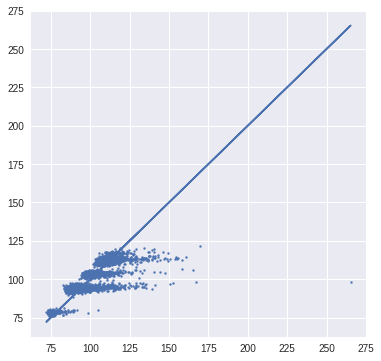

In [52]:
plt.figure(figsize=(6,6))
plt.scatter(train['y'], trn_y_pred, s=4)
plt.plot(train['y'], train['y'])

As we can see the data can be separated into 4 clusters. Also we can see presence of few outliers which might be influencing our model. So let's first mark outliers and then train our model without them. 



In [0]:
def is_outlier(points, threshold=3.5):
  median = np.median(points)
  print (median)
  diff = np.sqrt((points-median)**2)
  print (type(diff))
#   diff = np.sqrt(diff)
  mad = np.median(diff)
  
  modified_z_score = 0.6745 * diff/ mad
  return modified_z_score, (modified_z_score>threshold)
  

In [71]:
ol_score, ol = is_outlier(train['y'].values)

99.15
<type 'numpy.ndarray'>


In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [76]:
train_ol[train_ol.is_ol==True].shape

(22, 380)

So there are a total of 22 outliers. Let's plot them. 

In [0]:
plt.figure(figsize=(8,8))
plt.scatter(train_ol[train_ol.is_ol==True].index, train_ol[train_ol.is_ol==True]['y'], s=10, c='red')
plt.scatter(train_ol[train_ol.is_ol==False].index, train_ol[train_ol.is_ol==False]['y'], s=4)

The points marked in red are classified as outliers. In the next model we will remove these outliers and then train our model. 

In [92]:
# Here we generate mean encoded train and validation sets excluding outliers from train. 
trns, vals = me_df(train[train_ol.is_ol==False], 5, 10)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  dtrn, dval = get_trn_val(trn, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [103]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()


(0.6352510399999999, 0.6561283, 176.42)

Our validation scores has certainly improved after removing outliers. Lets check on leaderboard. 

#### Submission

In [108]:
me_cols = cat_feat
train_new = train[train_ol.is_ol==False]
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 180)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm27.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB :0.55131   Public LB :0.55405 So as we see out privateLB score improved significantly. 

Another way to resolve this outlier problem is to normalise each data point by its L2 norm so that all the points lie on a multidimensional sphere and thus theor distance from centre is constant. But it is important to first centre and scale our data before using this transformation. 

#### Spatial Sign transformation

In [0]:
trns, vals = me_df(train, 5, 10)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97
}

In [0]:
def cs_sst(trn, val):
  sca = StandardScaler()

  trn_cs = sca.fit_transform(trn.drop(['y'], axis=1))
  val_cs = sca.transform(val.drop(['y'], axis=1))
  
  
#   Spatial sign transformation : here we divide each feature of each point by its L2 norm. 

  trn_norm = np.sum(trn_cs**2, axis=1)
  val_norm = np.sum(val_cs**2, axis=1)
  
  trn_sst = trn_cs/trn_norm[:,None]
  val_sst = val_cs/val_norm[:,None]
  
  trn_sst = pd.DataFrame(trn_sst, index=trn.index, columns=trn.drop(['y'], axis=1).columns)
  val_sst = pd.DataFrame(val_sst, index=val.index, columns=val.drop(['y'], axis=1).columns)
  
  
  trn_sst['y'] = trn['y']
  val_sst['y'] = val['y']
  
  return trn_sst, val_sst

In [0]:
s_time = time.time()
trn_scores=[]
val_scores=[]
best_iterations=[]
drop_list = list(set(cat_feat+dup_feat+low_var_feat))
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  
  trn_sst, val_sst = cs_sst(trn.drop(drop_list, axis=1), val.drop(drop_list, axis=1))
  dtrn, dval = get_trn_val(trn_sst, val_sst, drop_feat=['y'])
  
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [52]:
np.array(val_scores).mean(), np.array(trn_scores).mean()
np.array(best_iterations).mean()

(0.56838534, 0.5973862799999999)

143.3

The validation score has gone worse but still let's submit. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(cat_feat + dup_feat + low_var_feat))

sca = StandardScaler()
X_trn_cs = sca.fit_transform(train_new1.drop(feat_to_drop+['y'], axis=1))
test_cs = sca.transform(test_new.drop(feat_to_drop, axis=1))

trn_norm = np.sum(X_trn_cs**2, axis=1)
test_norm = np.sum(test_cs**2, axis=1)

X_trn_sst = X_trn_cs/trn_norm[:,None]
X_test_sst = test_cs/test_norm[:,None]

y_trn = train_new1['y']

dtrn = xgb.DMatrix(X_trn_sst, label=y_trn)
dtest = xgb.DMatrix(X_test_sst)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 150)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm28.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB :0.    PublicLB :0. 